# KE5105 - Building Electrical Consumption Forecasting

# Modelling 2 - Preliminary model

## Load libraries

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import os
import pickle
import pandas as pd
import numpy as np
import datetime
import myUtilities as mu

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

Using TensorFlow backend.


## Load data for building AS5

In [2]:
as5 = mu.load_data_by_bldg(['AS5'], 'processed')

In [3]:
as5[0][1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62880 entries, 2015-06-01 00:00:00 to 2018-12-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         46164 non-null float64
PWMEXTAS4ExBldg                   46165 non-null float64
PWMAS4LanguageCenter              46165 non-null float64
PWMCANTEEN                        46164 non-null float64
PWMStreetLight                    46164 non-null float64
BTUAS5                            46175 non-null float64
PWMMainIC_30min_avg               46117 non-null float64
PWMEXTAS4ExBldg_30min_avg         46118 non-null float64
PWMAS4LanguageCenter_30min_avg    46118 non-null float64
PWMCANTEEN_30min_avg              46117 non-null float64
PWMStreetLight_30min_avg          46117 non-null float64
BTUAS5_30min_avg                  46129 non-null float64
PWM_sumadd                        46117 non-null float64
PWM_sumsubtract                   46117 non-null float64
PWM_30min_avg                     46117 non-null float64
B

## Split the data into train and test set

In [3]:
as5_train_df = as5[0][1].loc['2015-06-12 08:00:00':'2017-03-31 23:30:00', :]

In [4]:
as5_train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31616 entries, 2015-06-12 08:00:00 to 2017-03-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         30018 non-null float64
PWMEXTAS4ExBldg                   30018 non-null float64
PWMAS4LanguageCenter              30018 non-null float64
PWMCANTEEN                        30018 non-null float64
PWMStreetLight                    30018 non-null float64
BTUAS5                            30029 non-null float64
PWMMainIC_30min_avg               29985 non-null float64
PWMEXTAS4ExBldg_30min_avg         29985 non-null float64
PWMAS4LanguageCenter_30min_avg    29985 non-null float64
PWMCANTEEN_30min_avg              29985 non-null float64
PWMStreetLight_30min_avg          29985 non-null float64
BTUAS5_30min_avg                  29998 non-null float64
PWM_sumadd                        29985 non-null float64
PWM_sumsubtract                   29985 non-null float64
PWM_30min_avg                     29985 non-null float64
B

In [5]:
as5_test_df = as5[0][1].loc['2018-01-01 00:00:00':, :]

In [10]:
as5_test_df.index.max()

Timestamp('2018-12-31 23:30:00')

In [11]:
as5_test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17520 entries, 2018-01-01 00:00:00 to 2018-12-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         16145 non-null float64
PWMEXTAS4ExBldg                   16145 non-null float64
PWMAS4LanguageCenter              16145 non-null float64
PWMCANTEEN                        16145 non-null float64
PWMStreetLight                    16145 non-null float64
BTUAS5                            16144 non-null float64
PWMMainIC_30min_avg               16132 non-null float64
PWMEXTAS4ExBldg_30min_avg         16132 non-null float64
PWMAS4LanguageCenter_30min_avg    16132 non-null float64
PWMCANTEEN_30min_avg              16132 non-null float64
PWMStreetLight_30min_avg          16132 non-null float64
BTUAS5_30min_avg                  16130 non-null float64
PWM_sumadd                        16132 non-null float64
PWM_sumsubtract                   16132 non-null float64
PWM_30min_avg                     16132 non-null float64
B

## Parameters for the RNN model

Also used for generating the datasets with the lagged values 

In [6]:
lookback = 240  # 5 days; each day has 48 observations
step = 1  # sampling rate used for the lookback period
delay = 0  # 1 step ahead prediction
batch_size = 128

## Calculate the MAE for a Simple Last Observation Carry Forward (LOCF) Model

In [10]:
len(as5_train_df)

31616

In [11]:
# Generators for the train and test sets.
gen_locf_train = mu.generator(as5_train_df['PWM_30min_avg'].values.reshape((-1, 1)),
                              lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_df)-1,
                              batch_size=batch_size, step=step)

In [12]:
train_steps = int(np.ceil((len(as5_train_df) - lookback - delay) / batch_size))
train_steps

246

In [13]:
# Calculate a simple baseline for model accuracy using MAE. Baseline model predicts label at t as label at t-1
# (LOCF last observation carry forward)
batch_maes = []
locf_preds = []

for a_step in range(train_steps):
    samples, targets = next(gen_locf_train)
    a_pred = samples[:, -1, 0]
    locf_preds.append(a_pred)
    mae = np.nanmean(np.abs(a_pred - targets))
    batch_maes.append(mae)
print('MAE = %f' % (np.nanmean(batch_maes)))


/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


MAE = 2.144081


In [14]:
locf_preds = np.concatenate(locf_preds)

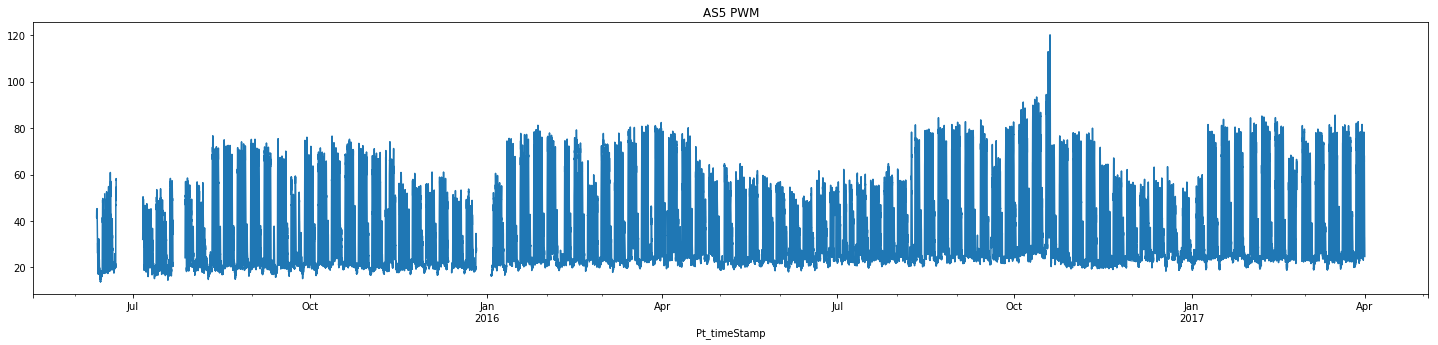

In [16]:
as5_train_df['PWM_30min_avg'].plot(figsize=(25, 5), title='AS5 PWM')

## Normalise the training data

* Convert PWM and BTU values into the range 0 to 1
* Replace NaN with -1

In [7]:
# Create a transformation pipleline to prepare the training dataset for RNN.
attrbs = ['PWM_30min_avg', 'BTU_30min_avg']
my_pipeline = Pipeline([
    ('selector', mu.DataFrameSelector(attrbs)),
    ('minmax_scaler', MinMaxScaler()),
    ('na_transform', mu.Nan_to_Num_Transformer())
])

In [8]:
as5_train_data = my_pipeline.fit_transform(as5_train_df)
as5_train_data

array([[ 0.26254935,  0.56924225],
       [ 0.26724948,  0.53427896],
       [ 0.28031585,  0.53353241],
       ...,
       [ 0.12897161,  0.03222595],
       [ 0.10312089,  0.00348389],
       [-1.        , -1.        ]])

Text(0.5, 1.0, 'Normalised PWM Training Data')

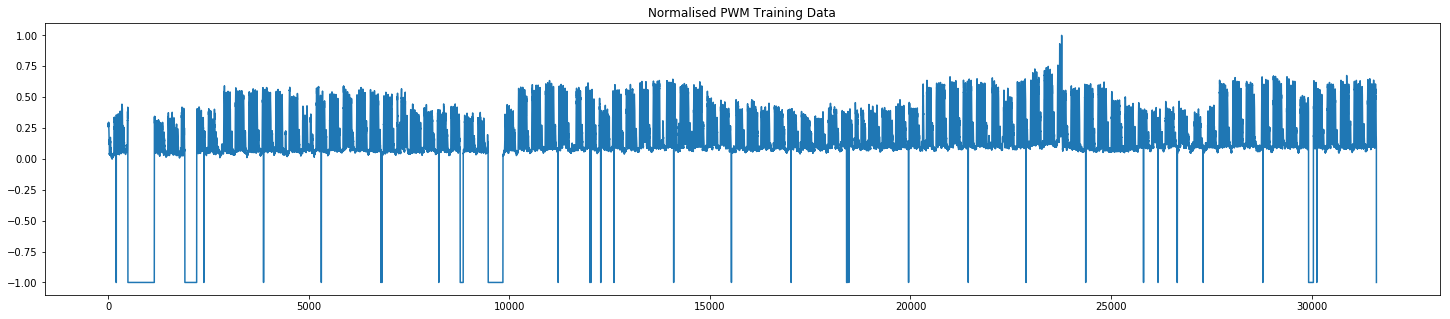

In [19]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0])
plt.title('Normalised PWM Training Data')

Text(0.5, 1.0, 'Normalised BTU Training Data')

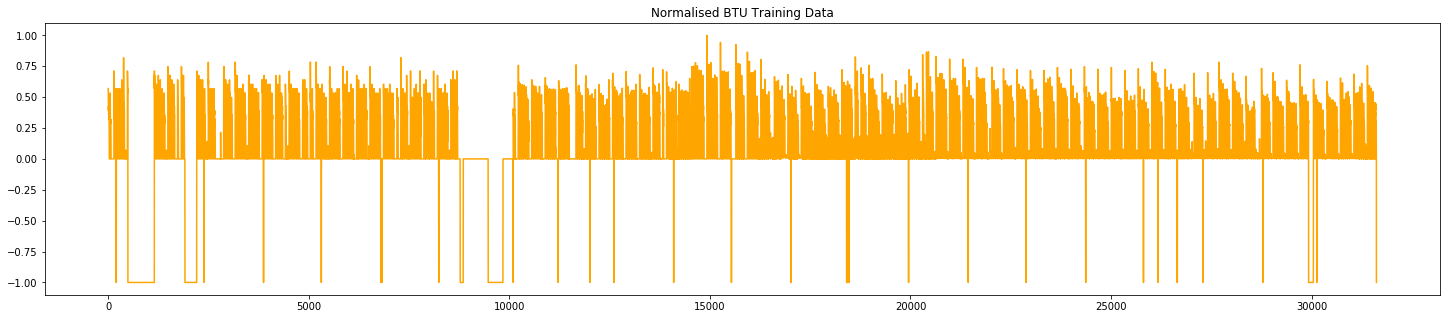

In [20]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 1], color='orange')
plt.title('Normalised BTU Training Data')

## Base RNN Model

Quick model training without validation

In [21]:
as5_train_data.shape

(31616, 2)

In [22]:
model = Sequential()
model.add(layers.GRU(16, input_shape=(None, as5_train_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [39]:
gen_train = mu.generator(as5_train_split,
                         lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                         batch_size=batch_size, step=step)
t1 = datetime.datetime.now()
history = model.fit_generator(gen_train, steps_per_epoch=train_steps, epochs=20,
                              workers=0, use_multiprocessing=False)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/20


  1/246 [..............................] - ETA: 3:06 - loss: 0.1324 - mean_absolute_percentage_error: 63.6485

  2/246 [..............................] - ETA: 2:06 - loss: 0.1133 - mean_absolute_percentage_error: 58.6426

  3/246 [..............................] - ETA: 1:44 - loss: 0.2735 - mean_absolute_percentage_error: 58.8871

  4/246 [..............................] - ETA: 1:32 - loss: 0.3385 - mean_absolute_percentage_error: 57.5005

  5/246 [..............................] - ETA: 1:27 - loss: 0.3678 - mean_absolute_percentage_error: 55.7056

  6/246 [..............................] - ETA: 1:21 - loss: 0.3802 - mean_absolute_percentage_error: 53.7940

  7/246 [..............................] - ETA: 1:18 - loss: 0.3834 - mean_absolute_percentage_error: 51.8577

  8/246 [..............................] - ETA: 1:15 - loss: 0.3486 - mean_absolute_percentage_error: 51.6116

  9/246 [>.............................] - ETA: 1:13 - loss: 0.3150 - mean_absolute_percentage_error: 51.0812

 10/246 [>.............................] - ETA: 1:11 - loss: 0.2875 - mean_absolute_percentage_error: 51.5876

 11/246 [>.............................] - ETA: 1:09 - loss: 0.2660 - mean_absolute_percentage_error: 50.4053

 12/246 [>.............................] - ETA: 1:08 - loss: 0.2498 - mean_absolute_percentage_error: 51.1174

 13/246 [>.............................] - ETA: 1:07 - loss: 0.2340 - mean_absolute_percentage_error: 49.8035

 14/246 [>.............................] - ETA: 1:06 - loss: 0.2439 - mean_absolute_percentage_error: 49.0115

 15/246 [>.............................] - ETA: 1:05 - loss: 0.2493 - mean_absolute_percentage_error: 47.9089

 16/246 [>.............................] - ETA: 1:04 - loss: 0.2432 - mean_absolute_percentage_error: 47.3204

 17/246 [=>............................] - ETA: 1:03 - loss: 0.2329 - mean_absolute_percentage_error: 47.5493

 18/246 [=>............................] - ETA: 1:02 - loss: 0.2225 - mean_absolute_percentage_error: 47.3896

 19/246 [=>............................] - ETA: 1:02 - loss: 0.2132 - mean_absolute_percentage_error: 46.4466

 20/246 [=>............................] - ETA: 1:01 - loss: 0.2044 - mean_absolute_percentage_error: 46.0911

 21/246 [=>............................] - ETA: 1:00 - loss: 0.1965 - mean_absolute_percentage_error: 45.3716

 22/246 [=>............................] - ETA: 1:00 - loss: 0.1907 - mean_absolute_percentage_error: 44.9307

 23/246 [=>............................] - ETA: 59s - loss: 0.1837 - mean_absolute_percentage_error: 44.1729 

 24/246 [=>............................] - ETA: 59s - loss: 0.1788 - mean_absolute_percentage_error: 43.7523

 25/246 [==>...........................] - ETA: 58s - loss: 0.1741 - mean_absolute_percentage_error: 43.3475

 26/246 [==>...........................] - ETA: 58s - loss: 0.1687 - mean_absolute_percentage_error: 42.9407

 27/246 [==>...........................] - ETA: 57s - loss: 0.1648 - mean_absolute_percentage_error: 42.6289

 28/246 [==>...........................] - ETA: 57s - loss: 0.1605 - mean_absolute_percentage_error: 42.3487

 29/246 [==>...........................] - ETA: 56s - loss: 0.1579 - mean_absolute_percentage_error: 42.5658

 30/246 [==>...........................] - ETA: 56s - loss: 0.1546 - mean_absolute_percentage_error: 42.2198

 31/246 [==>...........................] - ETA: 56s - loss: 0.1510 - mean_absolute_percentage_error: 41.9718

 32/246 [==>...........................] - ETA: 55s - loss: 0.1480 - mean_absolute_percentage_error: 41.6092

 33/246 [===>..........................] - ETA: 55s - loss: 0.1450 - mean_absolute_percentage_error: 41.9344

 34/246 [===>..........................] - ETA: 54s - loss: 0.1420 - mean_absolute_percentage_error: 41.5421

 35/246 [===>..........................] - ETA: 54s - loss: 0.1394 - mean_absolute_percentage_error: 41.0905

 36/246 [===>..........................] - ETA: 54s - loss: 0.1366 - mean_absolute_percentage_error: 40.9380

 37/246 [===>..........................] - ETA: 53s - loss: 0.1345 - mean_absolute_percentage_error: 40.6549

 38/246 [===>..........................] - ETA: 53s - loss: 0.1322 - mean_absolute_percentage_error: 40.5260

 39/246 [===>..........................] - ETA: 53s - loss: 0.1297 - mean_absolute_percentage_error: 40.2989

 40/246 [===>..........................] - ETA: 52s - loss: 0.1287 - mean_absolute_percentage_error: 40.5143

 41/246 [====>.........................] - ETA: 52s - loss: 0.1265 - mean_absolute_percentage_error: 40.3239

 42/246 [====>.........................] - ETA: 52s - loss: 0.1245 - mean_absolute_percentage_error: 39.9599

 43/246 [====>.........................] - ETA: 51s - loss: 0.1229 - mean_absolute_percentage_error: 39.6869

 44/246 [====>.........................] - ETA: 51s - loss: 0.1207 - mean_absolute_percentage_error: 39.2006

 45/246 [====>.........................] - ETA: 51s - loss: 0.1193 - mean_absolute_percentage_error: 38.9471

 46/246 [====>.........................] - ETA: 50s - loss: 0.1177 - mean_absolute_percentage_error: 38.6359

 47/246 [====>.........................] - ETA: 50s - loss: 0.1159 - mean_absolute_percentage_error: 38.1933

 48/246 [====>.........................] - ETA: 50s - loss: 0.1146 - mean_absolute_percentage_error: 38.0997

 49/246 [====>.........................] - ETA: 50s - loss: 0.1131 - mean_absolute_percentage_error: 38.0529

 50/246 [=====>........................] - ETA: 49s - loss: 0.1119 - mean_absolute_percentage_error: 37.8255

 51/246 [=====>........................] - ETA: 49s - loss: 0.1107 - mean_absolute_percentage_error: 37.7037

 52/246 [=====>........................] - ETA: 49s - loss: 0.1103 - mean_absolute_percentage_error: 38.7533

 53/246 [=====>........................] - ETA: 48s - loss: 0.1092 - mean_absolute_percentage_error: 38.5237

 54/246 [=====>........................] - ETA: 48s - loss: 0.1081 - mean_absolute_percentage_error: 38.4040

 55/246 [=====>........................] - ETA: 48s - loss: 0.1071 - mean_absolute_percentage_error: 38.2875

 56/246 [=====>........................] - ETA: 47s - loss: 0.1060 - mean_absolute_percentage_error: 37.9983

 57/246 [=====>........................] - ETA: 47s - loss: 0.1047 - mean_absolute_percentage_error: 37.8209

 58/246 [======>.......................] - ETA: 47s - loss: 0.1036 - mean_absolute_percentage_error: 37.6333

 59/246 [======>.......................] - ETA: 47s - loss: 0.1024 - mean_absolute_percentage_error: 37.3546

 60/246 [======>.......................] - ETA: 46s - loss: 0.1011 - mean_absolute_percentage_error: 37.1156

 61/246 [======>.......................] - ETA: 46s - loss: 0.1001 - mean_absolute_percentage_error: 36.8602

 62/246 [======>.......................] - ETA: 46s - loss: 0.0990 - mean_absolute_percentage_error: 36.6943

 63/246 [======>.......................] - ETA: 45s - loss: 0.0983 - mean_absolute_percentage_error: 36.6694

 64/246 [======>.......................] - ETA: 45s - loss: 0.0974 - mean_absolute_percentage_error: 36.4635

 65/246 [======>.......................] - ETA: 45s - loss: 0.0963 - mean_absolute_percentage_error: 36.2750

 66/246 [=======>......................] - ETA: 45s - loss: 0.0954 - mean_absolute_percentage_error: 36.0641

 67/246 [=======>......................] - ETA: 44s - loss: 0.0962 - mean_absolute_percentage_error: 35.9523

 68/246 [=======>......................] - ETA: 44s - loss: 0.0967 - mean_absolute_percentage_error: 36.3955

 69/246 [=======>......................] - ETA: 44s - loss: 0.0962 - mean_absolute_percentage_error: 36.2779

 70/246 [=======>......................] - ETA: 44s - loss: 0.0954 - mean_absolute_percentage_error: 36.2044

 71/246 [=======>......................] - ETA: 43s - loss: 0.0951 - mean_absolute_percentage_error: 36.1698

 72/246 [=======>......................] - ETA: 43s - loss: 0.0943 - mean_absolute_percentage_error: 36.1572

 73/246 [=======>......................] - ETA: 43s - loss: 0.0953 - mean_absolute_percentage_error: 35.9211

 74/246 [========>.....................] - ETA: 42s - loss: 0.0952 - mean_absolute_percentage_error: 35.5561

 75/246 [========>.....................] - ETA: 42s - loss: 0.0943 - mean_absolute_percentage_error: 35.1144

 76/246 [========>.....................] - ETA: 42s - loss: 0.0941 - mean_absolute_percentage_error: 36.1425

 77/246 [========>.....................] - ETA: 42s - loss: 0.0940 - mean_absolute_percentage_error: 36.0755

 78/246 [========>.....................] - ETA: 41s - loss: 0.0935 - mean_absolute_percentage_error: 36.2293

 79/246 [========>.....................] - ETA: 41s - loss: 0.0934 - mean_absolute_percentage_error: 36.2938

 80/246 [========>.....................] - ETA: 41s - loss: 0.0931 - mean_absolute_percentage_error: 36.3043

 81/246 [========>.....................] - ETA: 41s - loss: 0.0924 - mean_absolute_percentage_error: 36.2034

 82/246 [=========>....................] - ETA: 40s - loss: 0.0920 - mean_absolute_percentage_error: 36.1379

 83/246 [=========>....................] - ETA: 40s - loss: 0.0914 - mean_absolute_percentage_error: 36.0503

 84/246 [=========>....................] - ETA: 40s - loss: 0.0908 - mean_absolute_percentage_error: 35.9511

 85/246 [=========>....................] - ETA: 40s - loss: 0.0904 - mean_absolute_percentage_error: 35.8695

 86/246 [=========>....................] - ETA: 39s - loss: 0.0901 - mean_absolute_percentage_error: 35.9736

 87/246 [=========>....................] - ETA: 39s - loss: 0.0897 - mean_absolute_percentage_error: 35.9052

 88/246 [=========>....................] - ETA: 39s - loss: 0.0894 - mean_absolute_percentage_error: 35.8835

 89/246 [=========>....................] - ETA: 38s - loss: 0.0886 - mean_absolute_percentage_error: 35.6843

 90/246 [=========>....................] - ETA: 38s - loss: 0.0881 - mean_absolute_percentage_error: 35.5674

 91/246 [==========>...................] - ETA: 38s - loss: 0.0875 - mean_absolute_percentage_error: 35.4347

 92/246 [==========>...................] - ETA: 38s - loss: 0.0877 - mean_absolute_percentage_error: 35.3661

 93/246 [==========>...................] - ETA: 37s - loss: 0.0875 - mean_absolute_percentage_error: 35.3614

 94/246 [==========>...................] - ETA: 37s - loss: 0.0868 - mean_absolute_percentage_error: 35.2052

 95/246 [==========>...................] - ETA: 37s - loss: 0.0869 - mean_absolute_percentage_error: 35.1747

 96/246 [==========>...................] - ETA: 37s - loss: 0.0865 - mean_absolute_percentage_error: 35.1258

 97/246 [==========>...................] - ETA: 36s - loss: 0.0863 - mean_absolute_percentage_error: 35.1516

 98/246 [==========>...................] - ETA: 36s - loss: 0.0859 - mean_absolute_percentage_error: 35.0209

 99/246 [===========>..................] - ETA: 36s - loss: 0.0854 - mean_absolute_percentage_error: 34.9449

100/246 [===========>..................] - ETA: 36s - loss: 0.0850 - mean_absolute_percentage_error: 34.8365

101/246 [===========>..................] - ETA: 35s - loss: 0.0847 - mean_absolute_percentage_error: 34.7443

102/246 [===========>..................] - ETA: 35s - loss: 0.0841 - mean_absolute_percentage_error: 34.5831

103/246 [===========>..................] - ETA: 35s - loss: 0.0839 - mean_absolute_percentage_error: 34.4668

104/246 [===========>..................] - ETA: 35s - loss: 0.0835 - mean_absolute_percentage_error: 34.3709

105/246 [===========>..................] - ETA: 34s - loss: 0.0831 - mean_absolute_percentage_error: 34.2436

106/246 [===========>..................] - ETA: 34s - loss: 0.0827 - mean_absolute_percentage_error: 34.1329

107/246 [============>.................] - ETA: 34s - loss: 0.0822 - mean_absolute_percentage_error: 33.9754

108/246 [============>.................] - ETA: 34s - loss: 0.0820 - mean_absolute_percentage_error: 33.9042

109/246 [============>.................] - ETA: 33s - loss: 0.0821 - mean_absolute_percentage_error: 33.9946

110/246 [============>.................] - ETA: 33s - loss: 0.0818 - mean_absolute_percentage_error: 33.9349

111/246 [============>.................] - ETA: 33s - loss: 0.0815 - mean_absolute_percentage_error: 33.8368

112/246 [============>.................] - ETA: 33s - loss: 0.0813 - mean_absolute_percentage_error: 33.8712

113/246 [============>.................] - ETA: 32s - loss: 0.0810 - mean_absolute_percentage_error: 33.7647

114/246 [============>.................] - ETA: 32s - loss: 0.0807 - mean_absolute_percentage_error: 33.6557

115/246 [=============>................] - ETA: 32s - loss: 0.0804 - mean_absolute_percentage_error: 33.5826

116/246 [=============>................] - ETA: 32s - loss: 0.0801 - mean_absolute_percentage_error: 33.4693

117/246 [=============>................] - ETA: 31s - loss: 0.0798 - mean_absolute_percentage_error: 33.3804

118/246 [=============>................] - ETA: 31s - loss: 0.0794 - mean_absolute_percentage_error: 33.2634

119/246 [=============>................] - ETA: 31s - loss: 0.0791 - mean_absolute_percentage_error: 33.1606

120/246 [=============>................] - ETA: 31s - loss: 0.0789 - mean_absolute_percentage_error: 33.2172

121/246 [=============>................] - ETA: 30s - loss: 0.0785 - mean_absolute_percentage_error: 33.1227

122/246 [=============>................] - ETA: 30s - loss: 0.0782 - mean_absolute_percentage_error: 33.0358

123/246 [==============>...............] - ETA: 30s - loss: 0.0778 - mean_absolute_percentage_error: 32.9251

124/246 [==============>...............] - ETA: 30s - loss: 0.0775 - mean_absolute_percentage_error: 32.8488

125/246 [==============>...............] - ETA: 30s - loss: 0.0771 - mean_absolute_percentage_error: 32.7436

126/246 [==============>...............] - ETA: 29s - loss: 0.0767 - mean_absolute_percentage_error: 32.6230

127/246 [==============>...............] - ETA: 29s - loss: 0.0764 - mean_absolute_percentage_error: 32.5120

128/246 [==============>...............] - ETA: 29s - loss: 0.0759 - mean_absolute_percentage_error: 32.3835

129/246 [==============>...............] - ETA: 29s - loss: 0.0756 - mean_absolute_percentage_error: 32.2780

130/246 [==============>...............] - ETA: 28s - loss: 0.0753 - mean_absolute_percentage_error: 32.1967

131/246 [==============>...............] - ETA: 28s - loss: 0.0749 - mean_absolute_percentage_error: 32.0626

132/246 [===============>..............] - ETA: 28s - loss: 0.0747 - mean_absolute_percentage_error: 32.0407

133/246 [===============>..............] - ETA: 28s - loss: 0.0744 - mean_absolute_percentage_error: 32.0321

134/246 [===============>..............] - ETA: 27s - loss: 0.0740 - mean_absolute_percentage_error: 31.8957

135/246 [===============>..............] - ETA: 27s - loss: 0.0736 - mean_absolute_percentage_error: 31.8012

136/246 [===============>..............] - ETA: 27s - loss: 0.0733 - mean_absolute_percentage_error: 31.7400

137/246 [===============>..............] - ETA: 27s - loss: 0.0730 - mean_absolute_percentage_error: 31.6231

138/246 [===============>..............] - ETA: 26s - loss: 0.0726 - mean_absolute_percentage_error: 31.5338

139/246 [===============>..............] - ETA: 26s - loss: 0.0723 - mean_absolute_percentage_error: 31.4178

140/246 [================>.............] - ETA: 26s - loss: 0.0720 - mean_absolute_percentage_error: 31.3013

141/246 [================>.............] - ETA: 26s - loss: 0.0717 - mean_absolute_percentage_error: 31.2811

142/246 [================>.............] - ETA: 25s - loss: 0.0717 - mean_absolute_percentage_error: 31.1797

143/246 [================>.............] - ETA: 25s - loss: 0.0718 - mean_absolute_percentage_error: 31.2677

144/246 [================>.............] - ETA: 25s - loss: 0.0715 - mean_absolute_percentage_error: 31.1875

145/246 [================>.............] - ETA: 25s - loss: 0.0712 - mean_absolute_percentage_error: 31.0900

146/246 [================>.............] - ETA: 24s - loss: 0.0709 - mean_absolute_percentage_error: 30.9971

147/246 [================>.............] - ETA: 24s - loss: 0.0706 - mean_absolute_percentage_error: 30.9079

148/246 [=================>............] - ETA: 24s - loss: 0.0704 - mean_absolute_percentage_error: 30.8040

149/246 [=================>............] - ETA: 24s - loss: 0.0701 - mean_absolute_percentage_error: 30.7146

150/246 [=================>............] - ETA: 24s - loss: 0.0698 - mean_absolute_percentage_error: 30.6271

151/246 [=================>............] - ETA: 23s - loss: 0.0696 - mean_absolute_percentage_error: 30.5356

152/246 [=================>............] - ETA: 23s - loss: 0.0693 - mean_absolute_percentage_error: 30.4518

153/246 [=================>............] - ETA: 23s - loss: 0.0691 - mean_absolute_percentage_error: 30.3757

154/246 [=================>............] - ETA: 23s - loss: 0.0689 - mean_absolute_percentage_error: 30.3247

155/246 [=================>............] - ETA: 22s - loss: 0.0688 - mean_absolute_percentage_error: 30.3298

156/246 [==================>...........] - ETA: 22s - loss: 0.0686 - mean_absolute_percentage_error: 30.2698

157/246 [==================>...........] - ETA: 22s - loss: 0.0684 - mean_absolute_percentage_error: 30.2078

158/246 [==================>...........] - ETA: 22s - loss: 0.0683 - mean_absolute_percentage_error: 30.1437

159/246 [==================>...........] - ETA: 21s - loss: 0.0681 - mean_absolute_percentage_error: 30.1037

160/246 [==================>...........] - ETA: 21s - loss: 0.0679 - mean_absolute_percentage_error: 30.0246

161/246 [==================>...........] - ETA: 21s - loss: 0.0679 - mean_absolute_percentage_error: 29.9655

162/246 [==================>...........] - ETA: 21s - loss: 0.0677 - mean_absolute_percentage_error: 29.9373

163/246 [==================>...........] - ETA: 20s - loss: 0.0676 - mean_absolute_percentage_error: 29.8824

164/246 [===================>..........] - ETA: 20s - loss: 0.0675 - mean_absolute_percentage_error: 29.8373

165/246 [===================>..........] - ETA: 20s - loss: 0.0673 - mean_absolute_percentage_error: 29.7868

166/246 [===================>..........] - ETA: 20s - loss: 0.0674 - mean_absolute_percentage_error: 29.8163

167/246 [===================>..........] - ETA: 19s - loss: 0.0672 - mean_absolute_percentage_error: 29.7555

168/246 [===================>..........] - ETA: 19s - loss: 0.0671 - mean_absolute_percentage_error: 29.6877

169/246 [===================>..........] - ETA: 19s - loss: 0.0670 - mean_absolute_percentage_error: 29.6412

170/246 [===================>..........] - ETA: 19s - loss: 0.0667 - mean_absolute_percentage_error: 29.5797

171/246 [===================>..........] - ETA: 18s - loss: 0.0666 - mean_absolute_percentage_error: 29.5143

172/246 [===================>..........] - ETA: 18s - loss: 0.0665 - mean_absolute_percentage_error: 29.4657

173/246 [====================>.........] - ETA: 18s - loss: 0.0663 - mean_absolute_percentage_error: 29.3895

174/246 [====================>.........] - ETA: 18s - loss: 0.0661 - mean_absolute_percentage_error: 29.3471

175/246 [====================>.........] - ETA: 17s - loss: 0.0659 - mean_absolute_percentage_error: 29.2873

176/246 [====================>.........] - ETA: 17s - loss: 0.0659 - mean_absolute_percentage_error: 29.2404

177/246 [====================>.........] - ETA: 17s - loss: 0.0659 - mean_absolute_percentage_error: 29.2745

178/246 [====================>.........] - ETA: 17s - loss: 0.0657 - mean_absolute_percentage_error: 29.1925

179/246 [====================>.........] - ETA: 16s - loss: 0.0658 - mean_absolute_percentage_error: 29.1477

180/246 [====================>.........] - ETA: 16s - loss: 0.0656 - mean_absolute_percentage_error: 29.1031

181/246 [=====================>........] - ETA: 16s - loss: 0.0655 - mean_absolute_percentage_error: 29.0363

182/246 [=====================>........] - ETA: 16s - loss: 0.0654 - mean_absolute_percentage_error: 28.9707

183/246 [=====================>........] - ETA: 15s - loss: 0.0653 - mean_absolute_percentage_error: 28.9504

184/246 [=====================>........] - ETA: 15s - loss: 0.0654 - mean_absolute_percentage_error: 28.9308

185/246 [=====================>........] - ETA: 15s - loss: 0.0654 - mean_absolute_percentage_error: 28.9257

186/246 [=====================>........] - ETA: 15s - loss: 0.0652 - mean_absolute_percentage_error: 28.8626

187/246 [=====================>........] - ETA: 14s - loss: 0.0651 - mean_absolute_percentage_error: 28.8347

188/246 [=====================>........] - ETA: 14s - loss: 0.0649 - mean_absolute_percentage_error: 28.8258

189/246 [======================>.......] - ETA: 14s - loss: 0.0649 - mean_absolute_percentage_error: 28.8656

190/246 [======================>.......] - ETA: 14s - loss: 0.0648 - mean_absolute_percentage_error: 28.8426

191/246 [======================>.......] - ETA: 13s - loss: 0.0646 - mean_absolute_percentage_error: 28.8112

192/246 [======================>.......] - ETA: 13s - loss: 0.0645 - mean_absolute_percentage_error: 28.7838

193/246 [======================>.......] - ETA: 13s - loss: 0.0644 - mean_absolute_percentage_error: 28.7600

194/246 [======================>.......] - ETA: 13s - loss: 0.0642 - mean_absolute_percentage_error: 28.6948

195/246 [======================>.......] - ETA: 12s - loss: 0.0641 - mean_absolute_percentage_error: 28.6716

196/246 [======================>.......] - ETA: 12s - loss: 0.0639 - mean_absolute_percentage_error: 28.6299

197/246 [=======================>......] - ETA: 12s - loss: 0.0638 - mean_absolute_percentage_error: 28.5838

198/246 [=======================>......] - ETA: 12s - loss: 0.0636 - mean_absolute_percentage_error: 28.5465

199/246 [=======================>......] - ETA: 11s - loss: 0.0634 - mean_absolute_percentage_error: 28.4965

200/246 [=======================>......] - ETA: 11s - loss: 0.0634 - mean_absolute_percentage_error: 28.5078

201/246 [=======================>......] - ETA: 11s - loss: 0.0633 - mean_absolute_percentage_error: 28.4692

202/246 [=======================>......] - ETA: 11s - loss: 0.0631 - mean_absolute_percentage_error: 28.4185

203/246 [=======================>......] - ETA: 10s - loss: 0.0632 - mean_absolute_percentage_error: 28.4176

204/246 [=======================>......] - ETA: 10s - loss: 0.0630 - mean_absolute_percentage_error: 28.3721

205/246 [========================>.....] - ETA: 10s - loss: 0.0629 - mean_absolute_percentage_error: 28.3172

206/246 [========================>.....] - ETA: 10s - loss: 0.0627 - mean_absolute_percentage_error: 28.2579

207/246 [========================>.....] - ETA: 9s - loss: 0.0627 - mean_absolute_percentage_error: 28.3536 

208/246 [========================>.....] - ETA: 9s - loss: 0.0626 - mean_absolute_percentage_error: 28.2927

209/246 [========================>.....] - ETA: 9s - loss: 0.0624 - mean_absolute_percentage_error: 28.2565

210/246 [========================>.....] - ETA: 9s - loss: 0.0622 - mean_absolute_percentage_error: 28.1943

211/246 [========================>.....] - ETA: 8s - loss: 0.0620 - mean_absolute_percentage_error: 28.1335

212/246 [========================>.....] - ETA: 8s - loss: 0.0619 - mean_absolute_percentage_error: 28.1683

213/246 [========================>.....] - ETA: 8s - loss: 0.0618 - mean_absolute_percentage_error: 28.1111

214/246 [=========================>....] - ETA: 8s - loss: 0.0617 - mean_absolute_percentage_error: 28.0580

215/246 [=========================>....] - ETA: 7s - loss: 0.0616 - mean_absolute_percentage_error: 28.0162

216/246 [=========================>....] - ETA: 7s - loss: 0.0615 - mean_absolute_percentage_error: 27.9714

217/246 [=========================>....] - ETA: 7s - loss: 0.0614 - mean_absolute_percentage_error: 27.9664

218/246 [=========================>....] - ETA: 6s - loss: 0.0614 - mean_absolute_percentage_error: 27.9162

219/246 [=========================>....] - ETA: 6s - loss: 0.0613 - mean_absolute_percentage_error: 27.8640

220/246 [=========================>....] - ETA: 6s - loss: 0.0612 - mean_absolute_percentage_error: 27.8296

221/246 [=========================>....] - ETA: 6s - loss: 0.0611 - mean_absolute_percentage_error: 27.7795

222/246 [==========================>...] - ETA: 5s - loss: 0.0610 - mean_absolute_percentage_error: 27.7481

223/246 [==========================>...] - ETA: 5s - loss: 0.0609 - mean_absolute_percentage_error: 27.7035

224/246 [==========================>...] - ETA: 5s - loss: 0.0609 - mean_absolute_percentage_error: 27.7144

225/246 [==========================>...] - ETA: 5s - loss: 0.0608 - mean_absolute_percentage_error: 27.7011

226/246 [==========================>...] - ETA: 4s - loss: 0.0608 - mean_absolute_percentage_error: 27.6584

227/246 [==========================>...] - ETA: 4s - loss: 0.0607 - mean_absolute_percentage_error: 27.6067

228/246 [==========================>...] - ETA: 4s - loss: 0.0605 - mean_absolute_percentage_error: 27.5487

229/246 [==========================>...] - ETA: 4s - loss: 0.0605 - mean_absolute_percentage_error: 27.5068

230/246 [===========================>..] - ETA: 3s - loss: 0.0604 - mean_absolute_percentage_error: 27.4912

231/246 [===========================>..] - ETA: 3s - loss: 0.0602 - mean_absolute_percentage_error: 27.4448

232/246 [===========================>..] - ETA: 3s - loss: 0.0602 - mean_absolute_percentage_error: 27.3950

233/246 [===========================>..] - ETA: 3s - loss: 0.0604 - mean_absolute_percentage_error: 27.3818

234/246 [===========================>..] - ETA: 2s - loss: 0.0605 - mean_absolute_percentage_error: 27.4130

235/246 [===========================>..] - ETA: 2s - loss: 0.0604 - mean_absolute_percentage_error: 27.3707

236/246 [===========================>..] - ETA: 2s - loss: 0.0602 - mean_absolute_percentage_error: 27.3131

237/246 [===========================>..] - ETA: 2s - loss: 0.0601 - mean_absolute_percentage_error: 27.2679

238/246 [============================>.] - ETA: 1s - loss: 0.0600 - mean_absolute_percentage_error: 27.2353

239/246 [============================>.] - ETA: 1s - loss: 0.0599 - mean_absolute_percentage_error: 27.1858

240/246 [============================>.] - ETA: 1s - loss: 0.0598 - mean_absolute_percentage_error: 27.1479

241/246 [============================>.] - ETA: 1s - loss: 0.0597 - mean_absolute_percentage_error: 27.1106

242/246 [============================>.] - ETA: 0s - loss: 0.0596 - mean_absolute_percentage_error: 27.0631

243/246 [============================>.] - ETA: 0s - loss: 0.0595 - mean_absolute_percentage_error: 27.0423

244/246 [============================>.] - ETA: 0s - loss: 0.0594 - mean_absolute_percentage_error: 27.0026

245/246 [============================>.] - ETA: 0s - loss: 0.0593 - mean_absolute_percentage_error: 26.9580

246/246 [==============================] - 61s 249ms/step - loss: 0.0597 - mean_absolute_percentage_error: 27.0094


Epoch 2/20


  1/246 [..............................] - ETA: 1:01 - loss: 0.0413 - mean_absolute_percentage_error: 21.6539

  2/246 [..............................] - ETA: 59s - loss: 0.0482 - mean_absolute_percentage_error: 24.8297 

  3/246 [..............................] - ETA: 59s - loss: 0.0605 - mean_absolute_percentage_error: 19.3905

  4/246 [..............................] - ETA: 59s - loss: 0.0480 - mean_absolute_percentage_error: 14.8118

  5/246 [..............................] - ETA: 58s - loss: 0.0486 - mean_absolute_percentage_error: 12.8634

  6/246 [..............................] - ETA: 58s - loss: 0.0410 - mean_absolute_percentage_error: 10.7702

  7/246 [..............................] - ETA: 58s - loss: 0.0414 - mean_absolute_percentage_error: 9.8598 

  8/246 [..............................] - ETA: 57s - loss: 0.0459 - mean_absolute_percentage_error: 13.5592

  9/246 [>.............................] - ETA: 57s - loss: 0.0462 - mean_absolute_percentage_error: 15.5218

 10/246 [>.............................] - ETA: 57s - loss: 0.0459 - mean_absolute_percentage_error: 17.5531

 11/246 [>.............................] - ETA: 57s - loss: 0.0463 - mean_absolute_percentage_error: 18.4561

 12/246 [>.............................] - ETA: 57s - loss: 0.0471 - mean_absolute_percentage_error: 20.7661

 13/246 [>.............................] - ETA: 56s - loss: 0.0464 - mean_absolute_percentage_error: 21.1301

 14/246 [>.............................] - ETA: 56s - loss: 0.0468 - mean_absolute_percentage_error: 20.0644

 15/246 [>.............................] - ETA: 56s - loss: 0.0448 - mean_absolute_percentage_error: 18.8363

 16/246 [>.............................] - ETA: 56s - loss: 0.0452 - mean_absolute_percentage_error: 19.3113

 17/246 [=>............................] - ETA: 55s - loss: 0.0464 - mean_absolute_percentage_error: 20.9624

 18/246 [=>............................] - ETA: 55s - loss: 0.0454 - mean_absolute_percentage_error: 21.3053

 19/246 [=>............................] - ETA: 55s - loss: 0.0449 - mean_absolute_percentage_error: 21.3549

 20/246 [=>............................] - ETA: 55s - loss: 0.0437 - mean_absolute_percentage_error: 21.5756

 21/246 [=>............................] - ETA: 54s - loss: 0.0428 - mean_absolute_percentage_error: 21.5185

 22/246 [=>............................] - ETA: 54s - loss: 0.0429 - mean_absolute_percentage_error: 21.5663

 23/246 [=>............................] - ETA: 54s - loss: 0.0421 - mean_absolute_percentage_error: 21.6103

 24/246 [=>............................] - ETA: 54s - loss: 0.0421 - mean_absolute_percentage_error: 21.6402

 25/246 [==>...........................] - ETA: 53s - loss: 0.0421 - mean_absolute_percentage_error: 21.7654

 26/246 [==>...........................] - ETA: 53s - loss: 0.0414 - mean_absolute_percentage_error: 21.8045

 27/246 [==>...........................] - ETA: 53s - loss: 0.0413 - mean_absolute_percentage_error: 21.7950

 28/246 [==>...........................] - ETA: 52s - loss: 0.0410 - mean_absolute_percentage_error: 21.9420

 29/246 [==>...........................] - ETA: 52s - loss: 0.0418 - mean_absolute_percentage_error: 22.6438

 30/246 [==>...........................] - ETA: 52s - loss: 0.0416 - mean_absolute_percentage_error: 22.5326

 31/246 [==>...........................] - ETA: 52s - loss: 0.0413 - mean_absolute_percentage_error: 22.6112

 32/246 [==>...........................] - ETA: 52s - loss: 0.0412 - mean_absolute_percentage_error: 22.5112

 33/246 [===>..........................] - ETA: 51s - loss: 0.0409 - mean_absolute_percentage_error: 22.8415

 34/246 [===>..........................] - ETA: 51s - loss: 0.0406 - mean_absolute_percentage_error: 22.7051

 35/246 [===>..........................] - ETA: 51s - loss: 0.0403 - mean_absolute_percentage_error: 22.5389

 36/246 [===>..........................] - ETA: 51s - loss: 0.0400 - mean_absolute_percentage_error: 22.6562

 37/246 [===>..........................] - ETA: 50s - loss: 0.0401 - mean_absolute_percentage_error: 22.5971

 38/246 [===>..........................] - ETA: 50s - loss: 0.0399 - mean_absolute_percentage_error: 22.6553

 39/246 [===>..........................] - ETA: 50s - loss: 0.0395 - mean_absolute_percentage_error: 22.6491

 40/246 [===>..........................] - ETA: 50s - loss: 0.0401 - mean_absolute_percentage_error: 23.0426

 41/246 [====>.........................] - ETA: 49s - loss: 0.0398 - mean_absolute_percentage_error: 23.0570

 42/246 [====>.........................] - ETA: 49s - loss: 0.0396 - mean_absolute_percentage_error: 22.9160

 43/246 [====>.........................] - ETA: 49s - loss: 0.0395 - mean_absolute_percentage_error: 22.7691

 44/246 [====>.........................] - ETA: 49s - loss: 0.0391 - mean_absolute_percentage_error: 22.6216

 45/246 [====>.........................] - ETA: 48s - loss: 0.0391 - mean_absolute_percentage_error: 22.5204

 46/246 [====>.........................] - ETA: 48s - loss: 0.0389 - mean_absolute_percentage_error: 22.3871

 47/246 [====>.........................] - ETA: 48s - loss: 0.0385 - mean_absolute_percentage_error: 22.1761

 48/246 [====>.........................] - ETA: 48s - loss: 0.0385 - mean_absolute_percentage_error: 22.1066

 49/246 [====>.........................] - ETA: 47s - loss: 0.0383 - mean_absolute_percentage_error: 22.1942

 50/246 [=====>........................] - ETA: 47s - loss: 0.0383 - mean_absolute_percentage_error: 22.0965

 51/246 [=====>........................] - ETA: 47s - loss: 0.0382 - mean_absolute_percentage_error: 22.0207

 52/246 [=====>........................] - ETA: 47s - loss: 0.0390 - mean_absolute_percentage_error: 23.3398

 53/246 [=====>........................] - ETA: 46s - loss: 0.0389 - mean_absolute_percentage_error: 23.2321

 54/246 [=====>........................] - ETA: 46s - loss: 0.0388 - mean_absolute_percentage_error: 23.2007

 55/246 [=====>........................] - ETA: 46s - loss: 0.0388 - mean_absolute_percentage_error: 23.2135

 56/246 [=====>........................] - ETA: 46s - loss: 0.0386 - mean_absolute_percentage_error: 23.0590

 57/246 [=====>........................] - ETA: 46s - loss: 0.0384 - mean_absolute_percentage_error: 23.0298

 58/246 [======>.......................] - ETA: 45s - loss: 0.0383 - mean_absolute_percentage_error: 22.9268

 59/246 [======>.......................] - ETA: 45s - loss: 0.0380 - mean_absolute_percentage_error: 22.8049

 60/246 [======>.......................] - ETA: 45s - loss: 0.0377 - mean_absolute_percentage_error: 22.6828

 61/246 [======>.......................] - ETA: 45s - loss: 0.0375 - mean_absolute_percentage_error: 22.5596

 62/246 [======>.......................] - ETA: 44s - loss: 0.0373 - mean_absolute_percentage_error: 22.5093

 63/246 [======>.......................] - ETA: 44s - loss: 0.0375 - mean_absolute_percentage_error: 22.6429

 64/246 [======>.......................] - ETA: 44s - loss: 0.0373 - mean_absolute_percentage_error: 22.5324

 65/246 [======>.......................] - ETA: 44s - loss: 0.0371 - mean_absolute_percentage_error: 22.5128

 66/246 [=======>......................] - ETA: 44s - loss: 0.0370 - mean_absolute_percentage_error: 22.4385

 67/246 [=======>......................] - ETA: 44s - loss: 0.0377 - mean_absolute_percentage_error: 22.3782

 68/246 [=======>......................] - ETA: 43s - loss: 0.0381 - mean_absolute_percentage_error: 22.8855

 69/246 [=======>......................] - ETA: 43s - loss: 0.0381 - mean_absolute_percentage_error: 22.8229

 70/246 [=======>......................] - ETA: 43s - loss: 0.0379 - mean_absolute_percentage_error: 22.8027

 71/246 [=======>......................] - ETA: 43s - loss: 0.0380 - mean_absolute_percentage_error: 22.7775

 72/246 [=======>......................] - ETA: 43s - loss: 0.0377 - mean_absolute_percentage_error: 22.7991

 73/246 [=======>......................] - ETA: 42s - loss: 0.0376 - mean_absolute_percentage_error: 22.5384

 74/246 [========>.....................] - ETA: 42s - loss: 0.0380 - mean_absolute_percentage_error: 22.3322

 75/246 [========>.....................] - ETA: 42s - loss: 0.0376 - mean_absolute_percentage_error: 22.0398

 76/246 [========>.....................] - ETA: 42s - loss: 0.0378 - mean_absolute_percentage_error: 23.0087

 77/246 [========>.....................] - ETA: 41s - loss: 0.0379 - mean_absolute_percentage_error: 22.9598

 78/246 [========>.....................] - ETA: 41s - loss: 0.0379 - mean_absolute_percentage_error: 23.0934

 79/246 [========>.....................] - ETA: 41s - loss: 0.0381 - mean_absolute_percentage_error: 23.0791

 80/246 [========>.....................] - ETA: 41s - loss: 0.0381 - mean_absolute_percentage_error: 23.0675

 81/246 [========>.....................] - ETA: 40s - loss: 0.0379 - mean_absolute_percentage_error: 22.9852

 82/246 [=========>....................] - ETA: 40s - loss: 0.0379 - mean_absolute_percentage_error: 22.9153

 83/246 [=========>....................] - ETA: 40s - loss: 0.0378 - mean_absolute_percentage_error: 22.8585

 84/246 [=========>....................] - ETA: 40s - loss: 0.0377 - mean_absolute_percentage_error: 22.7766

 85/246 [=========>....................] - ETA: 39s - loss: 0.0377 - mean_absolute_percentage_error: 22.6998

 86/246 [=========>....................] - ETA: 39s - loss: 0.0378 - mean_absolute_percentage_error: 22.8324

 87/246 [=========>....................] - ETA: 39s - loss: 0.0378 - mean_absolute_percentage_error: 22.7648

 88/246 [=========>....................] - ETA: 39s - loss: 0.0378 - mean_absolute_percentage_error: 22.7345

 89/246 [=========>....................] - ETA: 38s - loss: 0.0374 - mean_absolute_percentage_error: 22.5851

 90/246 [=========>....................] - ETA: 38s - loss: 0.0373 - mean_absolute_percentage_error: 22.4956

 91/246 [==========>...................] - ETA: 38s - loss: 0.0372 - mean_absolute_percentage_error: 22.4196

 92/246 [==========>...................] - ETA: 38s - loss: 0.0376 - mean_absolute_percentage_error: 22.3971

 93/246 [==========>...................] - ETA: 37s - loss: 0.0378 - mean_absolute_percentage_error: 22.4549

 94/246 [==========>...................] - ETA: 37s - loss: 0.0376 - mean_absolute_percentage_error: 22.3811

 95/246 [==========>...................] - ETA: 37s - loss: 0.0380 - mean_absolute_percentage_error: 22.4363

 96/246 [==========>...................] - ETA: 37s - loss: 0.0379 - mean_absolute_percentage_error: 22.3853

 97/246 [==========>...................] - ETA: 36s - loss: 0.0380 - mean_absolute_percentage_error: 22.4456

 98/246 [==========>...................] - ETA: 36s - loss: 0.0380 - mean_absolute_percentage_error: 22.3527

 99/246 [===========>..................] - ETA: 36s - loss: 0.0379 - mean_absolute_percentage_error: 22.3524

100/246 [===========>..................] - ETA: 36s - loss: 0.0378 - mean_absolute_percentage_error: 22.2839

101/246 [===========>..................] - ETA: 35s - loss: 0.0378 - mean_absolute_percentage_error: 22.2222

102/246 [===========>..................] - ETA: 35s - loss: 0.0376 - mean_absolute_percentage_error: 22.1317

103/246 [===========>..................] - ETA: 35s - loss: 0.0376 - mean_absolute_percentage_error: 22.0508

104/246 [===========>..................] - ETA: 35s - loss: 0.0375 - mean_absolute_percentage_error: 22.0230

105/246 [===========>..................] - ETA: 34s - loss: 0.0375 - mean_absolute_percentage_error: 21.9461

106/246 [===========>..................] - ETA: 34s - loss: 0.0374 - mean_absolute_percentage_error: 21.8629

107/246 [============>.................] - ETA: 34s - loss: 0.0373 - mean_absolute_percentage_error: 21.7923

108/246 [============>.................] - ETA: 34s - loss: 0.0373 - mean_absolute_percentage_error: 21.7329

109/246 [============>.................] - ETA: 33s - loss: 0.0375 - mean_absolute_percentage_error: 21.8346

110/246 [============>.................] - ETA: 33s - loss: 0.0375 - mean_absolute_percentage_error: 21.7868

111/246 [============>.................] - ETA: 33s - loss: 0.0375 - mean_absolute_percentage_error: 21.7170

112/246 [============>.................] - ETA: 33s - loss: 0.0375 - mean_absolute_percentage_error: 21.7292

113/246 [============>.................] - ETA: 32s - loss: 0.0375 - mean_absolute_percentage_error: 21.6731

114/246 [============>.................] - ETA: 32s - loss: 0.0374 - mean_absolute_percentage_error: 21.6052

115/246 [=============>................] - ETA: 32s - loss: 0.0374 - mean_absolute_percentage_error: 21.5707

116/246 [=============>................] - ETA: 32s - loss: 0.0373 - mean_absolute_percentage_error: 21.5073

117/246 [=============>................] - ETA: 31s - loss: 0.0373 - mean_absolute_percentage_error: 21.4469

118/246 [=============>................] - ETA: 31s - loss: 0.0371 - mean_absolute_percentage_error: 21.3679

119/246 [=============>................] - ETA: 31s - loss: 0.0371 - mean_absolute_percentage_error: 21.3046

120/246 [=============>................] - ETA: 31s - loss: 0.0371 - mean_absolute_percentage_error: 21.4532

121/246 [=============>................] - ETA: 30s - loss: 0.0371 - mean_absolute_percentage_error: 21.4051

122/246 [=============>................] - ETA: 30s - loss: 0.0370 - mean_absolute_percentage_error: 21.3520

123/246 [==============>...............] - ETA: 30s - loss: 0.0368 - mean_absolute_percentage_error: 21.2964

124/246 [==============>...............] - ETA: 29s - loss: 0.0368 - mean_absolute_percentage_error: 21.2449

125/246 [==============>...............] - ETA: 29s - loss: 0.0366 - mean_absolute_percentage_error: 21.2037

126/246 [==============>...............] - ETA: 29s - loss: 0.0365 - mean_absolute_percentage_error: 21.1451

127/246 [==============>...............] - ETA: 29s - loss: 0.0364 - mean_absolute_percentage_error: 21.0860

128/246 [==============>...............] - ETA: 29s - loss: 0.0363 - mean_absolute_percentage_error: 21.0473

129/246 [==============>...............] - ETA: 28s - loss: 0.0362 - mean_absolute_percentage_error: 21.0000

130/246 [==============>...............] - ETA: 28s - loss: 0.0361 - mean_absolute_percentage_error: 20.9584

131/246 [==============>...............] - ETA: 28s - loss: 0.0360 - mean_absolute_percentage_error: 20.8948

132/246 [===============>..............] - ETA: 28s - loss: 0.0361 - mean_absolute_percentage_error: 20.9485

133/246 [===============>..............] - ETA: 27s - loss: 0.0360 - mean_absolute_percentage_error: 20.9672

134/246 [===============>..............] - ETA: 27s - loss: 0.0359 - mean_absolute_percentage_error: 20.9048

135/246 [===============>..............] - ETA: 27s - loss: 0.0358 - mean_absolute_percentage_error: 20.8664

136/246 [===============>..............] - ETA: 27s - loss: 0.0357 - mean_absolute_percentage_error: 20.8583

137/246 [===============>..............] - ETA: 26s - loss: 0.0356 - mean_absolute_percentage_error: 20.8030

138/246 [===============>..............] - ETA: 26s - loss: 0.0354 - mean_absolute_percentage_error: 20.7681

139/246 [===============>..............] - ETA: 26s - loss: 0.0353 - mean_absolute_percentage_error: 20.7175

140/246 [================>.............] - ETA: 26s - loss: 0.0352 - mean_absolute_percentage_error: 20.6519

141/246 [================>.............] - ETA: 25s - loss: 0.0351 - mean_absolute_percentage_error: 20.6506

142/246 [================>.............] - ETA: 25s - loss: 0.0352 - mean_absolute_percentage_error: 20.5992

143/246 [================>.............] - ETA: 25s - loss: 0.0355 - mean_absolute_percentage_error: 20.7649

144/246 [================>.............] - ETA: 25s - loss: 0.0354 - mean_absolute_percentage_error: 20.7266

145/246 [================>.............] - ETA: 24s - loss: 0.0353 - mean_absolute_percentage_error: 20.6771

146/246 [================>.............] - ETA: 24s - loss: 0.0352 - mean_absolute_percentage_error: 20.6365

147/246 [================>.............] - ETA: 24s - loss: 0.0352 - mean_absolute_percentage_error: 20.6045

148/246 [=================>............] - ETA: 24s - loss: 0.0351 - mean_absolute_percentage_error: 20.5477

149/246 [=================>............] - ETA: 23s - loss: 0.0350 - mean_absolute_percentage_error: 20.5264

150/246 [=================>............] - ETA: 23s - loss: 0.0349 - mean_absolute_percentage_error: 20.4838

151/246 [=================>............] - ETA: 23s - loss: 0.0349 - mean_absolute_percentage_error: 20.4334

152/246 [=================>............] - ETA: 23s - loss: 0.0348 - mean_absolute_percentage_error: 20.3995

153/246 [=================>............] - ETA: 22s - loss: 0.0347 - mean_absolute_percentage_error: 20.3605

154/246 [=================>............] - ETA: 22s - loss: 0.0347 - mean_absolute_percentage_error: 20.3460

155/246 [=================>............] - ETA: 22s - loss: 0.0348 - mean_absolute_percentage_error: 20.4009

156/246 [==================>...........] - ETA: 22s - loss: 0.0347 - mean_absolute_percentage_error: 20.3712

157/246 [==================>...........] - ETA: 21s - loss: 0.0347 - mean_absolute_percentage_error: 20.3339

158/246 [==================>...........] - ETA: 21s - loss: 0.0347 - mean_absolute_percentage_error: 20.3076

159/246 [==================>...........] - ETA: 21s - loss: 0.0346 - mean_absolute_percentage_error: 20.2902

160/246 [==================>...........] - ETA: 21s - loss: 0.0346 - mean_absolute_percentage_error: 20.2424

161/246 [==================>...........] - ETA: 21s - loss: 0.0346 - mean_absolute_percentage_error: 20.1956

162/246 [==================>...........] - ETA: 20s - loss: 0.0346 - mean_absolute_percentage_error: 20.2073

163/246 [==================>...........] - ETA: 20s - loss: 0.0346 - mean_absolute_percentage_error: 20.1698

164/246 [===================>..........] - ETA: 20s - loss: 0.0346 - mean_absolute_percentage_error: 20.1365

165/246 [===================>..........] - ETA: 20s - loss: 0.0345 - mean_absolute_percentage_error: 20.1136

166/246 [===================>..........] - ETA: 19s - loss: 0.0347 - mean_absolute_percentage_error: 20.1563

167/246 [===================>..........] - ETA: 19s - loss: 0.0347 - mean_absolute_percentage_error: 20.1219

168/246 [===================>..........] - ETA: 19s - loss: 0.0346 - mean_absolute_percentage_error: 20.0803

169/246 [===================>..........] - ETA: 19s - loss: 0.0346 - mean_absolute_percentage_error: 20.0439

170/246 [===================>..........] - ETA: 18s - loss: 0.0345 - mean_absolute_percentage_error: 20.0186

171/246 [===================>..........] - ETA: 18s - loss: 0.0345 - mean_absolute_percentage_error: 19.9791

172/246 [===================>..........] - ETA: 18s - loss: 0.0345 - mean_absolute_percentage_error: 19.9475

173/246 [====================>.........] - ETA: 18s - loss: 0.0344 - mean_absolute_percentage_error: 19.8942

174/246 [====================>.........] - ETA: 17s - loss: 0.0344 - mean_absolute_percentage_error: 19.8646

175/246 [====================>.........] - ETA: 17s - loss: 0.0343 - mean_absolute_percentage_error: 19.8283

176/246 [====================>.........] - ETA: 17s - loss: 0.0344 - mean_absolute_percentage_error: 19.8030

177/246 [====================>.........] - ETA: 17s - loss: 0.0345 - mean_absolute_percentage_error: 19.8564

178/246 [====================>.........] - ETA: 16s - loss: 0.0344 - mean_absolute_percentage_error: 19.8106

179/246 [====================>.........] - ETA: 16s - loss: 0.0345 - mean_absolute_percentage_error: 19.7806

180/246 [====================>.........] - ETA: 16s - loss: 0.0345 - mean_absolute_percentage_error: 19.7621

181/246 [=====================>........] - ETA: 16s - loss: 0.0345 - mean_absolute_percentage_error: 19.7180

182/246 [=====================>........] - ETA: 15s - loss: 0.0345 - mean_absolute_percentage_error: 19.6754

183/246 [=====================>........] - ETA: 15s - loss: 0.0344 - mean_absolute_percentage_error: 19.6618

184/246 [=====================>........] - ETA: 15s - loss: 0.0346 - mean_absolute_percentage_error: 19.6409

185/246 [=====================>........] - ETA: 15s - loss: 0.0346 - mean_absolute_percentage_error: 19.6233

186/246 [=====================>........] - ETA: 14s - loss: 0.0345 - mean_absolute_percentage_error: 19.5810

187/246 [=====================>........] - ETA: 14s - loss: 0.0345 - mean_absolute_percentage_error: 19.5586

188/246 [=====================>........] - ETA: 14s - loss: 0.0344 - mean_absolute_percentage_error: 19.5491

189/246 [======================>.......] - ETA: 14s - loss: 0.0345 - mean_absolute_percentage_error: 19.6188

190/246 [======================>.......] - ETA: 13s - loss: 0.0345 - mean_absolute_percentage_error: 19.6023

191/246 [======================>.......] - ETA: 13s - loss: 0.0344 - mean_absolute_percentage_error: 19.5847

192/246 [======================>.......] - ETA: 13s - loss: 0.0344 - mean_absolute_percentage_error: 19.5681

193/246 [======================>.......] - ETA: 13s - loss: 0.0344 - mean_absolute_percentage_error: 19.5502

194/246 [======================>.......] - ETA: 12s - loss: 0.0343 - mean_absolute_percentage_error: 19.5163

195/246 [======================>.......] - ETA: 12s - loss: 0.0343 - mean_absolute_percentage_error: 19.5047

196/246 [======================>.......] - ETA: 12s - loss: 0.0342 - mean_absolute_percentage_error: 19.4790

197/246 [=======================>......] - ETA: 12s - loss: 0.0342 - mean_absolute_percentage_error: 19.4554

198/246 [=======================>......] - ETA: 11s - loss: 0.0341 - mean_absolute_percentage_error: 19.4330

199/246 [=======================>......] - ETA: 11s - loss: 0.0341 - mean_absolute_percentage_error: 19.3982

200/246 [=======================>......] - ETA: 11s - loss: 0.0342 - mean_absolute_percentage_error: 19.4388

201/246 [=======================>......] - ETA: 11s - loss: 0.0341 - mean_absolute_percentage_error: 19.4128

202/246 [=======================>......] - ETA: 10s - loss: 0.0340 - mean_absolute_percentage_error: 19.3784

203/246 [=======================>......] - ETA: 10s - loss: 0.0342 - mean_absolute_percentage_error: 19.3853

204/246 [=======================>......] - ETA: 10s - loss: 0.0341 - mean_absolute_percentage_error: 19.3538

205/246 [========================>.....] - ETA: 10s - loss: 0.0340 - mean_absolute_percentage_error: 19.3195

206/246 [========================>.....] - ETA: 9s - loss: 0.0340 - mean_absolute_percentage_error: 19.2783 

207/246 [========================>.....] - ETA: 9s - loss: 0.0341 - mean_absolute_percentage_error: 19.4280

208/246 [========================>.....] - ETA: 9s - loss: 0.0340 - mean_absolute_percentage_error: 19.3872

209/246 [========================>.....] - ETA: 9s - loss: 0.0339 - mean_absolute_percentage_error: 19.3663

210/246 [========================>.....] - ETA: 8s - loss: 0.0339 - mean_absolute_percentage_error: 19.3277

211/246 [========================>.....] - ETA: 8s - loss: 0.0338 - mean_absolute_percentage_error: 19.2879

212/246 [========================>.....] - ETA: 8s - loss: 0.0338 - mean_absolute_percentage_error: 19.3419

213/246 [========================>.....] - ETA: 8s - loss: 0.0338 - mean_absolute_percentage_error: 19.3132

214/246 [=========================>....] - ETA: 7s - loss: 0.0337 - mean_absolute_percentage_error: 19.2827

215/246 [=========================>....] - ETA: 7s - loss: 0.0337 - mean_absolute_percentage_error: 19.2600

216/246 [=========================>....] - ETA: 7s - loss: 0.0337 - mean_absolute_percentage_error: 19.2316

217/246 [=========================>....] - ETA: 7s - loss: 0.0337 - mean_absolute_percentage_error: 19.2350

218/246 [=========================>....] - ETA: 6s - loss: 0.0337 - mean_absolute_percentage_error: 19.2024

219/246 [=========================>....] - ETA: 6s - loss: 0.0336 - mean_absolute_percentage_error: 19.1740

220/246 [=========================>....] - ETA: 6s - loss: 0.0336 - mean_absolute_percentage_error: 19.1450

221/246 [=========================>....] - ETA: 6s - loss: 0.0336 - mean_absolute_percentage_error: 19.1128

222/246 [==========================>...] - ETA: 5s - loss: 0.0336 - mean_absolute_percentage_error: 19.0956

223/246 [==========================>...] - ETA: 5s - loss: 0.0335 - mean_absolute_percentage_error: 19.0638

224/246 [==========================>...] - ETA: 5s - loss: 0.0336 - mean_absolute_percentage_error: 19.1021

225/246 [==========================>...] - ETA: 5s - loss: 0.0336 - mean_absolute_percentage_error: 19.0978

226/246 [==========================>...] - ETA: 4s - loss: 0.0336 - mean_absolute_percentage_error: 19.0714

227/246 [==========================>...] - ETA: 4s - loss: 0.0335 - mean_absolute_percentage_error: 19.0395

228/246 [==========================>...] - ETA: 4s - loss: 0.0335 - mean_absolute_percentage_error: 19.0040

229/246 [==========================>...] - ETA: 4s - loss: 0.0335 - mean_absolute_percentage_error: 18.9764

230/246 [===========================>..] - ETA: 3s - loss: 0.0334 - mean_absolute_percentage_error: 18.9639

231/246 [===========================>..] - ETA: 3s - loss: 0.0334 - mean_absolute_percentage_error: 18.9365

232/246 [===========================>..] - ETA: 3s - loss: 0.0334 - mean_absolute_percentage_error: 18.9059

233/246 [===========================>..] - ETA: 3s - loss: 0.0335 - mean_absolute_percentage_error: 18.9057

234/246 [===========================>..] - ETA: 2s - loss: 0.0336 - mean_absolute_percentage_error: 18.9433

235/246 [===========================>..] - ETA: 2s - loss: 0.0335 - mean_absolute_percentage_error: 18.9126

236/246 [===========================>..] - ETA: 2s - loss: 0.0335 - mean_absolute_percentage_error: 18.8983

237/246 [===========================>..] - ETA: 2s - loss: 0.0335 - mean_absolute_percentage_error: 18.8667

238/246 [============================>.] - ETA: 1s - loss: 0.0334 - mean_absolute_percentage_error: 18.8566

239/246 [============================>.] - ETA: 1s - loss: 0.0334 - mean_absolute_percentage_error: 18.8270

240/246 [============================>.] - ETA: 1s - loss: 0.0334 - mean_absolute_percentage_error: 18.8025

241/246 [============================>.] - ETA: 1s - loss: 0.0333 - mean_absolute_percentage_error: 18.7870

242/246 [============================>.] - ETA: 0s - loss: 0.0333 - mean_absolute_percentage_error: 18.7587

243/246 [============================>.] - ETA: 0s - loss: 0.0333 - mean_absolute_percentage_error: 18.7417

244/246 [============================>.] - ETA: 0s - loss: 0.0333 - mean_absolute_percentage_error: 18.7200

245/246 [============================>.] - ETA: 0s - loss: 0.0333 - mean_absolute_percentage_error: 18.6913

246/246 [==============================] - 61s 246ms/step - loss: 0.0336 - mean_absolute_percentage_error: 18.7137


Epoch 3/20


  1/246 [..............................] - ETA: 59s - loss: 0.0258 - mean_absolute_percentage_error: 14.5945

  2/246 [..............................] - ETA: 58s - loss: 0.0306 - mean_absolute_percentage_error: 15.7765

  3/246 [..............................] - ETA: 58s - loss: 0.0358 - mean_absolute_percentage_error: 12.0600

  4/246 [..............................] - ETA: 58s - loss: 0.0354 - mean_absolute_percentage_error: 9.8994 

  5/246 [..............................] - ETA: 58s - loss: 0.0342 - mean_absolute_percentage_error: 8.5104

  6/246 [..............................] - ETA: 58s - loss: 0.0325 - mean_absolute_percentage_error: 7.4879

  7/246 [..............................] - ETA: 57s - loss: 0.0314 - mean_absolute_percentage_error: 6.7766

  8/246 [..............................] - ETA: 57s - loss: 0.0341 - mean_absolute_percentage_error: 9.5124

  9/246 [>.............................] - ETA: 57s - loss: 0.0333 - mean_absolute_percentage_error: 10.6393

 10/246 [>.............................] - ETA: 56s - loss: 0.0321 - mean_absolute_percentage_error: 11.7022

 11/246 [>.............................] - ETA: 56s - loss: 0.0317 - mean_absolute_percentage_error: 12.1872

 12/246 [>.............................] - ETA: 56s - loss: 0.0314 - mean_absolute_percentage_error: 13.5884

 13/246 [>.............................] - ETA: 56s - loss: 0.0308 - mean_absolute_percentage_error: 14.1281

 14/246 [>.............................] - ETA: 56s - loss: 0.0304 - mean_absolute_percentage_error: 13.3473

 15/246 [>.............................] - ETA: 55s - loss: 0.0312 - mean_absolute_percentage_error: 12.7398

 16/246 [>.............................] - ETA: 55s - loss: 0.0317 - mean_absolute_percentage_error: 13.3727

 17/246 [=>............................] - ETA: 55s - loss: 0.0329 - mean_absolute_percentage_error: 14.8076

 18/246 [=>............................] - ETA: 55s - loss: 0.0321 - mean_absolute_percentage_error: 14.9222

 19/246 [=>............................] - ETA: 54s - loss: 0.0317 - mean_absolute_percentage_error: 14.9487

 20/246 [=>............................] - ETA: 54s - loss: 0.0307 - mean_absolute_percentage_error: 15.1019

 21/246 [=>............................] - ETA: 54s - loss: 0.0301 - mean_absolute_percentage_error: 15.1205

 22/246 [=>............................] - ETA: 54s - loss: 0.0302 - mean_absolute_percentage_error: 15.1936

 23/246 [=>............................] - ETA: 53s - loss: 0.0297 - mean_absolute_percentage_error: 15.3957

 24/246 [=>............................] - ETA: 53s - loss: 0.0296 - mean_absolute_percentage_error: 15.4175

 25/246 [==>...........................] - ETA: 53s - loss: 0.0296 - mean_absolute_percentage_error: 15.4622

 26/246 [==>...........................] - ETA: 53s - loss: 0.0292 - mean_absolute_percentage_error: 15.6316

 27/246 [==>...........................] - ETA: 52s - loss: 0.0292 - mean_absolute_percentage_error: 15.6390

 28/246 [==>...........................] - ETA: 52s - loss: 0.0289 - mean_absolute_percentage_error: 15.8215

 29/246 [==>...........................] - ETA: 52s - loss: 0.0298 - mean_absolute_percentage_error: 16.6316

 30/246 [==>...........................] - ETA: 52s - loss: 0.0297 - mean_absolute_percentage_error: 16.5823

 31/246 [==>...........................] - ETA: 51s - loss: 0.0295 - mean_absolute_percentage_error: 16.6797

 32/246 [==>...........................] - ETA: 51s - loss: 0.0295 - mean_absolute_percentage_error: 16.6714

 33/246 [===>..........................] - ETA: 51s - loss: 0.0292 - mean_absolute_percentage_error: 16.9496

 34/246 [===>..........................] - ETA: 51s - loss: 0.0291 - mean_absolute_percentage_error: 16.8904

 35/246 [===>..........................] - ETA: 50s - loss: 0.0289 - mean_absolute_percentage_error: 16.7838

 36/246 [===>..........................] - ETA: 50s - loss: 0.0287 - mean_absolute_percentage_error: 16.9276

 37/246 [===>..........................] - ETA: 50s - loss: 0.0286 - mean_absolute_percentage_error: 16.8425

 38/246 [===>..........................] - ETA: 50s - loss: 0.0284 - mean_absolute_percentage_error: 16.7924

 39/246 [===>..........................] - ETA: 50s - loss: 0.0281 - mean_absolute_percentage_error: 16.8374

 40/246 [===>..........................] - ETA: 49s - loss: 0.0288 - mean_absolute_percentage_error: 17.3157

 41/246 [====>.........................] - ETA: 49s - loss: 0.0286 - mean_absolute_percentage_error: 17.3516

 42/246 [====>.........................] - ETA: 49s - loss: 0.0284 - mean_absolute_percentage_error: 17.2820

 43/246 [====>.........................] - ETA: 49s - loss: 0.0284 - mean_absolute_percentage_error: 17.1781

 44/246 [====>.........................] - ETA: 48s - loss: 0.0281 - mean_absolute_percentage_error: 17.1125

 45/246 [====>.........................] - ETA: 48s - loss: 0.0281 - mean_absolute_percentage_error: 17.0374

 46/246 [====>.........................] - ETA: 48s - loss: 0.0280 - mean_absolute_percentage_error: 16.9276

 47/246 [====>.........................] - ETA: 48s - loss: 0.0278 - mean_absolute_percentage_error: 16.8022

 48/246 [====>.........................] - ETA: 47s - loss: 0.0278 - mean_absolute_percentage_error: 16.7697

 49/246 [====>.........................] - ETA: 47s - loss: 0.0276 - mean_absolute_percentage_error: 16.8213

 50/246 [=====>........................] - ETA: 47s - loss: 0.0276 - mean_absolute_percentage_error: 16.7694

 51/246 [=====>........................] - ETA: 47s - loss: 0.0276 - mean_absolute_percentage_error: 16.7444

 52/246 [=====>........................] - ETA: 46s - loss: 0.0285 - mean_absolute_percentage_error: 18.1138

 53/246 [=====>........................] - ETA: 46s - loss: 0.0285 - mean_absolute_percentage_error: 18.0947

 54/246 [=====>........................] - ETA: 46s - loss: 0.0284 - mean_absolute_percentage_error: 18.0702

 55/246 [=====>........................] - ETA: 46s - loss: 0.0283 - mean_absolute_percentage_error: 18.0789

 56/246 [=====>........................] - ETA: 45s - loss: 0.0283 - mean_absolute_percentage_error: 17.9726

 57/246 [=====>........................] - ETA: 45s - loss: 0.0281 - mean_absolute_percentage_error: 17.9889

 58/246 [======>.......................] - ETA: 45s - loss: 0.0281 - mean_absolute_percentage_error: 17.9233

 59/246 [======>.......................] - ETA: 45s - loss: 0.0279 - mean_absolute_percentage_error: 17.8446

 60/246 [======>.......................] - ETA: 44s - loss: 0.0277 - mean_absolute_percentage_error: 17.7889

 61/246 [======>.......................] - ETA: 44s - loss: 0.0276 - mean_absolute_percentage_error: 17.7042

 62/246 [======>.......................] - ETA: 44s - loss: 0.0275 - mean_absolute_percentage_error: 17.6746

 63/246 [======>.......................] - ETA: 44s - loss: 0.0278 - mean_absolute_percentage_error: 17.8882

 64/246 [======>.......................] - ETA: 43s - loss: 0.0277 - mean_absolute_percentage_error: 17.7958

 65/246 [======>.......................] - ETA: 43s - loss: 0.0275 - mean_absolute_percentage_error: 17.7675

 66/246 [=======>......................] - ETA: 43s - loss: 0.0274 - mean_absolute_percentage_error: 17.7113

 67/246 [=======>......................] - ETA: 43s - loss: 0.0277 - mean_absolute_percentage_error: 17.6277

 68/246 [=======>......................] - ETA: 43s - loss: 0.0280 - mean_absolute_percentage_error: 18.2308

 69/246 [=======>......................] - ETA: 42s - loss: 0.0279 - mean_absolute_percentage_error: 18.1809

 70/246 [=======>......................] - ETA: 42s - loss: 0.0277 - mean_absolute_percentage_error: 18.1208

 71/246 [=======>......................] - ETA: 42s - loss: 0.0277 - mean_absolute_percentage_error: 18.0712

 72/246 [=======>......................] - ETA: 42s - loss: 0.0275 - mean_absolute_percentage_error: 18.0962

 73/246 [=======>......................] - ETA: 41s - loss: 0.0275 - mean_absolute_percentage_error: 17.8939

 74/246 [========>.....................] - ETA: 41s - loss: 0.0282 - mean_absolute_percentage_error: 17.7639

 75/246 [========>.....................] - ETA: 41s - loss: 0.0280 - mean_absolute_percentage_error: 17.5430

 76/246 [========>.....................] - ETA: 41s - loss: 0.0281 - mean_absolute_percentage_error: 18.4059

 77/246 [========>.....................] - ETA: 40s - loss: 0.0281 - mean_absolute_percentage_error: 18.3488

 78/246 [========>.....................] - ETA: 40s - loss: 0.0280 - mean_absolute_percentage_error: 18.3820

 79/246 [========>.....................] - ETA: 40s - loss: 0.0280 - mean_absolute_percentage_error: 18.3207

 80/246 [========>.....................] - ETA: 40s - loss: 0.0280 - mean_absolute_percentage_error: 18.2499

 81/246 [========>.....................] - ETA: 39s - loss: 0.0278 - mean_absolute_percentage_error: 18.1920

 82/246 [=========>....................] - ETA: 39s - loss: 0.0278 - mean_absolute_percentage_error: 18.1219

 83/246 [=========>....................] - ETA: 39s - loss: 0.0277 - mean_absolute_percentage_error: 18.0562

 84/246 [=========>....................] - ETA: 39s - loss: 0.0277 - mean_absolute_percentage_error: 17.9895

 85/246 [=========>....................] - ETA: 38s - loss: 0.0277 - mean_absolute_percentage_error: 17.9152

 86/246 [=========>....................] - ETA: 38s - loss: 0.0278 - mean_absolute_percentage_error: 18.0810

 87/246 [=========>....................] - ETA: 38s - loss: 0.0278 - mean_absolute_percentage_error: 18.0154

 88/246 [=========>....................] - ETA: 38s - loss: 0.0278 - mean_absolute_percentage_error: 17.9649

 89/246 [=========>....................] - ETA: 38s - loss: 0.0276 - mean_absolute_percentage_error: 17.9036

 90/246 [=========>....................] - ETA: 37s - loss: 0.0276 - mean_absolute_percentage_error: 17.8476

 91/246 [==========>...................] - ETA: 37s - loss: 0.0275 - mean_absolute_percentage_error: 17.7893

 92/246 [==========>...................] - ETA: 37s - loss: 0.0279 - mean_absolute_percentage_error: 17.7782

 93/246 [==========>...................] - ETA: 37s - loss: 0.0281 - mean_absolute_percentage_error: 17.8842

 94/246 [==========>...................] - ETA: 36s - loss: 0.0280 - mean_absolute_percentage_error: 17.8325

 95/246 [==========>...................] - ETA: 36s - loss: 0.0283 - mean_absolute_percentage_error: 17.9152

 96/246 [==========>...................] - ETA: 36s - loss: 0.0282 - mean_absolute_percentage_error: 17.8599

 97/246 [==========>...................] - ETA: 36s - loss: 0.0284 - mean_absolute_percentage_error: 17.9440

 98/246 [==========>...................] - ETA: 35s - loss: 0.0284 - mean_absolute_percentage_error: 17.8708

 99/246 [===========>..................] - ETA: 35s - loss: 0.0283 - mean_absolute_percentage_error: 17.8619

100/246 [===========>..................] - ETA: 35s - loss: 0.0283 - mean_absolute_percentage_error: 17.8081

101/246 [===========>..................] - ETA: 35s - loss: 0.0283 - mean_absolute_percentage_error: 17.7553

102/246 [===========>..................] - ETA: 34s - loss: 0.0282 - mean_absolute_percentage_error: 17.6956

103/246 [===========>..................] - ETA: 34s - loss: 0.0282 - mean_absolute_percentage_error: 17.6222

104/246 [===========>..................] - ETA: 34s - loss: 0.0281 - mean_absolute_percentage_error: 17.5906

105/246 [===========>..................] - ETA: 34s - loss: 0.0281 - mean_absolute_percentage_error: 17.5366

106/246 [===========>..................] - ETA: 33s - loss: 0.0280 - mean_absolute_percentage_error: 17.4672

107/246 [============>.................] - ETA: 33s - loss: 0.0279 - mean_absolute_percentage_error: 17.3959

108/246 [============>.................] - ETA: 33s - loss: 0.0279 - mean_absolute_percentage_error: 17.3492

109/246 [============>.................] - ETA: 33s - loss: 0.0282 - mean_absolute_percentage_error: 17.4503

110/246 [============>.................] - ETA: 33s - loss: 0.0281 - mean_absolute_percentage_error: 17.4060

111/246 [============>.................] - ETA: 32s - loss: 0.0281 - mean_absolute_percentage_error: 17.3468

112/246 [============>.................] - ETA: 32s - loss: 0.0281 - mean_absolute_percentage_error: 17.3268

113/246 [============>.................] - ETA: 32s - loss: 0.0281 - mean_absolute_percentage_error: 17.2842

114/246 [============>.................] - ETA: 32s - loss: 0.0281 - mean_absolute_percentage_error: 17.2377

115/246 [=============>................] - ETA: 31s - loss: 0.0280 - mean_absolute_percentage_error: 17.1935

116/246 [=============>................] - ETA: 31s - loss: 0.0280 - mean_absolute_percentage_error: 17.1427

117/246 [=============>................] - ETA: 31s - loss: 0.0280 - mean_absolute_percentage_error: 17.0995

118/246 [=============>................] - ETA: 31s - loss: 0.0279 - mean_absolute_percentage_error: 17.0367

119/246 [=============>................] - ETA: 30s - loss: 0.0278 - mean_absolute_percentage_error: 16.9817

120/246 [=============>................] - ETA: 30s - loss: 0.0279 - mean_absolute_percentage_error: 17.1311

121/246 [=============>................] - ETA: 30s - loss: 0.0279 - mean_absolute_percentage_error: 17.1028

122/246 [=============>................] - ETA: 30s - loss: 0.0278 - mean_absolute_percentage_error: 17.0564

123/246 [==============>...............] - ETA: 29s - loss: 0.0277 - mean_absolute_percentage_error: 17.0221

124/246 [==============>...............] - ETA: 29s - loss: 0.0277 - mean_absolute_percentage_error: 16.9848

125/246 [==============>...............] - ETA: 29s - loss: 0.0276 - mean_absolute_percentage_error: 16.9536

126/246 [==============>...............] - ETA: 29s - loss: 0.0275 - mean_absolute_percentage_error: 16.9134

127/246 [==============>...............] - ETA: 29s - loss: 0.0275 - mean_absolute_percentage_error: 16.8702

128/246 [==============>...............] - ETA: 28s - loss: 0.0274 - mean_absolute_percentage_error: 16.8514

129/246 [==============>...............] - ETA: 28s - loss: 0.0274 - mean_absolute_percentage_error: 16.8273

130/246 [==============>...............] - ETA: 28s - loss: 0.0273 - mean_absolute_percentage_error: 16.7998

131/246 [==============>...............] - ETA: 28s - loss: 0.0272 - mean_absolute_percentage_error: 16.7625

132/246 [===============>..............] - ETA: 27s - loss: 0.0274 - mean_absolute_percentage_error: 16.8455

133/246 [===============>..............] - ETA: 27s - loss: 0.0273 - mean_absolute_percentage_error: 16.8474

134/246 [===============>..............] - ETA: 27s - loss: 0.0272 - mean_absolute_percentage_error: 16.8075

135/246 [===============>..............] - ETA: 27s - loss: 0.0272 - mean_absolute_percentage_error: 16.7924

136/246 [===============>..............] - ETA: 26s - loss: 0.0271 - mean_absolute_percentage_error: 16.7882

137/246 [===============>..............] - ETA: 26s - loss: 0.0271 - mean_absolute_percentage_error: 16.7523

138/246 [===============>..............] - ETA: 26s - loss: 0.0270 - mean_absolute_percentage_error: 16.7281

139/246 [===============>..............] - ETA: 26s - loss: 0.0269 - mean_absolute_percentage_error: 16.6964

140/246 [================>.............] - ETA: 25s - loss: 0.0269 - mean_absolute_percentage_error: 16.6480

141/246 [================>.............] - ETA: 25s - loss: 0.0268 - mean_absolute_percentage_error: 16.6401

142/246 [================>.............] - ETA: 25s - loss: 0.0269 - mean_absolute_percentage_error: 16.6055

143/246 [================>.............] - ETA: 25s - loss: 0.0272 - mean_absolute_percentage_error: 16.8080

144/246 [================>.............] - ETA: 24s - loss: 0.0271 - mean_absolute_percentage_error: 16.7832

145/246 [================>.............] - ETA: 24s - loss: 0.0271 - mean_absolute_percentage_error: 16.7519

146/246 [================>.............] - ETA: 24s - loss: 0.0270 - mean_absolute_percentage_error: 16.7237

147/246 [================>.............] - ETA: 24s - loss: 0.0270 - mean_absolute_percentage_error: 16.7083

148/246 [=================>............] - ETA: 23s - loss: 0.0269 - mean_absolute_percentage_error: 16.6705

149/246 [=================>............] - ETA: 23s - loss: 0.0269 - mean_absolute_percentage_error: 16.6520

150/246 [=================>............] - ETA: 23s - loss: 0.0268 - mean_absolute_percentage_error: 16.6222

151/246 [=================>............] - ETA: 23s - loss: 0.0268 - mean_absolute_percentage_error: 16.5835

152/246 [=================>............] - ETA: 22s - loss: 0.0267 - mean_absolute_percentage_error: 16.5613

153/246 [=================>............] - ETA: 22s - loss: 0.0267 - mean_absolute_percentage_error: 16.5353

154/246 [=================>............] - ETA: 22s - loss: 0.0267 - mean_absolute_percentage_error: 16.5105

155/246 [=================>............] - ETA: 22s - loss: 0.0268 - mean_absolute_percentage_error: 16.5731

156/246 [==================>...........] - ETA: 21s - loss: 0.0268 - mean_absolute_percentage_error: 16.5493

157/246 [==================>...........] - ETA: 21s - loss: 0.0267 - mean_absolute_percentage_error: 16.5172

158/246 [==================>...........] - ETA: 21s - loss: 0.0267 - mean_absolute_percentage_error: 16.5024

159/246 [==================>...........] - ETA: 21s - loss: 0.0267 - mean_absolute_percentage_error: 16.4834

160/246 [==================>...........] - ETA: 20s - loss: 0.0267 - mean_absolute_percentage_error: 16.4539

161/246 [==================>...........] - ETA: 20s - loss: 0.0267 - mean_absolute_percentage_error: 16.4183

162/246 [==================>...........] - ETA: 20s - loss: 0.0266 - mean_absolute_percentage_error: 16.3931

163/246 [==================>...........] - ETA: 20s - loss: 0.0267 - mean_absolute_percentage_error: 16.3677

164/246 [===================>..........] - ETA: 19s - loss: 0.0267 - mean_absolute_percentage_error: 16.3437

165/246 [===================>..........] - ETA: 19s - loss: 0.0266 - mean_absolute_percentage_error: 16.3221

166/246 [===================>..........] - ETA: 19s - loss: 0.0268 - mean_absolute_percentage_error: 16.3645

167/246 [===================>..........] - ETA: 19s - loss: 0.0268 - mean_absolute_percentage_error: 16.3449

168/246 [===================>..........] - ETA: 19s - loss: 0.0267 - mean_absolute_percentage_error: 16.3147

169/246 [===================>..........] - ETA: 18s - loss: 0.0268 - mean_absolute_percentage_error: 16.2833

170/246 [===================>..........] - ETA: 18s - loss: 0.0267 - mean_absolute_percentage_error: 16.2653

171/246 [===================>..........] - ETA: 18s - loss: 0.0267 - mean_absolute_percentage_error: 16.2379

172/246 [===================>..........] - ETA: 18s - loss: 0.0267 - mean_absolute_percentage_error: 16.2099

173/246 [====================>.........] - ETA: 17s - loss: 0.0266 - mean_absolute_percentage_error: 16.1663

174/246 [====================>.........] - ETA: 17s - loss: 0.0266 - mean_absolute_percentage_error: 16.1409

175/246 [====================>.........] - ETA: 17s - loss: 0.0265 - mean_absolute_percentage_error: 16.1137

176/246 [====================>.........] - ETA: 17s - loss: 0.0266 - mean_absolute_percentage_error: 16.0943

177/246 [====================>.........] - ETA: 16s - loss: 0.0267 - mean_absolute_percentage_error: 16.1570

178/246 [====================>.........] - ETA: 16s - loss: 0.0267 - mean_absolute_percentage_error: 16.1158

179/246 [====================>.........] - ETA: 16s - loss: 0.0267 - mean_absolute_percentage_error: 16.0867

180/246 [====================>.........] - ETA: 16s - loss: 0.0267 - mean_absolute_percentage_error: 16.0784

181/246 [=====================>........] - ETA: 15s - loss: 0.0267 - mean_absolute_percentage_error: 16.0438

182/246 [=====================>........] - ETA: 15s - loss: 0.0267 - mean_absolute_percentage_error: 16.0096

183/246 [=====================>........] - ETA: 15s - loss: 0.0267 - mean_absolute_percentage_error: 15.9977

184/246 [=====================>........] - ETA: 15s - loss: 0.0268 - mean_absolute_percentage_error: 15.9745

185/246 [=====================>........] - ETA: 14s - loss: 0.0268 - mean_absolute_percentage_error: 15.9542

186/246 [=====================>........] - ETA: 14s - loss: 0.0267 - mean_absolute_percentage_error: 15.9204

187/246 [=====================>........] - ETA: 14s - loss: 0.0267 - mean_absolute_percentage_error: 15.9000

188/246 [=====================>........] - ETA: 14s - loss: 0.0267 - mean_absolute_percentage_error: 15.8891

189/246 [======================>.......] - ETA: 13s - loss: 0.0268 - mean_absolute_percentage_error: 15.9627

190/246 [======================>.......] - ETA: 13s - loss: 0.0268 - mean_absolute_percentage_error: 15.9467

191/246 [======================>.......] - ETA: 13s - loss: 0.0267 - mean_absolute_percentage_error: 15.9370

192/246 [======================>.......] - ETA: 13s - loss: 0.0267 - mean_absolute_percentage_error: 15.9266

193/246 [======================>.......] - ETA: 12s - loss: 0.0267 - mean_absolute_percentage_error: 15.9101

194/246 [======================>.......] - ETA: 12s - loss: 0.0266 - mean_absolute_percentage_error: 15.8906

195/246 [======================>.......] - ETA: 12s - loss: 0.0266 - mean_absolute_percentage_error: 15.8786

196/246 [======================>.......] - ETA: 12s - loss: 0.0266 - mean_absolute_percentage_error: 15.8633

197/246 [=======================>......] - ETA: 11s - loss: 0.0265 - mean_absolute_percentage_error: 15.8475

198/246 [=======================>......] - ETA: 11s - loss: 0.0265 - mean_absolute_percentage_error: 15.8321

199/246 [=======================>......] - ETA: 11s - loss: 0.0265 - mean_absolute_percentage_error: 15.8069

200/246 [=======================>......] - ETA: 11s - loss: 0.0266 - mean_absolute_percentage_error: 15.8564

201/246 [=======================>......] - ETA: 10s - loss: 0.0265 - mean_absolute_percentage_error: 15.8349

202/246 [=======================>......] - ETA: 10s - loss: 0.0265 - mean_absolute_percentage_error: 15.8124

203/246 [=======================>......] - ETA: 10s - loss: 0.0266 - mean_absolute_percentage_error: 15.8204

204/246 [=======================>......] - ETA: 10s - loss: 0.0266 - mean_absolute_percentage_error: 15.7952

205/246 [========================>.....] - ETA: 10s - loss: 0.0265 - mean_absolute_percentage_error: 15.7662

206/246 [========================>.....] - ETA: 9s - loss: 0.0265 - mean_absolute_percentage_error: 15.7372 

207/246 [========================>.....] - ETA: 9s - loss: 0.0266 - mean_absolute_percentage_error: 15.9005

208/246 [========================>.....] - ETA: 9s - loss: 0.0266 - mean_absolute_percentage_error: 15.8659

209/246 [========================>.....] - ETA: 9s - loss: 0.0265 - mean_absolute_percentage_error: 15.8459

210/246 [========================>.....] - ETA: 8s - loss: 0.0264 - mean_absolute_percentage_error: 15.8209

211/246 [========================>.....] - ETA: 8s - loss: 0.0264 - mean_absolute_percentage_error: 15.7874

212/246 [========================>.....] - ETA: 8s - loss: 0.0264 - mean_absolute_percentage_error: 15.8501

213/246 [========================>.....] - ETA: 8s - loss: 0.0264 - mean_absolute_percentage_error: 15.8291

214/246 [=========================>....] - ETA: 7s - loss: 0.0264 - mean_absolute_percentage_error: 15.8093

215/246 [=========================>....] - ETA: 7s - loss: 0.0264 - mean_absolute_percentage_error: 15.7899

216/246 [=========================>....] - ETA: 7s - loss: 0.0264 - mean_absolute_percentage_error: 15.7685

217/246 [=========================>....] - ETA: 7s - loss: 0.0263 - mean_absolute_percentage_error: 15.7507

218/246 [=========================>....] - ETA: 6s - loss: 0.0263 - mean_absolute_percentage_error: 15.7248

219/246 [=========================>....] - ETA: 6s - loss: 0.0263 - mean_absolute_percentage_error: 15.7049

220/246 [=========================>....] - ETA: 6s - loss: 0.0263 - mean_absolute_percentage_error: 15.6800

221/246 [=========================>....] - ETA: 6s - loss: 0.0263 - mean_absolute_percentage_error: 15.6530

222/246 [==========================>...] - ETA: 5s - loss: 0.0262 - mean_absolute_percentage_error: 15.6382

223/246 [==========================>...] - ETA: 5s - loss: 0.0262 - mean_absolute_percentage_error: 15.6165

224/246 [==========================>...] - ETA: 5s - loss: 0.0263 - mean_absolute_percentage_error: 15.6591

225/246 [==========================>...] - ETA: 5s - loss: 0.0263 - mean_absolute_percentage_error: 15.6618

226/246 [==========================>...] - ETA: 4s - loss: 0.0263 - mean_absolute_percentage_error: 15.6444

227/246 [==========================>...] - ETA: 4s - loss: 0.0263 - mean_absolute_percentage_error: 15.6190

228/246 [==========================>...] - ETA: 4s - loss: 0.0262 - mean_absolute_percentage_error: 15.5919

229/246 [==========================>...] - ETA: 4s - loss: 0.0262 - mean_absolute_percentage_error: 15.5718

230/246 [===========================>..] - ETA: 3s - loss: 0.0262 - mean_absolute_percentage_error: 15.5584

231/246 [===========================>..] - ETA: 3s - loss: 0.0262 - mean_absolute_percentage_error: 15.5386

232/246 [===========================>..] - ETA: 3s - loss: 0.0262 - mean_absolute_percentage_error: 15.5147

233/246 [===========================>..] - ETA: 3s - loss: 0.0263 - mean_absolute_percentage_error: 15.5304

234/246 [===========================>..] - ETA: 2s - loss: 0.0264 - mean_absolute_percentage_error: 15.5752

235/246 [===========================>..] - ETA: 2s - loss: 0.0264 - mean_absolute_percentage_error: 15.5517

236/246 [===========================>..] - ETA: 2s - loss: 0.0264 - mean_absolute_percentage_error: 15.5500

237/246 [===========================>..] - ETA: 2s - loss: 0.0264 - mean_absolute_percentage_error: 15.5282

238/246 [============================>.] - ETA: 1s - loss: 0.0263 - mean_absolute_percentage_error: 15.5245

239/246 [============================>.] - ETA: 1s - loss: 0.0263 - mean_absolute_percentage_error: 15.5040

240/246 [============================>.] - ETA: 1s - loss: 0.0263 - mean_absolute_percentage_error: 15.4871

241/246 [============================>.] - ETA: 1s - loss: 0.0263 - mean_absolute_percentage_error: 15.4796

242/246 [============================>.] - ETA: 0s - loss: 0.0263 - mean_absolute_percentage_error: 15.4591

243/246 [============================>.] - ETA: 0s - loss: 0.0263 - mean_absolute_percentage_error: 15.4469

244/246 [============================>.] - ETA: 0s - loss: 0.0263 - mean_absolute_percentage_error: 15.4331

245/246 [============================>.] - ETA: 0s - loss: 0.0263 - mean_absolute_percentage_error: 15.4117

246/246 [==============================] - 60s 244ms/step - loss: 0.0265 - mean_absolute_percentage_error: 15.4186


Epoch 4/20


  1/246 [..............................] - ETA: 1:00 - loss: 0.0224 - mean_absolute_percentage_error: 12.9798

  2/246 [..............................] - ETA: 59s - loss: 0.0273 - mean_absolute_percentage_error: 14.9220 

  3/246 [..............................] - ETA: 59s - loss: 0.0305 - mean_absolute_percentage_error: 11.1735

  4/246 [..............................] - ETA: 59s - loss: 0.0338 - mean_absolute_percentage_error: 9.4743 

  5/246 [..............................] - ETA: 58s - loss: 0.0309 - mean_absolute_percentage_error: 7.9621

  6/246 [..............................] - ETA: 58s - loss: 0.0313 - mean_absolute_percentage_error: 7.1953

  7/246 [..............................] - ETA: 58s - loss: 0.0289 - mean_absolute_percentage_error: 6.3769

  8/246 [..............................] - ETA: 57s - loss: 0.0314 - mean_absolute_percentage_error: 8.9419

  9/246 [>.............................] - ETA: 57s - loss: 0.0304 - mean_absolute_percentage_error: 10.0106

 10/246 [>.............................] - ETA: 57s - loss: 0.0291 - mean_absolute_percentage_error: 10.8694

 11/246 [>.............................] - ETA: 57s - loss: 0.0286 - mean_absolute_percentage_error: 11.2378

 12/246 [>.............................] - ETA: 56s - loss: 0.0279 - mean_absolute_percentage_error: 12.3352

 13/246 [>.............................] - ETA: 56s - loss: 0.0274 - mean_absolute_percentage_error: 12.9736

 14/246 [>.............................] - ETA: 56s - loss: 0.0273 - mean_absolute_percentage_error: 12.2674

 15/246 [>.............................] - ETA: 56s - loss: 0.0279 - mean_absolute_percentage_error: 11.6955

 16/246 [>.............................] - ETA: 56s - loss: 0.0286 - mean_absolute_percentage_error: 12.3828

 17/246 [=>............................] - ETA: 55s - loss: 0.0297 - mean_absolute_percentage_error: 13.7425

 18/246 [=>............................] - ETA: 55s - loss: 0.0290 - mean_absolute_percentage_error: 13.8095

 19/246 [=>............................] - ETA: 55s - loss: 0.0286 - mean_absolute_percentage_error: 13.7644

 20/246 [=>............................] - ETA: 54s - loss: 0.0277 - mean_absolute_percentage_error: 14.0374

 21/246 [=>............................] - ETA: 54s - loss: 0.0271 - mean_absolute_percentage_error: 14.0814

 22/246 [=>............................] - ETA: 54s - loss: 0.0272 - mean_absolute_percentage_error: 14.1262

 23/246 [=>............................] - ETA: 54s - loss: 0.0267 - mean_absolute_percentage_error: 14.3246

 24/246 [=>............................] - ETA: 53s - loss: 0.0266 - mean_absolute_percentage_error: 14.3081

 25/246 [==>...........................] - ETA: 53s - loss: 0.0265 - mean_absolute_percentage_error: 14.2812

 26/246 [==>...........................] - ETA: 53s - loss: 0.0261 - mean_absolute_percentage_error: 14.4343

 27/246 [==>...........................] - ETA: 53s - loss: 0.0261 - mean_absolute_percentage_error: 14.3995

 28/246 [==>...........................] - ETA: 52s - loss: 0.0258 - mean_absolute_percentage_error: 14.5635

 29/246 [==>...........................] - ETA: 52s - loss: 0.0266 - mean_absolute_percentage_error: 15.3352

 30/246 [==>...........................] - ETA: 52s - loss: 0.0266 - mean_absolute_percentage_error: 15.2852

 31/246 [==>...........................] - ETA: 52s - loss: 0.0263 - mean_absolute_percentage_error: 15.3829

 32/246 [==>...........................] - ETA: 51s - loss: 0.0263 - mean_absolute_percentage_error: 15.3370

 33/246 [===>..........................] - ETA: 51s - loss: 0.0260 - mean_absolute_percentage_error: 15.5799

 34/246 [===>..........................] - ETA: 51s - loss: 0.0258 - mean_absolute_percentage_error: 15.5158

 35/246 [===>..........................] - ETA: 51s - loss: 0.0257 - mean_absolute_percentage_error: 15.4064

 36/246 [===>..........................] - ETA: 50s - loss: 0.0254 - mean_absolute_percentage_error: 15.4863

 37/246 [===>..........................] - ETA: 50s - loss: 0.0253 - mean_absolute_percentage_error: 15.3826

 38/246 [===>..........................] - ETA: 50s - loss: 0.0251 - mean_absolute_percentage_error: 15.3111

 39/246 [===>..........................] - ETA: 50s - loss: 0.0248 - mean_absolute_percentage_error: 15.3574

 40/246 [===>..........................] - ETA: 49s - loss: 0.0254 - mean_absolute_percentage_error: 15.8100

 41/246 [====>.........................] - ETA: 49s - loss: 0.0253 - mean_absolute_percentage_error: 15.8357

 42/246 [====>.........................] - ETA: 49s - loss: 0.0251 - mean_absolute_percentage_error: 15.7658

 43/246 [====>.........................] - ETA: 49s - loss: 0.0251 - mean_absolute_percentage_error: 15.6711

 44/246 [====>.........................] - ETA: 48s - loss: 0.0249 - mean_absolute_percentage_error: 15.6252

 45/246 [====>.........................] - ETA: 48s - loss: 0.0249 - mean_absolute_percentage_error: 15.5479

 46/246 [====>.........................] - ETA: 48s - loss: 0.0248 - mean_absolute_percentage_error: 15.4383

 47/246 [====>.........................] - ETA: 48s - loss: 0.0246 - mean_absolute_percentage_error: 15.3362

 48/246 [====>.........................] - ETA: 47s - loss: 0.0246 - mean_absolute_percentage_error: 15.2966

 49/246 [====>.........................] - ETA: 47s - loss: 0.0244 - mean_absolute_percentage_error: 15.3153

 50/246 [=====>........................] - ETA: 47s - loss: 0.0244 - mean_absolute_percentage_error: 15.2665

 51/246 [=====>........................] - ETA: 47s - loss: 0.0244 - mean_absolute_percentage_error: 15.2520

 52/246 [=====>........................] - ETA: 46s - loss: 0.0252 - mean_absolute_percentage_error: 16.5152

 53/246 [=====>........................] - ETA: 46s - loss: 0.0253 - mean_absolute_percentage_error: 16.4707

 54/246 [=====>........................] - ETA: 46s - loss: 0.0252 - mean_absolute_percentage_error: 16.4597

 55/246 [=====>........................] - ETA: 46s - loss: 0.0251 - mean_absolute_percentage_error: 16.4671

 56/246 [=====>........................] - ETA: 45s - loss: 0.0251 - mean_absolute_percentage_error: 16.3795

 57/246 [=====>........................] - ETA: 45s - loss: 0.0250 - mean_absolute_percentage_error: 16.4251

 58/246 [======>.......................] - ETA: 45s - loss: 0.0249 - mean_absolute_percentage_error: 16.3590

 59/246 [======>.......................] - ETA: 45s - loss: 0.0248 - mean_absolute_percentage_error: 16.2847

 60/246 [======>.......................] - ETA: 44s - loss: 0.0246 - mean_absolute_percentage_error: 16.2341

 61/246 [======>.......................] - ETA: 44s - loss: 0.0245 - mean_absolute_percentage_error: 16.1463

 62/246 [======>.......................] - ETA: 44s - loss: 0.0244 - mean_absolute_percentage_error: 16.1102

 63/246 [======>.......................] - ETA: 44s - loss: 0.0247 - mean_absolute_percentage_error: 16.3343

 64/246 [======>.......................] - ETA: 43s - loss: 0.0246 - mean_absolute_percentage_error: 16.2484

 65/246 [======>.......................] - ETA: 43s - loss: 0.0244 - mean_absolute_percentage_error: 16.2285

 66/246 [=======>......................] - ETA: 43s - loss: 0.0244 - mean_absolute_percentage_error: 16.1788

 67/246 [=======>......................] - ETA: 43s - loss: 0.0247 - mean_absolute_percentage_error: 16.1156

 68/246 [=======>......................] - ETA: 42s - loss: 0.0250 - mean_absolute_percentage_error: 16.7154

 69/246 [=======>......................] - ETA: 42s - loss: 0.0249 - mean_absolute_percentage_error: 16.6614

 70/246 [=======>......................] - ETA: 42s - loss: 0.0248 - mean_absolute_percentage_error: 16.6051

 71/246 [=======>......................] - ETA: 42s - loss: 0.0247 - mean_absolute_percentage_error: 16.5587

 72/246 [=======>......................] - ETA: 42s - loss: 0.0246 - mean_absolute_percentage_error: 16.5576

 73/246 [=======>......................] - ETA: 41s - loss: 0.0247 - mean_absolute_percentage_error: 16.3909

 74/246 [========>.....................] - ETA: 41s - loss: 0.0253 - mean_absolute_percentage_error: 16.2653

 75/246 [========>.....................] - ETA: 41s - loss: 0.0250 - mean_absolute_percentage_error: 16.0506

 76/246 [========>.....................] - ETA: 41s - loss: 0.0251 - mean_absolute_percentage_error: 16.8637

 77/246 [========>.....................] - ETA: 40s - loss: 0.0251 - mean_absolute_percentage_error: 16.8007

 78/246 [========>.....................] - ETA: 40s - loss: 0.0250 - mean_absolute_percentage_error: 16.7945

 79/246 [========>.....................] - ETA: 40s - loss: 0.0250 - mean_absolute_percentage_error: 16.7367

 80/246 [========>.....................] - ETA: 40s - loss: 0.0249 - mean_absolute_percentage_error: 16.6727

 81/246 [========>.....................] - ETA: 39s - loss: 0.0248 - mean_absolute_percentage_error: 16.6419

 82/246 [=========>....................] - ETA: 39s - loss: 0.0248 - mean_absolute_percentage_error: 16.5802

 83/246 [=========>....................] - ETA: 39s - loss: 0.0247 - mean_absolute_percentage_error: 16.5332

 84/246 [=========>....................] - ETA: 39s - loss: 0.0247 - mean_absolute_percentage_error: 16.4776

 85/246 [=========>....................] - ETA: 38s - loss: 0.0247 - mean_absolute_percentage_error: 16.4062

 86/246 [=========>....................] - ETA: 38s - loss: 0.0249 - mean_absolute_percentage_error: 16.5729

 87/246 [=========>....................] - ETA: 38s - loss: 0.0249 - mean_absolute_percentage_error: 16.5096

 88/246 [=========>....................] - ETA: 38s - loss: 0.0249 - mean_absolute_percentage_error: 16.4598

 89/246 [=========>....................] - ETA: 37s - loss: 0.0247 - mean_absolute_percentage_error: 16.4219

 90/246 [=========>....................] - ETA: 37s - loss: 0.0247 - mean_absolute_percentage_error: 16.3750

 91/246 [==========>...................] - ETA: 37s - loss: 0.0246 - mean_absolute_percentage_error: 16.3220

 92/246 [==========>...................] - ETA: 37s - loss: 0.0250 - mean_absolute_percentage_error: 16.3106

 93/246 [==========>...................] - ETA: 37s - loss: 0.0252 - mean_absolute_percentage_error: 16.4343

 94/246 [==========>...................] - ETA: 36s - loss: 0.0251 - mean_absolute_percentage_error: 16.3800

 95/246 [==========>...................] - ETA: 36s - loss: 0.0254 - mean_absolute_percentage_error: 16.4657

 96/246 [==========>...................] - ETA: 36s - loss: 0.0254 - mean_absolute_percentage_error: 16.4138

 97/246 [==========>...................] - ETA: 36s - loss: 0.0255 - mean_absolute_percentage_error: 16.4998

 98/246 [==========>...................] - ETA: 35s - loss: 0.0255 - mean_absolute_percentage_error: 16.4314

 99/246 [===========>..................] - ETA: 35s - loss: 0.0254 - mean_absolute_percentage_error: 16.4235

100/246 [===========>..................] - ETA: 35s - loss: 0.0254 - mean_absolute_percentage_error: 16.3658

101/246 [===========>..................] - ETA: 35s - loss: 0.0254 - mean_absolute_percentage_error: 16.3137

102/246 [===========>..................] - ETA: 34s - loss: 0.0253 - mean_absolute_percentage_error: 16.2631

103/246 [===========>..................] - ETA: 34s - loss: 0.0253 - mean_absolute_percentage_error: 16.1888

104/246 [===========>..................] - ETA: 34s - loss: 0.0252 - mean_absolute_percentage_error: 16.1503

105/246 [===========>..................] - ETA: 34s - loss: 0.0252 - mean_absolute_percentage_error: 16.1036

106/246 [===========>..................] - ETA: 33s - loss: 0.0252 - mean_absolute_percentage_error: 16.0461

107/246 [============>.................] - ETA: 33s - loss: 0.0251 - mean_absolute_percentage_error: 15.9802

108/246 [============>.................] - ETA: 33s - loss: 0.0251 - mean_absolute_percentage_error: 15.9329

109/246 [============>.................] - ETA: 33s - loss: 0.0253 - mean_absolute_percentage_error: 16.0201

110/246 [============>.................] - ETA: 32s - loss: 0.0253 - mean_absolute_percentage_error: 15.9750

111/246 [============>.................] - ETA: 32s - loss: 0.0252 - mean_absolute_percentage_error: 15.9152

112/246 [============>.................] - ETA: 32s - loss: 0.0252 - mean_absolute_percentage_error: 15.8873

113/246 [============>.................] - ETA: 32s - loss: 0.0252 - mean_absolute_percentage_error: 15.8429

114/246 [============>.................] - ETA: 31s - loss: 0.0252 - mean_absolute_percentage_error: 15.7985

115/246 [=============>................] - ETA: 31s - loss: 0.0251 - mean_absolute_percentage_error: 15.7538

116/246 [=============>................] - ETA: 31s - loss: 0.0251 - mean_absolute_percentage_error: 15.6979

117/246 [=============>................] - ETA: 31s - loss: 0.0250 - mean_absolute_percentage_error: 15.6610

118/246 [=============>................] - ETA: 30s - loss: 0.0250 - mean_absolute_percentage_error: 15.6081

119/246 [=============>................] - ETA: 30s - loss: 0.0249 - mean_absolute_percentage_error: 15.5584

120/246 [=============>................] - ETA: 30s - loss: 0.0250 - mean_absolute_percentage_error: 15.6975

121/246 [=============>................] - ETA: 30s - loss: 0.0250 - mean_absolute_percentage_error: 15.6699

122/246 [=============>................] - ETA: 30s - loss: 0.0249 - mean_absolute_percentage_error: 15.6226

123/246 [==============>...............] - ETA: 29s - loss: 0.0249 - mean_absolute_percentage_error: 15.6015

124/246 [==============>...............] - ETA: 29s - loss: 0.0248 - mean_absolute_percentage_error: 15.5712

125/246 [==============>...............] - ETA: 29s - loss: 0.0248 - mean_absolute_percentage_error: 15.5491

126/246 [==============>...............] - ETA: 29s - loss: 0.0247 - mean_absolute_percentage_error: 15.5172

127/246 [==============>...............] - ETA: 28s - loss: 0.0247 - mean_absolute_percentage_error: 15.4804

128/246 [==============>...............] - ETA: 28s - loss: 0.0246 - mean_absolute_percentage_error: 15.4460

129/246 [==============>...............] - ETA: 28s - loss: 0.0246 - mean_absolute_percentage_error: 15.4150

130/246 [==============>...............] - ETA: 28s - loss: 0.0245 - mean_absolute_percentage_error: 15.3890

131/246 [==============>...............] - ETA: 27s - loss: 0.0245 - mean_absolute_percentage_error: 15.3616

132/246 [===============>..............] - ETA: 27s - loss: 0.0246 - mean_absolute_percentage_error: 15.4471

133/246 [===============>..............] - ETA: 27s - loss: 0.0246 - mean_absolute_percentage_error: 15.4455

134/246 [===============>..............] - ETA: 27s - loss: 0.0245 - mean_absolute_percentage_error: 15.4087

135/246 [===============>..............] - ETA: 26s - loss: 0.0245 - mean_absolute_percentage_error: 15.3871

136/246 [===============>..............] - ETA: 26s - loss: 0.0244 - mean_absolute_percentage_error: 15.3871

137/246 [===============>..............] - ETA: 26s - loss: 0.0244 - mean_absolute_percentage_error: 15.3614

138/246 [===============>..............] - ETA: 26s - loss: 0.0243 - mean_absolute_percentage_error: 15.3415

139/246 [===============>..............] - ETA: 25s - loss: 0.0243 - mean_absolute_percentage_error: 15.3261

140/246 [================>.............] - ETA: 25s - loss: 0.0242 - mean_absolute_percentage_error: 15.2887

141/246 [================>.............] - ETA: 25s - loss: 0.0242 - mean_absolute_percentage_error: 15.3079

142/246 [================>.............] - ETA: 25s - loss: 0.0243 - mean_absolute_percentage_error: 15.2794

143/246 [================>.............] - ETA: 24s - loss: 0.0246 - mean_absolute_percentage_error: 15.4817

144/246 [================>.............] - ETA: 24s - loss: 0.0245 - mean_absolute_percentage_error: 15.4583

145/246 [================>.............] - ETA: 24s - loss: 0.0245 - mean_absolute_percentage_error: 15.4311

146/246 [================>.............] - ETA: 24s - loss: 0.0245 - mean_absolute_percentage_error: 15.4055

147/246 [================>.............] - ETA: 23s - loss: 0.0244 - mean_absolute_percentage_error: 15.3935

148/246 [=================>............] - ETA: 23s - loss: 0.0244 - mean_absolute_percentage_error: 15.3583

149/246 [=================>............] - ETA: 23s - loss: 0.0244 - mean_absolute_percentage_error: 15.3451

150/246 [=================>............] - ETA: 23s - loss: 0.0243 - mean_absolute_percentage_error: 15.3186

151/246 [=================>............] - ETA: 23s - loss: 0.0243 - mean_absolute_percentage_error: 15.2850

152/246 [=================>............] - ETA: 22s - loss: 0.0243 - mean_absolute_percentage_error: 15.2671

153/246 [=================>............] - ETA: 22s - loss: 0.0242 - mean_absolute_percentage_error: 15.2420

154/246 [=================>............] - ETA: 22s - loss: 0.0242 - mean_absolute_percentage_error: 15.2189

155/246 [=================>............] - ETA: 22s - loss: 0.0243 - mean_absolute_percentage_error: 15.2795

156/246 [==================>...........] - ETA: 21s - loss: 0.0243 - mean_absolute_percentage_error: 15.2560

157/246 [==================>...........] - ETA: 21s - loss: 0.0243 - mean_absolute_percentage_error: 15.2269

158/246 [==================>...........] - ETA: 21s - loss: 0.0242 - mean_absolute_percentage_error: 15.2161

159/246 [==================>...........] - ETA: 21s - loss: 0.0242 - mean_absolute_percentage_error: 15.1894

160/246 [==================>...........] - ETA: 20s - loss: 0.0242 - mean_absolute_percentage_error: 15.1589

161/246 [==================>...........] - ETA: 20s - loss: 0.0242 - mean_absolute_percentage_error: 15.1268

162/246 [==================>...........] - ETA: 20s - loss: 0.0242 - mean_absolute_percentage_error: 15.1020

163/246 [==================>...........] - ETA: 20s - loss: 0.0242 - mean_absolute_percentage_error: 15.0701

164/246 [===================>..........] - ETA: 19s - loss: 0.0242 - mean_absolute_percentage_error: 15.0481

165/246 [===================>..........] - ETA: 19s - loss: 0.0241 - mean_absolute_percentage_error: 15.0267

166/246 [===================>..........] - ETA: 19s - loss: 0.0243 - mean_absolute_percentage_error: 15.0641

167/246 [===================>..........] - ETA: 19s - loss: 0.0243 - mean_absolute_percentage_error: 15.0514

168/246 [===================>..........] - ETA: 18s - loss: 0.0243 - mean_absolute_percentage_error: 15.0268

169/246 [===================>..........] - ETA: 18s - loss: 0.0243 - mean_absolute_percentage_error: 14.9993

170/246 [===================>..........] - ETA: 18s - loss: 0.0242 - mean_absolute_percentage_error: 14.9745

171/246 [===================>..........] - ETA: 18s - loss: 0.0242 - mean_absolute_percentage_error: 14.9494

172/246 [===================>..........] - ETA: 17s - loss: 0.0242 - mean_absolute_percentage_error: 14.9234

173/246 [====================>.........] - ETA: 17s - loss: 0.0242 - mean_absolute_percentage_error: 14.8859

174/246 [====================>.........] - ETA: 17s - loss: 0.0242 - mean_absolute_percentage_error: 14.8610

175/246 [====================>.........] - ETA: 17s - loss: 0.0241 - mean_absolute_percentage_error: 14.8420

176/246 [====================>.........] - ETA: 16s - loss: 0.0242 - mean_absolute_percentage_error: 14.8253

177/246 [====================>.........] - ETA: 16s - loss: 0.0243 - mean_absolute_percentage_error: 14.8865

178/246 [====================>.........] - ETA: 16s - loss: 0.0243 - mean_absolute_percentage_error: 14.8506

179/246 [====================>.........] - ETA: 16s - loss: 0.0243 - mean_absolute_percentage_error: 14.8204

180/246 [====================>.........] - ETA: 15s - loss: 0.0243 - mean_absolute_percentage_error: 14.8081

181/246 [=====================>........] - ETA: 15s - loss: 0.0243 - mean_absolute_percentage_error: 14.7781

182/246 [=====================>........] - ETA: 15s - loss: 0.0243 - mean_absolute_percentage_error: 14.7459

183/246 [=====================>........] - ETA: 15s - loss: 0.0243 - mean_absolute_percentage_error: 14.7354

184/246 [=====================>........] - ETA: 15s - loss: 0.0244 - mean_absolute_percentage_error: 14.7129

185/246 [=====================>........] - ETA: 14s - loss: 0.0244 - mean_absolute_percentage_error: 14.6894

186/246 [=====================>........] - ETA: 14s - loss: 0.0243 - mean_absolute_percentage_error: 14.6600

187/246 [=====================>........] - ETA: 14s - loss: 0.0243 - mean_absolute_percentage_error: 14.6405

188/246 [=====================>........] - ETA: 14s - loss: 0.0243 - mean_absolute_percentage_error: 14.6419

189/246 [======================>.......] - ETA: 13s - loss: 0.0244 - mean_absolute_percentage_error: 14.7130

190/246 [======================>.......] - ETA: 13s - loss: 0.0244 - mean_absolute_percentage_error: 14.6963

191/246 [======================>.......] - ETA: 13s - loss: 0.0243 - mean_absolute_percentage_error: 14.6913

192/246 [======================>.......] - ETA: 13s - loss: 0.0243 - mean_absolute_percentage_error: 14.6791

193/246 [======================>.......] - ETA: 12s - loss: 0.0243 - mean_absolute_percentage_error: 14.6638

194/246 [======================>.......] - ETA: 12s - loss: 0.0243 - mean_absolute_percentage_error: 14.6490

195/246 [======================>.......] - ETA: 12s - loss: 0.0242 - mean_absolute_percentage_error: 14.6363

196/246 [======================>.......] - ETA: 12s - loss: 0.0242 - mean_absolute_percentage_error: 14.6241

197/246 [=======================>......] - ETA: 11s - loss: 0.0242 - mean_absolute_percentage_error: 14.6104

198/246 [=======================>......] - ETA: 11s - loss: 0.0242 - mean_absolute_percentage_error: 14.5945

199/246 [=======================>......] - ETA: 11s - loss: 0.0241 - mean_absolute_percentage_error: 14.5724

200/246 [=======================>......] - ETA: 11s - loss: 0.0242 - mean_absolute_percentage_error: 14.6206

201/246 [=======================>......] - ETA: 10s - loss: 0.0242 - mean_absolute_percentage_error: 14.5996

202/246 [=======================>......] - ETA: 10s - loss: 0.0241 - mean_absolute_percentage_error: 14.5771

203/246 [=======================>......] - ETA: 10s - loss: 0.0243 - mean_absolute_percentage_error: 14.5828

204/246 [=======================>......] - ETA: 10s - loss: 0.0242 - mean_absolute_percentage_error: 14.5593

205/246 [========================>.....] - ETA: 9s - loss: 0.0242 - mean_absolute_percentage_error: 14.5281 

206/246 [========================>.....] - ETA: 9s - loss: 0.0241 - mean_absolute_percentage_error: 14.5027

207/246 [========================>.....] - ETA: 9s - loss: 0.0243 - mean_absolute_percentage_error: 14.6553

208/246 [========================>.....] - ETA: 9s - loss: 0.0242 - mean_absolute_percentage_error: 14.6232

209/246 [========================>.....] - ETA: 8s - loss: 0.0242 - mean_absolute_percentage_error: 14.6067

210/246 [========================>.....] - ETA: 8s - loss: 0.0241 - mean_absolute_percentage_error: 14.5867

211/246 [========================>.....] - ETA: 8s - loss: 0.0241 - mean_absolute_percentage_error: 14.5556

212/246 [========================>.....] - ETA: 8s - loss: 0.0241 - mean_absolute_percentage_error: 14.6055

213/246 [========================>.....] - ETA: 7s - loss: 0.0241 - mean_absolute_percentage_error: 14.5861

214/246 [=========================>....] - ETA: 7s - loss: 0.0241 - mean_absolute_percentage_error: 14.5739

215/246 [=========================>....] - ETA: 7s - loss: 0.0241 - mean_absolute_percentage_error: 14.5588

216/246 [=========================>....] - ETA: 7s - loss: 0.0241 - mean_absolute_percentage_error: 14.5382

217/246 [=========================>....] - ETA: 7s - loss: 0.0240 - mean_absolute_percentage_error: 14.5236

218/246 [=========================>....] - ETA: 6s - loss: 0.0240 - mean_absolute_percentage_error: 14.4993

219/246 [=========================>....] - ETA: 6s - loss: 0.0240 - mean_absolute_percentage_error: 14.4816

220/246 [=========================>....] - ETA: 6s - loss: 0.0240 - mean_absolute_percentage_error: 14.4598

221/246 [=========================>....] - ETA: 6s - loss: 0.0240 - mean_absolute_percentage_error: 14.4342

222/246 [==========================>...] - ETA: 5s - loss: 0.0240 - mean_absolute_percentage_error: 14.4229

223/246 [==========================>...] - ETA: 5s - loss: 0.0240 - mean_absolute_percentage_error: 14.4056

224/246 [==========================>...] - ETA: 5s - loss: 0.0240 - mean_absolute_percentage_error: 14.4461

225/246 [==========================>...] - ETA: 5s - loss: 0.0240 - mean_absolute_percentage_error: 14.4478

226/246 [==========================>...] - ETA: 4s - loss: 0.0240 - mean_absolute_percentage_error: 14.4312

227/246 [==========================>...] - ETA: 4s - loss: 0.0240 - mean_absolute_percentage_error: 14.4094

228/246 [==========================>...] - ETA: 4s - loss: 0.0240 - mean_absolute_percentage_error: 14.3846

229/246 [==========================>...] - ETA: 4s - loss: 0.0240 - mean_absolute_percentage_error: 14.3654

230/246 [===========================>..] - ETA: 3s - loss: 0.0240 - mean_absolute_percentage_error: 14.3514

231/246 [===========================>..] - ETA: 3s - loss: 0.0239 - mean_absolute_percentage_error: 14.3332

232/246 [===========================>..] - ETA: 3s - loss: 0.0240 - mean_absolute_percentage_error: 14.3128

233/246 [===========================>..] - ETA: 3s - loss: 0.0240 - mean_absolute_percentage_error: 14.3245

234/246 [===========================>..] - ETA: 2s - loss: 0.0241 - mean_absolute_percentage_error: 14.3680

235/246 [===========================>..] - ETA: 2s - loss: 0.0241 - mean_absolute_percentage_error: 14.3493

236/246 [===========================>..] - ETA: 2s - loss: 0.0241 - mean_absolute_percentage_error: 14.3446

237/246 [===========================>..] - ETA: 2s - loss: 0.0241 - mean_absolute_percentage_error: 14.3268

238/246 [============================>.] - ETA: 1s - loss: 0.0241 - mean_absolute_percentage_error: 14.3292

239/246 [============================>.] - ETA: 1s - loss: 0.0241 - mean_absolute_percentage_error: 14.3125

240/246 [============================>.] - ETA: 1s - loss: 0.0241 - mean_absolute_percentage_error: 14.2987

241/246 [============================>.] - ETA: 1s - loss: 0.0241 - mean_absolute_percentage_error: 14.2934

242/246 [============================>.] - ETA: 0s - loss: 0.0241 - mean_absolute_percentage_error: 14.2753

243/246 [============================>.] - ETA: 0s - loss: 0.0240 - mean_absolute_percentage_error: 14.2659

244/246 [============================>.] - ETA: 0s - loss: 0.0240 - mean_absolute_percentage_error: 14.2537

245/246 [============================>.] - ETA: 0s - loss: 0.0240 - mean_absolute_percentage_error: 14.2357

246/246 [==============================] - 60s 243ms/step - loss: 0.0243 - mean_absolute_percentage_error: 14.2415


Epoch 5/20


  1/246 [..............................] - ETA: 1:03 - loss: 0.0220 - mean_absolute_percentage_error: 13.1389

  2/246 [..............................] - ETA: 1:01 - loss: 0.0266 - mean_absolute_percentage_error: 14.3911

  3/246 [..............................] - ETA: 1:02 - loss: 0.0317 - mean_absolute_percentage_error: 10.9926

  4/246 [..............................] - ETA: 1:00 - loss: 0.0334 - mean_absolute_percentage_error: 9.2053 

  5/246 [..............................] - ETA: 1:00 - loss: 0.0312 - mean_absolute_percentage_error: 7.8161

  6/246 [..............................] - ETA: 59s - loss: 0.0308 - mean_absolute_percentage_error: 6.9867 

  7/246 [..............................] - ETA: 59s - loss: 0.0290 - mean_absolute_percentage_error: 6.2469

  8/246 [..............................] - ETA: 58s - loss: 0.0311 - mean_absolute_percentage_error: 8.6784

  9/246 [>.............................] - ETA: 58s - loss: 0.0301 - mean_absolute_percentage_error: 9.7852

 10/246 [>.............................] - ETA: 58s - loss: 0.0287 - mean_absolute_percentage_error: 10.6139

 11/246 [>.............................] - ETA: 57s - loss: 0.0281 - mean_absolute_percentage_error: 10.9809

 12/246 [>.............................] - ETA: 57s - loss: 0.0273 - mean_absolute_percentage_error: 12.0084

 13/246 [>.............................] - ETA: 57s - loss: 0.0268 - mean_absolute_percentage_error: 12.6528

 14/246 [>.............................] - ETA: 56s - loss: 0.0263 - mean_absolute_percentage_error: 11.9277

 15/246 [>.............................] - ETA: 56s - loss: 0.0272 - mean_absolute_percentage_error: 11.3985

 16/246 [>.............................] - ETA: 56s - loss: 0.0277 - mean_absolute_percentage_error: 12.0522

 17/246 [=>............................] - ETA: 55s - loss: 0.0288 - mean_absolute_percentage_error: 13.3549

 18/246 [=>............................] - ETA: 55s - loss: 0.0280 - mean_absolute_percentage_error: 13.4137

 19/246 [=>............................] - ETA: 55s - loss: 0.0276 - mean_absolute_percentage_error: 13.3479

 20/246 [=>............................] - ETA: 55s - loss: 0.0268 - mean_absolute_percentage_error: 13.6032

 21/246 [=>............................] - ETA: 54s - loss: 0.0263 - mean_absolute_percentage_error: 13.6444

 22/246 [=>............................] - ETA: 54s - loss: 0.0263 - mean_absolute_percentage_error: 13.6591

 23/246 [=>............................] - ETA: 54s - loss: 0.0258 - mean_absolute_percentage_error: 13.7987

 24/246 [=>............................] - ETA: 54s - loss: 0.0257 - mean_absolute_percentage_error: 13.7655

 25/246 [==>...........................] - ETA: 53s - loss: 0.0255 - mean_absolute_percentage_error: 13.7176

 26/246 [==>...........................] - ETA: 53s - loss: 0.0252 - mean_absolute_percentage_error: 13.8509

 27/246 [==>...........................] - ETA: 53s - loss: 0.0251 - mean_absolute_percentage_error: 13.7932

 28/246 [==>...........................] - ETA: 52s - loss: 0.0248 - mean_absolute_percentage_error: 13.9314

 29/246 [==>...........................] - ETA: 52s - loss: 0.0256 - mean_absolute_percentage_error: 14.6454

 30/246 [==>...........................] - ETA: 52s - loss: 0.0255 - mean_absolute_percentage_error: 14.5754

 31/246 [==>...........................] - ETA: 52s - loss: 0.0253 - mean_absolute_percentage_error: 14.6543

 32/246 [==>...........................] - ETA: 52s - loss: 0.0252 - mean_absolute_percentage_error: 14.5991

 33/246 [===>..........................] - ETA: 51s - loss: 0.0250 - mean_absolute_percentage_error: 14.8514

 34/246 [===>..........................] - ETA: 51s - loss: 0.0248 - mean_absolute_percentage_error: 14.7861

 35/246 [===>..........................] - ETA: 51s - loss: 0.0246 - mean_absolute_percentage_error: 14.6698

 36/246 [===>..........................] - ETA: 51s - loss: 0.0244 - mean_absolute_percentage_error: 14.7194

 37/246 [===>..........................] - ETA: 50s - loss: 0.0242 - mean_absolute_percentage_error: 14.6022

 38/246 [===>..........................] - ETA: 50s - loss: 0.0240 - mean_absolute_percentage_error: 14.5361

 39/246 [===>..........................] - ETA: 50s - loss: 0.0238 - mean_absolute_percentage_error: 14.5925

 40/246 [===>..........................] - ETA: 50s - loss: 0.0243 - mean_absolute_percentage_error: 15.0063

 41/246 [====>.........................] - ETA: 49s - loss: 0.0242 - mean_absolute_percentage_error: 15.0637

 42/246 [====>.........................] - ETA: 49s - loss: 0.0241 - mean_absolute_percentage_error: 14.9972

 43/246 [====>.........................] - ETA: 49s - loss: 0.0240 - mean_absolute_percentage_error: 14.8996

 44/246 [====>.........................] - ETA: 49s - loss: 0.0238 - mean_absolute_percentage_error: 14.8556

 45/246 [====>.........................] - ETA: 48s - loss: 0.0238 - mean_absolute_percentage_error: 14.7652

 46/246 [====>.........................] - ETA: 48s - loss: 0.0237 - mean_absolute_percentage_error: 14.6625

 47/246 [====>.........................] - ETA: 48s - loss: 0.0235 - mean_absolute_percentage_error: 14.5661

 48/246 [====>.........................] - ETA: 48s - loss: 0.0235 - mean_absolute_percentage_error: 14.5135

 49/246 [====>.........................] - ETA: 47s - loss: 0.0233 - mean_absolute_percentage_error: 14.5252

 50/246 [=====>........................] - ETA: 47s - loss: 0.0233 - mean_absolute_percentage_error: 14.4827

 51/246 [=====>........................] - ETA: 47s - loss: 0.0233 - mean_absolute_percentage_error: 14.4708

 52/246 [=====>........................] - ETA: 47s - loss: 0.0241 - mean_absolute_percentage_error: 15.6419

 53/246 [=====>........................] - ETA: 46s - loss: 0.0242 - mean_absolute_percentage_error: 15.6003

 54/246 [=====>........................] - ETA: 46s - loss: 0.0241 - mean_absolute_percentage_error: 15.5770

 55/246 [=====>........................] - ETA: 46s - loss: 0.0240 - mean_absolute_percentage_error: 15.5841

 56/246 [=====>........................] - ETA: 46s - loss: 0.0239 - mean_absolute_percentage_error: 15.4987

 57/246 [=====>........................] - ETA: 45s - loss: 0.0238 - mean_absolute_percentage_error: 15.5463

 58/246 [======>.......................] - ETA: 45s - loss: 0.0238 - mean_absolute_percentage_error: 15.4837

 59/246 [======>.......................] - ETA: 45s - loss: 0.0237 - mean_absolute_percentage_error: 15.4314

 60/246 [======>.......................] - ETA: 45s - loss: 0.0236 - mean_absolute_percentage_error: 15.3842

 61/246 [======>.......................] - ETA: 44s - loss: 0.0235 - mean_absolute_percentage_error: 15.2972

 62/246 [======>.......................] - ETA: 44s - loss: 0.0233 - mean_absolute_percentage_error: 15.2465

 63/246 [======>.......................] - ETA: 44s - loss: 0.0236 - mean_absolute_percentage_error: 15.4614

 64/246 [======>.......................] - ETA: 44s - loss: 0.0236 - mean_absolute_percentage_error: 15.3809

 65/246 [======>.......................] - ETA: 43s - loss: 0.0234 - mean_absolute_percentage_error: 15.3632

 66/246 [=======>......................] - ETA: 43s - loss: 0.0234 - mean_absolute_percentage_error: 15.3270

 67/246 [=======>......................] - ETA: 43s - loss: 0.0238 - mean_absolute_percentage_error: 15.2758

 68/246 [=======>......................] - ETA: 43s - loss: 0.0239 - mean_absolute_percentage_error: 15.7971

 69/246 [=======>......................] - ETA: 42s - loss: 0.0239 - mean_absolute_percentage_error: 15.7459

 70/246 [=======>......................] - ETA: 42s - loss: 0.0237 - mean_absolute_percentage_error: 15.7000

 71/246 [=======>......................] - ETA: 42s - loss: 0.0237 - mean_absolute_percentage_error: 15.6604

 72/246 [=======>......................] - ETA: 42s - loss: 0.0236 - mean_absolute_percentage_error: 15.6748

 73/246 [=======>......................] - ETA: 41s - loss: 0.0239 - mean_absolute_percentage_error: 15.5394

 74/246 [========>.....................] - ETA: 41s - loss: 0.0242 - mean_absolute_percentage_error: 15.3970

 75/246 [========>.....................] - ETA: 41s - loss: 0.0241 - mean_absolute_percentage_error: 15.2129

 76/246 [========>.....................] - ETA: 41s - loss: 0.0243 - mean_absolute_percentage_error: 16.0875

 77/246 [========>.....................] - ETA: 40s - loss: 0.0242 - mean_absolute_percentage_error: 16.0406

 78/246 [========>.....................] - ETA: 40s - loss: 0.0241 - mean_absolute_percentage_error: 16.0190

 79/246 [========>.....................] - ETA: 40s - loss: 0.0241 - mean_absolute_percentage_error: 15.9563

 80/246 [========>.....................] - ETA: 40s - loss: 0.0241 - mean_absolute_percentage_error: 15.9004

 81/246 [========>.....................] - ETA: 40s - loss: 0.0239 - mean_absolute_percentage_error: 15.8431

 82/246 [=========>....................] - ETA: 39s - loss: 0.0239 - mean_absolute_percentage_error: 15.7862

 83/246 [=========>....................] - ETA: 39s - loss: 0.0238 - mean_absolute_percentage_error: 15.7278

 84/246 [=========>....................] - ETA: 39s - loss: 0.0238 - mean_absolute_percentage_error: 15.6754

 85/246 [=========>....................] - ETA: 39s - loss: 0.0238 - mean_absolute_percentage_error: 15.6092

 86/246 [=========>....................] - ETA: 38s - loss: 0.0240 - mean_absolute_percentage_error: 15.7551

 87/246 [=========>....................] - ETA: 38s - loss: 0.0240 - mean_absolute_percentage_error: 15.6918

 88/246 [=========>....................] - ETA: 38s - loss: 0.0239 - mean_absolute_percentage_error: 15.6467

 89/246 [=========>....................] - ETA: 38s - loss: 0.0238 - mean_absolute_percentage_error: 15.5911

 90/246 [=========>....................] - ETA: 37s - loss: 0.0237 - mean_absolute_percentage_error: 15.5501

 91/246 [==========>...................] - ETA: 37s - loss: 0.0237 - mean_absolute_percentage_error: 15.5025

 92/246 [==========>...................] - ETA: 37s - loss: 0.0240 - mean_absolute_percentage_error: 15.4941

 93/246 [==========>...................] - ETA: 37s - loss: 0.0243 - mean_absolute_percentage_error: 15.6218

 94/246 [==========>...................] - ETA: 36s - loss: 0.0242 - mean_absolute_percentage_error: 15.5667

 95/246 [==========>...................] - ETA: 36s - loss: 0.0245 - mean_absolute_percentage_error: 15.6492

 96/246 [==========>...................] - ETA: 36s - loss: 0.0244 - mean_absolute_percentage_error: 15.5969

 97/246 [==========>...................] - ETA: 36s - loss: 0.0246 - mean_absolute_percentage_error: 15.6787

 98/246 [==========>...................] - ETA: 36s - loss: 0.0245 - mean_absolute_percentage_error: 15.6088

 99/246 [===========>..................] - ETA: 35s - loss: 0.0244 - mean_absolute_percentage_error: 15.6063

100/246 [===========>..................] - ETA: 35s - loss: 0.0244 - mean_absolute_percentage_error: 15.5522

101/246 [===========>..................] - ETA: 35s - loss: 0.0244 - mean_absolute_percentage_error: 15.5034

102/246 [===========>..................] - ETA: 35s - loss: 0.0243 - mean_absolute_percentage_error: 15.4571

103/246 [===========>..................] - ETA: 34s - loss: 0.0243 - mean_absolute_percentage_error: 15.3829

104/246 [===========>..................] - ETA: 34s - loss: 0.0242 - mean_absolute_percentage_error: 15.3421

105/246 [===========>..................] - ETA: 34s - loss: 0.0242 - mean_absolute_percentage_error: 15.2973

106/246 [===========>..................] - ETA: 34s - loss: 0.0242 - mean_absolute_percentage_error: 15.2409

107/246 [============>.................] - ETA: 33s - loss: 0.0241 - mean_absolute_percentage_error: 15.1827

108/246 [============>.................] - ETA: 33s - loss: 0.0241 - mean_absolute_percentage_error: 15.1370

109/246 [============>.................] - ETA: 33s - loss: 0.0243 - mean_absolute_percentage_error: 15.2204

110/246 [============>.................] - ETA: 33s - loss: 0.0243 - mean_absolute_percentage_error: 15.1766

111/246 [============>.................] - ETA: 32s - loss: 0.0242 - mean_absolute_percentage_error: 15.1188

112/246 [============>.................] - ETA: 32s - loss: 0.0242 - mean_absolute_percentage_error: 15.0895

113/246 [============>.................] - ETA: 32s - loss: 0.0242 - mean_absolute_percentage_error: 15.0441

114/246 [============>.................] - ETA: 32s - loss: 0.0242 - mean_absolute_percentage_error: 14.9990

115/246 [=============>................] - ETA: 31s - loss: 0.0241 - mean_absolute_percentage_error: 14.9589

116/246 [=============>................] - ETA: 31s - loss: 0.0241 - mean_absolute_percentage_error: 14.9047

117/246 [=============>................] - ETA: 31s - loss: 0.0240 - mean_absolute_percentage_error: 14.8587

118/246 [=============>................] - ETA: 31s - loss: 0.0239 - mean_absolute_percentage_error: 14.8047

119/246 [=============>................] - ETA: 30s - loss: 0.0239 - mean_absolute_percentage_error: 14.7582

120/246 [=============>................] - ETA: 30s - loss: 0.0240 - mean_absolute_percentage_error: 14.8875

121/246 [=============>................] - ETA: 30s - loss: 0.0240 - mean_absolute_percentage_error: 14.8642

122/246 [=============>................] - ETA: 30s - loss: 0.0239 - mean_absolute_percentage_error: 14.8243

123/246 [==============>...............] - ETA: 30s - loss: 0.0239 - mean_absolute_percentage_error: 14.8045

124/246 [==============>...............] - ETA: 29s - loss: 0.0238 - mean_absolute_percentage_error: 14.7766

125/246 [==============>...............] - ETA: 29s - loss: 0.0238 - mean_absolute_percentage_error: 14.7500

126/246 [==============>...............] - ETA: 29s - loss: 0.0237 - mean_absolute_percentage_error: 14.7193

127/246 [==============>...............] - ETA: 29s - loss: 0.0237 - mean_absolute_percentage_error: 14.6838

128/246 [==============>...............] - ETA: 28s - loss: 0.0236 - mean_absolute_percentage_error: 14.6539

129/246 [==============>...............] - ETA: 28s - loss: 0.0236 - mean_absolute_percentage_error: 14.6248

130/246 [==============>...............] - ETA: 28s - loss: 0.0236 - mean_absolute_percentage_error: 14.6077

131/246 [==============>...............] - ETA: 28s - loss: 0.0235 - mean_absolute_percentage_error: 14.5852

132/246 [===============>..............] - ETA: 27s - loss: 0.0237 - mean_absolute_percentage_error: 14.6696

133/246 [===============>..............] - ETA: 27s - loss: 0.0236 - mean_absolute_percentage_error: 14.6724

134/246 [===============>..............] - ETA: 27s - loss: 0.0236 - mean_absolute_percentage_error: 14.6410

135/246 [===============>..............] - ETA: 27s - loss: 0.0235 - mean_absolute_percentage_error: 14.6301

136/246 [===============>..............] - ETA: 26s - loss: 0.0235 - mean_absolute_percentage_error: 14.6386

137/246 [===============>..............] - ETA: 26s - loss: 0.0234 - mean_absolute_percentage_error: 14.6158

138/246 [===============>..............] - ETA: 26s - loss: 0.0234 - mean_absolute_percentage_error: 14.5979

139/246 [===============>..............] - ETA: 26s - loss: 0.0233 - mean_absolute_percentage_error: 14.5787

140/246 [================>.............] - ETA: 25s - loss: 0.0233 - mean_absolute_percentage_error: 14.5414

141/246 [================>.............] - ETA: 25s - loss: 0.0232 - mean_absolute_percentage_error: 14.5375

142/246 [================>.............] - ETA: 25s - loss: 0.0233 - mean_absolute_percentage_error: 14.5103

143/246 [================>.............] - ETA: 25s - loss: 0.0236 - mean_absolute_percentage_error: 14.7080

144/246 [================>.............] - ETA: 24s - loss: 0.0236 - mean_absolute_percentage_error: 14.6888

145/246 [================>.............] - ETA: 24s - loss: 0.0235 - mean_absolute_percentage_error: 14.6655

146/246 [================>.............] - ETA: 24s - loss: 0.0235 - mean_absolute_percentage_error: 14.6414

147/246 [================>.............] - ETA: 24s - loss: 0.0235 - mean_absolute_percentage_error: 14.6314

148/246 [=================>............] - ETA: 23s - loss: 0.0235 - mean_absolute_percentage_error: 14.5967

149/246 [=================>............] - ETA: 23s - loss: 0.0234 - mean_absolute_percentage_error: 14.5874

150/246 [=================>............] - ETA: 23s - loss: 0.0234 - mean_absolute_percentage_error: 14.5627

151/246 [=================>............] - ETA: 23s - loss: 0.0234 - mean_absolute_percentage_error: 14.5317

152/246 [=================>............] - ETA: 22s - loss: 0.0233 - mean_absolute_percentage_error: 14.5177

153/246 [=================>............] - ETA: 22s - loss: 0.0233 - mean_absolute_percentage_error: 14.4934

154/246 [=================>............] - ETA: 22s - loss: 0.0233 - mean_absolute_percentage_error: 14.4720

155/246 [=================>............] - ETA: 22s - loss: 0.0234 - mean_absolute_percentage_error: 14.5299

156/246 [==================>...........] - ETA: 22s - loss: 0.0233 - mean_absolute_percentage_error: 14.5069

157/246 [==================>...........] - ETA: 21s - loss: 0.0233 - mean_absolute_percentage_error: 14.4811

158/246 [==================>...........] - ETA: 21s - loss: 0.0233 - mean_absolute_percentage_error: 14.4764

159/246 [==================>...........] - ETA: 21s - loss: 0.0233 - mean_absolute_percentage_error: 14.4483

160/246 [==================>...........] - ETA: 21s - loss: 0.0232 - mean_absolute_percentage_error: 14.4179

161/246 [==================>...........] - ETA: 20s - loss: 0.0232 - mean_absolute_percentage_error: 14.3803

162/246 [==================>...........] - ETA: 20s - loss: 0.0232 - mean_absolute_percentage_error: 14.3619

163/246 [==================>...........] - ETA: 20s - loss: 0.0232 - mean_absolute_percentage_error: 14.3360

164/246 [===================>..........] - ETA: 20s - loss: 0.0233 - mean_absolute_percentage_error: 14.3204

165/246 [===================>..........] - ETA: 19s - loss: 0.0232 - mean_absolute_percentage_error: 14.2983

166/246 [===================>..........] - ETA: 19s - loss: 0.0234 - mean_absolute_percentage_error: 14.3327

167/246 [===================>..........] - ETA: 19s - loss: 0.0233 - mean_absolute_percentage_error: 14.3093

168/246 [===================>..........] - ETA: 19s - loss: 0.0233 - mean_absolute_percentage_error: 14.2852

169/246 [===================>..........] - ETA: 18s - loss: 0.0233 - mean_absolute_percentage_error: 14.2557

170/246 [===================>..........] - ETA: 18s - loss: 0.0233 - mean_absolute_percentage_error: 14.2332

171/246 [===================>..........] - ETA: 18s - loss: 0.0233 - mean_absolute_percentage_error: 14.2081

172/246 [===================>..........] - ETA: 18s - loss: 0.0233 - mean_absolute_percentage_error: 14.1844

173/246 [====================>.........] - ETA: 17s - loss: 0.0232 - mean_absolute_percentage_error: 14.1501

174/246 [====================>.........] - ETA: 17s - loss: 0.0232 - mean_absolute_percentage_error: 14.1252

175/246 [====================>.........] - ETA: 17s - loss: 0.0232 - mean_absolute_percentage_error: 14.1080

176/246 [====================>.........] - ETA: 17s - loss: 0.0232 - mean_absolute_percentage_error: 14.0916

177/246 [====================>.........] - ETA: 16s - loss: 0.0234 - mean_absolute_percentage_error: 14.1499

178/246 [====================>.........] - ETA: 16s - loss: 0.0233 - mean_absolute_percentage_error: 14.1175

179/246 [====================>.........] - ETA: 16s - loss: 0.0233 - mean_absolute_percentage_error: 14.0878

180/246 [====================>.........] - ETA: 16s - loss: 0.0233 - mean_absolute_percentage_error: 14.0770

181/246 [=====================>........] - ETA: 15s - loss: 0.0233 - mean_absolute_percentage_error: 14.0494

182/246 [=====================>........] - ETA: 15s - loss: 0.0234 - mean_absolute_percentage_error: 14.0189

183/246 [=====================>........] - ETA: 15s - loss: 0.0233 - mean_absolute_percentage_error: 14.0040

184/246 [=====================>........] - ETA: 15s - loss: 0.0234 - mean_absolute_percentage_error: 13.9813

185/246 [=====================>........] - ETA: 14s - loss: 0.0234 - mean_absolute_percentage_error: 13.9671

186/246 [=====================>........] - ETA: 14s - loss: 0.0234 - mean_absolute_percentage_error: 13.9396

187/246 [=====================>........] - ETA: 14s - loss: 0.0234 - mean_absolute_percentage_error: 13.9198

188/246 [=====================>........] - ETA: 14s - loss: 0.0233 - mean_absolute_percentage_error: 13.9155

189/246 [======================>.......] - ETA: 13s - loss: 0.0234 - mean_absolute_percentage_error: 13.9846

190/246 [======================>.......] - ETA: 13s - loss: 0.0234 - mean_absolute_percentage_error: 13.9664

191/246 [======================>.......] - ETA: 13s - loss: 0.0234 - mean_absolute_percentage_error: 13.9660

192/246 [======================>.......] - ETA: 13s - loss: 0.0234 - mean_absolute_percentage_error: 13.9528

193/246 [======================>.......] - ETA: 12s - loss: 0.0234 - mean_absolute_percentage_error: 13.9428

194/246 [======================>.......] - ETA: 12s - loss: 0.0233 - mean_absolute_percentage_error: 13.9295

195/246 [======================>.......] - ETA: 12s - loss: 0.0233 - mean_absolute_percentage_error: 13.9179

196/246 [======================>.......] - ETA: 12s - loss: 0.0233 - mean_absolute_percentage_error: 13.9056

197/246 [=======================>......] - ETA: 11s - loss: 0.0232 - mean_absolute_percentage_error: 13.8924

198/246 [=======================>......] - ETA: 11s - loss: 0.0232 - mean_absolute_percentage_error: 13.8741

199/246 [=======================>......] - ETA: 11s - loss: 0.0232 - mean_absolute_percentage_error: 13.8549

200/246 [=======================>......] - ETA: 11s - loss: 0.0233 - mean_absolute_percentage_error: 13.9029

201/246 [=======================>......] - ETA: 10s - loss: 0.0232 - mean_absolute_percentage_error: 13.8869

202/246 [=======================>......] - ETA: 10s - loss: 0.0232 - mean_absolute_percentage_error: 13.8678

203/246 [=======================>......] - ETA: 10s - loss: 0.0233 - mean_absolute_percentage_error: 13.8752

204/246 [=======================>......] - ETA: 10s - loss: 0.0233 - mean_absolute_percentage_error: 13.8535

205/246 [========================>.....] - ETA: 10s - loss: 0.0232 - mean_absolute_percentage_error: 13.8230

206/246 [========================>.....] - ETA: 9s - loss: 0.0232 - mean_absolute_percentage_error: 13.7970 

207/246 [========================>.....] - ETA: 9s - loss: 0.0233 - mean_absolute_percentage_error: 13.9437

208/246 [========================>.....] - ETA: 9s - loss: 0.0233 - mean_absolute_percentage_error: 13.9134

209/246 [========================>.....] - ETA: 9s - loss: 0.0232 - mean_absolute_percentage_error: 13.8959

210/246 [========================>.....] - ETA: 8s - loss: 0.0232 - mean_absolute_percentage_error: 13.8781

211/246 [========================>.....] - ETA: 8s - loss: 0.0231 - mean_absolute_percentage_error: 13.8482

212/246 [========================>.....] - ETA: 8s - loss: 0.0232 - mean_absolute_percentage_error: 13.9106

213/246 [========================>.....] - ETA: 8s - loss: 0.0232 - mean_absolute_percentage_error: 13.8949

214/246 [=========================>....] - ETA: 7s - loss: 0.0232 - mean_absolute_percentage_error: 13.8818

215/246 [=========================>....] - ETA: 7s - loss: 0.0231 - mean_absolute_percentage_error: 13.8690

216/246 [=========================>....] - ETA: 7s - loss: 0.0231 - mean_absolute_percentage_error: 13.8487

217/246 [=========================>....] - ETA: 7s - loss: 0.0231 - mean_absolute_percentage_error: 13.8350

218/246 [=========================>....] - ETA: 6s - loss: 0.0231 - mean_absolute_percentage_error: 13.8127

219/246 [=========================>....] - ETA: 6s - loss: 0.0231 - mean_absolute_percentage_error: 13.7974

220/246 [=========================>....] - ETA: 6s - loss: 0.0231 - mean_absolute_percentage_error: 13.7772

221/246 [=========================>....] - ETA: 6s - loss: 0.0231 - mean_absolute_percentage_error: 13.7528

222/246 [==========================>...] - ETA: 5s - loss: 0.0230 - mean_absolute_percentage_error: 13.7394

223/246 [==========================>...] - ETA: 5s - loss: 0.0230 - mean_absolute_percentage_error: 13.7242

224/246 [==========================>...] - ETA: 5s - loss: 0.0231 - mean_absolute_percentage_error: 13.7629

225/246 [==========================>...] - ETA: 5s - loss: 0.0231 - mean_absolute_percentage_error: 13.7589

226/246 [==========================>...] - ETA: 4s - loss: 0.0231 - mean_absolute_percentage_error: 13.7426

227/246 [==========================>...] - ETA: 4s - loss: 0.0231 - mean_absolute_percentage_error: 13.7223

228/246 [==========================>...] - ETA: 4s - loss: 0.0231 - mean_absolute_percentage_error: 13.6990

229/246 [==========================>...] - ETA: 4s - loss: 0.0231 - mean_absolute_percentage_error: 13.6807

230/246 [===========================>..] - ETA: 3s - loss: 0.0230 - mean_absolute_percentage_error: 13.6746

231/246 [===========================>..] - ETA: 3s - loss: 0.0230 - mean_absolute_percentage_error: 13.6607

232/246 [===========================>..] - ETA: 3s - loss: 0.0231 - mean_absolute_percentage_error: 13.6420

233/246 [===========================>..] - ETA: 3s - loss: 0.0232 - mean_absolute_percentage_error: 13.6599

234/246 [===========================>..] - ETA: 2s - loss: 0.0233 - mean_absolute_percentage_error: 13.7022

235/246 [===========================>..] - ETA: 2s - loss: 0.0232 - mean_absolute_percentage_error: 13.6855

236/246 [===========================>..] - ETA: 2s - loss: 0.0232 - mean_absolute_percentage_error: 13.6843

237/246 [===========================>..] - ETA: 2s - loss: 0.0232 - mean_absolute_percentage_error: 13.6682

238/246 [============================>.] - ETA: 1s - loss: 0.0232 - mean_absolute_percentage_error: 13.6712

239/246 [============================>.] - ETA: 1s - loss: 0.0232 - mean_absolute_percentage_error: 13.6555

240/246 [============================>.] - ETA: 1s - loss: 0.0232 - mean_absolute_percentage_error: 13.6421

241/246 [============================>.] - ETA: 1s - loss: 0.0232 - mean_absolute_percentage_error: 13.6378

242/246 [============================>.] - ETA: 0s - loss: 0.0232 - mean_absolute_percentage_error: 13.6202

243/246 [============================>.] - ETA: 0s - loss: 0.0232 - mean_absolute_percentage_error: 13.6121

244/246 [============================>.] - ETA: 0s - loss: 0.0232 - mean_absolute_percentage_error: 13.6009

245/246 [============================>.] - ETA: 0s - loss: 0.0232 - mean_absolute_percentage_error: 13.5838

246/246 [==============================] - 60s 244ms/step - loss: 0.0235 - mean_absolute_percentage_error: 13.5903


Epoch 6/20


  1/246 [..............................] - ETA: 59s - loss: 0.0211 - mean_absolute_percentage_error: 13.1344

  2/246 [..............................] - ETA: 58s - loss: 0.0257 - mean_absolute_percentage_error: 14.0938

  3/246 [..............................] - ETA: 58s - loss: 0.0261 - mean_absolute_percentage_error: 10.2940

  4/246 [..............................] - ETA: 58s - loss: 0.0322 - mean_absolute_percentage_error: 8.9798 

  5/246 [..............................] - ETA: 58s - loss: 0.0274 - mean_absolute_percentage_error: 7.3480

  6/246 [..............................] - ETA: 57s - loss: 0.0297 - mean_absolute_percentage_error: 6.8068

  7/246 [..............................] - ETA: 57s - loss: 0.0260 - mean_absolute_percentage_error: 5.8898

  8/246 [..............................] - ETA: 57s - loss: 0.0284 - mean_absolute_percentage_error: 8.2739

  9/246 [>.............................] - ETA: 57s - loss: 0.0277 - mean_absolute_percentage_error: 9.4366

 10/246 [>.............................] - ETA: 57s - loss: 0.0265 - mean_absolute_percentage_error: 10.2799

 11/246 [>.............................] - ETA: 56s - loss: 0.0260 - mean_absolute_percentage_error: 10.6600

 12/246 [>.............................] - ETA: 56s - loss: 0.0253 - mean_absolute_percentage_error: 11.6736

 13/246 [>.............................] - ETA: 56s - loss: 0.0249 - mean_absolute_percentage_error: 12.3293

 14/246 [>.............................] - ETA: 55s - loss: 0.0253 - mean_absolute_percentage_error: 11.7036

 15/246 [>.............................] - ETA: 55s - loss: 0.0254 - mean_absolute_percentage_error: 11.0984

 16/246 [>.............................] - ETA: 55s - loss: 0.0262 - mean_absolute_percentage_error: 11.7635

 17/246 [=>............................] - ETA: 55s - loss: 0.0273 - mean_absolute_percentage_error: 13.0145

 18/246 [=>............................] - ETA: 55s - loss: 0.0265 - mean_absolute_percentage_error: 13.0764

 19/246 [=>............................] - ETA: 54s - loss: 0.0262 - mean_absolute_percentage_error: 13.0116

 20/246 [=>............................] - ETA: 53s - loss: 0.0254 - mean_absolute_percentage_error: 13.2669

 21/246 [=>............................] - ETA: 52s - loss: 0.0250 - mean_absolute_percentage_error: 13.3149

 22/246 [=>............................] - ETA: 51s - loss: 0.0250 - mean_absolute_percentage_error: 13.3111

 23/246 [=>............................] - ETA: 50s - loss: 0.0246 - mean_absolute_percentage_error: 13.4659

 24/246 [=>............................] - ETA: 49s - loss: 0.0245 - mean_absolute_percentage_error: 13.4131

 25/246 [==>...........................] - ETA: 48s - loss: 0.0243 - mean_absolute_percentage_error: 13.3606

 26/246 [==>...........................] - ETA: 47s - loss: 0.0240 - mean_absolute_percentage_error: 13.5017

 27/246 [==>...........................] - ETA: 46s - loss: 0.0239 - mean_absolute_percentage_error: 13.4330

 28/246 [==>...........................] - ETA: 45s - loss: 0.0237 - mean_absolute_percentage_error: 13.5602

 29/246 [==>...........................] - ETA: 45s - loss: 0.0244 - mean_absolute_percentage_error: 14.2243

 30/246 [==>...........................] - ETA: 44s - loss: 0.0244 - mean_absolute_percentage_error: 14.1443

 31/246 [==>...........................] - ETA: 43s - loss: 0.0241 - mean_absolute_percentage_error: 14.1923

 32/246 [==>...........................] - ETA: 43s - loss: 0.0241 - mean_absolute_percentage_error: 14.1240

 33/246 [===>..........................] - ETA: 42s - loss: 0.0238 - mean_absolute_percentage_error: 14.3520

 34/246 [===>..........................] - ETA: 42s - loss: 0.0237 - mean_absolute_percentage_error: 14.2878

 35/246 [===>..........................] - ETA: 41s - loss: 0.0236 - mean_absolute_percentage_error: 14.1702

 36/246 [===>..........................] - ETA: 40s - loss: 0.0233 - mean_absolute_percentage_error: 14.2152

 37/246 [===>..........................] - ETA: 40s - loss: 0.0232 - mean_absolute_percentage_error: 14.0952

 38/246 [===>..........................] - ETA: 40s - loss: 0.0230 - mean_absolute_percentage_error: 14.0374

 39/246 [===>..........................] - ETA: 39s - loss: 0.0228 - mean_absolute_percentage_error: 14.0937

 40/246 [===>..........................] - ETA: 39s - loss: 0.0233 - mean_absolute_percentage_error: 14.4748

 41/246 [====>.........................] - ETA: 38s - loss: 0.0231 - mean_absolute_percentage_error: 14.5283

 42/246 [====>.........................] - ETA: 38s - loss: 0.0231 - mean_absolute_percentage_error: 14.4703

 43/246 [====>.........................] - ETA: 37s - loss: 0.0230 - mean_absolute_percentage_error: 14.3724

 44/246 [====>.........................] - ETA: 37s - loss: 0.0229 - mean_absolute_percentage_error: 14.3497

 45/246 [====>.........................] - ETA: 37s - loss: 0.0229 - mean_absolute_percentage_error: 14.2617

 46/246 [====>.........................] - ETA: 36s - loss: 0.0228 - mean_absolute_percentage_error: 14.1732

 47/246 [====>.........................] - ETA: 36s - loss: 0.0226 - mean_absolute_percentage_error: 14.0832

 48/246 [====>.........................] - ETA: 36s - loss: 0.0226 - mean_absolute_percentage_error: 14.0235

 49/246 [====>.........................] - ETA: 35s - loss: 0.0224 - mean_absolute_percentage_error: 14.0533

 50/246 [=====>........................] - ETA: 35s - loss: 0.0224 - mean_absolute_percentage_error: 14.0146

 51/246 [=====>........................] - ETA: 35s - loss: 0.0224 - mean_absolute_percentage_error: 13.9968

 52/246 [=====>........................] - ETA: 34s - loss: 0.0232 - mean_absolute_percentage_error: 15.1082

 53/246 [=====>........................] - ETA: 34s - loss: 0.0233 - mean_absolute_percentage_error: 15.0697

 54/246 [=====>........................] - ETA: 34s - loss: 0.0232 - mean_absolute_percentage_error: 15.0529

 55/246 [=====>........................] - ETA: 33s - loss: 0.0231 - mean_absolute_percentage_error: 15.0656

 56/246 [=====>........................] - ETA: 33s - loss: 0.0231 - mean_absolute_percentage_error: 14.9809

 57/246 [=====>........................] - ETA: 33s - loss: 0.0230 - mean_absolute_percentage_error: 15.0209

 58/246 [======>.......................] - ETA: 32s - loss: 0.0229 - mean_absolute_percentage_error: 14.9601

 59/246 [======>.......................] - ETA: 32s - loss: 0.0228 - mean_absolute_percentage_error: 14.9046

 60/246 [======>.......................] - ETA: 32s - loss: 0.0227 - mean_absolute_percentage_error: 14.8641

 61/246 [======>.......................] - ETA: 32s - loss: 0.0226 - mean_absolute_percentage_error: 14.7814

 62/246 [======>.......................] - ETA: 31s - loss: 0.0225 - mean_absolute_percentage_error: 14.7455

 63/246 [======>.......................] - ETA: 31s - loss: 0.0228 - mean_absolute_percentage_error: 14.9546

 64/246 [======>.......................] - ETA: 31s - loss: 0.0227 - mean_absolute_percentage_error: 14.8813

 65/246 [======>.......................] - ETA: 31s - loss: 0.0226 - mean_absolute_percentage_error: 14.8805

 66/246 [=======>......................] - ETA: 30s - loss: 0.0226 - mean_absolute_percentage_error: 14.8492

 67/246 [=======>......................] - ETA: 30s - loss: 0.0229 - mean_absolute_percentage_error: 14.7947

 68/246 [=======>......................] - ETA: 30s - loss: 0.0231 - mean_absolute_percentage_error: 15.2798

 69/246 [=======>......................] - ETA: 30s - loss: 0.0230 - mean_absolute_percentage_error: 15.2303

 70/246 [=======>......................] - ETA: 29s - loss: 0.0229 - mean_absolute_percentage_error: 15.1928

 71/246 [=======>......................] - ETA: 29s - loss: 0.0229 - mean_absolute_percentage_error: 15.1571

 72/246 [=======>......................] - ETA: 29s - loss: 0.0228 - mean_absolute_percentage_error: 15.1877

 73/246 [=======>......................] - ETA: 29s - loss: 0.0229 - mean_absolute_percentage_error: 15.0362

 74/246 [========>.....................] - ETA: 28s - loss: 0.0234 - mean_absolute_percentage_error: 14.9211

 75/246 [========>.....................] - ETA: 28s - loss: 0.0231 - mean_absolute_percentage_error: 14.7239

 76/246 [========>.....................] - ETA: 28s - loss: 0.0232 - mean_absolute_percentage_error: 15.4341

 77/246 [========>.....................] - ETA: 28s - loss: 0.0232 - mean_absolute_percentage_error: 15.3815

 78/246 [========>.....................] - ETA: 27s - loss: 0.0231 - mean_absolute_percentage_error: 15.3954

 79/246 [========>.....................] - ETA: 27s - loss: 0.0232 - mean_absolute_percentage_error: 15.3382

 80/246 [========>.....................] - ETA: 27s - loss: 0.0231 - mean_absolute_percentage_error: 15.2789

 81/246 [========>.....................] - ETA: 27s - loss: 0.0230 - mean_absolute_percentage_error: 15.2611

 82/246 [=========>....................] - ETA: 27s - loss: 0.0230 - mean_absolute_percentage_error: 15.2058

 83/246 [=========>....................] - ETA: 26s - loss: 0.0229 - mean_absolute_percentage_error: 15.1683

 84/246 [=========>....................] - ETA: 26s - loss: 0.0229 - mean_absolute_percentage_error: 15.1170

 85/246 [=========>....................] - ETA: 26s - loss: 0.0229 - mean_absolute_percentage_error: 15.0467

 86/246 [=========>....................] - ETA: 26s - loss: 0.0231 - mean_absolute_percentage_error: 15.2045

 87/246 [=========>....................] - ETA: 26s - loss: 0.0231 - mean_absolute_percentage_error: 15.1406

 88/246 [=========>....................] - ETA: 25s - loss: 0.0230 - mean_absolute_percentage_error: 15.0939

 89/246 [=========>....................] - ETA: 25s - loss: 0.0229 - mean_absolute_percentage_error: 15.0524

 90/246 [=========>....................] - ETA: 25s - loss: 0.0229 - mean_absolute_percentage_error: 15.0133

 91/246 [==========>...................] - ETA: 25s - loss: 0.0228 - mean_absolute_percentage_error: 14.9670

 92/246 [==========>...................] - ETA: 25s - loss: 0.0232 - mean_absolute_percentage_error: 14.9553

 93/246 [==========>...................] - ETA: 24s - loss: 0.0234 - mean_absolute_percentage_error: 15.0810

 94/246 [==========>...................] - ETA: 24s - loss: 0.0233 - mean_absolute_percentage_error: 15.0312

 95/246 [==========>...................] - ETA: 24s - loss: 0.0236 - mean_absolute_percentage_error: 15.1139

 96/246 [==========>...................] - ETA: 24s - loss: 0.0235 - mean_absolute_percentage_error: 15.0639

 97/246 [==========>...................] - ETA: 24s - loss: 0.0237 - mean_absolute_percentage_error: 15.1392

 98/246 [==========>...................] - ETA: 24s - loss: 0.0236 - mean_absolute_percentage_error: 15.0710

 99/246 [===========>..................] - ETA: 23s - loss: 0.0236 - mean_absolute_percentage_error: 15.0746

100/246 [===========>..................] - ETA: 23s - loss: 0.0236 - mean_absolute_percentage_error: 15.0179

101/246 [===========>..................] - ETA: 23s - loss: 0.0235 - mean_absolute_percentage_error: 14.9711

102/246 [===========>..................] - ETA: 23s - loss: 0.0235 - mean_absolute_percentage_error: 14.9293

103/246 [===========>..................] - ETA: 23s - loss: 0.0234 - mean_absolute_percentage_error: 14.8571

104/246 [===========>..................] - ETA: 22s - loss: 0.0234 - mean_absolute_percentage_error: 14.8207

105/246 [===========>..................] - ETA: 22s - loss: 0.0234 - mean_absolute_percentage_error: 14.7762

106/246 [===========>..................] - ETA: 22s - loss: 0.0233 - mean_absolute_percentage_error: 14.7175

107/246 [============>.................] - ETA: 22s - loss: 0.0232 - mean_absolute_percentage_error: 14.6643

108/246 [============>.................] - ETA: 22s - loss: 0.0232 - mean_absolute_percentage_error: 14.6181

109/246 [============>.................] - ETA: 21s - loss: 0.0234 - mean_absolute_percentage_error: 14.6955

110/246 [============>.................] - ETA: 21s - loss: 0.0234 - mean_absolute_percentage_error: 14.6526

111/246 [============>.................] - ETA: 21s - loss: 0.0234 - mean_absolute_percentage_error: 14.5969

112/246 [============>.................] - ETA: 21s - loss: 0.0234 - mean_absolute_percentage_error: 14.5719

113/246 [============>.................] - ETA: 21s - loss: 0.0234 - mean_absolute_percentage_error: 14.5308

114/246 [============>.................] - ETA: 21s - loss: 0.0234 - mean_absolute_percentage_error: 14.4919

115/246 [=============>................] - ETA: 20s - loss: 0.0233 - mean_absolute_percentage_error: 14.4554

116/246 [=============>................] - ETA: 20s - loss: 0.0233 - mean_absolute_percentage_error: 14.4039

117/246 [=============>................] - ETA: 20s - loss: 0.0232 - mean_absolute_percentage_error: 14.3628

118/246 [=============>................] - ETA: 20s - loss: 0.0232 - mean_absolute_percentage_error: 14.3126

119/246 [=============>................] - ETA: 20s - loss: 0.0231 - mean_absolute_percentage_error: 14.2669

120/246 [=============>................] - ETA: 20s - loss: 0.0232 - mean_absolute_percentage_error: 14.3907

121/246 [=============>................] - ETA: 19s - loss: 0.0232 - mean_absolute_percentage_error: 14.3701

122/246 [=============>................] - ETA: 19s - loss: 0.0231 - mean_absolute_percentage_error: 14.3336

123/246 [==============>...............] - ETA: 19s - loss: 0.0231 - mean_absolute_percentage_error: 14.3143

124/246 [==============>...............] - ETA: 19s - loss: 0.0231 - mean_absolute_percentage_error: 14.2874

125/246 [==============>...............] - ETA: 19s - loss: 0.0230 - mean_absolute_percentage_error: 14.2674

126/246 [==============>...............] - ETA: 18s - loss: 0.0230 - mean_absolute_percentage_error: 14.2405

127/246 [==============>...............] - ETA: 18s - loss: 0.0229 - mean_absolute_percentage_error: 14.2055

128/246 [==============>...............] - ETA: 18s - loss: 0.0229 - mean_absolute_percentage_error: 14.1779

129/246 [==============>...............] - ETA: 18s - loss: 0.0228 - mean_absolute_percentage_error: 14.1503

130/246 [==============>...............] - ETA: 18s - loss: 0.0228 - mean_absolute_percentage_error: 14.1331

131/246 [==============>...............] - ETA: 18s - loss: 0.0228 - mean_absolute_percentage_error: 14.1127

132/246 [===============>..............] - ETA: 17s - loss: 0.0229 - mean_absolute_percentage_error: 14.1910

133/246 [===============>..............] - ETA: 17s - loss: 0.0229 - mean_absolute_percentage_error: 14.2010

134/246 [===============>..............] - ETA: 17s - loss: 0.0228 - mean_absolute_percentage_error: 14.1758

135/246 [===============>..............] - ETA: 17s - loss: 0.0228 - mean_absolute_percentage_error: 14.1665

136/246 [===============>..............] - ETA: 17s - loss: 0.0227 - mean_absolute_percentage_error: 14.1739

137/246 [===============>..............] - ETA: 17s - loss: 0.0227 - mean_absolute_percentage_error: 14.1538

138/246 [===============>..............] - ETA: 16s - loss: 0.0227 - mean_absolute_percentage_error: 14.1375

139/246 [===============>..............] - ETA: 16s - loss: 0.0226 - mean_absolute_percentage_error: 14.1189

140/246 [================>.............] - ETA: 16s - loss: 0.0226 - mean_absolute_percentage_error: 14.0844

141/246 [================>.............] - ETA: 16s - loss: 0.0225 - mean_absolute_percentage_error: 14.0840

142/246 [================>.............] - ETA: 16s - loss: 0.0226 - mean_absolute_percentage_error: 14.0573

143/246 [================>.............] - ETA: 16s - loss: 0.0229 - mean_absolute_percentage_error: 14.2417

144/246 [================>.............] - ETA: 15s - loss: 0.0229 - mean_absolute_percentage_error: 14.2230

145/246 [================>.............] - ETA: 15s - loss: 0.0228 - mean_absolute_percentage_error: 14.2001

146/246 [================>.............] - ETA: 15s - loss: 0.0228 - mean_absolute_percentage_error: 14.1775

147/246 [================>.............] - ETA: 15s - loss: 0.0228 - mean_absolute_percentage_error: 14.1681

148/246 [=================>............] - ETA: 15s - loss: 0.0227 - mean_absolute_percentage_error: 14.1344

149/246 [=================>............] - ETA: 15s - loss: 0.0227 - mean_absolute_percentage_error: 14.1273

150/246 [=================>............] - ETA: 14s - loss: 0.0227 - mean_absolute_percentage_error: 14.1048

151/246 [=================>............] - ETA: 14s - loss: 0.0226 - mean_absolute_percentage_error: 14.0749

152/246 [=================>............] - ETA: 14s - loss: 0.0226 - mean_absolute_percentage_error: 14.0636

153/246 [=================>............] - ETA: 14s - loss: 0.0226 - mean_absolute_percentage_error: 14.0433

154/246 [=================>............] - ETA: 14s - loss: 0.0226 - mean_absolute_percentage_error: 14.0292

155/246 [=================>............] - ETA: 14s - loss: 0.0227 - mean_absolute_percentage_error: 14.0857

156/246 [==================>...........] - ETA: 13s - loss: 0.0227 - mean_absolute_percentage_error: 14.0618

157/246 [==================>...........] - ETA: 13s - loss: 0.0226 - mean_absolute_percentage_error: 14.0576

158/246 [==================>...........] - ETA: 13s - loss: 0.0227 - mean_absolute_percentage_error: 14.0536

159/246 [==================>...........] - ETA: 13s - loss: 0.0226 - mean_absolute_percentage_error: 14.0367

160/246 [==================>...........] - ETA: 13s - loss: 0.0226 - mean_absolute_percentage_error: 14.0082

161/246 [==================>...........] - ETA: 13s - loss: 0.0226 - mean_absolute_percentage_error: 13.9727

162/246 [==================>...........] - ETA: 12s - loss: 0.0226 - mean_absolute_percentage_error: 13.9541

163/246 [==================>...........] - ETA: 12s - loss: 0.0226 - mean_absolute_percentage_error: 13.9237

164/246 [===================>..........] - ETA: 12s - loss: 0.0226 - mean_absolute_percentage_error: 13.8980

165/246 [===================>..........] - ETA: 12s - loss: 0.0226 - mean_absolute_percentage_error: 13.8771

166/246 [===================>..........] - ETA: 12s - loss: 0.0227 - mean_absolute_percentage_error: 13.9086

167/246 [===================>..........] - ETA: 12s - loss: 0.0227 - mean_absolute_percentage_error: 13.8931

168/246 [===================>..........] - ETA: 12s - loss: 0.0227 - mean_absolute_percentage_error: 13.8688

169/246 [===================>..........] - ETA: 11s - loss: 0.0227 - mean_absolute_percentage_error: 13.8374

170/246 [===================>..........] - ETA: 11s - loss: 0.0226 - mean_absolute_percentage_error: 13.8194

171/246 [===================>..........] - ETA: 11s - loss: 0.0226 - mean_absolute_percentage_error: 13.7946

172/246 [===================>..........] - ETA: 11s - loss: 0.0226 - mean_absolute_percentage_error: 13.7709

173/246 [====================>.........] - ETA: 11s - loss: 0.0226 - mean_absolute_percentage_error: 13.7383

174/246 [====================>.........] - ETA: 11s - loss: 0.0226 - mean_absolute_percentage_error: 13.7143

175/246 [====================>.........] - ETA: 10s - loss: 0.0225 - mean_absolute_percentage_error: 13.6952

176/246 [====================>.........] - ETA: 10s - loss: 0.0226 - mean_absolute_percentage_error: 13.6816

177/246 [====================>.........] - ETA: 10s - loss: 0.0227 - mean_absolute_percentage_error: 13.7368

178/246 [====================>.........] - ETA: 10s - loss: 0.0227 - mean_absolute_percentage_error: 13.7067

179/246 [====================>.........] - ETA: 10s - loss: 0.0227 - mean_absolute_percentage_error: 13.6765

180/246 [====================>.........] - ETA: 10s - loss: 0.0227 - mean_absolute_percentage_error: 13.6631

181/246 [=====================>........] - ETA: 9s - loss: 0.0227 - mean_absolute_percentage_error: 13.6365 

182/246 [=====================>........] - ETA: 9s - loss: 0.0227 - mean_absolute_percentage_error: 13.6074

183/246 [=====================>........] - ETA: 9s - loss: 0.0227 - mean_absolute_percentage_error: 13.5947

184/246 [=====================>........] - ETA: 9s - loss: 0.0228 - mean_absolute_percentage_error: 13.5728

185/246 [=====================>........] - ETA: 9s - loss: 0.0228 - mean_absolute_percentage_error: 13.5606

186/246 [=====================>........] - ETA: 9s - loss: 0.0227 - mean_absolute_percentage_error: 13.5346

187/246 [=====================>........] - ETA: 9s - loss: 0.0227 - mean_absolute_percentage_error: 13.5150

188/246 [=====================>........] - ETA: 8s - loss: 0.0227 - mean_absolute_percentage_error: 13.5132

189/246 [======================>.......] - ETA: 8s - loss: 0.0228 - mean_absolute_percentage_error: 13.5785

190/246 [======================>.......] - ETA: 8s - loss: 0.0228 - mean_absolute_percentage_error: 13.5596

191/246 [======================>.......] - ETA: 8s - loss: 0.0227 - mean_absolute_percentage_error: 13.5589

192/246 [======================>.......] - ETA: 8s - loss: 0.0227 - mean_absolute_percentage_error: 13.5485

193/246 [======================>.......] - ETA: 8s - loss: 0.0227 - mean_absolute_percentage_error: 13.5404

194/246 [======================>.......] - ETA: 7s - loss: 0.0227 - mean_absolute_percentage_error: 13.5283

195/246 [======================>.......] - ETA: 7s - loss: 0.0227 - mean_absolute_percentage_error: 13.5176

196/246 [======================>.......] - ETA: 7s - loss: 0.0226 - mean_absolute_percentage_error: 13.5052

197/246 [=======================>......] - ETA: 7s - loss: 0.0226 - mean_absolute_percentage_error: 13.4926

198/246 [=======================>......] - ETA: 7s - loss: 0.0226 - mean_absolute_percentage_error: 13.4753

199/246 [=======================>......] - ETA: 7s - loss: 0.0226 - mean_absolute_percentage_error: 13.4565

200/246 [=======================>......] - ETA: 7s - loss: 0.0227 - mean_absolute_percentage_error: 13.5012

201/246 [=======================>......] - ETA: 6s - loss: 0.0226 - mean_absolute_percentage_error: 13.4888

202/246 [=======================>......] - ETA: 6s - loss: 0.0226 - mean_absolute_percentage_error: 13.4719

203/246 [=======================>......] - ETA: 6s - loss: 0.0227 - mean_absolute_percentage_error: 13.4782

204/246 [=======================>......] - ETA: 6s - loss: 0.0227 - mean_absolute_percentage_error: 13.4584

205/246 [========================>.....] - ETA: 6s - loss: 0.0226 - mean_absolute_percentage_error: 13.4283

206/246 [========================>.....] - ETA: 6s - loss: 0.0226 - mean_absolute_percentage_error: 13.4022

207/246 [========================>.....] - ETA: 5s - loss: 0.0227 - mean_absolute_percentage_error: 13.5427

208/246 [========================>.....] - ETA: 5s - loss: 0.0227 - mean_absolute_percentage_error: 13.5141

209/246 [========================>.....] - ETA: 5s - loss: 0.0226 - mean_absolute_percentage_error: 13.4997

210/246 [========================>.....] - ETA: 5s - loss: 0.0226 - mean_absolute_percentage_error: 13.4838

211/246 [========================>.....] - ETA: 5s - loss: 0.0225 - mean_absolute_percentage_error: 13.4546

212/246 [========================>.....] - ETA: 5s - loss: 0.0226 - mean_absolute_percentage_error: 13.5090

213/246 [========================>.....] - ETA: 5s - loss: 0.0226 - mean_absolute_percentage_error: 13.4905

214/246 [=========================>....] - ETA: 4s - loss: 0.0226 - mean_absolute_percentage_error: 13.4812

215/246 [=========================>....] - ETA: 4s - loss: 0.0225 - mean_absolute_percentage_error: 13.4702

216/246 [=========================>....] - ETA: 4s - loss: 0.0225 - mean_absolute_percentage_error: 13.4511

217/246 [=========================>....] - ETA: 4s - loss: 0.0225 - mean_absolute_percentage_error: 13.4397

218/246 [=========================>....] - ETA: 4s - loss: 0.0225 - mean_absolute_percentage_error: 13.4186

219/246 [=========================>....] - ETA: 4s - loss: 0.0225 - mean_absolute_percentage_error: 13.4040

220/246 [=========================>....] - ETA: 3s - loss: 0.0225 - mean_absolute_percentage_error: 13.3848

221/246 [=========================>....] - ETA: 3s - loss: 0.0225 - mean_absolute_percentage_error: 13.3614

222/246 [==========================>...] - ETA: 3s - loss: 0.0225 - mean_absolute_percentage_error: 13.3506

223/246 [==========================>...] - ETA: 3s - loss: 0.0225 - mean_absolute_percentage_error: 13.3366

224/246 [==========================>...] - ETA: 3s - loss: 0.0225 - mean_absolute_percentage_error: 13.3739

225/246 [==========================>...] - ETA: 3s - loss: 0.0225 - mean_absolute_percentage_error: 13.3714

226/246 [==========================>...] - ETA: 3s - loss: 0.0225 - mean_absolute_percentage_error: 13.3555

227/246 [==========================>...] - ETA: 2s - loss: 0.0225 - mean_absolute_percentage_error: 13.3361

228/246 [==========================>...] - ETA: 2s - loss: 0.0225 - mean_absolute_percentage_error: 13.3143

229/246 [==========================>...] - ETA: 2s - loss: 0.0225 - mean_absolute_percentage_error: 13.2972

230/246 [===========================>..] - ETA: 2s - loss: 0.0225 - mean_absolute_percentage_error: 13.2919

231/246 [===========================>..] - ETA: 2s - loss: 0.0224 - mean_absolute_percentage_error: 13.2782

232/246 [===========================>..] - ETA: 2s - loss: 0.0225 - mean_absolute_percentage_error: 13.2600

233/246 [===========================>..] - ETA: 1s - loss: 0.0225 - mean_absolute_percentage_error: 13.2733

234/246 [===========================>..] - ETA: 1s - loss: 0.0227 - mean_absolute_percentage_error: 13.3149

235/246 [===========================>..] - ETA: 1s - loss: 0.0226 - mean_absolute_percentage_error: 13.3002

236/246 [===========================>..] - ETA: 1s - loss: 0.0226 - mean_absolute_percentage_error: 13.3003

237/246 [===========================>..] - ETA: 1s - loss: 0.0226 - mean_absolute_percentage_error: 13.2859

238/246 [============================>.] - ETA: 1s - loss: 0.0226 - mean_absolute_percentage_error: 13.2919

239/246 [============================>.] - ETA: 1s - loss: 0.0226 - mean_absolute_percentage_error: 13.2770

240/246 [============================>.] - ETA: 0s - loss: 0.0226 - mean_absolute_percentage_error: 13.2648

241/246 [============================>.] - ETA: 0s - loss: 0.0226 - mean_absolute_percentage_error: 13.2627

242/246 [============================>.] - ETA: 0s - loss: 0.0226 - mean_absolute_percentage_error: 13.2455

243/246 [============================>.] - ETA: 0s - loss: 0.0226 - mean_absolute_percentage_error: 13.2387

244/246 [============================>.] - ETA: 0s - loss: 0.0226 - mean_absolute_percentage_error: 13.2286

245/246 [============================>.] - ETA: 0s - loss: 0.0226 - mean_absolute_percentage_error: 13.2124

246/246 [==============================] - 37s 151ms/step - loss: 0.0229 - mean_absolute_percentage_error: 13.2190


Epoch 7/20


  1/246 [..............................] - ETA: 35s - loss: 0.0209 - mean_absolute_percentage_error: 13.1996

  2/246 [..............................] - ETA: 35s - loss: 0.0256 - mean_absolute_percentage_error: 14.0826

  3/246 [..............................] - ETA: 35s - loss: 0.0273 - mean_absolute_percentage_error: 10.4155

  4/246 [..............................] - ETA: 35s - loss: 0.0314 - mean_absolute_percentage_error: 8.8973 

  5/246 [..............................] - ETA: 34s - loss: 0.0277 - mean_absolute_percentage_error: 7.3800

  6/246 [..............................] - ETA: 34s - loss: 0.0288 - mean_absolute_percentage_error: 6.7242

  7/246 [..............................] - ETA: 34s - loss: 0.0260 - mean_absolute_percentage_error: 5.8910

  8/246 [..............................] - ETA: 34s - loss: 0.0281 - mean_absolute_percentage_error: 8.1806

  9/246 [>.............................] - ETA: 33s - loss: 0.0274 - mean_absolute_percentage_error: 9.3808

 10/246 [>.............................] - ETA: 33s - loss: 0.0262 - mean_absolute_percentage_error: 10.2341

 11/246 [>.............................] - ETA: 33s - loss: 0.0257 - mean_absolute_percentage_error: 10.6094

 12/246 [>.............................] - ETA: 33s - loss: 0.0251 - mean_absolute_percentage_error: 11.6216

 13/246 [>.............................] - ETA: 33s - loss: 0.0247 - mean_absolute_percentage_error: 12.2821

 14/246 [>.............................] - ETA: 33s - loss: 0.0247 - mean_absolute_percentage_error: 11.6194

 15/246 [>.............................] - ETA: 32s - loss: 0.0251 - mean_absolute_percentage_error: 11.0552

 16/246 [>.............................] - ETA: 32s - loss: 0.0257 - mean_absolute_percentage_error: 11.6550

 17/246 [=>............................] - ETA: 32s - loss: 0.0267 - mean_absolute_percentage_error: 12.8472

 18/246 [=>............................] - ETA: 32s - loss: 0.0260 - mean_absolute_percentage_error: 12.9086

 19/246 [=>............................] - ETA: 32s - loss: 0.0257 - mean_absolute_percentage_error: 12.8499

 20/246 [=>............................] - ETA: 32s - loss: 0.0249 - mean_absolute_percentage_error: 13.1258

 21/246 [=>............................] - ETA: 31s - loss: 0.0245 - mean_absolute_percentage_error: 13.1782

 22/246 [=>............................] - ETA: 31s - loss: 0.0246 - mean_absolute_percentage_error: 13.1755

 23/246 [=>............................] - ETA: 31s - loss: 0.0241 - mean_absolute_percentage_error: 13.3359

 24/246 [=>............................] - ETA: 31s - loss: 0.0240 - mean_absolute_percentage_error: 13.2815

 25/246 [==>...........................] - ETA: 31s - loss: 0.0239 - mean_absolute_percentage_error: 13.2256

 26/246 [==>...........................] - ETA: 31s - loss: 0.0236 - mean_absolute_percentage_error: 13.3661

 27/246 [==>...........................] - ETA: 31s - loss: 0.0235 - mean_absolute_percentage_error: 13.2944

 28/246 [==>...........................] - ETA: 30s - loss: 0.0232 - mean_absolute_percentage_error: 13.4173

 29/246 [==>...........................] - ETA: 30s - loss: 0.0240 - mean_absolute_percentage_error: 14.0361

 30/246 [==>...........................] - ETA: 30s - loss: 0.0239 - mean_absolute_percentage_error: 13.9568

 31/246 [==>...........................] - ETA: 30s - loss: 0.0237 - mean_absolute_percentage_error: 14.0017

 32/246 [==>...........................] - ETA: 30s - loss: 0.0237 - mean_absolute_percentage_error: 13.9247

 33/246 [===>..........................] - ETA: 30s - loss: 0.0234 - mean_absolute_percentage_error: 14.1732

 34/246 [===>..........................] - ETA: 30s - loss: 0.0233 - mean_absolute_percentage_error: 14.1108

 35/246 [===>..........................] - ETA: 30s - loss: 0.0232 - mean_absolute_percentage_error: 13.9921

 36/246 [===>..........................] - ETA: 29s - loss: 0.0229 - mean_absolute_percentage_error: 14.0317

 37/246 [===>..........................] - ETA: 29s - loss: 0.0228 - mean_absolute_percentage_error: 13.9090

 38/246 [===>..........................] - ETA: 29s - loss: 0.0226 - mean_absolute_percentage_error: 13.8562

 39/246 [===>..........................] - ETA: 29s - loss: 0.0224 - mean_absolute_percentage_error: 13.9084

 40/246 [===>..........................] - ETA: 29s - loss: 0.0229 - mean_absolute_percentage_error: 14.2670

 41/246 [====>.........................] - ETA: 29s - loss: 0.0227 - mean_absolute_percentage_error: 14.3217

 42/246 [====>.........................] - ETA: 29s - loss: 0.0227 - mean_absolute_percentage_error: 14.2627

 43/246 [====>.........................] - ETA: 28s - loss: 0.0226 - mean_absolute_percentage_error: 14.1644

 44/246 [====>.........................] - ETA: 28s - loss: 0.0225 - mean_absolute_percentage_error: 14.1410

 45/246 [====>.........................] - ETA: 28s - loss: 0.0225 - mean_absolute_percentage_error: 14.0526

 46/246 [====>.........................] - ETA: 28s - loss: 0.0224 - mean_absolute_percentage_error: 13.9678

 47/246 [====>.........................] - ETA: 28s - loss: 0.0222 - mean_absolute_percentage_error: 13.8810

 48/246 [====>.........................] - ETA: 28s - loss: 0.0222 - mean_absolute_percentage_error: 13.8202

 49/246 [====>.........................] - ETA: 28s - loss: 0.0220 - mean_absolute_percentage_error: 13.8400

 50/246 [=====>........................] - ETA: 27s - loss: 0.0220 - mean_absolute_percentage_error: 13.7963

 51/246 [=====>........................] - ETA: 27s - loss: 0.0220 - mean_absolute_percentage_error: 13.7781

 52/246 [=====>........................] - ETA: 27s - loss: 0.0228 - mean_absolute_percentage_error: 14.8091

 53/246 [=====>........................] - ETA: 27s - loss: 0.0228 - mean_absolute_percentage_error: 14.7655

 54/246 [=====>........................] - ETA: 27s - loss: 0.0227 - mean_absolute_percentage_error: 14.7590

 55/246 [=====>........................] - ETA: 27s - loss: 0.0226 - mean_absolute_percentage_error: 14.7774

 56/246 [=====>........................] - ETA: 27s - loss: 0.0226 - mean_absolute_percentage_error: 14.6928

 57/246 [=====>........................] - ETA: 26s - loss: 0.0225 - mean_absolute_percentage_error: 14.7266

 58/246 [======>.......................] - ETA: 26s - loss: 0.0225 - mean_absolute_percentage_error: 14.6682

 59/246 [======>.......................] - ETA: 26s - loss: 0.0224 - mean_absolute_percentage_error: 14.6185

 60/246 [======>.......................] - ETA: 26s - loss: 0.0223 - mean_absolute_percentage_error: 14.5832

 61/246 [======>.......................] - ETA: 26s - loss: 0.0222 - mean_absolute_percentage_error: 14.5029

 62/246 [======>.......................] - ETA: 26s - loss: 0.0221 - mean_absolute_percentage_error: 14.4726

 63/246 [======>.......................] - ETA: 26s - loss: 0.0224 - mean_absolute_percentage_error: 14.6724

 64/246 [======>.......................] - ETA: 25s - loss: 0.0223 - mean_absolute_percentage_error: 14.6041

 65/246 [======>.......................] - ETA: 25s - loss: 0.0222 - mean_absolute_percentage_error: 14.6038

 66/246 [=======>......................] - ETA: 25s - loss: 0.0222 - mean_absolute_percentage_error: 14.5756

 67/246 [=======>......................] - ETA: 25s - loss: 0.0225 - mean_absolute_percentage_error: 14.5259

 68/246 [=======>......................] - ETA: 25s - loss: 0.0227 - mean_absolute_percentage_error: 14.9459

 69/246 [=======>......................] - ETA: 25s - loss: 0.0226 - mean_absolute_percentage_error: 14.8988

 70/246 [=======>......................] - ETA: 25s - loss: 0.0224 - mean_absolute_percentage_error: 14.8641

 71/246 [=======>......................] - ETA: 24s - loss: 0.0224 - mean_absolute_percentage_error: 14.8327

 72/246 [=======>......................] - ETA: 24s - loss: 0.0223 - mean_absolute_percentage_error: 14.8667

 73/246 [=======>......................] - ETA: 24s - loss: 0.0224 - mean_absolute_percentage_error: 14.7202

 74/246 [========>.....................] - ETA: 24s - loss: 0.0230 - mean_absolute_percentage_error: 14.6028

 75/246 [========>.....................] - ETA: 24s - loss: 0.0227 - mean_absolute_percentage_error: 14.4103

 76/246 [========>.....................] - ETA: 24s - loss: 0.0228 - mean_absolute_percentage_error: 15.1513

 77/246 [========>.....................] - ETA: 24s - loss: 0.0228 - mean_absolute_percentage_error: 15.1125

 78/246 [========>.....................] - ETA: 23s - loss: 0.0227 - mean_absolute_percentage_error: 15.1002

 79/246 [========>.....................] - ETA: 23s - loss: 0.0227 - mean_absolute_percentage_error: 15.0387

 80/246 [========>.....................] - ETA: 23s - loss: 0.0226 - mean_absolute_percentage_error: 14.9880

 81/246 [========>.....................] - ETA: 23s - loss: 0.0225 - mean_absolute_percentage_error: 14.9391

 82/246 [=========>....................] - ETA: 23s - loss: 0.0226 - mean_absolute_percentage_error: 14.8896

 83/246 [=========>....................] - ETA: 23s - loss: 0.0225 - mean_absolute_percentage_error: 14.8376

 84/246 [=========>....................] - ETA: 23s - loss: 0.0224 - mean_absolute_percentage_error: 14.7887

 85/246 [=========>....................] - ETA: 22s - loss: 0.0224 - mean_absolute_percentage_error: 14.7245

 86/246 [=========>....................] - ETA: 22s - loss: 0.0226 - mean_absolute_percentage_error: 14.8606

 87/246 [=========>....................] - ETA: 22s - loss: 0.0226 - mean_absolute_percentage_error: 14.7999

 88/246 [=========>....................] - ETA: 22s - loss: 0.0226 - mean_absolute_percentage_error: 14.7582

 89/246 [=========>....................] - ETA: 22s - loss: 0.0224 - mean_absolute_percentage_error: 14.7047

 90/246 [=========>....................] - ETA: 22s - loss: 0.0224 - mean_absolute_percentage_error: 14.6640

 91/246 [==========>...................] - ETA: 22s - loss: 0.0223 - mean_absolute_percentage_error: 14.6246

 92/246 [==========>...................] - ETA: 21s - loss: 0.0227 - mean_absolute_percentage_error: 14.6146

 93/246 [==========>...................] - ETA: 21s - loss: 0.0229 - mean_absolute_percentage_error: 14.7382

 94/246 [==========>...................] - ETA: 21s - loss: 0.0228 - mean_absolute_percentage_error: 14.6910

 95/246 [==========>...................] - ETA: 21s - loss: 0.0231 - mean_absolute_percentage_error: 14.7733

 96/246 [==========>...................] - ETA: 21s - loss: 0.0230 - mean_absolute_percentage_error: 14.7241

 97/246 [==========>...................] - ETA: 21s - loss: 0.0232 - mean_absolute_percentage_error: 14.7970

 98/246 [==========>...................] - ETA: 21s - loss: 0.0231 - mean_absolute_percentage_error: 14.7299

 99/246 [===========>..................] - ETA: 20s - loss: 0.0231 - mean_absolute_percentage_error: 14.7359

100/246 [===========>..................] - ETA: 20s - loss: 0.0231 - mean_absolute_percentage_error: 14.6861

101/246 [===========>..................] - ETA: 20s - loss: 0.0230 - mean_absolute_percentage_error: 14.6443

102/246 [===========>..................] - ETA: 20s - loss: 0.0230 - mean_absolute_percentage_error: 14.6062

103/246 [===========>..................] - ETA: 20s - loss: 0.0229 - mean_absolute_percentage_error: 14.5357

104/246 [===========>..................] - ETA: 20s - loss: 0.0229 - mean_absolute_percentage_error: 14.5060

105/246 [===========>..................] - ETA: 20s - loss: 0.0229 - mean_absolute_percentage_error: 14.4622

106/246 [===========>..................] - ETA: 19s - loss: 0.0228 - mean_absolute_percentage_error: 14.4042

107/246 [============>.................] - ETA: 19s - loss: 0.0228 - mean_absolute_percentage_error: 14.3536

108/246 [============>.................] - ETA: 19s - loss: 0.0228 - mean_absolute_percentage_error: 14.3051

109/246 [============>.................] - ETA: 19s - loss: 0.0230 - mean_absolute_percentage_error: 14.3798

110/246 [============>.................] - ETA: 19s - loss: 0.0229 - mean_absolute_percentage_error: 14.3401

111/246 [============>.................] - ETA: 19s - loss: 0.0229 - mean_absolute_percentage_error: 14.2845

112/246 [============>.................] - ETA: 19s - loss: 0.0229 - mean_absolute_percentage_error: 14.2628

113/246 [============>.................] - ETA: 18s - loss: 0.0229 - mean_absolute_percentage_error: 14.2234

114/246 [============>.................] - ETA: 18s - loss: 0.0229 - mean_absolute_percentage_error: 14.1861

115/246 [=============>................] - ETA: 18s - loss: 0.0228 - mean_absolute_percentage_error: 14.1529

116/246 [=============>................] - ETA: 18s - loss: 0.0228 - mean_absolute_percentage_error: 14.1036

117/246 [=============>................] - ETA: 18s - loss: 0.0228 - mean_absolute_percentage_error: 14.0646

118/246 [=============>................] - ETA: 18s - loss: 0.0227 - mean_absolute_percentage_error: 14.0148

119/246 [=============>................] - ETA: 18s - loss: 0.0227 - mean_absolute_percentage_error: 13.9676

120/246 [=============>................] - ETA: 17s - loss: 0.0227 - mean_absolute_percentage_error: 14.0927

121/246 [=============>................] - ETA: 17s - loss: 0.0227 - mean_absolute_percentage_error: 14.0740

122/246 [=============>................] - ETA: 17s - loss: 0.0227 - mean_absolute_percentage_error: 14.0420

123/246 [==============>...............] - ETA: 17s - loss: 0.0226 - mean_absolute_percentage_error: 14.0305

124/246 [==============>...............] - ETA: 17s - loss: 0.0226 - mean_absolute_percentage_error: 14.0061

125/246 [==============>...............] - ETA: 17s - loss: 0.0226 - mean_absolute_percentage_error: 13.9880

126/246 [==============>...............] - ETA: 17s - loss: 0.0225 - mean_absolute_percentage_error: 13.9616

127/246 [==============>...............] - ETA: 16s - loss: 0.0225 - mean_absolute_percentage_error: 13.9275

128/246 [==============>...............] - ETA: 16s - loss: 0.0224 - mean_absolute_percentage_error: 13.9021

129/246 [==============>...............] - ETA: 16s - loss: 0.0224 - mean_absolute_percentage_error: 13.8756

130/246 [==============>...............] - ETA: 16s - loss: 0.0224 - mean_absolute_percentage_error: 13.8604

131/246 [==============>...............] - ETA: 16s - loss: 0.0223 - mean_absolute_percentage_error: 13.8414

132/246 [===============>..............] - ETA: 16s - loss: 0.0225 - mean_absolute_percentage_error: 13.9175

133/246 [===============>..............] - ETA: 16s - loss: 0.0224 - mean_absolute_percentage_error: 13.9301

134/246 [===============>..............] - ETA: 15s - loss: 0.0224 - mean_absolute_percentage_error: 13.9061

135/246 [===============>..............] - ETA: 15s - loss: 0.0224 - mean_absolute_percentage_error: 13.8977

136/246 [===============>..............] - ETA: 15s - loss: 0.0223 - mean_absolute_percentage_error: 13.9030

137/246 [===============>..............] - ETA: 15s - loss: 0.0223 - mean_absolute_percentage_error: 13.8842

138/246 [===============>..............] - ETA: 15s - loss: 0.0222 - mean_absolute_percentage_error: 13.8691

139/246 [===============>..............] - ETA: 15s - loss: 0.0222 - mean_absolute_percentage_error: 13.8521

140/246 [================>.............] - ETA: 15s - loss: 0.0222 - mean_absolute_percentage_error: 13.8192

141/246 [================>.............] - ETA: 14s - loss: 0.0221 - mean_absolute_percentage_error: 13.8220

142/246 [================>.............] - ETA: 14s - loss: 0.0222 - mean_absolute_percentage_error: 13.7947

143/246 [================>.............] - ETA: 14s - loss: 0.0225 - mean_absolute_percentage_error: 13.9707

144/246 [================>.............] - ETA: 14s - loss: 0.0224 - mean_absolute_percentage_error: 13.9535

145/246 [================>.............] - ETA: 14s - loss: 0.0224 - mean_absolute_percentage_error: 13.9306

146/246 [================>.............] - ETA: 14s - loss: 0.0223 - mean_absolute_percentage_error: 13.9078

147/246 [================>.............] - ETA: 14s - loss: 0.0223 - mean_absolute_percentage_error: 13.8978

148/246 [=================>............] - ETA: 13s - loss: 0.0223 - mean_absolute_percentage_error: 13.8684

149/246 [=================>............] - ETA: 13s - loss: 0.0223 - mean_absolute_percentage_error: 13.8638

150/246 [=================>............] - ETA: 13s - loss: 0.0223 - mean_absolute_percentage_error: 13.8450

151/246 [=================>............] - ETA: 13s - loss: 0.0222 - mean_absolute_percentage_error: 13.8157

152/246 [=================>............] - ETA: 13s - loss: 0.0222 - mean_absolute_percentage_error: 13.8055

153/246 [=================>............] - ETA: 13s - loss: 0.0222 - mean_absolute_percentage_error: 13.7844

154/246 [=================>............] - ETA: 13s - loss: 0.0222 - mean_absolute_percentage_error: 13.7653

155/246 [=================>............] - ETA: 12s - loss: 0.0223 - mean_absolute_percentage_error: 13.8175

156/246 [==================>...........] - ETA: 12s - loss: 0.0222 - mean_absolute_percentage_error: 13.7945

157/246 [==================>...........] - ETA: 12s - loss: 0.0222 - mean_absolute_percentage_error: 13.7923

158/246 [==================>...........] - ETA: 12s - loss: 0.0222 - mean_absolute_percentage_error: 13.7875

159/246 [==================>...........] - ETA: 12s - loss: 0.0222 - mean_absolute_percentage_error: 13.7715

160/246 [==================>...........] - ETA: 12s - loss: 0.0222 - mean_absolute_percentage_error: 13.7458

161/246 [==================>...........] - ETA: 12s - loss: 0.0222 - mean_absolute_percentage_error: 13.7112

162/246 [==================>...........] - ETA: 11s - loss: 0.0222 - mean_absolute_percentage_error: 13.6929

163/246 [==================>...........] - ETA: 11s - loss: 0.0222 - mean_absolute_percentage_error: 13.6625

164/246 [===================>..........] - ETA: 11s - loss: 0.0222 - mean_absolute_percentage_error: 13.6368

165/246 [===================>..........] - ETA: 11s - loss: 0.0222 - mean_absolute_percentage_error: 13.6158

166/246 [===================>..........] - ETA: 11s - loss: 0.0223 - mean_absolute_percentage_error: 13.6454

167/246 [===================>..........] - ETA: 11s - loss: 0.0223 - mean_absolute_percentage_error: 13.6321

168/246 [===================>..........] - ETA: 11s - loss: 0.0223 - mean_absolute_percentage_error: 13.6088

169/246 [===================>..........] - ETA: 10s - loss: 0.0223 - mean_absolute_percentage_error: 13.5776

170/246 [===================>..........] - ETA: 10s - loss: 0.0222 - mean_absolute_percentage_error: 13.5599

171/246 [===================>..........] - ETA: 10s - loss: 0.0222 - mean_absolute_percentage_error: 13.5341

172/246 [===================>..........] - ETA: 10s - loss: 0.0222 - mean_absolute_percentage_error: 13.5092

173/246 [====================>.........] - ETA: 10s - loss: 0.0222 - mean_absolute_percentage_error: 13.4774

174/246 [====================>.........] - ETA: 10s - loss: 0.0222 - mean_absolute_percentage_error: 13.4541

175/246 [====================>.........] - ETA: 10s - loss: 0.0221 - mean_absolute_percentage_error: 13.4359

176/246 [====================>.........] - ETA: 9s - loss: 0.0222 - mean_absolute_percentage_error: 13.4225 

177/246 [====================>.........] - ETA: 9s - loss: 0.0223 - mean_absolute_percentage_error: 13.4756

178/246 [====================>.........] - ETA: 9s - loss: 0.0223 - mean_absolute_percentage_error: 13.4474

179/246 [====================>.........] - ETA: 9s - loss: 0.0223 - mean_absolute_percentage_error: 13.4175

180/246 [====================>.........] - ETA: 9s - loss: 0.0223 - mean_absolute_percentage_error: 13.4040

181/246 [=====================>........] - ETA: 9s - loss: 0.0223 - mean_absolute_percentage_error: 13.3779

182/246 [=====================>........] - ETA: 9s - loss: 0.0223 - mean_absolute_percentage_error: 13.3493

183/246 [=====================>........] - ETA: 8s - loss: 0.0223 - mean_absolute_percentage_error: 13.3391

184/246 [=====================>........] - ETA: 8s - loss: 0.0224 - mean_absolute_percentage_error: 13.3168

185/246 [=====================>........] - ETA: 8s - loss: 0.0224 - mean_absolute_percentage_error: 13.3068

186/246 [=====================>........] - ETA: 8s - loss: 0.0223 - mean_absolute_percentage_error: 13.2817

187/246 [=====================>........] - ETA: 8s - loss: 0.0223 - mean_absolute_percentage_error: 13.2623

188/246 [=====================>........] - ETA: 8s - loss: 0.0223 - mean_absolute_percentage_error: 13.2580

189/246 [======================>.......] - ETA: 8s - loss: 0.0224 - mean_absolute_percentage_error: 13.3211

190/246 [======================>.......] - ETA: 7s - loss: 0.0224 - mean_absolute_percentage_error: 13.3018

191/246 [======================>.......] - ETA: 7s - loss: 0.0223 - mean_absolute_percentage_error: 13.3046

192/246 [======================>.......] - ETA: 7s - loss: 0.0223 - mean_absolute_percentage_error: 13.2944

193/246 [======================>.......] - ETA: 7s - loss: 0.0223 - mean_absolute_percentage_error: 13.2878

194/246 [======================>.......] - ETA: 7s - loss: 0.0223 - mean_absolute_percentage_error: 13.2769

195/246 [======================>.......] - ETA: 7s - loss: 0.0223 - mean_absolute_percentage_error: 13.2669

196/246 [======================>.......] - ETA: 7s - loss: 0.0222 - mean_absolute_percentage_error: 13.2559

197/246 [=======================>......] - ETA: 6s - loss: 0.0222 - mean_absolute_percentage_error: 13.2437

198/246 [=======================>......] - ETA: 6s - loss: 0.0222 - mean_absolute_percentage_error: 13.2265

199/246 [=======================>......] - ETA: 6s - loss: 0.0222 - mean_absolute_percentage_error: 13.2090

200/246 [=======================>......] - ETA: 6s - loss: 0.0223 - mean_absolute_percentage_error: 13.2512

201/246 [=======================>......] - ETA: 6s - loss: 0.0222 - mean_absolute_percentage_error: 13.2359

202/246 [=======================>......] - ETA: 6s - loss: 0.0222 - mean_absolute_percentage_error: 13.2170

203/246 [=======================>......] - ETA: 6s - loss: 0.0223 - mean_absolute_percentage_error: 13.2214

204/246 [=======================>......] - ETA: 5s - loss: 0.0222 - mean_absolute_percentage_error: 13.2052

205/246 [========================>.....] - ETA: 5s - loss: 0.0222 - mean_absolute_percentage_error: 13.1833

206/246 [========================>.....] - ETA: 5s - loss: 0.0222 - mean_absolute_percentage_error: 13.1633

207/246 [========================>.....] - ETA: 5s - loss: 0.0223 - mean_absolute_percentage_error: 13.2928

208/246 [========================>.....] - ETA: 5s - loss: 0.0223 - mean_absolute_percentage_error: 13.2657

209/246 [========================>.....] - ETA: 5s - loss: 0.0222 - mean_absolute_percentage_error: 13.2514

210/246 [========================>.....] - ETA: 5s - loss: 0.0222 - mean_absolute_percentage_error: 13.2365

211/246 [========================>.....] - ETA: 4s - loss: 0.0222 - mean_absolute_percentage_error: 13.2079

212/246 [========================>.....] - ETA: 4s - loss: 0.0222 - mean_absolute_percentage_error: 13.2603

213/246 [========================>.....] - ETA: 4s - loss: 0.0222 - mean_absolute_percentage_error: 13.2415

214/246 [=========================>....] - ETA: 4s - loss: 0.0222 - mean_absolute_percentage_error: 13.2317

215/246 [=========================>....] - ETA: 4s - loss: 0.0222 - mean_absolute_percentage_error: 13.2218

216/246 [=========================>....] - ETA: 4s - loss: 0.0221 - mean_absolute_percentage_error: 13.2031

217/246 [=========================>....] - ETA: 4s - loss: 0.0221 - mean_absolute_percentage_error: 13.1951

218/246 [=========================>....] - ETA: 3s - loss: 0.0221 - mean_absolute_percentage_error: 13.1757

219/246 [=========================>....] - ETA: 3s - loss: 0.0221 - mean_absolute_percentage_error: 13.1607

220/246 [=========================>....] - ETA: 3s - loss: 0.0221 - mean_absolute_percentage_error: 13.1424

221/246 [=========================>....] - ETA: 3s - loss: 0.0221 - mean_absolute_percentage_error: 13.1191

222/246 [==========================>...] - ETA: 3s - loss: 0.0221 - mean_absolute_percentage_error: 13.1075

223/246 [==========================>...] - ETA: 3s - loss: 0.0221 - mean_absolute_percentage_error: 13.0942

224/246 [==========================>...] - ETA: 3s - loss: 0.0221 - mean_absolute_percentage_error: 13.1299

225/246 [==========================>...] - ETA: 2s - loss: 0.0221 - mean_absolute_percentage_error: 13.1277

226/246 [==========================>...] - ETA: 2s - loss: 0.0221 - mean_absolute_percentage_error: 13.1121

227/246 [==========================>...] - ETA: 2s - loss: 0.0221 - mean_absolute_percentage_error: 13.0941

228/246 [==========================>...] - ETA: 2s - loss: 0.0221 - mean_absolute_percentage_error: 13.0729

229/246 [==========================>...] - ETA: 2s - loss: 0.0221 - mean_absolute_percentage_error: 13.0562

230/246 [===========================>..] - ETA: 2s - loss: 0.0221 - mean_absolute_percentage_error: 13.0508

231/246 [===========================>..] - ETA: 2s - loss: 0.0221 - mean_absolute_percentage_error: 13.0372

232/246 [===========================>..] - ETA: 1s - loss: 0.0221 - mean_absolute_percentage_error: 13.0189

233/246 [===========================>..] - ETA: 1s - loss: 0.0222 - mean_absolute_percentage_error: 13.0362

234/246 [===========================>..] - ETA: 1s - loss: 0.0223 - mean_absolute_percentage_error: 13.0761

235/246 [===========================>..] - ETA: 1s - loss: 0.0223 - mean_absolute_percentage_error: 13.0638

236/246 [===========================>..] - ETA: 1s - loss: 0.0223 - mean_absolute_percentage_error: 13.0640

237/246 [===========================>..] - ETA: 1s - loss: 0.0223 - mean_absolute_percentage_error: 13.0505

238/246 [============================>.] - ETA: 1s - loss: 0.0223 - mean_absolute_percentage_error: 13.0563

239/246 [============================>.] - ETA: 0s - loss: 0.0223 - mean_absolute_percentage_error: 13.0423

240/246 [============================>.] - ETA: 0s - loss: 0.0223 - mean_absolute_percentage_error: 13.0305

241/246 [============================>.] - ETA: 0s - loss: 0.0223 - mean_absolute_percentage_error: 13.0287

242/246 [============================>.] - ETA: 0s - loss: 0.0223 - mean_absolute_percentage_error: 13.0116

243/246 [============================>.] - ETA: 0s - loss: 0.0223 - mean_absolute_percentage_error: 13.0059

244/246 [============================>.] - ETA: 0s - loss: 0.0223 - mean_absolute_percentage_error: 12.9964

245/246 [============================>.] - ETA: 0s - loss: 0.0223 - mean_absolute_percentage_error: 12.9807

246/246 [==============================] - 35s 142ms/step - loss: 0.0225 - mean_absolute_percentage_error: 12.9882


Epoch 8/20


  1/246 [..............................] - ETA: 34s - loss: 0.0198 - mean_absolute_percentage_error: 13.2260

  2/246 [..............................] - ETA: 34s - loss: 0.0247 - mean_absolute_percentage_error: 13.7150

  3/246 [..............................] - ETA: 35s - loss: 0.0225 - mean_absolute_percentage_error: 9.7525 

  4/246 [..............................] - ETA: 35s - loss: 0.0309 - mean_absolute_percentage_error: 8.7136

  5/246 [..............................] - ETA: 35s - loss: 0.0247 - mean_absolute_percentage_error: 6.9745

  6/246 [..............................] - ETA: 34s - loss: 0.0284 - mean_absolute_percentage_error: 6.5938

  7/246 [..............................] - ETA: 34s - loss: 0.0250 - mean_absolute_percentage_error: 5.7102

  8/246 [..............................] - ETA: 34s - loss: 0.0265 - mean_absolute_percentage_error: 7.5699

  9/246 [>.............................] - ETA: 33s - loss: 0.0258 - mean_absolute_percentage_error: 8.7157

 10/246 [>.............................] - ETA: 33s - loss: 0.0247 - mean_absolute_percentage_error: 9.6855

 11/246 [>.............................] - ETA: 33s - loss: 0.0243 - mean_absolute_percentage_error: 10.0360

 12/246 [>.............................] - ETA: 33s - loss: 0.0237 - mean_absolute_percentage_error: 11.0657

 13/246 [>.............................] - ETA: 33s - loss: 0.0233 - mean_absolute_percentage_error: 11.8746

 14/246 [>.............................] - ETA: 33s - loss: 0.0245 - mean_absolute_percentage_error: 11.3273

 15/246 [>.............................] - ETA: 32s - loss: 0.0237 - mean_absolute_percentage_error: 10.6642

 16/246 [>.............................] - ETA: 32s - loss: 0.0246 - mean_absolute_percentage_error: 11.2611

 17/246 [=>............................] - ETA: 32s - loss: 0.0256 - mean_absolute_percentage_error: 12.4354

 18/246 [=>............................] - ETA: 32s - loss: 0.0250 - mean_absolute_percentage_error: 12.5423

 19/246 [=>............................] - ETA: 32s - loss: 0.0247 - mean_absolute_percentage_error: 12.4982

 20/246 [=>............................] - ETA: 32s - loss: 0.0240 - mean_absolute_percentage_error: 12.8118

 21/246 [=>............................] - ETA: 32s - loss: 0.0237 - mean_absolute_percentage_error: 12.8758

 22/246 [=>............................] - ETA: 31s - loss: 0.0238 - mean_absolute_percentage_error: 12.8728

 23/246 [=>............................] - ETA: 31s - loss: 0.0234 - mean_absolute_percentage_error: 13.0639

 24/246 [=>............................] - ETA: 31s - loss: 0.0233 - mean_absolute_percentage_error: 12.9999

 25/246 [==>...........................] - ETA: 31s - loss: 0.0232 - mean_absolute_percentage_error: 12.9545

 26/246 [==>...........................] - ETA: 31s - loss: 0.0229 - mean_absolute_percentage_error: 13.1043

 27/246 [==>...........................] - ETA: 31s - loss: 0.0229 - mean_absolute_percentage_error: 13.0336

 28/246 [==>...........................] - ETA: 31s - loss: 0.0226 - mean_absolute_percentage_error: 13.1520

 29/246 [==>...........................] - ETA: 31s - loss: 0.0233 - mean_absolute_percentage_error: 13.7388

 30/246 [==>...........................] - ETA: 30s - loss: 0.0233 - mean_absolute_percentage_error: 13.6635

 31/246 [==>...........................] - ETA: 30s - loss: 0.0231 - mean_absolute_percentage_error: 13.7106

 32/246 [==>...........................] - ETA: 30s - loss: 0.0230 - mean_absolute_percentage_error: 13.6356

 33/246 [===>..........................] - ETA: 30s - loss: 0.0228 - mean_absolute_percentage_error: 13.8708

 34/246 [===>..........................] - ETA: 30s - loss: 0.0226 - mean_absolute_percentage_error: 13.8151

 35/246 [===>..........................] - ETA: 30s - loss: 0.0226 - mean_absolute_percentage_error: 13.7015

 36/246 [===>..........................] - ETA: 29s - loss: 0.0223 - mean_absolute_percentage_error: 13.7377

 37/246 [===>..........................] - ETA: 29s - loss: 0.0222 - mean_absolute_percentage_error: 13.6181

 38/246 [===>..........................] - ETA: 29s - loss: 0.0220 - mean_absolute_percentage_error: 13.5740

 39/246 [===>..........................] - ETA: 29s - loss: 0.0218 - mean_absolute_percentage_error: 13.6241

 40/246 [===>..........................] - ETA: 29s - loss: 0.0223 - mean_absolute_percentage_error: 13.9682

 41/246 [====>.........................] - ETA: 29s - loss: 0.0222 - mean_absolute_percentage_error: 14.0292

 42/246 [====>.........................] - ETA: 29s - loss: 0.0221 - mean_absolute_percentage_error: 13.9726

 43/246 [====>.........................] - ETA: 28s - loss: 0.0221 - mean_absolute_percentage_error: 13.8793

 44/246 [====>.........................] - ETA: 28s - loss: 0.0219 - mean_absolute_percentage_error: 13.8527

 45/246 [====>.........................] - ETA: 28s - loss: 0.0219 - mean_absolute_percentage_error: 13.7680

 46/246 [====>.........................] - ETA: 28s - loss: 0.0219 - mean_absolute_percentage_error: 13.6917

 47/246 [====>.........................] - ETA: 28s - loss: 0.0217 - mean_absolute_percentage_error: 13.6103

 48/246 [====>.........................] - ETA: 28s - loss: 0.0217 - mean_absolute_percentage_error: 13.5499

 49/246 [====>.........................] - ETA: 28s - loss: 0.0215 - mean_absolute_percentage_error: 13.5761

 50/246 [=====>........................] - ETA: 27s - loss: 0.0216 - mean_absolute_percentage_error: 13.5370

 51/246 [=====>........................] - ETA: 27s - loss: 0.0216 - mean_absolute_percentage_error: 13.5275

 52/246 [=====>........................] - ETA: 27s - loss: 0.0223 - mean_absolute_percentage_error: 14.5097

 53/246 [=====>........................] - ETA: 27s - loss: 0.0223 - mean_absolute_percentage_error: 14.4649

 54/246 [=====>........................] - ETA: 27s - loss: 0.0223 - mean_absolute_percentage_error: 14.4612

 55/246 [=====>........................] - ETA: 27s - loss: 0.0222 - mean_absolute_percentage_error: 14.4853

 56/246 [=====>........................] - ETA: 27s - loss: 0.0222 - mean_absolute_percentage_error: 14.4054

 57/246 [=====>........................] - ETA: 26s - loss: 0.0221 - mean_absolute_percentage_error: 14.4402

 58/246 [======>.......................] - ETA: 26s - loss: 0.0220 - mean_absolute_percentage_error: 14.3837

 59/246 [======>.......................] - ETA: 26s - loss: 0.0220 - mean_absolute_percentage_error: 14.3433

 60/246 [======>.......................] - ETA: 26s - loss: 0.0219 - mean_absolute_percentage_error: 14.3133

 61/246 [======>.......................] - ETA: 26s - loss: 0.0218 - mean_absolute_percentage_error: 14.2362

 62/246 [======>.......................] - ETA: 26s - loss: 0.0217 - mean_absolute_percentage_error: 14.2034

 63/246 [======>.......................] - ETA: 25s - loss: 0.0219 - mean_absolute_percentage_error: 14.3949

 64/246 [======>.......................] - ETA: 25s - loss: 0.0219 - mean_absolute_percentage_error: 14.3348

 65/246 [======>.......................] - ETA: 25s - loss: 0.0218 - mean_absolute_percentage_error: 14.3404

 66/246 [=======>......................] - ETA: 25s - loss: 0.0218 - mean_absolute_percentage_error: 14.3134

 67/246 [=======>......................] - ETA: 25s - loss: 0.0220 - mean_absolute_percentage_error: 14.2654

 68/246 [=======>......................] - ETA: 25s - loss: 0.0222 - mean_absolute_percentage_error: 14.6351

 69/246 [=======>......................] - ETA: 25s - loss: 0.0222 - mean_absolute_percentage_error: 14.5931

 70/246 [=======>......................] - ETA: 24s - loss: 0.0220 - mean_absolute_percentage_error: 14.5624

 71/246 [=======>......................] - ETA: 24s - loss: 0.0220 - mean_absolute_percentage_error: 14.5391

 72/246 [=======>......................] - ETA: 24s - loss: 0.0219 - mean_absolute_percentage_error: 14.5720

 73/246 [=======>......................] - ETA: 24s - loss: 0.0220 - mean_absolute_percentage_error: 14.4256

 74/246 [========>.....................] - ETA: 24s - loss: 0.0225 - mean_absolute_percentage_error: 14.3111

 75/246 [========>.....................] - ETA: 24s - loss: 0.0222 - mean_absolute_percentage_error: 14.1214

 76/246 [========>.....................] - ETA: 24s - loss: 0.0223 - mean_absolute_percentage_error: 14.7889

 77/246 [========>.....................] - ETA: 24s - loss: 0.0223 - mean_absolute_percentage_error: 14.7516

 78/246 [========>.....................] - ETA: 23s - loss: 0.0222 - mean_absolute_percentage_error: 14.7447

 79/246 [========>.....................] - ETA: 23s - loss: 0.0222 - mean_absolute_percentage_error: 14.6848

 80/246 [========>.....................] - ETA: 23s - loss: 0.0222 - mean_absolute_percentage_error: 14.6355

 81/246 [========>.....................] - ETA: 23s - loss: 0.0221 - mean_absolute_percentage_error: 14.5897

 82/246 [=========>....................] - ETA: 23s - loss: 0.0221 - mean_absolute_percentage_error: 14.5436

 83/246 [=========>....................] - ETA: 23s - loss: 0.0220 - mean_absolute_percentage_error: 14.4945

 84/246 [=========>....................] - ETA: 23s - loss: 0.0220 - mean_absolute_percentage_error: 14.4487

 85/246 [=========>....................] - ETA: 22s - loss: 0.0220 - mean_absolute_percentage_error: 14.3865

 86/246 [=========>....................] - ETA: 22s - loss: 0.0221 - mean_absolute_percentage_error: 14.5183

 87/246 [=========>....................] - ETA: 22s - loss: 0.0221 - mean_absolute_percentage_error: 14.4626

 88/246 [=========>....................] - ETA: 22s - loss: 0.0221 - mean_absolute_percentage_error: 14.4261

 89/246 [=========>....................] - ETA: 22s - loss: 0.0219 - mean_absolute_percentage_error: 14.3770

 90/246 [=========>....................] - ETA: 22s - loss: 0.0219 - mean_absolute_percentage_error: 14.3380

 91/246 [==========>...................] - ETA: 22s - loss: 0.0219 - mean_absolute_percentage_error: 14.3006

 92/246 [==========>...................] - ETA: 21s - loss: 0.0222 - mean_absolute_percentage_error: 14.2907

 93/246 [==========>...................] - ETA: 21s - loss: 0.0224 - mean_absolute_percentage_error: 14.4114

 94/246 [==========>...................] - ETA: 21s - loss: 0.0224 - mean_absolute_percentage_error: 14.3679

 95/246 [==========>...................] - ETA: 21s - loss: 0.0226 - mean_absolute_percentage_error: 14.4489

 96/246 [==========>...................] - ETA: 21s - loss: 0.0225 - mean_absolute_percentage_error: 14.4013

 97/246 [==========>...................] - ETA: 21s - loss: 0.0227 - mean_absolute_percentage_error: 14.4720

 98/246 [==========>...................] - ETA: 21s - loss: 0.0227 - mean_absolute_percentage_error: 14.4069

 99/246 [===========>..................] - ETA: 20s - loss: 0.0226 - mean_absolute_percentage_error: 14.4119

100/246 [===========>..................] - ETA: 20s - loss: 0.0226 - mean_absolute_percentage_error: 14.3614

101/246 [===========>..................] - ETA: 20s - loss: 0.0226 - mean_absolute_percentage_error: 14.3247

102/246 [===========>..................] - ETA: 20s - loss: 0.0225 - mean_absolute_percentage_error: 14.2906

103/246 [===========>..................] - ETA: 20s - loss: 0.0225 - mean_absolute_percentage_error: 14.2222

104/246 [===========>..................] - ETA: 20s - loss: 0.0224 - mean_absolute_percentage_error: 14.1979

105/246 [===========>..................] - ETA: 20s - loss: 0.0224 - mean_absolute_percentage_error: 14.1551

106/246 [===========>..................] - ETA: 19s - loss: 0.0224 - mean_absolute_percentage_error: 14.1004

107/246 [============>.................] - ETA: 19s - loss: 0.0223 - mean_absolute_percentage_error: 14.0540

108/246 [============>.................] - ETA: 19s - loss: 0.0223 - mean_absolute_percentage_error: 14.0062

109/246 [============>.................] - ETA: 19s - loss: 0.0225 - mean_absolute_percentage_error: 14.0772

110/246 [============>.................] - ETA: 19s - loss: 0.0225 - mean_absolute_percentage_error: 14.0405

111/246 [============>.................] - ETA: 19s - loss: 0.0225 - mean_absolute_percentage_error: 13.9862

112/246 [============>.................] - ETA: 19s - loss: 0.0225 - mean_absolute_percentage_error: 13.9688

113/246 [============>.................] - ETA: 18s - loss: 0.0225 - mean_absolute_percentage_error: 13.9304

114/246 [============>.................] - ETA: 18s - loss: 0.0225 - mean_absolute_percentage_error: 13.8934

115/246 [=============>................] - ETA: 18s - loss: 0.0224 - mean_absolute_percentage_error: 13.8628

116/246 [=============>................] - ETA: 18s - loss: 0.0224 - mean_absolute_percentage_error: 13.8156

117/246 [=============>................] - ETA: 18s - loss: 0.0223 - mean_absolute_percentage_error: 13.7796

118/246 [=============>................] - ETA: 18s - loss: 0.0223 - mean_absolute_percentage_error: 13.7323

119/246 [=============>................] - ETA: 18s - loss: 0.0222 - mean_absolute_percentage_error: 13.6865

120/246 [=============>................] - ETA: 17s - loss: 0.0223 - mean_absolute_percentage_error: 13.8063

121/246 [=============>................] - ETA: 17s - loss: 0.0223 - mean_absolute_percentage_error: 13.7885

122/246 [=============>................] - ETA: 17s - loss: 0.0223 - mean_absolute_percentage_error: 13.7577

123/246 [==============>...............] - ETA: 17s - loss: 0.0222 - mean_absolute_percentage_error: 13.7483

124/246 [==============>...............] - ETA: 17s - loss: 0.0222 - mean_absolute_percentage_error: 13.7266

125/246 [==============>...............] - ETA: 17s - loss: 0.0222 - mean_absolute_percentage_error: 13.7089

126/246 [==============>...............] - ETA: 17s - loss: 0.0221 - mean_absolute_percentage_error: 13.6836

127/246 [==============>...............] - ETA: 16s - loss: 0.0221 - mean_absolute_percentage_error: 13.6504

128/246 [==============>...............] - ETA: 16s - loss: 0.0220 - mean_absolute_percentage_error: 13.6303

129/246 [==============>...............] - ETA: 16s - loss: 0.0220 - mean_absolute_percentage_error: 13.6083

130/246 [==============>...............] - ETA: 16s - loss: 0.0220 - mean_absolute_percentage_error: 13.6002

131/246 [==============>...............] - ETA: 16s - loss: 0.0220 - mean_absolute_percentage_error: 13.5828

132/246 [===============>..............] - ETA: 16s - loss: 0.0221 - mean_absolute_percentage_error: 13.6565

133/246 [===============>..............] - ETA: 16s - loss: 0.0220 - mean_absolute_percentage_error: 13.6628

134/246 [===============>..............] - ETA: 15s - loss: 0.0220 - mean_absolute_percentage_error: 13.6396

135/246 [===============>..............] - ETA: 15s - loss: 0.0220 - mean_absolute_percentage_error: 13.6301

136/246 [===============>..............] - ETA: 15s - loss: 0.0219 - mean_absolute_percentage_error: 13.6362

137/246 [===============>..............] - ETA: 15s - loss: 0.0219 - mean_absolute_percentage_error: 13.6186

138/246 [===============>..............] - ETA: 15s - loss: 0.0219 - mean_absolute_percentage_error: 13.6055

139/246 [===============>..............] - ETA: 15s - loss: 0.0218 - mean_absolute_percentage_error: 13.5890

140/246 [================>.............] - ETA: 15s - loss: 0.0218 - mean_absolute_percentage_error: 13.5573

141/246 [================>.............] - ETA: 14s - loss: 0.0218 - mean_absolute_percentage_error: 13.5615

142/246 [================>.............] - ETA: 14s - loss: 0.0218 - mean_absolute_percentage_error: 13.5355

143/246 [================>.............] - ETA: 14s - loss: 0.0221 - mean_absolute_percentage_error: 13.7045

144/246 [================>.............] - ETA: 14s - loss: 0.0220 - mean_absolute_percentage_error: 13.6878

145/246 [================>.............] - ETA: 14s - loss: 0.0220 - mean_absolute_percentage_error: 13.6655

146/246 [================>.............] - ETA: 14s - loss: 0.0220 - mean_absolute_percentage_error: 13.6442

147/246 [================>.............] - ETA: 14s - loss: 0.0220 - mean_absolute_percentage_error: 13.6357

148/246 [=================>............] - ETA: 13s - loss: 0.0219 - mean_absolute_percentage_error: 13.6077

149/246 [=================>............] - ETA: 13s - loss: 0.0219 - mean_absolute_percentage_error: 13.6057

150/246 [=================>............] - ETA: 13s - loss: 0.0219 - mean_absolute_percentage_error: 13.5887

151/246 [=================>............] - ETA: 13s - loss: 0.0219 - mean_absolute_percentage_error: 13.5613

152/246 [=================>............] - ETA: 13s - loss: 0.0218 - mean_absolute_percentage_error: 13.5526

153/246 [=================>............] - ETA: 13s - loss: 0.0218 - mean_absolute_percentage_error: 13.5322

154/246 [=================>............] - ETA: 13s - loss: 0.0218 - mean_absolute_percentage_error: 13.5139

155/246 [=================>............] - ETA: 12s - loss: 0.0219 - mean_absolute_percentage_error: 13.5611

156/246 [==================>...........] - ETA: 12s - loss: 0.0219 - mean_absolute_percentage_error: 13.5397

157/246 [==================>...........] - ETA: 12s - loss: 0.0218 - mean_absolute_percentage_error: 13.5203

158/246 [==================>...........] - ETA: 12s - loss: 0.0218 - mean_absolute_percentage_error: 13.5136

159/246 [==================>...........] - ETA: 12s - loss: 0.0218 - mean_absolute_percentage_error: 13.5068

160/246 [==================>...........] - ETA: 12s - loss: 0.0218 - mean_absolute_percentage_error: 13.4835

161/246 [==================>...........] - ETA: 12s - loss: 0.0218 - mean_absolute_percentage_error: 13.4507

162/246 [==================>...........] - ETA: 11s - loss: 0.0218 - mean_absolute_percentage_error: 13.4318

163/246 [==================>...........] - ETA: 11s - loss: 0.0218 - mean_absolute_percentage_error: 13.4025

164/246 [===================>..........] - ETA: 11s - loss: 0.0218 - mean_absolute_percentage_error: 13.3785

165/246 [===================>..........] - ETA: 11s - loss: 0.0218 - mean_absolute_percentage_error: 13.3575

166/246 [===================>..........] - ETA: 11s - loss: 0.0219 - mean_absolute_percentage_error: 13.3854

167/246 [===================>..........] - ETA: 11s - loss: 0.0219 - mean_absolute_percentage_error: 13.3729

168/246 [===================>..........] - ETA: 11s - loss: 0.0219 - mean_absolute_percentage_error: 13.3500

169/246 [===================>..........] - ETA: 10s - loss: 0.0219 - mean_absolute_percentage_error: 13.3194

170/246 [===================>..........] - ETA: 10s - loss: 0.0219 - mean_absolute_percentage_error: 13.3033

171/246 [===================>..........] - ETA: 10s - loss: 0.0219 - mean_absolute_percentage_error: 13.2785

172/246 [===================>..........] - ETA: 10s - loss: 0.0219 - mean_absolute_percentage_error: 13.2586

173/246 [====================>.........] - ETA: 10s - loss: 0.0218 - mean_absolute_percentage_error: 13.2286

174/246 [====================>.........] - ETA: 10s - loss: 0.0218 - mean_absolute_percentage_error: 13.2062

175/246 [====================>.........] - ETA: 10s - loss: 0.0218 - mean_absolute_percentage_error: 13.1899

176/246 [====================>.........] - ETA: 9s - loss: 0.0218 - mean_absolute_percentage_error: 13.1766 

177/246 [====================>.........] - ETA: 9s - loss: 0.0220 - mean_absolute_percentage_error: 13.2265

178/246 [====================>.........] - ETA: 9s - loss: 0.0219 - mean_absolute_percentage_error: 13.1998

179/246 [====================>.........] - ETA: 9s - loss: 0.0219 - mean_absolute_percentage_error: 13.1723

180/246 [====================>.........] - ETA: 9s - loss: 0.0219 - mean_absolute_percentage_error: 13.1603

181/246 [=====================>........] - ETA: 9s - loss: 0.0219 - mean_absolute_percentage_error: 13.1355

182/246 [=====================>........] - ETA: 9s - loss: 0.0220 - mean_absolute_percentage_error: 13.1084

183/246 [=====================>........] - ETA: 8s - loss: 0.0220 - mean_absolute_percentage_error: 13.0970

184/246 [=====================>........] - ETA: 8s - loss: 0.0220 - mean_absolute_percentage_error: 13.0758

185/246 [=====================>........] - ETA: 8s - loss: 0.0220 - mean_absolute_percentage_error: 13.0601

186/246 [=====================>........] - ETA: 8s - loss: 0.0220 - mean_absolute_percentage_error: 13.0368

187/246 [=====================>........] - ETA: 8s - loss: 0.0220 - mean_absolute_percentage_error: 13.0182

188/246 [=====================>........] - ETA: 8s - loss: 0.0219 - mean_absolute_percentage_error: 13.0160

189/246 [======================>.......] - ETA: 8s - loss: 0.0220 - mean_absolute_percentage_error: 13.0769

190/246 [======================>.......] - ETA: 7s - loss: 0.0220 - mean_absolute_percentage_error: 13.0585

191/246 [======================>.......] - ETA: 7s - loss: 0.0220 - mean_absolute_percentage_error: 13.0615

192/246 [======================>.......] - ETA: 7s - loss: 0.0220 - mean_absolute_percentage_error: 13.0529

193/246 [======================>.......] - ETA: 7s - loss: 0.0220 - mean_absolute_percentage_error: 13.0487

194/246 [======================>.......] - ETA: 7s - loss: 0.0220 - mean_absolute_percentage_error: 13.0391

195/246 [======================>.......] - ETA: 7s - loss: 0.0219 - mean_absolute_percentage_error: 13.0297

196/246 [======================>.......] - ETA: 7s - loss: 0.0219 - mean_absolute_percentage_error: 13.0176

197/246 [=======================>......] - ETA: 6s - loss: 0.0219 - mean_absolute_percentage_error: 13.0061

198/246 [=======================>......] - ETA: 6s - loss: 0.0219 - mean_absolute_percentage_error: 12.9899

199/246 [=======================>......] - ETA: 6s - loss: 0.0218 - mean_absolute_percentage_error: 12.9733

200/246 [=======================>......] - ETA: 6s - loss: 0.0219 - mean_absolute_percentage_error: 13.0129

201/246 [=======================>......] - ETA: 6s - loss: 0.0219 - mean_absolute_percentage_error: 13.0008

202/246 [=======================>......] - ETA: 6s - loss: 0.0218 - mean_absolute_percentage_error: 12.9847

203/246 [=======================>......] - ETA: 6s - loss: 0.0220 - mean_absolute_percentage_error: 12.9900

204/246 [=======================>......] - ETA: 5s - loss: 0.0219 - mean_absolute_percentage_error: 12.9731

205/246 [========================>.....] - ETA: 5s - loss: 0.0219 - mean_absolute_percentage_error: 12.9446

206/246 [========================>.....] - ETA: 5s - loss: 0.0219 - mean_absolute_percentage_error: 12.9211

207/246 [========================>.....] - ETA: 5s - loss: 0.0220 - mean_absolute_percentage_error: 13.0490

208/246 [========================>.....] - ETA: 5s - loss: 0.0219 - mean_absolute_percentage_error: 13.0224

209/246 [========================>.....] - ETA: 5s - loss: 0.0219 - mean_absolute_percentage_error: 13.0094

210/246 [========================>.....] - ETA: 5s - loss: 0.0218 - mean_absolute_percentage_error: 12.9956

211/246 [========================>.....] - ETA: 4s - loss: 0.0218 - mean_absolute_percentage_error: 12.9676

212/246 [========================>.....] - ETA: 4s - loss: 0.0218 - mean_absolute_percentage_error: 13.0201

213/246 [========================>.....] - ETA: 4s - loss: 0.0218 - mean_absolute_percentage_error: 13.0047

214/246 [=========================>....] - ETA: 4s - loss: 0.0218 - mean_absolute_percentage_error: 12.9953

215/246 [=========================>....] - ETA: 4s - loss: 0.0218 - mean_absolute_percentage_error: 12.9869

216/246 [=========================>....] - ETA: 4s - loss: 0.0218 - mean_absolute_percentage_error: 12.9690

217/246 [=========================>....] - ETA: 4s - loss: 0.0218 - mean_absolute_percentage_error: 12.9604

218/246 [=========================>....] - ETA: 3s - loss: 0.0218 - mean_absolute_percentage_error: 12.9414

219/246 [=========================>....] - ETA: 3s - loss: 0.0218 - mean_absolute_percentage_error: 12.9267

220/246 [=========================>....] - ETA: 3s - loss: 0.0218 - mean_absolute_percentage_error: 12.9095

221/246 [=========================>....] - ETA: 3s - loss: 0.0218 - mean_absolute_percentage_error: 12.8870

222/246 [==========================>...] - ETA: 3s - loss: 0.0217 - mean_absolute_percentage_error: 12.8753

223/246 [==========================>...] - ETA: 3s - loss: 0.0217 - mean_absolute_percentage_error: 12.8630

224/246 [==========================>...] - ETA: 3s - loss: 0.0218 - mean_absolute_percentage_error: 12.8965

225/246 [==========================>...] - ETA: 2s - loss: 0.0218 - mean_absolute_percentage_error: 12.8955

226/246 [==========================>...] - ETA: 2s - loss: 0.0218 - mean_absolute_percentage_error: 12.8799

227/246 [==========================>...] - ETA: 2s - loss: 0.0218 - mean_absolute_percentage_error: 12.8634

228/246 [==========================>...] - ETA: 2s - loss: 0.0218 - mean_absolute_percentage_error: 12.8428

229/246 [==========================>...] - ETA: 2s - loss: 0.0218 - mean_absolute_percentage_error: 12.8259

230/246 [===========================>..] - ETA: 2s - loss: 0.0217 - mean_absolute_percentage_error: 12.8209

231/246 [===========================>..] - ETA: 2s - loss: 0.0217 - mean_absolute_percentage_error: 12.8077

232/246 [===========================>..] - ETA: 1s - loss: 0.0218 - mean_absolute_percentage_error: 12.7904

233/246 [===========================>..] - ETA: 1s - loss: 0.0218 - mean_absolute_percentage_error: 12.8041

234/246 [===========================>..] - ETA: 1s - loss: 0.0220 - mean_absolute_percentage_error: 12.8431

235/246 [===========================>..] - ETA: 1s - loss: 0.0219 - mean_absolute_percentage_error: 12.8313

236/246 [===========================>..] - ETA: 1s - loss: 0.0219 - mean_absolute_percentage_error: 12.8332

237/246 [===========================>..] - ETA: 1s - loss: 0.0219 - mean_absolute_percentage_error: 12.8207

238/246 [============================>.] - ETA: 1s - loss: 0.0219 - mean_absolute_percentage_error: 12.8276

239/246 [============================>.] - ETA: 0s - loss: 0.0219 - mean_absolute_percentage_error: 12.8147

240/246 [============================>.] - ETA: 0s - loss: 0.0219 - mean_absolute_percentage_error: 12.8035

241/246 [============================>.] - ETA: 0s - loss: 0.0219 - mean_absolute_percentage_error: 12.8026

242/246 [============================>.] - ETA: 0s - loss: 0.0219 - mean_absolute_percentage_error: 12.7865

243/246 [============================>.] - ETA: 0s - loss: 0.0219 - mean_absolute_percentage_error: 12.7818

244/246 [============================>.] - ETA: 0s - loss: 0.0219 - mean_absolute_percentage_error: 12.7731

245/246 [============================>.] - ETA: 0s - loss: 0.0219 - mean_absolute_percentage_error: 12.7581

246/246 [==============================] - 35s 142ms/step - loss: 0.0222 - mean_absolute_percentage_error: 12.7662


Epoch 9/20


  1/246 [..............................] - ETA: 35s - loss: 0.0196 - mean_absolute_percentage_error: 13.1627

  2/246 [..............................] - ETA: 34s - loss: 0.0245 - mean_absolute_percentage_error: 13.7400

  3/246 [..............................] - ETA: 34s - loss: 0.0223 - mean_absolute_percentage_error: 9.7507 

  4/246 [..............................] - ETA: 33s - loss: 0.0303 - mean_absolute_percentage_error: 8.6723

  5/246 [..............................] - ETA: 33s - loss: 0.0243 - mean_absolute_percentage_error: 6.9463

  6/246 [..............................] - ETA: 33s - loss: 0.0279 - mean_absolute_percentage_error: 6.5482

  7/246 [..............................] - ETA: 33s - loss: 0.0244 - mean_absolute_percentage_error: 5.6663

  8/246 [..............................] - ETA: 33s - loss: 0.0259 - mean_absolute_percentage_error: 7.4508

  9/246 [>.............................] - ETA: 33s - loss: 0.0252 - mean_absolute_percentage_error: 8.5920

 10/246 [>.............................] - ETA: 33s - loss: 0.0242 - mean_absolute_percentage_error: 9.5416

 11/246 [>.............................] - ETA: 33s - loss: 0.0238 - mean_absolute_percentage_error: 9.9011

 12/246 [>.............................] - ETA: 33s - loss: 0.0232 - mean_absolute_percentage_error: 10.9279

 13/246 [>.............................] - ETA: 33s - loss: 0.0229 - mean_absolute_percentage_error: 11.7391

 14/246 [>.............................] - ETA: 33s - loss: 0.0240 - mean_absolute_percentage_error: 11.1953

 15/246 [>.............................] - ETA: 33s - loss: 0.0232 - mean_absolute_percentage_error: 10.5376

 16/246 [>.............................] - ETA: 33s - loss: 0.0241 - mean_absolute_percentage_error: 11.1060

 17/246 [=>............................] - ETA: 32s - loss: 0.0251 - mean_absolute_percentage_error: 12.2352

 18/246 [=>............................] - ETA: 32s - loss: 0.0245 - mean_absolute_percentage_error: 12.3507

 19/246 [=>............................] - ETA: 32s - loss: 0.0242 - mean_absolute_percentage_error: 12.3170

 20/246 [=>............................] - ETA: 32s - loss: 0.0235 - mean_absolute_percentage_error: 12.6162

 21/246 [=>............................] - ETA: 32s - loss: 0.0232 - mean_absolute_percentage_error: 12.6919

 22/246 [=>............................] - ETA: 32s - loss: 0.0233 - mean_absolute_percentage_error: 12.6953

 23/246 [=>............................] - ETA: 32s - loss: 0.0229 - mean_absolute_percentage_error: 12.8851

 24/246 [=>............................] - ETA: 31s - loss: 0.0229 - mean_absolute_percentage_error: 12.8314

 25/246 [==>...........................] - ETA: 31s - loss: 0.0227 - mean_absolute_percentage_error: 12.7898

 26/246 [==>...........................] - ETA: 31s - loss: 0.0225 - mean_absolute_percentage_error: 12.9400

 27/246 [==>...........................] - ETA: 31s - loss: 0.0225 - mean_absolute_percentage_error: 12.8730

 28/246 [==>...........................] - ETA: 31s - loss: 0.0222 - mean_absolute_percentage_error: 12.9862

 29/246 [==>...........................] - ETA: 30s - loss: 0.0229 - mean_absolute_percentage_error: 13.5392

 30/246 [==>...........................] - ETA: 30s - loss: 0.0229 - mean_absolute_percentage_error: 13.4693

 31/246 [==>...........................] - ETA: 30s - loss: 0.0227 - mean_absolute_percentage_error: 13.5270

 32/246 [==>...........................] - ETA: 30s - loss: 0.0227 - mean_absolute_percentage_error: 13.4544

 33/246 [===>..........................] - ETA: 30s - loss: 0.0224 - mean_absolute_percentage_error: 13.6850

 34/246 [===>..........................] - ETA: 30s - loss: 0.0223 - mean_absolute_percentage_error: 13.6314

 35/246 [===>..........................] - ETA: 30s - loss: 0.0222 - mean_absolute_percentage_error: 13.5222

 36/246 [===>..........................] - ETA: 29s - loss: 0.0220 - mean_absolute_percentage_error: 13.5504

 37/246 [===>..........................] - ETA: 29s - loss: 0.0219 - mean_absolute_percentage_error: 13.4332

 38/246 [===>..........................] - ETA: 29s - loss: 0.0217 - mean_absolute_percentage_error: 13.3956

 39/246 [===>..........................] - ETA: 29s - loss: 0.0215 - mean_absolute_percentage_error: 13.4497

 40/246 [===>..........................] - ETA: 29s - loss: 0.0220 - mean_absolute_percentage_error: 13.7795

 41/246 [====>.........................] - ETA: 29s - loss: 0.0219 - mean_absolute_percentage_error: 13.8462

 42/246 [====>.........................] - ETA: 29s - loss: 0.0218 - mean_absolute_percentage_error: 13.7940

 43/246 [====>.........................] - ETA: 28s - loss: 0.0218 - mean_absolute_percentage_error: 13.7033

 44/246 [====>.........................] - ETA: 28s - loss: 0.0216 - mean_absolute_percentage_error: 13.6742

 45/246 [====>.........................] - ETA: 28s - loss: 0.0216 - mean_absolute_percentage_error: 13.5928

 46/246 [====>.........................] - ETA: 28s - loss: 0.0216 - mean_absolute_percentage_error: 13.5226

 47/246 [====>.........................] - ETA: 28s - loss: 0.0214 - mean_absolute_percentage_error: 13.4453

 48/246 [====>.........................] - ETA: 28s - loss: 0.0214 - mean_absolute_percentage_error: 13.3865

 49/246 [====>.........................] - ETA: 28s - loss: 0.0213 - mean_absolute_percentage_error: 13.4179

 50/246 [=====>........................] - ETA: 27s - loss: 0.0213 - mean_absolute_percentage_error: 13.3805

 51/246 [=====>........................] - ETA: 27s - loss: 0.0213 - mean_absolute_percentage_error: 13.3749

 52/246 [=====>........................] - ETA: 27s - loss: 0.0220 - mean_absolute_percentage_error: 14.3028

 53/246 [=====>........................] - ETA: 27s - loss: 0.0220 - mean_absolute_percentage_error: 14.2611

 54/246 [=====>........................] - ETA: 27s - loss: 0.0220 - mean_absolute_percentage_error: 14.2612

 55/246 [=====>........................] - ETA: 27s - loss: 0.0219 - mean_absolute_percentage_error: 14.2894

 56/246 [=====>........................] - ETA: 27s - loss: 0.0219 - mean_absolute_percentage_error: 14.2118

 57/246 [=====>........................] - ETA: 26s - loss: 0.0218 - mean_absolute_percentage_error: 14.2510

 58/246 [======>.......................] - ETA: 26s - loss: 0.0218 - mean_absolute_percentage_error: 14.1914

 59/246 [======>.......................] - ETA: 26s - loss: 0.0217 - mean_absolute_percentage_error: 14.1439

 60/246 [======>.......................] - ETA: 26s - loss: 0.0216 - mean_absolute_percentage_error: 14.1167

 61/246 [======>.......................] - ETA: 26s - loss: 0.0215 - mean_absolute_percentage_error: 14.0426

 62/246 [======>.......................] - ETA: 26s - loss: 0.0214 - mean_absolute_percentage_error: 14.0181

 63/246 [======>.......................] - ETA: 26s - loss: 0.0217 - mean_absolute_percentage_error: 14.2011

 64/246 [======>.......................] - ETA: 25s - loss: 0.0216 - mean_absolute_percentage_error: 14.1434

 65/246 [======>.......................] - ETA: 25s - loss: 0.0215 - mean_absolute_percentage_error: 14.1480

 66/246 [=======>......................] - ETA: 25s - loss: 0.0215 - mean_absolute_percentage_error: 14.1257

 67/246 [=======>......................] - ETA: 25s - loss: 0.0218 - mean_absolute_percentage_error: 14.0816

 68/246 [=======>......................] - ETA: 25s - loss: 0.0219 - mean_absolute_percentage_error: 14.4037

 69/246 [=======>......................] - ETA: 25s - loss: 0.0219 - mean_absolute_percentage_error: 14.3687

 70/246 [=======>......................] - ETA: 25s - loss: 0.0217 - mean_absolute_percentage_error: 14.3434

 71/246 [=======>......................] - ETA: 24s - loss: 0.0217 - mean_absolute_percentage_error: 14.3251

 72/246 [=======>......................] - ETA: 24s - loss: 0.0216 - mean_absolute_percentage_error: 14.3623

 73/246 [=======>......................] - ETA: 24s - loss: 0.0217 - mean_absolute_percentage_error: 14.2178

 74/246 [========>.....................] - ETA: 24s - loss: 0.0222 - mean_absolute_percentage_error: 14.1026

 75/246 [========>.....................] - ETA: 24s - loss: 0.0219 - mean_absolute_percentage_error: 13.9171

 76/246 [========>.....................] - ETA: 24s - loss: 0.0220 - mean_absolute_percentage_error: 14.5236

 77/246 [========>.....................] - ETA: 24s - loss: 0.0220 - mean_absolute_percentage_error: 14.4901

 78/246 [========>.....................] - ETA: 23s - loss: 0.0219 - mean_absolute_percentage_error: 14.4874

 79/246 [========>.....................] - ETA: 23s - loss: 0.0219 - mean_absolute_percentage_error: 14.4292

 80/246 [========>.....................] - ETA: 23s - loss: 0.0219 - mean_absolute_percentage_error: 14.3822

 81/246 [========>.....................] - ETA: 23s - loss: 0.0218 - mean_absolute_percentage_error: 14.3395

 82/246 [=========>....................] - ETA: 23s - loss: 0.0218 - mean_absolute_percentage_error: 14.2956

 83/246 [=========>....................] - ETA: 23s - loss: 0.0217 - mean_absolute_percentage_error: 14.2490

 84/246 [=========>....................] - ETA: 23s - loss: 0.0217 - mean_absolute_percentage_error: 14.2053

 85/246 [=========>....................] - ETA: 22s - loss: 0.0217 - mean_absolute_percentage_error: 14.1448

 86/246 [=========>....................] - ETA: 22s - loss: 0.0218 - mean_absolute_percentage_error: 14.2685

 87/246 [=========>....................] - ETA: 22s - loss: 0.0218 - mean_absolute_percentage_error: 14.2147

 88/246 [=========>....................] - ETA: 22s - loss: 0.0218 - mean_absolute_percentage_error: 14.1786

 89/246 [=========>....................] - ETA: 22s - loss: 0.0216 - mean_absolute_percentage_error: 14.1325

 90/246 [=========>....................] - ETA: 22s - loss: 0.0216 - mean_absolute_percentage_error: 14.0953

 91/246 [==========>...................] - ETA: 22s - loss: 0.0216 - mean_absolute_percentage_error: 14.0595

 92/246 [==========>...................] - ETA: 22s - loss: 0.0219 - mean_absolute_percentage_error: 14.0506

 93/246 [==========>...................] - ETA: 21s - loss: 0.0221 - mean_absolute_percentage_error: 14.1676

 94/246 [==========>...................] - ETA: 21s - loss: 0.0221 - mean_absolute_percentage_error: 14.1283

 95/246 [==========>...................] - ETA: 21s - loss: 0.0223 - mean_absolute_percentage_error: 14.2089

 96/246 [==========>...................] - ETA: 21s - loss: 0.0222 - mean_absolute_percentage_error: 14.1657

 97/246 [==========>...................] - ETA: 21s - loss: 0.0224 - mean_absolute_percentage_error: 14.2326

 98/246 [==========>...................] - ETA: 21s - loss: 0.0224 - mean_absolute_percentage_error: 14.1696

 99/246 [===========>..................] - ETA: 20s - loss: 0.0223 - mean_absolute_percentage_error: 14.1683

100/246 [===========>..................] - ETA: 20s - loss: 0.0223 - mean_absolute_percentage_error: 14.1140

101/246 [===========>..................] - ETA: 20s - loss: 0.0223 - mean_absolute_percentage_error: 14.0765

102/246 [===========>..................] - ETA: 20s - loss: 0.0222 - mean_absolute_percentage_error: 14.0456

103/246 [===========>..................] - ETA: 20s - loss: 0.0222 - mean_absolute_percentage_error: 13.9796

104/246 [===========>..................] - ETA: 20s - loss: 0.0221 - mean_absolute_percentage_error: 13.9641

105/246 [===========>..................] - ETA: 20s - loss: 0.0221 - mean_absolute_percentage_error: 13.9250

106/246 [===========>..................] - ETA: 19s - loss: 0.0221 - mean_absolute_percentage_error: 13.8712

107/246 [============>.................] - ETA: 19s - loss: 0.0220 - mean_absolute_percentage_error: 13.8270

108/246 [============>.................] - ETA: 19s - loss: 0.0220 - mean_absolute_percentage_error: 13.7821

109/246 [============>.................] - ETA: 19s - loss: 0.0222 - mean_absolute_percentage_error: 13.8528

110/246 [============>.................] - ETA: 19s - loss: 0.0222 - mean_absolute_percentage_error: 13.8176

111/246 [============>.................] - ETA: 19s - loss: 0.0222 - mean_absolute_percentage_error: 13.7644

112/246 [============>.................] - ETA: 19s - loss: 0.0222 - mean_absolute_percentage_error: 13.7502

113/246 [============>.................] - ETA: 18s - loss: 0.0222 - mean_absolute_percentage_error: 13.7131

114/246 [============>.................] - ETA: 18s - loss: 0.0222 - mean_absolute_percentage_error: 13.6752

115/246 [=============>................] - ETA: 18s - loss: 0.0221 - mean_absolute_percentage_error: 13.6473

116/246 [=============>................] - ETA: 18s - loss: 0.0221 - mean_absolute_percentage_error: 13.6021

117/246 [=============>................] - ETA: 18s - loss: 0.0221 - mean_absolute_percentage_error: 13.5667

118/246 [=============>................] - ETA: 18s - loss: 0.0220 - mean_absolute_percentage_error: 13.5219

119/246 [=============>................] - ETA: 18s - loss: 0.0220 - mean_absolute_percentage_error: 13.4781

120/246 [=============>................] - ETA: 17s - loss: 0.0221 - mean_absolute_percentage_error: 13.5926

121/246 [=============>................] - ETA: 17s - loss: 0.0220 - mean_absolute_percentage_error: 13.5766

122/246 [=============>................] - ETA: 17s - loss: 0.0220 - mean_absolute_percentage_error: 13.5464

123/246 [==============>...............] - ETA: 17s - loss: 0.0219 - mean_absolute_percentage_error: 13.5383

124/246 [==============>...............] - ETA: 17s - loss: 0.0219 - mean_absolute_percentage_error: 13.5175

125/246 [==============>...............] - ETA: 17s - loss: 0.0219 - mean_absolute_percentage_error: 13.5033

126/246 [==============>...............] - ETA: 17s - loss: 0.0219 - mean_absolute_percentage_error: 13.4793

127/246 [==============>...............] - ETA: 16s - loss: 0.0218 - mean_absolute_percentage_error: 13.4476

128/246 [==============>...............] - ETA: 16s - loss: 0.0218 - mean_absolute_percentage_error: 13.4286

129/246 [==============>...............] - ETA: 16s - loss: 0.0218 - mean_absolute_percentage_error: 13.4080

130/246 [==============>...............] - ETA: 16s - loss: 0.0217 - mean_absolute_percentage_error: 13.4029

131/246 [==============>...............] - ETA: 16s - loss: 0.0217 - mean_absolute_percentage_error: 13.3872

132/246 [===============>..............] - ETA: 16s - loss: 0.0218 - mean_absolute_percentage_error: 13.4562

133/246 [===============>..............] - ETA: 16s - loss: 0.0218 - mean_absolute_percentage_error: 13.4735

134/246 [===============>..............] - ETA: 15s - loss: 0.0218 - mean_absolute_percentage_error: 13.4538

135/246 [===============>..............] - ETA: 15s - loss: 0.0217 - mean_absolute_percentage_error: 13.4423

136/246 [===============>..............] - ETA: 15s - loss: 0.0217 - mean_absolute_percentage_error: 13.4458

137/246 [===============>..............] - ETA: 15s - loss: 0.0217 - mean_absolute_percentage_error: 13.4278

138/246 [===============>..............] - ETA: 15s - loss: 0.0216 - mean_absolute_percentage_error: 13.4165

139/246 [===============>..............] - ETA: 15s - loss: 0.0216 - mean_absolute_percentage_error: 13.3979

140/246 [================>.............] - ETA: 15s - loss: 0.0216 - mean_absolute_percentage_error: 13.3668

141/246 [================>.............] - ETA: 14s - loss: 0.0215 - mean_absolute_percentage_error: 13.3662

142/246 [================>.............] - ETA: 14s - loss: 0.0216 - mean_absolute_percentage_error: 13.3418

143/246 [================>.............] - ETA: 14s - loss: 0.0218 - mean_absolute_percentage_error: 13.5033

144/246 [================>.............] - ETA: 14s - loss: 0.0218 - mean_absolute_percentage_error: 13.4870

145/246 [================>.............] - ETA: 14s - loss: 0.0217 - mean_absolute_percentage_error: 13.4651

146/246 [================>.............] - ETA: 14s - loss: 0.0217 - mean_absolute_percentage_error: 13.4448

147/246 [================>.............] - ETA: 14s - loss: 0.0217 - mean_absolute_percentage_error: 13.4373

148/246 [=================>............] - ETA: 13s - loss: 0.0217 - mean_absolute_percentage_error: 13.4101

149/246 [=================>............] - ETA: 13s - loss: 0.0217 - mean_absolute_percentage_error: 13.4088

150/246 [=================>............] - ETA: 13s - loss: 0.0216 - mean_absolute_percentage_error: 13.3931

151/246 [=================>............] - ETA: 13s - loss: 0.0216 - mean_absolute_percentage_error: 13.3672

152/246 [=================>............] - ETA: 13s - loss: 0.0216 - mean_absolute_percentage_error: 13.3594

153/246 [=================>............] - ETA: 13s - loss: 0.0216 - mean_absolute_percentage_error: 13.3384

154/246 [=================>............] - ETA: 13s - loss: 0.0216 - mean_absolute_percentage_error: 13.3203

155/246 [=================>............] - ETA: 12s - loss: 0.0216 - mean_absolute_percentage_error: 13.3626

156/246 [==================>...........] - ETA: 12s - loss: 0.0216 - mean_absolute_percentage_error: 13.3420

157/246 [==================>...........] - ETA: 12s - loss: 0.0216 - mean_absolute_percentage_error: 13.3346

158/246 [==================>...........] - ETA: 12s - loss: 0.0216 - mean_absolute_percentage_error: 13.3332

159/246 [==================>...........] - ETA: 12s - loss: 0.0216 - mean_absolute_percentage_error: 13.3163

160/246 [==================>...........] - ETA: 12s - loss: 0.0216 - mean_absolute_percentage_error: 13.2935

161/246 [==================>...........] - ETA: 12s - loss: 0.0216 - mean_absolute_percentage_error: 13.2614

162/246 [==================>...........] - ETA: 11s - loss: 0.0216 - mean_absolute_percentage_error: 13.2432

163/246 [==================>...........] - ETA: 11s - loss: 0.0216 - mean_absolute_percentage_error: 13.2141

164/246 [===================>..........] - ETA: 11s - loss: 0.0216 - mean_absolute_percentage_error: 13.1912

165/246 [===================>..........] - ETA: 11s - loss: 0.0215 - mean_absolute_percentage_error: 13.1702

166/246 [===================>..........] - ETA: 11s - loss: 0.0217 - mean_absolute_percentage_error: 13.1966

167/246 [===================>..........] - ETA: 11s - loss: 0.0217 - mean_absolute_percentage_error: 13.1840

168/246 [===================>..........] - ETA: 11s - loss: 0.0217 - mean_absolute_percentage_error: 13.1617

169/246 [===================>..........] - ETA: 10s - loss: 0.0217 - mean_absolute_percentage_error: 13.1314

170/246 [===================>..........] - ETA: 10s - loss: 0.0216 - mean_absolute_percentage_error: 13.1166

171/246 [===================>..........] - ETA: 10s - loss: 0.0216 - mean_absolute_percentage_error: 13.0937

172/246 [===================>..........] - ETA: 10s - loss: 0.0216 - mean_absolute_percentage_error: 13.0750

173/246 [====================>.........] - ETA: 10s - loss: 0.0216 - mean_absolute_percentage_error: 13.0460

174/246 [====================>.........] - ETA: 10s - loss: 0.0216 - mean_absolute_percentage_error: 13.0243

175/246 [====================>.........] - ETA: 10s - loss: 0.0215 - mean_absolute_percentage_error: 13.0086

176/246 [====================>.........] - ETA: 9s - loss: 0.0216 - mean_absolute_percentage_error: 12.9949 

177/246 [====================>.........] - ETA: 9s - loss: 0.0217 - mean_absolute_percentage_error: 13.0415

178/246 [====================>.........] - ETA: 9s - loss: 0.0217 - mean_absolute_percentage_error: 13.0161

179/246 [====================>.........] - ETA: 9s - loss: 0.0217 - mean_absolute_percentage_error: 12.9893

180/246 [====================>.........] - ETA: 9s - loss: 0.0217 - mean_absolute_percentage_error: 12.9780

181/246 [=====================>........] - ETA: 9s - loss: 0.0217 - mean_absolute_percentage_error: 12.9540

182/246 [=====================>........] - ETA: 9s - loss: 0.0217 - mean_absolute_percentage_error: 12.9279

183/246 [=====================>........] - ETA: 8s - loss: 0.0217 - mean_absolute_percentage_error: 12.9191

184/246 [=====================>........] - ETA: 8s - loss: 0.0218 - mean_absolute_percentage_error: 12.8973

185/246 [=====================>........] - ETA: 8s - loss: 0.0218 - mean_absolute_percentage_error: 12.8759

186/246 [=====================>........] - ETA: 8s - loss: 0.0217 - mean_absolute_percentage_error: 12.8535

187/246 [=====================>........] - ETA: 8s - loss: 0.0217 - mean_absolute_percentage_error: 12.8354

188/246 [=====================>........] - ETA: 8s - loss: 0.0217 - mean_absolute_percentage_error: 12.8391

189/246 [======================>.......] - ETA: 8s - loss: 0.0218 - mean_absolute_percentage_error: 12.8968

190/246 [======================>.......] - ETA: 7s - loss: 0.0218 - mean_absolute_percentage_error: 12.8784

191/246 [======================>.......] - ETA: 7s - loss: 0.0217 - mean_absolute_percentage_error: 12.8835

192/246 [======================>.......] - ETA: 7s - loss: 0.0217 - mean_absolute_percentage_error: 12.8748

193/246 [======================>.......] - ETA: 7s - loss: 0.0217 - mean_absolute_percentage_error: 12.8713

194/246 [======================>.......] - ETA: 7s - loss: 0.0217 - mean_absolute_percentage_error: 12.8628

195/246 [======================>.......] - ETA: 7s - loss: 0.0217 - mean_absolute_percentage_error: 12.8543

196/246 [======================>.......] - ETA: 7s - loss: 0.0217 - mean_absolute_percentage_error: 12.8429

197/246 [=======================>......] - ETA: 6s - loss: 0.0216 - mean_absolute_percentage_error: 12.8322

198/246 [=======================>......] - ETA: 6s - loss: 0.0216 - mean_absolute_percentage_error: 12.8173

199/246 [=======================>......] - ETA: 6s - loss: 0.0216 - mean_absolute_percentage_error: 12.8016

200/246 [=======================>......] - ETA: 6s - loss: 0.0217 - mean_absolute_percentage_error: 12.8395

201/246 [=======================>......] - ETA: 6s - loss: 0.0216 - mean_absolute_percentage_error: 12.8310

202/246 [=======================>......] - ETA: 6s - loss: 0.0216 - mean_absolute_percentage_error: 12.8164

203/246 [=======================>......] - ETA: 6s - loss: 0.0217 - mean_absolute_percentage_error: 12.8216

204/246 [=======================>......] - ETA: 5s - loss: 0.0217 - mean_absolute_percentage_error: 12.8056

205/246 [========================>.....] - ETA: 5s - loss: 0.0217 - mean_absolute_percentage_error: 12.7779

206/246 [========================>.....] - ETA: 5s - loss: 0.0216 - mean_absolute_percentage_error: 12.7548

207/246 [========================>.....] - ETA: 5s - loss: 0.0217 - mean_absolute_percentage_error: 12.8739

208/246 [========================>.....] - ETA: 5s - loss: 0.0217 - mean_absolute_percentage_error: 12.8484

209/246 [========================>.....] - ETA: 5s - loss: 0.0216 - mean_absolute_percentage_error: 12.8363

210/246 [========================>.....] - ETA: 5s - loss: 0.0216 - mean_absolute_percentage_error: 12.8237

211/246 [========================>.....] - ETA: 4s - loss: 0.0216 - mean_absolute_percentage_error: 12.7968

212/246 [========================>.....] - ETA: 4s - loss: 0.0216 - mean_absolute_percentage_error: 12.8550

213/246 [========================>.....] - ETA: 4s - loss: 0.0216 - mean_absolute_percentage_error: 12.8392

214/246 [=========================>....] - ETA: 4s - loss: 0.0216 - mean_absolute_percentage_error: 12.8292

215/246 [=========================>....] - ETA: 4s - loss: 0.0216 - mean_absolute_percentage_error: 12.8214

216/246 [=========================>....] - ETA: 4s - loss: 0.0216 - mean_absolute_percentage_error: 12.8042

217/246 [=========================>....] - ETA: 4s - loss: 0.0215 - mean_absolute_percentage_error: 12.7946

218/246 [=========================>....] - ETA: 3s - loss: 0.0215 - mean_absolute_percentage_error: 12.7741

219/246 [=========================>....] - ETA: 3s - loss: 0.0215 - mean_absolute_percentage_error: 12.7593

220/246 [=========================>....] - ETA: 3s - loss: 0.0215 - mean_absolute_percentage_error: 12.7430

221/246 [=========================>....] - ETA: 3s - loss: 0.0215 - mean_absolute_percentage_error: 12.7212

222/246 [==========================>...] - ETA: 3s - loss: 0.0215 - mean_absolute_percentage_error: 12.7102

223/246 [==========================>...] - ETA: 3s - loss: 0.0215 - mean_absolute_percentage_error: 12.6984

224/246 [==========================>...] - ETA: 3s - loss: 0.0215 - mean_absolute_percentage_error: 12.7298

225/246 [==========================>...] - ETA: 2s - loss: 0.0215 - mean_absolute_percentage_error: 12.7298

226/246 [==========================>...] - ETA: 2s - loss: 0.0215 - mean_absolute_percentage_error: 12.7150

227/246 [==========================>...] - ETA: 2s - loss: 0.0215 - mean_absolute_percentage_error: 12.6993

228/246 [==========================>...] - ETA: 2s - loss: 0.0215 - mean_absolute_percentage_error: 12.6796

229/246 [==========================>...] - ETA: 2s - loss: 0.0215 - mean_absolute_percentage_error: 12.6632

230/246 [===========================>..] - ETA: 2s - loss: 0.0215 - mean_absolute_percentage_error: 12.6571

231/246 [===========================>..] - ETA: 2s - loss: 0.0215 - mean_absolute_percentage_error: 12.6448

232/246 [===========================>..] - ETA: 1s - loss: 0.0215 - mean_absolute_percentage_error: 12.6284

233/246 [===========================>..] - ETA: 1s - loss: 0.0216 - mean_absolute_percentage_error: 12.6419

234/246 [===========================>..] - ETA: 1s - loss: 0.0217 - mean_absolute_percentage_error: 12.6805

235/246 [===========================>..] - ETA: 1s - loss: 0.0217 - mean_absolute_percentage_error: 12.6705

236/246 [===========================>..] - ETA: 1s - loss: 0.0217 - mean_absolute_percentage_error: 12.6740

237/246 [===========================>..] - ETA: 1s - loss: 0.0217 - mean_absolute_percentage_error: 12.6620

238/246 [============================>.] - ETA: 1s - loss: 0.0217 - mean_absolute_percentage_error: 12.6693

239/246 [============================>.] - ETA: 0s - loss: 0.0217 - mean_absolute_percentage_error: 12.6567

240/246 [============================>.] - ETA: 0s - loss: 0.0217 - mean_absolute_percentage_error: 12.6460

241/246 [============================>.] - ETA: 0s - loss: 0.0217 - mean_absolute_percentage_error: 12.6455

242/246 [============================>.] - ETA: 0s - loss: 0.0217 - mean_absolute_percentage_error: 12.6298

243/246 [============================>.] - ETA: 0s - loss: 0.0217 - mean_absolute_percentage_error: 12.6258

244/246 [============================>.] - ETA: 0s - loss: 0.0217 - mean_absolute_percentage_error: 12.6177

245/246 [============================>.] - ETA: 0s - loss: 0.0217 - mean_absolute_percentage_error: 12.6033

246/246 [==============================] - 35s 142ms/step - loss: 0.0220 - mean_absolute_percentage_error: 12.6125


Epoch 10/20


  1/246 [..............................] - ETA: 34s - loss: 0.0196 - mean_absolute_percentage_error: 13.2314

  2/246 [..............................] - ETA: 34s - loss: 0.0244 - mean_absolute_percentage_error: 13.6610

  3/246 [..............................] - ETA: 33s - loss: 0.0212 - mean_absolute_percentage_error: 9.6057 

  4/246 [..............................] - ETA: 34s - loss: 0.0298 - mean_absolute_percentage_error: 8.5917

  5/246 [..............................] - ETA: 33s - loss: 0.0242 - mean_absolute_percentage_error: 6.9092

  6/246 [..............................] - ETA: 33s - loss: 0.0273 - mean_absolute_percentage_error: 6.4693

  7/246 [..............................] - ETA: 33s - loss: 0.0238 - mean_absolute_percentage_error: 5.5903

  8/246 [..............................] - ETA: 33s - loss: 0.0257 - mean_absolute_percentage_error: 7.6162

  9/246 [>.............................] - ETA: 33s - loss: 0.0252 - mean_absolute_percentage_error: 8.8243

 10/246 [>.............................] - ETA: 33s - loss: 0.0241 - mean_absolute_percentage_error: 9.7041

 11/246 [>.............................] - ETA: 33s - loss: 0.0238 - mean_absolute_percentage_error: 10.0957

 12/246 [>.............................] - ETA: 33s - loss: 0.0232 - mean_absolute_percentage_error: 11.1055

 13/246 [>.............................] - ETA: 32s - loss: 0.0229 - mean_absolute_percentage_error: 11.8020

 14/246 [>.............................] - ETA: 32s - loss: 0.0233 - mean_absolute_percentage_error: 11.1999

 15/246 [>.............................] - ETA: 32s - loss: 0.0234 - mean_absolute_percentage_error: 10.6202

 16/246 [>.............................] - ETA: 32s - loss: 0.0239 - mean_absolute_percentage_error: 11.1482

 17/246 [=>............................] - ETA: 32s - loss: 0.0249 - mean_absolute_percentage_error: 12.2167

 18/246 [=>............................] - ETA: 32s - loss: 0.0243 - mean_absolute_percentage_error: 12.3131

 19/246 [=>............................] - ETA: 32s - loss: 0.0241 - mean_absolute_percentage_error: 12.2827

 20/246 [=>............................] - ETA: 31s - loss: 0.0234 - mean_absolute_percentage_error: 12.5758

 21/246 [=>............................] - ETA: 31s - loss: 0.0230 - mean_absolute_percentage_error: 12.6548

 22/246 [=>............................] - ETA: 31s - loss: 0.0232 - mean_absolute_percentage_error: 12.6600

 23/246 [=>............................] - ETA: 31s - loss: 0.0228 - mean_absolute_percentage_error: 12.8341

 24/246 [=>............................] - ETA: 31s - loss: 0.0227 - mean_absolute_percentage_error: 12.7810

 25/246 [==>...........................] - ETA: 31s - loss: 0.0226 - mean_absolute_percentage_error: 12.7414

 26/246 [==>...........................] - ETA: 31s - loss: 0.0224 - mean_absolute_percentage_error: 12.8900

 27/246 [==>...........................] - ETA: 30s - loss: 0.0223 - mean_absolute_percentage_error: 12.8214

 28/246 [==>...........................] - ETA: 30s - loss: 0.0221 - mean_absolute_percentage_error: 12.9383

 29/246 [==>...........................] - ETA: 30s - loss: 0.0228 - mean_absolute_percentage_error: 13.4550

 30/246 [==>...........................] - ETA: 30s - loss: 0.0227 - mean_absolute_percentage_error: 13.3889

 31/246 [==>...........................] - ETA: 30s - loss: 0.0225 - mean_absolute_percentage_error: 13.4412

 32/246 [==>...........................] - ETA: 30s - loss: 0.0225 - mean_absolute_percentage_error: 13.3702

 33/246 [===>..........................] - ETA: 30s - loss: 0.0223 - mean_absolute_percentage_error: 13.6086

 34/246 [===>..........................] - ETA: 29s - loss: 0.0221 - mean_absolute_percentage_error: 13.5545

 35/246 [===>..........................] - ETA: 29s - loss: 0.0221 - mean_absolute_percentage_error: 13.4458

 36/246 [===>..........................] - ETA: 29s - loss: 0.0218 - mean_absolute_percentage_error: 13.4749

 37/246 [===>..........................] - ETA: 29s - loss: 0.0217 - mean_absolute_percentage_error: 13.3585

 38/246 [===>..........................] - ETA: 29s - loss: 0.0215 - mean_absolute_percentage_error: 13.3245

 39/246 [===>..........................] - ETA: 29s - loss: 0.0214 - mean_absolute_percentage_error: 13.3765

 40/246 [===>..........................] - ETA: 29s - loss: 0.0218 - mean_absolute_percentage_error: 13.6894

 41/246 [====>.........................] - ETA: 28s - loss: 0.0217 - mean_absolute_percentage_error: 13.7464

 42/246 [====>.........................] - ETA: 28s - loss: 0.0216 - mean_absolute_percentage_error: 13.6983

 43/246 [====>.........................] - ETA: 28s - loss: 0.0216 - mean_absolute_percentage_error: 13.6120

 44/246 [====>.........................] - ETA: 28s - loss: 0.0215 - mean_absolute_percentage_error: 13.5860

 45/246 [====>.........................] - ETA: 28s - loss: 0.0215 - mean_absolute_percentage_error: 13.5054

 46/246 [====>.........................] - ETA: 28s - loss: 0.0214 - mean_absolute_percentage_error: 13.4420

 47/246 [====>.........................] - ETA: 28s - loss: 0.0213 - mean_absolute_percentage_error: 13.3664

 48/246 [====>.........................] - ETA: 27s - loss: 0.0213 - mean_absolute_percentage_error: 13.3075

 49/246 [====>.........................] - ETA: 27s - loss: 0.0211 - mean_absolute_percentage_error: 13.3388

 50/246 [=====>........................] - ETA: 27s - loss: 0.0212 - mean_absolute_percentage_error: 13.2998

 51/246 [=====>........................] - ETA: 27s - loss: 0.0212 - mean_absolute_percentage_error: 13.2901

 52/246 [=====>........................] - ETA: 27s - loss: 0.0218 - mean_absolute_percentage_error: 14.1658

 53/246 [=====>........................] - ETA: 27s - loss: 0.0218 - mean_absolute_percentage_error: 14.1283

 54/246 [=====>........................] - ETA: 27s - loss: 0.0218 - mean_absolute_percentage_error: 14.1250

 55/246 [=====>........................] - ETA: 26s - loss: 0.0217 - mean_absolute_percentage_error: 14.1557

 56/246 [=====>........................] - ETA: 26s - loss: 0.0217 - mean_absolute_percentage_error: 14.0789

 57/246 [=====>........................] - ETA: 26s - loss: 0.0216 - mean_absolute_percentage_error: 14.1154

 58/246 [======>.......................] - ETA: 26s - loss: 0.0216 - mean_absolute_percentage_error: 14.0574

 59/246 [======>.......................] - ETA: 26s - loss: 0.0215 - mean_absolute_percentage_error: 14.0080

 60/246 [======>.......................] - ETA: 26s - loss: 0.0214 - mean_absolute_percentage_error: 13.9822

 61/246 [======>.......................] - ETA: 26s - loss: 0.0213 - mean_absolute_percentage_error: 13.9106

 62/246 [======>.......................] - ETA: 25s - loss: 0.0212 - mean_absolute_percentage_error: 13.8828

 63/246 [======>.......................] - ETA: 25s - loss: 0.0215 - mean_absolute_percentage_error: 14.0543

 64/246 [======>.......................] - ETA: 25s - loss: 0.0215 - mean_absolute_percentage_error: 14.0018

 65/246 [======>.......................] - ETA: 25s - loss: 0.0213 - mean_absolute_percentage_error: 14.0171

 66/246 [=======>......................] - ETA: 25s - loss: 0.0213 - mean_absolute_percentage_error: 13.9925

 67/246 [=======>......................] - ETA: 25s - loss: 0.0215 - mean_absolute_percentage_error: 13.9441

 68/246 [=======>......................] - ETA: 25s - loss: 0.0217 - mean_absolute_percentage_error: 14.2330

 69/246 [=======>......................] - ETA: 24s - loss: 0.0217 - mean_absolute_percentage_error: 14.1966

 70/246 [=======>......................] - ETA: 24s - loss: 0.0215 - mean_absolute_percentage_error: 14.1743

 71/246 [=======>......................] - ETA: 24s - loss: 0.0215 - mean_absolute_percentage_error: 14.1571

 72/246 [=======>......................] - ETA: 24s - loss: 0.0214 - mean_absolute_percentage_error: 14.1986

 73/246 [=======>......................] - ETA: 24s - loss: 0.0214 - mean_absolute_percentage_error: 14.0438

 74/246 [========>.....................] - ETA: 24s - loss: 0.0220 - mean_absolute_percentage_error: 13.9427

 75/246 [========>.....................] - ETA: 24s - loss: 0.0218 - mean_absolute_percentage_error: 13.7670

 76/246 [========>.....................] - ETA: 23s - loss: 0.0219 - mean_absolute_percentage_error: 14.2753

 77/246 [========>.....................] - ETA: 23s - loss: 0.0218 - mean_absolute_percentage_error: 14.2382

 78/246 [========>.....................] - ETA: 23s - loss: 0.0217 - mean_absolute_percentage_error: 14.2738

 79/246 [========>.....................] - ETA: 23s - loss: 0.0218 - mean_absolute_percentage_error: 14.2150

 80/246 [========>.....................] - ETA: 23s - loss: 0.0217 - mean_absolute_percentage_error: 14.1646

 81/246 [========>.....................] - ETA: 23s - loss: 0.0216 - mean_absolute_percentage_error: 14.1425

 82/246 [=========>....................] - ETA: 23s - loss: 0.0217 - mean_absolute_percentage_error: 14.0997

 83/246 [=========>....................] - ETA: 22s - loss: 0.0216 - mean_absolute_percentage_error: 14.0622

 84/246 [=========>....................] - ETA: 22s - loss: 0.0215 - mean_absolute_percentage_error: 14.0197

 85/246 [=========>....................] - ETA: 22s - loss: 0.0215 - mean_absolute_percentage_error: 13.9572

 86/246 [=========>....................] - ETA: 22s - loss: 0.0217 - mean_absolute_percentage_error: 14.0846

 87/246 [=========>....................] - ETA: 22s - loss: 0.0217 - mean_absolute_percentage_error: 14.0303

 88/246 [=========>....................] - ETA: 22s - loss: 0.0217 - mean_absolute_percentage_error: 13.9943

 89/246 [=========>....................] - ETA: 22s - loss: 0.0215 - mean_absolute_percentage_error: 13.9627

 90/246 [=========>....................] - ETA: 22s - loss: 0.0215 - mean_absolute_percentage_error: 13.9283

 91/246 [==========>...................] - ETA: 21s - loss: 0.0215 - mean_absolute_percentage_error: 13.8904

 92/246 [==========>...................] - ETA: 21s - loss: 0.0218 - mean_absolute_percentage_error: 13.8805

 93/246 [==========>...................] - ETA: 21s - loss: 0.0220 - mean_absolute_percentage_error: 13.9903

 94/246 [==========>...................] - ETA: 21s - loss: 0.0219 - mean_absolute_percentage_error: 13.9543

 95/246 [==========>...................] - ETA: 21s - loss: 0.0222 - mean_absolute_percentage_error: 14.0325

 96/246 [==========>...................] - ETA: 21s - loss: 0.0221 - mean_absolute_percentage_error: 13.9911

 97/246 [==========>...................] - ETA: 21s - loss: 0.0223 - mean_absolute_percentage_error: 14.0500

 98/246 [==========>...................] - ETA: 20s - loss: 0.0222 - mean_absolute_percentage_error: 13.9881

 99/246 [===========>..................] - ETA: 20s - loss: 0.0222 - mean_absolute_percentage_error: 13.9930

100/246 [===========>..................] - ETA: 20s - loss: 0.0222 - mean_absolute_percentage_error: 13.9368

101/246 [===========>..................] - ETA: 20s - loss: 0.0221 - mean_absolute_percentage_error: 13.8951

102/246 [===========>..................] - ETA: 20s - loss: 0.0220 - mean_absolute_percentage_error: 13.8662

103/246 [===========>..................] - ETA: 20s - loss: 0.0220 - mean_absolute_percentage_error: 13.8029

104/246 [===========>..................] - ETA: 20s - loss: 0.0220 - mean_absolute_percentage_error: 13.7824

105/246 [===========>..................] - ETA: 19s - loss: 0.0220 - mean_absolute_percentage_error: 13.7469

106/246 [===========>..................] - ETA: 19s - loss: 0.0220 - mean_absolute_percentage_error: 13.6949

107/246 [============>.................] - ETA: 19s - loss: 0.0219 - mean_absolute_percentage_error: 13.6515

108/246 [============>.................] - ETA: 19s - loss: 0.0219 - mean_absolute_percentage_error: 13.6091

109/246 [============>.................] - ETA: 19s - loss: 0.0221 - mean_absolute_percentage_error: 13.6732

110/246 [============>.................] - ETA: 19s - loss: 0.0221 - mean_absolute_percentage_error: 13.6404

111/246 [============>.................] - ETA: 19s - loss: 0.0221 - mean_absolute_percentage_error: 13.5902

112/246 [============>.................] - ETA: 18s - loss: 0.0220 - mean_absolute_percentage_error: 13.5735

113/246 [============>.................] - ETA: 18s - loss: 0.0220 - mean_absolute_percentage_error: 13.5382

114/246 [============>.................] - ETA: 18s - loss: 0.0220 - mean_absolute_percentage_error: 13.5027

115/246 [=============>................] - ETA: 18s - loss: 0.0220 - mean_absolute_percentage_error: 13.4761

116/246 [=============>................] - ETA: 18s - loss: 0.0220 - mean_absolute_percentage_error: 13.4318

117/246 [=============>................] - ETA: 18s - loss: 0.0219 - mean_absolute_percentage_error: 13.3969

118/246 [=============>................] - ETA: 18s - loss: 0.0219 - mean_absolute_percentage_error: 13.3535

119/246 [=============>................] - ETA: 17s - loss: 0.0218 - mean_absolute_percentage_error: 13.3107

120/246 [=============>................] - ETA: 17s - loss: 0.0219 - mean_absolute_percentage_error: 13.4162

121/246 [=============>................] - ETA: 17s - loss: 0.0219 - mean_absolute_percentage_error: 13.4013

122/246 [=============>................] - ETA: 17s - loss: 0.0218 - mean_absolute_percentage_error: 13.3724

123/246 [==============>...............] - ETA: 17s - loss: 0.0218 - mean_absolute_percentage_error: 13.3660

124/246 [==============>...............] - ETA: 17s - loss: 0.0218 - mean_absolute_percentage_error: 13.3469

125/246 [==============>...............] - ETA: 17s - loss: 0.0218 - mean_absolute_percentage_error: 13.3326

126/246 [==============>...............] - ETA: 16s - loss: 0.0217 - mean_absolute_percentage_error: 13.3084

127/246 [==============>...............] - ETA: 16s - loss: 0.0217 - mean_absolute_percentage_error: 13.2774

128/246 [==============>...............] - ETA: 16s - loss: 0.0216 - mean_absolute_percentage_error: 13.2614

129/246 [==============>...............] - ETA: 16s - loss: 0.0216 - mean_absolute_percentage_error: 13.2444

130/246 [==============>...............] - ETA: 16s - loss: 0.0216 - mean_absolute_percentage_error: 13.2420

131/246 [==============>...............] - ETA: 16s - loss: 0.0216 - mean_absolute_percentage_error: 13.2274

132/246 [===============>..............] - ETA: 16s - loss: 0.0217 - mean_absolute_percentage_error: 13.2915

133/246 [===============>..............] - ETA: 15s - loss: 0.0217 - mean_absolute_percentage_error: 13.3076

134/246 [===============>..............] - ETA: 15s - loss: 0.0216 - mean_absolute_percentage_error: 13.2880

135/246 [===============>..............] - ETA: 15s - loss: 0.0216 - mean_absolute_percentage_error: 13.2763

136/246 [===============>..............] - ETA: 15s - loss: 0.0216 - mean_absolute_percentage_error: 13.2800

137/246 [===============>..............] - ETA: 15s - loss: 0.0215 - mean_absolute_percentage_error: 13.2627

138/246 [===============>..............] - ETA: 15s - loss: 0.0215 - mean_absolute_percentage_error: 13.2526

139/246 [===============>..............] - ETA: 15s - loss: 0.0214 - mean_absolute_percentage_error: 13.2354

140/246 [================>.............] - ETA: 14s - loss: 0.0214 - mean_absolute_percentage_error: 13.2054

141/246 [================>.............] - ETA: 14s - loss: 0.0214 - mean_absolute_percentage_error: 13.2068

142/246 [================>.............] - ETA: 14s - loss: 0.0215 - mean_absolute_percentage_error: 13.1832

143/246 [================>.............] - ETA: 14s - loss: 0.0217 - mean_absolute_percentage_error: 13.3319

144/246 [================>.............] - ETA: 14s - loss: 0.0216 - mean_absolute_percentage_error: 13.3174

145/246 [================>.............] - ETA: 14s - loss: 0.0216 - mean_absolute_percentage_error: 13.2959

146/246 [================>.............] - ETA: 14s - loss: 0.0215 - mean_absolute_percentage_error: 13.2761

147/246 [================>.............] - ETA: 13s - loss: 0.0215 - mean_absolute_percentage_error: 13.2694

148/246 [=================>............] - ETA: 13s - loss: 0.0215 - mean_absolute_percentage_error: 13.2394

149/246 [=================>............] - ETA: 13s - loss: 0.0215 - mean_absolute_percentage_error: 13.2362

150/246 [=================>............] - ETA: 13s - loss: 0.0215 - mean_absolute_percentage_error: 13.2193

151/246 [=================>............] - ETA: 13s - loss: 0.0214 - mean_absolute_percentage_error: 13.1941

152/246 [=================>............] - ETA: 13s - loss: 0.0214 - mean_absolute_percentage_error: 13.1891

153/246 [=================>............] - ETA: 13s - loss: 0.0214 - mean_absolute_percentage_error: 13.1715

154/246 [=================>............] - ETA: 13s - loss: 0.0214 - mean_absolute_percentage_error: 13.1545

155/246 [=================>............] - ETA: 12s - loss: 0.0215 - mean_absolute_percentage_error: 13.1968

156/246 [==================>...........] - ETA: 12s - loss: 0.0215 - mean_absolute_percentage_error: 13.1784

157/246 [==================>...........] - ETA: 12s - loss: 0.0215 - mean_absolute_percentage_error: 13.1821

158/246 [==================>...........] - ETA: 12s - loss: 0.0215 - mean_absolute_percentage_error: 13.1795

159/246 [==================>...........] - ETA: 12s - loss: 0.0215 - mean_absolute_percentage_error: 13.1620

160/246 [==================>...........] - ETA: 12s - loss: 0.0214 - mean_absolute_percentage_error: 13.1381

161/246 [==================>...........] - ETA: 12s - loss: 0.0214 - mean_absolute_percentage_error: 13.1061

162/246 [==================>...........] - ETA: 11s - loss: 0.0214 - mean_absolute_percentage_error: 13.0925

163/246 [==================>...........] - ETA: 11s - loss: 0.0214 - mean_absolute_percentage_error: 13.0649

164/246 [===================>..........] - ETA: 11s - loss: 0.0214 - mean_absolute_percentage_error: 13.0416

165/246 [===================>..........] - ETA: 11s - loss: 0.0214 - mean_absolute_percentage_error: 13.0228

166/246 [===================>..........] - ETA: 11s - loss: 0.0215 - mean_absolute_percentage_error: 13.0495

167/246 [===================>..........] - ETA: 11s - loss: 0.0215 - mean_absolute_percentage_error: 13.0367

168/246 [===================>..........] - ETA: 11s - loss: 0.0215 - mean_absolute_percentage_error: 13.0151

169/246 [===================>..........] - ETA: 10s - loss: 0.0215 - mean_absolute_percentage_error: 12.9852

170/246 [===================>..........] - ETA: 10s - loss: 0.0215 - mean_absolute_percentage_error: 12.9733

171/246 [===================>..........] - ETA: 10s - loss: 0.0215 - mean_absolute_percentage_error: 12.9507

172/246 [===================>..........] - ETA: 10s - loss: 0.0215 - mean_absolute_percentage_error: 12.9317

173/246 [====================>.........] - ETA: 10s - loss: 0.0214 - mean_absolute_percentage_error: 12.9038

174/246 [====================>.........] - ETA: 10s - loss: 0.0214 - mean_absolute_percentage_error: 12.8830

175/246 [====================>.........] - ETA: 10s - loss: 0.0214 - mean_absolute_percentage_error: 12.8678

176/246 [====================>.........] - ETA: 9s - loss: 0.0214 - mean_absolute_percentage_error: 12.8544 

177/246 [====================>.........] - ETA: 9s - loss: 0.0216 - mean_absolute_percentage_error: 12.8976

178/246 [====================>.........] - ETA: 9s - loss: 0.0215 - mean_absolute_percentage_error: 12.8733

179/246 [====================>.........] - ETA: 9s - loss: 0.0216 - mean_absolute_percentage_error: 12.8471

180/246 [====================>.........] - ETA: 9s - loss: 0.0216 - mean_absolute_percentage_error: 12.8327

181/246 [=====================>........] - ETA: 9s - loss: 0.0216 - mean_absolute_percentage_error: 12.8095

182/246 [=====================>........] - ETA: 9s - loss: 0.0216 - mean_absolute_percentage_error: 12.7838

183/246 [=====================>........] - ETA: 8s - loss: 0.0216 - mean_absolute_percentage_error: 12.7745

184/246 [=====================>........] - ETA: 8s - loss: 0.0216 - mean_absolute_percentage_error: 12.7544

185/246 [=====================>........] - ETA: 8s - loss: 0.0216 - mean_absolute_percentage_error: 12.7402

186/246 [=====================>........] - ETA: 8s - loss: 0.0216 - mean_absolute_percentage_error: 12.7183

187/246 [=====================>........] - ETA: 8s - loss: 0.0216 - mean_absolute_percentage_error: 12.7008

188/246 [=====================>........] - ETA: 8s - loss: 0.0215 - mean_absolute_percentage_error: 12.7029

189/246 [======================>.......] - ETA: 8s - loss: 0.0216 - mean_absolute_percentage_error: 12.7575

190/246 [======================>.......] - ETA: 7s - loss: 0.0216 - mean_absolute_percentage_error: 12.7397

191/246 [======================>.......] - ETA: 7s - loss: 0.0216 - mean_absolute_percentage_error: 12.7431

192/246 [======================>.......] - ETA: 7s - loss: 0.0216 - mean_absolute_percentage_error: 12.7334

193/246 [======================>.......] - ETA: 7s - loss: 0.0216 - mean_absolute_percentage_error: 12.7313

194/246 [======================>.......] - ETA: 7s - loss: 0.0216 - mean_absolute_percentage_error: 12.7237

195/246 [======================>.......] - ETA: 7s - loss: 0.0216 - mean_absolute_percentage_error: 12.7158

196/246 [======================>.......] - ETA: 7s - loss: 0.0215 - mean_absolute_percentage_error: 12.7056

197/246 [=======================>......] - ETA: 6s - loss: 0.0215 - mean_absolute_percentage_error: 12.6956

198/246 [=======================>......] - ETA: 6s - loss: 0.0215 - mean_absolute_percentage_error: 12.6816

199/246 [=======================>......] - ETA: 6s - loss: 0.0214 - mean_absolute_percentage_error: 12.6667

200/246 [=======================>......] - ETA: 6s - loss: 0.0215 - mean_absolute_percentage_error: 12.7027

201/246 [=======================>......] - ETA: 6s - loss: 0.0215 - mean_absolute_percentage_error: 12.6928

202/246 [=======================>......] - ETA: 6s - loss: 0.0215 - mean_absolute_percentage_error: 12.6777

203/246 [=======================>......] - ETA: 6s - loss: 0.0216 - mean_absolute_percentage_error: 12.6810

204/246 [=======================>......] - ETA: 5s - loss: 0.0215 - mean_absolute_percentage_error: 12.6658

205/246 [========================>.....] - ETA: 5s - loss: 0.0215 - mean_absolute_percentage_error: 12.6400

206/246 [========================>.....] - ETA: 5s - loss: 0.0215 - mean_absolute_percentage_error: 12.6197

207/246 [========================>.....] - ETA: 5s - loss: 0.0216 - mean_absolute_percentage_error: 12.7248

208/246 [========================>.....] - ETA: 5s - loss: 0.0215 - mean_absolute_percentage_error: 12.7003

209/246 [========================>.....] - ETA: 5s - loss: 0.0215 - mean_absolute_percentage_error: 12.6894

210/246 [========================>.....] - ETA: 5s - loss: 0.0215 - mean_absolute_percentage_error: 12.6778

211/246 [========================>.....] - ETA: 4s - loss: 0.0214 - mean_absolute_percentage_error: 12.6514

212/246 [========================>.....] - ETA: 4s - loss: 0.0215 - mean_absolute_percentage_error: 12.6974

213/246 [========================>.....] - ETA: 4s - loss: 0.0214 - mean_absolute_percentage_error: 12.6818

214/246 [=========================>....] - ETA: 4s - loss: 0.0214 - mean_absolute_percentage_error: 12.6765

215/246 [=========================>....] - ETA: 4s - loss: 0.0214 - mean_absolute_percentage_error: 12.6692

216/246 [=========================>....] - ETA: 4s - loss: 0.0214 - mean_absolute_percentage_error: 12.6527

217/246 [=========================>....] - ETA: 4s - loss: 0.0214 - mean_absolute_percentage_error: 12.6444

218/246 [=========================>....] - ETA: 3s - loss: 0.0214 - mean_absolute_percentage_error: 12.6245

219/246 [=========================>....] - ETA: 3s - loss: 0.0214 - mean_absolute_percentage_error: 12.6114

220/246 [=========================>....] - ETA: 3s - loss: 0.0214 - mean_absolute_percentage_error: 12.5956

221/246 [=========================>....] - ETA: 3s - loss: 0.0214 - mean_absolute_percentage_error: 12.5745

222/246 [==========================>...] - ETA: 3s - loss: 0.0213 - mean_absolute_percentage_error: 12.5660

223/246 [==========================>...] - ETA: 3s - loss: 0.0213 - mean_absolute_percentage_error: 12.5551

224/246 [==========================>...] - ETA: 3s - loss: 0.0214 - mean_absolute_percentage_error: 12.5837

225/246 [==========================>...] - ETA: 2s - loss: 0.0214 - mean_absolute_percentage_error: 12.5846

226/246 [==========================>...] - ETA: 2s - loss: 0.0214 - mean_absolute_percentage_error: 12.5701

227/246 [==========================>...] - ETA: 2s - loss: 0.0214 - mean_absolute_percentage_error: 12.5550

228/246 [==========================>...] - ETA: 2s - loss: 0.0214 - mean_absolute_percentage_error: 12.5358

229/246 [==========================>...] - ETA: 2s - loss: 0.0214 - mean_absolute_percentage_error: 12.5199

230/246 [===========================>..] - ETA: 2s - loss: 0.0214 - mean_absolute_percentage_error: 12.5153

231/246 [===========================>..] - ETA: 2s - loss: 0.0213 - mean_absolute_percentage_error: 12.5036

232/246 [===========================>..] - ETA: 1s - loss: 0.0214 - mean_absolute_percentage_error: 12.4878

233/246 [===========================>..] - ETA: 1s - loss: 0.0215 - mean_absolute_percentage_error: 12.4974

234/246 [===========================>..] - ETA: 1s - loss: 0.0216 - mean_absolute_percentage_error: 12.5348

235/246 [===========================>..] - ETA: 1s - loss: 0.0215 - mean_absolute_percentage_error: 12.5254

236/246 [===========================>..] - ETA: 1s - loss: 0.0215 - mean_absolute_percentage_error: 12.5294

237/246 [===========================>..] - ETA: 1s - loss: 0.0216 - mean_absolute_percentage_error: 12.5182

238/246 [============================>.] - ETA: 1s - loss: 0.0215 - mean_absolute_percentage_error: 12.5252

239/246 [============================>.] - ETA: 0s - loss: 0.0215 - mean_absolute_percentage_error: 12.5133

240/246 [============================>.] - ETA: 0s - loss: 0.0215 - mean_absolute_percentage_error: 12.5030

241/246 [============================>.] - ETA: 0s - loss: 0.0215 - mean_absolute_percentage_error: 12.5027

242/246 [============================>.] - ETA: 0s - loss: 0.0215 - mean_absolute_percentage_error: 12.4876

243/246 [============================>.] - ETA: 0s - loss: 0.0215 - mean_absolute_percentage_error: 12.4833

244/246 [============================>.] - ETA: 0s - loss: 0.0215 - mean_absolute_percentage_error: 12.4760

245/246 [============================>.] - ETA: 0s - loss: 0.0215 - mean_absolute_percentage_error: 12.4621

246/246 [==============================] - 35s 141ms/step - loss: 0.0218 - mean_absolute_percentage_error: 12.4718


Epoch 11/20


  1/246 [..............................] - ETA: 35s - loss: 0.0203 - mean_absolute_percentage_error: 13.8308

  2/246 [..............................] - ETA: 34s - loss: 0.0248 - mean_absolute_percentage_error: 13.9365

  3/246 [..............................] - ETA: 34s - loss: 0.0229 - mean_absolute_percentage_error: 9.9338 

  4/246 [..............................] - ETA: 34s - loss: 0.0295 - mean_absolute_percentage_error: 8.6824

  5/246 [..............................] - ETA: 34s - loss: 0.0242 - mean_absolute_percentage_error: 7.0092

  6/246 [..............................] - ETA: 33s - loss: 0.0270 - mean_absolute_percentage_error: 6.5230

  7/246 [..............................] - ETA: 33s - loss: 0.0233 - mean_absolute_percentage_error: 5.6041

  8/246 [..............................] - ETA: 33s - loss: 0.0246 - mean_absolute_percentage_error: 7.2682

  9/246 [>.............................] - ETA: 33s - loss: 0.0241 - mean_absolute_percentage_error: 8.4521

 10/246 [>.............................] - ETA: 33s - loss: 0.0231 - mean_absolute_percentage_error: 9.4334

 11/246 [>.............................] - ETA: 33s - loss: 0.0228 - mean_absolute_percentage_error: 9.7732

 12/246 [>.............................] - ETA: 32s - loss: 0.0222 - mean_absolute_percentage_error: 10.7802

 13/246 [>.............................] - ETA: 32s - loss: 0.0220 - mean_absolute_percentage_error: 11.5878

 14/246 [>.............................] - ETA: 32s - loss: 0.0232 - mean_absolute_percentage_error: 11.0642

 15/246 [>.............................] - ETA: 32s - loss: 0.0223 - mean_absolute_percentage_error: 10.3908

 16/246 [>.............................] - ETA: 32s - loss: 0.0231 - mean_absolute_percentage_error: 10.9009

 17/246 [=>............................] - ETA: 32s - loss: 0.0241 - mean_absolute_percentage_error: 11.9428

 18/246 [=>............................] - ETA: 32s - loss: 0.0235 - mean_absolute_percentage_error: 12.0582

 19/246 [=>............................] - ETA: 31s - loss: 0.0233 - mean_absolute_percentage_error: 12.0394

 20/246 [=>............................] - ETA: 31s - loss: 0.0227 - mean_absolute_percentage_error: 12.3457

 21/246 [=>............................] - ETA: 31s - loss: 0.0223 - mean_absolute_percentage_error: 12.4354

 22/246 [=>............................] - ETA: 31s - loss: 0.0225 - mean_absolute_percentage_error: 12.4449

 23/246 [=>............................] - ETA: 31s - loss: 0.0221 - mean_absolute_percentage_error: 12.6070

 24/246 [=>............................] - ETA: 31s - loss: 0.0221 - mean_absolute_percentage_error: 12.5576

 25/246 [==>...........................] - ETA: 31s - loss: 0.0220 - mean_absolute_percentage_error: 12.5276

 26/246 [==>...........................] - ETA: 30s - loss: 0.0218 - mean_absolute_percentage_error: 12.6801

 27/246 [==>...........................] - ETA: 30s - loss: 0.0218 - mean_absolute_percentage_error: 12.6203

 28/246 [==>...........................] - ETA: 30s - loss: 0.0215 - mean_absolute_percentage_error: 12.7277

 29/246 [==>...........................] - ETA: 30s - loss: 0.0222 - mean_absolute_percentage_error: 13.2068

 30/246 [==>...........................] - ETA: 30s - loss: 0.0222 - mean_absolute_percentage_error: 13.1477

 31/246 [==>...........................] - ETA: 30s - loss: 0.0220 - mean_absolute_percentage_error: 13.2056

 32/246 [==>...........................] - ETA: 30s - loss: 0.0220 - mean_absolute_percentage_error: 13.1400

 33/246 [===>..........................] - ETA: 29s - loss: 0.0218 - mean_absolute_percentage_error: 13.3769

 34/246 [===>..........................] - ETA: 29s - loss: 0.0216 - mean_absolute_percentage_error: 13.3287

 35/246 [===>..........................] - ETA: 29s - loss: 0.0216 - mean_absolute_percentage_error: 13.2274

 36/246 [===>..........................] - ETA: 29s - loss: 0.0214 - mean_absolute_percentage_error: 13.2623

 37/246 [===>..........................] - ETA: 29s - loss: 0.0213 - mean_absolute_percentage_error: 13.1516

 38/246 [===>..........................] - ETA: 29s - loss: 0.0211 - mean_absolute_percentage_error: 13.1224

 39/246 [===>..........................] - ETA: 29s - loss: 0.0210 - mean_absolute_percentage_error: 13.1788

 40/246 [===>..........................] - ETA: 28s - loss: 0.0214 - mean_absolute_percentage_error: 13.4739

 41/246 [====>.........................] - ETA: 28s - loss: 0.0213 - mean_absolute_percentage_error: 13.5393

 42/246 [====>.........................] - ETA: 28s - loss: 0.0212 - mean_absolute_percentage_error: 13.4961

 43/246 [====>.........................] - ETA: 28s - loss: 0.0212 - mean_absolute_percentage_error: 13.4132

 44/246 [====>.........................] - ETA: 28s - loss: 0.0211 - mean_absolute_percentage_error: 13.3889

 45/246 [====>.........................] - ETA: 28s - loss: 0.0211 - mean_absolute_percentage_error: 13.3089

 46/246 [====>.........................] - ETA: 28s - loss: 0.0210 - mean_absolute_percentage_error: 13.2490

 47/246 [====>.........................] - ETA: 28s - loss: 0.0209 - mean_absolute_percentage_error: 13.1778

 48/246 [====>.........................] - ETA: 27s - loss: 0.0209 - mean_absolute_percentage_error: 13.1223

 49/246 [====>.........................] - ETA: 27s - loss: 0.0208 - mean_absolute_percentage_error: 13.1788

 50/246 [=====>........................] - ETA: 27s - loss: 0.0208 - mean_absolute_percentage_error: 13.1433

 51/246 [=====>........................] - ETA: 27s - loss: 0.0208 - mean_absolute_percentage_error: 13.1365

 52/246 [=====>........................] - ETA: 27s - loss: 0.0215 - mean_absolute_percentage_error: 13.9756

 53/246 [=====>........................] - ETA: 27s - loss: 0.0215 - mean_absolute_percentage_error: 13.9419

 54/246 [=====>........................] - ETA: 27s - loss: 0.0214 - mean_absolute_percentage_error: 13.9396

 55/246 [=====>........................] - ETA: 26s - loss: 0.0214 - mean_absolute_percentage_error: 13.9735

 56/246 [=====>........................] - ETA: 26s - loss: 0.0214 - mean_absolute_percentage_error: 13.8995

 57/246 [=====>........................] - ETA: 26s - loss: 0.0213 - mean_absolute_percentage_error: 13.9394

 58/246 [======>.......................] - ETA: 26s - loss: 0.0213 - mean_absolute_percentage_error: 13.8841

 59/246 [======>.......................] - ETA: 26s - loss: 0.0212 - mean_absolute_percentage_error: 13.8372

 60/246 [======>.......................] - ETA: 26s - loss: 0.0211 - mean_absolute_percentage_error: 13.8132

 61/246 [======>.......................] - ETA: 26s - loss: 0.0210 - mean_absolute_percentage_error: 13.7440

 62/246 [======>.......................] - ETA: 25s - loss: 0.0209 - mean_absolute_percentage_error: 13.7276

 63/246 [======>.......................] - ETA: 25s - loss: 0.0212 - mean_absolute_percentage_error: 13.8875

 64/246 [======>.......................] - ETA: 25s - loss: 0.0211 - mean_absolute_percentage_error: 13.8365

 65/246 [======>.......................] - ETA: 25s - loss: 0.0210 - mean_absolute_percentage_error: 13.8482

 66/246 [=======>......................] - ETA: 25s - loss: 0.0210 - mean_absolute_percentage_error: 13.8272

 67/246 [=======>......................] - ETA: 25s - loss: 0.0213 - mean_absolute_percentage_error: 13.7858

 68/246 [=======>......................] - ETA: 25s - loss: 0.0214 - mean_absolute_percentage_error: 14.0340

 69/246 [=======>......................] - ETA: 24s - loss: 0.0213 - mean_absolute_percentage_error: 14.0011

 70/246 [=======>......................] - ETA: 24s - loss: 0.0212 - mean_absolute_percentage_error: 13.9829

 71/246 [=======>......................] - ETA: 24s - loss: 0.0212 - mean_absolute_percentage_error: 13.9662

 72/246 [=======>......................] - ETA: 24s - loss: 0.0211 - mean_absolute_percentage_error: 14.0118

 73/246 [=======>......................] - ETA: 24s - loss: 0.0212 - mean_absolute_percentage_error: 13.8687

 74/246 [========>.....................] - ETA: 24s - loss: 0.0216 - mean_absolute_percentage_error: 13.7554

 75/246 [========>.....................] - ETA: 24s - loss: 0.0214 - mean_absolute_percentage_error: 13.5740

 76/246 [========>.....................] - ETA: 23s - loss: 0.0214 - mean_absolute_percentage_error: 14.0899

 77/246 [========>.....................] - ETA: 23s - loss: 0.0214 - mean_absolute_percentage_error: 14.0625

 78/246 [========>.....................] - ETA: 23s - loss: 0.0213 - mean_absolute_percentage_error: 14.0676

 79/246 [========>.....................] - ETA: 23s - loss: 0.0214 - mean_absolute_percentage_error: 14.0156

 80/246 [========>.....................] - ETA: 23s - loss: 0.0213 - mean_absolute_percentage_error: 13.9762

 81/246 [========>.....................] - ETA: 23s - loss: 0.0212 - mean_absolute_percentage_error: 13.9404

 82/246 [=========>....................] - ETA: 23s - loss: 0.0213 - mean_absolute_percentage_error: 13.9018

 83/246 [=========>....................] - ETA: 22s - loss: 0.0212 - mean_absolute_percentage_error: 13.8596

 84/246 [=========>....................] - ETA: 22s - loss: 0.0212 - mean_absolute_percentage_error: 13.8207

 85/246 [=========>....................] - ETA: 22s - loss: 0.0212 - mean_absolute_percentage_error: 13.7638

 86/246 [=========>....................] - ETA: 22s - loss: 0.0213 - mean_absolute_percentage_error: 13.8780

 87/246 [=========>....................] - ETA: 22s - loss: 0.0213 - mean_absolute_percentage_error: 13.8278

 88/246 [=========>....................] - ETA: 22s - loss: 0.0213 - mean_absolute_percentage_error: 13.7956

 89/246 [=========>....................] - ETA: 22s - loss: 0.0211 - mean_absolute_percentage_error: 13.7575

 90/246 [=========>....................] - ETA: 21s - loss: 0.0211 - mean_absolute_percentage_error: 13.7243

 91/246 [==========>...................] - ETA: 21s - loss: 0.0211 - mean_absolute_percentage_error: 13.6921

 92/246 [==========>...................] - ETA: 21s - loss: 0.0214 - mean_absolute_percentage_error: 13.6848

 93/246 [==========>...................] - ETA: 21s - loss: 0.0216 - mean_absolute_percentage_error: 13.7931

 94/246 [==========>...................] - ETA: 21s - loss: 0.0215 - mean_absolute_percentage_error: 13.7596

 95/246 [==========>...................] - ETA: 21s - loss: 0.0217 - mean_absolute_percentage_error: 13.8356

 96/246 [==========>...................] - ETA: 21s - loss: 0.0217 - mean_absolute_percentage_error: 13.7943

 97/246 [==========>...................] - ETA: 21s - loss: 0.0219 - mean_absolute_percentage_error: 13.8526

 98/246 [==========>...................] - ETA: 20s - loss: 0.0218 - mean_absolute_percentage_error: 13.7924

 99/246 [===========>..................] - ETA: 20s - loss: 0.0218 - mean_absolute_percentage_error: 13.7975

100/246 [===========>..................] - ETA: 20s - loss: 0.0218 - mean_absolute_percentage_error: 13.7460

101/246 [===========>..................] - ETA: 20s - loss: 0.0217 - mean_absolute_percentage_error: 13.7146

102/246 [===========>..................] - ETA: 20s - loss: 0.0217 - mean_absolute_percentage_error: 13.6873

103/246 [===========>..................] - ETA: 20s - loss: 0.0217 - mean_absolute_percentage_error: 13.6252

104/246 [===========>..................] - ETA: 20s - loss: 0.0216 - mean_absolute_percentage_error: 13.6112

105/246 [===========>..................] - ETA: 19s - loss: 0.0216 - mean_absolute_percentage_error: 13.5744

106/246 [===========>..................] - ETA: 19s - loss: 0.0216 - mean_absolute_percentage_error: 13.5223

107/246 [============>.................] - ETA: 19s - loss: 0.0215 - mean_absolute_percentage_error: 13.4817

108/246 [============>.................] - ETA: 19s - loss: 0.0215 - mean_absolute_percentage_error: 13.4397

109/246 [============>.................] - ETA: 19s - loss: 0.0217 - mean_absolute_percentage_error: 13.5027

110/246 [============>.................] - ETA: 19s - loss: 0.0217 - mean_absolute_percentage_error: 13.4707

111/246 [============>.................] - ETA: 19s - loss: 0.0217 - mean_absolute_percentage_error: 13.4202

112/246 [============>.................] - ETA: 18s - loss: 0.0217 - mean_absolute_percentage_error: 13.4126

113/246 [============>.................] - ETA: 18s - loss: 0.0217 - mean_absolute_percentage_error: 13.3790

114/246 [============>.................] - ETA: 18s - loss: 0.0217 - mean_absolute_percentage_error: 13.3431

115/246 [=============>................] - ETA: 18s - loss: 0.0216 - mean_absolute_percentage_error: 13.3211

116/246 [=============>................] - ETA: 18s - loss: 0.0216 - mean_absolute_percentage_error: 13.2793

117/246 [=============>................] - ETA: 18s - loss: 0.0216 - mean_absolute_percentage_error: 13.2491

118/246 [=============>................] - ETA: 18s - loss: 0.0215 - mean_absolute_percentage_error: 13.2071

119/246 [=============>................] - ETA: 17s - loss: 0.0215 - mean_absolute_percentage_error: 13.1654

120/246 [=============>................] - ETA: 17s - loss: 0.0216 - mean_absolute_percentage_error: 13.2685

121/246 [=============>................] - ETA: 17s - loss: 0.0216 - mean_absolute_percentage_error: 13.2548

122/246 [=============>................] - ETA: 17s - loss: 0.0215 - mean_absolute_percentage_error: 13.2253

123/246 [==============>...............] - ETA: 17s - loss: 0.0215 - mean_absolute_percentage_error: 13.2188

124/246 [==============>...............] - ETA: 17s - loss: 0.0215 - mean_absolute_percentage_error: 13.2002

125/246 [==============>...............] - ETA: 17s - loss: 0.0214 - mean_absolute_percentage_error: 13.1893

126/246 [==============>...............] - ETA: 16s - loss: 0.0214 - mean_absolute_percentage_error: 13.1664

127/246 [==============>...............] - ETA: 16s - loss: 0.0214 - mean_absolute_percentage_error: 13.1367

128/246 [==============>...............] - ETA: 16s - loss: 0.0213 - mean_absolute_percentage_error: 13.1203

129/246 [==============>...............] - ETA: 16s - loss: 0.0213 - mean_absolute_percentage_error: 13.1016

130/246 [==============>...............] - ETA: 16s - loss: 0.0213 - mean_absolute_percentage_error: 13.0949

131/246 [==============>...............] - ETA: 16s - loss: 0.0213 - mean_absolute_percentage_error: 13.0809

132/246 [===============>..............] - ETA: 16s - loss: 0.0214 - mean_absolute_percentage_error: 13.1431

133/246 [===============>..............] - ETA: 15s - loss: 0.0213 - mean_absolute_percentage_error: 13.1581

134/246 [===============>..............] - ETA: 15s - loss: 0.0213 - mean_absolute_percentage_error: 13.1421

135/246 [===============>..............] - ETA: 15s - loss: 0.0213 - mean_absolute_percentage_error: 13.1339

136/246 [===============>..............] - ETA: 15s - loss: 0.0213 - mean_absolute_percentage_error: 13.1406

137/246 [===============>..............] - ETA: 15s - loss: 0.0212 - mean_absolute_percentage_error: 13.1244

138/246 [===============>..............] - ETA: 15s - loss: 0.0212 - mean_absolute_percentage_error: 13.1159

139/246 [===============>..............] - ETA: 15s - loss: 0.0212 - mean_absolute_percentage_error: 13.0991

140/246 [================>.............] - ETA: 14s - loss: 0.0211 - mean_absolute_percentage_error: 13.0698

141/246 [================>.............] - ETA: 14s - loss: 0.0211 - mean_absolute_percentage_error: 13.0729

142/246 [================>.............] - ETA: 14s - loss: 0.0212 - mean_absolute_percentage_error: 13.0489

143/246 [================>.............] - ETA: 14s - loss: 0.0214 - mean_absolute_percentage_error: 13.1943

144/246 [================>.............] - ETA: 14s - loss: 0.0213 - mean_absolute_percentage_error: 13.1798

145/246 [================>.............] - ETA: 14s - loss: 0.0213 - mean_absolute_percentage_error: 13.1585

146/246 [================>.............] - ETA: 14s - loss: 0.0213 - mean_absolute_percentage_error: 13.1394

147/246 [================>.............] - ETA: 13s - loss: 0.0213 - mean_absolute_percentage_error: 13.1334

148/246 [=================>............] - ETA: 13s - loss: 0.0212 - mean_absolute_percentage_error: 13.1061

149/246 [=================>............] - ETA: 13s - loss: 0.0212 - mean_absolute_percentage_error: 13.1037

150/246 [=================>............] - ETA: 13s - loss: 0.0212 - mean_absolute_percentage_error: 13.0880

151/246 [=================>............] - ETA: 13s - loss: 0.0212 - mean_absolute_percentage_error: 13.0641

152/246 [=================>............] - ETA: 13s - loss: 0.0212 - mean_absolute_percentage_error: 13.0592

153/246 [=================>............] - ETA: 13s - loss: 0.0211 - mean_absolute_percentage_error: 13.0414

154/246 [=================>............] - ETA: 13s - loss: 0.0212 - mean_absolute_percentage_error: 13.0247

155/246 [=================>............] - ETA: 12s - loss: 0.0212 - mean_absolute_percentage_error: 13.0638

156/246 [==================>...........] - ETA: 12s - loss: 0.0212 - mean_absolute_percentage_error: 13.0446

157/246 [==================>...........] - ETA: 12s - loss: 0.0212 - mean_absolute_percentage_error: 13.0393

158/246 [==================>...........] - ETA: 12s - loss: 0.0212 - mean_absolute_percentage_error: 13.0381

159/246 [==================>...........] - ETA: 12s - loss: 0.0212 - mean_absolute_percentage_error: 13.0232

160/246 [==================>...........] - ETA: 12s - loss: 0.0212 - mean_absolute_percentage_error: 13.0023

161/246 [==================>...........] - ETA: 12s - loss: 0.0212 - mean_absolute_percentage_error: 12.9714

162/246 [==================>...........] - ETA: 11s - loss: 0.0211 - mean_absolute_percentage_error: 12.9550

163/246 [==================>...........] - ETA: 11s - loss: 0.0211 - mean_absolute_percentage_error: 12.9270

164/246 [===================>..........] - ETA: 11s - loss: 0.0212 - mean_absolute_percentage_error: 12.9046

165/246 [===================>..........] - ETA: 11s - loss: 0.0211 - mean_absolute_percentage_error: 12.8858

166/246 [===================>..........] - ETA: 11s - loss: 0.0213 - mean_absolute_percentage_error: 12.9111

167/246 [===================>..........] - ETA: 11s - loss: 0.0212 - mean_absolute_percentage_error: 12.9013

168/246 [===================>..........] - ETA: 11s - loss: 0.0212 - mean_absolute_percentage_error: 12.8795

169/246 [===================>..........] - ETA: 10s - loss: 0.0212 - mean_absolute_percentage_error: 12.8499

170/246 [===================>..........] - ETA: 10s - loss: 0.0212 - mean_absolute_percentage_error: 12.8401

171/246 [===================>..........] - ETA: 10s - loss: 0.0212 - mean_absolute_percentage_error: 12.8171

172/246 [===================>..........] - ETA: 10s - loss: 0.0212 - mean_absolute_percentage_error: 12.7969

173/246 [====================>.........] - ETA: 10s - loss: 0.0212 - mean_absolute_percentage_error: 12.7693

174/246 [====================>.........] - ETA: 10s - loss: 0.0212 - mean_absolute_percentage_error: 12.7490

175/246 [====================>.........] - ETA: 10s - loss: 0.0211 - mean_absolute_percentage_error: 12.7339

176/246 [====================>.........] - ETA: 9s - loss: 0.0212 - mean_absolute_percentage_error: 12.7211 

177/246 [====================>.........] - ETA: 9s - loss: 0.0213 - mean_absolute_percentage_error: 12.7638

178/246 [====================>.........] - ETA: 9s - loss: 0.0213 - mean_absolute_percentage_error: 12.7403

179/246 [====================>.........] - ETA: 9s - loss: 0.0213 - mean_absolute_percentage_error: 12.7145

180/246 [====================>.........] - ETA: 9s - loss: 0.0213 - mean_absolute_percentage_error: 12.7009

181/246 [=====================>........] - ETA: 9s - loss: 0.0213 - mean_absolute_percentage_error: 12.6783

182/246 [=====================>........] - ETA: 9s - loss: 0.0213 - mean_absolute_percentage_error: 12.6532

183/246 [=====================>........] - ETA: 8s - loss: 0.0213 - mean_absolute_percentage_error: 12.6452

184/246 [=====================>........] - ETA: 8s - loss: 0.0214 - mean_absolute_percentage_error: 12.6257

185/246 [=====================>........] - ETA: 8s - loss: 0.0214 - mean_absolute_percentage_error: 12.6109

186/246 [=====================>........] - ETA: 8s - loss: 0.0213 - mean_absolute_percentage_error: 12.5900

187/246 [=====================>........] - ETA: 8s - loss: 0.0213 - mean_absolute_percentage_error: 12.5732

188/246 [=====================>........] - ETA: 8s - loss: 0.0213 - mean_absolute_percentage_error: 12.5760

189/246 [======================>.......] - ETA: 8s - loss: 0.0214 - mean_absolute_percentage_error: 12.6284

190/246 [======================>.......] - ETA: 7s - loss: 0.0214 - mean_absolute_percentage_error: 12.6110

191/246 [======================>.......] - ETA: 7s - loss: 0.0213 - mean_absolute_percentage_error: 12.6111

192/246 [======================>.......] - ETA: 7s - loss: 0.0213 - mean_absolute_percentage_error: 12.6014

193/246 [======================>.......] - ETA: 7s - loss: 0.0213 - mean_absolute_percentage_error: 12.6007

194/246 [======================>.......] - ETA: 7s - loss: 0.0213 - mean_absolute_percentage_error: 12.5940

195/246 [======================>.......] - ETA: 7s - loss: 0.0213 - mean_absolute_percentage_error: 12.5867

196/246 [======================>.......] - ETA: 7s - loss: 0.0213 - mean_absolute_percentage_error: 12.5772

197/246 [=======================>......] - ETA: 6s - loss: 0.0212 - mean_absolute_percentage_error: 12.5677

198/246 [=======================>......] - ETA: 6s - loss: 0.0212 - mean_absolute_percentage_error: 12.5544

199/246 [=======================>......] - ETA: 6s - loss: 0.0212 - mean_absolute_percentage_error: 12.5402

200/246 [=======================>......] - ETA: 6s - loss: 0.0213 - mean_absolute_percentage_error: 12.5747

201/246 [=======================>......] - ETA: 6s - loss: 0.0212 - mean_absolute_percentage_error: 12.5658

202/246 [=======================>......] - ETA: 6s - loss: 0.0212 - mean_absolute_percentage_error: 12.5512

203/246 [=======================>......] - ETA: 6s - loss: 0.0213 - mean_absolute_percentage_error: 12.5537

204/246 [=======================>......] - ETA: 5s - loss: 0.0213 - mean_absolute_percentage_error: 12.5396

205/246 [========================>.....] - ETA: 5s - loss: 0.0212 - mean_absolute_percentage_error: 12.5153

206/246 [========================>.....] - ETA: 5s - loss: 0.0212 - mean_absolute_percentage_error: 12.4963

207/246 [========================>.....] - ETA: 5s - loss: 0.0213 - mean_absolute_percentage_error: 12.5950

208/246 [========================>.....] - ETA: 5s - loss: 0.0213 - mean_absolute_percentage_error: 12.5711

209/246 [========================>.....] - ETA: 5s - loss: 0.0212 - mean_absolute_percentage_error: 12.5613

210/246 [========================>.....] - ETA: 5s - loss: 0.0212 - mean_absolute_percentage_error: 12.5508

211/246 [========================>.....] - ETA: 4s - loss: 0.0212 - mean_absolute_percentage_error: 12.5246

212/246 [========================>.....] - ETA: 4s - loss: 0.0212 - mean_absolute_percentage_error: 12.5712

213/246 [========================>.....] - ETA: 4s - loss: 0.0212 - mean_absolute_percentage_error: 12.5548

214/246 [=========================>....] - ETA: 4s - loss: 0.0212 - mean_absolute_percentage_error: 12.5489

215/246 [=========================>....] - ETA: 4s - loss: 0.0212 - mean_absolute_percentage_error: 12.5423

216/246 [=========================>....] - ETA: 4s - loss: 0.0212 - mean_absolute_percentage_error: 12.5264

217/246 [=========================>....] - ETA: 4s - loss: 0.0211 - mean_absolute_percentage_error: 12.5193

218/246 [=========================>....] - ETA: 3s - loss: 0.0211 - mean_absolute_percentage_error: 12.5005

219/246 [=========================>....] - ETA: 3s - loss: 0.0211 - mean_absolute_percentage_error: 12.4867

220/246 [=========================>....] - ETA: 3s - loss: 0.0211 - mean_absolute_percentage_error: 12.4714

221/246 [=========================>....] - ETA: 3s - loss: 0.0211 - mean_absolute_percentage_error: 12.4510

222/246 [==========================>...] - ETA: 3s - loss: 0.0211 - mean_absolute_percentage_error: 12.4438

223/246 [==========================>...] - ETA: 3s - loss: 0.0211 - mean_absolute_percentage_error: 12.4332

224/246 [==========================>...] - ETA: 3s - loss: 0.0212 - mean_absolute_percentage_error: 12.4599

225/246 [==========================>...] - ETA: 2s - loss: 0.0211 - mean_absolute_percentage_error: 12.4611

226/246 [==========================>...] - ETA: 2s - loss: 0.0211 - mean_absolute_percentage_error: 12.4472

227/246 [==========================>...] - ETA: 2s - loss: 0.0211 - mean_absolute_percentage_error: 12.4321

228/246 [==========================>...] - ETA: 2s - loss: 0.0211 - mean_absolute_percentage_error: 12.4135

229/246 [==========================>...] - ETA: 2s - loss: 0.0211 - mean_absolute_percentage_error: 12.3980

230/246 [===========================>..] - ETA: 2s - loss: 0.0211 - mean_absolute_percentage_error: 12.3940

231/246 [===========================>..] - ETA: 2s - loss: 0.0211 - mean_absolute_percentage_error: 12.3826

232/246 [===========================>..] - ETA: 1s - loss: 0.0211 - mean_absolute_percentage_error: 12.3672

233/246 [===========================>..] - ETA: 1s - loss: 0.0212 - mean_absolute_percentage_error: 12.3772

234/246 [===========================>..] - ETA: 1s - loss: 0.0213 - mean_absolute_percentage_error: 12.4133

235/246 [===========================>..] - ETA: 1s - loss: 0.0213 - mean_absolute_percentage_error: 12.4047

236/246 [===========================>..] - ETA: 1s - loss: 0.0213 - mean_absolute_percentage_error: 12.4093

237/246 [===========================>..] - ETA: 1s - loss: 0.0213 - mean_absolute_percentage_error: 12.3985

238/246 [============================>.] - ETA: 1s - loss: 0.0213 - mean_absolute_percentage_error: 12.4064

239/246 [============================>.] - ETA: 0s - loss: 0.0213 - mean_absolute_percentage_error: 12.3949

240/246 [============================>.] - ETA: 0s - loss: 0.0213 - mean_absolute_percentage_error: 12.3843

241/246 [============================>.] - ETA: 0s - loss: 0.0213 - mean_absolute_percentage_error: 12.3840

242/246 [============================>.] - ETA: 0s - loss: 0.0213 - mean_absolute_percentage_error: 12.3694

243/246 [============================>.] - ETA: 0s - loss: 0.0213 - mean_absolute_percentage_error: 12.3664

244/246 [============================>.] - ETA: 0s - loss: 0.0213 - mean_absolute_percentage_error: 12.3598

245/246 [============================>.] - ETA: 0s - loss: 0.0213 - mean_absolute_percentage_error: 12.3462

246/246 [==============================] - 35s 142ms/step - loss: 0.0216 - mean_absolute_percentage_error: 12.3564


Epoch 12/20


  1/246 [..............................] - ETA: 36s - loss: 0.0198 - mean_absolute_percentage_error: 13.5201

  2/246 [..............................] - ETA: 36s - loss: 0.0244 - mean_absolute_percentage_error: 13.8205

  3/246 [..............................] - ETA: 36s - loss: 0.0216 - mean_absolute_percentage_error: 9.7497 

  4/246 [..............................] - ETA: 35s - loss: 0.0290 - mean_absolute_percentage_error: 8.5926

  5/246 [..............................] - ETA: 35s - loss: 0.0233 - mean_absolute_percentage_error: 6.8793

  6/246 [..............................] - ETA: 34s - loss: 0.0266 - mean_absolute_percentage_error: 6.4495

  7/246 [..............................] - ETA: 34s - loss: 0.0233 - mean_absolute_percentage_error: 5.5820

  8/246 [..............................] - ETA: 34s - loss: 0.0245 - mean_absolute_percentage_error: 7.1928

  9/246 [>.............................] - ETA: 34s - loss: 0.0239 - mean_absolute_percentage_error: 8.3991

 10/246 [>.............................] - ETA: 34s - loss: 0.0230 - mean_absolute_percentage_error: 9.3976

 11/246 [>.............................] - ETA: 33s - loss: 0.0227 - mean_absolute_percentage_error: 9.7292

 12/246 [>.............................] - ETA: 33s - loss: 0.0221 - mean_absolute_percentage_error: 10.7239

 13/246 [>.............................] - ETA: 33s - loss: 0.0218 - mean_absolute_percentage_error: 11.5315

 14/246 [>.............................] - ETA: 33s - loss: 0.0228 - mean_absolute_percentage_error: 10.9882

 15/246 [>.............................] - ETA: 33s - loss: 0.0221 - mean_absolute_percentage_error: 10.3383

 16/246 [>.............................] - ETA: 32s - loss: 0.0228 - mean_absolute_percentage_error: 10.8141

 17/246 [=>............................] - ETA: 32s - loss: 0.0237 - mean_absolute_percentage_error: 11.8164

 18/246 [=>............................] - ETA: 32s - loss: 0.0232 - mean_absolute_percentage_error: 11.9403

 19/246 [=>............................] - ETA: 32s - loss: 0.0230 - mean_absolute_percentage_error: 11.9277

 20/246 [=>............................] - ETA: 32s - loss: 0.0224 - mean_absolute_percentage_error: 12.2315

 21/246 [=>............................] - ETA: 32s - loss: 0.0221 - mean_absolute_percentage_error: 12.3304

 22/246 [=>............................] - ETA: 32s - loss: 0.0222 - mean_absolute_percentage_error: 12.3421

 23/246 [=>............................] - ETA: 31s - loss: 0.0219 - mean_absolute_percentage_error: 12.5162

 24/246 [=>............................] - ETA: 31s - loss: 0.0219 - mean_absolute_percentage_error: 12.4676

 25/246 [==>...........................] - ETA: 31s - loss: 0.0218 - mean_absolute_percentage_error: 12.4424

 26/246 [==>...........................] - ETA: 31s - loss: 0.0216 - mean_absolute_percentage_error: 12.5909

 27/246 [==>...........................] - ETA: 31s - loss: 0.0215 - mean_absolute_percentage_error: 12.5340

 28/246 [==>...........................] - ETA: 31s - loss: 0.0213 - mean_absolute_percentage_error: 12.6335

 29/246 [==>...........................] - ETA: 30s - loss: 0.0220 - mean_absolute_percentage_error: 13.0806

 30/246 [==>...........................] - ETA: 30s - loss: 0.0220 - mean_absolute_percentage_error: 13.0267

 31/246 [==>...........................] - ETA: 30s - loss: 0.0218 - mean_absolute_percentage_error: 13.0870

 32/246 [==>...........................] - ETA: 30s - loss: 0.0218 - mean_absolute_percentage_error: 13.0223

 33/246 [===>..........................] - ETA: 30s - loss: 0.0216 - mean_absolute_percentage_error: 13.2573

 34/246 [===>..........................] - ETA: 30s - loss: 0.0214 - mean_absolute_percentage_error: 13.2140

 35/246 [===>..........................] - ETA: 29s - loss: 0.0214 - mean_absolute_percentage_error: 13.1168

 36/246 [===>..........................] - ETA: 29s - loss: 0.0212 - mean_absolute_percentage_error: 13.1528

 37/246 [===>..........................] - ETA: 29s - loss: 0.0211 - mean_absolute_percentage_error: 13.0428

 38/246 [===>..........................] - ETA: 29s - loss: 0.0209 - mean_absolute_percentage_error: 13.0167

 39/246 [===>..........................] - ETA: 29s - loss: 0.0208 - mean_absolute_percentage_error: 13.0773

 40/246 [===>..........................] - ETA: 29s - loss: 0.0212 - mean_absolute_percentage_error: 13.3587

 41/246 [====>.........................] - ETA: 29s - loss: 0.0211 - mean_absolute_percentage_error: 13.4075

 42/246 [====>.........................] - ETA: 28s - loss: 0.0210 - mean_absolute_percentage_error: 13.3614

 43/246 [====>.........................] - ETA: 28s - loss: 0.0210 - mean_absolute_percentage_error: 13.2838

 44/246 [====>.........................] - ETA: 28s - loss: 0.0208 - mean_absolute_percentage_error: 13.2649

 45/246 [====>.........................] - ETA: 28s - loss: 0.0209 - mean_absolute_percentage_error: 13.1905

 46/246 [====>.........................] - ETA: 28s - loss: 0.0209 - mean_absolute_percentage_error: 13.1389

 47/246 [====>.........................] - ETA: 28s - loss: 0.0207 - mean_absolute_percentage_error: 13.0706

 48/246 [====>.........................] - ETA: 28s - loss: 0.0207 - mean_absolute_percentage_error: 13.0180

 49/246 [====>.........................] - ETA: 27s - loss: 0.0206 - mean_absolute_percentage_error: 13.0631

 50/246 [=====>........................] - ETA: 27s - loss: 0.0206 - mean_absolute_percentage_error: 13.0274

 51/246 [=====>........................] - ETA: 27s - loss: 0.0206 - mean_absolute_percentage_error: 13.0253

 52/246 [=====>........................] - ETA: 27s - loss: 0.0212 - mean_absolute_percentage_error: 13.8229

 53/246 [=====>........................] - ETA: 27s - loss: 0.0213 - mean_absolute_percentage_error: 13.7902

 54/246 [=====>........................] - ETA: 27s - loss: 0.0212 - mean_absolute_percentage_error: 13.7899

 55/246 [=====>........................] - ETA: 27s - loss: 0.0212 - mean_absolute_percentage_error: 13.8257

 56/246 [=====>........................] - ETA: 26s - loss: 0.0212 - mean_absolute_percentage_error: 13.7532

 57/246 [=====>........................] - ETA: 26s - loss: 0.0211 - mean_absolute_percentage_error: 13.7954

 58/246 [======>.......................] - ETA: 26s - loss: 0.0211 - mean_absolute_percentage_error: 13.7426

 59/246 [======>.......................] - ETA: 26s - loss: 0.0210 - mean_absolute_percentage_error: 13.6987

 60/246 [======>.......................] - ETA: 26s - loss: 0.0209 - mean_absolute_percentage_error: 13.6769

 61/246 [======>.......................] - ETA: 26s - loss: 0.0208 - mean_absolute_percentage_error: 13.6100

 62/246 [======>.......................] - ETA: 26s - loss: 0.0207 - mean_absolute_percentage_error: 13.5972

 63/246 [======>.......................] - ETA: 25s - loss: 0.0210 - mean_absolute_percentage_error: 13.7475

 64/246 [======>.......................] - ETA: 25s - loss: 0.0210 - mean_absolute_percentage_error: 13.6999

 65/246 [======>.......................] - ETA: 25s - loss: 0.0209 - mean_absolute_percentage_error: 13.7193

 66/246 [=======>......................] - ETA: 25s - loss: 0.0208 - mean_absolute_percentage_error: 13.6969

 67/246 [=======>......................] - ETA: 25s - loss: 0.0210 - mean_absolute_percentage_error: 13.6534

 68/246 [=======>......................] - ETA: 25s - loss: 0.0212 - mean_absolute_percentage_error: 13.8840

 69/246 [=======>......................] - ETA: 25s - loss: 0.0211 - mean_absolute_percentage_error: 13.8549

 70/246 [=======>......................] - ETA: 24s - loss: 0.0210 - mean_absolute_percentage_error: 13.8393

 71/246 [=======>......................] - ETA: 24s - loss: 0.0210 - mean_absolute_percentage_error: 13.8250

 72/246 [=======>......................] - ETA: 24s - loss: 0.0209 - mean_absolute_percentage_error: 13.8756

 73/246 [=======>......................] - ETA: 24s - loss: 0.0209 - mean_absolute_percentage_error: 13.7271

 74/246 [========>.....................] - ETA: 24s - loss: 0.0214 - mean_absolute_percentage_error: 13.6205

 75/246 [========>.....................] - ETA: 24s - loss: 0.0212 - mean_absolute_percentage_error: 13.4434

 76/246 [========>.....................] - ETA: 24s - loss: 0.0212 - mean_absolute_percentage_error: 13.8661

 77/246 [========>.....................] - ETA: 23s - loss: 0.0212 - mean_absolute_percentage_error: 13.8342

 78/246 [========>.....................] - ETA: 23s - loss: 0.0211 - mean_absolute_percentage_error: 13.8682

 79/246 [========>.....................] - ETA: 23s - loss: 0.0211 - mean_absolute_percentage_error: 13.8103

 80/246 [========>.....................] - ETA: 23s - loss: 0.0211 - mean_absolute_percentage_error: 13.7605

 81/246 [========>.....................] - ETA: 23s - loss: 0.0210 - mean_absolute_percentage_error: 13.7366

 82/246 [=========>....................] - ETA: 23s - loss: 0.0210 - mean_absolute_percentage_error: 13.6988

 83/246 [=========>....................] - ETA: 23s - loss: 0.0209 - mean_absolute_percentage_error: 13.6626

 84/246 [=========>....................] - ETA: 22s - loss: 0.0209 - mean_absolute_percentage_error: 13.6250

 85/246 [=========>....................] - ETA: 22s - loss: 0.0209 - mean_absolute_percentage_error: 13.5674

 86/246 [=========>....................] - ETA: 22s - loss: 0.0211 - mean_absolute_percentage_error: 13.6784

 87/246 [=========>....................] - ETA: 22s - loss: 0.0211 - mean_absolute_percentage_error: 13.6296

 88/246 [=========>....................] - ETA: 22s - loss: 0.0211 - mean_absolute_percentage_error: 13.5972

 89/246 [=========>....................] - ETA: 22s - loss: 0.0209 - mean_absolute_percentage_error: 13.5762

 90/246 [=========>....................] - ETA: 22s - loss: 0.0209 - mean_absolute_percentage_error: 13.5474

 91/246 [==========>...................] - ETA: 22s - loss: 0.0209 - mean_absolute_percentage_error: 13.5127

 92/246 [==========>...................] - ETA: 21s - loss: 0.0212 - mean_absolute_percentage_error: 13.5064

 93/246 [==========>...................] - ETA: 21s - loss: 0.0214 - mean_absolute_percentage_error: 13.6082

 94/246 [==========>...................] - ETA: 21s - loss: 0.0213 - mean_absolute_percentage_error: 13.5788

 95/246 [==========>...................] - ETA: 21s - loss: 0.0215 - mean_absolute_percentage_error: 13.6535

 96/246 [==========>...................] - ETA: 21s - loss: 0.0215 - mean_absolute_percentage_error: 13.6156

 97/246 [==========>...................] - ETA: 21s - loss: 0.0216 - mean_absolute_percentage_error: 13.6680

 98/246 [==========>...................] - ETA: 21s - loss: 0.0216 - mean_absolute_percentage_error: 13.6100

 99/246 [===========>..................] - ETA: 20s - loss: 0.0216 - mean_absolute_percentage_error: 13.6149

100/246 [===========>..................] - ETA: 20s - loss: 0.0216 - mean_absolute_percentage_error: 13.5613

101/246 [===========>..................] - ETA: 20s - loss: 0.0215 - mean_absolute_percentage_error: 13.5256

102/246 [===========>..................] - ETA: 20s - loss: 0.0215 - mean_absolute_percentage_error: 13.5001

103/246 [===========>..................] - ETA: 20s - loss: 0.0215 - mean_absolute_percentage_error: 13.4405

104/246 [===========>..................] - ETA: 20s - loss: 0.0214 - mean_absolute_percentage_error: 13.4218

105/246 [===========>..................] - ETA: 20s - loss: 0.0214 - mean_absolute_percentage_error: 13.3885

106/246 [===========>..................] - ETA: 19s - loss: 0.0214 - mean_absolute_percentage_error: 13.3386

107/246 [============>.................] - ETA: 19s - loss: 0.0213 - mean_absolute_percentage_error: 13.2989

108/246 [============>.................] - ETA: 19s - loss: 0.0213 - mean_absolute_percentage_error: 13.2594

109/246 [============>.................] - ETA: 19s - loss: 0.0215 - mean_absolute_percentage_error: 13.3178

110/246 [============>.................] - ETA: 19s - loss: 0.0215 - mean_absolute_percentage_error: 13.2866

111/246 [============>.................] - ETA: 19s - loss: 0.0215 - mean_absolute_percentage_error: 13.2390

112/246 [============>.................] - ETA: 19s - loss: 0.0215 - mean_absolute_percentage_error: 13.2281

113/246 [============>.................] - ETA: 18s - loss: 0.0215 - mean_absolute_percentage_error: 13.1956

114/246 [============>.................] - ETA: 18s - loss: 0.0215 - mean_absolute_percentage_error: 13.1633

115/246 [=============>................] - ETA: 18s - loss: 0.0214 - mean_absolute_percentage_error: 13.1407

116/246 [=============>................] - ETA: 18s - loss: 0.0214 - mean_absolute_percentage_error: 13.0996

117/246 [=============>................] - ETA: 18s - loss: 0.0214 - mean_absolute_percentage_error: 13.0691

118/246 [=============>................] - ETA: 18s - loss: 0.0213 - mean_absolute_percentage_error: 13.0273

119/246 [=============>................] - ETA: 18s - loss: 0.0213 - mean_absolute_percentage_error: 12.9853

120/246 [=============>................] - ETA: 17s - loss: 0.0214 - mean_absolute_percentage_error: 13.0863

121/246 [=============>................] - ETA: 17s - loss: 0.0214 - mean_absolute_percentage_error: 13.0757

122/246 [=============>................] - ETA: 17s - loss: 0.0213 - mean_absolute_percentage_error: 13.0513

123/246 [==============>...............] - ETA: 17s - loss: 0.0213 - mean_absolute_percentage_error: 13.0494

124/246 [==============>...............] - ETA: 17s - loss: 0.0213 - mean_absolute_percentage_error: 13.0321

125/246 [==============>...............] - ETA: 17s - loss: 0.0213 - mean_absolute_percentage_error: 13.0225

126/246 [==============>...............] - ETA: 17s - loss: 0.0212 - mean_absolute_percentage_error: 12.9996

127/246 [==============>...............] - ETA: 16s - loss: 0.0212 - mean_absolute_percentage_error: 12.9703

128/246 [==============>...............] - ETA: 16s - loss: 0.0211 - mean_absolute_percentage_error: 12.9631

129/246 [==============>...............] - ETA: 16s - loss: 0.0211 - mean_absolute_percentage_error: 12.9475

130/246 [==============>...............] - ETA: 16s - loss: 0.0211 - mean_absolute_percentage_error: 12.9433

131/246 [==============>...............] - ETA: 16s - loss: 0.0211 - mean_absolute_percentage_error: 12.9310

132/246 [===============>..............] - ETA: 16s - loss: 0.0212 - mean_absolute_percentage_error: 12.9910

133/246 [===============>..............] - ETA: 16s - loss: 0.0212 - mean_absolute_percentage_error: 13.0066

134/246 [===============>..............] - ETA: 15s - loss: 0.0211 - mean_absolute_percentage_error: 12.9894

135/246 [===============>..............] - ETA: 15s - loss: 0.0211 - mean_absolute_percentage_error: 12.9799

136/246 [===============>..............] - ETA: 15s - loss: 0.0211 - mean_absolute_percentage_error: 12.9860

137/246 [===============>..............] - ETA: 15s - loss: 0.0211 - mean_absolute_percentage_error: 12.9703

138/246 [===============>..............] - ETA: 15s - loss: 0.0210 - mean_absolute_percentage_error: 12.9629

139/246 [===============>..............] - ETA: 15s - loss: 0.0210 - mean_absolute_percentage_error: 12.9462

140/246 [================>.............] - ETA: 15s - loss: 0.0209 - mean_absolute_percentage_error: 12.9180

141/246 [================>.............] - ETA: 14s - loss: 0.0209 - mean_absolute_percentage_error: 12.9192

142/246 [================>.............] - ETA: 14s - loss: 0.0210 - mean_absolute_percentage_error: 12.8956

143/246 [================>.............] - ETA: 14s - loss: 0.0212 - mean_absolute_percentage_error: 13.0301

144/246 [================>.............] - ETA: 14s - loss: 0.0211 - mean_absolute_percentage_error: 13.0190

145/246 [================>.............] - ETA: 14s - loss: 0.0211 - mean_absolute_percentage_error: 12.9996

146/246 [================>.............] - ETA: 14s - loss: 0.0211 - mean_absolute_percentage_error: 12.9827

147/246 [================>.............] - ETA: 14s - loss: 0.0211 - mean_absolute_percentage_error: 12.9786

148/246 [=================>............] - ETA: 13s - loss: 0.0211 - mean_absolute_percentage_error: 12.9492

149/246 [=================>............] - ETA: 13s - loss: 0.0210 - mean_absolute_percentage_error: 12.9466

150/246 [=================>............] - ETA: 13s - loss: 0.0210 - mean_absolute_percentage_error: 12.9312

151/246 [=================>............] - ETA: 13s - loss: 0.0210 - mean_absolute_percentage_error: 12.9080

152/246 [=================>............] - ETA: 13s - loss: 0.0210 - mean_absolute_percentage_error: 12.9039

153/246 [=================>............] - ETA: 13s - loss: 0.0210 - mean_absolute_percentage_error: 12.8884

154/246 [=================>............] - ETA: 13s - loss: 0.0210 - mean_absolute_percentage_error: 12.8726

155/246 [=================>............] - ETA: 12s - loss: 0.0210 - mean_absolute_percentage_error: 12.9116

156/246 [==================>...........] - ETA: 12s - loss: 0.0210 - mean_absolute_percentage_error: 12.8932

157/246 [==================>...........] - ETA: 12s - loss: 0.0210 - mean_absolute_percentage_error: 12.8791

158/246 [==================>...........] - ETA: 12s - loss: 0.0210 - mean_absolute_percentage_error: 12.8783

159/246 [==================>...........] - ETA: 12s - loss: 0.0210 - mean_absolute_percentage_error: 12.8687

160/246 [==================>...........] - ETA: 12s - loss: 0.0210 - mean_absolute_percentage_error: 12.8500

161/246 [==================>...........] - ETA: 12s - loss: 0.0210 - mean_absolute_percentage_error: 12.8204

162/246 [==================>...........] - ETA: 11s - loss: 0.0210 - mean_absolute_percentage_error: 12.8044

163/246 [==================>...........] - ETA: 11s - loss: 0.0210 - mean_absolute_percentage_error: 12.7782

164/246 [===================>..........] - ETA: 11s - loss: 0.0210 - mean_absolute_percentage_error: 12.7575

165/246 [===================>..........] - ETA: 11s - loss: 0.0209 - mean_absolute_percentage_error: 12.7390

166/246 [===================>..........] - ETA: 11s - loss: 0.0211 - mean_absolute_percentage_error: 12.7641

167/246 [===================>..........] - ETA: 11s - loss: 0.0211 - mean_absolute_percentage_error: 12.7565

168/246 [===================>..........] - ETA: 11s - loss: 0.0211 - mean_absolute_percentage_error: 12.7352

169/246 [===================>..........] - ETA: 10s - loss: 0.0211 - mean_absolute_percentage_error: 12.7063

170/246 [===================>..........] - ETA: 10s - loss: 0.0210 - mean_absolute_percentage_error: 12.6999

171/246 [===================>..........] - ETA: 10s - loss: 0.0210 - mean_absolute_percentage_error: 12.6791

172/246 [===================>..........] - ETA: 10s - loss: 0.0210 - mean_absolute_percentage_error: 12.6611

173/246 [====================>.........] - ETA: 10s - loss: 0.0210 - mean_absolute_percentage_error: 12.6346

174/246 [====================>.........] - ETA: 10s - loss: 0.0210 - mean_absolute_percentage_error: 12.6150

175/246 [====================>.........] - ETA: 10s - loss: 0.0210 - mean_absolute_percentage_error: 12.6010

176/246 [====================>.........] - ETA: 9s - loss: 0.0210 - mean_absolute_percentage_error: 12.5882 

177/246 [====================>.........] - ETA: 9s - loss: 0.0211 - mean_absolute_percentage_error: 12.6281

178/246 [====================>.........] - ETA: 9s - loss: 0.0211 - mean_absolute_percentage_error: 12.6054

179/246 [====================>.........] - ETA: 9s - loss: 0.0211 - mean_absolute_percentage_error: 12.5805

180/246 [====================>.........] - ETA: 9s - loss: 0.0211 - mean_absolute_percentage_error: 12.5668

181/246 [=====================>........] - ETA: 9s - loss: 0.0211 - mean_absolute_percentage_error: 12.5452

182/246 [=====================>........] - ETA: 9s - loss: 0.0211 - mean_absolute_percentage_error: 12.5213

183/246 [=====================>........] - ETA: 8s - loss: 0.0211 - mean_absolute_percentage_error: 12.5128

184/246 [=====================>........] - ETA: 8s - loss: 0.0212 - mean_absolute_percentage_error: 12.4941

185/246 [=====================>........] - ETA: 8s - loss: 0.0212 - mean_absolute_percentage_error: 12.4778

186/246 [=====================>........] - ETA: 8s - loss: 0.0212 - mean_absolute_percentage_error: 12.4572

187/246 [=====================>........] - ETA: 8s - loss: 0.0212 - mean_absolute_percentage_error: 12.4410

188/246 [=====================>........] - ETA: 8s - loss: 0.0211 - mean_absolute_percentage_error: 12.4477

189/246 [======================>.......] - ETA: 8s - loss: 0.0212 - mean_absolute_percentage_error: 12.4991

190/246 [======================>.......] - ETA: 7s - loss: 0.0212 - mean_absolute_percentage_error: 12.4818

191/246 [======================>.......] - ETA: 7s - loss: 0.0212 - mean_absolute_percentage_error: 12.4839

192/246 [======================>.......] - ETA: 7s - loss: 0.0212 - mean_absolute_percentage_error: 12.4746

193/246 [======================>.......] - ETA: 7s - loss: 0.0212 - mean_absolute_percentage_error: 12.4761

194/246 [======================>.......] - ETA: 7s - loss: 0.0212 - mean_absolute_percentage_error: 12.4702

195/246 [======================>.......] - ETA: 7s - loss: 0.0211 - mean_absolute_percentage_error: 12.4635

196/246 [======================>.......] - ETA: 7s - loss: 0.0211 - mean_absolute_percentage_error: 12.4546

197/246 [=======================>......] - ETA: 6s - loss: 0.0211 - mean_absolute_percentage_error: 12.4458

198/246 [=======================>......] - ETA: 6s - loss: 0.0211 - mean_absolute_percentage_error: 12.4339

199/246 [=======================>......] - ETA: 6s - loss: 0.0210 - mean_absolute_percentage_error: 12.4205

200/246 [=======================>......] - ETA: 6s - loss: 0.0211 - mean_absolute_percentage_error: 12.4542

201/246 [=======================>......] - ETA: 6s - loss: 0.0211 - mean_absolute_percentage_error: 12.4456

202/246 [=======================>......] - ETA: 6s - loss: 0.0211 - mean_absolute_percentage_error: 12.4315

203/246 [=======================>......] - ETA: 6s - loss: 0.0212 - mean_absolute_percentage_error: 12.4342

204/246 [=======================>......] - ETA: 5s - loss: 0.0211 - mean_absolute_percentage_error: 12.4211

205/246 [========================>.....] - ETA: 5s - loss: 0.0211 - mean_absolute_percentage_error: 12.3973

206/246 [========================>.....] - ETA: 5s - loss: 0.0211 - mean_absolute_percentage_error: 12.3790

207/246 [========================>.....] - ETA: 5s - loss: 0.0211 - mean_absolute_percentage_error: 12.4745

208/246 [========================>.....] - ETA: 5s - loss: 0.0211 - mean_absolute_percentage_error: 12.4515

209/246 [========================>.....] - ETA: 5s - loss: 0.0211 - mean_absolute_percentage_error: 12.4425

210/246 [========================>.....] - ETA: 5s - loss: 0.0210 - mean_absolute_percentage_error: 12.4328

211/246 [========================>.....] - ETA: 4s - loss: 0.0210 - mean_absolute_percentage_error: 12.4074

212/246 [========================>.....] - ETA: 4s - loss: 0.0210 - mean_absolute_percentage_error: 12.4523

213/246 [========================>.....] - ETA: 4s - loss: 0.0210 - mean_absolute_percentage_error: 12.4368

214/246 [=========================>....] - ETA: 4s - loss: 0.0210 - mean_absolute_percentage_error: 12.4315

215/246 [=========================>....] - ETA: 4s - loss: 0.0210 - mean_absolute_percentage_error: 12.4256

216/246 [=========================>....] - ETA: 4s - loss: 0.0210 - mean_absolute_percentage_error: 12.4101

217/246 [=========================>....] - ETA: 4s - loss: 0.0210 - mean_absolute_percentage_error: 12.4039

218/246 [=========================>....] - ETA: 3s - loss: 0.0210 - mean_absolute_percentage_error: 12.3853

219/246 [=========================>....] - ETA: 3s - loss: 0.0210 - mean_absolute_percentage_error: 12.3722

220/246 [=========================>....] - ETA: 3s - loss: 0.0210 - mean_absolute_percentage_error: 12.3574

221/246 [=========================>....] - ETA: 3s - loss: 0.0210 - mean_absolute_percentage_error: 12.3377

222/246 [==========================>...] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 12.3320

223/246 [==========================>...] - ETA: 3s - loss: 0.0210 - mean_absolute_percentage_error: 12.3221

224/246 [==========================>...] - ETA: 3s - loss: 0.0210 - mean_absolute_percentage_error: 12.3484

225/246 [==========================>...] - ETA: 2s - loss: 0.0210 - mean_absolute_percentage_error: 12.3511

226/246 [==========================>...] - ETA: 2s - loss: 0.0210 - mean_absolute_percentage_error: 12.3373

227/246 [==========================>...] - ETA: 2s - loss: 0.0210 - mean_absolute_percentage_error: 12.3217

228/246 [==========================>...] - ETA: 2s - loss: 0.0210 - mean_absolute_percentage_error: 12.3038

229/246 [==========================>...] - ETA: 2s - loss: 0.0210 - mean_absolute_percentage_error: 12.2890

230/246 [===========================>..] - ETA: 2s - loss: 0.0210 - mean_absolute_percentage_error: 12.2872

231/246 [===========================>..] - ETA: 2s - loss: 0.0210 - mean_absolute_percentage_error: 12.2769

232/246 [===========================>..] - ETA: 1s - loss: 0.0210 - mean_absolute_percentage_error: 12.2611

233/246 [===========================>..] - ETA: 1s - loss: 0.0210 - mean_absolute_percentage_error: 12.2677

234/246 [===========================>..] - ETA: 1s - loss: 0.0211 - mean_absolute_percentage_error: 12.3037

235/246 [===========================>..] - ETA: 1s - loss: 0.0211 - mean_absolute_percentage_error: 12.2951

236/246 [===========================>..] - ETA: 1s - loss: 0.0211 - mean_absolute_percentage_error: 12.3009

237/246 [===========================>..] - ETA: 1s - loss: 0.0211 - mean_absolute_percentage_error: 12.2905

238/246 [============================>.] - ETA: 1s - loss: 0.0211 - mean_absolute_percentage_error: 12.2988

239/246 [============================>.] - ETA: 0s - loss: 0.0211 - mean_absolute_percentage_error: 12.2879

240/246 [============================>.] - ETA: 0s - loss: 0.0211 - mean_absolute_percentage_error: 12.2769

241/246 [============================>.] - ETA: 0s - loss: 0.0211 - mean_absolute_percentage_error: 12.2762

242/246 [============================>.] - ETA: 0s - loss: 0.0211 - mean_absolute_percentage_error: 12.2621

243/246 [============================>.] - ETA: 0s - loss: 0.0211 - mean_absolute_percentage_error: 12.2592

244/246 [============================>.] - ETA: 0s - loss: 0.0211 - mean_absolute_percentage_error: 12.2533

245/246 [============================>.] - ETA: 0s - loss: 0.0211 - mean_absolute_percentage_error: 12.2401

246/246 [==============================] - 35s 142ms/step - loss: 0.0214 - mean_absolute_percentage_error: 12.2507


Epoch 13/20


  1/246 [..............................] - ETA: 34s - loss: 0.0196 - mean_absolute_percentage_error: 13.4070

  2/246 [..............................] - ETA: 34s - loss: 0.0241 - mean_absolute_percentage_error: 13.7846

  3/246 [..............................] - ETA: 34s - loss: 0.0237 - mean_absolute_percentage_error: 9.9467 

  4/246 [..............................] - ETA: 34s - loss: 0.0286 - mean_absolute_percentage_error: 8.5481

  5/246 [..............................] - ETA: 34s - loss: 0.0244 - mean_absolute_percentage_error: 6.9843

  6/246 [..............................] - ETA: 34s - loss: 0.0262 - mean_absolute_percentage_error: 6.4111

  7/246 [..............................] - ETA: 33s - loss: 0.0229 - mean_absolute_percentage_error: 5.5419

  8/246 [..............................] - ETA: 33s - loss: 0.0245 - mean_absolute_percentage_error: 7.4646

  9/246 [>.............................] - ETA: 33s - loss: 0.0241 - mean_absolute_percentage_error: 8.7223

 10/246 [>.............................] - ETA: 33s - loss: 0.0232 - mean_absolute_percentage_error: 9.6602

 11/246 [>.............................] - ETA: 33s - loss: 0.0229 - mean_absolute_percentage_error: 10.0456

 12/246 [>.............................] - ETA: 33s - loss: 0.0224 - mean_absolute_percentage_error: 11.0235

 13/246 [>.............................] - ETA: 32s - loss: 0.0222 - mean_absolute_percentage_error: 11.7327

 14/246 [>.............................] - ETA: 32s - loss: 0.0224 - mean_absolute_percentage_error: 11.1094

 15/246 [>.............................] - ETA: 32s - loss: 0.0226 - mean_absolute_percentage_error: 10.5399

 16/246 [>.............................] - ETA: 32s - loss: 0.0230 - mean_absolute_percentage_error: 10.9855

 17/246 [=>............................] - ETA: 32s - loss: 0.0238 - mean_absolute_percentage_error: 11.9637

 18/246 [=>............................] - ETA: 32s - loss: 0.0233 - mean_absolute_percentage_error: 12.0771

 19/246 [=>............................] - ETA: 32s - loss: 0.0231 - mean_absolute_percentage_error: 12.0603

 20/246 [=>............................] - ETA: 31s - loss: 0.0225 - mean_absolute_percentage_error: 12.3515

 21/246 [=>............................] - ETA: 31s - loss: 0.0222 - mean_absolute_percentage_error: 12.4447

 22/246 [=>............................] - ETA: 31s - loss: 0.0223 - mean_absolute_percentage_error: 12.4555

 23/246 [=>............................] - ETA: 31s - loss: 0.0220 - mean_absolute_percentage_error: 12.6184

 24/246 [=>............................] - ETA: 31s - loss: 0.0220 - mean_absolute_percentage_error: 12.5674

 25/246 [==>...........................] - ETA: 31s - loss: 0.0219 - mean_absolute_percentage_error: 12.5436

 26/246 [==>...........................] - ETA: 31s - loss: 0.0217 - mean_absolute_percentage_error: 12.6910

 27/246 [==>...........................] - ETA: 30s - loss: 0.0216 - mean_absolute_percentage_error: 12.6312

 28/246 [==>...........................] - ETA: 30s - loss: 0.0214 - mean_absolute_percentage_error: 12.7535

 29/246 [==>...........................] - ETA: 30s - loss: 0.0221 - mean_absolute_percentage_error: 13.1999

 30/246 [==>...........................] - ETA: 30s - loss: 0.0221 - mean_absolute_percentage_error: 13.1463

 31/246 [==>...........................] - ETA: 30s - loss: 0.0219 - mean_absolute_percentage_error: 13.2057

 32/246 [==>...........................] - ETA: 30s - loss: 0.0219 - mean_absolute_percentage_error: 13.1354

 33/246 [===>..........................] - ETA: 30s - loss: 0.0216 - mean_absolute_percentage_error: 13.3563

 34/246 [===>..........................] - ETA: 30s - loss: 0.0215 - mean_absolute_percentage_error: 13.3107

 35/246 [===>..........................] - ETA: 29s - loss: 0.0215 - mean_absolute_percentage_error: 13.2124

 36/246 [===>..........................] - ETA: 29s - loss: 0.0212 - mean_absolute_percentage_error: 13.2484

 37/246 [===>..........................] - ETA: 29s - loss: 0.0211 - mean_absolute_percentage_error: 13.1383

 38/246 [===>..........................] - ETA: 29s - loss: 0.0210 - mean_absolute_percentage_error: 13.1124

 39/246 [===>..........................] - ETA: 29s - loss: 0.0208 - mean_absolute_percentage_error: 13.1713

 40/246 [===>..........................] - ETA: 29s - loss: 0.0212 - mean_absolute_percentage_error: 13.4472

 41/246 [====>.........................] - ETA: 29s - loss: 0.0211 - mean_absolute_percentage_error: 13.4967

 42/246 [====>.........................] - ETA: 28s - loss: 0.0211 - mean_absolute_percentage_error: 13.4511

 43/246 [====>.........................] - ETA: 28s - loss: 0.0210 - mean_absolute_percentage_error: 13.3690

 44/246 [====>.........................] - ETA: 28s - loss: 0.0209 - mean_absolute_percentage_error: 13.3534

 45/246 [====>.........................] - ETA: 28s - loss: 0.0209 - mean_absolute_percentage_error: 13.2773

 46/246 [====>.........................] - ETA: 28s - loss: 0.0209 - mean_absolute_percentage_error: 13.2230

 47/246 [====>.........................] - ETA: 28s - loss: 0.0208 - mean_absolute_percentage_error: 13.1517

 48/246 [====>.........................] - ETA: 28s - loss: 0.0207 - mean_absolute_percentage_error: 13.0978

 49/246 [====>.........................] - ETA: 27s - loss: 0.0206 - mean_absolute_percentage_error: 13.1600

 50/246 [=====>........................] - ETA: 27s - loss: 0.0207 - mean_absolute_percentage_error: 13.1223

 51/246 [=====>........................] - ETA: 27s - loss: 0.0207 - mean_absolute_percentage_error: 13.1138

 52/246 [=====>........................] - ETA: 27s - loss: 0.0213 - mean_absolute_percentage_error: 13.8907

 53/246 [=====>........................] - ETA: 27s - loss: 0.0213 - mean_absolute_percentage_error: 13.8563

 54/246 [=====>........................] - ETA: 27s - loss: 0.0212 - mean_absolute_percentage_error: 13.8551

 55/246 [=====>........................] - ETA: 27s - loss: 0.0212 - mean_absolute_percentage_error: 13.8890

 56/246 [=====>........................] - ETA: 26s - loss: 0.0212 - mean_absolute_percentage_error: 13.8140

 57/246 [=====>........................] - ETA: 26s - loss: 0.0211 - mean_absolute_percentage_error: 13.8538

 58/246 [======>.......................] - ETA: 26s - loss: 0.0211 - mean_absolute_percentage_error: 13.8000

 59/246 [======>.......................] - ETA: 26s - loss: 0.0210 - mean_absolute_percentage_error: 13.7566

 60/246 [======>.......................] - ETA: 26s - loss: 0.0209 - mean_absolute_percentage_error: 13.7328

 61/246 [======>.......................] - ETA: 26s - loss: 0.0208 - mean_absolute_percentage_error: 13.6652

 62/246 [======>.......................] - ETA: 26s - loss: 0.0207 - mean_absolute_percentage_error: 13.6472

 63/246 [======>.......................] - ETA: 25s - loss: 0.0210 - mean_absolute_percentage_error: 13.7980

 64/246 [======>.......................] - ETA: 25s - loss: 0.0210 - mean_absolute_percentage_error: 13.7474

 65/246 [======>.......................] - ETA: 25s - loss: 0.0208 - mean_absolute_percentage_error: 13.7602

 66/246 [=======>......................] - ETA: 25s - loss: 0.0208 - mean_absolute_percentage_error: 13.7393

 67/246 [=======>......................] - ETA: 25s - loss: 0.0210 - mean_absolute_percentage_error: 13.6933

 68/246 [=======>......................] - ETA: 25s - loss: 0.0212 - mean_absolute_percentage_error: 13.9201

 69/246 [=======>......................] - ETA: 25s - loss: 0.0211 - mean_absolute_percentage_error: 13.8920

 70/246 [=======>......................] - ETA: 24s - loss: 0.0210 - mean_absolute_percentage_error: 13.8767

 71/246 [=======>......................] - ETA: 24s - loss: 0.0210 - mean_absolute_percentage_error: 13.8601

 72/246 [=======>......................] - ETA: 24s - loss: 0.0209 - mean_absolute_percentage_error: 13.9106

 73/246 [=======>......................] - ETA: 24s - loss: 0.0208 - mean_absolute_percentage_error: 13.7519

 74/246 [========>.....................] - ETA: 24s - loss: 0.0214 - mean_absolute_percentage_error: 13.6544

 75/246 [========>.....................] - ETA: 24s - loss: 0.0213 - mean_absolute_percentage_error: 13.4865

 76/246 [========>.....................] - ETA: 24s - loss: 0.0213 - mean_absolute_percentage_error: 13.8921

 77/246 [========>.....................] - ETA: 23s - loss: 0.0213 - mean_absolute_percentage_error: 13.8597

 78/246 [========>.....................] - ETA: 23s - loss: 0.0212 - mean_absolute_percentage_error: 13.8881

 79/246 [========>.....................] - ETA: 23s - loss: 0.0212 - mean_absolute_percentage_error: 13.8283

 80/246 [========>.....................] - ETA: 23s - loss: 0.0212 - mean_absolute_percentage_error: 13.7790

 81/246 [========>.....................] - ETA: 23s - loss: 0.0211 - mean_absolute_percentage_error: 13.7511

 82/246 [=========>....................] - ETA: 23s - loss: 0.0211 - mean_absolute_percentage_error: 13.7123

 83/246 [=========>....................] - ETA: 23s - loss: 0.0210 - mean_absolute_percentage_error: 13.6770

 84/246 [=========>....................] - ETA: 23s - loss: 0.0210 - mean_absolute_percentage_error: 13.6388

 85/246 [=========>....................] - ETA: 22s - loss: 0.0210 - mean_absolute_percentage_error: 13.5809

 86/246 [=========>....................] - ETA: 22s - loss: 0.0211 - mean_absolute_percentage_error: 13.6939

 87/246 [=========>....................] - ETA: 22s - loss: 0.0211 - mean_absolute_percentage_error: 13.6445

 88/246 [=========>....................] - ETA: 22s - loss: 0.0211 - mean_absolute_percentage_error: 13.6108

 89/246 [=========>....................] - ETA: 22s - loss: 0.0210 - mean_absolute_percentage_error: 13.5944

 90/246 [=========>....................] - ETA: 22s - loss: 0.0210 - mean_absolute_percentage_error: 13.5638

 91/246 [==========>...................] - ETA: 22s - loss: 0.0209 - mean_absolute_percentage_error: 13.5286

 92/246 [==========>...................] - ETA: 21s - loss: 0.0212 - mean_absolute_percentage_error: 13.5207

 93/246 [==========>...................] - ETA: 21s - loss: 0.0214 - mean_absolute_percentage_error: 13.6192

 94/246 [==========>...................] - ETA: 21s - loss: 0.0214 - mean_absolute_percentage_error: 13.5905

 95/246 [==========>...................] - ETA: 21s - loss: 0.0216 - mean_absolute_percentage_error: 13.6637

 96/246 [==========>...................] - ETA: 21s - loss: 0.0215 - mean_absolute_percentage_error: 13.6264

 97/246 [==========>...................] - ETA: 21s - loss: 0.0217 - mean_absolute_percentage_error: 13.6797

 98/246 [==========>...................] - ETA: 21s - loss: 0.0216 - mean_absolute_percentage_error: 13.6213

 99/246 [===========>..................] - ETA: 20s - loss: 0.0216 - mean_absolute_percentage_error: 13.6276

100/246 [===========>..................] - ETA: 20s - loss: 0.0216 - mean_absolute_percentage_error: 13.5740

101/246 [===========>..................] - ETA: 20s - loss: 0.0216 - mean_absolute_percentage_error: 13.5393

102/246 [===========>..................] - ETA: 20s - loss: 0.0215 - mean_absolute_percentage_error: 13.5144

103/246 [===========>..................] - ETA: 20s - loss: 0.0215 - mean_absolute_percentage_error: 13.4543

104/246 [===========>..................] - ETA: 20s - loss: 0.0215 - mean_absolute_percentage_error: 13.4371

105/246 [===========>..................] - ETA: 20s - loss: 0.0215 - mean_absolute_percentage_error: 13.4021

106/246 [===========>..................] - ETA: 19s - loss: 0.0214 - mean_absolute_percentage_error: 13.3521

107/246 [============>.................] - ETA: 19s - loss: 0.0214 - mean_absolute_percentage_error: 13.3130

108/246 [============>.................] - ETA: 19s - loss: 0.0214 - mean_absolute_percentage_error: 13.2727

109/246 [============>.................] - ETA: 19s - loss: 0.0215 - mean_absolute_percentage_error: 13.3297

110/246 [============>.................] - ETA: 19s - loss: 0.0215 - mean_absolute_percentage_error: 13.2976

111/246 [============>.................] - ETA: 19s - loss: 0.0215 - mean_absolute_percentage_error: 13.2493

112/246 [============>.................] - ETA: 19s - loss: 0.0215 - mean_absolute_percentage_error: 13.2391

113/246 [============>.................] - ETA: 18s - loss: 0.0215 - mean_absolute_percentage_error: 13.2066

114/246 [============>.................] - ETA: 18s - loss: 0.0215 - mean_absolute_percentage_error: 13.1736

115/246 [=============>................] - ETA: 18s - loss: 0.0215 - mean_absolute_percentage_error: 13.1512

116/246 [=============>................] - ETA: 18s - loss: 0.0214 - mean_absolute_percentage_error: 13.1100

117/246 [=============>................] - ETA: 18s - loss: 0.0214 - mean_absolute_percentage_error: 13.0794

118/246 [=============>................] - ETA: 18s - loss: 0.0214 - mean_absolute_percentage_error: 13.0381

119/246 [=============>................] - ETA: 18s - loss: 0.0213 - mean_absolute_percentage_error: 12.9962

120/246 [=============>................] - ETA: 17s - loss: 0.0214 - mean_absolute_percentage_error: 13.0973

121/246 [=============>................] - ETA: 17s - loss: 0.0214 - mean_absolute_percentage_error: 13.0863

122/246 [=============>................] - ETA: 17s - loss: 0.0213 - mean_absolute_percentage_error: 13.0616

123/246 [==============>...............] - ETA: 17s - loss: 0.0213 - mean_absolute_percentage_error: 13.0603

124/246 [==============>...............] - ETA: 17s - loss: 0.0213 - mean_absolute_percentage_error: 13.0430

125/246 [==============>...............] - ETA: 17s - loss: 0.0213 - mean_absolute_percentage_error: 13.0347

126/246 [==============>...............] - ETA: 17s - loss: 0.0212 - mean_absolute_percentage_error: 13.0109

127/246 [==============>...............] - ETA: 16s - loss: 0.0212 - mean_absolute_percentage_error: 12.9813

128/246 [==============>...............] - ETA: 16s - loss: 0.0211 - mean_absolute_percentage_error: 12.9699

129/246 [==============>...............] - ETA: 16s - loss: 0.0211 - mean_absolute_percentage_error: 12.9532

130/246 [==============>...............] - ETA: 16s - loss: 0.0211 - mean_absolute_percentage_error: 12.9480

131/246 [==============>...............] - ETA: 16s - loss: 0.0211 - mean_absolute_percentage_error: 12.9353

132/246 [===============>..............] - ETA: 16s - loss: 0.0212 - mean_absolute_percentage_error: 12.9951

133/246 [===============>..............] - ETA: 16s - loss: 0.0212 - mean_absolute_percentage_error: 13.0060

134/246 [===============>..............] - ETA: 15s - loss: 0.0211 - mean_absolute_percentage_error: 12.9883

135/246 [===============>..............] - ETA: 15s - loss: 0.0211 - mean_absolute_percentage_error: 12.9789

136/246 [===============>..............] - ETA: 15s - loss: 0.0211 - mean_absolute_percentage_error: 12.9850

137/246 [===============>..............] - ETA: 15s - loss: 0.0211 - mean_absolute_percentage_error: 12.9692

138/246 [===============>..............] - ETA: 15s - loss: 0.0210 - mean_absolute_percentage_error: 12.9621

139/246 [===============>..............] - ETA: 15s - loss: 0.0210 - mean_absolute_percentage_error: 12.9452

140/246 [================>.............] - ETA: 15s - loss: 0.0209 - mean_absolute_percentage_error: 12.9165

141/246 [================>.............] - ETA: 14s - loss: 0.0209 - mean_absolute_percentage_error: 12.9183

142/246 [================>.............] - ETA: 14s - loss: 0.0210 - mean_absolute_percentage_error: 12.8943

143/246 [================>.............] - ETA: 14s - loss: 0.0212 - mean_absolute_percentage_error: 13.0281

144/246 [================>.............] - ETA: 14s - loss: 0.0211 - mean_absolute_percentage_error: 13.0152

145/246 [================>.............] - ETA: 14s - loss: 0.0211 - mean_absolute_percentage_error: 12.9938

146/246 [================>.............] - ETA: 14s - loss: 0.0211 - mean_absolute_percentage_error: 12.9751

147/246 [================>.............] - ETA: 14s - loss: 0.0211 - mean_absolute_percentage_error: 12.9699

148/246 [=================>............] - ETA: 13s - loss: 0.0210 - mean_absolute_percentage_error: 12.9423

149/246 [=================>............] - ETA: 13s - loss: 0.0210 - mean_absolute_percentage_error: 12.9401

150/246 [=================>............] - ETA: 13s - loss: 0.0210 - mean_absolute_percentage_error: 12.9263

151/246 [=================>............] - ETA: 13s - loss: 0.0210 - mean_absolute_percentage_error: 12.9022

152/246 [=================>............] - ETA: 13s - loss: 0.0209 - mean_absolute_percentage_error: 12.8969

153/246 [=================>............] - ETA: 13s - loss: 0.0209 - mean_absolute_percentage_error: 12.8788

154/246 [=================>............] - ETA: 13s - loss: 0.0209 - mean_absolute_percentage_error: 12.8629

155/246 [=================>............] - ETA: 12s - loss: 0.0210 - mean_absolute_percentage_error: 12.9006

156/246 [==================>...........] - ETA: 12s - loss: 0.0210 - mean_absolute_percentage_error: 12.8829

157/246 [==================>...........] - ETA: 12s - loss: 0.0209 - mean_absolute_percentage_error: 12.8642

158/246 [==================>...........] - ETA: 12s - loss: 0.0209 - mean_absolute_percentage_error: 12.8555

159/246 [==================>...........] - ETA: 12s - loss: 0.0209 - mean_absolute_percentage_error: 12.8340

160/246 [==================>...........] - ETA: 12s - loss: 0.0209 - mean_absolute_percentage_error: 12.8097

161/246 [==================>...........] - ETA: 12s - loss: 0.0209 - mean_absolute_percentage_error: 12.7797

162/246 [==================>...........] - ETA: 11s - loss: 0.0209 - mean_absolute_percentage_error: 12.7681

163/246 [==================>...........] - ETA: 11s - loss: 0.0209 - mean_absolute_percentage_error: 12.7482

164/246 [===================>..........] - ETA: 11s - loss: 0.0209 - mean_absolute_percentage_error: 12.7393

165/246 [===================>..........] - ETA: 11s - loss: 0.0209 - mean_absolute_percentage_error: 12.7199

166/246 [===================>..........] - ETA: 11s - loss: 0.0210 - mean_absolute_percentage_error: 12.7413

167/246 [===================>..........] - ETA: 11s - loss: 0.0210 - mean_absolute_percentage_error: 12.7267

168/246 [===================>..........] - ETA: 11s - loss: 0.0210 - mean_absolute_percentage_error: 12.7067

169/246 [===================>..........] - ETA: 10s - loss: 0.0210 - mean_absolute_percentage_error: 12.6775

170/246 [===================>..........] - ETA: 10s - loss: 0.0210 - mean_absolute_percentage_error: 12.6678

171/246 [===================>..........] - ETA: 10s - loss: 0.0210 - mean_absolute_percentage_error: 12.6467

172/246 [===================>..........] - ETA: 10s - loss: 0.0210 - mean_absolute_percentage_error: 12.6301

173/246 [====================>.........] - ETA: 10s - loss: 0.0209 - mean_absolute_percentage_error: 12.6042

174/246 [====================>.........] - ETA: 10s - loss: 0.0209 - mean_absolute_percentage_error: 12.5844

175/246 [====================>.........] - ETA: 10s - loss: 0.0209 - mean_absolute_percentage_error: 12.5707

176/246 [====================>.........] - ETA: 10s - loss: 0.0209 - mean_absolute_percentage_error: 12.5587

177/246 [====================>.........] - ETA: 9s - loss: 0.0211 - mean_absolute_percentage_error: 12.5970 

178/246 [====================>.........] - ETA: 9s - loss: 0.0210 - mean_absolute_percentage_error: 12.5743

179/246 [====================>.........] - ETA: 9s - loss: 0.0211 - mean_absolute_percentage_error: 12.5494

180/246 [====================>.........] - ETA: 9s - loss: 0.0211 - mean_absolute_percentage_error: 12.5353

181/246 [=====================>........] - ETA: 9s - loss: 0.0211 - mean_absolute_percentage_error: 12.5135

182/246 [=====================>........] - ETA: 9s - loss: 0.0211 - mean_absolute_percentage_error: 12.4897

183/246 [=====================>........] - ETA: 9s - loss: 0.0211 - mean_absolute_percentage_error: 12.4806

184/246 [=====================>........] - ETA: 8s - loss: 0.0211 - mean_absolute_percentage_error: 12.4623

185/246 [=====================>........] - ETA: 8s - loss: 0.0211 - mean_absolute_percentage_error: 12.4513

186/246 [=====================>........] - ETA: 8s - loss: 0.0211 - mean_absolute_percentage_error: 12.4303

187/246 [=====================>........] - ETA: 8s - loss: 0.0211 - mean_absolute_percentage_error: 12.4141

188/246 [=====================>........] - ETA: 8s - loss: 0.0211 - mean_absolute_percentage_error: 12.4211

189/246 [======================>.......] - ETA: 8s - loss: 0.0211 - mean_absolute_percentage_error: 12.4707

190/246 [======================>.......] - ETA: 8s - loss: 0.0211 - mean_absolute_percentage_error: 12.4537

191/246 [======================>.......] - ETA: 7s - loss: 0.0211 - mean_absolute_percentage_error: 12.4550

192/246 [======================>.......] - ETA: 7s - loss: 0.0211 - mean_absolute_percentage_error: 12.4451

193/246 [======================>.......] - ETA: 7s - loss: 0.0211 - mean_absolute_percentage_error: 12.4467

194/246 [======================>.......] - ETA: 7s - loss: 0.0211 - mean_absolute_percentage_error: 12.4411

195/246 [======================>.......] - ETA: 7s - loss: 0.0211 - mean_absolute_percentage_error: 12.4346

196/246 [======================>.......] - ETA: 7s - loss: 0.0210 - mean_absolute_percentage_error: 12.4253

197/246 [=======================>......] - ETA: 7s - loss: 0.0210 - mean_absolute_percentage_error: 12.4164

198/246 [=======================>......] - ETA: 6s - loss: 0.0210 - mean_absolute_percentage_error: 12.4040

199/246 [=======================>......] - ETA: 6s - loss: 0.0210 - mean_absolute_percentage_error: 12.3910

200/246 [=======================>......] - ETA: 6s - loss: 0.0211 - mean_absolute_percentage_error: 12.4236

201/246 [=======================>......] - ETA: 6s - loss: 0.0210 - mean_absolute_percentage_error: 12.4157

202/246 [=======================>......] - ETA: 6s - loss: 0.0210 - mean_absolute_percentage_error: 12.4017

203/246 [=======================>......] - ETA: 6s - loss: 0.0211 - mean_absolute_percentage_error: 12.4046

204/246 [=======================>......] - ETA: 6s - loss: 0.0211 - mean_absolute_percentage_error: 12.3932

205/246 [========================>.....] - ETA: 5s - loss: 0.0210 - mean_absolute_percentage_error: 12.3699

206/246 [========================>.....] - ETA: 5s - loss: 0.0210 - mean_absolute_percentage_error: 12.3507

207/246 [========================>.....] - ETA: 5s - loss: 0.0211 - mean_absolute_percentage_error: 12.4439

208/246 [========================>.....] - ETA: 5s - loss: 0.0211 - mean_absolute_percentage_error: 12.4213

209/246 [========================>.....] - ETA: 5s - loss: 0.0210 - mean_absolute_percentage_error: 12.4129

210/246 [========================>.....] - ETA: 5s - loss: 0.0210 - mean_absolute_percentage_error: 12.4036

211/246 [========================>.....] - ETA: 5s - loss: 0.0210 - mean_absolute_percentage_error: 12.3783

212/246 [========================>.....] - ETA: 4s - loss: 0.0210 - mean_absolute_percentage_error: 12.4225

213/246 [========================>.....] - ETA: 4s - loss: 0.0210 - mean_absolute_percentage_error: 12.4078

214/246 [=========================>....] - ETA: 4s - loss: 0.0210 - mean_absolute_percentage_error: 12.4020

215/246 [=========================>....] - ETA: 4s - loss: 0.0210 - mean_absolute_percentage_error: 12.3958

216/246 [=========================>....] - ETA: 4s - loss: 0.0210 - mean_absolute_percentage_error: 12.3804

217/246 [=========================>....] - ETA: 4s - loss: 0.0209 - mean_absolute_percentage_error: 12.3736

218/246 [=========================>....] - ETA: 4s - loss: 0.0209 - mean_absolute_percentage_error: 12.3545

219/246 [=========================>....] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 12.3414

220/246 [=========================>....] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 12.3269

221/246 [=========================>....] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 12.3072

222/246 [==========================>...] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 12.3008

223/246 [==========================>...] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 12.2909

224/246 [==========================>...] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 12.3167

225/246 [==========================>...] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 12.3192

226/246 [==========================>...] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 12.3057

227/246 [==========================>...] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 12.2917

228/246 [==========================>...] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 12.2738

229/246 [==========================>...] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 12.2587

230/246 [===========================>..] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 12.2554

231/246 [===========================>..] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 12.2447

232/246 [===========================>..] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 12.2293

233/246 [===========================>..] - ETA: 1s - loss: 0.0210 - mean_absolute_percentage_error: 12.2348

234/246 [===========================>..] - ETA: 1s - loss: 0.0211 - mean_absolute_percentage_error: 12.2708

235/246 [===========================>..] - ETA: 1s - loss: 0.0211 - mean_absolute_percentage_error: 12.2626

236/246 [===========================>..] - ETA: 1s - loss: 0.0211 - mean_absolute_percentage_error: 12.2683

237/246 [===========================>..] - ETA: 1s - loss: 0.0211 - mean_absolute_percentage_error: 12.2578

238/246 [============================>.] - ETA: 1s - loss: 0.0211 - mean_absolute_percentage_error: 12.2657

239/246 [============================>.] - ETA: 1s - loss: 0.0211 - mean_absolute_percentage_error: 12.2550

240/246 [============================>.] - ETA: 0s - loss: 0.0211 - mean_absolute_percentage_error: 12.2439

241/246 [============================>.] - ETA: 0s - loss: 0.0211 - mean_absolute_percentage_error: 12.2428

242/246 [============================>.] - ETA: 0s - loss: 0.0211 - mean_absolute_percentage_error: 12.2290

243/246 [============================>.] - ETA: 0s - loss: 0.0211 - mean_absolute_percentage_error: 12.2262

244/246 [============================>.] - ETA: 0s - loss: 0.0211 - mean_absolute_percentage_error: 12.2202

245/246 [============================>.] - ETA: 0s - loss: 0.0211 - mean_absolute_percentage_error: 12.2072

246/246 [==============================] - 35s 144ms/step - loss: 0.0213 - mean_absolute_percentage_error: 12.2179


Epoch 14/20


  1/246 [..............................] - ETA: 35s - loss: 0.0198 - mean_absolute_percentage_error: 13.5784

  2/246 [..............................] - ETA: 35s - loss: 0.0240 - mean_absolute_percentage_error: 13.8256

  3/246 [..............................] - ETA: 35s - loss: 0.0240 - mean_absolute_percentage_error: 10.0154

  4/246 [..............................] - ETA: 34s - loss: 0.0283 - mean_absolute_percentage_error: 8.5435 

  5/246 [..............................] - ETA: 34s - loss: 0.0244 - mean_absolute_percentage_error: 7.0133

  6/246 [..............................] - ETA: 34s - loss: 0.0259 - mean_absolute_percentage_error: 6.4001

  7/246 [..............................] - ETA: 34s - loss: 0.0229 - mean_absolute_percentage_error: 5.5564

  8/246 [..............................] - ETA: 34s - loss: 0.0245 - mean_absolute_percentage_error: 7.4658

  9/246 [>.............................] - ETA: 33s - loss: 0.0240 - mean_absolute_percentage_error: 8.7195

 10/246 [>.............................] - ETA: 33s - loss: 0.0231 - mean_absolute_percentage_error: 9.6730

 11/246 [>.............................] - ETA: 33s - loss: 0.0229 - mean_absolute_percentage_error: 10.0515

 12/246 [>.............................] - ETA: 33s - loss: 0.0224 - mean_absolute_percentage_error: 11.0150

 13/246 [>.............................] - ETA: 33s - loss: 0.0221 - mean_absolute_percentage_error: 11.7180

 14/246 [>.............................] - ETA: 33s - loss: 0.0222 - mean_absolute_percentage_error: 11.0799

 15/246 [>.............................] - ETA: 32s - loss: 0.0225 - mean_absolute_percentage_error: 10.5214

 16/246 [>.............................] - ETA: 32s - loss: 0.0228 - mean_absolute_percentage_error: 10.9545

 17/246 [=>............................] - ETA: 32s - loss: 0.0237 - mean_absolute_percentage_error: 11.9217

 18/246 [=>............................] - ETA: 32s - loss: 0.0232 - mean_absolute_percentage_error: 12.0347

 19/246 [=>............................] - ETA: 32s - loss: 0.0230 - mean_absolute_percentage_error: 12.0209

 20/246 [=>............................] - ETA: 32s - loss: 0.0224 - mean_absolute_percentage_error: 12.3102

 21/246 [=>............................] - ETA: 31s - loss: 0.0220 - mean_absolute_percentage_error: 12.4032

 22/246 [=>............................] - ETA: 31s - loss: 0.0222 - mean_absolute_percentage_error: 12.4131

 23/246 [=>............................] - ETA: 31s - loss: 0.0219 - mean_absolute_percentage_error: 12.5854

 24/246 [=>............................] - ETA: 31s - loss: 0.0218 - mean_absolute_percentage_error: 12.5357

 25/246 [==>...........................] - ETA: 31s - loss: 0.0218 - mean_absolute_percentage_error: 12.5195

 26/246 [==>...........................] - ETA: 31s - loss: 0.0216 - mean_absolute_percentage_error: 12.6681

 27/246 [==>...........................] - ETA: 31s - loss: 0.0215 - mean_absolute_percentage_error: 12.6121

 28/246 [==>...........................] - ETA: 31s - loss: 0.0213 - mean_absolute_percentage_error: 12.7391

 29/246 [==>...........................] - ETA: 30s - loss: 0.0220 - mean_absolute_percentage_error: 13.1819

 30/246 [==>...........................] - ETA: 30s - loss: 0.0220 - mean_absolute_percentage_error: 13.1262

 31/246 [==>...........................] - ETA: 30s - loss: 0.0218 - mean_absolute_percentage_error: 13.1815

 32/246 [==>...........................] - ETA: 30s - loss: 0.0218 - mean_absolute_percentage_error: 13.1109

 33/246 [===>..........................] - ETA: 30s - loss: 0.0216 - mean_absolute_percentage_error: 13.3312

 34/246 [===>..........................] - ETA: 30s - loss: 0.0214 - mean_absolute_percentage_error: 13.2833

 35/246 [===>..........................] - ETA: 30s - loss: 0.0214 - mean_absolute_percentage_error: 13.1846

 36/246 [===>..........................] - ETA: 29s - loss: 0.0212 - mean_absolute_percentage_error: 13.2209

 37/246 [===>..........................] - ETA: 29s - loss: 0.0211 - mean_absolute_percentage_error: 13.1118

 38/246 [===>..........................] - ETA: 29s - loss: 0.0209 - mean_absolute_percentage_error: 13.0874

 39/246 [===>..........................] - ETA: 29s - loss: 0.0208 - mean_absolute_percentage_error: 13.1475

 40/246 [===>..........................] - ETA: 29s - loss: 0.0212 - mean_absolute_percentage_error: 13.4197

 41/246 [====>.........................] - ETA: 29s - loss: 0.0211 - mean_absolute_percentage_error: 13.4902

 42/246 [====>.........................] - ETA: 28s - loss: 0.0210 - mean_absolute_percentage_error: 13.4427

 43/246 [====>.........................] - ETA: 28s - loss: 0.0210 - mean_absolute_percentage_error: 13.3590

 44/246 [====>.........................] - ETA: 28s - loss: 0.0209 - mean_absolute_percentage_error: 13.3448

 45/246 [====>.........................] - ETA: 28s - loss: 0.0209 - mean_absolute_percentage_error: 13.2675

 46/246 [====>.........................] - ETA: 28s - loss: 0.0208 - mean_absolute_percentage_error: 13.2120

 47/246 [====>.........................] - ETA: 28s - loss: 0.0207 - mean_absolute_percentage_error: 13.1411

 48/246 [====>.........................] - ETA: 28s - loss: 0.0207 - mean_absolute_percentage_error: 13.0872

 49/246 [====>.........................] - ETA: 27s - loss: 0.0206 - mean_absolute_percentage_error: 13.1486

 50/246 [=====>........................] - ETA: 27s - loss: 0.0206 - mean_absolute_percentage_error: 13.1115

 51/246 [=====>........................] - ETA: 27s - loss: 0.0206 - mean_absolute_percentage_error: 13.1034

 52/246 [=====>........................] - ETA: 27s - loss: 0.0212 - mean_absolute_percentage_error: 13.8754

 53/246 [=====>........................] - ETA: 27s - loss: 0.0212 - mean_absolute_percentage_error: 13.8412

 54/246 [=====>........................] - ETA: 27s - loss: 0.0212 - mean_absolute_percentage_error: 13.8402

 55/246 [=====>........................] - ETA: 27s - loss: 0.0211 - mean_absolute_percentage_error: 13.8735

 56/246 [=====>........................] - ETA: 27s - loss: 0.0211 - mean_absolute_percentage_error: 13.7978

 57/246 [=====>........................] - ETA: 26s - loss: 0.0210 - mean_absolute_percentage_error: 13.8338

 58/246 [======>.......................] - ETA: 26s - loss: 0.0210 - mean_absolute_percentage_error: 13.7809

 59/246 [======>.......................] - ETA: 26s - loss: 0.0209 - mean_absolute_percentage_error: 13.7363

 60/246 [======>.......................] - ETA: 26s - loss: 0.0208 - mean_absolute_percentage_error: 13.7125

 61/246 [======>.......................] - ETA: 26s - loss: 0.0208 - mean_absolute_percentage_error: 13.6454

 62/246 [======>.......................] - ETA: 26s - loss: 0.0207 - mean_absolute_percentage_error: 13.6291

 63/246 [======>.......................] - ETA: 25s - loss: 0.0209 - mean_absolute_percentage_error: 13.7795

 64/246 [======>.......................] - ETA: 25s - loss: 0.0209 - mean_absolute_percentage_error: 13.7287

 65/246 [======>.......................] - ETA: 25s - loss: 0.0208 - mean_absolute_percentage_error: 13.7412

 66/246 [=======>......................] - ETA: 25s - loss: 0.0208 - mean_absolute_percentage_error: 13.7190

 67/246 [=======>......................] - ETA: 25s - loss: 0.0209 - mean_absolute_percentage_error: 13.6743

 68/246 [=======>......................] - ETA: 25s - loss: 0.0211 - mean_absolute_percentage_error: 13.8951

 69/246 [=======>......................] - ETA: 25s - loss: 0.0210 - mean_absolute_percentage_error: 13.8698

 70/246 [=======>......................] - ETA: 24s - loss: 0.0209 - mean_absolute_percentage_error: 13.8560

 71/246 [=======>......................] - ETA: 24s - loss: 0.0209 - mean_absolute_percentage_error: 13.8389

 72/246 [=======>......................] - ETA: 24s - loss: 0.0208 - mean_absolute_percentage_error: 13.8991

 73/246 [=======>......................] - ETA: 24s - loss: 0.0207 - mean_absolute_percentage_error: 13.7397

 74/246 [========>.....................] - ETA: 24s - loss: 0.0213 - mean_absolute_percentage_error: 13.6411

 75/246 [========>.....................] - ETA: 24s - loss: 0.0212 - mean_absolute_percentage_error: 13.4730

 76/246 [========>.....................] - ETA: 24s - loss: 0.0212 - mean_absolute_percentage_error: 13.8729

 77/246 [========>.....................] - ETA: 23s - loss: 0.0212 - mean_absolute_percentage_error: 13.8410

 78/246 [========>.....................] - ETA: 23s - loss: 0.0211 - mean_absolute_percentage_error: 13.8701

 79/246 [========>.....................] - ETA: 23s - loss: 0.0211 - mean_absolute_percentage_error: 13.8100

 80/246 [========>.....................] - ETA: 23s - loss: 0.0211 - mean_absolute_percentage_error: 13.7601

 81/246 [========>.....................] - ETA: 23s - loss: 0.0210 - mean_absolute_percentage_error: 13.7304

 82/246 [=========>....................] - ETA: 23s - loss: 0.0210 - mean_absolute_percentage_error: 13.6919

 83/246 [=========>....................] - ETA: 23s - loss: 0.0209 - mean_absolute_percentage_error: 13.6539

 84/246 [=========>....................] - ETA: 22s - loss: 0.0209 - mean_absolute_percentage_error: 13.6163

 85/246 [=========>....................] - ETA: 22s - loss: 0.0209 - mean_absolute_percentage_error: 13.5588

 86/246 [=========>....................] - ETA: 22s - loss: 0.0210 - mean_absolute_percentage_error: 13.6691

 87/246 [=========>....................] - ETA: 22s - loss: 0.0211 - mean_absolute_percentage_error: 13.6202

 88/246 [=========>....................] - ETA: 22s - loss: 0.0210 - mean_absolute_percentage_error: 13.5876

 89/246 [=========>....................] - ETA: 22s - loss: 0.0209 - mean_absolute_percentage_error: 13.5725

 90/246 [=========>....................] - ETA: 22s - loss: 0.0209 - mean_absolute_percentage_error: 13.5421

 91/246 [==========>...................] - ETA: 22s - loss: 0.0208 - mean_absolute_percentage_error: 13.5074

 92/246 [==========>...................] - ETA: 21s - loss: 0.0211 - mean_absolute_percentage_error: 13.4992

 93/246 [==========>...................] - ETA: 21s - loss: 0.0213 - mean_absolute_percentage_error: 13.5958

 94/246 [==========>...................] - ETA: 21s - loss: 0.0213 - mean_absolute_percentage_error: 13.5679

 95/246 [==========>...................] - ETA: 21s - loss: 0.0215 - mean_absolute_percentage_error: 13.6403

 96/246 [==========>...................] - ETA: 21s - loss: 0.0214 - mean_absolute_percentage_error: 13.6057

 97/246 [==========>...................] - ETA: 21s - loss: 0.0216 - mean_absolute_percentage_error: 13.6589

 98/246 [==========>...................] - ETA: 21s - loss: 0.0216 - mean_absolute_percentage_error: 13.6009

 99/246 [===========>..................] - ETA: 20s - loss: 0.0215 - mean_absolute_percentage_error: 13.6072

100/246 [===========>..................] - ETA: 20s - loss: 0.0215 - mean_absolute_percentage_error: 13.5540

101/246 [===========>..................] - ETA: 20s - loss: 0.0215 - mean_absolute_percentage_error: 13.5204

102/246 [===========>..................] - ETA: 20s - loss: 0.0214 - mean_absolute_percentage_error: 13.4951

103/246 [===========>..................] - ETA: 20s - loss: 0.0214 - mean_absolute_percentage_error: 13.4364

104/246 [===========>..................] - ETA: 20s - loss: 0.0214 - mean_absolute_percentage_error: 13.4214

105/246 [===========>..................] - ETA: 20s - loss: 0.0214 - mean_absolute_percentage_error: 13.3855

106/246 [===========>..................] - ETA: 19s - loss: 0.0213 - mean_absolute_percentage_error: 13.3361

107/246 [============>.................] - ETA: 19s - loss: 0.0213 - mean_absolute_percentage_error: 13.2970

108/246 [============>.................] - ETA: 19s - loss: 0.0213 - mean_absolute_percentage_error: 13.2560

109/246 [============>.................] - ETA: 19s - loss: 0.0215 - mean_absolute_percentage_error: 13.3130

110/246 [============>.................] - ETA: 19s - loss: 0.0214 - mean_absolute_percentage_error: 13.2808

111/246 [============>.................] - ETA: 19s - loss: 0.0214 - mean_absolute_percentage_error: 13.2324

112/246 [============>.................] - ETA: 19s - loss: 0.0214 - mean_absolute_percentage_error: 13.2226

113/246 [============>.................] - ETA: 18s - loss: 0.0214 - mean_absolute_percentage_error: 13.1918

114/246 [============>.................] - ETA: 18s - loss: 0.0214 - mean_absolute_percentage_error: 13.1610

115/246 [=============>................] - ETA: 18s - loss: 0.0214 - mean_absolute_percentage_error: 13.1396

116/246 [=============>................] - ETA: 18s - loss: 0.0214 - mean_absolute_percentage_error: 13.0986

117/246 [=============>................] - ETA: 18s - loss: 0.0213 - mean_absolute_percentage_error: 13.0674

118/246 [=============>................] - ETA: 18s - loss: 0.0213 - mean_absolute_percentage_error: 13.0254

119/246 [=============>................] - ETA: 18s - loss: 0.0213 - mean_absolute_percentage_error: 12.9833

120/246 [=============>................] - ETA: 17s - loss: 0.0213 - mean_absolute_percentage_error: 13.0829

121/246 [=============>................] - ETA: 17s - loss: 0.0213 - mean_absolute_percentage_error: 13.0714

122/246 [=============>................] - ETA: 17s - loss: 0.0213 - mean_absolute_percentage_error: 13.0446

123/246 [==============>...............] - ETA: 17s - loss: 0.0212 - mean_absolute_percentage_error: 13.0424

124/246 [==============>...............] - ETA: 17s - loss: 0.0212 - mean_absolute_percentage_error: 13.0250

125/246 [==============>...............] - ETA: 17s - loss: 0.0212 - mean_absolute_percentage_error: 13.0164

126/246 [==============>...............] - ETA: 17s - loss: 0.0212 - mean_absolute_percentage_error: 12.9923

127/246 [==============>...............] - ETA: 16s - loss: 0.0211 - mean_absolute_percentage_error: 12.9634

128/246 [==============>...............] - ETA: 16s - loss: 0.0211 - mean_absolute_percentage_error: 12.9472

129/246 [==============>...............] - ETA: 16s - loss: 0.0211 - mean_absolute_percentage_error: 12.9283

130/246 [==============>...............] - ETA: 16s - loss: 0.0210 - mean_absolute_percentage_error: 12.9222

131/246 [==============>...............] - ETA: 16s - loss: 0.0210 - mean_absolute_percentage_error: 12.9093

132/246 [===============>..............] - ETA: 16s - loss: 0.0211 - mean_absolute_percentage_error: 12.9683

133/246 [===============>..............] - ETA: 16s - loss: 0.0211 - mean_absolute_percentage_error: 12.9859

134/246 [===============>..............] - ETA: 15s - loss: 0.0211 - mean_absolute_percentage_error: 12.9694

135/246 [===============>..............] - ETA: 15s - loss: 0.0210 - mean_absolute_percentage_error: 12.9586

136/246 [===============>..............] - ETA: 15s - loss: 0.0210 - mean_absolute_percentage_error: 12.9634

137/246 [===============>..............] - ETA: 15s - loss: 0.0210 - mean_absolute_percentage_error: 12.9474

138/246 [===============>..............] - ETA: 15s - loss: 0.0209 - mean_absolute_percentage_error: 12.9398

139/246 [===============>..............] - ETA: 15s - loss: 0.0209 - mean_absolute_percentage_error: 12.9229

140/246 [================>.............] - ETA: 15s - loss: 0.0209 - mean_absolute_percentage_error: 12.8941

141/246 [================>.............] - ETA: 14s - loss: 0.0208 - mean_absolute_percentage_error: 12.8970

142/246 [================>.............] - ETA: 14s - loss: 0.0209 - mean_absolute_percentage_error: 12.8724

143/246 [================>.............] - ETA: 14s - loss: 0.0211 - mean_absolute_percentage_error: 13.0060

144/246 [================>.............] - ETA: 14s - loss: 0.0210 - mean_absolute_percentage_error: 12.9921

145/246 [================>.............] - ETA: 14s - loss: 0.0210 - mean_absolute_percentage_error: 12.9704

146/246 [================>.............] - ETA: 14s - loss: 0.0210 - mean_absolute_percentage_error: 12.9515

147/246 [================>.............] - ETA: 14s - loss: 0.0210 - mean_absolute_percentage_error: 12.9464

148/246 [=================>............] - ETA: 13s - loss: 0.0210 - mean_absolute_percentage_error: 12.9203

149/246 [=================>............] - ETA: 13s - loss: 0.0209 - mean_absolute_percentage_error: 12.9205

150/246 [=================>............] - ETA: 13s - loss: 0.0209 - mean_absolute_percentage_error: 12.9081

151/246 [=================>............] - ETA: 13s - loss: 0.0209 - mean_absolute_percentage_error: 12.8848

152/246 [=================>............] - ETA: 13s - loss: 0.0209 - mean_absolute_percentage_error: 12.8794

153/246 [=================>............] - ETA: 13s - loss: 0.0209 - mean_absolute_percentage_error: 12.8609

154/246 [=================>............] - ETA: 13s - loss: 0.0209 - mean_absolute_percentage_error: 12.8448

155/246 [=================>............] - ETA: 12s - loss: 0.0209 - mean_absolute_percentage_error: 12.8814

156/246 [==================>...........] - ETA: 12s - loss: 0.0209 - mean_absolute_percentage_error: 12.8632

157/246 [==================>...........] - ETA: 12s - loss: 0.0209 - mean_absolute_percentage_error: 12.8466

158/246 [==================>...........] - ETA: 12s - loss: 0.0209 - mean_absolute_percentage_error: 12.8415

159/246 [==================>...........] - ETA: 12s - loss: 0.0209 - mean_absolute_percentage_error: 12.8269

160/246 [==================>...........] - ETA: 12s - loss: 0.0209 - mean_absolute_percentage_error: 12.8081

161/246 [==================>...........] - ETA: 12s - loss: 0.0209 - mean_absolute_percentage_error: 12.7793

162/246 [==================>...........] - ETA: 11s - loss: 0.0208 - mean_absolute_percentage_error: 12.7632

163/246 [==================>...........] - ETA: 11s - loss: 0.0209 - mean_absolute_percentage_error: 12.7373

164/246 [===================>..........] - ETA: 11s - loss: 0.0209 - mean_absolute_percentage_error: 12.7176

165/246 [===================>..........] - ETA: 11s - loss: 0.0208 - mean_absolute_percentage_error: 12.6981

166/246 [===================>..........] - ETA: 11s - loss: 0.0210 - mean_absolute_percentage_error: 12.7213

167/246 [===================>..........] - ETA: 11s - loss: 0.0210 - mean_absolute_percentage_error: 12.7177

168/246 [===================>..........] - ETA: 11s - loss: 0.0210 - mean_absolute_percentage_error: 12.6961

169/246 [===================>..........] - ETA: 10s - loss: 0.0210 - mean_absolute_percentage_error: 12.6666

170/246 [===================>..........] - ETA: 10s - loss: 0.0209 - mean_absolute_percentage_error: 12.6580

171/246 [===================>..........] - ETA: 10s - loss: 0.0209 - mean_absolute_percentage_error: 12.6360

172/246 [===================>..........] - ETA: 10s - loss: 0.0209 - mean_absolute_percentage_error: 12.6189

173/246 [====================>.........] - ETA: 10s - loss: 0.0209 - mean_absolute_percentage_error: 12.5926

174/246 [====================>.........] - ETA: 10s - loss: 0.0209 - mean_absolute_percentage_error: 12.5728

175/246 [====================>.........] - ETA: 10s - loss: 0.0209 - mean_absolute_percentage_error: 12.5600

176/246 [====================>.........] - ETA: 9s - loss: 0.0209 - mean_absolute_percentage_error: 12.5484 

177/246 [====================>.........] - ETA: 9s - loss: 0.0210 - mean_absolute_percentage_error: 12.5848

178/246 [====================>.........] - ETA: 9s - loss: 0.0210 - mean_absolute_percentage_error: 12.5622

179/246 [====================>.........] - ETA: 9s - loss: 0.0210 - mean_absolute_percentage_error: 12.5376

180/246 [====================>.........] - ETA: 9s - loss: 0.0210 - mean_absolute_percentage_error: 12.5244

181/246 [=====================>........] - ETA: 9s - loss: 0.0210 - mean_absolute_percentage_error: 12.5027

182/246 [=====================>........] - ETA: 9s - loss: 0.0210 - mean_absolute_percentage_error: 12.4791

183/246 [=====================>........] - ETA: 8s - loss: 0.0210 - mean_absolute_percentage_error: 12.4730

184/246 [=====================>........] - ETA: 8s - loss: 0.0211 - mean_absolute_percentage_error: 12.4544

185/246 [=====================>........] - ETA: 8s - loss: 0.0211 - mean_absolute_percentage_error: 12.4380

186/246 [=====================>........] - ETA: 8s - loss: 0.0210 - mean_absolute_percentage_error: 12.4176

187/246 [=====================>........] - ETA: 8s - loss: 0.0210 - mean_absolute_percentage_error: 12.4013

188/246 [=====================>........] - ETA: 8s - loss: 0.0210 - mean_absolute_percentage_error: 12.4098

189/246 [======================>.......] - ETA: 8s - loss: 0.0211 - mean_absolute_percentage_error: 12.4590

190/246 [======================>.......] - ETA: 7s - loss: 0.0211 - mean_absolute_percentage_error: 12.4422

191/246 [======================>.......] - ETA: 7s - loss: 0.0210 - mean_absolute_percentage_error: 12.4418

192/246 [======================>.......] - ETA: 7s - loss: 0.0211 - mean_absolute_percentage_error: 12.4333

193/246 [======================>.......] - ETA: 7s - loss: 0.0211 - mean_absolute_percentage_error: 12.4342

194/246 [======================>.......] - ETA: 7s - loss: 0.0210 - mean_absolute_percentage_error: 12.4287

195/246 [======================>.......] - ETA: 7s - loss: 0.0210 - mean_absolute_percentage_error: 12.4222

196/246 [======================>.......] - ETA: 7s - loss: 0.0210 - mean_absolute_percentage_error: 12.4146

197/246 [=======================>......] - ETA: 6s - loss: 0.0210 - mean_absolute_percentage_error: 12.4059

198/246 [=======================>......] - ETA: 6s - loss: 0.0210 - mean_absolute_percentage_error: 12.3943

199/246 [=======================>......] - ETA: 6s - loss: 0.0209 - mean_absolute_percentage_error: 12.3814

200/246 [=======================>......] - ETA: 6s - loss: 0.0210 - mean_absolute_percentage_error: 12.4139

201/246 [=======================>......] - ETA: 6s - loss: 0.0210 - mean_absolute_percentage_error: 12.4057

202/246 [=======================>......] - ETA: 6s - loss: 0.0210 - mean_absolute_percentage_error: 12.3918

203/246 [=======================>......] - ETA: 6s - loss: 0.0210 - mean_absolute_percentage_error: 12.3940

204/246 [=======================>......] - ETA: 5s - loss: 0.0210 - mean_absolute_percentage_error: 12.3813

205/246 [========================>.....] - ETA: 5s - loss: 0.0210 - mean_absolute_percentage_error: 12.3575

206/246 [========================>.....] - ETA: 5s - loss: 0.0210 - mean_absolute_percentage_error: 12.3387

207/246 [========================>.....] - ETA: 5s - loss: 0.0210 - mean_absolute_percentage_error: 12.4303

208/246 [========================>.....] - ETA: 5s - loss: 0.0210 - mean_absolute_percentage_error: 12.4077

209/246 [========================>.....] - ETA: 5s - loss: 0.0210 - mean_absolute_percentage_error: 12.3998

210/246 [========================>.....] - ETA: 5s - loss: 0.0209 - mean_absolute_percentage_error: 12.3907

211/246 [========================>.....] - ETA: 4s - loss: 0.0209 - mean_absolute_percentage_error: 12.3654

212/246 [========================>.....] - ETA: 4s - loss: 0.0209 - mean_absolute_percentage_error: 12.4140

213/246 [========================>.....] - ETA: 4s - loss: 0.0209 - mean_absolute_percentage_error: 12.4015

214/246 [=========================>....] - ETA: 4s - loss: 0.0209 - mean_absolute_percentage_error: 12.3926

215/246 [=========================>....] - ETA: 4s - loss: 0.0209 - mean_absolute_percentage_error: 12.3866

216/246 [=========================>....] - ETA: 4s - loss: 0.0209 - mean_absolute_percentage_error: 12.3711

217/246 [=========================>....] - ETA: 4s - loss: 0.0209 - mean_absolute_percentage_error: 12.3630

218/246 [=========================>....] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 12.3441

219/246 [=========================>....] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 12.3300

220/246 [=========================>....] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 12.3158

221/246 [=========================>....] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 12.2960

222/246 [==========================>...] - ETA: 3s - loss: 0.0208 - mean_absolute_percentage_error: 12.2898

223/246 [==========================>...] - ETA: 3s - loss: 0.0208 - mean_absolute_percentage_error: 12.2801

224/246 [==========================>...] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 12.3053

225/246 [==========================>...] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 12.3077

226/246 [==========================>...] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 12.2936

227/246 [==========================>...] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 12.2796

228/246 [==========================>...] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 12.2617

229/246 [==========================>...] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 12.2465

230/246 [===========================>..] - ETA: 2s - loss: 0.0208 - mean_absolute_percentage_error: 12.2440

231/246 [===========================>..] - ETA: 2s - loss: 0.0208 - mean_absolute_percentage_error: 12.2333

232/246 [===========================>..] - ETA: 1s - loss: 0.0209 - mean_absolute_percentage_error: 12.2178

233/246 [===========================>..] - ETA: 1s - loss: 0.0209 - mean_absolute_percentage_error: 12.2220

234/246 [===========================>..] - ETA: 1s - loss: 0.0210 - mean_absolute_percentage_error: 12.2577

235/246 [===========================>..] - ETA: 1s - loss: 0.0210 - mean_absolute_percentage_error: 12.2502

236/246 [===========================>..] - ETA: 1s - loss: 0.0210 - mean_absolute_percentage_error: 12.2560

237/246 [===========================>..] - ETA: 1s - loss: 0.0210 - mean_absolute_percentage_error: 12.2454

238/246 [============================>.] - ETA: 1s - loss: 0.0210 - mean_absolute_percentage_error: 12.2535

239/246 [============================>.] - ETA: 0s - loss: 0.0210 - mean_absolute_percentage_error: 12.2429

240/246 [============================>.] - ETA: 0s - loss: 0.0210 - mean_absolute_percentage_error: 12.2320

241/246 [============================>.] - ETA: 0s - loss: 0.0210 - mean_absolute_percentage_error: 12.2310

242/246 [============================>.] - ETA: 0s - loss: 0.0210 - mean_absolute_percentage_error: 12.2172

243/246 [============================>.] - ETA: 0s - loss: 0.0210 - mean_absolute_percentage_error: 12.2142

244/246 [============================>.] - ETA: 0s - loss: 0.0210 - mean_absolute_percentage_error: 12.2083

245/246 [============================>.] - ETA: 0s - loss: 0.0210 - mean_absolute_percentage_error: 12.1955

246/246 [==============================] - 35s 142ms/step - loss: 0.0213 - mean_absolute_percentage_error: 12.2065


Epoch 15/20


  1/246 [..............................] - ETA: 35s - loss: 0.0200 - mean_absolute_percentage_error: 13.8458

  2/246 [..............................] - ETA: 34s - loss: 0.0240 - mean_absolute_percentage_error: 13.9977

  3/246 [..............................] - ETA: 34s - loss: 0.0248 - mean_absolute_percentage_error: 10.2116

  4/246 [..............................] - ETA: 34s - loss: 0.0281 - mean_absolute_percentage_error: 8.6102 

  5/246 [..............................] - ETA: 34s - loss: 0.0248 - mean_absolute_percentage_error: 7.1213

  6/246 [..............................] - ETA: 34s - loss: 0.0257 - mean_absolute_percentage_error: 6.4380

  7/246 [..............................] - ETA: 33s - loss: 0.0231 - mean_absolute_percentage_error: 5.6285

  8/246 [..............................] - ETA: 33s - loss: 0.0246 - mean_absolute_percentage_error: 7.4896

  9/246 [>.............................] - ETA: 33s - loss: 0.0241 - mean_absolute_percentage_error: 8.7203

 10/246 [>.............................] - ETA: 33s - loss: 0.0232 - mean_absolute_percentage_error: 9.6772

 11/246 [>.............................] - ETA: 33s - loss: 0.0229 - mean_absolute_percentage_error: 10.0471

 12/246 [>.............................] - ETA: 33s - loss: 0.0224 - mean_absolute_percentage_error: 10.9957

 13/246 [>.............................] - ETA: 33s - loss: 0.0221 - mean_absolute_percentage_error: 11.6919

 14/246 [>.............................] - ETA: 33s - loss: 0.0220 - mean_absolute_percentage_error: 11.0342

 15/246 [>.............................] - ETA: 33s - loss: 0.0225 - mean_absolute_percentage_error: 10.4958

 16/246 [>.............................] - ETA: 32s - loss: 0.0227 - mean_absolute_percentage_error: 10.9178

 17/246 [=>............................] - ETA: 32s - loss: 0.0236 - mean_absolute_percentage_error: 11.8767

 18/246 [=>............................] - ETA: 32s - loss: 0.0231 - mean_absolute_percentage_error: 11.9932

 19/246 [=>............................] - ETA: 32s - loss: 0.0229 - mean_absolute_percentage_error: 11.9817

 20/246 [=>............................] - ETA: 32s - loss: 0.0223 - mean_absolute_percentage_error: 12.2727

 21/246 [=>............................] - ETA: 32s - loss: 0.0220 - mean_absolute_percentage_error: 12.3678

 22/246 [=>............................] - ETA: 31s - loss: 0.0221 - mean_absolute_percentage_error: 12.3783

 23/246 [=>............................] - ETA: 31s - loss: 0.0218 - mean_absolute_percentage_error: 12.5335

 24/246 [=>............................] - ETA: 31s - loss: 0.0218 - mean_absolute_percentage_error: 12.4820

 25/246 [==>...........................] - ETA: 31s - loss: 0.0217 - mean_absolute_percentage_error: 12.4689

 26/246 [==>...........................] - ETA: 31s - loss: 0.0215 - mean_absolute_percentage_error: 12.6149

 27/246 [==>...........................] - ETA: 31s - loss: 0.0215 - mean_absolute_percentage_error: 12.5611

 28/246 [==>...........................] - ETA: 31s - loss: 0.0213 - mean_absolute_percentage_error: 12.7016

 29/246 [==>...........................] - ETA: 30s - loss: 0.0219 - mean_absolute_percentage_error: 13.1358

 30/246 [==>...........................] - ETA: 30s - loss: 0.0219 - mean_absolute_percentage_error: 13.0788

 31/246 [==>...........................] - ETA: 30s - loss: 0.0217 - mean_absolute_percentage_error: 13.1365

 32/246 [==>...........................] - ETA: 30s - loss: 0.0217 - mean_absolute_percentage_error: 13.0660

 33/246 [===>..........................] - ETA: 30s - loss: 0.0215 - mean_absolute_percentage_error: 13.2510

 34/246 [===>..........................] - ETA: 30s - loss: 0.0213 - mean_absolute_percentage_error: 13.2049

 35/246 [===>..........................] - ETA: 30s - loss: 0.0213 - mean_absolute_percentage_error: 13.1130

 36/246 [===>..........................] - ETA: 30s - loss: 0.0211 - mean_absolute_percentage_error: 13.1568

 37/246 [===>..........................] - ETA: 29s - loss: 0.0210 - mean_absolute_percentage_error: 13.0511

 38/246 [===>..........................] - ETA: 29s - loss: 0.0208 - mean_absolute_percentage_error: 13.0294

 39/246 [===>..........................] - ETA: 29s - loss: 0.0207 - mean_absolute_percentage_error: 13.0913

 40/246 [===>..........................] - ETA: 29s - loss: 0.0211 - mean_absolute_percentage_error: 13.3644

 41/246 [====>.........................] - ETA: 29s - loss: 0.0210 - mean_absolute_percentage_error: 13.4302

 42/246 [====>.........................] - ETA: 29s - loss: 0.0209 - mean_absolute_percentage_error: 13.3855

 43/246 [====>.........................] - ETA: 29s - loss: 0.0209 - mean_absolute_percentage_error: 13.3038

 44/246 [====>.........................] - ETA: 28s - loss: 0.0208 - mean_absolute_percentage_error: 13.2928

 45/246 [====>.........................] - ETA: 28s - loss: 0.0208 - mean_absolute_percentage_error: 13.2162

 46/246 [====>.........................] - ETA: 28s - loss: 0.0208 - mean_absolute_percentage_error: 13.1607

 47/246 [====>.........................] - ETA: 28s - loss: 0.0206 - mean_absolute_percentage_error: 13.0908

 48/246 [====>.........................] - ETA: 28s - loss: 0.0206 - mean_absolute_percentage_error: 13.0380

 49/246 [====>.........................] - ETA: 28s - loss: 0.0205 - mean_absolute_percentage_error: 13.1004

 50/246 [=====>........................] - ETA: 28s - loss: 0.0206 - mean_absolute_percentage_error: 13.0664

 51/246 [=====>........................] - ETA: 27s - loss: 0.0206 - mean_absolute_percentage_error: 13.0630

 52/246 [=====>........................] - ETA: 27s - loss: 0.0211 - mean_absolute_percentage_error: 13.8220

 53/246 [=====>........................] - ETA: 27s - loss: 0.0212 - mean_absolute_percentage_error: 13.7906

 54/246 [=====>........................] - ETA: 27s - loss: 0.0211 - mean_absolute_percentage_error: 13.7886

 55/246 [=====>........................] - ETA: 27s - loss: 0.0210 - mean_absolute_percentage_error: 13.8228

 56/246 [=====>........................] - ETA: 27s - loss: 0.0210 - mean_absolute_percentage_error: 13.7474

 57/246 [=====>........................] - ETA: 27s - loss: 0.0210 - mean_absolute_percentage_error: 13.7857

 58/246 [======>.......................] - ETA: 26s - loss: 0.0209 - mean_absolute_percentage_error: 13.7333

 59/246 [======>.......................] - ETA: 26s - loss: 0.0209 - mean_absolute_percentage_error: 13.6894

 60/246 [======>.......................] - ETA: 26s - loss: 0.0208 - mean_absolute_percentage_error: 13.6655

 61/246 [======>.......................] - ETA: 26s - loss: 0.0207 - mean_absolute_percentage_error: 13.5994

 62/246 [======>.......................] - ETA: 26s - loss: 0.0206 - mean_absolute_percentage_error: 13.5851

 63/246 [======>.......................] - ETA: 26s - loss: 0.0209 - mean_absolute_percentage_error: 13.7348

 64/246 [======>.......................] - ETA: 26s - loss: 0.0208 - mean_absolute_percentage_error: 13.6849

 65/246 [======>.......................] - ETA: 26s - loss: 0.0207 - mean_absolute_percentage_error: 13.6982

 66/246 [=======>......................] - ETA: 25s - loss: 0.0207 - mean_absolute_percentage_error: 13.6750

 67/246 [=======>......................] - ETA: 25s - loss: 0.0209 - mean_absolute_percentage_error: 13.6298

 68/246 [=======>......................] - ETA: 25s - loss: 0.0210 - mean_absolute_percentage_error: 13.8519

 69/246 [=======>......................] - ETA: 25s - loss: 0.0210 - mean_absolute_percentage_error: 13.8264

 70/246 [=======>......................] - ETA: 25s - loss: 0.0209 - mean_absolute_percentage_error: 13.8137

 71/246 [=======>......................] - ETA: 25s - loss: 0.0208 - mean_absolute_percentage_error: 13.7970

 72/246 [=======>......................] - ETA: 25s - loss: 0.0208 - mean_absolute_percentage_error: 13.8599

 73/246 [=======>......................] - ETA: 24s - loss: 0.0207 - mean_absolute_percentage_error: 13.7005

 74/246 [========>.....................] - ETA: 24s - loss: 0.0212 - mean_absolute_percentage_error: 13.6014

 75/246 [========>.....................] - ETA: 24s - loss: 0.0211 - mean_absolute_percentage_error: 13.4334

 76/246 [========>.....................] - ETA: 24s - loss: 0.0211 - mean_absolute_percentage_error: 13.8317

 77/246 [========>.....................] - ETA: 24s - loss: 0.0211 - mean_absolute_percentage_error: 13.8004

 78/246 [========>.....................] - ETA: 24s - loss: 0.0210 - mean_absolute_percentage_error: 13.8300

 79/246 [========>.....................] - ETA: 24s - loss: 0.0210 - mean_absolute_percentage_error: 13.7692

 80/246 [========>.....................] - ETA: 23s - loss: 0.0210 - mean_absolute_percentage_error: 13.7178

 81/246 [========>.....................] - ETA: 23s - loss: 0.0209 - mean_absolute_percentage_error: 13.6894

 82/246 [=========>....................] - ETA: 23s - loss: 0.0209 - mean_absolute_percentage_error: 13.6513

 83/246 [=========>....................] - ETA: 23s - loss: 0.0208 - mean_absolute_percentage_error: 13.6138

 84/246 [=========>....................] - ETA: 23s - loss: 0.0208 - mean_absolute_percentage_error: 13.5766

 85/246 [=========>....................] - ETA: 23s - loss: 0.0208 - mean_absolute_percentage_error: 13.5194

 86/246 [=========>....................] - ETA: 23s - loss: 0.0210 - mean_absolute_percentage_error: 13.6322

 87/246 [=========>....................] - ETA: 22s - loss: 0.0210 - mean_absolute_percentage_error: 13.5844

 88/246 [=========>....................] - ETA: 22s - loss: 0.0210 - mean_absolute_percentage_error: 13.5518

 89/246 [=========>....................] - ETA: 22s - loss: 0.0208 - mean_absolute_percentage_error: 13.5348

 90/246 [=========>....................] - ETA: 22s - loss: 0.0208 - mean_absolute_percentage_error: 13.5044

 91/246 [==========>...................] - ETA: 22s - loss: 0.0208 - mean_absolute_percentage_error: 13.4703

 92/246 [==========>...................] - ETA: 22s - loss: 0.0211 - mean_absolute_percentage_error: 13.4617

 93/246 [==========>...................] - ETA: 22s - loss: 0.0213 - mean_absolute_percentage_error: 13.5576

 94/246 [==========>...................] - ETA: 21s - loss: 0.0212 - mean_absolute_percentage_error: 13.5301

 95/246 [==========>...................] - ETA: 21s - loss: 0.0214 - mean_absolute_percentage_error: 13.6021

 96/246 [==========>...................] - ETA: 21s - loss: 0.0213 - mean_absolute_percentage_error: 13.5680

 97/246 [==========>...................] - ETA: 21s - loss: 0.0215 - mean_absolute_percentage_error: 13.6199

 98/246 [==========>...................] - ETA: 21s - loss: 0.0215 - mean_absolute_percentage_error: 13.5621

 99/246 [===========>..................] - ETA: 21s - loss: 0.0214 - mean_absolute_percentage_error: 13.5701

100/246 [===========>..................] - ETA: 21s - loss: 0.0214 - mean_absolute_percentage_error: 13.5175

101/246 [===========>..................] - ETA: 20s - loss: 0.0214 - mean_absolute_percentage_error: 13.4838

102/246 [===========>..................] - ETA: 20s - loss: 0.0213 - mean_absolute_percentage_error: 13.4589

103/246 [===========>..................] - ETA: 20s - loss: 0.0213 - mean_absolute_percentage_error: 13.4009

104/246 [===========>..................] - ETA: 20s - loss: 0.0213 - mean_absolute_percentage_error: 13.3866

105/246 [===========>..................] - ETA: 20s - loss: 0.0213 - mean_absolute_percentage_error: 13.3509

106/246 [===========>..................] - ETA: 20s - loss: 0.0213 - mean_absolute_percentage_error: 13.3016

107/246 [============>.................] - ETA: 20s - loss: 0.0212 - mean_absolute_percentage_error: 13.2630

108/246 [============>.................] - ETA: 19s - loss: 0.0212 - mean_absolute_percentage_error: 13.2219

109/246 [============>.................] - ETA: 19s - loss: 0.0214 - mean_absolute_percentage_error: 13.2780

110/246 [============>.................] - ETA: 19s - loss: 0.0214 - mean_absolute_percentage_error: 13.2464

111/246 [============>.................] - ETA: 19s - loss: 0.0214 - mean_absolute_percentage_error: 13.1979

112/246 [============>.................] - ETA: 19s - loss: 0.0213 - mean_absolute_percentage_error: 13.1942

113/246 [============>.................] - ETA: 19s - loss: 0.0213 - mean_absolute_percentage_error: 13.1626

114/246 [============>.................] - ETA: 18s - loss: 0.0214 - mean_absolute_percentage_error: 13.1307

115/246 [=============>................] - ETA: 18s - loss: 0.0213 - mean_absolute_percentage_error: 13.1103

116/246 [=============>................] - ETA: 18s - loss: 0.0213 - mean_absolute_percentage_error: 13.0693

117/246 [=============>................] - ETA: 18s - loss: 0.0213 - mean_absolute_percentage_error: 13.0380

118/246 [=============>................] - ETA: 18s - loss: 0.0212 - mean_absolute_percentage_error: 12.9962

119/246 [=============>................] - ETA: 18s - loss: 0.0212 - mean_absolute_percentage_error: 12.9545

120/246 [=============>................] - ETA: 18s - loss: 0.0212 - mean_absolute_percentage_error: 13.0525

121/246 [=============>................] - ETA: 17s - loss: 0.0212 - mean_absolute_percentage_error: 13.0417

122/246 [=============>................] - ETA: 17s - loss: 0.0212 - mean_absolute_percentage_error: 13.0147

123/246 [==============>...............] - ETA: 17s - loss: 0.0212 - mean_absolute_percentage_error: 13.0132

124/246 [==============>...............] - ETA: 17s - loss: 0.0212 - mean_absolute_percentage_error: 12.9962

125/246 [==============>...............] - ETA: 17s - loss: 0.0211 - mean_absolute_percentage_error: 12.9897

126/246 [==============>...............] - ETA: 17s - loss: 0.0211 - mean_absolute_percentage_error: 12.9644

127/246 [==============>...............] - ETA: 17s - loss: 0.0211 - mean_absolute_percentage_error: 12.9347

128/246 [==============>...............] - ETA: 16s - loss: 0.0210 - mean_absolute_percentage_error: 12.9202

129/246 [==============>...............] - ETA: 16s - loss: 0.0210 - mean_absolute_percentage_error: 12.9026

130/246 [==============>...............] - ETA: 16s - loss: 0.0210 - mean_absolute_percentage_error: 12.8979

131/246 [==============>...............] - ETA: 16s - loss: 0.0209 - mean_absolute_percentage_error: 12.8863

132/246 [===============>..............] - ETA: 16s - loss: 0.0211 - mean_absolute_percentage_error: 12.9447

133/246 [===============>..............] - ETA: 16s - loss: 0.0210 - mean_absolute_percentage_error: 12.9549

134/246 [===============>..............] - ETA: 16s - loss: 0.0210 - mean_absolute_percentage_error: 12.9374

135/246 [===============>..............] - ETA: 15s - loss: 0.0210 - mean_absolute_percentage_error: 12.9263

136/246 [===============>..............] - ETA: 15s - loss: 0.0209 - mean_absolute_percentage_error: 12.9300

137/246 [===============>..............] - ETA: 15s - loss: 0.0209 - mean_absolute_percentage_error: 12.9140

138/246 [===============>..............] - ETA: 15s - loss: 0.0209 - mean_absolute_percentage_error: 12.9067

139/246 [===============>..............] - ETA: 15s - loss: 0.0208 - mean_absolute_percentage_error: 12.8899

140/246 [================>.............] - ETA: 15s - loss: 0.0208 - mean_absolute_percentage_error: 12.8610

141/246 [================>.............] - ETA: 15s - loss: 0.0208 - mean_absolute_percentage_error: 12.8639

142/246 [================>.............] - ETA: 14s - loss: 0.0208 - mean_absolute_percentage_error: 12.8387

143/246 [================>.............] - ETA: 14s - loss: 0.0210 - mean_absolute_percentage_error: 12.9712

144/246 [================>.............] - ETA: 14s - loss: 0.0210 - mean_absolute_percentage_error: 12.9585

145/246 [================>.............] - ETA: 14s - loss: 0.0209 - mean_absolute_percentage_error: 12.9382

146/246 [================>.............] - ETA: 14s - loss: 0.0209 - mean_absolute_percentage_error: 12.9199

147/246 [================>.............] - ETA: 14s - loss: 0.0209 - mean_absolute_percentage_error: 12.9151

148/246 [=================>............] - ETA: 14s - loss: 0.0209 - mean_absolute_percentage_error: 12.8863

149/246 [=================>............] - ETA: 13s - loss: 0.0208 - mean_absolute_percentage_error: 12.8833

150/246 [=================>............] - ETA: 13s - loss: 0.0208 - mean_absolute_percentage_error: 12.8697

151/246 [=================>............] - ETA: 13s - loss: 0.0208 - mean_absolute_percentage_error: 12.8455

152/246 [=================>............] - ETA: 13s - loss: 0.0208 - mean_absolute_percentage_error: 12.8403

153/246 [=================>............] - ETA: 13s - loss: 0.0208 - mean_absolute_percentage_error: 12.8238

154/246 [=================>............] - ETA: 13s - loss: 0.0208 - mean_absolute_percentage_error: 12.8074

155/246 [=================>............] - ETA: 13s - loss: 0.0208 - mean_absolute_percentage_error: 12.8437

156/246 [==================>...........] - ETA: 12s - loss: 0.0208 - mean_absolute_percentage_error: 12.8256

157/246 [==================>...........] - ETA: 12s - loss: 0.0208 - mean_absolute_percentage_error: 12.8077

158/246 [==================>...........] - ETA: 12s - loss: 0.0208 - mean_absolute_percentage_error: 12.8011

159/246 [==================>...........] - ETA: 12s - loss: 0.0208 - mean_absolute_percentage_error: 12.7899

160/246 [==================>...........] - ETA: 12s - loss: 0.0208 - mean_absolute_percentage_error: 12.7749

161/246 [==================>...........] - ETA: 12s - loss: 0.0208 - mean_absolute_percentage_error: 12.7473

162/246 [==================>...........] - ETA: 12s - loss: 0.0208 - mean_absolute_percentage_error: 12.7305

163/246 [==================>...........] - ETA: 11s - loss: 0.0208 - mean_absolute_percentage_error: 12.7036

164/246 [===================>..........] - ETA: 11s - loss: 0.0208 - mean_absolute_percentage_error: 12.6835

165/246 [===================>..........] - ETA: 11s - loss: 0.0208 - mean_absolute_percentage_error: 12.6650

166/246 [===================>..........] - ETA: 11s - loss: 0.0209 - mean_absolute_percentage_error: 12.6881

167/246 [===================>..........] - ETA: 11s - loss: 0.0209 - mean_absolute_percentage_error: 12.6820

168/246 [===================>..........] - ETA: 11s - loss: 0.0209 - mean_absolute_percentage_error: 12.6606

169/246 [===================>..........] - ETA: 11s - loss: 0.0209 - mean_absolute_percentage_error: 12.6312

170/246 [===================>..........] - ETA: 10s - loss: 0.0208 - mean_absolute_percentage_error: 12.6258

171/246 [===================>..........] - ETA: 10s - loss: 0.0208 - mean_absolute_percentage_error: 12.6052

172/246 [===================>..........] - ETA: 10s - loss: 0.0208 - mean_absolute_percentage_error: 12.5879

173/246 [====================>.........] - ETA: 10s - loss: 0.0208 - mean_absolute_percentage_error: 12.5620

174/246 [====================>.........] - ETA: 10s - loss: 0.0208 - mean_absolute_percentage_error: 12.5424

175/246 [====================>.........] - ETA: 10s - loss: 0.0208 - mean_absolute_percentage_error: 12.5290

176/246 [====================>.........] - ETA: 10s - loss: 0.0208 - mean_absolute_percentage_error: 12.5155

177/246 [====================>.........] - ETA: 9s - loss: 0.0209 - mean_absolute_percentage_error: 12.5530 

178/246 [====================>.........] - ETA: 9s - loss: 0.0209 - mean_absolute_percentage_error: 12.5307

179/246 [====================>.........] - ETA: 9s - loss: 0.0209 - mean_absolute_percentage_error: 12.5058

180/246 [====================>.........] - ETA: 9s - loss: 0.0209 - mean_absolute_percentage_error: 12.4927

181/246 [=====================>........] - ETA: 9s - loss: 0.0209 - mean_absolute_percentage_error: 12.4711

182/246 [=====================>........] - ETA: 9s - loss: 0.0210 - mean_absolute_percentage_error: 12.4481

183/246 [=====================>........] - ETA: 9s - loss: 0.0209 - mean_absolute_percentage_error: 12.4434

184/246 [=====================>........] - ETA: 8s - loss: 0.0210 - mean_absolute_percentage_error: 12.4241

185/246 [=====================>........] - ETA: 8s - loss: 0.0210 - mean_absolute_percentage_error: 12.4042

186/246 [=====================>........] - ETA: 8s - loss: 0.0210 - mean_absolute_percentage_error: 12.3832

187/246 [=====================>........] - ETA: 8s - loss: 0.0210 - mean_absolute_percentage_error: 12.3672

188/246 [=====================>........] - ETA: 8s - loss: 0.0209 - mean_absolute_percentage_error: 12.3737

189/246 [======================>.......] - ETA: 8s - loss: 0.0210 - mean_absolute_percentage_error: 12.4233

190/246 [======================>.......] - ETA: 8s - loss: 0.0210 - mean_absolute_percentage_error: 12.4069

191/246 [======================>.......] - ETA: 7s - loss: 0.0210 - mean_absolute_percentage_error: 12.4051

192/246 [======================>.......] - ETA: 7s - loss: 0.0210 - mean_absolute_percentage_error: 12.3974

193/246 [======================>.......] - ETA: 7s - loss: 0.0210 - mean_absolute_percentage_error: 12.3992

194/246 [======================>.......] - ETA: 7s - loss: 0.0210 - mean_absolute_percentage_error: 12.3940

195/246 [======================>.......] - ETA: 7s - loss: 0.0209 - mean_absolute_percentage_error: 12.3878

196/246 [======================>.......] - ETA: 7s - loss: 0.0209 - mean_absolute_percentage_error: 12.3801

197/246 [=======================>......] - ETA: 6s - loss: 0.0209 - mean_absolute_percentage_error: 12.3716

198/246 [=======================>......] - ETA: 6s - loss: 0.0209 - mean_absolute_percentage_error: 12.3610

199/246 [=======================>......] - ETA: 6s - loss: 0.0208 - mean_absolute_percentage_error: 12.3484

200/246 [=======================>......] - ETA: 6s - loss: 0.0209 - mean_absolute_percentage_error: 12.3808

201/246 [=======================>......] - ETA: 6s - loss: 0.0209 - mean_absolute_percentage_error: 12.3735

202/246 [=======================>......] - ETA: 6s - loss: 0.0209 - mean_absolute_percentage_error: 12.3598

203/246 [=======================>......] - ETA: 6s - loss: 0.0210 - mean_absolute_percentage_error: 12.3617

204/246 [=======================>......] - ETA: 5s - loss: 0.0209 - mean_absolute_percentage_error: 12.3498

205/246 [========================>.....] - ETA: 5s - loss: 0.0209 - mean_absolute_percentage_error: 12.3263

206/246 [========================>.....] - ETA: 5s - loss: 0.0209 - mean_absolute_percentage_error: 12.3076

207/246 [========================>.....] - ETA: 5s - loss: 0.0209 - mean_absolute_percentage_error: 12.3993

208/246 [========================>.....] - ETA: 5s - loss: 0.0209 - mean_absolute_percentage_error: 12.3772

209/246 [========================>.....] - ETA: 5s - loss: 0.0209 - mean_absolute_percentage_error: 12.3692

210/246 [========================>.....] - ETA: 5s - loss: 0.0208 - mean_absolute_percentage_error: 12.3607

211/246 [========================>.....] - ETA: 4s - loss: 0.0208 - mean_absolute_percentage_error: 12.3359

212/246 [========================>.....] - ETA: 4s - loss: 0.0209 - mean_absolute_percentage_error: 12.3800

213/246 [========================>.....] - ETA: 4s - loss: 0.0208 - mean_absolute_percentage_error: 12.3653

214/246 [=========================>....] - ETA: 4s - loss: 0.0208 - mean_absolute_percentage_error: 12.3599

215/246 [=========================>....] - ETA: 4s - loss: 0.0208 - mean_absolute_percentage_error: 12.3538

216/246 [=========================>....] - ETA: 4s - loss: 0.0208 - mean_absolute_percentage_error: 12.3385

217/246 [=========================>....] - ETA: 4s - loss: 0.0208 - mean_absolute_percentage_error: 12.3323

218/246 [=========================>....] - ETA: 3s - loss: 0.0208 - mean_absolute_percentage_error: 12.3134

219/246 [=========================>....] - ETA: 3s - loss: 0.0208 - mean_absolute_percentage_error: 12.3004

220/246 [=========================>....] - ETA: 3s - loss: 0.0208 - mean_absolute_percentage_error: 12.2863

221/246 [=========================>....] - ETA: 3s - loss: 0.0208 - mean_absolute_percentage_error: 12.2667

222/246 [==========================>...] - ETA: 3s - loss: 0.0208 - mean_absolute_percentage_error: 12.2608

223/246 [==========================>...] - ETA: 3s - loss: 0.0208 - mean_absolute_percentage_error: 12.2514

224/246 [==========================>...] - ETA: 3s - loss: 0.0208 - mean_absolute_percentage_error: 12.2767

225/246 [==========================>...] - ETA: 2s - loss: 0.0208 - mean_absolute_percentage_error: 12.2800

226/246 [==========================>...] - ETA: 2s - loss: 0.0208 - mean_absolute_percentage_error: 12.2663

227/246 [==========================>...] - ETA: 2s - loss: 0.0208 - mean_absolute_percentage_error: 12.2528

228/246 [==========================>...] - ETA: 2s - loss: 0.0208 - mean_absolute_percentage_error: 12.2350

229/246 [==========================>...] - ETA: 2s - loss: 0.0208 - mean_absolute_percentage_error: 12.2199

230/246 [===========================>..] - ETA: 2s - loss: 0.0208 - mean_absolute_percentage_error: 12.2173

231/246 [===========================>..] - ETA: 2s - loss: 0.0208 - mean_absolute_percentage_error: 12.2067

232/246 [===========================>..] - ETA: 1s - loss: 0.0208 - mean_absolute_percentage_error: 12.1910

233/246 [===========================>..] - ETA: 1s - loss: 0.0208 - mean_absolute_percentage_error: 12.1888

234/246 [===========================>..] - ETA: 1s - loss: 0.0209 - mean_absolute_percentage_error: 12.2255

235/246 [===========================>..] - ETA: 1s - loss: 0.0209 - mean_absolute_percentage_error: 12.2184

236/246 [===========================>..] - ETA: 1s - loss: 0.0209 - mean_absolute_percentage_error: 12.2280

237/246 [===========================>..] - ETA: 1s - loss: 0.0209 - mean_absolute_percentage_error: 12.2175

238/246 [============================>.] - ETA: 1s - loss: 0.0209 - mean_absolute_percentage_error: 12.2266

239/246 [============================>.] - ETA: 0s - loss: 0.0209 - mean_absolute_percentage_error: 12.2165

240/246 [============================>.] - ETA: 0s - loss: 0.0209 - mean_absolute_percentage_error: 12.2057

241/246 [============================>.] - ETA: 0s - loss: 0.0209 - mean_absolute_percentage_error: 12.2068

242/246 [============================>.] - ETA: 0s - loss: 0.0209 - mean_absolute_percentage_error: 12.1937

243/246 [============================>.] - ETA: 0s - loss: 0.0209 - mean_absolute_percentage_error: 12.1906

244/246 [============================>.] - ETA: 0s - loss: 0.0209 - mean_absolute_percentage_error: 12.1846

245/246 [============================>.] - ETA: 0s - loss: 0.0209 - mean_absolute_percentage_error: 12.1719

246/246 [==============================] - 35s 143ms/step - loss: 0.0212 - mean_absolute_percentage_error: 12.1829


Epoch 16/20


  1/246 [..............................] - ETA: 34s - loss: 0.0195 - mean_absolute_percentage_error: 13.7094

  2/246 [..............................] - ETA: 34s - loss: 0.0238 - mean_absolute_percentage_error: 13.9420

  3/246 [..............................] - ETA: 34s - loss: 0.0276 - mean_absolute_percentage_error: 10.4729

  4/246 [..............................] - ETA: 34s - loss: 0.0279 - mean_absolute_percentage_error: 8.5679 

  5/246 [..............................] - ETA: 34s - loss: 0.0264 - mean_absolute_percentage_error: 7.2693

  6/246 [..............................] - ETA: 33s - loss: 0.0255 - mean_absolute_percentage_error: 6.4033

  7/246 [..............................] - ETA: 33s - loss: 0.0243 - mean_absolute_percentage_error: 5.7290

  8/246 [..............................] - ETA: 33s - loss: 0.0253 - mean_absolute_percentage_error: 7.4749

  9/246 [>.............................] - ETA: 33s - loss: 0.0247 - mean_absolute_percentage_error: 8.6560

 10/246 [>.............................] - ETA: 33s - loss: 0.0237 - mean_absolute_percentage_error: 9.5875

 11/246 [>.............................] - ETA: 33s - loss: 0.0233 - mean_absolute_percentage_error: 9.9321

 12/246 [>.............................] - ETA: 32s - loss: 0.0228 - mean_absolute_percentage_error: 10.8503

 13/246 [>.............................] - ETA: 32s - loss: 0.0224 - mean_absolute_percentage_error: 11.5570

 14/246 [>.............................] - ETA: 32s - loss: 0.0218 - mean_absolute_percentage_error: 10.8549

 15/246 [>.............................] - ETA: 32s - loss: 0.0228 - mean_absolute_percentage_error: 10.3760

 16/246 [>.............................] - ETA: 32s - loss: 0.0228 - mean_absolute_percentage_error: 10.7757

 17/246 [=>............................] - ETA: 32s - loss: 0.0236 - mean_absolute_percentage_error: 11.7296

 18/246 [=>............................] - ETA: 32s - loss: 0.0231 - mean_absolute_percentage_error: 11.8606

 19/246 [=>............................] - ETA: 31s - loss: 0.0229 - mean_absolute_percentage_error: 11.8542

 20/246 [=>............................] - ETA: 31s - loss: 0.0223 - mean_absolute_percentage_error: 12.1527

 21/246 [=>............................] - ETA: 31s - loss: 0.0220 - mean_absolute_percentage_error: 12.2531

 22/246 [=>............................] - ETA: 31s - loss: 0.0222 - mean_absolute_percentage_error: 12.2668

 23/246 [=>............................] - ETA: 31s - loss: 0.0218 - mean_absolute_percentage_error: 12.4229

 24/246 [=>............................] - ETA: 31s - loss: 0.0218 - mean_absolute_percentage_error: 12.3690

 25/246 [==>...........................] - ETA: 31s - loss: 0.0217 - mean_absolute_percentage_error: 12.3555

 26/246 [==>...........................] - ETA: 30s - loss: 0.0215 - mean_absolute_percentage_error: 12.5030

 27/246 [==>...........................] - ETA: 30s - loss: 0.0215 - mean_absolute_percentage_error: 12.4523

 28/246 [==>...........................] - ETA: 30s - loss: 0.0213 - mean_absolute_percentage_error: 12.5801

 29/246 [==>...........................] - ETA: 30s - loss: 0.0219 - mean_absolute_percentage_error: 13.0164

 30/246 [==>...........................] - ETA: 30s - loss: 0.0219 - mean_absolute_percentage_error: 12.9612

 31/246 [==>...........................] - ETA: 30s - loss: 0.0217 - mean_absolute_percentage_error: 13.0168

 32/246 [==>...........................] - ETA: 30s - loss: 0.0217 - mean_absolute_percentage_error: 12.9516

 33/246 [===>..........................] - ETA: 30s - loss: 0.0215 - mean_absolute_percentage_error: 13.1759

 34/246 [===>..........................] - ETA: 29s - loss: 0.0213 - mean_absolute_percentage_error: 13.1290

 35/246 [===>..........................] - ETA: 29s - loss: 0.0213 - mean_absolute_percentage_error: 13.0354

 36/246 [===>..........................] - ETA: 29s - loss: 0.0211 - mean_absolute_percentage_error: 13.0839

 37/246 [===>..........................] - ETA: 29s - loss: 0.0210 - mean_absolute_percentage_error: 12.9791

 38/246 [===>..........................] - ETA: 29s - loss: 0.0208 - mean_absolute_percentage_error: 12.9596

 39/246 [===>..........................] - ETA: 29s - loss: 0.0207 - mean_absolute_percentage_error: 13.0227

 40/246 [===>..........................] - ETA: 29s - loss: 0.0211 - mean_absolute_percentage_error: 13.2932

 41/246 [====>.........................] - ETA: 28s - loss: 0.0210 - mean_absolute_percentage_error: 13.3487

 42/246 [====>.........................] - ETA: 28s - loss: 0.0209 - mean_absolute_percentage_error: 13.2996

 43/246 [====>.........................] - ETA: 28s - loss: 0.0209 - mean_absolute_percentage_error: 13.2214

 44/246 [====>.........................] - ETA: 28s - loss: 0.0208 - mean_absolute_percentage_error: 13.2131

 45/246 [====>.........................] - ETA: 28s - loss: 0.0208 - mean_absolute_percentage_error: 13.1388

 46/246 [====>.........................] - ETA: 28s - loss: 0.0208 - mean_absolute_percentage_error: 13.0850

 47/246 [====>.........................] - ETA: 28s - loss: 0.0206 - mean_absolute_percentage_error: 13.0173

 48/246 [====>.........................] - ETA: 28s - loss: 0.0206 - mean_absolute_percentage_error: 12.9671

 49/246 [====>.........................] - ETA: 27s - loss: 0.0205 - mean_absolute_percentage_error: 13.0224

 50/246 [=====>........................] - ETA: 27s - loss: 0.0206 - mean_absolute_percentage_error: 12.9886

 51/246 [=====>........................] - ETA: 27s - loss: 0.0206 - mean_absolute_percentage_error: 12.9848

 52/246 [=====>........................] - ETA: 27s - loss: 0.0211 - mean_absolute_percentage_error: 13.7411

 53/246 [=====>........................] - ETA: 27s - loss: 0.0211 - mean_absolute_percentage_error: 13.7092

 54/246 [=====>........................] - ETA: 27s - loss: 0.0211 - mean_absolute_percentage_error: 13.7124

 55/246 [=====>........................] - ETA: 27s - loss: 0.0210 - mean_absolute_percentage_error: 13.7480

 56/246 [=====>........................] - ETA: 26s - loss: 0.0210 - mean_absolute_percentage_error: 13.6751

 57/246 [=====>........................] - ETA: 26s - loss: 0.0209 - mean_absolute_percentage_error: 13.7029

 58/246 [======>.......................] - ETA: 26s - loss: 0.0209 - mean_absolute_percentage_error: 13.6509

 59/246 [======>.......................] - ETA: 26s - loss: 0.0209 - mean_absolute_percentage_error: 13.6071

 60/246 [======>.......................] - ETA: 26s - loss: 0.0207 - mean_absolute_percentage_error: 13.5839

 61/246 [======>.......................] - ETA: 26s - loss: 0.0207 - mean_absolute_percentage_error: 13.5197

 62/246 [======>.......................] - ETA: 26s - loss: 0.0206 - mean_absolute_percentage_error: 13.5013

 63/246 [======>.......................] - ETA: 25s - loss: 0.0208 - mean_absolute_percentage_error: 13.6506

 64/246 [======>.......................] - ETA: 25s - loss: 0.0208 - mean_absolute_percentage_error: 13.6066

 65/246 [======>.......................] - ETA: 25s - loss: 0.0207 - mean_absolute_percentage_error: 13.6260

 66/246 [=======>......................] - ETA: 25s - loss: 0.0207 - mean_absolute_percentage_error: 13.6004

 67/246 [=======>......................] - ETA: 25s - loss: 0.0209 - mean_absolute_percentage_error: 13.5559

 68/246 [=======>......................] - ETA: 25s - loss: 0.0210 - mean_absolute_percentage_error: 13.7740

 69/246 [=======>......................] - ETA: 25s - loss: 0.0209 - mean_absolute_percentage_error: 13.7528

 70/246 [=======>......................] - ETA: 24s - loss: 0.0208 - mean_absolute_percentage_error: 13.7429

 71/246 [=======>......................] - ETA: 24s - loss: 0.0208 - mean_absolute_percentage_error: 13.7269

 72/246 [=======>......................] - ETA: 24s - loss: 0.0207 - mean_absolute_percentage_error: 13.7912

 73/246 [=======>......................] - ETA: 24s - loss: 0.0206 - mean_absolute_percentage_error: 13.6343

 74/246 [========>.....................] - ETA: 24s - loss: 0.0212 - mean_absolute_percentage_error: 13.5329

 75/246 [========>.....................] - ETA: 24s - loss: 0.0210 - mean_absolute_percentage_error: 13.3631

 76/246 [========>.....................] - ETA: 24s - loss: 0.0211 - mean_absolute_percentage_error: 13.7551

 77/246 [========>.....................] - ETA: 23s - loss: 0.0210 - mean_absolute_percentage_error: 13.7249

 78/246 [========>.....................] - ETA: 23s - loss: 0.0209 - mean_absolute_percentage_error: 13.7549

 79/246 [========>.....................] - ETA: 23s - loss: 0.0209 - mean_absolute_percentage_error: 13.6943

 80/246 [========>.....................] - ETA: 23s - loss: 0.0209 - mean_absolute_percentage_error: 13.6430

 81/246 [========>.....................] - ETA: 23s - loss: 0.0208 - mean_absolute_percentage_error: 13.6152

 82/246 [=========>....................] - ETA: 23s - loss: 0.0208 - mean_absolute_percentage_error: 13.5779

 83/246 [=========>....................] - ETA: 23s - loss: 0.0208 - mean_absolute_percentage_error: 13.5430

 84/246 [=========>....................] - ETA: 22s - loss: 0.0207 - mean_absolute_percentage_error: 13.5064

 85/246 [=========>....................] - ETA: 22s - loss: 0.0207 - mean_absolute_percentage_error: 13.4498

 86/246 [=========>....................] - ETA: 22s - loss: 0.0209 - mean_absolute_percentage_error: 13.5652

 87/246 [=========>....................] - ETA: 22s - loss: 0.0209 - mean_absolute_percentage_error: 13.5181

 88/246 [=========>....................] - ETA: 22s - loss: 0.0209 - mean_absolute_percentage_error: 13.4877

 89/246 [=========>....................] - ETA: 22s - loss: 0.0207 - mean_absolute_percentage_error: 13.4684

 90/246 [=========>....................] - ETA: 22s - loss: 0.0208 - mean_absolute_percentage_error: 13.4361

 91/246 [==========>...................] - ETA: 21s - loss: 0.0207 - mean_absolute_percentage_error: 13.4038

 92/246 [==========>...................] - ETA: 21s - loss: 0.0210 - mean_absolute_percentage_error: 13.3948

 93/246 [==========>...................] - ETA: 21s - loss: 0.0212 - mean_absolute_percentage_error: 13.4895

 94/246 [==========>...................] - ETA: 21s - loss: 0.0211 - mean_absolute_percentage_error: 13.4644

 95/246 [==========>...................] - ETA: 21s - loss: 0.0213 - mean_absolute_percentage_error: 13.5354

 96/246 [==========>...................] - ETA: 21s - loss: 0.0213 - mean_absolute_percentage_error: 13.4991

 97/246 [==========>...................] - ETA: 21s - loss: 0.0214 - mean_absolute_percentage_error: 13.5501

 98/246 [==========>...................] - ETA: 20s - loss: 0.0214 - mean_absolute_percentage_error: 13.4927

 99/246 [===========>..................] - ETA: 20s - loss: 0.0213 - mean_absolute_percentage_error: 13.5014

100/246 [===========>..................] - ETA: 20s - loss: 0.0213 - mean_absolute_percentage_error: 13.4488

101/246 [===========>..................] - ETA: 20s - loss: 0.0213 - mean_absolute_percentage_error: 13.4193

102/246 [===========>..................] - ETA: 20s - loss: 0.0213 - mean_absolute_percentage_error: 13.3947

103/246 [===========>..................] - ETA: 20s - loss: 0.0213 - mean_absolute_percentage_error: 13.3376

104/246 [===========>..................] - ETA: 20s - loss: 0.0212 - mean_absolute_percentage_error: 13.3202

105/246 [===========>..................] - ETA: 19s - loss: 0.0212 - mean_absolute_percentage_error: 13.2857

106/246 [===========>..................] - ETA: 19s - loss: 0.0212 - mean_absolute_percentage_error: 13.2358

107/246 [============>.................] - ETA: 19s - loss: 0.0211 - mean_absolute_percentage_error: 13.1978

108/246 [============>.................] - ETA: 19s - loss: 0.0211 - mean_absolute_percentage_error: 13.1568

109/246 [============>.................] - ETA: 19s - loss: 0.0213 - mean_absolute_percentage_error: 13.2132

110/246 [============>.................] - ETA: 19s - loss: 0.0213 - mean_absolute_percentage_error: 13.1822

111/246 [============>.................] - ETA: 19s - loss: 0.0213 - mean_absolute_percentage_error: 13.1342

112/246 [============>.................] - ETA: 18s - loss: 0.0213 - mean_absolute_percentage_error: 13.1308

113/246 [============>.................] - ETA: 18s - loss: 0.0213 - mean_absolute_percentage_error: 13.0994

114/246 [============>.................] - ETA: 18s - loss: 0.0213 - mean_absolute_percentage_error: 13.0658

115/246 [=============>................] - ETA: 18s - loss: 0.0212 - mean_absolute_percentage_error: 13.0463

116/246 [=============>................] - ETA: 18s - loss: 0.0212 - mean_absolute_percentage_error: 13.0059

117/246 [=============>................] - ETA: 18s - loss: 0.0212 - mean_absolute_percentage_error: 12.9749

118/246 [=============>................] - ETA: 18s - loss: 0.0211 - mean_absolute_percentage_error: 12.9339

119/246 [=============>................] - ETA: 17s - loss: 0.0211 - mean_absolute_percentage_error: 12.8929

120/246 [=============>................] - ETA: 17s - loss: 0.0212 - mean_absolute_percentage_error: 12.9927

121/246 [=============>................] - ETA: 17s - loss: 0.0211 - mean_absolute_percentage_error: 12.9828

122/246 [=============>................] - ETA: 17s - loss: 0.0211 - mean_absolute_percentage_error: 12.9579

123/246 [==============>...............] - ETA: 17s - loss: 0.0211 - mean_absolute_percentage_error: 12.9562

124/246 [==============>...............] - ETA: 17s - loss: 0.0211 - mean_absolute_percentage_error: 12.9397

125/246 [==============>...............] - ETA: 17s - loss: 0.0210 - mean_absolute_percentage_error: 12.9360

126/246 [==============>...............] - ETA: 16s - loss: 0.0210 - mean_absolute_percentage_error: 12.9104

127/246 [==============>...............] - ETA: 16s - loss: 0.0210 - mean_absolute_percentage_error: 12.8810

128/246 [==============>...............] - ETA: 16s - loss: 0.0209 - mean_absolute_percentage_error: 12.8658

129/246 [==============>...............] - ETA: 16s - loss: 0.0209 - mean_absolute_percentage_error: 12.8481

130/246 [==============>...............] - ETA: 16s - loss: 0.0209 - mean_absolute_percentage_error: 12.8404

131/246 [==============>...............] - ETA: 16s - loss: 0.0209 - mean_absolute_percentage_error: 12.8280

132/246 [===============>..............] - ETA: 16s - loss: 0.0210 - mean_absolute_percentage_error: 12.8851

133/246 [===============>..............] - ETA: 15s - loss: 0.0209 - mean_absolute_percentage_error: 12.8979

134/246 [===============>..............] - ETA: 15s - loss: 0.0209 - mean_absolute_percentage_error: 12.8806

135/246 [===============>..............] - ETA: 15s - loss: 0.0209 - mean_absolute_percentage_error: 12.8686

136/246 [===============>..............] - ETA: 15s - loss: 0.0208 - mean_absolute_percentage_error: 12.8734

137/246 [===============>..............] - ETA: 15s - loss: 0.0208 - mean_absolute_percentage_error: 12.8578

138/246 [===============>..............] - ETA: 15s - loss: 0.0208 - mean_absolute_percentage_error: 12.8508

139/246 [===============>..............] - ETA: 15s - loss: 0.0207 - mean_absolute_percentage_error: 12.8344

140/246 [================>.............] - ETA: 14s - loss: 0.0207 - mean_absolute_percentage_error: 12.8053

141/246 [================>.............] - ETA: 14s - loss: 0.0207 - mean_absolute_percentage_error: 12.8055

142/246 [================>.............] - ETA: 14s - loss: 0.0207 - mean_absolute_percentage_error: 12.7803

143/246 [================>.............] - ETA: 14s - loss: 0.0209 - mean_absolute_percentage_error: 12.9124

144/246 [================>.............] - ETA: 14s - loss: 0.0209 - mean_absolute_percentage_error: 12.9015

145/246 [================>.............] - ETA: 14s - loss: 0.0209 - mean_absolute_percentage_error: 12.8818

146/246 [================>.............] - ETA: 14s - loss: 0.0208 - mean_absolute_percentage_error: 12.8640

147/246 [================>.............] - ETA: 14s - loss: 0.0208 - mean_absolute_percentage_error: 12.8595

148/246 [=================>............] - ETA: 13s - loss: 0.0208 - mean_absolute_percentage_error: 12.8313

149/246 [=================>............] - ETA: 13s - loss: 0.0208 - mean_absolute_percentage_error: 12.8283

150/246 [=================>............] - ETA: 13s - loss: 0.0208 - mean_absolute_percentage_error: 12.8153

151/246 [=================>............] - ETA: 13s - loss: 0.0207 - mean_absolute_percentage_error: 12.7915

152/246 [=================>............] - ETA: 13s - loss: 0.0207 - mean_absolute_percentage_error: 12.7865

153/246 [=================>............] - ETA: 13s - loss: 0.0207 - mean_absolute_percentage_error: 12.7697

154/246 [=================>............] - ETA: 13s - loss: 0.0207 - mean_absolute_percentage_error: 12.7532

155/246 [=================>............] - ETA: 12s - loss: 0.0208 - mean_absolute_percentage_error: 12.7892

156/246 [==================>...........] - ETA: 12s - loss: 0.0208 - mean_absolute_percentage_error: 12.7709

157/246 [==================>...........] - ETA: 12s - loss: 0.0207 - mean_absolute_percentage_error: 12.7570

158/246 [==================>...........] - ETA: 12s - loss: 0.0207 - mean_absolute_percentage_error: 12.7546

159/246 [==================>...........] - ETA: 12s - loss: 0.0207 - mean_absolute_percentage_error: 12.7413

160/246 [==================>...........] - ETA: 12s - loss: 0.0207 - mean_absolute_percentage_error: 12.7234

161/246 [==================>...........] - ETA: 12s - loss: 0.0207 - mean_absolute_percentage_error: 12.6941

162/246 [==================>...........] - ETA: 11s - loss: 0.0207 - mean_absolute_percentage_error: 12.6795

163/246 [==================>...........] - ETA: 11s - loss: 0.0207 - mean_absolute_percentage_error: 12.6550

164/246 [===================>..........] - ETA: 11s - loss: 0.0207 - mean_absolute_percentage_error: 12.6367

165/246 [===================>..........] - ETA: 11s - loss: 0.0207 - mean_absolute_percentage_error: 12.6171

166/246 [===================>..........] - ETA: 11s - loss: 0.0208 - mean_absolute_percentage_error: 12.6396

167/246 [===================>..........] - ETA: 11s - loss: 0.0208 - mean_absolute_percentage_error: 12.6335

168/246 [===================>..........] - ETA: 11s - loss: 0.0208 - mean_absolute_percentage_error: 12.6117

169/246 [===================>..........] - ETA: 10s - loss: 0.0208 - mean_absolute_percentage_error: 12.5822

170/246 [===================>..........] - ETA: 10s - loss: 0.0208 - mean_absolute_percentage_error: 12.5745

171/246 [===================>..........] - ETA: 10s - loss: 0.0208 - mean_absolute_percentage_error: 12.5523

172/246 [===================>..........] - ETA: 10s - loss: 0.0208 - mean_absolute_percentage_error: 12.5350

173/246 [====================>.........] - ETA: 10s - loss: 0.0207 - mean_absolute_percentage_error: 12.5094

174/246 [====================>.........] - ETA: 10s - loss: 0.0207 - mean_absolute_percentage_error: 12.4900

175/246 [====================>.........] - ETA: 10s - loss: 0.0207 - mean_absolute_percentage_error: 12.4763

176/246 [====================>.........] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 12.4622 

177/246 [====================>.........] - ETA: 9s - loss: 0.0209 - mean_absolute_percentage_error: 12.4992

178/246 [====================>.........] - ETA: 9s - loss: 0.0208 - mean_absolute_percentage_error: 12.4773

179/246 [====================>.........] - ETA: 9s - loss: 0.0208 - mean_absolute_percentage_error: 12.4522

180/246 [====================>.........] - ETA: 9s - loss: 0.0208 - mean_absolute_percentage_error: 12.4405

181/246 [=====================>........] - ETA: 9s - loss: 0.0209 - mean_absolute_percentage_error: 12.4190

182/246 [=====================>........] - ETA: 9s - loss: 0.0209 - mean_absolute_percentage_error: 12.3958

183/246 [=====================>........] - ETA: 8s - loss: 0.0209 - mean_absolute_percentage_error: 12.3892

184/246 [=====================>........] - ETA: 8s - loss: 0.0209 - mean_absolute_percentage_error: 12.3703

185/246 [=====================>........] - ETA: 8s - loss: 0.0209 - mean_absolute_percentage_error: 12.3530

186/246 [=====================>........] - ETA: 8s - loss: 0.0209 - mean_absolute_percentage_error: 12.3327

187/246 [=====================>........] - ETA: 8s - loss: 0.0209 - mean_absolute_percentage_error: 12.3166

188/246 [=====================>........] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 12.3260

189/246 [======================>.......] - ETA: 8s - loss: 0.0209 - mean_absolute_percentage_error: 12.3751

190/246 [======================>.......] - ETA: 7s - loss: 0.0209 - mean_absolute_percentage_error: 12.3587

191/246 [======================>.......] - ETA: 7s - loss: 0.0209 - mean_absolute_percentage_error: 12.3604

192/246 [======================>.......] - ETA: 7s - loss: 0.0209 - mean_absolute_percentage_error: 12.3524

193/246 [======================>.......] - ETA: 7s - loss: 0.0209 - mean_absolute_percentage_error: 12.3535

194/246 [======================>.......] - ETA: 7s - loss: 0.0209 - mean_absolute_percentage_error: 12.3486

195/246 [======================>.......] - ETA: 7s - loss: 0.0209 - mean_absolute_percentage_error: 12.3427

196/246 [======================>.......] - ETA: 7s - loss: 0.0208 - mean_absolute_percentage_error: 12.3356

197/246 [=======================>......] - ETA: 6s - loss: 0.0208 - mean_absolute_percentage_error: 12.3274

198/246 [=======================>......] - ETA: 6s - loss: 0.0208 - mean_absolute_percentage_error: 12.3170

199/246 [=======================>......] - ETA: 6s - loss: 0.0208 - mean_absolute_percentage_error: 12.3048

200/246 [=======================>......] - ETA: 6s - loss: 0.0209 - mean_absolute_percentage_error: 12.3370

201/246 [=======================>......] - ETA: 6s - loss: 0.0208 - mean_absolute_percentage_error: 12.3293

202/246 [=======================>......] - ETA: 6s - loss: 0.0208 - mean_absolute_percentage_error: 12.3160

203/246 [=======================>......] - ETA: 6s - loss: 0.0209 - mean_absolute_percentage_error: 12.3177

204/246 [=======================>......] - ETA: 5s - loss: 0.0209 - mean_absolute_percentage_error: 12.3063

205/246 [========================>.....] - ETA: 5s - loss: 0.0208 - mean_absolute_percentage_error: 12.2834

206/246 [========================>.....] - ETA: 5s - loss: 0.0208 - mean_absolute_percentage_error: 12.2648

207/246 [========================>.....] - ETA: 5s - loss: 0.0209 - mean_absolute_percentage_error: 12.3557

208/246 [========================>.....] - ETA: 5s - loss: 0.0209 - mean_absolute_percentage_error: 12.3339

209/246 [========================>.....] - ETA: 5s - loss: 0.0208 - mean_absolute_percentage_error: 12.3266

210/246 [========================>.....] - ETA: 5s - loss: 0.0208 - mean_absolute_percentage_error: 12.3182

211/246 [========================>.....] - ETA: 4s - loss: 0.0207 - mean_absolute_percentage_error: 12.2936

212/246 [========================>.....] - ETA: 4s - loss: 0.0208 - mean_absolute_percentage_error: 12.3372

213/246 [========================>.....] - ETA: 4s - loss: 0.0208 - mean_absolute_percentage_error: 12.3228

214/246 [=========================>....] - ETA: 4s - loss: 0.0208 - mean_absolute_percentage_error: 12.3169

215/246 [=========================>....] - ETA: 4s - loss: 0.0208 - mean_absolute_percentage_error: 12.3108

216/246 [=========================>....] - ETA: 4s - loss: 0.0207 - mean_absolute_percentage_error: 12.2955

217/246 [=========================>....] - ETA: 4s - loss: 0.0207 - mean_absolute_percentage_error: 12.2887

218/246 [=========================>....] - ETA: 3s - loss: 0.0207 - mean_absolute_percentage_error: 12.2700

219/246 [=========================>....] - ETA: 3s - loss: 0.0207 - mean_absolute_percentage_error: 12.2562

220/246 [=========================>....] - ETA: 3s - loss: 0.0207 - mean_absolute_percentage_error: 12.2424

221/246 [=========================>....] - ETA: 3s - loss: 0.0207 - mean_absolute_percentage_error: 12.2234

222/246 [==========================>...] - ETA: 3s - loss: 0.0207 - mean_absolute_percentage_error: 12.2182

223/246 [==========================>...] - ETA: 3s - loss: 0.0207 - mean_absolute_percentage_error: 12.2090

224/246 [==========================>...] - ETA: 3s - loss: 0.0207 - mean_absolute_percentage_error: 12.2342

225/246 [==========================>...] - ETA: 2s - loss: 0.0207 - mean_absolute_percentage_error: 12.2377

226/246 [==========================>...] - ETA: 2s - loss: 0.0207 - mean_absolute_percentage_error: 12.2242

227/246 [==========================>...] - ETA: 2s - loss: 0.0207 - mean_absolute_percentage_error: 12.2107

228/246 [==========================>...] - ETA: 2s - loss: 0.0207 - mean_absolute_percentage_error: 12.1931

229/246 [==========================>...] - ETA: 2s - loss: 0.0207 - mean_absolute_percentage_error: 12.1781

230/246 [===========================>..] - ETA: 2s - loss: 0.0207 - mean_absolute_percentage_error: 12.1753

231/246 [===========================>..] - ETA: 2s - loss: 0.0207 - mean_absolute_percentage_error: 12.1651

232/246 [===========================>..] - ETA: 1s - loss: 0.0207 - mean_absolute_percentage_error: 12.1496

233/246 [===========================>..] - ETA: 1s - loss: 0.0207 - mean_absolute_percentage_error: 12.1475

234/246 [===========================>..] - ETA: 1s - loss: 0.0208 - mean_absolute_percentage_error: 12.1839

235/246 [===========================>..] - ETA: 1s - loss: 0.0208 - mean_absolute_percentage_error: 12.1771

236/246 [===========================>..] - ETA: 1s - loss: 0.0208 - mean_absolute_percentage_error: 12.1866

237/246 [===========================>..] - ETA: 1s - loss: 0.0208 - mean_absolute_percentage_error: 12.1762

238/246 [============================>.] - ETA: 1s - loss: 0.0208 - mean_absolute_percentage_error: 12.1847

239/246 [============================>.] - ETA: 0s - loss: 0.0208 - mean_absolute_percentage_error: 12.1748

240/246 [============================>.] - ETA: 0s - loss: 0.0208 - mean_absolute_percentage_error: 12.1641

241/246 [============================>.] - ETA: 0s - loss: 0.0208 - mean_absolute_percentage_error: 12.1649

242/246 [============================>.] - ETA: 0s - loss: 0.0208 - mean_absolute_percentage_error: 12.1519

243/246 [============================>.] - ETA: 0s - loss: 0.0208 - mean_absolute_percentage_error: 12.1489

244/246 [============================>.] - ETA: 0s - loss: 0.0208 - mean_absolute_percentage_error: 12.1432

245/246 [============================>.] - ETA: 0s - loss: 0.0208 - mean_absolute_percentage_error: 12.1306

246/246 [==============================] - 35s 142ms/step - loss: 0.0211 - mean_absolute_percentage_error: 12.1419


Epoch 17/20


  1/246 [..............................] - ETA: 35s - loss: 0.0196 - mean_absolute_percentage_error: 13.7959

  2/246 [..............................] - ETA: 34s - loss: 0.0237 - mean_absolute_percentage_error: 13.9785

  3/246 [..............................] - ETA: 34s - loss: 0.0276 - mean_absolute_percentage_error: 10.5056

  4/246 [..............................] - ETA: 34s - loss: 0.0277 - mean_absolute_percentage_error: 8.5744 

  5/246 [..............................] - ETA: 33s - loss: 0.0264 - mean_absolute_percentage_error: 7.2832

  6/246 [..............................] - ETA: 33s - loss: 0.0253 - mean_absolute_percentage_error: 6.4038

  7/246 [..............................] - ETA: 33s - loss: 0.0242 - mean_absolute_percentage_error: 5.7359

  8/246 [..............................] - ETA: 33s - loss: 0.0252 - mean_absolute_percentage_error: 7.4703

  9/246 [>.............................] - ETA: 33s - loss: 0.0246 - mean_absolute_percentage_error: 8.6430

 10/246 [>.............................] - ETA: 33s - loss: 0.0236 - mean_absolute_percentage_error: 9.5779

 11/246 [>.............................] - ETA: 33s - loss: 0.0233 - mean_absolute_percentage_error: 9.9218

 12/246 [>.............................] - ETA: 32s - loss: 0.0227 - mean_absolute_percentage_error: 10.8282

 13/246 [>.............................] - ETA: 32s - loss: 0.0224 - mean_absolute_percentage_error: 11.5277

 14/246 [>.............................] - ETA: 32s - loss: 0.0217 - mean_absolute_percentage_error: 10.8241

 15/246 [>.............................] - ETA: 32s - loss: 0.0227 - mean_absolute_percentage_error: 10.3489

 16/246 [>.............................] - ETA: 32s - loss: 0.0227 - mean_absolute_percentage_error: 10.7478

 17/246 [=>............................] - ETA: 32s - loss: 0.0236 - mean_absolute_percentage_error: 11.7111

 18/246 [=>............................] - ETA: 31s - loss: 0.0230 - mean_absolute_percentage_error: 11.8369

 19/246 [=>............................] - ETA: 31s - loss: 0.0229 - mean_absolute_percentage_error: 11.8476

 20/246 [=>............................] - ETA: 31s - loss: 0.0223 - mean_absolute_percentage_error: 12.1181

 21/246 [=>............................] - ETA: 31s - loss: 0.0220 - mean_absolute_percentage_error: 12.2137

 22/246 [=>............................] - ETA: 31s - loss: 0.0221 - mean_absolute_percentage_error: 12.2335

 23/246 [=>............................] - ETA: 31s - loss: 0.0218 - mean_absolute_percentage_error: 12.3678

 24/246 [=>............................] - ETA: 31s - loss: 0.0217 - mean_absolute_percentage_error: 12.3129

 25/246 [==>...........................] - ETA: 31s - loss: 0.0216 - mean_absolute_percentage_error: 12.3097

 26/246 [==>...........................] - ETA: 30s - loss: 0.0215 - mean_absolute_percentage_error: 12.4551

 27/246 [==>...........................] - ETA: 30s - loss: 0.0214 - mean_absolute_percentage_error: 12.4054

 28/246 [==>...........................] - ETA: 30s - loss: 0.0212 - mean_absolute_percentage_error: 12.5450

 29/246 [==>...........................] - ETA: 30s - loss: 0.0218 - mean_absolute_percentage_error: 12.9865

 30/246 [==>...........................] - ETA: 30s - loss: 0.0218 - mean_absolute_percentage_error: 12.9328

 31/246 [==>...........................] - ETA: 30s - loss: 0.0217 - mean_absolute_percentage_error: 12.9960

 32/246 [==>...........................] - ETA: 30s - loss: 0.0217 - mean_absolute_percentage_error: 12.9340

 33/246 [===>..........................] - ETA: 29s - loss: 0.0214 - mean_absolute_percentage_error: 13.1500

 34/246 [===>..........................] - ETA: 29s - loss: 0.0213 - mean_absolute_percentage_error: 13.1065

 35/246 [===>..........................] - ETA: 29s - loss: 0.0213 - mean_absolute_percentage_error: 13.0140

 36/246 [===>..........................] - ETA: 29s - loss: 0.0210 - mean_absolute_percentage_error: 13.0541

 37/246 [===>..........................] - ETA: 29s - loss: 0.0209 - mean_absolute_percentage_error: 12.9523

 38/246 [===>..........................] - ETA: 29s - loss: 0.0208 - mean_absolute_percentage_error: 12.9367

 39/246 [===>..........................] - ETA: 29s - loss: 0.0207 - mean_absolute_percentage_error: 13.0012

 40/246 [===>..........................] - ETA: 28s - loss: 0.0211 - mean_absolute_percentage_error: 13.2755

 41/246 [====>.........................] - ETA: 28s - loss: 0.0209 - mean_absolute_percentage_error: 13.3409

 42/246 [====>.........................] - ETA: 28s - loss: 0.0209 - mean_absolute_percentage_error: 13.2962

 43/246 [====>.........................] - ETA: 28s - loss: 0.0209 - mean_absolute_percentage_error: 13.2159

 44/246 [====>.........................] - ETA: 28s - loss: 0.0207 - mean_absolute_percentage_error: 13.2122

 45/246 [====>.........................] - ETA: 28s - loss: 0.0208 - mean_absolute_percentage_error: 13.1376

 46/246 [====>.........................] - ETA: 28s - loss: 0.0207 - mean_absolute_percentage_error: 13.0878

 47/246 [====>.........................] - ETA: 27s - loss: 0.0206 - mean_absolute_percentage_error: 13.0194

 48/246 [====>.........................] - ETA: 27s - loss: 0.0206 - mean_absolute_percentage_error: 12.9685

 49/246 [====>.........................] - ETA: 27s - loss: 0.0205 - mean_absolute_percentage_error: 13.0276

 50/246 [=====>........................] - ETA: 27s - loss: 0.0205 - mean_absolute_percentage_error: 12.9902

 51/246 [=====>........................] - ETA: 27s - loss: 0.0205 - mean_absolute_percentage_error: 12.9774

 52/246 [=====>........................] - ETA: 27s - loss: 0.0211 - mean_absolute_percentage_error: 13.7510

 53/246 [=====>........................] - ETA: 27s - loss: 0.0211 - mean_absolute_percentage_error: 13.7192

 54/246 [=====>........................] - ETA: 27s - loss: 0.0210 - mean_absolute_percentage_error: 13.7239

 55/246 [=====>........................] - ETA: 26s - loss: 0.0210 - mean_absolute_percentage_error: 13.7608

 56/246 [=====>........................] - ETA: 26s - loss: 0.0210 - mean_absolute_percentage_error: 13.6882

 57/246 [=====>........................] - ETA: 26s - loss: 0.0209 - mean_absolute_percentage_error: 13.7088

 58/246 [======>.......................] - ETA: 26s - loss: 0.0209 - mean_absolute_percentage_error: 13.6571

 59/246 [======>.......................] - ETA: 26s - loss: 0.0208 - mean_absolute_percentage_error: 13.6177

 60/246 [======>.......................] - ETA: 26s - loss: 0.0207 - mean_absolute_percentage_error: 13.5956

 61/246 [======>.......................] - ETA: 26s - loss: 0.0206 - mean_absolute_percentage_error: 13.5325

 62/246 [======>.......................] - ETA: 25s - loss: 0.0205 - mean_absolute_percentage_error: 13.5169

 63/246 [======>.......................] - ETA: 25s - loss: 0.0208 - mean_absolute_percentage_error: 13.6669

 64/246 [======>.......................] - ETA: 25s - loss: 0.0208 - mean_absolute_percentage_error: 13.6223

 65/246 [======>.......................] - ETA: 25s - loss: 0.0207 - mean_absolute_percentage_error: 13.6404

 66/246 [=======>......................] - ETA: 25s - loss: 0.0207 - mean_absolute_percentage_error: 13.6135

 67/246 [=======>......................] - ETA: 25s - loss: 0.0208 - mean_absolute_percentage_error: 13.5632

 68/246 [=======>......................] - ETA: 25s - loss: 0.0209 - mean_absolute_percentage_error: 13.7863

 69/246 [=======>......................] - ETA: 25s - loss: 0.0209 - mean_absolute_percentage_error: 13.7631

 70/246 [=======>......................] - ETA: 24s - loss: 0.0208 - mean_absolute_percentage_error: 13.7537

 71/246 [=======>......................] - ETA: 24s - loss: 0.0207 - mean_absolute_percentage_error: 13.7373

 72/246 [=======>......................] - ETA: 24s - loss: 0.0207 - mean_absolute_percentage_error: 13.8009

 73/246 [=======>......................] - ETA: 24s - loss: 0.0206 - mean_absolute_percentage_error: 13.6484

 74/246 [========>.....................] - ETA: 24s - loss: 0.0211 - mean_absolute_percentage_error: 13.5365

 75/246 [========>.....................] - ETA: 24s - loss: 0.0208 - mean_absolute_percentage_error: 13.3569

 76/246 [========>.....................] - ETA: 24s - loss: 0.0209 - mean_absolute_percentage_error: 13.8093

 77/246 [========>.....................] - ETA: 23s - loss: 0.0209 - mean_absolute_percentage_error: 13.7842

 78/246 [========>.....................] - ETA: 23s - loss: 0.0208 - mean_absolute_percentage_error: 13.7926

 79/246 [========>.....................] - ETA: 23s - loss: 0.0208 - mean_absolute_percentage_error: 13.7347

 80/246 [========>.....................] - ETA: 23s - loss: 0.0208 - mean_absolute_percentage_error: 13.6877

 81/246 [========>.....................] - ETA: 23s - loss: 0.0207 - mean_absolute_percentage_error: 13.6526

 82/246 [=========>....................] - ETA: 23s - loss: 0.0207 - mean_absolute_percentage_error: 13.6143

 83/246 [=========>....................] - ETA: 23s - loss: 0.0206 - mean_absolute_percentage_error: 13.5744

 84/246 [=========>....................] - ETA: 22s - loss: 0.0206 - mean_absolute_percentage_error: 13.5365

 85/246 [=========>....................] - ETA: 22s - loss: 0.0206 - mean_absolute_percentage_error: 13.4772

 86/246 [=========>....................] - ETA: 22s - loss: 0.0207 - mean_absolute_percentage_error: 13.5871

 87/246 [=========>....................] - ETA: 22s - loss: 0.0207 - mean_absolute_percentage_error: 13.5385

 88/246 [=========>....................] - ETA: 22s - loss: 0.0207 - mean_absolute_percentage_error: 13.5110

 89/246 [=========>....................] - ETA: 22s - loss: 0.0206 - mean_absolute_percentage_error: 13.4835

 90/246 [=========>....................] - ETA: 22s - loss: 0.0206 - mean_absolute_percentage_error: 13.4498

 91/246 [==========>...................] - ETA: 22s - loss: 0.0205 - mean_absolute_percentage_error: 13.4221

 92/246 [==========>...................] - ETA: 21s - loss: 0.0208 - mean_absolute_percentage_error: 13.4112

 93/246 [==========>...................] - ETA: 21s - loss: 0.0210 - mean_absolute_percentage_error: 13.5079

 94/246 [==========>...................] - ETA: 21s - loss: 0.0209 - mean_absolute_percentage_error: 13.4820

 95/246 [==========>...................] - ETA: 21s - loss: 0.0211 - mean_absolute_percentage_error: 13.5547

 96/246 [==========>...................] - ETA: 21s - loss: 0.0211 - mean_absolute_percentage_error: 13.5173

 97/246 [==========>...................] - ETA: 21s - loss: 0.0212 - mean_absolute_percentage_error: 13.5708

 98/246 [==========>...................] - ETA: 21s - loss: 0.0212 - mean_absolute_percentage_error: 13.5128

 99/246 [===========>..................] - ETA: 20s - loss: 0.0211 - mean_absolute_percentage_error: 13.5234

100/246 [===========>..................] - ETA: 20s - loss: 0.0212 - mean_absolute_percentage_error: 13.4679

101/246 [===========>..................] - ETA: 20s - loss: 0.0211 - mean_absolute_percentage_error: 13.4395

102/246 [===========>..................] - ETA: 20s - loss: 0.0211 - mean_absolute_percentage_error: 13.4146

103/246 [===========>..................] - ETA: 20s - loss: 0.0211 - mean_absolute_percentage_error: 13.3554

104/246 [===========>..................] - ETA: 20s - loss: 0.0210 - mean_absolute_percentage_error: 13.3418

105/246 [===========>..................] - ETA: 20s - loss: 0.0210 - mean_absolute_percentage_error: 13.3086

106/246 [===========>..................] - ETA: 19s - loss: 0.0210 - mean_absolute_percentage_error: 13.2573

107/246 [============>.................] - ETA: 19s - loss: 0.0210 - mean_absolute_percentage_error: 13.2211

108/246 [============>.................] - ETA: 19s - loss: 0.0210 - mean_absolute_percentage_error: 13.1808

109/246 [============>.................] - ETA: 19s - loss: 0.0211 - mean_absolute_percentage_error: 13.2405

110/246 [============>.................] - ETA: 19s - loss: 0.0211 - mean_absolute_percentage_error: 13.2113

111/246 [============>.................] - ETA: 19s - loss: 0.0211 - mean_absolute_percentage_error: 13.1627

112/246 [============>.................] - ETA: 19s - loss: 0.0211 - mean_absolute_percentage_error: 13.1615

113/246 [============>.................] - ETA: 18s - loss: 0.0211 - mean_absolute_percentage_error: 13.1289

114/246 [============>.................] - ETA: 18s - loss: 0.0211 - mean_absolute_percentage_error: 13.0939

115/246 [=============>................] - ETA: 18s - loss: 0.0211 - mean_absolute_percentage_error: 13.0764

116/246 [=============>................] - ETA: 18s - loss: 0.0211 - mean_absolute_percentage_error: 13.0362

117/246 [=============>................] - ETA: 18s - loss: 0.0210 - mean_absolute_percentage_error: 13.0050

118/246 [=============>................] - ETA: 18s - loss: 0.0210 - mean_absolute_percentage_error: 12.9640

119/246 [=============>................] - ETA: 18s - loss: 0.0210 - mean_absolute_percentage_error: 12.9231

120/246 [=============>................] - ETA: 17s - loss: 0.0210 - mean_absolute_percentage_error: 13.0196

121/246 [=============>................] - ETA: 17s - loss: 0.0210 - mean_absolute_percentage_error: 13.0086

122/246 [=============>................] - ETA: 17s - loss: 0.0210 - mean_absolute_percentage_error: 12.9841

123/246 [==============>...............] - ETA: 17s - loss: 0.0209 - mean_absolute_percentage_error: 12.9852

124/246 [==============>...............] - ETA: 17s - loss: 0.0209 - mean_absolute_percentage_error: 12.9687

125/246 [==============>...............] - ETA: 17s - loss: 0.0209 - mean_absolute_percentage_error: 12.9639

126/246 [==============>...............] - ETA: 17s - loss: 0.0209 - mean_absolute_percentage_error: 12.9376

127/246 [==============>...............] - ETA: 16s - loss: 0.0209 - mean_absolute_percentage_error: 12.9080

128/246 [==============>...............] - ETA: 16s - loss: 0.0208 - mean_absolute_percentage_error: 12.8911

129/246 [==============>...............] - ETA: 16s - loss: 0.0208 - mean_absolute_percentage_error: 12.8726

130/246 [==============>...............] - ETA: 16s - loss: 0.0208 - mean_absolute_percentage_error: 12.8653

131/246 [==============>...............] - ETA: 16s - loss: 0.0207 - mean_absolute_percentage_error: 12.8528

132/246 [===============>..............] - ETA: 16s - loss: 0.0209 - mean_absolute_percentage_error: 12.9108

133/246 [===============>..............] - ETA: 16s - loss: 0.0208 - mean_absolute_percentage_error: 12.9191

134/246 [===============>..............] - ETA: 15s - loss: 0.0208 - mean_absolute_percentage_error: 12.9019

135/246 [===============>..............] - ETA: 15s - loss: 0.0208 - mean_absolute_percentage_error: 12.8924

136/246 [===============>..............] - ETA: 15s - loss: 0.0207 - mean_absolute_percentage_error: 12.8987

137/246 [===============>..............] - ETA: 15s - loss: 0.0207 - mean_absolute_percentage_error: 12.8828

138/246 [===============>..............] - ETA: 15s - loss: 0.0207 - mean_absolute_percentage_error: 12.8758

139/246 [===============>..............] - ETA: 15s - loss: 0.0206 - mean_absolute_percentage_error: 12.8590

140/246 [================>.............] - ETA: 15s - loss: 0.0206 - mean_absolute_percentage_error: 12.8297

141/246 [================>.............] - ETA: 15s - loss: 0.0206 - mean_absolute_percentage_error: 12.8319

142/246 [================>.............] - ETA: 14s - loss: 0.0206 - mean_absolute_percentage_error: 12.8048

143/246 [================>.............] - ETA: 14s - loss: 0.0208 - mean_absolute_percentage_error: 12.9405

144/246 [================>.............] - ETA: 14s - loss: 0.0208 - mean_absolute_percentage_error: 12.9265

145/246 [================>.............] - ETA: 14s - loss: 0.0207 - mean_absolute_percentage_error: 12.9051

146/246 [================>.............] - ETA: 14s - loss: 0.0207 - mean_absolute_percentage_error: 12.8860

147/246 [================>.............] - ETA: 14s - loss: 0.0207 - mean_absolute_percentage_error: 12.8812

148/246 [=================>............] - ETA: 14s - loss: 0.0207 - mean_absolute_percentage_error: 12.8549

149/246 [=================>............] - ETA: 13s - loss: 0.0207 - mean_absolute_percentage_error: 12.8518

150/246 [=================>............] - ETA: 13s - loss: 0.0206 - mean_absolute_percentage_error: 12.8387

151/246 [=================>............] - ETA: 13s - loss: 0.0206 - mean_absolute_percentage_error: 12.8155

152/246 [=================>............] - ETA: 13s - loss: 0.0206 - mean_absolute_percentage_error: 12.8101

153/246 [=================>............] - ETA: 13s - loss: 0.0206 - mean_absolute_percentage_error: 12.7918

154/246 [=================>............] - ETA: 13s - loss: 0.0206 - mean_absolute_percentage_error: 12.7762

155/246 [=================>............] - ETA: 13s - loss: 0.0207 - mean_absolute_percentage_error: 12.8118

156/246 [==================>...........] - ETA: 12s - loss: 0.0206 - mean_absolute_percentage_error: 12.7993

157/246 [==================>...........] - ETA: 12s - loss: 0.0206 - mean_absolute_percentage_error: 12.7819

158/246 [==================>...........] - ETA: 12s - loss: 0.0206 - mean_absolute_percentage_error: 12.7740

159/246 [==================>...........] - ETA: 12s - loss: 0.0206 - mean_absolute_percentage_error: 12.7516

160/246 [==================>...........] - ETA: 12s - loss: 0.0206 - mean_absolute_percentage_error: 12.7278

161/246 [==================>...........] - ETA: 12s - loss: 0.0206 - mean_absolute_percentage_error: 12.6981

162/246 [==================>...........] - ETA: 12s - loss: 0.0205 - mean_absolute_percentage_error: 12.6913

163/246 [==================>...........] - ETA: 11s - loss: 0.0206 - mean_absolute_percentage_error: 12.6681

164/246 [===================>..........] - ETA: 11s - loss: 0.0206 - mean_absolute_percentage_error: 12.6544

165/246 [===================>..........] - ETA: 11s - loss: 0.0206 - mean_absolute_percentage_error: 12.6347

166/246 [===================>..........] - ETA: 11s - loss: 0.0207 - mean_absolute_percentage_error: 12.6553

167/246 [===================>..........] - ETA: 11s - loss: 0.0207 - mean_absolute_percentage_error: 12.6443

168/246 [===================>..........] - ETA: 11s - loss: 0.0207 - mean_absolute_percentage_error: 12.6230

169/246 [===================>..........] - ETA: 11s - loss: 0.0207 - mean_absolute_percentage_error: 12.5932

170/246 [===================>..........] - ETA: 10s - loss: 0.0206 - mean_absolute_percentage_error: 12.5843

171/246 [===================>..........] - ETA: 10s - loss: 0.0206 - mean_absolute_percentage_error: 12.5628

172/246 [===================>..........] - ETA: 10s - loss: 0.0206 - mean_absolute_percentage_error: 12.5461

173/246 [====================>.........] - ETA: 10s - loss: 0.0206 - mean_absolute_percentage_error: 12.5206

174/246 [====================>.........] - ETA: 10s - loss: 0.0206 - mean_absolute_percentage_error: 12.5011

175/246 [====================>.........] - ETA: 10s - loss: 0.0206 - mean_absolute_percentage_error: 12.4876

176/246 [====================>.........] - ETA: 10s - loss: 0.0206 - mean_absolute_percentage_error: 12.4729

177/246 [====================>.........] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 12.5097 

178/246 [====================>.........] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 12.4879

179/246 [====================>.........] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 12.4622

180/246 [====================>.........] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 12.4500

181/246 [=====================>........] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 12.4284

182/246 [=====================>........] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 12.4050

183/246 [=====================>........] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 12.3997

184/246 [=====================>........] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 12.3799

185/246 [=====================>........] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 12.3624

186/246 [=====================>........] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 12.3420

187/246 [=====================>........] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 12.3258

188/246 [=====================>........] - ETA: 8s - loss: 0.0207 - mean_absolute_percentage_error: 12.3324

189/246 [======================>.......] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 12.3811

190/246 [======================>.......] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 12.3649

191/246 [======================>.......] - ETA: 7s - loss: 0.0208 - mean_absolute_percentage_error: 12.3646

192/246 [======================>.......] - ETA: 7s - loss: 0.0208 - mean_absolute_percentage_error: 12.3544

193/246 [======================>.......] - ETA: 7s - loss: 0.0208 - mean_absolute_percentage_error: 12.3570

194/246 [======================>.......] - ETA: 7s - loss: 0.0208 - mean_absolute_percentage_error: 12.3523

195/246 [======================>.......] - ETA: 7s - loss: 0.0208 - mean_absolute_percentage_error: 12.3465

196/246 [======================>.......] - ETA: 7s - loss: 0.0207 - mean_absolute_percentage_error: 12.3384

197/246 [=======================>......] - ETA: 7s - loss: 0.0207 - mean_absolute_percentage_error: 12.3300

198/246 [=======================>......] - ETA: 6s - loss: 0.0207 - mean_absolute_percentage_error: 12.3184

199/246 [=======================>......] - ETA: 6s - loss: 0.0207 - mean_absolute_percentage_error: 12.3066

200/246 [=======================>......] - ETA: 6s - loss: 0.0207 - mean_absolute_percentage_error: 12.3396

201/246 [=======================>......] - ETA: 6s - loss: 0.0207 - mean_absolute_percentage_error: 12.3327

202/246 [=======================>......] - ETA: 6s - loss: 0.0207 - mean_absolute_percentage_error: 12.3190

203/246 [=======================>......] - ETA: 6s - loss: 0.0208 - mean_absolute_percentage_error: 12.3205

204/246 [=======================>......] - ETA: 6s - loss: 0.0207 - mean_absolute_percentage_error: 12.3085

205/246 [========================>.....] - ETA: 5s - loss: 0.0207 - mean_absolute_percentage_error: 12.2844

206/246 [========================>.....] - ETA: 5s - loss: 0.0207 - mean_absolute_percentage_error: 12.2652

207/246 [========================>.....] - ETA: 5s - loss: 0.0207 - mean_absolute_percentage_error: 12.3554

208/246 [========================>.....] - ETA: 5s - loss: 0.0207 - mean_absolute_percentage_error: 12.3331

209/246 [========================>.....] - ETA: 5s - loss: 0.0207 - mean_absolute_percentage_error: 12.3256

210/246 [========================>.....] - ETA: 5s - loss: 0.0206 - mean_absolute_percentage_error: 12.3169

211/246 [========================>.....] - ETA: 5s - loss: 0.0206 - mean_absolute_percentage_error: 12.2921

212/246 [========================>.....] - ETA: 4s - loss: 0.0207 - mean_absolute_percentage_error: 12.3425

213/246 [========================>.....] - ETA: 4s - loss: 0.0206 - mean_absolute_percentage_error: 12.3294

214/246 [=========================>....] - ETA: 4s - loss: 0.0206 - mean_absolute_percentage_error: 12.3216

215/246 [=========================>....] - ETA: 4s - loss: 0.0206 - mean_absolute_percentage_error: 12.3156

216/246 [=========================>....] - ETA: 4s - loss: 0.0206 - mean_absolute_percentage_error: 12.3003

217/246 [=========================>....] - ETA: 4s - loss: 0.0206 - mean_absolute_percentage_error: 12.2919

218/246 [=========================>....] - ETA: 4s - loss: 0.0206 - mean_absolute_percentage_error: 12.2731

219/246 [=========================>....] - ETA: 3s - loss: 0.0206 - mean_absolute_percentage_error: 12.2589

220/246 [=========================>....] - ETA: 3s - loss: 0.0206 - mean_absolute_percentage_error: 12.2450

221/246 [=========================>....] - ETA: 3s - loss: 0.0206 - mean_absolute_percentage_error: 12.2256

222/246 [==========================>...] - ETA: 3s - loss: 0.0206 - mean_absolute_percentage_error: 12.2198

223/246 [==========================>...] - ETA: 3s - loss: 0.0206 - mean_absolute_percentage_error: 12.2107

224/246 [==========================>...] - ETA: 3s - loss: 0.0206 - mean_absolute_percentage_error: 12.2352

225/246 [==========================>...] - ETA: 3s - loss: 0.0206 - mean_absolute_percentage_error: 12.2386

226/246 [==========================>...] - ETA: 2s - loss: 0.0206 - mean_absolute_percentage_error: 12.2247

227/246 [==========================>...] - ETA: 2s - loss: 0.0206 - mean_absolute_percentage_error: 12.2115

228/246 [==========================>...] - ETA: 2s - loss: 0.0206 - mean_absolute_percentage_error: 12.1938

229/246 [==========================>...] - ETA: 2s - loss: 0.0206 - mean_absolute_percentage_error: 12.1786

230/246 [===========================>..] - ETA: 2s - loss: 0.0206 - mean_absolute_percentage_error: 12.1759

231/246 [===========================>..] - ETA: 2s - loss: 0.0206 - mean_absolute_percentage_error: 12.1656

232/246 [===========================>..] - ETA: 2s - loss: 0.0206 - mean_absolute_percentage_error: 12.1505

233/246 [===========================>..] - ETA: 1s - loss: 0.0206 - mean_absolute_percentage_error: 12.1500

234/246 [===========================>..] - ETA: 1s - loss: 0.0207 - mean_absolute_percentage_error: 12.1861

235/246 [===========================>..] - ETA: 1s - loss: 0.0207 - mean_absolute_percentage_error: 12.1796

236/246 [===========================>..] - ETA: 1s - loss: 0.0207 - mean_absolute_percentage_error: 12.1890

237/246 [===========================>..] - ETA: 1s - loss: 0.0207 - mean_absolute_percentage_error: 12.1785

238/246 [============================>.] - ETA: 1s - loss: 0.0207 - mean_absolute_percentage_error: 12.1873

239/246 [============================>.] - ETA: 1s - loss: 0.0207 - mean_absolute_percentage_error: 12.1773

240/246 [============================>.] - ETA: 0s - loss: 0.0207 - mean_absolute_percentage_error: 12.1669

241/246 [============================>.] - ETA: 0s - loss: 0.0207 - mean_absolute_percentage_error: 12.1664

242/246 [============================>.] - ETA: 0s - loss: 0.0207 - mean_absolute_percentage_error: 12.1536

243/246 [============================>.] - ETA: 0s - loss: 0.0207 - mean_absolute_percentage_error: 12.1504

244/246 [============================>.] - ETA: 0s - loss: 0.0207 - mean_absolute_percentage_error: 12.1445

245/246 [============================>.] - ETA: 0s - loss: 0.0207 - mean_absolute_percentage_error: 12.1318

246/246 [==============================] - 35s 144ms/step - loss: 0.0210 - mean_absolute_percentage_error: 12.1431


Epoch 18/20


  1/246 [..............................] - ETA: 35s - loss: 0.0194 - mean_absolute_percentage_error: 13.7255

  2/246 [..............................] - ETA: 35s - loss: 0.0235 - mean_absolute_percentage_error: 13.9679

  3/246 [..............................] - ETA: 36s - loss: 0.0259 - mean_absolute_percentage_error: 10.3392

  4/246 [..............................] - ETA: 36s - loss: 0.0275 - mean_absolute_percentage_error: 8.5571 

  5/246 [..............................] - ETA: 35s - loss: 0.0253 - mean_absolute_percentage_error: 7.1756

  6/246 [..............................] - ETA: 35s - loss: 0.0251 - mean_absolute_percentage_error: 6.3866

  7/246 [..............................] - ETA: 35s - loss: 0.0233 - mean_absolute_percentage_error: 5.6546

  8/246 [..............................] - ETA: 35s - loss: 0.0245 - mean_absolute_percentage_error: 7.3837

  9/246 [>.............................] - ETA: 34s - loss: 0.0240 - mean_absolute_percentage_error: 8.5625

 10/246 [>.............................] - ETA: 34s - loss: 0.0231 - mean_absolute_percentage_error: 9.5121

 11/246 [>.............................] - ETA: 34s - loss: 0.0227 - mean_absolute_percentage_error: 9.8562

 12/246 [>.............................] - ETA: 34s - loss: 0.0222 - mean_absolute_percentage_error: 10.7506

 13/246 [>.............................] - ETA: 34s - loss: 0.0219 - mean_absolute_percentage_error: 11.4535

 14/246 [>.............................] - ETA: 33s - loss: 0.0215 - mean_absolute_percentage_error: 10.7840

 15/246 [>.............................] - ETA: 33s - loss: 0.0222 - mean_absolute_percentage_error: 10.2787

 16/246 [>.............................] - ETA: 33s - loss: 0.0224 - mean_absolute_percentage_error: 10.6898

 17/246 [=>............................] - ETA: 33s - loss: 0.0232 - mean_absolute_percentage_error: 11.6436

 18/246 [=>............................] - ETA: 33s - loss: 0.0227 - mean_absolute_percentage_error: 11.7845

 19/246 [=>............................] - ETA: 33s - loss: 0.0225 - mean_absolute_percentage_error: 11.7850

 20/246 [=>............................] - ETA: 32s - loss: 0.0219 - mean_absolute_percentage_error: 12.0841

 21/246 [=>............................] - ETA: 32s - loss: 0.0216 - mean_absolute_percentage_error: 12.1855

 22/246 [=>............................] - ETA: 32s - loss: 0.0218 - mean_absolute_percentage_error: 12.2017

 23/246 [=>............................] - ETA: 32s - loss: 0.0215 - mean_absolute_percentage_error: 12.3555

 24/246 [=>............................] - ETA: 32s - loss: 0.0214 - mean_absolute_percentage_error: 12.2959

 25/246 [==>...........................] - ETA: 32s - loss: 0.0214 - mean_absolute_percentage_error: 12.2898

 26/246 [==>...........................] - ETA: 32s - loss: 0.0212 - mean_absolute_percentage_error: 12.4308

 27/246 [==>...........................] - ETA: 31s - loss: 0.0212 - mean_absolute_percentage_error: 12.3828

 28/246 [==>...........................] - ETA: 31s - loss: 0.0210 - mean_absolute_percentage_error: 12.5089

 29/246 [==>...........................] - ETA: 31s - loss: 0.0216 - mean_absolute_percentage_error: 12.9453

 30/246 [==>...........................] - ETA: 31s - loss: 0.0216 - mean_absolute_percentage_error: 12.8924

 31/246 [==>...........................] - ETA: 31s - loss: 0.0214 - mean_absolute_percentage_error: 12.9502

 32/246 [==>...........................] - ETA: 31s - loss: 0.0214 - mean_absolute_percentage_error: 12.8860

 33/246 [===>..........................] - ETA: 30s - loss: 0.0212 - mean_absolute_percentage_error: 13.1046

 34/246 [===>..........................] - ETA: 30s - loss: 0.0211 - mean_absolute_percentage_error: 13.0583

 35/246 [===>..........................] - ETA: 30s - loss: 0.0210 - mean_absolute_percentage_error: 12.9687

 36/246 [===>..........................] - ETA: 30s - loss: 0.0208 - mean_absolute_percentage_error: 13.0154

 37/246 [===>..........................] - ETA: 30s - loss: 0.0207 - mean_absolute_percentage_error: 12.9120

 38/246 [===>..........................] - ETA: 30s - loss: 0.0206 - mean_absolute_percentage_error: 12.8953

 39/246 [===>..........................] - ETA: 29s - loss: 0.0205 - mean_absolute_percentage_error: 12.9589

 40/246 [===>..........................] - ETA: 29s - loss: 0.0209 - mean_absolute_percentage_error: 13.2298

 41/246 [====>.........................] - ETA: 29s - loss: 0.0207 - mean_absolute_percentage_error: 13.2965

 42/246 [====>.........................] - ETA: 29s - loss: 0.0207 - mean_absolute_percentage_error: 13.2483

 43/246 [====>.........................] - ETA: 29s - loss: 0.0207 - mean_absolute_percentage_error: 13.1688

 44/246 [====>.........................] - ETA: 29s - loss: 0.0206 - mean_absolute_percentage_error: 13.1613

 45/246 [====>.........................] - ETA: 28s - loss: 0.0206 - mean_absolute_percentage_error: 13.0874

 46/246 [====>.........................] - ETA: 28s - loss: 0.0206 - mean_absolute_percentage_error: 13.0382

 47/246 [====>.........................] - ETA: 28s - loss: 0.0204 - mean_absolute_percentage_error: 12.9723

 48/246 [====>.........................] - ETA: 28s - loss: 0.0204 - mean_absolute_percentage_error: 12.9234

 49/246 [====>.........................] - ETA: 28s - loss: 0.0203 - mean_absolute_percentage_error: 12.9882

 50/246 [=====>........................] - ETA: 28s - loss: 0.0204 - mean_absolute_percentage_error: 12.9502

 51/246 [=====>........................] - ETA: 28s - loss: 0.0204 - mean_absolute_percentage_error: 12.9444

 52/246 [=====>........................] - ETA: 27s - loss: 0.0209 - mean_absolute_percentage_error: 13.7097

 53/246 [=====>........................] - ETA: 27s - loss: 0.0209 - mean_absolute_percentage_error: 13.6750

 54/246 [=====>........................] - ETA: 27s - loss: 0.0209 - mean_absolute_percentage_error: 13.6808

 55/246 [=====>........................] - ETA: 27s - loss: 0.0208 - mean_absolute_percentage_error: 13.7177

 56/246 [=====>........................] - ETA: 27s - loss: 0.0208 - mean_absolute_percentage_error: 13.6441

 57/246 [=====>........................] - ETA: 27s - loss: 0.0207 - mean_absolute_percentage_error: 13.6708

 58/246 [======>.......................] - ETA: 27s - loss: 0.0207 - mean_absolute_percentage_error: 13.6212

 59/246 [======>.......................] - ETA: 26s - loss: 0.0207 - mean_absolute_percentage_error: 13.5808

 60/246 [======>.......................] - ETA: 26s - loss: 0.0206 - mean_absolute_percentage_error: 13.5593

 61/246 [======>.......................] - ETA: 26s - loss: 0.0205 - mean_absolute_percentage_error: 13.4981

 62/246 [======>.......................] - ETA: 26s - loss: 0.0204 - mean_absolute_percentage_error: 13.4748

 63/246 [======>.......................] - ETA: 26s - loss: 0.0206 - mean_absolute_percentage_error: 13.6240

 64/246 [======>.......................] - ETA: 26s - loss: 0.0206 - mean_absolute_percentage_error: 13.5794

 65/246 [======>.......................] - ETA: 26s - loss: 0.0205 - mean_absolute_percentage_error: 13.5930

 66/246 [=======>......................] - ETA: 25s - loss: 0.0205 - mean_absolute_percentage_error: 13.5680

 67/246 [=======>......................] - ETA: 25s - loss: 0.0206 - mean_absolute_percentage_error: 13.5220

 68/246 [=======>......................] - ETA: 25s - loss: 0.0208 - mean_absolute_percentage_error: 13.7382

 69/246 [=======>......................] - ETA: 25s - loss: 0.0207 - mean_absolute_percentage_error: 13.7177

 70/246 [=======>......................] - ETA: 25s - loss: 0.0206 - mean_absolute_percentage_error: 13.7081

 71/246 [=======>......................] - ETA: 25s - loss: 0.0206 - mean_absolute_percentage_error: 13.6929

 72/246 [=======>......................] - ETA: 25s - loss: 0.0205 - mean_absolute_percentage_error: 13.7513

 73/246 [=======>......................] - ETA: 24s - loss: 0.0204 - mean_absolute_percentage_error: 13.5910

 74/246 [========>.....................] - ETA: 24s - loss: 0.0210 - mean_absolute_percentage_error: 13.4920

 75/246 [========>.....................] - ETA: 24s - loss: 0.0209 - mean_absolute_percentage_error: 13.3257

 76/246 [========>.....................] - ETA: 24s - loss: 0.0209 - mean_absolute_percentage_error: 13.7103

 77/246 [========>.....................] - ETA: 24s - loss: 0.0209 - mean_absolute_percentage_error: 13.6804

 78/246 [========>.....................] - ETA: 24s - loss: 0.0208 - mean_absolute_percentage_error: 13.7035

 79/246 [========>.....................] - ETA: 24s - loss: 0.0208 - mean_absolute_percentage_error: 13.6429

 80/246 [========>.....................] - ETA: 23s - loss: 0.0207 - mean_absolute_percentage_error: 13.5918

 81/246 [========>.....................] - ETA: 23s - loss: 0.0207 - mean_absolute_percentage_error: 13.5641

 82/246 [=========>....................] - ETA: 23s - loss: 0.0207 - mean_absolute_percentage_error: 13.5277

 83/246 [=========>....................] - ETA: 23s - loss: 0.0206 - mean_absolute_percentage_error: 13.4941

 84/246 [=========>....................] - ETA: 23s - loss: 0.0206 - mean_absolute_percentage_error: 13.4581

 85/246 [=========>....................] - ETA: 23s - loss: 0.0206 - mean_absolute_percentage_error: 13.4026

 86/246 [=========>....................] - ETA: 23s - loss: 0.0207 - mean_absolute_percentage_error: 13.5135

 87/246 [=========>....................] - ETA: 22s - loss: 0.0207 - mean_absolute_percentage_error: 13.4666

 88/246 [=========>....................] - ETA: 22s - loss: 0.0207 - mean_absolute_percentage_error: 13.4349

 89/246 [=========>....................] - ETA: 22s - loss: 0.0206 - mean_absolute_percentage_error: 13.4203

 90/246 [=========>....................] - ETA: 22s - loss: 0.0206 - mean_absolute_percentage_error: 13.3888

 91/246 [==========>...................] - ETA: 22s - loss: 0.0205 - mean_absolute_percentage_error: 13.3554

 92/246 [==========>...................] - ETA: 22s - loss: 0.0208 - mean_absolute_percentage_error: 13.3456

 93/246 [==========>...................] - ETA: 22s - loss: 0.0210 - mean_absolute_percentage_error: 13.4403

 94/246 [==========>...................] - ETA: 21s - loss: 0.0210 - mean_absolute_percentage_error: 13.4143

 95/246 [==========>...................] - ETA: 21s - loss: 0.0211 - mean_absolute_percentage_error: 13.4859

 96/246 [==========>...................] - ETA: 21s - loss: 0.0211 - mean_absolute_percentage_error: 13.4513

 97/246 [==========>...................] - ETA: 21s - loss: 0.0212 - mean_absolute_percentage_error: 13.5012

 98/246 [==========>...................] - ETA: 21s - loss: 0.0212 - mean_absolute_percentage_error: 13.4441

 99/246 [===========>..................] - ETA: 21s - loss: 0.0212 - mean_absolute_percentage_error: 13.4545

100/246 [===========>..................] - ETA: 21s - loss: 0.0212 - mean_absolute_percentage_error: 13.4020

101/246 [===========>..................] - ETA: 20s - loss: 0.0211 - mean_absolute_percentage_error: 13.3726

102/246 [===========>..................] - ETA: 20s - loss: 0.0211 - mean_absolute_percentage_error: 13.3488

103/246 [===========>..................] - ETA: 20s - loss: 0.0211 - mean_absolute_percentage_error: 13.2914

104/246 [===========>..................] - ETA: 20s - loss: 0.0211 - mean_absolute_percentage_error: 13.2775

105/246 [===========>..................] - ETA: 20s - loss: 0.0211 - mean_absolute_percentage_error: 13.2421

106/246 [===========>..................] - ETA: 20s - loss: 0.0210 - mean_absolute_percentage_error: 13.1933

107/246 [============>.................] - ETA: 20s - loss: 0.0210 - mean_absolute_percentage_error: 13.1559

108/246 [============>.................] - ETA: 19s - loss: 0.0210 - mean_absolute_percentage_error: 13.1147

109/246 [============>.................] - ETA: 19s - loss: 0.0211 - mean_absolute_percentage_error: 13.1698

110/246 [============>.................] - ETA: 19s - loss: 0.0211 - mean_absolute_percentage_error: 13.1387

111/246 [============>.................] - ETA: 19s - loss: 0.0211 - mean_absolute_percentage_error: 13.0910

112/246 [============>.................] - ETA: 19s - loss: 0.0211 - mean_absolute_percentage_error: 13.0871

113/246 [============>.................] - ETA: 19s - loss: 0.0211 - mean_absolute_percentage_error: 13.0553

114/246 [============>.................] - ETA: 19s - loss: 0.0211 - mean_absolute_percentage_error: 13.0225

115/246 [=============>................] - ETA: 18s - loss: 0.0211 - mean_absolute_percentage_error: 13.0037

116/246 [=============>................] - ETA: 18s - loss: 0.0211 - mean_absolute_percentage_error: 12.9639

117/246 [=============>................] - ETA: 18s - loss: 0.0210 - mean_absolute_percentage_error: 12.9335

118/246 [=============>................] - ETA: 18s - loss: 0.0210 - mean_absolute_percentage_error: 12.8928

119/246 [=============>................] - ETA: 18s - loss: 0.0209 - mean_absolute_percentage_error: 12.8524

120/246 [=============>................] - ETA: 18s - loss: 0.0210 - mean_absolute_percentage_error: 12.9489

121/246 [=============>................] - ETA: 18s - loss: 0.0210 - mean_absolute_percentage_error: 12.9392

122/246 [=============>................] - ETA: 17s - loss: 0.0210 - mean_absolute_percentage_error: 12.9134

123/246 [==============>...............] - ETA: 17s - loss: 0.0209 - mean_absolute_percentage_error: 12.9114

124/246 [==============>...............] - ETA: 17s - loss: 0.0209 - mean_absolute_percentage_error: 12.8953

125/246 [==============>...............] - ETA: 17s - loss: 0.0209 - mean_absolute_percentage_error: 12.8917

126/246 [==============>...............] - ETA: 17s - loss: 0.0209 - mean_absolute_percentage_error: 12.8651

127/246 [==============>...............] - ETA: 17s - loss: 0.0208 - mean_absolute_percentage_error: 12.8358

128/246 [==============>...............] - ETA: 17s - loss: 0.0208 - mean_absolute_percentage_error: 12.8195

129/246 [==============>...............] - ETA: 16s - loss: 0.0208 - mean_absolute_percentage_error: 12.8012

130/246 [==============>...............] - ETA: 16s - loss: 0.0207 - mean_absolute_percentage_error: 12.7931

131/246 [==============>...............] - ETA: 16s - loss: 0.0207 - mean_absolute_percentage_error: 12.7810

132/246 [===============>..............] - ETA: 16s - loss: 0.0208 - mean_absolute_percentage_error: 12.8369

133/246 [===============>..............] - ETA: 16s - loss: 0.0208 - mean_absolute_percentage_error: 12.8449

134/246 [===============>..............] - ETA: 16s - loss: 0.0208 - mean_absolute_percentage_error: 12.8279

135/246 [===============>..............] - ETA: 16s - loss: 0.0207 - mean_absolute_percentage_error: 12.8173

136/246 [===============>..............] - ETA: 15s - loss: 0.0207 - mean_absolute_percentage_error: 12.8230

137/246 [===============>..............] - ETA: 15s - loss: 0.0207 - mean_absolute_percentage_error: 12.8069

138/246 [===============>..............] - ETA: 15s - loss: 0.0206 - mean_absolute_percentage_error: 12.8001

139/246 [===============>..............] - ETA: 15s - loss: 0.0206 - mean_absolute_percentage_error: 12.7851

140/246 [================>.............] - ETA: 15s - loss: 0.0206 - mean_absolute_percentage_error: 12.7559

141/246 [================>.............] - ETA: 15s - loss: 0.0205 - mean_absolute_percentage_error: 12.7554

142/246 [================>.............] - ETA: 14s - loss: 0.0206 - mean_absolute_percentage_error: 12.7291

143/246 [================>.............] - ETA: 14s - loss: 0.0208 - mean_absolute_percentage_error: 12.8600

144/246 [================>.............] - ETA: 14s - loss: 0.0207 - mean_absolute_percentage_error: 12.8464

145/246 [================>.............] - ETA: 14s - loss: 0.0207 - mean_absolute_percentage_error: 12.8245

146/246 [================>.............] - ETA: 14s - loss: 0.0207 - mean_absolute_percentage_error: 12.8054

147/246 [================>.............] - ETA: 14s - loss: 0.0207 - mean_absolute_percentage_error: 12.8009

148/246 [=================>............] - ETA: 14s - loss: 0.0207 - mean_absolute_percentage_error: 12.7757

149/246 [=================>............] - ETA: 13s - loss: 0.0206 - mean_absolute_percentage_error: 12.7742

150/246 [=================>............] - ETA: 13s - loss: 0.0206 - mean_absolute_percentage_error: 12.7627

151/246 [=================>............] - ETA: 13s - loss: 0.0206 - mean_absolute_percentage_error: 12.7398

152/246 [=================>............] - ETA: 13s - loss: 0.0206 - mean_absolute_percentage_error: 12.7346

153/246 [=================>............] - ETA: 13s - loss: 0.0206 - mean_absolute_percentage_error: 12.7164

154/246 [=================>............] - ETA: 13s - loss: 0.0206 - mean_absolute_percentage_error: 12.7011

155/246 [=================>............] - ETA: 13s - loss: 0.0206 - mean_absolute_percentage_error: 12.7359

156/246 [==================>...........] - ETA: 12s - loss: 0.0206 - mean_absolute_percentage_error: 12.7288

157/246 [==================>...........] - ETA: 12s - loss: 0.0206 - mean_absolute_percentage_error: 12.7109

158/246 [==================>...........] - ETA: 12s - loss: 0.0206 - mean_absolute_percentage_error: 12.7022

159/246 [==================>...........] - ETA: 12s - loss: 0.0206 - mean_absolute_percentage_error: 12.6829

160/246 [==================>...........] - ETA: 12s - loss: 0.0206 - mean_absolute_percentage_error: 12.6597

161/246 [==================>...........] - ETA: 12s - loss: 0.0206 - mean_absolute_percentage_error: 12.6306

162/246 [==================>...........] - ETA: 12s - loss: 0.0205 - mean_absolute_percentage_error: 12.6209

163/246 [==================>...........] - ETA: 11s - loss: 0.0205 - mean_absolute_percentage_error: 12.5966

164/246 [===================>..........] - ETA: 11s - loss: 0.0206 - mean_absolute_percentage_error: 12.5826

165/246 [===================>..........] - ETA: 11s - loss: 0.0205 - mean_absolute_percentage_error: 12.5630

166/246 [===================>..........] - ETA: 11s - loss: 0.0207 - mean_absolute_percentage_error: 12.5840

167/246 [===================>..........] - ETA: 11s - loss: 0.0206 - mean_absolute_percentage_error: 12.5760

168/246 [===================>..........] - ETA: 11s - loss: 0.0206 - mean_absolute_percentage_error: 12.5541

169/246 [===================>..........] - ETA: 11s - loss: 0.0207 - mean_absolute_percentage_error: 12.5245

170/246 [===================>..........] - ETA: 10s - loss: 0.0206 - mean_absolute_percentage_error: 12.5197

171/246 [===================>..........] - ETA: 10s - loss: 0.0206 - mean_absolute_percentage_error: 12.4975

172/246 [===================>..........] - ETA: 10s - loss: 0.0206 - mean_absolute_percentage_error: 12.4790

173/246 [====================>.........] - ETA: 10s - loss: 0.0206 - mean_absolute_percentage_error: 12.4541

174/246 [====================>.........] - ETA: 10s - loss: 0.0206 - mean_absolute_percentage_error: 12.4351

175/246 [====================>.........] - ETA: 10s - loss: 0.0205 - mean_absolute_percentage_error: 12.4210

176/246 [====================>.........] - ETA: 10s - loss: 0.0206 - mean_absolute_percentage_error: 12.4059

177/246 [====================>.........] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 12.4393 

178/246 [====================>.........] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 12.4177

179/246 [====================>.........] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 12.3919

180/246 [====================>.........] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 12.3808

181/246 [=====================>........] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 12.3595

182/246 [=====================>........] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 12.3363

183/246 [=====================>........] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 12.3309

184/246 [=====================>........] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 12.3118

185/246 [=====================>........] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 12.2953

186/246 [=====================>........] - ETA: 8s - loss: 0.0207 - mean_absolute_percentage_error: 12.2755

187/246 [=====================>........] - ETA: 8s - loss: 0.0207 - mean_absolute_percentage_error: 12.2594

188/246 [=====================>........] - ETA: 8s - loss: 0.0207 - mean_absolute_percentage_error: 12.2663

189/246 [======================>.......] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 12.3139

190/246 [======================>.......] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 12.2981

191/246 [======================>.......] - ETA: 7s - loss: 0.0207 - mean_absolute_percentage_error: 12.2999

192/246 [======================>.......] - ETA: 7s - loss: 0.0207 - mean_absolute_percentage_error: 12.2917

193/246 [======================>.......] - ETA: 7s - loss: 0.0208 - mean_absolute_percentage_error: 12.2927

194/246 [======================>.......] - ETA: 7s - loss: 0.0207 - mean_absolute_percentage_error: 12.2883

195/246 [======================>.......] - ETA: 7s - loss: 0.0207 - mean_absolute_percentage_error: 12.2828

196/246 [======================>.......] - ETA: 7s - loss: 0.0207 - mean_absolute_percentage_error: 12.2753

197/246 [=======================>......] - ETA: 7s - loss: 0.0207 - mean_absolute_percentage_error: 12.2673

198/246 [=======================>......] - ETA: 6s - loss: 0.0207 - mean_absolute_percentage_error: 12.2562

199/246 [=======================>......] - ETA: 6s - loss: 0.0206 - mean_absolute_percentage_error: 12.2447

200/246 [=======================>......] - ETA: 6s - loss: 0.0207 - mean_absolute_percentage_error: 12.2768

201/246 [=======================>......] - ETA: 6s - loss: 0.0207 - mean_absolute_percentage_error: 12.2705

202/246 [=======================>......] - ETA: 6s - loss: 0.0206 - mean_absolute_percentage_error: 12.2573

203/246 [=======================>......] - ETA: 6s - loss: 0.0207 - mean_absolute_percentage_error: 12.2589

204/246 [=======================>......] - ETA: 6s - loss: 0.0207 - mean_absolute_percentage_error: 12.2481

205/246 [========================>.....] - ETA: 5s - loss: 0.0207 - mean_absolute_percentage_error: 12.2255

206/246 [========================>.....] - ETA: 5s - loss: 0.0207 - mean_absolute_percentage_error: 12.2074

207/246 [========================>.....] - ETA: 5s - loss: 0.0207 - mean_absolute_percentage_error: 12.2950

208/246 [========================>.....] - ETA: 5s - loss: 0.0207 - mean_absolute_percentage_error: 12.2735

209/246 [========================>.....] - ETA: 5s - loss: 0.0207 - mean_absolute_percentage_error: 12.2661

210/246 [========================>.....] - ETA: 5s - loss: 0.0206 - mean_absolute_percentage_error: 12.2579

211/246 [========================>.....] - ETA: 5s - loss: 0.0206 - mean_absolute_percentage_error: 12.2336

212/246 [========================>.....] - ETA: 4s - loss: 0.0206 - mean_absolute_percentage_error: 12.2811

213/246 [========================>.....] - ETA: 4s - loss: 0.0206 - mean_absolute_percentage_error: 12.2667

214/246 [=========================>....] - ETA: 4s - loss: 0.0206 - mean_absolute_percentage_error: 12.2590

215/246 [=========================>....] - ETA: 4s - loss: 0.0206 - mean_absolute_percentage_error: 12.2535

216/246 [=========================>....] - ETA: 4s - loss: 0.0206 - mean_absolute_percentage_error: 12.2385

217/246 [=========================>....] - ETA: 4s - loss: 0.0206 - mean_absolute_percentage_error: 12.2307

218/246 [=========================>....] - ETA: 4s - loss: 0.0206 - mean_absolute_percentage_error: 12.2121

219/246 [=========================>....] - ETA: 3s - loss: 0.0206 - mean_absolute_percentage_error: 12.1988

220/246 [=========================>....] - ETA: 3s - loss: 0.0206 - mean_absolute_percentage_error: 12.1853

221/246 [=========================>....] - ETA: 3s - loss: 0.0206 - mean_absolute_percentage_error: 12.1665

222/246 [==========================>...] - ETA: 3s - loss: 0.0205 - mean_absolute_percentage_error: 12.1614

223/246 [==========================>...] - ETA: 3s - loss: 0.0205 - mean_absolute_percentage_error: 12.1525

224/246 [==========================>...] - ETA: 3s - loss: 0.0206 - mean_absolute_percentage_error: 12.1770

225/246 [==========================>...] - ETA: 3s - loss: 0.0206 - mean_absolute_percentage_error: 12.1816

226/246 [==========================>...] - ETA: 2s - loss: 0.0206 - mean_absolute_percentage_error: 12.1673

227/246 [==========================>...] - ETA: 2s - loss: 0.0206 - mean_absolute_percentage_error: 12.1529

228/246 [==========================>...] - ETA: 2s - loss: 0.0206 - mean_absolute_percentage_error: 12.1354

229/246 [==========================>...] - ETA: 2s - loss: 0.0206 - mean_absolute_percentage_error: 12.1204

230/246 [===========================>..] - ETA: 2s - loss: 0.0206 - mean_absolute_percentage_error: 12.1182

231/246 [===========================>..] - ETA: 2s - loss: 0.0205 - mean_absolute_percentage_error: 12.1082

232/246 [===========================>..] - ETA: 2s - loss: 0.0206 - mean_absolute_percentage_error: 12.0928

233/246 [===========================>..] - ETA: 1s - loss: 0.0206 - mean_absolute_percentage_error: 12.0904

234/246 [===========================>..] - ETA: 1s - loss: 0.0206 - mean_absolute_percentage_error: 12.1259

235/246 [===========================>..] - ETA: 1s - loss: 0.0206 - mean_absolute_percentage_error: 12.1195

236/246 [===========================>..] - ETA: 1s - loss: 0.0206 - mean_absolute_percentage_error: 12.1282

237/246 [===========================>..] - ETA: 1s - loss: 0.0207 - mean_absolute_percentage_error: 12.1177

238/246 [============================>.] - ETA: 1s - loss: 0.0206 - mean_absolute_percentage_error: 12.1259

239/246 [============================>.] - ETA: 1s - loss: 0.0206 - mean_absolute_percentage_error: 12.1160

240/246 [============================>.] - ETA: 0s - loss: 0.0207 - mean_absolute_percentage_error: 12.1053

241/246 [============================>.] - ETA: 0s - loss: 0.0206 - mean_absolute_percentage_error: 12.1050

242/246 [============================>.] - ETA: 0s - loss: 0.0206 - mean_absolute_percentage_error: 12.0921

243/246 [============================>.] - ETA: 0s - loss: 0.0206 - mean_absolute_percentage_error: 12.0893

244/246 [============================>.] - ETA: 0s - loss: 0.0206 - mean_absolute_percentage_error: 12.0837

245/246 [============================>.] - ETA: 0s - loss: 0.0207 - mean_absolute_percentage_error: 12.0715

246/246 [==============================] - 35s 144ms/step - loss: 0.0209 - mean_absolute_percentage_error: 12.0828


Epoch 19/20


  1/246 [..............................] - ETA: 34s - loss: 0.0196 - mean_absolute_percentage_error: 13.6534

  2/246 [..............................] - ETA: 34s - loss: 0.0235 - mean_absolute_percentage_error: 13.8874

  3/246 [..............................] - ETA: 34s - loss: 0.0287 - mean_absolute_percentage_error: 10.5604

  4/246 [..............................] - ETA: 34s - loss: 0.0273 - mean_absolute_percentage_error: 8.4923 

  5/246 [..............................] - ETA: 34s - loss: 0.0268 - mean_absolute_percentage_error: 7.2962

  6/246 [..............................] - ETA: 34s - loss: 0.0249 - mean_absolute_percentage_error: 6.3353

  7/246 [..............................] - ETA: 33s - loss: 0.0244 - mean_absolute_percentage_error: 5.7345

  8/246 [..............................] - ETA: 34s - loss: 0.0253 - mean_absolute_percentage_error: 7.4613

  9/246 [>.............................] - ETA: 34s - loss: 0.0247 - mean_absolute_percentage_error: 8.6509

 10/246 [>.............................] - ETA: 33s - loss: 0.0238 - mean_absolute_percentage_error: 9.6150

 11/246 [>.............................] - ETA: 33s - loss: 0.0234 - mean_absolute_percentage_error: 9.9587

 12/246 [>.............................] - ETA: 33s - loss: 0.0228 - mean_absolute_percentage_error: 10.8482

 13/246 [>.............................] - ETA: 33s - loss: 0.0225 - mean_absolute_percentage_error: 11.5366

 14/246 [>.............................] - ETA: 33s - loss: 0.0219 - mean_absolute_percentage_error: 10.8447

 15/246 [>.............................] - ETA: 33s - loss: 0.0224 - mean_absolute_percentage_error: 10.3221

 16/246 [>.............................] - ETA: 33s - loss: 0.0226 - mean_absolute_percentage_error: 10.7279

 17/246 [=>............................] - ETA: 33s - loss: 0.0234 - mean_absolute_percentage_error: 11.6850

 18/246 [=>............................] - ETA: 33s - loss: 0.0229 - mean_absolute_percentage_error: 11.8142

 19/246 [=>............................] - ETA: 32s - loss: 0.0228 - mean_absolute_percentage_error: 11.8265

 20/246 [=>............................] - ETA: 32s - loss: 0.0222 - mean_absolute_percentage_error: 12.0968

 21/246 [=>............................] - ETA: 32s - loss: 0.0219 - mean_absolute_percentage_error: 12.1935

 22/246 [=>............................] - ETA: 32s - loss: 0.0220 - mean_absolute_percentage_error: 12.2136

 23/246 [=>............................] - ETA: 32s - loss: 0.0217 - mean_absolute_percentage_error: 12.3519

 24/246 [=>............................] - ETA: 32s - loss: 0.0216 - mean_absolute_percentage_error: 12.2962

 25/246 [==>...........................] - ETA: 31s - loss: 0.0216 - mean_absolute_percentage_error: 12.2983

 26/246 [==>...........................] - ETA: 31s - loss: 0.0214 - mean_absolute_percentage_error: 12.4443

 27/246 [==>...........................] - ETA: 31s - loss: 0.0213 - mean_absolute_percentage_error: 12.3952

 28/246 [==>...........................] - ETA: 31s - loss: 0.0211 - mean_absolute_percentage_error: 12.5374

 29/246 [==>...........................] - ETA: 31s - loss: 0.0217 - mean_absolute_percentage_error: 12.9742

 30/246 [==>...........................] - ETA: 31s - loss: 0.0218 - mean_absolute_percentage_error: 12.9205

 31/246 [==>...........................] - ETA: 31s - loss: 0.0216 - mean_absolute_percentage_error: 12.9815

 32/246 [==>...........................] - ETA: 30s - loss: 0.0216 - mean_absolute_percentage_error: 12.9157

 33/246 [===>..........................] - ETA: 30s - loss: 0.0213 - mean_absolute_percentage_error: 13.1282

 34/246 [===>..........................] - ETA: 30s - loss: 0.0212 - mean_absolute_percentage_error: 13.0818

 35/246 [===>..........................] - ETA: 30s - loss: 0.0212 - mean_absolute_percentage_error: 12.9910

 36/246 [===>..........................] - ETA: 30s - loss: 0.0210 - mean_absolute_percentage_error: 13.0311

 37/246 [===>..........................] - ETA: 30s - loss: 0.0209 - mean_absolute_percentage_error: 12.9315

 38/246 [===>..........................] - ETA: 29s - loss: 0.0207 - mean_absolute_percentage_error: 12.9175

 39/246 [===>..........................] - ETA: 29s - loss: 0.0206 - mean_absolute_percentage_error: 12.9818

 40/246 [===>..........................] - ETA: 29s - loss: 0.0210 - mean_absolute_percentage_error: 13.2515

 41/246 [====>.........................] - ETA: 29s - loss: 0.0209 - mean_absolute_percentage_error: 13.3232

 42/246 [====>.........................] - ETA: 29s - loss: 0.0208 - mean_absolute_percentage_error: 13.2759

 43/246 [====>.........................] - ETA: 29s - loss: 0.0208 - mean_absolute_percentage_error: 13.1966

 44/246 [====>.........................] - ETA: 29s - loss: 0.0207 - mean_absolute_percentage_error: 13.1863

 45/246 [====>.........................] - ETA: 28s - loss: 0.0207 - mean_absolute_percentage_error: 13.1106

 46/246 [====>.........................] - ETA: 28s - loss: 0.0207 - mean_absolute_percentage_error: 13.0624

 47/246 [====>.........................] - ETA: 28s - loss: 0.0205 - mean_absolute_percentage_error: 12.9945

 48/246 [====>.........................] - ETA: 28s - loss: 0.0205 - mean_absolute_percentage_error: 12.9457

 49/246 [====>.........................] - ETA: 28s - loss: 0.0204 - mean_absolute_percentage_error: 13.0052

 50/246 [=====>........................] - ETA: 28s - loss: 0.0204 - mean_absolute_percentage_error: 12.9694

 51/246 [=====>........................] - ETA: 28s - loss: 0.0204 - mean_absolute_percentage_error: 12.9642

 52/246 [=====>........................] - ETA: 27s - loss: 0.0210 - mean_absolute_percentage_error: 13.7178

 53/246 [=====>........................] - ETA: 27s - loss: 0.0210 - mean_absolute_percentage_error: 13.6852

 54/246 [=====>........................] - ETA: 27s - loss: 0.0210 - mean_absolute_percentage_error: 13.6904

 55/246 [=====>........................] - ETA: 27s - loss: 0.0209 - mean_absolute_percentage_error: 13.7275

 56/246 [=====>........................] - ETA: 27s - loss: 0.0209 - mean_absolute_percentage_error: 13.6531

 57/246 [=====>........................] - ETA: 27s - loss: 0.0208 - mean_absolute_percentage_error: 13.6730

 58/246 [======>.......................] - ETA: 27s - loss: 0.0208 - mean_absolute_percentage_error: 13.6234

 59/246 [======>.......................] - ETA: 26s - loss: 0.0207 - mean_absolute_percentage_error: 13.5835

 60/246 [======>.......................] - ETA: 26s - loss: 0.0206 - mean_absolute_percentage_error: 13.5602

 61/246 [======>.......................] - ETA: 26s - loss: 0.0205 - mean_absolute_percentage_error: 13.4966

 62/246 [======>.......................] - ETA: 26s - loss: 0.0204 - mean_absolute_percentage_error: 13.4833

 63/246 [======>.......................] - ETA: 26s - loss: 0.0207 - mean_absolute_percentage_error: 13.6331

 64/246 [======>.......................] - ETA: 26s - loss: 0.0207 - mean_absolute_percentage_error: 13.5881

 65/246 [======>.......................] - ETA: 25s - loss: 0.0206 - mean_absolute_percentage_error: 13.6055

 66/246 [=======>......................] - ETA: 25s - loss: 0.0206 - mean_absolute_percentage_error: 13.5793

 67/246 [=======>......................] - ETA: 25s - loss: 0.0207 - mean_absolute_percentage_error: 13.5331

 68/246 [=======>......................] - ETA: 25s - loss: 0.0208 - mean_absolute_percentage_error: 13.7467

 69/246 [=======>......................] - ETA: 25s - loss: 0.0208 - mean_absolute_percentage_error: 13.7261

 70/246 [=======>......................] - ETA: 25s - loss: 0.0207 - mean_absolute_percentage_error: 13.7169

 71/246 [=======>......................] - ETA: 25s - loss: 0.0206 - mean_absolute_percentage_error: 13.7022

 72/246 [=======>......................] - ETA: 24s - loss: 0.0206 - mean_absolute_percentage_error: 13.7570

 73/246 [=======>......................] - ETA: 24s - loss: 0.0205 - mean_absolute_percentage_error: 13.5953

 74/246 [========>.....................] - ETA: 24s - loss: 0.0209 - mean_absolute_percentage_error: 13.4888

 75/246 [========>.....................] - ETA: 24s - loss: 0.0207 - mean_absolute_percentage_error: 13.3101

 76/246 [========>.....................] - ETA: 24s - loss: 0.0208 - mean_absolute_percentage_error: 13.7594

 77/246 [========>.....................] - ETA: 24s - loss: 0.0207 - mean_absolute_percentage_error: 13.7334

 78/246 [========>.....................] - ETA: 24s - loss: 0.0207 - mean_absolute_percentage_error: 13.7447

 79/246 [========>.....................] - ETA: 24s - loss: 0.0207 - mean_absolute_percentage_error: 13.6884

 80/246 [========>.....................] - ETA: 23s - loss: 0.0206 - mean_absolute_percentage_error: 13.6442

 81/246 [========>.....................] - ETA: 23s - loss: 0.0205 - mean_absolute_percentage_error: 13.6100

 82/246 [=========>....................] - ETA: 23s - loss: 0.0206 - mean_absolute_percentage_error: 13.5722

 83/246 [=========>....................] - ETA: 23s - loss: 0.0205 - mean_absolute_percentage_error: 13.5341

 84/246 [=========>....................] - ETA: 23s - loss: 0.0205 - mean_absolute_percentage_error: 13.4969

 85/246 [=========>....................] - ETA: 23s - loss: 0.0205 - mean_absolute_percentage_error: 13.4384

 86/246 [=========>....................] - ETA: 23s - loss: 0.0206 - mean_absolute_percentage_error: 13.5446

 87/246 [=========>....................] - ETA: 22s - loss: 0.0206 - mean_absolute_percentage_error: 13.4951

 88/246 [=========>....................] - ETA: 22s - loss: 0.0206 - mean_absolute_percentage_error: 13.4682

 89/246 [=========>....................] - ETA: 22s - loss: 0.0205 - mean_absolute_percentage_error: 13.4428

 90/246 [=========>....................] - ETA: 22s - loss: 0.0205 - mean_absolute_percentage_error: 13.4087

 91/246 [==========>...................] - ETA: 22s - loss: 0.0204 - mean_absolute_percentage_error: 13.3818

 92/246 [==========>...................] - ETA: 22s - loss: 0.0207 - mean_absolute_percentage_error: 13.3715

 93/246 [==========>...................] - ETA: 21s - loss: 0.0209 - mean_absolute_percentage_error: 13.4676

 94/246 [==========>...................] - ETA: 21s - loss: 0.0208 - mean_absolute_percentage_error: 13.4426

 95/246 [==========>...................] - ETA: 21s - loss: 0.0210 - mean_absolute_percentage_error: 13.5146

 96/246 [==========>...................] - ETA: 21s - loss: 0.0209 - mean_absolute_percentage_error: 13.4770

 97/246 [==========>...................] - ETA: 21s - loss: 0.0211 - mean_absolute_percentage_error: 13.5293

 98/246 [==========>...................] - ETA: 21s - loss: 0.0211 - mean_absolute_percentage_error: 13.4722

 99/246 [===========>..................] - ETA: 21s - loss: 0.0210 - mean_absolute_percentage_error: 13.4813

100/246 [===========>..................] - ETA: 20s - loss: 0.0210 - mean_absolute_percentage_error: 13.4285

101/246 [===========>..................] - ETA: 20s - loss: 0.0210 - mean_absolute_percentage_error: 13.4023

102/246 [===========>..................] - ETA: 20s - loss: 0.0209 - mean_absolute_percentage_error: 13.3778

103/246 [===========>..................] - ETA: 20s - loss: 0.0209 - mean_absolute_percentage_error: 13.3196

104/246 [===========>..................] - ETA: 20s - loss: 0.0209 - mean_absolute_percentage_error: 13.3120

105/246 [===========>..................] - ETA: 20s - loss: 0.0209 - mean_absolute_percentage_error: 13.2763

106/246 [===========>..................] - ETA: 20s - loss: 0.0209 - mean_absolute_percentage_error: 13.2250

107/246 [============>.................] - ETA: 19s - loss: 0.0208 - mean_absolute_percentage_error: 13.1888

108/246 [============>.................] - ETA: 19s - loss: 0.0208 - mean_absolute_percentage_error: 13.1470

109/246 [============>.................] - ETA: 19s - loss: 0.0210 - mean_absolute_percentage_error: 13.2043

110/246 [============>.................] - ETA: 19s - loss: 0.0210 - mean_absolute_percentage_error: 13.1749

111/246 [============>.................] - ETA: 19s - loss: 0.0210 - mean_absolute_percentage_error: 13.1263

112/246 [============>.................] - ETA: 19s - loss: 0.0210 - mean_absolute_percentage_error: 13.1262

113/246 [============>.................] - ETA: 19s - loss: 0.0210 - mean_absolute_percentage_error: 13.0935

114/246 [============>.................] - ETA: 18s - loss: 0.0210 - mean_absolute_percentage_error: 13.0584

115/246 [=============>................] - ETA: 18s - loss: 0.0209 - mean_absolute_percentage_error: 13.0409

116/246 [=============>................] - ETA: 18s - loss: 0.0209 - mean_absolute_percentage_error: 13.0011

117/246 [=============>................] - ETA: 18s - loss: 0.0209 - mean_absolute_percentage_error: 12.9699

118/246 [=============>................] - ETA: 18s - loss: 0.0209 - mean_absolute_percentage_error: 12.9293

119/246 [=============>................] - ETA: 18s - loss: 0.0208 - mean_absolute_percentage_error: 12.8888

120/246 [=============>................] - ETA: 18s - loss: 0.0209 - mean_absolute_percentage_error: 12.9849

121/246 [=============>................] - ETA: 17s - loss: 0.0209 - mean_absolute_percentage_error: 12.9744

122/246 [=============>................] - ETA: 17s - loss: 0.0209 - mean_absolute_percentage_error: 12.9503

123/246 [==============>...............] - ETA: 17s - loss: 0.0208 - mean_absolute_percentage_error: 12.9512

124/246 [==============>...............] - ETA: 17s - loss: 0.0208 - mean_absolute_percentage_error: 12.9352

125/246 [==============>...............] - ETA: 17s - loss: 0.0208 - mean_absolute_percentage_error: 12.9322

126/246 [==============>...............] - ETA: 17s - loss: 0.0208 - mean_absolute_percentage_error: 12.9051

127/246 [==============>...............] - ETA: 17s - loss: 0.0207 - mean_absolute_percentage_error: 12.8752

128/246 [==============>...............] - ETA: 16s - loss: 0.0207 - mean_absolute_percentage_error: 12.8581

129/246 [==============>...............] - ETA: 16s - loss: 0.0207 - mean_absolute_percentage_error: 12.8397

130/246 [==============>...............] - ETA: 16s - loss: 0.0206 - mean_absolute_percentage_error: 12.8314

131/246 [==============>...............] - ETA: 16s - loss: 0.0206 - mean_absolute_percentage_error: 12.8191

132/246 [===============>..............] - ETA: 16s - loss: 0.0207 - mean_absolute_percentage_error: 12.8761

133/246 [===============>..............] - ETA: 16s - loss: 0.0207 - mean_absolute_percentage_error: 12.8834

134/246 [===============>..............] - ETA: 16s - loss: 0.0207 - mean_absolute_percentage_error: 12.8650

135/246 [===============>..............] - ETA: 15s - loss: 0.0206 - mean_absolute_percentage_error: 12.8535

136/246 [===============>..............] - ETA: 15s - loss: 0.0206 - mean_absolute_percentage_error: 12.8578

137/246 [===============>..............] - ETA: 15s - loss: 0.0206 - mean_absolute_percentage_error: 12.8421

138/246 [===============>..............] - ETA: 15s - loss: 0.0205 - mean_absolute_percentage_error: 12.8353

139/246 [===============>..............] - ETA: 15s - loss: 0.0205 - mean_absolute_percentage_error: 12.8199

140/246 [================>.............] - ETA: 15s - loss: 0.0205 - mean_absolute_percentage_error: 12.7905

141/246 [================>.............] - ETA: 15s - loss: 0.0204 - mean_absolute_percentage_error: 12.7905

142/246 [================>.............] - ETA: 14s - loss: 0.0205 - mean_absolute_percentage_error: 12.7629

143/246 [================>.............] - ETA: 14s - loss: 0.0207 - mean_absolute_percentage_error: 12.8974

144/246 [================>.............] - ETA: 14s - loss: 0.0206 - mean_absolute_percentage_error: 12.8837

145/246 [================>.............] - ETA: 14s - loss: 0.0206 - mean_absolute_percentage_error: 12.8617

146/246 [================>.............] - ETA: 14s - loss: 0.0206 - mean_absolute_percentage_error: 12.8425

147/246 [================>.............] - ETA: 14s - loss: 0.0206 - mean_absolute_percentage_error: 12.8380

148/246 [=================>............] - ETA: 14s - loss: 0.0206 - mean_absolute_percentage_error: 12.8109

149/246 [=================>............] - ETA: 13s - loss: 0.0205 - mean_absolute_percentage_error: 12.8062

150/246 [=================>............] - ETA: 13s - loss: 0.0205 - mean_absolute_percentage_error: 12.7924

151/246 [=================>............] - ETA: 13s - loss: 0.0205 - mean_absolute_percentage_error: 12.7683

152/246 [=================>............] - ETA: 13s - loss: 0.0205 - mean_absolute_percentage_error: 12.7635

153/246 [=================>............] - ETA: 13s - loss: 0.0205 - mean_absolute_percentage_error: 12.7456

154/246 [=================>............] - ETA: 13s - loss: 0.0205 - mean_absolute_percentage_error: 12.7284

155/246 [=================>............] - ETA: 13s - loss: 0.0205 - mean_absolute_percentage_error: 12.7636

156/246 [==================>...........] - ETA: 12s - loss: 0.0205 - mean_absolute_percentage_error: 12.7455

157/246 [==================>...........] - ETA: 12s - loss: 0.0205 - mean_absolute_percentage_error: 12.7301

158/246 [==================>...........] - ETA: 12s - loss: 0.0205 - mean_absolute_percentage_error: 12.7277

159/246 [==================>...........] - ETA: 12s - loss: 0.0205 - mean_absolute_percentage_error: 12.7130

160/246 [==================>...........] - ETA: 12s - loss: 0.0205 - mean_absolute_percentage_error: 12.6935

161/246 [==================>...........] - ETA: 12s - loss: 0.0205 - mean_absolute_percentage_error: 12.6640

162/246 [==================>...........] - ETA: 12s - loss: 0.0204 - mean_absolute_percentage_error: 12.6499

163/246 [==================>...........] - ETA: 11s - loss: 0.0205 - mean_absolute_percentage_error: 12.6246

164/246 [===================>..........] - ETA: 11s - loss: 0.0205 - mean_absolute_percentage_error: 12.6084

165/246 [===================>..........] - ETA: 11s - loss: 0.0204 - mean_absolute_percentage_error: 12.5886

166/246 [===================>..........] - ETA: 11s - loss: 0.0206 - mean_absolute_percentage_error: 12.6098

167/246 [===================>..........] - ETA: 11s - loss: 0.0206 - mean_absolute_percentage_error: 12.6031

168/246 [===================>..........] - ETA: 11s - loss: 0.0205 - mean_absolute_percentage_error: 12.5807

169/246 [===================>..........] - ETA: 11s - loss: 0.0206 - mean_absolute_percentage_error: 12.5508

170/246 [===================>..........] - ETA: 10s - loss: 0.0205 - mean_absolute_percentage_error: 12.5469

171/246 [===================>..........] - ETA: 10s - loss: 0.0205 - mean_absolute_percentage_error: 12.5237

172/246 [===================>..........] - ETA: 10s - loss: 0.0205 - mean_absolute_percentage_error: 12.5040

173/246 [====================>.........] - ETA: 10s - loss: 0.0205 - mean_absolute_percentage_error: 12.4789

174/246 [====================>.........] - ETA: 10s - loss: 0.0205 - mean_absolute_percentage_error: 12.4596

175/246 [====================>.........] - ETA: 10s - loss: 0.0205 - mean_absolute_percentage_error: 12.4456

176/246 [====================>.........] - ETA: 10s - loss: 0.0205 - mean_absolute_percentage_error: 12.4306

177/246 [====================>.........] - ETA: 9s - loss: 0.0206 - mean_absolute_percentage_error: 12.4655 

178/246 [====================>.........] - ETA: 9s - loss: 0.0206 - mean_absolute_percentage_error: 12.4442

179/246 [====================>.........] - ETA: 9s - loss: 0.0206 - mean_absolute_percentage_error: 12.4184

180/246 [====================>.........] - ETA: 9s - loss: 0.0206 - mean_absolute_percentage_error: 12.4062

181/246 [=====================>........] - ETA: 9s - loss: 0.0206 - mean_absolute_percentage_error: 12.3849

182/246 [=====================>........] - ETA: 9s - loss: 0.0206 - mean_absolute_percentage_error: 12.3621

183/246 [=====================>........] - ETA: 9s - loss: 0.0206 - mean_absolute_percentage_error: 12.3586

184/246 [=====================>........] - ETA: 8s - loss: 0.0207 - mean_absolute_percentage_error: 12.3392

185/246 [=====================>........] - ETA: 8s - loss: 0.0207 - mean_absolute_percentage_error: 12.3191

186/246 [=====================>........] - ETA: 8s - loss: 0.0206 - mean_absolute_percentage_error: 12.2987

187/246 [=====================>........] - ETA: 8s - loss: 0.0206 - mean_absolute_percentage_error: 12.2826

188/246 [=====================>........] - ETA: 8s - loss: 0.0206 - mean_absolute_percentage_error: 12.2865

189/246 [======================>.......] - ETA: 8s - loss: 0.0207 - mean_absolute_percentage_error: 12.3344

190/246 [======================>.......] - ETA: 8s - loss: 0.0207 - mean_absolute_percentage_error: 12.3189

191/246 [======================>.......] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 12.3166

192/246 [======================>.......] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 12.3057

193/246 [======================>.......] - ETA: 7s - loss: 0.0207 - mean_absolute_percentage_error: 12.3086

194/246 [======================>.......] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 12.3045

195/246 [======================>.......] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 12.2990

196/246 [======================>.......] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 12.2924

197/246 [=======================>......] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 12.2844

198/246 [=======================>......] - ETA: 6s - loss: 0.0206 - mean_absolute_percentage_error: 12.2747

199/246 [=======================>......] - ETA: 6s - loss: 0.0205 - mean_absolute_percentage_error: 12.2630

200/246 [=======================>......] - ETA: 6s - loss: 0.0206 - mean_absolute_percentage_error: 12.2955

201/246 [=======================>......] - ETA: 6s - loss: 0.0206 - mean_absolute_percentage_error: 12.2891

202/246 [=======================>......] - ETA: 6s - loss: 0.0206 - mean_absolute_percentage_error: 12.2756

203/246 [=======================>......] - ETA: 6s - loss: 0.0206 - mean_absolute_percentage_error: 12.2767

204/246 [=======================>......] - ETA: 6s - loss: 0.0206 - mean_absolute_percentage_error: 12.2646

205/246 [========================>.....] - ETA: 5s - loss: 0.0206 - mean_absolute_percentage_error: 12.2403

206/246 [========================>.....] - ETA: 5s - loss: 0.0206 - mean_absolute_percentage_error: 12.2219

207/246 [========================>.....] - ETA: 5s - loss: 0.0206 - mean_absolute_percentage_error: 12.3105

208/246 [========================>.....] - ETA: 5s - loss: 0.0206 - mean_absolute_percentage_error: 12.2883

209/246 [========================>.....] - ETA: 5s - loss: 0.0206 - mean_absolute_percentage_error: 12.2814

210/246 [========================>.....] - ETA: 5s - loss: 0.0205 - mean_absolute_percentage_error: 12.2731

211/246 [========================>.....] - ETA: 5s - loss: 0.0205 - mean_absolute_percentage_error: 12.2485

212/246 [========================>.....] - ETA: 4s - loss: 0.0205 - mean_absolute_percentage_error: 12.2976

213/246 [========================>.....] - ETA: 4s - loss: 0.0205 - mean_absolute_percentage_error: 12.2846

214/246 [=========================>....] - ETA: 4s - loss: 0.0205 - mean_absolute_percentage_error: 12.2761

215/246 [=========================>....] - ETA: 4s - loss: 0.0205 - mean_absolute_percentage_error: 12.2700

216/246 [=========================>....] - ETA: 4s - loss: 0.0205 - mean_absolute_percentage_error: 12.2544

217/246 [=========================>....] - ETA: 4s - loss: 0.0205 - mean_absolute_percentage_error: 12.2475

218/246 [=========================>....] - ETA: 3s - loss: 0.0205 - mean_absolute_percentage_error: 12.2283

219/246 [=========================>....] - ETA: 3s - loss: 0.0205 - mean_absolute_percentage_error: 12.2153

220/246 [=========================>....] - ETA: 3s - loss: 0.0205 - mean_absolute_percentage_error: 12.2018

221/246 [=========================>....] - ETA: 3s - loss: 0.0205 - mean_absolute_percentage_error: 12.1826

222/246 [==========================>...] - ETA: 3s - loss: 0.0204 - mean_absolute_percentage_error: 12.1762

223/246 [==========================>...] - ETA: 3s - loss: 0.0204 - mean_absolute_percentage_error: 12.1675

224/246 [==========================>...] - ETA: 3s - loss: 0.0205 - mean_absolute_percentage_error: 12.1914

225/246 [==========================>...] - ETA: 3s - loss: 0.0205 - mean_absolute_percentage_error: 12.1961

226/246 [==========================>...] - ETA: 2s - loss: 0.0205 - mean_absolute_percentage_error: 12.1817

227/246 [==========================>...] - ETA: 2s - loss: 0.0205 - mean_absolute_percentage_error: 12.1679

228/246 [==========================>...] - ETA: 2s - loss: 0.0205 - mean_absolute_percentage_error: 12.1504

229/246 [==========================>...] - ETA: 2s - loss: 0.0205 - mean_absolute_percentage_error: 12.1351

230/246 [===========================>..] - ETA: 2s - loss: 0.0205 - mean_absolute_percentage_error: 12.1332

231/246 [===========================>..] - ETA: 2s - loss: 0.0204 - mean_absolute_percentage_error: 12.1231

232/246 [===========================>..] - ETA: 1s - loss: 0.0205 - mean_absolute_percentage_error: 12.1077

233/246 [===========================>..] - ETA: 1s - loss: 0.0205 - mean_absolute_percentage_error: 12.1059

234/246 [===========================>..] - ETA: 1s - loss: 0.0206 - mean_absolute_percentage_error: 12.1411

235/246 [===========================>..] - ETA: 1s - loss: 0.0206 - mean_absolute_percentage_error: 12.1347

236/246 [===========================>..] - ETA: 1s - loss: 0.0206 - mean_absolute_percentage_error: 12.1428

237/246 [===========================>..] - ETA: 1s - loss: 0.0206 - mean_absolute_percentage_error: 12.1323

238/246 [============================>.] - ETA: 1s - loss: 0.0206 - mean_absolute_percentage_error: 12.1400

239/246 [============================>.] - ETA: 1s - loss: 0.0206 - mean_absolute_percentage_error: 12.1301

240/246 [============================>.] - ETA: 0s - loss: 0.0206 - mean_absolute_percentage_error: 12.1196

241/246 [============================>.] - ETA: 0s - loss: 0.0206 - mean_absolute_percentage_error: 12.1188

242/246 [============================>.] - ETA: 0s - loss: 0.0206 - mean_absolute_percentage_error: 12.1062

243/246 [============================>.] - ETA: 0s - loss: 0.0206 - mean_absolute_percentage_error: 12.1029

244/246 [============================>.] - ETA: 0s - loss: 0.0206 - mean_absolute_percentage_error: 12.0971

245/246 [============================>.] - ETA: 0s - loss: 0.0206 - mean_absolute_percentage_error: 12.0847

246/246 [==============================] - 35s 143ms/step - loss: 0.0209 - mean_absolute_percentage_error: 12.0961


Epoch 20/20


  1/246 [..............................] - ETA: 35s - loss: 0.0195 - mean_absolute_percentage_error: 13.6736

  2/246 [..............................] - ETA: 34s - loss: 0.0234 - mean_absolute_percentage_error: 13.9038

  3/246 [..............................] - ETA: 34s - loss: 0.0268 - mean_absolute_percentage_error: 10.3893

  4/246 [..............................] - ETA: 34s - loss: 0.0270 - mean_absolute_percentage_error: 8.4860 

  5/246 [..............................] - ETA: 34s - loss: 0.0256 - mean_absolute_percentage_error: 7.1854

  6/246 [..............................] - ETA: 34s - loss: 0.0247 - mean_absolute_percentage_error: 6.3253

  7/246 [..............................] - ETA: 33s - loss: 0.0235 - mean_absolute_percentage_error: 5.6508

  8/246 [..............................] - ETA: 33s - loss: 0.0245 - mean_absolute_percentage_error: 7.3811

  9/246 [>.............................] - ETA: 33s - loss: 0.0240 - mean_absolute_percentage_error: 8.5755

 10/246 [>.............................] - ETA: 33s - loss: 0.0231 - mean_absolute_percentage_error: 9.5626

 11/246 [>.............................] - ETA: 33s - loss: 0.0228 - mean_absolute_percentage_error: 9.9090

 12/246 [>.............................] - ETA: 32s - loss: 0.0222 - mean_absolute_percentage_error: 10.7849

 13/246 [>.............................] - ETA: 32s - loss: 0.0219 - mean_absolute_percentage_error: 11.4750

 14/246 [>.............................] - ETA: 32s - loss: 0.0213 - mean_absolute_percentage_error: 10.7730

 15/246 [>.............................] - ETA: 32s - loss: 0.0222 - mean_absolute_percentage_error: 10.2936

 16/246 [>.............................] - ETA: 32s - loss: 0.0222 - mean_absolute_percentage_error: 10.6862

 17/246 [=>............................] - ETA: 32s - loss: 0.0231 - mean_absolute_percentage_error: 11.6449

 18/246 [=>............................] - ETA: 31s - loss: 0.0226 - mean_absolute_percentage_error: 11.7770

 19/246 [=>............................] - ETA: 31s - loss: 0.0224 - mean_absolute_percentage_error: 11.7896

 20/246 [=>............................] - ETA: 31s - loss: 0.0218 - mean_absolute_percentage_error: 12.0617

 21/246 [=>............................] - ETA: 31s - loss: 0.0216 - mean_absolute_percentage_error: 12.1598

 22/246 [=>............................] - ETA: 31s - loss: 0.0217 - mean_absolute_percentage_error: 12.1803

 23/246 [=>............................] - ETA: 31s - loss: 0.0214 - mean_absolute_percentage_error: 12.3232

 24/246 [=>............................] - ETA: 31s - loss: 0.0214 - mean_absolute_percentage_error: 12.2663

 25/246 [==>...........................] - ETA: 31s - loss: 0.0213 - mean_absolute_percentage_error: 12.2681

 26/246 [==>...........................] - ETA: 30s - loss: 0.0211 - mean_absolute_percentage_error: 12.4061

 27/246 [==>...........................] - ETA: 30s - loss: 0.0211 - mean_absolute_percentage_error: 12.3577

 28/246 [==>...........................] - ETA: 30s - loss: 0.0209 - mean_absolute_percentage_error: 12.4951

 29/246 [==>...........................] - ETA: 30s - loss: 0.0215 - mean_absolute_percentage_error: 12.9347

 30/246 [==>...........................] - ETA: 30s - loss: 0.0215 - mean_absolute_percentage_error: 12.8809

 31/246 [==>...........................] - ETA: 30s - loss: 0.0213 - mean_absolute_percentage_error: 12.9441

 32/246 [==>...........................] - ETA: 30s - loss: 0.0213 - mean_absolute_percentage_error: 12.8782

 33/246 [===>..........................] - ETA: 29s - loss: 0.0211 - mean_absolute_percentage_error: 13.0923

 34/246 [===>..........................] - ETA: 29s - loss: 0.0210 - mean_absolute_percentage_error: 13.0474

 35/246 [===>..........................] - ETA: 29s - loss: 0.0210 - mean_absolute_percentage_error: 12.9584

 36/246 [===>..........................] - ETA: 29s - loss: 0.0208 - mean_absolute_percentage_error: 13.0015

 37/246 [===>..........................] - ETA: 29s - loss: 0.0207 - mean_absolute_percentage_error: 12.9004

 38/246 [===>..........................] - ETA: 29s - loss: 0.0205 - mean_absolute_percentage_error: 12.8867

 39/246 [===>..........................] - ETA: 29s - loss: 0.0204 - mean_absolute_percentage_error: 12.9506

 40/246 [===>..........................] - ETA: 29s - loss: 0.0208 - mean_absolute_percentage_error: 13.2207

 41/246 [====>.........................] - ETA: 28s - loss: 0.0207 - mean_absolute_percentage_error: 13.3086

 42/246 [====>.........................] - ETA: 28s - loss: 0.0206 - mean_absolute_percentage_error: 13.2583

 43/246 [====>.........................] - ETA: 28s - loss: 0.0206 - mean_absolute_percentage_error: 13.1780

 44/246 [====>.........................] - ETA: 28s - loss: 0.0205 - mean_absolute_percentage_error: 13.1736

 45/246 [====>.........................] - ETA: 28s - loss: 0.0205 - mean_absolute_percentage_error: 13.0943

 46/246 [====>.........................] - ETA: 28s - loss: 0.0205 - mean_absolute_percentage_error: 13.0424

 47/246 [====>.........................] - ETA: 28s - loss: 0.0203 - mean_absolute_percentage_error: 12.9758

 48/246 [====>.........................] - ETA: 27s - loss: 0.0203 - mean_absolute_percentage_error: 12.9259

 49/246 [====>.........................] - ETA: 27s - loss: 0.0202 - mean_absolute_percentage_error: 12.9698

 50/246 [=====>........................] - ETA: 27s - loss: 0.0203 - mean_absolute_percentage_error: 12.9346

 51/246 [=====>........................] - ETA: 27s - loss: 0.0203 - mean_absolute_percentage_error: 12.9288

 52/246 [=====>........................] - ETA: 27s - loss: 0.0208 - mean_absolute_percentage_error: 13.6855

 53/246 [=====>........................] - ETA: 27s - loss: 0.0208 - mean_absolute_percentage_error: 13.6523

 54/246 [=====>........................] - ETA: 27s - loss: 0.0208 - mean_absolute_percentage_error: 13.6582

 55/246 [=====>........................] - ETA: 26s - loss: 0.0207 - mean_absolute_percentage_error: 13.6957

 56/246 [=====>........................] - ETA: 26s - loss: 0.0207 - mean_absolute_percentage_error: 13.6223

 57/246 [=====>........................] - ETA: 26s - loss: 0.0206 - mean_absolute_percentage_error: 13.6426

 58/246 [======>.......................] - ETA: 26s - loss: 0.0206 - mean_absolute_percentage_error: 13.5941

 59/246 [======>.......................] - ETA: 26s - loss: 0.0206 - mean_absolute_percentage_error: 13.5557

 60/246 [======>.......................] - ETA: 26s - loss: 0.0205 - mean_absolute_percentage_error: 13.5348

 61/246 [======>.......................] - ETA: 26s - loss: 0.0204 - mean_absolute_percentage_error: 13.4751

 62/246 [======>.......................] - ETA: 25s - loss: 0.0203 - mean_absolute_percentage_error: 13.4569

 63/246 [======>.......................] - ETA: 25s - loss: 0.0205 - mean_absolute_percentage_error: 13.6068

 64/246 [======>.......................] - ETA: 25s - loss: 0.0205 - mean_absolute_percentage_error: 13.5624

 65/246 [======>.......................] - ETA: 25s - loss: 0.0204 - mean_absolute_percentage_error: 13.5778

 66/246 [=======>......................] - ETA: 25s - loss: 0.0204 - mean_absolute_percentage_error: 13.5519

 67/246 [=======>......................] - ETA: 25s - loss: 0.0205 - mean_absolute_percentage_error: 13.5024

 68/246 [=======>......................] - ETA: 25s - loss: 0.0207 - mean_absolute_percentage_error: 13.7204

 69/246 [=======>......................] - ETA: 24s - loss: 0.0206 - mean_absolute_percentage_error: 13.7026

 70/246 [=======>......................] - ETA: 24s - loss: 0.0205 - mean_absolute_percentage_error: 13.6937

 71/246 [=======>......................] - ETA: 24s - loss: 0.0205 - mean_absolute_percentage_error: 13.6806

 72/246 [=======>......................] - ETA: 24s - loss: 0.0204 - mean_absolute_percentage_error: 13.7343

 73/246 [=======>......................] - ETA: 24s - loss: 0.0204 - mean_absolute_percentage_error: 13.5794

 74/246 [========>.....................] - ETA: 24s - loss: 0.0208 - mean_absolute_percentage_error: 13.4696

 75/246 [========>.....................] - ETA: 24s - loss: 0.0206 - mean_absolute_percentage_error: 13.2949

 76/246 [========>.....................] - ETA: 23s - loss: 0.0207 - mean_absolute_percentage_error: 13.7493

 77/246 [========>.....................] - ETA: 23s - loss: 0.0207 - mean_absolute_percentage_error: 13.7260

 78/246 [========>.....................] - ETA: 23s - loss: 0.0206 - mean_absolute_percentage_error: 13.7344

 79/246 [========>.....................] - ETA: 23s - loss: 0.0206 - mean_absolute_percentage_error: 13.6728

 80/246 [========>.....................] - ETA: 23s - loss: 0.0206 - mean_absolute_percentage_error: 13.6239

 81/246 [========>.....................] - ETA: 23s - loss: 0.0205 - mean_absolute_percentage_error: 13.5896

 82/246 [=========>....................] - ETA: 23s - loss: 0.0205 - mean_absolute_percentage_error: 13.5507

 83/246 [=========>....................] - ETA: 22s - loss: 0.0204 - mean_absolute_percentage_error: 13.5148

 84/246 [=========>....................] - ETA: 22s - loss: 0.0204 - mean_absolute_percentage_error: 13.4776

 85/246 [=========>....................] - ETA: 22s - loss: 0.0204 - mean_absolute_percentage_error: 13.4187

 86/246 [=========>....................] - ETA: 22s - loss: 0.0205 - mean_absolute_percentage_error: 13.5234

 87/246 [=========>....................] - ETA: 22s - loss: 0.0205 - mean_absolute_percentage_error: 13.4734

 88/246 [=========>....................] - ETA: 22s - loss: 0.0205 - mean_absolute_percentage_error: 13.4460

 89/246 [=========>....................] - ETA: 22s - loss: 0.0204 - mean_absolute_percentage_error: 13.4209

 90/246 [=========>....................] - ETA: 22s - loss: 0.0204 - mean_absolute_percentage_error: 13.3864

 91/246 [==========>...................] - ETA: 21s - loss: 0.0203 - mean_absolute_percentage_error: 13.3581

 92/246 [==========>...................] - ETA: 21s - loss: 0.0206 - mean_absolute_percentage_error: 13.3472

 93/246 [==========>...................] - ETA: 21s - loss: 0.0208 - mean_absolute_percentage_error: 13.4435

 94/246 [==========>...................] - ETA: 21s - loss: 0.0207 - mean_absolute_percentage_error: 13.4185

 95/246 [==========>...................] - ETA: 21s - loss: 0.0209 - mean_absolute_percentage_error: 13.4909

 96/246 [==========>...................] - ETA: 21s - loss: 0.0208 - mean_absolute_percentage_error: 13.4534

 97/246 [==========>...................] - ETA: 21s - loss: 0.0210 - mean_absolute_percentage_error: 13.5042

 98/246 [==========>...................] - ETA: 20s - loss: 0.0210 - mean_absolute_percentage_error: 13.4472

 99/246 [===========>..................] - ETA: 20s - loss: 0.0209 - mean_absolute_percentage_error: 13.4568

100/246 [===========>..................] - ETA: 20s - loss: 0.0209 - mean_absolute_percentage_error: 13.4027

101/246 [===========>..................] - ETA: 20s - loss: 0.0209 - mean_absolute_percentage_error: 13.3759

102/246 [===========>..................] - ETA: 20s - loss: 0.0208 - mean_absolute_percentage_error: 13.3514

103/246 [===========>..................] - ETA: 20s - loss: 0.0209 - mean_absolute_percentage_error: 13.2927

104/246 [===========>..................] - ETA: 20s - loss: 0.0208 - mean_absolute_percentage_error: 13.2789

105/246 [===========>..................] - ETA: 19s - loss: 0.0208 - mean_absolute_percentage_error: 13.2445

106/246 [===========>..................] - ETA: 19s - loss: 0.0208 - mean_absolute_percentage_error: 13.1953

107/246 [============>.................] - ETA: 19s - loss: 0.0207 - mean_absolute_percentage_error: 13.1603

108/246 [============>.................] - ETA: 19s - loss: 0.0207 - mean_absolute_percentage_error: 13.1196

109/246 [============>.................] - ETA: 19s - loss: 0.0209 - mean_absolute_percentage_error: 13.1750

110/246 [============>.................] - ETA: 19s - loss: 0.0209 - mean_absolute_percentage_error: 13.1463

111/246 [============>.................] - ETA: 19s - loss: 0.0209 - mean_absolute_percentage_error: 13.0977

112/246 [============>.................] - ETA: 18s - loss: 0.0209 - mean_absolute_percentage_error: 13.0969

113/246 [============>.................] - ETA: 18s - loss: 0.0209 - mean_absolute_percentage_error: 13.0648

114/246 [============>.................] - ETA: 18s - loss: 0.0209 - mean_absolute_percentage_error: 13.0302

115/246 [=============>................] - ETA: 18s - loss: 0.0209 - mean_absolute_percentage_error: 13.0128

116/246 [=============>................] - ETA: 18s - loss: 0.0208 - mean_absolute_percentage_error: 12.9732

117/246 [=============>................] - ETA: 18s - loss: 0.0208 - mean_absolute_percentage_error: 12.9428

118/246 [=============>................] - ETA: 18s - loss: 0.0208 - mean_absolute_percentage_error: 12.9023

119/246 [=============>................] - ETA: 17s - loss: 0.0207 - mean_absolute_percentage_error: 12.8618

120/246 [=============>................] - ETA: 17s - loss: 0.0208 - mean_absolute_percentage_error: 12.9569

121/246 [=============>................] - ETA: 17s - loss: 0.0208 - mean_absolute_percentage_error: 12.9463

122/246 [=============>................] - ETA: 17s - loss: 0.0208 - mean_absolute_percentage_error: 12.9235

123/246 [==============>...............] - ETA: 17s - loss: 0.0207 - mean_absolute_percentage_error: 12.9242

124/246 [==============>...............] - ETA: 17s - loss: 0.0207 - mean_absolute_percentage_error: 12.9083

125/246 [==============>...............] - ETA: 17s - loss: 0.0207 - mean_absolute_percentage_error: 12.9045

126/246 [==============>...............] - ETA: 16s - loss: 0.0207 - mean_absolute_percentage_error: 12.8771

127/246 [==============>...............] - ETA: 16s - loss: 0.0207 - mean_absolute_percentage_error: 12.8477

128/246 [==============>...............] - ETA: 16s - loss: 0.0206 - mean_absolute_percentage_error: 12.8311

129/246 [==============>...............] - ETA: 16s - loss: 0.0206 - mean_absolute_percentage_error: 12.8127

130/246 [==============>...............] - ETA: 16s - loss: 0.0206 - mean_absolute_percentage_error: 12.8042

131/246 [==============>...............] - ETA: 16s - loss: 0.0205 - mean_absolute_percentage_error: 12.7921

132/246 [===============>..............] - ETA: 16s - loss: 0.0206 - mean_absolute_percentage_error: 12.8484

133/246 [===============>..............] - ETA: 15s - loss: 0.0206 - mean_absolute_percentage_error: 12.8551

134/246 [===============>..............] - ETA: 15s - loss: 0.0206 - mean_absolute_percentage_error: 12.8356

135/246 [===============>..............] - ETA: 15s - loss: 0.0205 - mean_absolute_percentage_error: 12.8222

136/246 [===============>..............] - ETA: 15s - loss: 0.0205 - mean_absolute_percentage_error: 12.8259

137/246 [===============>..............] - ETA: 15s - loss: 0.0205 - mean_absolute_percentage_error: 12.8109

138/246 [===============>..............] - ETA: 15s - loss: 0.0204 - mean_absolute_percentage_error: 12.8042

139/246 [===============>..............] - ETA: 15s - loss: 0.0204 - mean_absolute_percentage_error: 12.7901

140/246 [================>.............] - ETA: 14s - loss: 0.0204 - mean_absolute_percentage_error: 12.7611

141/246 [================>.............] - ETA: 14s - loss: 0.0204 - mean_absolute_percentage_error: 12.7675

142/246 [================>.............] - ETA: 14s - loss: 0.0204 - mean_absolute_percentage_error: 12.7397

143/246 [================>.............] - ETA: 14s - loss: 0.0206 - mean_absolute_percentage_error: 12.8730

144/246 [================>.............] - ETA: 14s - loss: 0.0206 - mean_absolute_percentage_error: 12.8591

145/246 [================>.............] - ETA: 14s - loss: 0.0205 - mean_absolute_percentage_error: 12.8362

146/246 [================>.............] - ETA: 14s - loss: 0.0205 - mean_absolute_percentage_error: 12.8171

147/246 [================>.............] - ETA: 13s - loss: 0.0205 - mean_absolute_percentage_error: 12.8125

148/246 [=================>............] - ETA: 13s - loss: 0.0205 - mean_absolute_percentage_error: 12.7861

149/246 [=================>............] - ETA: 13s - loss: 0.0204 - mean_absolute_percentage_error: 12.7829

150/246 [=================>............] - ETA: 13s - loss: 0.0204 - mean_absolute_percentage_error: 12.7700

151/246 [=================>............] - ETA: 13s - loss: 0.0204 - mean_absolute_percentage_error: 12.7470

152/246 [=================>............] - ETA: 13s - loss: 0.0204 - mean_absolute_percentage_error: 12.7418

153/246 [=================>............] - ETA: 13s - loss: 0.0204 - mean_absolute_percentage_error: 12.7231

154/246 [=================>............] - ETA: 12s - loss: 0.0204 - mean_absolute_percentage_error: 12.7092

155/246 [=================>............] - ETA: 12s - loss: 0.0205 - mean_absolute_percentage_error: 12.7441

156/246 [==================>...........] - ETA: 12s - loss: 0.0205 - mean_absolute_percentage_error: 12.7378

157/246 [==================>...........] - ETA: 12s - loss: 0.0204 - mean_absolute_percentage_error: 12.7200

158/246 [==================>...........] - ETA: 12s - loss: 0.0204 - mean_absolute_percentage_error: 12.7113

159/246 [==================>...........] - ETA: 12s - loss: 0.0204 - mean_absolute_percentage_error: 12.6913

160/246 [==================>...........] - ETA: 12s - loss: 0.0204 - mean_absolute_percentage_error: 12.6672

161/246 [==================>...........] - ETA: 12s - loss: 0.0204 - mean_absolute_percentage_error: 12.6377

162/246 [==================>...........] - ETA: 11s - loss: 0.0204 - mean_absolute_percentage_error: 12.6287

163/246 [==================>...........] - ETA: 11s - loss: 0.0204 - mean_absolute_percentage_error: 12.6039

164/246 [===================>..........] - ETA: 11s - loss: 0.0204 - mean_absolute_percentage_error: 12.5873

165/246 [===================>..........] - ETA: 11s - loss: 0.0204 - mean_absolute_percentage_error: 12.5676

166/246 [===================>..........] - ETA: 11s - loss: 0.0205 - mean_absolute_percentage_error: 12.5887

167/246 [===================>..........] - ETA: 11s - loss: 0.0205 - mean_absolute_percentage_error: 12.5806

168/246 [===================>..........] - ETA: 11s - loss: 0.0205 - mean_absolute_percentage_error: 12.5580

169/246 [===================>..........] - ETA: 10s - loss: 0.0205 - mean_absolute_percentage_error: 12.5279

170/246 [===================>..........] - ETA: 10s - loss: 0.0204 - mean_absolute_percentage_error: 12.5222

171/246 [===================>..........] - ETA: 10s - loss: 0.0204 - mean_absolute_percentage_error: 12.4996

172/246 [===================>..........] - ETA: 10s - loss: 0.0204 - mean_absolute_percentage_error: 12.4820

173/246 [====================>.........] - ETA: 10s - loss: 0.0204 - mean_absolute_percentage_error: 12.4572

174/246 [====================>.........] - ETA: 10s - loss: 0.0204 - mean_absolute_percentage_error: 12.4381

175/246 [====================>.........] - ETA: 10s - loss: 0.0204 - mean_absolute_percentage_error: 12.4237

176/246 [====================>.........] - ETA: 9s - loss: 0.0204 - mean_absolute_percentage_error: 12.4087 

177/246 [====================>.........] - ETA: 9s - loss: 0.0205 - mean_absolute_percentage_error: 12.4422

178/246 [====================>.........] - ETA: 9s - loss: 0.0205 - mean_absolute_percentage_error: 12.4209

179/246 [====================>.........] - ETA: 9s - loss: 0.0205 - mean_absolute_percentage_error: 12.3961

180/246 [====================>.........] - ETA: 9s - loss: 0.0205 - mean_absolute_percentage_error: 12.3838

181/246 [=====================>........] - ETA: 9s - loss: 0.0205 - mean_absolute_percentage_error: 12.3626

182/246 [=====================>........] - ETA: 9s - loss: 0.0206 - mean_absolute_percentage_error: 12.3396

183/246 [=====================>........] - ETA: 8s - loss: 0.0205 - mean_absolute_percentage_error: 12.3344

184/246 [=====================>........] - ETA: 8s - loss: 0.0206 - mean_absolute_percentage_error: 12.3151

185/246 [=====================>........] - ETA: 8s - loss: 0.0206 - mean_absolute_percentage_error: 12.2961

186/246 [=====================>........] - ETA: 8s - loss: 0.0206 - mean_absolute_percentage_error: 12.2759

187/246 [=====================>........] - ETA: 8s - loss: 0.0206 - mean_absolute_percentage_error: 12.2598

188/246 [=====================>........] - ETA: 8s - loss: 0.0205 - mean_absolute_percentage_error: 12.2639

189/246 [======================>.......] - ETA: 8s - loss: 0.0206 - mean_absolute_percentage_error: 12.3112

190/246 [======================>.......] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 12.2957

191/246 [======================>.......] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 12.2950

192/246 [======================>.......] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 12.2845

193/246 [======================>.......] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 12.2867

194/246 [======================>.......] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 12.2830

195/246 [======================>.......] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 12.2778

196/246 [======================>.......] - ETA: 7s - loss: 0.0205 - mean_absolute_percentage_error: 12.2700

197/246 [=======================>......] - ETA: 6s - loss: 0.0205 - mean_absolute_percentage_error: 12.2618

198/246 [=======================>......] - ETA: 6s - loss: 0.0205 - mean_absolute_percentage_error: 12.2509

199/246 [=======================>......] - ETA: 6s - loss: 0.0205 - mean_absolute_percentage_error: 12.2394

200/246 [=======================>......] - ETA: 6s - loss: 0.0205 - mean_absolute_percentage_error: 12.2727

201/246 [=======================>......] - ETA: 6s - loss: 0.0205 - mean_absolute_percentage_error: 12.2663

202/246 [=======================>......] - ETA: 6s - loss: 0.0205 - mean_absolute_percentage_error: 12.2528

203/246 [=======================>......] - ETA: 6s - loss: 0.0206 - mean_absolute_percentage_error: 12.2536

204/246 [=======================>......] - ETA: 5s - loss: 0.0205 - mean_absolute_percentage_error: 12.2414

205/246 [========================>.....] - ETA: 5s - loss: 0.0205 - mean_absolute_percentage_error: 12.2175

206/246 [========================>.....] - ETA: 5s - loss: 0.0205 - mean_absolute_percentage_error: 12.1991

207/246 [========================>.....] - ETA: 5s - loss: 0.0205 - mean_absolute_percentage_error: 12.2867

208/246 [========================>.....] - ETA: 5s - loss: 0.0205 - mean_absolute_percentage_error: 12.2649

209/246 [========================>.....] - ETA: 5s - loss: 0.0205 - mean_absolute_percentage_error: 12.2577

210/246 [========================>.....] - ETA: 5s - loss: 0.0205 - mean_absolute_percentage_error: 12.2494

211/246 [========================>.....] - ETA: 4s - loss: 0.0204 - mean_absolute_percentage_error: 12.2249

212/246 [========================>.....] - ETA: 4s - loss: 0.0205 - mean_absolute_percentage_error: 12.2745

213/246 [========================>.....] - ETA: 4s - loss: 0.0204 - mean_absolute_percentage_error: 12.2607

214/246 [=========================>....] - ETA: 4s - loss: 0.0204 - mean_absolute_percentage_error: 12.2509

215/246 [=========================>....] - ETA: 4s - loss: 0.0204 - mean_absolute_percentage_error: 12.2452

216/246 [=========================>....] - ETA: 4s - loss: 0.0204 - mean_absolute_percentage_error: 12.2297

217/246 [=========================>....] - ETA: 4s - loss: 0.0204 - mean_absolute_percentage_error: 12.2220

218/246 [=========================>....] - ETA: 3s - loss: 0.0204 - mean_absolute_percentage_error: 12.2035

219/246 [=========================>....] - ETA: 3s - loss: 0.0204 - mean_absolute_percentage_error: 12.1898

220/246 [=========================>....] - ETA: 3s - loss: 0.0204 - mean_absolute_percentage_error: 12.1764

221/246 [=========================>....] - ETA: 3s - loss: 0.0204 - mean_absolute_percentage_error: 12.1580

222/246 [==========================>...] - ETA: 3s - loss: 0.0204 - mean_absolute_percentage_error: 12.1541

223/246 [==========================>...] - ETA: 3s - loss: 0.0204 - mean_absolute_percentage_error: 12.1457

224/246 [==========================>...] - ETA: 3s - loss: 0.0204 - mean_absolute_percentage_error: 12.1692

225/246 [==========================>...] - ETA: 2s - loss: 0.0204 - mean_absolute_percentage_error: 12.1733

226/246 [==========================>...] - ETA: 2s - loss: 0.0204 - mean_absolute_percentage_error: 12.1586

227/246 [==========================>...] - ETA: 2s - loss: 0.0204 - mean_absolute_percentage_error: 12.1445

228/246 [==========================>...] - ETA: 2s - loss: 0.0204 - mean_absolute_percentage_error: 12.1270

229/246 [==========================>...] - ETA: 2s - loss: 0.0204 - mean_absolute_percentage_error: 12.1118

230/246 [===========================>..] - ETA: 2s - loss: 0.0204 - mean_absolute_percentage_error: 12.1092

231/246 [===========================>..] - ETA: 2s - loss: 0.0204 - mean_absolute_percentage_error: 12.0993

232/246 [===========================>..] - ETA: 1s - loss: 0.0204 - mean_absolute_percentage_error: 12.0842

233/246 [===========================>..] - ETA: 1s - loss: 0.0204 - mean_absolute_percentage_error: 12.0817

234/246 [===========================>..] - ETA: 1s - loss: 0.0205 - mean_absolute_percentage_error: 12.1158

235/246 [===========================>..] - ETA: 1s - loss: 0.0205 - mean_absolute_percentage_error: 12.1090

236/246 [===========================>..] - ETA: 1s - loss: 0.0205 - mean_absolute_percentage_error: 12.1157

237/246 [===========================>..] - ETA: 1s - loss: 0.0205 - mean_absolute_percentage_error: 12.1050

238/246 [============================>.] - ETA: 1s - loss: 0.0205 - mean_absolute_percentage_error: 12.1123

239/246 [============================>.] - ETA: 0s - loss: 0.0205 - mean_absolute_percentage_error: 12.1026

240/246 [============================>.] - ETA: 0s - loss: 0.0205 - mean_absolute_percentage_error: 12.0918

241/246 [============================>.] - ETA: 0s - loss: 0.0205 - mean_absolute_percentage_error: 12.0916

242/246 [============================>.] - ETA: 0s - loss: 0.0205 - mean_absolute_percentage_error: 12.0792

243/246 [============================>.] - ETA: 0s - loss: 0.0205 - mean_absolute_percentage_error: 12.0757

244/246 [============================>.] - ETA: 0s - loss: 0.0205 - mean_absolute_percentage_error: 12.0700

245/246 [============================>.] - ETA: 0s - loss: 0.0205 - mean_absolute_percentage_error: 12.0577

246/246 [==============================] - 35s 141ms/step - loss: 0.0208 - mean_absolute_percentage_error: 12.0699



Training Duration = 0:13:49.875845


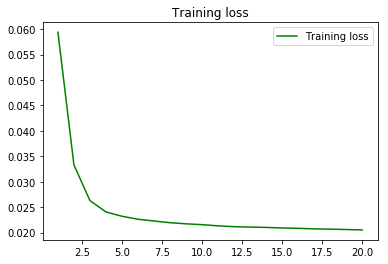

In [40]:
train_loss = history.history['loss']
epochs = range(1, len(train_loss) + 1)
plt.figure()
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.show()

In [85]:
print('Train MAE = %f' % (train_loss[-1] * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())))

Train MAE = 2.184822


For comparison, the LOCF model MAE is **2.144081**.

In [44]:
as5_train_preds = model.predict_generator(gen_train, steps=train_steps, workers=0)

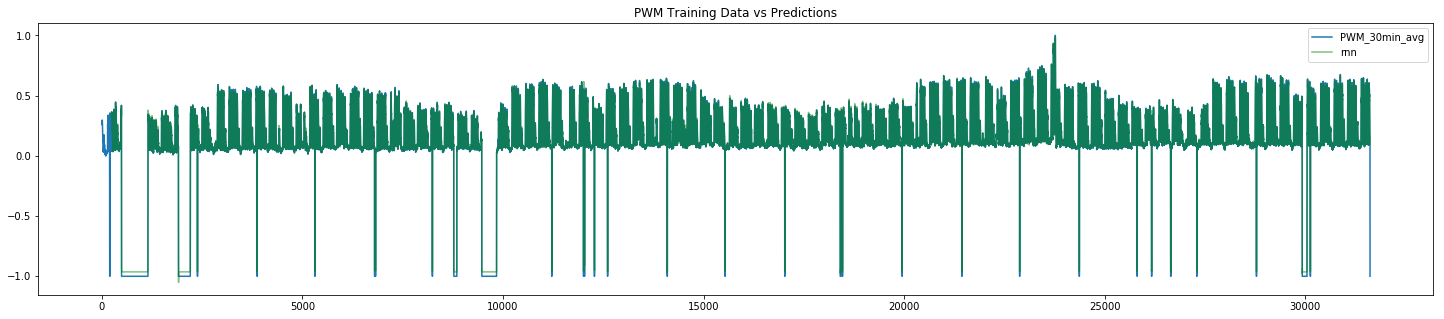

In [57]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(lookback, as5_train_data.shape[0]), as5_train_preds.flatten(), color='green', alpha=.5, label='rnn')
plt.title('PWM Training Data vs Predictions')
plt.legend()

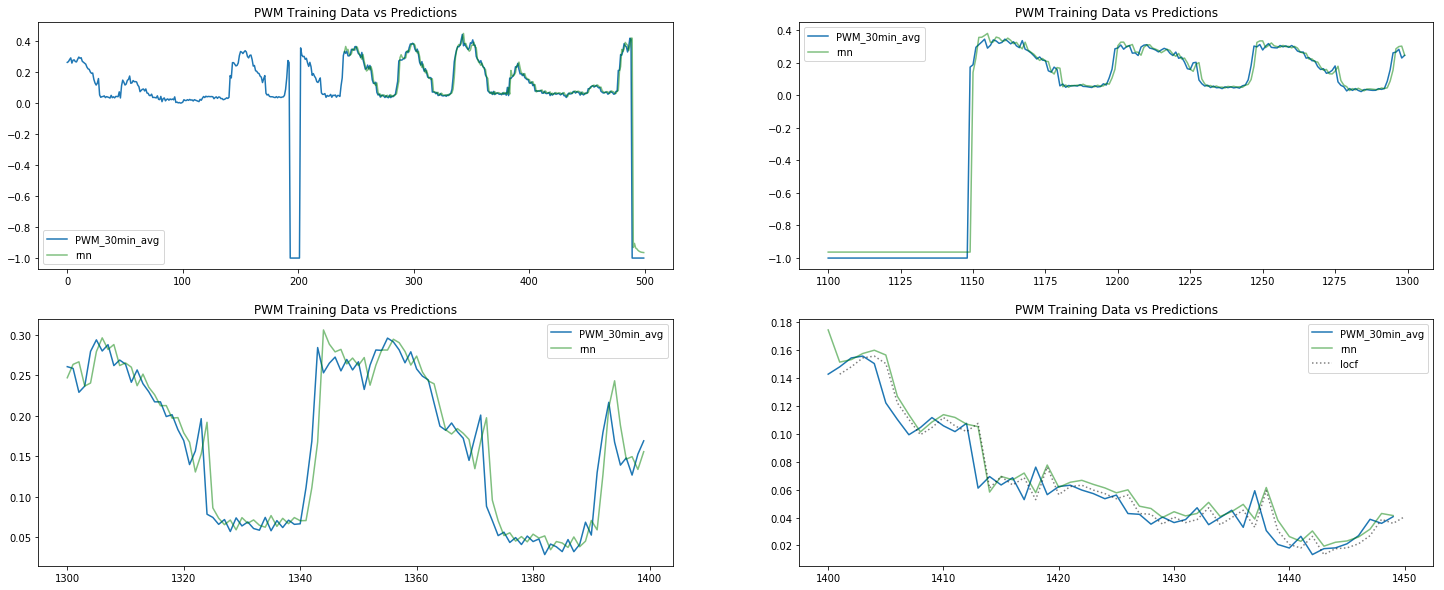

In [82]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(500), as5_train_data[:500, 0], label='PWM_30min_avg')
plt.plot(range(lookback, 500), as5_train_preds[:500 - lookback, :].flatten(), color='green', alpha=.5, label='rnn')
plt.title('PWM Training Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1100, 1300), as5_train_data[1100:1300, 0], label='PWM_30min_avg')
plt.plot(range(1100, 1300), as5_train_preds[1100 - lookback:1300 - lookback].flatten(), color='green', alpha=.5, label='rnn')
plt.title('PWM Training Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(1300, 1400), as5_train_data[1300:1400, 0], label='PWM_30min_avg')
plt.plot(range(1300, 1400), as5_train_preds[1300 - lookback:1400 - lookback].flatten(), color='green', alpha=.5, label='rnn')
plt.title('PWM Training Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(1400, 1450), as5_train_data[1400:1450, 0], label='PWM_30min_avg')
plt.plot(range(1400, 1450), as5_train_preds[1400 - lookback:1450 - lookback].flatten(), color='green', alpha=.5, label='rnn')
plt.plot(range(1401, 1451), as5_train_data[1400:1450, 0], color='black', alpha=.5, label='locf', linestyle=':')
plt.title('PWM Training Data vs Predictions')
plt.legend()

In [86]:
model.save('base-rnn-nomask.h5')

## Base RNN Model

### Test the thread-safe data generator

This generator should run faster.

There are 6 mini-batches. 1000 - 240 (lookback) / 128 = 5.9375

In [25]:
gen_testing.__len__()

6

The size of the first mini-batch is correct. 128 samples, each with 240 (lookback) x 2 (PWM & BTU) attributes.

In [31]:
gen_testing.__getitem__(0)[0].shape

(128, 240, 2)

The values of the 2nd sample tally with the values of the 1st sample with a shift of 1.

In [33]:
gen_testing.__getitem__(0)[0][0, :5, :]

array([[0.26254935, 0.56924225],
       [0.26724948, 0.53427896],
       [0.28031585, 0.53353241],
       [0.29140816, 0.53415454],
       [0.25784922, 0.49769815]])

In [34]:
gen_testing.__getitem__(0)[0][1, :5, :]

array([[0.26724948, 0.53427896],
       [0.28031585, 0.53353241],
       [0.29140816, 0.53415454],
       [0.25784922, 0.49769815],
       [0.27674375, 0.42702501]])

The size of the last mini-batch is less than 128. (1000 - 240) % 128 = 120.

In [36]:
gen_testing.__getitem__(5)[0].shape

(120, 240, 2)

### Split a validation set out from the train set

In [9]:
as5_train_split = as5_train_data[:20000]
as5_val_split = as5_train_data[20000:]

In [10]:
print('train split = %s\nvalidation split = %s' % (as5_train_split.shape, as5_val_split.shape))

train split = (20000, 2)
validation split = (11616, 2)


In [11]:
model = Sequential()
model.add(layers.GRU(16, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [12]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

In [13]:
gen_train.__len__()

155

In [14]:
gen_val.__len__()

89

### Train the RNN

In [15]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=80,
                              validation_data=gen_val,
                              workers=4, use_multiprocessing=True, shuffle=True)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/40


  1/155 [..............................] - ETA: 2:41 - loss: 0.0622 - mean_absolute_percentage_error: 41.3470

  2/155 [..............................] - ETA: 1:37 - loss: 0.0827 - mean_absolute_percentage_error: 61.7014

  3/155 [..............................] - ETA: 1:14 - loss: 0.0764 - mean_absolute_percentage_error: 57.2320

  4/155 [..............................] - ETA: 1:03 - loss: 0.0841 - mean_absolute_percentage_error: 67.9908

  5/155 [..............................] - ETA: 57s - loss: 0.0741 - mean_absolute_percentage_error: 59.2521 

  6/155 [>.............................] - ETA: 52s - loss: 0.0699 - mean_absolute_percentage_error: 53.5499

  7/155 [>.............................] - ETA: 49s - loss: 0.0669 - mean_absolute_percentage_error: 49.7543

  8/155 [>.............................] - ETA: 47s - loss: 0.0639 - mean_absolute_percentage_error: 47.1161

  9/155 [>.............................] - ETA: 45s - loss: 0.0614 - mean_absolute_percentage_error: 44.4476

 10/155 [>.............................] - ETA: 42s - loss: 0.0828 - mean_absolute_percentage_error: 42.7542

 11/155 [=>............................] - ETA: 41s - loss: 0.0807 - mean_absolute_percentage_error: 41.5358

 12/155 [=>............................] - ETA: 40s - loss: 0.0806 - mean_absolute_percentage_error: 41.2732

 13/155 [=>............................] - ETA: 39s - loss: 0.0840 - mean_absolute_percentage_error: 42.5657

 14/155 [=>............................] - ETA: 38s - loss: 0.0803 - mean_absolute_percentage_error: 41.9566

 15/155 [=>............................] - ETA: 37s - loss: 0.0778 - mean_absolute_percentage_error: 41.0638

 16/155 [==>...........................] - ETA: 36s - loss: 0.0757 - mean_absolute_percentage_error: 40.2140

 17/155 [==>...........................] - ETA: 35s - loss: 0.0735 - mean_absolute_percentage_error: 39.2524

 18/155 [==>...........................] - ETA: 35s - loss: 0.0726 - mean_absolute_percentage_error: 38.5587

 19/155 [==>...........................] - ETA: 34s - loss: 0.0731 - mean_absolute_percentage_error: 37.7711

 20/155 [==>...........................] - ETA: 33s - loss: 0.0714 - mean_absolute_percentage_error: 36.8261

 21/155 [===>..........................] - ETA: 32s - loss: 0.0706 - mean_absolute_percentage_error: 36.1269

 22/155 [===>..........................] - ETA: 31s - loss: 0.0691 - mean_absolute_percentage_error: 35.9569

 23/155 [===>..........................] - ETA: 30s - loss: 0.0675 - mean_absolute_percentage_error: 35.2636

 24/155 [===>..........................] - ETA: 30s - loss: 0.0740 - mean_absolute_percentage_error: 34.7282

 25/155 [===>..........................] - ETA: 29s - loss: 0.0722 - mean_absolute_percentage_error: 34.0296

 26/155 [====>.........................] - ETA: 29s - loss: 0.0716 - mean_absolute_percentage_error: 34.1428

 27/155 [====>.........................] - ETA: 28s - loss: 0.0701 - mean_absolute_percentage_error: 33.8247

 28/155 [====>.........................] - ETA: 28s - loss: 0.0697 - mean_absolute_percentage_error: 33.5945

 29/155 [====>.........................] - ETA: 28s - loss: 0.0686 - mean_absolute_percentage_error: 33.1362

 30/155 [====>.........................] - ETA: 27s - loss: 0.0679 - mean_absolute_percentage_error: 32.9178

 31/155 [=====>........................] - ETA: 27s - loss: 0.0670 - mean_absolute_percentage_error: 32.6733

 32/155 [=====>........................] - ETA: 27s - loss: 0.0668 - mean_absolute_percentage_error: 32.3193

 33/155 [=====>........................] - ETA: 27s - loss: 0.0682 - mean_absolute_percentage_error: 32.0780

 34/155 [=====>........................] - ETA: 27s - loss: 0.0676 - mean_absolute_percentage_error: 31.8942

 35/155 [=====>........................] - ETA: 27s - loss: 0.0667 - mean_absolute_percentage_error: 31.5897

 36/155 [=====>........................] - ETA: 27s - loss: 0.0662 - mean_absolute_percentage_error: 31.3988

 37/155 [======>.......................] - ETA: 26s - loss: 0.0656 - mean_absolute_percentage_error: 31.2884

 38/155 [======>.......................] - ETA: 26s - loss: 0.0653 - mean_absolute_percentage_error: 31.7141

 39/155 [======>.......................] - ETA: 26s - loss: 0.0651 - mean_absolute_percentage_error: 31.8919

 40/155 [======>.......................] - ETA: 26s - loss: 0.0657 - mean_absolute_percentage_error: 32.2507

 41/155 [======>.......................] - ETA: 25s - loss: 0.0651 - mean_absolute_percentage_error: 32.0380

 42/155 [=======>......................] - ETA: 25s - loss: 0.0648 - mean_absolute_percentage_error: 31.8020

 43/155 [=======>......................] - ETA: 24s - loss: 0.0644 - mean_absolute_percentage_error: 31.7412

 44/155 [=======>......................] - ETA: 24s - loss: 0.0640 - mean_absolute_percentage_error: 31.6498

 45/155 [=======>......................] - ETA: 24s - loss: 0.0634 - mean_absolute_percentage_error: 31.3756

 46/155 [=======>......................] - ETA: 24s - loss: 0.0630 - mean_absolute_percentage_error: 31.4308

 47/155 [========>.....................] - ETA: 24s - loss: 0.0625 - mean_absolute_percentage_error: 31.1791

 48/155 [========>.....................] - ETA: 23s - loss: 0.0622 - mean_absolute_percentage_error: 31.1500

 49/155 [========>.....................] - ETA: 23s - loss: 0.0620 - mean_absolute_percentage_error: 30.9937

 50/155 [========>.....................] - ETA: 23s - loss: 0.0612 - mean_absolute_percentage_error: 30.7748

 51/155 [========>.....................] - ETA: 23s - loss: 0.0610 - mean_absolute_percentage_error: 30.5433

 52/155 [=========>....................] - ETA: 23s - loss: 0.0614 - mean_absolute_percentage_error: 30.9413

 53/155 [=========>....................] - ETA: 23s - loss: 0.0606 - mean_absolute_percentage_error: 30.6916

 54/155 [=========>....................] - ETA: 23s - loss: 0.0600 - mean_absolute_percentage_error: 30.4631

 55/155 [=========>....................] - ETA: 22s - loss: 0.0598 - mean_absolute_percentage_error: 30.2550

 56/155 [=========>....................] - ETA: 22s - loss: 0.0595 - mean_absolute_percentage_error: 30.1444

 57/155 [==========>...................] - ETA: 22s - loss: 0.0591 - mean_absolute_percentage_error: 30.1703

 58/155 [==========>...................] - ETA: 22s - loss: 0.0586 - mean_absolute_percentage_error: 29.9413

 59/155 [==========>...................] - ETA: 21s - loss: 0.0582 - mean_absolute_percentage_error: 29.7336

 60/155 [==========>...................] - ETA: 21s - loss: 0.0577 - mean_absolute_percentage_error: 29.5618

 61/155 [==========>...................] - ETA: 21s - loss: 0.0580 - mean_absolute_percentage_error: 29.5797

 62/155 [===========>..................] - ETA: 21s - loss: 0.0579 - mean_absolute_percentage_error: 30.0327

 63/155 [===========>..................] - ETA: 21s - loss: 0.0574 - mean_absolute_percentage_error: 29.8448

 64/155 [===========>..................] - ETA: 20s - loss: 0.0571 - mean_absolute_percentage_error: 29.6440

 65/155 [===========>..................] - ETA: 20s - loss: 0.0566 - mean_absolute_percentage_error: 29.4484

 66/155 [===========>..................] - ETA: 20s - loss: 0.0566 - mean_absolute_percentage_error: 29.2916

 67/155 [===========>..................] - ETA: 20s - loss: 0.0561 - mean_absolute_percentage_error: 29.0565

 68/155 [============>.................] - ETA: 19s - loss: 0.0562 - mean_absolute_percentage_error: 29.0203

 69/155 [============>.................] - ETA: 19s - loss: 0.0588 - mean_absolute_percentage_error: 28.9421

 70/155 [============>.................] - ETA: 19s - loss: 0.0587 - mean_absolute_percentage_error: 28.9456

 71/155 [============>.................] - ETA: 19s - loss: 0.0602 - mean_absolute_percentage_error: 28.7751

 72/155 [============>.................] - ETA: 18s - loss: 0.0598 - mean_absolute_percentage_error: 28.7172

 73/155 [=============>................] - ETA: 18s - loss: 0.0594 - mean_absolute_percentage_error: 28.6285

 74/155 [=============>................] - ETA: 18s - loss: 0.0590 - mean_absolute_percentage_error: 28.5047

 75/155 [=============>................] - ETA: 18s - loss: 0.0586 - mean_absolute_percentage_error: 28.3722

 76/155 [=============>................] - ETA: 18s - loss: 0.0586 - mean_absolute_percentage_error: 28.4979

 77/155 [=============>................] - ETA: 17s - loss: 0.0587 - mean_absolute_percentage_error: 28.5252

 78/155 [==============>...............] - ETA: 17s - loss: 0.0583 - mean_absolute_percentage_error: 28.3601

 79/155 [==============>...............] - ETA: 17s - loss: 0.0578 - mean_absolute_percentage_error: 28.2242

 80/155 [==============>...............] - ETA: 17s - loss: 0.0575 - mean_absolute_percentage_error: 28.0756

 81/155 [==============>...............] - ETA: 16s - loss: 0.0571 - mean_absolute_percentage_error: 27.9310

 82/155 [==============>...............] - ETA: 16s - loss: 0.0569 - mean_absolute_percentage_error: 27.8456

 83/155 [===============>..............] - ETA: 16s - loss: 0.0564 - mean_absolute_percentage_error: 27.6937

 84/155 [===============>..............] - ETA: 16s - loss: 0.0560 - mean_absolute_percentage_error: 27.5674

 85/155 [===============>..............] - ETA: 15s - loss: 0.0556 - mean_absolute_percentage_error: 27.4847

 86/155 [===============>..............] - ETA: 15s - loss: 0.0560 - mean_absolute_percentage_error: 27.4345

 87/155 [===============>..............] - ETA: 15s - loss: 0.0557 - mean_absolute_percentage_error: 27.2967

 88/155 [================>.............] - ETA: 15s - loss: 0.0552 - mean_absolute_percentage_error: 27.2832

 89/155 [================>.............] - ETA: 14s - loss: 0.0563 - mean_absolute_percentage_error: 27.1483

 90/155 [================>.............] - ETA: 14s - loss: 0.0561 - mean_absolute_percentage_error: 27.1445

 91/155 [================>.............] - ETA: 14s - loss: 0.0559 - mean_absolute_percentage_error: 27.1031

 92/155 [================>.............] - ETA: 14s - loss: 0.0556 - mean_absolute_percentage_error: 27.0548

 93/155 [=================>............] - ETA: 13s - loss: 0.0557 - mean_absolute_percentage_error: 27.1917

 94/155 [=================>............] - ETA: 13s - loss: 0.0562 - mean_absolute_percentage_error: 27.0173

 95/155 [=================>............] - ETA: 13s - loss: 0.0563 - mean_absolute_percentage_error: 27.0914

 96/155 [=================>............] - ETA: 13s - loss: 0.0560 - mean_absolute_percentage_error: 27.0245

 97/155 [=================>............] - ETA: 12s - loss: 0.0558 - mean_absolute_percentage_error: 26.9825

 98/155 [=================>............] - ETA: 12s - loss: 0.0560 - mean_absolute_percentage_error: 27.0438

 99/155 [==================>...........] - ETA: 12s - loss: 0.0557 - mean_absolute_percentage_error: 27.0275

100/155 [==================>...........] - ETA: 12s - loss: 0.0554 - mean_absolute_percentage_error: 26.9435

101/155 [==================>...........] - ETA: 12s - loss: 0.0551 - mean_absolute_percentage_error: 26.8687

102/155 [==================>...........] - ETA: 11s - loss: 0.0549 - mean_absolute_percentage_error: 26.8677

103/155 [==================>...........] - ETA: 11s - loss: 0.0546 - mean_absolute_percentage_error: 26.8111

104/155 [===================>..........] - ETA: 11s - loss: 0.0544 - mean_absolute_percentage_error: 26.7138

105/155 [===================>..........] - ETA: 11s - loss: 0.0541 - mean_absolute_percentage_error: 26.6949

106/155 [===================>..........] - ETA: 10s - loss: 0.0538 - mean_absolute_percentage_error: 26.6297

107/155 [===================>..........] - ETA: 10s - loss: 0.0535 - mean_absolute_percentage_error: 26.5624

108/155 [===================>..........] - ETA: 10s - loss: 0.0533 - mean_absolute_percentage_error: 26.4840

109/155 [====================>.........] - ETA: 10s - loss: 0.0535 - mean_absolute_percentage_error: 26.4843

110/155 [====================>.........] - ETA: 10s - loss: 0.0533 - mean_absolute_percentage_error: 26.4198

111/155 [====================>.........] - ETA: 9s - loss: 0.0531 - mean_absolute_percentage_error: 26.3428 

112/155 [====================>.........] - ETA: 9s - loss: 0.0529 - mean_absolute_percentage_error: 26.2738

113/155 [====================>.........] - ETA: 9s - loss: 0.0528 - mean_absolute_percentage_error: 26.2237

114/155 [=====================>........] - ETA: 9s - loss: 0.0526 - mean_absolute_percentage_error: 26.1721

115/155 [=====================>........] - ETA: 8s - loss: 0.0525 - mean_absolute_percentage_error: 26.0811

116/155 [=====================>........] - ETA: 8s - loss: 0.0529 - mean_absolute_percentage_error: 25.9380

117/155 [=====================>........] - ETA: 8s - loss: 0.0526 - mean_absolute_percentage_error: 25.8538

118/155 [=====================>........] - ETA: 8s - loss: 0.0524 - mean_absolute_percentage_error: 25.7770

119/155 [======================>.......] - ETA: 7s - loss: 0.0522 - mean_absolute_percentage_error: 25.7764

120/155 [======================>.......] - ETA: 7s - loss: 0.0522 - mean_absolute_percentage_error: 25.7268

121/155 [======================>.......] - ETA: 7s - loss: 0.0520 - mean_absolute_percentage_error: 25.6478

122/155 [======================>.......] - ETA: 7s - loss: 0.0518 - mean_absolute_percentage_error: 25.5521

123/155 [======================>.......] - ETA: 7s - loss: 0.0516 - mean_absolute_percentage_error: 25.4682

124/155 [=======================>......] - ETA: 6s - loss: 0.0515 - mean_absolute_percentage_error: 25.4058

125/155 [=======================>......] - ETA: 6s - loss: 0.0517 - mean_absolute_percentage_error: 25.2770

126/155 [=======================>......] - ETA: 6s - loss: 0.0516 - mean_absolute_percentage_error: 25.2734

127/155 [=======================>......] - ETA: 6s - loss: 0.0516 - mean_absolute_percentage_error: 25.2428

128/155 [=======================>......] - ETA: 5s - loss: 0.0518 - mean_absolute_percentage_error: 25.2949

129/155 [=======================>......] - ETA: 5s - loss: 0.0516 - mean_absolute_percentage_error: 25.2368

130/155 [========================>.....] - ETA: 5s - loss: 0.0514 - mean_absolute_percentage_error: 25.2168

131/155 [========================>.....] - ETA: 5s - loss: 0.0513 - mean_absolute_percentage_error: 25.2025

132/155 [========================>.....] - ETA: 5s - loss: 0.0512 - mean_absolute_percentage_error: 25.1554

133/155 [========================>.....] - ETA: 4s - loss: 0.0512 - mean_absolute_percentage_error: 25.0022

134/155 [========================>.....] - ETA: 4s - loss: 0.0511 - mean_absolute_percentage_error: 24.9980

135/155 [=========================>....] - ETA: 4s - loss: 0.0509 - mean_absolute_percentage_error: 25.0102

136/155 [=========================>....] - ETA: 4s - loss: 0.0507 - mean_absolute_percentage_error: 24.9312

137/155 [=========================>....] - ETA: 3s - loss: 0.0505 - mean_absolute_percentage_error: 24.8702

138/155 [=========================>....] - ETA: 3s - loss: 0.0504 - mean_absolute_percentage_error: 24.8442

139/155 [=========================>....] - ETA: 3s - loss: 0.0503 - mean_absolute_percentage_error: 24.7988

140/155 [==========================>...] - ETA: 3s - loss: 0.0502 - mean_absolute_percentage_error: 24.7628

141/155 [==========================>...] - ETA: 3s - loss: 0.0501 - mean_absolute_percentage_error: 24.7173

142/155 [==========================>...] - ETA: 2s - loss: 0.0503 - mean_absolute_percentage_error: 25.1090

143/155 [==========================>...] - ETA: 2s - loss: 0.0503 - mean_absolute_percentage_error: 25.1438

144/155 [==========================>...] - ETA: 2s - loss: 0.0502 - mean_absolute_percentage_error: 25.0972

145/155 [===========================>..] - ETA: 2s - loss: 0.0500 - mean_absolute_percentage_error: 25.0532

146/155 [===========================>..] - ETA: 1s - loss: 0.0502 - mean_absolute_percentage_error: 24.9326

147/155 [===========================>..] - ETA: 1s - loss: 0.0500 - mean_absolute_percentage_error: 24.8857

148/155 [===========================>..] - ETA: 1s - loss: 0.0500 - mean_absolute_percentage_error: 24.8526

149/155 [===========================>..] - ETA: 1s - loss: 0.0499 - mean_absolute_percentage_error: 24.8529

150/155 [============================>.] - ETA: 1s - loss: 0.0499 - mean_absolute_percentage_error: 24.8093

151/155 [============================>.] - ETA: 0s - loss: 0.0497 - mean_absolute_percentage_error: 24.7554

152/155 [============================>.] - ETA: 0s - loss: 0.0495 - mean_absolute_percentage_error: 24.7169

153/155 [============================>.] - ETA: 0s - loss: 0.0494 - mean_absolute_percentage_error: 24.7049

154/155 [============================>.] - ETA: 0s - loss: 0.0493 - mean_absolute_percentage_error: 24.6572

155/155 [==============================] - 38s 248ms/step - loss: 0.0494 - mean_absolute_percentage_error: 24.7377 - val_loss: 0.0368 - val_mean_absolute_percentage_error: 17.6962


Epoch 2/40


  1/155 [..............................] - ETA: 46s - loss: 0.0256 - mean_absolute_percentage_error: 14.9023

  2/155 [..............................] - ETA: 40s - loss: 0.0230 - mean_absolute_percentage_error: 13.1258

  3/155 [..............................] - ETA: 41s - loss: 0.0221 - mean_absolute_percentage_error: 14.4899

  4/155 [..............................] - ETA: 38s - loss: 0.0215 - mean_absolute_percentage_error: 15.3198

  5/155 [..............................] - ETA: 38s - loss: 0.0215 - mean_absolute_percentage_error: 15.1359

  6/155 [>.............................] - ETA: 38s - loss: 0.0229 - mean_absolute_percentage_error: 15.2548

  7/155 [>.............................] - ETA: 37s - loss: 0.0241 - mean_absolute_percentage_error: 15.4292

  8/155 [>.............................] - ETA: 36s - loss: 0.0261 - mean_absolute_percentage_error: 15.1862

  9/155 [>.............................] - ETA: 35s - loss: 0.0269 - mean_absolute_percentage_error: 15.5299

 10/155 [>.............................] - ETA: 35s - loss: 0.0266 - mean_absolute_percentage_error: 15.4924

 11/155 [=>............................] - ETA: 34s - loss: 0.0282 - mean_absolute_percentage_error: 15.5902

 12/155 [=>............................] - ETA: 33s - loss: 0.0276 - mean_absolute_percentage_error: 16.2724

 13/155 [=>............................] - ETA: 33s - loss: 0.0277 - mean_absolute_percentage_error: 16.2588

 14/155 [=>............................] - ETA: 32s - loss: 0.0278 - mean_absolute_percentage_error: 16.2727

 15/155 [=>............................] - ETA: 32s - loss: 0.0280 - mean_absolute_percentage_error: 16.2138

 16/155 [==>...........................] - ETA: 32s - loss: 0.0313 - mean_absolute_percentage_error: 15.7697

 17/155 [==>...........................] - ETA: 32s - loss: 0.0313 - mean_absolute_percentage_error: 15.8555

 18/155 [==>...........................] - ETA: 31s - loss: 0.0307 - mean_absolute_percentage_error: 15.8955

 19/155 [==>...........................] - ETA: 31s - loss: 0.0307 - mean_absolute_percentage_error: 15.9633

 20/155 [==>...........................] - ETA: 31s - loss: 0.0306 - mean_absolute_percentage_error: 15.9882

 21/155 [===>..........................] - ETA: 30s - loss: 0.0300 - mean_absolute_percentage_error: 16.0141

 22/155 [===>..........................] - ETA: 30s - loss: 0.0296 - mean_absolute_percentage_error: 16.1897

 23/155 [===>..........................] - ETA: 30s - loss: 0.0291 - mean_absolute_percentage_error: 16.1677

 24/155 [===>..........................] - ETA: 29s - loss: 0.0298 - mean_absolute_percentage_error: 16.0824

 25/155 [===>..........................] - ETA: 29s - loss: 0.0298 - mean_absolute_percentage_error: 16.0399

 26/155 [====>.........................] - ETA: 28s - loss: 0.0300 - mean_absolute_percentage_error: 16.2207

 27/155 [====>.........................] - ETA: 28s - loss: 0.0299 - mean_absolute_percentage_error: 16.0942

 28/155 [====>.........................] - ETA: 28s - loss: 0.0298 - mean_absolute_percentage_error: 16.3141

 29/155 [====>.........................] - ETA: 28s - loss: 0.0294 - mean_absolute_percentage_error: 16.3974

 30/155 [====>.........................] - ETA: 27s - loss: 0.0292 - mean_absolute_percentage_error: 16.4307

 31/155 [=====>........................] - ETA: 27s - loss: 0.0292 - mean_absolute_percentage_error: 16.3638

 32/155 [=====>........................] - ETA: 27s - loss: 0.0294 - mean_absolute_percentage_error: 16.3540

 33/155 [=====>........................] - ETA: 26s - loss: 0.0296 - mean_absolute_percentage_error: 16.3329

 34/155 [=====>........................] - ETA: 26s - loss: 0.0292 - mean_absolute_percentage_error: 15.8942

 35/155 [=====>........................] - ETA: 26s - loss: 0.0294 - mean_absolute_percentage_error: 16.0486

 36/155 [=====>........................] - ETA: 26s - loss: 0.0299 - mean_absolute_percentage_error: 16.5872

 37/155 [======>.......................] - ETA: 26s - loss: 0.0301 - mean_absolute_percentage_error: 16.6535

 38/155 [======>.......................] - ETA: 25s - loss: 0.0303 - mean_absolute_percentage_error: 16.7004

 39/155 [======>.......................] - ETA: 25s - loss: 0.0302 - mean_absolute_percentage_error: 16.9158

 40/155 [======>.......................] - ETA: 25s - loss: 0.0300 - mean_absolute_percentage_error: 16.9867

 41/155 [======>.......................] - ETA: 24s - loss: 0.0301 - mean_absolute_percentage_error: 17.0552

 42/155 [=======>......................] - ETA: 24s - loss: 0.0303 - mean_absolute_percentage_error: 17.0500

 43/155 [=======>......................] - ETA: 24s - loss: 0.0308 - mean_absolute_percentage_error: 17.2884

 44/155 [=======>......................] - ETA: 24s - loss: 0.0309 - mean_absolute_percentage_error: 17.2323

 45/155 [=======>......................] - ETA: 23s - loss: 0.0308 - mean_absolute_percentage_error: 17.2450

 46/155 [=======>......................] - ETA: 23s - loss: 0.0310 - mean_absolute_percentage_error: 17.2728

 47/155 [========>.....................] - ETA: 23s - loss: 0.0308 - mean_absolute_percentage_error: 17.2663

 48/155 [========>.....................] - ETA: 23s - loss: 0.0308 - mean_absolute_percentage_error: 17.2267

 49/155 [========>.....................] - ETA: 22s - loss: 0.0308 - mean_absolute_percentage_error: 17.4116

 50/155 [========>.....................] - ETA: 22s - loss: 0.0316 - mean_absolute_percentage_error: 17.6789

 51/155 [========>.....................] - ETA: 22s - loss: 0.0314 - mean_absolute_percentage_error: 17.5665

 52/155 [=========>....................] - ETA: 22s - loss: 0.0315 - mean_absolute_percentage_error: 17.5095

 53/155 [=========>....................] - ETA: 22s - loss: 0.0324 - mean_absolute_percentage_error: 18.1883

 54/155 [=========>....................] - ETA: 22s - loss: 0.0324 - mean_absolute_percentage_error: 18.1507

 55/155 [=========>....................] - ETA: 22s - loss: 0.0325 - mean_absolute_percentage_error: 18.1276

 56/155 [=========>....................] - ETA: 21s - loss: 0.0325 - mean_absolute_percentage_error: 18.1081

 57/155 [==========>...................] - ETA: 21s - loss: 0.0321 - mean_absolute_percentage_error: 17.8066

 58/155 [==========>...................] - ETA: 21s - loss: 0.0318 - mean_absolute_percentage_error: 17.7968

 59/155 [==========>...................] - ETA: 21s - loss: 0.0320 - mean_absolute_percentage_error: 18.0827

 60/155 [==========>...................] - ETA: 21s - loss: 0.0321 - mean_absolute_percentage_error: 18.0490

 61/155 [==========>...................] - ETA: 20s - loss: 0.0320 - mean_absolute_percentage_error: 18.0906

 62/155 [===========>..................] - ETA: 20s - loss: 0.0325 - mean_absolute_percentage_error: 18.2870

 63/155 [===========>..................] - ETA: 20s - loss: 0.0323 - mean_absolute_percentage_error: 18.2284

 64/155 [===========>..................] - ETA: 20s - loss: 0.0330 - mean_absolute_percentage_error: 19.2191

 65/155 [===========>..................] - ETA: 20s - loss: 0.0331 - mean_absolute_percentage_error: 19.2260

 66/155 [===========>..................] - ETA: 20s - loss: 0.0327 - mean_absolute_percentage_error: 19.0919

 67/155 [===========>..................] - ETA: 19s - loss: 0.0326 - mean_absolute_percentage_error: 19.0527

 68/155 [============>.................] - ETA: 19s - loss: 0.0325 - mean_absolute_percentage_error: 19.0119

 69/155 [============>.................] - ETA: 19s - loss: 0.0323 - mean_absolute_percentage_error: 18.9552

 70/155 [============>.................] - ETA: 19s - loss: 0.0324 - mean_absolute_percentage_error: 18.9167

 71/155 [============>.................] - ETA: 19s - loss: 0.0324 - mean_absolute_percentage_error: 18.8806

 72/155 [============>.................] - ETA: 18s - loss: 0.0323 - mean_absolute_percentage_error: 18.8972

 73/155 [=============>................] - ETA: 18s - loss: 0.0324 - mean_absolute_percentage_error: 18.8190

 74/155 [=============>................] - ETA: 18s - loss: 0.0324 - mean_absolute_percentage_error: 18.7720

 75/155 [=============>................] - ETA: 18s - loss: 0.0322 - mean_absolute_percentage_error: 18.5467

 76/155 [=============>................] - ETA: 17s - loss: 0.0323 - mean_absolute_percentage_error: 18.5650

 77/155 [=============>................] - ETA: 17s - loss: 0.0322 - mean_absolute_percentage_error: 18.6768

 78/155 [==============>...............] - ETA: 17s - loss: 0.0322 - mean_absolute_percentage_error: 18.6337

 79/155 [==============>...............] - ETA: 17s - loss: 0.0322 - mean_absolute_percentage_error: 18.5751

 80/155 [==============>...............] - ETA: 16s - loss: 0.0320 - mean_absolute_percentage_error: 18.5990

 81/155 [==============>...............] - ETA: 16s - loss: 0.0319 - mean_absolute_percentage_error: 18.5365

 82/155 [==============>...............] - ETA: 16s - loss: 0.0319 - mean_absolute_percentage_error: 18.4841

 83/155 [===============>..............] - ETA: 16s - loss: 0.0318 - mean_absolute_percentage_error: 18.4464

 84/155 [===============>..............] - ETA: 16s - loss: 0.0316 - mean_absolute_percentage_error: 18.5446

 85/155 [===============>..............] - ETA: 15s - loss: 0.0316 - mean_absolute_percentage_error: 18.4864

 86/155 [===============>..............] - ETA: 15s - loss: 0.0315 - mean_absolute_percentage_error: 18.4275

 87/155 [===============>..............] - ETA: 15s - loss: 0.0313 - mean_absolute_percentage_error: 18.4105

 88/155 [================>.............] - ETA: 15s - loss: 0.0312 - mean_absolute_percentage_error: 18.3990

 89/155 [================>.............] - ETA: 14s - loss: 0.0311 - mean_absolute_percentage_error: 18.3381

 90/155 [================>.............] - ETA: 14s - loss: 0.0312 - mean_absolute_percentage_error: 18.6426

 91/155 [================>.............] - ETA: 14s - loss: 0.0311 - mean_absolute_percentage_error: 18.6295

 92/155 [================>.............] - ETA: 14s - loss: 0.0311 - mean_absolute_percentage_error: 18.6961

 93/155 [=================>............] - ETA: 13s - loss: 0.0310 - mean_absolute_percentage_error: 18.7074

 94/155 [=================>............] - ETA: 13s - loss: 0.0309 - mean_absolute_percentage_error: 18.6842

 95/155 [=================>............] - ETA: 13s - loss: 0.0309 - mean_absolute_percentage_error: 18.6406

 96/155 [=================>............] - ETA: 13s - loss: 0.0308 - mean_absolute_percentage_error: 18.6650

 97/155 [=================>............] - ETA: 13s - loss: 0.0310 - mean_absolute_percentage_error: 18.7751

 98/155 [=================>............] - ETA: 12s - loss: 0.0307 - mean_absolute_percentage_error: 18.5862

 99/155 [==================>...........] - ETA: 12s - loss: 0.0307 - mean_absolute_percentage_error: 18.7498

100/155 [==================>...........] - ETA: 12s - loss: 0.0307 - mean_absolute_percentage_error: 18.7238

101/155 [==================>...........] - ETA: 12s - loss: 0.0307 - mean_absolute_percentage_error: 18.6747

102/155 [==================>...........] - ETA: 11s - loss: 0.0306 - mean_absolute_percentage_error: 18.7077

103/155 [==================>...........] - ETA: 11s - loss: 0.0306 - mean_absolute_percentage_error: 18.6512

104/155 [===================>..........] - ETA: 11s - loss: 0.0305 - mean_absolute_percentage_error: 18.6582

105/155 [===================>..........] - ETA: 11s - loss: 0.0304 - mean_absolute_percentage_error: 18.6074

106/155 [===================>..........] - ETA: 11s - loss: 0.0305 - mean_absolute_percentage_error: 18.4714

107/155 [===================>..........] - ETA: 10s - loss: 0.0305 - mean_absolute_percentage_error: 18.4734

108/155 [===================>..........] - ETA: 10s - loss: 0.0308 - mean_absolute_percentage_error: 18.6403

109/155 [====================>.........] - ETA: 10s - loss: 0.0307 - mean_absolute_percentage_error: 18.6318

110/155 [====================>.........] - ETA: 10s - loss: 0.0306 - mean_absolute_percentage_error: 18.5949

111/155 [====================>.........] - ETA: 9s - loss: 0.0308 - mean_absolute_percentage_error: 18.6741 

112/155 [====================>.........] - ETA: 9s - loss: 0.0307 - mean_absolute_percentage_error: 18.6303

113/155 [====================>.........] - ETA: 9s - loss: 0.0306 - mean_absolute_percentage_error: 18.5768

114/155 [=====================>........] - ETA: 9s - loss: 0.0305 - mean_absolute_percentage_error: 18.5426

115/155 [=====================>........] - ETA: 8s - loss: 0.0304 - mean_absolute_percentage_error: 18.5033

116/155 [=====================>........] - ETA: 8s - loss: 0.0306 - mean_absolute_percentage_error: 18.5459

117/155 [=====================>........] - ETA: 8s - loss: 0.0304 - mean_absolute_percentage_error: 18.5282

118/155 [=====================>........] - ETA: 8s - loss: 0.0304 - mean_absolute_percentage_error: 18.5138

119/155 [======================>.......] - ETA: 8s - loss: 0.0307 - mean_absolute_percentage_error: 18.6557

120/155 [======================>.......] - ETA: 7s - loss: 0.0307 - mean_absolute_percentage_error: 18.6192

121/155 [======================>.......] - ETA: 7s - loss: 0.0305 - mean_absolute_percentage_error: 18.4718

122/155 [======================>.......] - ETA: 7s - loss: 0.0304 - mean_absolute_percentage_error: 18.4798

123/155 [======================>.......] - ETA: 7s - loss: 0.0304 - mean_absolute_percentage_error: 18.4375

124/155 [=======================>......] - ETA: 6s - loss: 0.0303 - mean_absolute_percentage_error: 18.4084

125/155 [=======================>......] - ETA: 6s - loss: 0.0303 - mean_absolute_percentage_error: 18.3642

126/155 [=======================>......] - ETA: 6s - loss: 0.0303 - mean_absolute_percentage_error: 18.3402

127/155 [=======================>......] - ETA: 6s - loss: 0.0303 - mean_absolute_percentage_error: 18.3536

128/155 [=======================>......] - ETA: 6s - loss: 0.0304 - mean_absolute_percentage_error: 18.3106

129/155 [=======================>......] - ETA: 5s - loss: 0.0304 - mean_absolute_percentage_error: 18.7607

130/155 [========================>.....] - ETA: 5s - loss: 0.0304 - mean_absolute_percentage_error: 18.7449

131/155 [========================>.....] - ETA: 5s - loss: 0.0303 - mean_absolute_percentage_error: 18.7145

132/155 [========================>.....] - ETA: 5s - loss: 0.0304 - mean_absolute_percentage_error: 18.6776

133/155 [========================>.....] - ETA: 4s - loss: 0.0304 - mean_absolute_percentage_error: 18.6760

134/155 [========================>.....] - ETA: 4s - loss: 0.0304 - mean_absolute_percentage_error: 18.5573

135/155 [=========================>....] - ETA: 4s - loss: 0.0304 - mean_absolute_percentage_error: 18.5461

136/155 [=========================>....] - ETA: 4s - loss: 0.0304 - mean_absolute_percentage_error: 18.5168

137/155 [=========================>....] - ETA: 4s - loss: 0.0304 - mean_absolute_percentage_error: 18.4893

138/155 [=========================>....] - ETA: 3s - loss: 0.0304 - mean_absolute_percentage_error: 18.4827

139/155 [=========================>....] - ETA: 3s - loss: 0.0304 - mean_absolute_percentage_error: 18.4663

140/155 [==========================>...] - ETA: 3s - loss: 0.0306 - mean_absolute_percentage_error: 18.6378

141/155 [==========================>...] - ETA: 3s - loss: 0.0308 - mean_absolute_percentage_error: 18.7221

142/155 [==========================>...] - ETA: 2s - loss: 0.0308 - mean_absolute_percentage_error: 18.7128

143/155 [==========================>...] - ETA: 2s - loss: 0.0309 - mean_absolute_percentage_error: 18.7489

144/155 [==========================>...] - ETA: 2s - loss: 0.0310 - mean_absolute_percentage_error: 18.8532

145/155 [===========================>..] - ETA: 2s - loss: 0.0308 - mean_absolute_percentage_error: 18.7284

146/155 [===========================>..] - ETA: 2s - loss: 0.0308 - mean_absolute_percentage_error: 18.7231

147/155 [===========================>..] - ETA: 1s - loss: 0.0307 - mean_absolute_percentage_error: 18.7094

148/155 [===========================>..] - ETA: 1s - loss: 0.0307 - mean_absolute_percentage_error: 18.6773

149/155 [===========================>..] - ETA: 1s - loss: 0.0310 - mean_absolute_percentage_error: 18.6707

150/155 [============================>.] - ETA: 1s - loss: 0.0309 - mean_absolute_percentage_error: 18.6785

151/155 [============================>.] - ETA: 0s - loss: 0.0309 - mean_absolute_percentage_error: 18.6449

152/155 [============================>.] - ETA: 0s - loss: 0.0308 - mean_absolute_percentage_error: 18.6245

153/155 [============================>.] - ETA: 0s - loss: 0.0308 - mean_absolute_percentage_error: 18.6171

154/155 [============================>.] - ETA: 0s - loss: 0.0310 - mean_absolute_percentage_error: 18.5377

155/155 [==============================] - 39s 250ms/step - loss: 0.0309 - mean_absolute_percentage_error: 18.5322 - val_loss: 0.0326 - val_mean_absolute_percentage_error: 15.0654


Epoch 3/40


  1/155 [..............................] - ETA: 35s - loss: 0.0219 - mean_absolute_percentage_error: 13.8286

  2/155 [..............................] - ETA: 33s - loss: 0.0215 - mean_absolute_percentage_error: 16.5638

  3/155 [..............................] - ETA: 30s - loss: 0.0288 - mean_absolute_percentage_error: 15.6237

  4/155 [..............................] - ETA: 30s - loss: 0.0306 - mean_absolute_percentage_error: 15.4418

  5/155 [..............................] - ETA: 33s - loss: 0.0285 - mean_absolute_percentage_error: 15.7580

  6/155 [>.............................] - ETA: 32s - loss: 0.0283 - mean_absolute_percentage_error: 15.9795

  7/155 [>.............................] - ETA: 31s - loss: 0.0279 - mean_absolute_percentage_error: 15.8888

  8/155 [>.............................] - ETA: 31s - loss: 0.0281 - mean_absolute_percentage_error: 16.4472

  9/155 [>.............................] - ETA: 31s - loss: 0.0280 - mean_absolute_percentage_error: 16.2461

 10/155 [>.............................] - ETA: 31s - loss: 0.0278 - mean_absolute_percentage_error: 16.2837

 11/155 [=>............................] - ETA: 31s - loss: 0.0281 - mean_absolute_percentage_error: 15.9902

 12/155 [=>............................] - ETA: 31s - loss: 0.0283 - mean_absolute_percentage_error: 16.1044

 13/155 [=>............................] - ETA: 30s - loss: 0.0284 - mean_absolute_percentage_error: 15.9625

 14/155 [=>............................] - ETA: 30s - loss: 0.0284 - mean_absolute_percentage_error: 15.6766

 15/155 [=>............................] - ETA: 30s - loss: 0.0302 - mean_absolute_percentage_error: 17.0017

 16/155 [==>...........................] - ETA: 31s - loss: 0.0303 - mean_absolute_percentage_error: 16.8724

 17/155 [==>...........................] - ETA: 31s - loss: 0.0299 - mean_absolute_percentage_error: 16.7390

 18/155 [==>...........................] - ETA: 31s - loss: 0.0293 - mean_absolute_percentage_error: 16.5415

 19/155 [==>...........................] - ETA: 31s - loss: 0.0290 - mean_absolute_percentage_error: 16.7372

 20/155 [==>...........................] - ETA: 31s - loss: 0.0286 - mean_absolute_percentage_error: 16.6831

 21/155 [===>..........................] - ETA: 32s - loss: 0.0287 - mean_absolute_percentage_error: 16.6038

 22/155 [===>..........................] - ETA: 32s - loss: 0.0288 - mean_absolute_percentage_error: 16.5224

 23/155 [===>..........................] - ETA: 31s - loss: 0.0285 - mean_absolute_percentage_error: 16.4603

 24/155 [===>..........................] - ETA: 31s - loss: 0.0278 - mean_absolute_percentage_error: 15.8269

 25/155 [===>..........................] - ETA: 30s - loss: 0.0278 - mean_absolute_percentage_error: 15.8719

 26/155 [====>.........................] - ETA: 31s - loss: 0.0277 - mean_absolute_percentage_error: 15.9063

 27/155 [====>.........................] - ETA: 31s - loss: 0.0275 - mean_absolute_percentage_error: 15.7297

 28/155 [====>.........................] - ETA: 30s - loss: 0.0272 - mean_absolute_percentage_error: 15.8448

 29/155 [====>.........................] - ETA: 30s - loss: 0.0269 - mean_absolute_percentage_error: 15.7265

 30/155 [====>.........................] - ETA: 30s - loss: 0.0273 - mean_absolute_percentage_error: 15.6017

 31/155 [=====>........................] - ETA: 30s - loss: 0.0278 - mean_absolute_percentage_error: 15.2372

 32/155 [=====>........................] - ETA: 29s - loss: 0.0276 - mean_absolute_percentage_error: 15.1801

 33/155 [=====>........................] - ETA: 29s - loss: 0.0277 - mean_absolute_percentage_error: 15.2252

 34/155 [=====>........................] - ETA: 29s - loss: 0.0278 - mean_absolute_percentage_error: 15.2504

 35/155 [=====>........................] - ETA: 29s - loss: 0.0275 - mean_absolute_percentage_error: 15.2424

 36/155 [=====>........................] - ETA: 29s - loss: 0.0273 - mean_absolute_percentage_error: 15.1749

 37/155 [======>.......................] - ETA: 28s - loss: 0.0272 - mean_absolute_percentage_error: 15.1263

 38/155 [======>.......................] - ETA: 28s - loss: 0.0269 - mean_absolute_percentage_error: 15.1588

 39/155 [======>.......................] - ETA: 28s - loss: 0.0271 - mean_absolute_percentage_error: 15.1827

 40/155 [======>.......................] - ETA: 27s - loss: 0.0269 - mean_absolute_percentage_error: 15.2366

 41/155 [======>.......................] - ETA: 27s - loss: 0.0272 - mean_absolute_percentage_error: 15.4266

 42/155 [=======>......................] - ETA: 27s - loss: 0.0274 - mean_absolute_percentage_error: 15.3776

 43/155 [=======>......................] - ETA: 26s - loss: 0.0272 - mean_absolute_percentage_error: 15.3672

 44/155 [=======>......................] - ETA: 26s - loss: 0.0270 - mean_absolute_percentage_error: 15.0564

 45/155 [=======>......................] - ETA: 26s - loss: 0.0279 - mean_absolute_percentage_error: 15.6876

 46/155 [=======>......................] - ETA: 26s - loss: 0.0279 - mean_absolute_percentage_error: 15.6995

 47/155 [========>.....................] - ETA: 26s - loss: 0.0280 - mean_absolute_percentage_error: 15.6702

 48/155 [========>.....................] - ETA: 25s - loss: 0.0281 - mean_absolute_percentage_error: 15.6333

 49/155 [========>.....................] - ETA: 25s - loss: 0.0281 - mean_absolute_percentage_error: 15.5908

 50/155 [========>.....................] - ETA: 25s - loss: 0.0279 - mean_absolute_percentage_error: 15.5259

 51/155 [========>.....................] - ETA: 24s - loss: 0.0278 - mean_absolute_percentage_error: 15.6107

 52/155 [=========>....................] - ETA: 24s - loss: 0.0277 - mean_absolute_percentage_error: 15.5857

 53/155 [=========>....................] - ETA: 24s - loss: 0.0277 - mean_absolute_percentage_error: 15.6015

 54/155 [=========>....................] - ETA: 24s - loss: 0.0276 - mean_absolute_percentage_error: 15.5852

 55/155 [=========>....................] - ETA: 23s - loss: 0.0280 - mean_absolute_percentage_error: 15.7960

 56/155 [=========>....................] - ETA: 23s - loss: 0.0279 - mean_absolute_percentage_error: 15.7325

 57/155 [==========>...................] - ETA: 23s - loss: 0.0282 - mean_absolute_percentage_error: 16.0542

 58/155 [==========>...................] - ETA: 23s - loss: 0.0283 - mean_absolute_percentage_error: 16.0116

 59/155 [==========>...................] - ETA: 22s - loss: 0.0283 - mean_absolute_percentage_error: 16.0407

 60/155 [==========>...................] - ETA: 22s - loss: 0.0282 - mean_absolute_percentage_error: 15.9701

 61/155 [==========>...................] - ETA: 22s - loss: 0.0280 - mean_absolute_percentage_error: 16.0828

 62/155 [===========>..................] - ETA: 22s - loss: 0.0279 - mean_absolute_percentage_error: 15.9955

 63/155 [===========>..................] - ETA: 22s - loss: 0.0279 - mean_absolute_percentage_error: 15.9722

 64/155 [===========>..................] - ETA: 21s - loss: 0.0278 - mean_absolute_percentage_error: 15.9531

 65/155 [===========>..................] - ETA: 21s - loss: 0.0277 - mean_absolute_percentage_error: 15.9001

 66/155 [===========>..................] - ETA: 21s - loss: 0.0275 - mean_absolute_percentage_error: 15.9279

 67/155 [===========>..................] - ETA: 21s - loss: 0.0275 - mean_absolute_percentage_error: 15.9117

 68/155 [============>.................] - ETA: 20s - loss: 0.0273 - mean_absolute_percentage_error: 15.8816

 69/155 [============>.................] - ETA: 20s - loss: 0.0274 - mean_absolute_percentage_error: 15.8899

 70/155 [============>.................] - ETA: 20s - loss: 0.0279 - mean_absolute_percentage_error: 16.1420

 71/155 [============>.................] - ETA: 19s - loss: 0.0277 - mean_absolute_percentage_error: 16.1080

 72/155 [============>.................] - ETA: 19s - loss: 0.0278 - mean_absolute_percentage_error: 16.0851

 73/155 [=============>................] - ETA: 19s - loss: 0.0277 - mean_absolute_percentage_error: 16.0640

 74/155 [=============>................] - ETA: 19s - loss: 0.0279 - mean_absolute_percentage_error: 15.9062

 75/155 [=============>................] - ETA: 18s - loss: 0.0277 - mean_absolute_percentage_error: 15.9551

 76/155 [=============>................] - ETA: 18s - loss: 0.0277 - mean_absolute_percentage_error: 15.9862

 77/155 [=============>................] - ETA: 18s - loss: 0.0276 - mean_absolute_percentage_error: 16.1546

 78/155 [==============>...............] - ETA: 18s - loss: 0.0275 - mean_absolute_percentage_error: 16.1060

 79/155 [==============>...............] - ETA: 17s - loss: 0.0281 - mean_absolute_percentage_error: 16.8387

 80/155 [==============>...............] - ETA: 17s - loss: 0.0284 - mean_absolute_percentage_error: 16.9831

 81/155 [==============>...............] - ETA: 17s - loss: 0.0284 - mean_absolute_percentage_error: 16.9366

 82/155 [==============>...............] - ETA: 17s - loss: 0.0284 - mean_absolute_percentage_error: 16.8905

 83/155 [===============>..............] - ETA: 17s - loss: 0.0283 - mean_absolute_percentage_error: 16.9343

 84/155 [===============>..............] - ETA: 16s - loss: 0.0284 - mean_absolute_percentage_error: 16.8906

 85/155 [===============>..............] - ETA: 16s - loss: 0.0283 - mean_absolute_percentage_error: 16.9365

 86/155 [===============>..............] - ETA: 16s - loss: 0.0281 - mean_absolute_percentage_error: 16.9001

 87/155 [===============>..............] - ETA: 16s - loss: 0.0280 - mean_absolute_percentage_error: 16.8378

 88/155 [================>.............] - ETA: 16s - loss: 0.0281 - mean_absolute_percentage_error: 16.8211

 89/155 [================>.............] - ETA: 15s - loss: 0.0281 - mean_absolute_percentage_error: 16.7977

 90/155 [================>.............] - ETA: 15s - loss: 0.0283 - mean_absolute_percentage_error: 16.8835

 91/155 [================>.............] - ETA: 15s - loss: 0.0282 - mean_absolute_percentage_error: 16.9127

 92/155 [================>.............] - ETA: 15s - loss: 0.0281 - mean_absolute_percentage_error: 16.8696

 93/155 [=================>............] - ETA: 14s - loss: 0.0281 - mean_absolute_percentage_error: 16.9411

 94/155 [=================>............] - ETA: 14s - loss: 0.0280 - mean_absolute_percentage_error: 16.8934

 95/155 [=================>............] - ETA: 14s - loss: 0.0280 - mean_absolute_percentage_error: 16.8823

 96/155 [=================>............] - ETA: 14s - loss: 0.0280 - mean_absolute_percentage_error: 16.8175

 97/155 [=================>............] - ETA: 13s - loss: 0.0279 - mean_absolute_percentage_error: 16.8676

 98/155 [=================>............] - ETA: 13s - loss: 0.0278 - mean_absolute_percentage_error: 16.8520

 99/155 [==================>...........] - ETA: 13s - loss: 0.0279 - mean_absolute_percentage_error: 16.8206

100/155 [==================>...........] - ETA: 13s - loss: 0.0278 - mean_absolute_percentage_error: 16.8154

101/155 [==================>...........] - ETA: 12s - loss: 0.0279 - mean_absolute_percentage_error: 16.7834

102/155 [==================>...........] - ETA: 12s - loss: 0.0279 - mean_absolute_percentage_error: 16.7765

103/155 [==================>...........] - ETA: 12s - loss: 0.0280 - mean_absolute_percentage_error: 17.3256

104/155 [===================>..........] - ETA: 12s - loss: 0.0278 - mean_absolute_percentage_error: 17.1611

105/155 [===================>..........] - ETA: 11s - loss: 0.0282 - mean_absolute_percentage_error: 17.0718

106/155 [===================>..........] - ETA: 11s - loss: 0.0281 - mean_absolute_percentage_error: 16.9283

107/155 [===================>..........] - ETA: 11s - loss: 0.0281 - mean_absolute_percentage_error: 16.9154

108/155 [===================>..........] - ETA: 11s - loss: 0.0280 - mean_absolute_percentage_error: 16.9052

109/155 [====================>.........] - ETA: 10s - loss: 0.0281 - mean_absolute_percentage_error: 16.8706

110/155 [====================>.........] - ETA: 10s - loss: 0.0281 - mean_absolute_percentage_error: 16.9202

111/155 [====================>.........] - ETA: 10s - loss: 0.0281 - mean_absolute_percentage_error: 16.8903

112/155 [====================>.........] - ETA: 10s - loss: 0.0280 - mean_absolute_percentage_error: 16.8705

113/155 [====================>.........] - ETA: 9s - loss: 0.0282 - mean_absolute_percentage_error: 16.9721 

114/155 [=====================>........] - ETA: 9s - loss: 0.0281 - mean_absolute_percentage_error: 16.9562

115/155 [=====================>........] - ETA: 9s - loss: 0.0280 - mean_absolute_percentage_error: 16.9302

116/155 [=====================>........] - ETA: 9s - loss: 0.0281 - mean_absolute_percentage_error: 16.9045

117/155 [=====================>........] - ETA: 8s - loss: 0.0281 - mean_absolute_percentage_error: 16.8665

118/155 [=====================>........] - ETA: 8s - loss: 0.0280 - mean_absolute_percentage_error: 16.8802

119/155 [======================>.......] - ETA: 8s - loss: 0.0280 - mean_absolute_percentage_error: 16.8752

120/155 [======================>.......] - ETA: 8s - loss: 0.0279 - mean_absolute_percentage_error: 16.8439

121/155 [======================>.......] - ETA: 7s - loss: 0.0281 - mean_absolute_percentage_error: 16.9181

122/155 [======================>.......] - ETA: 7s - loss: 0.0280 - mean_absolute_percentage_error: 16.9000

123/155 [======================>.......] - ETA: 7s - loss: 0.0280 - mean_absolute_percentage_error: 16.7924

124/155 [=======================>......] - ETA: 7s - loss: 0.0279 - mean_absolute_percentage_error: 16.8323

125/155 [=======================>......] - ETA: 7s - loss: 0.0279 - mean_absolute_percentage_error: 16.8014

126/155 [=======================>......] - ETA: 6s - loss: 0.0277 - mean_absolute_percentage_error: 16.7607

127/155 [=======================>......] - ETA: 6s - loss: 0.0278 - mean_absolute_percentage_error: 16.7459

128/155 [=======================>......] - ETA: 6s - loss: 0.0277 - mean_absolute_percentage_error: 16.6962

129/155 [=======================>......] - ETA: 6s - loss: 0.0278 - mean_absolute_percentage_error: 16.8993

130/155 [========================>.....] - ETA: 5s - loss: 0.0278 - mean_absolute_percentage_error: 16.8672

131/155 [========================>.....] - ETA: 5s - loss: 0.0279 - mean_absolute_percentage_error: 16.9206

132/155 [========================>.....] - ETA: 5s - loss: 0.0279 - mean_absolute_percentage_error: 16.8930

133/155 [========================>.....] - ETA: 5s - loss: 0.0279 - mean_absolute_percentage_error: 16.8885

134/155 [========================>.....] - ETA: 4s - loss: 0.0278 - mean_absolute_percentage_error: 16.8696

135/155 [=========================>....] - ETA: 4s - loss: 0.0279 - mean_absolute_percentage_error: 16.8611

136/155 [=========================>....] - ETA: 4s - loss: 0.0278 - mean_absolute_percentage_error: 16.8356

137/155 [=========================>....] - ETA: 4s - loss: 0.0279 - mean_absolute_percentage_error: 16.9096

138/155 [=========================>....] - ETA: 3s - loss: 0.0277 - mean_absolute_percentage_error: 16.7903

139/155 [=========================>....] - ETA: 3s - loss: 0.0277 - mean_absolute_percentage_error: 16.7904

140/155 [==========================>...] - ETA: 3s - loss: 0.0280 - mean_absolute_percentage_error: 16.9937

141/155 [==========================>...] - ETA: 3s - loss: 0.0279 - mean_absolute_percentage_error: 16.9846

142/155 [==========================>...] - ETA: 3s - loss: 0.0279 - mean_absolute_percentage_error: 16.9604

143/155 [==========================>...] - ETA: 2s - loss: 0.0280 - mean_absolute_percentage_error: 16.9242

144/155 [==========================>...] - ETA: 2s - loss: 0.0283 - mean_absolute_percentage_error: 16.9258

145/155 [===========================>..] - ETA: 2s - loss: 0.0283 - mean_absolute_percentage_error: 16.9164

146/155 [===========================>..] - ETA: 2s - loss: 0.0283 - mean_absolute_percentage_error: 16.8852

147/155 [===========================>..] - ETA: 1s - loss: 0.0284 - mean_absolute_percentage_error: 16.7989

148/155 [===========================>..] - ETA: 1s - loss: 0.0283 - mean_absolute_percentage_error: 16.7854

149/155 [===========================>..] - ETA: 1s - loss: 0.0283 - mean_absolute_percentage_error: 16.7753

150/155 [============================>.] - ETA: 1s - loss: 0.0283 - mean_absolute_percentage_error: 16.8633

151/155 [============================>.] - ETA: 0s - loss: 0.0286 - mean_absolute_percentage_error: 16.9265

152/155 [============================>.] - ETA: 0s - loss: 0.0285 - mean_absolute_percentage_error: 16.9026

153/155 [============================>.] - ETA: 0s - loss: 0.0285 - mean_absolute_percentage_error: 16.8737

154/155 [============================>.] - ETA: 0s - loss: 0.0284 - mean_absolute_percentage_error: 16.8832

155/155 [==============================] - 40s 260ms/step - loss: 0.0284 - mean_absolute_percentage_error: 16.8507 - val_loss: 0.0286 - val_mean_absolute_percentage_error: 13.9816


Epoch 4/40


  1/155 [..............................] - ETA: 46s - loss: 0.0429 - mean_absolute_percentage_error: 27.9923

  2/155 [..............................] - ETA: 47s - loss: 0.0336 - mean_absolute_percentage_error: 24.1829

  3/155 [..............................] - ETA: 41s - loss: 0.0305 - mean_absolute_percentage_error: 20.6908

  4/155 [..............................] - ETA: 41s - loss: 0.0400 - mean_absolute_percentage_error: 33.5193

  5/155 [..............................] - ETA: 38s - loss: 0.0357 - mean_absolute_percentage_error: 30.1855

  6/155 [>.............................] - ETA: 37s - loss: 0.0344 - mean_absolute_percentage_error: 27.3276

  7/155 [>.............................] - ETA: 37s - loss: 0.0319 - mean_absolute_percentage_error: 25.5522

  8/155 [>.............................] - ETA: 36s - loss: 0.0286 - mean_absolute_percentage_error: 22.4273

  9/155 [>.............................] - ETA: 35s - loss: 0.0329 - mean_absolute_percentage_error: 20.6864

 10/155 [>.............................] - ETA: 34s - loss: 0.0329 - mean_absolute_percentage_error: 19.9345

 11/155 [=>............................] - ETA: 34s - loss: 0.0324 - mean_absolute_percentage_error: 19.4730

 12/155 [=>............................] - ETA: 33s - loss: 0.0323 - mean_absolute_percentage_error: 19.0544

 13/155 [=>............................] - ETA: 33s - loss: 0.0342 - mean_absolute_percentage_error: 20.5626

 14/155 [=>............................] - ETA: 33s - loss: 0.0334 - mean_absolute_percentage_error: 19.8395

 15/155 [=>............................] - ETA: 32s - loss: 0.0322 - mean_absolute_percentage_error: 19.4845

 16/155 [==>...........................] - ETA: 32s - loss: 0.0316 - mean_absolute_percentage_error: 19.1869

 17/155 [==>...........................] - ETA: 31s - loss: 0.0314 - mean_absolute_percentage_error: 18.8776

 18/155 [==>...........................] - ETA: 31s - loss: 0.0310 - mean_absolute_percentage_error: 18.6216

 19/155 [==>...........................] - ETA: 30s - loss: 0.0302 - mean_absolute_percentage_error: 18.3312

 20/155 [==>...........................] - ETA: 30s - loss: 0.0296 - mean_absolute_percentage_error: 17.9880

 21/155 [===>..........................] - ETA: 30s - loss: 0.0290 - mean_absolute_percentage_error: 17.8540

 22/155 [===>..........................] - ETA: 30s - loss: 0.0282 - mean_absolute_percentage_error: 17.8227

 23/155 [===>..........................] - ETA: 30s - loss: 0.0283 - mean_absolute_percentage_error: 17.6915

 24/155 [===>..........................] - ETA: 31s - loss: 0.0279 - mean_absolute_percentage_error: 17.5353

 25/155 [===>..........................] - ETA: 31s - loss: 0.0295 - mean_absolute_percentage_error: 18.7049

 26/155 [====>.........................] - ETA: 31s - loss: 0.0293 - mean_absolute_percentage_error: 18.5143

 27/155 [====>.........................] - ETA: 31s - loss: 0.0291 - mean_absolute_percentage_error: 18.4035

 28/155 [====>.........................] - ETA: 31s - loss: 0.0288 - mean_absolute_percentage_error: 18.2455

 29/155 [====>.........................] - ETA: 31s - loss: 0.0285 - mean_absolute_percentage_error: 18.0210

 30/155 [====>.........................] - ETA: 31s - loss: 0.0284 - mean_absolute_percentage_error: 17.9215

 31/155 [=====>........................] - ETA: 30s - loss: 0.0282 - mean_absolute_percentage_error: 17.6791

 32/155 [=====>........................] - ETA: 30s - loss: 0.0280 - mean_absolute_percentage_error: 17.5547

 33/155 [=====>........................] - ETA: 29s - loss: 0.0287 - mean_absolute_percentage_error: 17.8702

 34/155 [=====>........................] - ETA: 29s - loss: 0.0286 - mean_absolute_percentage_error: 17.7023

 35/155 [=====>........................] - ETA: 29s - loss: 0.0285 - mean_absolute_percentage_error: 17.5988

 36/155 [=====>........................] - ETA: 29s - loss: 0.0280 - mean_absolute_percentage_error: 17.1347

 37/155 [======>.......................] - ETA: 28s - loss: 0.0279 - mean_absolute_percentage_error: 17.3204

 38/155 [======>.......................] - ETA: 28s - loss: 0.0277 - mean_absolute_percentage_error: 17.3746

 39/155 [======>.......................] - ETA: 28s - loss: 0.0281 - mean_absolute_percentage_error: 17.2540

 40/155 [======>.......................] - ETA: 28s - loss: 0.0278 - mean_absolute_percentage_error: 17.2612

 41/155 [======>.......................] - ETA: 27s - loss: 0.0275 - mean_absolute_percentage_error: 17.2314

 42/155 [=======>......................] - ETA: 27s - loss: 0.0274 - mean_absolute_percentage_error: 17.1151

 43/155 [=======>......................] - ETA: 27s - loss: 0.0279 - mean_absolute_percentage_error: 17.2916

 44/155 [=======>......................] - ETA: 27s - loss: 0.0279 - mean_absolute_percentage_error: 17.1744

 45/155 [=======>......................] - ETA: 27s - loss: 0.0277 - mean_absolute_percentage_error: 17.0624

 46/155 [=======>......................] - ETA: 26s - loss: 0.0276 - mean_absolute_percentage_error: 16.9803

 47/155 [========>.....................] - ETA: 26s - loss: 0.0275 - mean_absolute_percentage_error: 16.9309

 48/155 [========>.....................] - ETA: 26s - loss: 0.0273 - mean_absolute_percentage_error: 16.8906

 49/155 [========>.....................] - ETA: 27s - loss: 0.0273 - mean_absolute_percentage_error: 16.8315

 50/155 [========>.....................] - ETA: 26s - loss: 0.0271 - mean_absolute_percentage_error: 16.7938

 51/155 [========>.....................] - ETA: 26s - loss: 0.0269 - mean_absolute_percentage_error: 16.6843

 52/155 [=========>....................] - ETA: 26s - loss: 0.0267 - mean_absolute_percentage_error: 16.5502

 53/155 [=========>....................] - ETA: 26s - loss: 0.0271 - mean_absolute_percentage_error: 16.7340

 54/155 [=========>....................] - ETA: 25s - loss: 0.0271 - mean_absolute_percentage_error: 16.4704

 55/155 [=========>....................] - ETA: 25s - loss: 0.0271 - mean_absolute_percentage_error: 16.4752

 56/155 [=========>....................] - ETA: 25s - loss: 0.0269 - mean_absolute_percentage_error: 16.6008

 57/155 [==========>...................] - ETA: 25s - loss: 0.0269 - mean_absolute_percentage_error: 16.5174

 58/155 [==========>...................] - ETA: 25s - loss: 0.0270 - mean_absolute_percentage_error: 16.4481

 59/155 [==========>...................] - ETA: 24s - loss: 0.0268 - mean_absolute_percentage_error: 16.5796

 60/155 [==========>...................] - ETA: 24s - loss: 0.0267 - mean_absolute_percentage_error: 16.4974

 61/155 [==========>...................] - ETA: 24s - loss: 0.0267 - mean_absolute_percentage_error: 16.4195

 62/155 [===========>..................] - ETA: 24s - loss: 0.0266 - mean_absolute_percentage_error: 16.5606

 63/155 [===========>..................] - ETA: 23s - loss: 0.0265 - mean_absolute_percentage_error: 16.5777

 64/155 [===========>..................] - ETA: 23s - loss: 0.0270 - mean_absolute_percentage_error: 16.7241

 65/155 [===========>..................] - ETA: 23s - loss: 0.0270 - mean_absolute_percentage_error: 16.6952

 66/155 [===========>..................] - ETA: 22s - loss: 0.0269 - mean_absolute_percentage_error: 16.5931

 67/155 [===========>..................] - ETA: 22s - loss: 0.0268 - mean_absolute_percentage_error: 16.5604

 68/155 [============>.................] - ETA: 22s - loss: 0.0269 - mean_absolute_percentage_error: 16.5575

 69/155 [============>.................] - ETA: 22s - loss: 0.0271 - mean_absolute_percentage_error: 16.7008

 70/155 [============>.................] - ETA: 22s - loss: 0.0271 - mean_absolute_percentage_error: 16.5071

 71/155 [============>.................] - ETA: 22s - loss: 0.0271 - mean_absolute_percentage_error: 16.4833

 72/155 [============>.................] - ETA: 21s - loss: 0.0269 - mean_absolute_percentage_error: 16.4312

 73/155 [=============>................] - ETA: 21s - loss: 0.0267 - mean_absolute_percentage_error: 16.3743

 74/155 [=============>................] - ETA: 21s - loss: 0.0268 - mean_absolute_percentage_error: 16.3179

 75/155 [=============>................] - ETA: 21s - loss: 0.0268 - mean_absolute_percentage_error: 16.2991

 76/155 [=============>................] - ETA: 20s - loss: 0.0267 - mean_absolute_percentage_error: 16.2664

 77/155 [=============>................] - ETA: 20s - loss: 0.0267 - mean_absolute_percentage_error: 16.2120

 78/155 [==============>...............] - ETA: 20s - loss: 0.0266 - mean_absolute_percentage_error: 16.2039

 79/155 [==============>...............] - ETA: 20s - loss: 0.0268 - mean_absolute_percentage_error: 16.1612

 80/155 [==============>...............] - ETA: 19s - loss: 0.0268 - mean_absolute_percentage_error: 16.1493

 81/155 [==============>...............] - ETA: 19s - loss: 0.0271 - mean_absolute_percentage_error: 16.2541

 82/155 [==============>...............] - ETA: 19s - loss: 0.0271 - mean_absolute_percentage_error: 16.2338

 83/155 [===============>..............] - ETA: 18s - loss: 0.0269 - mean_absolute_percentage_error: 16.1913

 84/155 [===============>..............] - ETA: 18s - loss: 0.0269 - mean_absolute_percentage_error: 16.2121

 85/155 [===============>..............] - ETA: 18s - loss: 0.0266 - mean_absolute_percentage_error: 16.0251

 86/155 [===============>..............] - ETA: 17s - loss: 0.0266 - mean_absolute_percentage_error: 16.1397

 87/155 [===============>..............] - ETA: 17s - loss: 0.0269 - mean_absolute_percentage_error: 16.3059

 88/155 [================>.............] - ETA: 17s - loss: 0.0269 - mean_absolute_percentage_error: 16.2830

 89/155 [================>.............] - ETA: 17s - loss: 0.0270 - mean_absolute_percentage_error: 16.2528

 90/155 [================>.............] - ETA: 17s - loss: 0.0269 - mean_absolute_percentage_error: 16.2602

 91/155 [================>.............] - ETA: 16s - loss: 0.0272 - mean_absolute_percentage_error: 16.4467

 92/155 [================>.............] - ETA: 16s - loss: 0.0271 - mean_absolute_percentage_error: 16.4669

 93/155 [=================>............] - ETA: 16s - loss: 0.0274 - mean_absolute_percentage_error: 16.6437

 94/155 [=================>............] - ETA: 16s - loss: 0.0273 - mean_absolute_percentage_error: 16.5901

 95/155 [=================>............] - ETA: 16s - loss: 0.0272 - mean_absolute_percentage_error: 16.5439

 96/155 [=================>............] - ETA: 15s - loss: 0.0272 - mean_absolute_percentage_error: 16.5241

 97/155 [=================>............] - ETA: 15s - loss: 0.0271 - mean_absolute_percentage_error: 16.4654

 98/155 [=================>............] - ETA: 15s - loss: 0.0271 - mean_absolute_percentage_error: 16.4286

 99/155 [==================>...........] - ETA: 15s - loss: 0.0270 - mean_absolute_percentage_error: 16.3881

100/155 [==================>...........] - ETA: 14s - loss: 0.0270 - mean_absolute_percentage_error: 16.3840

101/155 [==================>...........] - ETA: 14s - loss: 0.0270 - mean_absolute_percentage_error: 16.3511

102/155 [==================>...........] - ETA: 14s - loss: 0.0270 - mean_absolute_percentage_error: 16.3461

103/155 [==================>...........] - ETA: 14s - loss: 0.0270 - mean_absolute_percentage_error: 16.2946

104/155 [===================>..........] - ETA: 13s - loss: 0.0269 - mean_absolute_percentage_error: 16.2698

105/155 [===================>..........] - ETA: 13s - loss: 0.0268 - mean_absolute_percentage_error: 16.2588

106/155 [===================>..........] - ETA: 13s - loss: 0.0269 - mean_absolute_percentage_error: 16.2176

107/155 [===================>..........] - ETA: 13s - loss: 0.0267 - mean_absolute_percentage_error: 16.0706

108/155 [===================>..........] - ETA: 12s - loss: 0.0267 - mean_absolute_percentage_error: 16.0223

109/155 [====================>.........] - ETA: 12s - loss: 0.0266 - mean_absolute_percentage_error: 16.0050

110/155 [====================>.........] - ETA: 12s - loss: 0.0269 - mean_absolute_percentage_error: 15.9089

111/155 [====================>.........] - ETA: 11s - loss: 0.0268 - mean_absolute_percentage_error: 15.9191

112/155 [====================>.........] - ETA: 11s - loss: 0.0269 - mean_absolute_percentage_error: 15.8829

113/155 [====================>.........] - ETA: 11s - loss: 0.0269 - mean_absolute_percentage_error: 15.8523

114/155 [=====================>........] - ETA: 11s - loss: 0.0269 - mean_absolute_percentage_error: 16.3379

115/155 [=====================>........] - ETA: 10s - loss: 0.0268 - mean_absolute_percentage_error: 16.3198

116/155 [=====================>........] - ETA: 10s - loss: 0.0267 - mean_absolute_percentage_error: 16.2729

117/155 [=====================>........] - ETA: 10s - loss: 0.0267 - mean_absolute_percentage_error: 16.1637

118/155 [=====================>........] - ETA: 9s - loss: 0.0267 - mean_absolute_percentage_error: 16.1522 

119/155 [======================>.......] - ETA: 9s - loss: 0.0270 - mean_absolute_percentage_error: 16.1578

120/155 [======================>.......] - ETA: 9s - loss: 0.0270 - mean_absolute_percentage_error: 16.1250

121/155 [======================>.......] - ETA: 9s - loss: 0.0270 - mean_absolute_percentage_error: 16.0994

122/155 [======================>.......] - ETA: 8s - loss: 0.0271 - mean_absolute_percentage_error: 16.1694

123/155 [======================>.......] - ETA: 8s - loss: 0.0271 - mean_absolute_percentage_error: 16.1498

124/155 [=======================>......] - ETA: 8s - loss: 0.0270 - mean_absolute_percentage_error: 16.1342

125/155 [=======================>......] - ETA: 8s - loss: 0.0271 - mean_absolute_percentage_error: 16.2386

126/155 [=======================>......] - ETA: 7s - loss: 0.0271 - mean_absolute_percentage_error: 16.2067

127/155 [=======================>......] - ETA: 7s - loss: 0.0270 - mean_absolute_percentage_error: 16.2382

128/155 [=======================>......] - ETA: 7s - loss: 0.0269 - mean_absolute_percentage_error: 16.1900

129/155 [=======================>......] - ETA: 7s - loss: 0.0268 - mean_absolute_percentage_error: 16.1818

130/155 [========================>.....] - ETA: 6s - loss: 0.0267 - mean_absolute_percentage_error: 16.1255

131/155 [========================>.....] - ETA: 6s - loss: 0.0266 - mean_absolute_percentage_error: 16.0932

132/155 [========================>.....] - ETA: 6s - loss: 0.0265 - mean_absolute_percentage_error: 15.9777

133/155 [========================>.....] - ETA: 6s - loss: 0.0264 - mean_absolute_percentage_error: 15.9818

134/155 [========================>.....] - ETA: 5s - loss: 0.0265 - mean_absolute_percentage_error: 15.9601

135/155 [=========================>....] - ETA: 5s - loss: 0.0265 - mean_absolute_percentage_error: 15.9376

136/155 [=========================>....] - ETA: 5s - loss: 0.0265 - mean_absolute_percentage_error: 15.8965

137/155 [=========================>....] - ETA: 4s - loss: 0.0267 - mean_absolute_percentage_error: 15.9611

138/155 [=========================>....] - ETA: 4s - loss: 0.0267 - mean_absolute_percentage_error: 15.9468

139/155 [=========================>....] - ETA: 4s - loss: 0.0266 - mean_absolute_percentage_error: 15.9215

140/155 [==========================>...] - ETA: 4s - loss: 0.0266 - mean_absolute_percentage_error: 15.8900

141/155 [==========================>...] - ETA: 3s - loss: 0.0266 - mean_absolute_percentage_error: 15.9216

142/155 [==========================>...] - ETA: 3s - loss: 0.0266 - mean_absolute_percentage_error: 15.8864

143/155 [==========================>...] - ETA: 3s - loss: 0.0266 - mean_absolute_percentage_error: 15.8603

144/155 [==========================>...] - ETA: 2s - loss: 0.0266 - mean_absolute_percentage_error: 15.8671

145/155 [===========================>..] - ETA: 2s - loss: 0.0265 - mean_absolute_percentage_error: 15.8429

146/155 [===========================>..] - ETA: 2s - loss: 0.0264 - mean_absolute_percentage_error: 15.8271

147/155 [===========================>..] - ETA: 2s - loss: 0.0264 - mean_absolute_percentage_error: 15.8162

148/155 [===========================>..] - ETA: 1s - loss: 0.0264 - mean_absolute_percentage_error: 15.7877

149/155 [===========================>..] - ETA: 1s - loss: 0.0264 - mean_absolute_percentage_error: 15.7720

150/155 [============================>.] - ETA: 1s - loss: 0.0264 - mean_absolute_percentage_error: 15.7580

151/155 [============================>.] - ETA: 1s - loss: 0.0264 - mean_absolute_percentage_error: 15.7329

152/155 [============================>.] - ETA: 0s - loss: 0.0264 - mean_absolute_percentage_error: 15.7084

153/155 [============================>.] - ETA: 0s - loss: 0.0264 - mean_absolute_percentage_error: 15.8825

154/155 [============================>.] - ETA: 0s - loss: 0.0264 - mean_absolute_percentage_error: 15.8746

155/155 [==============================] - 46s 297ms/step - loss: 0.0264 - mean_absolute_percentage_error: 15.9794 - val_loss: 0.0290 - val_mean_absolute_percentage_error: 13.0073


Epoch 5/40


  1/155 [..............................] - ETA: 30s - loss: 0.0496 - mean_absolute_percentage_error: 23.4110

  2/155 [..............................] - ETA: 32s - loss: 0.0350 - mean_absolute_percentage_error: 17.4453

  3/155 [..............................] - ETA: 30s - loss: 0.0336 - mean_absolute_percentage_error: 15.7063

  4/155 [..............................] - ETA: 30s - loss: 0.0298 - mean_absolute_percentage_error: 17.3872

  5/155 [..............................] - ETA: 29s - loss: 0.0287 - mean_absolute_percentage_error: 14.4810

  6/155 [>.............................] - ETA: 29s - loss: 0.0297 - mean_absolute_percentage_error: 14.2264

  7/155 [>.............................] - ETA: 28s - loss: 0.0282 - mean_absolute_percentage_error: 14.5834

  8/155 [>.............................] - ETA: 30s - loss: 0.0276 - mean_absolute_percentage_error: 14.7826

  9/155 [>.............................] - ETA: 29s - loss: 0.0275 - mean_absolute_percentage_error: 14.2692

 10/155 [>.............................] - ETA: 30s - loss: 0.0269 - mean_absolute_percentage_error: 14.1596

 11/155 [=>............................] - ETA: 30s - loss: 0.0268 - mean_absolute_percentage_error: 14.1646

 12/155 [=>............................] - ETA: 30s - loss: 0.0264 - mean_absolute_percentage_error: 14.0978

 13/155 [=>............................] - ETA: 30s - loss: 0.0265 - mean_absolute_percentage_error: 13.8995

 14/155 [=>............................] - ETA: 29s - loss: 0.0263 - mean_absolute_percentage_error: 14.5468

 15/155 [=>............................] - ETA: 29s - loss: 0.0279 - mean_absolute_percentage_error: 15.3816

 16/155 [==>...........................] - ETA: 29s - loss: 0.0273 - mean_absolute_percentage_error: 15.2533

 17/155 [==>...........................] - ETA: 29s - loss: 0.0274 - mean_absolute_percentage_error: 14.9845

 18/155 [==>...........................] - ETA: 28s - loss: 0.0273 - mean_absolute_percentage_error: 14.9335

 19/155 [==>...........................] - ETA: 28s - loss: 0.0273 - mean_absolute_percentage_error: 14.7516

 20/155 [==>...........................] - ETA: 28s - loss: 0.0269 - mean_absolute_percentage_error: 14.9364

 21/155 [===>..........................] - ETA: 28s - loss: 0.0275 - mean_absolute_percentage_error: 14.7570

 22/155 [===>..........................] - ETA: 28s - loss: 0.0275 - mean_absolute_percentage_error: 14.6317

 23/155 [===>..........................] - ETA: 28s - loss: 0.0273 - mean_absolute_percentage_error: 14.5907

 24/155 [===>..........................] - ETA: 28s - loss: 0.0283 - mean_absolute_percentage_error: 15.3331

 25/155 [===>..........................] - ETA: 27s - loss: 0.0280 - mean_absolute_percentage_error: 15.2074

 26/155 [====>.........................] - ETA: 28s - loss: 0.0278 - mean_absolute_percentage_error: 15.0883

 27/155 [====>.........................] - ETA: 27s - loss: 0.0274 - mean_absolute_percentage_error: 14.9762

 28/155 [====>.........................] - ETA: 27s - loss: 0.0274 - mean_absolute_percentage_error: 14.9411

 29/155 [====>.........................] - ETA: 27s - loss: 0.0271 - mean_absolute_percentage_error: 15.0342

 30/155 [====>.........................] - ETA: 26s - loss: 0.0270 - mean_absolute_percentage_error: 14.9087

 31/155 [=====>........................] - ETA: 26s - loss: 0.0265 - mean_absolute_percentage_error: 14.8764

 32/155 [=====>........................] - ETA: 26s - loss: 0.0277 - mean_absolute_percentage_error: 14.8883

 33/155 [=====>........................] - ETA: 26s - loss: 0.0275 - mean_absolute_percentage_error: 15.1254

 34/155 [=====>........................] - ETA: 25s - loss: 0.0271 - mean_absolute_percentage_error: 15.0652

 35/155 [=====>........................] - ETA: 25s - loss: 0.0269 - mean_absolute_percentage_error: 15.1138

 36/155 [=====>........................] - ETA: 25s - loss: 0.0263 - mean_absolute_percentage_error: 14.7100

 37/155 [======>.......................] - ETA: 25s - loss: 0.0261 - mean_absolute_percentage_error: 14.8044

 38/155 [======>.......................] - ETA: 24s - loss: 0.0262 - mean_absolute_percentage_error: 14.8223

 39/155 [======>.......................] - ETA: 24s - loss: 0.0262 - mean_absolute_percentage_error: 14.7574

 40/155 [======>.......................] - ETA: 24s - loss: 0.0264 - mean_absolute_percentage_error: 16.1993

 41/155 [======>.......................] - ETA: 24s - loss: 0.0262 - mean_absolute_percentage_error: 16.1621

 42/155 [=======>......................] - ETA: 23s - loss: 0.0267 - mean_absolute_percentage_error: 16.3658

 43/155 [=======>......................] - ETA: 23s - loss: 0.0265 - mean_absolute_percentage_error: 16.3061

 44/155 [=======>......................] - ETA: 23s - loss: 0.0266 - mean_absolute_percentage_error: 16.1926

 45/155 [=======>......................] - ETA: 24s - loss: 0.0265 - mean_absolute_percentage_error: 16.1270

 46/155 [=======>......................] - ETA: 23s - loss: 0.0264 - mean_absolute_percentage_error: 16.0205

 47/155 [========>.....................] - ETA: 24s - loss: 0.0263 - mean_absolute_percentage_error: 16.2620

 48/155 [========>.....................] - ETA: 24s - loss: 0.0261 - mean_absolute_percentage_error: 16.1890

 49/155 [========>.....................] - ETA: 23s - loss: 0.0264 - mean_absolute_percentage_error: 16.1012

 50/155 [========>.....................] - ETA: 24s - loss: 0.0263 - mean_absolute_percentage_error: 16.0598

 51/155 [========>.....................] - ETA: 23s - loss: 0.0262 - mean_absolute_percentage_error: 16.0410

 52/155 [=========>....................] - ETA: 23s - loss: 0.0261 - mean_absolute_percentage_error: 15.9325

 53/155 [=========>....................] - ETA: 23s - loss: 0.0262 - mean_absolute_percentage_error: 16.4237

 54/155 [=========>....................] - ETA: 23s - loss: 0.0260 - mean_absolute_percentage_error: 16.3425

 55/155 [=========>....................] - ETA: 22s - loss: 0.0259 - mean_absolute_percentage_error: 16.3632

 56/155 [=========>....................] - ETA: 23s - loss: 0.0257 - mean_absolute_percentage_error: 16.3589

 57/155 [==========>...................] - ETA: 23s - loss: 0.0259 - mean_absolute_percentage_error: 16.5864

 58/155 [==========>...................] - ETA: 24s - loss: 0.0258 - mean_absolute_percentage_error: 16.5782

 59/155 [==========>...................] - ETA: 24s - loss: 0.0258 - mean_absolute_percentage_error: 16.5356

 60/155 [==========>...................] - ETA: 24s - loss: 0.0257 - mean_absolute_percentage_error: 16.4441

 61/155 [==========>...................] - ETA: 24s - loss: 0.0256 - mean_absolute_percentage_error: 16.3464

 62/155 [===========>..................] - ETA: 24s - loss: 0.0253 - mean_absolute_percentage_error: 16.3741

 63/155 [===========>..................] - ETA: 24s - loss: 0.0253 - mean_absolute_percentage_error: 16.2782

 64/155 [===========>..................] - ETA: 23s - loss: 0.0253 - mean_absolute_percentage_error: 16.2360

 65/155 [===========>..................] - ETA: 23s - loss: 0.0252 - mean_absolute_percentage_error: 16.1667

 66/155 [===========>..................] - ETA: 23s - loss: 0.0250 - mean_absolute_percentage_error: 16.1169

 67/155 [===========>..................] - ETA: 23s - loss: 0.0250 - mean_absolute_percentage_error: 16.0597

 68/155 [============>.................] - ETA: 23s - loss: 0.0250 - mean_absolute_percentage_error: 15.9784

 69/155 [============>.................] - ETA: 23s - loss: 0.0249 - mean_absolute_percentage_error: 15.7698

 70/155 [============>.................] - ETA: 22s - loss: 0.0250 - mean_absolute_percentage_error: 15.8025

 71/155 [============>.................] - ETA: 22s - loss: 0.0250 - mean_absolute_percentage_error: 15.8658

 72/155 [============>.................] - ETA: 22s - loss: 0.0249 - mean_absolute_percentage_error: 15.8883

 73/155 [=============>................] - ETA: 21s - loss: 0.0248 - mean_absolute_percentage_error: 15.9472

 74/155 [=============>................] - ETA: 21s - loss: 0.0249 - mean_absolute_percentage_error: 15.9102

 75/155 [=============>................] - ETA: 21s - loss: 0.0247 - mean_absolute_percentage_error: 15.8888

 76/155 [=============>................] - ETA: 21s - loss: 0.0246 - mean_absolute_percentage_error: 15.9246

 77/155 [=============>................] - ETA: 21s - loss: 0.0247 - mean_absolute_percentage_error: 15.8840

 78/155 [==============>...............] - ETA: 20s - loss: 0.0246 - mean_absolute_percentage_error: 15.8565

 79/155 [==============>...............] - ETA: 20s - loss: 0.0247 - mean_absolute_percentage_error: 15.9258

 80/155 [==============>...............] - ETA: 20s - loss: 0.0247 - mean_absolute_percentage_error: 15.8845

 81/155 [==============>...............] - ETA: 19s - loss: 0.0245 - mean_absolute_percentage_error: 15.7018

 82/155 [==============>...............] - ETA: 19s - loss: 0.0244 - mean_absolute_percentage_error: 15.6785

 83/155 [===============>..............] - ETA: 19s - loss: 0.0244 - mean_absolute_percentage_error: 15.6854

 84/155 [===============>..............] - ETA: 18s - loss: 0.0243 - mean_absolute_percentage_error: 15.6391

 85/155 [===============>..............] - ETA: 18s - loss: 0.0243 - mean_absolute_percentage_error: 15.5723

 86/155 [===============>..............] - ETA: 18s - loss: 0.0245 - mean_absolute_percentage_error: 15.4402

 87/155 [===============>..............] - ETA: 17s - loss: 0.0245 - mean_absolute_percentage_error: 15.4097

 88/155 [================>.............] - ETA: 17s - loss: 0.0244 - mean_absolute_percentage_error: 15.2546

 89/155 [================>.............] - ETA: 17s - loss: 0.0247 - mean_absolute_percentage_error: 15.4608

 90/155 [================>.............] - ETA: 17s - loss: 0.0247 - mean_absolute_percentage_error: 15.4543

 91/155 [================>.............] - ETA: 17s - loss: 0.0250 - mean_absolute_percentage_error: 15.5471

 92/155 [================>.............] - ETA: 16s - loss: 0.0249 - mean_absolute_percentage_error: 15.5475

 93/155 [=================>............] - ETA: 16s - loss: 0.0249 - mean_absolute_percentage_error: 15.5168

 94/155 [=================>............] - ETA: 16s - loss: 0.0248 - mean_absolute_percentage_error: 15.4774

 95/155 [=================>............] - ETA: 16s - loss: 0.0250 - mean_absolute_percentage_error: 15.3737

 96/155 [=================>............] - ETA: 15s - loss: 0.0250 - mean_absolute_percentage_error: 15.3636

 97/155 [=================>............] - ETA: 15s - loss: 0.0249 - mean_absolute_percentage_error: 15.3301

 98/155 [=================>............] - ETA: 15s - loss: 0.0249 - mean_absolute_percentage_error: 15.2899

 99/155 [==================>...........] - ETA: 15s - loss: 0.0248 - mean_absolute_percentage_error: 15.2466

100/155 [==================>...........] - ETA: 15s - loss: 0.0247 - mean_absolute_percentage_error: 15.2386

101/155 [==================>...........] - ETA: 14s - loss: 0.0251 - mean_absolute_percentage_error: 15.4693

102/155 [==================>...........] - ETA: 14s - loss: 0.0250 - mean_absolute_percentage_error: 15.4630

103/155 [==================>...........] - ETA: 14s - loss: 0.0250 - mean_absolute_percentage_error: 15.4256

104/155 [===================>..........] - ETA: 13s - loss: 0.0250 - mean_absolute_percentage_error: 15.4176

105/155 [===================>..........] - ETA: 13s - loss: 0.0249 - mean_absolute_percentage_error: 15.3790

106/155 [===================>..........] - ETA: 13s - loss: 0.0249 - mean_absolute_percentage_error: 15.3505

107/155 [===================>..........] - ETA: 13s - loss: 0.0246 - mean_absolute_percentage_error: 15.2073

108/155 [===================>..........] - ETA: 12s - loss: 0.0246 - mean_absolute_percentage_error: 15.2167

109/155 [====================>.........] - ETA: 12s - loss: 0.0244 - mean_absolute_percentage_error: 15.1741

110/155 [====================>.........] - ETA: 12s - loss: 0.0245 - mean_absolute_percentage_error: 15.1509

111/155 [====================>.........] - ETA: 11s - loss: 0.0245 - mean_absolute_percentage_error: 15.1997

112/155 [====================>.........] - ETA: 11s - loss: 0.0244 - mean_absolute_percentage_error: 15.1930

113/155 [====================>.........] - ETA: 11s - loss: 0.0246 - mean_absolute_percentage_error: 15.3151

114/155 [=====================>........] - ETA: 10s - loss: 0.0246 - mean_absolute_percentage_error: 15.2942

115/155 [=====================>........] - ETA: 10s - loss: 0.0246 - mean_absolute_percentage_error: 15.2581

116/155 [=====================>........] - ETA: 10s - loss: 0.0247 - mean_absolute_percentage_error: 15.3397

117/155 [=====================>........] - ETA: 10s - loss: 0.0251 - mean_absolute_percentage_error: 15.5868

118/155 [=====================>........] - ETA: 9s - loss: 0.0250 - mean_absolute_percentage_error: 15.5450 

119/155 [======================>.......] - ETA: 9s - loss: 0.0251 - mean_absolute_percentage_error: 15.4924

120/155 [======================>.......] - ETA: 9s - loss: 0.0251 - mean_absolute_percentage_error: 15.5093

121/155 [======================>.......] - ETA: 8s - loss: 0.0251 - mean_absolute_percentage_error: 15.4615

122/155 [======================>.......] - ETA: 8s - loss: 0.0251 - mean_absolute_percentage_error: 15.4357

123/155 [======================>.......] - ETA: 8s - loss: 0.0250 - mean_absolute_percentage_error: 15.4127

124/155 [=======================>......] - ETA: 8s - loss: 0.0250 - mean_absolute_percentage_error: 15.4095

125/155 [=======================>......] - ETA: 7s - loss: 0.0249 - mean_absolute_percentage_error: 15.3818

126/155 [=======================>......] - ETA: 7s - loss: 0.0250 - mean_absolute_percentage_error: 15.3805

127/155 [=======================>......] - ETA: 7s - loss: 0.0249 - mean_absolute_percentage_error: 15.3419

128/155 [=======================>......] - ETA: 7s - loss: 0.0249 - mean_absolute_percentage_error: 15.3181

129/155 [=======================>......] - ETA: 6s - loss: 0.0249 - mean_absolute_percentage_error: 15.3183

130/155 [========================>.....] - ETA: 6s - loss: 0.0249 - mean_absolute_percentage_error: 15.2921

131/155 [========================>.....] - ETA: 6s - loss: 0.0250 - mean_absolute_percentage_error: 15.3831

132/155 [========================>.....] - ETA: 5s - loss: 0.0250 - mean_absolute_percentage_error: 15.3617

133/155 [========================>.....] - ETA: 5s - loss: 0.0250 - mean_absolute_percentage_error: 15.3400

134/155 [========================>.....] - ETA: 5s - loss: 0.0249 - mean_absolute_percentage_error: 15.2922

135/155 [=========================>....] - ETA: 5s - loss: 0.0249 - mean_absolute_percentage_error: 15.2643

136/155 [=========================>....] - ETA: 4s - loss: 0.0252 - mean_absolute_percentage_error: 15.6535

137/155 [=========================>....] - ETA: 4s - loss: 0.0251 - mean_absolute_percentage_error: 15.6079

138/155 [=========================>....] - ETA: 4s - loss: 0.0253 - mean_absolute_percentage_error: 15.6601

139/155 [=========================>....] - ETA: 4s - loss: 0.0253 - mean_absolute_percentage_error: 15.6343

140/155 [==========================>...] - ETA: 3s - loss: 0.0252 - mean_absolute_percentage_error: 15.5348

141/155 [==========================>...] - ETA: 3s - loss: 0.0252 - mean_absolute_percentage_error: 15.5310

142/155 [==========================>...] - ETA: 3s - loss: 0.0252 - mean_absolute_percentage_error: 15.4950

143/155 [==========================>...] - ETA: 3s - loss: 0.0252 - mean_absolute_percentage_error: 15.4661

144/155 [==========================>...] - ETA: 2s - loss: 0.0253 - mean_absolute_percentage_error: 15.5453

145/155 [===========================>..] - ETA: 2s - loss: 0.0252 - mean_absolute_percentage_error: 15.5177

146/155 [===========================>..] - ETA: 2s - loss: 0.0252 - mean_absolute_percentage_error: 15.4909

147/155 [===========================>..] - ETA: 2s - loss: 0.0251 - mean_absolute_percentage_error: 15.4640

148/155 [===========================>..] - ETA: 1s - loss: 0.0251 - mean_absolute_percentage_error: 15.4333

149/155 [===========================>..] - ETA: 1s - loss: 0.0250 - mean_absolute_percentage_error: 15.4070

150/155 [============================>.] - ETA: 1s - loss: 0.0250 - mean_absolute_percentage_error: 15.3767

151/155 [============================>.] - ETA: 1s - loss: 0.0249 - mean_absolute_percentage_error: 15.3770

152/155 [============================>.] - ETA: 0s - loss: 0.0249 - mean_absolute_percentage_error: 15.4157

153/155 [============================>.] - ETA: 0s - loss: 0.0249 - mean_absolute_percentage_error: 15.3981

154/155 [============================>.] - ETA: 0s - loss: 0.0248 - mean_absolute_percentage_error: 15.3115

155/155 [==============================] - 45s 294ms/step - loss: 0.0248 - mean_absolute_percentage_error: 15.2722 - val_loss: 0.0271 - val_mean_absolute_percentage_error: 13.3209


Epoch 6/40
  1/155 [..............................] - ETA: 29s - loss: 0.0184 - mean_absolute_percentage_error: 14.5304

  2/155 [..............................] - ETA: 54s - loss: 0.0180 - mean_absolute_percentage_error: 12.7406

  3/155 [..............................] - ETA: 44s - loss: 0.0195 - mean_absolute_percentage_error: 12.5309

  4/155 [..............................] - ETA: 40s - loss: 0.0205 - mean_absolute_percentage_error: 12.9982

  5/155 [..............................] - ETA: 39s - loss: 0.0214 - mean_absolute_percentage_error: 12.8020

  6/155 [>.............................] - ETA: 37s - loss: 0.0235 - mean_absolute_percentage_error: 11.2401

  7/155 [>.............................] - ETA: 36s - loss: 0.0226 - mean_absolute_percentage_error: 11.4769

  8/155 [>.............................] - ETA: 40s - loss: 0.0226 - mean_absolute_percentage_error: 11.9835

  9/155 [>.............................] - ETA: 38s - loss: 0.0230 - mean_absolute_percentage_error: 12.1620

 10/155 [>.............................] - ETA: 39s - loss: 0.0230 - mean_absolute_percentage_error: 12.0478

 11/155 [=>............................] - ETA: 40s - loss: 0.0239 - mean_absolute_percentage_error: 12.3598

 12/155 [=>............................] - ETA: 42s - loss: 0.0234 - mean_absolute_percentage_error: 12.3794

 13/155 [=>............................] - ETA: 43s - loss: 0.0234 - mean_absolute_percentage_error: 12.2370

 14/155 [=>............................] - ETA: 44s - loss: 0.0237 - mean_absolute_percentage_error: 12.3467

 15/155 [=>............................] - ETA: 44s - loss: 0.0234 - mean_absolute_percentage_error: 12.2001

 16/155 [==>...........................] - ETA: 44s - loss: 0.0228 - mean_absolute_percentage_error: 12.1975

 17/155 [==>...........................] - ETA: 42s - loss: 0.0242 - mean_absolute_percentage_error: 13.3837

 18/155 [==>...........................] - ETA: 43s - loss: 0.0236 - mean_absolute_percentage_error: 12.7161

 19/155 [==>...........................] - ETA: 42s - loss: 0.0237 - mean_absolute_percentage_error: 12.8166

 20/155 [==>...........................] - ETA: 41s - loss: 0.0235 - mean_absolute_percentage_error: 12.8905

 21/155 [===>..........................] - ETA: 40s - loss: 0.0237 - mean_absolute_percentage_error: 12.8206

 22/155 [===>..........................] - ETA: 39s - loss: 0.0255 - mean_absolute_percentage_error: 14.2614

 23/155 [===>..........................] - ETA: 39s - loss: 0.0254 - mean_absolute_percentage_error: 14.3814

 24/155 [===>..........................] - ETA: 39s - loss: 0.0250 - mean_absolute_percentage_error: 14.3683

 25/155 [===>..........................] - ETA: 38s - loss: 0.0252 - mean_absolute_percentage_error: 13.9132

 26/155 [====>.........................] - ETA: 38s - loss: 0.0251 - mean_absolute_percentage_error: 13.8905

 27/155 [====>.........................] - ETA: 38s - loss: 0.0250 - mean_absolute_percentage_error: 13.7360

 28/155 [====>.........................] - ETA: 38s - loss: 0.0249 - mean_absolute_percentage_error: 13.7326

 29/155 [====>.........................] - ETA: 38s - loss: 0.0247 - mean_absolute_percentage_error: 13.6405

 30/155 [====>.........................] - ETA: 38s - loss: 0.0247 - mean_absolute_percentage_error: 13.5688

 31/155 [=====>........................] - ETA: 38s - loss: 0.0245 - mean_absolute_percentage_error: 13.9935

 32/155 [=====>........................] - ETA: 37s - loss: 0.0244 - mean_absolute_percentage_error: 13.9700

 33/155 [=====>........................] - ETA: 37s - loss: 0.0241 - mean_absolute_percentage_error: 13.8883

 34/155 [=====>........................] - ETA: 37s - loss: 0.0239 - mean_absolute_percentage_error: 13.8943

 35/155 [=====>........................] - ETA: 36s - loss: 0.0239 - mean_absolute_percentage_error: 13.5638

 36/155 [=====>........................] - ETA: 36s - loss: 0.0244 - mean_absolute_percentage_error: 14.0173

 37/155 [======>.......................] - ETA: 35s - loss: 0.0243 - mean_absolute_percentage_error: 14.1931

 38/155 [======>.......................] - ETA: 35s - loss: 0.0248 - mean_absolute_percentage_error: 14.4676

 39/155 [======>.......................] - ETA: 34s - loss: 0.0246 - mean_absolute_percentage_error: 14.3840

 40/155 [======>.......................] - ETA: 34s - loss: 0.0245 - mean_absolute_percentage_error: 14.4523

 41/155 [======>.......................] - ETA: 34s - loss: 0.0246 - mean_absolute_percentage_error: 14.1679

 42/155 [=======>......................] - ETA: 34s - loss: 0.0248 - mean_absolute_percentage_error: 15.5035

 43/155 [=======>......................] - ETA: 33s - loss: 0.0247 - mean_absolute_percentage_error: 15.4292

 44/155 [=======>......................] - ETA: 33s - loss: 0.0247 - mean_absolute_percentage_error: 15.3245

 45/155 [=======>......................] - ETA: 33s - loss: 0.0245 - mean_absolute_percentage_error: 15.2395

 46/155 [=======>......................] - ETA: 32s - loss: 0.0243 - mean_absolute_percentage_error: 15.2134

 47/155 [========>.....................] - ETA: 32s - loss: 0.0242 - mean_absolute_percentage_error: 15.1186

 48/155 [========>.....................] - ETA: 32s - loss: 0.0242 - mean_absolute_percentage_error: 15.0370

 49/155 [========>.....................] - ETA: 31s - loss: 0.0240 - mean_absolute_percentage_error: 15.0680

 50/155 [========>.....................] - ETA: 31s - loss: 0.0238 - mean_absolute_percentage_error: 15.0173

 51/155 [========>.....................] - ETA: 30s - loss: 0.0238 - mean_absolute_percentage_error: 15.0854

 52/155 [=========>....................] - ETA: 30s - loss: 0.0240 - mean_absolute_percentage_error: 15.3541

 53/155 [=========>....................] - ETA: 30s - loss: 0.0237 - mean_absolute_percentage_error: 15.0819

 54/155 [=========>....................] - ETA: 29s - loss: 0.0237 - mean_absolute_percentage_error: 15.0649

 55/155 [=========>....................] - ETA: 29s - loss: 0.0235 - mean_absolute_percentage_error: 14.9635

 56/155 [=========>....................] - ETA: 29s - loss: 0.0236 - mean_absolute_percentage_error: 14.9293

 57/155 [==========>...................] - ETA: 29s - loss: 0.0235 - mean_absolute_percentage_error: 15.1900

 58/155 [==========>...................] - ETA: 28s - loss: 0.0240 - mean_absolute_percentage_error: 15.4737

 59/155 [==========>...................] - ETA: 28s - loss: 0.0239 - mean_absolute_percentage_error: 15.4433

 60/155 [==========>...................] - ETA: 28s - loss: 0.0238 - mean_absolute_percentage_error: 15.4572

 61/155 [==========>...................] - ETA: 27s - loss: 0.0238 - mean_absolute_percentage_error: 15.3774

 62/155 [===========>..................] - ETA: 27s - loss: 0.0237 - mean_absolute_percentage_error: 15.3731

 63/155 [===========>..................] - ETA: 27s - loss: 0.0237 - mean_absolute_percentage_error: 15.3136

 64/155 [===========>..................] - ETA: 26s - loss: 0.0236 - mean_absolute_percentage_error: 15.3580

 65/155 [===========>..................] - ETA: 26s - loss: 0.0235 - mean_absolute_percentage_error: 15.3046

 66/155 [===========>..................] - ETA: 26s - loss: 0.0234 - mean_absolute_percentage_error: 15.3003

 67/155 [===========>..................] - ETA: 25s - loss: 0.0233 - mean_absolute_percentage_error: 15.0944

 68/155 [============>.................] - ETA: 25s - loss: 0.0232 - mean_absolute_percentage_error: 15.1273

 69/155 [============>.................] - ETA: 25s - loss: 0.0233 - mean_absolute_percentage_error: 15.0764

 70/155 [============>.................] - ETA: 25s - loss: 0.0233 - mean_absolute_percentage_error: 15.0073

 71/155 [============>.................] - ETA: 24s - loss: 0.0232 - mean_absolute_percentage_error: 14.9787

 72/155 [============>.................] - ETA: 24s - loss: 0.0235 - mean_absolute_percentage_error: 15.0866

 73/155 [=============>................] - ETA: 24s - loss: 0.0235 - mean_absolute_percentage_error: 15.0188

 74/155 [=============>................] - ETA: 23s - loss: 0.0233 - mean_absolute_percentage_error: 14.9603

 75/155 [=============>................] - ETA: 23s - loss: 0.0234 - mean_absolute_percentage_error: 14.9287

 76/155 [=============>................] - ETA: 23s - loss: 0.0233 - mean_absolute_percentage_error: 14.9488

 77/155 [=============>................] - ETA: 22s - loss: 0.0231 - mean_absolute_percentage_error: 14.7679

 78/155 [==============>...............] - ETA: 22s - loss: 0.0231 - mean_absolute_percentage_error: 14.9335

 79/155 [==============>...............] - ETA: 22s - loss: 0.0230 - mean_absolute_percentage_error: 14.8888

 80/155 [==============>...............] - ETA: 21s - loss: 0.0229 - mean_absolute_percentage_error: 14.9230

 81/155 [==============>...............] - ETA: 21s - loss: 0.0233 - mean_absolute_percentage_error: 15.0937

 82/155 [==============>...............] - ETA: 21s - loss: 0.0232 - mean_absolute_percentage_error: 15.0330

 83/155 [===============>..............] - ETA: 20s - loss: 0.0231 - mean_absolute_percentage_error: 14.9899

 84/155 [===============>..............] - ETA: 20s - loss: 0.0231 - mean_absolute_percentage_error: 14.9325

 85/155 [===============>..............] - ETA: 20s - loss: 0.0230 - mean_absolute_percentage_error: 14.9171

 86/155 [===============>..............] - ETA: 20s - loss: 0.0231 - mean_absolute_percentage_error: 14.8693

 87/155 [===============>..............] - ETA: 19s - loss: 0.0231 - mean_absolute_percentage_error: 14.8337

 88/155 [================>.............] - ETA: 19s - loss: 0.0235 - mean_absolute_percentage_error: 14.8280

 89/155 [================>.............] - ETA: 19s - loss: 0.0235 - mean_absolute_percentage_error: 14.8312

 90/155 [================>.............] - ETA: 18s - loss: 0.0234 - mean_absolute_percentage_error: 14.7949

 91/155 [================>.............] - ETA: 18s - loss: 0.0233 - mean_absolute_percentage_error: 14.7492

 92/155 [================>.............] - ETA: 18s - loss: 0.0234 - mean_absolute_percentage_error: 14.6955

 93/155 [=================>............] - ETA: 17s - loss: 0.0234 - mean_absolute_percentage_error: 14.6460

 94/155 [=================>............] - ETA: 17s - loss: 0.0235 - mean_absolute_percentage_error: 14.6031

 95/155 [=================>............] - ETA: 17s - loss: 0.0234 - mean_absolute_percentage_error: 14.5435

 96/155 [=================>............] - ETA: 17s - loss: 0.0235 - mean_absolute_percentage_error: 14.5288

 97/155 [=================>............] - ETA: 16s - loss: 0.0235 - mean_absolute_percentage_error: 14.5001

 98/155 [=================>............] - ETA: 16s - loss: 0.0234 - mean_absolute_percentage_error: 14.4709

 99/155 [==================>...........] - ETA: 16s - loss: 0.0234 - mean_absolute_percentage_error: 14.4337

100/155 [==================>...........] - ETA: 15s - loss: 0.0234 - mean_absolute_percentage_error: 14.4095

101/155 [==================>...........] - ETA: 15s - loss: 0.0234 - mean_absolute_percentage_error: 14.4852

102/155 [==================>...........] - ETA: 15s - loss: 0.0233 - mean_absolute_percentage_error: 14.4588

103/155 [==================>...........] - ETA: 14s - loss: 0.0233 - mean_absolute_percentage_error: 14.4183

104/155 [===================>..........] - ETA: 14s - loss: 0.0232 - mean_absolute_percentage_error: 14.3822

105/155 [===================>..........] - ETA: 14s - loss: 0.0232 - mean_absolute_percentage_error: 14.3478

106/155 [===================>..........] - ETA: 14s - loss: 0.0232 - mean_absolute_percentage_error: 14.3255

107/155 [===================>..........] - ETA: 13s - loss: 0.0231 - mean_absolute_percentage_error: 14.3487

108/155 [===================>..........] - ETA: 13s - loss: 0.0231 - mean_absolute_percentage_error: 14.3383

109/155 [====================>.........] - ETA: 13s - loss: 0.0231 - mean_absolute_percentage_error: 14.3027

110/155 [====================>.........] - ETA: 12s - loss: 0.0230 - mean_absolute_percentage_error: 14.3060

111/155 [====================>.........] - ETA: 12s - loss: 0.0232 - mean_absolute_percentage_error: 14.3942

112/155 [====================>.........] - ETA: 12s - loss: 0.0232 - mean_absolute_percentage_error: 14.3690

113/155 [====================>.........] - ETA: 12s - loss: 0.0233 - mean_absolute_percentage_error: 14.3255

114/155 [=====================>........] - ETA: 11s - loss: 0.0232 - mean_absolute_percentage_error: 14.4380

115/155 [=====================>........] - ETA: 11s - loss: 0.0232 - mean_absolute_percentage_error: 14.4192

116/155 [=====================>........] - ETA: 11s - loss: 0.0232 - mean_absolute_percentage_error: 14.3978

117/155 [=====================>........] - ETA: 10s - loss: 0.0232 - mean_absolute_percentage_error: 14.3830

118/155 [=====================>........] - ETA: 10s - loss: 0.0231 - mean_absolute_percentage_error: 14.3301

119/155 [======================>.......] - ETA: 10s - loss: 0.0230 - mean_absolute_percentage_error: 14.3358

120/155 [======================>.......] - ETA: 10s - loss: 0.0230 - mean_absolute_percentage_error: 14.3033

121/155 [======================>.......] - ETA: 9s - loss: 0.0232 - mean_absolute_percentage_error: 14.3791 

122/155 [======================>.......] - ETA: 9s - loss: 0.0232 - mean_absolute_percentage_error: 14.3452

123/155 [======================>.......] - ETA: 9s - loss: 0.0231 - mean_absolute_percentage_error: 14.3146

124/155 [=======================>......] - ETA: 9s - loss: 0.0235 - mean_absolute_percentage_error: 14.7513

125/155 [=======================>......] - ETA: 8s - loss: 0.0234 - mean_absolute_percentage_error: 14.7135

126/155 [=======================>......] - ETA: 8s - loss: 0.0234 - mean_absolute_percentage_error: 14.6843

127/155 [=======================>......] - ETA: 8s - loss: 0.0233 - mean_absolute_percentage_error: 14.6742

128/155 [=======================>......] - ETA: 7s - loss: 0.0234 - mean_absolute_percentage_error: 14.6466

129/155 [=======================>......] - ETA: 7s - loss: 0.0234 - mean_absolute_percentage_error: 14.6074

130/155 [========================>.....] - ETA: 7s - loss: 0.0234 - mean_absolute_percentage_error: 14.6688

131/155 [========================>.....] - ETA: 6s - loss: 0.0237 - mean_absolute_percentage_error: 14.8406

132/155 [========================>.....] - ETA: 6s - loss: 0.0236 - mean_absolute_percentage_error: 14.8357

133/155 [========================>.....] - ETA: 6s - loss: 0.0235 - mean_absolute_percentage_error: 14.8371

134/155 [========================>.....] - ETA: 6s - loss: 0.0235 - mean_absolute_percentage_error: 14.8445

135/155 [=========================>....] - ETA: 5s - loss: 0.0237 - mean_absolute_percentage_error: 14.9348

136/155 [=========================>....] - ETA: 5s - loss: 0.0236 - mean_absolute_percentage_error: 14.9061

137/155 [=========================>....] - ETA: 5s - loss: 0.0236 - mean_absolute_percentage_error: 14.8938

138/155 [=========================>....] - ETA: 4s - loss: 0.0235 - mean_absolute_percentage_error: 14.8757

139/155 [=========================>....] - ETA: 4s - loss: 0.0235 - mean_absolute_percentage_error: 14.8534

140/155 [==========================>...] - ETA: 4s - loss: 0.0235 - mean_absolute_percentage_error: 14.8229

141/155 [==========================>...] - ETA: 4s - loss: 0.0237 - mean_absolute_percentage_error: 14.8900

142/155 [==========================>...] - ETA: 3s - loss: 0.0236 - mean_absolute_percentage_error: 14.8631

143/155 [==========================>...] - ETA: 3s - loss: 0.0236 - mean_absolute_percentage_error: 14.8709

144/155 [==========================>...] - ETA: 3s - loss: 0.0236 - mean_absolute_percentage_error: 14.8462

145/155 [===========================>..] - ETA: 2s - loss: 0.0236 - mean_absolute_percentage_error: 14.7722

146/155 [===========================>..] - ETA: 2s - loss: 0.0237 - mean_absolute_percentage_error: 14.8609

147/155 [===========================>..] - ETA: 2s - loss: 0.0237 - mean_absolute_percentage_error: 14.8489

148/155 [===========================>..] - ETA: 1s - loss: 0.0237 - mean_absolute_percentage_error: 14.8237

149/155 [===========================>..] - ETA: 1s - loss: 0.0237 - mean_absolute_percentage_error: 14.7938

150/155 [============================>.] - ETA: 1s - loss: 0.0236 - mean_absolute_percentage_error: 14.7767

151/155 [============================>.] - ETA: 1s - loss: 0.0238 - mean_absolute_percentage_error: 14.8340

152/155 [============================>.] - ETA: 0s - loss: 0.0238 - mean_absolute_percentage_error: 15.0094

153/155 [============================>.] - ETA: 0s - loss: 0.0239 - mean_absolute_percentage_error: 14.9360

154/155 [============================>.] - ETA: 0s - loss: 0.0239 - mean_absolute_percentage_error: 14.9283

155/155 [==============================] - 48s 307ms/step - loss: 0.0239 - mean_absolute_percentage_error: 14.9026 - val_loss: 0.0231 - val_mean_absolute_percentage_error: 11.6768


Epoch 7/40


  1/155 [..............................] - ETA: 31s - loss: 0.0206 - mean_absolute_percentage_error: 10.6462

  2/155 [..............................] - ETA: 26s - loss: 0.0188 - mean_absolute_percentage_error: 11.1999

  3/155 [..............................] - ETA: 24s - loss: 0.0173 - mean_absolute_percentage_error: 12.2832

  4/155 [..............................] - ETA: 23s - loss: 0.0185 - mean_absolute_percentage_error: 12.3234

  5/155 [..............................] - ETA: 23s - loss: 0.0187 - mean_absolute_percentage_error: 11.5605

  6/155 [>.............................] - ETA: 22s - loss: 0.0192 - mean_absolute_percentage_error: 12.1278

  7/155 [>.............................] - ETA: 22s - loss: 0.0186 - mean_absolute_percentage_error: 12.1057

  8/155 [>.............................] - ETA: 21s - loss: 0.0216 - mean_absolute_percentage_error: 13.3856

  9/155 [>.............................] - ETA: 21s - loss: 0.0246 - mean_absolute_percentage_error: 14.5232

 10/155 [>.............................] - ETA: 21s - loss: 0.0238 - mean_absolute_percentage_error: 14.4722

 11/155 [=>............................] - ETA: 21s - loss: 0.0238 - mean_absolute_percentage_error: 13.9755

 12/155 [=>............................] - ETA: 20s - loss: 0.0239 - mean_absolute_percentage_error: 13.8558

 13/155 [=>............................] - ETA: 20s - loss: 0.0232 - mean_absolute_percentage_error: 13.7391

 14/155 [=>............................] - ETA: 20s - loss: 0.0230 - mean_absolute_percentage_error: 13.5782

 15/155 [=>............................] - ETA: 20s - loss: 0.0227 - mean_absolute_percentage_error: 13.4540

 16/155 [==>...........................] - ETA: 20s - loss: 0.0221 - mean_absolute_percentage_error: 12.6929

 17/155 [==>...........................] - ETA: 19s - loss: 0.0222 - mean_absolute_percentage_error: 12.8961

 18/155 [==>...........................] - ETA: 19s - loss: 0.0221 - mean_absolute_percentage_error: 12.9000

 19/155 [==>...........................] - ETA: 19s - loss: 0.0221 - mean_absolute_percentage_error: 13.4565

 20/155 [==>...........................] - ETA: 19s - loss: 0.0224 - mean_absolute_percentage_error: 13.3361

 21/155 [===>..........................] - ETA: 19s - loss: 0.0224 - mean_absolute_percentage_error: 13.2621

 22/155 [===>..........................] - ETA: 19s - loss: 0.0221 - mean_absolute_percentage_error: 13.5116

 23/155 [===>..........................] - ETA: 18s - loss: 0.0222 - mean_absolute_percentage_error: 13.4413

 24/155 [===>..........................] - ETA: 18s - loss: 0.0223 - mean_absolute_percentage_error: 13.3176

 25/155 [===>..........................] - ETA: 18s - loss: 0.0223 - mean_absolute_percentage_error: 13.2637

 26/155 [====>.........................] - ETA: 18s - loss: 0.0221 - mean_absolute_percentage_error: 13.2671

 27/155 [====>.........................] - ETA: 18s - loss: 0.0221 - mean_absolute_percentage_error: 13.2546

 28/155 [====>.........................] - ETA: 18s - loss: 0.0219 - mean_absolute_percentage_error: 13.1932

 29/155 [====>.........................] - ETA: 17s - loss: 0.0217 - mean_absolute_percentage_error: 13.1091

 30/155 [====>.........................] - ETA: 17s - loss: 0.0216 - mean_absolute_percentage_error: 12.9474

 31/155 [=====>........................] - ETA: 17s - loss: 0.0218 - mean_absolute_percentage_error: 12.9468

 32/155 [=====>........................] - ETA: 17s - loss: 0.0217 - mean_absolute_percentage_error: 12.9129

 33/155 [=====>........................] - ETA: 17s - loss: 0.0217 - mean_absolute_percentage_error: 12.9121

 34/155 [=====>........................] - ETA: 17s - loss: 0.0215 - mean_absolute_percentage_error: 12.8663

 35/155 [=====>........................] - ETA: 17s - loss: 0.0214 - mean_absolute_percentage_error: 12.8369

 36/155 [=====>........................] - ETA: 16s - loss: 0.0213 - mean_absolute_percentage_error: 12.8982

 37/155 [======>.......................] - ETA: 16s - loss: 0.0223 - mean_absolute_percentage_error: 12.9347

 38/155 [======>.......................] - ETA: 16s - loss: 0.0222 - mean_absolute_percentage_error: 13.2335

 39/155 [======>.......................] - ETA: 16s - loss: 0.0219 - mean_absolute_percentage_error: 12.9210

 40/155 [======>.......................] - ETA: 16s - loss: 0.0218 - mean_absolute_percentage_error: 13.0128

 41/155 [======>.......................] - ETA: 16s - loss: 0.0224 - mean_absolute_percentage_error: 13.7996

 42/155 [=======>......................] - ETA: 16s - loss: 0.0224 - mean_absolute_percentage_error: 13.7726

 43/155 [=======>......................] - ETA: 15s - loss: 0.0224 - mean_absolute_percentage_error: 13.7731

 44/155 [=======>......................] - ETA: 15s - loss: 0.0222 - mean_absolute_percentage_error: 13.8808

 45/155 [=======>......................] - ETA: 15s - loss: 0.0223 - mean_absolute_percentage_error: 13.6308

 46/155 [=======>......................] - ETA: 15s - loss: 0.0222 - mean_absolute_percentage_error: 13.6049

 47/155 [========>.....................] - ETA: 15s - loss: 0.0222 - mean_absolute_percentage_error: 13.5566

 48/155 [========>.....................] - ETA: 15s - loss: 0.0221 - mean_absolute_percentage_error: 13.5151

 49/155 [========>.....................] - ETA: 14s - loss: 0.0220 - mean_absolute_percentage_error: 13.4077

 50/155 [========>.....................] - ETA: 14s - loss: 0.0220 - mean_absolute_percentage_error: 13.4018

 51/155 [========>.....................] - ETA: 14s - loss: 0.0218 - mean_absolute_percentage_error: 13.5687

 52/155 [=========>....................] - ETA: 14s - loss: 0.0216 - mean_absolute_percentage_error: 13.5511

 53/155 [=========>....................] - ETA: 14s - loss: 0.0216 - mean_absolute_percentage_error: 13.5095

 54/155 [=========>....................] - ETA: 14s - loss: 0.0213 - mean_absolute_percentage_error: 13.4571

 55/155 [=========>....................] - ETA: 14s - loss: 0.0214 - mean_absolute_percentage_error: 13.4169

 56/155 [=========>....................] - ETA: 13s - loss: 0.0214 - mean_absolute_percentage_error: 13.3533

 57/155 [==========>...................] - ETA: 13s - loss: 0.0213 - mean_absolute_percentage_error: 13.3483

 58/155 [==========>...................] - ETA: 13s - loss: 0.0213 - mean_absolute_percentage_error: 13.3917

 59/155 [==========>...................] - ETA: 13s - loss: 0.0216 - mean_absolute_percentage_error: 13.6186

 60/155 [==========>...................] - ETA: 13s - loss: 0.0216 - mean_absolute_percentage_error: 13.5434

 61/155 [==========>...................] - ETA: 13s - loss: 0.0216 - mean_absolute_percentage_error: 13.6160

 62/155 [===========>..................] - ETA: 13s - loss: 0.0216 - mean_absolute_percentage_error: 13.5454

 63/155 [===========>..................] - ETA: 12s - loss: 0.0215 - mean_absolute_percentage_error: 13.5852

 64/155 [===========>..................] - ETA: 12s - loss: 0.0219 - mean_absolute_percentage_error: 13.7934

 65/155 [===========>..................] - ETA: 12s - loss: 0.0221 - mean_absolute_percentage_error: 14.0192

 66/155 [===========>..................] - ETA: 12s - loss: 0.0223 - mean_absolute_percentage_error: 14.1157

 67/155 [===========>..................] - ETA: 12s - loss: 0.0222 - mean_absolute_percentage_error: 14.0654

 68/155 [============>.................] - ETA: 12s - loss: 0.0223 - mean_absolute_percentage_error: 14.0506

 69/155 [============>.................] - ETA: 12s - loss: 0.0222 - mean_absolute_percentage_error: 14.0909

 70/155 [============>.................] - ETA: 11s - loss: 0.0222 - mean_absolute_percentage_error: 14.0537

 71/155 [============>.................] - ETA: 11s - loss: 0.0228 - mean_absolute_percentage_error: 14.8371

 72/155 [============>.................] - ETA: 11s - loss: 0.0227 - mean_absolute_percentage_error: 14.7805

 73/155 [=============>................] - ETA: 11s - loss: 0.0227 - mean_absolute_percentage_error: 14.7390

 74/155 [=============>................] - ETA: 11s - loss: 0.0227 - mean_absolute_percentage_error: 14.6579

 75/155 [=============>................] - ETA: 11s - loss: 0.0226 - mean_absolute_percentage_error: 14.7328

 76/155 [=============>................] - ETA: 11s - loss: 0.0225 - mean_absolute_percentage_error: 14.6895

 77/155 [=============>................] - ETA: 10s - loss: 0.0226 - mean_absolute_percentage_error: 15.3847

 78/155 [==============>...............] - ETA: 10s - loss: 0.0225 - mean_absolute_percentage_error: 15.3585

 79/155 [==============>...............] - ETA: 10s - loss: 0.0225 - mean_absolute_percentage_error: 15.3095

 80/155 [==============>...............] - ETA: 10s - loss: 0.0224 - mean_absolute_percentage_error: 15.2468

 81/155 [==============>...............] - ETA: 10s - loss: 0.0227 - mean_absolute_percentage_error: 15.3262

 82/155 [==============>...............] - ETA: 10s - loss: 0.0228 - mean_absolute_percentage_error: 15.1801

 83/155 [===============>..............] - ETA: 10s - loss: 0.0228 - mean_absolute_percentage_error: 15.1994

 84/155 [===============>..............] - ETA: 9s - loss: 0.0228 - mean_absolute_percentage_error: 15.2493 

 85/155 [===============>..............] - ETA: 9s - loss: 0.0227 - mean_absolute_percentage_error: 15.2732

 86/155 [===============>..............] - ETA: 9s - loss: 0.0229 - mean_absolute_percentage_error: 15.3371

 87/155 [===============>..............] - ETA: 9s - loss: 0.0232 - mean_absolute_percentage_error: 15.2341

 88/155 [================>.............] - ETA: 9s - loss: 0.0231 - mean_absolute_percentage_error: 15.2269

 89/155 [================>.............] - ETA: 9s - loss: 0.0232 - mean_absolute_percentage_error: 15.2210

 90/155 [================>.............] - ETA: 9s - loss: 0.0232 - mean_absolute_percentage_error: 15.2003

 91/155 [================>.............] - ETA: 9s - loss: 0.0232 - mean_absolute_percentage_error: 15.1670

 92/155 [================>.............] - ETA: 8s - loss: 0.0231 - mean_absolute_percentage_error: 15.1765

 93/155 [=================>............] - ETA: 8s - loss: 0.0230 - mean_absolute_percentage_error: 15.1196

 94/155 [=================>............] - ETA: 8s - loss: 0.0230 - mean_absolute_percentage_error: 15.0760

 95/155 [=================>............] - ETA: 8s - loss: 0.0228 - mean_absolute_percentage_error: 14.9196

 96/155 [=================>............] - ETA: 8s - loss: 0.0227 - mean_absolute_percentage_error: 14.8796

 97/155 [=================>............] - ETA: 8s - loss: 0.0227 - mean_absolute_percentage_error: 14.8277

 98/155 [=================>............] - ETA: 8s - loss: 0.0227 - mean_absolute_percentage_error: 14.7960

 99/155 [==================>...........] - ETA: 7s - loss: 0.0227 - mean_absolute_percentage_error: 14.7658

100/155 [==================>...........] - ETA: 7s - loss: 0.0227 - mean_absolute_percentage_error: 14.7222

101/155 [==================>...........] - ETA: 7s - loss: 0.0226 - mean_absolute_percentage_error: 14.7315

102/155 [==================>...........] - ETA: 7s - loss: 0.0226 - mean_absolute_percentage_error: 14.8204

103/155 [==================>...........] - ETA: 7s - loss: 0.0226 - mean_absolute_percentage_error: 14.7944

104/155 [===================>..........] - ETA: 7s - loss: 0.0226 - mean_absolute_percentage_error: 14.7578

105/155 [===================>..........] - ETA: 7s - loss: 0.0225 - mean_absolute_percentage_error: 14.7792

106/155 [===================>..........] - ETA: 6s - loss: 0.0225 - mean_absolute_percentage_error: 14.7400

107/155 [===================>..........] - ETA: 6s - loss: 0.0224 - mean_absolute_percentage_error: 14.6988

108/155 [===================>..........] - ETA: 6s - loss: 0.0228 - mean_absolute_percentage_error: 14.9575

109/155 [====================>.........] - ETA: 6s - loss: 0.0231 - mean_absolute_percentage_error: 15.1527

110/155 [====================>.........] - ETA: 6s - loss: 0.0230 - mean_absolute_percentage_error: 15.1186

111/155 [====================>.........] - ETA: 6s - loss: 0.0230 - mean_absolute_percentage_error: 15.0019

112/155 [====================>.........] - ETA: 6s - loss: 0.0229 - mean_absolute_percentage_error: 15.0030

113/155 [====================>.........] - ETA: 5s - loss: 0.0231 - mean_absolute_percentage_error: 15.1010

114/155 [=====================>........] - ETA: 5s - loss: 0.0230 - mean_absolute_percentage_error: 15.0797

115/155 [=====================>........] - ETA: 5s - loss: 0.0230 - mean_absolute_percentage_error: 15.0662

116/155 [=====================>........] - ETA: 5s - loss: 0.0230 - mean_absolute_percentage_error: 15.0273

117/155 [=====================>........] - ETA: 5s - loss: 0.0231 - mean_absolute_percentage_error: 14.9956

118/155 [=====================>........] - ETA: 5s - loss: 0.0231 - mean_absolute_percentage_error: 14.9787

119/155 [======================>.......] - ETA: 5s - loss: 0.0229 - mean_absolute_percentage_error: 14.8542

120/155 [======================>.......] - ETA: 4s - loss: 0.0229 - mean_absolute_percentage_error: 14.8227

121/155 [======================>.......] - ETA: 4s - loss: 0.0229 - mean_absolute_percentage_error: 14.7680

122/155 [======================>.......] - ETA: 4s - loss: 0.0229 - mean_absolute_percentage_error: 14.7552

123/155 [======================>.......] - ETA: 4s - loss: 0.0231 - mean_absolute_percentage_error: 14.9121

124/155 [=======================>......] - ETA: 4s - loss: 0.0231 - mean_absolute_percentage_error: 14.8756

125/155 [=======================>......] - ETA: 4s - loss: 0.0231 - mean_absolute_percentage_error: 14.9072

126/155 [=======================>......] - ETA: 4s - loss: 0.0231 - mean_absolute_percentage_error: 14.9872

127/155 [=======================>......] - ETA: 3s - loss: 0.0232 - mean_absolute_percentage_error: 14.8954

128/155 [=======================>......] - ETA: 3s - loss: 0.0231 - mean_absolute_percentage_error: 14.8689

129/155 [=======================>......] - ETA: 3s - loss: 0.0231 - mean_absolute_percentage_error: 14.8332

130/155 [========================>.....] - ETA: 3s - loss: 0.0231 - mean_absolute_percentage_error: 14.7994

131/155 [========================>.....] - ETA: 3s - loss: 0.0230 - mean_absolute_percentage_error: 14.7729

132/155 [========================>.....] - ETA: 3s - loss: 0.0230 - mean_absolute_percentage_error: 14.7364

133/155 [========================>.....] - ETA: 3s - loss: 0.0229 - mean_absolute_percentage_error: 14.7324

134/155 [========================>.....] - ETA: 2s - loss: 0.0229 - mean_absolute_percentage_error: 14.6914

135/155 [=========================>....] - ETA: 2s - loss: 0.0229 - mean_absolute_percentage_error: 14.6680

136/155 [=========================>....] - ETA: 2s - loss: 0.0229 - mean_absolute_percentage_error: 14.6701

137/155 [=========================>....] - ETA: 2s - loss: 0.0228 - mean_absolute_percentage_error: 14.6746

138/155 [=========================>....] - ETA: 2s - loss: 0.0228 - mean_absolute_percentage_error: 14.6379

139/155 [=========================>....] - ETA: 2s - loss: 0.0228 - mean_absolute_percentage_error: 14.6123

140/155 [==========================>...] - ETA: 2s - loss: 0.0227 - mean_absolute_percentage_error: 14.5966

141/155 [==========================>...] - ETA: 1s - loss: 0.0227 - mean_absolute_percentage_error: 14.5720

142/155 [==========================>...] - ETA: 1s - loss: 0.0227 - mean_absolute_percentage_error: 14.5372

143/155 [==========================>...] - ETA: 1s - loss: 0.0228 - mean_absolute_percentage_error: 14.5077

144/155 [==========================>...] - ETA: 1s - loss: 0.0229 - mean_absolute_percentage_error: 14.6226

145/155 [===========================>..] - ETA: 1s - loss: 0.0231 - mean_absolute_percentage_error: 14.6960

146/155 [===========================>..] - ETA: 1s - loss: 0.0230 - mean_absolute_percentage_error: 14.6550

147/155 [===========================>..] - ETA: 1s - loss: 0.0230 - mean_absolute_percentage_error: 14.6745

148/155 [===========================>..] - ETA: 0s - loss: 0.0230 - mean_absolute_percentage_error: 14.6393

149/155 [===========================>..] - ETA: 0s - loss: 0.0229 - mean_absolute_percentage_error: 14.6131

150/155 [============================>.] - ETA: 0s - loss: 0.0229 - mean_absolute_percentage_error: 14.5842

151/155 [============================>.] - ETA: 0s - loss: 0.0229 - mean_absolute_percentage_error: 14.5721

152/155 [============================>.] - ETA: 0s - loss: 0.0229 - mean_absolute_percentage_error: 14.5457

153/155 [============================>.] - ETA: 0s - loss: 0.0231 - mean_absolute_percentage_error: 14.6366

154/155 [============================>.] - ETA: 0s - loss: 0.0230 - mean_absolute_percentage_error: 14.6284

155/155 [==============================] - 25s 160ms/step - loss: 0.0229 - mean_absolute_percentage_error: 14.5362 - val_loss: 0.0262 - val_mean_absolute_percentage_error: 12.6329


Epoch 8/40


  1/155 [..............................] - ETA: 32s - loss: 0.0195 - mean_absolute_percentage_error: 11.4464

  2/155 [..............................] - ETA: 26s - loss: 0.0420 - mean_absolute_percentage_error: 8.9545 

  3/155 [..............................] - ETA: 25s - loss: 0.0341 - mean_absolute_percentage_error: 9.7338

  4/155 [..............................] - ETA: 24s - loss: 0.0310 - mean_absolute_percentage_error: 10.0839

  5/155 [..............................] - ETA: 23s - loss: 0.0261 - mean_absolute_percentage_error: 8.1994 

  6/155 [>.............................] - ETA: 23s - loss: 0.0299 - mean_absolute_percentage_error: 10.7351

  7/155 [>.............................] - ETA: 22s - loss: 0.0318 - mean_absolute_percentage_error: 12.7025

  8/155 [>.............................] - ETA: 22s - loss: 0.0303 - mean_absolute_percentage_error: 12.6178

  9/155 [>.............................] - ETA: 21s - loss: 0.0292 - mean_absolute_percentage_error: 12.4048

 10/155 [>.............................] - ETA: 21s - loss: 0.0286 - mean_absolute_percentage_error: 12.1897

 11/155 [=>............................] - ETA: 21s - loss: 0.0273 - mean_absolute_percentage_error: 12.3455

 12/155 [=>............................] - ETA: 21s - loss: 0.0267 - mean_absolute_percentage_error: 12.2937

 13/155 [=>............................] - ETA: 20s - loss: 0.0262 - mean_absolute_percentage_error: 12.2097

 14/155 [=>............................] - ETA: 20s - loss: 0.0254 - mean_absolute_percentage_error: 12.3958

 15/155 [=>............................] - ETA: 20s - loss: 0.0248 - mean_absolute_percentage_error: 12.3093

 16/155 [==>...........................] - ETA: 20s - loss: 0.0246 - mean_absolute_percentage_error: 12.3170

 17/155 [==>...........................] - ETA: 20s - loss: 0.0244 - mean_absolute_percentage_error: 12.4446

 18/155 [==>...........................] - ETA: 19s - loss: 0.0239 - mean_absolute_percentage_error: 12.7483

 19/155 [==>...........................] - ETA: 19s - loss: 0.0229 - mean_absolute_percentage_error: 12.1030

 20/155 [==>...........................] - ETA: 19s - loss: 0.0231 - mean_absolute_percentage_error: 12.0263

 21/155 [===>..........................] - ETA: 19s - loss: 0.0240 - mean_absolute_percentage_error: 12.8421

 22/155 [===>..........................] - ETA: 19s - loss: 0.0238 - mean_absolute_percentage_error: 12.7011

 23/155 [===>..........................] - ETA: 19s - loss: 0.0235 - mean_absolute_percentage_error: 12.8620

 24/155 [===>..........................] - ETA: 18s - loss: 0.0232 - mean_absolute_percentage_error: 12.8495

 25/155 [===>..........................] - ETA: 18s - loss: 0.0229 - mean_absolute_percentage_error: 12.8318

 26/155 [====>.........................] - ETA: 18s - loss: 0.0229 - mean_absolute_percentage_error: 12.7723

 27/155 [====>.........................] - ETA: 18s - loss: 0.0240 - mean_absolute_percentage_error: 12.5377

 28/155 [====>.........................] - ETA: 18s - loss: 0.0237 - mean_absolute_percentage_error: 12.5419

 29/155 [====>.........................] - ETA: 18s - loss: 0.0234 - mean_absolute_percentage_error: 12.4711

 30/155 [====>.........................] - ETA: 17s - loss: 0.0232 - mean_absolute_percentage_error: 12.4322

 31/155 [=====>........................] - ETA: 17s - loss: 0.0232 - mean_absolute_percentage_error: 12.4216

 32/155 [=====>........................] - ETA: 17s - loss: 0.0230 - mean_absolute_percentage_error: 12.3445

 33/155 [=====>........................] - ETA: 17s - loss: 0.0230 - mean_absolute_percentage_error: 12.2663

 34/155 [=====>........................] - ETA: 17s - loss: 0.0237 - mean_absolute_percentage_error: 12.6969

 35/155 [=====>........................] - ETA: 17s - loss: 0.0237 - mean_absolute_percentage_error: 12.5586

 36/155 [=====>........................] - ETA: 17s - loss: 0.0235 - mean_absolute_percentage_error: 12.6636

 37/155 [======>.......................] - ETA: 16s - loss: 0.0233 - mean_absolute_percentage_error: 12.7572

 38/155 [======>.......................] - ETA: 16s - loss: 0.0233 - mean_absolute_percentage_error: 12.7232

 39/155 [======>.......................] - ETA: 16s - loss: 0.0233 - mean_absolute_percentage_error: 12.9585

 40/155 [======>.......................] - ETA: 16s - loss: 0.0232 - mean_absolute_percentage_error: 12.9039

 41/155 [======>.......................] - ETA: 16s - loss: 0.0230 - mean_absolute_percentage_error: 12.8439

 42/155 [=======>......................] - ETA: 16s - loss: 0.0226 - mean_absolute_percentage_error: 12.7618

 43/155 [=======>......................] - ETA: 15s - loss: 0.0224 - mean_absolute_percentage_error: 12.7182

 44/155 [=======>......................] - ETA: 15s - loss: 0.0223 - mean_absolute_percentage_error: 12.6758

 45/155 [=======>......................] - ETA: 15s - loss: 0.0222 - mean_absolute_percentage_error: 12.6404

 46/155 [=======>......................] - ETA: 15s - loss: 0.0222 - mean_absolute_percentage_error: 12.5783

 47/155 [========>.....................] - ETA: 15s - loss: 0.0224 - mean_absolute_percentage_error: 13.7442

 48/155 [========>.....................] - ETA: 15s - loss: 0.0220 - mean_absolute_percentage_error: 13.4663

 49/155 [========>.....................] - ETA: 15s - loss: 0.0220 - mean_absolute_percentage_error: 13.4600

 50/155 [========>.....................] - ETA: 14s - loss: 0.0219 - mean_absolute_percentage_error: 13.5974

 51/155 [========>.....................] - ETA: 14s - loss: 0.0219 - mean_absolute_percentage_error: 13.5575

 52/155 [=========>....................] - ETA: 14s - loss: 0.0220 - mean_absolute_percentage_error: 13.5180

 53/155 [=========>....................] - ETA: 14s - loss: 0.0223 - mean_absolute_percentage_error: 14.0508

 54/155 [=========>....................] - ETA: 14s - loss: 0.0223 - mean_absolute_percentage_error: 13.9734

 55/155 [=========>....................] - ETA: 14s - loss: 0.0223 - mean_absolute_percentage_error: 13.9208

 56/155 [=========>....................] - ETA: 14s - loss: 0.0221 - mean_absolute_percentage_error: 13.8418

 57/155 [==========>...................] - ETA: 13s - loss: 0.0220 - mean_absolute_percentage_error: 13.8695

 58/155 [==========>...................] - ETA: 13s - loss: 0.0219 - mean_absolute_percentage_error: 13.8758

 59/155 [==========>...................] - ETA: 13s - loss: 0.0218 - mean_absolute_percentage_error: 13.8186

 60/155 [==========>...................] - ETA: 13s - loss: 0.0218 - mean_absolute_percentage_error: 13.7755

 61/155 [==========>...................] - ETA: 13s - loss: 0.0222 - mean_absolute_percentage_error: 13.9199

 62/155 [===========>..................] - ETA: 13s - loss: 0.0221 - mean_absolute_percentage_error: 13.7205

 63/155 [===========>..................] - ETA: 13s - loss: 0.0220 - mean_absolute_percentage_error: 13.6866

 64/155 [===========>..................] - ETA: 12s - loss: 0.0219 - mean_absolute_percentage_error: 13.6532

 65/155 [===========>..................] - ETA: 12s - loss: 0.0220 - mean_absolute_percentage_error: 13.6608

 66/155 [===========>..................] - ETA: 12s - loss: 0.0223 - mean_absolute_percentage_error: 13.8455

 67/155 [===========>..................] - ETA: 12s - loss: 0.0222 - mean_absolute_percentage_error: 13.8465

 68/155 [============>.................] - ETA: 12s - loss: 0.0222 - mean_absolute_percentage_error: 13.7871

 69/155 [============>.................] - ETA: 12s - loss: 0.0221 - mean_absolute_percentage_error: 13.7851

 70/155 [============>.................] - ETA: 12s - loss: 0.0222 - mean_absolute_percentage_error: 13.7958

 71/155 [============>.................] - ETA: 11s - loss: 0.0222 - mean_absolute_percentage_error: 13.7502

 72/155 [============>.................] - ETA: 11s - loss: 0.0222 - mean_absolute_percentage_error: 13.6830

 73/155 [=============>................] - ETA: 11s - loss: 0.0227 - mean_absolute_percentage_error: 13.6825

 74/155 [=============>................] - ETA: 11s - loss: 0.0227 - mean_absolute_percentage_error: 13.6169

 75/155 [=============>................] - ETA: 11s - loss: 0.0226 - mean_absolute_percentage_error: 13.4523

 76/155 [=============>................] - ETA: 11s - loss: 0.0226 - mean_absolute_percentage_error: 13.4250

 77/155 [=============>................] - ETA: 11s - loss: 0.0230 - mean_absolute_percentage_error: 13.3256

 78/155 [==============>...............] - ETA: 10s - loss: 0.0230 - mean_absolute_percentage_error: 13.2987

 79/155 [==============>...............] - ETA: 10s - loss: 0.0229 - mean_absolute_percentage_error: 13.3227

 80/155 [==============>...............] - ETA: 10s - loss: 0.0231 - mean_absolute_percentage_error: 13.5503

 81/155 [==============>...............] - ETA: 10s - loss: 0.0230 - mean_absolute_percentage_error: 13.5950

 82/155 [==============>...............] - ETA: 10s - loss: 0.0230 - mean_absolute_percentage_error: 13.5524

 83/155 [===============>..............] - ETA: 10s - loss: 0.0229 - mean_absolute_percentage_error: 13.5618

 84/155 [===============>..............] - ETA: 10s - loss: 0.0226 - mean_absolute_percentage_error: 13.4007

 85/155 [===============>..............] - ETA: 9s - loss: 0.0225 - mean_absolute_percentage_error: 13.5353 

 86/155 [===============>..............] - ETA: 9s - loss: 0.0224 - mean_absolute_percentage_error: 13.5220

 87/155 [===============>..............] - ETA: 9s - loss: 0.0224 - mean_absolute_percentage_error: 13.4805

 88/155 [================>.............] - ETA: 9s - loss: 0.0224 - mean_absolute_percentage_error: 13.4485

 89/155 [================>.............] - ETA: 9s - loss: 0.0224 - mean_absolute_percentage_error: 13.4582

 90/155 [================>.............] - ETA: 9s - loss: 0.0224 - mean_absolute_percentage_error: 13.4253

 91/155 [================>.............] - ETA: 9s - loss: 0.0224 - mean_absolute_percentage_error: 13.4232

 92/155 [================>.............] - ETA: 8s - loss: 0.0224 - mean_absolute_percentage_error: 13.4298

 93/155 [=================>............] - ETA: 8s - loss: 0.0223 - mean_absolute_percentage_error: 13.4156

 94/155 [=================>............] - ETA: 8s - loss: 0.0224 - mean_absolute_percentage_error: 13.5769

 95/155 [=================>............] - ETA: 8s - loss: 0.0224 - mean_absolute_percentage_error: 13.5287

 96/155 [=================>............] - ETA: 8s - loss: 0.0226 - mean_absolute_percentage_error: 13.6176

 97/155 [=================>............] - ETA: 8s - loss: 0.0225 - mean_absolute_percentage_error: 13.5952

 98/155 [=================>............] - ETA: 8s - loss: 0.0228 - mean_absolute_percentage_error: 13.6730

 99/155 [==================>...........] - ETA: 7s - loss: 0.0227 - mean_absolute_percentage_error: 13.6915

100/155 [==================>...........] - ETA: 7s - loss: 0.0226 - mean_absolute_percentage_error: 13.6819

101/155 [==================>...........] - ETA: 7s - loss: 0.0226 - mean_absolute_percentage_error: 13.6491

102/155 [==================>...........] - ETA: 7s - loss: 0.0226 - mean_absolute_percentage_error: 13.6505

103/155 [==================>...........] - ETA: 7s - loss: 0.0226 - mean_absolute_percentage_error: 13.6136

104/155 [===================>..........] - ETA: 7s - loss: 0.0226 - mean_absolute_percentage_error: 13.5926

105/155 [===================>..........] - ETA: 7s - loss: 0.0225 - mean_absolute_percentage_error: 13.5946

106/155 [===================>..........] - ETA: 6s - loss: 0.0225 - mean_absolute_percentage_error: 13.5511

107/155 [===================>..........] - ETA: 6s - loss: 0.0224 - mean_absolute_percentage_error: 13.5699

108/155 [===================>..........] - ETA: 6s - loss: 0.0224 - mean_absolute_percentage_error: 13.5479

109/155 [====================>.........] - ETA: 6s - loss: 0.0225 - mean_absolute_percentage_error: 13.5210

110/155 [====================>.........] - ETA: 6s - loss: 0.0224 - mean_absolute_percentage_error: 13.5139

111/155 [====================>.........] - ETA: 6s - loss: 0.0226 - mean_absolute_percentage_error: 13.6712

112/155 [====================>.........] - ETA: 6s - loss: 0.0226 - mean_absolute_percentage_error: 13.6521

113/155 [====================>.........] - ETA: 5s - loss: 0.0227 - mean_absolute_percentage_error: 13.6212

114/155 [=====================>........] - ETA: 5s - loss: 0.0227 - mean_absolute_percentage_error: 13.6603

115/155 [=====================>........] - ETA: 5s - loss: 0.0226 - mean_absolute_percentage_error: 13.6530

116/155 [=====================>........] - ETA: 5s - loss: 0.0229 - mean_absolute_percentage_error: 13.8564

117/155 [=====================>........] - ETA: 5s - loss: 0.0229 - mean_absolute_percentage_error: 13.8306

118/155 [=====================>........] - ETA: 5s - loss: 0.0229 - mean_absolute_percentage_error: 13.8156

119/155 [======================>.......] - ETA: 5s - loss: 0.0228 - mean_absolute_percentage_error: 13.8496

120/155 [======================>.......] - ETA: 4s - loss: 0.0228 - mean_absolute_percentage_error: 13.8692

121/155 [======================>.......] - ETA: 4s - loss: 0.0228 - mean_absolute_percentage_error: 13.8494

122/155 [======================>.......] - ETA: 4s - loss: 0.0227 - mean_absolute_percentage_error: 13.8218

123/155 [======================>.......] - ETA: 4s - loss: 0.0227 - mean_absolute_percentage_error: 13.7886

124/155 [=======================>......] - ETA: 4s - loss: 0.0230 - mean_absolute_percentage_error: 14.0452

125/155 [=======================>......] - ETA: 4s - loss: 0.0230 - mean_absolute_percentage_error: 14.0171

126/155 [=======================>......] - ETA: 4s - loss: 0.0229 - mean_absolute_percentage_error: 14.0202

127/155 [=======================>......] - ETA: 3s - loss: 0.0229 - mean_absolute_percentage_error: 13.9880

128/155 [=======================>......] - ETA: 3s - loss: 0.0229 - mean_absolute_percentage_error: 13.9631

129/155 [=======================>......] - ETA: 3s - loss: 0.0232 - mean_absolute_percentage_error: 14.3731

130/155 [========================>.....] - ETA: 3s - loss: 0.0231 - mean_absolute_percentage_error: 14.3532

131/155 [========================>.....] - ETA: 3s - loss: 0.0233 - mean_absolute_percentage_error: 14.4573

132/155 [========================>.....] - ETA: 3s - loss: 0.0233 - mean_absolute_percentage_error: 14.4458

133/155 [========================>.....] - ETA: 3s - loss: 0.0232 - mean_absolute_percentage_error: 14.4293

134/155 [========================>.....] - ETA: 2s - loss: 0.0232 - mean_absolute_percentage_error: 14.3846

135/155 [=========================>....] - ETA: 2s - loss: 0.0232 - mean_absolute_percentage_error: 14.4206

136/155 [=========================>....] - ETA: 2s - loss: 0.0231 - mean_absolute_percentage_error: 14.3983

137/155 [=========================>....] - ETA: 2s - loss: 0.0231 - mean_absolute_percentage_error: 14.3779

138/155 [=========================>....] - ETA: 2s - loss: 0.0231 - mean_absolute_percentage_error: 14.4547

139/155 [=========================>....] - ETA: 2s - loss: 0.0230 - mean_absolute_percentage_error: 14.4260

140/155 [==========================>...] - ETA: 2s - loss: 0.0230 - mean_absolute_percentage_error: 14.3446

141/155 [==========================>...] - ETA: 1s - loss: 0.0230 - mean_absolute_percentage_error: 14.3065

142/155 [==========================>...] - ETA: 1s - loss: 0.0230 - mean_absolute_percentage_error: 14.3047

143/155 [==========================>...] - ETA: 1s - loss: 0.0230 - mean_absolute_percentage_error: 14.2752

144/155 [==========================>...] - ETA: 1s - loss: 0.0229 - mean_absolute_percentage_error: 14.2573

145/155 [===========================>..] - ETA: 1s - loss: 0.0229 - mean_absolute_percentage_error: 14.2321

146/155 [===========================>..] - ETA: 1s - loss: 0.0229 - mean_absolute_percentage_error: 14.2041

147/155 [===========================>..] - ETA: 1s - loss: 0.0228 - mean_absolute_percentage_error: 14.1957

148/155 [===========================>..] - ETA: 0s - loss: 0.0230 - mean_absolute_percentage_error: 14.2463

149/155 [===========================>..] - ETA: 0s - loss: 0.0230 - mean_absolute_percentage_error: 14.2209

150/155 [============================>.] - ETA: 0s - loss: 0.0229 - mean_absolute_percentage_error: 14.1927

151/155 [============================>.] - ETA: 0s - loss: 0.0229 - mean_absolute_percentage_error: 14.1724

152/155 [============================>.] - ETA: 0s - loss: 0.0229 - mean_absolute_percentage_error: 14.1779

153/155 [============================>.] - ETA: 0s - loss: 0.0228 - mean_absolute_percentage_error: 14.1822

154/155 [============================>.] - ETA: 0s - loss: 0.0228 - mean_absolute_percentage_error: 14.1608

155/155 [==============================] - 25s 161ms/step - loss: 0.0228 - mean_absolute_percentage_error: 14.1339 - val_loss: 0.0222 - val_mean_absolute_percentage_error: 11.6637


Epoch 9/40


  1/155 [..............................] - ETA: 31s - loss: 0.0183 - mean_absolute_percentage_error: 13.0083

  2/155 [..............................] - ETA: 26s - loss: 0.0212 - mean_absolute_percentage_error: 13.0931

  3/155 [..............................] - ETA: 24s - loss: 0.0204 - mean_absolute_percentage_error: 13.6315

  4/155 [..............................] - ETA: 24s - loss: 0.0201 - mean_absolute_percentage_error: 12.7735

  5/155 [..............................] - ETA: 23s - loss: 0.0200 - mean_absolute_percentage_error: 12.6061

  6/155 [>.............................] - ETA: 22s - loss: 0.0202 - mean_absolute_percentage_error: 12.1877

  7/155 [>.............................] - ETA: 22s - loss: 0.0197 - mean_absolute_percentage_error: 12.9434

  8/155 [>.............................] - ETA: 22s - loss: 0.0193 - mean_absolute_percentage_error: 13.1900

  9/155 [>.............................] - ETA: 21s - loss: 0.0193 - mean_absolute_percentage_error: 13.0183

 10/155 [>.............................] - ETA: 21s - loss: 0.0194 - mean_absolute_percentage_error: 12.5973

 11/155 [=>............................] - ETA: 21s - loss: 0.0200 - mean_absolute_percentage_error: 12.6471

 12/155 [=>............................] - ETA: 21s - loss: 0.0195 - mean_absolute_percentage_error: 13.0413

 13/155 [=>............................] - ETA: 20s - loss: 0.0193 - mean_absolute_percentage_error: 12.9170

 14/155 [=>............................] - ETA: 20s - loss: 0.0192 - mean_absolute_percentage_error: 12.7810

 15/155 [=>............................] - ETA: 20s - loss: 0.0192 - mean_absolute_percentage_error: 12.6254

 16/155 [==>...........................] - ETA: 20s - loss: 0.0192 - mean_absolute_percentage_error: 12.4423

 17/155 [==>...........................] - ETA: 20s - loss: 0.0194 - mean_absolute_percentage_error: 12.4170

 18/155 [==>...........................] - ETA: 19s - loss: 0.0188 - mean_absolute_percentage_error: 11.7840

 19/155 [==>...........................] - ETA: 19s - loss: 0.0187 - mean_absolute_percentage_error: 11.9214

 20/155 [==>...........................] - ETA: 19s - loss: 0.0187 - mean_absolute_percentage_error: 11.7866

 21/155 [===>..........................] - ETA: 19s - loss: 0.0188 - mean_absolute_percentage_error: 11.7633

 22/155 [===>..........................] - ETA: 19s - loss: 0.0187 - mean_absolute_percentage_error: 11.9547

 23/155 [===>..........................] - ETA: 18s - loss: 0.0190 - mean_absolute_percentage_error: 11.8846

 24/155 [===>..........................] - ETA: 18s - loss: 0.0202 - mean_absolute_percentage_error: 12.6672

 25/155 [===>..........................] - ETA: 18s - loss: 0.0201 - mean_absolute_percentage_error: 12.6374

 26/155 [====>.........................] - ETA: 18s - loss: 0.0200 - mean_absolute_percentage_error: 12.5493

 27/155 [====>.........................] - ETA: 18s - loss: 0.0201 - mean_absolute_percentage_error: 12.4497

 28/155 [====>.........................] - ETA: 18s - loss: 0.0209 - mean_absolute_percentage_error: 12.2028

 29/155 [====>.........................] - ETA: 18s - loss: 0.0208 - mean_absolute_percentage_error: 12.2114

 30/155 [====>.........................] - ETA: 17s - loss: 0.0209 - mean_absolute_percentage_error: 12.1743

 31/155 [=====>........................] - ETA: 17s - loss: 0.0207 - mean_absolute_percentage_error: 12.1175

 32/155 [=====>........................] - ETA: 17s - loss: 0.0205 - mean_absolute_percentage_error: 12.1258

 33/155 [=====>........................] - ETA: 17s - loss: 0.0203 - mean_absolute_percentage_error: 12.1228

 34/155 [=====>........................] - ETA: 17s - loss: 0.0201 - mean_absolute_percentage_error: 12.0765

 35/155 [=====>........................] - ETA: 17s - loss: 0.0201 - mean_absolute_percentage_error: 11.7827

 36/155 [=====>........................] - ETA: 16s - loss: 0.0207 - mean_absolute_percentage_error: 12.1216

 37/155 [======>.......................] - ETA: 16s - loss: 0.0207 - mean_absolute_percentage_error: 12.0950

 38/155 [======>.......................] - ETA: 16s - loss: 0.0207 - mean_absolute_percentage_error: 12.0946

 39/155 [======>.......................] - ETA: 16s - loss: 0.0212 - mean_absolute_percentage_error: 12.5138

 40/155 [======>.......................] - ETA: 16s - loss: 0.0211 - mean_absolute_percentage_error: 12.5086

 41/155 [======>.......................] - ETA: 16s - loss: 0.0209 - mean_absolute_percentage_error: 12.5554

 42/155 [=======>......................] - ETA: 16s - loss: 0.0208 - mean_absolute_percentage_error: 12.4721

 43/155 [=======>......................] - ETA: 15s - loss: 0.0209 - mean_absolute_percentage_error: 12.4052

 44/155 [=======>......................] - ETA: 15s - loss: 0.0209 - mean_absolute_percentage_error: 12.6195

 45/155 [=======>......................] - ETA: 15s - loss: 0.0208 - mean_absolute_percentage_error: 12.6000

 46/155 [=======>......................] - ETA: 15s - loss: 0.0207 - mean_absolute_percentage_error: 12.6289

 47/155 [========>.....................] - ETA: 15s - loss: 0.0206 - mean_absolute_percentage_error: 12.6770

 48/155 [========>.....................] - ETA: 15s - loss: 0.0205 - mean_absolute_percentage_error: 12.6221

 49/155 [========>.....................] - ETA: 15s - loss: 0.0204 - mean_absolute_percentage_error: 12.7881

 50/155 [========>.....................] - ETA: 14s - loss: 0.0203 - mean_absolute_percentage_error: 12.7343

 51/155 [========>.....................] - ETA: 14s - loss: 0.0202 - mean_absolute_percentage_error: 12.8014

 52/155 [=========>....................] - ETA: 14s - loss: 0.0207 - mean_absolute_percentage_error: 13.1416

 53/155 [=========>....................] - ETA: 14s - loss: 0.0213 - mean_absolute_percentage_error: 13.5729

 54/155 [=========>....................] - ETA: 14s - loss: 0.0220 - mean_absolute_percentage_error: 14.0747

 55/155 [=========>....................] - ETA: 14s - loss: 0.0220 - mean_absolute_percentage_error: 13.8567

 56/155 [=========>....................] - ETA: 14s - loss: 0.0219 - mean_absolute_percentage_error: 13.9305

 57/155 [==========>...................] - ETA: 13s - loss: 0.0223 - mean_absolute_percentage_error: 13.8948

 58/155 [==========>...................] - ETA: 13s - loss: 0.0222 - mean_absolute_percentage_error: 13.8404

 59/155 [==========>...................] - ETA: 13s - loss: 0.0221 - mean_absolute_percentage_error: 13.7937

 60/155 [==========>...................] - ETA: 13s - loss: 0.0221 - mean_absolute_percentage_error: 13.7439

 61/155 [==========>...................] - ETA: 13s - loss: 0.0223 - mean_absolute_percentage_error: 13.6838

 62/155 [===========>..................] - ETA: 13s - loss: 0.0223 - mean_absolute_percentage_error: 13.6604

 63/155 [===========>..................] - ETA: 13s - loss: 0.0223 - mean_absolute_percentage_error: 13.5777

 64/155 [===========>..................] - ETA: 12s - loss: 0.0223 - mean_absolute_percentage_error: 13.5616

 65/155 [===========>..................] - ETA: 12s - loss: 0.0222 - mean_absolute_percentage_error: 13.5516

 66/155 [===========>..................] - ETA: 12s - loss: 0.0222 - mean_absolute_percentage_error: 13.5369

 67/155 [===========>..................] - ETA: 12s - loss: 0.0222 - mean_absolute_percentage_error: 13.4937

 68/155 [============>.................] - ETA: 12s - loss: 0.0220 - mean_absolute_percentage_error: 13.5130

 69/155 [============>.................] - ETA: 12s - loss: 0.0218 - mean_absolute_percentage_error: 13.3301

 70/155 [============>.................] - ETA: 12s - loss: 0.0218 - mean_absolute_percentage_error: 13.4032

 71/155 [============>.................] - ETA: 11s - loss: 0.0221 - mean_absolute_percentage_error: 13.5271

 72/155 [============>.................] - ETA: 11s - loss: 0.0221 - mean_absolute_percentage_error: 13.5407

 73/155 [=============>................] - ETA: 11s - loss: 0.0221 - mean_absolute_percentage_error: 13.5258

 74/155 [=============>................] - ETA: 11s - loss: 0.0222 - mean_absolute_percentage_error: 14.2265

 75/155 [=============>................] - ETA: 11s - loss: 0.0222 - mean_absolute_percentage_error: 14.1567

 76/155 [=============>................] - ETA: 11s - loss: 0.0221 - mean_absolute_percentage_error: 14.1229

 77/155 [=============>................] - ETA: 11s - loss: 0.0220 - mean_absolute_percentage_error: 14.1125

 78/155 [==============>...............] - ETA: 10s - loss: 0.0223 - mean_absolute_percentage_error: 14.2005

 79/155 [==============>...............] - ETA: 10s - loss: 0.0223 - mean_absolute_percentage_error: 14.1289

 80/155 [==============>...............] - ETA: 10s - loss: 0.0222 - mean_absolute_percentage_error: 14.1033

 81/155 [==============>...............] - ETA: 10s - loss: 0.0222 - mean_absolute_percentage_error: 14.0682

 82/155 [==============>...............] - ETA: 10s - loss: 0.0221 - mean_absolute_percentage_error: 14.0467

 83/155 [===============>..............] - ETA: 10s - loss: 0.0224 - mean_absolute_percentage_error: 14.1923

 84/155 [===============>..............] - ETA: 10s - loss: 0.0224 - mean_absolute_percentage_error: 14.1442

 85/155 [===============>..............] - ETA: 9s - loss: 0.0223 - mean_absolute_percentage_error: 14.0731 

 86/155 [===============>..............] - ETA: 9s - loss: 0.0223 - mean_absolute_percentage_error: 14.0412

 87/155 [===============>..............] - ETA: 9s - loss: 0.0222 - mean_absolute_percentage_error: 13.9936

 88/155 [================>.............] - ETA: 9s - loss: 0.0221 - mean_absolute_percentage_error: 13.9976

 89/155 [================>.............] - ETA: 9s - loss: 0.0221 - mean_absolute_percentage_error: 13.9481

 90/155 [================>.............] - ETA: 9s - loss: 0.0221 - mean_absolute_percentage_error: 13.9077

 91/155 [================>.............] - ETA: 9s - loss: 0.0220 - mean_absolute_percentage_error: 13.9569

 92/155 [================>.............] - ETA: 8s - loss: 0.0219 - mean_absolute_percentage_error: 13.9246

 93/155 [=================>............] - ETA: 8s - loss: 0.0221 - mean_absolute_percentage_error: 13.9966

 94/155 [=================>............] - ETA: 8s - loss: 0.0221 - mean_absolute_percentage_error: 14.0054

 95/155 [=================>............] - ETA: 8s - loss: 0.0220 - mean_absolute_percentage_error: 14.0039

 96/155 [=================>............] - ETA: 8s - loss: 0.0220 - mean_absolute_percentage_error: 13.9469

 97/155 [=================>............] - ETA: 8s - loss: 0.0220 - mean_absolute_percentage_error: 13.9264

 98/155 [=================>............] - ETA: 8s - loss: 0.0220 - mean_absolute_percentage_error: 13.8838

 99/155 [==================>...........] - ETA: 7s - loss: 0.0219 - mean_absolute_percentage_error: 14.0226

100/155 [==================>...........] - ETA: 7s - loss: 0.0219 - mean_absolute_percentage_error: 14.0108

101/155 [==================>...........] - ETA: 7s - loss: 0.0219 - mean_absolute_percentage_error: 13.9909

102/155 [==================>...........] - ETA: 7s - loss: 0.0218 - mean_absolute_percentage_error: 13.8655

103/155 [==================>...........] - ETA: 7s - loss: 0.0218 - mean_absolute_percentage_error: 13.8487

104/155 [===================>..........] - ETA: 7s - loss: 0.0218 - mean_absolute_percentage_error: 13.8559

105/155 [===================>..........] - ETA: 7s - loss: 0.0218 - mean_absolute_percentage_error: 13.8367

106/155 [===================>..........] - ETA: 6s - loss: 0.0220 - mean_absolute_percentage_error: 13.9343

107/155 [===================>..........] - ETA: 6s - loss: 0.0220 - mean_absolute_percentage_error: 13.9494

108/155 [===================>..........] - ETA: 6s - loss: 0.0220 - mean_absolute_percentage_error: 13.9315

109/155 [====================>.........] - ETA: 6s - loss: 0.0219 - mean_absolute_percentage_error: 13.9360

110/155 [====================>.........] - ETA: 6s - loss: 0.0219 - mean_absolute_percentage_error: 13.9104

111/155 [====================>.........] - ETA: 6s - loss: 0.0219 - mean_absolute_percentage_error: 13.8566

112/155 [====================>.........] - ETA: 6s - loss: 0.0220 - mean_absolute_percentage_error: 13.9777

113/155 [====================>.........] - ETA: 5s - loss: 0.0224 - mean_absolute_percentage_error: 14.4304

114/155 [=====================>........] - ETA: 5s - loss: 0.0227 - mean_absolute_percentage_error: 14.4281

115/155 [=====================>........] - ETA: 5s - loss: 0.0227 - mean_absolute_percentage_error: 14.3974

116/155 [=====================>........] - ETA: 5s - loss: 0.0227 - mean_absolute_percentage_error: 14.3599

117/155 [=====================>........] - ETA: 5s - loss: 0.0228 - mean_absolute_percentage_error: 14.4190

118/155 [=====================>........] - ETA: 5s - loss: 0.0229 - mean_absolute_percentage_error: 14.3267

119/155 [======================>.......] - ETA: 5s - loss: 0.0229 - mean_absolute_percentage_error: 14.3920

120/155 [======================>.......] - ETA: 4s - loss: 0.0230 - mean_absolute_percentage_error: 14.6016

121/155 [======================>.......] - ETA: 4s - loss: 0.0230 - mean_absolute_percentage_error: 14.5849

122/155 [======================>.......] - ETA: 4s - loss: 0.0229 - mean_absolute_percentage_error: 14.5442

123/155 [======================>.......] - ETA: 4s - loss: 0.0229 - mean_absolute_percentage_error: 14.5245

124/155 [=======================>......] - ETA: 4s - loss: 0.0228 - mean_absolute_percentage_error: 14.5145

125/155 [=======================>......] - ETA: 4s - loss: 0.0227 - mean_absolute_percentage_error: 14.4015

126/155 [=======================>......] - ETA: 4s - loss: 0.0228 - mean_absolute_percentage_error: 14.5071

127/155 [=======================>......] - ETA: 3s - loss: 0.0231 - mean_absolute_percentage_error: 14.4411

128/155 [=======================>......] - ETA: 3s - loss: 0.0230 - mean_absolute_percentage_error: 14.4091

129/155 [=======================>......] - ETA: 3s - loss: 0.0230 - mean_absolute_percentage_error: 14.3812

130/155 [========================>.....] - ETA: 3s - loss: 0.0229 - mean_absolute_percentage_error: 14.3957

131/155 [========================>.....] - ETA: 3s - loss: 0.0229 - mean_absolute_percentage_error: 14.3685

132/155 [========================>.....] - ETA: 3s - loss: 0.0230 - mean_absolute_percentage_error: 14.3803

133/155 [========================>.....] - ETA: 3s - loss: 0.0230 - mean_absolute_percentage_error: 14.3669

134/155 [========================>.....] - ETA: 2s - loss: 0.0229 - mean_absolute_percentage_error: 14.3646

135/155 [=========================>....] - ETA: 2s - loss: 0.0229 - mean_absolute_percentage_error: 14.3316

136/155 [=========================>....] - ETA: 2s - loss: 0.0228 - mean_absolute_percentage_error: 14.3127

137/155 [=========================>....] - ETA: 2s - loss: 0.0228 - mean_absolute_percentage_error: 14.2884

138/155 [=========================>....] - ETA: 2s - loss: 0.0228 - mean_absolute_percentage_error: 14.2457

139/155 [=========================>....] - ETA: 2s - loss: 0.0228 - mean_absolute_percentage_error: 14.2163

140/155 [==========================>...] - ETA: 2s - loss: 0.0228 - mean_absolute_percentage_error: 14.1802

141/155 [==========================>...] - ETA: 1s - loss: 0.0228 - mean_absolute_percentage_error: 14.1790

142/155 [==========================>...] - ETA: 1s - loss: 0.0227 - mean_absolute_percentage_error: 14.1401

143/155 [==========================>...] - ETA: 1s - loss: 0.0227 - mean_absolute_percentage_error: 14.1231

144/155 [==========================>...] - ETA: 1s - loss: 0.0226 - mean_absolute_percentage_error: 14.1483

145/155 [===========================>..] - ETA: 1s - loss: 0.0225 - mean_absolute_percentage_error: 14.1623

146/155 [===========================>..] - ETA: 1s - loss: 0.0225 - mean_absolute_percentage_error: 14.1493

147/155 [===========================>..] - ETA: 1s - loss: 0.0225 - mean_absolute_percentage_error: 14.1156

148/155 [===========================>..] - ETA: 0s - loss: 0.0225 - mean_absolute_percentage_error: 14.1183

149/155 [===========================>..] - ETA: 0s - loss: 0.0225 - mean_absolute_percentage_error: 14.0809

150/155 [============================>.] - ETA: 0s - loss: 0.0224 - mean_absolute_percentage_error: 13.9900

151/155 [============================>.] - ETA: 0s - loss: 0.0224 - mean_absolute_percentage_error: 13.9891

152/155 [============================>.] - ETA: 0s - loss: 0.0224 - mean_absolute_percentage_error: 13.9677

153/155 [============================>.] - ETA: 0s - loss: 0.0225 - mean_absolute_percentage_error: 14.0942

154/155 [============================>.] - ETA: 0s - loss: 0.0225 - mean_absolute_percentage_error: 14.0727

155/155 [==============================] - 25s 161ms/step - loss: 0.0224 - mean_absolute_percentage_error: 14.0679 - val_loss: 0.0242 - val_mean_absolute_percentage_error: 11.7617


Epoch 10/40


  1/155 [..............................] - ETA: 31s - loss: 0.0187 - mean_absolute_percentage_error: 10.7166

  2/155 [..............................] - ETA: 26s - loss: 0.0180 - mean_absolute_percentage_error: 11.3123

  3/155 [..............................] - ETA: 24s - loss: 0.0206 - mean_absolute_percentage_error: 10.8654

  4/155 [..............................] - ETA: 23s - loss: 0.0200 - mean_absolute_percentage_error: 13.3564

  5/155 [..............................] - ETA: 23s - loss: 0.0200 - mean_absolute_percentage_error: 12.7756

  6/155 [>.............................] - ETA: 22s - loss: 0.0200 - mean_absolute_percentage_error: 12.4231

  7/155 [>.............................] - ETA: 22s - loss: 0.0262 - mean_absolute_percentage_error: 20.1773

  8/155 [>.............................] - ETA: 22s - loss: 0.0255 - mean_absolute_percentage_error: 18.9047

  9/155 [>.............................] - ETA: 21s - loss: 0.0248 - mean_absolute_percentage_error: 17.9151

 10/155 [>.............................] - ETA: 21s - loss: 0.0242 - mean_absolute_percentage_error: 17.0744

 11/155 [=>............................] - ETA: 21s - loss: 0.0241 - mean_absolute_percentage_error: 16.3817

 12/155 [=>............................] - ETA: 21s - loss: 0.0235 - mean_absolute_percentage_error: 16.4948

 13/155 [=>............................] - ETA: 20s - loss: 0.0235 - mean_absolute_percentage_error: 16.0940

 14/155 [=>............................] - ETA: 20s - loss: 0.0233 - mean_absolute_percentage_error: 16.2987

 15/155 [=>............................] - ETA: 20s - loss: 0.0230 - mean_absolute_percentage_error: 15.9362

 16/155 [==>...........................] - ETA: 20s - loss: 0.0226 - mean_absolute_percentage_error: 15.4426

 17/155 [==>...........................] - ETA: 20s - loss: 0.0225 - mean_absolute_percentage_error: 15.9458

 18/155 [==>...........................] - ETA: 19s - loss: 0.0223 - mean_absolute_percentage_error: 15.5072

 19/155 [==>...........................] - ETA: 19s - loss: 0.0221 - mean_absolute_percentage_error: 15.3858

 20/155 [==>...........................] - ETA: 19s - loss: 0.0218 - mean_absolute_percentage_error: 15.1665

 21/155 [===>..........................] - ETA: 19s - loss: 0.0236 - mean_absolute_percentage_error: 16.3650

 22/155 [===>..........................] - ETA: 19s - loss: 0.0246 - mean_absolute_percentage_error: 16.8130

 23/155 [===>..........................] - ETA: 19s - loss: 0.0242 - mean_absolute_percentage_error: 16.7965

 24/155 [===>..........................] - ETA: 18s - loss: 0.0239 - mean_absolute_percentage_error: 16.4902

 25/155 [===>..........................] - ETA: 18s - loss: 0.0237 - mean_absolute_percentage_error: 16.2301

 26/155 [====>.........................] - ETA: 18s - loss: 0.0236 - mean_absolute_percentage_error: 16.0473

 27/155 [====>.........................] - ETA: 18s - loss: 0.0235 - mean_absolute_percentage_error: 15.7701

 28/155 [====>.........................] - ETA: 18s - loss: 0.0234 - mean_absolute_percentage_error: 15.5400

 29/155 [====>.........................] - ETA: 18s - loss: 0.0239 - mean_absolute_percentage_error: 15.3678

 30/155 [====>.........................] - ETA: 17s - loss: 0.0239 - mean_absolute_percentage_error: 15.1768

 31/155 [=====>........................] - ETA: 17s - loss: 0.0237 - mean_absolute_percentage_error: 15.1147

 32/155 [=====>........................] - ETA: 17s - loss: 0.0235 - mean_absolute_percentage_error: 14.9787

 33/155 [=====>........................] - ETA: 17s - loss: 0.0232 - mean_absolute_percentage_error: 14.8307

 34/155 [=====>........................] - ETA: 17s - loss: 0.0226 - mean_absolute_percentage_error: 14.3991

 35/155 [=====>........................] - ETA: 17s - loss: 0.0226 - mean_absolute_percentage_error: 14.3581

 36/155 [=====>........................] - ETA: 16s - loss: 0.0227 - mean_absolute_percentage_error: 14.2615

 37/155 [======>.......................] - ETA: 16s - loss: 0.0226 - mean_absolute_percentage_error: 14.5624

 38/155 [======>.......................] - ETA: 16s - loss: 0.0224 - mean_absolute_percentage_error: 14.5425

 39/155 [======>.......................] - ETA: 16s - loss: 0.0224 - mean_absolute_percentage_error: 14.4936

 40/155 [======>.......................] - ETA: 16s - loss: 0.0223 - mean_absolute_percentage_error: 14.4525

 41/155 [======>.......................] - ETA: 16s - loss: 0.0226 - mean_absolute_percentage_error: 14.1874

 42/155 [=======>......................] - ETA: 16s - loss: 0.0226 - mean_absolute_percentage_error: 14.1568

 43/155 [=======>......................] - ETA: 15s - loss: 0.0224 - mean_absolute_percentage_error: 14.3278

 44/155 [=======>......................] - ETA: 15s - loss: 0.0223 - mean_absolute_percentage_error: 14.3713

 45/155 [=======>......................] - ETA: 15s - loss: 0.0222 - mean_absolute_percentage_error: 14.3203

 46/155 [=======>......................] - ETA: 15s - loss: 0.0226 - mean_absolute_percentage_error: 14.5721

 47/155 [========>.....................] - ETA: 15s - loss: 0.0226 - mean_absolute_percentage_error: 14.4701

 48/155 [========>.....................] - ETA: 15s - loss: 0.0225 - mean_absolute_percentage_error: 14.3637

 49/155 [========>.....................] - ETA: 15s - loss: 0.0222 - mean_absolute_percentage_error: 14.2830

 50/155 [========>.....................] - ETA: 14s - loss: 0.0222 - mean_absolute_percentage_error: 14.2252

 51/155 [========>.....................] - ETA: 14s - loss: 0.0221 - mean_absolute_percentage_error: 14.3835

 52/155 [=========>....................] - ETA: 14s - loss: 0.0228 - mean_absolute_percentage_error: 14.3850

 53/155 [=========>....................] - ETA: 14s - loss: 0.0227 - mean_absolute_percentage_error: 14.3074

 54/155 [=========>....................] - ETA: 14s - loss: 0.0227 - mean_absolute_percentage_error: 14.2061

 55/155 [=========>....................] - ETA: 14s - loss: 0.0226 - mean_absolute_percentage_error: 14.1447

 56/155 [=========>....................] - ETA: 14s - loss: 0.0225 - mean_absolute_percentage_error: 14.0709

 57/155 [==========>...................] - ETA: 13s - loss: 0.0224 - mean_absolute_percentage_error: 14.1060

 58/155 [==========>...................] - ETA: 13s - loss: 0.0226 - mean_absolute_percentage_error: 14.2199

 59/155 [==========>...................] - ETA: 13s - loss: 0.0226 - mean_absolute_percentage_error: 14.1974

 60/155 [==========>...................] - ETA: 13s - loss: 0.0225 - mean_absolute_percentage_error: 14.2528

 61/155 [==========>...................] - ETA: 13s - loss: 0.0224 - mean_absolute_percentage_error: 14.2622

 62/155 [===========>..................] - ETA: 13s - loss: 0.0222 - mean_absolute_percentage_error: 14.0454

 63/155 [===========>..................] - ETA: 13s - loss: 0.0226 - mean_absolute_percentage_error: 14.0311

 64/155 [===========>..................] - ETA: 12s - loss: 0.0225 - mean_absolute_percentage_error: 14.0640

 65/155 [===========>..................] - ETA: 12s - loss: 0.0225 - mean_absolute_percentage_error: 13.9892

 66/155 [===========>..................] - ETA: 12s - loss: 0.0227 - mean_absolute_percentage_error: 14.0927

 67/155 [===========>..................] - ETA: 12s - loss: 0.0227 - mean_absolute_percentage_error: 14.0234

 68/155 [============>.................] - ETA: 12s - loss: 0.0226 - mean_absolute_percentage_error: 13.9617

 69/155 [============>.................] - ETA: 12s - loss: 0.0225 - mean_absolute_percentage_error: 13.9166

 70/155 [============>.................] - ETA: 12s - loss: 0.0224 - mean_absolute_percentage_error: 13.9296

 71/155 [============>.................] - ETA: 11s - loss: 0.0224 - mean_absolute_percentage_error: 13.9004

 72/155 [============>.................] - ETA: 11s - loss: 0.0223 - mean_absolute_percentage_error: 13.8576

 73/155 [=============>................] - ETA: 11s - loss: 0.0222 - mean_absolute_percentage_error: 13.8651

 74/155 [=============>................] - ETA: 11s - loss: 0.0222 - mean_absolute_percentage_error: 13.8294

 75/155 [=============>................] - ETA: 11s - loss: 0.0223 - mean_absolute_percentage_error: 13.6999

 76/155 [=============>................] - ETA: 11s - loss: 0.0223 - mean_absolute_percentage_error: 13.7214

 77/155 [=============>................] - ETA: 11s - loss: 0.0226 - mean_absolute_percentage_error: 13.6028

 78/155 [==============>...............] - ETA: 10s - loss: 0.0226 - mean_absolute_percentage_error: 13.5912

 79/155 [==============>...............] - ETA: 10s - loss: 0.0225 - mean_absolute_percentage_error: 13.4352

 80/155 [==============>...............] - ETA: 10s - loss: 0.0228 - mean_absolute_percentage_error: 13.6543

 81/155 [==============>...............] - ETA: 10s - loss: 0.0227 - mean_absolute_percentage_error: 13.6202

 82/155 [==============>...............] - ETA: 10s - loss: 0.0227 - mean_absolute_percentage_error: 13.6213

 83/155 [===============>..............] - ETA: 10s - loss: 0.0230 - mean_absolute_percentage_error: 13.8274

 84/155 [===============>..............] - ETA: 10s - loss: 0.0231 - mean_absolute_percentage_error: 14.0018

 85/155 [===============>..............] - ETA: 9s - loss: 0.0233 - mean_absolute_percentage_error: 14.0861 

 86/155 [===============>..............] - ETA: 9s - loss: 0.0233 - mean_absolute_percentage_error: 14.0496

 87/155 [===============>..............] - ETA: 9s - loss: 0.0231 - mean_absolute_percentage_error: 14.0021

 88/155 [================>.............] - ETA: 9s - loss: 0.0231 - mean_absolute_percentage_error: 13.9775

 89/155 [================>.............] - ETA: 9s - loss: 0.0231 - mean_absolute_percentage_error: 13.9473

 90/155 [================>.............] - ETA: 9s - loss: 0.0231 - mean_absolute_percentage_error: 13.9127

 91/155 [================>.............] - ETA: 9s - loss: 0.0230 - mean_absolute_percentage_error: 13.8852

 92/155 [================>.............] - ETA: 8s - loss: 0.0230 - mean_absolute_percentage_error: 13.8879

 93/155 [=================>............] - ETA: 8s - loss: 0.0229 - mean_absolute_percentage_error: 13.8489

 94/155 [=================>............] - ETA: 8s - loss: 0.0228 - mean_absolute_percentage_error: 13.7113

 95/155 [=================>............] - ETA: 8s - loss: 0.0227 - mean_absolute_percentage_error: 13.8964

 96/155 [=================>............] - ETA: 8s - loss: 0.0231 - mean_absolute_percentage_error: 14.1161

 97/155 [=================>............] - ETA: 8s - loss: 0.0231 - mean_absolute_percentage_error: 14.0889

 98/155 [=================>............] - ETA: 8s - loss: 0.0230 - mean_absolute_percentage_error: 14.0566

 99/155 [==================>...........] - ETA: 7s - loss: 0.0230 - mean_absolute_percentage_error: 14.0555

100/155 [==================>...........] - ETA: 7s - loss: 0.0232 - mean_absolute_percentage_error: 13.9622

101/155 [==================>...........] - ETA: 7s - loss: 0.0232 - mean_absolute_percentage_error: 13.9099

102/155 [==================>...........] - ETA: 7s - loss: 0.0234 - mean_absolute_percentage_error: 13.9763

103/155 [==================>...........] - ETA: 7s - loss: 0.0233 - mean_absolute_percentage_error: 13.9773

104/155 [===================>..........] - ETA: 7s - loss: 0.0233 - mean_absolute_percentage_error: 13.9757

105/155 [===================>..........] - ETA: 7s - loss: 0.0232 - mean_absolute_percentage_error: 13.9410

106/155 [===================>..........] - ETA: 6s - loss: 0.0231 - mean_absolute_percentage_error: 13.9146

107/155 [===================>..........] - ETA: 6s - loss: 0.0231 - mean_absolute_percentage_error: 13.8829

108/155 [===================>..........] - ETA: 6s - loss: 0.0230 - mean_absolute_percentage_error: 13.8706

109/155 [====================>.........] - ETA: 6s - loss: 0.0230 - mean_absolute_percentage_error: 13.8617

110/155 [====================>.........] - ETA: 6s - loss: 0.0229 - mean_absolute_percentage_error: 13.8434

111/155 [====================>.........] - ETA: 6s - loss: 0.0228 - mean_absolute_percentage_error: 13.8156

112/155 [====================>.........] - ETA: 6s - loss: 0.0228 - mean_absolute_percentage_error: 13.8055

113/155 [====================>.........] - ETA: 5s - loss: 0.0228 - mean_absolute_percentage_error: 13.8080

114/155 [=====================>........] - ETA: 5s - loss: 0.0228 - mean_absolute_percentage_error: 13.7860

115/155 [=====================>........] - ETA: 5s - loss: 0.0227 - mean_absolute_percentage_error: 13.7682

116/155 [=====================>........] - ETA: 5s - loss: 0.0227 - mean_absolute_percentage_error: 13.7378

117/155 [=====================>........] - ETA: 5s - loss: 0.0227 - mean_absolute_percentage_error: 13.7230

118/155 [=====================>........] - ETA: 5s - loss: 0.0227 - mean_absolute_percentage_error: 13.6922

119/155 [======================>.......] - ETA: 5s - loss: 0.0226 - mean_absolute_percentage_error: 13.6729

120/155 [======================>.......] - ETA: 4s - loss: 0.0226 - mean_absolute_percentage_error: 13.6872

121/155 [======================>.......] - ETA: 4s - loss: 0.0226 - mean_absolute_percentage_error: 14.0869

122/155 [======================>.......] - ETA: 4s - loss: 0.0226 - mean_absolute_percentage_error: 14.0563

123/155 [======================>.......] - ETA: 4s - loss: 0.0226 - mean_absolute_percentage_error: 14.0255

124/155 [=======================>......] - ETA: 4s - loss: 0.0226 - mean_absolute_percentage_error: 14.0242

125/155 [=======================>......] - ETA: 4s - loss: 0.0228 - mean_absolute_percentage_error: 14.1040

126/155 [=======================>......] - ETA: 4s - loss: 0.0228 - mean_absolute_percentage_error: 14.0537

127/155 [=======================>......] - ETA: 3s - loss: 0.0227 - mean_absolute_percentage_error: 14.0390

128/155 [=======================>......] - ETA: 3s - loss: 0.0226 - mean_absolute_percentage_error: 13.9343

129/155 [=======================>......] - ETA: 3s - loss: 0.0226 - mean_absolute_percentage_error: 13.9454

130/155 [========================>.....] - ETA: 3s - loss: 0.0226 - mean_absolute_percentage_error: 13.9160

131/155 [========================>.....] - ETA: 3s - loss: 0.0228 - mean_absolute_percentage_error: 13.8541

132/155 [========================>.....] - ETA: 3s - loss: 0.0228 - mean_absolute_percentage_error: 13.8275

133/155 [========================>.....] - ETA: 3s - loss: 0.0228 - mean_absolute_percentage_error: 13.8110

134/155 [========================>.....] - ETA: 2s - loss: 0.0228 - mean_absolute_percentage_error: 13.7763

135/155 [=========================>....] - ETA: 2s - loss: 0.0227 - mean_absolute_percentage_error: 13.7643

136/155 [=========================>....] - ETA: 2s - loss: 0.0227 - mean_absolute_percentage_error: 13.7382

137/155 [=========================>....] - ETA: 2s - loss: 0.0226 - mean_absolute_percentage_error: 13.7146

138/155 [=========================>....] - ETA: 2s - loss: 0.0227 - mean_absolute_percentage_error: 13.7760

139/155 [=========================>....] - ETA: 2s - loss: 0.0227 - mean_absolute_percentage_error: 13.7822

140/155 [==========================>...] - ETA: 2s - loss: 0.0226 - mean_absolute_percentage_error: 13.7698

141/155 [==========================>...] - ETA: 1s - loss: 0.0226 - mean_absolute_percentage_error: 13.7735

142/155 [==========================>...] - ETA: 1s - loss: 0.0225 - mean_absolute_percentage_error: 13.7375

143/155 [==========================>...] - ETA: 1s - loss: 0.0225 - mean_absolute_percentage_error: 13.7197

144/155 [==========================>...] - ETA: 1s - loss: 0.0224 - mean_absolute_percentage_error: 13.7290

145/155 [===========================>..] - ETA: 1s - loss: 0.0226 - mean_absolute_percentage_error: 13.8219

146/155 [===========================>..] - ETA: 1s - loss: 0.0225 - mean_absolute_percentage_error: 13.8508

147/155 [===========================>..] - ETA: 1s - loss: 0.0225 - mean_absolute_percentage_error: 13.8159

148/155 [===========================>..] - ETA: 0s - loss: 0.0225 - mean_absolute_percentage_error: 13.8141

149/155 [===========================>..] - ETA: 0s - loss: 0.0225 - mean_absolute_percentage_error: 13.8108

150/155 [============================>.] - ETA: 0s - loss: 0.0224 - mean_absolute_percentage_error: 13.8013

151/155 [============================>.] - ETA: 0s - loss: 0.0224 - mean_absolute_percentage_error: 13.7903

152/155 [============================>.] - ETA: 0s - loss: 0.0225 - mean_absolute_percentage_error: 13.8643

153/155 [============================>.] - ETA: 0s - loss: 0.0225 - mean_absolute_percentage_error: 14.0186

154/155 [============================>.] - ETA: 0s - loss: 0.0225 - mean_absolute_percentage_error: 13.9937

155/155 [==============================] - 25s 161ms/step - loss: 0.0224 - mean_absolute_percentage_error: 13.9809 - val_loss: 0.0254 - val_mean_absolute_percentage_error: 11.7967


Epoch 11/40


  1/155 [..............................] - ETA: 31s - loss: 0.0319 - mean_absolute_percentage_error: 3.1946

  2/155 [..............................] - ETA: 26s - loss: 0.0407 - mean_absolute_percentage_error: 4.7186

  3/155 [..............................] - ETA: 24s - loss: 0.0421 - mean_absolute_percentage_error: 10.6617

  4/155 [..............................] - ETA: 23s - loss: 0.0374 - mean_absolute_percentage_error: 10.5985

  5/155 [..............................] - ETA: 23s - loss: 0.0330 - mean_absolute_percentage_error: 10.1147

  6/155 [>.............................] - ETA: 22s - loss: 0.0300 - mean_absolute_percentage_error: 11.6564

  7/155 [>.............................] - ETA: 22s - loss: 0.0305 - mean_absolute_percentage_error: 11.4974

  8/155 [>.............................] - ETA: 22s - loss: 0.0293 - mean_absolute_percentage_error: 11.4748

  9/155 [>.............................] - ETA: 21s - loss: 0.0283 - mean_absolute_percentage_error: 12.2191

 10/155 [>.............................] - ETA: 21s - loss: 0.0275 - mean_absolute_percentage_error: 12.0230

 11/155 [=>............................] - ETA: 21s - loss: 0.0262 - mean_absolute_percentage_error: 12.2096

 12/155 [=>............................] - ETA: 21s - loss: 0.0253 - mean_absolute_percentage_error: 12.0681

 13/155 [=>............................] - ETA: 20s - loss: 0.0248 - mean_absolute_percentage_error: 11.9392

 14/155 [=>............................] - ETA: 20s - loss: 0.0244 - mean_absolute_percentage_error: 11.8031

 15/155 [=>............................] - ETA: 20s - loss: 0.0241 - mean_absolute_percentage_error: 11.8961

 16/155 [==>...........................] - ETA: 20s - loss: 0.0238 - mean_absolute_percentage_error: 11.6578

 17/155 [==>...........................] - ETA: 20s - loss: 0.0233 - mean_absolute_percentage_error: 11.6197

 18/155 [==>...........................] - ETA: 19s - loss: 0.0228 - mean_absolute_percentage_error: 11.6249

 19/155 [==>...........................] - ETA: 19s - loss: 0.0227 - mean_absolute_percentage_error: 11.5331

 20/155 [==>...........................] - ETA: 19s - loss: 0.0224 - mean_absolute_percentage_error: 11.4513

 21/155 [===>..........................] - ETA: 19s - loss: 0.0229 - mean_absolute_percentage_error: 12.2252

 22/155 [===>..........................] - ETA: 19s - loss: 0.0225 - mean_absolute_percentage_error: 12.2232

 23/155 [===>..........................] - ETA: 19s - loss: 0.0222 - mean_absolute_percentage_error: 12.1811

 24/155 [===>..........................] - ETA: 18s - loss: 0.0222 - mean_absolute_percentage_error: 12.0613

 25/155 [===>..........................] - ETA: 18s - loss: 0.0219 - mean_absolute_percentage_error: 12.5755

 26/155 [====>.........................] - ETA: 18s - loss: 0.0219 - mean_absolute_percentage_error: 12.5659

 27/155 [====>.........................] - ETA: 18s - loss: 0.0218 - mean_absolute_percentage_error: 12.1736

 28/155 [====>.........................] - ETA: 18s - loss: 0.0217 - mean_absolute_percentage_error: 12.5298

 29/155 [====>.........................] - ETA: 18s - loss: 0.0218 - mean_absolute_percentage_error: 12.4841

 30/155 [====>.........................] - ETA: 17s - loss: 0.0217 - mean_absolute_percentage_error: 12.4219

 31/155 [=====>........................] - ETA: 17s - loss: 0.0223 - mean_absolute_percentage_error: 12.8557

 32/155 [=====>........................] - ETA: 17s - loss: 0.0224 - mean_absolute_percentage_error: 14.3273

 33/155 [=====>........................] - ETA: 17s - loss: 0.0223 - mean_absolute_percentage_error: 14.1673

 34/155 [=====>........................] - ETA: 17s - loss: 0.0229 - mean_absolute_percentage_error: 14.5224

 35/155 [=====>........................] - ETA: 17s - loss: 0.0228 - mean_absolute_percentage_error: 14.4578

 36/155 [=====>........................] - ETA: 17s - loss: 0.0228 - mean_absolute_percentage_error: 14.3221

 37/155 [======>.......................] - ETA: 16s - loss: 0.0237 - mean_absolute_percentage_error: 14.8940

 38/155 [======>.......................] - ETA: 16s - loss: 0.0235 - mean_absolute_percentage_error: 14.7350

 39/155 [======>.......................] - ETA: 16s - loss: 0.0232 - mean_absolute_percentage_error: 14.6883

 40/155 [======>.......................] - ETA: 16s - loss: 0.0230 - mean_absolute_percentage_error: 14.7304

 41/155 [======>.......................] - ETA: 16s - loss: 0.0228 - mean_absolute_percentage_error: 14.7640

 42/155 [=======>......................] - ETA: 16s - loss: 0.0227 - mean_absolute_percentage_error: 14.8214

 43/155 [=======>......................] - ETA: 16s - loss: 0.0226 - mean_absolute_percentage_error: 14.7132

 44/155 [=======>......................] - ETA: 15s - loss: 0.0224 - mean_absolute_percentage_error: 14.6322

 45/155 [=======>......................] - ETA: 15s - loss: 0.0223 - mean_absolute_percentage_error: 14.5104

 46/155 [=======>......................] - ETA: 15s - loss: 0.0222 - mean_absolute_percentage_error: 14.4632

 47/155 [========>.....................] - ETA: 15s - loss: 0.0220 - mean_absolute_percentage_error: 14.3702

 48/155 [========>.....................] - ETA: 15s - loss: 0.0220 - mean_absolute_percentage_error: 14.3024

 49/155 [========>.....................] - ETA: 15s - loss: 0.0219 - mean_absolute_percentage_error: 14.2159

 50/155 [========>.....................] - ETA: 14s - loss: 0.0219 - mean_absolute_percentage_error: 14.1538

 51/155 [========>.....................] - ETA: 14s - loss: 0.0218 - mean_absolute_percentage_error: 14.0899

 52/155 [=========>....................] - ETA: 14s - loss: 0.0217 - mean_absolute_percentage_error: 14.0011

 53/155 [=========>....................] - ETA: 14s - loss: 0.0217 - mean_absolute_percentage_error: 13.8769

 54/155 [=========>....................] - ETA: 14s - loss: 0.0218 - mean_absolute_percentage_error: 13.8753

 55/155 [=========>....................] - ETA: 14s - loss: 0.0220 - mean_absolute_percentage_error: 13.9927

 56/155 [=========>....................] - ETA: 14s - loss: 0.0220 - mean_absolute_percentage_error: 14.0118

 57/155 [==========>...................] - ETA: 13s - loss: 0.0217 - mean_absolute_percentage_error: 13.7778

 58/155 [==========>...................] - ETA: 13s - loss: 0.0217 - mean_absolute_percentage_error: 13.7482

 59/155 [==========>...................] - ETA: 13s - loss: 0.0217 - mean_absolute_percentage_error: 13.7908

 60/155 [==========>...................] - ETA: 13s - loss: 0.0223 - mean_absolute_percentage_error: 14.6455

 61/155 [==========>...................] - ETA: 13s - loss: 0.0227 - mean_absolute_percentage_error: 14.8530

 62/155 [===========>..................] - ETA: 13s - loss: 0.0226 - mean_absolute_percentage_error: 14.8396

 63/155 [===========>..................] - ETA: 13s - loss: 0.0226 - mean_absolute_percentage_error: 14.7936

 64/155 [===========>..................] - ETA: 12s - loss: 0.0224 - mean_absolute_percentage_error: 14.7384

 65/155 [===========>..................] - ETA: 12s - loss: 0.0223 - mean_absolute_percentage_error: 14.7184

 66/155 [===========>..................] - ETA: 12s - loss: 0.0222 - mean_absolute_percentage_error: 14.7046

 67/155 [===========>..................] - ETA: 12s - loss: 0.0224 - mean_absolute_percentage_error: 14.6331

 68/155 [============>.................] - ETA: 12s - loss: 0.0227 - mean_absolute_percentage_error: 14.4872

 69/155 [============>.................] - ETA: 12s - loss: 0.0227 - mean_absolute_percentage_error: 14.4175

 70/155 [============>.................] - ETA: 12s - loss: 0.0226 - mean_absolute_percentage_error: 14.3970

 71/155 [============>.................] - ETA: 11s - loss: 0.0225 - mean_absolute_percentage_error: 14.4302

 72/155 [============>.................] - ETA: 11s - loss: 0.0225 - mean_absolute_percentage_error: 14.4000

 73/155 [=============>................] - ETA: 11s - loss: 0.0224 - mean_absolute_percentage_error: 14.3459

 74/155 [=============>................] - ETA: 11s - loss: 0.0224 - mean_absolute_percentage_error: 14.2860

 75/155 [=============>................] - ETA: 11s - loss: 0.0223 - mean_absolute_percentage_error: 14.3776

 76/155 [=============>................] - ETA: 11s - loss: 0.0228 - mean_absolute_percentage_error: 14.7027

 77/155 [=============>................] - ETA: 11s - loss: 0.0227 - mean_absolute_percentage_error: 14.6670

 78/155 [==============>...............] - ETA: 10s - loss: 0.0227 - mean_absolute_percentage_error: 14.5886

 79/155 [==============>...............] - ETA: 10s - loss: 0.0226 - mean_absolute_percentage_error: 14.5506

 80/155 [==============>...............] - ETA: 10s - loss: 0.0226 - mean_absolute_percentage_error: 14.4977

 81/155 [==============>...............] - ETA: 10s - loss: 0.0226 - mean_absolute_percentage_error: 14.4429

 82/155 [==============>...............] - ETA: 10s - loss: 0.0225 - mean_absolute_percentage_error: 14.4012

 83/155 [===============>..............] - ETA: 10s - loss: 0.0224 - mean_absolute_percentage_error: 14.3808

 84/155 [===============>..............] - ETA: 10s - loss: 0.0223 - mean_absolute_percentage_error: 14.3432

 85/155 [===============>..............] - ETA: 9s - loss: 0.0222 - mean_absolute_percentage_error: 14.2941 

 86/155 [===============>..............] - ETA: 9s - loss: 0.0222 - mean_absolute_percentage_error: 14.2679

 87/155 [===============>..............] - ETA: 9s - loss: 0.0221 - mean_absolute_percentage_error: 14.2346

 88/155 [================>.............] - ETA: 9s - loss: 0.0221 - mean_absolute_percentage_error: 14.2083

 89/155 [================>.............] - ETA: 9s - loss: 0.0221 - mean_absolute_percentage_error: 14.1582

 90/155 [================>.............] - ETA: 9s - loss: 0.0220 - mean_absolute_percentage_error: 14.1626

 91/155 [================>.............] - ETA: 9s - loss: 0.0220 - mean_absolute_percentage_error: 14.1748

 92/155 [================>.............] - ETA: 8s - loss: 0.0219 - mean_absolute_percentage_error: 14.2686

 93/155 [=================>............] - ETA: 8s - loss: 0.0219 - mean_absolute_percentage_error: 14.2305

 94/155 [=================>............] - ETA: 8s - loss: 0.0219 - mean_absolute_percentage_error: 14.1980

 95/155 [=================>............] - ETA: 8s - loss: 0.0218 - mean_absolute_percentage_error: 14.0604

 96/155 [=================>............] - ETA: 8s - loss: 0.0218 - mean_absolute_percentage_error: 14.0173

 97/155 [=================>............] - ETA: 8s - loss: 0.0218 - mean_absolute_percentage_error: 13.9859

 98/155 [=================>............] - ETA: 8s - loss: 0.0220 - mean_absolute_percentage_error: 14.0713

 99/155 [==================>...........] - ETA: 7s - loss: 0.0223 - mean_absolute_percentage_error: 14.2273

100/155 [==================>...........] - ETA: 7s - loss: 0.0222 - mean_absolute_percentage_error: 14.1825

101/155 [==================>...........] - ETA: 7s - loss: 0.0222 - mean_absolute_percentage_error: 14.1721

102/155 [==================>...........] - ETA: 7s - loss: 0.0221 - mean_absolute_percentage_error: 14.0473

103/155 [==================>...........] - ETA: 7s - loss: 0.0221 - mean_absolute_percentage_error: 14.0352

104/155 [===================>..........] - ETA: 7s - loss: 0.0223 - mean_absolute_percentage_error: 14.1543

105/155 [===================>..........] - ETA: 7s - loss: 0.0223 - mean_absolute_percentage_error: 14.1922

106/155 [===================>..........] - ETA: 6s - loss: 0.0223 - mean_absolute_percentage_error: 14.1617

107/155 [===================>..........] - ETA: 6s - loss: 0.0223 - mean_absolute_percentage_error: 14.1368

108/155 [===================>..........] - ETA: 6s - loss: 0.0222 - mean_absolute_percentage_error: 14.1374

109/155 [====================>.........] - ETA: 6s - loss: 0.0221 - mean_absolute_percentage_error: 14.1413

110/155 [====================>.........] - ETA: 6s - loss: 0.0221 - mean_absolute_percentage_error: 14.1108

111/155 [====================>.........] - ETA: 6s - loss: 0.0220 - mean_absolute_percentage_error: 14.1725

112/155 [====================>.........] - ETA: 6s - loss: 0.0222 - mean_absolute_percentage_error: 14.2235

113/155 [====================>.........] - ETA: 5s - loss: 0.0224 - mean_absolute_percentage_error: 14.3654

114/155 [=====================>........] - ETA: 5s - loss: 0.0224 - mean_absolute_percentage_error: 14.3475

115/155 [=====================>........] - ETA: 5s - loss: 0.0223 - mean_absolute_percentage_error: 14.3501

116/155 [=====================>........] - ETA: 5s - loss: 0.0223 - mean_absolute_percentage_error: 14.3163

117/155 [=====================>........] - ETA: 5s - loss: 0.0223 - mean_absolute_percentage_error: 14.2638

118/155 [=====================>........] - ETA: 5s - loss: 0.0226 - mean_absolute_percentage_error: 14.2581

119/155 [======================>.......] - ETA: 5s - loss: 0.0225 - mean_absolute_percentage_error: 14.2148

120/155 [======================>.......] - ETA: 4s - loss: 0.0225 - mean_absolute_percentage_error: 14.1671

121/155 [======================>.......] - ETA: 4s - loss: 0.0224 - mean_absolute_percentage_error: 14.1439

122/155 [======================>.......] - ETA: 4s - loss: 0.0225 - mean_absolute_percentage_error: 14.1276

123/155 [======================>.......] - ETA: 4s - loss: 0.0224 - mean_absolute_percentage_error: 14.0974

124/155 [=======================>......] - ETA: 4s - loss: 0.0224 - mean_absolute_percentage_error: 14.0709

125/155 [=======================>......] - ETA: 4s - loss: 0.0223 - mean_absolute_percentage_error: 14.0743

126/155 [=======================>......] - ETA: 4s - loss: 0.0223 - mean_absolute_percentage_error: 14.0719

127/155 [=======================>......] - ETA: 3s - loss: 0.0223 - mean_absolute_percentage_error: 14.0497

128/155 [=======================>......] - ETA: 3s - loss: 0.0222 - mean_absolute_percentage_error: 14.0424

129/155 [=======================>......] - ETA: 3s - loss: 0.0222 - mean_absolute_percentage_error: 14.0109

130/155 [========================>.....] - ETA: 3s - loss: 0.0222 - mean_absolute_percentage_error: 14.0196

131/155 [========================>.....] - ETA: 3s - loss: 0.0223 - mean_absolute_percentage_error: 14.0743

132/155 [========================>.....] - ETA: 3s - loss: 0.0223 - mean_absolute_percentage_error: 14.0526

133/155 [========================>.....] - ETA: 3s - loss: 0.0224 - mean_absolute_percentage_error: 14.1170

134/155 [========================>.....] - ETA: 2s - loss: 0.0224 - mean_absolute_percentage_error: 14.0872

135/155 [=========================>....] - ETA: 2s - loss: 0.0224 - mean_absolute_percentage_error: 14.0626

136/155 [=========================>....] - ETA: 2s - loss: 0.0223 - mean_absolute_percentage_error: 14.0387

137/155 [=========================>....] - ETA: 2s - loss: 0.0224 - mean_absolute_percentage_error: 14.0395

138/155 [=========================>....] - ETA: 2s - loss: 0.0223 - mean_absolute_percentage_error: 13.9476

139/155 [=========================>....] - ETA: 2s - loss: 0.0223 - mean_absolute_percentage_error: 13.9890

140/155 [==========================>...] - ETA: 2s - loss: 0.0223 - mean_absolute_percentage_error: 13.9758

141/155 [==========================>...] - ETA: 1s - loss: 0.0223 - mean_absolute_percentage_error: 13.9500

142/155 [==========================>...] - ETA: 1s - loss: 0.0222 - mean_absolute_percentage_error: 13.9432

143/155 [==========================>...] - ETA: 1s - loss: 0.0223 - mean_absolute_percentage_error: 13.8742

144/155 [==========================>...] - ETA: 1s - loss: 0.0223 - mean_absolute_percentage_error: 13.8586

145/155 [===========================>..] - ETA: 1s - loss: 0.0223 - mean_absolute_percentage_error: 13.8673

146/155 [===========================>..] - ETA: 1s - loss: 0.0223 - mean_absolute_percentage_error: 13.8377

147/155 [===========================>..] - ETA: 1s - loss: 0.0222 - mean_absolute_percentage_error: 13.8176

148/155 [===========================>..] - ETA: 0s - loss: 0.0223 - mean_absolute_percentage_error: 13.8100

149/155 [===========================>..] - ETA: 0s - loss: 0.0223 - mean_absolute_percentage_error: 13.9635

150/155 [============================>.] - ETA: 0s - loss: 0.0223 - mean_absolute_percentage_error: 13.9252

151/155 [============================>.] - ETA: 0s - loss: 0.0223 - mean_absolute_percentage_error: 13.9168

152/155 [============================>.] - ETA: 0s - loss: 0.0223 - mean_absolute_percentage_error: 13.8966

153/155 [============================>.] - ETA: 0s - loss: 0.0221 - mean_absolute_percentage_error: 13.8081

154/155 [============================>.] - ETA: 0s - loss: 0.0221 - mean_absolute_percentage_error: 13.8078

155/155 [==============================] - 25s 162ms/step - loss: 0.0221 - mean_absolute_percentage_error: 13.7779 - val_loss: 0.0233 - val_mean_absolute_percentage_error: 11.9686


Epoch 12/40


  1/155 [..............................] - ETA: 32s - loss: 0.0175 - mean_absolute_percentage_error: 13.2441

  2/155 [..............................] - ETA: 26s - loss: 0.0172 - mean_absolute_percentage_error: 11.1499

  3/155 [..............................] - ETA: 24s - loss: 0.0257 - mean_absolute_percentage_error: 8.8573 

  4/155 [..............................] - ETA: 23s - loss: 0.0251 - mean_absolute_percentage_error: 9.0333

  5/155 [..............................] - ETA: 23s - loss: 0.0237 - mean_absolute_percentage_error: 9.6200

  6/155 [>.............................] - ETA: 22s - loss: 0.0225 - mean_absolute_percentage_error: 9.9191

  7/155 [>.............................] - ETA: 22s - loss: 0.0216 - mean_absolute_percentage_error: 10.4799

  8/155 [>.............................] - ETA: 22s - loss: 0.0231 - mean_absolute_percentage_error: 10.3938

  9/155 [>.............................] - ETA: 21s - loss: 0.0230 - mean_absolute_percentage_error: 10.5254

 10/155 [>.............................] - ETA: 21s - loss: 0.0229 - mean_absolute_percentage_error: 10.5057

 11/155 [=>............................] - ETA: 21s - loss: 0.0224 - mean_absolute_percentage_error: 11.7496

 12/155 [=>............................] - ETA: 21s - loss: 0.0217 - mean_absolute_percentage_error: 11.6236

 13/155 [=>............................] - ETA: 20s - loss: 0.0220 - mean_absolute_percentage_error: 11.6998

 14/155 [=>............................] - ETA: 20s - loss: 0.0221 - mean_absolute_percentage_error: 11.1058

 15/155 [=>............................] - ETA: 20s - loss: 0.0218 - mean_absolute_percentage_error: 11.1491

 16/155 [==>...........................] - ETA: 20s - loss: 0.0214 - mean_absolute_percentage_error: 11.1260

 17/155 [==>...........................] - ETA: 20s - loss: 0.0216 - mean_absolute_percentage_error: 11.0208

 18/155 [==>...........................] - ETA: 19s - loss: 0.0215 - mean_absolute_percentage_error: 11.1090

 19/155 [==>...........................] - ETA: 19s - loss: 0.0214 - mean_absolute_percentage_error: 11.0906

 20/155 [==>...........................] - ETA: 19s - loss: 0.0211 - mean_absolute_percentage_error: 11.0716

 21/155 [===>..........................] - ETA: 19s - loss: 0.0209 - mean_absolute_percentage_error: 11.0542

 22/155 [===>..........................] - ETA: 19s - loss: 0.0208 - mean_absolute_percentage_error: 10.9636

 23/155 [===>..........................] - ETA: 19s - loss: 0.0206 - mean_absolute_percentage_error: 10.8873

 24/155 [===>..........................] - ETA: 18s - loss: 0.0213 - mean_absolute_percentage_error: 11.2607

 25/155 [===>..........................] - ETA: 18s - loss: 0.0229 - mean_absolute_percentage_error: 13.2763

 26/155 [====>.........................] - ETA: 18s - loss: 0.0227 - mean_absolute_percentage_error: 13.1534

 27/155 [====>.........................] - ETA: 18s - loss: 0.0240 - mean_absolute_percentage_error: 14.1399

 28/155 [====>.........................] - ETA: 18s - loss: 0.0239 - mean_absolute_percentage_error: 14.0181

 29/155 [====>.........................] - ETA: 18s - loss: 0.0235 - mean_absolute_percentage_error: 13.9874

 30/155 [====>.........................] - ETA: 17s - loss: 0.0229 - mean_absolute_percentage_error: 13.5309

 31/155 [=====>........................] - ETA: 17s - loss: 0.0235 - mean_absolute_percentage_error: 14.0335

 32/155 [=====>........................] - ETA: 17s - loss: 0.0235 - mean_absolute_percentage_error: 14.0694

 33/155 [=====>........................] - ETA: 17s - loss: 0.0232 - mean_absolute_percentage_error: 14.1665

 34/155 [=====>........................] - ETA: 17s - loss: 0.0236 - mean_absolute_percentage_error: 14.5760

 35/155 [=====>........................] - ETA: 17s - loss: 0.0232 - mean_absolute_percentage_error: 14.6606

 36/155 [=====>........................] - ETA: 17s - loss: 0.0231 - mean_absolute_percentage_error: 14.5744

 37/155 [======>.......................] - ETA: 16s - loss: 0.0235 - mean_absolute_percentage_error: 14.2867

 38/155 [======>.......................] - ETA: 16s - loss: 0.0235 - mean_absolute_percentage_error: 14.2057

 39/155 [======>.......................] - ETA: 16s - loss: 0.0233 - mean_absolute_percentage_error: 14.1544

 40/155 [======>.......................] - ETA: 16s - loss: 0.0232 - mean_absolute_percentage_error: 14.0988

 41/155 [======>.......................] - ETA: 16s - loss: 0.0236 - mean_absolute_percentage_error: 14.3035

 42/155 [=======>......................] - ETA: 16s - loss: 0.0234 - mean_absolute_percentage_error: 14.3777

 43/155 [=======>......................] - ETA: 15s - loss: 0.0233 - mean_absolute_percentage_error: 14.3991

 44/155 [=======>......................] - ETA: 15s - loss: 0.0234 - mean_absolute_percentage_error: 14.8808

 45/155 [=======>......................] - ETA: 15s - loss: 0.0232 - mean_absolute_percentage_error: 14.7683

 46/155 [=======>......................] - ETA: 15s - loss: 0.0232 - mean_absolute_percentage_error: 14.6615

 47/155 [========>.....................] - ETA: 15s - loss: 0.0230 - mean_absolute_percentage_error: 14.6099

 48/155 [========>.....................] - ETA: 15s - loss: 0.0230 - mean_absolute_percentage_error: 14.5503

 49/155 [========>.....................] - ETA: 15s - loss: 0.0229 - mean_absolute_percentage_error: 14.4940

 50/155 [========>.....................] - ETA: 14s - loss: 0.0232 - mean_absolute_percentage_error: 14.7302

 51/155 [========>.....................] - ETA: 14s - loss: 0.0231 - mean_absolute_percentage_error: 14.7090

 52/155 [=========>....................] - ETA: 14s - loss: 0.0230 - mean_absolute_percentage_error: 14.6254

 53/155 [=========>....................] - ETA: 14s - loss: 0.0229 - mean_absolute_percentage_error: 14.6041

 54/155 [=========>....................] - ETA: 14s - loss: 0.0228 - mean_absolute_percentage_error: 14.5183

 55/155 [=========>....................] - ETA: 14s - loss: 0.0227 - mean_absolute_percentage_error: 14.4491

 56/155 [=========>....................] - ETA: 14s - loss: 0.0226 - mean_absolute_percentage_error: 14.4911

 57/155 [==========>...................] - ETA: 13s - loss: 0.0225 - mean_absolute_percentage_error: 14.4146

 58/155 [==========>...................] - ETA: 13s - loss: 0.0227 - mean_absolute_percentage_error: 14.3472

 59/155 [==========>...................] - ETA: 13s - loss: 0.0231 - mean_absolute_percentage_error: 14.5966

 60/155 [==========>...................] - ETA: 13s - loss: 0.0230 - mean_absolute_percentage_error: 14.5213

 61/155 [==========>...................] - ETA: 13s - loss: 0.0228 - mean_absolute_percentage_error: 14.2980

 62/155 [===========>..................] - ETA: 13s - loss: 0.0226 - mean_absolute_percentage_error: 14.3057

 63/155 [===========>..................] - ETA: 13s - loss: 0.0228 - mean_absolute_percentage_error: 14.3138

 64/155 [===========>..................] - ETA: 12s - loss: 0.0227 - mean_absolute_percentage_error: 14.2575

 65/155 [===========>..................] - ETA: 12s - loss: 0.0227 - mean_absolute_percentage_error: 14.9219

 66/155 [===========>..................] - ETA: 12s - loss: 0.0228 - mean_absolute_percentage_error: 14.8482

 67/155 [===========>..................] - ETA: 12s - loss: 0.0227 - mean_absolute_percentage_error: 14.7728

 68/155 [============>.................] - ETA: 12s - loss: 0.0230 - mean_absolute_percentage_error: 14.6183

 69/155 [============>.................] - ETA: 12s - loss: 0.0229 - mean_absolute_percentage_error: 14.4323

 70/155 [============>.................] - ETA: 12s - loss: 0.0229 - mean_absolute_percentage_error: 14.3924

 71/155 [============>.................] - ETA: 11s - loss: 0.0229 - mean_absolute_percentage_error: 14.3455

 72/155 [============>.................] - ETA: 11s - loss: 0.0228 - mean_absolute_percentage_error: 14.2885

 73/155 [=============>................] - ETA: 11s - loss: 0.0227 - mean_absolute_percentage_error: 14.3032

 74/155 [=============>................] - ETA: 11s - loss: 0.0226 - mean_absolute_percentage_error: 14.2997

 75/155 [=============>................] - ETA: 11s - loss: 0.0229 - mean_absolute_percentage_error: 14.5618

 76/155 [=============>................] - ETA: 11s - loss: 0.0229 - mean_absolute_percentage_error: 14.5055

 77/155 [=============>................] - ETA: 11s - loss: 0.0228 - mean_absolute_percentage_error: 14.4389

 78/155 [==============>...............] - ETA: 10s - loss: 0.0227 - mean_absolute_percentage_error: 14.3673

 79/155 [==============>...............] - ETA: 10s - loss: 0.0226 - mean_absolute_percentage_error: 14.3422

 80/155 [==============>...............] - ETA: 10s - loss: 0.0231 - mean_absolute_percentage_error: 14.3329

 81/155 [==============>...............] - ETA: 10s - loss: 0.0230 - mean_absolute_percentage_error: 14.1740

 82/155 [==============>...............] - ETA: 10s - loss: 0.0229 - mean_absolute_percentage_error: 14.1387

 83/155 [===============>..............] - ETA: 10s - loss: 0.0232 - mean_absolute_percentage_error: 14.2467

 84/155 [===============>..............] - ETA: 10s - loss: 0.0231 - mean_absolute_percentage_error: 14.2716

 85/155 [===============>..............] - ETA: 9s - loss: 0.0230 - mean_absolute_percentage_error: 14.2796 

 86/155 [===============>..............] - ETA: 9s - loss: 0.0230 - mean_absolute_percentage_error: 14.2510

 87/155 [===============>..............] - ETA: 9s - loss: 0.0230 - mean_absolute_percentage_error: 14.1940

 88/155 [================>.............] - ETA: 9s - loss: 0.0230 - mean_absolute_percentage_error: 14.1577

 89/155 [================>.............] - ETA: 9s - loss: 0.0232 - mean_absolute_percentage_error: 14.2314

 90/155 [================>.............] - ETA: 9s - loss: 0.0231 - mean_absolute_percentage_error: 14.1967

 91/155 [================>.............] - ETA: 9s - loss: 0.0231 - mean_absolute_percentage_error: 14.2041

 92/155 [================>.............] - ETA: 8s - loss: 0.0232 - mean_absolute_percentage_error: 14.3100

 93/155 [=================>............] - ETA: 8s - loss: 0.0232 - mean_absolute_percentage_error: 14.2447

 94/155 [=================>............] - ETA: 8s - loss: 0.0231 - mean_absolute_percentage_error: 14.2045

 95/155 [=================>............] - ETA: 8s - loss: 0.0230 - mean_absolute_percentage_error: 14.1777

 96/155 [=================>............] - ETA: 8s - loss: 0.0230 - mean_absolute_percentage_error: 14.1499

 97/155 [=================>............] - ETA: 8s - loss: 0.0229 - mean_absolute_percentage_error: 14.1448

 98/155 [=================>............] - ETA: 8s - loss: 0.0228 - mean_absolute_percentage_error: 14.1037

 99/155 [==================>...........] - ETA: 7s - loss: 0.0228 - mean_absolute_percentage_error: 14.0767

100/155 [==================>...........] - ETA: 7s - loss: 0.0227 - mean_absolute_percentage_error: 14.0268

101/155 [==================>...........] - ETA: 7s - loss: 0.0227 - mean_absolute_percentage_error: 13.9682

102/155 [==================>...........] - ETA: 7s - loss: 0.0226 - mean_absolute_percentage_error: 13.9420

103/155 [==================>...........] - ETA: 7s - loss: 0.0226 - mean_absolute_percentage_error: 13.9029

104/155 [===================>..........] - ETA: 7s - loss: 0.0226 - mean_absolute_percentage_error: 13.8988

105/155 [===================>..........] - ETA: 7s - loss: 0.0226 - mean_absolute_percentage_error: 13.8565

106/155 [===================>..........] - ETA: 6s - loss: 0.0226 - mean_absolute_percentage_error: 13.7526

107/155 [===================>..........] - ETA: 6s - loss: 0.0226 - mean_absolute_percentage_error: 13.9337

108/155 [===================>..........] - ETA: 6s - loss: 0.0226 - mean_absolute_percentage_error: 13.9022

109/155 [====================>.........] - ETA: 6s - loss: 0.0225 - mean_absolute_percentage_error: 13.9047

110/155 [====================>.........] - ETA: 6s - loss: 0.0228 - mean_absolute_percentage_error: 13.8247

111/155 [====================>.........] - ETA: 6s - loss: 0.0227 - mean_absolute_percentage_error: 13.7813

112/155 [====================>.........] - ETA: 6s - loss: 0.0227 - mean_absolute_percentage_error: 13.7694

113/155 [====================>.........] - ETA: 5s - loss: 0.0226 - mean_absolute_percentage_error: 13.7584

114/155 [=====================>........] - ETA: 5s - loss: 0.0226 - mean_absolute_percentage_error: 13.7336

115/155 [=====================>........] - ETA: 5s - loss: 0.0226 - mean_absolute_percentage_error: 13.6921

116/155 [=====================>........] - ETA: 5s - loss: 0.0226 - mean_absolute_percentage_error: 13.6856

117/155 [=====================>........] - ETA: 5s - loss: 0.0226 - mean_absolute_percentage_error: 13.6626

118/155 [=====================>........] - ETA: 5s - loss: 0.0225 - mean_absolute_percentage_error: 13.6659

119/155 [======================>.......] - ETA: 5s - loss: 0.0225 - mean_absolute_percentage_error: 13.6299

120/155 [======================>.......] - ETA: 4s - loss: 0.0226 - mean_absolute_percentage_error: 13.7593

121/155 [======================>.......] - ETA: 4s - loss: 0.0228 - mean_absolute_percentage_error: 13.8563

122/155 [======================>.......] - ETA: 4s - loss: 0.0228 - mean_absolute_percentage_error: 13.8045

123/155 [======================>.......] - ETA: 4s - loss: 0.0230 - mean_absolute_percentage_error: 13.8659

124/155 [=======================>......] - ETA: 4s - loss: 0.0229 - mean_absolute_percentage_error: 13.8678

125/155 [=======================>......] - ETA: 4s - loss: 0.0229 - mean_absolute_percentage_error: 13.8664

126/155 [=======================>......] - ETA: 4s - loss: 0.0228 - mean_absolute_percentage_error: 13.9146

127/155 [=======================>......] - ETA: 3s - loss: 0.0228 - mean_absolute_percentage_error: 13.8888

128/155 [=======================>......] - ETA: 3s - loss: 0.0228 - mean_absolute_percentage_error: 13.8752

129/155 [=======================>......] - ETA: 3s - loss: 0.0227 - mean_absolute_percentage_error: 13.8404

130/155 [========================>.....] - ETA: 3s - loss: 0.0227 - mean_absolute_percentage_error: 13.8299

131/155 [========================>.....] - ETA: 3s - loss: 0.0229 - mean_absolute_percentage_error: 13.8907

132/155 [========================>.....] - ETA: 3s - loss: 0.0228 - mean_absolute_percentage_error: 13.8772

133/155 [========================>.....] - ETA: 3s - loss: 0.0228 - mean_absolute_percentage_error: 13.9017

134/155 [========================>.....] - ETA: 2s - loss: 0.0227 - mean_absolute_percentage_error: 13.9290

135/155 [=========================>....] - ETA: 2s - loss: 0.0226 - mean_absolute_percentage_error: 13.8998

136/155 [=========================>....] - ETA: 2s - loss: 0.0226 - mean_absolute_percentage_error: 13.8740

137/155 [=========================>....] - ETA: 2s - loss: 0.0225 - mean_absolute_percentage_error: 13.8498

138/155 [=========================>....] - ETA: 2s - loss: 0.0225 - mean_absolute_percentage_error: 13.8370

139/155 [=========================>....] - ETA: 2s - loss: 0.0225 - mean_absolute_percentage_error: 13.8127

140/155 [==========================>...] - ETA: 2s - loss: 0.0225 - mean_absolute_percentage_error: 13.8106

141/155 [==========================>...] - ETA: 1s - loss: 0.0224 - mean_absolute_percentage_error: 13.8054

142/155 [==========================>...] - ETA: 1s - loss: 0.0224 - mean_absolute_percentage_error: 13.7834

143/155 [==========================>...] - ETA: 1s - loss: 0.0224 - mean_absolute_percentage_error: 13.7683

144/155 [==========================>...] - ETA: 1s - loss: 0.0224 - mean_absolute_percentage_error: 13.7423

145/155 [===========================>..] - ETA: 1s - loss: 0.0224 - mean_absolute_percentage_error: 13.7113

146/155 [===========================>..] - ETA: 1s - loss: 0.0223 - mean_absolute_percentage_error: 13.6960

147/155 [===========================>..] - ETA: 1s - loss: 0.0223 - mean_absolute_percentage_error: 13.7207

148/155 [===========================>..] - ETA: 0s - loss: 0.0223 - mean_absolute_percentage_error: 13.6831

149/155 [===========================>..] - ETA: 0s - loss: 0.0223 - mean_absolute_percentage_error: 13.7240

150/155 [============================>.] - ETA: 0s - loss: 0.0222 - mean_absolute_percentage_error: 13.7058

151/155 [============================>.] - ETA: 0s - loss: 0.0222 - mean_absolute_percentage_error: 13.6901

152/155 [============================>.] - ETA: 0s - loss: 0.0222 - mean_absolute_percentage_error: 13.6832

153/155 [============================>.] - ETA: 0s - loss: 0.0221 - mean_absolute_percentage_error: 13.6909

154/155 [============================>.] - ETA: 0s - loss: 0.0221 - mean_absolute_percentage_error: 13.6868

155/155 [==============================] - 25s 161ms/step - loss: 0.0221 - mean_absolute_percentage_error: 13.6511 - val_loss: 0.0220 - val_mean_absolute_percentage_error: 11.8011


Epoch 13/40


  1/155 [..............................] - ETA: 32s - loss: 0.0161 - mean_absolute_percentage_error: 22.8141

  2/155 [..............................] - ETA: 27s - loss: 0.0174 - mean_absolute_percentage_error: 17.8495

  3/155 [..............................] - ETA: 25s - loss: 0.0181 - mean_absolute_percentage_error: 15.4044

  4/155 [..............................] - ETA: 24s - loss: 0.0189 - mean_absolute_percentage_error: 13.9134

  5/155 [..............................] - ETA: 23s - loss: 0.0232 - mean_absolute_percentage_error: 15.3321

  6/155 [>.............................] - ETA: 23s - loss: 0.0220 - mean_absolute_percentage_error: 14.6237

  7/155 [>.............................] - ETA: 22s - loss: 0.0210 - mean_absolute_percentage_error: 13.9913

  8/155 [>.............................] - ETA: 22s - loss: 0.0184 - mean_absolute_percentage_error: 12.2526

  9/155 [>.............................] - ETA: 21s - loss: 0.0190 - mean_absolute_percentage_error: 13.2140

 10/155 [>.............................] - ETA: 21s - loss: 0.0188 - mean_absolute_percentage_error: 13.1271

 11/155 [=>............................] - ETA: 21s - loss: 0.0187 - mean_absolute_percentage_error: 13.1684

 12/155 [=>............................] - ETA: 21s - loss: 0.0181 - mean_absolute_percentage_error: 13.1451

 13/155 [=>............................] - ETA: 20s - loss: 0.0192 - mean_absolute_percentage_error: 13.2762

 14/155 [=>............................] - ETA: 20s - loss: 0.0192 - mean_absolute_percentage_error: 13.0105

 15/155 [=>............................] - ETA: 20s - loss: 0.0207 - mean_absolute_percentage_error: 13.6830

 16/155 [==>...........................] - ETA: 20s - loss: 0.0206 - mean_absolute_percentage_error: 13.3961

 17/155 [==>...........................] - ETA: 20s - loss: 0.0199 - mean_absolute_percentage_error: 13.1948

 18/155 [==>...........................] - ETA: 20s - loss: 0.0199 - mean_absolute_percentage_error: 13.0726

 19/155 [==>...........................] - ETA: 19s - loss: 0.0198 - mean_absolute_percentage_error: 12.7986

 20/155 [==>...........................] - ETA: 19s - loss: 0.0200 - mean_absolute_percentage_error: 12.6209

 21/155 [===>..........................] - ETA: 19s - loss: 0.0199 - mean_absolute_percentage_error: 12.5147

 22/155 [===>..........................] - ETA: 19s - loss: 0.0198 - mean_absolute_percentage_error: 12.4068

 23/155 [===>..........................] - ETA: 19s - loss: 0.0197 - mean_absolute_percentage_error: 12.3411

 24/155 [===>..........................] - ETA: 19s - loss: 0.0203 - mean_absolute_percentage_error: 12.2829

 25/155 [===>..........................] - ETA: 18s - loss: 0.0200 - mean_absolute_percentage_error: 11.8417

 26/155 [====>.........................] - ETA: 18s - loss: 0.0216 - mean_absolute_percentage_error: 13.8432

 27/155 [====>.........................] - ETA: 18s - loss: 0.0216 - mean_absolute_percentage_error: 13.6979

 28/155 [====>.........................] - ETA: 18s - loss: 0.0216 - mean_absolute_percentage_error: 13.5461

 29/155 [====>.........................] - ETA: 18s - loss: 0.0214 - mean_absolute_percentage_error: 13.4968

 30/155 [====>.........................] - ETA: 18s - loss: 0.0214 - mean_absolute_percentage_error: 13.4730

 31/155 [=====>........................] - ETA: 17s - loss: 0.0221 - mean_absolute_percentage_error: 13.1734

 32/155 [=====>........................] - ETA: 17s - loss: 0.0221 - mean_absolute_percentage_error: 13.1195

 33/155 [=====>........................] - ETA: 17s - loss: 0.0220 - mean_absolute_percentage_error: 13.1171

 34/155 [=====>........................] - ETA: 17s - loss: 0.0220 - mean_absolute_percentage_error: 13.0383

 35/155 [=====>........................] - ETA: 17s - loss: 0.0218 - mean_absolute_percentage_error: 13.0063

 36/155 [=====>........................] - ETA: 17s - loss: 0.0217 - mean_absolute_percentage_error: 12.9494

 37/155 [======>.......................] - ETA: 16s - loss: 0.0215 - mean_absolute_percentage_error: 12.9031

 38/155 [======>.......................] - ETA: 16s - loss: 0.0215 - mean_absolute_percentage_error: 12.8195

 39/155 [======>.......................] - ETA: 16s - loss: 0.0214 - mean_absolute_percentage_error: 12.7474

 40/155 [======>.......................] - ETA: 16s - loss: 0.0219 - mean_absolute_percentage_error: 13.1626

 41/155 [======>.......................] - ETA: 16s - loss: 0.0218 - mean_absolute_percentage_error: 13.0859

 42/155 [=======>......................] - ETA: 16s - loss: 0.0221 - mean_absolute_percentage_error: 13.0091

 43/155 [=======>......................] - ETA: 16s - loss: 0.0219 - mean_absolute_percentage_error: 13.0044

 44/155 [=======>......................] - ETA: 15s - loss: 0.0219 - mean_absolute_percentage_error: 12.9664

 45/155 [=======>......................] - ETA: 15s - loss: 0.0218 - mean_absolute_percentage_error: 13.0676

 46/155 [=======>......................] - ETA: 15s - loss: 0.0218 - mean_absolute_percentage_error: 13.0341

 47/155 [========>.....................] - ETA: 15s - loss: 0.0218 - mean_absolute_percentage_error: 12.9753

 48/155 [========>.....................] - ETA: 15s - loss: 0.0217 - mean_absolute_percentage_error: 13.0281

 49/155 [========>.....................] - ETA: 15s - loss: 0.0216 - mean_absolute_percentage_error: 12.9880

 50/155 [========>.....................] - ETA: 14s - loss: 0.0215 - mean_absolute_percentage_error: 13.0024

 51/155 [========>.....................] - ETA: 14s - loss: 0.0214 - mean_absolute_percentage_error: 13.0424

 52/155 [=========>....................] - ETA: 14s - loss: 0.0214 - mean_absolute_percentage_error: 13.0084

 53/155 [=========>....................] - ETA: 14s - loss: 0.0213 - mean_absolute_percentage_error: 12.9574

 54/155 [=========>....................] - ETA: 14s - loss: 0.0213 - mean_absolute_percentage_error: 12.9412

 55/155 [=========>....................] - ETA: 14s - loss: 0.0213 - mean_absolute_percentage_error: 12.9377

 56/155 [=========>....................] - ETA: 14s - loss: 0.0213 - mean_absolute_percentage_error: 12.9207

 57/155 [==========>...................] - ETA: 13s - loss: 0.0216 - mean_absolute_percentage_error: 13.0734

 58/155 [==========>...................] - ETA: 13s - loss: 0.0216 - mean_absolute_percentage_error: 13.0278

 59/155 [==========>...................] - ETA: 13s - loss: 0.0215 - mean_absolute_percentage_error: 13.0546

 60/155 [==========>...................] - ETA: 13s - loss: 0.0215 - mean_absolute_percentage_error: 12.8927

 61/155 [==========>...................] - ETA: 13s - loss: 0.0215 - mean_absolute_percentage_error: 12.9030

 62/155 [===========>..................] - ETA: 13s - loss: 0.0219 - mean_absolute_percentage_error: 13.0328

 63/155 [===========>..................] - ETA: 13s - loss: 0.0218 - mean_absolute_percentage_error: 12.9852

 64/155 [===========>..................] - ETA: 12s - loss: 0.0217 - mean_absolute_percentage_error: 13.0889

 65/155 [===========>..................] - ETA: 12s - loss: 0.0218 - mean_absolute_percentage_error: 13.0324

 66/155 [===========>..................] - ETA: 12s - loss: 0.0217 - mean_absolute_percentage_error: 13.0496

 67/155 [===========>..................] - ETA: 12s - loss: 0.0217 - mean_absolute_percentage_error: 13.0229

 68/155 [============>.................] - ETA: 12s - loss: 0.0216 - mean_absolute_percentage_error: 12.9991

 69/155 [============>.................] - ETA: 12s - loss: 0.0216 - mean_absolute_percentage_error: 12.9403

 70/155 [============>.................] - ETA: 12s - loss: 0.0213 - mean_absolute_percentage_error: 12.7644

 71/155 [============>.................] - ETA: 11s - loss: 0.0213 - mean_absolute_percentage_error: 12.7403

 72/155 [============>.................] - ETA: 11s - loss: 0.0214 - mean_absolute_percentage_error: 13.3948

 73/155 [=============>................] - ETA: 11s - loss: 0.0214 - mean_absolute_percentage_error: 13.3658

 74/155 [=============>................] - ETA: 11s - loss: 0.0214 - mean_absolute_percentage_error: 13.3265

 75/155 [=============>................] - ETA: 11s - loss: 0.0213 - mean_absolute_percentage_error: 13.3371

 76/155 [=============>................] - ETA: 11s - loss: 0.0212 - mean_absolute_percentage_error: 13.4690

 77/155 [=============>................] - ETA: 11s - loss: 0.0212 - mean_absolute_percentage_error: 13.4406

 78/155 [==============>...............] - ETA: 10s - loss: 0.0212 - mean_absolute_percentage_error: 13.3738

 79/155 [==============>...............] - ETA: 10s - loss: 0.0213 - mean_absolute_percentage_error: 13.2450

 80/155 [==============>...............] - ETA: 10s - loss: 0.0216 - mean_absolute_percentage_error: 13.3326

 81/155 [==============>...............] - ETA: 10s - loss: 0.0216 - mean_absolute_percentage_error: 13.3319

 82/155 [==============>...............] - ETA: 10s - loss: 0.0215 - mean_absolute_percentage_error: 13.3033

 83/155 [===============>..............] - ETA: 10s - loss: 0.0215 - mean_absolute_percentage_error: 13.2665

 84/155 [===============>..............] - ETA: 10s - loss: 0.0215 - mean_absolute_percentage_error: 13.3112

 85/155 [===============>..............] - ETA: 9s - loss: 0.0214 - mean_absolute_percentage_error: 13.2908 

 86/155 [===============>..............] - ETA: 9s - loss: 0.0213 - mean_absolute_percentage_error: 13.3473

 87/155 [===============>..............] - ETA: 9s - loss: 0.0213 - mean_absolute_percentage_error: 13.3137

 88/155 [================>.............] - ETA: 9s - loss: 0.0213 - mean_absolute_percentage_error: 13.3102

 89/155 [================>.............] - ETA: 9s - loss: 0.0216 - mean_absolute_percentage_error: 13.5380

 90/155 [================>.............] - ETA: 9s - loss: 0.0215 - mean_absolute_percentage_error: 13.4989

 91/155 [================>.............] - ETA: 9s - loss: 0.0215 - mean_absolute_percentage_error: 13.4380

 92/155 [================>.............] - ETA: 8s - loss: 0.0215 - mean_absolute_percentage_error: 13.4207

 93/155 [=================>............] - ETA: 8s - loss: 0.0214 - mean_absolute_percentage_error: 13.3727

 94/155 [=================>............] - ETA: 8s - loss: 0.0215 - mean_absolute_percentage_error: 13.5951

 95/155 [=================>............] - ETA: 8s - loss: 0.0215 - mean_absolute_percentage_error: 13.5417

 96/155 [=================>............] - ETA: 8s - loss: 0.0215 - mean_absolute_percentage_error: 13.5182

 97/155 [=================>............] - ETA: 8s - loss: 0.0214 - mean_absolute_percentage_error: 13.5371

 98/155 [=================>............] - ETA: 8s - loss: 0.0214 - mean_absolute_percentage_error: 13.5148

 99/155 [==================>...........] - ETA: 7s - loss: 0.0216 - mean_absolute_percentage_error: 13.6368

100/155 [==================>...........] - ETA: 7s - loss: 0.0215 - mean_absolute_percentage_error: 13.6412

101/155 [==================>...........] - ETA: 7s - loss: 0.0215 - mean_absolute_percentage_error: 13.6182

102/155 [==================>...........] - ETA: 7s - loss: 0.0215 - mean_absolute_percentage_error: 13.5962

103/155 [==================>...........] - ETA: 7s - loss: 0.0215 - mean_absolute_percentage_error: 13.5776

104/155 [===================>..........] - ETA: 7s - loss: 0.0214 - mean_absolute_percentage_error: 13.5714

105/155 [===================>..........] - ETA: 7s - loss: 0.0214 - mean_absolute_percentage_error: 13.5326

106/155 [===================>..........] - ETA: 6s - loss: 0.0214 - mean_absolute_percentage_error: 13.5124

107/155 [===================>..........] - ETA: 6s - loss: 0.0214 - mean_absolute_percentage_error: 13.4587

108/155 [===================>..........] - ETA: 6s - loss: 0.0214 - mean_absolute_percentage_error: 13.4494

109/155 [====================>.........] - ETA: 6s - loss: 0.0214 - mean_absolute_percentage_error: 13.4552

110/155 [====================>.........] - ETA: 6s - loss: 0.0216 - mean_absolute_percentage_error: 13.5689

111/155 [====================>.........] - ETA: 6s - loss: 0.0215 - mean_absolute_percentage_error: 13.5353

112/155 [====================>.........] - ETA: 6s - loss: 0.0215 - mean_absolute_percentage_error: 13.5135

113/155 [====================>.........] - ETA: 5s - loss: 0.0215 - mean_absolute_percentage_error: 13.5216

114/155 [=====================>........] - ETA: 5s - loss: 0.0215 - mean_absolute_percentage_error: 13.4951

115/155 [=====================>........] - ETA: 5s - loss: 0.0214 - mean_absolute_percentage_error: 13.4758

116/155 [=====================>........] - ETA: 5s - loss: 0.0214 - mean_absolute_percentage_error: 13.4775

117/155 [=====================>........] - ETA: 5s - loss: 0.0213 - mean_absolute_percentage_error: 13.4545

118/155 [=====================>........] - ETA: 5s - loss: 0.0213 - mean_absolute_percentage_error: 13.5158

119/155 [======================>.......] - ETA: 5s - loss: 0.0213 - mean_absolute_percentage_error: 13.5058

120/155 [======================>.......] - ETA: 4s - loss: 0.0212 - mean_absolute_percentage_error: 13.3963

121/155 [======================>.......] - ETA: 4s - loss: 0.0211 - mean_absolute_percentage_error: 13.4134

122/155 [======================>.......] - ETA: 4s - loss: 0.0211 - mean_absolute_percentage_error: 13.4568

123/155 [======================>.......] - ETA: 4s - loss: 0.0211 - mean_absolute_percentage_error: 13.4506

124/155 [=======================>......] - ETA: 4s - loss: 0.0211 - mean_absolute_percentage_error: 13.5484

125/155 [=======================>......] - ETA: 4s - loss: 0.0210 - mean_absolute_percentage_error: 13.5169

126/155 [=======================>......] - ETA: 4s - loss: 0.0213 - mean_absolute_percentage_error: 13.4518

127/155 [=======================>......] - ETA: 3s - loss: 0.0214 - mean_absolute_percentage_error: 13.5289

128/155 [=======================>......] - ETA: 3s - loss: 0.0214 - mean_absolute_percentage_error: 13.5112

129/155 [=======================>......] - ETA: 3s - loss: 0.0214 - mean_absolute_percentage_error: 13.4774

130/155 [========================>.....] - ETA: 3s - loss: 0.0215 - mean_absolute_percentage_error: 13.5371

131/155 [========================>.....] - ETA: 3s - loss: 0.0215 - mean_absolute_percentage_error: 13.5166

132/155 [========================>.....] - ETA: 3s - loss: 0.0215 - mean_absolute_percentage_error: 13.5064

133/155 [========================>.....] - ETA: 3s - loss: 0.0217 - mean_absolute_percentage_error: 13.5048

134/155 [========================>.....] - ETA: 2s - loss: 0.0217 - mean_absolute_percentage_error: 13.4938

135/155 [=========================>....] - ETA: 2s - loss: 0.0215 - mean_absolute_percentage_error: 13.3950

136/155 [=========================>....] - ETA: 2s - loss: 0.0215 - mean_absolute_percentage_error: 13.4367

137/155 [=========================>....] - ETA: 2s - loss: 0.0217 - mean_absolute_percentage_error: 13.3779

138/155 [=========================>....] - ETA: 2s - loss: 0.0219 - mean_absolute_percentage_error: 13.4630

139/155 [=========================>....] - ETA: 2s - loss: 0.0218 - mean_absolute_percentage_error: 13.4249

140/155 [==========================>...] - ETA: 2s - loss: 0.0218 - mean_absolute_percentage_error: 13.3933

141/155 [==========================>...] - ETA: 1s - loss: 0.0217 - mean_absolute_percentage_error: 13.4123

142/155 [==========================>...] - ETA: 1s - loss: 0.0217 - mean_absolute_percentage_error: 13.4057

143/155 [==========================>...] - ETA: 1s - loss: 0.0216 - mean_absolute_percentage_error: 13.4077

144/155 [==========================>...] - ETA: 1s - loss: 0.0218 - mean_absolute_percentage_error: 13.5074

145/155 [===========================>..] - ETA: 1s - loss: 0.0218 - mean_absolute_percentage_error: 13.4715

146/155 [===========================>..] - ETA: 1s - loss: 0.0219 - mean_absolute_percentage_error: 13.5726

147/155 [===========================>..] - ETA: 1s - loss: 0.0218 - mean_absolute_percentage_error: 13.5641

148/155 [===========================>..] - ETA: 0s - loss: 0.0218 - mean_absolute_percentage_error: 13.5602

149/155 [===========================>..] - ETA: 0s - loss: 0.0217 - mean_absolute_percentage_error: 13.5374

150/155 [============================>.] - ETA: 0s - loss: 0.0218 - mean_absolute_percentage_error: 13.5312

151/155 [============================>.] - ETA: 0s - loss: 0.0217 - mean_absolute_percentage_error: 13.5109

152/155 [============================>.] - ETA: 0s - loss: 0.0217 - mean_absolute_percentage_error: 13.4873

153/155 [============================>.] - ETA: 0s - loss: 0.0220 - mean_absolute_percentage_error: 13.6478

154/155 [============================>.] - ETA: 0s - loss: 0.0219 - mean_absolute_percentage_error: 13.6416

155/155 [==============================] - 25s 161ms/step - loss: 0.0219 - mean_absolute_percentage_error: 13.6612 - val_loss: 0.0226 - val_mean_absolute_percentage_error: 11.1574


Epoch 14/40


  1/155 [..............................] - ETA: 31s - loss: 0.0232 - mean_absolute_percentage_error: 11.4503

  2/155 [..............................] - ETA: 26s - loss: 0.0192 - mean_absolute_percentage_error: 13.1861

  3/155 [..............................] - ETA: 24s - loss: 0.0262 - mean_absolute_percentage_error: 16.1090

  4/155 [..............................] - ETA: 23s - loss: 0.0234 - mean_absolute_percentage_error: 15.4723

  5/155 [..............................] - ETA: 23s - loss: 0.0218 - mean_absolute_percentage_error: 14.4763

  6/155 [>.............................] - ETA: 22s - loss: 0.0217 - mean_absolute_percentage_error: 13.9304

  7/155 [>.............................] - ETA: 22s - loss: 0.0210 - mean_absolute_percentage_error: 12.2313

  8/155 [>.............................] - ETA: 22s - loss: 0.0205 - mean_absolute_percentage_error: 11.9310

  9/155 [>.............................] - ETA: 21s - loss: 0.0205 - mean_absolute_percentage_error: 11.9594

 10/155 [>.............................] - ETA: 21s - loss: 0.0197 - mean_absolute_percentage_error: 12.1042

 11/155 [=>............................] - ETA: 21s - loss: 0.0195 - mean_absolute_percentage_error: 12.0765

 12/155 [=>............................] - ETA: 21s - loss: 0.0195 - mean_absolute_percentage_error: 12.1115

 13/155 [=>............................] - ETA: 20s - loss: 0.0190 - mean_absolute_percentage_error: 12.0089

 14/155 [=>............................] - ETA: 20s - loss: 0.0189 - mean_absolute_percentage_error: 11.9009

 15/155 [=>............................] - ETA: 20s - loss: 0.0190 - mean_absolute_percentage_error: 11.8409

 16/155 [==>...........................] - ETA: 20s - loss: 0.0189 - mean_absolute_percentage_error: 12.1147

 17/155 [==>...........................] - ETA: 20s - loss: 0.0191 - mean_absolute_percentage_error: 12.0419

 18/155 [==>...........................] - ETA: 19s - loss: 0.0190 - mean_absolute_percentage_error: 11.8777

 19/155 [==>...........................] - ETA: 19s - loss: 0.0189 - mean_absolute_percentage_error: 11.7797

 20/155 [==>...........................] - ETA: 19s - loss: 0.0188 - mean_absolute_percentage_error: 11.9792

 21/155 [===>..........................] - ETA: 19s - loss: 0.0191 - mean_absolute_percentage_error: 12.0090

 22/155 [===>..........................] - ETA: 19s - loss: 0.0190 - mean_absolute_percentage_error: 11.9452

 23/155 [===>..........................] - ETA: 19s - loss: 0.0190 - mean_absolute_percentage_error: 11.7731

 24/155 [===>..........................] - ETA: 18s - loss: 0.0190 - mean_absolute_percentage_error: 11.7427

 25/155 [===>..........................] - ETA: 18s - loss: 0.0189 - mean_absolute_percentage_error: 11.7658

 26/155 [====>.........................] - ETA: 18s - loss: 0.0190 - mean_absolute_percentage_error: 11.6680

 27/155 [====>.........................] - ETA: 18s - loss: 0.0189 - mean_absolute_percentage_error: 11.8721

 28/155 [====>.........................] - ETA: 18s - loss: 0.0200 - mean_absolute_percentage_error: 12.6506

 29/155 [====>.........................] - ETA: 18s - loss: 0.0199 - mean_absolute_percentage_error: 12.6162

 30/155 [====>.........................] - ETA: 17s - loss: 0.0199 - mean_absolute_percentage_error: 12.5857

 31/155 [=====>........................] - ETA: 17s - loss: 0.0199 - mean_absolute_percentage_error: 12.5173

 32/155 [=====>........................] - ETA: 17s - loss: 0.0200 - mean_absolute_percentage_error: 12.4557

 33/155 [=====>........................] - ETA: 17s - loss: 0.0198 - mean_absolute_percentage_error: 12.5196

 34/155 [=====>........................] - ETA: 17s - loss: 0.0198 - mean_absolute_percentage_error: 12.4619

 35/155 [=====>........................] - ETA: 17s - loss: 0.0202 - mean_absolute_percentage_error: 12.4085

 36/155 [=====>........................] - ETA: 16s - loss: 0.0208 - mean_absolute_percentage_error: 12.6562

 37/155 [======>.......................] - ETA: 16s - loss: 0.0207 - mean_absolute_percentage_error: 12.9528

 38/155 [======>.......................] - ETA: 16s - loss: 0.0207 - mean_absolute_percentage_error: 12.8646

 39/155 [======>.......................] - ETA: 16s - loss: 0.0207 - mean_absolute_percentage_error: 12.8150

 40/155 [======>.......................] - ETA: 16s - loss: 0.0206 - mean_absolute_percentage_error: 12.7771

 41/155 [======>.......................] - ETA: 16s - loss: 0.0207 - mean_absolute_percentage_error: 13.3045

 42/155 [=======>......................] - ETA: 16s - loss: 0.0207 - mean_absolute_percentage_error: 13.3279

 43/155 [=======>......................] - ETA: 15s - loss: 0.0208 - mean_absolute_percentage_error: 13.2888

 44/155 [=======>......................] - ETA: 15s - loss: 0.0209 - mean_absolute_percentage_error: 13.0449

 45/155 [=======>......................] - ETA: 15s - loss: 0.0208 - mean_absolute_percentage_error: 12.9785

 46/155 [=======>......................] - ETA: 15s - loss: 0.0207 - mean_absolute_percentage_error: 12.9562

 47/155 [========>.....................] - ETA: 15s - loss: 0.0206 - mean_absolute_percentage_error: 12.8616

 48/155 [========>.....................] - ETA: 15s - loss: 0.0209 - mean_absolute_percentage_error: 12.6649

 49/155 [========>.....................] - ETA: 15s - loss: 0.0209 - mean_absolute_percentage_error: 12.6536

 50/155 [========>.....................] - ETA: 14s - loss: 0.0207 - mean_absolute_percentage_error: 12.6408

 51/155 [========>.....................] - ETA: 14s - loss: 0.0209 - mean_absolute_percentage_error: 13.5029

 52/155 [=========>....................] - ETA: 14s - loss: 0.0209 - mean_absolute_percentage_error: 13.4221

 53/155 [=========>....................] - ETA: 14s - loss: 0.0208 - mean_absolute_percentage_error: 13.3478

 54/155 [=========>....................] - ETA: 14s - loss: 0.0207 - mean_absolute_percentage_error: 13.3195

 55/155 [=========>....................] - ETA: 14s - loss: 0.0206 - mean_absolute_percentage_error: 13.3320

 56/155 [=========>....................] - ETA: 14s - loss: 0.0212 - mean_absolute_percentage_error: 13.3312

 57/155 [==========>...................] - ETA: 13s - loss: 0.0210 - mean_absolute_percentage_error: 13.2910

 58/155 [==========>...................] - ETA: 13s - loss: 0.0209 - mean_absolute_percentage_error: 13.3016

 59/155 [==========>...................] - ETA: 13s - loss: 0.0215 - mean_absolute_percentage_error: 14.0825

 60/155 [==========>...................] - ETA: 13s - loss: 0.0214 - mean_absolute_percentage_error: 14.0288

 61/155 [==========>...................] - ETA: 13s - loss: 0.0213 - mean_absolute_percentage_error: 13.9800

 62/155 [===========>..................] - ETA: 13s - loss: 0.0213 - mean_absolute_percentage_error: 13.9490

 63/155 [===========>..................] - ETA: 13s - loss: 0.0216 - mean_absolute_percentage_error: 14.0445

 64/155 [===========>..................] - ETA: 12s - loss: 0.0215 - mean_absolute_percentage_error: 13.9835

 65/155 [===========>..................] - ETA: 12s - loss: 0.0214 - mean_absolute_percentage_error: 13.9703

 66/155 [===========>..................] - ETA: 12s - loss: 0.0213 - mean_absolute_percentage_error: 13.9251

 67/155 [===========>..................] - ETA: 12s - loss: 0.0212 - mean_absolute_percentage_error: 14.0454

 68/155 [============>.................] - ETA: 12s - loss: 0.0214 - mean_absolute_percentage_error: 14.1843

 69/155 [============>.................] - ETA: 12s - loss: 0.0214 - mean_absolute_percentage_error: 14.1079

 70/155 [============>.................] - ETA: 12s - loss: 0.0213 - mean_absolute_percentage_error: 14.1118

 71/155 [============>.................] - ETA: 11s - loss: 0.0213 - mean_absolute_percentage_error: 14.0281

 72/155 [============>.................] - ETA: 11s - loss: 0.0213 - mean_absolute_percentage_error: 13.9829

 73/155 [=============>................] - ETA: 11s - loss: 0.0212 - mean_absolute_percentage_error: 13.9330

 74/155 [=============>................] - ETA: 11s - loss: 0.0212 - mean_absolute_percentage_error: 13.9473

 75/155 [=============>................] - ETA: 11s - loss: 0.0211 - mean_absolute_percentage_error: 13.8879

 76/155 [=============>................] - ETA: 11s - loss: 0.0211 - mean_absolute_percentage_error: 13.8605

 77/155 [=============>................] - ETA: 11s - loss: 0.0210 - mean_absolute_percentage_error: 13.6957

 78/155 [==============>...............] - ETA: 10s - loss: 0.0213 - mean_absolute_percentage_error: 13.8693

 79/155 [==============>...............] - ETA: 10s - loss: 0.0215 - mean_absolute_percentage_error: 13.9407

 80/155 [==============>...............] - ETA: 10s - loss: 0.0215 - mean_absolute_percentage_error: 13.8814

 81/155 [==============>...............] - ETA: 10s - loss: 0.0215 - mean_absolute_percentage_error: 13.8728

 82/155 [==============>...............] - ETA: 10s - loss: 0.0215 - mean_absolute_percentage_error: 13.8318

 83/155 [===============>..............] - ETA: 10s - loss: 0.0214 - mean_absolute_percentage_error: 13.7789

 84/155 [===============>..............] - ETA: 10s - loss: 0.0214 - mean_absolute_percentage_error: 13.8037

 85/155 [===============>..............] - ETA: 9s - loss: 0.0213 - mean_absolute_percentage_error: 13.8168 

 86/155 [===============>..............] - ETA: 9s - loss: 0.0214 - mean_absolute_percentage_error: 13.6887

 87/155 [===============>..............] - ETA: 9s - loss: 0.0216 - mean_absolute_percentage_error: 13.7841

 88/155 [================>.............] - ETA: 9s - loss: 0.0215 - mean_absolute_percentage_error: 13.7547

 89/155 [================>.............] - ETA: 9s - loss: 0.0215 - mean_absolute_percentage_error: 13.7133

 90/155 [================>.............] - ETA: 9s - loss: 0.0214 - mean_absolute_percentage_error: 13.5802

 91/155 [================>.............] - ETA: 9s - loss: 0.0214 - mean_absolute_percentage_error: 13.5718

 92/155 [================>.............] - ETA: 8s - loss: 0.0214 - mean_absolute_percentage_error: 13.5743

 93/155 [=================>............] - ETA: 8s - loss: 0.0214 - mean_absolute_percentage_error: 13.5517

 94/155 [=================>............] - ETA: 8s - loss: 0.0214 - mean_absolute_percentage_error: 13.5424

 95/155 [=================>............] - ETA: 8s - loss: 0.0213 - mean_absolute_percentage_error: 13.5111

 96/155 [=================>............] - ETA: 8s - loss: 0.0212 - mean_absolute_percentage_error: 13.5268

 97/155 [=================>............] - ETA: 8s - loss: 0.0212 - mean_absolute_percentage_error: 13.4907

 98/155 [=================>............] - ETA: 8s - loss: 0.0211 - mean_absolute_percentage_error: 13.5142

 99/155 [==================>...........] - ETA: 7s - loss: 0.0210 - mean_absolute_percentage_error: 13.5000

100/155 [==================>...........] - ETA: 7s - loss: 0.0210 - mean_absolute_percentage_error: 13.4791

101/155 [==================>...........] - ETA: 7s - loss: 0.0210 - mean_absolute_percentage_error: 13.5375

102/155 [==================>...........] - ETA: 7s - loss: 0.0210 - mean_absolute_percentage_error: 13.5062

103/155 [==================>...........] - ETA: 7s - loss: 0.0210 - mean_absolute_percentage_error: 13.4733

104/155 [===================>..........] - ETA: 7s - loss: 0.0212 - mean_absolute_percentage_error: 13.5801

105/155 [===================>..........] - ETA: 7s - loss: 0.0211 - mean_absolute_percentage_error: 13.6223

106/155 [===================>..........] - ETA: 6s - loss: 0.0212 - mean_absolute_percentage_error: 13.6037

107/155 [===================>..........] - ETA: 6s - loss: 0.0211 - mean_absolute_percentage_error: 13.6791

108/155 [===================>..........] - ETA: 6s - loss: 0.0211 - mean_absolute_percentage_error: 13.6342

109/155 [====================>.........] - ETA: 6s - loss: 0.0210 - mean_absolute_percentage_error: 13.6125

110/155 [====================>.........] - ETA: 6s - loss: 0.0211 - mean_absolute_percentage_error: 13.7225

111/155 [====================>.........] - ETA: 6s - loss: 0.0211 - mean_absolute_percentage_error: 13.6945

112/155 [====================>.........] - ETA: 6s - loss: 0.0210 - mean_absolute_percentage_error: 13.7106

113/155 [====================>.........] - ETA: 5s - loss: 0.0210 - mean_absolute_percentage_error: 13.6828

114/155 [=====================>........] - ETA: 5s - loss: 0.0210 - mean_absolute_percentage_error: 13.6779

115/155 [=====================>........] - ETA: 5s - loss: 0.0212 - mean_absolute_percentage_error: 13.8093

116/155 [=====================>........] - ETA: 5s - loss: 0.0212 - mean_absolute_percentage_error: 13.7818

117/155 [=====================>........] - ETA: 5s - loss: 0.0212 - mean_absolute_percentage_error: 13.8540

118/155 [=====================>........] - ETA: 5s - loss: 0.0211 - mean_absolute_percentage_error: 13.8393

119/155 [======================>.......] - ETA: 5s - loss: 0.0211 - mean_absolute_percentage_error: 13.8051

120/155 [======================>.......] - ETA: 4s - loss: 0.0210 - mean_absolute_percentage_error: 13.7952

121/155 [======================>.......] - ETA: 4s - loss: 0.0211 - mean_absolute_percentage_error: 13.7612

122/155 [======================>.......] - ETA: 4s - loss: 0.0209 - mean_absolute_percentage_error: 13.6507

123/155 [======================>.......] - ETA: 4s - loss: 0.0210 - mean_absolute_percentage_error: 13.6672

124/155 [=======================>......] - ETA: 4s - loss: 0.0210 - mean_absolute_percentage_error: 13.6581

125/155 [=======================>......] - ETA: 4s - loss: 0.0210 - mean_absolute_percentage_error: 13.6665

126/155 [=======================>......] - ETA: 4s - loss: 0.0210 - mean_absolute_percentage_error: 13.6551

127/155 [=======================>......] - ETA: 3s - loss: 0.0210 - mean_absolute_percentage_error: 13.6247

128/155 [=======================>......] - ETA: 3s - loss: 0.0210 - mean_absolute_percentage_error: 13.5942

129/155 [=======================>......] - ETA: 3s - loss: 0.0210 - mean_absolute_percentage_error: 13.5765

130/155 [========================>.....] - ETA: 3s - loss: 0.0211 - mean_absolute_percentage_error: 13.5469

131/155 [========================>.....] - ETA: 3s - loss: 0.0211 - mean_absolute_percentage_error: 13.5112

132/155 [========================>.....] - ETA: 3s - loss: 0.0211 - mean_absolute_percentage_error: 13.4832

133/155 [========================>.....] - ETA: 3s - loss: 0.0211 - mean_absolute_percentage_error: 13.4693

134/155 [========================>.....] - ETA: 2s - loss: 0.0212 - mean_absolute_percentage_error: 13.4035

135/155 [=========================>....] - ETA: 2s - loss: 0.0212 - mean_absolute_percentage_error: 13.3879

136/155 [=========================>....] - ETA: 2s - loss: 0.0211 - mean_absolute_percentage_error: 13.3688

137/155 [=========================>....] - ETA: 2s - loss: 0.0213 - mean_absolute_percentage_error: 13.4712

138/155 [=========================>....] - ETA: 2s - loss: 0.0213 - mean_absolute_percentage_error: 13.4836

139/155 [=========================>....] - ETA: 2s - loss: 0.0213 - mean_absolute_percentage_error: 13.4576

140/155 [==========================>...] - ETA: 2s - loss: 0.0213 - mean_absolute_percentage_error: 13.4524

141/155 [==========================>...] - ETA: 1s - loss: 0.0215 - mean_absolute_percentage_error: 13.6197

142/155 [==========================>...] - ETA: 1s - loss: 0.0215 - mean_absolute_percentage_error: 13.6103

143/155 [==========================>...] - ETA: 1s - loss: 0.0215 - mean_absolute_percentage_error: 13.5304

144/155 [==========================>...] - ETA: 1s - loss: 0.0216 - mean_absolute_percentage_error: 13.4647

145/155 [===========================>..] - ETA: 1s - loss: 0.0215 - mean_absolute_percentage_error: 13.4848

146/155 [===========================>..] - ETA: 1s - loss: 0.0216 - mean_absolute_percentage_error: 13.5195

147/155 [===========================>..] - ETA: 1s - loss: 0.0216 - mean_absolute_percentage_error: 13.4942

148/155 [===========================>..] - ETA: 0s - loss: 0.0216 - mean_absolute_percentage_error: 13.4530

149/155 [===========================>..] - ETA: 0s - loss: 0.0217 - mean_absolute_percentage_error: 13.4936

150/155 [============================>.] - ETA: 0s - loss: 0.0217 - mean_absolute_percentage_error: 13.4667

151/155 [============================>.] - ETA: 0s - loss: 0.0218 - mean_absolute_percentage_error: 13.5442

152/155 [============================>.] - ETA: 0s - loss: 0.0218 - mean_absolute_percentage_error: 13.5136

153/155 [============================>.] - ETA: 0s - loss: 0.0218 - mean_absolute_percentage_error: 13.5005

154/155 [============================>.] - ETA: 0s - loss: 0.0218 - mean_absolute_percentage_error: 13.5116

155/155 [==============================] - 25s 161ms/step - loss: 0.0217 - mean_absolute_percentage_error: 13.4889 - val_loss: 0.0219 - val_mean_absolute_percentage_error: 10.9518


Epoch 15/40


  1/155 [..............................] - ETA: 32s - loss: 0.0226 - mean_absolute_percentage_error: 9.5994

  2/155 [..............................] - ETA: 27s - loss: 0.0214 - mean_absolute_percentage_error: 10.9146

  3/155 [..............................] - ETA: 25s - loss: 0.0190 - mean_absolute_percentage_error: 12.0945

  4/155 [..............................] - ETA: 24s - loss: 0.0181 - mean_absolute_percentage_error: 13.0219

  5/155 [..............................] - ETA: 23s - loss: 0.0177 - mean_absolute_percentage_error: 13.2127

  6/155 [>.............................] - ETA: 22s - loss: 0.0239 - mean_absolute_percentage_error: 17.3351

  7/155 [>.............................] - ETA: 22s - loss: 0.0236 - mean_absolute_percentage_error: 16.5200

  8/155 [>.............................] - ETA: 22s - loss: 0.0226 - mean_absolute_percentage_error: 15.7170

  9/155 [>.............................] - ETA: 21s - loss: 0.0220 - mean_absolute_percentage_error: 14.9700

 10/155 [>.............................] - ETA: 21s - loss: 0.0215 - mean_absolute_percentage_error: 14.2366

 11/155 [=>............................] - ETA: 21s - loss: 0.0235 - mean_absolute_percentage_error: 15.4154

 12/155 [=>............................] - ETA: 21s - loss: 0.0235 - mean_absolute_percentage_error: 14.4100

 13/155 [=>............................] - ETA: 20s - loss: 0.0249 - mean_absolute_percentage_error: 15.2637

 14/155 [=>............................] - ETA: 20s - loss: 0.0245 - mean_absolute_percentage_error: 15.1227

 15/155 [=>............................] - ETA: 20s - loss: 0.0240 - mean_absolute_percentage_error: 14.8287

 16/155 [==>...........................] - ETA: 20s - loss: 0.0237 - mean_absolute_percentage_error: 14.5386

 17/155 [==>...........................] - ETA: 20s - loss: 0.0232 - mean_absolute_percentage_error: 14.5775

 18/155 [==>...........................] - ETA: 19s - loss: 0.0230 - mean_absolute_percentage_error: 14.6847

 19/155 [==>...........................] - ETA: 19s - loss: 0.0230 - mean_absolute_percentage_error: 14.3341

 20/155 [==>...........................] - ETA: 19s - loss: 0.0228 - mean_absolute_percentage_error: 14.2238

 21/155 [===>..........................] - ETA: 19s - loss: 0.0228 - mean_absolute_percentage_error: 13.9808

 22/155 [===>..........................] - ETA: 19s - loss: 0.0227 - mean_absolute_percentage_error: 13.9145

 23/155 [===>..........................] - ETA: 19s - loss: 0.0228 - mean_absolute_percentage_error: 15.6068

 24/155 [===>..........................] - ETA: 18s - loss: 0.0226 - mean_absolute_percentage_error: 15.4120

 25/155 [===>..........................] - ETA: 18s - loss: 0.0224 - mean_absolute_percentage_error: 15.2610

 26/155 [====>.........................] - ETA: 18s - loss: 0.0223 - mean_absolute_percentage_error: 15.0745

 27/155 [====>.........................] - ETA: 18s - loss: 0.0220 - mean_absolute_percentage_error: 15.4029

 28/155 [====>.........................] - ETA: 18s - loss: 0.0219 - mean_absolute_percentage_error: 15.2993

 29/155 [====>.........................] - ETA: 18s - loss: 0.0218 - mean_absolute_percentage_error: 15.1591

 30/155 [====>.........................] - ETA: 17s - loss: 0.0224 - mean_absolute_percentage_error: 15.5901

 31/155 [=====>........................] - ETA: 17s - loss: 0.0227 - mean_absolute_percentage_error: 16.1399

 32/155 [=====>........................] - ETA: 17s - loss: 0.0226 - mean_absolute_percentage_error: 16.0271

 33/155 [=====>........................] - ETA: 17s - loss: 0.0222 - mean_absolute_percentage_error: 15.5717

 34/155 [=====>........................] - ETA: 17s - loss: 0.0220 - mean_absolute_percentage_error: 15.5429

 35/155 [=====>........................] - ETA: 17s - loss: 0.0221 - mean_absolute_percentage_error: 15.4225

 36/155 [=====>........................] - ETA: 17s - loss: 0.0221 - mean_absolute_percentage_error: 15.2987

 37/155 [======>.......................] - ETA: 16s - loss: 0.0220 - mean_absolute_percentage_error: 15.3629

 38/155 [======>.......................] - ETA: 16s - loss: 0.0225 - mean_absolute_percentage_error: 15.4730

 39/155 [======>.......................] - ETA: 16s - loss: 0.0223 - mean_absolute_percentage_error: 15.3645

 40/155 [======>.......................] - ETA: 16s - loss: 0.0222 - mean_absolute_percentage_error: 15.3062

 41/155 [======>.......................] - ETA: 16s - loss: 0.0221 - mean_absolute_percentage_error: 15.2150

 42/155 [=======>......................] - ETA: 16s - loss: 0.0220 - mean_absolute_percentage_error: 15.1682

 43/155 [=======>......................] - ETA: 15s - loss: 0.0220 - mean_absolute_percentage_error: 15.0343

 44/155 [=======>......................] - ETA: 15s - loss: 0.0219 - mean_absolute_percentage_error: 15.1401

 45/155 [=======>......................] - ETA: 15s - loss: 0.0220 - mean_absolute_percentage_error: 15.0033

 46/155 [=======>......................] - ETA: 15s - loss: 0.0219 - mean_absolute_percentage_error: 15.0320

 47/155 [========>.....................] - ETA: 15s - loss: 0.0217 - mean_absolute_percentage_error: 14.9715

 48/155 [========>.....................] - ETA: 15s - loss: 0.0217 - mean_absolute_percentage_error: 14.9226

 49/155 [========>.....................] - ETA: 15s - loss: 0.0215 - mean_absolute_percentage_error: 14.8733

 50/155 [========>.....................] - ETA: 14s - loss: 0.0219 - mean_absolute_percentage_error: 15.0039

 51/155 [========>.....................] - ETA: 14s - loss: 0.0218 - mean_absolute_percentage_error: 14.9818

 52/155 [=========>....................] - ETA: 14s - loss: 0.0216 - mean_absolute_percentage_error: 14.9633

 53/155 [=========>....................] - ETA: 14s - loss: 0.0215 - mean_absolute_percentage_error: 14.9119

 54/155 [=========>....................] - ETA: 14s - loss: 0.0214 - mean_absolute_percentage_error: 14.8216

 55/155 [=========>....................] - ETA: 14s - loss: 0.0212 - mean_absolute_percentage_error: 14.7779

 56/155 [=========>....................] - ETA: 14s - loss: 0.0211 - mean_absolute_percentage_error: 14.7130

 57/155 [==========>...................] - ETA: 13s - loss: 0.0212 - mean_absolute_percentage_error: 14.6141

 58/155 [==========>...................] - ETA: 13s - loss: 0.0211 - mean_absolute_percentage_error: 14.5896

 59/155 [==========>...................] - ETA: 13s - loss: 0.0213 - mean_absolute_percentage_error: 14.4095

 60/155 [==========>...................] - ETA: 13s - loss: 0.0214 - mean_absolute_percentage_error: 14.4074

 61/155 [==========>...................] - ETA: 13s - loss: 0.0214 - mean_absolute_percentage_error: 14.3379

 62/155 [===========>..................] - ETA: 13s - loss: 0.0213 - mean_absolute_percentage_error: 14.3336

 63/155 [===========>..................] - ETA: 13s - loss: 0.0214 - mean_absolute_percentage_error: 14.3243

 64/155 [===========>..................] - ETA: 12s - loss: 0.0214 - mean_absolute_percentage_error: 14.2376

 65/155 [===========>..................] - ETA: 12s - loss: 0.0214 - mean_absolute_percentage_error: 14.1619

 66/155 [===========>..................] - ETA: 12s - loss: 0.0213 - mean_absolute_percentage_error: 14.1563

 67/155 [===========>..................] - ETA: 12s - loss: 0.0212 - mean_absolute_percentage_error: 14.0667

 68/155 [============>.................] - ETA: 12s - loss: 0.0211 - mean_absolute_percentage_error: 14.0221

 69/155 [============>.................] - ETA: 12s - loss: 0.0210 - mean_absolute_percentage_error: 14.0215

 70/155 [============>.................] - ETA: 12s - loss: 0.0214 - mean_absolute_percentage_error: 14.3001

 71/155 [============>.................] - ETA: 11s - loss: 0.0217 - mean_absolute_percentage_error: 14.4400

 72/155 [============>.................] - ETA: 11s - loss: 0.0215 - mean_absolute_percentage_error: 14.2524

 73/155 [=============>................] - ETA: 11s - loss: 0.0215 - mean_absolute_percentage_error: 14.2025

 74/155 [=============>................] - ETA: 11s - loss: 0.0214 - mean_absolute_percentage_error: 14.2747

 75/155 [=============>................] - ETA: 11s - loss: 0.0217 - mean_absolute_percentage_error: 14.2420

 76/155 [=============>................] - ETA: 11s - loss: 0.0219 - mean_absolute_percentage_error: 14.3969

 77/155 [=============>................] - ETA: 11s - loss: 0.0218 - mean_absolute_percentage_error: 14.3569

 78/155 [==============>...............] - ETA: 10s - loss: 0.0221 - mean_absolute_percentage_error: 14.4501

 79/155 [==============>...............] - ETA: 10s - loss: 0.0220 - mean_absolute_percentage_error: 14.3971

 80/155 [==============>...............] - ETA: 10s - loss: 0.0220 - mean_absolute_percentage_error: 14.3595

 81/155 [==============>...............] - ETA: 10s - loss: 0.0219 - mean_absolute_percentage_error: 14.3502

 82/155 [==============>...............] - ETA: 10s - loss: 0.0219 - mean_absolute_percentage_error: 14.3257

 83/155 [===============>..............] - ETA: 10s - loss: 0.0218 - mean_absolute_percentage_error: 14.2943

 84/155 [===============>..............] - ETA: 10s - loss: 0.0220 - mean_absolute_percentage_error: 14.2367

 85/155 [===============>..............] - ETA: 9s - loss: 0.0220 - mean_absolute_percentage_error: 14.2003 

 86/155 [===============>..............] - ETA: 9s - loss: 0.0219 - mean_absolute_percentage_error: 14.1621

 87/155 [===============>..............] - ETA: 9s - loss: 0.0219 - mean_absolute_percentage_error: 14.1349

 88/155 [================>.............] - ETA: 9s - loss: 0.0219 - mean_absolute_percentage_error: 14.1217

 89/155 [================>.............] - ETA: 9s - loss: 0.0219 - mean_absolute_percentage_error: 14.0790

 90/155 [================>.............] - ETA: 9s - loss: 0.0220 - mean_absolute_percentage_error: 14.1885

 91/155 [================>.............] - ETA: 9s - loss: 0.0220 - mean_absolute_percentage_error: 14.1623

 92/155 [================>.............] - ETA: 8s - loss: 0.0220 - mean_absolute_percentage_error: 14.1266

 93/155 [=================>............] - ETA: 8s - loss: 0.0221 - mean_absolute_percentage_error: 14.1817

 94/155 [=================>............] - ETA: 8s - loss: 0.0224 - mean_absolute_percentage_error: 14.2391

 95/155 [=================>............] - ETA: 8s - loss: 0.0223 - mean_absolute_percentage_error: 14.2448

 96/155 [=================>............] - ETA: 8s - loss: 0.0223 - mean_absolute_percentage_error: 14.2067

 97/155 [=================>............] - ETA: 8s - loss: 0.0224 - mean_absolute_percentage_error: 14.2146

 98/155 [=================>............] - ETA: 8s - loss: 0.0223 - mean_absolute_percentage_error: 14.1567

 99/155 [==================>...........] - ETA: 7s - loss: 0.0222 - mean_absolute_percentage_error: 14.0225

100/155 [==================>...........] - ETA: 7s - loss: 0.0222 - mean_absolute_percentage_error: 14.0428

101/155 [==================>...........] - ETA: 7s - loss: 0.0221 - mean_absolute_percentage_error: 14.0125

102/155 [==================>...........] - ETA: 7s - loss: 0.0221 - mean_absolute_percentage_error: 13.9853

103/155 [==================>...........] - ETA: 7s - loss: 0.0221 - mean_absolute_percentage_error: 13.9508

104/155 [===================>..........] - ETA: 7s - loss: 0.0220 - mean_absolute_percentage_error: 14.0121

105/155 [===================>..........] - ETA: 7s - loss: 0.0220 - mean_absolute_percentage_error: 13.9779

106/155 [===================>..........] - ETA: 6s - loss: 0.0220 - mean_absolute_percentage_error: 13.9500

107/155 [===================>..........] - ETA: 6s - loss: 0.0219 - mean_absolute_percentage_error: 14.0009

108/155 [===================>..........] - ETA: 6s - loss: 0.0218 - mean_absolute_percentage_error: 13.9659

109/155 [====================>.........] - ETA: 6s - loss: 0.0217 - mean_absolute_percentage_error: 13.9409

110/155 [====================>.........] - ETA: 6s - loss: 0.0217 - mean_absolute_percentage_error: 13.9205

111/155 [====================>.........] - ETA: 6s - loss: 0.0217 - mean_absolute_percentage_error: 13.8890

112/155 [====================>.........] - ETA: 6s - loss: 0.0217 - mean_absolute_percentage_error: 13.7859

113/155 [====================>.........] - ETA: 5s - loss: 0.0216 - mean_absolute_percentage_error: 13.7594

114/155 [=====================>........] - ETA: 5s - loss: 0.0216 - mean_absolute_percentage_error: 13.7344

115/155 [=====================>........] - ETA: 5s - loss: 0.0215 - mean_absolute_percentage_error: 13.7051

116/155 [=====================>........] - ETA: 5s - loss: 0.0216 - mean_absolute_percentage_error: 13.6799

117/155 [=====================>........] - ETA: 5s - loss: 0.0215 - mean_absolute_percentage_error: 13.6501

118/155 [=====================>........] - ETA: 5s - loss: 0.0215 - mean_absolute_percentage_error: 13.5555

119/155 [======================>.......] - ETA: 5s - loss: 0.0215 - mean_absolute_percentage_error: 13.5282

120/155 [======================>.......] - ETA: 4s - loss: 0.0216 - mean_absolute_percentage_error: 13.5767

121/155 [======================>.......] - ETA: 4s - loss: 0.0216 - mean_absolute_percentage_error: 13.5369

122/155 [======================>.......] - ETA: 4s - loss: 0.0215 - mean_absolute_percentage_error: 13.5137

123/155 [======================>.......] - ETA: 4s - loss: 0.0215 - mean_absolute_percentage_error: 13.5664

124/155 [=======================>......] - ETA: 4s - loss: 0.0215 - mean_absolute_percentage_error: 13.5450

125/155 [=======================>......] - ETA: 4s - loss: 0.0214 - mean_absolute_percentage_error: 13.5209

126/155 [=======================>......] - ETA: 4s - loss: 0.0214 - mean_absolute_percentage_error: 13.5031

127/155 [=======================>......] - ETA: 3s - loss: 0.0214 - mean_absolute_percentage_error: 13.4819

128/155 [=======================>......] - ETA: 3s - loss: 0.0214 - mean_absolute_percentage_error: 13.4692

129/155 [=======================>......] - ETA: 3s - loss: 0.0214 - mean_absolute_percentage_error: 13.4433

130/155 [========================>.....] - ETA: 3s - loss: 0.0214 - mean_absolute_percentage_error: 13.4246

131/155 [========================>.....] - ETA: 3s - loss: 0.0213 - mean_absolute_percentage_error: 13.4444

132/155 [========================>.....] - ETA: 3s - loss: 0.0213 - mean_absolute_percentage_error: 13.4550

133/155 [========================>.....] - ETA: 3s - loss: 0.0212 - mean_absolute_percentage_error: 13.3622

134/155 [========================>.....] - ETA: 2s - loss: 0.0212 - mean_absolute_percentage_error: 13.3400

135/155 [=========================>....] - ETA: 2s - loss: 0.0211 - mean_absolute_percentage_error: 13.3438

136/155 [=========================>....] - ETA: 2s - loss: 0.0211 - mean_absolute_percentage_error: 13.3116

137/155 [=========================>....] - ETA: 2s - loss: 0.0213 - mean_absolute_percentage_error: 13.4027

138/155 [=========================>....] - ETA: 2s - loss: 0.0213 - mean_absolute_percentage_error: 13.4226

139/155 [=========================>....] - ETA: 2s - loss: 0.0215 - mean_absolute_percentage_error: 13.4246

140/155 [==========================>...] - ETA: 2s - loss: 0.0215 - mean_absolute_percentage_error: 13.3837

141/155 [==========================>...] - ETA: 1s - loss: 0.0215 - mean_absolute_percentage_error: 13.3576

142/155 [==========================>...] - ETA: 1s - loss: 0.0215 - mean_absolute_percentage_error: 13.3377

143/155 [==========================>...] - ETA: 1s - loss: 0.0215 - mean_absolute_percentage_error: 13.2611

144/155 [==========================>...] - ETA: 1s - loss: 0.0215 - mean_absolute_percentage_error: 13.2371

145/155 [===========================>..] - ETA: 1s - loss: 0.0214 - mean_absolute_percentage_error: 13.2118

146/155 [===========================>..] - ETA: 1s - loss: 0.0217 - mean_absolute_percentage_error: 13.5312

147/155 [===========================>..] - ETA: 1s - loss: 0.0216 - mean_absolute_percentage_error: 13.5118

148/155 [===========================>..] - ETA: 0s - loss: 0.0216 - mean_absolute_percentage_error: 13.5065

149/155 [===========================>..] - ETA: 0s - loss: 0.0216 - mean_absolute_percentage_error: 13.4938

150/155 [============================>.] - ETA: 0s - loss: 0.0215 - mean_absolute_percentage_error: 13.5331

151/155 [============================>.] - ETA: 0s - loss: 0.0215 - mean_absolute_percentage_error: 13.5375

152/155 [============================>.] - ETA: 0s - loss: 0.0215 - mean_absolute_percentage_error: 13.4631

153/155 [============================>.] - ETA: 0s - loss: 0.0215 - mean_absolute_percentage_error: 13.4476

154/155 [============================>.] - ETA: 0s - loss: 0.0215 - mean_absolute_percentage_error: 13.4148

155/155 [==============================] - 25s 161ms/step - loss: 0.0215 - mean_absolute_percentage_error: 13.3926 - val_loss: 0.0214 - val_mean_absolute_percentage_error: 10.7816


Epoch 16/40


  1/155 [..............................] - ETA: 33s - loss: 0.0211 - mean_absolute_percentage_error: 10.2660

  2/155 [..............................] - ETA: 27s - loss: 0.0217 - mean_absolute_percentage_error: 9.7563 

  3/155 [..............................] - ETA: 25s - loss: 0.0195 - mean_absolute_percentage_error: 10.5440

  4/155 [..............................] - ETA: 24s - loss: 0.0198 - mean_absolute_percentage_error: 10.6536

  5/155 [..............................] - ETA: 23s - loss: 0.0188 - mean_absolute_percentage_error: 11.6189

  6/155 [>.............................] - ETA: 22s - loss: 0.0189 - mean_absolute_percentage_error: 11.4977

  7/155 [>.............................] - ETA: 22s - loss: 0.0192 - mean_absolute_percentage_error: 11.1532

  8/155 [>.............................] - ETA: 22s - loss: 0.0194 - mean_absolute_percentage_error: 10.9133

  9/155 [>.............................] - ETA: 21s - loss: 0.0234 - mean_absolute_percentage_error: 11.1691

 10/155 [>.............................] - ETA: 21s - loss: 0.0229 - mean_absolute_percentage_error: 11.3382

 11/155 [=>............................] - ETA: 21s - loss: 0.0228 - mean_absolute_percentage_error: 11.3442

 12/155 [=>............................] - ETA: 21s - loss: 0.0237 - mean_absolute_percentage_error: 12.6162

 13/155 [=>............................] - ETA: 20s - loss: 0.0249 - mean_absolute_percentage_error: 13.5252

 14/155 [=>............................] - ETA: 20s - loss: 0.0241 - mean_absolute_percentage_error: 13.8276

 15/155 [=>............................] - ETA: 20s - loss: 0.0237 - mean_absolute_percentage_error: 13.6531

 16/155 [==>...........................] - ETA: 20s - loss: 0.0234 - mean_absolute_percentage_error: 14.0415

 17/155 [==>...........................] - ETA: 20s - loss: 0.0228 - mean_absolute_percentage_error: 13.8130

 18/155 [==>...........................] - ETA: 19s - loss: 0.0222 - mean_absolute_percentage_error: 13.9688

 19/155 [==>...........................] - ETA: 19s - loss: 0.0219 - mean_absolute_percentage_error: 13.8281

 20/155 [==>...........................] - ETA: 19s - loss: 0.0219 - mean_absolute_percentage_error: 13.7670

 21/155 [===>..........................] - ETA: 19s - loss: 0.0219 - mean_absolute_percentage_error: 13.6156

 22/155 [===>..........................] - ETA: 19s - loss: 0.0222 - mean_absolute_percentage_error: 13.8695

 23/155 [===>..........................] - ETA: 19s - loss: 0.0219 - mean_absolute_percentage_error: 13.7432

 24/155 [===>..........................] - ETA: 18s - loss: 0.0226 - mean_absolute_percentage_error: 13.3306

 25/155 [===>..........................] - ETA: 18s - loss: 0.0225 - mean_absolute_percentage_error: 13.2203

 26/155 [====>.........................] - ETA: 18s - loss: 0.0225 - mean_absolute_percentage_error: 13.2010

 27/155 [====>.........................] - ETA: 18s - loss: 0.0221 - mean_absolute_percentage_error: 13.2158

 28/155 [====>.........................] - ETA: 18s - loss: 0.0220 - mean_absolute_percentage_error: 13.0741

 29/155 [====>.........................] - ETA: 18s - loss: 0.0219 - mean_absolute_percentage_error: 12.6908

 30/155 [====>.........................] - ETA: 17s - loss: 0.0226 - mean_absolute_percentage_error: 12.6675

 31/155 [=====>........................] - ETA: 17s - loss: 0.0222 - mean_absolute_percentage_error: 12.8789

 32/155 [=====>........................] - ETA: 17s - loss: 0.0220 - mean_absolute_percentage_error: 12.8486

 33/155 [=====>........................] - ETA: 17s - loss: 0.0224 - mean_absolute_percentage_error: 12.5895

 34/155 [=====>........................] - ETA: 17s - loss: 0.0222 - mean_absolute_percentage_error: 12.5457

 35/155 [=====>........................] - ETA: 17s - loss: 0.0221 - mean_absolute_percentage_error: 12.4873

 36/155 [=====>........................] - ETA: 17s - loss: 0.0220 - mean_absolute_percentage_error: 12.5321

 37/155 [======>.......................] - ETA: 16s - loss: 0.0219 - mean_absolute_percentage_error: 12.4553

 38/155 [======>.......................] - ETA: 16s - loss: 0.0217 - mean_absolute_percentage_error: 12.4442

 39/155 [======>.......................] - ETA: 16s - loss: 0.0217 - mean_absolute_percentage_error: 12.3618

 40/155 [======>.......................] - ETA: 16s - loss: 0.0215 - mean_absolute_percentage_error: 12.3740

 41/155 [======>.......................] - ETA: 16s - loss: 0.0215 - mean_absolute_percentage_error: 12.2893

 42/155 [=======>......................] - ETA: 16s - loss: 0.0222 - mean_absolute_percentage_error: 12.8043

 43/155 [=======>......................] - ETA: 16s - loss: 0.0220 - mean_absolute_percentage_error: 12.7952

 44/155 [=======>......................] - ETA: 15s - loss: 0.0223 - mean_absolute_percentage_error: 12.9429

 45/155 [=======>......................] - ETA: 15s - loss: 0.0221 - mean_absolute_percentage_error: 12.8400

 46/155 [=======>......................] - ETA: 15s - loss: 0.0221 - mean_absolute_percentage_error: 12.7998

 47/155 [========>.....................] - ETA: 15s - loss: 0.0221 - mean_absolute_percentage_error: 12.7224

 48/155 [========>.....................] - ETA: 15s - loss: 0.0221 - mean_absolute_percentage_error: 12.7169

 49/155 [========>.....................] - ETA: 15s - loss: 0.0220 - mean_absolute_percentage_error: 12.6582

 50/155 [========>.....................] - ETA: 15s - loss: 0.0219 - mean_absolute_percentage_error: 12.5857

 51/155 [========>.....................] - ETA: 14s - loss: 0.0218 - mean_absolute_percentage_error: 12.4975

 52/155 [=========>....................] - ETA: 14s - loss: 0.0218 - mean_absolute_percentage_error: 12.4736

 53/155 [=========>....................] - ETA: 14s - loss: 0.0217 - mean_absolute_percentage_error: 12.4572

 54/155 [=========>....................] - ETA: 14s - loss: 0.0214 - mean_absolute_percentage_error: 12.2349

 55/155 [=========>....................] - ETA: 14s - loss: 0.0215 - mean_absolute_percentage_error: 12.2449

 56/155 [=========>....................] - ETA: 14s - loss: 0.0214 - mean_absolute_percentage_error: 12.3887

 57/155 [==========>...................] - ETA: 13s - loss: 0.0214 - mean_absolute_percentage_error: 12.3377

 58/155 [==========>...................] - ETA: 13s - loss: 0.0213 - mean_absolute_percentage_error: 12.3570

 59/155 [==========>...................] - ETA: 13s - loss: 0.0216 - mean_absolute_percentage_error: 12.5474

 60/155 [==========>...................] - ETA: 13s - loss: 0.0219 - mean_absolute_percentage_error: 12.6853

 61/155 [==========>...................] - ETA: 13s - loss: 0.0218 - mean_absolute_percentage_error: 12.8772

 62/155 [===========>..................] - ETA: 13s - loss: 0.0218 - mean_absolute_percentage_error: 12.8790

 63/155 [===========>..................] - ETA: 13s - loss: 0.0219 - mean_absolute_percentage_error: 12.7185

 64/155 [===========>..................] - ETA: 12s - loss: 0.0218 - mean_absolute_percentage_error: 12.6972

 65/155 [===========>..................] - ETA: 12s - loss: 0.0217 - mean_absolute_percentage_error: 12.7171

 66/155 [===========>..................] - ETA: 12s - loss: 0.0219 - mean_absolute_percentage_error: 13.0251

 67/155 [===========>..................] - ETA: 12s - loss: 0.0218 - mean_absolute_percentage_error: 13.0222

 68/155 [============>.................] - ETA: 12s - loss: 0.0217 - mean_absolute_percentage_error: 13.0160

 69/155 [============>.................] - ETA: 12s - loss: 0.0216 - mean_absolute_percentage_error: 12.9696

 70/155 [============>.................] - ETA: 12s - loss: 0.0219 - mean_absolute_percentage_error: 13.0615

 71/155 [============>.................] - ETA: 11s - loss: 0.0218 - mean_absolute_percentage_error: 13.0948

 72/155 [============>.................] - ETA: 11s - loss: 0.0218 - mean_absolute_percentage_error: 13.0805

 73/155 [=============>................] - ETA: 11s - loss: 0.0218 - mean_absolute_percentage_error: 13.0617

 74/155 [=============>................] - ETA: 11s - loss: 0.0217 - mean_absolute_percentage_error: 13.0311

 75/155 [=============>................] - ETA: 11s - loss: 0.0217 - mean_absolute_percentage_error: 12.9920

 76/155 [=============>................] - ETA: 11s - loss: 0.0217 - mean_absolute_percentage_error: 12.9172

 77/155 [=============>................] - ETA: 11s - loss: 0.0216 - mean_absolute_percentage_error: 12.9535

 78/155 [==============>...............] - ETA: 10s - loss: 0.0216 - mean_absolute_percentage_error: 12.9226

 79/155 [==============>...............] - ETA: 10s - loss: 0.0216 - mean_absolute_percentage_error: 13.4274

 80/155 [==============>...............] - ETA: 10s - loss: 0.0216 - mean_absolute_percentage_error: 13.3697

 81/155 [==============>...............] - ETA: 10s - loss: 0.0220 - mean_absolute_percentage_error: 13.6714

 82/155 [==============>...............] - ETA: 10s - loss: 0.0219 - mean_absolute_percentage_error: 13.6140

 83/155 [===============>..............] - ETA: 10s - loss: 0.0221 - mean_absolute_percentage_error: 13.7094

 84/155 [===============>..............] - ETA: 10s - loss: 0.0221 - mean_absolute_percentage_error: 13.6750

 85/155 [===============>..............] - ETA: 9s - loss: 0.0222 - mean_absolute_percentage_error: 13.6821 

 86/155 [===============>..............] - ETA: 9s - loss: 0.0221 - mean_absolute_percentage_error: 13.6508

 87/155 [===============>..............] - ETA: 9s - loss: 0.0221 - mean_absolute_percentage_error: 13.5995

 88/155 [================>.............] - ETA: 9s - loss: 0.0221 - mean_absolute_percentage_error: 13.5789

 89/155 [================>.............] - ETA: 9s - loss: 0.0221 - mean_absolute_percentage_error: 13.5549

 90/155 [================>.............] - ETA: 9s - loss: 0.0223 - mean_absolute_percentage_error: 13.6888

 91/155 [================>.............] - ETA: 9s - loss: 0.0223 - mean_absolute_percentage_error: 13.6699

 92/155 [================>.............] - ETA: 8s - loss: 0.0222 - mean_absolute_percentage_error: 13.6945

 93/155 [=================>............] - ETA: 8s - loss: 0.0224 - mean_absolute_percentage_error: 13.6479

 94/155 [=================>............] - ETA: 8s - loss: 0.0225 - mean_absolute_percentage_error: 13.7111

 95/155 [=================>............] - ETA: 8s - loss: 0.0227 - mean_absolute_percentage_error: 13.8534

 96/155 [=================>............] - ETA: 8s - loss: 0.0227 - mean_absolute_percentage_error: 13.8142

 97/155 [=================>............] - ETA: 8s - loss: 0.0227 - mean_absolute_percentage_error: 13.7932

 98/155 [=================>............] - ETA: 8s - loss: 0.0226 - mean_absolute_percentage_error: 13.7636

 99/155 [==================>...........] - ETA: 7s - loss: 0.0226 - mean_absolute_percentage_error: 13.7182

100/155 [==================>...........] - ETA: 7s - loss: 0.0226 - mean_absolute_percentage_error: 13.6776

101/155 [==================>...........] - ETA: 7s - loss: 0.0226 - mean_absolute_percentage_error: 13.6516

102/155 [==================>...........] - ETA: 7s - loss: 0.0225 - mean_absolute_percentage_error: 13.6922

103/155 [==================>...........] - ETA: 7s - loss: 0.0224 - mean_absolute_percentage_error: 13.5670

104/155 [===================>..........] - ETA: 7s - loss: 0.0224 - mean_absolute_percentage_error: 13.5372

105/155 [===================>..........] - ETA: 7s - loss: 0.0223 - mean_absolute_percentage_error: 13.5304

106/155 [===================>..........] - ETA: 6s - loss: 0.0223 - mean_absolute_percentage_error: 13.5129

107/155 [===================>..........] - ETA: 6s - loss: 0.0222 - mean_absolute_percentage_error: 13.5062

108/155 [===================>..........] - ETA: 6s - loss: 0.0222 - mean_absolute_percentage_error: 13.4763

109/155 [====================>.........] - ETA: 6s - loss: 0.0221 - mean_absolute_percentage_error: 13.5360

110/155 [====================>.........] - ETA: 6s - loss: 0.0220 - mean_absolute_percentage_error: 13.5197

111/155 [====================>.........] - ETA: 6s - loss: 0.0220 - mean_absolute_percentage_error: 13.4971

112/155 [====================>.........] - ETA: 6s - loss: 0.0220 - mean_absolute_percentage_error: 13.4679

113/155 [====================>.........] - ETA: 5s - loss: 0.0219 - mean_absolute_percentage_error: 13.4811

114/155 [=====================>........] - ETA: 5s - loss: 0.0220 - mean_absolute_percentage_error: 13.3910

115/155 [=====================>........] - ETA: 5s - loss: 0.0220 - mean_absolute_percentage_error: 13.4130

116/155 [=====================>........] - ETA: 5s - loss: 0.0221 - mean_absolute_percentage_error: 13.5431

117/155 [=====================>........] - ETA: 5s - loss: 0.0221 - mean_absolute_percentage_error: 13.5384

118/155 [=====================>........] - ETA: 5s - loss: 0.0221 - mean_absolute_percentage_error: 13.5216

119/155 [======================>.......] - ETA: 5s - loss: 0.0220 - mean_absolute_percentage_error: 13.5054

120/155 [======================>.......] - ETA: 4s - loss: 0.0220 - mean_absolute_percentage_error: 13.4746

121/155 [======================>.......] - ETA: 4s - loss: 0.0220 - mean_absolute_percentage_error: 13.3756

122/155 [======================>.......] - ETA: 4s - loss: 0.0223 - mean_absolute_percentage_error: 13.7738

123/155 [======================>.......] - ETA: 4s - loss: 0.0223 - mean_absolute_percentage_error: 13.7536

124/155 [=======================>......] - ETA: 4s - loss: 0.0222 - mean_absolute_percentage_error: 13.7865

125/155 [=======================>......] - ETA: 4s - loss: 0.0222 - mean_absolute_percentage_error: 13.7640

126/155 [=======================>......] - ETA: 4s - loss: 0.0221 - mean_absolute_percentage_error: 13.8017

127/155 [=======================>......] - ETA: 3s - loss: 0.0221 - mean_absolute_percentage_error: 13.7795

128/155 [=======================>......] - ETA: 3s - loss: 0.0222 - mean_absolute_percentage_error: 13.7782

129/155 [=======================>......] - ETA: 3s - loss: 0.0221 - mean_absolute_percentage_error: 13.7842

130/155 [========================>.....] - ETA: 3s - loss: 0.0221 - mean_absolute_percentage_error: 13.7377

131/155 [========================>.....] - ETA: 3s - loss: 0.0222 - mean_absolute_percentage_error: 13.6615

132/155 [========================>.....] - ETA: 3s - loss: 0.0222 - mean_absolute_percentage_error: 13.6353

133/155 [========================>.....] - ETA: 3s - loss: 0.0221 - mean_absolute_percentage_error: 13.6458

134/155 [========================>.....] - ETA: 2s - loss: 0.0220 - mean_absolute_percentage_error: 13.6361

135/155 [=========================>....] - ETA: 2s - loss: 0.0221 - mean_absolute_percentage_error: 13.5524

136/155 [=========================>....] - ETA: 2s - loss: 0.0220 - mean_absolute_percentage_error: 13.5362

137/155 [=========================>....] - ETA: 2s - loss: 0.0220 - mean_absolute_percentage_error: 13.5598

138/155 [=========================>....] - ETA: 2s - loss: 0.0219 - mean_absolute_percentage_error: 13.5365

139/155 [=========================>....] - ETA: 2s - loss: 0.0219 - mean_absolute_percentage_error: 13.5150

140/155 [==========================>...] - ETA: 2s - loss: 0.0218 - mean_absolute_percentage_error: 13.5071

141/155 [==========================>...] - ETA: 1s - loss: 0.0218 - mean_absolute_percentage_error: 13.4759

142/155 [==========================>...] - ETA: 1s - loss: 0.0218 - mean_absolute_percentage_error: 13.4505

143/155 [==========================>...] - ETA: 1s - loss: 0.0218 - mean_absolute_percentage_error: 13.4279

144/155 [==========================>...] - ETA: 1s - loss: 0.0217 - mean_absolute_percentage_error: 13.4011

145/155 [===========================>..] - ETA: 1s - loss: 0.0217 - mean_absolute_percentage_error: 13.4005

146/155 [===========================>..] - ETA: 1s - loss: 0.0217 - mean_absolute_percentage_error: 13.3739

147/155 [===========================>..] - ETA: 1s - loss: 0.0216 - mean_absolute_percentage_error: 13.3552

148/155 [===========================>..] - ETA: 0s - loss: 0.0216 - mean_absolute_percentage_error: 13.3746

149/155 [===========================>..] - ETA: 0s - loss: 0.0215 - mean_absolute_percentage_error: 13.3846

150/155 [============================>.] - ETA: 0s - loss: 0.0215 - mean_absolute_percentage_error: 13.3646

151/155 [============================>.] - ETA: 0s - loss: 0.0217 - mean_absolute_percentage_error: 13.4377

152/155 [============================>.] - ETA: 0s - loss: 0.0216 - mean_absolute_percentage_error: 13.4424

153/155 [============================>.] - ETA: 0s - loss: 0.0216 - mean_absolute_percentage_error: 13.4204

154/155 [============================>.] - ETA: 0s - loss: 0.0216 - mean_absolute_percentage_error: 13.3860

155/155 [==============================] - 25s 161ms/step - loss: 0.0216 - mean_absolute_percentage_error: 13.3706 - val_loss: 0.0213 - val_mean_absolute_percentage_error: 10.8013


Epoch 17/40


  1/155 [..............................] - ETA: 31s - loss: 0.0110 - mean_absolute_percentage_error: 19.7988

  2/155 [..............................] - ETA: 26s - loss: 0.0298 - mean_absolute_percentage_error: 25.9935

  3/155 [..............................] - ETA: 25s - loss: 0.0257 - mean_absolute_percentage_error: 22.6470

  4/155 [..............................] - ETA: 24s - loss: 0.0227 - mean_absolute_percentage_error: 20.6741

  5/155 [..............................] - ETA: 23s - loss: 0.0248 - mean_absolute_percentage_error: 18.4153

  6/155 [>.............................] - ETA: 22s - loss: 0.0236 - mean_absolute_percentage_error: 17.3435

  7/155 [>.............................] - ETA: 22s - loss: 0.0229 - mean_absolute_percentage_error: 16.4814

  8/155 [>.............................] - ETA: 22s - loss: 0.0223 - mean_absolute_percentage_error: 15.9056

  9/155 [>.............................] - ETA: 21s - loss: 0.0263 - mean_absolute_percentage_error: 20.8643

 10/155 [>.............................] - ETA: 21s - loss: 0.0257 - mean_absolute_percentage_error: 20.0909

 11/155 [=>............................] - ETA: 21s - loss: 0.0250 - mean_absolute_percentage_error: 19.1844

 12/155 [=>............................] - ETA: 21s - loss: 0.0247 - mean_absolute_percentage_error: 18.6359

 13/155 [=>............................] - ETA: 20s - loss: 0.0240 - mean_absolute_percentage_error: 18.0284

 14/155 [=>............................] - ETA: 20s - loss: 0.0234 - mean_absolute_percentage_error: 17.3900

 15/155 [=>............................] - ETA: 20s - loss: 0.0229 - mean_absolute_percentage_error: 17.0709

 16/155 [==>...........................] - ETA: 20s - loss: 0.0226 - mean_absolute_percentage_error: 16.8164

 17/155 [==>...........................] - ETA: 20s - loss: 0.0224 - mean_absolute_percentage_error: 16.4302

 18/155 [==>...........................] - ETA: 19s - loss: 0.0222 - mean_absolute_percentage_error: 16.7345

 19/155 [==>...........................] - ETA: 19s - loss: 0.0219 - mean_absolute_percentage_error: 16.2908

 20/155 [==>...........................] - ETA: 19s - loss: 0.0217 - mean_absolute_percentage_error: 16.1734

 21/155 [===>..........................] - ETA: 19s - loss: 0.0218 - mean_absolute_percentage_error: 15.9985

 22/155 [===>..........................] - ETA: 19s - loss: 0.0216 - mean_absolute_percentage_error: 15.9116

 23/155 [===>..........................] - ETA: 19s - loss: 0.0215 - mean_absolute_percentage_error: 15.6916

 24/155 [===>..........................] - ETA: 18s - loss: 0.0220 - mean_absolute_percentage_error: 15.8641

 25/155 [===>..........................] - ETA: 18s - loss: 0.0211 - mean_absolute_percentage_error: 15.2321

 26/155 [====>.........................] - ETA: 18s - loss: 0.0210 - mean_absolute_percentage_error: 15.0414

 27/155 [====>.........................] - ETA: 18s - loss: 0.0208 - mean_absolute_percentage_error: 15.1299

 28/155 [====>.........................] - ETA: 18s - loss: 0.0217 - mean_absolute_percentage_error: 15.0314

 29/155 [====>.........................] - ETA: 18s - loss: 0.0217 - mean_absolute_percentage_error: 14.8744

 30/155 [====>.........................] - ETA: 17s - loss: 0.0213 - mean_absolute_percentage_error: 14.7263

 31/155 [=====>........................] - ETA: 17s - loss: 0.0213 - mean_absolute_percentage_error: 14.5699

 32/155 [=====>........................] - ETA: 17s - loss: 0.0212 - mean_absolute_percentage_error: 14.4084

 33/155 [=====>........................] - ETA: 17s - loss: 0.0217 - mean_absolute_percentage_error: 14.5636

 34/155 [=====>........................] - ETA: 17s - loss: 0.0218 - mean_absolute_percentage_error: 14.5164

 35/155 [=====>........................] - ETA: 17s - loss: 0.0218 - mean_absolute_percentage_error: 14.4037

 36/155 [=====>........................] - ETA: 17s - loss: 0.0223 - mean_absolute_percentage_error: 14.5908

 37/155 [======>.......................] - ETA: 16s - loss: 0.0222 - mean_absolute_percentage_error: 14.5496

 38/155 [======>.......................] - ETA: 16s - loss: 0.0230 - mean_absolute_percentage_error: 15.1271

 39/155 [======>.......................] - ETA: 16s - loss: 0.0235 - mean_absolute_percentage_error: 15.3651

 40/155 [======>.......................] - ETA: 16s - loss: 0.0234 - mean_absolute_percentage_error: 15.2329

 41/155 [======>.......................] - ETA: 16s - loss: 0.0233 - mean_absolute_percentage_error: 15.0676

 42/155 [=======>......................] - ETA: 16s - loss: 0.0231 - mean_absolute_percentage_error: 15.2496

 43/155 [=======>......................] - ETA: 15s - loss: 0.0231 - mean_absolute_percentage_error: 15.1291

 44/155 [=======>......................] - ETA: 15s - loss: 0.0231 - mean_absolute_percentage_error: 15.0693

 45/155 [=======>......................] - ETA: 15s - loss: 0.0230 - mean_absolute_percentage_error: 14.9866

 46/155 [=======>......................] - ETA: 15s - loss: 0.0230 - mean_absolute_percentage_error: 14.8951

 47/155 [========>.....................] - ETA: 15s - loss: 0.0228 - mean_absolute_percentage_error: 14.8295

 48/155 [========>.....................] - ETA: 15s - loss: 0.0228 - mean_absolute_percentage_error: 14.7417

 49/155 [========>.....................] - ETA: 15s - loss: 0.0232 - mean_absolute_percentage_error: 14.8914

 50/155 [========>.....................] - ETA: 14s - loss: 0.0230 - mean_absolute_percentage_error: 14.8414

 51/155 [========>.....................] - ETA: 14s - loss: 0.0230 - mean_absolute_percentage_error: 14.7416

 52/155 [=========>....................] - ETA: 14s - loss: 0.0229 - mean_absolute_percentage_error: 14.6830

 53/155 [=========>....................] - ETA: 14s - loss: 0.0228 - mean_absolute_percentage_error: 14.6135

 54/155 [=========>....................] - ETA: 14s - loss: 0.0227 - mean_absolute_percentage_error: 14.5378

 55/155 [=========>....................] - ETA: 14s - loss: 0.0223 - mean_absolute_percentage_error: 14.2748

 56/155 [=========>....................] - ETA: 14s - loss: 0.0223 - mean_absolute_percentage_error: 14.2971

 57/155 [==========>...................] - ETA: 13s - loss: 0.0226 - mean_absolute_percentage_error: 14.6578

 58/155 [==========>...................] - ETA: 13s - loss: 0.0225 - mean_absolute_percentage_error: 14.5869

 59/155 [==========>...................] - ETA: 13s - loss: 0.0223 - mean_absolute_percentage_error: 14.5246

 60/155 [==========>...................] - ETA: 13s - loss: 0.0226 - mean_absolute_percentage_error: 14.7548

 61/155 [==========>...................] - ETA: 13s - loss: 0.0225 - mean_absolute_percentage_error: 14.7044

 62/155 [===========>..................] - ETA: 13s - loss: 0.0224 - mean_absolute_percentage_error: 14.6350

 63/155 [===========>..................] - ETA: 13s - loss: 0.0225 - mean_absolute_percentage_error: 14.4494

 64/155 [===========>..................] - ETA: 12s - loss: 0.0225 - mean_absolute_percentage_error: 14.4861

 65/155 [===========>..................] - ETA: 12s - loss: 0.0228 - mean_absolute_percentage_error: 14.5594

 66/155 [===========>..................] - ETA: 12s - loss: 0.0230 - mean_absolute_percentage_error: 14.7186

 67/155 [===========>..................] - ETA: 12s - loss: 0.0230 - mean_absolute_percentage_error: 14.6431

 68/155 [============>.................] - ETA: 12s - loss: 0.0229 - mean_absolute_percentage_error: 14.6876

 69/155 [============>.................] - ETA: 12s - loss: 0.0229 - mean_absolute_percentage_error: 14.5916

 70/155 [============>.................] - ETA: 12s - loss: 0.0228 - mean_absolute_percentage_error: 14.5172

 71/155 [============>.................] - ETA: 11s - loss: 0.0228 - mean_absolute_percentage_error: 14.4621

 72/155 [============>.................] - ETA: 11s - loss: 0.0227 - mean_absolute_percentage_error: 14.4067

 73/155 [=============>................] - ETA: 11s - loss: 0.0227 - mean_absolute_percentage_error: 14.3617

 74/155 [=============>................] - ETA: 11s - loss: 0.0226 - mean_absolute_percentage_error: 14.3067

 75/155 [=============>................] - ETA: 11s - loss: 0.0224 - mean_absolute_percentage_error: 14.3004

 76/155 [=============>................] - ETA: 11s - loss: 0.0224 - mean_absolute_percentage_error: 14.2399

 77/155 [=============>................] - ETA: 11s - loss: 0.0223 - mean_absolute_percentage_error: 14.1680

 78/155 [==============>...............] - ETA: 10s - loss: 0.0222 - mean_absolute_percentage_error: 14.1403

 79/155 [==============>...............] - ETA: 10s - loss: 0.0220 - mean_absolute_percentage_error: 13.9698

 80/155 [==============>...............] - ETA: 10s - loss: 0.0220 - mean_absolute_percentage_error: 13.9422

 81/155 [==============>...............] - ETA: 10s - loss: 0.0220 - mean_absolute_percentage_error: 13.9207

 82/155 [==============>...............] - ETA: 10s - loss: 0.0220 - mean_absolute_percentage_error: 13.9336

 83/155 [===============>..............] - ETA: 10s - loss: 0.0219 - mean_absolute_percentage_error: 13.9156

 84/155 [===============>..............] - ETA: 10s - loss: 0.0223 - mean_absolute_percentage_error: 13.8194

 85/155 [===============>..............] - ETA: 9s - loss: 0.0222 - mean_absolute_percentage_error: 13.7859 

 86/155 [===============>..............] - ETA: 9s - loss: 0.0222 - mean_absolute_percentage_error: 13.7202

 87/155 [===============>..............] - ETA: 9s - loss: 0.0222 - mean_absolute_percentage_error: 13.6465

 88/155 [================>.............] - ETA: 9s - loss: 0.0222 - mean_absolute_percentage_error: 13.6368

 89/155 [================>.............] - ETA: 9s - loss: 0.0221 - mean_absolute_percentage_error: 13.6493

 90/155 [================>.............] - ETA: 9s - loss: 0.0220 - mean_absolute_percentage_error: 13.6572

 91/155 [================>.............] - ETA: 9s - loss: 0.0222 - mean_absolute_percentage_error: 13.7988

 92/155 [================>.............] - ETA: 8s - loss: 0.0222 - mean_absolute_percentage_error: 13.7720

 93/155 [=================>............] - ETA: 8s - loss: 0.0222 - mean_absolute_percentage_error: 13.8223

 94/155 [=================>............] - ETA: 8s - loss: 0.0225 - mean_absolute_percentage_error: 13.8185

 95/155 [=================>............] - ETA: 8s - loss: 0.0224 - mean_absolute_percentage_error: 13.8669

 96/155 [=================>............] - ETA: 8s - loss: 0.0224 - mean_absolute_percentage_error: 13.8384

 97/155 [=================>............] - ETA: 8s - loss: 0.0224 - mean_absolute_percentage_error: 14.2274

 98/155 [=================>............] - ETA: 8s - loss: 0.0223 - mean_absolute_percentage_error: 14.2078

 99/155 [==================>...........] - ETA: 7s - loss: 0.0223 - mean_absolute_percentage_error: 14.2088

100/155 [==================>...........] - ETA: 7s - loss: 0.0222 - mean_absolute_percentage_error: 14.1901

101/155 [==================>...........] - ETA: 7s - loss: 0.0222 - mean_absolute_percentage_error: 14.1552

102/155 [==================>...........] - ETA: 7s - loss: 0.0222 - mean_absolute_percentage_error: 14.1270

103/155 [==================>...........] - ETA: 7s - loss: 0.0221 - mean_absolute_percentage_error: 14.1164

104/155 [===================>..........] - ETA: 7s - loss: 0.0220 - mean_absolute_percentage_error: 14.0784

105/155 [===================>..........] - ETA: 7s - loss: 0.0220 - mean_absolute_percentage_error: 13.9729

106/155 [===================>..........] - ETA: 6s - loss: 0.0220 - mean_absolute_percentage_error: 13.9628

107/155 [===================>..........] - ETA: 6s - loss: 0.0219 - mean_absolute_percentage_error: 13.9211

108/155 [===================>..........] - ETA: 6s - loss: 0.0219 - mean_absolute_percentage_error: 13.8752

109/155 [====================>.........] - ETA: 6s - loss: 0.0219 - mean_absolute_percentage_error: 13.8250

110/155 [====================>.........] - ETA: 6s - loss: 0.0219 - mean_absolute_percentage_error: 13.7923

111/155 [====================>.........] - ETA: 6s - loss: 0.0218 - mean_absolute_percentage_error: 13.8276

112/155 [====================>.........] - ETA: 6s - loss: 0.0218 - mean_absolute_percentage_error: 13.8490

113/155 [====================>.........] - ETA: 5s - loss: 0.0218 - mean_absolute_percentage_error: 13.8068

114/155 [=====================>........] - ETA: 5s - loss: 0.0218 - mean_absolute_percentage_error: 13.7666

115/155 [=====================>........] - ETA: 5s - loss: 0.0217 - mean_absolute_percentage_error: 13.7270

116/155 [=====================>........] - ETA: 5s - loss: 0.0217 - mean_absolute_percentage_error: 13.6991

117/155 [=====================>........] - ETA: 5s - loss: 0.0216 - mean_absolute_percentage_error: 13.7001

118/155 [=====================>........] - ETA: 5s - loss: 0.0216 - mean_absolute_percentage_error: 13.6700

119/155 [======================>.......] - ETA: 5s - loss: 0.0216 - mean_absolute_percentage_error: 13.5718

120/155 [======================>.......] - ETA: 4s - loss: 0.0215 - mean_absolute_percentage_error: 13.5520

121/155 [======================>.......] - ETA: 4s - loss: 0.0215 - mean_absolute_percentage_error: 13.5433

122/155 [======================>.......] - ETA: 4s - loss: 0.0215 - mean_absolute_percentage_error: 13.5060

123/155 [======================>.......] - ETA: 4s - loss: 0.0215 - mean_absolute_percentage_error: 13.5541

124/155 [=======================>......] - ETA: 4s - loss: 0.0215 - mean_absolute_percentage_error: 13.5222

125/155 [=======================>......] - ETA: 4s - loss: 0.0215 - mean_absolute_percentage_error: 13.5027

126/155 [=======================>......] - ETA: 4s - loss: 0.0215 - mean_absolute_percentage_error: 13.4972

127/155 [=======================>......] - ETA: 3s - loss: 0.0215 - mean_absolute_percentage_error: 13.5293

128/155 [=======================>......] - ETA: 3s - loss: 0.0214 - mean_absolute_percentage_error: 13.4373

129/155 [=======================>......] - ETA: 3s - loss: 0.0214 - mean_absolute_percentage_error: 13.4178

130/155 [========================>.....] - ETA: 3s - loss: 0.0216 - mean_absolute_percentage_error: 13.4673

131/155 [========================>.....] - ETA: 3s - loss: 0.0215 - mean_absolute_percentage_error: 13.4735

132/155 [========================>.....] - ETA: 3s - loss: 0.0215 - mean_absolute_percentage_error: 13.4551

133/155 [========================>.....] - ETA: 3s - loss: 0.0215 - mean_absolute_percentage_error: 13.4242

134/155 [========================>.....] - ETA: 2s - loss: 0.0216 - mean_absolute_percentage_error: 13.5158

135/155 [=========================>....] - ETA: 2s - loss: 0.0216 - mean_absolute_percentage_error: 13.4366

136/155 [=========================>....] - ETA: 2s - loss: 0.0216 - mean_absolute_percentage_error: 13.4151

137/155 [=========================>....] - ETA: 2s - loss: 0.0216 - mean_absolute_percentage_error: 13.4465

138/155 [=========================>....] - ETA: 2s - loss: 0.0215 - mean_absolute_percentage_error: 13.4194

139/155 [=========================>....] - ETA: 2s - loss: 0.0215 - mean_absolute_percentage_error: 13.3995

140/155 [==========================>...] - ETA: 2s - loss: 0.0215 - mean_absolute_percentage_error: 13.3786

141/155 [==========================>...] - ETA: 1s - loss: 0.0215 - mean_absolute_percentage_error: 13.3691

142/155 [==========================>...] - ETA: 1s - loss: 0.0214 - mean_absolute_percentage_error: 13.3998

143/155 [==========================>...] - ETA: 1s - loss: 0.0214 - mean_absolute_percentage_error: 13.3736

144/155 [==========================>...] - ETA: 1s - loss: 0.0214 - mean_absolute_percentage_error: 13.3961

145/155 [===========================>..] - ETA: 1s - loss: 0.0214 - mean_absolute_percentage_error: 13.3758

146/155 [===========================>..] - ETA: 1s - loss: 0.0214 - mean_absolute_percentage_error: 13.3677

147/155 [===========================>..] - ETA: 1s - loss: 0.0214 - mean_absolute_percentage_error: 13.3752

148/155 [===========================>..] - ETA: 0s - loss: 0.0213 - mean_absolute_percentage_error: 13.2910

149/155 [===========================>..] - ETA: 0s - loss: 0.0213 - mean_absolute_percentage_error: 13.2900

150/155 [============================>.] - ETA: 0s - loss: 0.0213 - mean_absolute_percentage_error: 13.2777

151/155 [============================>.] - ETA: 0s - loss: 0.0213 - mean_absolute_percentage_error: 13.2728

152/155 [============================>.] - ETA: 0s - loss: 0.0214 - mean_absolute_percentage_error: 13.3457

153/155 [============================>.] - ETA: 0s - loss: 0.0215 - mean_absolute_percentage_error: 13.4072

154/155 [============================>.] - ETA: 0s - loss: 0.0214 - mean_absolute_percentage_error: 13.3846

155/155 [==============================] - 25s 161ms/step - loss: 0.0214 - mean_absolute_percentage_error: 13.3694 - val_loss: 0.0214 - val_mean_absolute_percentage_error: 10.7558


Epoch 18/40


  1/155 [..............................] - ETA: 33s - loss: 0.0200 - mean_absolute_percentage_error: 10.4726

  2/155 [..............................] - ETA: 27s - loss: 0.0187 - mean_absolute_percentage_error: 9.9734 

  3/155 [..............................] - ETA: 25s - loss: 0.0300 - mean_absolute_percentage_error: 18.7778

  4/155 [..............................] - ETA: 24s - loss: 0.0267 - mean_absolute_percentage_error: 17.7461

  5/155 [..............................] - ETA: 23s - loss: 0.0245 - mean_absolute_percentage_error: 16.9923

  6/155 [>.............................] - ETA: 22s - loss: 0.0226 - mean_absolute_percentage_error: 16.5033

  7/155 [>.............................] - ETA: 22s - loss: 0.0213 - mean_absolute_percentage_error: 16.7206

  8/155 [>.............................] - ETA: 22s - loss: 0.0230 - mean_absolute_percentage_error: 15.1887

  9/155 [>.............................] - ETA: 21s - loss: 0.0227 - mean_absolute_percentage_error: 15.8584

 10/155 [>.............................] - ETA: 21s - loss: 0.0222 - mean_absolute_percentage_error: 15.1905

 11/155 [=>............................] - ETA: 21s - loss: 0.0216 - mean_absolute_percentage_error: 15.5265

 12/155 [=>............................] - ETA: 21s - loss: 0.0219 - mean_absolute_percentage_error: 14.4445

 13/155 [=>............................] - ETA: 20s - loss: 0.0218 - mean_absolute_percentage_error: 14.2754

 14/155 [=>............................] - ETA: 20s - loss: 0.0214 - mean_absolute_percentage_error: 13.9658

 15/155 [=>............................] - ETA: 20s - loss: 0.0214 - mean_absolute_percentage_error: 13.7853

 16/155 [==>...........................] - ETA: 20s - loss: 0.0212 - mean_absolute_percentage_error: 13.4933

 17/155 [==>...........................] - ETA: 20s - loss: 0.0214 - mean_absolute_percentage_error: 12.8444

 18/155 [==>...........................] - ETA: 19s - loss: 0.0209 - mean_absolute_percentage_error: 13.3215

 19/155 [==>...........................] - ETA: 19s - loss: 0.0209 - mean_absolute_percentage_error: 13.1809

 20/155 [==>...........................] - ETA: 19s - loss: 0.0208 - mean_absolute_percentage_error: 13.2423

 21/155 [===>..........................] - ETA: 19s - loss: 0.0205 - mean_absolute_percentage_error: 13.1167

 22/155 [===>..........................] - ETA: 19s - loss: 0.0206 - mean_absolute_percentage_error: 13.0640

 23/155 [===>..........................] - ETA: 19s - loss: 0.0205 - mean_absolute_percentage_error: 12.8521

 24/155 [===>..........................] - ETA: 18s - loss: 0.0204 - mean_absolute_percentage_error: 13.0394

 25/155 [===>..........................] - ETA: 18s - loss: 0.0202 - mean_absolute_percentage_error: 12.8742

 26/155 [====>.........................] - ETA: 18s - loss: 0.0201 - mean_absolute_percentage_error: 12.7599

 27/155 [====>.........................] - ETA: 18s - loss: 0.0201 - mean_absolute_percentage_error: 12.6912

 28/155 [====>.........................] - ETA: 18s - loss: 0.0199 - mean_absolute_percentage_error: 12.6949

 29/155 [====>.........................] - ETA: 18s - loss: 0.0197 - mean_absolute_percentage_error: 12.7657

 30/155 [====>.........................] - ETA: 18s - loss: 0.0196 - mean_absolute_percentage_error: 12.7308

 31/155 [=====>........................] - ETA: 17s - loss: 0.0197 - mean_absolute_percentage_error: 12.6659

 32/155 [=====>........................] - ETA: 17s - loss: 0.0196 - mean_absolute_percentage_error: 12.6337

 33/155 [=====>........................] - ETA: 17s - loss: 0.0197 - mean_absolute_percentage_error: 12.6161

 34/155 [=====>........................] - ETA: 17s - loss: 0.0196 - mean_absolute_percentage_error: 12.6093

 35/155 [=====>........................] - ETA: 17s - loss: 0.0194 - mean_absolute_percentage_error: 12.7562

 36/155 [=====>........................] - ETA: 17s - loss: 0.0190 - mean_absolute_percentage_error: 12.4177

 37/155 [======>.......................] - ETA: 16s - loss: 0.0191 - mean_absolute_percentage_error: 12.6892

 38/155 [======>.......................] - ETA: 16s - loss: 0.0192 - mean_absolute_percentage_error: 12.7086

 39/155 [======>.......................] - ETA: 16s - loss: 0.0192 - mean_absolute_percentage_error: 12.7267

 40/155 [======>.......................] - ETA: 16s - loss: 0.0192 - mean_absolute_percentage_error: 12.6076

 41/155 [======>.......................] - ETA: 16s - loss: 0.0190 - mean_absolute_percentage_error: 12.5582

 42/155 [=======>......................] - ETA: 16s - loss: 0.0191 - mean_absolute_percentage_error: 12.4858

 43/155 [=======>......................] - ETA: 16s - loss: 0.0191 - mean_absolute_percentage_error: 12.4153

 44/155 [=======>......................] - ETA: 15s - loss: 0.0192 - mean_absolute_percentage_error: 12.3589

 45/155 [=======>......................] - ETA: 15s - loss: 0.0192 - mean_absolute_percentage_error: 12.3355

 46/155 [=======>......................] - ETA: 15s - loss: 0.0192 - mean_absolute_percentage_error: 12.2662

 47/155 [========>.....................] - ETA: 15s - loss: 0.0192 - mean_absolute_percentage_error: 12.2514

 48/155 [========>.....................] - ETA: 15s - loss: 0.0193 - mean_absolute_percentage_error: 12.0467

 49/155 [========>.....................] - ETA: 15s - loss: 0.0198 - mean_absolute_percentage_error: 12.3193

 50/155 [========>.....................] - ETA: 14s - loss: 0.0197 - mean_absolute_percentage_error: 12.4816

 51/155 [========>.....................] - ETA: 14s - loss: 0.0204 - mean_absolute_percentage_error: 12.4964

 52/155 [=========>....................] - ETA: 14s - loss: 0.0203 - mean_absolute_percentage_error: 12.4257

 53/155 [=========>....................] - ETA: 14s - loss: 0.0203 - mean_absolute_percentage_error: 12.5320

 54/155 [=========>....................] - ETA: 14s - loss: 0.0202 - mean_absolute_percentage_error: 12.4874

 55/155 [=========>....................] - ETA: 14s - loss: 0.0202 - mean_absolute_percentage_error: 12.2927

 56/155 [=========>....................] - ETA: 14s - loss: 0.0202 - mean_absolute_percentage_error: 12.2661

 57/155 [==========>...................] - ETA: 13s - loss: 0.0201 - mean_absolute_percentage_error: 12.2944

 58/155 [==========>...................] - ETA: 13s - loss: 0.0204 - mean_absolute_percentage_error: 12.4504

 59/155 [==========>...................] - ETA: 13s - loss: 0.0206 - mean_absolute_percentage_error: 12.2918

 60/155 [==========>...................] - ETA: 13s - loss: 0.0206 - mean_absolute_percentage_error: 12.2253

 61/155 [==========>...................] - ETA: 13s - loss: 0.0207 - mean_absolute_percentage_error: 12.1454

 62/155 [===========>..................] - ETA: 13s - loss: 0.0206 - mean_absolute_percentage_error: 12.1865

 63/155 [===========>..................] - ETA: 13s - loss: 0.0206 - mean_absolute_percentage_error: 12.1389

 64/155 [===========>..................] - ETA: 12s - loss: 0.0206 - mean_absolute_percentage_error: 12.1103

 65/155 [===========>..................] - ETA: 12s - loss: 0.0205 - mean_absolute_percentage_error: 12.0909

 66/155 [===========>..................] - ETA: 12s - loss: 0.0205 - mean_absolute_percentage_error: 12.0515

 67/155 [===========>..................] - ETA: 12s - loss: 0.0205 - mean_absolute_percentage_error: 12.0482

 68/155 [============>.................] - ETA: 12s - loss: 0.0205 - mean_absolute_percentage_error: 12.0416

 69/155 [============>.................] - ETA: 12s - loss: 0.0205 - mean_absolute_percentage_error: 12.0161

 70/155 [============>.................] - ETA: 12s - loss: 0.0207 - mean_absolute_percentage_error: 12.1765

 71/155 [============>.................] - ETA: 11s - loss: 0.0207 - mean_absolute_percentage_error: 12.1587

 72/155 [============>.................] - ETA: 11s - loss: 0.0206 - mean_absolute_percentage_error: 12.2423

 73/155 [=============>................] - ETA: 11s - loss: 0.0205 - mean_absolute_percentage_error: 12.2683

 74/155 [=============>................] - ETA: 11s - loss: 0.0206 - mean_absolute_percentage_error: 12.2170

 75/155 [=============>................] - ETA: 11s - loss: 0.0205 - mean_absolute_percentage_error: 12.2236

 76/155 [=============>................] - ETA: 11s - loss: 0.0205 - mean_absolute_percentage_error: 12.2326

 77/155 [=============>................] - ETA: 11s - loss: 0.0205 - mean_absolute_percentage_error: 12.2082

 78/155 [==============>...............] - ETA: 10s - loss: 0.0205 - mean_absolute_percentage_error: 12.1899

 79/155 [==============>...............] - ETA: 10s - loss: 0.0204 - mean_absolute_percentage_error: 12.1783

 80/155 [==============>...............] - ETA: 10s - loss: 0.0204 - mean_absolute_percentage_error: 12.1662

 81/155 [==============>...............] - ETA: 10s - loss: 0.0203 - mean_absolute_percentage_error: 12.1743

 82/155 [==============>...............] - ETA: 10s - loss: 0.0201 - mean_absolute_percentage_error: 12.0291

 83/155 [===============>..............] - ETA: 10s - loss: 0.0201 - mean_absolute_percentage_error: 12.0397

 84/155 [===============>..............] - ETA: 10s - loss: 0.0204 - mean_absolute_percentage_error: 12.1349

 85/155 [===============>..............] - ETA: 9s - loss: 0.0206 - mean_absolute_percentage_error: 12.3927 

 86/155 [===============>..............] - ETA: 9s - loss: 0.0209 - mean_absolute_percentage_error: 12.3028

 87/155 [===============>..............] - ETA: 9s - loss: 0.0209 - mean_absolute_percentage_error: 12.2910

 88/155 [================>.............] - ETA: 9s - loss: 0.0208 - mean_absolute_percentage_error: 12.2695

 89/155 [================>.............] - ETA: 9s - loss: 0.0209 - mean_absolute_percentage_error: 12.2235

 90/155 [================>.............] - ETA: 9s - loss: 0.0208 - mean_absolute_percentage_error: 12.2324

 91/155 [================>.............] - ETA: 9s - loss: 0.0208 - mean_absolute_percentage_error: 12.2313

 92/155 [================>.............] - ETA: 8s - loss: 0.0207 - mean_absolute_percentage_error: 12.2085

 93/155 [=================>............] - ETA: 8s - loss: 0.0209 - mean_absolute_percentage_error: 12.3059

 94/155 [=================>............] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 12.3123

 95/155 [=================>............] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 12.2931

 96/155 [=================>............] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 12.3215

 97/155 [=================>............] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 12.3048

 98/155 [=================>............] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 12.2908

 99/155 [==================>...........] - ETA: 7s - loss: 0.0208 - mean_absolute_percentage_error: 12.2611

100/155 [==================>...........] - ETA: 7s - loss: 0.0207 - mean_absolute_percentage_error: 12.2619

101/155 [==================>...........] - ETA: 7s - loss: 0.0207 - mean_absolute_percentage_error: 12.2438

102/155 [==================>...........] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 12.2311

103/155 [==================>...........] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 12.2150

104/155 [===================>..........] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 12.2047

105/155 [===================>..........] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 12.1731

106/155 [===================>..........] - ETA: 6s - loss: 0.0205 - mean_absolute_percentage_error: 12.1759

107/155 [===================>..........] - ETA: 6s - loss: 0.0205 - mean_absolute_percentage_error: 12.1409

108/155 [===================>..........] - ETA: 6s - loss: 0.0204 - mean_absolute_percentage_error: 12.1426

109/155 [====================>.........] - ETA: 6s - loss: 0.0205 - mean_absolute_percentage_error: 12.1182

110/155 [====================>.........] - ETA: 6s - loss: 0.0205 - mean_absolute_percentage_error: 12.1227

111/155 [====================>.........] - ETA: 6s - loss: 0.0205 - mean_absolute_percentage_error: 12.1078

112/155 [====================>.........] - ETA: 6s - loss: 0.0207 - mean_absolute_percentage_error: 12.2335

113/155 [====================>.........] - ETA: 5s - loss: 0.0206 - mean_absolute_percentage_error: 12.2446

114/155 [=====================>........] - ETA: 5s - loss: 0.0206 - mean_absolute_percentage_error: 12.2582

115/155 [=====================>........] - ETA: 5s - loss: 0.0207 - mean_absolute_percentage_error: 12.3932

116/155 [=====================>........] - ETA: 5s - loss: 0.0207 - mean_absolute_percentage_error: 12.3732

117/155 [=====================>........] - ETA: 5s - loss: 0.0207 - mean_absolute_percentage_error: 12.3580

118/155 [=====================>........] - ETA: 5s - loss: 0.0206 - mean_absolute_percentage_error: 12.3906

119/155 [======================>.......] - ETA: 5s - loss: 0.0205 - mean_absolute_percentage_error: 12.2929

120/155 [======================>.......] - ETA: 4s - loss: 0.0205 - mean_absolute_percentage_error: 12.2698

121/155 [======================>.......] - ETA: 4s - loss: 0.0205 - mean_absolute_percentage_error: 12.2510

122/155 [======================>.......] - ETA: 4s - loss: 0.0205 - mean_absolute_percentage_error: 12.2221

123/155 [======================>.......] - ETA: 4s - loss: 0.0205 - mean_absolute_percentage_error: 12.2136

124/155 [=======================>......] - ETA: 4s - loss: 0.0204 - mean_absolute_percentage_error: 12.3190

125/155 [=======================>......] - ETA: 4s - loss: 0.0205 - mean_absolute_percentage_error: 12.6053

126/155 [=======================>......] - ETA: 4s - loss: 0.0207 - mean_absolute_percentage_error: 12.5997

127/155 [=======================>......] - ETA: 3s - loss: 0.0208 - mean_absolute_percentage_error: 12.6853

128/155 [=======================>......] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 12.7351

129/155 [=======================>......] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 12.7620

130/155 [========================>.....] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 12.7452

131/155 [========================>.....] - ETA: 3s - loss: 0.0210 - mean_absolute_percentage_error: 12.7977

132/155 [========================>.....] - ETA: 3s - loss: 0.0210 - mean_absolute_percentage_error: 12.7984

133/155 [========================>.....] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 12.7701

134/155 [========================>.....] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 12.7871

135/155 [=========================>....] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 12.7837

136/155 [=========================>....] - ETA: 2s - loss: 0.0208 - mean_absolute_percentage_error: 12.7760

137/155 [=========================>....] - ETA: 2s - loss: 0.0208 - mean_absolute_percentage_error: 12.7567

138/155 [=========================>....] - ETA: 2s - loss: 0.0208 - mean_absolute_percentage_error: 12.7962

139/155 [=========================>....] - ETA: 2s - loss: 0.0210 - mean_absolute_percentage_error: 12.9303

140/155 [==========================>...] - ETA: 2s - loss: 0.0212 - mean_absolute_percentage_error: 13.2251

141/155 [==========================>...] - ETA: 1s - loss: 0.0213 - mean_absolute_percentage_error: 13.2333

142/155 [==========================>...] - ETA: 1s - loss: 0.0213 - mean_absolute_percentage_error: 13.2191

143/155 [==========================>...] - ETA: 1s - loss: 0.0214 - mean_absolute_percentage_error: 13.2988

144/155 [==========================>...] - ETA: 1s - loss: 0.0213 - mean_absolute_percentage_error: 13.3068

145/155 [===========================>..] - ETA: 1s - loss: 0.0213 - mean_absolute_percentage_error: 13.2876

146/155 [===========================>..] - ETA: 1s - loss: 0.0213 - mean_absolute_percentage_error: 13.3192

147/155 [===========================>..] - ETA: 1s - loss: 0.0215 - mean_absolute_percentage_error: 13.3984

148/155 [===========================>..] - ETA: 0s - loss: 0.0215 - mean_absolute_percentage_error: 13.3867

149/155 [===========================>..] - ETA: 0s - loss: 0.0214 - mean_absolute_percentage_error: 13.3899

150/155 [============================>.] - ETA: 0s - loss: 0.0215 - mean_absolute_percentage_error: 13.3635

151/155 [============================>.] - ETA: 0s - loss: 0.0215 - mean_absolute_percentage_error: 13.3637

152/155 [============================>.] - ETA: 0s - loss: 0.0215 - mean_absolute_percentage_error: 13.3526

153/155 [============================>.] - ETA: 0s - loss: 0.0215 - mean_absolute_percentage_error: 13.3580

154/155 [============================>.] - ETA: 0s - loss: 0.0215 - mean_absolute_percentage_error: 13.3508

155/155 [==============================] - 25s 163ms/step - loss: 0.0215 - mean_absolute_percentage_error: 13.3457 - val_loss: 0.0211 - val_mean_absolute_percentage_error: 10.6027


Epoch 19/40


  1/155 [..............................] - ETA: 31s - loss: 0.0154 - mean_absolute_percentage_error: 10.7758

  2/155 [..............................] - ETA: 26s - loss: 0.0150 - mean_absolute_percentage_error: 9.8935 

  3/155 [..............................] - ETA: 24s - loss: 0.0164 - mean_absolute_percentage_error: 9.9888

  4/155 [..............................] - ETA: 23s - loss: 0.0176 - mean_absolute_percentage_error: 10.5530

  5/155 [..............................] - ETA: 23s - loss: 0.0171 - mean_absolute_percentage_error: 10.4484

  6/155 [>.............................] - ETA: 22s - loss: 0.0161 - mean_absolute_percentage_error: 8.8897 

  7/155 [>.............................] - ETA: 22s - loss: 0.0178 - mean_absolute_percentage_error: 15.5119

  8/155 [>.............................] - ETA: 21s - loss: 0.0189 - mean_absolute_percentage_error: 14.6043

  9/155 [>.............................] - ETA: 21s - loss: 0.0188 - mean_absolute_percentage_error: 16.2587

 10/155 [>.............................] - ETA: 21s - loss: 0.0188 - mean_absolute_percentage_error: 15.6115

 11/155 [=>............................] - ETA: 21s - loss: 0.0190 - mean_absolute_percentage_error: 15.1897

 12/155 [=>............................] - ETA: 20s - loss: 0.0187 - mean_absolute_percentage_error: 15.1736

 13/155 [=>............................] - ETA: 20s - loss: 0.0185 - mean_absolute_percentage_error: 14.7328

 14/155 [=>............................] - ETA: 20s - loss: 0.0184 - mean_absolute_percentage_error: 14.3110

 15/155 [=>............................] - ETA: 20s - loss: 0.0187 - mean_absolute_percentage_error: 14.0021

 16/155 [==>...........................] - ETA: 20s - loss: 0.0193 - mean_absolute_percentage_error: 14.9958

 17/155 [==>...........................] - ETA: 19s - loss: 0.0192 - mean_absolute_percentage_error: 14.7771

 18/155 [==>...........................] - ETA: 19s - loss: 0.0191 - mean_absolute_percentage_error: 14.4564

 19/155 [==>...........................] - ETA: 19s - loss: 0.0192 - mean_absolute_percentage_error: 14.2865

 20/155 [==>...........................] - ETA: 19s - loss: 0.0192 - mean_absolute_percentage_error: 14.1828

 21/155 [===>..........................] - ETA: 19s - loss: 0.0189 - mean_absolute_percentage_error: 14.0711

 22/155 [===>..........................] - ETA: 18s - loss: 0.0189 - mean_absolute_percentage_error: 13.7955

 23/155 [===>..........................] - ETA: 18s - loss: 0.0189 - mean_absolute_percentage_error: 13.6551

 24/155 [===>..........................] - ETA: 18s - loss: 0.0190 - mean_absolute_percentage_error: 13.5907

 25/155 [===>..........................] - ETA: 18s - loss: 0.0200 - mean_absolute_percentage_error: 14.0047

 26/155 [====>.........................] - ETA: 18s - loss: 0.0197 - mean_absolute_percentage_error: 13.8557

 27/155 [====>.........................] - ETA: 18s - loss: 0.0195 - mean_absolute_percentage_error: 13.7802

 28/155 [====>.........................] - ETA: 18s - loss: 0.0193 - mean_absolute_percentage_error: 13.3311

 29/155 [====>.........................] - ETA: 17s - loss: 0.0194 - mean_absolute_percentage_error: 13.2510

 30/155 [====>.........................] - ETA: 17s - loss: 0.0194 - mean_absolute_percentage_error: 13.1960

 31/155 [=====>........................] - ETA: 17s - loss: 0.0194 - mean_absolute_percentage_error: 13.1420

 32/155 [=====>........................] - ETA: 17s - loss: 0.0194 - mean_absolute_percentage_error: 13.0094

 33/155 [=====>........................] - ETA: 17s - loss: 0.0193 - mean_absolute_percentage_error: 12.9854

 34/155 [=====>........................] - ETA: 17s - loss: 0.0194 - mean_absolute_percentage_error: 12.9302

 35/155 [=====>........................] - ETA: 17s - loss: 0.0193 - mean_absolute_percentage_error: 12.9587

 36/155 [=====>........................] - ETA: 16s - loss: 0.0191 - mean_absolute_percentage_error: 13.0772

 37/155 [======>.......................] - ETA: 16s - loss: 0.0192 - mean_absolute_percentage_error: 12.9852

 38/155 [======>.......................] - ETA: 16s - loss: 0.0196 - mean_absolute_percentage_error: 13.1465

 39/155 [======>.......................] - ETA: 16s - loss: 0.0196 - mean_absolute_percentage_error: 13.0665

 40/155 [======>.......................] - ETA: 16s - loss: 0.0195 - mean_absolute_percentage_error: 13.2202

 41/155 [======>.......................] - ETA: 16s - loss: 0.0194 - mean_absolute_percentage_error: 13.1916

 42/155 [=======>......................] - ETA: 15s - loss: 0.0192 - mean_absolute_percentage_error: 13.1459

 43/155 [=======>......................] - ETA: 15s - loss: 0.0193 - mean_absolute_percentage_error: 13.0889

 44/155 [=======>......................] - ETA: 15s - loss: 0.0193 - mean_absolute_percentage_error: 13.0225

 45/155 [=======>......................] - ETA: 15s - loss: 0.0198 - mean_absolute_percentage_error: 13.1507

 46/155 [=======>......................] - ETA: 15s - loss: 0.0196 - mean_absolute_percentage_error: 13.1514

 47/155 [========>.....................] - ETA: 15s - loss: 0.0197 - mean_absolute_percentage_error: 13.1123

 48/155 [========>.....................] - ETA: 15s - loss: 0.0198 - mean_absolute_percentage_error: 13.1103

 49/155 [========>.....................] - ETA: 14s - loss: 0.0198 - mean_absolute_percentage_error: 13.2640

 50/155 [========>.....................] - ETA: 14s - loss: 0.0197 - mean_absolute_percentage_error: 13.1935

 51/155 [========>.....................] - ETA: 14s - loss: 0.0204 - mean_absolute_percentage_error: 14.0327

 52/155 [=========>....................] - ETA: 14s - loss: 0.0208 - mean_absolute_percentage_error: 14.2358

 53/155 [=========>....................] - ETA: 14s - loss: 0.0208 - mean_absolute_percentage_error: 14.1709

 54/155 [=========>....................] - ETA: 14s - loss: 0.0208 - mean_absolute_percentage_error: 14.0833

 55/155 [=========>....................] - ETA: 14s - loss: 0.0206 - mean_absolute_percentage_error: 14.1077

 56/155 [=========>....................] - ETA: 13s - loss: 0.0207 - mean_absolute_percentage_error: 14.0705

 57/155 [==========>...................] - ETA: 13s - loss: 0.0207 - mean_absolute_percentage_error: 14.0243

 58/155 [==========>...................] - ETA: 13s - loss: 0.0207 - mean_absolute_percentage_error: 14.0087

 59/155 [==========>...................] - ETA: 13s - loss: 0.0206 - mean_absolute_percentage_error: 14.0177

 60/155 [==========>...................] - ETA: 13s - loss: 0.0205 - mean_absolute_percentage_error: 14.0318

 61/155 [==========>...................] - ETA: 13s - loss: 0.0204 - mean_absolute_percentage_error: 14.0624

 62/155 [===========>..................] - ETA: 13s - loss: 0.0202 - mean_absolute_percentage_error: 13.8463

 63/155 [===========>..................] - ETA: 12s - loss: 0.0201 - mean_absolute_percentage_error: 13.7840

 64/155 [===========>..................] - ETA: 12s - loss: 0.0201 - mean_absolute_percentage_error: 13.7854

 65/155 [===========>..................] - ETA: 12s - loss: 0.0201 - mean_absolute_percentage_error: 13.7226

 66/155 [===========>..................] - ETA: 12s - loss: 0.0202 - mean_absolute_percentage_error: 13.6624

 67/155 [===========>..................] - ETA: 12s - loss: 0.0201 - mean_absolute_percentage_error: 13.6616

 68/155 [============>.................] - ETA: 12s - loss: 0.0204 - mean_absolute_percentage_error: 13.8105

 69/155 [============>.................] - ETA: 12s - loss: 0.0207 - mean_absolute_percentage_error: 13.6662

 70/155 [============>.................] - ETA: 11s - loss: 0.0209 - mean_absolute_percentage_error: 13.7456

 71/155 [============>.................] - ETA: 11s - loss: 0.0209 - mean_absolute_percentage_error: 13.6999

 72/155 [============>.................] - ETA: 11s - loss: 0.0208 - mean_absolute_percentage_error: 13.6807

 73/155 [=============>................] - ETA: 11s - loss: 0.0207 - mean_absolute_percentage_error: 13.6778

 74/155 [=============>................] - ETA: 11s - loss: 0.0206 - mean_absolute_percentage_error: 13.5119

 75/155 [=============>................] - ETA: 11s - loss: 0.0206 - mean_absolute_percentage_error: 13.4795

 76/155 [=============>................] - ETA: 11s - loss: 0.0208 - mean_absolute_percentage_error: 13.3476

 77/155 [=============>................] - ETA: 10s - loss: 0.0212 - mean_absolute_percentage_error: 13.5871

 78/155 [==============>...............] - ETA: 10s - loss: 0.0211 - mean_absolute_percentage_error: 13.5900

 79/155 [==============>...............] - ETA: 10s - loss: 0.0211 - mean_absolute_percentage_error: 13.5772

 80/155 [==============>...............] - ETA: 10s - loss: 0.0210 - mean_absolute_percentage_error: 13.5457

 81/155 [==============>...............] - ETA: 10s - loss: 0.0209 - mean_absolute_percentage_error: 13.5604

 82/155 [==============>...............] - ETA: 10s - loss: 0.0208 - mean_absolute_percentage_error: 13.5501

 83/155 [===============>..............] - ETA: 10s - loss: 0.0208 - mean_absolute_percentage_error: 13.4792

 84/155 [===============>..............] - ETA: 9s - loss: 0.0208 - mean_absolute_percentage_error: 13.4342 

 85/155 [===============>..............] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 13.3948

 86/155 [===============>..............] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 13.3580

 87/155 [===============>..............] - ETA: 9s - loss: 0.0208 - mean_absolute_percentage_error: 13.3288

 88/155 [================>.............] - ETA: 9s - loss: 0.0208 - mean_absolute_percentage_error: 13.2700

 89/155 [================>.............] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 13.2595

 90/155 [================>.............] - ETA: 9s - loss: 0.0206 - mean_absolute_percentage_error: 13.2679

 91/155 [================>.............] - ETA: 8s - loss: 0.0206 - mean_absolute_percentage_error: 13.2553

 92/155 [================>.............] - ETA: 8s - loss: 0.0206 - mean_absolute_percentage_error: 13.2459

 93/155 [=================>............] - ETA: 8s - loss: 0.0205 - mean_absolute_percentage_error: 13.2141

 94/155 [=================>............] - ETA: 8s - loss: 0.0205 - mean_absolute_percentage_error: 13.2169

 95/155 [=================>............] - ETA: 8s - loss: 0.0204 - mean_absolute_percentage_error: 13.2390

 96/155 [=================>............] - ETA: 8s - loss: 0.0204 - mean_absolute_percentage_error: 13.1950

 97/155 [=================>............] - ETA: 8s - loss: 0.0204 - mean_absolute_percentage_error: 13.1737

 98/155 [=================>............] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 13.2495

 99/155 [==================>...........] - ETA: 7s - loss: 0.0205 - mean_absolute_percentage_error: 13.2990

100/155 [==================>...........] - ETA: 7s - loss: 0.0205 - mean_absolute_percentage_error: 13.2576

101/155 [==================>...........] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 13.1610

102/155 [==================>...........] - ETA: 7s - loss: 0.0205 - mean_absolute_percentage_error: 13.1881

103/155 [==================>...........] - ETA: 7s - loss: 0.0205 - mean_absolute_percentage_error: 13.1647

104/155 [===================>..........] - ETA: 7s - loss: 0.0208 - mean_absolute_percentage_error: 13.0938

105/155 [===================>..........] - ETA: 6s - loss: 0.0209 - mean_absolute_percentage_error: 13.2092

106/155 [===================>..........] - ETA: 6s - loss: 0.0208 - mean_absolute_percentage_error: 13.0919

107/155 [===================>..........] - ETA: 6s - loss: 0.0208 - mean_absolute_percentage_error: 13.0994

108/155 [===================>..........] - ETA: 6s - loss: 0.0208 - mean_absolute_percentage_error: 13.0571

109/155 [====================>.........] - ETA: 6s - loss: 0.0209 - mean_absolute_percentage_error: 13.1385

110/155 [====================>.........] - ETA: 6s - loss: 0.0209 - mean_absolute_percentage_error: 13.1640

111/155 [====================>.........] - ETA: 6s - loss: 0.0208 - mean_absolute_percentage_error: 13.1367

112/155 [====================>.........] - ETA: 6s - loss: 0.0208 - mean_absolute_percentage_error: 13.1009

113/155 [====================>.........] - ETA: 5s - loss: 0.0208 - mean_absolute_percentage_error: 13.0679

114/155 [=====================>........] - ETA: 5s - loss: 0.0208 - mean_absolute_percentage_error: 13.0547

115/155 [=====================>........] - ETA: 5s - loss: 0.0208 - mean_absolute_percentage_error: 13.0463

116/155 [=====================>........] - ETA: 5s - loss: 0.0208 - mean_absolute_percentage_error: 13.0498

117/155 [=====================>........] - ETA: 5s - loss: 0.0207 - mean_absolute_percentage_error: 13.0868

118/155 [=====================>........] - ETA: 5s - loss: 0.0206 - mean_absolute_percentage_error: 13.0682

119/155 [======================>.......] - ETA: 5s - loss: 0.0206 - mean_absolute_percentage_error: 13.0466

120/155 [======================>.......] - ETA: 4s - loss: 0.0208 - mean_absolute_percentage_error: 13.1665

121/155 [======================>.......] - ETA: 4s - loss: 0.0207 - mean_absolute_percentage_error: 13.2328

122/155 [======================>.......] - ETA: 4s - loss: 0.0207 - mean_absolute_percentage_error: 13.2598

123/155 [======================>.......] - ETA: 4s - loss: 0.0207 - mean_absolute_percentage_error: 13.2397

124/155 [=======================>......] - ETA: 4s - loss: 0.0207 - mean_absolute_percentage_error: 13.2205

125/155 [=======================>......] - ETA: 4s - loss: 0.0206 - mean_absolute_percentage_error: 13.2130

126/155 [=======================>......] - ETA: 4s - loss: 0.0206 - mean_absolute_percentage_error: 13.1212

127/155 [=======================>......] - ETA: 3s - loss: 0.0206 - mean_absolute_percentage_error: 13.1164

128/155 [=======================>......] - ETA: 3s - loss: 0.0206 - mean_absolute_percentage_error: 13.0983

129/155 [=======================>......] - ETA: 3s - loss: 0.0205 - mean_absolute_percentage_error: 13.1541

130/155 [========================>.....] - ETA: 3s - loss: 0.0205 - mean_absolute_percentage_error: 13.1344

131/155 [========================>.....] - ETA: 3s - loss: 0.0205 - mean_absolute_percentage_error: 13.1261

132/155 [========================>.....] - ETA: 3s - loss: 0.0207 - mean_absolute_percentage_error: 13.2241

133/155 [========================>.....] - ETA: 3s - loss: 0.0208 - mean_absolute_percentage_error: 13.2745

134/155 [========================>.....] - ETA: 2s - loss: 0.0207 - mean_absolute_percentage_error: 13.2506

135/155 [=========================>....] - ETA: 2s - loss: 0.0207 - mean_absolute_percentage_error: 13.2482

136/155 [=========================>....] - ETA: 2s - loss: 0.0207 - mean_absolute_percentage_error: 13.2372

137/155 [=========================>....] - ETA: 2s - loss: 0.0207 - mean_absolute_percentage_error: 13.2335

138/155 [=========================>....] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 13.2323

139/155 [=========================>....] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 13.1972

140/155 [==========================>...] - ETA: 2s - loss: 0.0210 - mean_absolute_percentage_error: 13.1717

141/155 [==========================>...] - ETA: 1s - loss: 0.0210 - mean_absolute_percentage_error: 13.1517

142/155 [==========================>...] - ETA: 1s - loss: 0.0211 - mean_absolute_percentage_error: 13.1780

143/155 [==========================>...] - ETA: 1s - loss: 0.0211 - mean_absolute_percentage_error: 13.1647

144/155 [==========================>...] - ETA: 1s - loss: 0.0211 - mean_absolute_percentage_error: 13.1509

145/155 [===========================>..] - ETA: 1s - loss: 0.0212 - mean_absolute_percentage_error: 13.2049

146/155 [===========================>..] - ETA: 1s - loss: 0.0212 - mean_absolute_percentage_error: 13.1763

147/155 [===========================>..] - ETA: 1s - loss: 0.0212 - mean_absolute_percentage_error: 13.1564

148/155 [===========================>..] - ETA: 0s - loss: 0.0211 - mean_absolute_percentage_error: 13.1533

149/155 [===========================>..] - ETA: 0s - loss: 0.0212 - mean_absolute_percentage_error: 13.1345

150/155 [============================>.] - ETA: 0s - loss: 0.0212 - mean_absolute_percentage_error: 13.1172

151/155 [============================>.] - ETA: 0s - loss: 0.0212 - mean_absolute_percentage_error: 13.0859

152/155 [============================>.] - ETA: 0s - loss: 0.0214 - mean_absolute_percentage_error: 13.2329

153/155 [============================>.] - ETA: 0s - loss: 0.0214 - mean_absolute_percentage_error: 13.2182

154/155 [============================>.] - ETA: 0s - loss: 0.0213 - mean_absolute_percentage_error: 13.2088

155/155 [==============================] - 25s 159ms/step - loss: 0.0213 - mean_absolute_percentage_error: 13.1888 - val_loss: 0.0212 - val_mean_absolute_percentage_error: 10.9710


Epoch 20/40


  1/155 [..............................] - ETA: 31s - loss: 0.0396 - mean_absolute_percentage_error: 24.4172

  2/155 [..............................] - ETA: 26s - loss: 0.0467 - mean_absolute_percentage_error: 18.6578

  3/155 [..............................] - ETA: 24s - loss: 0.0380 - mean_absolute_percentage_error: 16.0783

  4/155 [..............................] - ETA: 23s - loss: 0.0326 - mean_absolute_percentage_error: 18.0328

  5/155 [..............................] - ETA: 22s - loss: 0.0297 - mean_absolute_percentage_error: 16.9488

  6/155 [>.............................] - ETA: 22s - loss: 0.0312 - mean_absolute_percentage_error: 18.1734

  7/155 [>.............................] - ETA: 21s - loss: 0.0299 - mean_absolute_percentage_error: 16.9686

  8/155 [>.............................] - ETA: 21s - loss: 0.0289 - mean_absolute_percentage_error: 16.2360

  9/155 [>.............................] - ETA: 21s - loss: 0.0283 - mean_absolute_percentage_error: 15.5949

 10/155 [>.............................] - ETA: 21s - loss: 0.0257 - mean_absolute_percentage_error: 14.0570

 11/155 [=>............................] - ETA: 20s - loss: 0.0253 - mean_absolute_percentage_error: 14.1870

 12/155 [=>............................] - ETA: 20s - loss: 0.0247 - mean_absolute_percentage_error: 15.0513

 13/155 [=>............................] - ETA: 20s - loss: 0.0271 - mean_absolute_percentage_error: 14.3236

 14/155 [=>............................] - ETA: 20s - loss: 0.0260 - mean_absolute_percentage_error: 14.0325

 15/155 [=>............................] - ETA: 20s - loss: 0.0258 - mean_absolute_percentage_error: 13.6424

 16/155 [==>...........................] - ETA: 19s - loss: 0.0252 - mean_absolute_percentage_error: 13.4805

 17/155 [==>...........................] - ETA: 19s - loss: 0.0249 - mean_absolute_percentage_error: 13.7442

 18/155 [==>...........................] - ETA: 19s - loss: 0.0243 - mean_absolute_percentage_error: 13.7559

 19/155 [==>...........................] - ETA: 19s - loss: 0.0238 - mean_absolute_percentage_error: 13.5429

 20/155 [==>...........................] - ETA: 19s - loss: 0.0235 - mean_absolute_percentage_error: 13.6705

 21/155 [===>..........................] - ETA: 19s - loss: 0.0232 - mean_absolute_percentage_error: 13.4676

 22/155 [===>..........................] - ETA: 18s - loss: 0.0228 - mean_absolute_percentage_error: 13.5171

 23/155 [===>..........................] - ETA: 18s - loss: 0.0226 - mean_absolute_percentage_error: 13.4235

 24/155 [===>..........................] - ETA: 18s - loss: 0.0234 - mean_absolute_percentage_error: 13.6405

 25/155 [===>..........................] - ETA: 18s - loss: 0.0227 - mean_absolute_percentage_error: 13.1227

 26/155 [====>.........................] - ETA: 18s - loss: 0.0224 - mean_absolute_percentage_error: 13.0971

 27/155 [====>.........................] - ETA: 18s - loss: 0.0223 - mean_absolute_percentage_error: 13.0029

 28/155 [====>.........................] - ETA: 17s - loss: 0.0222 - mean_absolute_percentage_error: 12.8714

 29/155 [====>.........................] - ETA: 17s - loss: 0.0233 - mean_absolute_percentage_error: 13.5760

 30/155 [====>.........................] - ETA: 17s - loss: 0.0233 - mean_absolute_percentage_error: 13.4618

 31/155 [=====>........................] - ETA: 17s - loss: 0.0232 - mean_absolute_percentage_error: 13.4607

 32/155 [=====>........................] - ETA: 17s - loss: 0.0229 - mean_absolute_percentage_error: 13.4304

 33/155 [=====>........................] - ETA: 17s - loss: 0.0227 - mean_absolute_percentage_error: 13.3597

 34/155 [=====>........................] - ETA: 17s - loss: 0.0230 - mean_absolute_percentage_error: 13.0682

 35/155 [=====>........................] - ETA: 16s - loss: 0.0230 - mean_absolute_percentage_error: 13.0147

 36/155 [=====>........................] - ETA: 16s - loss: 0.0229 - mean_absolute_percentage_error: 12.9689

 37/155 [======>.......................] - ETA: 16s - loss: 0.0229 - mean_absolute_percentage_error: 12.8629

 38/155 [======>.......................] - ETA: 16s - loss: 0.0230 - mean_absolute_percentage_error: 12.5919

 39/155 [======>.......................] - ETA: 16s - loss: 0.0229 - mean_absolute_percentage_error: 12.5526

 40/155 [======>.......................] - ETA: 16s - loss: 0.0227 - mean_absolute_percentage_error: 12.5113

 41/155 [======>.......................] - ETA: 15s - loss: 0.0226 - mean_absolute_percentage_error: 12.4332

 42/155 [=======>......................] - ETA: 15s - loss: 0.0226 - mean_absolute_percentage_error: 12.1884

 43/155 [=======>......................] - ETA: 15s - loss: 0.0229 - mean_absolute_percentage_error: 12.1253

 44/155 [=======>......................] - ETA: 15s - loss: 0.0228 - mean_absolute_percentage_error: 12.0569

 45/155 [=======>......................] - ETA: 15s - loss: 0.0228 - mean_absolute_percentage_error: 12.0712

 46/155 [=======>......................] - ETA: 15s - loss: 0.0228 - mean_absolute_percentage_error: 12.0088

 47/155 [========>.....................] - ETA: 15s - loss: 0.0227 - mean_absolute_percentage_error: 11.9961

 48/155 [========>.....................] - ETA: 14s - loss: 0.0232 - mean_absolute_percentage_error: 12.4647

 49/155 [========>.....................] - ETA: 14s - loss: 0.0231 - mean_absolute_percentage_error: 12.4584

 50/155 [========>.....................] - ETA: 14s - loss: 0.0229 - mean_absolute_percentage_error: 12.4783

 51/155 [========>.....................] - ETA: 14s - loss: 0.0232 - mean_absolute_percentage_error: 12.6042

 52/155 [=========>....................] - ETA: 14s - loss: 0.0231 - mean_absolute_percentage_error: 12.5881

 53/155 [=========>....................] - ETA: 14s - loss: 0.0231 - mean_absolute_percentage_error: 12.5101

 54/155 [=========>....................] - ETA: 14s - loss: 0.0230 - mean_absolute_percentage_error: 12.5850

 55/155 [=========>....................] - ETA: 14s - loss: 0.0228 - mean_absolute_percentage_error: 12.6147

 56/155 [=========>....................] - ETA: 13s - loss: 0.0227 - mean_absolute_percentage_error: 12.5347

 57/155 [==========>...................] - ETA: 13s - loss: 0.0226 - mean_absolute_percentage_error: 12.4757

 58/155 [==========>...................] - ETA: 13s - loss: 0.0225 - mean_absolute_percentage_error: 12.4172

 59/155 [==========>...................] - ETA: 13s - loss: 0.0225 - mean_absolute_percentage_error: 12.3809

 60/155 [==========>...................] - ETA: 13s - loss: 0.0224 - mean_absolute_percentage_error: 12.3880

 61/155 [==========>...................] - ETA: 13s - loss: 0.0223 - mean_absolute_percentage_error: 12.4504

 62/155 [===========>..................] - ETA: 13s - loss: 0.0222 - mean_absolute_percentage_error: 12.4284

 63/155 [===========>..................] - ETA: 12s - loss: 0.0221 - mean_absolute_percentage_error: 12.4035

 64/155 [===========>..................] - ETA: 12s - loss: 0.0224 - mean_absolute_percentage_error: 12.6061

 65/155 [===========>..................] - ETA: 12s - loss: 0.0224 - mean_absolute_percentage_error: 12.5833

 66/155 [===========>..................] - ETA: 12s - loss: 0.0223 - mean_absolute_percentage_error: 12.6222

 67/155 [===========>..................] - ETA: 12s - loss: 0.0223 - mean_absolute_percentage_error: 12.5960

 68/155 [============>.................] - ETA: 12s - loss: 0.0224 - mean_absolute_percentage_error: 12.7302

 69/155 [============>.................] - ETA: 12s - loss: 0.0224 - mean_absolute_percentage_error: 12.6885

 70/155 [============>.................] - ETA: 11s - loss: 0.0224 - mean_absolute_percentage_error: 12.9187

 71/155 [============>.................] - ETA: 11s - loss: 0.0224 - mean_absolute_percentage_error: 12.8958

 72/155 [============>.................] - ETA: 11s - loss: 0.0223 - mean_absolute_percentage_error: 12.9656

 73/155 [=============>................] - ETA: 11s - loss: 0.0223 - mean_absolute_percentage_error: 12.9919

 74/155 [=============>................] - ETA: 11s - loss: 0.0225 - mean_absolute_percentage_error: 13.0953

 75/155 [=============>................] - ETA: 11s - loss: 0.0225 - mean_absolute_percentage_error: 13.0891

 76/155 [=============>................] - ETA: 11s - loss: 0.0225 - mean_absolute_percentage_error: 13.0546

 77/155 [=============>................] - ETA: 10s - loss: 0.0224 - mean_absolute_percentage_error: 12.9843

 78/155 [==============>...............] - ETA: 10s - loss: 0.0224 - mean_absolute_percentage_error: 13.0858

 79/155 [==============>...............] - ETA: 10s - loss: 0.0223 - mean_absolute_percentage_error: 13.1006

 80/155 [==============>...............] - ETA: 10s - loss: 0.0227 - mean_absolute_percentage_error: 13.6348

 81/155 [==============>...............] - ETA: 10s - loss: 0.0227 - mean_absolute_percentage_error: 13.6704

 82/155 [==============>...............] - ETA: 10s - loss: 0.0226 - mean_absolute_percentage_error: 13.6897

 83/155 [===============>..............] - ETA: 10s - loss: 0.0225 - mean_absolute_percentage_error: 13.6593

 84/155 [===============>..............] - ETA: 9s - loss: 0.0227 - mean_absolute_percentage_error: 13.7415 

 85/155 [===============>..............] - ETA: 9s - loss: 0.0226 - mean_absolute_percentage_error: 13.7313

 86/155 [===============>..............] - ETA: 9s - loss: 0.0226 - mean_absolute_percentage_error: 13.6924

 87/155 [===============>..............] - ETA: 9s - loss: 0.0226 - mean_absolute_percentage_error: 13.6759

 88/155 [================>.............] - ETA: 9s - loss: 0.0224 - mean_absolute_percentage_error: 13.5266

 89/155 [================>.............] - ETA: 9s - loss: 0.0223 - mean_absolute_percentage_error: 13.4848

 90/155 [================>.............] - ETA: 9s - loss: 0.0225 - mean_absolute_percentage_error: 13.6574

 91/155 [================>.............] - ETA: 8s - loss: 0.0224 - mean_absolute_percentage_error: 13.6484

 92/155 [================>.............] - ETA: 8s - loss: 0.0224 - mean_absolute_percentage_error: 13.6367

 93/155 [=================>............] - ETA: 8s - loss: 0.0223 - mean_absolute_percentage_error: 13.6529

 94/155 [=================>............] - ETA: 8s - loss: 0.0225 - mean_absolute_percentage_error: 13.5543

 95/155 [=================>............] - ETA: 8s - loss: 0.0225 - mean_absolute_percentage_error: 13.5325

 96/155 [=================>............] - ETA: 8s - loss: 0.0224 - mean_absolute_percentage_error: 13.6132

 97/155 [=================>............] - ETA: 8s - loss: 0.0224 - mean_absolute_percentage_error: 13.9574

 98/155 [=================>............] - ETA: 7s - loss: 0.0224 - mean_absolute_percentage_error: 13.9191

 99/155 [==================>...........] - ETA: 7s - loss: 0.0223 - mean_absolute_percentage_error: 13.9053

100/155 [==================>...........] - ETA: 7s - loss: 0.0223 - mean_absolute_percentage_error: 13.8721

101/155 [==================>...........] - ETA: 7s - loss: 0.0223 - mean_absolute_percentage_error: 13.8610

102/155 [==================>...........] - ETA: 7s - loss: 0.0222 - mean_absolute_percentage_error: 13.8236

103/155 [==================>...........] - ETA: 7s - loss: 0.0222 - mean_absolute_percentage_error: 13.7733

104/155 [===================>..........] - ETA: 7s - loss: 0.0223 - mean_absolute_percentage_error: 13.7405

105/155 [===================>..........] - ETA: 6s - loss: 0.0222 - mean_absolute_percentage_error: 13.6982

106/155 [===================>..........] - ETA: 6s - loss: 0.0222 - mean_absolute_percentage_error: 13.5899

107/155 [===================>..........] - ETA: 6s - loss: 0.0222 - mean_absolute_percentage_error: 13.5372

108/155 [===================>..........] - ETA: 6s - loss: 0.0221 - mean_absolute_percentage_error: 13.5212

109/155 [====================>.........] - ETA: 6s - loss: 0.0221 - mean_absolute_percentage_error: 13.5099

110/155 [====================>.........] - ETA: 6s - loss: 0.0222 - mean_absolute_percentage_error: 13.5558

111/155 [====================>.........] - ETA: 6s - loss: 0.0222 - mean_absolute_percentage_error: 13.5350

112/155 [====================>.........] - ETA: 5s - loss: 0.0221 - mean_absolute_percentage_error: 13.5277

113/155 [====================>.........] - ETA: 5s - loss: 0.0221 - mean_absolute_percentage_error: 13.4978

114/155 [=====================>........] - ETA: 5s - loss: 0.0221 - mean_absolute_percentage_error: 13.5129

115/155 [=====================>........] - ETA: 5s - loss: 0.0221 - mean_absolute_percentage_error: 13.5495

116/155 [=====================>........] - ETA: 5s - loss: 0.0221 - mean_absolute_percentage_error: 13.5220

117/155 [=====================>........] - ETA: 5s - loss: 0.0220 - mean_absolute_percentage_error: 13.5258

118/155 [=====================>........] - ETA: 5s - loss: 0.0220 - mean_absolute_percentage_error: 13.5175

119/155 [======================>.......] - ETA: 5s - loss: 0.0219 - mean_absolute_percentage_error: 13.5119

120/155 [======================>.......] - ETA: 4s - loss: 0.0218 - mean_absolute_percentage_error: 13.5022

121/155 [======================>.......] - ETA: 4s - loss: 0.0218 - mean_absolute_percentage_error: 13.4753

122/155 [======================>.......] - ETA: 4s - loss: 0.0217 - mean_absolute_percentage_error: 13.4437

123/155 [======================>.......] - ETA: 4s - loss: 0.0217 - mean_absolute_percentage_error: 13.4602

124/155 [=======================>......] - ETA: 4s - loss: 0.0217 - mean_absolute_percentage_error: 13.4294

125/155 [=======================>......] - ETA: 4s - loss: 0.0216 - mean_absolute_percentage_error: 13.4116

126/155 [=======================>......] - ETA: 4s - loss: 0.0216 - mean_absolute_percentage_error: 13.3979

127/155 [=======================>......] - ETA: 3s - loss: 0.0216 - mean_absolute_percentage_error: 13.3997

128/155 [=======================>......] - ETA: 3s - loss: 0.0215 - mean_absolute_percentage_error: 13.3166

129/155 [=======================>......] - ETA: 3s - loss: 0.0216 - mean_absolute_percentage_error: 13.2872

130/155 [========================>.....] - ETA: 3s - loss: 0.0216 - mean_absolute_percentage_error: 13.3053

131/155 [========================>.....] - ETA: 3s - loss: 0.0215 - mean_absolute_percentage_error: 13.2802

132/155 [========================>.....] - ETA: 3s - loss: 0.0215 - mean_absolute_percentage_error: 13.3322

133/155 [========================>.....] - ETA: 3s - loss: 0.0215 - mean_absolute_percentage_error: 13.3221

134/155 [========================>.....] - ETA: 2s - loss: 0.0214 - mean_absolute_percentage_error: 13.2943

135/155 [=========================>....] - ETA: 2s - loss: 0.0214 - mean_absolute_percentage_error: 13.3101

136/155 [=========================>....] - ETA: 2s - loss: 0.0214 - mean_absolute_percentage_error: 13.2888

137/155 [=========================>....] - ETA: 2s - loss: 0.0213 - mean_absolute_percentage_error: 13.2677

138/155 [=========================>....] - ETA: 2s - loss: 0.0213 - mean_absolute_percentage_error: 13.2369

139/155 [=========================>....] - ETA: 2s - loss: 0.0213 - mean_absolute_percentage_error: 13.2000

140/155 [==========================>...] - ETA: 2s - loss: 0.0214 - mean_absolute_percentage_error: 13.2277

141/155 [==========================>...] - ETA: 1s - loss: 0.0213 - mean_absolute_percentage_error: 13.2117

142/155 [==========================>...] - ETA: 1s - loss: 0.0213 - mean_absolute_percentage_error: 13.1895

143/155 [==========================>...] - ETA: 1s - loss: 0.0212 - mean_absolute_percentage_error: 13.1945

144/155 [==========================>...] - ETA: 1s - loss: 0.0212 - mean_absolute_percentage_error: 13.1687

145/155 [===========================>..] - ETA: 1s - loss: 0.0213 - mean_absolute_percentage_error: 13.2410

146/155 [===========================>..] - ETA: 1s - loss: 0.0213 - mean_absolute_percentage_error: 13.2321

147/155 [===========================>..] - ETA: 1s - loss: 0.0213 - mean_absolute_percentage_error: 13.2249

148/155 [===========================>..] - ETA: 0s - loss: 0.0213 - mean_absolute_percentage_error: 13.2045

149/155 [===========================>..] - ETA: 0s - loss: 0.0213 - mean_absolute_percentage_error: 13.1691

150/155 [============================>.] - ETA: 0s - loss: 0.0213 - mean_absolute_percentage_error: 13.1782

151/155 [============================>.] - ETA: 0s - loss: 0.0213 - mean_absolute_percentage_error: 13.1515

152/155 [============================>.] - ETA: 0s - loss: 0.0213 - mean_absolute_percentage_error: 13.1800

153/155 [============================>.] - ETA: 0s - loss: 0.0214 - mean_absolute_percentage_error: 13.2689

154/155 [============================>.] - ETA: 0s - loss: 0.0213 - mean_absolute_percentage_error: 13.2518

155/155 [==============================] - 25s 160ms/step - loss: 0.0213 - mean_absolute_percentage_error: 13.2342 - val_loss: 0.0210 - val_mean_absolute_percentage_error: 10.5759


Epoch 21/40


  1/155 [..............................] - ETA: 31s - loss: 0.0221 - mean_absolute_percentage_error: 10.7297

  2/155 [..............................] - ETA: 26s - loss: 0.0218 - mean_absolute_percentage_error: 9.8109 

  3/155 [..............................] - ETA: 24s - loss: 0.0216 - mean_absolute_percentage_error: 10.1037

  4/155 [..............................] - ETA: 23s - loss: 0.0206 - mean_absolute_percentage_error: 10.5879

  5/155 [..............................] - ETA: 23s - loss: 0.0203 - mean_absolute_percentage_error: 10.5526

  6/155 [>.............................] - ETA: 22s - loss: 0.0171 - mean_absolute_percentage_error: 8.8049 

  7/155 [>.............................] - ETA: 22s - loss: 0.0204 - mean_absolute_percentage_error: 11.7693

  8/155 [>.............................] - ETA: 21s - loss: 0.0198 - mean_absolute_percentage_error: 11.8171

  9/155 [>.............................] - ETA: 21s - loss: 0.0197 - mean_absolute_percentage_error: 12.1611

 10/155 [>.............................] - ETA: 21s - loss: 0.0193 - mean_absolute_percentage_error: 12.0725

 11/155 [=>............................] - ETA: 21s - loss: 0.0211 - mean_absolute_percentage_error: 12.7002

 12/155 [=>............................] - ETA: 20s - loss: 0.0209 - mean_absolute_percentage_error: 12.4876

 13/155 [=>............................] - ETA: 20s - loss: 0.0207 - mean_absolute_percentage_error: 12.3007

 14/155 [=>............................] - ETA: 20s - loss: 0.0219 - mean_absolute_percentage_error: 13.1475

 15/155 [=>............................] - ETA: 20s - loss: 0.0219 - mean_absolute_percentage_error: 13.0012

 16/155 [==>...........................] - ETA: 20s - loss: 0.0232 - mean_absolute_percentage_error: 13.8186

 17/155 [==>...........................] - ETA: 20s - loss: 0.0230 - mean_absolute_percentage_error: 13.6583

 18/155 [==>...........................] - ETA: 20s - loss: 0.0236 - mean_absolute_percentage_error: 14.0914

 19/155 [==>...........................] - ETA: 20s - loss: 0.0236 - mean_absolute_percentage_error: 15.7036

 20/155 [==>...........................] - ETA: 20s - loss: 0.0234 - mean_absolute_percentage_error: 15.4479

 21/155 [===>..........................] - ETA: 19s - loss: 0.0227 - mean_absolute_percentage_error: 15.2020

 22/155 [===>..........................] - ETA: 19s - loss: 0.0227 - mean_absolute_percentage_error: 15.0646

 23/155 [===>..........................] - ETA: 19s - loss: 0.0225 - mean_absolute_percentage_error: 14.8811

 24/155 [===>..........................] - ETA: 19s - loss: 0.0228 - mean_absolute_percentage_error: 15.4374

 25/155 [===>..........................] - ETA: 19s - loss: 0.0225 - mean_absolute_percentage_error: 15.2503

 26/155 [====>.........................] - ETA: 18s - loss: 0.0222 - mean_absolute_percentage_error: 15.1408

 27/155 [====>.........................] - ETA: 18s - loss: 0.0220 - mean_absolute_percentage_error: 15.0047

 28/155 [====>.........................] - ETA: 18s - loss: 0.0219 - mean_absolute_percentage_error: 14.8488

 29/155 [====>.........................] - ETA: 18s - loss: 0.0217 - mean_absolute_percentage_error: 14.6507

 30/155 [====>.........................] - ETA: 18s - loss: 0.0220 - mean_absolute_percentage_error: 14.2674

 31/155 [=====>........................] - ETA: 18s - loss: 0.0219 - mean_absolute_percentage_error: 14.2435

 32/155 [=====>........................] - ETA: 17s - loss: 0.0224 - mean_absolute_percentage_error: 14.4173

 33/155 [=====>........................] - ETA: 17s - loss: 0.0225 - mean_absolute_percentage_error: 14.2528

 34/155 [=====>........................] - ETA: 17s - loss: 0.0225 - mean_absolute_percentage_error: 14.1447

 35/155 [=====>........................] - ETA: 17s - loss: 0.0225 - mean_absolute_percentage_error: 14.0044

 36/155 [=====>........................] - ETA: 17s - loss: 0.0223 - mean_absolute_percentage_error: 14.1028

 37/155 [======>.......................] - ETA: 17s - loss: 0.0221 - mean_absolute_percentage_error: 14.0257

 38/155 [======>.......................] - ETA: 16s - loss: 0.0219 - mean_absolute_percentage_error: 13.9821

 39/155 [======>.......................] - ETA: 16s - loss: 0.0218 - mean_absolute_percentage_error: 13.8363

 40/155 [======>.......................] - ETA: 16s - loss: 0.0218 - mean_absolute_percentage_error: 13.7610

 41/155 [======>.......................] - ETA: 16s - loss: 0.0222 - mean_absolute_percentage_error: 13.8757

 42/155 [=======>......................] - ETA: 16s - loss: 0.0222 - mean_absolute_percentage_error: 13.8566

 43/155 [=======>......................] - ETA: 16s - loss: 0.0220 - mean_absolute_percentage_error: 13.8163

 44/155 [=======>......................] - ETA: 15s - loss: 0.0219 - mean_absolute_percentage_error: 13.7287

 45/155 [=======>......................] - ETA: 15s - loss: 0.0218 - mean_absolute_percentage_error: 13.8197

 46/155 [=======>......................] - ETA: 15s - loss: 0.0217 - mean_absolute_percentage_error: 13.7529

 47/155 [========>.....................] - ETA: 15s - loss: 0.0216 - mean_absolute_percentage_error: 13.6722

 48/155 [========>.....................] - ETA: 15s - loss: 0.0216 - mean_absolute_percentage_error: 13.5826

 49/155 [========>.....................] - ETA: 15s - loss: 0.0215 - mean_absolute_percentage_error: 13.4729

 50/155 [========>.....................] - ETA: 15s - loss: 0.0215 - mean_absolute_percentage_error: 13.4243

 51/155 [========>.....................] - ETA: 14s - loss: 0.0214 - mean_absolute_percentage_error: 13.4776

 52/155 [=========>....................] - ETA: 14s - loss: 0.0213 - mean_absolute_percentage_error: 13.4534

 53/155 [=========>....................] - ETA: 14s - loss: 0.0212 - mean_absolute_percentage_error: 13.4386

 54/155 [=========>....................] - ETA: 14s - loss: 0.0214 - mean_absolute_percentage_error: 13.3823

 55/155 [=========>....................] - ETA: 14s - loss: 0.0213 - mean_absolute_percentage_error: 13.4139

 56/155 [=========>....................] - ETA: 14s - loss: 0.0211 - mean_absolute_percentage_error: 13.4482

 57/155 [==========>...................] - ETA: 14s - loss: 0.0211 - mean_absolute_percentage_error: 13.4191

 58/155 [==========>...................] - ETA: 13s - loss: 0.0211 - mean_absolute_percentage_error: 13.3766

 59/155 [==========>...................] - ETA: 13s - loss: 0.0210 - mean_absolute_percentage_error: 13.3360

 60/155 [==========>...................] - ETA: 13s - loss: 0.0210 - mean_absolute_percentage_error: 13.3186

 61/155 [==========>...................] - ETA: 13s - loss: 0.0209 - mean_absolute_percentage_error: 13.1271

 62/155 [===========>..................] - ETA: 13s - loss: 0.0209 - mean_absolute_percentage_error: 13.2559

 63/155 [===========>..................] - ETA: 13s - loss: 0.0209 - mean_absolute_percentage_error: 13.2298

 64/155 [===========>..................] - ETA: 13s - loss: 0.0209 - mean_absolute_percentage_error: 13.2868

 65/155 [===========>..................] - ETA: 12s - loss: 0.0208 - mean_absolute_percentage_error: 13.3532

 66/155 [===========>..................] - ETA: 12s - loss: 0.0207 - mean_absolute_percentage_error: 13.3900

 67/155 [===========>..................] - ETA: 12s - loss: 0.0207 - mean_absolute_percentage_error: 13.4913

 68/155 [============>.................] - ETA: 12s - loss: 0.0207 - mean_absolute_percentage_error: 13.4737

 69/155 [============>.................] - ETA: 12s - loss: 0.0207 - mean_absolute_percentage_error: 13.4248

 70/155 [============>.................] - ETA: 12s - loss: 0.0207 - mean_absolute_percentage_error: 13.3781

 71/155 [============>.................] - ETA: 11s - loss: 0.0206 - mean_absolute_percentage_error: 13.3299

 72/155 [============>.................] - ETA: 11s - loss: 0.0207 - mean_absolute_percentage_error: 13.2540

 73/155 [=============>................] - ETA: 11s - loss: 0.0207 - mean_absolute_percentage_error: 13.2215

 74/155 [=============>................] - ETA: 11s - loss: 0.0206 - mean_absolute_percentage_error: 13.3367

 75/155 [=============>................] - ETA: 11s - loss: 0.0209 - mean_absolute_percentage_error: 13.5663

 76/155 [=============>................] - ETA: 11s - loss: 0.0209 - mean_absolute_percentage_error: 13.5374

 77/155 [=============>................] - ETA: 11s - loss: 0.0208 - mean_absolute_percentage_error: 13.5484

 78/155 [==============>...............] - ETA: 10s - loss: 0.0207 - mean_absolute_percentage_error: 13.3891

 79/155 [==============>...............] - ETA: 10s - loss: 0.0207 - mean_absolute_percentage_error: 13.4083

 80/155 [==============>...............] - ETA: 10s - loss: 0.0210 - mean_absolute_percentage_error: 13.2995

 81/155 [==============>...............] - ETA: 10s - loss: 0.0208 - mean_absolute_percentage_error: 13.1396

 82/155 [==============>...............] - ETA: 10s - loss: 0.0207 - mean_absolute_percentage_error: 13.1230

 83/155 [===============>..............] - ETA: 10s - loss: 0.0207 - mean_absolute_percentage_error: 13.1009

 84/155 [===============>..............] - ETA: 10s - loss: 0.0206 - mean_absolute_percentage_error: 13.1034

 85/155 [===============>..............] - ETA: 9s - loss: 0.0206 - mean_absolute_percentage_error: 13.0893 

 86/155 [===============>..............] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 12.9726

 87/155 [===============>..............] - ETA: 9s - loss: 0.0211 - mean_absolute_percentage_error: 13.2143

 88/155 [================>.............] - ETA: 9s - loss: 0.0210 - mean_absolute_percentage_error: 13.2291

 89/155 [================>.............] - ETA: 9s - loss: 0.0210 - mean_absolute_percentage_error: 13.2613

 90/155 [================>.............] - ETA: 9s - loss: 0.0209 - mean_absolute_percentage_error: 13.2118

 91/155 [================>.............] - ETA: 9s - loss: 0.0209 - mean_absolute_percentage_error: 13.1745

 92/155 [================>.............] - ETA: 8s - loss: 0.0209 - mean_absolute_percentage_error: 13.1509

 93/155 [=================>............] - ETA: 8s - loss: 0.0209 - mean_absolute_percentage_error: 13.2103

 94/155 [=================>............] - ETA: 8s - loss: 0.0209 - mean_absolute_percentage_error: 13.1891

 95/155 [=================>............] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 13.1576

 96/155 [=================>............] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 13.1296

 97/155 [=================>............] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 13.1800

 98/155 [=================>............] - ETA: 8s - loss: 0.0209 - mean_absolute_percentage_error: 13.1460

 99/155 [==================>...........] - ETA: 7s - loss: 0.0208 - mean_absolute_percentage_error: 13.0933

100/155 [==================>...........] - ETA: 7s - loss: 0.0209 - mean_absolute_percentage_error: 13.1071

101/155 [==================>...........] - ETA: 7s - loss: 0.0210 - mean_absolute_percentage_error: 13.1053

102/155 [==================>...........] - ETA: 7s - loss: 0.0210 - mean_absolute_percentage_error: 13.0832

103/155 [==================>...........] - ETA: 7s - loss: 0.0212 - mean_absolute_percentage_error: 13.1845

104/155 [===================>..........] - ETA: 7s - loss: 0.0211 - mean_absolute_percentage_error: 13.2023

105/155 [===================>..........] - ETA: 7s - loss: 0.0211 - mean_absolute_percentage_error: 13.2240

106/155 [===================>..........] - ETA: 6s - loss: 0.0210 - mean_absolute_percentage_error: 13.2667

107/155 [===================>..........] - ETA: 6s - loss: 0.0210 - mean_absolute_percentage_error: 13.2405

108/155 [===================>..........] - ETA: 6s - loss: 0.0210 - mean_absolute_percentage_error: 13.1957

109/155 [====================>.........] - ETA: 6s - loss: 0.0209 - mean_absolute_percentage_error: 13.1873

110/155 [====================>.........] - ETA: 6s - loss: 0.0209 - mean_absolute_percentage_error: 13.1506

111/155 [====================>.........] - ETA: 6s - loss: 0.0209 - mean_absolute_percentage_error: 13.1077

112/155 [====================>.........] - ETA: 6s - loss: 0.0209 - mean_absolute_percentage_error: 13.0631

113/155 [====================>.........] - ETA: 5s - loss: 0.0211 - mean_absolute_percentage_error: 13.1604

114/155 [=====================>........] - ETA: 5s - loss: 0.0210 - mean_absolute_percentage_error: 13.1588

115/155 [=====================>........] - ETA: 5s - loss: 0.0210 - mean_absolute_percentage_error: 13.1386

116/155 [=====================>........] - ETA: 5s - loss: 0.0209 - mean_absolute_percentage_error: 13.1308

117/155 [=====================>........] - ETA: 5s - loss: 0.0209 - mean_absolute_percentage_error: 13.0994

118/155 [=====================>........] - ETA: 5s - loss: 0.0210 - mean_absolute_percentage_error: 13.1603

119/155 [======================>.......] - ETA: 5s - loss: 0.0211 - mean_absolute_percentage_error: 13.0769

120/155 [======================>.......] - ETA: 4s - loss: 0.0213 - mean_absolute_percentage_error: 13.0863

121/155 [======================>.......] - ETA: 4s - loss: 0.0214 - mean_absolute_percentage_error: 13.0892

122/155 [======================>.......] - ETA: 4s - loss: 0.0215 - mean_absolute_percentage_error: 13.1552

123/155 [======================>.......] - ETA: 4s - loss: 0.0215 - mean_absolute_percentage_error: 13.1593

124/155 [=======================>......] - ETA: 4s - loss: 0.0214 - mean_absolute_percentage_error: 13.1549

125/155 [=======================>......] - ETA: 4s - loss: 0.0214 - mean_absolute_percentage_error: 13.1195

126/155 [=======================>......] - ETA: 4s - loss: 0.0214 - mean_absolute_percentage_error: 13.1584

127/155 [=======================>......] - ETA: 3s - loss: 0.0214 - mean_absolute_percentage_error: 13.1481

128/155 [=======================>......] - ETA: 3s - loss: 0.0213 - mean_absolute_percentage_error: 13.1336

129/155 [=======================>......] - ETA: 3s - loss: 0.0213 - mean_absolute_percentage_error: 13.1276

130/155 [========================>.....] - ETA: 3s - loss: 0.0213 - mean_absolute_percentage_error: 13.1074

131/155 [========================>.....] - ETA: 3s - loss: 0.0213 - mean_absolute_percentage_error: 13.0984

132/155 [========================>.....] - ETA: 3s - loss: 0.0212 - mean_absolute_percentage_error: 13.0814

133/155 [========================>.....] - ETA: 3s - loss: 0.0211 - mean_absolute_percentage_error: 13.0624

134/155 [========================>.....] - ETA: 2s - loss: 0.0212 - mean_absolute_percentage_error: 13.1454

135/155 [=========================>....] - ETA: 2s - loss: 0.0212 - mean_absolute_percentage_error: 13.1208

136/155 [=========================>....] - ETA: 2s - loss: 0.0211 - mean_absolute_percentage_error: 13.1015

137/155 [=========================>....] - ETA: 2s - loss: 0.0211 - mean_absolute_percentage_error: 13.1014

138/155 [=========================>....] - ETA: 2s - loss: 0.0211 - mean_absolute_percentage_error: 13.1064

139/155 [=========================>....] - ETA: 2s - loss: 0.0210 - mean_absolute_percentage_error: 13.1372

140/155 [==========================>...] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 13.0485

141/155 [==========================>...] - ETA: 1s - loss: 0.0209 - mean_absolute_percentage_error: 13.0315

142/155 [==========================>...] - ETA: 1s - loss: 0.0209 - mean_absolute_percentage_error: 13.0211

143/155 [==========================>...] - ETA: 1s - loss: 0.0209 - mean_absolute_percentage_error: 13.0101

144/155 [==========================>...] - ETA: 1s - loss: 0.0209 - mean_absolute_percentage_error: 13.0243

145/155 [===========================>..] - ETA: 1s - loss: 0.0209 - mean_absolute_percentage_error: 13.0428

146/155 [===========================>..] - ETA: 1s - loss: 0.0208 - mean_absolute_percentage_error: 13.0253

147/155 [===========================>..] - ETA: 1s - loss: 0.0208 - mean_absolute_percentage_error: 13.0288

148/155 [===========================>..] - ETA: 0s - loss: 0.0209 - mean_absolute_percentage_error: 13.0042

149/155 [===========================>..] - ETA: 0s - loss: 0.0209 - mean_absolute_percentage_error: 13.0105

150/155 [============================>.] - ETA: 0s - loss: 0.0209 - mean_absolute_percentage_error: 12.9399

151/155 [============================>.] - ETA: 0s - loss: 0.0209 - mean_absolute_percentage_error: 12.9360

152/155 [============================>.] - ETA: 0s - loss: 0.0209 - mean_absolute_percentage_error: 12.9337

153/155 [============================>.] - ETA: 0s - loss: 0.0209 - mean_absolute_percentage_error: 12.9072

154/155 [============================>.] - ETA: 0s - loss: 0.0209 - mean_absolute_percentage_error: 12.8972

155/155 [==============================] - 25s 162ms/step - loss: 0.0211 - mean_absolute_percentage_error: 13.1595 - val_loss: 0.0212 - val_mean_absolute_percentage_error: 10.6607


Epoch 22/40


  1/155 [..............................] - ETA: 31s - loss: 0.0140 - mean_absolute_percentage_error: 14.4366

  2/155 [..............................] - ETA: 27s - loss: 0.0148 - mean_absolute_percentage_error: 14.1723

  3/155 [..............................] - ETA: 25s - loss: 0.0150 - mean_absolute_percentage_error: 12.9967

  4/155 [..............................] - ETA: 24s - loss: 0.0147 - mean_absolute_percentage_error: 12.8247

  5/155 [..............................] - ETA: 23s - loss: 0.0157 - mean_absolute_percentage_error: 12.4171

  6/155 [>.............................] - ETA: 22s - loss: 0.0163 - mean_absolute_percentage_error: 12.5481

  7/155 [>.............................] - ETA: 22s - loss: 0.0168 - mean_absolute_percentage_error: 12.2513

  8/155 [>.............................] - ETA: 22s - loss: 0.0169 - mean_absolute_percentage_error: 11.7208

  9/155 [>.............................] - ETA: 21s - loss: 0.0170 - mean_absolute_percentage_error: 11.6547

 10/155 [>.............................] - ETA: 21s - loss: 0.0170 - mean_absolute_percentage_error: 11.6353

 11/155 [=>............................] - ETA: 21s - loss: 0.0173 - mean_absolute_percentage_error: 11.4930

 12/155 [=>............................] - ETA: 21s - loss: 0.0169 - mean_absolute_percentage_error: 11.5343

 13/155 [=>............................] - ETA: 20s - loss: 0.0173 - mean_absolute_percentage_error: 11.6224

 14/155 [=>............................] - ETA: 20s - loss: 0.0176 - mean_absolute_percentage_error: 11.4332

 15/155 [=>............................] - ETA: 20s - loss: 0.0178 - mean_absolute_percentage_error: 11.2637

 16/155 [==>...........................] - ETA: 20s - loss: 0.0180 - mean_absolute_percentage_error: 11.3167

 17/155 [==>...........................] - ETA: 20s - loss: 0.0178 - mean_absolute_percentage_error: 11.3941

 18/155 [==>...........................] - ETA: 19s - loss: 0.0187 - mean_absolute_percentage_error: 11.9575

 19/155 [==>...........................] - ETA: 19s - loss: 0.0186 - mean_absolute_percentage_error: 12.1900

 20/155 [==>...........................] - ETA: 19s - loss: 0.0183 - mean_absolute_percentage_error: 11.6448

 21/155 [===>..........................] - ETA: 19s - loss: 0.0183 - mean_absolute_percentage_error: 11.8070

 22/155 [===>..........................] - ETA: 19s - loss: 0.0189 - mean_absolute_percentage_error: 11.9694

 23/155 [===>..........................] - ETA: 19s - loss: 0.0188 - mean_absolute_percentage_error: 12.0435

 24/155 [===>..........................] - ETA: 18s - loss: 0.0188 - mean_absolute_percentage_error: 12.0195

 25/155 [===>..........................] - ETA: 18s - loss: 0.0196 - mean_absolute_percentage_error: 11.6920

 26/155 [====>.........................] - ETA: 18s - loss: 0.0196 - mean_absolute_percentage_error: 11.6027

 27/155 [====>.........................] - ETA: 18s - loss: 0.0196 - mean_absolute_percentage_error: 11.5888

 28/155 [====>.........................] - ETA: 18s - loss: 0.0195 - mean_absolute_percentage_error: 11.5855

 29/155 [====>.........................] - ETA: 18s - loss: 0.0195 - mean_absolute_percentage_error: 11.6362

 30/155 [====>.........................] - ETA: 17s - loss: 0.0192 - mean_absolute_percentage_error: 11.2798

 31/155 [=====>........................] - ETA: 17s - loss: 0.0190 - mean_absolute_percentage_error: 11.3169

 32/155 [=====>........................] - ETA: 17s - loss: 0.0190 - mean_absolute_percentage_error: 11.6400

 33/155 [=====>........................] - ETA: 17s - loss: 0.0190 - mean_absolute_percentage_error: 11.6036

 34/155 [=====>........................] - ETA: 17s - loss: 0.0189 - mean_absolute_percentage_error: 11.7927

 35/155 [=====>........................] - ETA: 17s - loss: 0.0188 - mean_absolute_percentage_error: 12.0668

 36/155 [=====>........................] - ETA: 17s - loss: 0.0189 - mean_absolute_percentage_error: 11.9964

 37/155 [======>.......................] - ETA: 16s - loss: 0.0188 - mean_absolute_percentage_error: 12.1307

 38/155 [======>.......................] - ETA: 16s - loss: 0.0187 - mean_absolute_percentage_error: 12.0460

 39/155 [======>.......................] - ETA: 16s - loss: 0.0189 - mean_absolute_percentage_error: 12.0155

 40/155 [======>.......................] - ETA: 16s - loss: 0.0191 - mean_absolute_percentage_error: 12.0521

 41/155 [======>.......................] - ETA: 16s - loss: 0.0191 - mean_absolute_percentage_error: 12.0318

 42/155 [=======>......................] - ETA: 16s - loss: 0.0197 - mean_absolute_percentage_error: 12.1842

 43/155 [=======>......................] - ETA: 15s - loss: 0.0196 - mean_absolute_percentage_error: 12.2293

 44/155 [=======>......................] - ETA: 15s - loss: 0.0194 - mean_absolute_percentage_error: 12.2683

 45/155 [=======>......................] - ETA: 15s - loss: 0.0194 - mean_absolute_percentage_error: 12.2134

 46/155 [=======>......................] - ETA: 15s - loss: 0.0198 - mean_absolute_percentage_error: 12.4544

 47/155 [========>.....................] - ETA: 15s - loss: 0.0196 - mean_absolute_percentage_error: 12.5987

 48/155 [========>.....................] - ETA: 15s - loss: 0.0195 - mean_absolute_percentage_error: 12.5567

 49/155 [========>.....................] - ETA: 15s - loss: 0.0195 - mean_absolute_percentage_error: 12.5214

 50/155 [========>.....................] - ETA: 14s - loss: 0.0194 - mean_absolute_percentage_error: 12.4518

 51/155 [========>.....................] - ETA: 14s - loss: 0.0195 - mean_absolute_percentage_error: 12.4286

 52/155 [=========>....................] - ETA: 14s - loss: 0.0199 - mean_absolute_percentage_error: 12.7409

 53/155 [=========>....................] - ETA: 14s - loss: 0.0200 - mean_absolute_percentage_error: 12.5711

 54/155 [=========>....................] - ETA: 14s - loss: 0.0200 - mean_absolute_percentage_error: 12.6084

 55/155 [=========>....................] - ETA: 14s - loss: 0.0204 - mean_absolute_percentage_error: 12.4567

 56/155 [=========>....................] - ETA: 14s - loss: 0.0203 - mean_absolute_percentage_error: 12.4454

 57/155 [==========>...................] - ETA: 13s - loss: 0.0203 - mean_absolute_percentage_error: 12.3685

 58/155 [==========>...................] - ETA: 13s - loss: 0.0206 - mean_absolute_percentage_error: 12.5586

 59/155 [==========>...................] - ETA: 13s - loss: 0.0206 - mean_absolute_percentage_error: 12.5648

 60/155 [==========>...................] - ETA: 13s - loss: 0.0204 - mean_absolute_percentage_error: 12.5971

 61/155 [==========>...................] - ETA: 13s - loss: 0.0204 - mean_absolute_percentage_error: 12.5289

 62/155 [===========>..................] - ETA: 13s - loss: 0.0203 - mean_absolute_percentage_error: 12.4822

 63/155 [===========>..................] - ETA: 13s - loss: 0.0203 - mean_absolute_percentage_error: 12.4573

 64/155 [===========>..................] - ETA: 12s - loss: 0.0203 - mean_absolute_percentage_error: 12.4088

 65/155 [===========>..................] - ETA: 12s - loss: 0.0202 - mean_absolute_percentage_error: 12.3701

 66/155 [===========>..................] - ETA: 12s - loss: 0.0206 - mean_absolute_percentage_error: 12.6479

 67/155 [===========>..................] - ETA: 12s - loss: 0.0205 - mean_absolute_percentage_error: 12.6598

 68/155 [============>.................] - ETA: 12s - loss: 0.0204 - mean_absolute_percentage_error: 12.6241

 69/155 [============>.................] - ETA: 12s - loss: 0.0204 - mean_absolute_percentage_error: 12.5891

 70/155 [============>.................] - ETA: 12s - loss: 0.0208 - mean_absolute_percentage_error: 12.8962

 71/155 [============>.................] - ETA: 11s - loss: 0.0208 - mean_absolute_percentage_error: 12.8579

 72/155 [============>.................] - ETA: 11s - loss: 0.0208 - mean_absolute_percentage_error: 12.9057

 73/155 [=============>................] - ETA: 11s - loss: 0.0208 - mean_absolute_percentage_error: 12.8743

 74/155 [=============>................] - ETA: 11s - loss: 0.0207 - mean_absolute_percentage_error: 12.8047

 75/155 [=============>................] - ETA: 11s - loss: 0.0207 - mean_absolute_percentage_error: 12.7785

 76/155 [=============>................] - ETA: 11s - loss: 0.0207 - mean_absolute_percentage_error: 12.8551

 77/155 [=============>................] - ETA: 11s - loss: 0.0206 - mean_absolute_percentage_error: 12.8133

 78/155 [==============>...............] - ETA: 10s - loss: 0.0206 - mean_absolute_percentage_error: 12.7773

 79/155 [==============>...............] - ETA: 10s - loss: 0.0206 - mean_absolute_percentage_error: 12.7482

 80/155 [==============>...............] - ETA: 10s - loss: 0.0205 - mean_absolute_percentage_error: 12.7600

 81/155 [==============>...............] - ETA: 10s - loss: 0.0205 - mean_absolute_percentage_error: 12.6335

 82/155 [==============>...............] - ETA: 10s - loss: 0.0208 - mean_absolute_percentage_error: 12.7467

 83/155 [===============>..............] - ETA: 10s - loss: 0.0208 - mean_absolute_percentage_error: 12.7540

 84/155 [===============>..............] - ETA: 10s - loss: 0.0207 - mean_absolute_percentage_error: 12.7329

 85/155 [===============>..............] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 12.7169 

 86/155 [===============>..............] - ETA: 9s - loss: 0.0209 - mean_absolute_percentage_error: 12.7036

 87/155 [===============>..............] - ETA: 9s - loss: 0.0209 - mean_absolute_percentage_error: 12.6620

 88/155 [================>.............] - ETA: 9s - loss: 0.0208 - mean_absolute_percentage_error: 12.6707

 89/155 [================>.............] - ETA: 9s - loss: 0.0208 - mean_absolute_percentage_error: 12.6555

 90/155 [================>.............] - ETA: 9s - loss: 0.0208 - mean_absolute_percentage_error: 12.6081

 91/155 [================>.............] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 12.5930

 92/155 [================>.............] - ETA: 8s - loss: 0.0207 - mean_absolute_percentage_error: 12.4731

 93/155 [=================>............] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 12.6278

 94/155 [=================>............] - ETA: 8s - loss: 0.0207 - mean_absolute_percentage_error: 12.6072

 95/155 [=================>............] - ETA: 8s - loss: 0.0207 - mean_absolute_percentage_error: 12.5848

 96/155 [=================>............] - ETA: 8s - loss: 0.0207 - mean_absolute_percentage_error: 12.5694

 97/155 [=================>............] - ETA: 8s - loss: 0.0206 - mean_absolute_percentage_error: 12.5916

 98/155 [=================>............] - ETA: 8s - loss: 0.0206 - mean_absolute_percentage_error: 12.5708

 99/155 [==================>...........] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 12.5675

100/155 [==================>...........] - ETA: 7s - loss: 0.0205 - mean_absolute_percentage_error: 12.5479

101/155 [==================>...........] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 12.5395

102/155 [==================>...........] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 12.5267

103/155 [==================>...........] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 12.4248

104/155 [===================>..........] - ETA: 7s - loss: 0.0205 - mean_absolute_percentage_error: 12.4800

105/155 [===================>..........] - ETA: 7s - loss: 0.0205 - mean_absolute_percentage_error: 12.5000

106/155 [===================>..........] - ETA: 6s - loss: 0.0204 - mean_absolute_percentage_error: 12.4862

107/155 [===================>..........] - ETA: 6s - loss: 0.0203 - mean_absolute_percentage_error: 12.5297

108/155 [===================>..........] - ETA: 6s - loss: 0.0203 - mean_absolute_percentage_error: 12.5482

109/155 [====================>.........] - ETA: 6s - loss: 0.0203 - mean_absolute_percentage_error: 12.5302

110/155 [====================>.........] - ETA: 6s - loss: 0.0203 - mean_absolute_percentage_error: 12.5198

111/155 [====================>.........] - ETA: 6s - loss: 0.0202 - mean_absolute_percentage_error: 12.5227

112/155 [====================>.........] - ETA: 6s - loss: 0.0202 - mean_absolute_percentage_error: 12.5657

113/155 [====================>.........] - ETA: 5s - loss: 0.0202 - mean_absolute_percentage_error: 12.5657

114/155 [=====================>........] - ETA: 5s - loss: 0.0203 - mean_absolute_percentage_error: 12.5357

115/155 [=====================>........] - ETA: 5s - loss: 0.0203 - mean_absolute_percentage_error: 12.5262

116/155 [=====================>........] - ETA: 5s - loss: 0.0203 - mean_absolute_percentage_error: 12.5151

117/155 [=====================>........] - ETA: 5s - loss: 0.0203 - mean_absolute_percentage_error: 12.5410

118/155 [=====================>........] - ETA: 5s - loss: 0.0204 - mean_absolute_percentage_error: 12.6391

119/155 [======================>.......] - ETA: 5s - loss: 0.0205 - mean_absolute_percentage_error: 12.7736

120/155 [======================>.......] - ETA: 4s - loss: 0.0204 - mean_absolute_percentage_error: 12.8038

121/155 [======================>.......] - ETA: 4s - loss: 0.0204 - mean_absolute_percentage_error: 12.7886

122/155 [======================>.......] - ETA: 4s - loss: 0.0204 - mean_absolute_percentage_error: 12.7639

123/155 [======================>.......] - ETA: 4s - loss: 0.0204 - mean_absolute_percentage_error: 12.7268

124/155 [=======================>......] - ETA: 4s - loss: 0.0204 - mean_absolute_percentage_error: 12.6966

125/155 [=======================>......] - ETA: 4s - loss: 0.0204 - mean_absolute_percentage_error: 12.6928

126/155 [=======================>......] - ETA: 4s - loss: 0.0204 - mean_absolute_percentage_error: 12.6571

127/155 [=======================>......] - ETA: 3s - loss: 0.0203 - mean_absolute_percentage_error: 12.6599

128/155 [=======================>......] - ETA: 3s - loss: 0.0204 - mean_absolute_percentage_error: 12.6999

129/155 [=======================>......] - ETA: 3s - loss: 0.0204 - mean_absolute_percentage_error: 12.6892

130/155 [========================>.....] - ETA: 3s - loss: 0.0204 - mean_absolute_percentage_error: 12.6939

131/155 [========================>.....] - ETA: 3s - loss: 0.0204 - mean_absolute_percentage_error: 12.6915

132/155 [========================>.....] - ETA: 3s - loss: 0.0207 - mean_absolute_percentage_error: 13.0035

133/155 [========================>.....] - ETA: 3s - loss: 0.0207 - mean_absolute_percentage_error: 12.9654

134/155 [========================>.....] - ETA: 2s - loss: 0.0207 - mean_absolute_percentage_error: 12.9497

135/155 [=========================>....] - ETA: 2s - loss: 0.0205 - mean_absolute_percentage_error: 12.8543

136/155 [=========================>....] - ETA: 2s - loss: 0.0206 - mean_absolute_percentage_error: 12.8331

137/155 [=========================>....] - ETA: 2s - loss: 0.0207 - mean_absolute_percentage_error: 12.9311

138/155 [=========================>....] - ETA: 2s - loss: 0.0207 - mean_absolute_percentage_error: 12.9288

139/155 [=========================>....] - ETA: 2s - loss: 0.0207 - mean_absolute_percentage_error: 12.9230

140/155 [==========================>...] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 12.9633

141/155 [==========================>...] - ETA: 1s - loss: 0.0208 - mean_absolute_percentage_error: 12.9348

142/155 [==========================>...] - ETA: 1s - loss: 0.0208 - mean_absolute_percentage_error: 12.9140

143/155 [==========================>...] - ETA: 1s - loss: 0.0210 - mean_absolute_percentage_error: 12.9159

144/155 [==========================>...] - ETA: 1s - loss: 0.0210 - mean_absolute_percentage_error: 12.8983

145/155 [===========================>..] - ETA: 1s - loss: 0.0210 - mean_absolute_percentage_error: 12.8763

146/155 [===========================>..] - ETA: 1s - loss: 0.0210 - mean_absolute_percentage_error: 12.7995

147/155 [===========================>..] - ETA: 1s - loss: 0.0211 - mean_absolute_percentage_error: 12.8567

148/155 [===========================>..] - ETA: 0s - loss: 0.0211 - mean_absolute_percentage_error: 12.8354

149/155 [===========================>..] - ETA: 0s - loss: 0.0211 - mean_absolute_percentage_error: 12.8205

150/155 [============================>.] - ETA: 0s - loss: 0.0210 - mean_absolute_percentage_error: 12.8131

151/155 [============================>.] - ETA: 0s - loss: 0.0211 - mean_absolute_percentage_error: 13.0453

152/155 [============================>.] - ETA: 0s - loss: 0.0211 - mean_absolute_percentage_error: 13.0208

153/155 [============================>.] - ETA: 0s - loss: 0.0210 - mean_absolute_percentage_error: 13.0173

154/155 [============================>.] - ETA: 0s - loss: 0.0210 - mean_absolute_percentage_error: 13.0365

155/155 [==============================] - 25s 161ms/step - loss: 0.0211 - mean_absolute_percentage_error: 13.0843 - val_loss: 0.0209 - val_mean_absolute_percentage_error: 10.5976


Epoch 23/40


  1/155 [..............................] - ETA: 31s - loss: 0.0380 - mean_absolute_percentage_error: 20.2918

  2/155 [..............................] - ETA: 27s - loss: 0.0299 - mean_absolute_percentage_error: 14.8263

  3/155 [..............................] - ETA: 25s - loss: 0.0260 - mean_absolute_percentage_error: 14.0634

  4/155 [..............................] - ETA: 24s - loss: 0.0235 - mean_absolute_percentage_error: 13.0669

  5/155 [..............................] - ETA: 23s - loss: 0.0231 - mean_absolute_percentage_error: 12.7653

  6/155 [>.............................] - ETA: 23s - loss: 0.0224 - mean_absolute_percentage_error: 11.9852

  7/155 [>.............................] - ETA: 22s - loss: 0.0219 - mean_absolute_percentage_error: 11.8360

  8/155 [>.............................] - ETA: 22s - loss: 0.0243 - mean_absolute_percentage_error: 13.4926

  9/155 [>.............................] - ETA: 21s - loss: 0.0239 - mean_absolute_percentage_error: 13.1221

 10/155 [>.............................] - ETA: 21s - loss: 0.0229 - mean_absolute_percentage_error: 13.3742

 11/155 [=>............................] - ETA: 21s - loss: 0.0226 - mean_absolute_percentage_error: 13.2450

 12/155 [=>............................] - ETA: 21s - loss: 0.0221 - mean_absolute_percentage_error: 13.1089

 13/155 [=>............................] - ETA: 20s - loss: 0.0221 - mean_absolute_percentage_error: 12.8267

 14/155 [=>............................] - ETA: 20s - loss: 0.0215 - mean_absolute_percentage_error: 12.0027

 15/155 [=>............................] - ETA: 20s - loss: 0.0215 - mean_absolute_percentage_error: 12.2485

 16/155 [==>...........................] - ETA: 20s - loss: 0.0214 - mean_absolute_percentage_error: 12.5558

 17/155 [==>...........................] - ETA: 20s - loss: 0.0211 - mean_absolute_percentage_error: 12.5138

 18/155 [==>...........................] - ETA: 19s - loss: 0.0207 - mean_absolute_percentage_error: 12.5514

 19/155 [==>...........................] - ETA: 19s - loss: 0.0208 - mean_absolute_percentage_error: 12.5391

 20/155 [==>...........................] - ETA: 19s - loss: 0.0208 - mean_absolute_percentage_error: 12.4725

 21/155 [===>..........................] - ETA: 19s - loss: 0.0208 - mean_absolute_percentage_error: 12.4256

 22/155 [===>..........................] - ETA: 19s - loss: 0.0207 - mean_absolute_percentage_error: 12.4744

 23/155 [===>..........................] - ETA: 19s - loss: 0.0210 - mean_absolute_percentage_error: 12.0512

 24/155 [===>..........................] - ETA: 18s - loss: 0.0210 - mean_absolute_percentage_error: 12.4174

 25/155 [===>..........................] - ETA: 18s - loss: 0.0207 - mean_absolute_percentage_error: 12.4432

 26/155 [====>.........................] - ETA: 18s - loss: 0.0206 - mean_absolute_percentage_error: 12.4063

 27/155 [====>.........................] - ETA: 18s - loss: 0.0205 - mean_absolute_percentage_error: 12.3799

 28/155 [====>.........................] - ETA: 18s - loss: 0.0207 - mean_absolute_percentage_error: 12.4099

 29/155 [====>.........................] - ETA: 18s - loss: 0.0207 - mean_absolute_percentage_error: 12.2767

 30/155 [====>.........................] - ETA: 18s - loss: 0.0208 - mean_absolute_percentage_error: 12.2316

 31/155 [=====>........................] - ETA: 17s - loss: 0.0206 - mean_absolute_percentage_error: 12.2624

 32/155 [=====>........................] - ETA: 17s - loss: 0.0205 - mean_absolute_percentage_error: 12.1742

 33/155 [=====>........................] - ETA: 17s - loss: 0.0201 - mean_absolute_percentage_error: 11.8304

 34/155 [=====>........................] - ETA: 17s - loss: 0.0209 - mean_absolute_percentage_error: 11.6240

 35/155 [=====>........................] - ETA: 17s - loss: 0.0208 - mean_absolute_percentage_error: 11.7134

 36/155 [=====>........................] - ETA: 17s - loss: 0.0206 - mean_absolute_percentage_error: 11.6149

 37/155 [======>.......................] - ETA: 16s - loss: 0.0211 - mean_absolute_percentage_error: 11.9282

 38/155 [======>.......................] - ETA: 16s - loss: 0.0209 - mean_absolute_percentage_error: 11.9398

 39/155 [======>.......................] - ETA: 16s - loss: 0.0208 - mean_absolute_percentage_error: 11.8666

 40/155 [======>.......................] - ETA: 16s - loss: 0.0210 - mean_absolute_percentage_error: 11.7982

 41/155 [======>.......................] - ETA: 16s - loss: 0.0209 - mean_absolute_percentage_error: 11.8500

 42/155 [=======>......................] - ETA: 16s - loss: 0.0208 - mean_absolute_percentage_error: 11.7927

 43/155 [=======>......................] - ETA: 16s - loss: 0.0207 - mean_absolute_percentage_error: 11.7678

 44/155 [=======>......................] - ETA: 15s - loss: 0.0206 - mean_absolute_percentage_error: 11.8223

 45/155 [=======>......................] - ETA: 15s - loss: 0.0206 - mean_absolute_percentage_error: 11.7481

 46/155 [=======>......................] - ETA: 15s - loss: 0.0208 - mean_absolute_percentage_error: 11.8614

 47/155 [========>.....................] - ETA: 15s - loss: 0.0209 - mean_absolute_percentage_error: 11.8268

 48/155 [========>.....................] - ETA: 15s - loss: 0.0213 - mean_absolute_percentage_error: 11.9676

 49/155 [========>.....................] - ETA: 15s - loss: 0.0212 - mean_absolute_percentage_error: 11.9474

 50/155 [========>.....................] - ETA: 15s - loss: 0.0218 - mean_absolute_percentage_error: 11.9673

 51/155 [========>.....................] - ETA: 14s - loss: 0.0215 - mean_absolute_percentage_error: 11.7416

 52/155 [=========>....................] - ETA: 14s - loss: 0.0214 - mean_absolute_percentage_error: 11.9218

 53/155 [=========>....................] - ETA: 14s - loss: 0.0214 - mean_absolute_percentage_error: 11.8941

 54/155 [=========>....................] - ETA: 14s - loss: 0.0214 - mean_absolute_percentage_error: 11.8504

 55/155 [=========>....................] - ETA: 14s - loss: 0.0213 - mean_absolute_percentage_error: 11.8808

 56/155 [=========>....................] - ETA: 14s - loss: 0.0217 - mean_absolute_percentage_error: 11.7464

 57/155 [==========>...................] - ETA: 13s - loss: 0.0216 - mean_absolute_percentage_error: 11.7202

 58/155 [==========>...................] - ETA: 13s - loss: 0.0216 - mean_absolute_percentage_error: 11.6764

 59/155 [==========>...................] - ETA: 13s - loss: 0.0216 - mean_absolute_percentage_error: 11.6151

 60/155 [==========>...................] - ETA: 13s - loss: 0.0215 - mean_absolute_percentage_error: 11.6055

 61/155 [==========>...................] - ETA: 13s - loss: 0.0212 - mean_absolute_percentage_error: 11.4227

 62/155 [===========>..................] - ETA: 13s - loss: 0.0212 - mean_absolute_percentage_error: 11.3620

 63/155 [===========>..................] - ETA: 13s - loss: 0.0212 - mean_absolute_percentage_error: 11.3946

 64/155 [===========>..................] - ETA: 12s - loss: 0.0211 - mean_absolute_percentage_error: 11.4022

 65/155 [===========>..................] - ETA: 12s - loss: 0.0211 - mean_absolute_percentage_error: 11.3774

 66/155 [===========>..................] - ETA: 12s - loss: 0.0213 - mean_absolute_percentage_error: 11.5149

 67/155 [===========>..................] - ETA: 12s - loss: 0.0213 - mean_absolute_percentage_error: 11.4985

 68/155 [============>.................] - ETA: 12s - loss: 0.0212 - mean_absolute_percentage_error: 11.6546

 69/155 [============>.................] - ETA: 12s - loss: 0.0212 - mean_absolute_percentage_error: 11.6416

 70/155 [============>.................] - ETA: 12s - loss: 0.0211 - mean_absolute_percentage_error: 11.6462

 71/155 [============>.................] - ETA: 11s - loss: 0.0211 - mean_absolute_percentage_error: 11.6099

 72/155 [============>.................] - ETA: 11s - loss: 0.0213 - mean_absolute_percentage_error: 11.7612

 73/155 [=============>................] - ETA: 11s - loss: 0.0212 - mean_absolute_percentage_error: 11.7453

 74/155 [=============>................] - ETA: 11s - loss: 0.0211 - mean_absolute_percentage_error: 11.7707

 75/155 [=============>................] - ETA: 11s - loss: 0.0210 - mean_absolute_percentage_error: 11.7505

 76/155 [=============>................] - ETA: 11s - loss: 0.0211 - mean_absolute_percentage_error: 11.6374

 77/155 [=============>................] - ETA: 11s - loss: 0.0210 - mean_absolute_percentage_error: 11.6525

 78/155 [==============>...............] - ETA: 10s - loss: 0.0210 - mean_absolute_percentage_error: 11.7331

 79/155 [==============>...............] - ETA: 10s - loss: 0.0210 - mean_absolute_percentage_error: 11.7645

 80/155 [==============>...............] - ETA: 10s - loss: 0.0212 - mean_absolute_percentage_error: 11.6796

 81/155 [==============>...............] - ETA: 10s - loss: 0.0212 - mean_absolute_percentage_error: 11.6403

 82/155 [==============>...............] - ETA: 10s - loss: 0.0211 - mean_absolute_percentage_error: 11.5926

 83/155 [===============>..............] - ETA: 10s - loss: 0.0213 - mean_absolute_percentage_error: 11.6774

 84/155 [===============>..............] - ETA: 10s - loss: 0.0213 - mean_absolute_percentage_error: 11.7335

 85/155 [===============>..............] - ETA: 9s - loss: 0.0213 - mean_absolute_percentage_error: 11.7111 

 86/155 [===============>..............] - ETA: 9s - loss: 0.0215 - mean_absolute_percentage_error: 11.8456

 87/155 [===============>..............] - ETA: 9s - loss: 0.0216 - mean_absolute_percentage_error: 11.9175

 88/155 [================>.............] - ETA: 9s - loss: 0.0215 - mean_absolute_percentage_error: 11.9650

 89/155 [================>.............] - ETA: 9s - loss: 0.0215 - mean_absolute_percentage_error: 11.9460

 90/155 [================>.............] - ETA: 9s - loss: 0.0214 - mean_absolute_percentage_error: 11.9804

 91/155 [================>.............] - ETA: 9s - loss: 0.0214 - mean_absolute_percentage_error: 12.0234

 92/155 [================>.............] - ETA: 8s - loss: 0.0214 - mean_absolute_percentage_error: 12.0060

 93/155 [=================>............] - ETA: 8s - loss: 0.0216 - mean_absolute_percentage_error: 12.1317

 94/155 [=================>............] - ETA: 8s - loss: 0.0215 - mean_absolute_percentage_error: 12.1112

 95/155 [=================>............] - ETA: 8s - loss: 0.0218 - mean_absolute_percentage_error: 12.3032

 96/155 [=================>............] - ETA: 8s - loss: 0.0217 - mean_absolute_percentage_error: 12.3003

 97/155 [=================>............] - ETA: 8s - loss: 0.0217 - mean_absolute_percentage_error: 12.2807

 98/155 [=================>............] - ETA: 8s - loss: 0.0217 - mean_absolute_percentage_error: 12.2600

 99/155 [==================>...........] - ETA: 7s - loss: 0.0216 - mean_absolute_percentage_error: 12.2776

100/155 [==================>...........] - ETA: 7s - loss: 0.0216 - mean_absolute_percentage_error: 12.2671

101/155 [==================>...........] - ETA: 7s - loss: 0.0216 - mean_absolute_percentage_error: 12.2515

102/155 [==================>...........] - ETA: 7s - loss: 0.0215 - mean_absolute_percentage_error: 12.2274

103/155 [==================>...........] - ETA: 7s - loss: 0.0215 - mean_absolute_percentage_error: 12.3129

104/155 [===================>..........] - ETA: 7s - loss: 0.0215 - mean_absolute_percentage_error: 12.3117

105/155 [===================>..........] - ETA: 7s - loss: 0.0215 - mean_absolute_percentage_error: 12.3196

106/155 [===================>..........] - ETA: 6s - loss: 0.0214 - mean_absolute_percentage_error: 12.3068

107/155 [===================>..........] - ETA: 6s - loss: 0.0215 - mean_absolute_percentage_error: 12.3539

108/155 [===================>..........] - ETA: 6s - loss: 0.0214 - mean_absolute_percentage_error: 12.3342

109/155 [====================>.........] - ETA: 6s - loss: 0.0214 - mean_absolute_percentage_error: 12.3663

110/155 [====================>.........] - ETA: 6s - loss: 0.0214 - mean_absolute_percentage_error: 12.3546

111/155 [====================>.........] - ETA: 6s - loss: 0.0213 - mean_absolute_percentage_error: 12.3546

112/155 [====================>.........] - ETA: 6s - loss: 0.0213 - mean_absolute_percentage_error: 12.4424

113/155 [====================>.........] - ETA: 5s - loss: 0.0212 - mean_absolute_percentage_error: 12.4470

114/155 [=====================>........] - ETA: 5s - loss: 0.0213 - mean_absolute_percentage_error: 12.5762

115/155 [=====================>........] - ETA: 5s - loss: 0.0212 - mean_absolute_percentage_error: 12.5783

116/155 [=====================>........] - ETA: 5s - loss: 0.0212 - mean_absolute_percentage_error: 12.5711

117/155 [=====================>........] - ETA: 5s - loss: 0.0212 - mean_absolute_percentage_error: 12.5392

118/155 [=====================>........] - ETA: 5s - loss: 0.0211 - mean_absolute_percentage_error: 12.5923

119/155 [======================>.......] - ETA: 5s - loss: 0.0212 - mean_absolute_percentage_error: 12.6902

120/155 [======================>.......] - ETA: 4s - loss: 0.0211 - mean_absolute_percentage_error: 12.6740

121/155 [======================>.......] - ETA: 4s - loss: 0.0211 - mean_absolute_percentage_error: 12.6449

122/155 [======================>.......] - ETA: 4s - loss: 0.0211 - mean_absolute_percentage_error: 12.6142

123/155 [======================>.......] - ETA: 4s - loss: 0.0211 - mean_absolute_percentage_error: 12.6043

124/155 [=======================>......] - ETA: 4s - loss: 0.0212 - mean_absolute_percentage_error: 12.7156

125/155 [=======================>......] - ETA: 4s - loss: 0.0212 - mean_absolute_percentage_error: 12.7229

126/155 [=======================>......] - ETA: 4s - loss: 0.0211 - mean_absolute_percentage_error: 12.7479

127/155 [=======================>......] - ETA: 3s - loss: 0.0211 - mean_absolute_percentage_error: 12.7311

128/155 [=======================>......] - ETA: 3s - loss: 0.0211 - mean_absolute_percentage_error: 12.7035

129/155 [=======================>......] - ETA: 3s - loss: 0.0213 - mean_absolute_percentage_error: 12.8697

130/155 [========================>.....] - ETA: 3s - loss: 0.0213 - mean_absolute_percentage_error: 12.8731

131/155 [========================>.....] - ETA: 3s - loss: 0.0212 - mean_absolute_percentage_error: 12.8712

132/155 [========================>.....] - ETA: 3s - loss: 0.0212 - mean_absolute_percentage_error: 12.8663

133/155 [========================>.....] - ETA: 3s - loss: 0.0212 - mean_absolute_percentage_error: 12.8462

134/155 [========================>.....] - ETA: 2s - loss: 0.0211 - mean_absolute_percentage_error: 12.8628

135/155 [=========================>....] - ETA: 2s - loss: 0.0211 - mean_absolute_percentage_error: 12.8298

136/155 [=========================>....] - ETA: 2s - loss: 0.0211 - mean_absolute_percentage_error: 12.8170

137/155 [=========================>....] - ETA: 2s - loss: 0.0211 - mean_absolute_percentage_error: 12.8013

138/155 [=========================>....] - ETA: 2s - loss: 0.0210 - mean_absolute_percentage_error: 12.8004

139/155 [=========================>....] - ETA: 2s - loss: 0.0210 - mean_absolute_percentage_error: 12.7872

140/155 [==========================>...] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 12.6967

141/155 [==========================>...] - ETA: 1s - loss: 0.0209 - mean_absolute_percentage_error: 12.7175

142/155 [==========================>...] - ETA: 1s - loss: 0.0209 - mean_absolute_percentage_error: 12.7187

143/155 [==========================>...] - ETA: 1s - loss: 0.0209 - mean_absolute_percentage_error: 12.7233

144/155 [==========================>...] - ETA: 1s - loss: 0.0209 - mean_absolute_percentage_error: 12.7180

145/155 [===========================>..] - ETA: 1s - loss: 0.0210 - mean_absolute_percentage_error: 12.7138

146/155 [===========================>..] - ETA: 1s - loss: 0.0210 - mean_absolute_percentage_error: 12.7036

147/155 [===========================>..] - ETA: 1s - loss: 0.0212 - mean_absolute_percentage_error: 12.9702

148/155 [===========================>..] - ETA: 0s - loss: 0.0212 - mean_absolute_percentage_error: 12.9878

149/155 [===========================>..] - ETA: 0s - loss: 0.0212 - mean_absolute_percentage_error: 12.9657

150/155 [============================>.] - ETA: 0s - loss: 0.0212 - mean_absolute_percentage_error: 12.9539

151/155 [============================>.] - ETA: 0s - loss: 0.0212 - mean_absolute_percentage_error: 12.9343

152/155 [============================>.] - ETA: 0s - loss: 0.0211 - mean_absolute_percentage_error: 12.9175

153/155 [============================>.] - ETA: 0s - loss: 0.0211 - mean_absolute_percentage_error: 12.9165

154/155 [============================>.] - ETA: 0s - loss: 0.0211 - mean_absolute_percentage_error: 13.1293

155/155 [==============================] - 25s 162ms/step - loss: 0.0211 - mean_absolute_percentage_error: 13.1017 - val_loss: 0.0208 - val_mean_absolute_percentage_error: 10.5948


Epoch 24/40


  1/155 [..............................] - ETA: 32s - loss: 0.0092 - mean_absolute_percentage_error: 0.9167

  2/155 [..............................] - ETA: 26s - loss: 0.0135 - mean_absolute_percentage_error: 12.5003

  3/155 [..............................] - ETA: 25s - loss: 0.0149 - mean_absolute_percentage_error: 11.4160

  4/155 [..............................] - ETA: 23s - loss: 0.0158 - mean_absolute_percentage_error: 11.2608

  5/155 [..............................] - ETA: 23s - loss: 0.0198 - mean_absolute_percentage_error: 12.6329

  6/155 [>.............................] - ETA: 22s - loss: 0.0227 - mean_absolute_percentage_error: 14.3766

  7/155 [>.............................] - ETA: 22s - loss: 0.0216 - mean_absolute_percentage_error: 14.3402

  8/155 [>.............................] - ETA: 22s - loss: 0.0206 - mean_absolute_percentage_error: 14.6613

  9/155 [>.............................] - ETA: 21s - loss: 0.0230 - mean_absolute_percentage_error: 15.7634

 10/155 [>.............................] - ETA: 21s - loss: 0.0227 - mean_absolute_percentage_error: 15.0726

 11/155 [=>............................] - ETA: 21s - loss: 0.0222 - mean_absolute_percentage_error: 14.8059

 12/155 [=>............................] - ETA: 21s - loss: 0.0222 - mean_absolute_percentage_error: 14.3170

 13/155 [=>............................] - ETA: 20s - loss: 0.0221 - mean_absolute_percentage_error: 14.0559

 14/155 [=>............................] - ETA: 20s - loss: 0.0219 - mean_absolute_percentage_error: 13.9523

 15/155 [=>............................] - ETA: 20s - loss: 0.0215 - mean_absolute_percentage_error: 13.7030

 16/155 [==>...........................] - ETA: 20s - loss: 0.0211 - mean_absolute_percentage_error: 13.5563

 17/155 [==>...........................] - ETA: 20s - loss: 0.0212 - mean_absolute_percentage_error: 13.4770

 18/155 [==>...........................] - ETA: 19s - loss: 0.0212 - mean_absolute_percentage_error: 12.8733

 19/155 [==>...........................] - ETA: 19s - loss: 0.0227 - mean_absolute_percentage_error: 12.4510

 20/155 [==>...........................] - ETA: 19s - loss: 0.0225 - mean_absolute_percentage_error: 12.2438

 21/155 [===>..........................] - ETA: 19s - loss: 0.0221 - mean_absolute_percentage_error: 12.1437

 22/155 [===>..........................] - ETA: 19s - loss: 0.0221 - mean_absolute_percentage_error: 12.0010

 23/155 [===>..........................] - ETA: 19s - loss: 0.0219 - mean_absolute_percentage_error: 11.6004

 24/155 [===>..........................] - ETA: 18s - loss: 0.0219 - mean_absolute_percentage_error: 11.5826

 25/155 [===>..........................] - ETA: 18s - loss: 0.0218 - mean_absolute_percentage_error: 11.4850

 26/155 [====>.........................] - ETA: 18s - loss: 0.0216 - mean_absolute_percentage_error: 11.4995

 27/155 [====>.........................] - ETA: 18s - loss: 0.0215 - mean_absolute_percentage_error: 11.5161

 28/155 [====>.........................] - ETA: 18s - loss: 0.0216 - mean_absolute_percentage_error: 11.5869

 29/155 [====>.........................] - ETA: 18s - loss: 0.0217 - mean_absolute_percentage_error: 12.7517

 30/155 [====>.........................] - ETA: 18s - loss: 0.0215 - mean_absolute_percentage_error: 12.7934

 31/155 [=====>........................] - ETA: 17s - loss: 0.0214 - mean_absolute_percentage_error: 12.7100

 32/155 [=====>........................] - ETA: 17s - loss: 0.0214 - mean_absolute_percentage_error: 12.6729

 33/155 [=====>........................] - ETA: 17s - loss: 0.0212 - mean_absolute_percentage_error: 12.5512

 34/155 [=====>........................] - ETA: 17s - loss: 0.0210 - mean_absolute_percentage_error: 12.5555

 35/155 [=====>........................] - ETA: 17s - loss: 0.0209 - mean_absolute_percentage_error: 12.6157

 36/155 [=====>........................] - ETA: 17s - loss: 0.0209 - mean_absolute_percentage_error: 12.5780

 37/155 [======>.......................] - ETA: 16s - loss: 0.0208 - mean_absolute_percentage_error: 12.5450

 38/155 [======>.......................] - ETA: 16s - loss: 0.0207 - mean_absolute_percentage_error: 12.5234

 39/155 [======>.......................] - ETA: 16s - loss: 0.0208 - mean_absolute_percentage_error: 12.5194

 40/155 [======>.......................] - ETA: 16s - loss: 0.0206 - mean_absolute_percentage_error: 12.4950

 41/155 [======>.......................] - ETA: 16s - loss: 0.0205 - mean_absolute_percentage_error: 12.4870

 42/155 [=======>......................] - ETA: 16s - loss: 0.0204 - mean_absolute_percentage_error: 12.4758

 43/155 [=======>......................] - ETA: 16s - loss: 0.0202 - mean_absolute_percentage_error: 12.4740

 44/155 [=======>......................] - ETA: 15s - loss: 0.0201 - mean_absolute_percentage_error: 12.4992

 45/155 [=======>......................] - ETA: 15s - loss: 0.0202 - mean_absolute_percentage_error: 12.4509

 46/155 [=======>......................] - ETA: 15s - loss: 0.0202 - mean_absolute_percentage_error: 12.4015

 47/155 [========>.....................] - ETA: 15s - loss: 0.0202 - mean_absolute_percentage_error: 12.3746

 48/155 [========>.....................] - ETA: 15s - loss: 0.0201 - mean_absolute_percentage_error: 12.3231

 49/155 [========>.....................] - ETA: 15s - loss: 0.0201 - mean_absolute_percentage_error: 12.2861

 50/155 [========>.....................] - ETA: 15s - loss: 0.0201 - mean_absolute_percentage_error: 12.2236

 51/155 [========>.....................] - ETA: 14s - loss: 0.0201 - mean_absolute_percentage_error: 12.2149

 52/155 [=========>....................] - ETA: 14s - loss: 0.0200 - mean_absolute_percentage_error: 12.1630

 53/155 [=========>....................] - ETA: 14s - loss: 0.0200 - mean_absolute_percentage_error: 12.1208

 54/155 [=========>....................] - ETA: 14s - loss: 0.0200 - mean_absolute_percentage_error: 12.0597

 55/155 [=========>....................] - ETA: 14s - loss: 0.0199 - mean_absolute_percentage_error: 11.9895

 56/155 [=========>....................] - ETA: 14s - loss: 0.0204 - mean_absolute_percentage_error: 12.3219

 57/155 [==========>...................] - ETA: 13s - loss: 0.0203 - mean_absolute_percentage_error: 12.3871

 58/155 [==========>...................] - ETA: 13s - loss: 0.0203 - mean_absolute_percentage_error: 12.3733

 59/155 [==========>...................] - ETA: 13s - loss: 0.0202 - mean_absolute_percentage_error: 12.4312

 60/155 [==========>...................] - ETA: 13s - loss: 0.0202 - mean_absolute_percentage_error: 12.4323

 61/155 [==========>...................] - ETA: 13s - loss: 0.0201 - mean_absolute_percentage_error: 12.4238

 62/155 [===========>..................] - ETA: 13s - loss: 0.0201 - mean_absolute_percentage_error: 12.3920

 63/155 [===========>..................] - ETA: 13s - loss: 0.0203 - mean_absolute_percentage_error: 12.5751

 64/155 [===========>..................] - ETA: 12s - loss: 0.0204 - mean_absolute_percentage_error: 12.5305

 65/155 [===========>..................] - ETA: 12s - loss: 0.0206 - mean_absolute_percentage_error: 12.6458

 66/155 [===========>..................] - ETA: 12s - loss: 0.0206 - mean_absolute_percentage_error: 12.6402

 67/155 [===========>..................] - ETA: 12s - loss: 0.0206 - mean_absolute_percentage_error: 12.6078

 68/155 [============>.................] - ETA: 12s - loss: 0.0206 - mean_absolute_percentage_error: 12.5962

 69/155 [============>.................] - ETA: 12s - loss: 0.0205 - mean_absolute_percentage_error: 12.5913

 70/155 [============>.................] - ETA: 12s - loss: 0.0204 - mean_absolute_percentage_error: 12.6136

 71/155 [============>.................] - ETA: 11s - loss: 0.0204 - mean_absolute_percentage_error: 12.6064

 72/155 [============>.................] - ETA: 11s - loss: 0.0204 - mean_absolute_percentage_error: 12.6852

 73/155 [=============>................] - ETA: 11s - loss: 0.0204 - mean_absolute_percentage_error: 12.6745

 74/155 [=============>................] - ETA: 11s - loss: 0.0203 - mean_absolute_percentage_error: 12.6980

 75/155 [=============>................] - ETA: 11s - loss: 0.0202 - mean_absolute_percentage_error: 12.6939

 76/155 [=============>................] - ETA: 11s - loss: 0.0201 - mean_absolute_percentage_error: 12.6690

 77/155 [=============>................] - ETA: 11s - loss: 0.0204 - mean_absolute_percentage_error: 12.8459

 78/155 [==============>...............] - ETA: 10s - loss: 0.0203 - mean_absolute_percentage_error: 12.8042

 79/155 [==============>...............] - ETA: 10s - loss: 0.0202 - mean_absolute_percentage_error: 12.7779

 80/155 [==============>...............] - ETA: 10s - loss: 0.0202 - mean_absolute_percentage_error: 12.7584

 81/155 [==============>...............] - ETA: 10s - loss: 0.0202 - mean_absolute_percentage_error: 12.9513

 82/155 [==============>...............] - ETA: 10s - loss: 0.0202 - mean_absolute_percentage_error: 12.9434

 83/155 [===============>..............] - ETA: 10s - loss: 0.0204 - mean_absolute_percentage_error: 13.1047

 84/155 [===============>..............] - ETA: 10s - loss: 0.0204 - mean_absolute_percentage_error: 13.0684

 85/155 [===============>..............] - ETA: 9s - loss: 0.0204 - mean_absolute_percentage_error: 12.9375 

 86/155 [===============>..............] - ETA: 9s - loss: 0.0204 - mean_absolute_percentage_error: 12.9366

 87/155 [===============>..............] - ETA: 9s - loss: 0.0204 - mean_absolute_percentage_error: 12.9205

 88/155 [================>.............] - ETA: 9s - loss: 0.0206 - mean_absolute_percentage_error: 12.9868

 89/155 [================>.............] - ETA: 9s - loss: 0.0208 - mean_absolute_percentage_error: 12.8758

 90/155 [================>.............] - ETA: 9s - loss: 0.0209 - mean_absolute_percentage_error: 12.9332

 91/155 [================>.............] - ETA: 9s - loss: 0.0209 - mean_absolute_percentage_error: 12.8111

 92/155 [================>.............] - ETA: 8s - loss: 0.0209 - mean_absolute_percentage_error: 12.8059

 93/155 [=================>............] - ETA: 8s - loss: 0.0209 - mean_absolute_percentage_error: 12.7718

 94/155 [=================>............] - ETA: 8s - loss: 0.0209 - mean_absolute_percentage_error: 12.7489

 95/155 [=================>............] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 12.7592

 96/155 [=================>............] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 12.7375

 97/155 [=================>............] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 12.6256

 98/155 [=================>............] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 12.6069

 99/155 [==================>...........] - ETA: 7s - loss: 0.0207 - mean_absolute_percentage_error: 12.6336

100/155 [==================>...........] - ETA: 7s - loss: 0.0207 - mean_absolute_percentage_error: 12.6067

101/155 [==================>...........] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 12.5830

102/155 [==================>...........] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 12.5347

103/155 [==================>...........] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 12.4934

104/155 [===================>..........] - ETA: 7s - loss: 0.0205 - mean_absolute_percentage_error: 12.5584

105/155 [===================>..........] - ETA: 7s - loss: 0.0204 - mean_absolute_percentage_error: 12.6006

106/155 [===================>..........] - ETA: 6s - loss: 0.0204 - mean_absolute_percentage_error: 12.6136

107/155 [===================>..........] - ETA: 6s - loss: 0.0204 - mean_absolute_percentage_error: 12.5726

108/155 [===================>..........] - ETA: 6s - loss: 0.0207 - mean_absolute_percentage_error: 12.7820

109/155 [====================>.........] - ETA: 6s - loss: 0.0207 - mean_absolute_percentage_error: 12.7560

110/155 [====================>.........] - ETA: 6s - loss: 0.0208 - mean_absolute_percentage_error: 12.7386

111/155 [====================>.........] - ETA: 6s - loss: 0.0207 - mean_absolute_percentage_error: 12.6300

112/155 [====================>.........] - ETA: 6s - loss: 0.0210 - mean_absolute_percentage_error: 12.6321

113/155 [====================>.........] - ETA: 5s - loss: 0.0210 - mean_absolute_percentage_error: 12.6158

114/155 [=====================>........] - ETA: 5s - loss: 0.0209 - mean_absolute_percentage_error: 12.5966

115/155 [=====================>........] - ETA: 5s - loss: 0.0209 - mean_absolute_percentage_error: 12.6231

116/155 [=====================>........] - ETA: 5s - loss: 0.0209 - mean_absolute_percentage_error: 12.6001

117/155 [=====================>........] - ETA: 5s - loss: 0.0208 - mean_absolute_percentage_error: 12.6130

118/155 [=====================>........] - ETA: 5s - loss: 0.0208 - mean_absolute_percentage_error: 12.6096

119/155 [======================>.......] - ETA: 5s - loss: 0.0207 - mean_absolute_percentage_error: 12.5933

120/155 [======================>.......] - ETA: 4s - loss: 0.0207 - mean_absolute_percentage_error: 12.5727

121/155 [======================>.......] - ETA: 4s - loss: 0.0207 - mean_absolute_percentage_error: 12.6196

122/155 [======================>.......] - ETA: 4s - loss: 0.0208 - mean_absolute_percentage_error: 12.6805

123/155 [======================>.......] - ETA: 4s - loss: 0.0210 - mean_absolute_percentage_error: 12.7387

124/155 [=======================>......] - ETA: 4s - loss: 0.0209 - mean_absolute_percentage_error: 12.7246

125/155 [=======================>......] - ETA: 4s - loss: 0.0209 - mean_absolute_percentage_error: 12.6986

126/155 [=======================>......] - ETA: 4s - loss: 0.0209 - mean_absolute_percentage_error: 12.6800

127/155 [=======================>......] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 12.6590

128/155 [=======================>......] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 12.6940

129/155 [=======================>......] - ETA: 3s - loss: 0.0210 - mean_absolute_percentage_error: 12.7779

130/155 [========================>.....] - ETA: 3s - loss: 0.0210 - mean_absolute_percentage_error: 12.7718

131/155 [========================>.....] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 12.7429

132/155 [========================>.....] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 12.7963

133/155 [========================>.....] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 12.8029

134/155 [========================>.....] - ETA: 2s - loss: 0.0210 - mean_absolute_percentage_error: 12.8774

135/155 [=========================>....] - ETA: 2s - loss: 0.0211 - mean_absolute_percentage_error: 12.8917

136/155 [=========================>....] - ETA: 2s - loss: 0.0211 - mean_absolute_percentage_error: 12.8708

137/155 [=========================>....] - ETA: 2s - loss: 0.0211 - mean_absolute_percentage_error: 12.7891

138/155 [=========================>....] - ETA: 2s - loss: 0.0210 - mean_absolute_percentage_error: 12.7759

139/155 [=========================>....] - ETA: 2s - loss: 0.0210 - mean_absolute_percentage_error: 12.7752

140/155 [==========================>...] - ETA: 2s - loss: 0.0210 - mean_absolute_percentage_error: 12.7902

141/155 [==========================>...] - ETA: 1s - loss: 0.0212 - mean_absolute_percentage_error: 13.0780

142/155 [==========================>...] - ETA: 1s - loss: 0.0213 - mean_absolute_percentage_error: 13.0559

143/155 [==========================>...] - ETA: 1s - loss: 0.0213 - mean_absolute_percentage_error: 13.0525

144/155 [==========================>...] - ETA: 1s - loss: 0.0213 - mean_absolute_percentage_error: 13.0239

145/155 [===========================>..] - ETA: 1s - loss: 0.0213 - mean_absolute_percentage_error: 13.0264

146/155 [===========================>..] - ETA: 1s - loss: 0.0213 - mean_absolute_percentage_error: 13.0115

147/155 [===========================>..] - ETA: 1s - loss: 0.0213 - mean_absolute_percentage_error: 13.0635

148/155 [===========================>..] - ETA: 0s - loss: 0.0212 - mean_absolute_percentage_error: 13.0419

149/155 [===========================>..] - ETA: 0s - loss: 0.0212 - mean_absolute_percentage_error: 13.0104

150/155 [============================>.] - ETA: 0s - loss: 0.0212 - mean_absolute_percentage_error: 13.0476

151/155 [============================>.] - ETA: 0s - loss: 0.0212 - mean_absolute_percentage_error: 13.0449

152/155 [============================>.] - ETA: 0s - loss: 0.0212 - mean_absolute_percentage_error: 13.0318

153/155 [============================>.] - ETA: 0s - loss: 0.0211 - mean_absolute_percentage_error: 13.0194

154/155 [============================>.] - ETA: 0s - loss: 0.0211 - mean_absolute_percentage_error: 13.0047

155/155 [==============================] - 25s 162ms/step - loss: 0.0211 - mean_absolute_percentage_error: 13.0147 - val_loss: 0.0214 - val_mean_absolute_percentage_error: 10.7097


Epoch 25/40


  1/155 [..............................] - ETA: 31s - loss: 0.0199 - mean_absolute_percentage_error: 11.5155

  2/155 [..............................] - ETA: 26s - loss: 0.0203 - mean_absolute_percentage_error: 11.2507

  3/155 [..............................] - ETA: 24s - loss: 0.0189 - mean_absolute_percentage_error: 12.4336

  4/155 [..............................] - ETA: 23s - loss: 0.0145 - mean_absolute_percentage_error: 9.3617 

  5/155 [..............................] - ETA: 23s - loss: 0.0160 - mean_absolute_percentage_error: 11.6135

  6/155 [>.............................] - ETA: 22s - loss: 0.0164 - mean_absolute_percentage_error: 11.7381

  7/155 [>.............................] - ETA: 22s - loss: 0.0174 - mean_absolute_percentage_error: 11.6555

  8/155 [>.............................] - ETA: 22s - loss: 0.0171 - mean_absolute_percentage_error: 12.4762

  9/155 [>.............................] - ETA: 21s - loss: 0.0164 - mean_absolute_percentage_error: 13.0378

 10/155 [>.............................] - ETA: 21s - loss: 0.0180 - mean_absolute_percentage_error: 12.6936

 11/155 [=>............................] - ETA: 21s - loss: 0.0180 - mean_absolute_percentage_error: 12.6444

 12/155 [=>............................] - ETA: 21s - loss: 0.0193 - mean_absolute_percentage_error: 13.3427

 13/155 [=>............................] - ETA: 20s - loss: 0.0193 - mean_absolute_percentage_error: 13.3350

 14/155 [=>............................] - ETA: 20s - loss: 0.0194 - mean_absolute_percentage_error: 13.1722

 15/155 [=>............................] - ETA: 20s - loss: 0.0193 - mean_absolute_percentage_error: 13.0322

 16/155 [==>...........................] - ETA: 20s - loss: 0.0193 - mean_absolute_percentage_error: 13.0279

 17/155 [==>...........................] - ETA: 20s - loss: 0.0194 - mean_absolute_percentage_error: 12.9002

 18/155 [==>...........................] - ETA: 19s - loss: 0.0195 - mean_absolute_percentage_error: 12.7029

 19/155 [==>...........................] - ETA: 19s - loss: 0.0212 - mean_absolute_percentage_error: 12.7087

 20/155 [==>...........................] - ETA: 19s - loss: 0.0211 - mean_absolute_percentage_error: 12.5902

 21/155 [===>..........................] - ETA: 19s - loss: 0.0208 - mean_absolute_percentage_error: 12.6054

 22/155 [===>..........................] - ETA: 19s - loss: 0.0208 - mean_absolute_percentage_error: 12.5030

 23/155 [===>..........................] - ETA: 19s - loss: 0.0206 - mean_absolute_percentage_error: 12.6750

 24/155 [===>..........................] - ETA: 18s - loss: 0.0205 - mean_absolute_percentage_error: 12.6031

 25/155 [===>..........................] - ETA: 18s - loss: 0.0206 - mean_absolute_percentage_error: 12.5586

 26/155 [====>.........................] - ETA: 18s - loss: 0.0204 - mean_absolute_percentage_error: 12.4376

 27/155 [====>.........................] - ETA: 18s - loss: 0.0211 - mean_absolute_percentage_error: 12.6635

 28/155 [====>.........................] - ETA: 18s - loss: 0.0211 - mean_absolute_percentage_error: 12.5885

 29/155 [====>.........................] - ETA: 18s - loss: 0.0211 - mean_absolute_percentage_error: 12.5763

 30/155 [====>.........................] - ETA: 17s - loss: 0.0207 - mean_absolute_percentage_error: 12.4997

 31/155 [=====>........................] - ETA: 17s - loss: 0.0204 - mean_absolute_percentage_error: 12.4348

 32/155 [=====>........................] - ETA: 17s - loss: 0.0203 - mean_absolute_percentage_error: 12.4048

 33/155 [=====>........................] - ETA: 17s - loss: 0.0205 - mean_absolute_percentage_error: 13.4740

 34/155 [=====>........................] - ETA: 17s - loss: 0.0206 - mean_absolute_percentage_error: 13.4035

 35/155 [=====>........................] - ETA: 17s - loss: 0.0211 - mean_absolute_percentage_error: 13.6183

 36/155 [=====>........................] - ETA: 17s - loss: 0.0211 - mean_absolute_percentage_error: 13.5076

 37/155 [======>.......................] - ETA: 16s - loss: 0.0210 - mean_absolute_percentage_error: 13.6106

 38/155 [======>.......................] - ETA: 16s - loss: 0.0209 - mean_absolute_percentage_error: 13.5040

 39/155 [======>.......................] - ETA: 16s - loss: 0.0209 - mean_absolute_percentage_error: 13.4409

 40/155 [======>.......................] - ETA: 16s - loss: 0.0216 - mean_absolute_percentage_error: 14.0001

 41/155 [======>.......................] - ETA: 16s - loss: 0.0211 - mean_absolute_percentage_error: 13.6595

 42/155 [=======>......................] - ETA: 16s - loss: 0.0212 - mean_absolute_percentage_error: 13.5507

 43/155 [=======>......................] - ETA: 15s - loss: 0.0213 - mean_absolute_percentage_error: 13.5524

 44/155 [=======>......................] - ETA: 15s - loss: 0.0217 - mean_absolute_percentage_error: 13.6862

 45/155 [=======>......................] - ETA: 15s - loss: 0.0217 - mean_absolute_percentage_error: 13.6556

 46/155 [=======>......................] - ETA: 15s - loss: 0.0217 - mean_absolute_percentage_error: 13.5659

 47/155 [========>.....................] - ETA: 15s - loss: 0.0216 - mean_absolute_percentage_error: 13.5710

 48/155 [========>.....................] - ETA: 15s - loss: 0.0215 - mean_absolute_percentage_error: 13.6216

 49/155 [========>.....................] - ETA: 15s - loss: 0.0217 - mean_absolute_percentage_error: 13.4106

 50/155 [========>.....................] - ETA: 14s - loss: 0.0217 - mean_absolute_percentage_error: 13.3868

 51/155 [========>.....................] - ETA: 14s - loss: 0.0217 - mean_absolute_percentage_error: 13.3274

 52/155 [=========>....................] - ETA: 14s - loss: 0.0216 - mean_absolute_percentage_error: 13.2884

 53/155 [=========>....................] - ETA: 14s - loss: 0.0219 - mean_absolute_percentage_error: 13.5356

 54/155 [=========>....................] - ETA: 14s - loss: 0.0218 - mean_absolute_percentage_error: 13.4744

 55/155 [=========>....................] - ETA: 14s - loss: 0.0219 - mean_absolute_percentage_error: 13.2943

 56/155 [=========>....................] - ETA: 14s - loss: 0.0222 - mean_absolute_percentage_error: 13.2625

 57/155 [==========>...................] - ETA: 13s - loss: 0.0221 - mean_absolute_percentage_error: 13.2572

 58/155 [==========>...................] - ETA: 13s - loss: 0.0225 - mean_absolute_percentage_error: 13.5445

 59/155 [==========>...................] - ETA: 13s - loss: 0.0225 - mean_absolute_percentage_error: 13.3521

 60/155 [==========>...................] - ETA: 13s - loss: 0.0224 - mean_absolute_percentage_error: 13.3604

 61/155 [==========>...................] - ETA: 13s - loss: 0.0223 - mean_absolute_percentage_error: 13.2886

 62/155 [===========>..................] - ETA: 13s - loss: 0.0223 - mean_absolute_percentage_error: 13.2059

 63/155 [===========>..................] - ETA: 13s - loss: 0.0223 - mean_absolute_percentage_error: 13.1647

 64/155 [===========>..................] - ETA: 12s - loss: 0.0222 - mean_absolute_percentage_error: 13.1521

 65/155 [===========>..................] - ETA: 12s - loss: 0.0220 - mean_absolute_percentage_error: 13.1396

 66/155 [===========>..................] - ETA: 12s - loss: 0.0219 - mean_absolute_percentage_error: 13.1274

 67/155 [===========>..................] - ETA: 12s - loss: 0.0221 - mean_absolute_percentage_error: 13.2884

 68/155 [============>.................] - ETA: 12s - loss: 0.0220 - mean_absolute_percentage_error: 13.2452

 69/155 [============>.................] - ETA: 12s - loss: 0.0223 - mean_absolute_percentage_error: 13.3816

 70/155 [============>.................] - ETA: 12s - loss: 0.0222 - mean_absolute_percentage_error: 13.3322

 71/155 [============>.................] - ETA: 11s - loss: 0.0221 - mean_absolute_percentage_error: 13.3496

 72/155 [============>.................] - ETA: 11s - loss: 0.0220 - mean_absolute_percentage_error: 13.3289

 73/155 [=============>................] - ETA: 11s - loss: 0.0219 - mean_absolute_percentage_error: 13.2712

 74/155 [=============>................] - ETA: 11s - loss: 0.0218 - mean_absolute_percentage_error: 13.2542

 75/155 [=============>................] - ETA: 11s - loss: 0.0217 - mean_absolute_percentage_error: 13.2095

 76/155 [=============>................] - ETA: 11s - loss: 0.0217 - mean_absolute_percentage_error: 13.1781

 77/155 [=============>................] - ETA: 11s - loss: 0.0217 - mean_absolute_percentage_error: 13.1256

 78/155 [==============>...............] - ETA: 10s - loss: 0.0217 - mean_absolute_percentage_error: 13.0726

 79/155 [==============>...............] - ETA: 10s - loss: 0.0217 - mean_absolute_percentage_error: 13.0598

 80/155 [==============>...............] - ETA: 10s - loss: 0.0216 - mean_absolute_percentage_error: 12.9992

 81/155 [==============>...............] - ETA: 10s - loss: 0.0216 - mean_absolute_percentage_error: 13.0325

 82/155 [==============>...............] - ETA: 10s - loss: 0.0215 - mean_absolute_percentage_error: 13.0006

 83/155 [===============>..............] - ETA: 10s - loss: 0.0215 - mean_absolute_percentage_error: 12.9615

 84/155 [===============>..............] - ETA: 10s - loss: 0.0215 - mean_absolute_percentage_error: 12.9615

 85/155 [===============>..............] - ETA: 9s - loss: 0.0217 - mean_absolute_percentage_error: 13.0768 

 86/155 [===============>..............] - ETA: 9s - loss: 0.0217 - mean_absolute_percentage_error: 13.0514

 87/155 [===============>..............] - ETA: 9s - loss: 0.0217 - mean_absolute_percentage_error: 13.2369

 88/155 [================>.............] - ETA: 9s - loss: 0.0217 - mean_absolute_percentage_error: 13.1896

 89/155 [================>.............] - ETA: 9s - loss: 0.0217 - mean_absolute_percentage_error: 13.1458

 90/155 [================>.............] - ETA: 9s - loss: 0.0217 - mean_absolute_percentage_error: 13.1793

 91/155 [================>.............] - ETA: 9s - loss: 0.0216 - mean_absolute_percentage_error: 13.1504

 92/155 [================>.............] - ETA: 8s - loss: 0.0216 - mean_absolute_percentage_error: 13.0272

 93/155 [=================>............] - ETA: 8s - loss: 0.0215 - mean_absolute_percentage_error: 13.0011

 94/155 [=================>............] - ETA: 8s - loss: 0.0215 - mean_absolute_percentage_error: 12.9956

 95/155 [=================>............] - ETA: 8s - loss: 0.0215 - mean_absolute_percentage_error: 12.9617

 96/155 [=================>............] - ETA: 8s - loss: 0.0214 - mean_absolute_percentage_error: 12.9775

 97/155 [=================>............] - ETA: 8s - loss: 0.0214 - mean_absolute_percentage_error: 12.9573

 98/155 [=================>............] - ETA: 8s - loss: 0.0213 - mean_absolute_percentage_error: 12.9460

 99/155 [==================>...........] - ETA: 7s - loss: 0.0213 - mean_absolute_percentage_error: 12.8972

100/155 [==================>...........] - ETA: 7s - loss: 0.0213 - mean_absolute_percentage_error: 12.8623

101/155 [==================>...........] - ETA: 7s - loss: 0.0212 - mean_absolute_percentage_error: 12.8644

102/155 [==================>...........] - ETA: 7s - loss: 0.0214 - mean_absolute_percentage_error: 12.9787

103/155 [==================>...........] - ETA: 7s - loss: 0.0215 - mean_absolute_percentage_error: 13.0504

104/155 [===================>..........] - ETA: 7s - loss: 0.0215 - mean_absolute_percentage_error: 13.1214

105/155 [===================>..........] - ETA: 7s - loss: 0.0214 - mean_absolute_percentage_error: 13.1040

106/155 [===================>..........] - ETA: 6s - loss: 0.0214 - mean_absolute_percentage_error: 13.1475

107/155 [===================>..........] - ETA: 6s - loss: 0.0217 - mean_absolute_percentage_error: 13.5024

108/155 [===================>..........] - ETA: 6s - loss: 0.0217 - mean_absolute_percentage_error: 13.4516

109/155 [====================>.........] - ETA: 6s - loss: 0.0218 - mean_absolute_percentage_error: 13.4765

110/155 [====================>.........] - ETA: 6s - loss: 0.0217 - mean_absolute_percentage_error: 13.5069

111/155 [====================>.........] - ETA: 6s - loss: 0.0217 - mean_absolute_percentage_error: 13.4038

112/155 [====================>.........] - ETA: 6s - loss: 0.0219 - mean_absolute_percentage_error: 13.3220

113/155 [====================>.........] - ETA: 5s - loss: 0.0219 - mean_absolute_percentage_error: 13.3636

114/155 [=====================>........] - ETA: 5s - loss: 0.0218 - mean_absolute_percentage_error: 13.2475

115/155 [=====================>........] - ETA: 5s - loss: 0.0217 - mean_absolute_percentage_error: 13.2317

116/155 [=====================>........] - ETA: 5s - loss: 0.0217 - mean_absolute_percentage_error: 13.2406

117/155 [=====================>........] - ETA: 5s - loss: 0.0216 - mean_absolute_percentage_error: 13.2340

118/155 [=====================>........] - ETA: 5s - loss: 0.0215 - mean_absolute_percentage_error: 13.2368

119/155 [======================>.......] - ETA: 5s - loss: 0.0215 - mean_absolute_percentage_error: 13.2292

120/155 [======================>.......] - ETA: 4s - loss: 0.0215 - mean_absolute_percentage_error: 13.2170

121/155 [======================>.......] - ETA: 4s - loss: 0.0214 - mean_absolute_percentage_error: 13.2758

122/155 [======================>.......] - ETA: 4s - loss: 0.0214 - mean_absolute_percentage_error: 13.2488

123/155 [======================>.......] - ETA: 4s - loss: 0.0214 - mean_absolute_percentage_error: 13.2279

124/155 [=======================>......] - ETA: 4s - loss: 0.0215 - mean_absolute_percentage_error: 13.1466

125/155 [=======================>......] - ETA: 4s - loss: 0.0215 - mean_absolute_percentage_error: 13.1841

126/155 [=======================>......] - ETA: 4s - loss: 0.0215 - mean_absolute_percentage_error: 13.1627

127/155 [=======================>......] - ETA: 3s - loss: 0.0214 - mean_absolute_percentage_error: 13.1407

128/155 [=======================>......] - ETA: 3s - loss: 0.0214 - mean_absolute_percentage_error: 13.1491

129/155 [=======================>......] - ETA: 3s - loss: 0.0213 - mean_absolute_percentage_error: 13.1334

130/155 [========================>.....] - ETA: 3s - loss: 0.0214 - mean_absolute_percentage_error: 13.2122

131/155 [========================>.....] - ETA: 3s - loss: 0.0214 - mean_absolute_percentage_error: 13.2144

132/155 [========================>.....] - ETA: 3s - loss: 0.0214 - mean_absolute_percentage_error: 13.1914

133/155 [========================>.....] - ETA: 3s - loss: 0.0214 - mean_absolute_percentage_error: 13.1875

134/155 [========================>.....] - ETA: 2s - loss: 0.0214 - mean_absolute_percentage_error: 13.1751

135/155 [=========================>....] - ETA: 2s - loss: 0.0213 - mean_absolute_percentage_error: 13.1819

136/155 [=========================>....] - ETA: 2s - loss: 0.0213 - mean_absolute_percentage_error: 13.1752

137/155 [=========================>....] - ETA: 2s - loss: 0.0213 - mean_absolute_percentage_error: 13.1353

138/155 [=========================>....] - ETA: 2s - loss: 0.0213 - mean_absolute_percentage_error: 13.0998

139/155 [=========================>....] - ETA: 2s - loss: 0.0213 - mean_absolute_percentage_error: 13.0642

140/155 [==========================>...] - ETA: 2s - loss: 0.0212 - mean_absolute_percentage_error: 13.0842

141/155 [==========================>...] - ETA: 1s - loss: 0.0212 - mean_absolute_percentage_error: 13.1175

142/155 [==========================>...] - ETA: 1s - loss: 0.0211 - mean_absolute_percentage_error: 13.0988

143/155 [==========================>...] - ETA: 1s - loss: 0.0211 - mean_absolute_percentage_error: 13.0933

144/155 [==========================>...] - ETA: 1s - loss: 0.0211 - mean_absolute_percentage_error: 13.0715

145/155 [===========================>..] - ETA: 1s - loss: 0.0210 - mean_absolute_percentage_error: 13.1091

146/155 [===========================>..] - ETA: 1s - loss: 0.0210 - mean_absolute_percentage_error: 13.0901

147/155 [===========================>..] - ETA: 1s - loss: 0.0210 - mean_absolute_percentage_error: 13.0755

148/155 [===========================>..] - ETA: 0s - loss: 0.0210 - mean_absolute_percentage_error: 13.0599

149/155 [===========================>..] - ETA: 0s - loss: 0.0210 - mean_absolute_percentage_error: 13.0313

150/155 [============================>.] - ETA: 0s - loss: 0.0210 - mean_absolute_percentage_error: 13.0539

151/155 [============================>.] - ETA: 0s - loss: 0.0210 - mean_absolute_percentage_error: 13.0782

152/155 [============================>.] - ETA: 0s - loss: 0.0209 - mean_absolute_percentage_error: 13.0570

153/155 [============================>.] - ETA: 0s - loss: 0.0209 - mean_absolute_percentage_error: 13.0260

154/155 [============================>.] - ETA: 0s - loss: 0.0209 - mean_absolute_percentage_error: 13.0433

155/155 [==============================] - 25s 161ms/step - loss: 0.0209 - mean_absolute_percentage_error: 13.0168 - val_loss: 0.0213 - val_mean_absolute_percentage_error: 10.6491


Epoch 26/40


  1/155 [..............................] - ETA: 30s - loss: 0.0159 - mean_absolute_percentage_error: 8.2552

  2/155 [..............................] - ETA: 26s - loss: 0.0338 - mean_absolute_percentage_error: 10.5231

  3/155 [..............................] - ETA: 24s - loss: 0.0288 - mean_absolute_percentage_error: 11.2601

  4/155 [..............................] - ETA: 23s - loss: 0.0250 - mean_absolute_percentage_error: 8.7862 

  5/155 [..............................] - ETA: 23s - loss: 0.0235 - mean_absolute_percentage_error: 9.5662

  6/155 [>.............................] - ETA: 22s - loss: 0.0277 - mean_absolute_percentage_error: 8.7861

  7/155 [>.............................] - ETA: 22s - loss: 0.0278 - mean_absolute_percentage_error: 10.0408

  8/155 [>.............................] - ETA: 21s - loss: 0.0290 - mean_absolute_percentage_error: 11.2876

  9/155 [>.............................] - ETA: 21s - loss: 0.0280 - mean_absolute_percentage_error: 12.1402

 10/155 [>.............................] - ETA: 21s - loss: 0.0269 - mean_absolute_percentage_error: 12.0591

 11/155 [=>............................] - ETA: 21s - loss: 0.0264 - mean_absolute_percentage_error: 11.8896

 12/155 [=>............................] - ETA: 21s - loss: 0.0256 - mean_absolute_percentage_error: 11.1131

 13/155 [=>............................] - ETA: 20s - loss: 0.0253 - mean_absolute_percentage_error: 10.9144

 14/155 [=>............................] - ETA: 20s - loss: 0.0251 - mean_absolute_percentage_error: 10.8027

 15/155 [=>............................] - ETA: 20s - loss: 0.0248 - mean_absolute_percentage_error: 11.0601

 16/155 [==>...........................] - ETA: 20s - loss: 0.0245 - mean_absolute_percentage_error: 11.1027

 17/155 [==>...........................] - ETA: 20s - loss: 0.0240 - mean_absolute_percentage_error: 11.1179

 18/155 [==>...........................] - ETA: 19s - loss: 0.0235 - mean_absolute_percentage_error: 11.1390

 19/155 [==>...........................] - ETA: 19s - loss: 0.0234 - mean_absolute_percentage_error: 11.0515

 20/155 [==>...........................] - ETA: 19s - loss: 0.0231 - mean_absolute_percentage_error: 11.0107

 21/155 [===>..........................] - ETA: 19s - loss: 0.0230 - mean_absolute_percentage_error: 11.0075

 22/155 [===>..........................] - ETA: 19s - loss: 0.0227 - mean_absolute_percentage_error: 10.9271

 23/155 [===>..........................] - ETA: 19s - loss: 0.0224 - mean_absolute_percentage_error: 10.7924

 24/155 [===>..........................] - ETA: 18s - loss: 0.0224 - mean_absolute_percentage_error: 10.7657

 25/155 [===>..........................] - ETA: 18s - loss: 0.0222 - mean_absolute_percentage_error: 10.8217

 26/155 [====>.........................] - ETA: 18s - loss: 0.0222 - mean_absolute_percentage_error: 10.8167

 27/155 [====>.........................] - ETA: 18s - loss: 0.0220 - mean_absolute_percentage_error: 10.8024

 28/155 [====>.........................] - ETA: 18s - loss: 0.0219 - mean_absolute_percentage_error: 10.7248

 29/155 [====>.........................] - ETA: 18s - loss: 0.0218 - mean_absolute_percentage_error: 10.8487

 30/155 [====>.........................] - ETA: 18s - loss: 0.0217 - mean_absolute_percentage_error: 10.5609

 31/155 [=====>........................] - ETA: 17s - loss: 0.0216 - mean_absolute_percentage_error: 10.5903

 32/155 [=====>........................] - ETA: 17s - loss: 0.0221 - mean_absolute_percentage_error: 10.9108

 33/155 [=====>........................] - ETA: 17s - loss: 0.0220 - mean_absolute_percentage_error: 10.9084

 34/155 [=====>........................] - ETA: 17s - loss: 0.0218 - mean_absolute_percentage_error: 11.0511

 35/155 [=====>........................] - ETA: 17s - loss: 0.0217 - mean_absolute_percentage_error: 11.0488

 36/155 [=====>........................] - ETA: 17s - loss: 0.0215 - mean_absolute_percentage_error: 11.1491

 37/155 [======>.......................] - ETA: 16s - loss: 0.0219 - mean_absolute_percentage_error: 10.9382

 38/155 [======>.......................] - ETA: 16s - loss: 0.0218 - mean_absolute_percentage_error: 10.9368

 39/155 [======>.......................] - ETA: 16s - loss: 0.0222 - mean_absolute_percentage_error: 11.2696

 40/155 [======>.......................] - ETA: 16s - loss: 0.0221 - mean_absolute_percentage_error: 11.2918

 41/155 [======>.......................] - ETA: 16s - loss: 0.0220 - mean_absolute_percentage_error: 11.3894

 42/155 [=======>......................] - ETA: 16s - loss: 0.0218 - mean_absolute_percentage_error: 11.4621

 43/155 [=======>......................] - ETA: 16s - loss: 0.0218 - mean_absolute_percentage_error: 11.4118

 44/155 [=======>......................] - ETA: 15s - loss: 0.0218 - mean_absolute_percentage_error: 11.3680

 45/155 [=======>......................] - ETA: 15s - loss: 0.0216 - mean_absolute_percentage_error: 11.3354

 46/155 [=======>......................] - ETA: 15s - loss: 0.0216 - mean_absolute_percentage_error: 11.3574

 47/155 [========>.....................] - ETA: 15s - loss: 0.0215 - mean_absolute_percentage_error: 11.4002

 48/155 [========>.....................] - ETA: 15s - loss: 0.0213 - mean_absolute_percentage_error: 11.1871

 49/155 [========>.....................] - ETA: 15s - loss: 0.0212 - mean_absolute_percentage_error: 11.2072

 50/155 [========>.....................] - ETA: 14s - loss: 0.0211 - mean_absolute_percentage_error: 11.2821

 51/155 [========>.....................] - ETA: 14s - loss: 0.0210 - mean_absolute_percentage_error: 11.3101

 52/155 [=========>....................] - ETA: 14s - loss: 0.0210 - mean_absolute_percentage_error: 11.3059

 53/155 [=========>....................] - ETA: 14s - loss: 0.0211 - mean_absolute_percentage_error: 11.3362

 54/155 [=========>....................] - ETA: 14s - loss: 0.0209 - mean_absolute_percentage_error: 11.3260

 55/155 [=========>....................] - ETA: 14s - loss: 0.0209 - mean_absolute_percentage_error: 11.2889

 56/155 [=========>....................] - ETA: 14s - loss: 0.0207 - mean_absolute_percentage_error: 11.3406

 57/155 [==========>...................] - ETA: 13s - loss: 0.0209 - mean_absolute_percentage_error: 11.3010

 58/155 [==========>...................] - ETA: 13s - loss: 0.0209 - mean_absolute_percentage_error: 11.2847

 59/155 [==========>...................] - ETA: 13s - loss: 0.0208 - mean_absolute_percentage_error: 11.3217

 60/155 [==========>...................] - ETA: 13s - loss: 0.0208 - mean_absolute_percentage_error: 11.3204

 61/155 [==========>...................] - ETA: 13s - loss: 0.0213 - mean_absolute_percentage_error: 11.6498

 62/155 [===========>..................] - ETA: 13s - loss: 0.0212 - mean_absolute_percentage_error: 11.6280

 63/155 [===========>..................] - ETA: 13s - loss: 0.0212 - mean_absolute_percentage_error: 11.6194

 64/155 [===========>..................] - ETA: 12s - loss: 0.0213 - mean_absolute_percentage_error: 11.7837

 65/155 [===========>..................] - ETA: 12s - loss: 0.0212 - mean_absolute_percentage_error: 11.6180

 66/155 [===========>..................] - ETA: 12s - loss: 0.0212 - mean_absolute_percentage_error: 11.5902

 67/155 [===========>..................] - ETA: 12s - loss: 0.0212 - mean_absolute_percentage_error: 11.5572

 68/155 [============>.................] - ETA: 12s - loss: 0.0211 - mean_absolute_percentage_error: 11.6324

 69/155 [============>.................] - ETA: 12s - loss: 0.0212 - mean_absolute_percentage_error: 11.6188

 70/155 [============>.................] - ETA: 12s - loss: 0.0212 - mean_absolute_percentage_error: 11.5605

 71/155 [============>.................] - ETA: 11s - loss: 0.0211 - mean_absolute_percentage_error: 11.5767

 72/155 [============>.................] - ETA: 11s - loss: 0.0211 - mean_absolute_percentage_error: 11.5925

 73/155 [=============>................] - ETA: 11s - loss: 0.0210 - mean_absolute_percentage_error: 11.5936

 74/155 [=============>................] - ETA: 11s - loss: 0.0210 - mean_absolute_percentage_error: 11.5794

 75/155 [=============>................] - ETA: 11s - loss: 0.0211 - mean_absolute_percentage_error: 11.6605

 76/155 [=============>................] - ETA: 11s - loss: 0.0211 - mean_absolute_percentage_error: 11.6130

 77/155 [=============>................] - ETA: 11s - loss: 0.0211 - mean_absolute_percentage_error: 11.5922

 78/155 [==============>...............] - ETA: 10s - loss: 0.0211 - mean_absolute_percentage_error: 11.5616

 79/155 [==============>...............] - ETA: 10s - loss: 0.0211 - mean_absolute_percentage_error: 11.7518

 80/155 [==============>...............] - ETA: 10s - loss: 0.0212 - mean_absolute_percentage_error: 11.7568

 81/155 [==============>...............] - ETA: 10s - loss: 0.0211 - mean_absolute_percentage_error: 11.7648

 82/155 [==============>...............] - ETA: 10s - loss: 0.0211 - mean_absolute_percentage_error: 11.7523

 83/155 [===============>..............] - ETA: 10s - loss: 0.0210 - mean_absolute_percentage_error: 11.7219

 84/155 [===============>..............] - ETA: 10s - loss: 0.0212 - mean_absolute_percentage_error: 11.7137

 85/155 [===============>..............] - ETA: 9s - loss: 0.0211 - mean_absolute_percentage_error: 11.5945 

 86/155 [===============>..............] - ETA: 9s - loss: 0.0213 - mean_absolute_percentage_error: 11.6882

 87/155 [===============>..............] - ETA: 9s - loss: 0.0215 - mean_absolute_percentage_error: 11.5992

 88/155 [================>.............] - ETA: 9s - loss: 0.0215 - mean_absolute_percentage_error: 11.5716

 89/155 [================>.............] - ETA: 9s - loss: 0.0215 - mean_absolute_percentage_error: 11.5790

 90/155 [================>.............] - ETA: 9s - loss: 0.0214 - mean_absolute_percentage_error: 11.5358

 91/155 [================>.............] - ETA: 9s - loss: 0.0213 - mean_absolute_percentage_error: 11.5279

 92/155 [================>.............] - ETA: 8s - loss: 0.0213 - mean_absolute_percentage_error: 11.5774

 93/155 [=================>............] - ETA: 8s - loss: 0.0212 - mean_absolute_percentage_error: 11.6419

 94/155 [=================>............] - ETA: 8s - loss: 0.0212 - mean_absolute_percentage_error: 11.6279

 95/155 [=================>............] - ETA: 8s - loss: 0.0211 - mean_absolute_percentage_error: 11.6135

 96/155 [=================>............] - ETA: 8s - loss: 0.0211 - mean_absolute_percentage_error: 11.6211

 97/155 [=================>............] - ETA: 8s - loss: 0.0211 - mean_absolute_percentage_error: 11.5850

 98/155 [=================>............] - ETA: 8s - loss: 0.0210 - mean_absolute_percentage_error: 11.6054

 99/155 [==================>...........] - ETA: 7s - loss: 0.0210 - mean_absolute_percentage_error: 11.5889

100/155 [==================>...........] - ETA: 7s - loss: 0.0209 - mean_absolute_percentage_error: 11.5819

101/155 [==================>...........] - ETA: 7s - loss: 0.0210 - mean_absolute_percentage_error: 11.6101

102/155 [==================>...........] - ETA: 7s - loss: 0.0210 - mean_absolute_percentage_error: 11.5851

103/155 [==================>...........] - ETA: 7s - loss: 0.0212 - mean_absolute_percentage_error: 11.7144

104/155 [===================>..........] - ETA: 7s - loss: 0.0211 - mean_absolute_percentage_error: 11.7666

105/155 [===================>..........] - ETA: 7s - loss: 0.0210 - mean_absolute_percentage_error: 11.7570

106/155 [===================>..........] - ETA: 6s - loss: 0.0213 - mean_absolute_percentage_error: 11.9753

107/155 [===================>..........] - ETA: 6s - loss: 0.0215 - mean_absolute_percentage_error: 12.0782

108/155 [===================>..........] - ETA: 6s - loss: 0.0216 - mean_absolute_percentage_error: 12.1855

109/155 [====================>.........] - ETA: 6s - loss: 0.0215 - mean_absolute_percentage_error: 12.1673

110/155 [====================>.........] - ETA: 6s - loss: 0.0214 - mean_absolute_percentage_error: 12.1564

111/155 [====================>.........] - ETA: 6s - loss: 0.0215 - mean_absolute_percentage_error: 12.1459

112/155 [====================>.........] - ETA: 6s - loss: 0.0217 - mean_absolute_percentage_error: 12.5293

113/155 [====================>.........] - ETA: 5s - loss: 0.0217 - mean_absolute_percentage_error: 12.5177

114/155 [=====================>........] - ETA: 5s - loss: 0.0217 - mean_absolute_percentage_error: 12.4991

115/155 [=====================>........] - ETA: 5s - loss: 0.0216 - mean_absolute_percentage_error: 12.5397

116/155 [=====================>........] - ETA: 5s - loss: 0.0218 - mean_absolute_percentage_error: 12.5884

117/155 [=====================>........] - ETA: 5s - loss: 0.0219 - mean_absolute_percentage_error: 12.7087

118/155 [=====================>........] - ETA: 5s - loss: 0.0219 - mean_absolute_percentage_error: 12.7189

119/155 [======================>.......] - ETA: 5s - loss: 0.0218 - mean_absolute_percentage_error: 12.7702

120/155 [======================>.......] - ETA: 4s - loss: 0.0216 - mean_absolute_percentage_error: 12.6693

121/155 [======================>.......] - ETA: 4s - loss: 0.0216 - mean_absolute_percentage_error: 12.6534

122/155 [======================>.......] - ETA: 4s - loss: 0.0216 - mean_absolute_percentage_error: 12.6943

123/155 [======================>.......] - ETA: 4s - loss: 0.0215 - mean_absolute_percentage_error: 12.6895

124/155 [=======================>......] - ETA: 4s - loss: 0.0215 - mean_absolute_percentage_error: 12.6623

125/155 [=======================>......] - ETA: 4s - loss: 0.0215 - mean_absolute_percentage_error: 12.7138

126/155 [=======================>......] - ETA: 4s - loss: 0.0214 - mean_absolute_percentage_error: 12.6990

127/155 [=======================>......] - ETA: 3s - loss: 0.0214 - mean_absolute_percentage_error: 12.7427

128/155 [=======================>......] - ETA: 3s - loss: 0.0214 - mean_absolute_percentage_error: 12.7430

129/155 [=======================>......] - ETA: 3s - loss: 0.0214 - mean_absolute_percentage_error: 12.7117

130/155 [========================>.....] - ETA: 3s - loss: 0.0213 - mean_absolute_percentage_error: 12.7091

131/155 [========================>.....] - ETA: 3s - loss: 0.0213 - mean_absolute_percentage_error: 12.6911

132/155 [========================>.....] - ETA: 3s - loss: 0.0213 - mean_absolute_percentage_error: 12.6982

133/155 [========================>.....] - ETA: 3s - loss: 0.0213 - mean_absolute_percentage_error: 12.6840

134/155 [========================>.....] - ETA: 2s - loss: 0.0214 - mean_absolute_percentage_error: 12.7624

135/155 [=========================>....] - ETA: 2s - loss: 0.0214 - mean_absolute_percentage_error: 12.7612

136/155 [=========================>....] - ETA: 2s - loss: 0.0213 - mean_absolute_percentage_error: 12.7592

137/155 [=========================>....] - ETA: 2s - loss: 0.0213 - mean_absolute_percentage_error: 12.7391

138/155 [=========================>....] - ETA: 2s - loss: 0.0213 - mean_absolute_percentage_error: 12.7405

139/155 [=========================>....] - ETA: 2s - loss: 0.0213 - mean_absolute_percentage_error: 12.7404

140/155 [==========================>...] - ETA: 2s - loss: 0.0212 - mean_absolute_percentage_error: 12.7406

141/155 [==========================>...] - ETA: 1s - loss: 0.0212 - mean_absolute_percentage_error: 12.7275

142/155 [==========================>...] - ETA: 1s - loss: 0.0213 - mean_absolute_percentage_error: 12.9534

143/155 [==========================>...] - ETA: 1s - loss: 0.0212 - mean_absolute_percentage_error: 12.9474

144/155 [==========================>...] - ETA: 1s - loss: 0.0212 - mean_absolute_percentage_error: 12.9257

145/155 [===========================>..] - ETA: 1s - loss: 0.0212 - mean_absolute_percentage_error: 12.9216

146/155 [===========================>..] - ETA: 1s - loss: 0.0212 - mean_absolute_percentage_error: 12.9809

147/155 [===========================>..] - ETA: 1s - loss: 0.0211 - mean_absolute_percentage_error: 12.9574

148/155 [===========================>..] - ETA: 0s - loss: 0.0211 - mean_absolute_percentage_error: 12.9910

149/155 [===========================>..] - ETA: 0s - loss: 0.0211 - mean_absolute_percentage_error: 12.9838

150/155 [============================>.] - ETA: 0s - loss: 0.0211 - mean_absolute_percentage_error: 12.9986

151/155 [============================>.] - ETA: 0s - loss: 0.0210 - mean_absolute_percentage_error: 12.9797

152/155 [============================>.] - ETA: 0s - loss: 0.0210 - mean_absolute_percentage_error: 13.0275

153/155 [============================>.] - ETA: 0s - loss: 0.0210 - mean_absolute_percentage_error: 13.0097

154/155 [============================>.] - ETA: 0s - loss: 0.0209 - mean_absolute_percentage_error: 13.0273

155/155 [==============================] - 25s 162ms/step - loss: 0.0209 - mean_absolute_percentage_error: 13.0136 - val_loss: 0.0208 - val_mean_absolute_percentage_error: 10.6314


Epoch 27/40


  1/155 [..............................] - ETA: 31s - loss: 0.0172 - mean_absolute_percentage_error: 9.3797

  2/155 [..............................] - ETA: 26s - loss: 0.0257 - mean_absolute_percentage_error: 10.0782

  3/155 [..............................] - ETA: 24s - loss: 0.0233 - mean_absolute_percentage_error: 11.1554

  4/155 [..............................] - ETA: 23s - loss: 0.0216 - mean_absolute_percentage_error: 11.6501

  5/155 [..............................] - ETA: 23s - loss: 0.0204 - mean_absolute_percentage_error: 12.9809

  6/155 [>.............................] - ETA: 22s - loss: 0.0201 - mean_absolute_percentage_error: 11.2354

  7/155 [>.............................] - ETA: 22s - loss: 0.0215 - mean_absolute_percentage_error: 11.5487

  8/155 [>.............................] - ETA: 21s - loss: 0.0215 - mean_absolute_percentage_error: 11.5328

  9/155 [>.............................] - ETA: 21s - loss: 0.0217 - mean_absolute_percentage_error: 11.5165

 10/155 [>.............................] - ETA: 21s - loss: 0.0211 - mean_absolute_percentage_error: 11.3095

 11/155 [=>............................] - ETA: 21s - loss: 0.0239 - mean_absolute_percentage_error: 15.0420

 12/155 [=>............................] - ETA: 21s - loss: 0.0232 - mean_absolute_percentage_error: 14.9295

 13/155 [=>............................] - ETA: 20s - loss: 0.0225 - mean_absolute_percentage_error: 14.7455

 14/155 [=>............................] - ETA: 20s - loss: 0.0215 - mean_absolute_percentage_error: 14.5393

 15/155 [=>............................] - ETA: 20s - loss: 0.0221 - mean_absolute_percentage_error: 15.1285

 16/155 [==>...........................] - ETA: 20s - loss: 0.0220 - mean_absolute_percentage_error: 14.8169

 17/155 [==>...........................] - ETA: 20s - loss: 0.0218 - mean_absolute_percentage_error: 14.4241

 18/155 [==>...........................] - ETA: 19s - loss: 0.0219 - mean_absolute_percentage_error: 14.2077

 19/155 [==>...........................] - ETA: 19s - loss: 0.0217 - mean_absolute_percentage_error: 14.2899

 20/155 [==>...........................] - ETA: 19s - loss: 0.0213 - mean_absolute_percentage_error: 14.2150

 21/155 [===>..........................] - ETA: 19s - loss: 0.0209 - mean_absolute_percentage_error: 14.1578

 22/155 [===>..........................] - ETA: 19s - loss: 0.0212 - mean_absolute_percentage_error: 13.6370

 23/155 [===>..........................] - ETA: 19s - loss: 0.0212 - mean_absolute_percentage_error: 13.6167

 24/155 [===>..........................] - ETA: 18s - loss: 0.0210 - mean_absolute_percentage_error: 13.6517

 25/155 [===>..........................] - ETA: 18s - loss: 0.0210 - mean_absolute_percentage_error: 13.5328

 26/155 [====>.........................] - ETA: 18s - loss: 0.0216 - mean_absolute_percentage_error: 13.7205

 27/155 [====>.........................] - ETA: 18s - loss: 0.0213 - mean_absolute_percentage_error: 13.7477

 28/155 [====>.........................] - ETA: 18s - loss: 0.0212 - mean_absolute_percentage_error: 13.7024

 29/155 [====>.........................] - ETA: 18s - loss: 0.0212 - mean_absolute_percentage_error: 13.7039

 30/155 [====>.........................] - ETA: 17s - loss: 0.0212 - mean_absolute_percentage_error: 13.5658

 31/155 [=====>........................] - ETA: 17s - loss: 0.0211 - mean_absolute_percentage_error: 13.5049

 32/155 [=====>........................] - ETA: 17s - loss: 0.0211 - mean_absolute_percentage_error: 13.4035

 33/155 [=====>........................] - ETA: 17s - loss: 0.0209 - mean_absolute_percentage_error: 13.3254

 34/155 [=====>........................] - ETA: 17s - loss: 0.0208 - mean_absolute_percentage_error: 13.3627

 35/155 [=====>........................] - ETA: 17s - loss: 0.0208 - mean_absolute_percentage_error: 13.3322

 36/155 [=====>........................] - ETA: 17s - loss: 0.0213 - mean_absolute_percentage_error: 13.6377

 37/155 [======>.......................] - ETA: 16s - loss: 0.0212 - mean_absolute_percentage_error: 13.5549

 38/155 [======>.......................] - ETA: 16s - loss: 0.0211 - mean_absolute_percentage_error: 13.4715

 39/155 [======>.......................] - ETA: 16s - loss: 0.0210 - mean_absolute_percentage_error: 13.4072

 40/155 [======>.......................] - ETA: 16s - loss: 0.0210 - mean_absolute_percentage_error: 13.3042

 41/155 [======>.......................] - ETA: 16s - loss: 0.0212 - mean_absolute_percentage_error: 13.3540

 42/155 [=======>......................] - ETA: 16s - loss: 0.0209 - mean_absolute_percentage_error: 13.0576

 43/155 [=======>......................] - ETA: 15s - loss: 0.0210 - mean_absolute_percentage_error: 12.9900

 44/155 [=======>......................] - ETA: 15s - loss: 0.0210 - mean_absolute_percentage_error: 12.8691

 45/155 [=======>......................] - ETA: 15s - loss: 0.0210 - mean_absolute_percentage_error: 13.1116

 46/155 [=======>......................] - ETA: 15s - loss: 0.0215 - mean_absolute_percentage_error: 13.2210

 47/155 [========>.....................] - ETA: 15s - loss: 0.0214 - mean_absolute_percentage_error: 13.1181

 48/155 [========>.....................] - ETA: 15s - loss: 0.0219 - mean_absolute_percentage_error: 13.4614

 49/155 [========>.....................] - ETA: 15s - loss: 0.0218 - mean_absolute_percentage_error: 13.4159

 50/155 [========>.....................] - ETA: 14s - loss: 0.0217 - mean_absolute_percentage_error: 13.3593

 51/155 [========>.....................] - ETA: 14s - loss: 0.0217 - mean_absolute_percentage_error: 13.3054

 52/155 [=========>....................] - ETA: 14s - loss: 0.0217 - mean_absolute_percentage_error: 13.8792

 53/155 [=========>....................] - ETA: 14s - loss: 0.0216 - mean_absolute_percentage_error: 13.7933

 54/155 [=========>....................] - ETA: 14s - loss: 0.0215 - mean_absolute_percentage_error: 13.7502

 55/155 [=========>....................] - ETA: 14s - loss: 0.0214 - mean_absolute_percentage_error: 13.7379

 56/155 [=========>....................] - ETA: 14s - loss: 0.0214 - mean_absolute_percentage_error: 13.6628

 57/155 [==========>...................] - ETA: 13s - loss: 0.0214 - mean_absolute_percentage_error: 13.5829

 58/155 [==========>...................] - ETA: 13s - loss: 0.0214 - mean_absolute_percentage_error: 13.5292

 59/155 [==========>...................] - ETA: 13s - loss: 0.0216 - mean_absolute_percentage_error: 13.6366

 60/155 [==========>...................] - ETA: 13s - loss: 0.0215 - mean_absolute_percentage_error: 13.6799

 61/155 [==========>...................] - ETA: 13s - loss: 0.0214 - mean_absolute_percentage_error: 13.6340

 62/155 [===========>..................] - ETA: 13s - loss: 0.0214 - mean_absolute_percentage_error: 13.5897

 63/155 [===========>..................] - ETA: 13s - loss: 0.0213 - mean_absolute_percentage_error: 13.6073

 64/155 [===========>..................] - ETA: 12s - loss: 0.0213 - mean_absolute_percentage_error: 13.5784

 65/155 [===========>..................] - ETA: 12s - loss: 0.0216 - mean_absolute_percentage_error: 13.7157

 66/155 [===========>..................] - ETA: 12s - loss: 0.0215 - mean_absolute_percentage_error: 13.6386

 67/155 [===========>..................] - ETA: 12s - loss: 0.0214 - mean_absolute_percentage_error: 13.6149

 68/155 [============>.................] - ETA: 12s - loss: 0.0214 - mean_absolute_percentage_error: 13.4405

 69/155 [============>.................] - ETA: 12s - loss: 0.0213 - mean_absolute_percentage_error: 13.4705

 70/155 [============>.................] - ETA: 12s - loss: 0.0212 - mean_absolute_percentage_error: 13.4872

 71/155 [============>.................] - ETA: 11s - loss: 0.0212 - mean_absolute_percentage_error: 13.4655

 72/155 [============>.................] - ETA: 11s - loss: 0.0213 - mean_absolute_percentage_error: 13.6899

 73/155 [=============>................] - ETA: 11s - loss: 0.0213 - mean_absolute_percentage_error: 13.6273

 74/155 [=============>................] - ETA: 11s - loss: 0.0213 - mean_absolute_percentage_error: 13.5899

 75/155 [=============>................] - ETA: 11s - loss: 0.0213 - mean_absolute_percentage_error: 13.5399

 76/155 [=============>................] - ETA: 11s - loss: 0.0212 - mean_absolute_percentage_error: 13.5064

 77/155 [=============>................] - ETA: 11s - loss: 0.0214 - mean_absolute_percentage_error: 13.6361

 78/155 [==============>...............] - ETA: 10s - loss: 0.0214 - mean_absolute_percentage_error: 13.6010

 79/155 [==============>...............] - ETA: 10s - loss: 0.0218 - mean_absolute_percentage_error: 13.5925

 80/155 [==============>...............] - ETA: 10s - loss: 0.0217 - mean_absolute_percentage_error: 13.5538

 81/155 [==============>...............] - ETA: 10s - loss: 0.0216 - mean_absolute_percentage_error: 13.5032

 82/155 [==============>...............] - ETA: 10s - loss: 0.0216 - mean_absolute_percentage_error: 13.4907

 83/155 [===============>..............] - ETA: 10s - loss: 0.0215 - mean_absolute_percentage_error: 13.5023

 84/155 [===============>..............] - ETA: 10s - loss: 0.0214 - mean_absolute_percentage_error: 13.5099

 85/155 [===============>..............] - ETA: 9s - loss: 0.0213 - mean_absolute_percentage_error: 13.5522 

 86/155 [===============>..............] - ETA: 9s - loss: 0.0213 - mean_absolute_percentage_error: 13.5389

 87/155 [===============>..............] - ETA: 9s - loss: 0.0212 - mean_absolute_percentage_error: 13.5074

 88/155 [================>.............] - ETA: 9s - loss: 0.0212 - mean_absolute_percentage_error: 13.5004

 89/155 [================>.............] - ETA: 9s - loss: 0.0212 - mean_absolute_percentage_error: 13.4406

 90/155 [================>.............] - ETA: 9s - loss: 0.0212 - mean_absolute_percentage_error: 13.4212

 91/155 [================>.............] - ETA: 9s - loss: 0.0213 - mean_absolute_percentage_error: 13.3743

 92/155 [================>.............] - ETA: 8s - loss: 0.0212 - mean_absolute_percentage_error: 13.3211

 93/155 [=================>............] - ETA: 8s - loss: 0.0213 - mean_absolute_percentage_error: 13.3717

 94/155 [=================>............] - ETA: 8s - loss: 0.0213 - mean_absolute_percentage_error: 13.4005

 95/155 [=================>............] - ETA: 8s - loss: 0.0213 - mean_absolute_percentage_error: 13.3606

 96/155 [=================>............] - ETA: 8s - loss: 0.0212 - mean_absolute_percentage_error: 13.3514

 97/155 [=================>............] - ETA: 8s - loss: 0.0212 - mean_absolute_percentage_error: 13.4049

 98/155 [=================>............] - ETA: 8s - loss: 0.0211 - mean_absolute_percentage_error: 13.3823

 99/155 [==================>...........] - ETA: 7s - loss: 0.0211 - mean_absolute_percentage_error: 13.4199

100/155 [==================>...........] - ETA: 7s - loss: 0.0213 - mean_absolute_percentage_error: 13.4912

101/155 [==================>...........] - ETA: 7s - loss: 0.0212 - mean_absolute_percentage_error: 13.4554

102/155 [==================>...........] - ETA: 7s - loss: 0.0212 - mean_absolute_percentage_error: 13.4311

103/155 [==================>...........] - ETA: 7s - loss: 0.0211 - mean_absolute_percentage_error: 13.4033

104/155 [===================>..........] - ETA: 7s - loss: 0.0211 - mean_absolute_percentage_error: 13.3594

105/155 [===================>..........] - ETA: 7s - loss: 0.0211 - mean_absolute_percentage_error: 13.3588

106/155 [===================>..........] - ETA: 6s - loss: 0.0211 - mean_absolute_percentage_error: 13.3149

107/155 [===================>..........] - ETA: 6s - loss: 0.0212 - mean_absolute_percentage_error: 13.4129

108/155 [===================>..........] - ETA: 6s - loss: 0.0212 - mean_absolute_percentage_error: 13.3785

109/155 [====================>.........] - ETA: 6s - loss: 0.0212 - mean_absolute_percentage_error: 13.3479

110/155 [====================>.........] - ETA: 6s - loss: 0.0212 - mean_absolute_percentage_error: 13.3219

111/155 [====================>.........] - ETA: 6s - loss: 0.0212 - mean_absolute_percentage_error: 13.3637

112/155 [====================>.........] - ETA: 6s - loss: 0.0211 - mean_absolute_percentage_error: 13.4195

113/155 [====================>.........] - ETA: 5s - loss: 0.0211 - mean_absolute_percentage_error: 13.3949

114/155 [=====================>........] - ETA: 5s - loss: 0.0211 - mean_absolute_percentage_error: 13.3765

115/155 [=====================>........] - ETA: 5s - loss: 0.0211 - mean_absolute_percentage_error: 13.3651

116/155 [=====================>........] - ETA: 5s - loss: 0.0210 - mean_absolute_percentage_error: 13.4299

117/155 [=====================>........] - ETA: 5s - loss: 0.0210 - mean_absolute_percentage_error: 13.4028

118/155 [=====================>........] - ETA: 5s - loss: 0.0209 - mean_absolute_percentage_error: 13.4259

119/155 [======================>.......] - ETA: 5s - loss: 0.0209 - mean_absolute_percentage_error: 13.4045

120/155 [======================>.......] - ETA: 4s - loss: 0.0209 - mean_absolute_percentage_error: 13.3791

121/155 [======================>.......] - ETA: 4s - loss: 0.0209 - mean_absolute_percentage_error: 13.3820

122/155 [======================>.......] - ETA: 4s - loss: 0.0209 - mean_absolute_percentage_error: 13.3751

123/155 [======================>.......] - ETA: 4s - loss: 0.0210 - mean_absolute_percentage_error: 13.4917

124/155 [=======================>......] - ETA: 4s - loss: 0.0210 - mean_absolute_percentage_error: 13.4695

125/155 [=======================>......] - ETA: 4s - loss: 0.0210 - mean_absolute_percentage_error: 13.4361

126/155 [=======================>......] - ETA: 4s - loss: 0.0210 - mean_absolute_percentage_error: 13.4108

127/155 [=======================>......] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 13.4061

128/155 [=======================>......] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 13.3737

129/155 [=======================>......] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 13.3756

130/155 [========================>.....] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 13.3592

131/155 [========================>.....] - ETA: 3s - loss: 0.0211 - mean_absolute_percentage_error: 13.5218

132/155 [========================>.....] - ETA: 3s - loss: 0.0211 - mean_absolute_percentage_error: 13.5483

133/155 [========================>.....] - ETA: 3s - loss: 0.0211 - mean_absolute_percentage_error: 13.5170

134/155 [========================>.....] - ETA: 2s - loss: 0.0211 - mean_absolute_percentage_error: 13.5183

135/155 [=========================>....] - ETA: 2s - loss: 0.0212 - mean_absolute_percentage_error: 13.5742

136/155 [=========================>....] - ETA: 2s - loss: 0.0212 - mean_absolute_percentage_error: 13.5661

137/155 [=========================>....] - ETA: 2s - loss: 0.0212 - mean_absolute_percentage_error: 13.5316

138/155 [=========================>....] - ETA: 2s - loss: 0.0211 - mean_absolute_percentage_error: 13.5102

139/155 [=========================>....] - ETA: 2s - loss: 0.0211 - mean_absolute_percentage_error: 13.4962

140/155 [==========================>...] - ETA: 2s - loss: 0.0211 - mean_absolute_percentage_error: 13.4768

141/155 [==========================>...] - ETA: 1s - loss: 0.0211 - mean_absolute_percentage_error: 13.4387

142/155 [==========================>...] - ETA: 1s - loss: 0.0211 - mean_absolute_percentage_error: 13.4157

143/155 [==========================>...] - ETA: 1s - loss: 0.0210 - mean_absolute_percentage_error: 13.3316

144/155 [==========================>...] - ETA: 1s - loss: 0.0212 - mean_absolute_percentage_error: 13.2745

145/155 [===========================>..] - ETA: 1s - loss: 0.0212 - mean_absolute_percentage_error: 13.2026

146/155 [===========================>..] - ETA: 1s - loss: 0.0211 - mean_absolute_percentage_error: 13.2094

147/155 [===========================>..] - ETA: 1s - loss: 0.0212 - mean_absolute_percentage_error: 13.1423

148/155 [===========================>..] - ETA: 0s - loss: 0.0212 - mean_absolute_percentage_error: 13.1945

149/155 [===========================>..] - ETA: 0s - loss: 0.0212 - mean_absolute_percentage_error: 13.1760

150/155 [============================>.] - ETA: 0s - loss: 0.0212 - mean_absolute_percentage_error: 13.1481

151/155 [============================>.] - ETA: 0s - loss: 0.0211 - mean_absolute_percentage_error: 13.1787

152/155 [============================>.] - ETA: 0s - loss: 0.0211 - mean_absolute_percentage_error: 13.1671

153/155 [============================>.] - ETA: 0s - loss: 0.0210 - mean_absolute_percentage_error: 13.0827

154/155 [============================>.] - ETA: 0s - loss: 0.0210 - mean_absolute_percentage_error: 13.0765

155/155 [==============================] - 25s 162ms/step - loss: 0.0211 - mean_absolute_percentage_error: 13.0156 - val_loss: 0.0208 - val_mean_absolute_percentage_error: 10.5980


Epoch 28/40


  1/155 [..............................] - ETA: 31s - loss: 0.0218 - mean_absolute_percentage_error: 7.4408

  2/155 [..............................] - ETA: 26s - loss: 0.0210 - mean_absolute_percentage_error: 9.8764

  3/155 [..............................] - ETA: 24s - loss: 0.0204 - mean_absolute_percentage_error: 10.0884

  4/155 [..............................] - ETA: 23s - loss: 0.0198 - mean_absolute_percentage_error: 10.6045

  5/155 [..............................] - ETA: 23s - loss: 0.0196 - mean_absolute_percentage_error: 11.0412

  6/155 [>.............................] - ETA: 22s - loss: 0.0181 - mean_absolute_percentage_error: 12.2513

  7/155 [>.............................] - ETA: 22s - loss: 0.0180 - mean_absolute_percentage_error: 11.8558

  8/155 [>.............................] - ETA: 22s - loss: 0.0175 - mean_absolute_percentage_error: 12.3059

  9/155 [>.............................] - ETA: 21s - loss: 0.0177 - mean_absolute_percentage_error: 12.1124

 10/155 [>.............................] - ETA: 21s - loss: 0.0178 - mean_absolute_percentage_error: 11.8473

 11/155 [=>............................] - ETA: 21s - loss: 0.0164 - mean_absolute_percentage_error: 10.7869

 12/155 [=>............................] - ETA: 21s - loss: 0.0168 - mean_absolute_percentage_error: 10.8650

 13/155 [=>............................] - ETA: 20s - loss: 0.0193 - mean_absolute_percentage_error: 12.7191

 14/155 [=>............................] - ETA: 20s - loss: 0.0189 - mean_absolute_percentage_error: 13.0122

 15/155 [=>............................] - ETA: 20s - loss: 0.0203 - mean_absolute_percentage_error: 12.4072

 16/155 [==>...........................] - ETA: 20s - loss: 0.0204 - mean_absolute_percentage_error: 12.4583

 17/155 [==>...........................] - ETA: 20s - loss: 0.0222 - mean_absolute_percentage_error: 12.4868

 18/155 [==>...........................] - ETA: 19s - loss: 0.0221 - mean_absolute_percentage_error: 12.4245

 19/155 [==>...........................] - ETA: 19s - loss: 0.0218 - mean_absolute_percentage_error: 12.6385

 20/155 [==>...........................] - ETA: 19s - loss: 0.0216 - mean_absolute_percentage_error: 12.4657

 21/155 [===>..........................] - ETA: 19s - loss: 0.0212 - mean_absolute_percentage_error: 12.3052

 22/155 [===>..........................] - ETA: 19s - loss: 0.0211 - mean_absolute_percentage_error: 12.0996

 23/155 [===>..........................] - ETA: 19s - loss: 0.0210 - mean_absolute_percentage_error: 12.4656

 24/155 [===>..........................] - ETA: 18s - loss: 0.0207 - mean_absolute_percentage_error: 12.3960

 25/155 [===>..........................] - ETA: 18s - loss: 0.0205 - mean_absolute_percentage_error: 12.3337

 26/155 [====>.........................] - ETA: 18s - loss: 0.0204 - mean_absolute_percentage_error: 12.2061

 27/155 [====>.........................] - ETA: 18s - loss: 0.0205 - mean_absolute_percentage_error: 12.0913

 28/155 [====>.........................] - ETA: 18s - loss: 0.0204 - mean_absolute_percentage_error: 12.1252

 29/155 [====>.........................] - ETA: 18s - loss: 0.0207 - mean_absolute_percentage_error: 12.5022

 30/155 [====>.........................] - ETA: 17s - loss: 0.0207 - mean_absolute_percentage_error: 12.4178

 31/155 [=====>........................] - ETA: 17s - loss: 0.0205 - mean_absolute_percentage_error: 12.4552

 32/155 [=====>........................] - ETA: 17s - loss: 0.0205 - mean_absolute_percentage_error: 12.4489

 33/155 [=====>........................] - ETA: 17s - loss: 0.0205 - mean_absolute_percentage_error: 12.4029

 34/155 [=====>........................] - ETA: 17s - loss: 0.0203 - mean_absolute_percentage_error: 12.4319

 35/155 [=====>........................] - ETA: 17s - loss: 0.0204 - mean_absolute_percentage_error: 12.3596

 36/155 [=====>........................] - ETA: 16s - loss: 0.0202 - mean_absolute_percentage_error: 12.5804

 37/155 [======>.......................] - ETA: 16s - loss: 0.0202 - mean_absolute_percentage_error: 12.5597

 38/155 [======>.......................] - ETA: 16s - loss: 0.0201 - mean_absolute_percentage_error: 12.5198

 39/155 [======>.......................] - ETA: 16s - loss: 0.0200 - mean_absolute_percentage_error: 12.6066

 40/155 [======>.......................] - ETA: 16s - loss: 0.0198 - mean_absolute_percentage_error: 12.7325

 41/155 [======>.......................] - ETA: 16s - loss: 0.0199 - mean_absolute_percentage_error: 12.7162

 42/155 [=======>......................] - ETA: 16s - loss: 0.0199 - mean_absolute_percentage_error: 12.7134

 43/155 [=======>......................] - ETA: 15s - loss: 0.0198 - mean_absolute_percentage_error: 12.6409

 44/155 [=======>......................] - ETA: 15s - loss: 0.0197 - mean_absolute_percentage_error: 12.6322

 45/155 [=======>......................] - ETA: 15s - loss: 0.0192 - mean_absolute_percentage_error: 12.3529

 46/155 [=======>......................] - ETA: 15s - loss: 0.0196 - mean_absolute_percentage_error: 12.7033

 47/155 [========>.....................] - ETA: 15s - loss: 0.0200 - mean_absolute_percentage_error: 12.9889

 48/155 [========>.....................] - ETA: 15s - loss: 0.0201 - mean_absolute_percentage_error: 12.9412

 49/155 [========>.....................] - ETA: 15s - loss: 0.0200 - mean_absolute_percentage_error: 12.8549

 50/155 [========>.....................] - ETA: 14s - loss: 0.0199 - mean_absolute_percentage_error: 12.8779

 51/155 [========>.....................] - ETA: 14s - loss: 0.0202 - mean_absolute_percentage_error: 12.6881

 52/155 [=========>....................] - ETA: 14s - loss: 0.0201 - mean_absolute_percentage_error: 12.6982

 53/155 [=========>....................] - ETA: 14s - loss: 0.0201 - mean_absolute_percentage_error: 12.6511

 54/155 [=========>....................] - ETA: 14s - loss: 0.0201 - mean_absolute_percentage_error: 12.5685

 55/155 [=========>....................] - ETA: 14s - loss: 0.0201 - mean_absolute_percentage_error: 12.4936

 56/155 [=========>....................] - ETA: 14s - loss: 0.0200 - mean_absolute_percentage_error: 12.4543

 57/155 [==========>...................] - ETA: 13s - loss: 0.0203 - mean_absolute_percentage_error: 12.5864

 58/155 [==========>...................] - ETA: 13s - loss: 0.0205 - mean_absolute_percentage_error: 12.6856

 59/155 [==========>...................] - ETA: 13s - loss: 0.0207 - mean_absolute_percentage_error: 12.7119

 60/155 [==========>...................] - ETA: 13s - loss: 0.0206 - mean_absolute_percentage_error: 12.6807

 61/155 [==========>...................] - ETA: 13s - loss: 0.0204 - mean_absolute_percentage_error: 12.6533

 62/155 [===========>..................] - ETA: 13s - loss: 0.0203 - mean_absolute_percentage_error: 12.6781

 63/155 [===========>..................] - ETA: 13s - loss: 0.0203 - mean_absolute_percentage_error: 12.6854

 64/155 [===========>..................] - ETA: 12s - loss: 0.0205 - mean_absolute_percentage_error: 12.8095

 65/155 [===========>..................] - ETA: 12s - loss: 0.0204 - mean_absolute_percentage_error: 12.8355

 66/155 [===========>..................] - ETA: 12s - loss: 0.0204 - mean_absolute_percentage_error: 12.9010

 67/155 [===========>..................] - ETA: 12s - loss: 0.0205 - mean_absolute_percentage_error: 12.8423

 68/155 [============>.................] - ETA: 12s - loss: 0.0205 - mean_absolute_percentage_error: 12.7784

 69/155 [============>.................] - ETA: 12s - loss: 0.0205 - mean_absolute_percentage_error: 12.7475

 70/155 [============>.................] - ETA: 12s - loss: 0.0204 - mean_absolute_percentage_error: 12.7399

 71/155 [============>.................] - ETA: 11s - loss: 0.0203 - mean_absolute_percentage_error: 12.7125

 72/155 [============>.................] - ETA: 11s - loss: 0.0203 - mean_absolute_percentage_error: 12.6818

 73/155 [=============>................] - ETA: 11s - loss: 0.0203 - mean_absolute_percentage_error: 12.6369

 74/155 [=============>................] - ETA: 11s - loss: 0.0203 - mean_absolute_percentage_error: 12.6635

 75/155 [=============>................] - ETA: 11s - loss: 0.0202 - mean_absolute_percentage_error: 12.6934

 76/155 [=============>................] - ETA: 11s - loss: 0.0203 - mean_absolute_percentage_error: 13.0971

 77/155 [=============>................] - ETA: 11s - loss: 0.0206 - mean_absolute_percentage_error: 13.3207

 78/155 [==============>...............] - ETA: 10s - loss: 0.0205 - mean_absolute_percentage_error: 13.3344

 79/155 [==============>...............] - ETA: 10s - loss: 0.0207 - mean_absolute_percentage_error: 13.4785

 80/155 [==============>...............] - ETA: 10s - loss: 0.0207 - mean_absolute_percentage_error: 13.4392

 81/155 [==============>...............] - ETA: 10s - loss: 0.0206 - mean_absolute_percentage_error: 13.2926

 82/155 [==============>...............] - ETA: 10s - loss: 0.0206 - mean_absolute_percentage_error: 13.2858

 83/155 [===============>..............] - ETA: 10s - loss: 0.0206 - mean_absolute_percentage_error: 13.2561

 84/155 [===============>..............] - ETA: 10s - loss: 0.0206 - mean_absolute_percentage_error: 13.2138

 85/155 [===============>..............] - ETA: 9s - loss: 0.0206 - mean_absolute_percentage_error: 13.1889 

 86/155 [===============>..............] - ETA: 9s - loss: 0.0205 - mean_absolute_percentage_error: 13.2059

 87/155 [===============>..............] - ETA: 9s - loss: 0.0205 - mean_absolute_percentage_error: 13.1866

 88/155 [================>.............] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 13.2448

 89/155 [================>.............] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 13.2166

 90/155 [================>.............] - ETA: 9s - loss: 0.0209 - mean_absolute_percentage_error: 13.2729

 91/155 [================>.............] - ETA: 9s - loss: 0.0209 - mean_absolute_percentage_error: 13.2149

 92/155 [================>.............] - ETA: 8s - loss: 0.0209 - mean_absolute_percentage_error: 13.1581

 93/155 [=================>............] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 13.1153

 94/155 [=================>............] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 13.0748

 95/155 [=================>............] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 13.0701

 96/155 [=================>............] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 13.0309

 97/155 [=================>............] - ETA: 8s - loss: 0.0207 - mean_absolute_percentage_error: 13.0246

 98/155 [=================>............] - ETA: 8s - loss: 0.0207 - mean_absolute_percentage_error: 13.0095

 99/155 [==================>...........] - ETA: 7s - loss: 0.0207 - mean_absolute_percentage_error: 12.9829

100/155 [==================>...........] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 12.9736

101/155 [==================>...........] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 12.9511

102/155 [==================>...........] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 12.9980

103/155 [==================>...........] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 12.9710

104/155 [===================>..........] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 12.9560

105/155 [===================>..........] - ETA: 7s - loss: 0.0205 - mean_absolute_percentage_error: 12.9494

106/155 [===================>..........] - ETA: 6s - loss: 0.0205 - mean_absolute_percentage_error: 12.9788

107/155 [===================>..........] - ETA: 6s - loss: 0.0204 - mean_absolute_percentage_error: 12.9693

108/155 [===================>..........] - ETA: 6s - loss: 0.0205 - mean_absolute_percentage_error: 12.9396

109/155 [====================>.........] - ETA: 6s - loss: 0.0205 - mean_absolute_percentage_error: 12.9204

110/155 [====================>.........] - ETA: 6s - loss: 0.0204 - mean_absolute_percentage_error: 12.9289

111/155 [====================>.........] - ETA: 6s - loss: 0.0203 - mean_absolute_percentage_error: 12.8163

112/155 [====================>.........] - ETA: 6s - loss: 0.0202 - mean_absolute_percentage_error: 12.8178

113/155 [====================>.........] - ETA: 5s - loss: 0.0203 - mean_absolute_percentage_error: 12.8157

114/155 [=====================>........] - ETA: 5s - loss: 0.0202 - mean_absolute_percentage_error: 12.8113

115/155 [=====================>........] - ETA: 5s - loss: 0.0205 - mean_absolute_percentage_error: 13.1661

116/155 [=====================>........] - ETA: 5s - loss: 0.0205 - mean_absolute_percentage_error: 13.1341

117/155 [=====================>........] - ETA: 5s - loss: 0.0207 - mean_absolute_percentage_error: 13.2192

118/155 [=====================>........] - ETA: 5s - loss: 0.0207 - mean_absolute_percentage_error: 13.1798

119/155 [======================>.......] - ETA: 5s - loss: 0.0207 - mean_absolute_percentage_error: 13.1697

120/155 [======================>.......] - ETA: 4s - loss: 0.0207 - mean_absolute_percentage_error: 13.1311

121/155 [======================>.......] - ETA: 4s - loss: 0.0206 - mean_absolute_percentage_error: 13.1546

122/155 [======================>.......] - ETA: 4s - loss: 0.0206 - mean_absolute_percentage_error: 13.1484

123/155 [======================>.......] - ETA: 4s - loss: 0.0205 - mean_absolute_percentage_error: 13.1291

124/155 [=======================>......] - ETA: 4s - loss: 0.0205 - mean_absolute_percentage_error: 13.1073

125/155 [=======================>......] - ETA: 4s - loss: 0.0204 - mean_absolute_percentage_error: 13.0752

126/155 [=======================>......] - ETA: 4s - loss: 0.0204 - mean_absolute_percentage_error: 13.0537

127/155 [=======================>......] - ETA: 3s - loss: 0.0206 - mean_absolute_percentage_error: 13.0926

128/155 [=======================>......] - ETA: 3s - loss: 0.0206 - mean_absolute_percentage_error: 13.0107

129/155 [=======================>......] - ETA: 3s - loss: 0.0206 - mean_absolute_percentage_error: 12.9879

130/155 [========================>.....] - ETA: 3s - loss: 0.0208 - mean_absolute_percentage_error: 12.9236

131/155 [========================>.....] - ETA: 3s - loss: 0.0207 - mean_absolute_percentage_error: 13.0010

132/155 [========================>.....] - ETA: 3s - loss: 0.0207 - mean_absolute_percentage_error: 12.9809

133/155 [========================>.....] - ETA: 3s - loss: 0.0208 - mean_absolute_percentage_error: 13.0340

134/155 [========================>.....] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 13.0307

135/155 [=========================>....] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 13.0152

136/155 [=========================>....] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 13.0253

137/155 [=========================>....] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 13.0115

138/155 [=========================>....] - ETA: 2s - loss: 0.0208 - mean_absolute_percentage_error: 13.0050

139/155 [=========================>....] - ETA: 2s - loss: 0.0208 - mean_absolute_percentage_error: 12.9955

140/155 [==========================>...] - ETA: 2s - loss: 0.0208 - mean_absolute_percentage_error: 12.9858

141/155 [==========================>...] - ETA: 1s - loss: 0.0208 - mean_absolute_percentage_error: 12.9718

142/155 [==========================>...] - ETA: 1s - loss: 0.0208 - mean_absolute_percentage_error: 12.9872

143/155 [==========================>...] - ETA: 1s - loss: 0.0208 - mean_absolute_percentage_error: 12.9659

144/155 [==========================>...] - ETA: 1s - loss: 0.0208 - mean_absolute_percentage_error: 12.9602

145/155 [===========================>..] - ETA: 1s - loss: 0.0207 - mean_absolute_percentage_error: 12.8781

146/155 [===========================>..] - ETA: 1s - loss: 0.0207 - mean_absolute_percentage_error: 12.8654

147/155 [===========================>..] - ETA: 1s - loss: 0.0208 - mean_absolute_percentage_error: 12.9506

148/155 [===========================>..] - ETA: 0s - loss: 0.0208 - mean_absolute_percentage_error: 12.9663

149/155 [===========================>..] - ETA: 0s - loss: 0.0209 - mean_absolute_percentage_error: 13.0363

150/155 [============================>.] - ETA: 0s - loss: 0.0209 - mean_absolute_percentage_error: 13.1042

151/155 [============================>.] - ETA: 0s - loss: 0.0209 - mean_absolute_percentage_error: 13.0856

152/155 [============================>.] - ETA: 0s - loss: 0.0209 - mean_absolute_percentage_error: 13.0663

153/155 [============================>.] - ETA: 0s - loss: 0.0208 - mean_absolute_percentage_error: 13.0786

154/155 [============================>.] - ETA: 0s - loss: 0.0208 - mean_absolute_percentage_error: 13.0588

155/155 [==============================] - 25s 161ms/step - loss: 0.0209 - mean_absolute_percentage_error: 13.0002 - val_loss: 0.0218 - val_mean_absolute_percentage_error: 11.1747


Epoch 29/40


  1/155 [..............................] - ETA: 31s - loss: 0.0178 - mean_absolute_percentage_error: 8.5636

  2/155 [..............................] - ETA: 26s - loss: 0.0263 - mean_absolute_percentage_error: 9.9194

  3/155 [..............................] - ETA: 25s - loss: 0.0222 - mean_absolute_percentage_error: 10.0599

  4/155 [..............................] - ETA: 23s - loss: 0.0205 - mean_absolute_percentage_error: 11.6136

  5/155 [..............................] - ETA: 23s - loss: 0.0245 - mean_absolute_percentage_error: 14.1560

  6/155 [>.............................] - ETA: 22s - loss: 0.0285 - mean_absolute_percentage_error: 17.5673

  7/155 [>.............................] - ETA: 22s - loss: 0.0275 - mean_absolute_percentage_error: 16.4857

  8/155 [>.............................] - ETA: 22s - loss: 0.0258 - mean_absolute_percentage_error: 16.3872

  9/155 [>.............................] - ETA: 21s - loss: 0.0250 - mean_absolute_percentage_error: 15.9504

 10/155 [>.............................] - ETA: 21s - loss: 0.0241 - mean_absolute_percentage_error: 15.7933

 11/155 [=>............................] - ETA: 21s - loss: 0.0241 - mean_absolute_percentage_error: 16.8615

 12/155 [=>............................] - ETA: 21s - loss: 0.0233 - mean_absolute_percentage_error: 17.4035

 13/155 [=>............................] - ETA: 20s - loss: 0.0225 - mean_absolute_percentage_error: 17.0789

 14/155 [=>............................] - ETA: 20s - loss: 0.0220 - mean_absolute_percentage_error: 15.9706

 15/155 [=>............................] - ETA: 20s - loss: 0.0218 - mean_absolute_percentage_error: 16.0607

 16/155 [==>...........................] - ETA: 20s - loss: 0.0213 - mean_absolute_percentage_error: 15.9114

 17/155 [==>...........................] - ETA: 20s - loss: 0.0210 - mean_absolute_percentage_error: 15.8063

 18/155 [==>...........................] - ETA: 19s - loss: 0.0210 - mean_absolute_percentage_error: 15.5060

 19/155 [==>...........................] - ETA: 19s - loss: 0.0217 - mean_absolute_percentage_error: 15.6624

 20/155 [==>...........................] - ETA: 19s - loss: 0.0217 - mean_absolute_percentage_error: 15.4236

 21/155 [===>..........................] - ETA: 19s - loss: 0.0215 - mean_absolute_percentage_error: 15.1599

 22/155 [===>..........................] - ETA: 19s - loss: 0.0213 - mean_absolute_percentage_error: 14.9958

 23/155 [===>..........................] - ETA: 19s - loss: 0.0210 - mean_absolute_percentage_error: 14.8802

 24/155 [===>..........................] - ETA: 18s - loss: 0.0211 - mean_absolute_percentage_error: 14.6852

 25/155 [===>..........................] - ETA: 18s - loss: 0.0210 - mean_absolute_percentage_error: 14.5851

 26/155 [====>.........................] - ETA: 18s - loss: 0.0208 - mean_absolute_percentage_error: 14.5578

 27/155 [====>.........................] - ETA: 18s - loss: 0.0217 - mean_absolute_percentage_error: 15.1313

 28/155 [====>.........................] - ETA: 18s - loss: 0.0215 - mean_absolute_percentage_error: 15.0334

 29/155 [====>.........................] - ETA: 18s - loss: 0.0212 - mean_absolute_percentage_error: 14.8820

 30/155 [====>.........................] - ETA: 17s - loss: 0.0212 - mean_absolute_percentage_error: 14.7273

 31/155 [=====>........................] - ETA: 17s - loss: 0.0210 - mean_absolute_percentage_error: 14.8691

 32/155 [=====>........................] - ETA: 17s - loss: 0.0209 - mean_absolute_percentage_error: 14.7666

 33/155 [=====>........................] - ETA: 17s - loss: 0.0208 - mean_absolute_percentage_error: 14.6219

 34/155 [=====>........................] - ETA: 17s - loss: 0.0212 - mean_absolute_percentage_error: 14.8017

 35/155 [=====>........................] - ETA: 17s - loss: 0.0210 - mean_absolute_percentage_error: 14.6889

 36/155 [=====>........................] - ETA: 17s - loss: 0.0207 - mean_absolute_percentage_error: 14.5795

 37/155 [======>.......................] - ETA: 16s - loss: 0.0207 - mean_absolute_percentage_error: 14.4585

 38/155 [======>.......................] - ETA: 16s - loss: 0.0207 - mean_absolute_percentage_error: 14.3919

 39/155 [======>.......................] - ETA: 16s - loss: 0.0207 - mean_absolute_percentage_error: 14.5732

 40/155 [======>.......................] - ETA: 16s - loss: 0.0211 - mean_absolute_percentage_error: 14.7068

 41/155 [======>.......................] - ETA: 16s - loss: 0.0210 - mean_absolute_percentage_error: 14.5749

 42/155 [=======>......................] - ETA: 16s - loss: 0.0210 - mean_absolute_percentage_error: 14.4278

 43/155 [=======>......................] - ETA: 15s - loss: 0.0210 - mean_absolute_percentage_error: 14.3762

 44/155 [=======>......................] - ETA: 15s - loss: 0.0211 - mean_absolute_percentage_error: 14.3128

 45/155 [=======>......................] - ETA: 15s - loss: 0.0210 - mean_absolute_percentage_error: 14.1799

 46/155 [=======>......................] - ETA: 15s - loss: 0.0210 - mean_absolute_percentage_error: 14.1361

 47/155 [========>.....................] - ETA: 15s - loss: 0.0206 - mean_absolute_percentage_error: 13.8410

 48/155 [========>.....................] - ETA: 15s - loss: 0.0206 - mean_absolute_percentage_error: 13.8159

 49/155 [========>.....................] - ETA: 15s - loss: 0.0206 - mean_absolute_percentage_error: 13.8018

 50/155 [========>.....................] - ETA: 14s - loss: 0.0204 - mean_absolute_percentage_error: 13.8271

 51/155 [========>.....................] - ETA: 14s - loss: 0.0203 - mean_absolute_percentage_error: 13.9067

 52/155 [=========>....................] - ETA: 14s - loss: 0.0206 - mean_absolute_percentage_error: 14.0100

 53/155 [=========>....................] - ETA: 14s - loss: 0.0209 - mean_absolute_percentage_error: 13.8103

 54/155 [=========>....................] - ETA: 14s - loss: 0.0209 - mean_absolute_percentage_error: 13.7530

 55/155 [=========>....................] - ETA: 14s - loss: 0.0209 - mean_absolute_percentage_error: 13.7339

 56/155 [=========>....................] - ETA: 14s - loss: 0.0208 - mean_absolute_percentage_error: 13.8007

 57/155 [==========>...................] - ETA: 13s - loss: 0.0207 - mean_absolute_percentage_error: 13.7589

 58/155 [==========>...................] - ETA: 13s - loss: 0.0207 - mean_absolute_percentage_error: 13.6568

 59/155 [==========>...................] - ETA: 13s - loss: 0.0206 - mean_absolute_percentage_error: 13.6148

 60/155 [==========>...................] - ETA: 13s - loss: 0.0206 - mean_absolute_percentage_error: 13.5758

 61/155 [==========>...................] - ETA: 13s - loss: 0.0205 - mean_absolute_percentage_error: 13.6275

 62/155 [===========>..................] - ETA: 13s - loss: 0.0204 - mean_absolute_percentage_error: 13.6173

 63/155 [===========>..................] - ETA: 13s - loss: 0.0205 - mean_absolute_percentage_error: 13.5834

 64/155 [===========>..................] - ETA: 12s - loss: 0.0204 - mean_absolute_percentage_error: 13.6352

 65/155 [===========>..................] - ETA: 12s - loss: 0.0207 - mean_absolute_percentage_error: 13.6986

 66/155 [===========>..................] - ETA: 12s - loss: 0.0204 - mean_absolute_percentage_error: 13.4915

 67/155 [===========>..................] - ETA: 12s - loss: 0.0205 - mean_absolute_percentage_error: 13.4453

 68/155 [============>.................] - ETA: 12s - loss: 0.0209 - mean_absolute_percentage_error: 13.3232

 69/155 [============>.................] - ETA: 12s - loss: 0.0209 - mean_absolute_percentage_error: 13.2468

 70/155 [============>.................] - ETA: 12s - loss: 0.0209 - mean_absolute_percentage_error: 13.1963

 71/155 [============>.................] - ETA: 11s - loss: 0.0209 - mean_absolute_percentage_error: 13.1887

 72/155 [============>.................] - ETA: 11s - loss: 0.0209 - mean_absolute_percentage_error: 13.1167

 73/155 [=============>................] - ETA: 11s - loss: 0.0209 - mean_absolute_percentage_error: 13.0909

 74/155 [=============>................] - ETA: 11s - loss: 0.0208 - mean_absolute_percentage_error: 13.0926

 75/155 [=============>................] - ETA: 11s - loss: 0.0208 - mean_absolute_percentage_error: 13.0606

 76/155 [=============>................] - ETA: 11s - loss: 0.0207 - mean_absolute_percentage_error: 13.0469

 77/155 [=============>................] - ETA: 11s - loss: 0.0207 - mean_absolute_percentage_error: 12.9928

 78/155 [==============>...............] - ETA: 10s - loss: 0.0205 - mean_absolute_percentage_error: 12.8317

 79/155 [==============>...............] - ETA: 10s - loss: 0.0205 - mean_absolute_percentage_error: 12.8127

 80/155 [==============>...............] - ETA: 10s - loss: 0.0205 - mean_absolute_percentage_error: 12.7851

 81/155 [==============>...............] - ETA: 10s - loss: 0.0204 - mean_absolute_percentage_error: 12.7912

 82/155 [==============>...............] - ETA: 10s - loss: 0.0204 - mean_absolute_percentage_error: 12.7651

 83/155 [===============>..............] - ETA: 10s - loss: 0.0204 - mean_absolute_percentage_error: 12.7240

 84/155 [===============>..............] - ETA: 10s - loss: 0.0204 - mean_absolute_percentage_error: 12.7229

 85/155 [===============>..............] - ETA: 9s - loss: 0.0206 - mean_absolute_percentage_error: 12.8520 

 86/155 [===============>..............] - ETA: 9s - loss: 0.0206 - mean_absolute_percentage_error: 12.8206

 87/155 [===============>..............] - ETA: 9s - loss: 0.0206 - mean_absolute_percentage_error: 12.7879

 88/155 [================>.............] - ETA: 9s - loss: 0.0205 - mean_absolute_percentage_error: 12.8382

 89/155 [================>.............] - ETA: 9s - loss: 0.0205 - mean_absolute_percentage_error: 12.8197

 90/155 [================>.............] - ETA: 9s - loss: 0.0204 - mean_absolute_percentage_error: 12.7920

 91/155 [================>.............] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 13.2104

 92/155 [================>.............] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 13.5563

 93/155 [=================>............] - ETA: 8s - loss: 0.0207 - mean_absolute_percentage_error: 13.5135

 94/155 [=================>............] - ETA: 8s - loss: 0.0207 - mean_absolute_percentage_error: 13.5131

 95/155 [=================>............] - ETA: 8s - loss: 0.0206 - mean_absolute_percentage_error: 13.4867

 96/155 [=================>............] - ETA: 8s - loss: 0.0206 - mean_absolute_percentage_error: 13.3685

 97/155 [=================>............] - ETA: 8s - loss: 0.0206 - mean_absolute_percentage_error: 13.3290

 98/155 [=================>............] - ETA: 8s - loss: 0.0206 - mean_absolute_percentage_error: 13.3073

 99/155 [==================>...........] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 13.2920

100/155 [==================>...........] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 13.2659

101/155 [==================>...........] - ETA: 7s - loss: 0.0207 - mean_absolute_percentage_error: 13.3674

102/155 [==================>...........] - ETA: 7s - loss: 0.0207 - mean_absolute_percentage_error: 13.3459

103/155 [==================>...........] - ETA: 7s - loss: 0.0208 - mean_absolute_percentage_error: 13.3610

104/155 [===================>..........] - ETA: 7s - loss: 0.0208 - mean_absolute_percentage_error: 13.3261

105/155 [===================>..........] - ETA: 7s - loss: 0.0208 - mean_absolute_percentage_error: 13.3224

106/155 [===================>..........] - ETA: 6s - loss: 0.0208 - mean_absolute_percentage_error: 13.3365

107/155 [===================>..........] - ETA: 6s - loss: 0.0209 - mean_absolute_percentage_error: 13.2951

108/155 [===================>..........] - ETA: 6s - loss: 0.0208 - mean_absolute_percentage_error: 13.2795

109/155 [====================>.........] - ETA: 6s - loss: 0.0208 - mean_absolute_percentage_error: 13.2440

110/155 [====================>.........] - ETA: 6s - loss: 0.0208 - mean_absolute_percentage_error: 13.1965

111/155 [====================>.........] - ETA: 6s - loss: 0.0208 - mean_absolute_percentage_error: 13.2095

112/155 [====================>.........] - ETA: 6s - loss: 0.0208 - mean_absolute_percentage_error: 13.1959

113/155 [====================>.........] - ETA: 5s - loss: 0.0208 - mean_absolute_percentage_error: 13.1923

114/155 [=====================>........] - ETA: 5s - loss: 0.0207 - mean_absolute_percentage_error: 13.1690

115/155 [=====================>........] - ETA: 5s - loss: 0.0207 - mean_absolute_percentage_error: 13.1413

116/155 [=====================>........] - ETA: 5s - loss: 0.0207 - mean_absolute_percentage_error: 13.1593

117/155 [=====================>........] - ETA: 5s - loss: 0.0207 - mean_absolute_percentage_error: 13.1239

118/155 [=====================>........] - ETA: 5s - loss: 0.0206 - mean_absolute_percentage_error: 13.0833

119/155 [======================>.......] - ETA: 5s - loss: 0.0206 - mean_absolute_percentage_error: 13.0364

120/155 [======================>.......] - ETA: 4s - loss: 0.0206 - mean_absolute_percentage_error: 13.0403

121/155 [======================>.......] - ETA: 4s - loss: 0.0206 - mean_absolute_percentage_error: 13.0077

122/155 [======================>.......] - ETA: 4s - loss: 0.0207 - mean_absolute_percentage_error: 13.0625

123/155 [======================>.......] - ETA: 4s - loss: 0.0207 - mean_absolute_percentage_error: 13.0394

124/155 [=======================>......] - ETA: 4s - loss: 0.0206 - mean_absolute_percentage_error: 13.0338

125/155 [=======================>......] - ETA: 4s - loss: 0.0206 - mean_absolute_percentage_error: 13.0184

126/155 [=======================>......] - ETA: 4s - loss: 0.0208 - mean_absolute_percentage_error: 13.0932

127/155 [=======================>......] - ETA: 3s - loss: 0.0207 - mean_absolute_percentage_error: 13.1152

128/155 [=======================>......] - ETA: 3s - loss: 0.0207 - mean_absolute_percentage_error: 13.0956

129/155 [=======================>......] - ETA: 3s - loss: 0.0208 - mean_absolute_percentage_error: 13.1376

130/155 [========================>.....] - ETA: 3s - loss: 0.0207 - mean_absolute_percentage_error: 13.0377

131/155 [========================>.....] - ETA: 3s - loss: 0.0211 - mean_absolute_percentage_error: 12.9996

132/155 [========================>.....] - ETA: 3s - loss: 0.0211 - mean_absolute_percentage_error: 13.0861

133/155 [========================>.....] - ETA: 3s - loss: 0.0211 - mean_absolute_percentage_error: 13.0576

134/155 [========================>.....] - ETA: 2s - loss: 0.0210 - mean_absolute_percentage_error: 13.1006

135/155 [=========================>....] - ETA: 2s - loss: 0.0211 - mean_absolute_percentage_error: 13.1931

136/155 [=========================>....] - ETA: 2s - loss: 0.0211 - mean_absolute_percentage_error: 13.2037

137/155 [=========================>....] - ETA: 2s - loss: 0.0210 - mean_absolute_percentage_error: 13.2123

138/155 [=========================>....] - ETA: 2s - loss: 0.0211 - mean_absolute_percentage_error: 13.1372

139/155 [=========================>....] - ETA: 2s - loss: 0.0213 - mean_absolute_percentage_error: 13.1414

140/155 [==========================>...] - ETA: 2s - loss: 0.0212 - mean_absolute_percentage_error: 13.1355

141/155 [==========================>...] - ETA: 1s - loss: 0.0212 - mean_absolute_percentage_error: 13.1244

142/155 [==========================>...] - ETA: 1s - loss: 0.0212 - mean_absolute_percentage_error: 13.1315

143/155 [==========================>...] - ETA: 1s - loss: 0.0212 - mean_absolute_percentage_error: 13.1148

144/155 [==========================>...] - ETA: 1s - loss: 0.0212 - mean_absolute_percentage_error: 13.0893

145/155 [===========================>..] - ETA: 1s - loss: 0.0212 - mean_absolute_percentage_error: 13.0647

146/155 [===========================>..] - ETA: 1s - loss: 0.0211 - mean_absolute_percentage_error: 13.0462

147/155 [===========================>..] - ETA: 1s - loss: 0.0211 - mean_absolute_percentage_error: 13.0296

148/155 [===========================>..] - ETA: 0s - loss: 0.0211 - mean_absolute_percentage_error: 13.0279

149/155 [===========================>..] - ETA: 0s - loss: 0.0211 - mean_absolute_percentage_error: 13.0215

150/155 [============================>.] - ETA: 0s - loss: 0.0211 - mean_absolute_percentage_error: 13.0067

151/155 [============================>.] - ETA: 0s - loss: 0.0211 - mean_absolute_percentage_error: 13.0428

152/155 [============================>.] - ETA: 0s - loss: 0.0211 - mean_absolute_percentage_error: 13.0159

153/155 [============================>.] - ETA: 0s - loss: 0.0210 - mean_absolute_percentage_error: 13.0234

154/155 [============================>.] - ETA: 0s - loss: 0.0210 - mean_absolute_percentage_error: 12.9973

155/155 [==============================] - 25s 162ms/step - loss: 0.0209 - mean_absolute_percentage_error: 12.9839 - val_loss: 0.0207 - val_mean_absolute_percentage_error: 10.5744


Epoch 30/40


  1/155 [..............................] - ETA: 31s - loss: 0.0204 - mean_absolute_percentage_error: 10.2984

  2/155 [..............................] - ETA: 26s - loss: 0.0188 - mean_absolute_percentage_error: 13.3279

  3/155 [..............................] - ETA: 24s - loss: 0.0200 - mean_absolute_percentage_error: 12.3102

  4/155 [..............................] - ETA: 23s - loss: 0.0196 - mean_absolute_percentage_error: 11.7405

  5/155 [..............................] - ETA: 23s - loss: 0.0218 - mean_absolute_percentage_error: 12.6786

  6/155 [>.............................] - ETA: 22s - loss: 0.0196 - mean_absolute_percentage_error: 12.3667

  7/155 [>.............................] - ETA: 22s - loss: 0.0191 - mean_absolute_percentage_error: 12.7039

  8/155 [>.............................] - ETA: 22s - loss: 0.0183 - mean_absolute_percentage_error: 11.2737

  9/155 [>.............................] - ETA: 21s - loss: 0.0189 - mean_absolute_percentage_error: 11.1033

 10/155 [>.............................] - ETA: 21s - loss: 0.0208 - mean_absolute_percentage_error: 12.7682

 11/155 [=>............................] - ETA: 21s - loss: 0.0208 - mean_absolute_percentage_error: 12.7601

 12/155 [=>............................] - ETA: 21s - loss: 0.0205 - mean_absolute_percentage_error: 13.1463

 13/155 [=>............................] - ETA: 20s - loss: 0.0202 - mean_absolute_percentage_error: 12.9343

 14/155 [=>............................] - ETA: 20s - loss: 0.0204 - mean_absolute_percentage_error: 12.6823

 15/155 [=>............................] - ETA: 20s - loss: 0.0204 - mean_absolute_percentage_error: 13.2830

 16/155 [==>...........................] - ETA: 20s - loss: 0.0204 - mean_absolute_percentage_error: 13.1827

 17/155 [==>...........................] - ETA: 20s - loss: 0.0202 - mean_absolute_percentage_error: 12.9551

 18/155 [==>...........................] - ETA: 19s - loss: 0.0201 - mean_absolute_percentage_error: 12.7058

 19/155 [==>...........................] - ETA: 19s - loss: 0.0200 - mean_absolute_percentage_error: 12.5742

 20/155 [==>...........................] - ETA: 19s - loss: 0.0202 - mean_absolute_percentage_error: 14.1134

 21/155 [===>..........................] - ETA: 19s - loss: 0.0201 - mean_absolute_percentage_error: 13.9783

 22/155 [===>..........................] - ETA: 19s - loss: 0.0203 - mean_absolute_percentage_error: 13.9167

 23/155 [===>..........................] - ETA: 19s - loss: 0.0217 - mean_absolute_percentage_error: 13.8764

 24/155 [===>..........................] - ETA: 18s - loss: 0.0215 - mean_absolute_percentage_error: 13.6188

 25/155 [===>..........................] - ETA: 18s - loss: 0.0215 - mean_absolute_percentage_error: 13.5196

 26/155 [====>.........................] - ETA: 18s - loss: 0.0215 - mean_absolute_percentage_error: 13.4142

 27/155 [====>.........................] - ETA: 18s - loss: 0.0214 - mean_absolute_percentage_error: 13.3868

 28/155 [====>.........................] - ETA: 18s - loss: 0.0220 - mean_absolute_percentage_error: 13.5513

 29/155 [====>.........................] - ETA: 18s - loss: 0.0217 - mean_absolute_percentage_error: 13.5960

 30/155 [====>.........................] - ETA: 17s - loss: 0.0216 - mean_absolute_percentage_error: 13.5397

 31/155 [=====>........................] - ETA: 17s - loss: 0.0214 - mean_absolute_percentage_error: 13.5059

 32/155 [=====>........................] - ETA: 17s - loss: 0.0214 - mean_absolute_percentage_error: 13.4180

 33/155 [=====>........................] - ETA: 17s - loss: 0.0208 - mean_absolute_percentage_error: 13.0217

 34/155 [=====>........................] - ETA: 17s - loss: 0.0209 - mean_absolute_percentage_error: 13.2653

 35/155 [=====>........................] - ETA: 17s - loss: 0.0208 - mean_absolute_percentage_error: 13.3314

 36/155 [=====>........................] - ETA: 17s - loss: 0.0208 - mean_absolute_percentage_error: 13.2633

 37/155 [======>.......................] - ETA: 16s - loss: 0.0214 - mean_absolute_percentage_error: 13.0241

 38/155 [======>.......................] - ETA: 16s - loss: 0.0214 - mean_absolute_percentage_error: 12.9490

 39/155 [======>.......................] - ETA: 16s - loss: 0.0212 - mean_absolute_percentage_error: 12.8950

 40/155 [======>.......................] - ETA: 16s - loss: 0.0211 - mean_absolute_percentage_error: 12.8284

 41/155 [======>.......................] - ETA: 16s - loss: 0.0209 - mean_absolute_percentage_error: 12.9177

 42/155 [=======>......................] - ETA: 16s - loss: 0.0210 - mean_absolute_percentage_error: 12.8924

 43/155 [=======>......................] - ETA: 15s - loss: 0.0210 - mean_absolute_percentage_error: 12.7991

 44/155 [=======>......................] - ETA: 15s - loss: 0.0208 - mean_absolute_percentage_error: 12.8754

 45/155 [=======>......................] - ETA: 15s - loss: 0.0207 - mean_absolute_percentage_error: 12.9365

 46/155 [=======>......................] - ETA: 15s - loss: 0.0208 - mean_absolute_percentage_error: 12.9044

 47/155 [========>.....................] - ETA: 15s - loss: 0.0207 - mean_absolute_percentage_error: 12.8595

 48/155 [========>.....................] - ETA: 15s - loss: 0.0206 - mean_absolute_percentage_error: 12.9787

 49/155 [========>.....................] - ETA: 15s - loss: 0.0205 - mean_absolute_percentage_error: 12.8856

 50/155 [========>.....................] - ETA: 14s - loss: 0.0204 - mean_absolute_percentage_error: 12.8177

 51/155 [========>.....................] - ETA: 14s - loss: 0.0204 - mean_absolute_percentage_error: 12.7288

 52/155 [=========>....................] - ETA: 14s - loss: 0.0204 - mean_absolute_percentage_error: 12.6855

 53/155 [=========>....................] - ETA: 14s - loss: 0.0207 - mean_absolute_percentage_error: 12.8671

 54/155 [=========>....................] - ETA: 14s - loss: 0.0206 - mean_absolute_percentage_error: 12.8440

 55/155 [=========>....................] - ETA: 14s - loss: 0.0205 - mean_absolute_percentage_error: 12.8211

 56/155 [=========>....................] - ETA: 14s - loss: 0.0205 - mean_absolute_percentage_error: 12.8181

 57/155 [==========>...................] - ETA: 13s - loss: 0.0204 - mean_absolute_percentage_error: 12.8261

 58/155 [==========>...................] - ETA: 13s - loss: 0.0203 - mean_absolute_percentage_error: 12.9549

 59/155 [==========>...................] - ETA: 13s - loss: 0.0203 - mean_absolute_percentage_error: 12.9165

 60/155 [==========>...................] - ETA: 13s - loss: 0.0202 - mean_absolute_percentage_error: 12.8913

 61/155 [==========>...................] - ETA: 13s - loss: 0.0202 - mean_absolute_percentage_error: 12.8340

 62/155 [===========>..................] - ETA: 13s - loss: 0.0201 - mean_absolute_percentage_error: 12.7966

 63/155 [===========>..................] - ETA: 13s - loss: 0.0202 - mean_absolute_percentage_error: 12.9588

 64/155 [===========>..................] - ETA: 12s - loss: 0.0202 - mean_absolute_percentage_error: 12.9509

 65/155 [===========>..................] - ETA: 12s - loss: 0.0202 - mean_absolute_percentage_error: 13.1001

 66/155 [===========>..................] - ETA: 12s - loss: 0.0201 - mean_absolute_percentage_error: 13.1505

 67/155 [===========>..................] - ETA: 12s - loss: 0.0200 - mean_absolute_percentage_error: 13.2108

 68/155 [============>.................] - ETA: 12s - loss: 0.0200 - mean_absolute_percentage_error: 13.1741

 69/155 [============>.................] - ETA: 12s - loss: 0.0199 - mean_absolute_percentage_error: 13.1942

 70/155 [============>.................] - ETA: 12s - loss: 0.0200 - mean_absolute_percentage_error: 13.1270

 71/155 [============>.................] - ETA: 11s - loss: 0.0197 - mean_absolute_percentage_error: 12.9460

 72/155 [============>.................] - ETA: 11s - loss: 0.0197 - mean_absolute_percentage_error: 12.9154

 73/155 [=============>................] - ETA: 11s - loss: 0.0196 - mean_absolute_percentage_error: 12.9056

 74/155 [=============>................] - ETA: 11s - loss: 0.0196 - mean_absolute_percentage_error: 12.9175

 75/155 [=============>................] - ETA: 11s - loss: 0.0195 - mean_absolute_percentage_error: 12.8702

 76/155 [=============>................] - ETA: 11s - loss: 0.0195 - mean_absolute_percentage_error: 12.8527

 77/155 [=============>................] - ETA: 11s - loss: 0.0198 - mean_absolute_percentage_error: 12.8352

 78/155 [==============>...............] - ETA: 10s - loss: 0.0198 - mean_absolute_percentage_error: 12.6936

 79/155 [==============>...............] - ETA: 10s - loss: 0.0198 - mean_absolute_percentage_error: 12.6688

 80/155 [==============>...............] - ETA: 10s - loss: 0.0199 - mean_absolute_percentage_error: 12.8790

 81/155 [==============>...............] - ETA: 10s - loss: 0.0199 - mean_absolute_percentage_error: 12.7367

 82/155 [==============>...............] - ETA: 10s - loss: 0.0198 - mean_absolute_percentage_error: 12.7477

 83/155 [===============>..............] - ETA: 10s - loss: 0.0199 - mean_absolute_percentage_error: 12.7120

 84/155 [===============>..............] - ETA: 10s - loss: 0.0198 - mean_absolute_percentage_error: 12.7299

 85/155 [===============>..............] - ETA: 9s - loss: 0.0198 - mean_absolute_percentage_error: 12.7087 

 86/155 [===============>..............] - ETA: 9s - loss: 0.0198 - mean_absolute_percentage_error: 12.7026

 87/155 [===============>..............] - ETA: 9s - loss: 0.0198 - mean_absolute_percentage_error: 12.6790

 88/155 [================>.............] - ETA: 9s - loss: 0.0197 - mean_absolute_percentage_error: 12.6555

 89/155 [================>.............] - ETA: 9s - loss: 0.0197 - mean_absolute_percentage_error: 12.6043

 90/155 [================>.............] - ETA: 9s - loss: 0.0199 - mean_absolute_percentage_error: 12.5151

 91/155 [================>.............] - ETA: 9s - loss: 0.0198 - mean_absolute_percentage_error: 12.5183

 92/155 [================>.............] - ETA: 8s - loss: 0.0197 - mean_absolute_percentage_error: 12.5240

 93/155 [=================>............] - ETA: 8s - loss: 0.0199 - mean_absolute_percentage_error: 12.6121

 94/155 [=================>............] - ETA: 8s - loss: 0.0199 - mean_absolute_percentage_error: 12.5783

 95/155 [=================>............] - ETA: 8s - loss: 0.0199 - mean_absolute_percentage_error: 12.5531

 96/155 [=================>............] - ETA: 8s - loss: 0.0199 - mean_absolute_percentage_error: 12.5286

 97/155 [=================>............] - ETA: 8s - loss: 0.0198 - mean_absolute_percentage_error: 12.5234

 98/155 [=================>............] - ETA: 8s - loss: 0.0200 - mean_absolute_percentage_error: 12.5975

 99/155 [==================>...........] - ETA: 7s - loss: 0.0200 - mean_absolute_percentage_error: 12.5841

100/155 [==================>...........] - ETA: 7s - loss: 0.0200 - mean_absolute_percentage_error: 12.5820

101/155 [==================>...........] - ETA: 7s - loss: 0.0200 - mean_absolute_percentage_error: 12.5995

102/155 [==================>...........] - ETA: 7s - loss: 0.0199 - mean_absolute_percentage_error: 12.5831

103/155 [==================>...........] - ETA: 7s - loss: 0.0199 - mean_absolute_percentage_error: 12.6175

104/155 [===================>..........] - ETA: 7s - loss: 0.0198 - mean_absolute_percentage_error: 12.6141

105/155 [===================>..........] - ETA: 7s - loss: 0.0199 - mean_absolute_percentage_error: 12.6557

106/155 [===================>..........] - ETA: 6s - loss: 0.0201 - mean_absolute_percentage_error: 12.7444

107/155 [===================>..........] - ETA: 6s - loss: 0.0200 - mean_absolute_percentage_error: 12.7134

108/155 [===================>..........] - ETA: 6s - loss: 0.0200 - mean_absolute_percentage_error: 12.7316

109/155 [====================>.........] - ETA: 6s - loss: 0.0199 - mean_absolute_percentage_error: 12.7262

110/155 [====================>.........] - ETA: 6s - loss: 0.0202 - mean_absolute_percentage_error: 13.0599

111/155 [====================>.........] - ETA: 6s - loss: 0.0202 - mean_absolute_percentage_error: 13.0345

112/155 [====================>.........] - ETA: 6s - loss: 0.0202 - mean_absolute_percentage_error: 12.9377

113/155 [====================>.........] - ETA: 5s - loss: 0.0202 - mean_absolute_percentage_error: 12.9166

114/155 [=====================>........] - ETA: 5s - loss: 0.0203 - mean_absolute_percentage_error: 12.9728

115/155 [=====================>........] - ETA: 5s - loss: 0.0202 - mean_absolute_percentage_error: 12.9743

116/155 [=====================>........] - ETA: 5s - loss: 0.0202 - mean_absolute_percentage_error: 12.9615

117/155 [=====================>........] - ETA: 5s - loss: 0.0202 - mean_absolute_percentage_error: 12.9418

118/155 [=====================>........] - ETA: 5s - loss: 0.0202 - mean_absolute_percentage_error: 12.9209

119/155 [======================>.......] - ETA: 5s - loss: 0.0201 - mean_absolute_percentage_error: 12.8981

120/155 [======================>.......] - ETA: 4s - loss: 0.0201 - mean_absolute_percentage_error: 12.9115

121/155 [======================>.......] - ETA: 4s - loss: 0.0201 - mean_absolute_percentage_error: 12.8758

122/155 [======================>.......] - ETA: 4s - loss: 0.0201 - mean_absolute_percentage_error: 12.8446

123/155 [======================>.......] - ETA: 4s - loss: 0.0203 - mean_absolute_percentage_error: 13.0156

124/155 [=======================>......] - ETA: 4s - loss: 0.0203 - mean_absolute_percentage_error: 12.9762

125/155 [=======================>......] - ETA: 4s - loss: 0.0203 - mean_absolute_percentage_error: 12.9598

126/155 [=======================>......] - ETA: 4s - loss: 0.0203 - mean_absolute_percentage_error: 12.9308

127/155 [=======================>......] - ETA: 3s - loss: 0.0203 - mean_absolute_percentage_error: 12.9124

128/155 [=======================>......] - ETA: 3s - loss: 0.0203 - mean_absolute_percentage_error: 12.8937

129/155 [=======================>......] - ETA: 3s - loss: 0.0203 - mean_absolute_percentage_error: 12.9035

130/155 [========================>.....] - ETA: 3s - loss: 0.0202 - mean_absolute_percentage_error: 12.9394

131/155 [========================>.....] - ETA: 3s - loss: 0.0202 - mean_absolute_percentage_error: 12.9299

132/155 [========================>.....] - ETA: 3s - loss: 0.0204 - mean_absolute_percentage_error: 13.0586

133/155 [========================>.....] - ETA: 3s - loss: 0.0204 - mean_absolute_percentage_error: 12.9807

134/155 [========================>.....] - ETA: 2s - loss: 0.0204 - mean_absolute_percentage_error: 12.9603

135/155 [=========================>....] - ETA: 2s - loss: 0.0204 - mean_absolute_percentage_error: 12.9670

136/155 [=========================>....] - ETA: 2s - loss: 0.0205 - mean_absolute_percentage_error: 12.9396

137/155 [=========================>....] - ETA: 2s - loss: 0.0205 - mean_absolute_percentage_error: 12.9517

138/155 [=========================>....] - ETA: 2s - loss: 0.0204 - mean_absolute_percentage_error: 12.9329

139/155 [=========================>....] - ETA: 2s - loss: 0.0204 - mean_absolute_percentage_error: 12.9097

140/155 [==========================>...] - ETA: 2s - loss: 0.0204 - mean_absolute_percentage_error: 12.9079

141/155 [==========================>...] - ETA: 1s - loss: 0.0203 - mean_absolute_percentage_error: 12.8896

142/155 [==========================>...] - ETA: 1s - loss: 0.0203 - mean_absolute_percentage_error: 12.8805

143/155 [==========================>...] - ETA: 1s - loss: 0.0203 - mean_absolute_percentage_error: 12.8915

144/155 [==========================>...] - ETA: 1s - loss: 0.0203 - mean_absolute_percentage_error: 12.8747

145/155 [===========================>..] - ETA: 1s - loss: 0.0204 - mean_absolute_percentage_error: 12.9112

146/155 [===========================>..] - ETA: 1s - loss: 0.0204 - mean_absolute_percentage_error: 12.9123

147/155 [===========================>..] - ETA: 1s - loss: 0.0204 - mean_absolute_percentage_error: 12.9013

148/155 [===========================>..] - ETA: 0s - loss: 0.0204 - mean_absolute_percentage_error: 12.8793

149/155 [===========================>..] - ETA: 0s - loss: 0.0205 - mean_absolute_percentage_error: 12.9515

150/155 [============================>.] - ETA: 0s - loss: 0.0205 - mean_absolute_percentage_error: 12.8782

151/155 [============================>.] - ETA: 0s - loss: 0.0205 - mean_absolute_percentage_error: 12.8795

152/155 [============================>.] - ETA: 0s - loss: 0.0205 - mean_absolute_percentage_error: 12.8516

153/155 [============================>.] - ETA: 0s - loss: 0.0207 - mean_absolute_percentage_error: 12.9022

154/155 [============================>.] - ETA: 0s - loss: 0.0207 - mean_absolute_percentage_error: 12.8908

155/155 [==============================] - 25s 161ms/step - loss: 0.0208 - mean_absolute_percentage_error: 12.9686 - val_loss: 0.0216 - val_mean_absolute_percentage_error: 11.5442


Epoch 31/40


  1/155 [..............................] - ETA: 32s - loss: 0.0196 - mean_absolute_percentage_error: 10.7918

  2/155 [..............................] - ETA: 27s - loss: 0.0219 - mean_absolute_percentage_error: 27.4413

  3/155 [..............................] - ETA: 25s - loss: 0.0198 - mean_absolute_percentage_error: 23.1934

  4/155 [..............................] - ETA: 24s - loss: 0.0189 - mean_absolute_percentage_error: 20.0457

  5/155 [..............................] - ETA: 23s - loss: 0.0188 - mean_absolute_percentage_error: 17.6061

  6/155 [>.............................] - ETA: 23s - loss: 0.0184 - mean_absolute_percentage_error: 14.9480

  7/155 [>.............................] - ETA: 22s - loss: 0.0178 - mean_absolute_percentage_error: 14.5683

  8/155 [>.............................] - ETA: 22s - loss: 0.0185 - mean_absolute_percentage_error: 14.1045

  9/155 [>.............................] - ETA: 21s - loss: 0.0203 - mean_absolute_percentage_error: 12.9270

 10/155 [>.............................] - ETA: 21s - loss: 0.0195 - mean_absolute_percentage_error: 11.7550

 11/155 [=>............................] - ETA: 21s - loss: 0.0202 - mean_absolute_percentage_error: 10.9383

 12/155 [=>............................] - ETA: 21s - loss: 0.0198 - mean_absolute_percentage_error: 11.5053

 13/155 [=>............................] - ETA: 20s - loss: 0.0199 - mean_absolute_percentage_error: 11.5672

 14/155 [=>............................] - ETA: 20s - loss: 0.0197 - mean_absolute_percentage_error: 11.5489

 15/155 [=>............................] - ETA: 20s - loss: 0.0195 - mean_absolute_percentage_error: 11.5660

 16/155 [==>...........................] - ETA: 20s - loss: 0.0185 - mean_absolute_percentage_error: 10.8642

 17/155 [==>...........................] - ETA: 20s - loss: 0.0182 - mean_absolute_percentage_error: 11.1111

 18/155 [==>...........................] - ETA: 19s - loss: 0.0180 - mean_absolute_percentage_error: 11.3216

 19/155 [==>...........................] - ETA: 19s - loss: 0.0179 - mean_absolute_percentage_error: 11.8216

 20/155 [==>...........................] - ETA: 19s - loss: 0.0174 - mean_absolute_percentage_error: 11.7493

 21/155 [===>..........................] - ETA: 19s - loss: 0.0190 - mean_absolute_percentage_error: 13.6355

 22/155 [===>..........................] - ETA: 19s - loss: 0.0188 - mean_absolute_percentage_error: 13.5748

 23/155 [===>..........................] - ETA: 18s - loss: 0.0188 - mean_absolute_percentage_error: 13.8487

 24/155 [===>..........................] - ETA: 18s - loss: 0.0187 - mean_absolute_percentage_error: 13.9559

 25/155 [===>..........................] - ETA: 18s - loss: 0.0185 - mean_absolute_percentage_error: 13.9612

 26/155 [====>.........................] - ETA: 18s - loss: 0.0186 - mean_absolute_percentage_error: 13.8631

 27/155 [====>.........................] - ETA: 18s - loss: 0.0187 - mean_absolute_percentage_error: 13.7367

 28/155 [====>.........................] - ETA: 18s - loss: 0.0189 - mean_absolute_percentage_error: 13.6478

 29/155 [====>.........................] - ETA: 18s - loss: 0.0188 - mean_absolute_percentage_error: 13.5821

 30/155 [====>.........................] - ETA: 17s - loss: 0.0197 - mean_absolute_percentage_error: 14.1355

 31/155 [=====>........................] - ETA: 17s - loss: 0.0196 - mean_absolute_percentage_error: 14.0670

 32/155 [=====>........................] - ETA: 17s - loss: 0.0197 - mean_absolute_percentage_error: 13.9860

 33/155 [=====>........................] - ETA: 17s - loss: 0.0196 - mean_absolute_percentage_error: 13.8036

 34/155 [=====>........................] - ETA: 17s - loss: 0.0195 - mean_absolute_percentage_error: 13.8015

 35/155 [=====>........................] - ETA: 17s - loss: 0.0194 - mean_absolute_percentage_error: 13.6968

 36/155 [=====>........................] - ETA: 16s - loss: 0.0194 - mean_absolute_percentage_error: 13.6080

 37/155 [======>.......................] - ETA: 16s - loss: 0.0194 - mean_absolute_percentage_error: 13.5620

 38/155 [======>.......................] - ETA: 16s - loss: 0.0193 - mean_absolute_percentage_error: 13.5667

 39/155 [======>.......................] - ETA: 16s - loss: 0.0193 - mean_absolute_percentage_error: 13.4783

 40/155 [======>.......................] - ETA: 16s - loss: 0.0194 - mean_absolute_percentage_error: 13.3858

 41/155 [======>.......................] - ETA: 16s - loss: 0.0193 - mean_absolute_percentage_error: 13.3292

 42/155 [=======>......................] - ETA: 16s - loss: 0.0192 - mean_absolute_percentage_error: 13.3879

 43/155 [=======>......................] - ETA: 15s - loss: 0.0192 - mean_absolute_percentage_error: 13.3350

 44/155 [=======>......................] - ETA: 15s - loss: 0.0190 - mean_absolute_percentage_error: 13.0555

 45/155 [=======>......................] - ETA: 15s - loss: 0.0191 - mean_absolute_percentage_error: 13.3192

 46/155 [=======>......................] - ETA: 15s - loss: 0.0197 - mean_absolute_percentage_error: 13.1318

 47/155 [========>.....................] - ETA: 15s - loss: 0.0196 - mean_absolute_percentage_error: 13.0967

 48/155 [========>.....................] - ETA: 15s - loss: 0.0196 - mean_absolute_percentage_error: 13.0897

 49/155 [========>.....................] - ETA: 15s - loss: 0.0196 - mean_absolute_percentage_error: 13.0355

 50/155 [========>.....................] - ETA: 14s - loss: 0.0196 - mean_absolute_percentage_error: 13.0190

 51/155 [========>.....................] - ETA: 14s - loss: 0.0196 - mean_absolute_percentage_error: 12.9477

 52/155 [=========>....................] - ETA: 14s - loss: 0.0199 - mean_absolute_percentage_error: 13.0778

 53/155 [=========>....................] - ETA: 14s - loss: 0.0199 - mean_absolute_percentage_error: 13.0328

 54/155 [=========>....................] - ETA: 14s - loss: 0.0199 - mean_absolute_percentage_error: 12.9813

 55/155 [=========>....................] - ETA: 14s - loss: 0.0199 - mean_absolute_percentage_error: 12.9050

 56/155 [=========>....................] - ETA: 14s - loss: 0.0198 - mean_absolute_percentage_error: 12.8722

 57/155 [==========>...................] - ETA: 13s - loss: 0.0197 - mean_absolute_percentage_error: 12.8629

 58/155 [==========>...................] - ETA: 13s - loss: 0.0196 - mean_absolute_percentage_error: 12.8922

 59/155 [==========>...................] - ETA: 13s - loss: 0.0196 - mean_absolute_percentage_error: 12.8301

 60/155 [==========>...................] - ETA: 13s - loss: 0.0199 - mean_absolute_percentage_error: 12.9179

 61/155 [==========>...................] - ETA: 13s - loss: 0.0201 - mean_absolute_percentage_error: 13.0559

 62/155 [===========>..................] - ETA: 13s - loss: 0.0200 - mean_absolute_percentage_error: 13.0694

 63/155 [===========>..................] - ETA: 13s - loss: 0.0200 - mean_absolute_percentage_error: 12.9954

 64/155 [===========>..................] - ETA: 12s - loss: 0.0200 - mean_absolute_percentage_error: 12.9222

 65/155 [===========>..................] - ETA: 12s - loss: 0.0199 - mean_absolute_percentage_error: 12.9241

 66/155 [===========>..................] - ETA: 12s - loss: 0.0199 - mean_absolute_percentage_error: 12.8949

 67/155 [===========>..................] - ETA: 12s - loss: 0.0199 - mean_absolute_percentage_error: 12.8784

 68/155 [============>.................] - ETA: 12s - loss: 0.0199 - mean_absolute_percentage_error: 12.8223

 69/155 [============>.................] - ETA: 12s - loss: 0.0198 - mean_absolute_percentage_error: 12.8001

 70/155 [============>.................] - ETA: 12s - loss: 0.0198 - mean_absolute_percentage_error: 12.7752

 71/155 [============>.................] - ETA: 11s - loss: 0.0198 - mean_absolute_percentage_error: 12.8256

 72/155 [============>.................] - ETA: 11s - loss: 0.0199 - mean_absolute_percentage_error: 12.8942

 73/155 [=============>................] - ETA: 11s - loss: 0.0198 - mean_absolute_percentage_error: 12.8452

 74/155 [=============>................] - ETA: 11s - loss: 0.0198 - mean_absolute_percentage_error: 12.8546

 75/155 [=============>................] - ETA: 11s - loss: 0.0198 - mean_absolute_percentage_error: 12.8085

 76/155 [=============>................] - ETA: 11s - loss: 0.0198 - mean_absolute_percentage_error: 12.7811

 77/155 [=============>................] - ETA: 11s - loss: 0.0199 - mean_absolute_percentage_error: 12.8134

 78/155 [==============>...............] - ETA: 10s - loss: 0.0199 - mean_absolute_percentage_error: 12.7920

 79/155 [==============>...............] - ETA: 10s - loss: 0.0201 - mean_absolute_percentage_error: 12.9661

 80/155 [==============>...............] - ETA: 10s - loss: 0.0200 - mean_absolute_percentage_error: 12.9638

 81/155 [==============>...............] - ETA: 10s - loss: 0.0203 - mean_absolute_percentage_error: 13.1045

 82/155 [==============>...............] - ETA: 10s - loss: 0.0202 - mean_absolute_percentage_error: 13.1537

 83/155 [===============>..............] - ETA: 10s - loss: 0.0202 - mean_absolute_percentage_error: 13.0159

 84/155 [===============>..............] - ETA: 10s - loss: 0.0201 - mean_absolute_percentage_error: 13.1629

 85/155 [===============>..............] - ETA: 9s - loss: 0.0201 - mean_absolute_percentage_error: 13.1455 

 86/155 [===============>..............] - ETA: 9s - loss: 0.0201 - mean_absolute_percentage_error: 13.1392

 87/155 [===============>..............] - ETA: 9s - loss: 0.0201 - mean_absolute_percentage_error: 13.1277

 88/155 [================>.............] - ETA: 9s - loss: 0.0202 - mean_absolute_percentage_error: 13.2819

 89/155 [================>.............] - ETA: 9s - loss: 0.0202 - mean_absolute_percentage_error: 13.2425

 90/155 [================>.............] - ETA: 9s - loss: 0.0202 - mean_absolute_percentage_error: 13.1851

 91/155 [================>.............] - ETA: 9s - loss: 0.0202 - mean_absolute_percentage_error: 13.1320

 92/155 [================>.............] - ETA: 8s - loss: 0.0202 - mean_absolute_percentage_error: 13.0956

 93/155 [=================>............] - ETA: 8s - loss: 0.0202 - mean_absolute_percentage_error: 13.0571

 94/155 [=================>............] - ETA: 8s - loss: 0.0204 - mean_absolute_percentage_error: 13.1137

 95/155 [=================>............] - ETA: 8s - loss: 0.0205 - mean_absolute_percentage_error: 13.0696

 96/155 [=================>............] - ETA: 8s - loss: 0.0205 - mean_absolute_percentage_error: 13.0627

 97/155 [=================>............] - ETA: 8s - loss: 0.0204 - mean_absolute_percentage_error: 13.0299

 98/155 [=================>............] - ETA: 8s - loss: 0.0204 - mean_absolute_percentage_error: 13.0671

 99/155 [==================>...........] - ETA: 7s - loss: 0.0204 - mean_absolute_percentage_error: 13.0444

100/155 [==================>...........] - ETA: 7s - loss: 0.0203 - mean_absolute_percentage_error: 13.0127

101/155 [==================>...........] - ETA: 7s - loss: 0.0203 - mean_absolute_percentage_error: 12.9973

102/155 [==================>...........] - ETA: 7s - loss: 0.0203 - mean_absolute_percentage_error: 12.9750

103/155 [==================>...........] - ETA: 7s - loss: 0.0203 - mean_absolute_percentage_error: 12.9203

104/155 [===================>..........] - ETA: 7s - loss: 0.0205 - mean_absolute_percentage_error: 13.0105

105/155 [===================>..........] - ETA: 7s - loss: 0.0204 - mean_absolute_percentage_error: 12.9660

106/155 [===================>..........] - ETA: 6s - loss: 0.0204 - mean_absolute_percentage_error: 12.9362

107/155 [===================>..........] - ETA: 6s - loss: 0.0206 - mean_absolute_percentage_error: 13.0272

108/155 [===================>..........] - ETA: 6s - loss: 0.0206 - mean_absolute_percentage_error: 13.0232

109/155 [====================>.........] - ETA: 6s - loss: 0.0208 - mean_absolute_percentage_error: 13.0896

110/155 [====================>.........] - ETA: 6s - loss: 0.0208 - mean_absolute_percentage_error: 13.0544

111/155 [====================>.........] - ETA: 6s - loss: 0.0207 - mean_absolute_percentage_error: 13.0411

112/155 [====================>.........] - ETA: 6s - loss: 0.0207 - mean_absolute_percentage_error: 13.0304

113/155 [====================>.........] - ETA: 5s - loss: 0.0207 - mean_absolute_percentage_error: 13.0115

114/155 [=====================>........] - ETA: 5s - loss: 0.0207 - mean_absolute_percentage_error: 12.9897

115/155 [=====================>........] - ETA: 5s - loss: 0.0206 - mean_absolute_percentage_error: 12.9893

116/155 [=====================>........] - ETA: 5s - loss: 0.0205 - mean_absolute_percentage_error: 13.0440

117/155 [=====================>........] - ETA: 5s - loss: 0.0205 - mean_absolute_percentage_error: 13.0246

118/155 [=====================>........] - ETA: 5s - loss: 0.0205 - mean_absolute_percentage_error: 13.0576

119/155 [======================>.......] - ETA: 5s - loss: 0.0205 - mean_absolute_percentage_error: 13.0414

120/155 [======================>.......] - ETA: 4s - loss: 0.0205 - mean_absolute_percentage_error: 13.0219

121/155 [======================>.......] - ETA: 4s - loss: 0.0205 - mean_absolute_percentage_error: 12.9842

122/155 [======================>.......] - ETA: 4s - loss: 0.0205 - mean_absolute_percentage_error: 12.9547

123/155 [======================>.......] - ETA: 4s - loss: 0.0205 - mean_absolute_percentage_error: 12.9301

124/155 [=======================>......] - ETA: 4s - loss: 0.0205 - mean_absolute_percentage_error: 12.8909

125/155 [=======================>......] - ETA: 4s - loss: 0.0205 - mean_absolute_percentage_error: 12.8741

126/155 [=======================>......] - ETA: 4s - loss: 0.0204 - mean_absolute_percentage_error: 12.8539

127/155 [=======================>......] - ETA: 3s - loss: 0.0204 - mean_absolute_percentage_error: 12.8674

128/155 [=======================>......] - ETA: 3s - loss: 0.0204 - mean_absolute_percentage_error: 12.8362

129/155 [=======================>......] - ETA: 3s - loss: 0.0203 - mean_absolute_percentage_error: 12.8418

130/155 [========================>.....] - ETA: 3s - loss: 0.0205 - mean_absolute_percentage_error: 12.9247

131/155 [========================>.....] - ETA: 3s - loss: 0.0205 - mean_absolute_percentage_error: 12.9601

132/155 [========================>.....] - ETA: 3s - loss: 0.0204 - mean_absolute_percentage_error: 12.9498

133/155 [========================>.....] - ETA: 3s - loss: 0.0204 - mean_absolute_percentage_error: 12.9897

134/155 [========================>.....] - ETA: 2s - loss: 0.0204 - mean_absolute_percentage_error: 12.9929

135/155 [=========================>....] - ETA: 2s - loss: 0.0204 - mean_absolute_percentage_error: 12.9650

136/155 [=========================>....] - ETA: 2s - loss: 0.0203 - mean_absolute_percentage_error: 12.9508

137/155 [=========================>....] - ETA: 2s - loss: 0.0203 - mean_absolute_percentage_error: 12.9294

138/155 [=========================>....] - ETA: 2s - loss: 0.0204 - mean_absolute_percentage_error: 12.9123

139/155 [=========================>....] - ETA: 2s - loss: 0.0204 - mean_absolute_percentage_error: 12.9031

140/155 [==========================>...] - ETA: 2s - loss: 0.0205 - mean_absolute_percentage_error: 12.8447

141/155 [==========================>...] - ETA: 1s - loss: 0.0206 - mean_absolute_percentage_error: 12.7788

142/155 [==========================>...] - ETA: 1s - loss: 0.0206 - mean_absolute_percentage_error: 12.7617

143/155 [==========================>...] - ETA: 1s - loss: 0.0206 - mean_absolute_percentage_error: 12.8249

144/155 [==========================>...] - ETA: 1s - loss: 0.0208 - mean_absolute_percentage_error: 12.9722

145/155 [===========================>..] - ETA: 1s - loss: 0.0208 - mean_absolute_percentage_error: 12.9449

146/155 [===========================>..] - ETA: 1s - loss: 0.0207 - mean_absolute_percentage_error: 12.9271

147/155 [===========================>..] - ETA: 1s - loss: 0.0207 - mean_absolute_percentage_error: 12.9330

148/155 [===========================>..] - ETA: 0s - loss: 0.0207 - mean_absolute_percentage_error: 12.9127

149/155 [===========================>..] - ETA: 0s - loss: 0.0207 - mean_absolute_percentage_error: 12.9144

150/155 [============================>.] - ETA: 0s - loss: 0.0209 - mean_absolute_percentage_error: 12.9124

151/155 [============================>.] - ETA: 0s - loss: 0.0209 - mean_absolute_percentage_error: 12.8988

152/155 [============================>.] - ETA: 0s - loss: 0.0209 - mean_absolute_percentage_error: 12.8869

153/155 [============================>.] - ETA: 0s - loss: 0.0209 - mean_absolute_percentage_error: 12.9545

154/155 [============================>.] - ETA: 0s - loss: 0.0209 - mean_absolute_percentage_error: 12.9478

155/155 [==============================] - 25s 161ms/step - loss: 0.0208 - mean_absolute_percentage_error: 12.9288 - val_loss: 0.0213 - val_mean_absolute_percentage_error: 10.5728


Epoch 32/40


  1/155 [..............................] - ETA: 32s - loss: 0.0304 - mean_absolute_percentage_error: 8.8498

  2/155 [..............................] - ETA: 27s - loss: 0.0263 - mean_absolute_percentage_error: 9.3156

  3/155 [..............................] - ETA: 25s - loss: 0.0239 - mean_absolute_percentage_error: 9.7861

  4/155 [..............................] - ETA: 24s - loss: 0.0229 - mean_absolute_percentage_error: 10.3431

  5/155 [..............................] - ETA: 23s - loss: 0.0218 - mean_absolute_percentage_error: 10.4843

  6/155 [>.............................] - ETA: 22s - loss: 0.0220 - mean_absolute_percentage_error: 10.0327

  7/155 [>.............................] - ETA: 22s - loss: 0.0241 - mean_absolute_percentage_error: 11.3749

  8/155 [>.............................] - ETA: 22s - loss: 0.0233 - mean_absolute_percentage_error: 11.2190

  9/155 [>.............................] - ETA: 21s - loss: 0.0224 - mean_absolute_percentage_error: 11.3913

 10/155 [>.............................] - ETA: 21s - loss: 0.0217 - mean_absolute_percentage_error: 11.3471

 11/155 [=>............................] - ETA: 21s - loss: 0.0220 - mean_absolute_percentage_error: 11.4561

 12/155 [=>............................] - ETA: 21s - loss: 0.0214 - mean_absolute_percentage_error: 11.4323

 13/155 [=>............................] - ETA: 20s - loss: 0.0213 - mean_absolute_percentage_error: 11.5548

 14/155 [=>............................] - ETA: 20s - loss: 0.0219 - mean_absolute_percentage_error: 12.3954

 15/155 [=>............................] - ETA: 20s - loss: 0.0220 - mean_absolute_percentage_error: 12.2032

 16/155 [==>...........................] - ETA: 20s - loss: 0.0217 - mean_absolute_percentage_error: 12.0297

 17/155 [==>...........................] - ETA: 20s - loss: 0.0218 - mean_absolute_percentage_error: 11.9144

 18/155 [==>...........................] - ETA: 19s - loss: 0.0217 - mean_absolute_percentage_error: 12.3715

 19/155 [==>...........................] - ETA: 19s - loss: 0.0218 - mean_absolute_percentage_error: 12.3093

 20/155 [==>...........................] - ETA: 19s - loss: 0.0215 - mean_absolute_percentage_error: 12.3501

 21/155 [===>..........................] - ETA: 19s - loss: 0.0211 - mean_absolute_percentage_error: 12.3271

 22/155 [===>..........................] - ETA: 19s - loss: 0.0211 - mean_absolute_percentage_error: 12.2638

 23/155 [===>..........................] - ETA: 19s - loss: 0.0210 - mean_absolute_percentage_error: 12.2239

 24/155 [===>..........................] - ETA: 18s - loss: 0.0213 - mean_absolute_percentage_error: 12.4470

 25/155 [===>..........................] - ETA: 18s - loss: 0.0212 - mean_absolute_percentage_error: 12.3684

 26/155 [====>.........................] - ETA: 18s - loss: 0.0211 - mean_absolute_percentage_error: 12.5166

 27/155 [====>.........................] - ETA: 18s - loss: 0.0208 - mean_absolute_percentage_error: 12.4595

 28/155 [====>.........................] - ETA: 18s - loss: 0.0205 - mean_absolute_percentage_error: 12.0557

 29/155 [====>.........................] - ETA: 18s - loss: 0.0204 - mean_absolute_percentage_error: 12.0286

 30/155 [====>.........................] - ETA: 17s - loss: 0.0213 - mean_absolute_percentage_error: 11.7867

 31/155 [=====>........................] - ETA: 17s - loss: 0.0216 - mean_absolute_percentage_error: 11.8782

 32/155 [=====>........................] - ETA: 17s - loss: 0.0215 - mean_absolute_percentage_error: 11.7619

 33/155 [=====>........................] - ETA: 17s - loss: 0.0213 - mean_absolute_percentage_error: 11.7917

 34/155 [=====>........................] - ETA: 17s - loss: 0.0218 - mean_absolute_percentage_error: 12.0911

 35/155 [=====>........................] - ETA: 17s - loss: 0.0217 - mean_absolute_percentage_error: 12.0111

 36/155 [=====>........................] - ETA: 17s - loss: 0.0216 - mean_absolute_percentage_error: 11.9613

 37/155 [======>.......................] - ETA: 16s - loss: 0.0224 - mean_absolute_percentage_error: 13.0024

 38/155 [======>.......................] - ETA: 16s - loss: 0.0223 - mean_absolute_percentage_error: 12.9919

 39/155 [======>.......................] - ETA: 16s - loss: 0.0221 - mean_absolute_percentage_error: 13.0457

 40/155 [======>.......................] - ETA: 16s - loss: 0.0221 - mean_absolute_percentage_error: 13.0050

 41/155 [======>.......................] - ETA: 16s - loss: 0.0216 - mean_absolute_percentage_error: 12.6903

 42/155 [=======>......................] - ETA: 16s - loss: 0.0215 - mean_absolute_percentage_error: 12.6870

 43/155 [=======>......................] - ETA: 16s - loss: 0.0213 - mean_absolute_percentage_error: 12.6886

 44/155 [=======>......................] - ETA: 15s - loss: 0.0213 - mean_absolute_percentage_error: 12.5999

 45/155 [=======>......................] - ETA: 15s - loss: 0.0213 - mean_absolute_percentage_error: 12.5770

 46/155 [=======>......................] - ETA: 15s - loss: 0.0212 - mean_absolute_percentage_error: 12.5283

 47/155 [========>.....................] - ETA: 15s - loss: 0.0212 - mean_absolute_percentage_error: 12.4815

 48/155 [========>.....................] - ETA: 15s - loss: 0.0215 - mean_absolute_percentage_error: 12.6946

 49/155 [========>.....................] - ETA: 15s - loss: 0.0217 - mean_absolute_percentage_error: 12.8613

 50/155 [========>.....................] - ETA: 15s - loss: 0.0216 - mean_absolute_percentage_error: 12.8705

 51/155 [========>.....................] - ETA: 14s - loss: 0.0217 - mean_absolute_percentage_error: 12.6802

 52/155 [=========>....................] - ETA: 14s - loss: 0.0217 - mean_absolute_percentage_error: 12.6298

 53/155 [=========>....................] - ETA: 14s - loss: 0.0219 - mean_absolute_percentage_error: 12.7658

 54/155 [=========>....................] - ETA: 14s - loss: 0.0219 - mean_absolute_percentage_error: 12.7055

 55/155 [=========>....................] - ETA: 14s - loss: 0.0218 - mean_absolute_percentage_error: 12.7893

 56/155 [=========>....................] - ETA: 14s - loss: 0.0217 - mean_absolute_percentage_error: 12.7402

 57/155 [==========>...................] - ETA: 13s - loss: 0.0216 - mean_absolute_percentage_error: 12.7592

 58/155 [==========>...................] - ETA: 13s - loss: 0.0217 - mean_absolute_percentage_error: 12.6795

 59/155 [==========>...................] - ETA: 13s - loss: 0.0220 - mean_absolute_percentage_error: 12.7693

 60/155 [==========>...................] - ETA: 13s - loss: 0.0219 - mean_absolute_percentage_error: 12.7773

 61/155 [==========>...................] - ETA: 13s - loss: 0.0218 - mean_absolute_percentage_error: 12.8424

 62/155 [===========>..................] - ETA: 13s - loss: 0.0217 - mean_absolute_percentage_error: 12.8067

 63/155 [===========>..................] - ETA: 13s - loss: 0.0216 - mean_absolute_percentage_error: 12.7582

 64/155 [===========>..................] - ETA: 12s - loss: 0.0215 - mean_absolute_percentage_error: 12.7352

 65/155 [===========>..................] - ETA: 12s - loss: 0.0215 - mean_absolute_percentage_error: 12.6786

 66/155 [===========>..................] - ETA: 12s - loss: 0.0214 - mean_absolute_percentage_error: 12.6238

 67/155 [===========>..................] - ETA: 12s - loss: 0.0213 - mean_absolute_percentage_error: 12.6414

 68/155 [============>.................] - ETA: 12s - loss: 0.0212 - mean_absolute_percentage_error: 12.6602

 69/155 [============>.................] - ETA: 12s - loss: 0.0212 - mean_absolute_percentage_error: 12.6396

 70/155 [============>.................] - ETA: 12s - loss: 0.0211 - mean_absolute_percentage_error: 12.6222

 71/155 [============>.................] - ETA: 11s - loss: 0.0211 - mean_absolute_percentage_error: 12.6093

 72/155 [============>.................] - ETA: 11s - loss: 0.0211 - mean_absolute_percentage_error: 12.5892

 73/155 [=============>................] - ETA: 11s - loss: 0.0210 - mean_absolute_percentage_error: 12.6139

 74/155 [=============>................] - ETA: 11s - loss: 0.0210 - mean_absolute_percentage_error: 12.5850

 75/155 [=============>................] - ETA: 11s - loss: 0.0209 - mean_absolute_percentage_error: 12.6252

 76/155 [=============>................] - ETA: 11s - loss: 0.0206 - mean_absolute_percentage_error: 12.4605

 77/155 [=============>................] - ETA: 11s - loss: 0.0206 - mean_absolute_percentage_error: 12.5234

 78/155 [==============>...............] - ETA: 10s - loss: 0.0206 - mean_absolute_percentage_error: 12.5111

 79/155 [==============>...............] - ETA: 10s - loss: 0.0210 - mean_absolute_percentage_error: 12.4204

 80/155 [==============>...............] - ETA: 10s - loss: 0.0209 - mean_absolute_percentage_error: 12.4122

 81/155 [==============>...............] - ETA: 10s - loss: 0.0208 - mean_absolute_percentage_error: 12.4060

 82/155 [==============>...............] - ETA: 10s - loss: 0.0210 - mean_absolute_percentage_error: 12.4954

 83/155 [===============>..............] - ETA: 10s - loss: 0.0213 - mean_absolute_percentage_error: 12.6348

 84/155 [===============>..............] - ETA: 10s - loss: 0.0213 - mean_absolute_percentage_error: 12.5184

 85/155 [===============>..............] - ETA: 9s - loss: 0.0213 - mean_absolute_percentage_error: 12.4828 

 86/155 [===============>..............] - ETA: 9s - loss: 0.0214 - mean_absolute_percentage_error: 12.4689

 87/155 [===============>..............] - ETA: 9s - loss: 0.0218 - mean_absolute_percentage_error: 12.4734

 88/155 [================>.............] - ETA: 9s - loss: 0.0217 - mean_absolute_percentage_error: 12.5636

 89/155 [================>.............] - ETA: 9s - loss: 0.0217 - mean_absolute_percentage_error: 12.5224

 90/155 [================>.............] - ETA: 9s - loss: 0.0217 - mean_absolute_percentage_error: 12.5947

 91/155 [================>.............] - ETA: 9s - loss: 0.0216 - mean_absolute_percentage_error: 12.5987

 92/155 [================>.............] - ETA: 8s - loss: 0.0215 - mean_absolute_percentage_error: 12.6182

 93/155 [=================>............] - ETA: 8s - loss: 0.0215 - mean_absolute_percentage_error: 12.6058

 94/155 [=================>............] - ETA: 8s - loss: 0.0215 - mean_absolute_percentage_error: 12.6015

 95/155 [=================>............] - ETA: 8s - loss: 0.0214 - mean_absolute_percentage_error: 12.6132

 96/155 [=================>............] - ETA: 8s - loss: 0.0213 - mean_absolute_percentage_error: 12.6278

 97/155 [=================>............] - ETA: 8s - loss: 0.0213 - mean_absolute_percentage_error: 12.6002

 98/155 [=================>............] - ETA: 8s - loss: 0.0216 - mean_absolute_percentage_error: 12.7786

 99/155 [==================>...........] - ETA: 7s - loss: 0.0215 - mean_absolute_percentage_error: 12.7811

100/155 [==================>...........] - ETA: 7s - loss: 0.0215 - mean_absolute_percentage_error: 12.7594

101/155 [==================>...........] - ETA: 7s - loss: 0.0215 - mean_absolute_percentage_error: 12.8007

102/155 [==================>...........] - ETA: 7s - loss: 0.0215 - mean_absolute_percentage_error: 12.7715

103/155 [==================>...........] - ETA: 7s - loss: 0.0214 - mean_absolute_percentage_error: 12.7877

104/155 [===================>..........] - ETA: 7s - loss: 0.0214 - mean_absolute_percentage_error: 12.7708

105/155 [===================>..........] - ETA: 7s - loss: 0.0214 - mean_absolute_percentage_error: 12.7627

106/155 [===================>..........] - ETA: 6s - loss: 0.0213 - mean_absolute_percentage_error: 12.7438

107/155 [===================>..........] - ETA: 6s - loss: 0.0213 - mean_absolute_percentage_error: 12.7669

108/155 [===================>..........] - ETA: 6s - loss: 0.0214 - mean_absolute_percentage_error: 12.8650

109/155 [====================>.........] - ETA: 6s - loss: 0.0214 - mean_absolute_percentage_error: 12.8375

110/155 [====================>.........] - ETA: 6s - loss: 0.0213 - mean_absolute_percentage_error: 12.8020

111/155 [====================>.........] - ETA: 6s - loss: 0.0213 - mean_absolute_percentage_error: 12.7952

112/155 [====================>.........] - ETA: 6s - loss: 0.0212 - mean_absolute_percentage_error: 12.6871

113/155 [====================>.........] - ETA: 5s - loss: 0.0212 - mean_absolute_percentage_error: 12.7149

114/155 [=====================>........] - ETA: 5s - loss: 0.0212 - mean_absolute_percentage_error: 12.7014

115/155 [=====================>........] - ETA: 5s - loss: 0.0212 - mean_absolute_percentage_error: 12.6893

116/155 [=====================>........] - ETA: 5s - loss: 0.0212 - mean_absolute_percentage_error: 12.6791

117/155 [=====================>........] - ETA: 5s - loss: 0.0212 - mean_absolute_percentage_error: 12.7421

118/155 [=====================>........] - ETA: 5s - loss: 0.0212 - mean_absolute_percentage_error: 12.7216

119/155 [======================>.......] - ETA: 5s - loss: 0.0211 - mean_absolute_percentage_error: 12.6866

120/155 [======================>.......] - ETA: 4s - loss: 0.0211 - mean_absolute_percentage_error: 12.6737

121/155 [======================>.......] - ETA: 4s - loss: 0.0210 - mean_absolute_percentage_error: 12.7482

122/155 [======================>.......] - ETA: 4s - loss: 0.0210 - mean_absolute_percentage_error: 12.7299

123/155 [======================>.......] - ETA: 4s - loss: 0.0210 - mean_absolute_percentage_error: 12.7163

124/155 [=======================>......] - ETA: 4s - loss: 0.0209 - mean_absolute_percentage_error: 12.7108

125/155 [=======================>......] - ETA: 4s - loss: 0.0208 - mean_absolute_percentage_error: 12.6838

126/155 [=======================>......] - ETA: 4s - loss: 0.0208 - mean_absolute_percentage_error: 12.6619

127/155 [=======================>......] - ETA: 3s - loss: 0.0208 - mean_absolute_percentage_error: 12.6257

128/155 [=======================>......] - ETA: 3s - loss: 0.0208 - mean_absolute_percentage_error: 12.8607

129/155 [=======================>......] - ETA: 3s - loss: 0.0208 - mean_absolute_percentage_error: 12.8489

130/155 [========================>.....] - ETA: 3s - loss: 0.0208 - mean_absolute_percentage_error: 12.8325

131/155 [========================>.....] - ETA: 3s - loss: 0.0208 - mean_absolute_percentage_error: 12.8020

132/155 [========================>.....] - ETA: 3s - loss: 0.0208 - mean_absolute_percentage_error: 12.7858

133/155 [========================>.....] - ETA: 3s - loss: 0.0208 - mean_absolute_percentage_error: 12.7704

134/155 [========================>.....] - ETA: 2s - loss: 0.0208 - mean_absolute_percentage_error: 12.7678

135/155 [=========================>....] - ETA: 2s - loss: 0.0208 - mean_absolute_percentage_error: 12.7505

136/155 [=========================>....] - ETA: 2s - loss: 0.0208 - mean_absolute_percentage_error: 12.7230

137/155 [=========================>....] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 12.8417

138/155 [=========================>....] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 12.8266

139/155 [=========================>....] - ETA: 2s - loss: 0.0211 - mean_absolute_percentage_error: 12.9816

140/155 [==========================>...] - ETA: 2s - loss: 0.0210 - mean_absolute_percentage_error: 12.9765

141/155 [==========================>...] - ETA: 1s - loss: 0.0211 - mean_absolute_percentage_error: 13.0724

142/155 [==========================>...] - ETA: 1s - loss: 0.0210 - mean_absolute_percentage_error: 13.0712

143/155 [==========================>...] - ETA: 1s - loss: 0.0210 - mean_absolute_percentage_error: 12.9935

144/155 [==========================>...] - ETA: 1s - loss: 0.0210 - mean_absolute_percentage_error: 12.9756

145/155 [===========================>..] - ETA: 1s - loss: 0.0209 - mean_absolute_percentage_error: 12.9596

146/155 [===========================>..] - ETA: 1s - loss: 0.0209 - mean_absolute_percentage_error: 12.9369

147/155 [===========================>..] - ETA: 1s - loss: 0.0209 - mean_absolute_percentage_error: 12.9950

148/155 [===========================>..] - ETA: 0s - loss: 0.0210 - mean_absolute_percentage_error: 12.9381

149/155 [===========================>..] - ETA: 0s - loss: 0.0210 - mean_absolute_percentage_error: 12.9412

150/155 [============================>.] - ETA: 0s - loss: 0.0210 - mean_absolute_percentage_error: 12.9504

151/155 [============================>.] - ETA: 0s - loss: 0.0209 - mean_absolute_percentage_error: 12.9602

152/155 [============================>.] - ETA: 0s - loss: 0.0209 - mean_absolute_percentage_error: 12.9372

153/155 [============================>.] - ETA: 0s - loss: 0.0209 - mean_absolute_percentage_error: 12.9696

154/155 [============================>.] - ETA: 0s - loss: 0.0209 - mean_absolute_percentage_error: 12.9391

155/155 [==============================] - 25s 162ms/step - loss: 0.0209 - mean_absolute_percentage_error: 12.9266 - val_loss: 0.0206 - val_mean_absolute_percentage_error: 10.5670


Epoch 33/40


  1/155 [..............................] - ETA: 32s - loss: 0.0148 - mean_absolute_percentage_error: 10.2161

  2/155 [..............................] - ETA: 27s - loss: 0.0254 - mean_absolute_percentage_error: 14.9542

  3/155 [..............................] - ETA: 25s - loss: 0.0265 - mean_absolute_percentage_error: 14.8260

  4/155 [..............................] - ETA: 24s - loss: 0.0234 - mean_absolute_percentage_error: 14.7340

  5/155 [..............................] - ETA: 23s - loss: 0.0261 - mean_absolute_percentage_error: 16.4364

  6/155 [>.............................] - ETA: 23s - loss: 0.0243 - mean_absolute_percentage_error: 15.3525

  7/155 [>.............................] - ETA: 22s - loss: 0.0231 - mean_absolute_percentage_error: 14.6879

  8/155 [>.............................] - ETA: 22s - loss: 0.0230 - mean_absolute_percentage_error: 13.8984

  9/155 [>.............................] - ETA: 22s - loss: 0.0209 - mean_absolute_percentage_error: 12.4013

 10/155 [>.............................] - ETA: 21s - loss: 0.0207 - mean_absolute_percentage_error: 13.1149

 11/155 [=>............................] - ETA: 21s - loss: 0.0210 - mean_absolute_percentage_error: 12.7945

 12/155 [=>............................] - ETA: 21s - loss: 0.0231 - mean_absolute_percentage_error: 12.1175

 13/155 [=>............................] - ETA: 20s - loss: 0.0231 - mean_absolute_percentage_error: 12.0669

 14/155 [=>............................] - ETA: 20s - loss: 0.0225 - mean_absolute_percentage_error: 12.0805

 15/155 [=>............................] - ETA: 20s - loss: 0.0220 - mean_absolute_percentage_error: 12.0969

 16/155 [==>...........................] - ETA: 20s - loss: 0.0218 - mean_absolute_percentage_error: 11.9223

 17/155 [==>...........................] - ETA: 20s - loss: 0.0216 - mean_absolute_percentage_error: 11.6915

 18/155 [==>...........................] - ETA: 19s - loss: 0.0216 - mean_absolute_percentage_error: 11.5327

 19/155 [==>...........................] - ETA: 19s - loss: 0.0214 - mean_absolute_percentage_error: 11.4797

 20/155 [==>...........................] - ETA: 19s - loss: 0.0212 - mean_absolute_percentage_error: 11.4134

 21/155 [===>..........................] - ETA: 19s - loss: 0.0211 - mean_absolute_percentage_error: 11.4951

 22/155 [===>..........................] - ETA: 19s - loss: 0.0208 - mean_absolute_percentage_error: 11.6295

 23/155 [===>..........................] - ETA: 19s - loss: 0.0208 - mean_absolute_percentage_error: 11.6274

 24/155 [===>..........................] - ETA: 18s - loss: 0.0201 - mean_absolute_percentage_error: 11.1614

 25/155 [===>..........................] - ETA: 18s - loss: 0.0199 - mean_absolute_percentage_error: 11.1590

 26/155 [====>.........................] - ETA: 18s - loss: 0.0210 - mean_absolute_percentage_error: 11.9436

 27/155 [====>.........................] - ETA: 18s - loss: 0.0211 - mean_absolute_percentage_error: 11.9756

 28/155 [====>.........................] - ETA: 18s - loss: 0.0208 - mean_absolute_percentage_error: 12.0552

 29/155 [====>.........................] - ETA: 18s - loss: 0.0204 - mean_absolute_percentage_error: 12.0058

 30/155 [====>.........................] - ETA: 17s - loss: 0.0208 - mean_absolute_percentage_error: 12.3049

 31/155 [=====>........................] - ETA: 17s - loss: 0.0207 - mean_absolute_percentage_error: 12.3867

 32/155 [=====>........................] - ETA: 17s - loss: 0.0207 - mean_absolute_percentage_error: 12.3463

 33/155 [=====>........................] - ETA: 17s - loss: 0.0207 - mean_absolute_percentage_error: 12.4958

 34/155 [=====>........................] - ETA: 17s - loss: 0.0206 - mean_absolute_percentage_error: 12.3949

 35/155 [=====>........................] - ETA: 17s - loss: 0.0204 - mean_absolute_percentage_error: 12.3960

 36/155 [=====>........................] - ETA: 17s - loss: 0.0203 - mean_absolute_percentage_error: 12.3910

 37/155 [======>.......................] - ETA: 16s - loss: 0.0202 - mean_absolute_percentage_error: 12.3343

 38/155 [======>.......................] - ETA: 16s - loss: 0.0204 - mean_absolute_percentage_error: 12.1088

 39/155 [======>.......................] - ETA: 16s - loss: 0.0204 - mean_absolute_percentage_error: 12.0250

 40/155 [======>.......................] - ETA: 16s - loss: 0.0203 - mean_absolute_percentage_error: 11.9901

 41/155 [======>.......................] - ETA: 16s - loss: 0.0208 - mean_absolute_percentage_error: 12.3082

 42/155 [=======>......................] - ETA: 16s - loss: 0.0207 - mean_absolute_percentage_error: 12.4132

 43/155 [=======>......................] - ETA: 16s - loss: 0.0205 - mean_absolute_percentage_error: 12.5272

 44/155 [=======>......................] - ETA: 15s - loss: 0.0205 - mean_absolute_percentage_error: 12.4772

 45/155 [=======>......................] - ETA: 15s - loss: 0.0205 - mean_absolute_percentage_error: 12.3805

 46/155 [=======>......................] - ETA: 15s - loss: 0.0205 - mean_absolute_percentage_error: 12.3898

 47/155 [========>.....................] - ETA: 15s - loss: 0.0207 - mean_absolute_percentage_error: 12.3207

 48/155 [========>.....................] - ETA: 15s - loss: 0.0207 - mean_absolute_percentage_error: 12.2782

 49/155 [========>.....................] - ETA: 15s - loss: 0.0206 - mean_absolute_percentage_error: 12.3838

 50/155 [========>.....................] - ETA: 15s - loss: 0.0205 - mean_absolute_percentage_error: 12.3190

 51/155 [========>.....................] - ETA: 14s - loss: 0.0205 - mean_absolute_percentage_error: 12.2879

 52/155 [=========>....................] - ETA: 14s - loss: 0.0205 - mean_absolute_percentage_error: 12.2393

 53/155 [=========>....................] - ETA: 14s - loss: 0.0205 - mean_absolute_percentage_error: 12.2477

 54/155 [=========>....................] - ETA: 14s - loss: 0.0204 - mean_absolute_percentage_error: 12.2887

 55/155 [=========>....................] - ETA: 14s - loss: 0.0204 - mean_absolute_percentage_error: 12.2602

 56/155 [=========>....................] - ETA: 14s - loss: 0.0205 - mean_absolute_percentage_error: 12.8519

 57/155 [==========>...................] - ETA: 14s - loss: 0.0204 - mean_absolute_percentage_error: 12.8113

 58/155 [==========>...................] - ETA: 13s - loss: 0.0207 - mean_absolute_percentage_error: 13.0368

 59/155 [==========>...................] - ETA: 13s - loss: 0.0207 - mean_absolute_percentage_error: 12.9459

 60/155 [==========>...................] - ETA: 13s - loss: 0.0207 - mean_absolute_percentage_error: 12.9031

 61/155 [==========>...................] - ETA: 13s - loss: 0.0206 - mean_absolute_percentage_error: 12.8858

 62/155 [===========>..................] - ETA: 13s - loss: 0.0205 - mean_absolute_percentage_error: 12.8254

 63/155 [===========>..................] - ETA: 13s - loss: 0.0205 - mean_absolute_percentage_error: 12.7956

 64/155 [===========>..................] - ETA: 12s - loss: 0.0205 - mean_absolute_percentage_error: 12.7584

 65/155 [===========>..................] - ETA: 12s - loss: 0.0205 - mean_absolute_percentage_error: 12.7546

 66/155 [===========>..................] - ETA: 12s - loss: 0.0205 - mean_absolute_percentage_error: 12.7315

 67/155 [===========>..................] - ETA: 12s - loss: 0.0205 - mean_absolute_percentage_error: 12.7706

 68/155 [============>.................] - ETA: 12s - loss: 0.0206 - mean_absolute_percentage_error: 12.9733

 69/155 [============>.................] - ETA: 12s - loss: 0.0206 - mean_absolute_percentage_error: 12.9263

 70/155 [============>.................] - ETA: 12s - loss: 0.0210 - mean_absolute_percentage_error: 13.2484

 71/155 [============>.................] - ETA: 11s - loss: 0.0209 - mean_absolute_percentage_error: 13.2260

 72/155 [============>.................] - ETA: 11s - loss: 0.0209 - mean_absolute_percentage_error: 13.1913

 73/155 [=============>................] - ETA: 11s - loss: 0.0208 - mean_absolute_percentage_error: 13.1514

 74/155 [=============>................] - ETA: 11s - loss: 0.0207 - mean_absolute_percentage_error: 12.9890

 75/155 [=============>................] - ETA: 11s - loss: 0.0207 - mean_absolute_percentage_error: 12.9345

 76/155 [=============>................] - ETA: 11s - loss: 0.0207 - mean_absolute_percentage_error: 12.9163

 77/155 [=============>................] - ETA: 11s - loss: 0.0206 - mean_absolute_percentage_error: 12.8731

 78/155 [==============>...............] - ETA: 10s - loss: 0.0205 - mean_absolute_percentage_error: 12.8836

 79/155 [==============>...............] - ETA: 10s - loss: 0.0204 - mean_absolute_percentage_error: 12.8523

 80/155 [==============>...............] - ETA: 10s - loss: 0.0203 - mean_absolute_percentage_error: 12.8596

 81/155 [==============>...............] - ETA: 10s - loss: 0.0203 - mean_absolute_percentage_error: 12.9032

 82/155 [==============>...............] - ETA: 10s - loss: 0.0203 - mean_absolute_percentage_error: 12.9026

 83/155 [===============>..............] - ETA: 10s - loss: 0.0206 - mean_absolute_percentage_error: 13.3622

 84/155 [===============>..............] - ETA: 10s - loss: 0.0206 - mean_absolute_percentage_error: 13.3385

 85/155 [===============>..............] - ETA: 9s - loss: 0.0206 - mean_absolute_percentage_error: 13.3155 

 86/155 [===============>..............] - ETA: 9s - loss: 0.0206 - mean_absolute_percentage_error: 13.1872

 87/155 [===============>..............] - ETA: 9s - loss: 0.0208 - mean_absolute_percentage_error: 13.0743

 88/155 [================>.............] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 13.1001

 89/155 [================>.............] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 13.0809

 90/155 [================>.............] - ETA: 9s - loss: 0.0206 - mean_absolute_percentage_error: 13.0789

 91/155 [================>.............] - ETA: 9s - loss: 0.0206 - mean_absolute_percentage_error: 13.0706

 92/155 [================>.............] - ETA: 8s - loss: 0.0205 - mean_absolute_percentage_error: 13.0605

 93/155 [=================>............] - ETA: 8s - loss: 0.0206 - mean_absolute_percentage_error: 13.1103

 94/155 [=================>............] - ETA: 8s - loss: 0.0205 - mean_absolute_percentage_error: 13.0886

 95/155 [=================>............] - ETA: 8s - loss: 0.0206 - mean_absolute_percentage_error: 13.0656

 96/155 [=================>............] - ETA: 8s - loss: 0.0205 - mean_absolute_percentage_error: 13.0344

 97/155 [=================>............] - ETA: 8s - loss: 0.0205 - mean_absolute_percentage_error: 12.9983

 98/155 [=================>............] - ETA: 8s - loss: 0.0206 - mean_absolute_percentage_error: 12.9943

 99/155 [==================>...........] - ETA: 7s - loss: 0.0205 - mean_absolute_percentage_error: 12.9975

100/155 [==================>...........] - ETA: 7s - loss: 0.0205 - mean_absolute_percentage_error: 12.9831

101/155 [==================>...........] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 13.0884

102/155 [==================>...........] - ETA: 7s - loss: 0.0205 - mean_absolute_percentage_error: 13.0525

103/155 [==================>...........] - ETA: 7s - loss: 0.0205 - mean_absolute_percentage_error: 13.0171

104/155 [===================>..........] - ETA: 7s - loss: 0.0205 - mean_absolute_percentage_error: 13.0492

105/155 [===================>..........] - ETA: 7s - loss: 0.0204 - mean_absolute_percentage_error: 13.0655

106/155 [===================>..........] - ETA: 6s - loss: 0.0204 - mean_absolute_percentage_error: 13.0546

107/155 [===================>..........] - ETA: 6s - loss: 0.0204 - mean_absolute_percentage_error: 13.0254

108/155 [===================>..........] - ETA: 6s - loss: 0.0203 - mean_absolute_percentage_error: 13.0243

109/155 [====================>.........] - ETA: 6s - loss: 0.0204 - mean_absolute_percentage_error: 12.9898

110/155 [====================>.........] - ETA: 6s - loss: 0.0205 - mean_absolute_percentage_error: 13.0441

111/155 [====================>.........] - ETA: 6s - loss: 0.0205 - mean_absolute_percentage_error: 13.0566

112/155 [====================>.........] - ETA: 6s - loss: 0.0204 - mean_absolute_percentage_error: 13.1021

113/155 [====================>.........] - ETA: 5s - loss: 0.0204 - mean_absolute_percentage_error: 13.0823

114/155 [=====================>........] - ETA: 5s - loss: 0.0204 - mean_absolute_percentage_error: 13.0551

115/155 [=====================>........] - ETA: 5s - loss: 0.0203 - mean_absolute_percentage_error: 12.9529

116/155 [=====================>........] - ETA: 5s - loss: 0.0206 - mean_absolute_percentage_error: 12.8965

117/155 [=====================>........] - ETA: 5s - loss: 0.0206 - mean_absolute_percentage_error: 12.8734

118/155 [=====================>........] - ETA: 5s - loss: 0.0206 - mean_absolute_percentage_error: 12.8419

119/155 [======================>.......] - ETA: 5s - loss: 0.0206 - mean_absolute_percentage_error: 12.8238

120/155 [======================>.......] - ETA: 4s - loss: 0.0206 - mean_absolute_percentage_error: 12.8240

121/155 [======================>.......] - ETA: 4s - loss: 0.0206 - mean_absolute_percentage_error: 12.8275

122/155 [======================>.......] - ETA: 4s - loss: 0.0206 - mean_absolute_percentage_error: 12.8223

123/155 [======================>.......] - ETA: 4s - loss: 0.0205 - mean_absolute_percentage_error: 12.7867

124/155 [=======================>......] - ETA: 4s - loss: 0.0207 - mean_absolute_percentage_error: 12.8426

125/155 [=======================>......] - ETA: 4s - loss: 0.0207 - mean_absolute_percentage_error: 12.8218

126/155 [=======================>......] - ETA: 4s - loss: 0.0209 - mean_absolute_percentage_error: 12.8194

127/155 [=======================>......] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 12.7871

128/155 [=======================>......] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 12.8553

129/155 [=======================>......] - ETA: 3s - loss: 0.0210 - mean_absolute_percentage_error: 12.8926

130/155 [========================>.....] - ETA: 3s - loss: 0.0210 - mean_absolute_percentage_error: 12.8861

131/155 [========================>.....] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 12.8651

132/155 [========================>.....] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 12.8467

133/155 [========================>.....] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 12.8310

134/155 [========================>.....] - ETA: 2s - loss: 0.0208 - mean_absolute_percentage_error: 12.7940

135/155 [=========================>....] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 12.8244

136/155 [=========================>....] - ETA: 2s - loss: 0.0208 - mean_absolute_percentage_error: 12.8591

137/155 [=========================>....] - ETA: 2s - loss: 0.0208 - mean_absolute_percentage_error: 12.8867

138/155 [=========================>....] - ETA: 2s - loss: 0.0208 - mean_absolute_percentage_error: 12.8708

139/155 [=========================>....] - ETA: 2s - loss: 0.0207 - mean_absolute_percentage_error: 12.8653

140/155 [==========================>...] - ETA: 2s - loss: 0.0208 - mean_absolute_percentage_error: 12.8283

141/155 [==========================>...] - ETA: 1s - loss: 0.0207 - mean_absolute_percentage_error: 12.8306

142/155 [==========================>...] - ETA: 1s - loss: 0.0207 - mean_absolute_percentage_error: 12.8801

143/155 [==========================>...] - ETA: 1s - loss: 0.0207 - mean_absolute_percentage_error: 12.8681

144/155 [==========================>...] - ETA: 1s - loss: 0.0208 - mean_absolute_percentage_error: 12.9390

145/155 [===========================>..] - ETA: 1s - loss: 0.0207 - mean_absolute_percentage_error: 12.8541

146/155 [===========================>..] - ETA: 1s - loss: 0.0207 - mean_absolute_percentage_error: 12.8455

147/155 [===========================>..] - ETA: 1s - loss: 0.0207 - mean_absolute_percentage_error: 12.8525

148/155 [===========================>..] - ETA: 0s - loss: 0.0207 - mean_absolute_percentage_error: 12.8736

149/155 [===========================>..] - ETA: 0s - loss: 0.0207 - mean_absolute_percentage_error: 12.8525

150/155 [============================>.] - ETA: 0s - loss: 0.0206 - mean_absolute_percentage_error: 12.8349

151/155 [============================>.] - ETA: 0s - loss: 0.0206 - mean_absolute_percentage_error: 12.8222

152/155 [============================>.] - ETA: 0s - loss: 0.0207 - mean_absolute_percentage_error: 12.8796

153/155 [============================>.] - ETA: 0s - loss: 0.0208 - mean_absolute_percentage_error: 12.8664

154/155 [============================>.] - ETA: 0s - loss: 0.0207 - mean_absolute_percentage_error: 12.8577

155/155 [==============================] - 25s 162ms/step - loss: 0.0207 - mean_absolute_percentage_error: 12.8853 - val_loss: 0.0220 - val_mean_absolute_percentage_error: 10.7087


Epoch 34/40


  1/155 [..............................] - ETA: 31s - loss: 0.0196 - mean_absolute_percentage_error: 9.3937

  2/155 [..............................] - ETA: 26s - loss: 0.0216 - mean_absolute_percentage_error: 5.8733

  3/155 [..............................] - ETA: 25s - loss: 0.0187 - mean_absolute_percentage_error: 8.3767

  4/155 [..............................] - ETA: 24s - loss: 0.0180 - mean_absolute_percentage_error: 9.5452

  5/155 [..............................] - ETA: 23s - loss: 0.0189 - mean_absolute_percentage_error: 9.5571

  6/155 [>.............................] - ETA: 23s - loss: 0.0192 - mean_absolute_percentage_error: 9.6501

  7/155 [>.............................] - ETA: 22s - loss: 0.0192 - mean_absolute_percentage_error: 9.8743

  8/155 [>.............................] - ETA: 22s - loss: 0.0188 - mean_absolute_percentage_error: 10.4235

  9/155 [>.............................] - ETA: 21s - loss: 0.0189 - mean_absolute_percentage_error: 10.7369

 10/155 [>.............................] - ETA: 21s - loss: 0.0193 - mean_absolute_percentage_error: 10.7889

 11/155 [=>............................] - ETA: 21s - loss: 0.0194 - mean_absolute_percentage_error: 10.6184

 12/155 [=>............................] - ETA: 21s - loss: 0.0190 - mean_absolute_percentage_error: 10.7438

 13/155 [=>............................] - ETA: 20s - loss: 0.0191 - mean_absolute_percentage_error: 10.8011

 14/155 [=>............................] - ETA: 20s - loss: 0.0186 - mean_absolute_percentage_error: 10.8144

 15/155 [=>............................] - ETA: 20s - loss: 0.0185 - mean_absolute_percentage_error: 11.1475

 16/155 [==>...........................] - ETA: 20s - loss: 0.0182 - mean_absolute_percentage_error: 11.2318

 17/155 [==>...........................] - ETA: 20s - loss: 0.0181 - mean_absolute_percentage_error: 11.4911

 18/155 [==>...........................] - ETA: 19s - loss: 0.0183 - mean_absolute_percentage_error: 11.3117

 19/155 [==>...........................] - ETA: 19s - loss: 0.0184 - mean_absolute_percentage_error: 11.2705

 20/155 [==>...........................] - ETA: 19s - loss: 0.0185 - mean_absolute_percentage_error: 11.3090

 21/155 [===>..........................] - ETA: 19s - loss: 0.0183 - mean_absolute_percentage_error: 11.2772

 22/155 [===>..........................] - ETA: 19s - loss: 0.0182 - mean_absolute_percentage_error: 11.3671

 23/155 [===>..........................] - ETA: 19s - loss: 0.0190 - mean_absolute_percentage_error: 11.9970

 24/155 [===>..........................] - ETA: 18s - loss: 0.0189 - mean_absolute_percentage_error: 12.0083

 25/155 [===>..........................] - ETA: 18s - loss: 0.0191 - mean_absolute_percentage_error: 12.0321

 26/155 [====>.........................] - ETA: 18s - loss: 0.0191 - mean_absolute_percentage_error: 11.9109

 27/155 [====>.........................] - ETA: 18s - loss: 0.0189 - mean_absolute_percentage_error: 11.9669

 28/155 [====>.........................] - ETA: 18s - loss: 0.0199 - mean_absolute_percentage_error: 12.7593

 29/155 [====>.........................] - ETA: 18s - loss: 0.0198 - mean_absolute_percentage_error: 12.8215

 30/155 [====>.........................] - ETA: 17s - loss: 0.0199 - mean_absolute_percentage_error: 12.7194

 31/155 [=====>........................] - ETA: 17s - loss: 0.0193 - mean_absolute_percentage_error: 12.3123

 32/155 [=====>........................] - ETA: 17s - loss: 0.0192 - mean_absolute_percentage_error: 12.3450

 33/155 [=====>........................] - ETA: 17s - loss: 0.0192 - mean_absolute_percentage_error: 12.3287

 34/155 [=====>........................] - ETA: 17s - loss: 0.0192 - mean_absolute_percentage_error: 12.2852

 35/155 [=====>........................] - ETA: 17s - loss: 0.0193 - mean_absolute_percentage_error: 12.2372

 36/155 [=====>........................] - ETA: 16s - loss: 0.0193 - mean_absolute_percentage_error: 12.1911

 37/155 [======>.......................] - ETA: 16s - loss: 0.0191 - mean_absolute_percentage_error: 12.2077

 38/155 [======>.......................] - ETA: 16s - loss: 0.0191 - mean_absolute_percentage_error: 12.1619

 39/155 [======>.......................] - ETA: 16s - loss: 0.0191 - mean_absolute_percentage_error: 12.1125

 40/155 [======>.......................] - ETA: 16s - loss: 0.0196 - mean_absolute_percentage_error: 11.9049

 41/155 [======>.......................] - ETA: 16s - loss: 0.0196 - mean_absolute_percentage_error: 11.9594

 42/155 [=======>......................] - ETA: 16s - loss: 0.0199 - mean_absolute_percentage_error: 11.9272

 43/155 [=======>......................] - ETA: 15s - loss: 0.0198 - mean_absolute_percentage_error: 11.6916

 44/155 [=======>......................] - ETA: 15s - loss: 0.0202 - mean_absolute_percentage_error: 11.9223

 45/155 [=======>......................] - ETA: 15s - loss: 0.0202 - mean_absolute_percentage_error: 11.9097

 46/155 [=======>......................] - ETA: 15s - loss: 0.0202 - mean_absolute_percentage_error: 11.9347

 47/155 [========>.....................] - ETA: 15s - loss: 0.0201 - mean_absolute_percentage_error: 11.9586

 48/155 [========>.....................] - ETA: 15s - loss: 0.0204 - mean_absolute_percentage_error: 11.8063

 49/155 [========>.....................] - ETA: 15s - loss: 0.0204 - mean_absolute_percentage_error: 11.7814

 50/155 [========>.....................] - ETA: 14s - loss: 0.0202 - mean_absolute_percentage_error: 11.5706

 51/155 [========>.....................] - ETA: 14s - loss: 0.0204 - mean_absolute_percentage_error: 11.4002

 52/155 [=========>....................] - ETA: 14s - loss: 0.0204 - mean_absolute_percentage_error: 11.4156

 53/155 [=========>....................] - ETA: 14s - loss: 0.0204 - mean_absolute_percentage_error: 11.4056

 54/155 [=========>....................] - ETA: 14s - loss: 0.0204 - mean_absolute_percentage_error: 11.3934

 55/155 [=========>....................] - ETA: 14s - loss: 0.0203 - mean_absolute_percentage_error: 11.4254

 56/155 [=========>....................] - ETA: 14s - loss: 0.0202 - mean_absolute_percentage_error: 11.5287

 57/155 [==========>...................] - ETA: 13s - loss: 0.0202 - mean_absolute_percentage_error: 11.4871

 58/155 [==========>...................] - ETA: 13s - loss: 0.0202 - mean_absolute_percentage_error: 11.4589

 59/155 [==========>...................] - ETA: 13s - loss: 0.0207 - mean_absolute_percentage_error: 11.4767

 60/155 [==========>...................] - ETA: 13s - loss: 0.0208 - mean_absolute_percentage_error: 11.6773

 61/155 [==========>...................] - ETA: 13s - loss: 0.0208 - mean_absolute_percentage_error: 11.6571

 62/155 [===========>..................] - ETA: 13s - loss: 0.0208 - mean_absolute_percentage_error: 11.6417

 63/155 [===========>..................] - ETA: 13s - loss: 0.0207 - mean_absolute_percentage_error: 11.6862

 64/155 [===========>..................] - ETA: 12s - loss: 0.0207 - mean_absolute_percentage_error: 11.6792

 65/155 [===========>..................] - ETA: 12s - loss: 0.0207 - mean_absolute_percentage_error: 11.8363

 66/155 [===========>..................] - ETA: 12s - loss: 0.0206 - mean_absolute_percentage_error: 11.7810

 67/155 [===========>..................] - ETA: 12s - loss: 0.0206 - mean_absolute_percentage_error: 11.7636

 68/155 [============>.................] - ETA: 12s - loss: 0.0207 - mean_absolute_percentage_error: 11.7205

 69/155 [============>.................] - ETA: 12s - loss: 0.0207 - mean_absolute_percentage_error: 11.6689

 70/155 [============>.................] - ETA: 12s - loss: 0.0205 - mean_absolute_percentage_error: 11.5116

 71/155 [============>.................] - ETA: 11s - loss: 0.0205 - mean_absolute_percentage_error: 11.4863

 72/155 [============>.................] - ETA: 11s - loss: 0.0208 - mean_absolute_percentage_error: 11.3873

 73/155 [=============>................] - ETA: 11s - loss: 0.0207 - mean_absolute_percentage_error: 11.3946

 74/155 [=============>................] - ETA: 11s - loss: 0.0207 - mean_absolute_percentage_error: 11.3741

 75/155 [=============>................] - ETA: 11s - loss: 0.0209 - mean_absolute_percentage_error: 11.4830

 76/155 [=============>................] - ETA: 11s - loss: 0.0208 - mean_absolute_percentage_error: 11.5030

 77/155 [=============>................] - ETA: 11s - loss: 0.0208 - mean_absolute_percentage_error: 11.7006

 78/155 [==============>...............] - ETA: 10s - loss: 0.0208 - mean_absolute_percentage_error: 11.7099

 79/155 [==============>...............] - ETA: 10s - loss: 0.0208 - mean_absolute_percentage_error: 11.7259

 80/155 [==============>...............] - ETA: 10s - loss: 0.0208 - mean_absolute_percentage_error: 11.6945

 81/155 [==============>...............] - ETA: 10s - loss: 0.0208 - mean_absolute_percentage_error: 11.6712

 82/155 [==============>...............] - ETA: 10s - loss: 0.0209 - mean_absolute_percentage_error: 11.7491

 83/155 [===============>..............] - ETA: 10s - loss: 0.0209 - mean_absolute_percentage_error: 11.7335

 84/155 [===============>..............] - ETA: 10s - loss: 0.0208 - mean_absolute_percentage_error: 11.8029

 85/155 [===============>..............] - ETA: 9s - loss: 0.0208 - mean_absolute_percentage_error: 11.7879 

 86/155 [===============>..............] - ETA: 9s - loss: 0.0206 - mean_absolute_percentage_error: 11.8000

 87/155 [===============>..............] - ETA: 9s - loss: 0.0206 - mean_absolute_percentage_error: 11.7711

 88/155 [================>.............] - ETA: 9s - loss: 0.0205 - mean_absolute_percentage_error: 11.8113

 89/155 [================>.............] - ETA: 9s - loss: 0.0205 - mean_absolute_percentage_error: 11.8132

 90/155 [================>.............] - ETA: 9s - loss: 0.0204 - mean_absolute_percentage_error: 11.7852

 91/155 [================>.............] - ETA: 9s - loss: 0.0205 - mean_absolute_percentage_error: 11.7808

 92/155 [================>.............] - ETA: 8s - loss: 0.0204 - mean_absolute_percentage_error: 11.8590

 93/155 [=================>............] - ETA: 8s - loss: 0.0204 - mean_absolute_percentage_error: 11.8376

 94/155 [=================>............] - ETA: 8s - loss: 0.0203 - mean_absolute_percentage_error: 11.8190

 95/155 [=================>............] - ETA: 8s - loss: 0.0203 - mean_absolute_percentage_error: 11.8516

 96/155 [=================>............] - ETA: 8s - loss: 0.0202 - mean_absolute_percentage_error: 11.8764

 97/155 [=================>............] - ETA: 8s - loss: 0.0202 - mean_absolute_percentage_error: 11.8625

 98/155 [=================>............] - ETA: 8s - loss: 0.0201 - mean_absolute_percentage_error: 11.8604

 99/155 [==================>...........] - ETA: 7s - loss: 0.0203 - mean_absolute_percentage_error: 11.9753

100/155 [==================>...........] - ETA: 7s - loss: 0.0205 - mean_absolute_percentage_error: 12.0394

101/155 [==================>...........] - ETA: 7s - loss: 0.0205 - mean_absolute_percentage_error: 12.3452

102/155 [==================>...........] - ETA: 7s - loss: 0.0205 - mean_absolute_percentage_error: 12.3150

103/155 [==================>...........] - ETA: 7s - loss: 0.0205 - mean_absolute_percentage_error: 12.2834

104/155 [===================>..........] - ETA: 7s - loss: 0.0204 - mean_absolute_percentage_error: 12.2992

105/155 [===================>..........] - ETA: 7s - loss: 0.0204 - mean_absolute_percentage_error: 12.2921

106/155 [===================>..........] - ETA: 6s - loss: 0.0204 - mean_absolute_percentage_error: 12.2786

107/155 [===================>..........] - ETA: 6s - loss: 0.0205 - mean_absolute_percentage_error: 12.3487

108/155 [===================>..........] - ETA: 6s - loss: 0.0205 - mean_absolute_percentage_error: 12.3351

109/155 [====================>.........] - ETA: 6s - loss: 0.0205 - mean_absolute_percentage_error: 12.3882

110/155 [====================>.........] - ETA: 6s - loss: 0.0205 - mean_absolute_percentage_error: 12.3713

111/155 [====================>.........] - ETA: 6s - loss: 0.0205 - mean_absolute_percentage_error: 12.3824

112/155 [====================>.........] - ETA: 6s - loss: 0.0205 - mean_absolute_percentage_error: 12.4148

113/155 [====================>.........] - ETA: 5s - loss: 0.0205 - mean_absolute_percentage_error: 12.4035

114/155 [=====================>........] - ETA: 5s - loss: 0.0204 - mean_absolute_percentage_error: 12.4057

115/155 [=====================>........] - ETA: 5s - loss: 0.0204 - mean_absolute_percentage_error: 12.3792

116/155 [=====================>........] - ETA: 5s - loss: 0.0204 - mean_absolute_percentage_error: 12.3669

117/155 [=====================>........] - ETA: 5s - loss: 0.0203 - mean_absolute_percentage_error: 12.4094

118/155 [=====================>........] - ETA: 5s - loss: 0.0203 - mean_absolute_percentage_error: 12.3948

119/155 [======================>.......] - ETA: 5s - loss: 0.0203 - mean_absolute_percentage_error: 12.3623

120/155 [======================>.......] - ETA: 4s - loss: 0.0205 - mean_absolute_percentage_error: 12.5224

121/155 [======================>.......] - ETA: 4s - loss: 0.0205 - mean_absolute_percentage_error: 12.5249

122/155 [======================>.......] - ETA: 4s - loss: 0.0204 - mean_absolute_percentage_error: 12.5093

123/155 [======================>.......] - ETA: 4s - loss: 0.0204 - mean_absolute_percentage_error: 12.5266

124/155 [=======================>......] - ETA: 4s - loss: 0.0206 - mean_absolute_percentage_error: 12.6213

125/155 [=======================>......] - ETA: 4s - loss: 0.0206 - mean_absolute_percentage_error: 12.5787

126/155 [=======================>......] - ETA: 4s - loss: 0.0205 - mean_absolute_percentage_error: 12.5964

127/155 [=======================>......] - ETA: 3s - loss: 0.0205 - mean_absolute_percentage_error: 12.5650

128/155 [=======================>......] - ETA: 3s - loss: 0.0205 - mean_absolute_percentage_error: 12.5984

129/155 [=======================>......] - ETA: 3s - loss: 0.0205 - mean_absolute_percentage_error: 12.6607

130/155 [========================>.....] - ETA: 3s - loss: 0.0205 - mean_absolute_percentage_error: 12.6590

131/155 [========================>.....] - ETA: 3s - loss: 0.0206 - mean_absolute_percentage_error: 12.6910

132/155 [========================>.....] - ETA: 3s - loss: 0.0206 - mean_absolute_percentage_error: 12.6639

133/155 [========================>.....] - ETA: 3s - loss: 0.0206 - mean_absolute_percentage_error: 12.6850

134/155 [========================>.....] - ETA: 2s - loss: 0.0207 - mean_absolute_percentage_error: 12.7588

135/155 [=========================>....] - ETA: 2s - loss: 0.0207 - mean_absolute_percentage_error: 12.7423

136/155 [=========================>....] - ETA: 2s - loss: 0.0206 - mean_absolute_percentage_error: 12.7993

137/155 [=========================>....] - ETA: 2s - loss: 0.0206 - mean_absolute_percentage_error: 12.7812

138/155 [=========================>....] - ETA: 2s - loss: 0.0206 - mean_absolute_percentage_error: 12.7531

139/155 [=========================>....] - ETA: 2s - loss: 0.0205 - mean_absolute_percentage_error: 12.6674

140/155 [==========================>...] - ETA: 2s - loss: 0.0205 - mean_absolute_percentage_error: 12.6586

141/155 [==========================>...] - ETA: 1s - loss: 0.0205 - mean_absolute_percentage_error: 12.6504

142/155 [==========================>...] - ETA: 1s - loss: 0.0205 - mean_absolute_percentage_error: 12.6462

143/155 [==========================>...] - ETA: 1s - loss: 0.0205 - mean_absolute_percentage_error: 12.6389

144/155 [==========================>...] - ETA: 1s - loss: 0.0204 - mean_absolute_percentage_error: 12.6343

145/155 [===========================>..] - ETA: 1s - loss: 0.0205 - mean_absolute_percentage_error: 12.6128

146/155 [===========================>..] - ETA: 1s - loss: 0.0204 - mean_absolute_percentage_error: 12.6439

147/155 [===========================>..] - ETA: 1s - loss: 0.0205 - mean_absolute_percentage_error: 12.6550

148/155 [===========================>..] - ETA: 0s - loss: 0.0204 - mean_absolute_percentage_error: 12.6488

149/155 [===========================>..] - ETA: 0s - loss: 0.0204 - mean_absolute_percentage_error: 12.6373

150/155 [============================>.] - ETA: 0s - loss: 0.0205 - mean_absolute_percentage_error: 12.6710

151/155 [============================>.] - ETA: 0s - loss: 0.0205 - mean_absolute_percentage_error: 12.6445

152/155 [============================>.] - ETA: 0s - loss: 0.0205 - mean_absolute_percentage_error: 12.6309

153/155 [============================>.] - ETA: 0s - loss: 0.0205 - mean_absolute_percentage_error: 12.6366

154/155 [============================>.] - ETA: 0s - loss: 0.0207 - mean_absolute_percentage_error: 12.8777

155/155 [==============================] - 25s 163ms/step - loss: 0.0207 - mean_absolute_percentage_error: 12.8653 - val_loss: 0.0207 - val_mean_absolute_percentage_error: 10.5457


Epoch 35/40


  1/155 [..............................] - ETA: 32s - loss: 0.0210 - mean_absolute_percentage_error: 12.3031

  2/155 [..............................] - ETA: 27s - loss: 0.0180 - mean_absolute_percentage_error: 12.9271

  3/155 [..............................] - ETA: 25s - loss: 0.0168 - mean_absolute_percentage_error: 13.2925

  4/155 [..............................] - ETA: 24s - loss: 0.0180 - mean_absolute_percentage_error: 11.8119

  5/155 [..............................] - ETA: 23s - loss: 0.0165 - mean_absolute_percentage_error: 9.6593 

  6/155 [>.............................] - ETA: 23s - loss: 0.0188 - mean_absolute_percentage_error: 10.6238

  7/155 [>.............................] - ETA: 23s - loss: 0.0189 - mean_absolute_percentage_error: 10.8182

  8/155 [>.............................] - ETA: 22s - loss: 0.0229 - mean_absolute_percentage_error: 10.1497

  9/155 [>.............................] - ETA: 22s - loss: 0.0225 - mean_absolute_percentage_error: 10.2434

 10/155 [>.............................] - ETA: 22s - loss: 0.0218 - mean_absolute_percentage_error: 11.1595

 11/155 [=>............................] - ETA: 21s - loss: 0.0217 - mean_absolute_percentage_error: 12.5932

 12/155 [=>............................] - ETA: 21s - loss: 0.0211 - mean_absolute_percentage_error: 12.4151

 13/155 [=>............................] - ETA: 21s - loss: 0.0233 - mean_absolute_percentage_error: 12.4450

 14/155 [=>............................] - ETA: 21s - loss: 0.0230 - mean_absolute_percentage_error: 12.4931

 15/155 [=>............................] - ETA: 20s - loss: 0.0229 - mean_absolute_percentage_error: 12.3333

 16/155 [==>...........................] - ETA: 20s - loss: 0.0224 - mean_absolute_percentage_error: 12.3679

 17/155 [==>...........................] - ETA: 20s - loss: 0.0217 - mean_absolute_percentage_error: 12.2417

 18/155 [==>...........................] - ETA: 20s - loss: 0.0231 - mean_absolute_percentage_error: 13.4476

 19/155 [==>...........................] - ETA: 19s - loss: 0.0227 - mean_absolute_percentage_error: 13.2728

 20/155 [==>...........................] - ETA: 19s - loss: 0.0226 - mean_absolute_percentage_error: 13.1545

 21/155 [===>..........................] - ETA: 19s - loss: 0.0222 - mean_absolute_percentage_error: 13.1230

 22/155 [===>..........................] - ETA: 19s - loss: 0.0222 - mean_absolute_percentage_error: 13.0079

 23/155 [===>..........................] - ETA: 19s - loss: 0.0217 - mean_absolute_percentage_error: 13.3821

 24/155 [===>..........................] - ETA: 19s - loss: 0.0217 - mean_absolute_percentage_error: 13.3204

 25/155 [===>..........................] - ETA: 18s - loss: 0.0217 - mean_absolute_percentage_error: 13.1934

 26/155 [====>.........................] - ETA: 18s - loss: 0.0215 - mean_absolute_percentage_error: 13.1136

 27/155 [====>.........................] - ETA: 18s - loss: 0.0213 - mean_absolute_percentage_error: 12.9608

 28/155 [====>.........................] - ETA: 18s - loss: 0.0211 - mean_absolute_percentage_error: 12.8735

 29/155 [====>.........................] - ETA: 18s - loss: 0.0210 - mean_absolute_percentage_error: 12.8206

 30/155 [====>.........................] - ETA: 18s - loss: 0.0208 - mean_absolute_percentage_error: 12.7132

 31/155 [=====>........................] - ETA: 17s - loss: 0.0207 - mean_absolute_percentage_error: 12.7661

 32/155 [=====>........................] - ETA: 17s - loss: 0.0207 - mean_absolute_percentage_error: 12.7084

 33/155 [=====>........................] - ETA: 17s - loss: 0.0206 - mean_absolute_percentage_error: 12.8170

 34/155 [=====>........................] - ETA: 17s - loss: 0.0204 - mean_absolute_percentage_error: 12.6810

 35/155 [=====>........................] - ETA: 17s - loss: 0.0209 - mean_absolute_percentage_error: 12.8799

 36/155 [=====>........................] - ETA: 17s - loss: 0.0209 - mean_absolute_percentage_error: 12.8265

 37/155 [======>.......................] - ETA: 16s - loss: 0.0209 - mean_absolute_percentage_error: 12.7243

 38/155 [======>.......................] - ETA: 16s - loss: 0.0209 - mean_absolute_percentage_error: 12.6018

 39/155 [======>.......................] - ETA: 16s - loss: 0.0204 - mean_absolute_percentage_error: 12.2872

 40/155 [======>.......................] - ETA: 16s - loss: 0.0205 - mean_absolute_percentage_error: 12.8863

 41/155 [======>.......................] - ETA: 16s - loss: 0.0206 - mean_absolute_percentage_error: 12.8678

 42/155 [=======>......................] - ETA: 16s - loss: 0.0205 - mean_absolute_percentage_error: 12.9542

 43/155 [=======>......................] - ETA: 16s - loss: 0.0209 - mean_absolute_percentage_error: 13.2444

 44/155 [=======>......................] - ETA: 15s - loss: 0.0212 - mean_absolute_percentage_error: 13.3587

 45/155 [=======>......................] - ETA: 15s - loss: 0.0211 - mean_absolute_percentage_error: 13.3920

 46/155 [=======>......................] - ETA: 15s - loss: 0.0210 - mean_absolute_percentage_error: 13.3805

 47/155 [========>.....................] - ETA: 15s - loss: 0.0211 - mean_absolute_percentage_error: 14.0057

 48/155 [========>.....................] - ETA: 15s - loss: 0.0211 - mean_absolute_percentage_error: 13.9556

 49/155 [========>.....................] - ETA: 15s - loss: 0.0212 - mean_absolute_percentage_error: 13.9327

 50/155 [========>.....................] - ETA: 15s - loss: 0.0211 - mean_absolute_percentage_error: 13.8585

 51/155 [========>.....................] - ETA: 14s - loss: 0.0210 - mean_absolute_percentage_error: 13.9516

 52/155 [=========>....................] - ETA: 14s - loss: 0.0209 - mean_absolute_percentage_error: 13.8581

 53/155 [=========>....................] - ETA: 14s - loss: 0.0208 - mean_absolute_percentage_error: 13.7596

 54/155 [=========>....................] - ETA: 14s - loss: 0.0209 - mean_absolute_percentage_error: 13.6503

 55/155 [=========>....................] - ETA: 14s - loss: 0.0208 - mean_absolute_percentage_error: 13.4368

 56/155 [=========>....................] - ETA: 14s - loss: 0.0209 - mean_absolute_percentage_error: 13.3894

 57/155 [==========>...................] - ETA: 13s - loss: 0.0208 - mean_absolute_percentage_error: 13.3910

 58/155 [==========>...................] - ETA: 13s - loss: 0.0208 - mean_absolute_percentage_error: 13.3418

 59/155 [==========>...................] - ETA: 13s - loss: 0.0208 - mean_absolute_percentage_error: 13.2563

 60/155 [==========>...................] - ETA: 13s - loss: 0.0207 - mean_absolute_percentage_error: 13.1930

 61/155 [==========>...................] - ETA: 13s - loss: 0.0207 - mean_absolute_percentage_error: 13.1632

 62/155 [===========>..................] - ETA: 13s - loss: 0.0206 - mean_absolute_percentage_error: 13.0933

 63/155 [===========>..................] - ETA: 13s - loss: 0.0208 - mean_absolute_percentage_error: 13.2605

 64/155 [===========>..................] - ETA: 12s - loss: 0.0207 - mean_absolute_percentage_error: 13.1970

 65/155 [===========>..................] - ETA: 12s - loss: 0.0209 - mean_absolute_percentage_error: 13.2727

 66/155 [===========>..................] - ETA: 12s - loss: 0.0208 - mean_absolute_percentage_error: 13.2586

 67/155 [===========>..................] - ETA: 12s - loss: 0.0208 - mean_absolute_percentage_error: 13.2397

 68/155 [============>.................] - ETA: 12s - loss: 0.0205 - mean_absolute_percentage_error: 13.0490

 69/155 [============>.................] - ETA: 12s - loss: 0.0205 - mean_absolute_percentage_error: 13.0272

 70/155 [============>.................] - ETA: 12s - loss: 0.0207 - mean_absolute_percentage_error: 13.1771

 71/155 [============>.................] - ETA: 11s - loss: 0.0207 - mean_absolute_percentage_error: 13.1422

 72/155 [============>.................] - ETA: 11s - loss: 0.0207 - mean_absolute_percentage_error: 13.0963

 73/155 [=============>................] - ETA: 11s - loss: 0.0209 - mean_absolute_percentage_error: 13.2115

 74/155 [=============>................] - ETA: 11s - loss: 0.0209 - mean_absolute_percentage_error: 13.1571

 75/155 [=============>................] - ETA: 11s - loss: 0.0209 - mean_absolute_percentage_error: 13.1505

 76/155 [=============>................] - ETA: 11s - loss: 0.0208 - mean_absolute_percentage_error: 13.1412

 77/155 [=============>................] - ETA: 11s - loss: 0.0207 - mean_absolute_percentage_error: 13.1330

 78/155 [==============>...............] - ETA: 10s - loss: 0.0207 - mean_absolute_percentage_error: 13.1129

 79/155 [==============>...............] - ETA: 10s - loss: 0.0206 - mean_absolute_percentage_error: 13.1388

 80/155 [==============>...............] - ETA: 10s - loss: 0.0206 - mean_absolute_percentage_error: 13.0880

 81/155 [==============>...............] - ETA: 10s - loss: 0.0206 - mean_absolute_percentage_error: 13.0790

 82/155 [==============>...............] - ETA: 10s - loss: 0.0205 - mean_absolute_percentage_error: 13.0401

 83/155 [===============>..............] - ETA: 10s - loss: 0.0205 - mean_absolute_percentage_error: 13.0798

 84/155 [===============>..............] - ETA: 10s - loss: 0.0205 - mean_absolute_percentage_error: 13.0419

 85/155 [===============>..............] - ETA: 9s - loss: 0.0205 - mean_absolute_percentage_error: 12.9876 

 86/155 [===============>..............] - ETA: 9s - loss: 0.0205 - mean_absolute_percentage_error: 12.9584

 87/155 [===============>..............] - ETA: 9s - loss: 0.0204 - mean_absolute_percentage_error: 12.9265

 88/155 [================>.............] - ETA: 9s - loss: 0.0203 - mean_absolute_percentage_error: 12.8704

 89/155 [================>.............] - ETA: 9s - loss: 0.0203 - mean_absolute_percentage_error: 12.8873

 90/155 [================>.............] - ETA: 9s - loss: 0.0202 - mean_absolute_percentage_error: 12.9052

 91/155 [================>.............] - ETA: 9s - loss: 0.0205 - mean_absolute_percentage_error: 13.0898

 92/155 [================>.............] - ETA: 8s - loss: 0.0204 - mean_absolute_percentage_error: 13.0658

 93/155 [=================>............] - ETA: 8s - loss: 0.0204 - mean_absolute_percentage_error: 13.0964

 94/155 [=================>............] - ETA: 8s - loss: 0.0203 - mean_absolute_percentage_error: 13.1220

 95/155 [=================>............] - ETA: 8s - loss: 0.0203 - mean_absolute_percentage_error: 13.1106

 96/155 [=================>............] - ETA: 8s - loss: 0.0203 - mean_absolute_percentage_error: 13.1794

 97/155 [=================>............] - ETA: 8s - loss: 0.0203 - mean_absolute_percentage_error: 13.1489

 98/155 [=================>............] - ETA: 8s - loss: 0.0202 - mean_absolute_percentage_error: 13.1376

 99/155 [==================>...........] - ETA: 7s - loss: 0.0202 - mean_absolute_percentage_error: 13.0830

100/155 [==================>...........] - ETA: 7s - loss: 0.0203 - mean_absolute_percentage_error: 13.0432

101/155 [==================>...........] - ETA: 7s - loss: 0.0203 - mean_absolute_percentage_error: 13.0553

102/155 [==================>...........] - ETA: 7s - loss: 0.0203 - mean_absolute_percentage_error: 13.0266

103/155 [==================>...........] - ETA: 7s - loss: 0.0203 - mean_absolute_percentage_error: 12.9897

104/155 [===================>..........] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 13.3591

105/155 [===================>..........] - ETA: 7s - loss: 0.0205 - mean_absolute_percentage_error: 13.3371

106/155 [===================>..........] - ETA: 6s - loss: 0.0205 - mean_absolute_percentage_error: 13.3048

107/155 [===================>..........] - ETA: 6s - loss: 0.0204 - mean_absolute_percentage_error: 13.2951

108/155 [===================>..........] - ETA: 6s - loss: 0.0202 - mean_absolute_percentage_error: 13.1722

109/155 [====================>.........] - ETA: 6s - loss: 0.0202 - mean_absolute_percentage_error: 13.1628

110/155 [====================>.........] - ETA: 6s - loss: 0.0202 - mean_absolute_percentage_error: 13.1410

111/155 [====================>.........] - ETA: 6s - loss: 0.0202 - mean_absolute_percentage_error: 13.1328

112/155 [====================>.........] - ETA: 6s - loss: 0.0202 - mean_absolute_percentage_error: 13.1233

113/155 [====================>.........] - ETA: 5s - loss: 0.0204 - mean_absolute_percentage_error: 13.1101

114/155 [=====================>........] - ETA: 5s - loss: 0.0205 - mean_absolute_percentage_error: 13.0313

115/155 [=====================>........] - ETA: 5s - loss: 0.0205 - mean_absolute_percentage_error: 13.0065

116/155 [=====================>........] - ETA: 5s - loss: 0.0204 - mean_absolute_percentage_error: 12.9893

117/155 [=====================>........] - ETA: 5s - loss: 0.0206 - mean_absolute_percentage_error: 13.0470

118/155 [=====================>........] - ETA: 5s - loss: 0.0205 - mean_absolute_percentage_error: 13.0534

119/155 [======================>.......] - ETA: 5s - loss: 0.0206 - mean_absolute_percentage_error: 13.0864

120/155 [======================>.......] - ETA: 4s - loss: 0.0206 - mean_absolute_percentage_error: 13.0643

121/155 [======================>.......] - ETA: 4s - loss: 0.0205 - mean_absolute_percentage_error: 13.0508

122/155 [======================>.......] - ETA: 4s - loss: 0.0205 - mean_absolute_percentage_error: 13.0254

123/155 [======================>.......] - ETA: 4s - loss: 0.0205 - mean_absolute_percentage_error: 13.0578

124/155 [=======================>......] - ETA: 4s - loss: 0.0204 - mean_absolute_percentage_error: 13.1202

125/155 [=======================>......] - ETA: 4s - loss: 0.0205 - mean_absolute_percentage_error: 13.1086

126/155 [=======================>......] - ETA: 4s - loss: 0.0204 - mean_absolute_percentage_error: 13.1439

127/155 [=======================>......] - ETA: 3s - loss: 0.0204 - mean_absolute_percentage_error: 13.1377

128/155 [=======================>......] - ETA: 3s - loss: 0.0204 - mean_absolute_percentage_error: 13.1241

129/155 [=======================>......] - ETA: 3s - loss: 0.0204 - mean_absolute_percentage_error: 13.0996

130/155 [========================>.....] - ETA: 3s - loss: 0.0203 - mean_absolute_percentage_error: 13.1066

131/155 [========================>.....] - ETA: 3s - loss: 0.0204 - mean_absolute_percentage_error: 13.0981

132/155 [========================>.....] - ETA: 3s - loss: 0.0203 - mean_absolute_percentage_error: 13.0857

133/155 [========================>.....] - ETA: 3s - loss: 0.0203 - mean_absolute_percentage_error: 13.0001

134/155 [========================>.....] - ETA: 2s - loss: 0.0203 - mean_absolute_percentage_error: 12.9748

135/155 [=========================>....] - ETA: 2s - loss: 0.0204 - mean_absolute_percentage_error: 13.0139

136/155 [=========================>....] - ETA: 2s - loss: 0.0204 - mean_absolute_percentage_error: 13.0151

137/155 [=========================>....] - ETA: 2s - loss: 0.0205 - mean_absolute_percentage_error: 12.9413

138/155 [=========================>....] - ETA: 2s - loss: 0.0206 - mean_absolute_percentage_error: 13.0045

139/155 [=========================>....] - ETA: 2s - loss: 0.0206 - mean_absolute_percentage_error: 12.9726

140/155 [==========================>...] - ETA: 2s - loss: 0.0206 - mean_absolute_percentage_error: 12.9716

141/155 [==========================>...] - ETA: 1s - loss: 0.0205 - mean_absolute_percentage_error: 12.9964

142/155 [==========================>...] - ETA: 1s - loss: 0.0204 - mean_absolute_percentage_error: 12.9788

143/155 [==========================>...] - ETA: 1s - loss: 0.0204 - mean_absolute_percentage_error: 12.8989

144/155 [==========================>...] - ETA: 1s - loss: 0.0204 - mean_absolute_percentage_error: 12.8749

145/155 [===========================>..] - ETA: 1s - loss: 0.0204 - mean_absolute_percentage_error: 12.8611

146/155 [===========================>..] - ETA: 1s - loss: 0.0204 - mean_absolute_percentage_error: 12.8470

147/155 [===========================>..] - ETA: 1s - loss: 0.0205 - mean_absolute_percentage_error: 12.9252

148/155 [===========================>..] - ETA: 0s - loss: 0.0205 - mean_absolute_percentage_error: 12.9200

149/155 [===========================>..] - ETA: 0s - loss: 0.0205 - mean_absolute_percentage_error: 12.9055

150/155 [============================>.] - ETA: 0s - loss: 0.0205 - mean_absolute_percentage_error: 12.9534

151/155 [============================>.] - ETA: 0s - loss: 0.0205 - mean_absolute_percentage_error: 12.9472

152/155 [============================>.] - ETA: 0s - loss: 0.0205 - mean_absolute_percentage_error: 12.9316

153/155 [============================>.] - ETA: 0s - loss: 0.0205 - mean_absolute_percentage_error: 12.9270

154/155 [============================>.] - ETA: 0s - loss: 0.0204 - mean_absolute_percentage_error: 12.9411

155/155 [==============================] - 25s 161ms/step - loss: 0.0205 - mean_absolute_percentage_error: 13.0041 - val_loss: 0.0210 - val_mean_absolute_percentage_error: 11.1005


Epoch 36/40


  1/155 [..............................] - ETA: 32s - loss: 0.0153 - mean_absolute_percentage_error: 22.8673

  2/155 [..............................] - ETA: 26s - loss: 0.0179 - mean_absolute_percentage_error: 16.6680

  3/155 [..............................] - ETA: 24s - loss: 0.0167 - mean_absolute_percentage_error: 14.6058

  4/155 [..............................] - ETA: 23s - loss: 0.0170 - mean_absolute_percentage_error: 13.4186

  5/155 [..............................] - ETA: 23s - loss: 0.0150 - mean_absolute_percentage_error: 10.8710

  6/155 [>.............................] - ETA: 22s - loss: 0.0155 - mean_absolute_percentage_error: 10.9960

  7/155 [>.............................] - ETA: 22s - loss: 0.0153 - mean_absolute_percentage_error: 11.6249

  8/155 [>.............................] - ETA: 21s - loss: 0.0187 - mean_absolute_percentage_error: 10.7009

  9/155 [>.............................] - ETA: 21s - loss: 0.0186 - mean_absolute_percentage_error: 10.3723

 10/155 [>.............................] - ETA: 21s - loss: 0.0188 - mean_absolute_percentage_error: 10.1348

 11/155 [=>............................] - ETA: 21s - loss: 0.0198 - mean_absolute_percentage_error: 11.4406

 12/155 [=>............................] - ETA: 20s - loss: 0.0194 - mean_absolute_percentage_error: 11.3418

 13/155 [=>............................] - ETA: 20s - loss: 0.0194 - mean_absolute_percentage_error: 11.4594

 14/155 [=>............................] - ETA: 20s - loss: 0.0190 - mean_absolute_percentage_error: 11.7474

 15/155 [=>............................] - ETA: 20s - loss: 0.0187 - mean_absolute_percentage_error: 11.8986

 16/155 [==>...........................] - ETA: 20s - loss: 0.0189 - mean_absolute_percentage_error: 11.8729

 17/155 [==>...........................] - ETA: 19s - loss: 0.0187 - mean_absolute_percentage_error: 12.1337

 18/155 [==>...........................] - ETA: 19s - loss: 0.0187 - mean_absolute_percentage_error: 12.0227

 19/155 [==>...........................] - ETA: 19s - loss: 0.0200 - mean_absolute_percentage_error: 12.9335

 20/155 [==>...........................] - ETA: 19s - loss: 0.0201 - mean_absolute_percentage_error: 13.6212

 21/155 [===>..........................] - ETA: 19s - loss: 0.0198 - mean_absolute_percentage_error: 13.8068

 22/155 [===>..........................] - ETA: 19s - loss: 0.0199 - mean_absolute_percentage_error: 13.6795

 23/155 [===>..........................] - ETA: 18s - loss: 0.0197 - mean_absolute_percentage_error: 13.1494

 24/155 [===>..........................] - ETA: 18s - loss: 0.0195 - mean_absolute_percentage_error: 13.2985

 25/155 [===>..........................] - ETA: 18s - loss: 0.0194 - mean_absolute_percentage_error: 13.1439

 26/155 [====>.........................] - ETA: 18s - loss: 0.0194 - mean_absolute_percentage_error: 13.0491

 27/155 [====>.........................] - ETA: 18s - loss: 0.0194 - mean_absolute_percentage_error: 12.9009

 28/155 [====>.........................] - ETA: 18s - loss: 0.0201 - mean_absolute_percentage_error: 12.5894

 29/155 [====>.........................] - ETA: 17s - loss: 0.0200 - mean_absolute_percentage_error: 12.5285

 30/155 [====>.........................] - ETA: 17s - loss: 0.0199 - mean_absolute_percentage_error: 12.4884

 31/155 [=====>........................] - ETA: 17s - loss: 0.0197 - mean_absolute_percentage_error: 12.5195

 32/155 [=====>........................] - ETA: 17s - loss: 0.0197 - mean_absolute_percentage_error: 12.5329

 33/155 [=====>........................] - ETA: 17s - loss: 0.0202 - mean_absolute_percentage_error: 12.7953

 34/155 [=====>........................] - ETA: 17s - loss: 0.0210 - mean_absolute_percentage_error: 13.4133

 35/155 [=====>........................] - ETA: 17s - loss: 0.0210 - mean_absolute_percentage_error: 14.2442

 36/155 [=====>........................] - ETA: 16s - loss: 0.0211 - mean_absolute_percentage_error: 14.1486

 37/155 [======>.......................] - ETA: 16s - loss: 0.0208 - mean_absolute_percentage_error: 13.7964

 38/155 [======>.......................] - ETA: 16s - loss: 0.0208 - mean_absolute_percentage_error: 13.6707

 39/155 [======>.......................] - ETA: 16s - loss: 0.0208 - mean_absolute_percentage_error: 13.6672

 40/155 [======>.......................] - ETA: 16s - loss: 0.0207 - mean_absolute_percentage_error: 13.6307

 41/155 [======>.......................] - ETA: 16s - loss: 0.0204 - mean_absolute_percentage_error: 13.5649

 42/155 [=======>......................] - ETA: 16s - loss: 0.0205 - mean_absolute_percentage_error: 13.5241

 43/155 [=======>......................] - ETA: 15s - loss: 0.0204 - mean_absolute_percentage_error: 13.4022

 44/155 [=======>......................] - ETA: 15s - loss: 0.0209 - mean_absolute_percentage_error: 13.6560

 45/155 [=======>......................] - ETA: 15s - loss: 0.0209 - mean_absolute_percentage_error: 13.5526

 46/155 [=======>......................] - ETA: 15s - loss: 0.0209 - mean_absolute_percentage_error: 13.4709

 47/155 [========>.....................] - ETA: 15s - loss: 0.0209 - mean_absolute_percentage_error: 13.3909

 48/155 [========>.....................] - ETA: 15s - loss: 0.0212 - mean_absolute_percentage_error: 13.5207

 49/155 [========>.....................] - ETA: 14s - loss: 0.0211 - mean_absolute_percentage_error: 13.5730

 50/155 [========>.....................] - ETA: 14s - loss: 0.0210 - mean_absolute_percentage_error: 13.5142

 51/155 [========>.....................] - ETA: 14s - loss: 0.0216 - mean_absolute_percentage_error: 14.2405

 52/155 [=========>....................] - ETA: 14s - loss: 0.0214 - mean_absolute_percentage_error: 14.2007

 53/155 [=========>....................] - ETA: 14s - loss: 0.0213 - mean_absolute_percentage_error: 14.1406

 54/155 [=========>....................] - ETA: 14s - loss: 0.0212 - mean_absolute_percentage_error: 14.1061

 55/155 [=========>....................] - ETA: 14s - loss: 0.0212 - mean_absolute_percentage_error: 14.1387

 56/155 [=========>....................] - ETA: 14s - loss: 0.0211 - mean_absolute_percentage_error: 14.1604

 57/155 [==========>...................] - ETA: 13s - loss: 0.0210 - mean_absolute_percentage_error: 14.1015

 58/155 [==========>...................] - ETA: 13s - loss: 0.0211 - mean_absolute_percentage_error: 14.0394

 59/155 [==========>...................] - ETA: 13s - loss: 0.0211 - mean_absolute_percentage_error: 13.9876

 60/155 [==========>...................] - ETA: 13s - loss: 0.0211 - mean_absolute_percentage_error: 14.0638

 61/155 [==========>...................] - ETA: 13s - loss: 0.0211 - mean_absolute_percentage_error: 14.0067

 62/155 [===========>..................] - ETA: 13s - loss: 0.0210 - mean_absolute_percentage_error: 13.9957

 63/155 [===========>..................] - ETA: 13s - loss: 0.0209 - mean_absolute_percentage_error: 13.9531

 64/155 [===========>..................] - ETA: 12s - loss: 0.0209 - mean_absolute_percentage_error: 13.9068

 65/155 [===========>..................] - ETA: 12s - loss: 0.0208 - mean_absolute_percentage_error: 13.9281

 66/155 [===========>..................] - ETA: 12s - loss: 0.0207 - mean_absolute_percentage_error: 13.9003

 67/155 [===========>..................] - ETA: 12s - loss: 0.0208 - mean_absolute_percentage_error: 13.8322

 68/155 [============>.................] - ETA: 12s - loss: 0.0208 - mean_absolute_percentage_error: 13.8189

 69/155 [============>.................] - ETA: 12s - loss: 0.0208 - mean_absolute_percentage_error: 13.6626

 70/155 [============>.................] - ETA: 12s - loss: 0.0207 - mean_absolute_percentage_error: 13.6349

 71/155 [============>.................] - ETA: 11s - loss: 0.0207 - mean_absolute_percentage_error: 13.6304

 72/155 [============>.................] - ETA: 11s - loss: 0.0207 - mean_absolute_percentage_error: 13.5640

 73/155 [=============>................] - ETA: 11s - loss: 0.0207 - mean_absolute_percentage_error: 13.5218

 74/155 [=============>................] - ETA: 11s - loss: 0.0207 - mean_absolute_percentage_error: 13.5078

 75/155 [=============>................] - ETA: 11s - loss: 0.0209 - mean_absolute_percentage_error: 13.5685

 76/155 [=============>................] - ETA: 11s - loss: 0.0208 - mean_absolute_percentage_error: 13.5140

 77/155 [=============>................] - ETA: 11s - loss: 0.0208 - mean_absolute_percentage_error: 13.4842

 78/155 [==============>...............] - ETA: 10s - loss: 0.0208 - mean_absolute_percentage_error: 13.4053

 79/155 [==============>...............] - ETA: 10s - loss: 0.0207 - mean_absolute_percentage_error: 13.5138

 80/155 [==============>...............] - ETA: 10s - loss: 0.0207 - mean_absolute_percentage_error: 13.4597

 81/155 [==============>...............] - ETA: 10s - loss: 0.0209 - mean_absolute_percentage_error: 13.5781

 82/155 [==============>...............] - ETA: 10s - loss: 0.0209 - mean_absolute_percentage_error: 13.5491

 83/155 [===============>..............] - ETA: 10s - loss: 0.0208 - mean_absolute_percentage_error: 13.5234

 84/155 [===============>..............] - ETA: 10s - loss: 0.0207 - mean_absolute_percentage_error: 13.3749

 85/155 [===============>..............] - ETA: 9s - loss: 0.0208 - mean_absolute_percentage_error: 13.4310 

 86/155 [===============>..............] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 13.4590

 87/155 [===============>..............] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 13.4263

 88/155 [================>.............] - ETA: 9s - loss: 0.0209 - mean_absolute_percentage_error: 13.5649

 89/155 [================>.............] - ETA: 9s - loss: 0.0208 - mean_absolute_percentage_error: 13.6006

 90/155 [================>.............] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 13.5655

 91/155 [================>.............] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 13.5189

 92/155 [================>.............] - ETA: 8s - loss: 0.0207 - mean_absolute_percentage_error: 13.4604

 93/155 [=================>............] - ETA: 8s - loss: 0.0206 - mean_absolute_percentage_error: 13.4739

 94/155 [=================>............] - ETA: 8s - loss: 0.0207 - mean_absolute_percentage_error: 13.3559

 95/155 [=================>............] - ETA: 8s - loss: 0.0206 - mean_absolute_percentage_error: 13.3461

 96/155 [=================>............] - ETA: 8s - loss: 0.0206 - mean_absolute_percentage_error: 13.3059

 97/155 [=================>............] - ETA: 8s - loss: 0.0206 - mean_absolute_percentage_error: 13.2872

 98/155 [=================>............] - ETA: 8s - loss: 0.0207 - mean_absolute_percentage_error: 13.3638

 99/155 [==================>...........] - ETA: 7s - loss: 0.0207 - mean_absolute_percentage_error: 13.3385

100/155 [==================>...........] - ETA: 7s - loss: 0.0207 - mean_absolute_percentage_error: 13.3491

101/155 [==================>...........] - ETA: 7s - loss: 0.0207 - mean_absolute_percentage_error: 13.3736

102/155 [==================>...........] - ETA: 7s - loss: 0.0207 - mean_absolute_percentage_error: 13.3568

103/155 [==================>...........] - ETA: 7s - loss: 0.0207 - mean_absolute_percentage_error: 13.3056

104/155 [===================>..........] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 13.2737

105/155 [===================>..........] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 13.2499

106/155 [===================>..........] - ETA: 6s - loss: 0.0206 - mean_absolute_percentage_error: 13.3256

107/155 [===================>..........] - ETA: 6s - loss: 0.0206 - mean_absolute_percentage_error: 13.3039

108/155 [===================>..........] - ETA: 6s - loss: 0.0205 - mean_absolute_percentage_error: 13.2946

109/155 [====================>.........] - ETA: 6s - loss: 0.0207 - mean_absolute_percentage_error: 13.3854

110/155 [====================>.........] - ETA: 6s - loss: 0.0207 - mean_absolute_percentage_error: 13.3639

111/155 [====================>.........] - ETA: 6s - loss: 0.0207 - mean_absolute_percentage_error: 13.3348

112/155 [====================>.........] - ETA: 6s - loss: 0.0207 - mean_absolute_percentage_error: 13.2966

113/155 [====================>.........] - ETA: 5s - loss: 0.0206 - mean_absolute_percentage_error: 13.2953

114/155 [=====================>........] - ETA: 5s - loss: 0.0205 - mean_absolute_percentage_error: 13.1872

115/155 [=====================>........] - ETA: 5s - loss: 0.0205 - mean_absolute_percentage_error: 13.1818

116/155 [=====================>........] - ETA: 5s - loss: 0.0205 - mean_absolute_percentage_error: 13.1595

117/155 [=====================>........] - ETA: 5s - loss: 0.0207 - mean_absolute_percentage_error: 13.2022

118/155 [=====================>........] - ETA: 5s - loss: 0.0206 - mean_absolute_percentage_error: 13.1894

119/155 [======================>.......] - ETA: 5s - loss: 0.0206 - mean_absolute_percentage_error: 13.2627

120/155 [======================>.......] - ETA: 4s - loss: 0.0206 - mean_absolute_percentage_error: 13.2567

121/155 [======================>.......] - ETA: 4s - loss: 0.0207 - mean_absolute_percentage_error: 13.2230

122/155 [======================>.......] - ETA: 4s - loss: 0.0207 - mean_absolute_percentage_error: 13.2043

123/155 [======================>.......] - ETA: 4s - loss: 0.0209 - mean_absolute_percentage_error: 13.2005

124/155 [=======================>......] - ETA: 4s - loss: 0.0210 - mean_absolute_percentage_error: 13.2444

125/155 [=======================>......] - ETA: 4s - loss: 0.0210 - mean_absolute_percentage_error: 13.2151

126/155 [=======================>......] - ETA: 4s - loss: 0.0210 - mean_absolute_percentage_error: 13.1938

127/155 [=======================>......] - ETA: 3s - loss: 0.0210 - mean_absolute_percentage_error: 13.1921

128/155 [=======================>......] - ETA: 3s - loss: 0.0211 - mean_absolute_percentage_error: 13.2443

129/155 [=======================>......] - ETA: 3s - loss: 0.0211 - mean_absolute_percentage_error: 13.2068

130/155 [========================>.....] - ETA: 3s - loss: 0.0211 - mean_absolute_percentage_error: 13.1813

131/155 [========================>.....] - ETA: 3s - loss: 0.0211 - mean_absolute_percentage_error: 13.1525

132/155 [========================>.....] - ETA: 3s - loss: 0.0210 - mean_absolute_percentage_error: 13.1431

133/155 [========================>.....] - ETA: 3s - loss: 0.0210 - mean_absolute_percentage_error: 13.1273

134/155 [========================>.....] - ETA: 2s - loss: 0.0210 - mean_absolute_percentage_error: 13.1083

135/155 [=========================>....] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 13.1010

136/155 [=========================>....] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 13.0787

137/155 [=========================>....] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 13.1446

138/155 [=========================>....] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 13.1231

139/155 [=========================>....] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 13.1654

140/155 [==========================>...] - ETA: 2s - loss: 0.0208 - mean_absolute_percentage_error: 13.1725

141/155 [==========================>...] - ETA: 1s - loss: 0.0208 - mean_absolute_percentage_error: 13.1671

142/155 [==========================>...] - ETA: 1s - loss: 0.0208 - mean_absolute_percentage_error: 13.1441

143/155 [==========================>...] - ETA: 1s - loss: 0.0208 - mean_absolute_percentage_error: 13.1327

144/155 [==========================>...] - ETA: 1s - loss: 0.0207 - mean_absolute_percentage_error: 13.1199

145/155 [===========================>..] - ETA: 1s - loss: 0.0207 - mean_absolute_percentage_error: 13.1110

146/155 [===========================>..] - ETA: 1s - loss: 0.0207 - mean_absolute_percentage_error: 13.0900

147/155 [===========================>..] - ETA: 1s - loss: 0.0207 - mean_absolute_percentage_error: 13.0622

148/155 [===========================>..] - ETA: 0s - loss: 0.0207 - mean_absolute_percentage_error: 13.0455

149/155 [===========================>..] - ETA: 0s - loss: 0.0207 - mean_absolute_percentage_error: 13.0562

150/155 [============================>.] - ETA: 0s - loss: 0.0206 - mean_absolute_percentage_error: 13.0634

151/155 [============================>.] - ETA: 0s - loss: 0.0206 - mean_absolute_percentage_error: 13.0391

152/155 [============================>.] - ETA: 0s - loss: 0.0206 - mean_absolute_percentage_error: 13.0264

153/155 [============================>.] - ETA: 0s - loss: 0.0206 - mean_absolute_percentage_error: 13.0596

154/155 [============================>.] - ETA: 0s - loss: 0.0206 - mean_absolute_percentage_error: 13.0321

155/155 [==============================] - 25s 160ms/step - loss: 0.0205 - mean_absolute_percentage_error: 12.9509 - val_loss: 0.0234 - val_mean_absolute_percentage_error: 13.6647


Epoch 37/40


  1/155 [..............................] - ETA: 30s - loss: 0.0413 - mean_absolute_percentage_error: 19.7825

  2/155 [..............................] - ETA: 26s - loss: 0.0299 - mean_absolute_percentage_error: 16.4010

  3/155 [..............................] - ETA: 24s - loss: 0.0239 - mean_absolute_percentage_error: 14.6760

  4/155 [..............................] - ETA: 23s - loss: 0.0275 - mean_absolute_percentage_error: 16.3565

  5/155 [..............................] - ETA: 22s - loss: 0.0249 - mean_absolute_percentage_error: 15.4331

  6/155 [>.............................] - ETA: 22s - loss: 0.0235 - mean_absolute_percentage_error: 14.7720

  7/155 [>.............................] - ETA: 21s - loss: 0.0224 - mean_absolute_percentage_error: 14.2570

  8/155 [>.............................] - ETA: 21s - loss: 0.0223 - mean_absolute_percentage_error: 13.5911

  9/155 [>.............................] - ETA: 21s - loss: 0.0220 - mean_absolute_percentage_error: 13.3226

 10/155 [>.............................] - ETA: 21s - loss: 0.0222 - mean_absolute_percentage_error: 12.2346

 11/155 [=>............................] - ETA: 20s - loss: 0.0218 - mean_absolute_percentage_error: 11.9396

 12/155 [=>............................] - ETA: 20s - loss: 0.0213 - mean_absolute_percentage_error: 12.0763

 13/155 [=>............................] - ETA: 20s - loss: 0.0210 - mean_absolute_percentage_error: 11.8837

 14/155 [=>............................] - ETA: 20s - loss: 0.0224 - mean_absolute_percentage_error: 12.8182

 15/155 [=>............................] - ETA: 20s - loss: 0.0222 - mean_absolute_percentage_error: 12.8435

 16/155 [==>...........................] - ETA: 19s - loss: 0.0220 - mean_absolute_percentage_error: 12.5606

 17/155 [==>...........................] - ETA: 19s - loss: 0.0216 - mean_absolute_percentage_error: 12.4631

 18/155 [==>...........................] - ETA: 19s - loss: 0.0212 - mean_absolute_percentage_error: 12.7413

 19/155 [==>...........................] - ETA: 19s - loss: 0.0211 - mean_absolute_percentage_error: 12.5696

 20/155 [==>...........................] - ETA: 19s - loss: 0.0213 - mean_absolute_percentage_error: 12.5720

 21/155 [===>..........................] - ETA: 19s - loss: 0.0211 - mean_absolute_percentage_error: 12.4206

 22/155 [===>..........................] - ETA: 18s - loss: 0.0210 - mean_absolute_percentage_error: 12.3315

 23/155 [===>..........................] - ETA: 18s - loss: 0.0209 - mean_absolute_percentage_error: 12.2460

 24/155 [===>..........................] - ETA: 18s - loss: 0.0209 - mean_absolute_percentage_error: 12.2339

 25/155 [===>..........................] - ETA: 18s - loss: 0.0206 - mean_absolute_percentage_error: 12.5565

 26/155 [====>.........................] - ETA: 18s - loss: 0.0205 - mean_absolute_percentage_error: 12.3734

 27/155 [====>.........................] - ETA: 18s - loss: 0.0203 - mean_absolute_percentage_error: 12.5115

 28/155 [====>.........................] - ETA: 17s - loss: 0.0202 - mean_absolute_percentage_error: 12.5077

 29/155 [====>.........................] - ETA: 17s - loss: 0.0202 - mean_absolute_percentage_error: 12.4208

 30/155 [====>.........................] - ETA: 17s - loss: 0.0201 - mean_absolute_percentage_error: 12.2881

 31/155 [=====>........................] - ETA: 17s - loss: 0.0199 - mean_absolute_percentage_error: 12.2856

 32/155 [=====>........................] - ETA: 17s - loss: 0.0200 - mean_absolute_percentage_error: 12.1763

 33/155 [=====>........................] - ETA: 17s - loss: 0.0200 - mean_absolute_percentage_error: 12.5365

 34/155 [=====>........................] - ETA: 17s - loss: 0.0199 - mean_absolute_percentage_error: 12.6236

 35/155 [=====>........................] - ETA: 16s - loss: 0.0199 - mean_absolute_percentage_error: 12.5409

 36/155 [=====>........................] - ETA: 16s - loss: 0.0199 - mean_absolute_percentage_error: 12.5170

 37/155 [======>.......................] - ETA: 16s - loss: 0.0199 - mean_absolute_percentage_error: 12.4415

 38/155 [======>.......................] - ETA: 16s - loss: 0.0202 - mean_absolute_percentage_error: 12.6538

 39/155 [======>.......................] - ETA: 16s - loss: 0.0201 - mean_absolute_percentage_error: 12.7376

 40/155 [======>.......................] - ETA: 16s - loss: 0.0196 - mean_absolute_percentage_error: 12.4226

 41/155 [======>.......................] - ETA: 16s - loss: 0.0201 - mean_absolute_percentage_error: 12.6205

 42/155 [=======>......................] - ETA: 15s - loss: 0.0202 - mean_absolute_percentage_error: 12.5604

 43/155 [=======>......................] - ETA: 15s - loss: 0.0202 - mean_absolute_percentage_error: 12.5657

 44/155 [=======>......................] - ETA: 15s - loss: 0.0202 - mean_absolute_percentage_error: 12.5260

 45/155 [=======>......................] - ETA: 15s - loss: 0.0202 - mean_absolute_percentage_error: 12.5377

 46/155 [=======>......................] - ETA: 15s - loss: 0.0202 - mean_absolute_percentage_error: 12.5031

 47/155 [========>.....................] - ETA: 15s - loss: 0.0205 - mean_absolute_percentage_error: 12.8022

 48/155 [========>.....................] - ETA: 15s - loss: 0.0211 - mean_absolute_percentage_error: 13.2228

 49/155 [========>.....................] - ETA: 14s - loss: 0.0210 - mean_absolute_percentage_error: 13.1678

 50/155 [========>.....................] - ETA: 14s - loss: 0.0210 - mean_absolute_percentage_error: 13.0740

 51/155 [========>.....................] - ETA: 14s - loss: 0.0209 - mean_absolute_percentage_error: 13.0292

 52/155 [=========>....................] - ETA: 14s - loss: 0.0211 - mean_absolute_percentage_error: 13.1327

 53/155 [=========>....................] - ETA: 14s - loss: 0.0211 - mean_absolute_percentage_error: 13.0584

 54/155 [=========>....................] - ETA: 14s - loss: 0.0210 - mean_absolute_percentage_error: 13.0725

 55/155 [=========>....................] - ETA: 14s - loss: 0.0209 - mean_absolute_percentage_error: 13.0617

 56/155 [=========>....................] - ETA: 13s - loss: 0.0209 - mean_absolute_percentage_error: 12.9893

 57/155 [==========>...................] - ETA: 13s - loss: 0.0211 - mean_absolute_percentage_error: 12.9552

 58/155 [==========>...................] - ETA: 13s - loss: 0.0212 - mean_absolute_percentage_error: 12.9498

 59/155 [==========>...................] - ETA: 13s - loss: 0.0211 - mean_absolute_percentage_error: 12.9073

 60/155 [==========>...................] - ETA: 13s - loss: 0.0210 - mean_absolute_percentage_error: 12.8310

 61/155 [==========>...................] - ETA: 13s - loss: 0.0210 - mean_absolute_percentage_error: 12.8352

 62/155 [===========>..................] - ETA: 13s - loss: 0.0209 - mean_absolute_percentage_error: 12.8631

 63/155 [===========>..................] - ETA: 12s - loss: 0.0208 - mean_absolute_percentage_error: 12.8053

 64/155 [===========>..................] - ETA: 12s - loss: 0.0207 - mean_absolute_percentage_error: 12.8257

 65/155 [===========>..................] - ETA: 12s - loss: 0.0206 - mean_absolute_percentage_error: 12.6554

 66/155 [===========>..................] - ETA: 12s - loss: 0.0206 - mean_absolute_percentage_error: 12.6371

 67/155 [===========>..................] - ETA: 12s - loss: 0.0206 - mean_absolute_percentage_error: 12.6515

 68/155 [============>.................] - ETA: 12s - loss: 0.0205 - mean_absolute_percentage_error: 12.5972

 69/155 [============>.................] - ETA: 12s - loss: 0.0205 - mean_absolute_percentage_error: 12.5678

 70/155 [============>.................] - ETA: 11s - loss: 0.0206 - mean_absolute_percentage_error: 12.5580

 71/155 [============>.................] - ETA: 11s - loss: 0.0205 - mean_absolute_percentage_error: 12.6067

 72/155 [============>.................] - ETA: 11s - loss: 0.0205 - mean_absolute_percentage_error: 12.5690

 73/155 [=============>................] - ETA: 11s - loss: 0.0206 - mean_absolute_percentage_error: 12.6046

 74/155 [=============>................] - ETA: 11s - loss: 0.0206 - mean_absolute_percentage_error: 12.5856

 75/155 [=============>................] - ETA: 11s - loss: 0.0208 - mean_absolute_percentage_error: 12.7339

 76/155 [=============>................] - ETA: 11s - loss: 0.0207 - mean_absolute_percentage_error: 12.7284

 77/155 [=============>................] - ETA: 10s - loss: 0.0207 - mean_absolute_percentage_error: 12.7166

 78/155 [==============>...............] - ETA: 10s - loss: 0.0206 - mean_absolute_percentage_error: 12.7488

 79/155 [==============>...............] - ETA: 10s - loss: 0.0206 - mean_absolute_percentage_error: 12.7289

 80/155 [==============>...............] - ETA: 10s - loss: 0.0206 - mean_absolute_percentage_error: 12.7132

 81/155 [==============>...............] - ETA: 10s - loss: 0.0206 - mean_absolute_percentage_error: 12.6871

 82/155 [==============>...............] - ETA: 10s - loss: 0.0208 - mean_absolute_percentage_error: 12.7538

 83/155 [===============>..............] - ETA: 10s - loss: 0.0208 - mean_absolute_percentage_error: 13.1359

 84/155 [===============>..............] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 13.1037 

 85/155 [===============>..............] - ETA: 9s - loss: 0.0211 - mean_absolute_percentage_error: 13.0954

 86/155 [===============>..............] - ETA: 9s - loss: 0.0210 - mean_absolute_percentage_error: 13.0825

 87/155 [===============>..............] - ETA: 9s - loss: 0.0210 - mean_absolute_percentage_error: 13.0511

 88/155 [================>.............] - ETA: 9s - loss: 0.0209 - mean_absolute_percentage_error: 13.0325

 89/155 [================>.............] - ETA: 9s - loss: 0.0209 - mean_absolute_percentage_error: 13.0011

 90/155 [================>.............] - ETA: 9s - loss: 0.0208 - mean_absolute_percentage_error: 12.9816

 91/155 [================>.............] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 12.9563

 92/155 [================>.............] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 12.9036

 93/155 [=================>............] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 12.8895

 94/155 [=================>............] - ETA: 8s - loss: 0.0207 - mean_absolute_percentage_error: 12.8955

 95/155 [=================>............] - ETA: 8s - loss: 0.0206 - mean_absolute_percentage_error: 12.8877

 96/155 [=================>............] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 12.9596

 97/155 [=================>............] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 12.9442

 98/155 [=================>............] - ETA: 7s - loss: 0.0208 - mean_absolute_percentage_error: 12.9159

 99/155 [==================>...........] - ETA: 7s - loss: 0.0207 - mean_absolute_percentage_error: 12.9383

100/155 [==================>...........] - ETA: 7s - loss: 0.0207 - mean_absolute_percentage_error: 12.9512

101/155 [==================>...........] - ETA: 7s - loss: 0.0207 - mean_absolute_percentage_error: 12.9354

102/155 [==================>...........] - ETA: 7s - loss: 0.0207 - mean_absolute_percentage_error: 12.9691

103/155 [==================>...........] - ETA: 7s - loss: 0.0207 - mean_absolute_percentage_error: 12.9503

104/155 [===================>..........] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 12.9461

105/155 [===================>..........] - ETA: 6s - loss: 0.0206 - mean_absolute_percentage_error: 12.9949

106/155 [===================>..........] - ETA: 6s - loss: 0.0204 - mean_absolute_percentage_error: 12.8763

107/155 [===================>..........] - ETA: 6s - loss: 0.0208 - mean_absolute_percentage_error: 12.8095

108/155 [===================>..........] - ETA: 6s - loss: 0.0207 - mean_absolute_percentage_error: 12.8253

109/155 [====================>.........] - ETA: 6s - loss: 0.0207 - mean_absolute_percentage_error: 12.7937

110/155 [====================>.........] - ETA: 6s - loss: 0.0207 - mean_absolute_percentage_error: 12.7521

111/155 [====================>.........] - ETA: 6s - loss: 0.0206 - mean_absolute_percentage_error: 12.8353

112/155 [====================>.........] - ETA: 6s - loss: 0.0207 - mean_absolute_percentage_error: 12.8046

113/155 [====================>.........] - ETA: 5s - loss: 0.0206 - mean_absolute_percentage_error: 12.7893

114/155 [=====================>........] - ETA: 5s - loss: 0.0206 - mean_absolute_percentage_error: 12.7435

115/155 [=====================>........] - ETA: 5s - loss: 0.0206 - mean_absolute_percentage_error: 12.7259

116/155 [=====================>........] - ETA: 5s - loss: 0.0205 - mean_absolute_percentage_error: 12.7217

117/155 [=====================>........] - ETA: 5s - loss: 0.0205 - mean_absolute_percentage_error: 12.7190

118/155 [=====================>........] - ETA: 5s - loss: 0.0207 - mean_absolute_percentage_error: 12.8600

119/155 [======================>.......] - ETA: 5s - loss: 0.0207 - mean_absolute_percentage_error: 12.9495

120/155 [======================>.......] - ETA: 4s - loss: 0.0210 - mean_absolute_percentage_error: 13.2577

121/155 [======================>.......] - ETA: 4s - loss: 0.0209 - mean_absolute_percentage_error: 13.2357

122/155 [======================>.......] - ETA: 4s - loss: 0.0208 - mean_absolute_percentage_error: 13.2795

123/155 [======================>.......] - ETA: 4s - loss: 0.0209 - mean_absolute_percentage_error: 13.2601

124/155 [=======================>......] - ETA: 4s - loss: 0.0208 - mean_absolute_percentage_error: 13.2522

125/155 [=======================>......] - ETA: 4s - loss: 0.0208 - mean_absolute_percentage_error: 13.2261

126/155 [=======================>......] - ETA: 4s - loss: 0.0208 - mean_absolute_percentage_error: 13.2369

127/155 [=======================>......] - ETA: 3s - loss: 0.0208 - mean_absolute_percentage_error: 13.2218

128/155 [=======================>......] - ETA: 3s - loss: 0.0208 - mean_absolute_percentage_error: 13.1412

129/155 [=======================>......] - ETA: 3s - loss: 0.0208 - mean_absolute_percentage_error: 13.1171

130/155 [========================>.....] - ETA: 3s - loss: 0.0208 - mean_absolute_percentage_error: 13.1500

131/155 [========================>.....] - ETA: 3s - loss: 0.0207 - mean_absolute_percentage_error: 13.1689

132/155 [========================>.....] - ETA: 3s - loss: 0.0208 - mean_absolute_percentage_error: 13.2647

133/155 [========================>.....] - ETA: 3s - loss: 0.0208 - mean_absolute_percentage_error: 13.2550

134/155 [========================>.....] - ETA: 2s - loss: 0.0208 - mean_absolute_percentage_error: 13.2219

135/155 [=========================>....] - ETA: 2s - loss: 0.0210 - mean_absolute_percentage_error: 13.2545

136/155 [=========================>....] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 13.2398

137/155 [=========================>....] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 13.2177

138/155 [=========================>....] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 13.1282

139/155 [=========================>....] - ETA: 2s - loss: 0.0208 - mean_absolute_percentage_error: 13.1308

140/155 [==========================>...] - ETA: 2s - loss: 0.0208 - mean_absolute_percentage_error: 13.1055

141/155 [==========================>...] - ETA: 1s - loss: 0.0208 - mean_absolute_percentage_error: 13.1156

142/155 [==========================>...] - ETA: 1s - loss: 0.0208 - mean_absolute_percentage_error: 13.1051

143/155 [==========================>...] - ETA: 1s - loss: 0.0209 - mean_absolute_percentage_error: 13.0387

144/155 [==========================>...] - ETA: 1s - loss: 0.0209 - mean_absolute_percentage_error: 13.0825

145/155 [===========================>..] - ETA: 1s - loss: 0.0210 - mean_absolute_percentage_error: 13.1479

146/155 [===========================>..] - ETA: 1s - loss: 0.0209 - mean_absolute_percentage_error: 13.0656

147/155 [===========================>..] - ETA: 1s - loss: 0.0209 - mean_absolute_percentage_error: 13.0620

148/155 [===========================>..] - ETA: 0s - loss: 0.0209 - mean_absolute_percentage_error: 12.9936

149/155 [===========================>..] - ETA: 0s - loss: 0.0209 - mean_absolute_percentage_error: 13.0057

150/155 [============================>.] - ETA: 0s - loss: 0.0208 - mean_absolute_percentage_error: 12.9866

151/155 [============================>.] - ETA: 0s - loss: 0.0208 - mean_absolute_percentage_error: 12.9627

152/155 [============================>.] - ETA: 0s - loss: 0.0208 - mean_absolute_percentage_error: 12.9560

153/155 [============================>.] - ETA: 0s - loss: 0.0208 - mean_absolute_percentage_error: 12.9472

154/155 [============================>.] - ETA: 0s - loss: 0.0208 - mean_absolute_percentage_error: 12.9276

155/155 [==============================] - 25s 159ms/step - loss: 0.0207 - mean_absolute_percentage_error: 12.9206 - val_loss: 0.0209 - val_mean_absolute_percentage_error: 10.5327


Epoch 38/40


  1/155 [..............................] - ETA: 32s - loss: 0.0135 - mean_absolute_percentage_error: 14.6698

  2/155 [..............................] - ETA: 27s - loss: 0.0162 - mean_absolute_percentage_error: 13.7920

  3/155 [..............................] - ETA: 25s - loss: 0.0165 - mean_absolute_percentage_error: 14.5255

  4/155 [..............................] - ETA: 24s - loss: 0.0161 - mean_absolute_percentage_error: 13.2507

  5/155 [..............................] - ETA: 23s - loss: 0.0157 - mean_absolute_percentage_error: 13.0776

  6/155 [>.............................] - ETA: 22s - loss: 0.0167 - mean_absolute_percentage_error: 15.2435

  7/155 [>.............................] - ETA: 22s - loss: 0.0170 - mean_absolute_percentage_error: 14.5573

  8/155 [>.............................] - ETA: 21s - loss: 0.0167 - mean_absolute_percentage_error: 14.4248

  9/155 [>.............................] - ETA: 21s - loss: 0.0173 - mean_absolute_percentage_error: 14.1513

 10/155 [>.............................] - ETA: 21s - loss: 0.0172 - mean_absolute_percentage_error: 14.2792

 11/155 [=>............................] - ETA: 21s - loss: 0.0176 - mean_absolute_percentage_error: 13.8680

 12/155 [=>............................] - ETA: 20s - loss: 0.0175 - mean_absolute_percentage_error: 13.5348

 13/155 [=>............................] - ETA: 20s - loss: 0.0178 - mean_absolute_percentage_error: 13.1788

 14/155 [=>............................] - ETA: 20s - loss: 0.0191 - mean_absolute_percentage_error: 13.8974

 15/155 [=>............................] - ETA: 20s - loss: 0.0190 - mean_absolute_percentage_error: 13.1086

 16/155 [==>...........................] - ETA: 20s - loss: 0.0188 - mean_absolute_percentage_error: 12.9321

 17/155 [==>...........................] - ETA: 19s - loss: 0.0191 - mean_absolute_percentage_error: 12.9211

 18/155 [==>...........................] - ETA: 19s - loss: 0.0191 - mean_absolute_percentage_error: 13.4039

 19/155 [==>...........................] - ETA: 19s - loss: 0.0188 - mean_absolute_percentage_error: 13.8365

 20/155 [==>...........................] - ETA: 19s - loss: 0.0186 - mean_absolute_percentage_error: 13.7422

 21/155 [===>..........................] - ETA: 19s - loss: 0.0186 - mean_absolute_percentage_error: 13.4991

 22/155 [===>..........................] - ETA: 19s - loss: 0.0191 - mean_absolute_percentage_error: 13.5986

 23/155 [===>..........................] - ETA: 18s - loss: 0.0190 - mean_absolute_percentage_error: 13.4746

 24/155 [===>..........................] - ETA: 18s - loss: 0.0190 - mean_absolute_percentage_error: 13.3298

 25/155 [===>..........................] - ETA: 18s - loss: 0.0189 - mean_absolute_percentage_error: 13.3005

 26/155 [====>.........................] - ETA: 18s - loss: 0.0190 - mean_absolute_percentage_error: 13.1328

 27/155 [====>.........................] - ETA: 18s - loss: 0.0190 - mean_absolute_percentage_error: 13.0902

 28/155 [====>.........................] - ETA: 18s - loss: 0.0190 - mean_absolute_percentage_error: 13.0384

 29/155 [====>.........................] - ETA: 17s - loss: 0.0196 - mean_absolute_percentage_error: 13.3195

 30/155 [====>.........................] - ETA: 17s - loss: 0.0197 - mean_absolute_percentage_error: 13.1911

 31/155 [=====>........................] - ETA: 17s - loss: 0.0197 - mean_absolute_percentage_error: 13.1108

 32/155 [=====>........................] - ETA: 17s - loss: 0.0197 - mean_absolute_percentage_error: 12.9860

 33/155 [=====>........................] - ETA: 17s - loss: 0.0197 - mean_absolute_percentage_error: 12.9144

 34/155 [=====>........................] - ETA: 17s - loss: 0.0197 - mean_absolute_percentage_error: 12.8048

 35/155 [=====>........................] - ETA: 16s - loss: 0.0196 - mean_absolute_percentage_error: 12.9804

 36/155 [=====>........................] - ETA: 16s - loss: 0.0197 - mean_absolute_percentage_error: 12.9241

 37/155 [======>.......................] - ETA: 16s - loss: 0.0195 - mean_absolute_percentage_error: 12.8581

 38/155 [======>.......................] - ETA: 16s - loss: 0.0194 - mean_absolute_percentage_error: 12.9693

 39/155 [======>.......................] - ETA: 16s - loss: 0.0194 - mean_absolute_percentage_error: 12.9440

 40/155 [======>.......................] - ETA: 16s - loss: 0.0194 - mean_absolute_percentage_error: 12.8878

 41/155 [======>.......................] - ETA: 16s - loss: 0.0194 - mean_absolute_percentage_error: 12.8239

 42/155 [=======>......................] - ETA: 15s - loss: 0.0194 - mean_absolute_percentage_error: 12.9442

 43/155 [=======>......................] - ETA: 15s - loss: 0.0201 - mean_absolute_percentage_error: 12.9441

 44/155 [=======>......................] - ETA: 15s - loss: 0.0204 - mean_absolute_percentage_error: 13.2298

 45/155 [=======>......................] - ETA: 15s - loss: 0.0207 - mean_absolute_percentage_error: 13.5152

 46/155 [=======>......................] - ETA: 15s - loss: 0.0207 - mean_absolute_percentage_error: 13.4381

 47/155 [========>.....................] - ETA: 15s - loss: 0.0210 - mean_absolute_percentage_error: 13.5633

 48/155 [========>.....................] - ETA: 15s - loss: 0.0210 - mean_absolute_percentage_error: 13.5340

 49/155 [========>.....................] - ETA: 14s - loss: 0.0206 - mean_absolute_percentage_error: 13.2590

 50/155 [========>.....................] - ETA: 14s - loss: 0.0205 - mean_absolute_percentage_error: 13.2931

 51/155 [========>.....................] - ETA: 14s - loss: 0.0205 - mean_absolute_percentage_error: 13.2667

 52/155 [=========>....................] - ETA: 14s - loss: 0.0211 - mean_absolute_percentage_error: 13.1110

 53/155 [=========>....................] - ETA: 14s - loss: 0.0210 - mean_absolute_percentage_error: 13.2659

 54/155 [=========>....................] - ETA: 14s - loss: 0.0210 - mean_absolute_percentage_error: 13.2380

 55/155 [=========>....................] - ETA: 14s - loss: 0.0208 - mean_absolute_percentage_error: 13.3313

 56/155 [=========>....................] - ETA: 13s - loss: 0.0213 - mean_absolute_percentage_error: 13.6963

 57/155 [==========>...................] - ETA: 13s - loss: 0.0213 - mean_absolute_percentage_error: 13.6470

 58/155 [==========>...................] - ETA: 13s - loss: 0.0212 - mean_absolute_percentage_error: 13.5718

 59/155 [==========>...................] - ETA: 13s - loss: 0.0215 - mean_absolute_percentage_error: 13.6757

 60/155 [==========>...................] - ETA: 13s - loss: 0.0214 - mean_absolute_percentage_error: 13.6243

 61/155 [==========>...................] - ETA: 13s - loss: 0.0213 - mean_absolute_percentage_error: 13.5735

 62/155 [===========>..................] - ETA: 13s - loss: 0.0213 - mean_absolute_percentage_error: 13.5519

 63/155 [===========>..................] - ETA: 12s - loss: 0.0212 - mean_absolute_percentage_error: 13.5607

 64/155 [===========>..................] - ETA: 12s - loss: 0.0211 - mean_absolute_percentage_error: 13.5082

 65/155 [===========>..................] - ETA: 12s - loss: 0.0211 - mean_absolute_percentage_error: 13.4547

 66/155 [===========>..................] - ETA: 12s - loss: 0.0210 - mean_absolute_percentage_error: 13.4724

 67/155 [===========>..................] - ETA: 12s - loss: 0.0211 - mean_absolute_percentage_error: 13.4010

 68/155 [============>.................] - ETA: 12s - loss: 0.0211 - mean_absolute_percentage_error: 13.3492

 69/155 [============>.................] - ETA: 12s - loss: 0.0211 - mean_absolute_percentage_error: 13.3151

 70/155 [============>.................] - ETA: 11s - loss: 0.0210 - mean_absolute_percentage_error: 13.3162

 71/155 [============>.................] - ETA: 11s - loss: 0.0210 - mean_absolute_percentage_error: 13.3044

 72/155 [============>.................] - ETA: 11s - loss: 0.0209 - mean_absolute_percentage_error: 13.2397

 73/155 [=============>................] - ETA: 11s - loss: 0.0208 - mean_absolute_percentage_error: 13.2087

 74/155 [=============>................] - ETA: 11s - loss: 0.0208 - mean_absolute_percentage_error: 13.1590

 75/155 [=============>................] - ETA: 11s - loss: 0.0207 - mean_absolute_percentage_error: 13.1665

 76/155 [=============>................] - ETA: 11s - loss: 0.0208 - mean_absolute_percentage_error: 13.2684

 77/155 [=============>................] - ETA: 10s - loss: 0.0208 - mean_absolute_percentage_error: 13.1916

 78/155 [==============>...............] - ETA: 10s - loss: 0.0208 - mean_absolute_percentage_error: 13.1908

 79/155 [==============>...............] - ETA: 10s - loss: 0.0208 - mean_absolute_percentage_error: 13.2339

 80/155 [==============>...............] - ETA: 10s - loss: 0.0207 - mean_absolute_percentage_error: 13.2032

 81/155 [==============>...............] - ETA: 10s - loss: 0.0207 - mean_absolute_percentage_error: 13.1588

 82/155 [==============>...............] - ETA: 10s - loss: 0.0207 - mean_absolute_percentage_error: 13.1547

 83/155 [===============>..............] - ETA: 10s - loss: 0.0207 - mean_absolute_percentage_error: 13.0931

 84/155 [===============>..............] - ETA: 10s - loss: 0.0207 - mean_absolute_percentage_error: 13.0753

 85/155 [===============>..............] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 13.0589 

 86/155 [===============>..............] - ETA: 9s - loss: 0.0206 - mean_absolute_percentage_error: 13.0780

 87/155 [===============>..............] - ETA: 9s - loss: 0.0206 - mean_absolute_percentage_error: 13.0328

 88/155 [================>.............] - ETA: 9s - loss: 0.0206 - mean_absolute_percentage_error: 13.0086

 89/155 [================>.............] - ETA: 9s - loss: 0.0205 - mean_absolute_percentage_error: 12.9685

 90/155 [================>.............] - ETA: 9s - loss: 0.0205 - mean_absolute_percentage_error: 12.9678

 91/155 [================>.............] - ETA: 9s - loss: 0.0205 - mean_absolute_percentage_error: 12.9247

 92/155 [================>.............] - ETA: 8s - loss: 0.0205 - mean_absolute_percentage_error: 12.8218

 93/155 [=================>............] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 12.7315

 94/155 [=================>............] - ETA: 8s - loss: 0.0207 - mean_absolute_percentage_error: 12.7839

 95/155 [=================>............] - ETA: 8s - loss: 0.0207 - mean_absolute_percentage_error: 12.7688

 96/155 [=================>............] - ETA: 8s - loss: 0.0207 - mean_absolute_percentage_error: 12.7574

 97/155 [=================>............] - ETA: 8s - loss: 0.0207 - mean_absolute_percentage_error: 12.7557

 98/155 [=================>............] - ETA: 8s - loss: 0.0206 - mean_absolute_percentage_error: 12.7570

 99/155 [==================>...........] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 12.7110

100/155 [==================>...........] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 12.6779

101/155 [==================>...........] - ETA: 7s - loss: 0.0207 - mean_absolute_percentage_error: 12.7286

102/155 [==================>...........] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 12.6123

103/155 [==================>...........] - ETA: 7s - loss: 0.0206 - mean_absolute_percentage_error: 12.7019

104/155 [===================>..........] - ETA: 7s - loss: 0.0205 - mean_absolute_percentage_error: 12.7033

105/155 [===================>..........] - ETA: 7s - loss: 0.0204 - mean_absolute_percentage_error: 12.6826

106/155 [===================>..........] - ETA: 6s - loss: 0.0206 - mean_absolute_percentage_error: 12.7846

107/155 [===================>..........] - ETA: 6s - loss: 0.0206 - mean_absolute_percentage_error: 12.7850

108/155 [===================>..........] - ETA: 6s - loss: 0.0205 - mean_absolute_percentage_error: 12.7659

109/155 [====================>.........] - ETA: 6s - loss: 0.0205 - mean_absolute_percentage_error: 12.7338

110/155 [====================>.........] - ETA: 6s - loss: 0.0206 - mean_absolute_percentage_error: 12.6420

111/155 [====================>.........] - ETA: 6s - loss: 0.0208 - mean_absolute_percentage_error: 12.9917

112/155 [====================>.........] - ETA: 6s - loss: 0.0208 - mean_absolute_percentage_error: 12.8933

113/155 [====================>.........] - ETA: 5s - loss: 0.0208 - mean_absolute_percentage_error: 12.8768

114/155 [=====================>........] - ETA: 5s - loss: 0.0208 - mean_absolute_percentage_error: 12.9224

115/155 [=====================>........] - ETA: 5s - loss: 0.0210 - mean_absolute_percentage_error: 13.0628

116/155 [=====================>........] - ETA: 5s - loss: 0.0210 - mean_absolute_percentage_error: 13.0358

117/155 [=====================>........] - ETA: 5s - loss: 0.0210 - mean_absolute_percentage_error: 13.2917

118/155 [=====================>........] - ETA: 5s - loss: 0.0209 - mean_absolute_percentage_error: 13.2939

119/155 [======================>.......] - ETA: 5s - loss: 0.0210 - mean_absolute_percentage_error: 13.3312

120/155 [======================>.......] - ETA: 4s - loss: 0.0209 - mean_absolute_percentage_error: 13.3191

121/155 [======================>.......] - ETA: 4s - loss: 0.0209 - mean_absolute_percentage_error: 13.3060

122/155 [======================>.......] - ETA: 4s - loss: 0.0209 - mean_absolute_percentage_error: 13.2847

123/155 [======================>.......] - ETA: 4s - loss: 0.0209 - mean_absolute_percentage_error: 13.2776

124/155 [=======================>......] - ETA: 4s - loss: 0.0208 - mean_absolute_percentage_error: 13.1758

125/155 [=======================>......] - ETA: 4s - loss: 0.0208 - mean_absolute_percentage_error: 13.2392

126/155 [=======================>......] - ETA: 4s - loss: 0.0208 - mean_absolute_percentage_error: 13.2347

127/155 [=======================>......] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 13.2195

128/155 [=======================>......] - ETA: 3s - loss: 0.0208 - mean_absolute_percentage_error: 13.2144

129/155 [=======================>......] - ETA: 3s - loss: 0.0210 - mean_absolute_percentage_error: 13.2504

130/155 [========================>.....] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 13.2243

131/155 [========================>.....] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 13.2041

132/155 [========================>.....] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 13.2399

133/155 [========================>.....] - ETA: 3s - loss: 0.0208 - mean_absolute_percentage_error: 13.2208

134/155 [========================>.....] - ETA: 2s - loss: 0.0208 - mean_absolute_percentage_error: 13.2112

135/155 [=========================>....] - ETA: 2s - loss: 0.0207 - mean_absolute_percentage_error: 13.2202

136/155 [=========================>....] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 13.3055

137/155 [=========================>....] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 13.3180

138/155 [=========================>....] - ETA: 2s - loss: 0.0208 - mean_absolute_percentage_error: 13.3024

139/155 [=========================>....] - ETA: 2s - loss: 0.0208 - mean_absolute_percentage_error: 13.2810

140/155 [==========================>...] - ETA: 2s - loss: 0.0208 - mean_absolute_percentage_error: 13.2635

141/155 [==========================>...] - ETA: 1s - loss: 0.0207 - mean_absolute_percentage_error: 13.2725

142/155 [==========================>...] - ETA: 1s - loss: 0.0207 - mean_absolute_percentage_error: 13.2430

143/155 [==========================>...] - ETA: 1s - loss: 0.0206 - mean_absolute_percentage_error: 13.1545

144/155 [==========================>...] - ETA: 1s - loss: 0.0206 - mean_absolute_percentage_error: 13.1324

145/155 [===========================>..] - ETA: 1s - loss: 0.0206 - mean_absolute_percentage_error: 13.1009

146/155 [===========================>..] - ETA: 1s - loss: 0.0206 - mean_absolute_percentage_error: 13.1591

147/155 [===========================>..] - ETA: 1s - loss: 0.0206 - mean_absolute_percentage_error: 13.1417

148/155 [===========================>..] - ETA: 0s - loss: 0.0206 - mean_absolute_percentage_error: 13.1400

149/155 [===========================>..] - ETA: 0s - loss: 0.0206 - mean_absolute_percentage_error: 13.1069

150/155 [============================>.] - ETA: 0s - loss: 0.0206 - mean_absolute_percentage_error: 13.0962

151/155 [============================>.] - ETA: 0s - loss: 0.0206 - mean_absolute_percentage_error: 13.0909

152/155 [============================>.] - ETA: 0s - loss: 0.0206 - mean_absolute_percentage_error: 13.0752

153/155 [============================>.] - ETA: 0s - loss: 0.0206 - mean_absolute_percentage_error: 13.0403

154/155 [============================>.] - ETA: 0s - loss: 0.0206 - mean_absolute_percentage_error: 13.0258

155/155 [==============================] - 25s 162ms/step - loss: 0.0206 - mean_absolute_percentage_error: 13.0300 - val_loss: 0.0215 - val_mean_absolute_percentage_error: 10.6288


Epoch 39/40


  1/155 [..............................] - ETA: 32s - loss: 0.0160 - mean_absolute_percentage_error: 10.2818

  2/155 [..............................] - ETA: 26s - loss: 0.0326 - mean_absolute_percentage_error: 11.3703

  3/155 [..............................] - ETA: 25s - loss: 0.0279 - mean_absolute_percentage_error: 10.4078

  4/155 [..............................] - ETA: 24s - loss: 0.0249 - mean_absolute_percentage_error: 10.9990

  5/155 [..............................] - ETA: 23s - loss: 0.0233 - mean_absolute_percentage_error: 10.9157

  6/155 [>.............................] - ETA: 23s - loss: 0.0225 - mean_absolute_percentage_error: 10.7418

  7/155 [>.............................] - ETA: 22s - loss: 0.0245 - mean_absolute_percentage_error: 12.4781

  8/155 [>.............................] - ETA: 22s - loss: 0.0232 - mean_absolute_percentage_error: 12.6441

  9/155 [>.............................] - ETA: 22s - loss: 0.0223 - mean_absolute_percentage_error: 12.2917

 10/155 [>.............................] - ETA: 21s - loss: 0.0224 - mean_absolute_percentage_error: 12.1394

 11/155 [=>............................] - ETA: 21s - loss: 0.0228 - mean_absolute_percentage_error: 12.6284

 12/155 [=>............................] - ETA: 21s - loss: 0.0221 - mean_absolute_percentage_error: 12.8454

 13/155 [=>............................] - ETA: 21s - loss: 0.0220 - mean_absolute_percentage_error: 12.6645

 14/155 [=>............................] - ETA: 20s - loss: 0.0231 - mean_absolute_percentage_error: 13.6482

 15/155 [=>............................] - ETA: 20s - loss: 0.0226 - mean_absolute_percentage_error: 13.4748

 16/155 [==>...........................] - ETA: 20s - loss: 0.0225 - mean_absolute_percentage_error: 13.2052

 17/155 [==>...........................] - ETA: 20s - loss: 0.0224 - mean_absolute_percentage_error: 13.0031

 18/155 [==>...........................] - ETA: 20s - loss: 0.0229 - mean_absolute_percentage_error: 13.4607

 19/155 [==>...........................] - ETA: 19s - loss: 0.0229 - mean_absolute_percentage_error: 13.3640

 20/155 [==>...........................] - ETA: 19s - loss: 0.0229 - mean_absolute_percentage_error: 13.2508

 21/155 [===>..........................] - ETA: 19s - loss: 0.0226 - mean_absolute_percentage_error: 13.2488

 22/155 [===>..........................] - ETA: 19s - loss: 0.0225 - mean_absolute_percentage_error: 13.1341

 23/155 [===>..........................] - ETA: 19s - loss: 0.0223 - mean_absolute_percentage_error: 13.1500

 24/155 [===>..........................] - ETA: 18s - loss: 0.0221 - mean_absolute_percentage_error: 12.9917

 25/155 [===>..........................] - ETA: 18s - loss: 0.0218 - mean_absolute_percentage_error: 12.9175

 26/155 [====>.........................] - ETA: 18s - loss: 0.0215 - mean_absolute_percentage_error: 13.0809

 27/155 [====>.........................] - ETA: 18s - loss: 0.0222 - mean_absolute_percentage_error: 13.5121

 28/155 [====>.........................] - ETA: 18s - loss: 0.0227 - mean_absolute_percentage_error: 13.8471

 29/155 [====>.........................] - ETA: 18s - loss: 0.0224 - mean_absolute_percentage_error: 13.8744

 30/155 [====>.........................] - ETA: 18s - loss: 0.0218 - mean_absolute_percentage_error: 13.4214

 31/155 [=====>........................] - ETA: 17s - loss: 0.0220 - mean_absolute_percentage_error: 13.5237

 32/155 [=====>........................] - ETA: 17s - loss: 0.0220 - mean_absolute_percentage_error: 13.5394

 33/155 [=====>........................] - ETA: 17s - loss: 0.0218 - mean_absolute_percentage_error: 13.4251

 34/155 [=====>........................] - ETA: 17s - loss: 0.0217 - mean_absolute_percentage_error: 13.4154

 35/155 [=====>........................] - ETA: 17s - loss: 0.0217 - mean_absolute_percentage_error: 13.3018

 36/155 [=====>........................] - ETA: 17s - loss: 0.0216 - mean_absolute_percentage_error: 13.2695

 37/155 [======>.......................] - ETA: 16s - loss: 0.0215 - mean_absolute_percentage_error: 13.2340

 38/155 [======>.......................] - ETA: 16s - loss: 0.0219 - mean_absolute_percentage_error: 12.9752

 39/155 [======>.......................] - ETA: 16s - loss: 0.0218 - mean_absolute_percentage_error: 12.8520

 40/155 [======>.......................] - ETA: 16s - loss: 0.0217 - mean_absolute_percentage_error: 12.9407

 41/155 [======>.......................] - ETA: 16s - loss: 0.0215 - mean_absolute_percentage_error: 13.0464

 42/155 [=======>......................] - ETA: 16s - loss: 0.0216 - mean_absolute_percentage_error: 13.0215

 43/155 [=======>......................] - ETA: 16s - loss: 0.0214 - mean_absolute_percentage_error: 13.2042

 44/155 [=======>......................] - ETA: 15s - loss: 0.0213 - mean_absolute_percentage_error: 13.1126

 45/155 [=======>......................] - ETA: 15s - loss: 0.0211 - mean_absolute_percentage_error: 13.1684

 46/155 [=======>......................] - ETA: 15s - loss: 0.0210 - mean_absolute_percentage_error: 13.0609

 47/155 [========>.....................] - ETA: 15s - loss: 0.0210 - mean_absolute_percentage_error: 12.9935

 48/155 [========>.....................] - ETA: 15s - loss: 0.0208 - mean_absolute_percentage_error: 13.1959

 49/155 [========>.....................] - ETA: 15s - loss: 0.0208 - mean_absolute_percentage_error: 13.2619

 50/155 [========>.....................] - ETA: 15s - loss: 0.0207 - mean_absolute_percentage_error: 13.2052

 51/155 [========>.....................] - ETA: 14s - loss: 0.0206 - mean_absolute_percentage_error: 13.1231

 52/155 [=========>....................] - ETA: 14s - loss: 0.0205 - mean_absolute_percentage_error: 13.1574

 53/155 [=========>....................] - ETA: 14s - loss: 0.0201 - mean_absolute_percentage_error: 12.9097

 54/155 [=========>....................] - ETA: 14s - loss: 0.0205 - mean_absolute_percentage_error: 12.8964

 55/155 [=========>....................] - ETA: 14s - loss: 0.0207 - mean_absolute_percentage_error: 13.1301

 56/155 [=========>....................] - ETA: 14s - loss: 0.0206 - mean_absolute_percentage_error: 13.0838

 57/155 [==========>...................] - ETA: 13s - loss: 0.0205 - mean_absolute_percentage_error: 13.0471

 58/155 [==========>...................] - ETA: 13s - loss: 0.0205 - mean_absolute_percentage_error: 13.0033

 59/155 [==========>...................] - ETA: 13s - loss: 0.0206 - mean_absolute_percentage_error: 13.5062

 60/155 [==========>...................] - ETA: 13s - loss: 0.0205 - mean_absolute_percentage_error: 13.4551

 61/155 [==========>...................] - ETA: 13s - loss: 0.0205 - mean_absolute_percentage_error: 13.4288

 62/155 [===========>..................] - ETA: 13s - loss: 0.0204 - mean_absolute_percentage_error: 13.4624

 63/155 [===========>..................] - ETA: 13s - loss: 0.0207 - mean_absolute_percentage_error: 13.5832

 64/155 [===========>..................] - ETA: 12s - loss: 0.0208 - mean_absolute_percentage_error: 13.6509

 65/155 [===========>..................] - ETA: 12s - loss: 0.0211 - mean_absolute_percentage_error: 13.8892

 66/155 [===========>..................] - ETA: 12s - loss: 0.0211 - mean_absolute_percentage_error: 13.8613

 67/155 [===========>..................] - ETA: 12s - loss: 0.0212 - mean_absolute_percentage_error: 14.0195

 68/155 [============>.................] - ETA: 12s - loss: 0.0212 - mean_absolute_percentage_error: 13.9370

 69/155 [============>.................] - ETA: 12s - loss: 0.0211 - mean_absolute_percentage_error: 13.8884

 70/155 [============>.................] - ETA: 12s - loss: 0.0211 - mean_absolute_percentage_error: 13.8465

 71/155 [============>.................] - ETA: 11s - loss: 0.0210 - mean_absolute_percentage_error: 13.8194

 72/155 [============>.................] - ETA: 11s - loss: 0.0210 - mean_absolute_percentage_error: 13.7526

 73/155 [=============>................] - ETA: 11s - loss: 0.0214 - mean_absolute_percentage_error: 14.0403

 74/155 [=============>................] - ETA: 11s - loss: 0.0213 - mean_absolute_percentage_error: 14.0001

 75/155 [=============>................] - ETA: 11s - loss: 0.0212 - mean_absolute_percentage_error: 13.9559

 76/155 [=============>................] - ETA: 11s - loss: 0.0211 - mean_absolute_percentage_error: 13.9047

 77/155 [=============>................] - ETA: 11s - loss: 0.0211 - mean_absolute_percentage_error: 13.8312

 78/155 [==============>...............] - ETA: 10s - loss: 0.0210 - mean_absolute_percentage_error: 13.8523

 79/155 [==============>...............] - ETA: 10s - loss: 0.0210 - mean_absolute_percentage_error: 13.8827

 80/155 [==============>...............] - ETA: 10s - loss: 0.0208 - mean_absolute_percentage_error: 13.7095

 81/155 [==============>...............] - ETA: 10s - loss: 0.0208 - mean_absolute_percentage_error: 13.6648

 82/155 [==============>...............] - ETA: 10s - loss: 0.0208 - mean_absolute_percentage_error: 13.7007

 83/155 [===============>..............] - ETA: 10s - loss: 0.0207 - mean_absolute_percentage_error: 13.7460

 84/155 [===============>..............] - ETA: 10s - loss: 0.0207 - mean_absolute_percentage_error: 13.7145

 85/155 [===============>..............] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 13.6755 

 86/155 [===============>..............] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 13.6559

 87/155 [===============>..............] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 13.6468

 88/155 [================>.............] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 13.5968

 89/155 [================>.............] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 13.5808

 90/155 [================>.............] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 13.5432

 91/155 [================>.............] - ETA: 9s - loss: 0.0207 - mean_absolute_percentage_error: 13.5097

 92/155 [================>.............] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 13.5738

 93/155 [=================>............] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 13.5142

 94/155 [=================>............] - ETA: 8s - loss: 0.0208 - mean_absolute_percentage_error: 13.5225

 95/155 [=================>............] - ETA: 8s - loss: 0.0210 - mean_absolute_percentage_error: 13.5660

 96/155 [=================>............] - ETA: 8s - loss: 0.0209 - mean_absolute_percentage_error: 13.5530

 97/155 [=================>............] - ETA: 8s - loss: 0.0209 - mean_absolute_percentage_error: 13.5233

 98/155 [=================>............] - ETA: 8s - loss: 0.0210 - mean_absolute_percentage_error: 13.5137

 99/155 [==================>...........] - ETA: 7s - loss: 0.0209 - mean_absolute_percentage_error: 13.3907

100/155 [==================>...........] - ETA: 7s - loss: 0.0209 - mean_absolute_percentage_error: 13.4019

101/155 [==================>...........] - ETA: 7s - loss: 0.0208 - mean_absolute_percentage_error: 13.4062

102/155 [==================>...........] - ETA: 7s - loss: 0.0208 - mean_absolute_percentage_error: 13.3849

103/155 [==================>...........] - ETA: 7s - loss: 0.0208 - mean_absolute_percentage_error: 13.3582

104/155 [===================>..........] - ETA: 7s - loss: 0.0210 - mean_absolute_percentage_error: 13.4050

105/155 [===================>..........] - ETA: 7s - loss: 0.0209 - mean_absolute_percentage_error: 13.3999

106/155 [===================>..........] - ETA: 6s - loss: 0.0209 - mean_absolute_percentage_error: 13.3816

107/155 [===================>..........] - ETA: 6s - loss: 0.0208 - mean_absolute_percentage_error: 13.3902

108/155 [===================>..........] - ETA: 6s - loss: 0.0209 - mean_absolute_percentage_error: 13.2958

109/155 [====================>.........] - ETA: 6s - loss: 0.0210 - mean_absolute_percentage_error: 13.2575

110/155 [====================>.........] - ETA: 6s - loss: 0.0209 - mean_absolute_percentage_error: 13.2237

111/155 [====================>.........] - ETA: 6s - loss: 0.0209 - mean_absolute_percentage_error: 13.2125

112/155 [====================>.........] - ETA: 6s - loss: 0.0209 - mean_absolute_percentage_error: 13.2705

113/155 [====================>.........] - ETA: 5s - loss: 0.0209 - mean_absolute_percentage_error: 13.2680

114/155 [=====================>........] - ETA: 5s - loss: 0.0209 - mean_absolute_percentage_error: 13.2377

115/155 [=====================>........] - ETA: 5s - loss: 0.0209 - mean_absolute_percentage_error: 13.1416

116/155 [=====================>........] - ETA: 5s - loss: 0.0210 - mean_absolute_percentage_error: 13.2008

117/155 [=====================>........] - ETA: 5s - loss: 0.0210 - mean_absolute_percentage_error: 13.1809

118/155 [=====================>........] - ETA: 5s - loss: 0.0210 - mean_absolute_percentage_error: 13.1404

119/155 [======================>.......] - ETA: 5s - loss: 0.0210 - mean_absolute_percentage_error: 13.0474

120/155 [======================>.......] - ETA: 4s - loss: 0.0210 - mean_absolute_percentage_error: 13.0043

121/155 [======================>.......] - ETA: 4s - loss: 0.0210 - mean_absolute_percentage_error: 12.9956

122/155 [======================>.......] - ETA: 4s - loss: 0.0210 - mean_absolute_percentage_error: 12.9795

123/155 [======================>.......] - ETA: 4s - loss: 0.0210 - mean_absolute_percentage_error: 12.9398

124/155 [=======================>......] - ETA: 4s - loss: 0.0210 - mean_absolute_percentage_error: 12.9266

125/155 [=======================>......] - ETA: 4s - loss: 0.0210 - mean_absolute_percentage_error: 12.8391

126/155 [=======================>......] - ETA: 4s - loss: 0.0209 - mean_absolute_percentage_error: 12.8207

127/155 [=======================>......] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 12.8032

128/155 [=======================>......] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 12.7779

129/155 [=======================>......] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 12.7775

130/155 [========================>.....] - ETA: 3s - loss: 0.0209 - mean_absolute_percentage_error: 12.7531

131/155 [========================>.....] - ETA: 3s - loss: 0.0208 - mean_absolute_percentage_error: 12.7625

132/155 [========================>.....] - ETA: 3s - loss: 0.0208 - mean_absolute_percentage_error: 12.7658

133/155 [========================>.....] - ETA: 3s - loss: 0.0207 - mean_absolute_percentage_error: 12.7617

134/155 [========================>.....] - ETA: 2s - loss: 0.0208 - mean_absolute_percentage_error: 12.7235

135/155 [=========================>....] - ETA: 2s - loss: 0.0207 - mean_absolute_percentage_error: 12.7144

136/155 [=========================>....] - ETA: 2s - loss: 0.0207 - mean_absolute_percentage_error: 12.7492

137/155 [=========================>....] - ETA: 2s - loss: 0.0207 - mean_absolute_percentage_error: 12.7361

138/155 [=========================>....] - ETA: 2s - loss: 0.0207 - mean_absolute_percentage_error: 12.7236

139/155 [=========================>....] - ETA: 2s - loss: 0.0206 - mean_absolute_percentage_error: 12.7060

140/155 [==========================>...] - ETA: 2s - loss: 0.0206 - mean_absolute_percentage_error: 12.6824

141/155 [==========================>...] - ETA: 1s - loss: 0.0205 - mean_absolute_percentage_error: 12.6570

142/155 [==========================>...] - ETA: 1s - loss: 0.0205 - mean_absolute_percentage_error: 12.6479

143/155 [==========================>...] - ETA: 1s - loss: 0.0205 - mean_absolute_percentage_error: 12.6583

144/155 [==========================>...] - ETA: 1s - loss: 0.0204 - mean_absolute_percentage_error: 12.6754

145/155 [===========================>..] - ETA: 1s - loss: 0.0204 - mean_absolute_percentage_error: 12.6052

146/155 [===========================>..] - ETA: 1s - loss: 0.0204 - mean_absolute_percentage_error: 12.7055

147/155 [===========================>..] - ETA: 1s - loss: 0.0204 - mean_absolute_percentage_error: 12.7130

148/155 [===========================>..] - ETA: 0s - loss: 0.0203 - mean_absolute_percentage_error: 12.7284

149/155 [===========================>..] - ETA: 0s - loss: 0.0203 - mean_absolute_percentage_error: 12.7084

150/155 [============================>.] - ETA: 0s - loss: 0.0203 - mean_absolute_percentage_error: 12.7076

151/155 [============================>.] - ETA: 0s - loss: 0.0203 - mean_absolute_percentage_error: 12.6937

152/155 [============================>.] - ETA: 0s - loss: 0.0205 - mean_absolute_percentage_error: 12.9481

153/155 [============================>.] - ETA: 0s - loss: 0.0205 - mean_absolute_percentage_error: 12.9669

154/155 [============================>.] - ETA: 0s - loss: 0.0205 - mean_absolute_percentage_error: 12.9618

155/155 [==============================] - 25s 161ms/step - loss: 0.0204 - mean_absolute_percentage_error: 12.9565 - val_loss: 0.0232 - val_mean_absolute_percentage_error: 11.3921


Epoch 40/40


  1/155 [..............................] - ETA: 32s - loss: 0.0225 - mean_absolute_percentage_error: 10.7433

  2/155 [..............................] - ETA: 27s - loss: 0.0199 - mean_absolute_percentage_error: 11.6960

  3/155 [..............................] - ETA: 25s - loss: 0.0187 - mean_absolute_percentage_error: 11.5994

  4/155 [..............................] - ETA: 23s - loss: 0.0250 - mean_absolute_percentage_error: 15.9455

  5/155 [..............................] - ETA: 23s - loss: 0.0232 - mean_absolute_percentage_error: 15.9448

  6/155 [>.............................] - ETA: 22s - loss: 0.0217 - mean_absolute_percentage_error: 15.7174

  7/155 [>.............................] - ETA: 22s - loss: 0.0238 - mean_absolute_percentage_error: 17.1207

  8/155 [>.............................] - ETA: 22s - loss: 0.0234 - mean_absolute_percentage_error: 16.1338

  9/155 [>.............................] - ETA: 21s - loss: 0.0228 - mean_absolute_percentage_error: 15.3221

 10/155 [>.............................] - ETA: 21s - loss: 0.0220 - mean_absolute_percentage_error: 15.2147

 11/155 [=>............................] - ETA: 21s - loss: 0.0218 - mean_absolute_percentage_error: 14.9594

 12/155 [=>............................] - ETA: 21s - loss: 0.0215 - mean_absolute_percentage_error: 14.3716

 13/155 [=>............................] - ETA: 20s - loss: 0.0215 - mean_absolute_percentage_error: 14.2077

 14/155 [=>............................] - ETA: 20s - loss: 0.0211 - mean_absolute_percentage_error: 13.9736

 15/155 [=>............................] - ETA: 20s - loss: 0.0208 - mean_absolute_percentage_error: 13.9978

 16/155 [==>...........................] - ETA: 20s - loss: 0.0204 - mean_absolute_percentage_error: 13.6914

 17/155 [==>...........................] - ETA: 20s - loss: 0.0205 - mean_absolute_percentage_error: 13.4156

 18/155 [==>...........................] - ETA: 19s - loss: 0.0206 - mean_absolute_percentage_error: 13.2763

 19/155 [==>...........................] - ETA: 19s - loss: 0.0204 - mean_absolute_percentage_error: 13.1463

 20/155 [==>...........................] - ETA: 19s - loss: 0.0202 - mean_absolute_percentage_error: 13.0002

 21/155 [===>..........................] - ETA: 19s - loss: 0.0203 - mean_absolute_percentage_error: 12.9006

 22/155 [===>..........................] - ETA: 19s - loss: 0.0201 - mean_absolute_percentage_error: 12.7388

 23/155 [===>..........................] - ETA: 19s - loss: 0.0201 - mean_absolute_percentage_error: 12.2745

 24/155 [===>..........................] - ETA: 18s - loss: 0.0200 - mean_absolute_percentage_error: 12.3008

 25/155 [===>..........................] - ETA: 18s - loss: 0.0200 - mean_absolute_percentage_error: 12.6314

 26/155 [====>.........................] - ETA: 18s - loss: 0.0201 - mean_absolute_percentage_error: 12.5037

 27/155 [====>.........................] - ETA: 18s - loss: 0.0202 - mean_absolute_percentage_error: 12.3524

 28/155 [====>.........................] - ETA: 18s - loss: 0.0201 - mean_absolute_percentage_error: 12.2999

 29/155 [====>.........................] - ETA: 18s - loss: 0.0199 - mean_absolute_percentage_error: 12.3024

 30/155 [====>.........................] - ETA: 17s - loss: 0.0200 - mean_absolute_percentage_error: 12.3061

 31/155 [=====>........................] - ETA: 17s - loss: 0.0198 - mean_absolute_percentage_error: 12.2485

 32/155 [=====>........................] - ETA: 17s - loss: 0.0198 - mean_absolute_percentage_error: 12.1914

 33/155 [=====>........................] - ETA: 17s - loss: 0.0199 - mean_absolute_percentage_error: 12.1516

 34/155 [=====>........................] - ETA: 17s - loss: 0.0197 - mean_absolute_percentage_error: 12.2267

 35/155 [=====>........................] - ETA: 17s - loss: 0.0197 - mean_absolute_percentage_error: 12.1142

 36/155 [=====>........................] - ETA: 16s - loss: 0.0195 - mean_absolute_percentage_error: 11.8196

 37/155 [======>.......................] - ETA: 16s - loss: 0.0199 - mean_absolute_percentage_error: 12.2878

 38/155 [======>.......................] - ETA: 16s - loss: 0.0197 - mean_absolute_percentage_error: 12.3220

 39/155 [======>.......................] - ETA: 16s - loss: 0.0198 - mean_absolute_percentage_error: 12.2489

 40/155 [======>.......................] - ETA: 16s - loss: 0.0197 - mean_absolute_percentage_error: 12.2291

 41/155 [======>.......................] - ETA: 16s - loss: 0.0196 - mean_absolute_percentage_error: 12.2776

 42/155 [=======>......................] - ETA: 16s - loss: 0.0195 - mean_absolute_percentage_error: 12.1985

 43/155 [=======>......................] - ETA: 15s - loss: 0.0195 - mean_absolute_percentage_error: 12.1569

 44/155 [=======>......................] - ETA: 15s - loss: 0.0196 - mean_absolute_percentage_error: 12.0525

 45/155 [=======>......................] - ETA: 15s - loss: 0.0196 - mean_absolute_percentage_error: 12.2710

 46/155 [=======>......................] - ETA: 15s - loss: 0.0197 - mean_absolute_percentage_error: 12.0594

 47/155 [========>.....................] - ETA: 15s - loss: 0.0200 - mean_absolute_percentage_error: 12.1949

 48/155 [========>.....................] - ETA: 15s - loss: 0.0203 - mean_absolute_percentage_error: 12.3210

 49/155 [========>.....................] - ETA: 15s - loss: 0.0202 - mean_absolute_percentage_error: 12.3635

 50/155 [========>.....................] - ETA: 14s - loss: 0.0200 - mean_absolute_percentage_error: 12.4637

 51/155 [========>.....................] - ETA: 14s - loss: 0.0199 - mean_absolute_percentage_error: 12.4262

 52/155 [=========>....................] - ETA: 14s - loss: 0.0198 - mean_absolute_percentage_error: 12.3851

 53/155 [=========>....................] - ETA: 14s - loss: 0.0197 - mean_absolute_percentage_error: 12.4104

 54/155 [=========>....................] - ETA: 14s - loss: 0.0196 - mean_absolute_percentage_error: 12.3440

 55/155 [=========>....................] - ETA: 14s - loss: 0.0196 - mean_absolute_percentage_error: 12.2990

 56/155 [=========>....................] - ETA: 14s - loss: 0.0197 - mean_absolute_percentage_error: 12.2571

 57/155 [==========>...................] - ETA: 13s - loss: 0.0196 - mean_absolute_percentage_error: 12.3058

 58/155 [==========>...................] - ETA: 13s - loss: 0.0196 - mean_absolute_percentage_error: 12.2653

 59/155 [==========>...................] - ETA: 13s - loss: 0.0196 - mean_absolute_percentage_error: 12.2393

 60/155 [==========>...................] - ETA: 13s - loss: 0.0196 - mean_absolute_percentage_error: 12.4764

 61/155 [==========>...................] - ETA: 13s - loss: 0.0196 - mean_absolute_percentage_error: 12.5465

 62/155 [===========>..................] - ETA: 13s - loss: 0.0196 - mean_absolute_percentage_error: 13.0021

 63/155 [===========>..................] - ETA: 13s - loss: 0.0198 - mean_absolute_percentage_error: 13.0658

 64/155 [===========>..................] - ETA: 12s - loss: 0.0198 - mean_absolute_percentage_error: 13.0427

 65/155 [===========>..................] - ETA: 12s - loss: 0.0198 - mean_absolute_percentage_error: 13.0002

 66/155 [===========>..................] - ETA: 12s - loss: 0.0198 - mean_absolute_percentage_error: 12.9680

 67/155 [===========>..................] - ETA: 12s - loss: 0.0197 - mean_absolute_percentage_error: 13.0141

 68/155 [============>.................] - ETA: 12s - loss: 0.0197 - mean_absolute_percentage_error: 12.9904

 69/155 [============>.................] - ETA: 12s - loss: 0.0196 - mean_absolute_percentage_error: 12.8182

 70/155 [============>.................] - ETA: 12s - loss: 0.0198 - mean_absolute_percentage_error: 12.8153

 71/155 [============>.................] - ETA: 11s - loss: 0.0198 - mean_absolute_percentage_error: 12.8079

 72/155 [============>.................] - ETA: 11s - loss: 0.0201 - mean_absolute_percentage_error: 12.8774

 73/155 [=============>................] - ETA: 11s - loss: 0.0202 - mean_absolute_percentage_error: 13.0035

 74/155 [=============>................] - ETA: 11s - loss: 0.0202 - mean_absolute_percentage_error: 12.9628

 75/155 [=============>................] - ETA: 11s - loss: 0.0202 - mean_absolute_percentage_error: 12.9691

 76/155 [=============>................] - ETA: 11s - loss: 0.0201 - mean_absolute_percentage_error: 12.9539

 77/155 [=============>................] - ETA: 11s - loss: 0.0200 - mean_absolute_percentage_error: 12.8999

 78/155 [==============>...............] - ETA: 10s - loss: 0.0200 - mean_absolute_percentage_error: 12.8869

 79/155 [==============>...............] - ETA: 10s - loss: 0.0199 - mean_absolute_percentage_error: 12.8747

 80/155 [==============>...............] - ETA: 10s - loss: 0.0199 - mean_absolute_percentage_error: 12.8464

 81/155 [==============>...............] - ETA: 10s - loss: 0.0199 - mean_absolute_percentage_error: 12.8400

 82/155 [==============>...............] - ETA: 10s - loss: 0.0198 - mean_absolute_percentage_error: 12.8970

 83/155 [===============>..............] - ETA: 10s - loss: 0.0197 - mean_absolute_percentage_error: 12.8842

 84/155 [===============>..............] - ETA: 10s - loss: 0.0201 - mean_absolute_percentage_error: 13.3261

 85/155 [===============>..............] - ETA: 9s - loss: 0.0202 - mean_absolute_percentage_error: 13.4311 

 86/155 [===============>..............] - ETA: 9s - loss: 0.0202 - mean_absolute_percentage_error: 13.4057

 87/155 [===============>..............] - ETA: 9s - loss: 0.0202 - mean_absolute_percentage_error: 13.3880

 88/155 [================>.............] - ETA: 9s - loss: 0.0202 - mean_absolute_percentage_error: 13.3480

 89/155 [================>.............] - ETA: 9s - loss: 0.0201 - mean_absolute_percentage_error: 13.2080

 90/155 [================>.............] - ETA: 9s - loss: 0.0203 - mean_absolute_percentage_error: 13.2893

 91/155 [================>.............] - ETA: 9s - loss: 0.0204 - mean_absolute_percentage_error: 13.2487

 92/155 [================>.............] - ETA: 8s - loss: 0.0204 - mean_absolute_percentage_error: 13.2422

 93/155 [=================>............] - ETA: 8s - loss: 0.0204 - mean_absolute_percentage_error: 13.2166

 94/155 [=================>............] - ETA: 8s - loss: 0.0204 - mean_absolute_percentage_error: 13.1746

 95/155 [=================>............] - ETA: 8s - loss: 0.0204 - mean_absolute_percentage_error: 13.1350

 96/155 [=================>............] - ETA: 8s - loss: 0.0204 - mean_absolute_percentage_error: 13.1234

 97/155 [=================>............] - ETA: 8s - loss: 0.0204 - mean_absolute_percentage_error: 13.0135

 98/155 [=================>............] - ETA: 8s - loss: 0.0204 - mean_absolute_percentage_error: 12.9620

 99/155 [==================>...........] - ETA: 7s - loss: 0.0204 - mean_absolute_percentage_error: 12.9406

100/155 [==================>...........] - ETA: 7s - loss: 0.0204 - mean_absolute_percentage_error: 12.9096

101/155 [==================>...........] - ETA: 7s - loss: 0.0203 - mean_absolute_percentage_error: 12.9517

102/155 [==================>...........] - ETA: 7s - loss: 0.0203 - mean_absolute_percentage_error: 12.9712

103/155 [==================>...........] - ETA: 7s - loss: 0.0202 - mean_absolute_percentage_error: 12.9847

104/155 [===================>..........] - ETA: 7s - loss: 0.0204 - mean_absolute_percentage_error: 13.0614

105/155 [===================>..........] - ETA: 7s - loss: 0.0204 - mean_absolute_percentage_error: 13.1099

106/155 [===================>..........] - ETA: 6s - loss: 0.0203 - mean_absolute_percentage_error: 13.1061

107/155 [===================>..........] - ETA: 6s - loss: 0.0203 - mean_absolute_percentage_error: 13.0835

108/155 [===================>..........] - ETA: 6s - loss: 0.0204 - mean_absolute_percentage_error: 13.0674

109/155 [====================>.........] - ETA: 6s - loss: 0.0204 - mean_absolute_percentage_error: 13.0305

110/155 [====================>.........] - ETA: 6s - loss: 0.0205 - mean_absolute_percentage_error: 13.0877

111/155 [====================>.........] - ETA: 6s - loss: 0.0205 - mean_absolute_percentage_error: 13.0540

112/155 [====================>.........] - ETA: 6s - loss: 0.0204 - mean_absolute_percentage_error: 13.0290

113/155 [====================>.........] - ETA: 5s - loss: 0.0203 - mean_absolute_percentage_error: 13.0611

114/155 [=====================>........] - ETA: 5s - loss: 0.0203 - mean_absolute_percentage_error: 13.0364

115/155 [=====================>........] - ETA: 5s - loss: 0.0203 - mean_absolute_percentage_error: 13.0205

116/155 [=====================>........] - ETA: 5s - loss: 0.0203 - mean_absolute_percentage_error: 12.9895

117/155 [=====================>........] - ETA: 5s - loss: 0.0202 - mean_absolute_percentage_error: 12.9655

118/155 [=====================>........] - ETA: 5s - loss: 0.0201 - mean_absolute_percentage_error: 12.8618

119/155 [======================>.......] - ETA: 5s - loss: 0.0201 - mean_absolute_percentage_error: 12.8661

120/155 [======================>.......] - ETA: 4s - loss: 0.0203 - mean_absolute_percentage_error: 12.8082

121/155 [======================>.......] - ETA: 4s - loss: 0.0203 - mean_absolute_percentage_error: 12.7969

122/155 [======================>.......] - ETA: 4s - loss: 0.0203 - mean_absolute_percentage_error: 12.7830

123/155 [======================>.......] - ETA: 4s - loss: 0.0203 - mean_absolute_percentage_error: 12.7597

124/155 [=======================>......] - ETA: 4s - loss: 0.0203 - mean_absolute_percentage_error: 12.7654

125/155 [=======================>......] - ETA: 4s - loss: 0.0202 - mean_absolute_percentage_error: 12.7493

126/155 [=======================>......] - ETA: 4s - loss: 0.0202 - mean_absolute_percentage_error: 12.7297

127/155 [=======================>......] - ETA: 3s - loss: 0.0204 - mean_absolute_percentage_error: 12.8207

128/155 [=======================>......] - ETA: 3s - loss: 0.0203 - mean_absolute_percentage_error: 12.8062

129/155 [=======================>......] - ETA: 3s - loss: 0.0203 - mean_absolute_percentage_error: 12.8648

130/155 [========================>.....] - ETA: 3s - loss: 0.0203 - mean_absolute_percentage_error: 12.8594

131/155 [========================>.....] - ETA: 3s - loss: 0.0203 - mean_absolute_percentage_error: 12.8455

132/155 [========================>.....] - ETA: 3s - loss: 0.0202 - mean_absolute_percentage_error: 12.8515

133/155 [========================>.....] - ETA: 3s - loss: 0.0202 - mean_absolute_percentage_error: 12.8264

134/155 [========================>.....] - ETA: 2s - loss: 0.0202 - mean_absolute_percentage_error: 12.8131

135/155 [=========================>....] - ETA: 2s - loss: 0.0200 - mean_absolute_percentage_error: 12.7186

136/155 [=========================>....] - ETA: 2s - loss: 0.0200 - mean_absolute_percentage_error: 12.7173

137/155 [=========================>....] - ETA: 2s - loss: 0.0202 - mean_absolute_percentage_error: 12.7970

138/155 [=========================>....] - ETA: 2s - loss: 0.0202 - mean_absolute_percentage_error: 12.8439

139/155 [=========================>....] - ETA: 2s - loss: 0.0202 - mean_absolute_percentage_error: 12.8124

140/155 [==========================>...] - ETA: 2s - loss: 0.0202 - mean_absolute_percentage_error: 12.8415

141/155 [==========================>...] - ETA: 1s - loss: 0.0202 - mean_absolute_percentage_error: 12.8424

142/155 [==========================>...] - ETA: 1s - loss: 0.0202 - mean_absolute_percentage_error: 12.8421

143/155 [==========================>...] - ETA: 1s - loss: 0.0202 - mean_absolute_percentage_error: 12.8172

144/155 [==========================>...] - ETA: 1s - loss: 0.0202 - mean_absolute_percentage_error: 12.8159

145/155 [===========================>..] - ETA: 1s - loss: 0.0202 - mean_absolute_percentage_error: 12.8169

146/155 [===========================>..] - ETA: 1s - loss: 0.0204 - mean_absolute_percentage_error: 12.9579

147/155 [===========================>..] - ETA: 1s - loss: 0.0206 - mean_absolute_percentage_error: 12.9545

148/155 [===========================>..] - ETA: 0s - loss: 0.0206 - mean_absolute_percentage_error: 12.9354

149/155 [===========================>..] - ETA: 0s - loss: 0.0206 - mean_absolute_percentage_error: 12.8742

150/155 [============================>.] - ETA: 0s - loss: 0.0206 - mean_absolute_percentage_error: 12.8753

151/155 [============================>.] - ETA: 0s - loss: 0.0206 - mean_absolute_percentage_error: 12.8661

152/155 [============================>.] - ETA: 0s - loss: 0.0206 - mean_absolute_percentage_error: 12.8596

153/155 [============================>.] - ETA: 0s - loss: 0.0206 - mean_absolute_percentage_error: 12.8952

154/155 [============================>.] - ETA: 0s - loss: 0.0206 - mean_absolute_percentage_error: 12.8762

155/155 [==============================] - 25s 162ms/step - loss: 0.0206 - mean_absolute_percentage_error: 12.8803 - val_loss: 0.0208 - val_mean_absolute_percentage_error: 10.6659



Training Duration = 0:18:27.340365


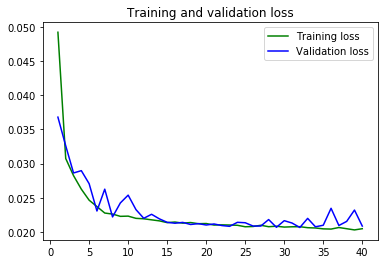

In [17]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.figure()
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [18]:
print('Train MAE = %f\nValidation MAE = %f' % ((train_loss[-1] * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (val_loss[-1] * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 2.176307
Validation MAE = 2.217082


In [ ]:
as5_train_preds = model.predict_generator(gen_train, workers=4, use_multiprocessing=True)
as5_train_preds.shape

In [ ]:
as5_val_preds = model.predict_generator(gen_val, workers=4, use_multiprocessing=True)
as5_val_preds.shape

In [ ]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(lookback, as5_train_split.shape[0]), as5_train_preds.flatten(), color='green', alpha=.5, label='train rnn')
plt.plot(range(20000 + lookback, 20000 + as5_val_split.shape[0]), as5_val_preds.flatten(), color='green', alpha=.5, label='train rnn', linestyle=':')
plt.title('PWM Data vs Predictions')
plt.legend()

In [ ]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(500), as5_train_data[:500, 0], label='PWM_30min_avg')
plt.plot(range(lookback, 500), as5_train_preds[:500 - lookback, :].flatten(), color='green', alpha=.5, label='rnn')
plt.title('PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1100, 1300), as5_train_data[1100:1300, 0], label='PWM_30min_avg')
plt.plot(range(1100, 1300), as5_train_preds[1100 - lookback:1300 - lookback].flatten(), color='green', alpha=.5, label='rnn')
plt.title('PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(1300, 1400), as5_train_data[1300:1400, 0], label='PWM_30min_avg')
plt.plot(range(1300, 1400), as5_train_preds[1300 - lookback:1400 - lookback].flatten(), color='green', alpha=.5, label='rnn')
plt.title('PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(1400, 1450), as5_train_data[1400:1450, 0], label='PWM_30min_avg')
plt.plot(range(1400, 1450), as5_train_preds[1400 - lookback:1450 - lookback].flatten(), color='green', alpha=.5, label='rnn')
plt.plot(range(1401, 1451), as5_train_data[1400:1450, 0], color='black', alpha=.5, label='locf', linestyle=':')
plt.title('PWM Data vs Predictions')
plt.legend()

In [19]:
model.save('base-rnn-nomask-val.h5')

## Base RNN Model with Mask

In [20]:
model = Sequential()
model.add(layers.Masking(mask_value=-1, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.GRU(16, ))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [21]:
t1 = datetime.datetime.now()
history_mask = model.fit_generator(generator=gen_train, epochs=80,
                                   validation_data=gen_val,
                                   workers=4, use_multiprocessing=True, shuffle=True)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/40


  1/155 [..............................] - ETA: 1:44 - loss: 0.2801 - mean_absolute_percentage_error: 90.5653

  2/155 [..............................] - ETA: 1:07 - loss: 0.2189 - mean_absolute_percentage_error: 82.1408

  3/155 [..............................] - ETA: 53s - loss: 0.2219 - mean_absolute_percentage_error: 77.9983 

  4/155 [..............................] - ETA: 47s - loss: 0.4486 - mean_absolute_percentage_error: 86.7160

  5/155 [..............................] - ETA: 42s - loss: 0.3909 - mean_absolute_percentage_error: 84.1636

  6/155 [>.............................] - ETA: 40s - loss: 0.3612 - mean_absolute_percentage_error: 79.9374

  7/155 [>.............................] - ETA: 38s - loss: 0.3331 - mean_absolute_percentage_error: 76.6324

  8/155 [>.............................] - ETA: 36s - loss: 0.3023 - mean_absolute_percentage_error: 71.8348

  9/155 [>.............................] - ETA: 35s - loss: 0.2815 - mean_absolute_percentage_error: 68.3286

 10/155 [>.............................] - ETA: 34s - loss: 0.2612 - mean_absolute_percentage_error: 64.4056

 11/155 [=>............................] - ETA: 33s - loss: 0.2509 - mean_absolute_percentage_error: 62.2700

 12/155 [=>............................] - ETA: 32s - loss: 0.2367 - mean_absolute_percentage_error: 59.6076

 13/155 [=>............................] - ETA: 31s - loss: 0.2239 - mean_absolute_percentage_error: 57.0737

 14/155 [=>............................] - ETA: 31s - loss: 0.2106 - mean_absolute_percentage_error: 56.0879

 15/155 [=>............................] - ETA: 30s - loss: 0.2003 - mean_absolute_percentage_error: 53.7170



 16/155 [==>...........................] - ETA: 30s - loss: 0.1920 - mean_absolute_percentage_error: 51.6255

 17/155 [==>...........................] - ETA: 29s - loss: 0.1874 - mean_absolute_percentage_error: 51.0239

 18/155 [==>...........................] - ETA: 29s - loss: 0.1817 - mean_absolute_percentage_error: 50.5099

 19/155 [==>...........................] - ETA: 28s - loss: 0.1755 - mean_absolute_percentage_error: 50.5457

 20/155 [==>...........................] - ETA: 28s - loss: 0.1686 - mean_absolute_percentage_error: 50.4296

 21/155 [===>..........................] - ETA: 27s - loss: 0.1633 - mean_absolute_percentage_error: 49.1164

 22/155 [===>..........................] - ETA: 27s - loss: 0.1576 - mean_absolute_percentage_error: 48.4224

 23/155 [===>..........................] - ETA: 26s - loss: 0.1571 - mean_absolute_percentage_error: 47.9263

 24/155 [===>..........................] - ETA: 26s - loss: 0.1528 - mean_absolute_percentage_error: 47.8202

 25/155 [===>..........................] - ETA: 26s - loss: 0.1504 - mean_absolute_percentage_error: 47.9399

 26/155 [====>.........................] - ETA: 25s - loss: 0.1457 - mean_absolute_percentage_error: 46.9378

 27/155 [====>.........................] - ETA: 25s - loss: 0.1422 - mean_absolute_percentage_error: 46.0733

 28/155 [====>.........................] - ETA: 24s - loss: 0.1387 - mean_absolute_percentage_error: 45.7164

 29/155 [====>.........................] - ETA: 24s - loss: 0.1357 - mean_absolute_percentage_error: 44.9385

 30/155 [====>.........................] - ETA: 24s - loss: 0.1361 - mean_absolute_percentage_error: 44.3374

 31/155 [=====>........................] - ETA: 24s - loss: 0.1344 - mean_absolute_percentage_error: 43.8848

 32/155 [=====>........................] - ETA: 23s - loss: 0.1322 - mean_absolute_percentage_error: 43.6557

 33/155 [=====>........................] - ETA: 23s - loss: 0.1313 - mean_absolute_percentage_error: 43.2928

 34/155 [=====>........................] - ETA: 23s - loss: 0.1378 - mean_absolute_percentage_error: 43.8408

 35/155 [=====>........................] - ETA: 22s - loss: 0.1356 - mean_absolute_percentage_error: 43.3779

 36/155 [=====>........................] - ETA: 22s - loss: 0.1331 - mean_absolute_percentage_error: 44.2208

 37/155 [======>.......................] - ETA: 22s - loss: 0.1304 - mean_absolute_percentage_error: 43.6519

 38/155 [======>.......................] - ETA: 22s - loss: 0.1290 - mean_absolute_percentage_error: 43.4934

 39/155 [======>.......................] - ETA: 21s - loss: 0.1275 - mean_absolute_percentage_error: 43.0277

 40/155 [======>.......................] - ETA: 21s - loss: 0.1246 - mean_absolute_percentage_error: 42.4240

 41/155 [======>.......................] - ETA: 21s - loss: 0.1226 - mean_absolute_percentage_error: 42.2236

 42/155 [=======>......................] - ETA: 21s - loss: 0.1216 - mean_absolute_percentage_error: 42.0059

 43/155 [=======>......................] - ETA: 20s - loss: 0.1196 - mean_absolute_percentage_error: 41.5210

 44/155 [=======>......................] - ETA: 20s - loss: 0.1177 - mean_absolute_percentage_error: 41.3082

 45/155 [=======>......................] - ETA: 20s - loss: 0.1186 - mean_absolute_percentage_error: 41.3331

 46/155 [=======>......................] - ETA: 20s - loss: 0.1175 - mean_absolute_percentage_error: 41.1238

 47/155 [========>.....................] - ETA: 19s - loss: 0.1159 - mean_absolute_percentage_error: 40.6979

 48/155 [========>.....................] - ETA: 19s - loss: 0.1145 - mean_absolute_percentage_error: 40.4809

 49/155 [========>.....................] - ETA: 19s - loss: 0.1138 - mean_absolute_percentage_error: 40.2705

 50/155 [========>.....................] - ETA: 19s - loss: 0.1128 - mean_absolute_percentage_error: 40.5305

 51/155 [========>.....................] - ETA: 19s - loss: 0.1116 - mean_absolute_percentage_error: 40.3754

 52/155 [=========>....................] - ETA: 18s - loss: 0.1289 - mean_absolute_percentage_error: 41.5421

 53/155 [=========>....................] - ETA: 18s - loss: 0.1279 - mean_absolute_percentage_error: 42.0823

 54/155 [=========>....................] - ETA: 18s - loss: 0.1269 - mean_absolute_percentage_error: 41.9363

 55/155 [=========>....................] - ETA: 18s - loss: 0.1251 - mean_absolute_percentage_error: 41.5675

 56/155 [=========>....................] - ETA: 17s - loss: 0.1240 - mean_absolute_percentage_error: 41.4262

 57/155 [==========>...................] - ETA: 17s - loss: 0.1233 - mean_absolute_percentage_error: 41.3892

 58/155 [==========>...................] - ETA: 17s - loss: 0.1220 - mean_absolute_percentage_error: 41.0451

 59/155 [==========>...................] - ETA: 17s - loss: 0.1341 - mean_absolute_percentage_error: 41.7782

 60/155 [==========>...................] - ETA: 17s - loss: 0.1325 - mean_absolute_percentage_error: 41.3750

 61/155 [==========>...................] - ETA: 16s - loss: 0.1309 - mean_absolute_percentage_error: 41.0306

 62/155 [===========>..................] - ETA: 16s - loss: 0.1295 - mean_absolute_percentage_error: 40.8549

 63/155 [===========>..................] - ETA: 16s - loss: 0.1286 - mean_absolute_percentage_error: 40.5755

 64/155 [===========>..................] - ETA: 16s - loss: 0.1270 - mean_absolute_percentage_error: 40.6840

 65/155 [===========>..................] - ETA: 16s - loss: 0.1256 - mean_absolute_percentage_error: 40.4663

 66/155 [===========>..................] - ETA: 15s - loss: 0.1255 - mean_absolute_percentage_error: 40.4151

 67/155 [===========>..................] - ETA: 15s - loss: 0.1240 - mean_absolute_percentage_error: 40.1626

 68/155 [============>.................] - ETA: 15s - loss: 0.1347 - mean_absolute_percentage_error: 40.8242

 69/155 [============>.................] - ETA: 15s - loss: 0.1382 - mean_absolute_percentage_error: 40.9359

 70/155 [============>.................] - ETA: 15s - loss: 0.1374 - mean_absolute_percentage_error: 40.8686

 71/155 [============>.................] - ETA: 14s - loss: 0.1361 - mean_absolute_percentage_error: 40.6799

 72/155 [============>.................] - ETA: 14s - loss: 0.1398 - mean_absolute_percentage_error: 40.8611

 73/155 [=============>................] - ETA: 14s - loss: 0.1387 - mean_absolute_percentage_error: 40.6449

 74/155 [=============>................] - ETA: 14s - loss: 0.1376 - mean_absolute_percentage_error: 40.4939

 75/155 [=============>................] - ETA: 14s - loss: 0.1366 - mean_absolute_percentage_error: 40.3492

 76/155 [=============>................] - ETA: 14s - loss: 0.1355 - mean_absolute_percentage_error: 40.1891

 77/155 [=============>................] - ETA: 13s - loss: 0.1340 - mean_absolute_percentage_error: 39.8986

 78/155 [==============>...............] - ETA: 13s - loss: 0.1332 - mean_absolute_percentage_error: 39.7439

 79/155 [==============>...............] - ETA: 13s - loss: 0.1322 - mean_absolute_percentage_error: 39.7101

 80/155 [==============>...............] - ETA: 13s - loss: 0.1309 - mean_absolute_percentage_error: 39.5020

 81/155 [==============>...............] - ETA: 13s - loss: 0.1296 - mean_absolute_percentage_error: 39.2164

 82/155 [==============>...............] - ETA: 12s - loss: 0.1292 - mean_absolute_percentage_error: 39.1841

 83/155 [===============>..............] - ETA: 12s - loss: 0.1279 - mean_absolute_percentage_error: 38.9155

 84/155 [===============>..............] - ETA: 12s - loss: 0.1269 - mean_absolute_percentage_error: 38.7137

 85/155 [===============>..............] - ETA: 12s - loss: 0.1260 - mean_absolute_percentage_error: 38.6060

 86/155 [===============>..............] - ETA: 12s - loss: 0.1251 - mean_absolute_percentage_error: 38.7621

 87/155 [===============>..............] - ETA: 11s - loss: 0.1241 - mean_absolute_percentage_error: 38.5642

 88/155 [================>.............] - ETA: 11s - loss: 0.1235 - mean_absolute_percentage_error: 38.4188

 89/155 [================>.............] - ETA: 11s - loss: 0.1228 - mean_absolute_percentage_error: 38.3604

 90/155 [================>.............] - ETA: 11s - loss: 0.1219 - mean_absolute_percentage_error: 38.2835

 91/155 [================>.............] - ETA: 11s - loss: 0.1210 - mean_absolute_percentage_error: 38.1167

 92/155 [================>.............] - ETA: 11s - loss: 0.1204 - mean_absolute_percentage_error: 38.0176

 93/155 [=================>............] - ETA: 10s - loss: 0.1194 - mean_absolute_percentage_error: 37.8572

 94/155 [=================>............] - ETA: 10s - loss: 0.1185 - mean_absolute_percentage_error: 37.7381

 95/155 [=================>............] - ETA: 10s - loss: 0.1177 - mean_absolute_percentage_error: 37.5697

 96/155 [=================>............] - ETA: 10s - loss: 0.1167 - mean_absolute_percentage_error: 37.3588

 97/155 [=================>............] - ETA: 10s - loss: 0.1158 - mean_absolute_percentage_error: 37.1774

 98/155 [=================>............] - ETA: 9s - loss: 0.1149 - mean_absolute_percentage_error: 37.0312 

 99/155 [==================>...........] - ETA: 9s - loss: 0.1155 - mean_absolute_percentage_error: 36.9792

100/155 [==================>...........] - ETA: 9s - loss: 0.1147 - mean_absolute_percentage_error: 37.0075

101/155 [==================>...........] - ETA: 9s - loss: 0.1139 - mean_absolute_percentage_error: 36.8579

102/155 [==================>...........] - ETA: 9s - loss: 0.1131 - mean_absolute_percentage_error: 36.7264

103/155 [==================>...........] - ETA: 9s - loss: 0.1124 - mean_absolute_percentage_error: 36.5632

104/155 [===================>..........] - ETA: 8s - loss: 0.1118 - mean_absolute_percentage_error: 36.4457

105/155 [===================>..........] - ETA: 8s - loss: 0.1110 - mean_absolute_percentage_error: 36.4215

106/155 [===================>..........] - ETA: 8s - loss: 0.1104 - mean_absolute_percentage_error: 36.3234

107/155 [===================>..........] - ETA: 8s - loss: 0.1100 - mean_absolute_percentage_error: 36.2173

108/155 [===================>..........] - ETA: 8s - loss: 0.1093 - mean_absolute_percentage_error: 36.0933

109/155 [====================>.........] - ETA: 8s - loss: 0.1086 - mean_absolute_percentage_error: 35.9443

110/155 [====================>.........] - ETA: 7s - loss: 0.1082 - mean_absolute_percentage_error: 35.8664

111/155 [====================>.........] - ETA: 7s - loss: 0.1075 - mean_absolute_percentage_error: 35.7082

112/155 [====================>.........] - ETA: 7s - loss: 0.1068 - mean_absolute_percentage_error: 35.5692

113/155 [====================>.........] - ETA: 7s - loss: 0.1066 - mean_absolute_percentage_error: 35.5111

114/155 [=====================>........] - ETA: 7s - loss: 0.1061 - mean_absolute_percentage_error: 35.4528

115/155 [=====================>........] - ETA: 6s - loss: 0.1054 - mean_absolute_percentage_error: 35.2837

116/155 [=====================>........] - ETA: 6s - loss: 0.1048 - mean_absolute_percentage_error: 35.2727

117/155 [=====================>........] - ETA: 6s - loss: 0.1044 - mean_absolute_percentage_error: 35.2487

118/155 [=====================>........] - ETA: 6s - loss: 0.1038 - mean_absolute_percentage_error: 35.1294

119/155 [======================>.......] - ETA: 6s - loss: 0.1150 - mean_absolute_percentage_error: 36.0355

120/155 [======================>.......] - ETA: 6s - loss: 0.1224 - mean_absolute_percentage_error: 36.5719

121/155 [======================>.......] - ETA: 5s - loss: 0.1216 - mean_absolute_percentage_error: 36.4233

122/155 [======================>.......] - ETA: 5s - loss: 0.1211 - mean_absolute_percentage_error: 36.3282

123/155 [======================>.......] - ETA: 5s - loss: 0.1204 - mean_absolute_percentage_error: 36.2859

124/155 [=======================>......] - ETA: 5s - loss: 0.1198 - mean_absolute_percentage_error: 36.1769

125/155 [=======================>......] - ETA: 5s - loss: 0.1193 - mean_absolute_percentage_error: 36.0855

126/155 [=======================>......] - ETA: 5s - loss: 0.1263 - mean_absolute_percentage_error: 36.5965

127/155 [=======================>......] - ETA: 4s - loss: 0.1256 - mean_absolute_percentage_error: 36.4660

128/155 [=======================>......] - ETA: 4s - loss: 0.1324 - mean_absolute_percentage_error: 36.9640

129/155 [=======================>......] - ETA: 4s - loss: 0.1317 - mean_absolute_percentage_error: 36.8323

130/155 [========================>.....] - ETA: 4s - loss: 0.1311 - mean_absolute_percentage_error: 36.7168

131/155 [========================>.....] - ETA: 4s - loss: 0.1303 - mean_absolute_percentage_error: 36.5979

132/155 [========================>.....] - ETA: 3s - loss: 0.1296 - mean_absolute_percentage_error: 36.4521

133/155 [========================>.....] - ETA: 3s - loss: 0.1290 - mean_absolute_percentage_error: 36.3590

134/155 [========================>.....] - ETA: 3s - loss: 0.1283 - mean_absolute_percentage_error: 36.2650

135/155 [=========================>....] - ETA: 3s - loss: 0.1276 - mean_absolute_percentage_error: 36.2233

136/155 [=========================>....] - ETA: 3s - loss: 0.1271 - mean_absolute_percentage_error: 36.1494

137/155 [=========================>....] - ETA: 3s - loss: 0.1264 - mean_absolute_percentage_error: 36.0405

138/155 [=========================>....] - ETA: 2s - loss: 0.1334 - mean_absolute_percentage_error: 36.5768

139/155 [=========================>....] - ETA: 2s - loss: 0.1328 - mean_absolute_percentage_error: 36.5083

140/155 [==========================>...] - ETA: 2s - loss: 0.1320 - mean_absolute_percentage_error: 36.3478

141/155 [==========================>...] - ETA: 2s - loss: 0.1313 - mean_absolute_percentage_error: 36.2213

142/155 [==========================>...] - ETA: 2s - loss: 0.1305 - mean_absolute_percentage_error: 36.1315

143/155 [==========================>...] - ETA: 2s - loss: 0.1300 - mean_absolute_percentage_error: 36.0742

144/155 [==========================>...] - ETA: 1s - loss: 0.1293 - mean_absolute_percentage_error: 36.0014

145/155 [===========================>..] - ETA: 1s - loss: 0.1287 - mean_absolute_percentage_error: 35.9129

146/155 [===========================>..] - ETA: 1s - loss: 0.1282 - mean_absolute_percentage_error: 35.8423

147/155 [===========================>..] - ETA: 1s - loss: 0.1276 - mean_absolute_percentage_error: 35.7288

148/155 [===========================>..] - ETA: 1s - loss: 0.1271 - mean_absolute_percentage_error: 35.6550

149/155 [===========================>..] - ETA: 1s - loss: 0.1266 - mean_absolute_percentage_error: 35.5760

150/155 [============================>.] - ETA: 0s - loss: 0.1261 - mean_absolute_percentage_error: 35.5125

151/155 [============================>.] - ETA: 0s - loss: 0.1317 - mean_absolute_percentage_error: 35.9392

152/155 [============================>.] - ETA: 0s - loss: 0.1311 - mean_absolute_percentage_error: 35.8762

153/155 [============================>.] - ETA: 0s - loss: 0.1305 - mean_absolute_percentage_error: 35.7708

154/155 [============================>.] - ETA: 0s - loss: 0.1303 - mean_absolute_percentage_error: 35.7055

155/155 [==============================] - 31s 201ms/step - loss: 0.1297 - mean_absolute_percentage_error: 35.6084 - val_loss: 0.0605 - val_mean_absolute_percentage_error: 22.9805


Epoch 2/40
  1/155 [..............................] - ETA: 27s - loss: 1.0010 - mean_absolute_percentage_error: 100.1008

  2/155 [..............................] - ETA: 26s - loss: 0.5253 - mean_absolute_percentage_error: 61.3408 

  3/155 [..............................] - ETA: 26s - loss: 0.3656 - mean_absolute_percentage_error: 53.5557

  4/155 [..............................] - ETA: 25s - loss: 0.2847 - mean_absolute_percentage_error: 45.9790

  5/155 [..............................] - ETA: 25s - loss: 0.2341 - mean_absolute_percentage_error: 40.7522

  6/155 [>.............................] - ETA: 25s - loss: 0.2027 - mean_absolute_percentage_error: 37.1898

  7/155 [>.............................] - ETA: 25s - loss: 0.1780 - mean_absolute_percentage_error: 35.0457

  8/155 [>.............................] - ETA: 24s - loss: 0.1589 - mean_absolute_percentage_error: 33.2103

  9/155 [>.............................] - ETA: 24s - loss: 0.1439 - mean_absolute_percentage_error: 31.9768

 10/155 [>.............................] - ETA: 24s - loss: 0.1319 - mean_absolute_percentage_error: 30.4710

 11/155 [=>............................] - ETA: 24s - loss: 0.1223 - mean_absolute_percentage_error: 30.1705

 12/155 [=>............................] - ETA: 24s - loss: 0.1164 - mean_absolute_percentage_error: 29.7112

 13/155 [=>............................] - ETA: 23s - loss: 0.1104 - mean_absolute_percentage_error: 29.3155

 14/155 [=>............................] - ETA: 23s - loss: 0.1055 - mean_absolute_percentage_error: 28.7058

 15/155 [=>............................] - ETA: 23s - loss: 0.1025 - mean_absolute_percentage_error: 28.4707

 16/155 [==>...........................] - ETA: 23s - loss: 0.0987 - mean_absolute_percentage_error: 28.0518

 17/155 [==>...........................] - ETA: 23s - loss: 0.0955 - mean_absolute_percentage_error: 27.6221

 18/155 [==>...........................] - ETA: 23s - loss: 0.0936 - mean_absolute_percentage_error: 27.4501

 19/155 [==>...........................] - ETA: 22s - loss: 0.0901 - mean_absolute_percentage_error: 27.2497

 20/155 [==>...........................] - ETA: 22s - loss: 0.0869 - mean_absolute_percentage_error: 27.0291

 21/155 [===>..........................] - ETA: 22s - loss: 0.0844 - mean_absolute_percentage_error: 26.9325

 22/155 [===>..........................] - ETA: 22s - loss: 0.0855 - mean_absolute_percentage_error: 26.8546

 23/155 [===>..........................] - ETA: 22s - loss: 0.0834 - mean_absolute_percentage_error: 26.4257

 24/155 [===>..........................] - ETA: 21s - loss: 0.0809 - mean_absolute_percentage_error: 25.9240

 25/155 [===>..........................] - ETA: 21s - loss: 0.1176 - mean_absolute_percentage_error: 28.8799

 26/155 [====>.........................] - ETA: 21s - loss: 0.1146 - mean_absolute_percentage_error: 28.5641

 27/155 [====>.........................] - ETA: 21s - loss: 0.1116 - mean_absolute_percentage_error: 28.5203

 28/155 [====>.........................] - ETA: 21s - loss: 0.1093 - mean_absolute_percentage_error: 28.2451

 29/155 [====>.........................] - ETA: 21s - loss: 0.1071 - mean_absolute_percentage_error: 28.1536

 30/155 [====>.........................] - ETA: 20s - loss: 0.1046 - mean_absolute_percentage_error: 27.9022

 31/155 [=====>........................] - ETA: 20s - loss: 0.1024 - mean_absolute_percentage_error: 27.7140

 32/155 [=====>........................] - ETA: 20s - loss: 0.1009 - mean_absolute_percentage_error: 27.5189

 33/155 [=====>........................] - ETA: 20s - loss: 0.0988 - mean_absolute_percentage_error: 27.1599

 34/155 [=====>........................] - ETA: 20s - loss: 0.0968 - mean_absolute_percentage_error: 27.0944

 35/155 [=====>........................] - ETA: 20s - loss: 0.0953 - mean_absolute_percentage_error: 27.0646

 36/155 [=====>........................] - ETA: 19s - loss: 0.0935 - mean_absolute_percentage_error: 27.1888

 37/155 [======>.......................] - ETA: 19s - loss: 0.0918 - mean_absolute_percentage_error: 27.2724

 38/155 [======>.......................] - ETA: 19s - loss: 0.1150 - mean_absolute_percentage_error: 29.1821

 39/155 [======>.......................] - ETA: 19s - loss: 0.1131 - mean_absolute_percentage_error: 29.0021

 40/155 [======>.......................] - ETA: 19s - loss: 0.1108 - mean_absolute_percentage_error: 28.7540

 41/155 [======>.......................] - ETA: 19s - loss: 0.1088 - mean_absolute_percentage_error: 28.4659

 42/155 [=======>......................] - ETA: 18s - loss: 0.1155 - mean_absolute_percentage_error: 28.9582

 43/155 [=======>......................] - ETA: 18s - loss: 0.1139 - mean_absolute_percentage_error: 29.3321

 44/155 [=======>......................] - ETA: 18s - loss: 0.1119 - mean_absolute_percentage_error: 28.9980

 45/155 [=======>......................] - ETA: 18s - loss: 0.1103 - mean_absolute_percentage_error: 28.7537

 46/155 [=======>......................] - ETA: 18s - loss: 0.1087 - mean_absolute_percentage_error: 28.5261

 47/155 [========>.....................] - ETA: 18s - loss: 0.1073 - mean_absolute_percentage_error: 28.3252

 48/155 [========>.....................] - ETA: 17s - loss: 0.1057 - mean_absolute_percentage_error: 28.1341

 49/155 [========>.....................] - ETA: 17s - loss: 0.1043 - mean_absolute_percentage_error: 27.8969

 50/155 [========>.....................] - ETA: 17s - loss: 0.1028 - mean_absolute_percentage_error: 27.7943

 51/155 [========>.....................] - ETA: 17s - loss: 0.1020 - mean_absolute_percentage_error: 27.7015

 52/155 [=========>....................] - ETA: 17s - loss: 0.1005 - mean_absolute_percentage_error: 27.6353

 53/155 [=========>....................] - ETA: 16s - loss: 0.0994 - mean_absolute_percentage_error: 27.4949

 54/155 [=========>....................] - ETA: 16s - loss: 0.1181 - mean_absolute_percentage_error: 29.0387

 55/155 [=========>....................] - ETA: 16s - loss: 0.1164 - mean_absolute_percentage_error: 28.8656

 56/155 [=========>....................] - ETA: 16s - loss: 0.1147 - mean_absolute_percentage_error: 28.5814

 57/155 [==========>...................] - ETA: 16s - loss: 0.1134 - mean_absolute_percentage_error: 28.4798

 58/155 [==========>...................] - ETA: 16s - loss: 0.1139 - mean_absolute_percentage_error: 28.4138

 59/155 [==========>...................] - ETA: 15s - loss: 0.1124 - mean_absolute_percentage_error: 28.2653

 60/155 [==========>...................] - ETA: 15s - loss: 0.1114 - mean_absolute_percentage_error: 28.0987

 61/155 [==========>...................] - ETA: 15s - loss: 0.1098 - mean_absolute_percentage_error: 28.1166

 62/155 [===========>..................] - ETA: 15s - loss: 0.1084 - mean_absolute_percentage_error: 27.9864

 63/155 [===========>..................] - ETA: 15s - loss: 0.1072 - mean_absolute_percentage_error: 27.8035

 64/155 [===========>..................] - ETA: 15s - loss: 0.1062 - mean_absolute_percentage_error: 27.6492

 65/155 [===========>..................] - ETA: 14s - loss: 0.1054 - mean_absolute_percentage_error: 27.5963

 66/155 [===========>..................] - ETA: 14s - loss: 0.1043 - mean_absolute_percentage_error: 27.4249

 67/155 [===========>..................] - ETA: 14s - loss: 0.1236 - mean_absolute_percentage_error: 29.0997

 68/155 [============>.................] - ETA: 14s - loss: 0.1222 - mean_absolute_percentage_error: 28.9424

 69/155 [============>.................] - ETA: 14s - loss: 0.1211 - mean_absolute_percentage_error: 28.8064

 70/155 [============>.................] - ETA: 14s - loss: 0.1198 - mean_absolute_percentage_error: 28.7738

 71/155 [============>.................] - ETA: 13s - loss: 0.1186 - mean_absolute_percentage_error: 28.5655

 72/155 [============>.................] - ETA: 13s - loss: 0.1173 - mean_absolute_percentage_error: 28.4299

 73/155 [=============>................] - ETA: 13s - loss: 0.1162 - mean_absolute_percentage_error: 28.2799

 74/155 [=============>................] - ETA: 13s - loss: 0.1149 - mean_absolute_percentage_error: 28.2648

 75/155 [=============>................] - ETA: 13s - loss: 0.1139 - mean_absolute_percentage_error: 28.1318

 76/155 [=============>................] - ETA: 13s - loss: 0.1127 - mean_absolute_percentage_error: 27.9272

 77/155 [=============>................] - ETA: 12s - loss: 0.1115 - mean_absolute_percentage_error: 27.7288

 78/155 [==============>...............] - ETA: 12s - loss: 0.1104 - mean_absolute_percentage_error: 27.5370

 79/155 [==============>...............] - ETA: 12s - loss: 0.1095 - mean_absolute_percentage_error: 27.4422

 80/155 [==============>...............] - ETA: 12s - loss: 0.1082 - mean_absolute_percentage_error: 27.2254

 81/155 [==============>...............] - ETA: 12s - loss: 0.1071 - mean_absolute_percentage_error: 27.0638

 82/155 [==============>...............] - ETA: 12s - loss: 0.1061 - mean_absolute_percentage_error: 26.9037

 83/155 [===============>..............] - ETA: 11s - loss: 0.1052 - mean_absolute_percentage_error: 26.7375

 84/155 [===============>..............] - ETA: 11s - loss: 0.1043 - mean_absolute_percentage_error: 26.6507

 85/155 [===============>..............] - ETA: 11s - loss: 0.1035 - mean_absolute_percentage_error: 26.5516

 86/155 [===============>..............] - ETA: 11s - loss: 0.1026 - mean_absolute_percentage_error: 26.4570

 87/155 [===============>..............] - ETA: 11s - loss: 0.1019 - mean_absolute_percentage_error: 26.3725

 88/155 [================>.............] - ETA: 11s - loss: 0.1010 - mean_absolute_percentage_error: 26.2459

 89/155 [================>.............] - ETA: 10s - loss: 0.1001 - mean_absolute_percentage_error: 26.1137

 90/155 [================>.............] - ETA: 10s - loss: 0.0993 - mean_absolute_percentage_error: 25.9674

 91/155 [================>.............] - ETA: 10s - loss: 0.0985 - mean_absolute_percentage_error: 25.8664

 92/155 [================>.............] - ETA: 10s - loss: 0.0977 - mean_absolute_percentage_error: 25.7295

 93/155 [=================>............] - ETA: 10s - loss: 0.0969 - mean_absolute_percentage_error: 25.6040

 94/155 [=================>............] - ETA: 10s - loss: 0.1099 - mean_absolute_percentage_error: 26.7313

 95/155 [=================>............] - ETA: 9s - loss: 0.1090 - mean_absolute_percentage_error: 26.6530 

 96/155 [=================>............] - ETA: 9s - loss: 0.1084 - mean_absolute_percentage_error: 26.5825

 97/155 [=================>............] - ETA: 9s - loss: 0.1076 - mean_absolute_percentage_error: 26.4493

 98/155 [=================>............] - ETA: 9s - loss: 0.1067 - mean_absolute_percentage_error: 26.3189

 99/155 [==================>...........] - ETA: 9s - loss: 0.1060 - mean_absolute_percentage_error: 26.2064

100/155 [==================>...........] - ETA: 9s - loss: 0.1053 - mean_absolute_percentage_error: 26.1109

101/155 [==================>...........] - ETA: 8s - loss: 0.1047 - mean_absolute_percentage_error: 26.0160

102/155 [==================>...........] - ETA: 8s - loss: 0.1039 - mean_absolute_percentage_error: 25.8971

103/155 [==================>...........] - ETA: 8s - loss: 0.1045 - mean_absolute_percentage_error: 25.8964

104/155 [===================>..........] - ETA: 8s - loss: 0.1036 - mean_absolute_percentage_error: 25.7654

105/155 [===================>..........] - ETA: 8s - loss: 0.1029 - mean_absolute_percentage_error: 25.6542

106/155 [===================>..........] - ETA: 8s - loss: 0.1021 - mean_absolute_percentage_error: 25.5887

107/155 [===================>..........] - ETA: 7s - loss: 0.1017 - mean_absolute_percentage_error: 25.5152

108/155 [===================>..........] - ETA: 7s - loss: 0.1010 - mean_absolute_percentage_error: 25.5044

109/155 [====================>.........] - ETA: 7s - loss: 0.1013 - mean_absolute_percentage_error: 25.5431

110/155 [====================>.........] - ETA: 7s - loss: 0.1006 - mean_absolute_percentage_error: 25.4544

111/155 [====================>.........] - ETA: 7s - loss: 0.0999 - mean_absolute_percentage_error: 25.3384

112/155 [====================>.........] - ETA: 7s - loss: 0.0992 - mean_absolute_percentage_error: 25.2592

113/155 [====================>.........] - ETA: 6s - loss: 0.1038 - mean_absolute_percentage_error: 25.5749

114/155 [=====================>........] - ETA: 6s - loss: 0.1116 - mean_absolute_percentage_error: 26.2216

115/155 [=====================>........] - ETA: 6s - loss: 0.1111 - mean_absolute_percentage_error: 26.1741

116/155 [=====================>........] - ETA: 6s - loss: 0.1104 - mean_absolute_percentage_error: 26.1507

117/155 [=====================>........] - ETA: 6s - loss: 0.1099 - mean_absolute_percentage_error: 26.0673

118/155 [=====================>........] - ETA: 6s - loss: 0.1091 - mean_absolute_percentage_error: 25.9764

119/155 [======================>.......] - ETA: 5s - loss: 0.1085 - mean_absolute_percentage_error: 25.8798

120/155 [======================>.......] - ETA: 5s - loss: 0.1079 - mean_absolute_percentage_error: 25.8288

121/155 [======================>.......] - ETA: 5s - loss: 0.1096 - mean_absolute_percentage_error: 25.9638

122/155 [======================>.......] - ETA: 5s - loss: 0.1089 - mean_absolute_percentage_error: 25.8632

123/155 [======================>.......] - ETA: 5s - loss: 0.1082 - mean_absolute_percentage_error: 25.7945

124/155 [=======================>......] - ETA: 5s - loss: 0.1076 - mean_absolute_percentage_error: 25.7198

125/155 [=======================>......] - ETA: 4s - loss: 0.1069 - mean_absolute_percentage_error: 25.6913

126/155 [=======================>......] - ETA: 4s - loss: 0.1068 - mean_absolute_percentage_error: 25.6702

127/155 [=======================>......] - ETA: 4s - loss: 0.1089 - mean_absolute_percentage_error: 25.8291

128/155 [=======================>......] - ETA: 4s - loss: 0.1083 - mean_absolute_percentage_error: 25.7474

129/155 [=======================>......] - ETA: 4s - loss: 0.1077 - mean_absolute_percentage_error: 25.6546

130/155 [========================>.....] - ETA: 4s - loss: 0.1071 - mean_absolute_percentage_error: 25.5948

131/155 [========================>.....] - ETA: 3s - loss: 0.1065 - mean_absolute_percentage_error: 25.5110

132/155 [========================>.....] - ETA: 3s - loss: 0.1061 - mean_absolute_percentage_error: 25.5372

133/155 [========================>.....] - ETA: 3s - loss: 0.1055 - mean_absolute_percentage_error: 25.4533

134/155 [========================>.....] - ETA: 3s - loss: 0.1050 - mean_absolute_percentage_error: 25.3671

135/155 [=========================>....] - ETA: 3s - loss: 0.1045 - mean_absolute_percentage_error: 25.2986

136/155 [=========================>....] - ETA: 3s - loss: 0.1039 - mean_absolute_percentage_error: 25.2342

137/155 [=========================>....] - ETA: 2s - loss: 0.1033 - mean_absolute_percentage_error: 25.1813

138/155 [=========================>....] - ETA: 2s - loss: 0.1028 - mean_absolute_percentage_error: 25.1544

139/155 [=========================>....] - ETA: 2s - loss: 0.1023 - mean_absolute_percentage_error: 25.0819

140/155 [==========================>...] - ETA: 2s - loss: 0.1086 - mean_absolute_percentage_error: 25.6111

141/155 [==========================>...] - ETA: 2s - loss: 0.1080 - mean_absolute_percentage_error: 25.5192

142/155 [==========================>...] - ETA: 2s - loss: 0.1074 - mean_absolute_percentage_error: 25.4410

143/155 [==========================>...] - ETA: 1s - loss: 0.1069 - mean_absolute_percentage_error: 25.4018

144/155 [==========================>...] - ETA: 1s - loss: 0.1063 - mean_absolute_percentage_error: 25.3033

145/155 [===========================>..] - ETA: 1s - loss: 0.1058 - mean_absolute_percentage_error: 25.2474

146/155 [===========================>..] - ETA: 1s - loss: 0.1052 - mean_absolute_percentage_error: 25.1747

147/155 [===========================>..] - ETA: 1s - loss: 0.1049 - mean_absolute_percentage_error: 25.1881

148/155 [===========================>..] - ETA: 1s - loss: 0.1044 - mean_absolute_percentage_error: 25.1293

149/155 [===========================>..] - ETA: 0s - loss: 0.1039 - mean_absolute_percentage_error: 25.0547

150/155 [============================>.] - ETA: 0s - loss: 0.1066 - mean_absolute_percentage_error: 25.2257

151/155 [============================>.] - ETA: 0s - loss: 0.1060 - mean_absolute_percentage_error: 25.1559

152/155 [============================>.] - ETA: 0s - loss: 0.1055 - mean_absolute_percentage_error: 25.0868

153/155 [============================>.] - ETA: 0s - loss: 0.1050 - mean_absolute_percentage_error: 25.0061

154/155 [============================>.] - ETA: 0s - loss: 0.1045 - mean_absolute_percentage_error: 24.9386

155/155 [==============================] - 30s 195ms/step - loss: 0.1042 - mean_absolute_percentage_error: 24.8970 - val_loss: 0.0454 - val_mean_absolute_percentage_error: 14.6958


Epoch 3/40


  1/155 [..............................] - ETA: 36s - loss: 0.1595 - mean_absolute_percentage_error: 25.7167

  2/155 [..............................] - ETA: 30s - loss: 0.0937 - mean_absolute_percentage_error: 19.9242

  3/155 [..............................] - ETA: 28s - loss: 0.0666 - mean_absolute_percentage_error: 16.8622

  4/155 [..............................] - ETA: 27s - loss: 0.0606 - mean_absolute_percentage_error: 16.8236

  5/155 [..............................] - ETA: 26s - loss: 0.0539 - mean_absolute_percentage_error: 15.7429

  6/155 [>.............................] - ETA: 26s - loss: 0.0490 - mean_absolute_percentage_error: 15.5161

  7/155 [>.............................] - ETA: 25s - loss: 0.0471 - mean_absolute_percentage_error: 15.1776

  8/155 [>.............................] - ETA: 25s - loss: 0.1070 - mean_absolute_percentage_error: 19.8548

  9/155 [>.............................] - ETA: 25s - loss: 0.0974 - mean_absolute_percentage_error: 19.5894

 10/155 [>.............................] - ETA: 24s - loss: 0.1005 - mean_absolute_percentage_error: 20.3225

 11/155 [=>............................] - ETA: 24s - loss: 0.0928 - mean_absolute_percentage_error: 20.1414

 12/155 [=>............................] - ETA: 24s - loss: 0.0872 - mean_absolute_percentage_error: 19.5365

 13/155 [=>............................] - ETA: 24s - loss: 0.0820 - mean_absolute_percentage_error: 18.9250

 14/155 [=>............................] - ETA: 24s - loss: 0.0786 - mean_absolute_percentage_error: 18.5270

 15/155 [=>............................] - ETA: 23s - loss: 0.0752 - mean_absolute_percentage_error: 18.2137

 16/155 [==>...........................] - ETA: 23s - loss: 0.0717 - mean_absolute_percentage_error: 17.9184

 17/155 [==>...........................] - ETA: 23s - loss: 0.0690 - mean_absolute_percentage_error: 17.6600

 18/155 [==>...........................] - ETA: 23s - loss: 0.0662 - mean_absolute_percentage_error: 17.3659

 19/155 [==>...........................] - ETA: 23s - loss: 0.1147 - mean_absolute_percentage_error: 21.6473

 20/155 [==>...........................] - ETA: 22s - loss: 0.1106 - mean_absolute_percentage_error: 21.2294

 21/155 [===>..........................] - ETA: 22s - loss: 0.1066 - mean_absolute_percentage_error: 20.8727

 22/155 [===>..........................] - ETA: 22s - loss: 0.1654 - mean_absolute_percentage_error: 26.2930

 23/155 [===>..........................] - ETA: 22s - loss: 0.1593 - mean_absolute_percentage_error: 26.3957

 24/155 [===>..........................] - ETA: 22s - loss: 0.1542 - mean_absolute_percentage_error: 25.9006

 25/155 [===>..........................] - ETA: 21s - loss: 0.1488 - mean_absolute_percentage_error: 25.2908

 26/155 [====>.........................] - ETA: 21s - loss: 0.1438 - mean_absolute_percentage_error: 24.6802

 27/155 [====>.........................] - ETA: 21s - loss: 0.1521 - mean_absolute_percentage_error: 25.4699

 28/155 [====>.........................] - ETA: 21s - loss: 0.1477 - mean_absolute_percentage_error: 25.1177

 29/155 [====>.........................] - ETA: 21s - loss: 0.1433 - mean_absolute_percentage_error: 24.6395

 30/155 [====>.........................] - ETA: 20s - loss: 0.1393 - mean_absolute_percentage_error: 24.3286

 31/155 [=====>........................] - ETA: 20s - loss: 0.1357 - mean_absolute_percentage_error: 23.9615

 32/155 [=====>........................] - ETA: 20s - loss: 0.1321 - mean_absolute_percentage_error: 23.5961

 33/155 [=====>........................] - ETA: 20s - loss: 0.1285 - mean_absolute_percentage_error: 23.2939

 34/155 [=====>........................] - ETA: 20s - loss: 0.1252 - mean_absolute_percentage_error: 22.9852

 35/155 [=====>........................] - ETA: 20s - loss: 0.1226 - mean_absolute_percentage_error: 22.6584

 36/155 [=====>........................] - ETA: 19s - loss: 0.1201 - mean_absolute_percentage_error: 22.3358

 37/155 [======>.......................] - ETA: 19s - loss: 0.1177 - mean_absolute_percentage_error: 22.3550

 38/155 [======>.......................] - ETA: 19s - loss: 0.1152 - mean_absolute_percentage_error: 22.1064

 39/155 [======>.......................] - ETA: 19s - loss: 0.1127 - mean_absolute_percentage_error: 21.8526

 40/155 [======>.......................] - ETA: 19s - loss: 0.1103 - mean_absolute_percentage_error: 21.6303

 41/155 [======>.......................] - ETA: 19s - loss: 0.1098 - mean_absolute_percentage_error: 21.6208

 42/155 [=======>......................] - ETA: 18s - loss: 0.1306 - mean_absolute_percentage_error: 23.4490

 43/155 [=======>......................] - ETA: 18s - loss: 0.1299 - mean_absolute_percentage_error: 23.3559

 44/155 [=======>......................] - ETA: 18s - loss: 0.1275 - mean_absolute_percentage_error: 23.1598

 45/155 [=======>......................] - ETA: 18s - loss: 0.1253 - mean_absolute_percentage_error: 22.9613

 46/155 [=======>......................] - ETA: 18s - loss: 0.1228 - mean_absolute_percentage_error: 22.9877

 47/155 [========>.....................] - ETA: 18s - loss: 0.1207 - mean_absolute_percentage_error: 22.8770

 48/155 [========>.....................] - ETA: 17s - loss: 0.1187 - mean_absolute_percentage_error: 22.6798

 49/155 [========>.....................] - ETA: 17s - loss: 0.1173 - mean_absolute_percentage_error: 22.8317

 50/155 [========>.....................] - ETA: 17s - loss: 0.1154 - mean_absolute_percentage_error: 22.7690

 51/155 [========>.....................] - ETA: 17s - loss: 0.1135 - mean_absolute_percentage_error: 22.5852

 52/155 [=========>....................] - ETA: 17s - loss: 0.1117 - mean_absolute_percentage_error: 22.3734

 53/155 [=========>....................] - ETA: 17s - loss: 0.1282 - mean_absolute_percentage_error: 23.8044

 54/155 [=========>....................] - ETA: 16s - loss: 0.1269 - mean_absolute_percentage_error: 23.7099

 55/155 [=========>....................] - ETA: 16s - loss: 0.1249 - mean_absolute_percentage_error: 23.4948

 56/155 [=========>....................] - ETA: 16s - loss: 0.1231 - mean_absolute_percentage_error: 23.3080

 57/155 [==========>...................] - ETA: 16s - loss: 0.1217 - mean_absolute_percentage_error: 23.1594

 58/155 [==========>...................] - ETA: 16s - loss: 0.1201 - mean_absolute_percentage_error: 22.9791

 59/155 [==========>...................] - ETA: 16s - loss: 0.1189 - mean_absolute_percentage_error: 22.8704

 60/155 [==========>...................] - ETA: 15s - loss: 0.1173 - mean_absolute_percentage_error: 22.7656

 61/155 [==========>...................] - ETA: 15s - loss: 0.1161 - mean_absolute_percentage_error: 22.6140

 62/155 [===========>..................] - ETA: 15s - loss: 0.1146 - mean_absolute_percentage_error: 22.5000

 63/155 [===========>..................] - ETA: 15s - loss: 0.1132 - mean_absolute_percentage_error: 22.3630

 64/155 [===========>..................] - ETA: 15s - loss: 0.1122 - mean_absolute_percentage_error: 22.2632

 65/155 [===========>..................] - ETA: 15s - loss: 0.1108 - mean_absolute_percentage_error: 22.2630

 66/155 [===========>..................] - ETA: 14s - loss: 0.1096 - mean_absolute_percentage_error: 22.1103

 67/155 [===========>..................] - ETA: 14s - loss: 0.1082 - mean_absolute_percentage_error: 21.9715

 68/155 [============>.................] - ETA: 14s - loss: 0.1070 - mean_absolute_percentage_error: 21.8516

 69/155 [============>.................] - ETA: 14s - loss: 0.1200 - mean_absolute_percentage_error: 23.0116

 70/155 [============>.................] - ETA: 14s - loss: 0.1185 - mean_absolute_percentage_error: 22.9360

 71/155 [============>.................] - ETA: 14s - loss: 0.1172 - mean_absolute_percentage_error: 22.7692

 72/155 [============>.................] - ETA: 13s - loss: 0.1158 - mean_absolute_percentage_error: 22.7128

 73/155 [=============>................] - ETA: 13s - loss: 0.1146 - mean_absolute_percentage_error: 22.5771

 74/155 [=============>................] - ETA: 13s - loss: 0.1133 - mean_absolute_percentage_error: 22.4563

 75/155 [=============>................] - ETA: 13s - loss: 0.1121 - mean_absolute_percentage_error: 22.3402

 76/155 [=============>................] - ETA: 13s - loss: 0.1109 - mean_absolute_percentage_error: 22.2725

 77/155 [=============>................] - ETA: 13s - loss: 0.1097 - mean_absolute_percentage_error: 22.1466

 78/155 [==============>...............] - ETA: 12s - loss: 0.1085 - mean_absolute_percentage_error: 22.0159

 79/155 [==============>...............] - ETA: 12s - loss: 0.1074 - mean_absolute_percentage_error: 21.9202

 80/155 [==============>...............] - ETA: 12s - loss: 0.1077 - mean_absolute_percentage_error: 21.9126

 81/155 [==============>...............] - ETA: 12s - loss: 0.1225 - mean_absolute_percentage_error: 23.2561

 82/155 [==============>...............] - ETA: 12s - loss: 0.1216 - mean_absolute_percentage_error: 23.2752

 83/155 [===============>..............] - ETA: 12s - loss: 0.1205 - mean_absolute_percentage_error: 23.1825

 84/155 [===============>..............] - ETA: 11s - loss: 0.1308 - mean_absolute_percentage_error: 24.0729

 85/155 [===============>..............] - ETA: 11s - loss: 0.1296 - mean_absolute_percentage_error: 23.9461

 86/155 [===============>..............] - ETA: 11s - loss: 0.1328 - mean_absolute_percentage_error: 24.1445

 87/155 [===============>..............] - ETA: 11s - loss: 0.1315 - mean_absolute_percentage_error: 24.0110

 88/155 [================>.............] - ETA: 11s - loss: 0.1301 - mean_absolute_percentage_error: 23.8388

 89/155 [================>.............] - ETA: 11s - loss: 0.1290 - mean_absolute_percentage_error: 23.7260

 90/155 [================>.............] - ETA: 10s - loss: 0.1278 - mean_absolute_percentage_error: 23.5871

 91/155 [================>.............] - ETA: 10s - loss: 0.1271 - mean_absolute_percentage_error: 23.6302

 92/155 [================>.............] - ETA: 10s - loss: 0.1259 - mean_absolute_percentage_error: 23.5101

 93/155 [=================>............] - ETA: 10s - loss: 0.1247 - mean_absolute_percentage_error: 23.4408

 94/155 [=================>............] - ETA: 10s - loss: 0.1236 - mean_absolute_percentage_error: 23.3705

 95/155 [=================>............] - ETA: 10s - loss: 0.1226 - mean_absolute_percentage_error: 23.2827

 96/155 [=================>............] - ETA: 9s - loss: 0.1216 - mean_absolute_percentage_error: 23.1602 

 97/155 [=================>............] - ETA: 9s - loss: 0.1206 - mean_absolute_percentage_error: 23.0475

 98/155 [=================>............] - ETA: 9s - loss: 0.1196 - mean_absolute_percentage_error: 22.9535

 99/155 [==================>...........] - ETA: 9s - loss: 0.1187 - mean_absolute_percentage_error: 22.8713

100/155 [==================>...........] - ETA: 9s - loss: 0.1177 - mean_absolute_percentage_error: 22.8525

101/155 [==================>...........] - ETA: 9s - loss: 0.1168 - mean_absolute_percentage_error: 22.7614

102/155 [==================>...........] - ETA: 8s - loss: 0.1161 - mean_absolute_percentage_error: 22.6879

103/155 [==================>...........] - ETA: 8s - loss: 0.1152 - mean_absolute_percentage_error: 22.5872

104/155 [===================>..........] - ETA: 8s - loss: 0.1142 - mean_absolute_percentage_error: 22.5092

105/155 [===================>..........] - ETA: 8s - loss: 0.1133 - mean_absolute_percentage_error: 22.4375

106/155 [===================>..........] - ETA: 8s - loss: 0.1124 - mean_absolute_percentage_error: 22.3637

107/155 [===================>..........] - ETA: 8s - loss: 0.1116 - mean_absolute_percentage_error: 22.2858

108/155 [===================>..........] - ETA: 7s - loss: 0.1109 - mean_absolute_percentage_error: 22.2008

109/155 [====================>.........] - ETA: 7s - loss: 0.1101 - mean_absolute_percentage_error: 22.1287

110/155 [====================>.........] - ETA: 7s - loss: 0.1092 - mean_absolute_percentage_error: 22.0279

111/155 [====================>.........] - ETA: 7s - loss: 0.1084 - mean_absolute_percentage_error: 21.9853

112/155 [====================>.........] - ETA: 7s - loss: 0.1077 - mean_absolute_percentage_error: 21.9294

113/155 [====================>.........] - ETA: 7s - loss: 0.1070 - mean_absolute_percentage_error: 21.8416

114/155 [=====================>........] - ETA: 6s - loss: 0.1063 - mean_absolute_percentage_error: 21.7554

115/155 [=====================>........] - ETA: 6s - loss: 0.1056 - mean_absolute_percentage_error: 21.7110

116/155 [=====================>........] - ETA: 6s - loss: 0.1049 - mean_absolute_percentage_error: 21.6164

117/155 [=====================>........] - ETA: 6s - loss: 0.1066 - mean_absolute_percentage_error: 21.7696

118/155 [=====================>........] - ETA: 6s - loss: 0.1059 - mean_absolute_percentage_error: 21.6712

119/155 [======================>.......] - ETA: 5s - loss: 0.1051 - mean_absolute_percentage_error: 21.5966

120/155 [======================>.......] - ETA: 5s - loss: 0.1044 - mean_absolute_percentage_error: 21.5058

121/155 [======================>.......] - ETA: 5s - loss: 0.1037 - mean_absolute_percentage_error: 21.4367

122/155 [======================>.......] - ETA: 5s - loss: 0.1031 - mean_absolute_percentage_error: 21.3422

123/155 [======================>.......] - ETA: 5s - loss: 0.1024 - mean_absolute_percentage_error: 21.2756

124/155 [=======================>......] - ETA: 5s - loss: 0.1018 - mean_absolute_percentage_error: 21.2040

125/155 [=======================>......] - ETA: 4s - loss: 0.1011 - mean_absolute_percentage_error: 21.1854

126/155 [=======================>......] - ETA: 4s - loss: 0.1004 - mean_absolute_percentage_error: 21.1260

127/155 [=======================>......] - ETA: 4s - loss: 0.1085 - mean_absolute_percentage_error: 21.8440

128/155 [=======================>......] - ETA: 4s - loss: 0.1078 - mean_absolute_percentage_error: 21.8214

129/155 [=======================>......] - ETA: 4s - loss: 0.1072 - mean_absolute_percentage_error: 21.7667

130/155 [========================>.....] - ETA: 4s - loss: 0.1065 - mean_absolute_percentage_error: 21.6875

131/155 [========================>.....] - ETA: 3s - loss: 0.1057 - mean_absolute_percentage_error: 21.5911

132/155 [========================>.....] - ETA: 3s - loss: 0.1050 - mean_absolute_percentage_error: 21.5187

133/155 [========================>.....] - ETA: 3s - loss: 0.1044 - mean_absolute_percentage_error: 21.4472

134/155 [========================>.....] - ETA: 3s - loss: 0.1038 - mean_absolute_percentage_error: 21.3840

135/155 [=========================>....] - ETA: 3s - loss: 0.1058 - mean_absolute_percentage_error: 21.5629

136/155 [=========================>....] - ETA: 3s - loss: 0.1052 - mean_absolute_percentage_error: 21.5050

137/155 [=========================>....] - ETA: 2s - loss: 0.1046 - mean_absolute_percentage_error: 21.4387

138/155 [=========================>....] - ETA: 2s - loss: 0.1040 - mean_absolute_percentage_error: 21.4085

139/155 [=========================>....] - ETA: 2s - loss: 0.1034 - mean_absolute_percentage_error: 21.3534

140/155 [==========================>...] - ETA: 2s - loss: 0.1028 - mean_absolute_percentage_error: 21.3379

141/155 [==========================>...] - ETA: 2s - loss: 0.1022 - mean_absolute_percentage_error: 21.2541

142/155 [==========================>...] - ETA: 2s - loss: 0.1016 - mean_absolute_percentage_error: 21.1916

143/155 [==========================>...] - ETA: 1s - loss: 0.1011 - mean_absolute_percentage_error: 21.1333

144/155 [==========================>...] - ETA: 1s - loss: 0.1006 - mean_absolute_percentage_error: 21.0784

145/155 [===========================>..] - ETA: 1s - loss: 0.1001 - mean_absolute_percentage_error: 21.0255

146/155 [===========================>..] - ETA: 1s - loss: 0.0996 - mean_absolute_percentage_error: 20.9625

147/155 [===========================>..] - ETA: 1s - loss: 0.0992 - mean_absolute_percentage_error: 20.9142

148/155 [===========================>..] - ETA: 1s - loss: 0.0987 - mean_absolute_percentage_error: 20.8573

149/155 [===========================>..] - ETA: 0s - loss: 0.0981 - mean_absolute_percentage_error: 20.7867

150/155 [============================>.] - ETA: 0s - loss: 0.0976 - mean_absolute_percentage_error: 20.7441

151/155 [============================>.] - ETA: 0s - loss: 0.0971 - mean_absolute_percentage_error: 20.6887

152/155 [============================>.] - ETA: 0s - loss: 0.0966 - mean_absolute_percentage_error: 20.7013

153/155 [============================>.] - ETA: 0s - loss: 0.0962 - mean_absolute_percentage_error: 20.6372

154/155 [============================>.] - ETA: 0s - loss: 0.0957 - mean_absolute_percentage_error: 20.5714

155/155 [==============================] - 30s 196ms/step - loss: 0.0952 - mean_absolute_percentage_error: 20.5327 - val_loss: 0.0421 - val_mean_absolute_percentage_error: 13.4062


Epoch 4/40
  1/155 [..............................] - ETA: 26s - loss: 0.0161 - mean_absolute_percentage_error: 14.4408

  2/155 [..............................] - ETA: 26s - loss: 0.0203 - mean_absolute_percentage_error: 14.2474

  3/155 [..............................] - ETA: 25s - loss: 0.0218 - mean_absolute_percentage_error: 13.5301

  4/155 [..............................] - ETA: 25s - loss: 0.0212 - mean_absolute_percentage_error: 13.6119

  5/155 [..............................] - ETA: 25s - loss: 0.0773 - mean_absolute_percentage_error: 18.7622

  6/155 [>.............................] - ETA: 24s - loss: 0.0671 - mean_absolute_percentage_error: 17.6651

  7/155 [>.............................] - ETA: 24s - loss: 0.0604 - mean_absolute_percentage_error: 16.6061

  8/155 [>.............................] - ETA: 24s - loss: 0.1751 - mean_absolute_percentage_error: 26.7498

  9/155 [>.............................] - ETA: 24s - loss: 0.1572 - mean_absolute_percentage_error: 25.6422

 10/155 [>.............................] - ETA: 24s - loss: 0.1437 - mean_absolute_percentage_error: 24.0080

 11/155 [=>............................] - ETA: 24s - loss: 0.1329 - mean_absolute_percentage_error: 23.0344

 12/155 [=>............................] - ETA: 23s - loss: 0.1234 - mean_absolute_percentage_error: 21.9200

 13/155 [=>............................] - ETA: 23s - loss: 0.1171 - mean_absolute_percentage_error: 21.1553

 14/155 [=>............................] - ETA: 23s - loss: 0.1105 - mean_absolute_percentage_error: 20.5763

 15/155 [=>............................] - ETA: 23s - loss: 0.1065 - mean_absolute_percentage_error: 20.1634

 16/155 [==>...........................] - ETA: 23s - loss: 0.1218 - mean_absolute_percentage_error: 21.1360

 17/155 [==>...........................] - ETA: 22s - loss: 0.1171 - mean_absolute_percentage_error: 20.7462

 18/155 [==>...........................] - ETA: 22s - loss: 0.1734 - mean_absolute_percentage_error: 25.8727

 19/155 [==>...........................] - ETA: 22s - loss: 0.1661 - mean_absolute_percentage_error: 25.3193

 20/155 [==>...........................] - ETA: 22s - loss: 0.1586 - mean_absolute_percentage_error: 24.5598

 21/155 [===>..........................] - ETA: 22s - loss: 0.1519 - mean_absolute_percentage_error: 24.1931

 22/155 [===>..........................] - ETA: 22s - loss: 0.1622 - mean_absolute_percentage_error: 25.1615

 23/155 [===>..........................] - ETA: 21s - loss: 0.1562 - mean_absolute_percentage_error: 24.6397

 24/155 [===>..........................] - ETA: 21s - loss: 0.1505 - mean_absolute_percentage_error: 24.1734

 25/155 [===>..........................] - ETA: 21s - loss: 0.1455 - mean_absolute_percentage_error: 23.6263

 26/155 [====>.........................] - ETA: 21s - loss: 0.1409 - mean_absolute_percentage_error: 23.0923

 27/155 [====>.........................] - ETA: 21s - loss: 0.1365 - mean_absolute_percentage_error: 22.6393

 28/155 [====>.........................] - ETA: 21s - loss: 0.1331 - mean_absolute_percentage_error: 22.4127

 29/155 [====>.........................] - ETA: 20s - loss: 0.1293 - mean_absolute_percentage_error: 22.4320

 30/155 [====>.........................] - ETA: 20s - loss: 0.1256 - mean_absolute_percentage_error: 22.2607

 31/155 [=====>........................] - ETA: 20s - loss: 0.1223 - mean_absolute_percentage_error: 21.8658

 32/155 [=====>........................] - ETA: 20s - loss: 0.1197 - mean_absolute_percentage_error: 21.7131

 33/155 [=====>........................] - ETA: 20s - loss: 0.1165 - mean_absolute_percentage_error: 21.4187

 34/155 [=====>........................] - ETA: 20s - loss: 0.1136 - mean_absolute_percentage_error: 21.2666

 35/155 [=====>........................] - ETA: 19s - loss: 0.1109 - mean_absolute_percentage_error: 20.9440

 36/155 [=====>........................] - ETA: 19s - loss: 0.1089 - mean_absolute_percentage_error: 20.7572

 37/155 [======>.......................] - ETA: 19s - loss: 0.1093 - mean_absolute_percentage_error: 20.8841

 38/155 [======>.......................] - ETA: 19s - loss: 0.1069 - mean_absolute_percentage_error: 20.6448

 39/155 [======>.......................] - ETA: 19s - loss: 0.1046 - mean_absolute_percentage_error: 20.5244

 40/155 [======>.......................] - ETA: 19s - loss: 0.1023 - mean_absolute_percentage_error: 20.3716

 41/155 [======>.......................] - ETA: 18s - loss: 0.1004 - mean_absolute_percentage_error: 20.2210

 42/155 [=======>......................] - ETA: 18s - loss: 0.0985 - mean_absolute_percentage_error: 20.1285

 43/155 [=======>......................] - ETA: 18s - loss: 0.0967 - mean_absolute_percentage_error: 19.9529

 44/155 [=======>......................] - ETA: 18s - loss: 0.0949 - mean_absolute_percentage_error: 19.8050

 45/155 [=======>......................] - ETA: 18s - loss: 0.0934 - mean_absolute_percentage_error: 19.6665

 46/155 [=======>......................] - ETA: 18s - loss: 0.0918 - mean_absolute_percentage_error: 19.4993

 47/155 [========>.....................] - ETA: 17s - loss: 0.0902 - mean_absolute_percentage_error: 19.3372

 48/155 [========>.....................] - ETA: 17s - loss: 0.0889 - mean_absolute_percentage_error: 19.2233

 49/155 [========>.....................] - ETA: 17s - loss: 0.0876 - mean_absolute_percentage_error: 19.0859

 50/155 [========>.....................] - ETA: 17s - loss: 0.0863 - mean_absolute_percentage_error: 18.9595

 51/155 [========>.....................] - ETA: 17s - loss: 0.0852 - mean_absolute_percentage_error: 18.7817

 52/155 [=========>....................] - ETA: 17s - loss: 0.0840 - mean_absolute_percentage_error: 18.6777

 53/155 [=========>....................] - ETA: 16s - loss: 0.0829 - mean_absolute_percentage_error: 18.7120

 54/155 [=========>....................] - ETA: 16s - loss: 0.0816 - mean_absolute_percentage_error: 18.5846

 55/155 [=========>....................] - ETA: 16s - loss: 0.0805 - mean_absolute_percentage_error: 18.4533

 56/155 [=========>....................] - ETA: 16s - loss: 0.0795 - mean_absolute_percentage_error: 18.3225

 57/155 [==========>...................] - ETA: 16s - loss: 0.0784 - mean_absolute_percentage_error: 18.2421

 58/155 [==========>...................] - ETA: 16s - loss: 0.0773 - mean_absolute_percentage_error: 18.1265

 59/155 [==========>...................] - ETA: 15s - loss: 0.0763 - mean_absolute_percentage_error: 18.0882

 60/155 [==========>...................] - ETA: 15s - loss: 0.0753 - mean_absolute_percentage_error: 18.0777

 61/155 [==========>...................] - ETA: 15s - loss: 0.0744 - mean_absolute_percentage_error: 17.9844

 62/155 [===========>..................] - ETA: 15s - loss: 0.0741 - mean_absolute_percentage_error: 18.0021

 63/155 [===========>..................] - ETA: 15s - loss: 0.0732 - mean_absolute_percentage_error: 17.8621

 64/155 [===========>..................] - ETA: 15s - loss: 0.0729 - mean_absolute_percentage_error: 17.9988

 65/155 [===========>..................] - ETA: 14s - loss: 0.0722 - mean_absolute_percentage_error: 17.8953

 66/155 [===========>..................] - ETA: 14s - loss: 0.0713 - mean_absolute_percentage_error: 17.8386

 67/155 [===========>..................] - ETA: 14s - loss: 0.0705 - mean_absolute_percentage_error: 17.7391

 68/155 [============>.................] - ETA: 14s - loss: 0.0697 - mean_absolute_percentage_error: 17.6815

 69/155 [============>.................] - ETA: 14s - loss: 0.0690 - mean_absolute_percentage_error: 17.5792

 70/155 [============>.................] - ETA: 14s - loss: 0.0682 - mean_absolute_percentage_error: 17.5351

 71/155 [============>.................] - ETA: 13s - loss: 0.0723 - mean_absolute_percentage_error: 17.9135

 72/155 [============>.................] - ETA: 13s - loss: 0.0849 - mean_absolute_percentage_error: 19.0168

 73/155 [=============>................] - ETA: 13s - loss: 0.0840 - mean_absolute_percentage_error: 18.9160

 74/155 [=============>................] - ETA: 13s - loss: 0.0832 - mean_absolute_percentage_error: 18.8106

 75/155 [=============>................] - ETA: 13s - loss: 0.0828 - mean_absolute_percentage_error: 19.0016

 76/155 [=============>................] - ETA: 13s - loss: 0.0819 - mean_absolute_percentage_error: 18.9061

 77/155 [=============>................] - ETA: 12s - loss: 0.0811 - mean_absolute_percentage_error: 18.8166

 78/155 [==============>...............] - ETA: 12s - loss: 0.0804 - mean_absolute_percentage_error: 18.7261

 79/155 [==============>...............] - ETA: 12s - loss: 0.0797 - mean_absolute_percentage_error: 18.6311

 80/155 [==============>...............] - ETA: 12s - loss: 0.0913 - mean_absolute_percentage_error: 19.6745

 81/155 [==============>...............] - ETA: 12s - loss: 0.0904 - mean_absolute_percentage_error: 19.5617

 82/155 [==============>...............] - ETA: 12s - loss: 0.0896 - mean_absolute_percentage_error: 19.4828

 83/155 [===============>..............] - ETA: 11s - loss: 0.1056 - mean_absolute_percentage_error: 20.9527

 84/155 [===============>..............] - ETA: 11s - loss: 0.1047 - mean_absolute_percentage_error: 20.9088

 85/155 [===============>..............] - ETA: 11s - loss: 0.1037 - mean_absolute_percentage_error: 20.8095

 86/155 [===============>..............] - ETA: 11s - loss: 0.1028 - mean_absolute_percentage_error: 20.6957

 87/155 [===============>..............] - ETA: 11s - loss: 0.1019 - mean_absolute_percentage_error: 20.5774

 88/155 [================>.............] - ETA: 11s - loss: 0.1009 - mean_absolute_percentage_error: 20.5500

 89/155 [================>.............] - ETA: 10s - loss: 0.0999 - mean_absolute_percentage_error: 20.4607

 90/155 [================>.............] - ETA: 10s - loss: 0.0991 - mean_absolute_percentage_error: 20.3579

 91/155 [================>.............] - ETA: 10s - loss: 0.0982 - mean_absolute_percentage_error: 20.2749

 92/155 [================>.............] - ETA: 10s - loss: 0.0972 - mean_absolute_percentage_error: 20.1569

 93/155 [=================>............] - ETA: 10s - loss: 0.0964 - mean_absolute_percentage_error: 20.0696

 94/155 [=================>............] - ETA: 10s - loss: 0.0956 - mean_absolute_percentage_error: 19.9678

 95/155 [=================>............] - ETA: 9s - loss: 0.0949 - mean_absolute_percentage_error: 19.8573 

 96/155 [=================>............] - ETA: 9s - loss: 0.0940 - mean_absolute_percentage_error: 19.8187

 97/155 [=================>............] - ETA: 9s - loss: 0.0932 - mean_absolute_percentage_error: 19.7426

 98/155 [=================>............] - ETA: 9s - loss: 0.0924 - mean_absolute_percentage_error: 19.6513

 99/155 [==================>...........] - ETA: 9s - loss: 0.0917 - mean_absolute_percentage_error: 19.5673

100/155 [==================>...........] - ETA: 9s - loss: 0.0909 - mean_absolute_percentage_error: 19.4810

101/155 [==================>...........] - ETA: 8s - loss: 0.0903 - mean_absolute_percentage_error: 19.4060

102/155 [==================>...........] - ETA: 8s - loss: 0.0930 - mean_absolute_percentage_error: 19.5739

103/155 [==================>...........] - ETA: 8s - loss: 0.0923 - mean_absolute_percentage_error: 19.4877

104/155 [===================>..........] - ETA: 8s - loss: 0.0916 - mean_absolute_percentage_error: 19.4232

105/155 [===================>..........] - ETA: 8s - loss: 0.0909 - mean_absolute_percentage_error: 19.3773

106/155 [===================>..........] - ETA: 8s - loss: 0.0902 - mean_absolute_percentage_error: 19.3064

107/155 [===================>..........] - ETA: 7s - loss: 0.0895 - mean_absolute_percentage_error: 19.2761

108/155 [===================>..........] - ETA: 7s - loss: 0.0888 - mean_absolute_percentage_error: 19.2297

109/155 [====================>.........] - ETA: 7s - loss: 0.0882 - mean_absolute_percentage_error: 19.1637

110/155 [====================>.........] - ETA: 7s - loss: 0.0883 - mean_absolute_percentage_error: 19.1856

111/155 [====================>.........] - ETA: 7s - loss: 0.0877 - mean_absolute_percentage_error: 19.1647

112/155 [====================>.........] - ETA: 7s - loss: 0.0871 - mean_absolute_percentage_error: 19.0940

113/155 [====================>.........] - ETA: 6s - loss: 0.0865 - mean_absolute_percentage_error: 19.0238

114/155 [=====================>........] - ETA: 6s - loss: 0.0859 - mean_absolute_percentage_error: 18.9465

115/155 [=====================>........] - ETA: 6s - loss: 0.0854 - mean_absolute_percentage_error: 18.8889

116/155 [=====================>........] - ETA: 6s - loss: 0.0848 - mean_absolute_percentage_error: 18.8923

117/155 [=====================>........] - ETA: 6s - loss: 0.0842 - mean_absolute_percentage_error: 18.8370

118/155 [=====================>........] - ETA: 6s - loss: 0.0837 - mean_absolute_percentage_error: 18.9315

119/155 [======================>.......] - ETA: 5s - loss: 0.0843 - mean_absolute_percentage_error: 18.9757

120/155 [======================>.......] - ETA: 5s - loss: 0.0838 - mean_absolute_percentage_error: 18.9142

121/155 [======================>.......] - ETA: 5s - loss: 0.0832 - mean_absolute_percentage_error: 18.8428

122/155 [======================>.......] - ETA: 5s - loss: 0.0827 - mean_absolute_percentage_error: 18.7715

123/155 [======================>.......] - ETA: 5s - loss: 0.0822 - mean_absolute_percentage_error: 18.7345

124/155 [=======================>......] - ETA: 5s - loss: 0.0817 - mean_absolute_percentage_error: 18.6829

125/155 [=======================>......] - ETA: 4s - loss: 0.0812 - mean_absolute_percentage_error: 18.6965

126/155 [=======================>......] - ETA: 4s - loss: 0.0910 - mean_absolute_percentage_error: 19.5920

127/155 [=======================>......] - ETA: 4s - loss: 0.0905 - mean_absolute_percentage_error: 19.6662

128/155 [=======================>......] - ETA: 4s - loss: 0.0901 - mean_absolute_percentage_error: 19.6695

129/155 [=======================>......] - ETA: 4s - loss: 0.0895 - mean_absolute_percentage_error: 19.5893

130/155 [========================>.....] - ETA: 4s - loss: 0.0963 - mean_absolute_percentage_error: 20.1856

131/155 [========================>.....] - ETA: 3s - loss: 0.0956 - mean_absolute_percentage_error: 20.1105

132/155 [========================>.....] - ETA: 3s - loss: 0.0959 - mean_absolute_percentage_error: 20.1053

133/155 [========================>.....] - ETA: 3s - loss: 0.0953 - mean_absolute_percentage_error: 20.0588

134/155 [========================>.....] - ETA: 3s - loss: 0.1019 - mean_absolute_percentage_error: 20.6324

135/155 [=========================>....] - ETA: 3s - loss: 0.1012 - mean_absolute_percentage_error: 20.5645

136/155 [=========================>....] - ETA: 3s - loss: 0.1006 - mean_absolute_percentage_error: 20.4897

137/155 [=========================>....] - ETA: 2s - loss: 0.1000 - mean_absolute_percentage_error: 20.4722

138/155 [=========================>....] - ETA: 2s - loss: 0.0994 - mean_absolute_percentage_error: 20.3964

139/155 [=========================>....] - ETA: 2s - loss: 0.0988 - mean_absolute_percentage_error: 20.3682

140/155 [==========================>...] - ETA: 2s - loss: 0.0984 - mean_absolute_percentage_error: 20.3227

141/155 [==========================>...] - ETA: 2s - loss: 0.0980 - mean_absolute_percentage_error: 20.2698

142/155 [==========================>...] - ETA: 2s - loss: 0.0975 - mean_absolute_percentage_error: 20.2022

143/155 [==========================>...] - ETA: 1s - loss: 0.0970 - mean_absolute_percentage_error: 20.1415

144/155 [==========================>...] - ETA: 1s - loss: 0.0964 - mean_absolute_percentage_error: 20.0632

145/155 [===========================>..] - ETA: 1s - loss: 0.0960 - mean_absolute_percentage_error: 20.0235

146/155 [===========================>..] - ETA: 1s - loss: 0.0954 - mean_absolute_percentage_error: 19.9574

147/155 [===========================>..] - ETA: 1s - loss: 0.0949 - mean_absolute_percentage_error: 19.9126

148/155 [===========================>..] - ETA: 1s - loss: 0.0944 - mean_absolute_percentage_error: 19.8517

149/155 [===========================>..] - ETA: 0s - loss: 0.0939 - mean_absolute_percentage_error: 19.7881

150/155 [============================>.] - ETA: 0s - loss: 0.0934 - mean_absolute_percentage_error: 19.7390

151/155 [============================>.] - ETA: 0s - loss: 0.0929 - mean_absolute_percentage_error: 19.6775

152/155 [============================>.] - ETA: 0s - loss: 0.0929 - mean_absolute_percentage_error: 19.6516

153/155 [============================>.] - ETA: 0s - loss: 0.0924 - mean_absolute_percentage_error: 19.5760

154/155 [============================>.] - ETA: 0s - loss: 0.0919 - mean_absolute_percentage_error: 19.5042

155/155 [==============================] - 30s 195ms/step - loss: 0.0915 - mean_absolute_percentage_error: 19.4510 - val_loss: 0.0382 - val_mean_absolute_percentage_error: 11.9269


Epoch 5/40
  1/155 [..............................] - ETA: 26s - loss: 0.0155 - mean_absolute_percentage_error: 7.9954

  2/155 [..............................] - ETA: 25s - loss: 0.0162 - mean_absolute_percentage_error: 10.9534

  3/155 [..............................] - ETA: 25s - loss: 0.0185 - mean_absolute_percentage_error: 14.7139

  4/155 [..............................] - ETA: 25s - loss: 0.0195 - mean_absolute_percentage_error: 13.7551

  5/155 [..............................] - ETA: 24s - loss: 0.0204 - mean_absolute_percentage_error: 13.4304

  6/155 [>.............................] - ETA: 24s - loss: 0.0205 - mean_absolute_percentage_error: 13.2486

  7/155 [>.............................] - ETA: 24s - loss: 0.0198 - mean_absolute_percentage_error: 13.9738

  8/155 [>.............................] - ETA: 24s - loss: 0.0198 - mean_absolute_percentage_error: 13.7003

  9/155 [>.............................] - ETA: 24s - loss: 0.0200 - mean_absolute_percentage_error: 13.6234

 10/155 [>.............................] - ETA: 24s - loss: 0.0206 - mean_absolute_percentage_error: 13.3428

 11/155 [=>............................] - ETA: 24s - loss: 0.0538 - mean_absolute_percentage_error: 16.4776

 12/155 [=>............................] - ETA: 23s - loss: 0.0505 - mean_absolute_percentage_error: 16.1323

 13/155 [=>............................] - ETA: 23s - loss: 0.0485 - mean_absolute_percentage_error: 16.1163

 14/155 [=>............................] - ETA: 23s - loss: 0.0468 - mean_absolute_percentage_error: 15.6122

 15/155 [=>............................] - ETA: 23s - loss: 0.0452 - mean_absolute_percentage_error: 15.1060

 16/155 [==>...........................] - ETA: 23s - loss: 0.0434 - mean_absolute_percentage_error: 15.1627

 17/155 [==>...........................] - ETA: 22s - loss: 0.0418 - mean_absolute_percentage_error: 14.9117

 18/155 [==>...........................] - ETA: 22s - loss: 0.0407 - mean_absolute_percentage_error: 14.7497

 19/155 [==>...........................] - ETA: 22s - loss: 0.0982 - mean_absolute_percentage_error: 19.9423

 20/155 [==>...........................] - ETA: 22s - loss: 0.0948 - mean_absolute_percentage_error: 19.7000

 21/155 [===>..........................] - ETA: 22s - loss: 0.0914 - mean_absolute_percentage_error: 19.3025

 22/155 [===>..........................] - ETA: 22s - loss: 0.0878 - mean_absolute_percentage_error: 18.9570

 23/155 [===>..........................] - ETA: 21s - loss: 0.0845 - mean_absolute_percentage_error: 18.7099

 24/155 [===>..........................] - ETA: 21s - loss: 0.0822 - mean_absolute_percentage_error: 18.3957

 25/155 [===>..........................] - ETA: 21s - loss: 0.0806 - mean_absolute_percentage_error: 18.1865

 26/155 [====>.........................] - ETA: 21s - loss: 0.0784 - mean_absolute_percentage_error: 17.8905

 27/155 [====>.........................] - ETA: 21s - loss: 0.0774 - mean_absolute_percentage_error: 17.7596

 28/155 [====>.........................] - ETA: 21s - loss: 0.0751 - mean_absolute_percentage_error: 17.5191

 29/155 [====>.........................] - ETA: 20s - loss: 0.0734 - mean_absolute_percentage_error: 17.2581

 30/155 [====>.........................] - ETA: 20s - loss: 0.0717 - mean_absolute_percentage_error: 17.0812

 31/155 [=====>........................] - ETA: 20s - loss: 0.0701 - mean_absolute_percentage_error: 16.8293

 32/155 [=====>........................] - ETA: 20s - loss: 0.0685 - mean_absolute_percentage_error: 16.6666

 33/155 [=====>........................] - ETA: 20s - loss: 0.0670 - mean_absolute_percentage_error: 16.4644

 34/155 [=====>........................] - ETA: 20s - loss: 0.0654 - mean_absolute_percentage_error: 16.4342

 35/155 [=====>........................] - ETA: 19s - loss: 0.0641 - mean_absolute_percentage_error: 16.3081

 36/155 [=====>........................] - ETA: 19s - loss: 0.0634 - mean_absolute_percentage_error: 16.1666

 37/155 [======>.......................] - ETA: 19s - loss: 0.0632 - mean_absolute_percentage_error: 16.3053

 38/155 [======>.......................] - ETA: 19s - loss: 0.0622 - mean_absolute_percentage_error: 16.2475

 39/155 [======>.......................] - ETA: 19s - loss: 0.0615 - mean_absolute_percentage_error: 16.1599

 40/155 [======>.......................] - ETA: 19s - loss: 0.0605 - mean_absolute_percentage_error: 16.0067

 41/155 [======>.......................] - ETA: 18s - loss: 0.0594 - mean_absolute_percentage_error: 15.8787

 42/155 [=======>......................] - ETA: 18s - loss: 0.0585 - mean_absolute_percentage_error: 15.7632

 43/155 [=======>......................] - ETA: 18s - loss: 0.0576 - mean_absolute_percentage_error: 15.6753

 44/155 [=======>......................] - ETA: 18s - loss: 0.0568 - mean_absolute_percentage_error: 15.5814

 45/155 [=======>......................] - ETA: 18s - loss: 0.0564 - mean_absolute_percentage_error: 15.5223

 46/155 [=======>......................] - ETA: 18s - loss: 0.0557 - mean_absolute_percentage_error: 15.4330

 47/155 [========>.....................] - ETA: 17s - loss: 0.0549 - mean_absolute_percentage_error: 15.4089

 48/155 [========>.....................] - ETA: 17s - loss: 0.0563 - mean_absolute_percentage_error: 15.6273

 49/155 [========>.....................] - ETA: 17s - loss: 0.0558 - mean_absolute_percentage_error: 15.5633

 50/155 [========>.....................] - ETA: 17s - loss: 0.0551 - mean_absolute_percentage_error: 15.4897

 51/155 [========>.....................] - ETA: 17s - loss: 0.0545 - mean_absolute_percentage_error: 15.4286

 52/155 [=========>....................] - ETA: 17s - loss: 0.0806 - mean_absolute_percentage_error: 17.8436

 53/155 [=========>....................] - ETA: 16s - loss: 0.0797 - mean_absolute_percentage_error: 17.8684

 54/155 [=========>....................] - ETA: 16s - loss: 0.0785 - mean_absolute_percentage_error: 17.7646

 55/155 [=========>....................] - ETA: 16s - loss: 0.0775 - mean_absolute_percentage_error: 17.6657

 56/155 [=========>....................] - ETA: 16s - loss: 0.0934 - mean_absolute_percentage_error: 19.0791

 57/155 [==========>...................] - ETA: 16s - loss: 0.0920 - mean_absolute_percentage_error: 19.0194

 58/155 [==========>...................] - ETA: 16s - loss: 0.0907 - mean_absolute_percentage_error: 18.8999

 59/155 [==========>...................] - ETA: 15s - loss: 0.0895 - mean_absolute_percentage_error: 18.7514

 60/155 [==========>...................] - ETA: 15s - loss: 0.0895 - mean_absolute_percentage_error: 18.7010

 61/155 [==========>...................] - ETA: 15s - loss: 0.0883 - mean_absolute_percentage_error: 18.6090

 62/155 [===========>..................] - ETA: 15s - loss: 0.0871 - mean_absolute_percentage_error: 18.5690

 63/155 [===========>..................] - ETA: 15s - loss: 0.0865 - mean_absolute_percentage_error: 18.7716

 64/155 [===========>..................] - ETA: 15s - loss: 0.0899 - mean_absolute_percentage_error: 19.0828

 65/155 [===========>..................] - ETA: 14s - loss: 0.0888 - mean_absolute_percentage_error: 18.9314

 66/155 [===========>..................] - ETA: 14s - loss: 0.0878 - mean_absolute_percentage_error: 18.8055

 67/155 [===========>..................] - ETA: 14s - loss: 0.0873 - mean_absolute_percentage_error: 18.9218

 68/155 [============>.................] - ETA: 14s - loss: 0.0864 - mean_absolute_percentage_error: 18.8147

 69/155 [============>.................] - ETA: 14s - loss: 0.0991 - mean_absolute_percentage_error: 19.9433

 70/155 [============>.................] - ETA: 14s - loss: 0.0980 - mean_absolute_percentage_error: 19.8289

 71/155 [============>.................] - ETA: 13s - loss: 0.0970 - mean_absolute_percentage_error: 19.7229

 72/155 [============>.................] - ETA: 13s - loss: 0.0960 - mean_absolute_percentage_error: 19.5833

 73/155 [=============>................] - ETA: 13s - loss: 0.0950 - mean_absolute_percentage_error: 19.4522

 74/155 [=============>................] - ETA: 13s - loss: 0.0942 - mean_absolute_percentage_error: 19.3847

 75/155 [=============>................] - ETA: 13s - loss: 0.0931 - mean_absolute_percentage_error: 19.3399

 76/155 [=============>................] - ETA: 13s - loss: 0.0920 - mean_absolute_percentage_error: 19.2560

 77/155 [=============>................] - ETA: 12s - loss: 0.0951 - mean_absolute_percentage_error: 19.4290

 78/155 [==============>...............] - ETA: 12s - loss: 0.0941 - mean_absolute_percentage_error: 19.4000

 79/155 [==============>...............] - ETA: 12s - loss: 0.1099 - mean_absolute_percentage_error: 20.8532

 80/155 [==============>...............] - ETA: 12s - loss: 0.1089 - mean_absolute_percentage_error: 20.8539

 81/155 [==============>...............] - ETA: 12s - loss: 0.1078 - mean_absolute_percentage_error: 20.7233

 82/155 [==============>...............] - ETA: 12s - loss: 0.1068 - mean_absolute_percentage_error: 20.5875

 83/155 [===============>..............] - ETA: 11s - loss: 0.1058 - mean_absolute_percentage_error: 20.4826

 84/155 [===============>..............] - ETA: 11s - loss: 0.1048 - mean_absolute_percentage_error: 20.3814

 85/155 [===============>..............] - ETA: 11s - loss: 0.1038 - mean_absolute_percentage_error: 20.3131

 86/155 [===============>..............] - ETA: 11s - loss: 0.1028 - mean_absolute_percentage_error: 20.3046

 87/155 [===============>..............] - ETA: 11s - loss: 0.1018 - mean_absolute_percentage_error: 20.1934

 88/155 [================>.............] - ETA: 11s - loss: 0.1009 - mean_absolute_percentage_error: 20.1032

 89/155 [================>.............] - ETA: 10s - loss: 0.0999 - mean_absolute_percentage_error: 20.0341

 90/155 [================>.............] - ETA: 10s - loss: 0.0989 - mean_absolute_percentage_error: 20.0119

 91/155 [================>.............] - ETA: 10s - loss: 0.0981 - mean_absolute_percentage_error: 19.9439

 92/155 [================>.............] - ETA: 10s - loss: 0.0972 - mean_absolute_percentage_error: 19.8385

 93/155 [=================>............] - ETA: 10s - loss: 0.0964 - mean_absolute_percentage_error: 19.7350

 94/155 [=================>............] - ETA: 10s - loss: 0.0956 - mean_absolute_percentage_error: 19.6580

 95/155 [=================>............] - ETA: 9s - loss: 0.1047 - mean_absolute_percentage_error: 20.4643 

 96/155 [=================>............] - ETA: 9s - loss: 0.1039 - mean_absolute_percentage_error: 20.3981

 97/155 [=================>............] - ETA: 9s - loss: 0.1031 - mean_absolute_percentage_error: 20.2815

 98/155 [=================>............] - ETA: 9s - loss: 0.1024 - mean_absolute_percentage_error: 20.2390

 99/155 [==================>...........] - ETA: 9s - loss: 0.1016 - mean_absolute_percentage_error: 20.1378

100/155 [==================>...........] - ETA: 9s - loss: 0.1007 - mean_absolute_percentage_error: 20.0469

101/155 [==================>...........] - ETA: 8s - loss: 0.0999 - mean_absolute_percentage_error: 19.9877

102/155 [==================>...........] - ETA: 8s - loss: 0.0990 - mean_absolute_percentage_error: 19.8935

103/155 [==================>...........] - ETA: 8s - loss: 0.0982 - mean_absolute_percentage_error: 19.8708

104/155 [===================>..........] - ETA: 8s - loss: 0.0975 - mean_absolute_percentage_error: 19.7781

105/155 [===================>..........] - ETA: 8s - loss: 0.0990 - mean_absolute_percentage_error: 19.8359

106/155 [===================>..........] - ETA: 8s - loss: 0.0983 - mean_absolute_percentage_error: 19.7561

107/155 [===================>..........] - ETA: 7s - loss: 0.0975 - mean_absolute_percentage_error: 19.6923

108/155 [===================>..........] - ETA: 7s - loss: 0.1055 - mean_absolute_percentage_error: 20.3989

109/155 [====================>.........] - ETA: 7s - loss: 0.1047 - mean_absolute_percentage_error: 20.3134

110/155 [====================>.........] - ETA: 7s - loss: 0.1051 - mean_absolute_percentage_error: 20.3521

111/155 [====================>.........] - ETA: 7s - loss: 0.1132 - mean_absolute_percentage_error: 21.0783

112/155 [====================>.........] - ETA: 7s - loss: 0.1124 - mean_absolute_percentage_error: 21.1136

113/155 [====================>.........] - ETA: 6s - loss: 0.1116 - mean_absolute_percentage_error: 21.0369

114/155 [=====================>........] - ETA: 6s - loss: 0.1114 - mean_absolute_percentage_error: 21.0338

115/155 [=====================>........] - ETA: 6s - loss: 0.1106 - mean_absolute_percentage_error: 20.9658

116/155 [=====================>........] - ETA: 6s - loss: 0.1127 - mean_absolute_percentage_error: 21.1685

117/155 [=====================>........] - ETA: 6s - loss: 0.1119 - mean_absolute_percentage_error: 21.1196

118/155 [=====================>........] - ETA: 6s - loss: 0.1111 - mean_absolute_percentage_error: 21.0557

119/155 [======================>.......] - ETA: 5s - loss: 0.1103 - mean_absolute_percentage_error: 21.0183

120/155 [======================>.......] - ETA: 5s - loss: 0.1095 - mean_absolute_percentage_error: 20.9427

121/155 [======================>.......] - ETA: 5s - loss: 0.1088 - mean_absolute_percentage_error: 20.9874

122/155 [======================>.......] - ETA: 5s - loss: 0.1081 - mean_absolute_percentage_error: 20.8890

123/155 [======================>.......] - ETA: 5s - loss: 0.1073 - mean_absolute_percentage_error: 20.8321

124/155 [=======================>......] - ETA: 5s - loss: 0.1066 - mean_absolute_percentage_error: 20.7517

125/155 [=======================>......] - ETA: 4s - loss: 0.1061 - mean_absolute_percentage_error: 20.6734

126/155 [=======================>......] - ETA: 4s - loss: 0.1055 - mean_absolute_percentage_error: 20.5974

127/155 [=======================>......] - ETA: 4s - loss: 0.1048 - mean_absolute_percentage_error: 20.5169

128/155 [=======================>......] - ETA: 4s - loss: 0.1041 - mean_absolute_percentage_error: 20.4447

129/155 [=======================>......] - ETA: 4s - loss: 0.1034 - mean_absolute_percentage_error: 20.3861

130/155 [========================>.....] - ETA: 4s - loss: 0.1028 - mean_absolute_percentage_error: 20.3280

131/155 [========================>.....] - ETA: 3s - loss: 0.1022 - mean_absolute_percentage_error: 20.2437

132/155 [========================>.....] - ETA: 3s - loss: 0.1015 - mean_absolute_percentage_error: 20.2075

133/155 [========================>.....] - ETA: 3s - loss: 0.1009 - mean_absolute_percentage_error: 20.1189

134/155 [========================>.....] - ETA: 3s - loss: 0.1003 - mean_absolute_percentage_error: 20.0570

135/155 [=========================>....] - ETA: 3s - loss: 0.0996 - mean_absolute_percentage_error: 19.9842

136/155 [=========================>....] - ETA: 3s - loss: 0.0991 - mean_absolute_percentage_error: 19.9239

137/155 [=========================>....] - ETA: 2s - loss: 0.0985 - mean_absolute_percentage_error: 19.8486

138/155 [=========================>....] - ETA: 2s - loss: 0.0979 - mean_absolute_percentage_error: 19.8041

139/155 [=========================>....] - ETA: 2s - loss: 0.0974 - mean_absolute_percentage_error: 19.7989

140/155 [==========================>...] - ETA: 2s - loss: 0.0968 - mean_absolute_percentage_error: 19.7317

141/155 [==========================>...] - ETA: 2s - loss: 0.0963 - mean_absolute_percentage_error: 19.6882

142/155 [==========================>...] - ETA: 2s - loss: 0.0957 - mean_absolute_percentage_error: 19.6586

143/155 [==========================>...] - ETA: 1s - loss: 0.0952 - mean_absolute_percentage_error: 19.6164

144/155 [==========================>...] - ETA: 1s - loss: 0.0946 - mean_absolute_percentage_error: 19.5489

145/155 [===========================>..] - ETA: 1s - loss: 0.0941 - mean_absolute_percentage_error: 19.5276

146/155 [===========================>..] - ETA: 1s - loss: 0.0943 - mean_absolute_percentage_error: 19.5294

147/155 [===========================>..] - ETA: 1s - loss: 0.0938 - mean_absolute_percentage_error: 19.4764

148/155 [===========================>..] - ETA: 1s - loss: 0.0933 - mean_absolute_percentage_error: 19.4627

149/155 [===========================>..] - ETA: 0s - loss: 0.0928 - mean_absolute_percentage_error: 19.3918

150/155 [============================>.] - ETA: 0s - loss: 0.0923 - mean_absolute_percentage_error: 19.3408

151/155 [============================>.] - ETA: 0s - loss: 0.0918 - mean_absolute_percentage_error: 19.2799

152/155 [============================>.] - ETA: 0s - loss: 0.0913 - mean_absolute_percentage_error: 19.2406

153/155 [============================>.] - ETA: 0s - loss: 0.0908 - mean_absolute_percentage_error: 19.1747

154/155 [============================>.] - ETA: 0s - loss: 0.0904 - mean_absolute_percentage_error: 19.1185

155/155 [==============================] - 30s 195ms/step - loss: 0.0900 - mean_absolute_percentage_error: 19.0678 - val_loss: 0.0389 - val_mean_absolute_percentage_error: 11.9309


Epoch 6/40
  1/155 [..............................] - ETA: 28s - loss: 0.0143 - mean_absolute_percentage_error: 11.4141

  2/155 [..............................] - ETA: 26s - loss: 0.0152 - mean_absolute_percentage_error: 13.6297

  3/155 [..............................] - ETA: 26s - loss: 0.0165 - mean_absolute_percentage_error: 12.3283

  4/155 [..............................] - ETA: 25s - loss: 0.0157 - mean_absolute_percentage_error: 13.4556

  5/155 [..............................] - ETA: 25s - loss: 0.0166 - mean_absolute_percentage_error: 13.1086

  6/155 [>.............................] - ETA: 25s - loss: 0.0170 - mean_absolute_percentage_error: 12.8019

  7/155 [>.............................] - ETA: 25s - loss: 0.0190 - mean_absolute_percentage_error: 12.6940

  8/155 [>.............................] - ETA: 24s - loss: 0.1427 - mean_absolute_percentage_error: 23.9147

  9/155 [>.............................] - ETA: 24s - loss: 0.1293 - mean_absolute_percentage_error: 22.5116

 10/155 [>.............................] - ETA: 24s - loss: 0.1180 - mean_absolute_percentage_error: 21.4078

 11/155 [=>............................] - ETA: 24s - loss: 0.1095 - mean_absolute_percentage_error: 20.3822

 12/155 [=>............................] - ETA: 23s - loss: 0.1044 - mean_absolute_percentage_error: 19.8181

 13/155 [=>............................] - ETA: 23s - loss: 0.0983 - mean_absolute_percentage_error: 18.9874

 14/155 [=>............................] - ETA: 23s - loss: 0.0926 - mean_absolute_percentage_error: 18.9864

 15/155 [=>............................] - ETA: 23s - loss: 0.0875 - mean_absolute_percentage_error: 18.3967

 16/155 [==>...........................] - ETA: 23s - loss: 0.0825 - mean_absolute_percentage_error: 17.8493

 17/155 [==>...........................] - ETA: 23s - loss: 0.0786 - mean_absolute_percentage_error: 17.4838

 18/155 [==>...........................] - ETA: 22s - loss: 0.0753 - mean_absolute_percentage_error: 17.1186

 19/155 [==>...........................] - ETA: 22s - loss: 0.0724 - mean_absolute_percentage_error: 16.8962

 20/155 [==>...........................] - ETA: 22s - loss: 0.0697 - mean_absolute_percentage_error: 16.6668

 21/155 [===>..........................] - ETA: 22s - loss: 0.0674 - mean_absolute_percentage_error: 16.3599

 22/155 [===>..........................] - ETA: 22s - loss: 0.0669 - mean_absolute_percentage_error: 16.8735

 23/155 [===>..........................] - ETA: 22s - loss: 0.0645 - mean_absolute_percentage_error: 16.5725

 24/155 [===>..........................] - ETA: 21s - loss: 0.0625 - mean_absolute_percentage_error: 16.3538

 25/155 [===>..........................] - ETA: 21s - loss: 0.0606 - mean_absolute_percentage_error: 16.0985

 26/155 [====>.........................] - ETA: 21s - loss: 0.0590 - mean_absolute_percentage_error: 15.8616

 27/155 [====>.........................] - ETA: 21s - loss: 0.0573 - mean_absolute_percentage_error: 15.7029

 28/155 [====>.........................] - ETA: 21s - loss: 0.0560 - mean_absolute_percentage_error: 15.5198

 29/155 [====>.........................] - ETA: 21s - loss: 0.0547 - mean_absolute_percentage_error: 15.5742

 30/155 [====>.........................] - ETA: 20s - loss: 0.0535 - mean_absolute_percentage_error: 15.5172

 31/155 [=====>........................] - ETA: 20s - loss: 0.0522 - mean_absolute_percentage_error: 15.2764

 32/155 [=====>........................] - ETA: 20s - loss: 0.0511 - mean_absolute_percentage_error: 15.0730

 33/155 [=====>........................] - ETA: 20s - loss: 0.0502 - mean_absolute_percentage_error: 14.9635

 34/155 [=====>........................] - ETA: 20s - loss: 0.0493 - mean_absolute_percentage_error: 14.8171

 35/155 [=====>........................] - ETA: 19s - loss: 0.0486 - mean_absolute_percentage_error: 14.7378

 36/155 [=====>........................] - ETA: 19s - loss: 0.0477 - mean_absolute_percentage_error: 14.6660

 37/155 [======>.......................] - ETA: 19s - loss: 0.0470 - mean_absolute_percentage_error: 14.5746

 38/155 [======>.......................] - ETA: 19s - loss: 0.0461 - mean_absolute_percentage_error: 14.4760

 39/155 [======>.......................] - ETA: 19s - loss: 0.0456 - mean_absolute_percentage_error: 14.5146

 40/155 [======>.......................] - ETA: 19s - loss: 0.0453 - mean_absolute_percentage_error: 14.4120

 41/155 [======>.......................] - ETA: 18s - loss: 0.0448 - mean_absolute_percentage_error: 14.6142

 42/155 [=======>......................] - ETA: 18s - loss: 0.0443 - mean_absolute_percentage_error: 14.5747

 43/155 [=======>......................] - ETA: 18s - loss: 0.0437 - mean_absolute_percentage_error: 14.6023

 44/155 [=======>......................] - ETA: 18s - loss: 0.0645 - mean_absolute_percentage_error: 16.4481

 45/155 [=======>......................] - ETA: 18s - loss: 0.0634 - mean_absolute_percentage_error: 16.4600

 46/155 [=======>......................] - ETA: 18s - loss: 0.0624 - mean_absolute_percentage_error: 16.3225

 47/155 [========>.....................] - ETA: 17s - loss: 0.0630 - mean_absolute_percentage_error: 16.3046

 48/155 [========>.....................] - ETA: 17s - loss: 0.0620 - mean_absolute_percentage_error: 16.1834

 49/155 [========>.....................] - ETA: 17s - loss: 0.0611 - mean_absolute_percentage_error: 16.0935

 50/155 [========>.....................] - ETA: 17s - loss: 0.0601 - mean_absolute_percentage_error: 16.0636

 51/155 [========>.....................] - ETA: 17s - loss: 0.0594 - mean_absolute_percentage_error: 15.9769

 52/155 [=========>....................] - ETA: 17s - loss: 0.0587 - mean_absolute_percentage_error: 15.8867

 53/155 [=========>....................] - ETA: 16s - loss: 0.0580 - mean_absolute_percentage_error: 15.8287

 54/155 [=========>....................] - ETA: 16s - loss: 0.0573 - mean_absolute_percentage_error: 15.7311

 55/155 [=========>....................] - ETA: 16s - loss: 0.0566 - mean_absolute_percentage_error: 15.6855

 56/155 [=========>....................] - ETA: 16s - loss: 0.0563 - mean_absolute_percentage_error: 15.6307

 57/155 [==========>...................] - ETA: 16s - loss: 0.0556 - mean_absolute_percentage_error: 15.5545

 58/155 [==========>...................] - ETA: 16s - loss: 0.0549 - mean_absolute_percentage_error: 15.4586

 59/155 [==========>...................] - ETA: 15s - loss: 0.0543 - mean_absolute_percentage_error: 15.4381

 60/155 [==========>...................] - ETA: 15s - loss: 0.0538 - mean_absolute_percentage_error: 15.4272

 61/155 [==========>...................] - ETA: 15s - loss: 0.0531 - mean_absolute_percentage_error: 15.5446

 62/155 [===========>..................] - ETA: 15s - loss: 0.0569 - mean_absolute_percentage_error: 15.7593

 63/155 [===========>..................] - ETA: 15s - loss: 0.0564 - mean_absolute_percentage_error: 15.7447

 64/155 [===========>..................] - ETA: 15s - loss: 0.0557 - mean_absolute_percentage_error: 15.7033

 65/155 [===========>..................] - ETA: 14s - loss: 0.0696 - mean_absolute_percentage_error: 16.9316

 66/155 [===========>..................] - ETA: 14s - loss: 0.0687 - mean_absolute_percentage_error: 16.8611

 67/155 [===========>..................] - ETA: 14s - loss: 0.0696 - mean_absolute_percentage_error: 16.8953

 68/155 [============>.................] - ETA: 14s - loss: 0.0689 - mean_absolute_percentage_error: 16.8102

 69/155 [============>.................] - ETA: 14s - loss: 0.0685 - mean_absolute_percentage_error: 16.7317

 70/155 [============>.................] - ETA: 14s - loss: 0.0678 - mean_absolute_percentage_error: 16.6426

 71/155 [============>.................] - ETA: 13s - loss: 0.0670 - mean_absolute_percentage_error: 16.5734

 72/155 [============>.................] - ETA: 13s - loss: 0.0664 - mean_absolute_percentage_error: 16.4879

 73/155 [=============>................] - ETA: 13s - loss: 0.0786 - mean_absolute_percentage_error: 17.5696

 74/155 [=============>................] - ETA: 13s - loss: 0.0778 - mean_absolute_percentage_error: 17.4460

 75/155 [=============>................] - ETA: 13s - loss: 0.0775 - mean_absolute_percentage_error: 17.4440

 76/155 [=============>................] - ETA: 13s - loss: 0.0780 - mean_absolute_percentage_error: 17.5371

 77/155 [=============>................] - ETA: 12s - loss: 0.0774 - mean_absolute_percentage_error: 17.4342

 78/155 [==============>...............] - ETA: 12s - loss: 0.0766 - mean_absolute_percentage_error: 17.3911

 79/155 [==============>...............] - ETA: 12s - loss: 0.0935 - mean_absolute_percentage_error: 18.9543

 80/155 [==============>...............] - ETA: 12s - loss: 0.1042 - mean_absolute_percentage_error: 19.9049

 81/155 [==============>...............] - ETA: 12s - loss: 0.1034 - mean_absolute_percentage_error: 19.9821

 82/155 [==============>...............] - ETA: 12s - loss: 0.1026 - mean_absolute_percentage_error: 19.9185

 83/155 [===============>..............] - ETA: 11s - loss: 0.1017 - mean_absolute_percentage_error: 19.8286

 84/155 [===============>..............] - ETA: 11s - loss: 0.1041 - mean_absolute_percentage_error: 20.0608

 85/155 [===============>..............] - ETA: 11s - loss: 0.1031 - mean_absolute_percentage_error: 19.9492

 86/155 [===============>..............] - ETA: 11s - loss: 0.1022 - mean_absolute_percentage_error: 19.8459

 87/155 [===============>..............] - ETA: 11s - loss: 0.1012 - mean_absolute_percentage_error: 19.7569

 88/155 [================>.............] - ETA: 11s - loss: 0.1002 - mean_absolute_percentage_error: 19.7449

 89/155 [================>.............] - ETA: 10s - loss: 0.0993 - mean_absolute_percentage_error: 19.6577

 90/155 [================>.............] - ETA: 10s - loss: 0.0984 - mean_absolute_percentage_error: 19.6100

 91/155 [================>.............] - ETA: 10s - loss: 0.0975 - mean_absolute_percentage_error: 19.5353

 92/155 [================>.............] - ETA: 10s - loss: 0.0966 - mean_absolute_percentage_error: 19.4452

 93/155 [=================>............] - ETA: 10s - loss: 0.0993 - mean_absolute_percentage_error: 19.7056

 94/155 [=================>............] - ETA: 10s - loss: 0.0985 - mean_absolute_percentage_error: 19.6124

 95/155 [=================>............] - ETA: 9s - loss: 0.0976 - mean_absolute_percentage_error: 19.5047 

 96/155 [=================>............] - ETA: 9s - loss: 0.0969 - mean_absolute_percentage_error: 19.3959

 97/155 [=================>............] - ETA: 9s - loss: 0.0961 - mean_absolute_percentage_error: 19.3088

 98/155 [=================>............] - ETA: 9s - loss: 0.0953 - mean_absolute_percentage_error: 19.2006

 99/155 [==================>...........] - ETA: 9s - loss: 0.0946 - mean_absolute_percentage_error: 19.1613

100/155 [==================>...........] - ETA: 9s - loss: 0.0939 - mean_absolute_percentage_error: 19.0698

101/155 [==================>...........] - ETA: 8s - loss: 0.0932 - mean_absolute_percentage_error: 18.9947

102/155 [==================>...........] - ETA: 8s - loss: 0.0943 - mean_absolute_percentage_error: 19.0197

103/155 [==================>...........] - ETA: 8s - loss: 0.0936 - mean_absolute_percentage_error: 18.9340

104/155 [===================>..........] - ETA: 8s - loss: 0.0929 - mean_absolute_percentage_error: 18.9169

105/155 [===================>..........] - ETA: 8s - loss: 0.0922 - mean_absolute_percentage_error: 18.8502

106/155 [===================>..........] - ETA: 8s - loss: 0.0917 - mean_absolute_percentage_error: 18.7877

107/155 [===================>..........] - ETA: 7s - loss: 0.0911 - mean_absolute_percentage_error: 18.7186

108/155 [===================>..........] - ETA: 7s - loss: 0.0904 - mean_absolute_percentage_error: 18.6965

109/155 [====================>.........] - ETA: 7s - loss: 0.0897 - mean_absolute_percentage_error: 18.6364

110/155 [====================>.........] - ETA: 7s - loss: 0.0891 - mean_absolute_percentage_error: 18.6636

111/155 [====================>.........] - ETA: 7s - loss: 0.0885 - mean_absolute_percentage_error: 18.6109

112/155 [====================>.........] - ETA: 7s - loss: 0.0879 - mean_absolute_percentage_error: 18.5625

113/155 [====================>.........] - ETA: 6s - loss: 0.0873 - mean_absolute_percentage_error: 18.4919

114/155 [=====================>........] - ETA: 6s - loss: 0.0867 - mean_absolute_percentage_error: 18.4446

115/155 [=====================>........] - ETA: 6s - loss: 0.0861 - mean_absolute_percentage_error: 18.3551

116/155 [=====================>........] - ETA: 6s - loss: 0.0855 - mean_absolute_percentage_error: 18.3022

117/155 [=====================>........] - ETA: 6s - loss: 0.0849 - mean_absolute_percentage_error: 18.2231

118/155 [=====================>........] - ETA: 6s - loss: 0.0843 - mean_absolute_percentage_error: 18.1893

119/155 [======================>.......] - ETA: 5s - loss: 0.0868 - mean_absolute_percentage_error: 18.4178

120/155 [======================>.......] - ETA: 5s - loss: 0.0862 - mean_absolute_percentage_error: 18.3786

121/155 [======================>.......] - ETA: 5s - loss: 0.0857 - mean_absolute_percentage_error: 18.3259

122/155 [======================>.......] - ETA: 5s - loss: 0.0851 - mean_absolute_percentage_error: 18.2527

123/155 [======================>.......] - ETA: 5s - loss: 0.0846 - mean_absolute_percentage_error: 18.1926

124/155 [=======================>......] - ETA: 5s - loss: 0.0948 - mean_absolute_percentage_error: 19.1257

125/155 [=======================>......] - ETA: 4s - loss: 0.0942 - mean_absolute_percentage_error: 19.1062

126/155 [=======================>......] - ETA: 4s - loss: 0.0936 - mean_absolute_percentage_error: 19.0583

127/155 [=======================>......] - ETA: 4s - loss: 0.0932 - mean_absolute_percentage_error: 19.0131

128/155 [=======================>......] - ETA: 4s - loss: 0.0926 - mean_absolute_percentage_error: 19.0217

129/155 [=======================>......] - ETA: 4s - loss: 0.0922 - mean_absolute_percentage_error: 18.9962

130/155 [========================>.....] - ETA: 4s - loss: 0.0917 - mean_absolute_percentage_error: 18.9167

131/155 [========================>.....] - ETA: 3s - loss: 0.0922 - mean_absolute_percentage_error: 18.9554

132/155 [========================>.....] - ETA: 3s - loss: 0.1000 - mean_absolute_percentage_error: 19.6652

133/155 [========================>.....] - ETA: 3s - loss: 0.0995 - mean_absolute_percentage_error: 19.6554

134/155 [========================>.....] - ETA: 3s - loss: 0.0989 - mean_absolute_percentage_error: 19.5840

135/155 [=========================>....] - ETA: 3s - loss: 0.0983 - mean_absolute_percentage_error: 19.5239

136/155 [=========================>....] - ETA: 3s - loss: 0.0978 - mean_absolute_percentage_error: 19.4595

137/155 [=========================>....] - ETA: 2s - loss: 0.0972 - mean_absolute_percentage_error: 19.3895

138/155 [=========================>....] - ETA: 2s - loss: 0.0966 - mean_absolute_percentage_error: 19.3332

139/155 [=========================>....] - ETA: 2s - loss: 0.0962 - mean_absolute_percentage_error: 19.2901

140/155 [==========================>...] - ETA: 2s - loss: 0.0956 - mean_absolute_percentage_error: 19.2289

141/155 [==========================>...] - ETA: 2s - loss: 0.0951 - mean_absolute_percentage_error: 19.2790

142/155 [==========================>...] - ETA: 2s - loss: 0.0948 - mean_absolute_percentage_error: 19.3636

143/155 [==========================>...] - ETA: 1s - loss: 0.0942 - mean_absolute_percentage_error: 19.3344

144/155 [==========================>...] - ETA: 1s - loss: 0.0937 - mean_absolute_percentage_error: 19.2585

145/155 [===========================>..] - ETA: 1s - loss: 0.0932 - mean_absolute_percentage_error: 19.2156

146/155 [===========================>..] - ETA: 1s - loss: 0.0927 - mean_absolute_percentage_error: 19.1520

147/155 [===========================>..] - ETA: 1s - loss: 0.0927 - mean_absolute_percentage_error: 19.1624

148/155 [===========================>..] - ETA: 1s - loss: 0.0922 - mean_absolute_percentage_error: 19.1236

149/155 [===========================>..] - ETA: 0s - loss: 0.0917 - mean_absolute_percentage_error: 19.0680

150/155 [============================>.] - ETA: 0s - loss: 0.0912 - mean_absolute_percentage_error: 19.0344

151/155 [============================>.] - ETA: 0s - loss: 0.0907 - mean_absolute_percentage_error: 18.9907

152/155 [============================>.] - ETA: 0s - loss: 0.0902 - mean_absolute_percentage_error: 18.9653

153/155 [============================>.] - ETA: 0s - loss: 0.0897 - mean_absolute_percentage_error: 18.9281

154/155 [============================>.] - ETA: 0s - loss: 0.0893 - mean_absolute_percentage_error: 18.8769

155/155 [==============================] - 30s 195ms/step - loss: 0.0888 - mean_absolute_percentage_error: 18.8223 - val_loss: 0.0374 - val_mean_absolute_percentage_error: 11.5907


Epoch 7/40
  1/155 [..............................] - ETA: 25s - loss: 0.0217 - mean_absolute_percentage_error: 11.3277

  2/155 [..............................] - ETA: 25s - loss: 0.0206 - mean_absolute_percentage_error: 10.8979

  3/155 [..............................] - ETA: 25s - loss: 0.0174 - mean_absolute_percentage_error: 13.2502

  4/155 [..............................] - ETA: 25s - loss: 0.0189 - mean_absolute_percentage_error: 11.8889

  5/155 [..............................] - ETA: 25s - loss: 0.0184 - mean_absolute_percentage_error: 12.5608

  6/155 [>.............................] - ETA: 24s - loss: 0.0178 - mean_absolute_percentage_error: 12.4738

  7/155 [>.............................] - ETA: 24s - loss: 0.0175 - mean_absolute_percentage_error: 12.9796

  8/155 [>.............................] - ETA: 24s - loss: 0.0177 - mean_absolute_percentage_error: 12.7802

  9/155 [>.............................] - ETA: 24s - loss: 0.0183 - mean_absolute_percentage_error: 12.6184

 10/155 [>.............................] - ETA: 24s - loss: 0.0186 - mean_absolute_percentage_error: 12.4741

 11/155 [=>............................] - ETA: 23s - loss: 0.0184 - mean_absolute_percentage_error: 12.2768

 12/155 [=>............................] - ETA: 23s - loss: 0.0207 - mean_absolute_percentage_error: 12.2778

 13/155 [=>............................] - ETA: 23s - loss: 0.0204 - mean_absolute_percentage_error: 12.4986

 14/155 [=>............................] - ETA: 23s - loss: 0.0279 - mean_absolute_percentage_error: 12.9548

 15/155 [=>............................] - ETA: 23s - loss: 0.1010 - mean_absolute_percentage_error: 19.5852

 16/155 [==>...........................] - ETA: 23s - loss: 0.0964 - mean_absolute_percentage_error: 19.9881

 17/155 [==>...........................] - ETA: 22s - loss: 0.0917 - mean_absolute_percentage_error: 19.6142

 18/155 [==>...........................] - ETA: 22s - loss: 0.0932 - mean_absolute_percentage_error: 19.8978

 19/155 [==>...........................] - ETA: 22s - loss: 0.0910 - mean_absolute_percentage_error: 20.5133

 20/155 [==>...........................] - ETA: 22s - loss: 0.0871 - mean_absolute_percentage_error: 20.2535

 21/155 [===>..........................] - ETA: 22s - loss: 0.0838 - mean_absolute_percentage_error: 19.7645

 22/155 [===>..........................] - ETA: 22s - loss: 0.0810 - mean_absolute_percentage_error: 19.4175

 23/155 [===>..........................] - ETA: 21s - loss: 0.0784 - mean_absolute_percentage_error: 18.9470

 24/155 [===>..........................] - ETA: 21s - loss: 0.0759 - mean_absolute_percentage_error: 18.9309

 25/155 [===>..........................] - ETA: 21s - loss: 0.0738 - mean_absolute_percentage_error: 18.5929

 26/155 [====>.........................] - ETA: 21s - loss: 0.0715 - mean_absolute_percentage_error: 18.4828

 27/155 [====>.........................] - ETA: 21s - loss: 0.0698 - mean_absolute_percentage_error: 18.1828

 28/155 [====>.........................] - ETA: 21s - loss: 0.0679 - mean_absolute_percentage_error: 18.0052

 29/155 [====>.........................] - ETA: 20s - loss: 0.0663 - mean_absolute_percentage_error: 17.6914

 30/155 [====>.........................] - ETA: 20s - loss: 0.0647 - mean_absolute_percentage_error: 17.4368

 31/155 [=====>........................] - ETA: 20s - loss: 0.0630 - mean_absolute_percentage_error: 17.1887

 32/155 [=====>........................] - ETA: 20s - loss: 0.0616 - mean_absolute_percentage_error: 16.9618

 33/155 [=====>........................] - ETA: 20s - loss: 0.0604 - mean_absolute_percentage_error: 16.7941

 34/155 [=====>........................] - ETA: 20s - loss: 0.0594 - mean_absolute_percentage_error: 16.6692

 35/155 [=====>........................] - ETA: 19s - loss: 0.0581 - mean_absolute_percentage_error: 16.6983

 36/155 [=====>........................] - ETA: 19s - loss: 0.0570 - mean_absolute_percentage_error: 16.5483

 37/155 [======>.......................] - ETA: 19s - loss: 0.0559 - mean_absolute_percentage_error: 16.4232

 38/155 [======>.......................] - ETA: 19s - loss: 0.0554 - mean_absolute_percentage_error: 16.3222

 39/155 [======>.......................] - ETA: 19s - loss: 0.0544 - mean_absolute_percentage_error: 16.2909

 40/155 [======>.......................] - ETA: 19s - loss: 0.0886 - mean_absolute_percentage_error: 19.4452

 41/155 [======>.......................] - ETA: 18s - loss: 0.1096 - mean_absolute_percentage_error: 21.2805

 42/155 [=======>......................] - ETA: 18s - loss: 0.1076 - mean_absolute_percentage_error: 21.3250

 43/155 [=======>......................] - ETA: 18s - loss: 0.1058 - mean_absolute_percentage_error: 21.1291

 44/155 [=======>......................] - ETA: 18s - loss: 0.1054 - mean_absolute_percentage_error: 21.1077

 45/155 [=======>......................] - ETA: 18s - loss: 0.1035 - mean_absolute_percentage_error: 20.8346

 46/155 [=======>......................] - ETA: 18s - loss: 0.1016 - mean_absolute_percentage_error: 20.6026

 47/155 [========>.....................] - ETA: 17s - loss: 0.0999 - mean_absolute_percentage_error: 20.4148

 48/155 [========>.....................] - ETA: 17s - loss: 0.0983 - mean_absolute_percentage_error: 20.2095

 49/155 [========>.....................] - ETA: 17s - loss: 0.0967 - mean_absolute_percentage_error: 20.0010

 50/155 [========>.....................] - ETA: 17s - loss: 0.0951 - mean_absolute_percentage_error: 19.7934

 51/155 [========>.....................] - ETA: 17s - loss: 0.0935 - mean_absolute_percentage_error: 19.6649

 52/155 [=========>....................] - ETA: 17s - loss: 0.0922 - mean_absolute_percentage_error: 19.5108

 53/155 [=========>....................] - ETA: 16s - loss: 0.0908 - mean_absolute_percentage_error: 19.3514

 54/155 [=========>....................] - ETA: 16s - loss: 0.0895 - mean_absolute_percentage_error: 19.1730

 55/155 [=========>....................] - ETA: 16s - loss: 0.0942 - mean_absolute_percentage_error: 19.6165

 56/155 [=========>....................] - ETA: 16s - loss: 0.0929 - mean_absolute_percentage_error: 19.4263

 57/155 [==========>...................] - ETA: 16s - loss: 0.0966 - mean_absolute_percentage_error: 19.7875

 58/155 [==========>...................] - ETA: 16s - loss: 0.0954 - mean_absolute_percentage_error: 19.6379

 59/155 [==========>...................] - ETA: 15s - loss: 0.0940 - mean_absolute_percentage_error: 19.5057

 60/155 [==========>...................] - ETA: 15s - loss: 0.0930 - mean_absolute_percentage_error: 19.3664

 61/155 [==========>...................] - ETA: 15s - loss: 0.0917 - mean_absolute_percentage_error: 19.2960

 62/155 [===========>..................] - ETA: 15s - loss: 0.0906 - mean_absolute_percentage_error: 19.1665

 63/155 [===========>..................] - ETA: 15s - loss: 0.0895 - mean_absolute_percentage_error: 19.0295

 64/155 [===========>..................] - ETA: 15s - loss: 0.0883 - mean_absolute_percentage_error: 18.9316

 65/155 [===========>..................] - ETA: 14s - loss: 0.0872 - mean_absolute_percentage_error: 18.8250

 66/155 [===========>..................] - ETA: 14s - loss: 0.0860 - mean_absolute_percentage_error: 18.6820

 67/155 [===========>..................] - ETA: 14s - loss: 0.0849 - mean_absolute_percentage_error: 18.5574

 68/155 [============>.................] - ETA: 14s - loss: 0.0839 - mean_absolute_percentage_error: 18.5287

 69/155 [============>.................] - ETA: 14s - loss: 0.1021 - mean_absolute_percentage_error: 20.1987

 70/155 [============>.................] - ETA: 14s - loss: 0.1010 - mean_absolute_percentage_error: 20.2202

 71/155 [============>.................] - ETA: 13s - loss: 0.0998 - mean_absolute_percentage_error: 20.1014

 72/155 [============>.................] - ETA: 13s - loss: 0.0988 - mean_absolute_percentage_error: 19.9794

 73/155 [=============>................] - ETA: 13s - loss: 0.0976 - mean_absolute_percentage_error: 19.8686

 74/155 [=============>................] - ETA: 13s - loss: 0.0984 - mean_absolute_percentage_error: 19.9243

 75/155 [=============>................] - ETA: 13s - loss: 0.0973 - mean_absolute_percentage_error: 19.8317

 76/155 [=============>................] - ETA: 13s - loss: 0.0963 - mean_absolute_percentage_error: 19.7076

 77/155 [=============>................] - ETA: 12s - loss: 0.0953 - mean_absolute_percentage_error: 19.5728

 78/155 [==============>...............] - ETA: 12s - loss: 0.0943 - mean_absolute_percentage_error: 19.4605

 79/155 [==============>...............] - ETA: 12s - loss: 0.0938 - mean_absolute_percentage_error: 19.5401

 80/155 [==============>...............] - ETA: 12s - loss: 0.0931 - mean_absolute_percentage_error: 19.4551

 81/155 [==============>...............] - ETA: 12s - loss: 0.0927 - mean_absolute_percentage_error: 19.4822

 82/155 [==============>...............] - ETA: 12s - loss: 0.0918 - mean_absolute_percentage_error: 19.3664

 83/155 [===============>..............] - ETA: 11s - loss: 0.0912 - mean_absolute_percentage_error: 19.3128

 84/155 [===============>..............] - ETA: 11s - loss: 0.0903 - mean_absolute_percentage_error: 19.2464

 85/155 [===============>..............] - ETA: 11s - loss: 0.0895 - mean_absolute_percentage_error: 19.2135

 86/155 [===============>..............] - ETA: 11s - loss: 0.0886 - mean_absolute_percentage_error: 19.1661

 87/155 [===============>..............] - ETA: 11s - loss: 0.0878 - mean_absolute_percentage_error: 19.1640

 88/155 [================>.............] - ETA: 11s - loss: 0.0870 - mean_absolute_percentage_error: 19.0666

 89/155 [================>.............] - ETA: 10s - loss: 0.0863 - mean_absolute_percentage_error: 18.9616

 90/155 [================>.............] - ETA: 10s - loss: 0.0855 - mean_absolute_percentage_error: 18.8613

 91/155 [================>.............] - ETA: 10s - loss: 0.0848 - mean_absolute_percentage_error: 18.7848

 92/155 [================>.............] - ETA: 10s - loss: 0.0841 - mean_absolute_percentage_error: 18.7139

 93/155 [=================>............] - ETA: 10s - loss: 0.0836 - mean_absolute_percentage_error: 18.6507

 94/155 [=================>............] - ETA: 10s - loss: 0.0830 - mean_absolute_percentage_error: 18.6029

 95/155 [=================>............] - ETA: 9s - loss: 0.0842 - mean_absolute_percentage_error: 18.6186 

 96/155 [=================>............] - ETA: 9s - loss: 0.0872 - mean_absolute_percentage_error: 18.9007

 97/155 [=================>............] - ETA: 9s - loss: 0.0960 - mean_absolute_percentage_error: 19.6785

 98/155 [=================>............] - ETA: 9s - loss: 0.0953 - mean_absolute_percentage_error: 19.6165

 99/155 [==================>...........] - ETA: 9s - loss: 0.0945 - mean_absolute_percentage_error: 19.5071

100/155 [==================>...........] - ETA: 9s - loss: 0.0937 - mean_absolute_percentage_error: 19.4306

101/155 [==================>...........] - ETA: 8s - loss: 0.0930 - mean_absolute_percentage_error: 19.3422

102/155 [==================>...........] - ETA: 8s - loss: 0.0923 - mean_absolute_percentage_error: 19.2840

103/155 [==================>...........] - ETA: 8s - loss: 0.0915 - mean_absolute_percentage_error: 19.2444

104/155 [===================>..........] - ETA: 8s - loss: 0.0909 - mean_absolute_percentage_error: 19.1545

105/155 [===================>..........] - ETA: 8s - loss: 0.0902 - mean_absolute_percentage_error: 19.0888

106/155 [===================>..........] - ETA: 8s - loss: 0.0895 - mean_absolute_percentage_error: 19.0164

107/155 [===================>..........] - ETA: 7s - loss: 0.0890 - mean_absolute_percentage_error: 18.9856

108/155 [===================>..........] - ETA: 7s - loss: 0.0884 - mean_absolute_percentage_error: 18.9007

109/155 [====================>.........] - ETA: 7s - loss: 0.0877 - mean_absolute_percentage_error: 18.8670

110/155 [====================>.........] - ETA: 7s - loss: 0.0870 - mean_absolute_percentage_error: 18.7908

111/155 [====================>.........] - ETA: 7s - loss: 0.0864 - mean_absolute_percentage_error: 18.6975

112/155 [====================>.........] - ETA: 7s - loss: 0.0858 - mean_absolute_percentage_error: 18.6288

113/155 [====================>.........] - ETA: 6s - loss: 0.0852 - mean_absolute_percentage_error: 18.5662

114/155 [=====================>........] - ETA: 6s - loss: 0.0846 - mean_absolute_percentage_error: 18.5109

115/155 [=====================>........] - ETA: 6s - loss: 0.0921 - mean_absolute_percentage_error: 19.1700

116/155 [=====================>........] - ETA: 6s - loss: 0.0914 - mean_absolute_percentage_error: 19.1009

117/155 [=====================>........] - ETA: 6s - loss: 0.0908 - mean_absolute_percentage_error: 19.1106

118/155 [=====================>........] - ETA: 6s - loss: 0.0902 - mean_absolute_percentage_error: 19.0407

119/155 [======================>.......] - ETA: 5s - loss: 0.0902 - mean_absolute_percentage_error: 19.0102

120/155 [======================>.......] - ETA: 5s - loss: 0.0896 - mean_absolute_percentage_error: 18.9196

121/155 [======================>.......] - ETA: 5s - loss: 0.0890 - mean_absolute_percentage_error: 18.8468

122/155 [======================>.......] - ETA: 5s - loss: 0.0884 - mean_absolute_percentage_error: 18.7748

123/155 [======================>.......] - ETA: 5s - loss: 0.0878 - mean_absolute_percentage_error: 18.7136

124/155 [=======================>......] - ETA: 5s - loss: 0.0873 - mean_absolute_percentage_error: 18.6668

125/155 [=======================>......] - ETA: 4s - loss: 0.0884 - mean_absolute_percentage_error: 18.7009

126/155 [=======================>......] - ETA: 4s - loss: 0.0879 - mean_absolute_percentage_error: 18.6301

127/155 [=======================>......] - ETA: 4s - loss: 0.0873 - mean_absolute_percentage_error: 18.5558

128/155 [=======================>......] - ETA: 4s - loss: 0.0868 - mean_absolute_percentage_error: 18.4964

129/155 [=======================>......] - ETA: 4s - loss: 0.0863 - mean_absolute_percentage_error: 18.4458

130/155 [========================>.....] - ETA: 4s - loss: 0.0859 - mean_absolute_percentage_error: 18.3907

131/155 [========================>.....] - ETA: 3s - loss: 0.0855 - mean_absolute_percentage_error: 18.3373

132/155 [========================>.....] - ETA: 3s - loss: 0.0849 - mean_absolute_percentage_error: 18.2858

133/155 [========================>.....] - ETA: 3s - loss: 0.0844 - mean_absolute_percentage_error: 18.2509

134/155 [========================>.....] - ETA: 3s - loss: 0.0840 - mean_absolute_percentage_error: 18.1778

135/155 [=========================>....] - ETA: 3s - loss: 0.0835 - mean_absolute_percentage_error: 18.1546

136/155 [=========================>....] - ETA: 3s - loss: 0.0831 - mean_absolute_percentage_error: 18.1062

137/155 [=========================>....] - ETA: 2s - loss: 0.0826 - mean_absolute_percentage_error: 18.0338

138/155 [=========================>....] - ETA: 2s - loss: 0.0893 - mean_absolute_percentage_error: 18.6377

139/155 [=========================>....] - ETA: 2s - loss: 0.0888 - mean_absolute_percentage_error: 18.6393

140/155 [==========================>...] - ETA: 2s - loss: 0.0883 - mean_absolute_percentage_error: 18.6103

141/155 [==========================>...] - ETA: 2s - loss: 0.0878 - mean_absolute_percentage_error: 18.5963

142/155 [==========================>...] - ETA: 2s - loss: 0.0874 - mean_absolute_percentage_error: 18.5392

143/155 [==========================>...] - ETA: 1s - loss: 0.0869 - mean_absolute_percentage_error: 18.5882

144/155 [==========================>...] - ETA: 1s - loss: 0.0865 - mean_absolute_percentage_error: 18.5372

145/155 [===========================>..] - ETA: 1s - loss: 0.0861 - mean_absolute_percentage_error: 18.4751

146/155 [===========================>..] - ETA: 1s - loss: 0.0919 - mean_absolute_percentage_error: 18.9932

147/155 [===========================>..] - ETA: 1s - loss: 0.0914 - mean_absolute_percentage_error: 18.9425

148/155 [===========================>..] - ETA: 1s - loss: 0.0909 - mean_absolute_percentage_error: 18.8943

149/155 [===========================>..] - ETA: 0s - loss: 0.0904 - mean_absolute_percentage_error: 18.8544

150/155 [============================>.] - ETA: 0s - loss: 0.0900 - mean_absolute_percentage_error: 18.8076

151/155 [============================>.] - ETA: 0s - loss: 0.0895 - mean_absolute_percentage_error: 18.7453

152/155 [============================>.] - ETA: 0s - loss: 0.0891 - mean_absolute_percentage_error: 18.7687

153/155 [============================>.] - ETA: 0s - loss: 0.0886 - mean_absolute_percentage_error: 18.7260

154/155 [============================>.] - ETA: 0s - loss: 0.0882 - mean_absolute_percentage_error: 18.6872

155/155 [==============================] - 30s 195ms/step - loss: 0.0877 - mean_absolute_percentage_error: 18.6650 - val_loss: 0.0385 - val_mean_absolute_percentage_error: 12.0883


Epoch 8/40
  1/155 [..............................] - ETA: 26s - loss: 0.0264 - mean_absolute_percentage_error: 9.8064

  2/155 [..............................] - ETA: 26s - loss: 0.0376 - mean_absolute_percentage_error: 11.9101

  3/155 [..............................] - ETA: 25s - loss: 0.0319 - mean_absolute_percentage_error: 11.4334

  4/155 [..............................] - ETA: 25s - loss: 0.0285 - mean_absolute_percentage_error: 11.4211

  5/155 [..............................] - ETA: 25s - loss: 0.0258 - mean_absolute_percentage_error: 11.4956

  6/155 [>.............................] - ETA: 25s - loss: 0.1884 - mean_absolute_percentage_error: 26.4845

  7/155 [>.............................] - ETA: 25s - loss: 0.1652 - mean_absolute_percentage_error: 25.2084

  8/155 [>.............................] - ETA: 24s - loss: 0.1477 - mean_absolute_percentage_error: 23.6018

  9/155 [>.............................] - ETA: 24s - loss: 0.1333 - mean_absolute_percentage_error: 22.7469

 10/155 [>.............................] - ETA: 24s - loss: 0.1220 - mean_absolute_percentage_error: 21.6586

 11/155 [=>............................] - ETA: 24s - loss: 0.1129 - mean_absolute_percentage_error: 20.6789

 12/155 [=>............................] - ETA: 24s - loss: 0.1048 - mean_absolute_percentage_error: 19.9984

 13/155 [=>............................] - ETA: 23s - loss: 0.0979 - mean_absolute_percentage_error: 19.6793

 14/155 [=>............................] - ETA: 23s - loss: 0.0923 - mean_absolute_percentage_error: 19.0821

 15/155 [=>............................] - ETA: 23s - loss: 0.0872 - mean_absolute_percentage_error: 18.3612

 16/155 [==>...........................] - ETA: 23s - loss: 0.1522 - mean_absolute_percentage_error: 24.2579

 17/155 [==>...........................] - ETA: 23s - loss: 0.1610 - mean_absolute_percentage_error: 25.3120

 18/155 [==>...........................] - ETA: 22s - loss: 0.1534 - mean_absolute_percentage_error: 24.8034

 19/155 [==>...........................] - ETA: 22s - loss: 0.1466 - mean_absolute_percentage_error: 24.0089

 20/155 [==>...........................] - ETA: 22s - loss: 0.1400 - mean_absolute_percentage_error: 23.4974

 21/155 [===>..........................] - ETA: 22s - loss: 0.1341 - mean_absolute_percentage_error: 22.8685

 22/155 [===>..........................] - ETA: 22s - loss: 0.1289 - mean_absolute_percentage_error: 22.2440

 23/155 [===>..........................] - ETA: 22s - loss: 0.1241 - mean_absolute_percentage_error: 21.7675

 24/155 [===>..........................] - ETA: 21s - loss: 0.1196 - mean_absolute_percentage_error: 21.3191

 25/155 [===>..........................] - ETA: 21s - loss: 0.1157 - mean_absolute_percentage_error: 20.8931

 26/155 [====>.........................] - ETA: 21s - loss: 0.1121 - mean_absolute_percentage_error: 20.5568

 27/155 [====>.........................] - ETA: 21s - loss: 0.1159 - mean_absolute_percentage_error: 20.5909

 28/155 [====>.........................] - ETA: 21s - loss: 0.1124 - mean_absolute_percentage_error: 20.4950

 29/155 [====>.........................] - ETA: 21s - loss: 0.1092 - mean_absolute_percentage_error: 20.1377

 30/155 [====>.........................] - ETA: 20s - loss: 0.1532 - mean_absolute_percentage_error: 24.2296

 31/155 [=====>........................] - ETA: 20s - loss: 0.1495 - mean_absolute_percentage_error: 24.0883

 32/155 [=====>........................] - ETA: 20s - loss: 0.1455 - mean_absolute_percentage_error: 23.6646

 33/155 [=====>........................] - ETA: 20s - loss: 0.1418 - mean_absolute_percentage_error: 23.2157

 34/155 [=====>........................] - ETA: 20s - loss: 0.1381 - mean_absolute_percentage_error: 22.9235

 35/155 [=====>........................] - ETA: 19s - loss: 0.1346 - mean_absolute_percentage_error: 22.6849

 36/155 [=====>........................] - ETA: 19s - loss: 0.1312 - mean_absolute_percentage_error: 22.4412

 37/155 [======>.......................] - ETA: 19s - loss: 0.1282 - mean_absolute_percentage_error: 22.1052

 38/155 [======>.......................] - ETA: 19s - loss: 0.1252 - mean_absolute_percentage_error: 21.8630

 39/155 [======>.......................] - ETA: 19s - loss: 0.1308 - mean_absolute_percentage_error: 22.4052

 40/155 [======>.......................] - ETA: 19s - loss: 0.1281 - mean_absolute_percentage_error: 22.0404

 41/155 [======>.......................] - ETA: 18s - loss: 0.1254 - mean_absolute_percentage_error: 21.7707

 42/155 [=======>......................] - ETA: 18s - loss: 0.1228 - mean_absolute_percentage_error: 21.6128

 43/155 [=======>......................] - ETA: 18s - loss: 0.1203 - mean_absolute_percentage_error: 21.4185

 44/155 [=======>......................] - ETA: 18s - loss: 0.1204 - mean_absolute_percentage_error: 21.3573

 45/155 [=======>......................] - ETA: 18s - loss: 0.1179 - mean_absolute_percentage_error: 21.1044

 46/155 [=======>......................] - ETA: 18s - loss: 0.1159 - mean_absolute_percentage_error: 20.8875

 47/155 [========>.....................] - ETA: 17s - loss: 0.1138 - mean_absolute_percentage_error: 20.6677

 48/155 [========>.....................] - ETA: 17s - loss: 0.1118 - mean_absolute_percentage_error: 20.4341

 49/155 [========>.....................] - ETA: 17s - loss: 0.1099 - mean_absolute_percentage_error: 20.2282

 50/155 [========>.....................] - ETA: 17s - loss: 0.1080 - mean_absolute_percentage_error: 20.1491

 51/155 [========>.....................] - ETA: 17s - loss: 0.1062 - mean_absolute_percentage_error: 19.9723

 52/155 [=========>....................] - ETA: 17s - loss: 0.1045 - mean_absolute_percentage_error: 19.7649

 53/155 [=========>....................] - ETA: 16s - loss: 0.1029 - mean_absolute_percentage_error: 19.8592

 54/155 [=========>....................] - ETA: 16s - loss: 0.1013 - mean_absolute_percentage_error: 19.6605

 55/155 [=========>....................] - ETA: 16s - loss: 0.0998 - mean_absolute_percentage_error: 19.5082

 56/155 [=========>....................] - ETA: 16s - loss: 0.0983 - mean_absolute_percentage_error: 19.4010

 57/155 [==========>...................] - ETA: 16s - loss: 0.0969 - mean_absolute_percentage_error: 19.2933

 58/155 [==========>...................] - ETA: 16s - loss: 0.0957 - mean_absolute_percentage_error: 19.1749

 59/155 [==========>...................] - ETA: 15s - loss: 0.0943 - mean_absolute_percentage_error: 19.0454

 60/155 [==========>...................] - ETA: 15s - loss: 0.0931 - mean_absolute_percentage_error: 18.9248

 61/155 [==========>...................] - ETA: 15s - loss: 0.0918 - mean_absolute_percentage_error: 18.8469

 62/155 [===========>..................] - ETA: 15s - loss: 0.0910 - mean_absolute_percentage_error: 18.7997

 63/155 [===========>..................] - ETA: 15s - loss: 0.0897 - mean_absolute_percentage_error: 18.7201

 64/155 [===========>..................] - ETA: 15s - loss: 0.0886 - mean_absolute_percentage_error: 18.5919

 65/155 [===========>..................] - ETA: 14s - loss: 0.0875 - mean_absolute_percentage_error: 18.4484

 66/155 [===========>..................] - ETA: 14s - loss: 0.0864 - mean_absolute_percentage_error: 18.3249

 67/155 [===========>..................] - ETA: 14s - loss: 0.0855 - mean_absolute_percentage_error: 18.1929

 68/155 [============>.................] - ETA: 14s - loss: 0.0845 - mean_absolute_percentage_error: 18.0562

 69/155 [============>.................] - ETA: 14s - loss: 0.0837 - mean_absolute_percentage_error: 17.9844

 70/155 [============>.................] - ETA: 14s - loss: 0.0828 - mean_absolute_percentage_error: 17.8940

 71/155 [============>.................] - ETA: 14s - loss: 0.0819 - mean_absolute_percentage_error: 17.8213

 72/155 [============>.................] - ETA: 13s - loss: 0.0811 - mean_absolute_percentage_error: 17.7130

 73/155 [=============>................] - ETA: 13s - loss: 0.0802 - mean_absolute_percentage_error: 17.7206

 74/155 [=============>................] - ETA: 13s - loss: 0.0810 - mean_absolute_percentage_error: 17.6830

 75/155 [=============>................] - ETA: 13s - loss: 0.0803 - mean_absolute_percentage_error: 17.7597

 76/155 [=============>................] - ETA: 13s - loss: 0.0794 - mean_absolute_percentage_error: 17.6570

 77/155 [=============>................] - ETA: 13s - loss: 0.0787 - mean_absolute_percentage_error: 17.5381

 78/155 [==============>...............] - ETA: 12s - loss: 0.0779 - mean_absolute_percentage_error: 17.4541

 79/155 [==============>...............] - ETA: 12s - loss: 0.0773 - mean_absolute_percentage_error: 17.3994

 80/155 [==============>...............] - ETA: 12s - loss: 0.0769 - mean_absolute_percentage_error: 17.5803

 81/155 [==============>...............] - ETA: 12s - loss: 0.0875 - mean_absolute_percentage_error: 18.5199

 82/155 [==============>...............] - ETA: 12s - loss: 0.0867 - mean_absolute_percentage_error: 18.4391

 83/155 [===============>..............] - ETA: 12s - loss: 0.0861 - mean_absolute_percentage_error: 18.3800

 84/155 [===============>..............] - ETA: 11s - loss: 0.0853 - mean_absolute_percentage_error: 18.2892

 85/155 [===============>..............] - ETA: 11s - loss: 0.0845 - mean_absolute_percentage_error: 18.2741

 86/155 [===============>..............] - ETA: 11s - loss: 0.0990 - mean_absolute_percentage_error: 19.6155

 87/155 [===============>..............] - ETA: 11s - loss: 0.0983 - mean_absolute_percentage_error: 19.6132

 88/155 [================>.............] - ETA: 11s - loss: 0.0974 - mean_absolute_percentage_error: 19.5341

 89/155 [================>.............] - ETA: 10s - loss: 0.1069 - mean_absolute_percentage_error: 20.3654

 90/155 [================>.............] - ETA: 10s - loss: 0.1059 - mean_absolute_percentage_error: 20.3034

 91/155 [================>.............] - ETA: 10s - loss: 0.1049 - mean_absolute_percentage_error: 20.2053

 92/155 [================>.............] - ETA: 10s - loss: 0.1040 - mean_absolute_percentage_error: 20.0898

 93/155 [=================>............] - ETA: 10s - loss: 0.1030 - mean_absolute_percentage_error: 20.0419

 94/155 [=================>............] - ETA: 10s - loss: 0.1021 - mean_absolute_percentage_error: 19.9362

 95/155 [=================>............] - ETA: 9s - loss: 0.1013 - mean_absolute_percentage_error: 19.8251 

 96/155 [=================>............] - ETA: 9s - loss: 0.1004 - mean_absolute_percentage_error: 19.7560

 97/155 [=================>............] - ETA: 9s - loss: 0.0996 - mean_absolute_percentage_error: 19.6397

 98/155 [=================>............] - ETA: 9s - loss: 0.0988 - mean_absolute_percentage_error: 19.5611

 99/155 [==================>...........] - ETA: 9s - loss: 0.0980 - mean_absolute_percentage_error: 19.4665

100/155 [==================>...........] - ETA: 9s - loss: 0.1063 - mean_absolute_percentage_error: 20.2057

101/155 [==================>...........] - ETA: 8s - loss: 0.1054 - mean_absolute_percentage_error: 20.1500

102/155 [==================>...........] - ETA: 8s - loss: 0.1055 - mean_absolute_percentage_error: 20.1885

103/155 [==================>...........] - ETA: 8s - loss: 0.1047 - mean_absolute_percentage_error: 20.0866

104/155 [===================>..........] - ETA: 8s - loss: 0.1041 - mean_absolute_percentage_error: 20.0304

105/155 [===================>..........] - ETA: 8s - loss: 0.1033 - mean_absolute_percentage_error: 19.9650

106/155 [===================>..........] - ETA: 8s - loss: 0.1027 - mean_absolute_percentage_error: 19.9040

107/155 [===================>..........] - ETA: 7s - loss: 0.1019 - mean_absolute_percentage_error: 19.7967

108/155 [===================>..........] - ETA: 7s - loss: 0.1011 - mean_absolute_percentage_error: 19.7270

109/155 [====================>.........] - ETA: 7s - loss: 0.1004 - mean_absolute_percentage_error: 19.6316

110/155 [====================>.........] - ETA: 7s - loss: 0.0997 - mean_absolute_percentage_error: 19.6724

111/155 [====================>.........] - ETA: 7s - loss: 0.0989 - mean_absolute_percentage_error: 19.6104

112/155 [====================>.........] - ETA: 7s - loss: 0.0981 - mean_absolute_percentage_error: 19.5478

113/155 [====================>.........] - ETA: 6s - loss: 0.0975 - mean_absolute_percentage_error: 19.4683

114/155 [=====================>........] - ETA: 6s - loss: 0.1048 - mean_absolute_percentage_error: 20.1148

115/155 [=====================>........] - ETA: 6s - loss: 0.1040 - mean_absolute_percentage_error: 20.0603

116/155 [=====================>........] - ETA: 6s - loss: 0.1033 - mean_absolute_percentage_error: 19.9907

117/155 [=====================>........] - ETA: 6s - loss: 0.1025 - mean_absolute_percentage_error: 19.9143

118/155 [=====================>........] - ETA: 6s - loss: 0.1019 - mean_absolute_percentage_error: 19.8481

119/155 [======================>.......] - ETA: 5s - loss: 0.1011 - mean_absolute_percentage_error: 19.7975

120/155 [======================>.......] - ETA: 5s - loss: 0.1006 - mean_absolute_percentage_error: 19.7207

121/155 [======================>.......] - ETA: 5s - loss: 0.0999 - mean_absolute_percentage_error: 19.6976

122/155 [======================>.......] - ETA: 5s - loss: 0.0992 - mean_absolute_percentage_error: 19.6241

123/155 [======================>.......] - ETA: 5s - loss: 0.0986 - mean_absolute_percentage_error: 19.5595

124/155 [=======================>......] - ETA: 5s - loss: 0.0981 - mean_absolute_percentage_error: 19.4985

125/155 [=======================>......] - ETA: 4s - loss: 0.0975 - mean_absolute_percentage_error: 19.4404

126/155 [=======================>......] - ETA: 4s - loss: 0.0968 - mean_absolute_percentage_error: 19.3825

127/155 [=======================>......] - ETA: 4s - loss: 0.0963 - mean_absolute_percentage_error: 19.3046

128/155 [=======================>......] - ETA: 4s - loss: 0.0956 - mean_absolute_percentage_error: 19.2583

129/155 [=======================>......] - ETA: 4s - loss: 0.0950 - mean_absolute_percentage_error: 19.1743

130/155 [========================>.....] - ETA: 4s - loss: 0.0944 - mean_absolute_percentage_error: 19.0860

131/155 [========================>.....] - ETA: 3s - loss: 0.0943 - mean_absolute_percentage_error: 19.0562

132/155 [========================>.....] - ETA: 3s - loss: 0.0938 - mean_absolute_percentage_error: 18.9921

133/155 [========================>.....] - ETA: 3s - loss: 0.0932 - mean_absolute_percentage_error: 19.0009

134/155 [========================>.....] - ETA: 3s - loss: 0.0929 - mean_absolute_percentage_error: 18.9853

135/155 [=========================>....] - ETA: 3s - loss: 0.0924 - mean_absolute_percentage_error: 18.9362

136/155 [=========================>....] - ETA: 3s - loss: 0.0921 - mean_absolute_percentage_error: 18.9889

137/155 [=========================>....] - ETA: 2s - loss: 0.0915 - mean_absolute_percentage_error: 18.9286

138/155 [=========================>....] - ETA: 2s - loss: 0.0915 - mean_absolute_percentage_error: 18.9386

139/155 [=========================>....] - ETA: 2s - loss: 0.0911 - mean_absolute_percentage_error: 18.8870

140/155 [==========================>...] - ETA: 2s - loss: 0.0906 - mean_absolute_percentage_error: 18.8962

141/155 [==========================>...] - ETA: 2s - loss: 0.0911 - mean_absolute_percentage_error: 18.9318

142/155 [==========================>...] - ETA: 2s - loss: 0.0906 - mean_absolute_percentage_error: 18.8886

143/155 [==========================>...] - ETA: 1s - loss: 0.0901 - mean_absolute_percentage_error: 18.8372

144/155 [==========================>...] - ETA: 1s - loss: 0.0896 - mean_absolute_percentage_error: 18.7765

145/155 [===========================>..] - ETA: 1s - loss: 0.0891 - mean_absolute_percentage_error: 18.7140

146/155 [===========================>..] - ETA: 1s - loss: 0.0886 - mean_absolute_percentage_error: 18.6712

147/155 [===========================>..] - ETA: 1s - loss: 0.0882 - mean_absolute_percentage_error: 18.6535

148/155 [===========================>..] - ETA: 1s - loss: 0.0877 - mean_absolute_percentage_error: 18.5874

149/155 [===========================>..] - ETA: 0s - loss: 0.0872 - mean_absolute_percentage_error: 18.5263

150/155 [============================>.] - ETA: 0s - loss: 0.0867 - mean_absolute_percentage_error: 18.4841

151/155 [============================>.] - ETA: 0s - loss: 0.0863 - mean_absolute_percentage_error: 18.4303

152/155 [============================>.] - ETA: 0s - loss: 0.0858 - mean_absolute_percentage_error: 18.3915

153/155 [============================>.] - ETA: 0s - loss: 0.0854 - mean_absolute_percentage_error: 18.3437

154/155 [============================>.] - ETA: 0s - loss: 0.0850 - mean_absolute_percentage_error: 18.3033

155/155 [==============================] - 30s 196ms/step - loss: 0.0869 - mean_absolute_percentage_error: 18.4775 - val_loss: 0.0417 - val_mean_absolute_percentage_error: 13.9650


Epoch 9/40
  1/155 [..............................] - ETA: 26s - loss: 0.0435 - mean_absolute_percentage_error: 14.7561

  2/155 [..............................] - ETA: 25s - loss: 0.0371 - mean_absolute_percentage_error: 15.0719

  3/155 [..............................] - ETA: 25s - loss: 0.0307 - mean_absolute_percentage_error: 16.0985

  4/155 [..............................] - ETA: 25s - loss: 0.2555 - mean_absolute_percentage_error: 35.3217

  5/155 [..............................] - ETA: 25s - loss: 0.2076 - mean_absolute_percentage_error: 31.4506

  6/155 [>.............................] - ETA: 24s - loss: 0.1766 - mean_absolute_percentage_error: 28.0655

  7/155 [>.............................] - ETA: 24s - loss: 0.1535 - mean_absolute_percentage_error: 26.1270

  8/155 [>.............................] - ETA: 24s - loss: 0.1536 - mean_absolute_percentage_error: 25.8499

  9/155 [>.............................] - ETA: 24s - loss: 0.1389 - mean_absolute_percentage_error: 24.3444

 10/155 [>.............................] - ETA: 24s - loss: 0.1268 - mean_absolute_percentage_error: 23.0700

 11/155 [=>............................] - ETA: 23s - loss: 0.1169 - mean_absolute_percentage_error: 21.9810

 12/155 [=>............................] - ETA: 23s - loss: 0.1086 - mean_absolute_percentage_error: 21.5807

 13/155 [=>............................] - ETA: 23s - loss: 0.1717 - mean_absolute_percentage_error: 27.0585

 14/155 [=>............................] - ETA: 23s - loss: 0.2255 - mean_absolute_percentage_error: 31.7381

 15/155 [=>............................] - ETA: 23s - loss: 0.2117 - mean_absolute_percentage_error: 30.3632

 16/155 [==>...........................] - ETA: 23s - loss: 0.1994 - mean_absolute_percentage_error: 29.3307

 17/155 [==>...........................] - ETA: 22s - loss: 0.1895 - mean_absolute_percentage_error: 28.2653

 18/155 [==>...........................] - ETA: 22s - loss: 0.1801 - mean_absolute_percentage_error: 27.2782

 19/155 [==>...........................] - ETA: 22s - loss: 0.1717 - mean_absolute_percentage_error: 26.4578

 20/155 [==>...........................] - ETA: 22s - loss: 0.1642 - mean_absolute_percentage_error: 25.7626

 21/155 [===>..........................] - ETA: 22s - loss: 0.1592 - mean_absolute_percentage_error: 25.5409

 22/155 [===>..........................] - ETA: 22s - loss: 0.1527 - mean_absolute_percentage_error: 25.0965

 23/155 [===>..........................] - ETA: 21s - loss: 0.1470 - mean_absolute_percentage_error: 24.4578

 24/155 [===>..........................] - ETA: 21s - loss: 0.1417 - mean_absolute_percentage_error: 23.9148

 25/155 [===>..........................] - ETA: 21s - loss: 0.1367 - mean_absolute_percentage_error: 23.3878

 26/155 [====>.........................] - ETA: 21s - loss: 0.1323 - mean_absolute_percentage_error: 22.9916

 27/155 [====>.........................] - ETA: 21s - loss: 0.1616 - mean_absolute_percentage_error: 25.5646

 28/155 [====>.........................] - ETA: 21s - loss: 0.1567 - mean_absolute_percentage_error: 25.0050

 29/155 [====>.........................] - ETA: 20s - loss: 0.1575 - mean_absolute_percentage_error: 24.7672

 30/155 [====>.........................] - ETA: 20s - loss: 0.1530 - mean_absolute_percentage_error: 24.2642

 31/155 [=====>........................] - ETA: 20s - loss: 0.1488 - mean_absolute_percentage_error: 23.8854

 32/155 [=====>........................] - ETA: 20s - loss: 0.1535 - mean_absolute_percentage_error: 24.3481

 33/155 [=====>........................] - ETA: 20s - loss: 0.1494 - mean_absolute_percentage_error: 23.9489

 34/155 [=====>........................] - ETA: 20s - loss: 0.1455 - mean_absolute_percentage_error: 23.5650

 35/155 [=====>........................] - ETA: 19s - loss: 0.1418 - mean_absolute_percentage_error: 23.2423

 36/155 [=====>........................] - ETA: 19s - loss: 0.1384 - mean_absolute_percentage_error: 22.8726

 37/155 [======>.......................] - ETA: 19s - loss: 0.1351 - mean_absolute_percentage_error: 22.5601

 38/155 [======>.......................] - ETA: 19s - loss: 0.1321 - mean_absolute_percentage_error: 22.4622

 39/155 [======>.......................] - ETA: 19s - loss: 0.1292 - mean_absolute_percentage_error: 22.1386

 40/155 [======>.......................] - ETA: 19s - loss: 0.1263 - mean_absolute_percentage_error: 21.8879

 41/155 [======>.......................] - ETA: 18s - loss: 0.1238 - mean_absolute_percentage_error: 21.6635

 42/155 [=======>......................] - ETA: 18s - loss: 0.1213 - mean_absolute_percentage_error: 21.4835

 43/155 [=======>......................] - ETA: 18s - loss: 0.1209 - mean_absolute_percentage_error: 21.2378

 44/155 [=======>......................] - ETA: 18s - loss: 0.1187 - mean_absolute_percentage_error: 21.0330

 45/155 [=======>......................] - ETA: 18s - loss: 0.1165 - mean_absolute_percentage_error: 20.7446

 46/155 [=======>......................] - ETA: 18s - loss: 0.1144 - mean_absolute_percentage_error: 20.5336

 47/155 [========>.....................] - ETA: 17s - loss: 0.1124 - mean_absolute_percentage_error: 20.3376

 48/155 [========>.....................] - ETA: 17s - loss: 0.1104 - mean_absolute_percentage_error: 20.1688

 49/155 [========>.....................] - ETA: 17s - loss: 0.1354 - mean_absolute_percentage_error: 22.4825

 50/155 [========>.....................] - ETA: 17s - loss: 0.1334 - mean_absolute_percentage_error: 22.4048

 51/155 [========>.....................] - ETA: 17s - loss: 0.1319 - mean_absolute_percentage_error: 22.5104

 52/155 [=========>....................] - ETA: 17s - loss: 0.1296 - mean_absolute_percentage_error: 22.2813

 53/155 [=========>....................] - ETA: 16s - loss: 0.1276 - mean_absolute_percentage_error: 22.0224

 54/155 [=========>....................] - ETA: 16s - loss: 0.1438 - mean_absolute_percentage_error: 23.5020

 55/155 [=========>....................] - ETA: 16s - loss: 0.1415 - mean_absolute_percentage_error: 23.3804

 56/155 [=========>....................] - ETA: 16s - loss: 0.1451 - mean_absolute_percentage_error: 23.7212

 57/155 [==========>...................] - ETA: 16s - loss: 0.1428 - mean_absolute_percentage_error: 23.4720

 58/155 [==========>...................] - ETA: 16s - loss: 0.1410 - mean_absolute_percentage_error: 23.2814

 59/155 [==========>...................] - ETA: 15s - loss: 0.1390 - mean_absolute_percentage_error: 23.0996

 60/155 [==========>...................] - ETA: 15s - loss: 0.1370 - mean_absolute_percentage_error: 22.9394

 61/155 [==========>...................] - ETA: 15s - loss: 0.1352 - mean_absolute_percentage_error: 22.7549

 62/155 [===========>..................] - ETA: 15s - loss: 0.1333 - mean_absolute_percentage_error: 22.5600

 63/155 [===========>..................] - ETA: 15s - loss: 0.1314 - mean_absolute_percentage_error: 22.3822

 64/155 [===========>..................] - ETA: 15s - loss: 0.1296 - mean_absolute_percentage_error: 22.2504

 65/155 [===========>..................] - ETA: 14s - loss: 0.1279 - mean_absolute_percentage_error: 22.2854

 66/155 [===========>..................] - ETA: 14s - loss: 0.1262 - mean_absolute_percentage_error: 22.0995

 67/155 [===========>..................] - ETA: 14s - loss: 0.1245 - mean_absolute_percentage_error: 21.9530

 68/155 [============>.................] - ETA: 14s - loss: 0.1230 - mean_absolute_percentage_error: 21.7856

 69/155 [============>.................] - ETA: 14s - loss: 0.1215 - mean_absolute_percentage_error: 21.7928

 70/155 [============>.................] - ETA: 14s - loss: 0.1200 - mean_absolute_percentage_error: 21.6738

 71/155 [============>.................] - ETA: 13s - loss: 0.1186 - mean_absolute_percentage_error: 21.4874

 72/155 [============>.................] - ETA: 13s - loss: 0.1172 - mean_absolute_percentage_error: 21.3333

 73/155 [=============>................] - ETA: 13s - loss: 0.1159 - mean_absolute_percentage_error: 21.2248

 74/155 [=============>................] - ETA: 13s - loss: 0.1146 - mean_absolute_percentage_error: 21.0645

 75/155 [=============>................] - ETA: 13s - loss: 0.1133 - mean_absolute_percentage_error: 20.9226

 76/155 [=============>................] - ETA: 13s - loss: 0.1121 - mean_absolute_percentage_error: 20.7651

 77/155 [=============>................] - ETA: 12s - loss: 0.1109 - mean_absolute_percentage_error: 20.6870

 78/155 [==============>...............] - ETA: 12s - loss: 0.1096 - mean_absolute_percentage_error: 20.5657

 79/155 [==============>...............] - ETA: 12s - loss: 0.1085 - mean_absolute_percentage_error: 20.4946

 80/155 [==============>...............] - ETA: 12s - loss: 0.1073 - mean_absolute_percentage_error: 20.3991

 81/155 [==============>...............] - ETA: 12s - loss: 0.1062 - mean_absolute_percentage_error: 20.3204

 82/155 [==============>...............] - ETA: 12s - loss: 0.1051 - mean_absolute_percentage_error: 20.1758

 83/155 [===============>..............] - ETA: 11s - loss: 0.1041 - mean_absolute_percentage_error: 20.0672

 84/155 [===============>..............] - ETA: 11s - loss: 0.1029 - mean_absolute_percentage_error: 19.9427

 85/155 [===============>..............] - ETA: 11s - loss: 0.1019 - mean_absolute_percentage_error: 19.8390

 86/155 [===============>..............] - ETA: 11s - loss: 0.1009 - mean_absolute_percentage_error: 19.7800

 87/155 [===============>..............] - ETA: 11s - loss: 0.1000 - mean_absolute_percentage_error: 19.6702

 88/155 [================>.............] - ETA: 11s - loss: 0.0991 - mean_absolute_percentage_error: 19.5587

 89/155 [================>.............] - ETA: 10s - loss: 0.0982 - mean_absolute_percentage_error: 19.4658

 90/155 [================>.............] - ETA: 10s - loss: 0.0973 - mean_absolute_percentage_error: 19.3501

 91/155 [================>.............] - ETA: 10s - loss: 0.0964 - mean_absolute_percentage_error: 19.2594

 92/155 [================>.............] - ETA: 10s - loss: 0.0959 - mean_absolute_percentage_error: 19.1976

 93/155 [=================>............] - ETA: 10s - loss: 0.1070 - mean_absolute_percentage_error: 20.2015

 94/155 [=================>............] - ETA: 10s - loss: 0.1061 - mean_absolute_percentage_error: 20.1911

 95/155 [=================>............] - ETA: 9s - loss: 0.1051 - mean_absolute_percentage_error: 20.0884 

 96/155 [=================>............] - ETA: 9s - loss: 0.1042 - mean_absolute_percentage_error: 20.0137

 97/155 [=================>............] - ETA: 9s - loss: 0.1033 - mean_absolute_percentage_error: 19.9054

 98/155 [=================>............] - ETA: 9s - loss: 0.1024 - mean_absolute_percentage_error: 19.8060

 99/155 [==================>...........] - ETA: 9s - loss: 0.1015 - mean_absolute_percentage_error: 19.6989

100/155 [==================>...........] - ETA: 9s - loss: 0.1007 - mean_absolute_percentage_error: 19.6023

101/155 [==================>...........] - ETA: 8s - loss: 0.0998 - mean_absolute_percentage_error: 19.5612

102/155 [==================>...........] - ETA: 8s - loss: 0.0989 - mean_absolute_percentage_error: 19.4913

103/155 [==================>...........] - ETA: 8s - loss: 0.0982 - mean_absolute_percentage_error: 19.3733

104/155 [===================>..........] - ETA: 8s - loss: 0.0974 - mean_absolute_percentage_error: 19.3103

105/155 [===================>..........] - ETA: 8s - loss: 0.0967 - mean_absolute_percentage_error: 19.2765

106/155 [===================>..........] - ETA: 8s - loss: 0.0960 - mean_absolute_percentage_error: 19.2008

107/155 [===================>..........] - ETA: 7s - loss: 0.0953 - mean_absolute_percentage_error: 19.1068

108/155 [===================>..........] - ETA: 7s - loss: 0.0945 - mean_absolute_percentage_error: 19.0045

109/155 [====================>.........] - ETA: 7s - loss: 0.0939 - mean_absolute_percentage_error: 18.9454

110/155 [====================>.........] - ETA: 7s - loss: 0.0934 - mean_absolute_percentage_error: 18.8888

111/155 [====================>.........] - ETA: 7s - loss: 0.0960 - mean_absolute_percentage_error: 19.1337

112/155 [====================>.........] - ETA: 7s - loss: 0.0953 - mean_absolute_percentage_error: 19.0595

113/155 [====================>.........] - ETA: 6s - loss: 0.0946 - mean_absolute_percentage_error: 19.0204

114/155 [=====================>........] - ETA: 6s - loss: 0.0939 - mean_absolute_percentage_error: 18.9418

115/155 [=====================>........] - ETA: 6s - loss: 0.0932 - mean_absolute_percentage_error: 18.9435

116/155 [=====================>........] - ETA: 6s - loss: 0.0926 - mean_absolute_percentage_error: 18.8645

117/155 [=====================>........] - ETA: 6s - loss: 0.0920 - mean_absolute_percentage_error: 18.7932

118/155 [=====================>........] - ETA: 6s - loss: 0.0913 - mean_absolute_percentage_error: 18.7233

119/155 [======================>.......] - ETA: 5s - loss: 0.0907 - mean_absolute_percentage_error: 18.6443

120/155 [======================>.......] - ETA: 5s - loss: 0.0901 - mean_absolute_percentage_error: 18.6163

121/155 [======================>.......] - ETA: 5s - loss: 0.0895 - mean_absolute_percentage_error: 18.5504

122/155 [======================>.......] - ETA: 5s - loss: 0.0889 - mean_absolute_percentage_error: 18.5453

123/155 [======================>.......] - ETA: 5s - loss: 0.0884 - mean_absolute_percentage_error: 18.4773

124/155 [=======================>......] - ETA: 5s - loss: 0.0878 - mean_absolute_percentage_error: 18.4846

125/155 [=======================>......] - ETA: 4s - loss: 0.0873 - mean_absolute_percentage_error: 18.4139

126/155 [=======================>......] - ETA: 4s - loss: 0.0869 - mean_absolute_percentage_error: 18.3796

127/155 [=======================>......] - ETA: 4s - loss: 0.0864 - mean_absolute_percentage_error: 18.3166

128/155 [=======================>......] - ETA: 4s - loss: 0.0858 - mean_absolute_percentage_error: 18.2669

129/155 [=======================>......] - ETA: 4s - loss: 0.0853 - mean_absolute_percentage_error: 18.2088

130/155 [========================>.....] - ETA: 4s - loss: 0.0848 - mean_absolute_percentage_error: 18.1386

131/155 [========================>.....] - ETA: 3s - loss: 0.0843 - mean_absolute_percentage_error: 18.0853

132/155 [========================>.....] - ETA: 3s - loss: 0.0838 - mean_absolute_percentage_error: 18.0422

133/155 [========================>.....] - ETA: 3s - loss: 0.0833 - mean_absolute_percentage_error: 17.9724

134/155 [========================>.....] - ETA: 3s - loss: 0.0830 - mean_absolute_percentage_error: 18.0711

135/155 [=========================>....] - ETA: 3s - loss: 0.0825 - mean_absolute_percentage_error: 18.0710

136/155 [=========================>....] - ETA: 3s - loss: 0.0821 - mean_absolute_percentage_error: 18.0138

137/155 [=========================>....] - ETA: 2s - loss: 0.0816 - mean_absolute_percentage_error: 18.0315

138/155 [=========================>....] - ETA: 2s - loss: 0.0812 - mean_absolute_percentage_error: 17.9845

139/155 [=========================>....] - ETA: 2s - loss: 0.0808 - mean_absolute_percentage_error: 17.9632

140/155 [==========================>...] - ETA: 2s - loss: 0.0904 - mean_absolute_percentage_error: 18.8494

141/155 [==========================>...] - ETA: 2s - loss: 0.0901 - mean_absolute_percentage_error: 18.8619

142/155 [==========================>...] - ETA: 2s - loss: 0.0897 - mean_absolute_percentage_error: 18.8451

143/155 [==========================>...] - ETA: 1s - loss: 0.0894 - mean_absolute_percentage_error: 18.7901

144/155 [==========================>...] - ETA: 1s - loss: 0.0889 - mean_absolute_percentage_error: 18.7236

145/155 [===========================>..] - ETA: 1s - loss: 0.0884 - mean_absolute_percentage_error: 18.6684

146/155 [===========================>..] - ETA: 1s - loss: 0.0886 - mean_absolute_percentage_error: 18.7032

147/155 [===========================>..] - ETA: 1s - loss: 0.0881 - mean_absolute_percentage_error: 18.6381

148/155 [===========================>..] - ETA: 1s - loss: 0.0881 - mean_absolute_percentage_error: 18.6465

149/155 [===========================>..] - ETA: 0s - loss: 0.0877 - mean_absolute_percentage_error: 18.5992

150/155 [============================>.] - ETA: 0s - loss: 0.0872 - mean_absolute_percentage_error: 18.5849

151/155 [============================>.] - ETA: 0s - loss: 0.0868 - mean_absolute_percentage_error: 18.5351

152/155 [============================>.] - ETA: 0s - loss: 0.0870 - mean_absolute_percentage_error: 18.5346

153/155 [============================>.] - ETA: 0s - loss: 0.0865 - mean_absolute_percentage_error: 18.4949

154/155 [============================>.] - ETA: 0s - loss: 0.0861 - mean_absolute_percentage_error: 18.4291

155/155 [==============================] - 30s 195ms/step - loss: 0.0862 - mean_absolute_percentage_error: 18.4100 - val_loss: 0.0366 - val_mean_absolute_percentage_error: 11.2647


Epoch 10/40
  1/155 [..............................] - ETA: 28s - loss: 1.3301 - mean_absolute_percentage_error: 133.0054

  2/155 [..............................] - ETA: 26s - loss: 0.6777 - mean_absolute_percentage_error: 75.7910 

  3/155 [..............................] - ETA: 26s - loss: 0.4587 - mean_absolute_percentage_error: 54.6239

  4/155 [..............................] - ETA: 25s - loss: 0.3502 - mean_absolute_percentage_error: 43.9275

  5/155 [..............................] - ETA: 25s - loss: 0.2980 - mean_absolute_percentage_error: 38.2902

  6/155 [>.............................] - ETA: 25s - loss: 0.2509 - mean_absolute_percentage_error: 34.3829

  7/155 [>.............................] - ETA: 24s - loss: 0.2182 - mean_absolute_percentage_error: 30.7791

  8/155 [>.............................] - ETA: 24s - loss: 0.1927 - mean_absolute_percentage_error: 28.8861

  9/155 [>.............................] - ETA: 24s - loss: 0.1732 - mean_absolute_percentage_error: 27.6131

 10/155 [>.............................] - ETA: 24s - loss: 0.1581 - mean_absolute_percentage_error: 25.9925

 11/155 [=>............................] - ETA: 24s - loss: 0.1713 - mean_absolute_percentage_error: 27.2422

 12/155 [=>............................] - ETA: 23s - loss: 0.1586 - mean_absolute_percentage_error: 25.8973

 13/155 [=>............................] - ETA: 23s - loss: 0.1474 - mean_absolute_percentage_error: 24.9770

 14/155 [=>............................] - ETA: 23s - loss: 0.1394 - mean_absolute_percentage_error: 23.9439

 15/155 [=>............................] - ETA: 23s - loss: 0.1332 - mean_absolute_percentage_error: 23.1568

 16/155 [==>...........................] - ETA: 23s - loss: 0.1824 - mean_absolute_percentage_error: 27.4614

 17/155 [==>...........................] - ETA: 22s - loss: 0.1728 - mean_absolute_percentage_error: 26.6303

 18/155 [==>...........................] - ETA: 22s - loss: 0.1640 - mean_absolute_percentage_error: 25.7825

 19/155 [==>...........................] - ETA: 22s - loss: 0.1561 - mean_absolute_percentage_error: 25.1091

 20/155 [==>...........................] - ETA: 22s - loss: 0.1490 - mean_absolute_percentage_error: 24.5949

 21/155 [===>..........................] - ETA: 22s - loss: 0.1427 - mean_absolute_percentage_error: 23.8732

 22/155 [===>..........................] - ETA: 22s - loss: 0.1372 - mean_absolute_percentage_error: 23.1695

 23/155 [===>..........................] - ETA: 21s - loss: 0.1321 - mean_absolute_percentage_error: 22.6121

 24/155 [===>..........................] - ETA: 21s - loss: 0.1272 - mean_absolute_percentage_error: 22.2345

 25/155 [===>..........................] - ETA: 21s - loss: 0.1228 - mean_absolute_percentage_error: 22.2895

 26/155 [====>.........................] - ETA: 21s - loss: 0.1190 - mean_absolute_percentage_error: 21.7899

 27/155 [====>.........................] - ETA: 21s - loss: 0.1160 - mean_absolute_percentage_error: 21.4779

 28/155 [====>.........................] - ETA: 21s - loss: 0.1447 - mean_absolute_percentage_error: 23.9932

 29/155 [====>.........................] - ETA: 20s - loss: 0.1405 - mean_absolute_percentage_error: 23.5682

 30/155 [====>.........................] - ETA: 20s - loss: 0.1364 - mean_absolute_percentage_error: 23.1616

 31/155 [=====>........................] - ETA: 20s - loss: 0.1323 - mean_absolute_percentage_error: 22.9843

 32/155 [=====>........................] - ETA: 20s - loss: 0.1287 - mean_absolute_percentage_error: 22.6115

 33/155 [=====>........................] - ETA: 20s - loss: 0.1253 - mean_absolute_percentage_error: 22.2321

 34/155 [=====>........................] - ETA: 20s - loss: 0.1635 - mean_absolute_percentage_error: 25.7689

 35/155 [=====>........................] - ETA: 19s - loss: 0.1606 - mean_absolute_percentage_error: 25.9200

 36/155 [=====>........................] - ETA: 19s - loss: 0.1568 - mean_absolute_percentage_error: 25.6660

 37/155 [======>.......................] - ETA: 19s - loss: 0.1529 - mean_absolute_percentage_error: 25.3274

 38/155 [======>.......................] - ETA: 19s - loss: 0.1493 - mean_absolute_percentage_error: 24.9342

 39/155 [======>.......................] - ETA: 19s - loss: 0.1460 - mean_absolute_percentage_error: 24.5313

 40/155 [======>.......................] - ETA: 19s - loss: 0.1428 - mean_absolute_percentage_error: 24.1564

 41/155 [======>.......................] - ETA: 18s - loss: 0.1398 - mean_absolute_percentage_error: 23.7730

 42/155 [=======>......................] - ETA: 18s - loss: 0.1370 - mean_absolute_percentage_error: 23.4282

 43/155 [=======>......................] - ETA: 18s - loss: 0.1344 - mean_absolute_percentage_error: 23.1178

 44/155 [=======>......................] - ETA: 18s - loss: 0.1318 - mean_absolute_percentage_error: 22.7847

 45/155 [=======>......................] - ETA: 18s - loss: 0.1293 - mean_absolute_percentage_error: 22.4758

 46/155 [=======>......................] - ETA: 18s - loss: 0.1272 - mean_absolute_percentage_error: 22.2577

 47/155 [========>.....................] - ETA: 17s - loss: 0.1249 - mean_absolute_percentage_error: 22.0287

 48/155 [========>.....................] - ETA: 17s - loss: 0.1231 - mean_absolute_percentage_error: 21.7909

 49/155 [========>.....................] - ETA: 17s - loss: 0.1210 - mean_absolute_percentage_error: 21.5501

 50/155 [========>.....................] - ETA: 17s - loss: 0.1188 - mean_absolute_percentage_error: 21.3291

 51/155 [========>.....................] - ETA: 17s - loss: 0.1170 - mean_absolute_percentage_error: 21.1395

 52/155 [=========>....................] - ETA: 17s - loss: 0.1151 - mean_absolute_percentage_error: 21.0135

 53/155 [=========>....................] - ETA: 16s - loss: 0.1318 - mean_absolute_percentage_error: 22.5161

 54/155 [=========>....................] - ETA: 16s - loss: 0.1298 - mean_absolute_percentage_error: 22.4323

 55/155 [=========>....................] - ETA: 16s - loss: 0.1278 - mean_absolute_percentage_error: 22.3711

 56/155 [=========>....................] - ETA: 16s - loss: 0.1283 - mean_absolute_percentage_error: 22.3960

 57/155 [==========>...................] - ETA: 16s - loss: 0.1265 - mean_absolute_percentage_error: 22.2437

 58/155 [==========>...................] - ETA: 16s - loss: 0.1247 - mean_absolute_percentage_error: 22.0704

 59/155 [==========>...................] - ETA: 15s - loss: 0.1229 - mean_absolute_percentage_error: 21.8821

 60/155 [==========>...................] - ETA: 15s - loss: 0.1211 - mean_absolute_percentage_error: 21.7049

 61/155 [==========>...................] - ETA: 15s - loss: 0.1341 - mean_absolute_percentage_error: 22.8518

 62/155 [===========>..................] - ETA: 15s - loss: 0.1322 - mean_absolute_percentage_error: 22.6365

 63/155 [===========>..................] - ETA: 15s - loss: 0.1303 - mean_absolute_percentage_error: 22.4310

 64/155 [===========>..................] - ETA: 15s - loss: 0.1285 - mean_absolute_percentage_error: 22.3234

 65/155 [===========>..................] - ETA: 14s - loss: 0.1268 - mean_absolute_percentage_error: 22.2113

 66/155 [===========>..................] - ETA: 14s - loss: 0.1251 - mean_absolute_percentage_error: 22.0289

 67/155 [===========>..................] - ETA: 14s - loss: 0.1238 - mean_absolute_percentage_error: 21.9058

 68/155 [============>.................] - ETA: 14s - loss: 0.1223 - mean_absolute_percentage_error: 21.7558

 69/155 [============>.................] - ETA: 14s - loss: 0.1208 - mean_absolute_percentage_error: 21.5917

 70/155 [============>.................] - ETA: 14s - loss: 0.1192 - mean_absolute_percentage_error: 21.5344

 71/155 [============>.................] - ETA: 13s - loss: 0.1178 - mean_absolute_percentage_error: 21.3800

 72/155 [============>.................] - ETA: 13s - loss: 0.1164 - mean_absolute_percentage_error: 21.1912

 73/155 [=============>................] - ETA: 13s - loss: 0.1151 - mean_absolute_percentage_error: 21.0359

 74/155 [=============>................] - ETA: 13s - loss: 0.1137 - mean_absolute_percentage_error: 20.9420

 75/155 [=============>................] - ETA: 13s - loss: 0.1137 - mean_absolute_percentage_error: 20.8187

 76/155 [=============>................] - ETA: 13s - loss: 0.1124 - mean_absolute_percentage_error: 20.7094

 77/155 [=============>................] - ETA: 12s - loss: 0.1112 - mean_absolute_percentage_error: 20.6109

 78/155 [==============>...............] - ETA: 12s - loss: 0.1100 - mean_absolute_percentage_error: 20.4845

 79/155 [==============>...............] - ETA: 12s - loss: 0.1088 - mean_absolute_percentage_error: 20.3587

 80/155 [==============>...............] - ETA: 12s - loss: 0.1077 - mean_absolute_percentage_error: 20.2235

 81/155 [==============>...............] - ETA: 12s - loss: 0.1066 - mean_absolute_percentage_error: 20.0987

 82/155 [==============>...............] - ETA: 12s - loss: 0.1056 - mean_absolute_percentage_error: 20.0217

 83/155 [===============>..............] - ETA: 11s - loss: 0.1046 - mean_absolute_percentage_error: 19.9079

 84/155 [===============>..............] - ETA: 11s - loss: 0.1050 - mean_absolute_percentage_error: 19.8361

 85/155 [===============>..............] - ETA: 11s - loss: 0.1052 - mean_absolute_percentage_error: 19.8982

 86/155 [===============>..............] - ETA: 11s - loss: 0.1042 - mean_absolute_percentage_error: 19.8170

 87/155 [===============>..............] - ETA: 11s - loss: 0.1032 - mean_absolute_percentage_error: 19.7402

 88/155 [================>.............] - ETA: 11s - loss: 0.1030 - mean_absolute_percentage_error: 19.7471

 89/155 [================>.............] - ETA: 10s - loss: 0.1021 - mean_absolute_percentage_error: 19.6313

 90/155 [================>.............] - ETA: 10s - loss: 0.1011 - mean_absolute_percentage_error: 19.5719

 91/155 [================>.............] - ETA: 10s - loss: 0.1001 - mean_absolute_percentage_error: 19.4694

 92/155 [================>.............] - ETA: 10s - loss: 0.0993 - mean_absolute_percentage_error: 19.3689

 93/155 [=================>............] - ETA: 10s - loss: 0.0984 - mean_absolute_percentage_error: 19.2854

 94/155 [=================>............] - ETA: 10s - loss: 0.0975 - mean_absolute_percentage_error: 19.1823

 95/155 [=================>............] - ETA: 9s - loss: 0.0967 - mean_absolute_percentage_error: 19.1166 

 96/155 [=================>............] - ETA: 9s - loss: 0.0959 - mean_absolute_percentage_error: 19.0517

 97/155 [=================>............] - ETA: 9s - loss: 0.0951 - mean_absolute_percentage_error: 18.9402

 98/155 [=================>............] - ETA: 9s - loss: 0.0945 - mean_absolute_percentage_error: 18.9049

 99/155 [==================>...........] - ETA: 9s - loss: 0.0938 - mean_absolute_percentage_error: 18.8204

100/155 [==================>...........] - ETA: 9s - loss: 0.0930 - mean_absolute_percentage_error: 18.7534

101/155 [==================>...........] - ETA: 8s - loss: 0.0922 - mean_absolute_percentage_error: 18.7312

102/155 [==================>...........] - ETA: 8s - loss: 0.0951 - mean_absolute_percentage_error: 18.9930

103/155 [==================>...........] - ETA: 8s - loss: 0.0944 - mean_absolute_percentage_error: 18.9283

104/155 [===================>..........] - ETA: 8s - loss: 0.0947 - mean_absolute_percentage_error: 18.9354

105/155 [===================>..........] - ETA: 8s - loss: 0.0940 - mean_absolute_percentage_error: 18.8465

106/155 [===================>..........] - ETA: 8s - loss: 0.0933 - mean_absolute_percentage_error: 18.7379

107/155 [===================>..........] - ETA: 7s - loss: 0.0927 - mean_absolute_percentage_error: 18.6646

108/155 [===================>..........] - ETA: 7s - loss: 0.0920 - mean_absolute_percentage_error: 18.5891

109/155 [====================>.........] - ETA: 7s - loss: 0.0913 - mean_absolute_percentage_error: 18.5212

110/155 [====================>.........] - ETA: 7s - loss: 0.0907 - mean_absolute_percentage_error: 18.5524

111/155 [====================>.........] - ETA: 7s - loss: 0.0900 - mean_absolute_percentage_error: 18.4568

112/155 [====================>.........] - ETA: 7s - loss: 0.0893 - mean_absolute_percentage_error: 18.3740

113/155 [====================>.........] - ETA: 6s - loss: 0.0887 - mean_absolute_percentage_error: 18.3015

114/155 [=====================>........] - ETA: 6s - loss: 0.0881 - mean_absolute_percentage_error: 18.2465

115/155 [=====================>........] - ETA: 6s - loss: 0.0874 - mean_absolute_percentage_error: 18.2347

116/155 [=====================>........] - ETA: 6s - loss: 0.0868 - mean_absolute_percentage_error: 18.1704

117/155 [=====================>........] - ETA: 6s - loss: 0.0862 - mean_absolute_percentage_error: 18.1426

118/155 [=====================>........] - ETA: 6s - loss: 0.0856 - mean_absolute_percentage_error: 18.1057

119/155 [======================>.......] - ETA: 5s - loss: 0.0850 - mean_absolute_percentage_error: 18.0442

120/155 [======================>.......] - ETA: 5s - loss: 0.0845 - mean_absolute_percentage_error: 17.9892

121/155 [======================>.......] - ETA: 5s - loss: 0.0839 - mean_absolute_percentage_error: 17.9602

122/155 [======================>.......] - ETA: 5s - loss: 0.0834 - mean_absolute_percentage_error: 17.9029

123/155 [======================>.......] - ETA: 5s - loss: 0.0829 - mean_absolute_percentage_error: 17.8402

124/155 [=======================>......] - ETA: 5s - loss: 0.0824 - mean_absolute_percentage_error: 17.8085

125/155 [=======================>......] - ETA: 4s - loss: 0.0819 - mean_absolute_percentage_error: 17.7795

126/155 [=======================>......] - ETA: 4s - loss: 0.0813 - mean_absolute_percentage_error: 17.7213

127/155 [=======================>......] - ETA: 4s - loss: 0.0879 - mean_absolute_percentage_error: 18.3011

128/155 [=======================>......] - ETA: 4s - loss: 0.0873 - mean_absolute_percentage_error: 18.2507

129/155 [=======================>......] - ETA: 4s - loss: 0.0869 - mean_absolute_percentage_error: 18.1997

130/155 [========================>.....] - ETA: 4s - loss: 0.0864 - mean_absolute_percentage_error: 18.1470

131/155 [========================>.....] - ETA: 3s - loss: 0.0859 - mean_absolute_percentage_error: 18.1064

132/155 [========================>.....] - ETA: 3s - loss: 0.0878 - mean_absolute_percentage_error: 18.2885

133/155 [========================>.....] - ETA: 3s - loss: 0.0873 - mean_absolute_percentage_error: 18.2363

134/155 [========================>.....] - ETA: 3s - loss: 0.0868 - mean_absolute_percentage_error: 18.1844

135/155 [=========================>....] - ETA: 3s - loss: 0.0863 - mean_absolute_percentage_error: 18.1326

136/155 [=========================>....] - ETA: 3s - loss: 0.0858 - mean_absolute_percentage_error: 18.0890

137/155 [=========================>....] - ETA: 2s - loss: 0.0853 - mean_absolute_percentage_error: 18.0518

138/155 [=========================>....] - ETA: 2s - loss: 0.0851 - mean_absolute_percentage_error: 18.0460

139/155 [=========================>....] - ETA: 2s - loss: 0.0846 - mean_absolute_percentage_error: 17.9823

140/155 [==========================>...] - ETA: 2s - loss: 0.0842 - mean_absolute_percentage_error: 17.9289

141/155 [==========================>...] - ETA: 2s - loss: 0.0837 - mean_absolute_percentage_error: 17.9107

142/155 [==========================>...] - ETA: 2s - loss: 0.0832 - mean_absolute_percentage_error: 17.8595

143/155 [==========================>...] - ETA: 1s - loss: 0.0827 - mean_absolute_percentage_error: 17.8145

144/155 [==========================>...] - ETA: 1s - loss: 0.0823 - mean_absolute_percentage_error: 17.7631

145/155 [===========================>..] - ETA: 1s - loss: 0.0818 - mean_absolute_percentage_error: 17.7097

146/155 [===========================>..] - ETA: 1s - loss: 0.0814 - mean_absolute_percentage_error: 17.6671

147/155 [===========================>..] - ETA: 1s - loss: 0.0885 - mean_absolute_percentage_error: 18.3128

148/155 [===========================>..] - ETA: 1s - loss: 0.0882 - mean_absolute_percentage_error: 18.3168

149/155 [===========================>..] - ETA: 0s - loss: 0.0879 - mean_absolute_percentage_error: 18.4027

150/155 [============================>.] - ETA: 0s - loss: 0.0874 - mean_absolute_percentage_error: 18.3491

151/155 [============================>.] - ETA: 0s - loss: 0.0870 - mean_absolute_percentage_error: 18.2927

152/155 [============================>.] - ETA: 0s - loss: 0.0865 - mean_absolute_percentage_error: 18.2623

153/155 [============================>.] - ETA: 0s - loss: 0.0861 - mean_absolute_percentage_error: 18.1960

154/155 [============================>.] - ETA: 0s - loss: 0.0857 - mean_absolute_percentage_error: 18.1589

155/155 [==============================] - 30s 196ms/step - loss: 0.0853 - mean_absolute_percentage_error: 18.1445 - val_loss: 0.0364 - val_mean_absolute_percentage_error: 11.1917


Epoch 11/40
  1/155 [..............................] - ETA: 26s - loss: 0.0171 - mean_absolute_percentage_error: 11.6461

  2/155 [..............................] - ETA: 26s - loss: 0.0180 - mean_absolute_percentage_error: 10.9892

  3/155 [..............................] - ETA: 25s - loss: 0.0177 - mean_absolute_percentage_error: 12.6408

  4/155 [..............................] - ETA: 25s - loss: 0.0191 - mean_absolute_percentage_error: 11.9440

  5/155 [..............................] - ETA: 25s - loss: 0.0194 - mean_absolute_percentage_error: 12.0798

  6/155 [>.............................] - ETA: 25s - loss: 0.0191 - mean_absolute_percentage_error: 11.9009

  7/155 [>.............................] - ETA: 24s - loss: 0.0220 - mean_absolute_percentage_error: 12.0203

  8/155 [>.............................] - ETA: 24s - loss: 0.0238 - mean_absolute_percentage_error: 11.9346

  9/155 [>.............................] - ETA: 24s - loss: 0.0232 - mean_absolute_percentage_error: 11.9279

 10/155 [>.............................] - ETA: 24s - loss: 0.0225 - mean_absolute_percentage_error: 12.6476

 11/155 [=>............................] - ETA: 24s - loss: 0.0227 - mean_absolute_percentage_error: 12.3022

 12/155 [=>............................] - ETA: 23s - loss: 0.0223 - mean_absolute_percentage_error: 12.5205

 13/155 [=>............................] - ETA: 23s - loss: 0.0217 - mean_absolute_percentage_error: 12.3534

 14/155 [=>............................] - ETA: 23s - loss: 0.0215 - mean_absolute_percentage_error: 12.0492

 15/155 [=>............................] - ETA: 23s - loss: 0.0214 - mean_absolute_percentage_error: 11.9030

 16/155 [==>...........................] - ETA: 23s - loss: 0.0212 - mean_absolute_percentage_error: 12.6547

 17/155 [==>...........................] - ETA: 23s - loss: 0.0210 - mean_absolute_percentage_error: 12.5574

 18/155 [==>...........................] - ETA: 22s - loss: 0.0207 - mean_absolute_percentage_error: 12.4224

 19/155 [==>...........................] - ETA: 22s - loss: 0.0208 - mean_absolute_percentage_error: 12.3961

 20/155 [==>...........................] - ETA: 22s - loss: 0.0266 - mean_absolute_percentage_error: 12.4643

 21/155 [===>..........................] - ETA: 22s - loss: 0.0266 - mean_absolute_percentage_error: 12.4313

 22/155 [===>..........................] - ETA: 22s - loss: 0.0262 - mean_absolute_percentage_error: 12.2229

 23/155 [===>..........................] - ETA: 22s - loss: 0.0646 - mean_absolute_percentage_error: 15.6445

 24/155 [===>..........................] - ETA: 21s - loss: 0.0626 - mean_absolute_percentage_error: 15.4209

 25/155 [===>..........................] - ETA: 21s - loss: 0.0604 - mean_absolute_percentage_error: 15.1951

 26/155 [====>.........................] - ETA: 21s - loss: 0.0587 - mean_absolute_percentage_error: 15.0269

 27/155 [====>.........................] - ETA: 21s - loss: 0.0572 - mean_absolute_percentage_error: 15.0843

 28/155 [====>.........................] - ETA: 21s - loss: 0.0558 - mean_absolute_percentage_error: 14.8789

 29/155 [====>.........................] - ETA: 21s - loss: 0.0545 - mean_absolute_percentage_error: 14.7099

 30/155 [====>.........................] - ETA: 20s - loss: 0.0829 - mean_absolute_percentage_error: 17.2463

 31/155 [=====>........................] - ETA: 20s - loss: 0.0807 - mean_absolute_percentage_error: 17.0825

 32/155 [=====>........................] - ETA: 20s - loss: 0.0789 - mean_absolute_percentage_error: 16.9145

 33/155 [=====>........................] - ETA: 20s - loss: 0.0770 - mean_absolute_percentage_error: 16.8965

 34/155 [=====>........................] - ETA: 20s - loss: 0.0752 - mean_absolute_percentage_error: 16.8545

 35/155 [=====>........................] - ETA: 20s - loss: 0.0736 - mean_absolute_percentage_error: 16.9313

 36/155 [=====>........................] - ETA: 19s - loss: 0.0724 - mean_absolute_percentage_error: 16.8293

 37/155 [======>.......................] - ETA: 19s - loss: 0.0710 - mean_absolute_percentage_error: 16.6571

 38/155 [======>.......................] - ETA: 19s - loss: 0.0695 - mean_absolute_percentage_error: 16.5655

 39/155 [======>.......................] - ETA: 19s - loss: 0.0682 - mean_absolute_percentage_error: 16.4500

 40/155 [======>.......................] - ETA: 19s - loss: 0.0696 - mean_absolute_percentage_error: 16.5019

 41/155 [======>.......................] - ETA: 19s - loss: 0.0707 - mean_absolute_percentage_error: 16.6720

 42/155 [=======>......................] - ETA: 19s - loss: 0.0695 - mean_absolute_percentage_error: 16.4483

 43/155 [=======>......................] - ETA: 19s - loss: 0.0683 - mean_absolute_percentage_error: 16.3012

 44/155 [=======>......................] - ETA: 19s - loss: 0.0671 - mean_absolute_percentage_error: 16.1394

 45/155 [=======>......................] - ETA: 18s - loss: 0.0662 - mean_absolute_percentage_error: 16.0390

 46/155 [=======>......................] - ETA: 18s - loss: 0.0651 - mean_absolute_percentage_error: 15.8918

 47/155 [========>.....................] - ETA: 18s - loss: 0.0921 - mean_absolute_percentage_error: 18.3925

 48/155 [========>.....................] - ETA: 18s - loss: 0.0907 - mean_absolute_percentage_error: 18.4120

 49/155 [========>.....................] - ETA: 18s - loss: 0.0897 - mean_absolute_percentage_error: 18.2755

 50/155 [========>.....................] - ETA: 18s - loss: 0.0882 - mean_absolute_percentage_error: 18.2333

 51/155 [========>.....................] - ETA: 18s - loss: 0.0875 - mean_absolute_percentage_error: 18.3755

 52/155 [=========>....................] - ETA: 17s - loss: 0.0861 - mean_absolute_percentage_error: 18.2181

 53/155 [=========>....................] - ETA: 17s - loss: 0.0848 - mean_absolute_percentage_error: 18.1306

 54/155 [=========>....................] - ETA: 17s - loss: 0.0836 - mean_absolute_percentage_error: 18.1759

 55/155 [=========>....................] - ETA: 17s - loss: 0.0824 - mean_absolute_percentage_error: 18.0972

 56/155 [=========>....................] - ETA: 17s - loss: 0.0972 - mean_absolute_percentage_error: 19.3924

 57/155 [==========>...................] - ETA: 17s - loss: 0.1204 - mean_absolute_percentage_error: 21.5434

 58/155 [==========>...................] - ETA: 17s - loss: 0.1242 - mean_absolute_percentage_error: 21.9666

 59/155 [==========>...................] - ETA: 16s - loss: 0.1225 - mean_absolute_percentage_error: 21.9027

 60/155 [==========>...................] - ETA: 16s - loss: 0.1208 - mean_absolute_percentage_error: 21.7076

 61/155 [==========>...................] - ETA: 16s - loss: 0.1191 - mean_absolute_percentage_error: 21.5521

 62/155 [===========>..................] - ETA: 16s - loss: 0.1175 - mean_absolute_percentage_error: 21.3581

 63/155 [===========>..................] - ETA: 16s - loss: 0.1160 - mean_absolute_percentage_error: 21.1843

 64/155 [===========>..................] - ETA: 15s - loss: 0.1145 - mean_absolute_percentage_error: 21.0342

 65/155 [===========>..................] - ETA: 15s - loss: 0.1129 - mean_absolute_percentage_error: 20.9109

 66/155 [===========>..................] - ETA: 15s - loss: 0.1116 - mean_absolute_percentage_error: 20.7214

 67/155 [===========>..................] - ETA: 15s - loss: 0.1102 - mean_absolute_percentage_error: 20.6101

 68/155 [============>.................] - ETA: 15s - loss: 0.1088 - mean_absolute_percentage_error: 20.5099

 69/155 [============>.................] - ETA: 15s - loss: 0.1076 - mean_absolute_percentage_error: 20.3813

 70/155 [============>.................] - ETA: 14s - loss: 0.1063 - mean_absolute_percentage_error: 20.2522

 71/155 [============>.................] - ETA: 14s - loss: 0.1053 - mean_absolute_percentage_error: 20.1385

 72/155 [============>.................] - ETA: 14s - loss: 0.1041 - mean_absolute_percentage_error: 19.9803

 73/155 [=============>................] - ETA: 14s - loss: 0.1029 - mean_absolute_percentage_error: 19.8732

 74/155 [=============>................] - ETA: 14s - loss: 0.1018 - mean_absolute_percentage_error: 19.7463

 75/155 [=============>................] - ETA: 13s - loss: 0.1007 - mean_absolute_percentage_error: 19.6079

 76/155 [=============>................] - ETA: 13s - loss: 0.0998 - mean_absolute_percentage_error: 19.4893

 77/155 [=============>................] - ETA: 13s - loss: 0.0987 - mean_absolute_percentage_error: 19.4704

 78/155 [==============>...............] - ETA: 13s - loss: 0.0978 - mean_absolute_percentage_error: 19.3461

 79/155 [==============>...............] - ETA: 13s - loss: 0.0967 - mean_absolute_percentage_error: 19.3017

 80/155 [==============>...............] - ETA: 13s - loss: 0.0957 - mean_absolute_percentage_error: 19.1944

 81/155 [==============>...............] - ETA: 12s - loss: 0.0947 - mean_absolute_percentage_error: 19.1313

 82/155 [==============>...............] - ETA: 12s - loss: 0.0938 - mean_absolute_percentage_error: 19.0266

 83/155 [===============>..............] - ETA: 12s - loss: 0.0928 - mean_absolute_percentage_error: 18.9203

 84/155 [===============>..............] - ETA: 12s - loss: 0.0920 - mean_absolute_percentage_error: 18.8485

 85/155 [===============>..............] - ETA: 12s - loss: 0.0917 - mean_absolute_percentage_error: 18.7113

 86/155 [===============>..............] - ETA: 11s - loss: 0.0909 - mean_absolute_percentage_error: 18.6616

 87/155 [===============>..............] - ETA: 11s - loss: 0.0901 - mean_absolute_percentage_error: 18.5718

 88/155 [================>.............] - ETA: 11s - loss: 0.0894 - mean_absolute_percentage_error: 18.4868

 89/155 [================>.............] - ETA: 11s - loss: 0.0901 - mean_absolute_percentage_error: 18.5473

 90/155 [================>.............] - ETA: 11s - loss: 0.0892 - mean_absolute_percentage_error: 18.5431

 91/155 [================>.............] - ETA: 11s - loss: 0.0885 - mean_absolute_percentage_error: 18.4495

 92/155 [================>.............] - ETA: 10s - loss: 0.0877 - mean_absolute_percentage_error: 18.4054

 93/155 [=================>............] - ETA: 10s - loss: 0.0869 - mean_absolute_percentage_error: 18.3003

 94/155 [=================>............] - ETA: 10s - loss: 0.0869 - mean_absolute_percentage_error: 18.2693

 95/155 [=================>............] - ETA: 10s - loss: 0.0862 - mean_absolute_percentage_error: 18.1932

 96/155 [=================>............] - ETA: 10s - loss: 0.0855 - mean_absolute_percentage_error: 18.0908

 97/155 [=================>............] - ETA: 9s - loss: 0.0848 - mean_absolute_percentage_error: 18.0129 

 98/155 [=================>............] - ETA: 9s - loss: 0.0841 - mean_absolute_percentage_error: 17.9335

 99/155 [==================>...........] - ETA: 9s - loss: 0.0834 - mean_absolute_percentage_error: 17.8899

100/155 [==================>...........] - ETA: 9s - loss: 0.0827 - mean_absolute_percentage_error: 17.8513

101/155 [==================>...........] - ETA: 9s - loss: 0.0821 - mean_absolute_percentage_error: 17.7874

102/155 [==================>...........] - ETA: 9s - loss: 0.0814 - mean_absolute_percentage_error: 17.7653

103/155 [==================>...........] - ETA: 8s - loss: 0.0815 - mean_absolute_percentage_error: 17.7884

104/155 [===================>..........] - ETA: 8s - loss: 0.0812 - mean_absolute_percentage_error: 17.9154

105/155 [===================>..........] - ETA: 8s - loss: 0.0805 - mean_absolute_percentage_error: 17.8485

106/155 [===================>..........] - ETA: 8s - loss: 0.0800 - mean_absolute_percentage_error: 17.8010

107/155 [===================>..........] - ETA: 8s - loss: 0.0794 - mean_absolute_percentage_error: 17.7491

108/155 [===================>..........] - ETA: 8s - loss: 0.0788 - mean_absolute_percentage_error: 17.6839

109/155 [====================>.........] - ETA: 7s - loss: 0.0782 - mean_absolute_percentage_error: 17.6103

110/155 [====================>.........] - ETA: 7s - loss: 0.0777 - mean_absolute_percentage_error: 17.5642

111/155 [====================>.........] - ETA: 7s - loss: 0.0772 - mean_absolute_percentage_error: 17.5101

112/155 [====================>.........] - ETA: 7s - loss: 0.0800 - mean_absolute_percentage_error: 17.7781

113/155 [====================>.........] - ETA: 7s - loss: 0.0819 - mean_absolute_percentage_error: 17.9633

114/155 [=====================>........] - ETA: 7s - loss: 0.0813 - mean_absolute_percentage_error: 17.9098

115/155 [=====================>........] - ETA: 6s - loss: 0.0807 - mean_absolute_percentage_error: 17.9073

116/155 [=====================>........] - ETA: 6s - loss: 0.0878 - mean_absolute_percentage_error: 18.5306

117/155 [=====================>........] - ETA: 6s - loss: 0.0872 - mean_absolute_percentage_error: 18.4577

118/155 [=====================>........] - ETA: 6s - loss: 0.0866 - mean_absolute_percentage_error: 18.4113

119/155 [======================>.......] - ETA: 6s - loss: 0.0953 - mean_absolute_percentage_error: 19.2000

120/155 [======================>.......] - ETA: 5s - loss: 0.0948 - mean_absolute_percentage_error: 19.1762

121/155 [======================>.......] - ETA: 5s - loss: 0.0942 - mean_absolute_percentage_error: 19.1173

122/155 [======================>.......] - ETA: 5s - loss: 0.0936 - mean_absolute_percentage_error: 19.0455

123/155 [======================>.......] - ETA: 5s - loss: 0.0931 - mean_absolute_percentage_error: 19.0164

124/155 [=======================>......] - ETA: 5s - loss: 0.0925 - mean_absolute_percentage_error: 18.9849

125/155 [=======================>......] - ETA: 5s - loss: 0.0919 - mean_absolute_percentage_error: 18.9429

126/155 [=======================>......] - ETA: 4s - loss: 0.0913 - mean_absolute_percentage_error: 18.8593

127/155 [=======================>......] - ETA: 4s - loss: 0.0907 - mean_absolute_percentage_error: 18.8035

128/155 [=======================>......] - ETA: 4s - loss: 0.0978 - mean_absolute_percentage_error: 19.4424

129/155 [=======================>......] - ETA: 4s - loss: 0.0973 - mean_absolute_percentage_error: 19.4225

130/155 [========================>.....] - ETA: 4s - loss: 0.0966 - mean_absolute_percentage_error: 19.3838

131/155 [========================>.....] - ETA: 4s - loss: 0.0960 - mean_absolute_percentage_error: 19.3152

132/155 [========================>.....] - ETA: 3s - loss: 0.0954 - mean_absolute_percentage_error: 19.2647

133/155 [========================>.....] - ETA: 3s - loss: 0.0948 - mean_absolute_percentage_error: 19.1825

134/155 [========================>.....] - ETA: 3s - loss: 0.0944 - mean_absolute_percentage_error: 19.1265

135/155 [=========================>....] - ETA: 3s - loss: 0.0939 - mean_absolute_percentage_error: 19.0589

136/155 [=========================>....] - ETA: 3s - loss: 0.0933 - mean_absolute_percentage_error: 19.0005

137/155 [=========================>....] - ETA: 3s - loss: 0.0928 - mean_absolute_percentage_error: 18.9377

138/155 [=========================>....] - ETA: 2s - loss: 0.0923 - mean_absolute_percentage_error: 18.8693

139/155 [=========================>....] - ETA: 2s - loss: 0.0917 - mean_absolute_percentage_error: 18.8422

140/155 [==========================>...] - ETA: 2s - loss: 0.0912 - mean_absolute_percentage_error: 18.7820

141/155 [==========================>...] - ETA: 2s - loss: 0.0907 - mean_absolute_percentage_error: 18.7211

142/155 [==========================>...] - ETA: 2s - loss: 0.0902 - mean_absolute_percentage_error: 18.6656

143/155 [==========================>...] - ETA: 2s - loss: 0.0900 - mean_absolute_percentage_error: 18.6518

144/155 [==========================>...] - ETA: 1s - loss: 0.0895 - mean_absolute_percentage_error: 18.6030

145/155 [===========================>..] - ETA: 1s - loss: 0.0890 - mean_absolute_percentage_error: 18.5677

146/155 [===========================>..] - ETA: 1s - loss: 0.0885 - mean_absolute_percentage_error: 18.5343

147/155 [===========================>..] - ETA: 1s - loss: 0.0880 - mean_absolute_percentage_error: 18.5386

148/155 [===========================>..] - ETA: 1s - loss: 0.0876 - mean_absolute_percentage_error: 18.4811

149/155 [===========================>..] - ETA: 1s - loss: 0.0872 - mean_absolute_percentage_error: 18.4403

150/155 [============================>.] - ETA: 0s - loss: 0.0868 - mean_absolute_percentage_error: 18.4091

151/155 [============================>.] - ETA: 0s - loss: 0.0864 - mean_absolute_percentage_error: 18.3574

152/155 [============================>.] - ETA: 0s - loss: 0.0860 - mean_absolute_percentage_error: 18.3158

153/155 [============================>.] - ETA: 0s - loss: 0.0856 - mean_absolute_percentage_error: 18.2600

154/155 [============================>.] - ETA: 0s - loss: 0.0852 - mean_absolute_percentage_error: 18.2109

155/155 [==============================] - 31s 199ms/step - loss: 0.0847 - mean_absolute_percentage_error: 18.1612 - val_loss: 0.0361 - val_mean_absolute_percentage_error: 11.3329


Epoch 12/40
  1/155 [..............................] - ETA: 26s - loss: 0.0167 - mean_absolute_percentage_error: 9.4893

  2/155 [..............................] - ETA: 27s - loss: 0.0530 - mean_absolute_percentage_error: 12.4503

  3/155 [..............................] - ETA: 28s - loss: 0.0417 - mean_absolute_percentage_error: 11.6213

  4/155 [..............................] - ETA: 28s - loss: 0.0360 - mean_absolute_percentage_error: 11.2860

  5/155 [..............................] - ETA: 27s - loss: 0.0312 - mean_absolute_percentage_error: 11.5285

  6/155 [>.............................] - ETA: 27s - loss: 0.0296 - mean_absolute_percentage_error: 11.0964

  7/155 [>.............................] - ETA: 26s - loss: 0.0300 - mean_absolute_percentage_error: 11.3535

  8/155 [>.............................] - ETA: 26s - loss: 0.0293 - mean_absolute_percentage_error: 11.5349

  9/155 [>.............................] - ETA: 26s - loss: 0.0284 - mean_absolute_percentage_error: 11.5473

 10/155 [>.............................] - ETA: 25s - loss: 0.0273 - mean_absolute_percentage_error: 11.4289

 11/155 [=>............................] - ETA: 25s - loss: 0.0262 - mean_absolute_percentage_error: 11.3463

 12/155 [=>............................] - ETA: 25s - loss: 0.0255 - mean_absolute_percentage_error: 11.1396

 13/155 [=>............................] - ETA: 25s - loss: 0.0247 - mean_absolute_percentage_error: 11.3307

 14/155 [=>............................] - ETA: 24s - loss: 0.0242 - mean_absolute_percentage_error: 11.4383

 15/155 [=>............................] - ETA: 24s - loss: 0.0238 - mean_absolute_percentage_error: 11.2328

 16/155 [==>...........................] - ETA: 24s - loss: 0.0231 - mean_absolute_percentage_error: 11.5940

 17/155 [==>...........................] - ETA: 24s - loss: 0.0230 - mean_absolute_percentage_error: 11.6463

 18/155 [==>...........................] - ETA: 24s - loss: 0.0227 - mean_absolute_percentage_error: 11.6843

 19/155 [==>...........................] - ETA: 23s - loss: 0.0223 - mean_absolute_percentage_error: 11.6653

 20/155 [==>...........................] - ETA: 23s - loss: 0.0222 - mean_absolute_percentage_error: 11.6960

 21/155 [===>..........................] - ETA: 23s - loss: 0.0221 - mean_absolute_percentage_error: 11.7412

 22/155 [===>..........................] - ETA: 23s - loss: 0.0263 - mean_absolute_percentage_error: 12.2481

 23/155 [===>..........................] - ETA: 22s - loss: 0.0255 - mean_absolute_percentage_error: 12.1386

 24/155 [===>..........................] - ETA: 22s - loss: 0.0250 - mean_absolute_percentage_error: 12.1981

 25/155 [===>..........................] - ETA: 22s - loss: 0.0773 - mean_absolute_percentage_error: 17.0386

 26/155 [====>.........................] - ETA: 22s - loss: 0.0764 - mean_absolute_percentage_error: 17.0417

 27/155 [====>.........................] - ETA: 22s - loss: 0.0743 - mean_absolute_percentage_error: 16.8605

 28/155 [====>.........................] - ETA: 21s - loss: 0.0724 - mean_absolute_percentage_error: 16.6250

 29/155 [====>.........................] - ETA: 21s - loss: 0.0830 - mean_absolute_percentage_error: 17.6382

 30/155 [====>.........................] - ETA: 21s - loss: 0.1103 - mean_absolute_percentage_error: 20.0522

 31/155 [=====>........................] - ETA: 21s - loss: 0.1081 - mean_absolute_percentage_error: 19.7685

 32/155 [=====>........................] - ETA: 21s - loss: 0.1052 - mean_absolute_percentage_error: 19.5357

 33/155 [=====>........................] - ETA: 20s - loss: 0.1451 - mean_absolute_percentage_error: 23.2441

 34/155 [=====>........................] - ETA: 20s - loss: 0.1417 - mean_absolute_percentage_error: 23.0504

 35/155 [=====>........................] - ETA: 20s - loss: 0.1382 - mean_absolute_percentage_error: 22.7060

 36/155 [=====>........................] - ETA: 20s - loss: 0.1427 - mean_absolute_percentage_error: 23.1333

 37/155 [======>.......................] - ETA: 20s - loss: 0.1395 - mean_absolute_percentage_error: 22.8301

 38/155 [======>.......................] - ETA: 19s - loss: 0.1364 - mean_absolute_percentage_error: 22.4980

 39/155 [======>.......................] - ETA: 19s - loss: 0.1333 - mean_absolute_percentage_error: 22.2028

 40/155 [======>.......................] - ETA: 19s - loss: 0.1525 - mean_absolute_percentage_error: 23.8963

 41/155 [======>.......................] - ETA: 19s - loss: 0.1491 - mean_absolute_percentage_error: 23.6275

 42/155 [=======>......................] - ETA: 19s - loss: 0.1465 - mean_absolute_percentage_error: 23.3738

 43/155 [=======>......................] - ETA: 19s - loss: 0.1664 - mean_absolute_percentage_error: 25.1861

 44/155 [=======>......................] - ETA: 18s - loss: 0.1631 - mean_absolute_percentage_error: 24.9274

 45/155 [=======>......................] - ETA: 18s - loss: 0.1598 - mean_absolute_percentage_error: 24.5667

 46/155 [=======>......................] - ETA: 18s - loss: 0.1568 - mean_absolute_percentage_error: 24.2705

 47/155 [========>.....................] - ETA: 18s - loss: 0.1538 - mean_absolute_percentage_error: 24.0511

 48/155 [========>.....................] - ETA: 18s - loss: 0.1510 - mean_absolute_percentage_error: 23.9285

 49/155 [========>.....................] - ETA: 17s - loss: 0.1503 - mean_absolute_percentage_error: 23.6773

 50/155 [========>.....................] - ETA: 17s - loss: 0.1696 - mean_absolute_percentage_error: 25.4413

 51/155 [========>.....................] - ETA: 17s - loss: 0.1669 - mean_absolute_percentage_error: 25.2611

 52/155 [=========>....................] - ETA: 17s - loss: 0.1641 - mean_absolute_percentage_error: 25.0641

 53/155 [=========>....................] - ETA: 17s - loss: 0.1614 - mean_absolute_percentage_error: 24.9100

 54/155 [=========>....................] - ETA: 17s - loss: 0.1587 - mean_absolute_percentage_error: 24.6300

 55/155 [=========>....................] - ETA: 16s - loss: 0.1561 - mean_absolute_percentage_error: 24.4545

 56/155 [=========>....................] - ETA: 16s - loss: 0.1537 - mean_absolute_percentage_error: 24.2265

 57/155 [==========>...................] - ETA: 16s - loss: 0.1513 - mean_absolute_percentage_error: 23.9756

 58/155 [==========>...................] - ETA: 16s - loss: 0.1490 - mean_absolute_percentage_error: 23.7517

 59/155 [==========>...................] - ETA: 16s - loss: 0.1468 - mean_absolute_percentage_error: 23.5135

 60/155 [==========>...................] - ETA: 16s - loss: 0.1446 - mean_absolute_percentage_error: 23.3586

 61/155 [==========>...................] - ETA: 15s - loss: 0.1424 - mean_absolute_percentage_error: 23.1327

 62/155 [===========>..................] - ETA: 15s - loss: 0.1404 - mean_absolute_percentage_error: 22.8834

 63/155 [===========>..................] - ETA: 15s - loss: 0.1383 - mean_absolute_percentage_error: 22.7435

 64/155 [===========>..................] - ETA: 15s - loss: 0.1365 - mean_absolute_percentage_error: 22.5974

 65/155 [===========>..................] - ETA: 15s - loss: 0.1347 - mean_absolute_percentage_error: 22.4929

 66/155 [===========>..................] - ETA: 14s - loss: 0.1330 - mean_absolute_percentage_error: 22.3130

 67/155 [===========>..................] - ETA: 14s - loss: 0.1313 - mean_absolute_percentage_error: 22.1125

 68/155 [============>.................] - ETA: 14s - loss: 0.1297 - mean_absolute_percentage_error: 21.9619

 69/155 [============>.................] - ETA: 14s - loss: 0.1280 - mean_absolute_percentage_error: 21.7977

 70/155 [============>.................] - ETA: 14s - loss: 0.1264 - mean_absolute_percentage_error: 21.6581

 71/155 [============>.................] - ETA: 14s - loss: 0.1249 - mean_absolute_percentage_error: 21.4698

 72/155 [============>.................] - ETA: 13s - loss: 0.1235 - mean_absolute_percentage_error: 21.2781

 73/155 [=============>................] - ETA: 13s - loss: 0.1220 - mean_absolute_percentage_error: 21.1402

 74/155 [=============>................] - ETA: 13s - loss: 0.1205 - mean_absolute_percentage_error: 21.0974

 75/155 [=============>................] - ETA: 13s - loss: 0.1191 - mean_absolute_percentage_error: 21.0196

 76/155 [=============>................] - ETA: 13s - loss: 0.1178 - mean_absolute_percentage_error: 20.8500

 77/155 [=============>................] - ETA: 13s - loss: 0.1165 - mean_absolute_percentage_error: 20.7275

 78/155 [==============>...............] - ETA: 12s - loss: 0.1153 - mean_absolute_percentage_error: 20.6045

 79/155 [==============>...............] - ETA: 12s - loss: 0.1141 - mean_absolute_percentage_error: 20.5510

 80/155 [==============>...............] - ETA: 12s - loss: 0.1131 - mean_absolute_percentage_error: 20.4871

 81/155 [==============>...............] - ETA: 12s - loss: 0.1119 - mean_absolute_percentage_error: 20.3328

 82/155 [==============>...............] - ETA: 12s - loss: 0.1107 - mean_absolute_percentage_error: 20.2173

 83/155 [===============>..............] - ETA: 12s - loss: 0.1096 - mean_absolute_percentage_error: 20.1077

 84/155 [===============>..............] - ETA: 11s - loss: 0.1086 - mean_absolute_percentage_error: 20.0002

 85/155 [===============>..............] - ETA: 11s - loss: 0.1077 - mean_absolute_percentage_error: 19.9097

 86/155 [===============>..............] - ETA: 11s - loss: 0.1067 - mean_absolute_percentage_error: 19.7922

 87/155 [===============>..............] - ETA: 11s - loss: 0.1056 - mean_absolute_percentage_error: 19.7050

 88/155 [================>.............] - ETA: 11s - loss: 0.1146 - mean_absolute_percentage_error: 20.5011

 89/155 [================>.............] - ETA: 11s - loss: 0.1135 - mean_absolute_percentage_error: 20.3857

 90/155 [================>.............] - ETA: 10s - loss: 0.1125 - mean_absolute_percentage_error: 20.2674

 91/155 [================>.............] - ETA: 10s - loss: 0.1115 - mean_absolute_percentage_error: 20.1562

 92/155 [================>.............] - ETA: 10s - loss: 0.1105 - mean_absolute_percentage_error: 20.1398

 93/155 [=================>............] - ETA: 10s - loss: 0.1095 - mean_absolute_percentage_error: 20.0383

 94/155 [=================>............] - ETA: 10s - loss: 0.1085 - mean_absolute_percentage_error: 19.9209

 95/155 [=================>............] - ETA: 10s - loss: 0.1077 - mean_absolute_percentage_error: 19.8567

 96/155 [=================>............] - ETA: 9s - loss: 0.1067 - mean_absolute_percentage_error: 19.7733 

 97/155 [=================>............] - ETA: 9s - loss: 0.1057 - mean_absolute_percentage_error: 19.7562

 98/155 [=================>............] - ETA: 9s - loss: 0.1051 - mean_absolute_percentage_error: 19.6811

 99/155 [==================>...........] - ETA: 9s - loss: 0.1042 - mean_absolute_percentage_error: 19.6188

100/155 [==================>...........] - ETA: 9s - loss: 0.1034 - mean_absolute_percentage_error: 19.5592

101/155 [==================>...........] - ETA: 9s - loss: 0.1025 - mean_absolute_percentage_error: 19.4674

102/155 [==================>...........] - ETA: 8s - loss: 0.1017 - mean_absolute_percentage_error: 19.3750

103/155 [==================>...........] - ETA: 8s - loss: 0.1009 - mean_absolute_percentage_error: 19.2817

104/155 [===================>..........] - ETA: 8s - loss: 0.1000 - mean_absolute_percentage_error: 19.2210

105/155 [===================>..........] - ETA: 8s - loss: 0.0993 - mean_absolute_percentage_error: 19.1476

106/155 [===================>..........] - ETA: 8s - loss: 0.0985 - mean_absolute_percentage_error: 19.0659

107/155 [===================>..........] - ETA: 8s - loss: 0.0977 - mean_absolute_percentage_error: 19.1031

108/155 [===================>..........] - ETA: 7s - loss: 0.0970 - mean_absolute_percentage_error: 19.0233

109/155 [====================>.........] - ETA: 7s - loss: 0.0963 - mean_absolute_percentage_error: 18.9993

110/155 [====================>.........] - ETA: 7s - loss: 0.0958 - mean_absolute_percentage_error: 18.8746

111/155 [====================>.........] - ETA: 7s - loss: 0.0958 - mean_absolute_percentage_error: 18.9066

112/155 [====================>.........] - ETA: 7s - loss: 0.0951 - mean_absolute_percentage_error: 18.8315

113/155 [====================>.........] - ETA: 7s - loss: 0.0956 - mean_absolute_percentage_error: 18.8746

114/155 [=====================>........] - ETA: 6s - loss: 0.0950 - mean_absolute_percentage_error: 18.7987

115/155 [=====================>........] - ETA: 6s - loss: 0.0943 - mean_absolute_percentage_error: 18.7333

116/155 [=====================>........] - ETA: 6s - loss: 0.0937 - mean_absolute_percentage_error: 18.6821

117/155 [=====================>........] - ETA: 6s - loss: 0.0930 - mean_absolute_percentage_error: 18.6110

118/155 [=====================>........] - ETA: 6s - loss: 0.0924 - mean_absolute_percentage_error: 18.5846

119/155 [======================>.......] - ETA: 6s - loss: 0.0918 - mean_absolute_percentage_error: 18.4984

120/155 [======================>.......] - ETA: 5s - loss: 0.0911 - mean_absolute_percentage_error: 18.4165

121/155 [======================>.......] - ETA: 5s - loss: 0.0906 - mean_absolute_percentage_error: 18.3336

122/155 [======================>.......] - ETA: 5s - loss: 0.0900 - mean_absolute_percentage_error: 18.2709

123/155 [======================>.......] - ETA: 5s - loss: 0.0896 - mean_absolute_percentage_error: 18.2341

124/155 [=======================>......] - ETA: 5s - loss: 0.0890 - mean_absolute_percentage_error: 18.1521

125/155 [=======================>......] - ETA: 5s - loss: 0.0884 - mean_absolute_percentage_error: 18.0920

126/155 [=======================>......] - ETA: 4s - loss: 0.0879 - mean_absolute_percentage_error: 18.0305

127/155 [=======================>......] - ETA: 4s - loss: 0.0876 - mean_absolute_percentage_error: 18.1408

128/155 [=======================>......] - ETA: 4s - loss: 0.0870 - mean_absolute_percentage_error: 18.0783

129/155 [=======================>......] - ETA: 4s - loss: 0.0865 - mean_absolute_percentage_error: 18.0862

130/155 [========================>.....] - ETA: 4s - loss: 0.0860 - mean_absolute_percentage_error: 18.0368

131/155 [========================>.....] - ETA: 4s - loss: 0.0854 - mean_absolute_percentage_error: 17.9910

132/155 [========================>.....] - ETA: 3s - loss: 0.0849 - mean_absolute_percentage_error: 17.9256

133/155 [========================>.....] - ETA: 3s - loss: 0.0844 - mean_absolute_percentage_error: 17.8728

134/155 [========================>.....] - ETA: 3s - loss: 0.0839 - mean_absolute_percentage_error: 17.8339

135/155 [=========================>....] - ETA: 3s - loss: 0.0834 - mean_absolute_percentage_error: 17.8120

136/155 [=========================>....] - ETA: 3s - loss: 0.0832 - mean_absolute_percentage_error: 17.8660

137/155 [=========================>....] - ETA: 3s - loss: 0.0827 - mean_absolute_percentage_error: 17.8151

138/155 [=========================>....] - ETA: 2s - loss: 0.0845 - mean_absolute_percentage_error: 17.9850

139/155 [=========================>....] - ETA: 2s - loss: 0.0840 - mean_absolute_percentage_error: 17.9338

140/155 [==========================>...] - ETA: 2s - loss: 0.0836 - mean_absolute_percentage_error: 17.8743

141/155 [==========================>...] - ETA: 2s - loss: 0.0831 - mean_absolute_percentage_error: 17.8599

142/155 [==========================>...] - ETA: 2s - loss: 0.0826 - mean_absolute_percentage_error: 17.8316

143/155 [==========================>...] - ETA: 2s - loss: 0.0822 - mean_absolute_percentage_error: 17.7815

144/155 [==========================>...] - ETA: 1s - loss: 0.0878 - mean_absolute_percentage_error: 18.2782

145/155 [===========================>..] - ETA: 1s - loss: 0.0876 - mean_absolute_percentage_error: 18.2682

146/155 [===========================>..] - ETA: 1s - loss: 0.0871 - mean_absolute_percentage_error: 18.2312

147/155 [===========================>..] - ETA: 1s - loss: 0.0867 - mean_absolute_percentage_error: 18.1992

148/155 [===========================>..] - ETA: 1s - loss: 0.0862 - mean_absolute_percentage_error: 18.1537

149/155 [===========================>..] - ETA: 1s - loss: 0.0864 - mean_absolute_percentage_error: 18.1540

150/155 [============================>.] - ETA: 0s - loss: 0.0860 - mean_absolute_percentage_error: 18.1056

151/155 [============================>.] - ETA: 0s - loss: 0.0855 - mean_absolute_percentage_error: 18.0763

152/155 [============================>.] - ETA: 0s - loss: 0.0851 - mean_absolute_percentage_error: 18.0242

153/155 [============================>.] - ETA: 0s - loss: 0.0848 - mean_absolute_percentage_error: 17.9757

154/155 [============================>.] - ETA: 0s - loss: 0.0844 - mean_absolute_percentage_error: 17.9236

155/155 [==============================] - 31s 197ms/step - loss: 0.0840 - mean_absolute_percentage_error: 17.9403 - val_loss: 0.0366 - val_mean_absolute_percentage_error: 11.9859


Epoch 13/40
  1/155 [..............................] - ETA: 25s - loss: 0.0205 - mean_absolute_percentage_error: 10.5936

  2/155 [..............................] - ETA: 25s - loss: 0.0181 - mean_absolute_percentage_error: 11.5289

  3/155 [..............................] - ETA: 25s - loss: 0.0305 - mean_absolute_percentage_error: 13.3734

  4/155 [..............................] - ETA: 24s - loss: 0.0289 - mean_absolute_percentage_error: 12.6711

  5/155 [..............................] - ETA: 24s - loss: 0.0265 - mean_absolute_percentage_error: 14.0448

  6/155 [>.............................] - ETA: 24s - loss: 0.0248 - mean_absolute_percentage_error: 13.8456

  7/155 [>.............................] - ETA: 24s - loss: 0.0240 - mean_absolute_percentage_error: 13.1815

  8/155 [>.............................] - ETA: 24s - loss: 0.0230 - mean_absolute_percentage_error: 13.2463

  9/155 [>.............................] - ETA: 24s - loss: 0.0226 - mean_absolute_percentage_error: 12.9204

 10/155 [>.............................] - ETA: 23s - loss: 0.0224 - mean_absolute_percentage_error: 14.0002

 11/155 [=>............................] - ETA: 23s - loss: 0.0223 - mean_absolute_percentage_error: 13.6976

 12/155 [=>............................] - ETA: 23s - loss: 0.0479 - mean_absolute_percentage_error: 16.0508

 13/155 [=>............................] - ETA: 23s - loss: 0.0456 - mean_absolute_percentage_error: 15.7364

 14/155 [=>............................] - ETA: 23s - loss: 0.0438 - mean_absolute_percentage_error: 15.9540

 15/155 [=>............................] - ETA: 22s - loss: 0.0438 - mean_absolute_percentage_error: 15.6245

 16/155 [==>...........................] - ETA: 22s - loss: 0.0423 - mean_absolute_percentage_error: 15.3045

 17/155 [==>...........................] - ETA: 22s - loss: 0.0407 - mean_absolute_percentage_error: 15.0748

 18/155 [==>...........................] - ETA: 22s - loss: 0.0395 - mean_absolute_percentage_error: 14.7405

 19/155 [==>...........................] - ETA: 22s - loss: 0.0385 - mean_absolute_percentage_error: 14.4316

 20/155 [==>...........................] - ETA: 22s - loss: 0.0376 - mean_absolute_percentage_error: 14.1419

 21/155 [===>..........................] - ETA: 21s - loss: 0.0366 - mean_absolute_percentage_error: 14.0080

 22/155 [===>..........................] - ETA: 21s - loss: 0.0359 - mean_absolute_percentage_error: 13.9861

 23/155 [===>..........................] - ETA: 21s - loss: 0.0351 - mean_absolute_percentage_error: 13.9463

 24/155 [===>..........................] - ETA: 21s - loss: 0.0343 - mean_absolute_percentage_error: 13.7053

 25/155 [===>..........................] - ETA: 21s - loss: 0.0338 - mean_absolute_percentage_error: 13.6595

 26/155 [====>.........................] - ETA: 21s - loss: 0.0708 - mean_absolute_percentage_error: 17.0020

 27/155 [====>.........................] - ETA: 20s - loss: 0.0689 - mean_absolute_percentage_error: 17.4467

 28/155 [====>.........................] - ETA: 20s - loss: 0.0671 - mean_absolute_percentage_error: 17.2542

 29/155 [====>.........................] - ETA: 20s - loss: 0.0659 - mean_absolute_percentage_error: 17.0539

 30/155 [====>.........................] - ETA: 20s - loss: 0.0644 - mean_absolute_percentage_error: 16.8307

 31/155 [=====>........................] - ETA: 20s - loss: 0.0629 - mean_absolute_percentage_error: 16.6236

 32/155 [=====>........................] - ETA: 20s - loss: 0.0657 - mean_absolute_percentage_error: 16.8414

 33/155 [=====>........................] - ETA: 19s - loss: 0.0644 - mean_absolute_percentage_error: 16.6311

 34/155 [=====>........................] - ETA: 19s - loss: 0.0628 - mean_absolute_percentage_error: 16.5122

 35/155 [=====>........................] - ETA: 19s - loss: 0.0646 - mean_absolute_percentage_error: 16.5628

 36/155 [=====>........................] - ETA: 19s - loss: 0.0642 - mean_absolute_percentage_error: 16.7909

 37/155 [======>.......................] - ETA: 19s - loss: 0.0628 - mean_absolute_percentage_error: 16.6313

 38/155 [======>.......................] - ETA: 19s - loss: 0.0617 - mean_absolute_percentage_error: 16.4888

 39/155 [======>.......................] - ETA: 18s - loss: 0.0607 - mean_absolute_percentage_error: 16.2872

 40/155 [======>.......................] - ETA: 18s - loss: 0.0596 - mean_absolute_percentage_error: 16.1103

 41/155 [======>.......................] - ETA: 18s - loss: 0.0585 - mean_absolute_percentage_error: 15.9408

 42/155 [=======>......................] - ETA: 18s - loss: 0.0576 - mean_absolute_percentage_error: 15.7719

 43/155 [=======>......................] - ETA: 18s - loss: 0.0568 - mean_absolute_percentage_error: 15.9243

 44/155 [=======>......................] - ETA: 18s - loss: 0.0558 - mean_absolute_percentage_error: 15.8440

 45/155 [=======>......................] - ETA: 17s - loss: 0.0550 - mean_absolute_percentage_error: 15.7009

 46/155 [=======>......................] - ETA: 17s - loss: 0.0540 - mean_absolute_percentage_error: 15.5748

 47/155 [========>.....................] - ETA: 17s - loss: 0.0533 - mean_absolute_percentage_error: 15.4516

 48/155 [========>.....................] - ETA: 17s - loss: 0.0527 - mean_absolute_percentage_error: 15.2866

 49/155 [========>.....................] - ETA: 17s - loss: 0.0519 - mean_absolute_percentage_error: 15.1828

 50/155 [========>.....................] - ETA: 17s - loss: 0.0512 - mean_absolute_percentage_error: 15.2446

 51/155 [========>.....................] - ETA: 16s - loss: 0.0505 - mean_absolute_percentage_error: 15.1487

 52/155 [=========>....................] - ETA: 16s - loss: 0.0503 - mean_absolute_percentage_error: 15.0683

 53/155 [=========>....................] - ETA: 16s - loss: 0.0497 - mean_absolute_percentage_error: 15.0004

 54/155 [=========>....................] - ETA: 16s - loss: 0.0492 - mean_absolute_percentage_error: 14.9292

 55/155 [=========>....................] - ETA: 16s - loss: 0.0486 - mean_absolute_percentage_error: 14.8342

 56/155 [=========>....................] - ETA: 16s - loss: 0.0481 - mean_absolute_percentage_error: 14.8148

 57/155 [==========>...................] - ETA: 15s - loss: 0.0475 - mean_absolute_percentage_error: 14.7774

 58/155 [==========>...................] - ETA: 15s - loss: 0.0470 - mean_absolute_percentage_error: 14.7877

 59/155 [==========>...................] - ETA: 15s - loss: 0.0465 - mean_absolute_percentage_error: 14.7224

 60/155 [==========>...................] - ETA: 15s - loss: 0.0463 - mean_absolute_percentage_error: 14.6520

 61/155 [==========>...................] - ETA: 15s - loss: 0.0458 - mean_absolute_percentage_error: 14.6162

 62/155 [===========>..................] - ETA: 15s - loss: 0.0511 - mean_absolute_percentage_error: 15.1131

 63/155 [===========>..................] - ETA: 15s - loss: 0.0507 - mean_absolute_percentage_error: 15.1084

 64/155 [===========>..................] - ETA: 14s - loss: 0.0502 - mean_absolute_percentage_error: 15.0854

 65/155 [===========>..................] - ETA: 14s - loss: 0.0497 - mean_absolute_percentage_error: 15.0053

 66/155 [===========>..................] - ETA: 14s - loss: 0.0492 - mean_absolute_percentage_error: 14.9688

 67/155 [===========>..................] - ETA: 14s - loss: 0.0488 - mean_absolute_percentage_error: 14.9156

 68/155 [============>.................] - ETA: 14s - loss: 0.0483 - mean_absolute_percentage_error: 14.9212

 69/155 [============>.................] - ETA: 14s - loss: 0.0479 - mean_absolute_percentage_error: 14.9503

 70/155 [============>.................] - ETA: 13s - loss: 0.0475 - mean_absolute_percentage_error: 14.8874

 71/155 [============>.................] - ETA: 13s - loss: 0.0470 - mean_absolute_percentage_error: 14.8179

 72/155 [============>.................] - ETA: 13s - loss: 0.0588 - mean_absolute_percentage_error: 15.8496

 73/155 [=============>................] - ETA: 13s - loss: 0.0582 - mean_absolute_percentage_error: 15.7680

 74/155 [=============>................] - ETA: 13s - loss: 0.0576 - mean_absolute_percentage_error: 15.7360

 75/155 [=============>................] - ETA: 13s - loss: 0.0571 - mean_absolute_percentage_error: 15.6583

 76/155 [=============>................] - ETA: 12s - loss: 0.0575 - mean_absolute_percentage_error: 15.5682

 77/155 [=============>................] - ETA: 12s - loss: 0.0570 - mean_absolute_percentage_error: 15.6125

 78/155 [==============>...............] - ETA: 12s - loss: 0.0565 - mean_absolute_percentage_error: 15.5567

 79/155 [==============>...............] - ETA: 12s - loss: 0.0560 - mean_absolute_percentage_error: 15.5599

 80/155 [==============>...............] - ETA: 12s - loss: 0.0664 - mean_absolute_percentage_error: 16.4748

 81/155 [==============>...............] - ETA: 12s - loss: 0.0794 - mean_absolute_percentage_error: 17.6617

 82/155 [==============>...............] - ETA: 11s - loss: 0.0788 - mean_absolute_percentage_error: 17.6787

 83/155 [===============>..............] - ETA: 11s - loss: 0.0781 - mean_absolute_percentage_error: 17.6265

 84/155 [===============>..............] - ETA: 11s - loss: 0.0774 - mean_absolute_percentage_error: 17.5882

 85/155 [===============>..............] - ETA: 11s - loss: 0.0767 - mean_absolute_percentage_error: 17.5284

 86/155 [===============>..............] - ETA: 11s - loss: 0.0763 - mean_absolute_percentage_error: 17.4618

 87/155 [===============>..............] - ETA: 11s - loss: 0.0756 - mean_absolute_percentage_error: 17.3580

 88/155 [================>.............] - ETA: 10s - loss: 0.0749 - mean_absolute_percentage_error: 17.2850

 89/155 [================>.............] - ETA: 10s - loss: 0.0743 - mean_absolute_percentage_error: 17.2163

 90/155 [================>.............] - ETA: 10s - loss: 0.0736 - mean_absolute_percentage_error: 17.1426

 91/155 [================>.............] - ETA: 10s - loss: 0.0730 - mean_absolute_percentage_error: 17.1021

 92/155 [================>.............] - ETA: 10s - loss: 0.0725 - mean_absolute_percentage_error: 17.0463

 93/155 [=================>............] - ETA: 10s - loss: 0.0720 - mean_absolute_percentage_error: 16.9529

 94/155 [=================>............] - ETA: 9s - loss: 0.0714 - mean_absolute_percentage_error: 16.8887 

 95/155 [=================>............] - ETA: 9s - loss: 0.0708 - mean_absolute_percentage_error: 16.8230

 96/155 [=================>............] - ETA: 9s - loss: 0.0703 - mean_absolute_percentage_error: 16.7669

 97/155 [=================>............] - ETA: 9s - loss: 0.0696 - mean_absolute_percentage_error: 16.6983

 98/155 [=================>............] - ETA: 9s - loss: 0.0691 - mean_absolute_percentage_error: 16.6265

 99/155 [==================>...........] - ETA: 9s - loss: 0.0688 - mean_absolute_percentage_error: 16.5875

100/155 [==================>...........] - ETA: 8s - loss: 0.0684 - mean_absolute_percentage_error: 16.5381

101/155 [==================>...........] - ETA: 8s - loss: 0.0679 - mean_absolute_percentage_error: 16.4547

102/155 [==================>...........] - ETA: 8s - loss: 0.0674 - mean_absolute_percentage_error: 16.5417

103/155 [==================>...........] - ETA: 8s - loss: 0.0669 - mean_absolute_percentage_error: 16.4952

104/155 [===================>..........] - ETA: 8s - loss: 0.0664 - mean_absolute_percentage_error: 16.4405

105/155 [===================>..........] - ETA: 8s - loss: 0.0659 - mean_absolute_percentage_error: 16.3775

106/155 [===================>..........] - ETA: 7s - loss: 0.0655 - mean_absolute_percentage_error: 16.3136

107/155 [===================>..........] - ETA: 7s - loss: 0.0653 - mean_absolute_percentage_error: 16.4492

108/155 [===================>..........] - ETA: 7s - loss: 0.0729 - mean_absolute_percentage_error: 17.1181

109/155 [====================>.........] - ETA: 7s - loss: 0.0724 - mean_absolute_percentage_error: 17.0580

110/155 [====================>.........] - ETA: 7s - loss: 0.0721 - mean_absolute_percentage_error: 17.0366

111/155 [====================>.........] - ETA: 7s - loss: 0.0716 - mean_absolute_percentage_error: 16.9838

112/155 [====================>.........] - ETA: 7s - loss: 0.0712 - mean_absolute_percentage_error: 16.9087

113/155 [====================>.........] - ETA: 6s - loss: 0.0708 - mean_absolute_percentage_error: 16.8675

114/155 [=====================>........] - ETA: 6s - loss: 0.0703 - mean_absolute_percentage_error: 16.7968

115/155 [=====================>........] - ETA: 6s - loss: 0.0723 - mean_absolute_percentage_error: 16.9840

116/155 [=====================>........] - ETA: 6s - loss: 0.0718 - mean_absolute_percentage_error: 16.9372

117/155 [=====================>........] - ETA: 6s - loss: 0.0720 - mean_absolute_percentage_error: 16.9975

118/155 [=====================>........] - ETA: 6s - loss: 0.0715 - mean_absolute_percentage_error: 16.9903

119/155 [======================>.......] - ETA: 5s - loss: 0.0711 - mean_absolute_percentage_error: 16.9927

120/155 [======================>.......] - ETA: 5s - loss: 0.0714 - mean_absolute_percentage_error: 17.0434

121/155 [======================>.......] - ETA: 5s - loss: 0.0710 - mean_absolute_percentage_error: 16.9731

122/155 [======================>.......] - ETA: 5s - loss: 0.0706 - mean_absolute_percentage_error: 16.9682

123/155 [======================>.......] - ETA: 5s - loss: 0.0701 - mean_absolute_percentage_error: 16.9145

124/155 [=======================>......] - ETA: 5s - loss: 0.0697 - mean_absolute_percentage_error: 16.8761

125/155 [=======================>......] - ETA: 4s - loss: 0.0693 - mean_absolute_percentage_error: 16.8222

126/155 [=======================>......] - ETA: 4s - loss: 0.0690 - mean_absolute_percentage_error: 16.8016

127/155 [=======================>......] - ETA: 4s - loss: 0.0686 - mean_absolute_percentage_error: 16.6859

128/155 [=======================>......] - ETA: 4s - loss: 0.0682 - mean_absolute_percentage_error: 16.6490

129/155 [=======================>......] - ETA: 4s - loss: 0.0678 - mean_absolute_percentage_error: 16.6006

130/155 [========================>.....] - ETA: 4s - loss: 0.0674 - mean_absolute_percentage_error: 16.5807

131/155 [========================>.....] - ETA: 3s - loss: 0.0778 - mean_absolute_percentage_error: 17.5455

132/155 [========================>.....] - ETA: 3s - loss: 0.0870 - mean_absolute_percentage_error: 18.3961

133/155 [========================>.....] - ETA: 3s - loss: 0.0872 - mean_absolute_percentage_error: 18.4824

134/155 [========================>.....] - ETA: 3s - loss: 0.0869 - mean_absolute_percentage_error: 18.5207

135/155 [=========================>....] - ETA: 3s - loss: 0.0864 - mean_absolute_percentage_error: 18.4922

136/155 [=========================>....] - ETA: 3s - loss: 0.0859 - mean_absolute_percentage_error: 18.4243

137/155 [=========================>....] - ETA: 2s - loss: 0.0854 - mean_absolute_percentage_error: 18.3756

138/155 [=========================>....] - ETA: 2s - loss: 0.0850 - mean_absolute_percentage_error: 18.3315

139/155 [=========================>....] - ETA: 2s - loss: 0.0845 - mean_absolute_percentage_error: 18.2652

140/155 [==========================>...] - ETA: 2s - loss: 0.0841 - mean_absolute_percentage_error: 18.2239

141/155 [==========================>...] - ETA: 2s - loss: 0.0836 - mean_absolute_percentage_error: 18.1608

142/155 [==========================>...] - ETA: 2s - loss: 0.0832 - mean_absolute_percentage_error: 18.1144

143/155 [==========================>...] - ETA: 1s - loss: 0.0828 - mean_absolute_percentage_error: 18.0607

144/155 [==========================>...] - ETA: 1s - loss: 0.0823 - mean_absolute_percentage_error: 18.0512

145/155 [===========================>..] - ETA: 1s - loss: 0.0818 - mean_absolute_percentage_error: 17.9888

146/155 [===========================>..] - ETA: 1s - loss: 0.0814 - mean_absolute_percentage_error: 17.9551

147/155 [===========================>..] - ETA: 1s - loss: 0.0810 - mean_absolute_percentage_error: 17.9203

148/155 [===========================>..] - ETA: 1s - loss: 0.0864 - mean_absolute_percentage_error: 18.3962

149/155 [===========================>..] - ETA: 0s - loss: 0.0860 - mean_absolute_percentage_error: 18.3619

150/155 [============================>.] - ETA: 0s - loss: 0.0855 - mean_absolute_percentage_error: 18.3332

151/155 [============================>.] - ETA: 0s - loss: 0.0850 - mean_absolute_percentage_error: 18.2774

152/155 [============================>.] - ETA: 0s - loss: 0.0846 - mean_absolute_percentage_error: 18.2261

153/155 [============================>.] - ETA: 0s - loss: 0.0841 - mean_absolute_percentage_error: 18.2333

154/155 [============================>.] - ETA: 0s - loss: 0.0837 - mean_absolute_percentage_error: 18.1649

155/155 [==============================] - 30s 192ms/step - loss: 0.0833 - mean_absolute_percentage_error: 18.1370 - val_loss: 0.0362 - val_mean_absolute_percentage_error: 11.2412


Epoch 14/40


  1/155 [..............................] - ETA: 34s - loss: 0.0166 - mean_absolute_percentage_error: 11.3531

  2/155 [..............................] - ETA: 29s - loss: 0.0146 - mean_absolute_percentage_error: 12.3808

  3/155 [..............................] - ETA: 28s - loss: 0.0146 - mean_absolute_percentage_error: 11.9835

  4/155 [..............................] - ETA: 27s - loss: 0.0163 - mean_absolute_percentage_error: 11.2603

  5/155 [..............................] - ETA: 26s - loss: 0.0171 - mean_absolute_percentage_error: 11.0303

  6/155 [>.............................] - ETA: 26s - loss: 0.0175 - mean_absolute_percentage_error: 10.9391

  7/155 [>.............................] - ETA: 25s - loss: 0.0177 - mean_absolute_percentage_error: 11.0104

  8/155 [>.............................] - ETA: 25s - loss: 0.0173 - mean_absolute_percentage_error: 10.9506

  9/155 [>.............................] - ETA: 24s - loss: 0.0173 - mean_absolute_percentage_error: 10.6716

 10/155 [>.............................] - ETA: 24s - loss: 0.0174 - mean_absolute_percentage_error: 10.5741

 11/155 [=>............................] - ETA: 24s - loss: 0.0172 - mean_absolute_percentage_error: 10.5823

 12/155 [=>............................] - ETA: 24s - loss: 0.0171 - mean_absolute_percentage_error: 11.1445

 13/155 [=>............................] - ETA: 24s - loss: 0.0174 - mean_absolute_percentage_error: 11.2834

 14/155 [=>............................] - ETA: 23s - loss: 0.0177 - mean_absolute_percentage_error: 11.3036

 15/155 [=>............................] - ETA: 23s - loss: 0.0179 - mean_absolute_percentage_error: 11.9216

 16/155 [==>...........................] - ETA: 23s - loss: 0.0176 - mean_absolute_percentage_error: 12.0610

 17/155 [==>...........................] - ETA: 23s - loss: 0.0176 - mean_absolute_percentage_error: 11.9899

 18/155 [==>...........................] - ETA: 22s - loss: 0.0175 - mean_absolute_percentage_error: 11.8860

 19/155 [==>...........................] - ETA: 22s - loss: 0.0177 - mean_absolute_percentage_error: 11.6846

 20/155 [==>...........................] - ETA: 22s - loss: 0.0179 - mean_absolute_percentage_error: 11.6218

 21/155 [===>..........................] - ETA: 22s - loss: 0.0178 - mean_absolute_percentage_error: 11.8309

 22/155 [===>..........................] - ETA: 22s - loss: 0.0177 - mean_absolute_percentage_error: 11.9326

 23/155 [===>..........................] - ETA: 21s - loss: 0.0176 - mean_absolute_percentage_error: 11.9443

 24/155 [===>..........................] - ETA: 21s - loss: 0.0175 - mean_absolute_percentage_error: 12.0141

 25/155 [===>..........................] - ETA: 21s - loss: 0.0175 - mean_absolute_percentage_error: 11.9001

 26/155 [====>.........................] - ETA: 21s - loss: 0.0173 - mean_absolute_percentage_error: 11.9895

 27/155 [====>.........................] - ETA: 21s - loss: 0.0173 - mean_absolute_percentage_error: 11.8979

 28/155 [====>.........................] - ETA: 21s - loss: 0.0173 - mean_absolute_percentage_error: 11.8856

 29/155 [====>.........................] - ETA: 20s - loss: 0.0173 - mean_absolute_percentage_error: 11.9545

 30/155 [====>.........................] - ETA: 20s - loss: 0.0172 - mean_absolute_percentage_error: 11.9459

 31/155 [=====>........................] - ETA: 20s - loss: 0.0173 - mean_absolute_percentage_error: 11.8723

 32/155 [=====>........................] - ETA: 20s - loss: 0.0202 - mean_absolute_percentage_error: 12.2260

 33/155 [=====>........................] - ETA: 20s - loss: 0.0201 - mean_absolute_percentage_error: 12.2629

 34/155 [=====>........................] - ETA: 19s - loss: 0.0200 - mean_absolute_percentage_error: 12.1899

 35/155 [=====>........................] - ETA: 19s - loss: 0.0199 - mean_absolute_percentage_error: 12.3831

 36/155 [=====>........................] - ETA: 19s - loss: 0.0200 - mean_absolute_percentage_error: 12.3322

 37/155 [======>.......................] - ETA: 19s - loss: 0.0201 - mean_absolute_percentage_error: 12.4006

 38/155 [======>.......................] - ETA: 19s - loss: 0.0202 - mean_absolute_percentage_error: 12.3745

 39/155 [======>.......................] - ETA: 19s - loss: 0.0281 - mean_absolute_percentage_error: 13.1511

 40/155 [======>.......................] - ETA: 18s - loss: 0.0279 - mean_absolute_percentage_error: 13.1412

 41/155 [======>.......................] - ETA: 18s - loss: 0.0277 - mean_absolute_percentage_error: 13.1422

 42/155 [=======>......................] - ETA: 18s - loss: 0.0281 - mean_absolute_percentage_error: 13.5500

 43/155 [=======>......................] - ETA: 18s - loss: 0.0278 - mean_absolute_percentage_error: 13.2806

 44/155 [=======>......................] - ETA: 18s - loss: 0.0277 - mean_absolute_percentage_error: 13.1894

 45/155 [=======>......................] - ETA: 18s - loss: 0.0291 - mean_absolute_percentage_error: 13.2514

 46/155 [=======>......................] - ETA: 17s - loss: 0.0289 - mean_absolute_percentage_error: 13.4140

 47/155 [========>.....................] - ETA: 17s - loss: 0.0286 - mean_absolute_percentage_error: 13.4077

 48/155 [========>.....................] - ETA: 17s - loss: 0.0284 - mean_absolute_percentage_error: 13.2902

 49/155 [========>.....................] - ETA: 17s - loss: 0.0282 - mean_absolute_percentage_error: 13.2281

 50/155 [========>.....................] - ETA: 17s - loss: 0.0281 - mean_absolute_percentage_error: 13.2101

 51/155 [========>.....................] - ETA: 17s - loss: 0.0279 - mean_absolute_percentage_error: 13.1436

 52/155 [=========>....................] - ETA: 16s - loss: 0.0276 - mean_absolute_percentage_error: 13.1758

 53/155 [=========>....................] - ETA: 16s - loss: 0.0275 - mean_absolute_percentage_error: 13.0787

 54/155 [=========>....................] - ETA: 16s - loss: 0.0272 - mean_absolute_percentage_error: 13.0417

 55/155 [=========>....................] - ETA: 16s - loss: 0.0275 - mean_absolute_percentage_error: 13.0475

 56/155 [=========>....................] - ETA: 16s - loss: 0.0273 - mean_absolute_percentage_error: 13.1124

 57/155 [==========>...................] - ETA: 16s - loss: 0.0271 - mean_absolute_percentage_error: 13.1100

 58/155 [==========>...................] - ETA: 15s - loss: 0.0269 - mean_absolute_percentage_error: 13.0468

 59/155 [==========>...................] - ETA: 15s - loss: 0.0267 - mean_absolute_percentage_error: 13.0086

 60/155 [==========>...................] - ETA: 15s - loss: 0.0483 - mean_absolute_percentage_error: 14.9971

 61/155 [==========>...................] - ETA: 15s - loss: 0.0479 - mean_absolute_percentage_error: 15.0920

 62/155 [===========>..................] - ETA: 15s - loss: 0.0476 - mean_absolute_percentage_error: 15.0251

 63/155 [===========>..................] - ETA: 15s - loss: 0.0471 - mean_absolute_percentage_error: 14.9605

 64/155 [===========>..................] - ETA: 14s - loss: 0.0468 - mean_absolute_percentage_error: 14.8864

 65/155 [===========>..................] - ETA: 14s - loss: 0.0463 - mean_absolute_percentage_error: 15.0039

 66/155 [===========>..................] - ETA: 14s - loss: 0.0458 - mean_absolute_percentage_error: 14.9939

 67/155 [===========>..................] - ETA: 14s - loss: 0.0454 - mean_absolute_percentage_error: 14.8916

 68/155 [============>.................] - ETA: 14s - loss: 0.0577 - mean_absolute_percentage_error: 15.9670

 69/155 [============>.................] - ETA: 14s - loss: 0.0572 - mean_absolute_percentage_error: 15.8994

 70/155 [============>.................] - ETA: 13s - loss: 0.0565 - mean_absolute_percentage_error: 15.8234

 71/155 [============>.................] - ETA: 13s - loss: 0.0560 - mean_absolute_percentage_error: 15.7392

 72/155 [============>.................] - ETA: 13s - loss: 0.0555 - mean_absolute_percentage_error: 15.6903

 73/155 [=============>................] - ETA: 13s - loss: 0.0551 - mean_absolute_percentage_error: 15.6596

 74/155 [=============>................] - ETA: 13s - loss: 0.0546 - mean_absolute_percentage_error: 15.5923

 75/155 [=============>................] - ETA: 13s - loss: 0.0542 - mean_absolute_percentage_error: 15.5375

 76/155 [=============>................] - ETA: 12s - loss: 0.0537 - mean_absolute_percentage_error: 15.5388

 77/155 [=============>................] - ETA: 12s - loss: 0.0579 - mean_absolute_percentage_error: 15.9290

 78/155 [==============>...............] - ETA: 12s - loss: 0.0574 - mean_absolute_percentage_error: 16.0393

 79/155 [==============>...............] - ETA: 12s - loss: 0.0569 - mean_absolute_percentage_error: 15.9798

 80/155 [==============>...............] - ETA: 12s - loss: 0.0568 - mean_absolute_percentage_error: 16.0936

 81/155 [==============>...............] - ETA: 12s - loss: 0.0565 - mean_absolute_percentage_error: 16.0439

 82/155 [==============>...............] - ETA: 11s - loss: 0.0560 - mean_absolute_percentage_error: 15.9479

 83/155 [===============>..............] - ETA: 11s - loss: 0.0556 - mean_absolute_percentage_error: 15.8889

 84/155 [===============>..............] - ETA: 11s - loss: 0.0551 - mean_absolute_percentage_error: 15.8463

 85/155 [===============>..............] - ETA: 11s - loss: 0.0549 - mean_absolute_percentage_error: 15.7947

 86/155 [===============>..............] - ETA: 11s - loss: 0.0645 - mean_absolute_percentage_error: 16.6332

 87/155 [===============>..............] - ETA: 11s - loss: 0.0642 - mean_absolute_percentage_error: 16.5861

 88/155 [================>.............] - ETA: 10s - loss: 0.0638 - mean_absolute_percentage_error: 16.5009

 89/155 [================>.............] - ETA: 10s - loss: 0.0633 - mean_absolute_percentage_error: 16.4508

 90/155 [================>.............] - ETA: 10s - loss: 0.0628 - mean_absolute_percentage_error: 16.3738

 91/155 [================>.............] - ETA: 10s - loss: 0.0630 - mean_absolute_percentage_error: 16.2782

 92/155 [================>.............] - ETA: 10s - loss: 0.0625 - mean_absolute_percentage_error: 16.2687

 93/155 [=================>............] - ETA: 10s - loss: 0.0651 - mean_absolute_percentage_error: 16.5028

 94/155 [=================>............] - ETA: 9s - loss: 0.0645 - mean_absolute_percentage_error: 16.4510 

 95/155 [=================>............] - ETA: 9s - loss: 0.0641 - mean_absolute_percentage_error: 16.3797

 96/155 [=================>............] - ETA: 9s - loss: 0.0636 - mean_absolute_percentage_error: 16.2956

 97/155 [=================>............] - ETA: 9s - loss: 0.0633 - mean_absolute_percentage_error: 16.2716

 98/155 [=================>............] - ETA: 9s - loss: 0.0628 - mean_absolute_percentage_error: 16.2252

 99/155 [==================>...........] - ETA: 9s - loss: 0.0624 - mean_absolute_percentage_error: 16.1608

100/155 [==================>...........] - ETA: 9s - loss: 0.0621 - mean_absolute_percentage_error: 16.1514

101/155 [==================>...........] - ETA: 8s - loss: 0.0617 - mean_absolute_percentage_error: 16.0993

102/155 [==================>...........] - ETA: 8s - loss: 0.0616 - mean_absolute_percentage_error: 16.1057

103/155 [==================>...........] - ETA: 8s - loss: 0.0611 - mean_absolute_percentage_error: 16.0443

104/155 [===================>..........] - ETA: 8s - loss: 0.0607 - mean_absolute_percentage_error: 16.0625

105/155 [===================>..........] - ETA: 8s - loss: 0.0603 - mean_absolute_percentage_error: 15.9972

106/155 [===================>..........] - ETA: 8s - loss: 0.0600 - mean_absolute_percentage_error: 15.9561

107/155 [===================>..........] - ETA: 7s - loss: 0.0596 - mean_absolute_percentage_error: 15.9241

108/155 [===================>..........] - ETA: 7s - loss: 0.0592 - mean_absolute_percentage_error: 15.8966

109/155 [====================>.........] - ETA: 7s - loss: 0.0595 - mean_absolute_percentage_error: 15.9364

110/155 [====================>.........] - ETA: 7s - loss: 0.0592 - mean_absolute_percentage_error: 15.8999

111/155 [====================>.........] - ETA: 7s - loss: 0.0588 - mean_absolute_percentage_error: 15.8798

112/155 [====================>.........] - ETA: 7s - loss: 0.0585 - mean_absolute_percentage_error: 15.8146

113/155 [====================>.........] - ETA: 6s - loss: 0.0581 - mean_absolute_percentage_error: 15.8150

114/155 [=====================>........] - ETA: 6s - loss: 0.0578 - mean_absolute_percentage_error: 15.7655

115/155 [=====================>........] - ETA: 6s - loss: 0.0574 - mean_absolute_percentage_error: 15.7352

116/155 [=====================>........] - ETA: 6s - loss: 0.0571 - mean_absolute_percentage_error: 15.7079

117/155 [=====================>........] - ETA: 6s - loss: 0.0568 - mean_absolute_percentage_error: 15.6604

118/155 [=====================>........] - ETA: 6s - loss: 0.0565 - mean_absolute_percentage_error: 15.6526

119/155 [======================>.......] - ETA: 5s - loss: 0.0561 - mean_absolute_percentage_error: 15.6020

120/155 [======================>.......] - ETA: 5s - loss: 0.0558 - mean_absolute_percentage_error: 15.5539

121/155 [======================>.......] - ETA: 5s - loss: 0.0556 - mean_absolute_percentage_error: 15.5138

122/155 [======================>.......] - ETA: 5s - loss: 0.0554 - mean_absolute_percentage_error: 15.4747

123/155 [======================>.......] - ETA: 5s - loss: 0.0552 - mean_absolute_percentage_error: 15.4355

124/155 [=======================>......] - ETA: 5s - loss: 0.0549 - mean_absolute_percentage_error: 15.4121

125/155 [=======================>......] - ETA: 4s - loss: 0.0546 - mean_absolute_percentage_error: 15.4306

126/155 [=======================>......] - ETA: 4s - loss: 0.0543 - mean_absolute_percentage_error: 15.4291

127/155 [=======================>......] - ETA: 4s - loss: 0.0650 - mean_absolute_percentage_error: 16.4236

128/155 [=======================>......] - ETA: 4s - loss: 0.0648 - mean_absolute_percentage_error: 16.4607

129/155 [=======================>......] - ETA: 4s - loss: 0.0645 - mean_absolute_percentage_error: 16.4232

130/155 [========================>.....] - ETA: 4s - loss: 0.0652 - mean_absolute_percentage_error: 16.4785

131/155 [========================>.....] - ETA: 3s - loss: 0.0648 - mean_absolute_percentage_error: 16.4838

132/155 [========================>.....] - ETA: 3s - loss: 0.0644 - mean_absolute_percentage_error: 16.4365

133/155 [========================>.....] - ETA: 3s - loss: 0.0641 - mean_absolute_percentage_error: 16.3858

134/155 [========================>.....] - ETA: 3s - loss: 0.0702 - mean_absolute_percentage_error: 16.9182

135/155 [=========================>....] - ETA: 3s - loss: 0.0698 - mean_absolute_percentage_error: 16.8586

136/155 [=========================>....] - ETA: 3s - loss: 0.0694 - mean_absolute_percentage_error: 16.7969

137/155 [=========================>....] - ETA: 2s - loss: 0.0691 - mean_absolute_percentage_error: 16.8094

138/155 [=========================>....] - ETA: 2s - loss: 0.0688 - mean_absolute_percentage_error: 16.7790

139/155 [=========================>....] - ETA: 2s - loss: 0.0684 - mean_absolute_percentage_error: 16.7381

140/155 [==========================>...] - ETA: 2s - loss: 0.0681 - mean_absolute_percentage_error: 16.6924

141/155 [==========================>...] - ETA: 2s - loss: 0.0756 - mean_absolute_percentage_error: 17.3754

142/155 [==========================>...] - ETA: 2s - loss: 0.0752 - mean_absolute_percentage_error: 17.3394

143/155 [==========================>...] - ETA: 1s - loss: 0.0748 - mean_absolute_percentage_error: 17.2956

144/155 [==========================>...] - ETA: 1s - loss: 0.0744 - mean_absolute_percentage_error: 17.2444

145/155 [===========================>..] - ETA: 1s - loss: 0.0799 - mean_absolute_percentage_error: 17.7290

146/155 [===========================>..] - ETA: 1s - loss: 0.0795 - mean_absolute_percentage_error: 17.6680

147/155 [===========================>..] - ETA: 1s - loss: 0.0790 - mean_absolute_percentage_error: 17.6182

148/155 [===========================>..] - ETA: 1s - loss: 0.0793 - mean_absolute_percentage_error: 17.6226

149/155 [===========================>..] - ETA: 0s - loss: 0.0789 - mean_absolute_percentage_error: 17.5656

150/155 [============================>.] - ETA: 0s - loss: 0.0786 - mean_absolute_percentage_error: 17.5099

151/155 [============================>.] - ETA: 0s - loss: 0.0781 - mean_absolute_percentage_error: 17.5056

152/155 [============================>.] - ETA: 0s - loss: 0.0777 - mean_absolute_percentage_error: 17.4592

153/155 [============================>.] - ETA: 0s - loss: 0.0773 - mean_absolute_percentage_error: 17.4137

154/155 [============================>.] - ETA: 0s - loss: 0.0833 - mean_absolute_percentage_error: 17.9521

155/155 [==============================] - 30s 193ms/step - loss: 0.0829 - mean_absolute_percentage_error: 17.9565 - val_loss: 0.0374 - val_mean_absolute_percentage_error: 11.7823


Epoch 15/40
  1/155 [..............................] - ETA: 29s - loss: 0.0205 - mean_absolute_percentage_error: 10.6393

  2/155 [..............................] - ETA: 27s - loss: 0.0179 - mean_absolute_percentage_error: 11.4360

  3/155 [..............................] - ETA: 26s - loss: 0.0178 - mean_absolute_percentage_error: 10.7477

  4/155 [..............................] - ETA: 26s - loss: 0.0160 - mean_absolute_percentage_error: 12.5540

  5/155 [..............................] - ETA: 25s - loss: 0.0161 - mean_absolute_percentage_error: 12.3181

  6/155 [>.............................] - ETA: 25s - loss: 0.0160 - mean_absolute_percentage_error: 13.9383

  7/155 [>.............................] - ETA: 25s - loss: 0.0158 - mean_absolute_percentage_error: 13.3715

  8/155 [>.............................] - ETA: 25s - loss: 0.0165 - mean_absolute_percentage_error: 12.9954

  9/155 [>.............................] - ETA: 24s - loss: 0.0167 - mean_absolute_percentage_error: 12.5959

 10/155 [>.............................] - ETA: 24s - loss: 0.1144 - mean_absolute_percentage_error: 21.3703

 11/155 [=>............................] - ETA: 24s - loss: 0.1067 - mean_absolute_percentage_error: 20.9753

 12/155 [=>............................] - ETA: 24s - loss: 0.2079 - mean_absolute_percentage_error: 30.2396

 13/155 [=>............................] - ETA: 23s - loss: 0.1959 - mean_absolute_percentage_error: 29.2434

 14/155 [=>............................] - ETA: 23s - loss: 0.1832 - mean_absolute_percentage_error: 27.9860

 15/155 [=>............................] - ETA: 23s - loss: 0.1719 - mean_absolute_percentage_error: 26.8583

 16/155 [==>...........................] - ETA: 23s - loss: 0.1622 - mean_absolute_percentage_error: 25.8533

 17/155 [==>...........................] - ETA: 23s - loss: 0.1534 - mean_absolute_percentage_error: 24.9965

 18/155 [==>...........................] - ETA: 23s - loss: 0.1461 - mean_absolute_percentage_error: 24.2406

 19/155 [==>...........................] - ETA: 22s - loss: 0.1465 - mean_absolute_percentage_error: 24.2231

 20/155 [==>...........................] - ETA: 22s - loss: 0.1437 - mean_absolute_percentage_error: 23.7886

 21/155 [===>..........................] - ETA: 22s - loss: 0.1385 - mean_absolute_percentage_error: 23.3203

 22/155 [===>..........................] - ETA: 22s - loss: 0.1329 - mean_absolute_percentage_error: 22.9460

 23/155 [===>..........................] - ETA: 22s - loss: 0.1279 - mean_absolute_percentage_error: 22.2985

 24/155 [===>..........................] - ETA: 21s - loss: 0.1235 - mean_absolute_percentage_error: 21.9097

 25/155 [===>..........................] - ETA: 21s - loss: 0.1191 - mean_absolute_percentage_error: 21.5388

 26/155 [====>.........................] - ETA: 21s - loss: 0.1153 - mean_absolute_percentage_error: 21.0914

 27/155 [====>.........................] - ETA: 21s - loss: 0.1118 - mean_absolute_percentage_error: 20.6450

 28/155 [====>.........................] - ETA: 21s - loss: 0.1097 - mean_absolute_percentage_error: 20.4979

 29/155 [====>.........................] - ETA: 20s - loss: 0.1065 - mean_absolute_percentage_error: 20.1390

 30/155 [====>.........................] - ETA: 20s - loss: 0.1066 - mean_absolute_percentage_error: 20.2295

 31/155 [=====>........................] - ETA: 20s - loss: 0.1036 - mean_absolute_percentage_error: 20.0228

 32/155 [=====>........................] - ETA: 20s - loss: 0.1008 - mean_absolute_percentage_error: 19.8326

 33/155 [=====>........................] - ETA: 20s - loss: 0.0982 - mean_absolute_percentage_error: 19.6025

 34/155 [=====>........................] - ETA: 20s - loss: 0.0959 - mean_absolute_percentage_error: 19.2964

 35/155 [=====>........................] - ETA: 19s - loss: 0.0944 - mean_absolute_percentage_error: 19.0721

 36/155 [=====>........................] - ETA: 19s - loss: 0.0923 - mean_absolute_percentage_error: 18.9048

 37/155 [======>.......................] - ETA: 19s - loss: 0.0902 - mean_absolute_percentage_error: 18.6774

 38/155 [======>.......................] - ETA: 19s - loss: 0.0880 - mean_absolute_percentage_error: 18.4546

 39/155 [======>.......................] - ETA: 19s - loss: 0.0862 - mean_absolute_percentage_error: 18.3772

 40/155 [======>.......................] - ETA: 18s - loss: 0.0872 - mean_absolute_percentage_error: 18.3876

 41/155 [======>.......................] - ETA: 18s - loss: 0.0862 - mean_absolute_percentage_error: 18.5433

 42/155 [=======>......................] - ETA: 18s - loss: 0.0849 - mean_absolute_percentage_error: 18.4708

 43/155 [=======>......................] - ETA: 18s - loss: 0.1089 - mean_absolute_percentage_error: 20.6419

 44/155 [=======>......................] - ETA: 18s - loss: 0.1071 - mean_absolute_percentage_error: 20.6800

 45/155 [=======>......................] - ETA: 18s - loss: 0.1051 - mean_absolute_percentage_error: 20.5353

 46/155 [=======>......................] - ETA: 17s - loss: 0.1033 - mean_absolute_percentage_error: 20.2721

 47/155 [========>.....................] - ETA: 17s - loss: 0.1015 - mean_absolute_percentage_error: 20.0105

 48/155 [========>.....................] - ETA: 17s - loss: 0.0998 - mean_absolute_percentage_error: 19.8448

 49/155 [========>.....................] - ETA: 17s - loss: 0.0981 - mean_absolute_percentage_error: 19.6356

 50/155 [========>.....................] - ETA: 17s - loss: 0.0966 - mean_absolute_percentage_error: 19.4133

 51/155 [========>.....................] - ETA: 17s - loss: 0.0950 - mean_absolute_percentage_error: 19.2512

 52/155 [=========>....................] - ETA: 16s - loss: 0.0935 - mean_absolute_percentage_error: 19.2587

 53/155 [=========>....................] - ETA: 16s - loss: 0.0920 - mean_absolute_percentage_error: 19.0855

 54/155 [=========>....................] - ETA: 16s - loss: 0.0906 - mean_absolute_percentage_error: 18.9321

 55/155 [=========>....................] - ETA: 16s - loss: 0.0894 - mean_absolute_percentage_error: 18.7899

 56/155 [=========>....................] - ETA: 16s - loss: 0.0886 - mean_absolute_percentage_error: 18.9762

 57/155 [==========>...................] - ETA: 16s - loss: 0.0874 - mean_absolute_percentage_error: 18.8098

 58/155 [==========>...................] - ETA: 15s - loss: 0.0865 - mean_absolute_percentage_error: 18.6927

 59/155 [==========>...................] - ETA: 15s - loss: 0.0854 - mean_absolute_percentage_error: 18.5235

 60/155 [==========>...................] - ETA: 15s - loss: 0.0845 - mean_absolute_percentage_error: 18.4062

 61/155 [==========>...................] - ETA: 15s - loss: 0.0834 - mean_absolute_percentage_error: 18.3430

 62/155 [===========>..................] - ETA: 15s - loss: 0.0823 - mean_absolute_percentage_error: 18.2212

 63/155 [===========>..................] - ETA: 15s - loss: 0.0812 - mean_absolute_percentage_error: 18.1524

 64/155 [===========>..................] - ETA: 14s - loss: 0.0802 - mean_absolute_percentage_error: 18.0828

 65/155 [===========>..................] - ETA: 14s - loss: 0.0792 - mean_absolute_percentage_error: 18.0163

 66/155 [===========>..................] - ETA: 14s - loss: 0.0782 - mean_absolute_percentage_error: 17.9475

 67/155 [===========>..................] - ETA: 14s - loss: 0.0784 - mean_absolute_percentage_error: 17.9782

 68/155 [============>.................] - ETA: 14s - loss: 0.0828 - mean_absolute_percentage_error: 18.3766

 69/155 [============>.................] - ETA: 14s - loss: 0.0819 - mean_absolute_percentage_error: 18.3289

 70/155 [============>.................] - ETA: 13s - loss: 0.0809 - mean_absolute_percentage_error: 18.2383

 71/155 [============>.................] - ETA: 13s - loss: 0.0801 - mean_absolute_percentage_error: 18.1274

 72/155 [============>.................] - ETA: 13s - loss: 0.0793 - mean_absolute_percentage_error: 18.0821

 73/155 [=============>................] - ETA: 13s - loss: 0.0788 - mean_absolute_percentage_error: 18.0310

 74/155 [=============>................] - ETA: 13s - loss: 0.0780 - mean_absolute_percentage_error: 17.9487

 75/155 [=============>................] - ETA: 13s - loss: 0.0772 - mean_absolute_percentage_error: 17.8715

 76/155 [=============>................] - ETA: 12s - loss: 0.0764 - mean_absolute_percentage_error: 17.7770

 77/155 [=============>................] - ETA: 12s - loss: 0.0757 - mean_absolute_percentage_error: 17.6946

 78/155 [==============>...............] - ETA: 12s - loss: 0.0860 - mean_absolute_percentage_error: 18.5886

 79/155 [==============>...............] - ETA: 12s - loss: 0.0851 - mean_absolute_percentage_error: 18.4582

 80/155 [==============>...............] - ETA: 12s - loss: 0.0842 - mean_absolute_percentage_error: 18.3474

 81/155 [==============>...............] - ETA: 12s - loss: 0.0834 - mean_absolute_percentage_error: 18.2617

 82/155 [==============>...............] - ETA: 11s - loss: 0.0826 - mean_absolute_percentage_error: 18.1493

 83/155 [===============>..............] - ETA: 11s - loss: 0.0922 - mean_absolute_percentage_error: 18.9816

 84/155 [===============>..............] - ETA: 11s - loss: 0.0912 - mean_absolute_percentage_error: 18.9247

 85/155 [===============>..............] - ETA: 11s - loss: 0.0904 - mean_absolute_percentage_error: 18.8300

 86/155 [===============>..............] - ETA: 11s - loss: 0.0903 - mean_absolute_percentage_error: 18.7122

 87/155 [===============>..............] - ETA: 11s - loss: 0.0895 - mean_absolute_percentage_error: 18.6060

 88/155 [================>.............] - ETA: 10s - loss: 0.0886 - mean_absolute_percentage_error: 18.5386

 89/155 [================>.............] - ETA: 10s - loss: 0.0878 - mean_absolute_percentage_error: 18.4411

 90/155 [================>.............] - ETA: 10s - loss: 0.0871 - mean_absolute_percentage_error: 18.3741

 91/155 [================>.............] - ETA: 10s - loss: 0.0864 - mean_absolute_percentage_error: 18.3046

 92/155 [================>.............] - ETA: 10s - loss: 0.0856 - mean_absolute_percentage_error: 18.2821

 93/155 [=================>............] - ETA: 10s - loss: 0.0849 - mean_absolute_percentage_error: 18.1836

 94/155 [=================>............] - ETA: 10s - loss: 0.0842 - mean_absolute_percentage_error: 18.0998

 95/155 [=================>............] - ETA: 9s - loss: 0.0835 - mean_absolute_percentage_error: 18.0576 

 96/155 [=================>............] - ETA: 9s - loss: 0.0828 - mean_absolute_percentage_error: 17.9591

 97/155 [=================>............] - ETA: 9s - loss: 0.0822 - mean_absolute_percentage_error: 17.8862

 98/155 [=================>............] - ETA: 9s - loss: 0.0816 - mean_absolute_percentage_error: 17.8198

 99/155 [==================>...........] - ETA: 9s - loss: 0.0809 - mean_absolute_percentage_error: 17.7599

100/155 [==================>...........] - ETA: 9s - loss: 0.0803 - mean_absolute_percentage_error: 17.6852

101/155 [==================>...........] - ETA: 8s - loss: 0.0799 - mean_absolute_percentage_error: 17.6552

102/155 [==================>...........] - ETA: 8s - loss: 0.0793 - mean_absolute_percentage_error: 17.5625

103/155 [==================>...........] - ETA: 8s - loss: 0.0787 - mean_absolute_percentage_error: 17.4904

104/155 [===================>..........] - ETA: 8s - loss: 0.0781 - mean_absolute_percentage_error: 17.4241

105/155 [===================>..........] - ETA: 8s - loss: 0.0802 - mean_absolute_percentage_error: 17.6231

106/155 [===================>..........] - ETA: 8s - loss: 0.0796 - mean_absolute_percentage_error: 17.5660

107/155 [===================>..........] - ETA: 7s - loss: 0.0790 - mean_absolute_percentage_error: 17.4965

108/155 [===================>..........] - ETA: 7s - loss: 0.0784 - mean_absolute_percentage_error: 17.4586

109/155 [====================>.........] - ETA: 7s - loss: 0.0778 - mean_absolute_percentage_error: 17.4077

110/155 [====================>.........] - ETA: 7s - loss: 0.0773 - mean_absolute_percentage_error: 17.3221

111/155 [====================>.........] - ETA: 7s - loss: 0.0767 - mean_absolute_percentage_error: 17.2563

112/155 [====================>.........] - ETA: 7s - loss: 0.0763 - mean_absolute_percentage_error: 17.2156

113/155 [====================>.........] - ETA: 6s - loss: 0.0758 - mean_absolute_percentage_error: 17.1768

114/155 [=====================>........] - ETA: 6s - loss: 0.0753 - mean_absolute_percentage_error: 17.1475

115/155 [=====================>........] - ETA: 6s - loss: 0.0748 - mean_absolute_percentage_error: 17.0680

116/155 [=====================>........] - ETA: 6s - loss: 0.0744 - mean_absolute_percentage_error: 17.0410

117/155 [=====================>........] - ETA: 6s - loss: 0.0738 - mean_absolute_percentage_error: 16.9092

118/155 [=====================>........] - ETA: 6s - loss: 0.0734 - mean_absolute_percentage_error: 16.8659

119/155 [======================>.......] - ETA: 5s - loss: 0.0729 - mean_absolute_percentage_error: 16.8190

120/155 [======================>.......] - ETA: 5s - loss: 0.0725 - mean_absolute_percentage_error: 16.8494

121/155 [======================>.......] - ETA: 5s - loss: 0.0721 - mean_absolute_percentage_error: 16.7927

122/155 [======================>.......] - ETA: 5s - loss: 0.0717 - mean_absolute_percentage_error: 16.7301

123/155 [======================>.......] - ETA: 5s - loss: 0.0713 - mean_absolute_percentage_error: 16.6929

124/155 [=======================>......] - ETA: 5s - loss: 0.0708 - mean_absolute_percentage_error: 16.6393

125/155 [=======================>......] - ETA: 4s - loss: 0.0772 - mean_absolute_percentage_error: 17.2021

126/155 [=======================>......] - ETA: 4s - loss: 0.0767 - mean_absolute_percentage_error: 17.2032

127/155 [=======================>......] - ETA: 4s - loss: 0.0763 - mean_absolute_percentage_error: 17.1530

128/155 [=======================>......] - ETA: 4s - loss: 0.0758 - mean_absolute_percentage_error: 17.0791

129/155 [=======================>......] - ETA: 4s - loss: 0.0754 - mean_absolute_percentage_error: 17.1189

130/155 [========================>.....] - ETA: 4s - loss: 0.0749 - mean_absolute_percentage_error: 17.0694

131/155 [========================>.....] - ETA: 3s - loss: 0.0745 - mean_absolute_percentage_error: 17.0263

132/155 [========================>.....] - ETA: 3s - loss: 0.0741 - mean_absolute_percentage_error: 16.9826

133/155 [========================>.....] - ETA: 3s - loss: 0.0737 - mean_absolute_percentage_error: 17.0058

134/155 [========================>.....] - ETA: 3s - loss: 0.0733 - mean_absolute_percentage_error: 16.9990

135/155 [=========================>....] - ETA: 3s - loss: 0.0751 - mean_absolute_percentage_error: 17.1748

136/155 [=========================>....] - ETA: 3s - loss: 0.0747 - mean_absolute_percentage_error: 17.1452

137/155 [=========================>....] - ETA: 2s - loss: 0.0743 - mean_absolute_percentage_error: 17.0910

138/155 [=========================>....] - ETA: 2s - loss: 0.0739 - mean_absolute_percentage_error: 17.0374

139/155 [=========================>....] - ETA: 2s - loss: 0.0735 - mean_absolute_percentage_error: 17.0028

140/155 [==========================>...] - ETA: 2s - loss: 0.0731 - mean_absolute_percentage_error: 16.9495

141/155 [==========================>...] - ETA: 2s - loss: 0.0787 - mean_absolute_percentage_error: 17.4449

142/155 [==========================>...] - ETA: 2s - loss: 0.0783 - mean_absolute_percentage_error: 17.4236

143/155 [==========================>...] - ETA: 1s - loss: 0.0779 - mean_absolute_percentage_error: 17.3752

144/155 [==========================>...] - ETA: 1s - loss: 0.0873 - mean_absolute_percentage_error: 18.2439

145/155 [===========================>..] - ETA: 1s - loss: 0.0869 - mean_absolute_percentage_error: 18.2288

146/155 [===========================>..] - ETA: 1s - loss: 0.0865 - mean_absolute_percentage_error: 18.1804

147/155 [===========================>..] - ETA: 1s - loss: 0.0860 - mean_absolute_percentage_error: 18.1281

148/155 [===========================>..] - ETA: 1s - loss: 0.0855 - mean_absolute_percentage_error: 18.0806

149/155 [===========================>..] - ETA: 0s - loss: 0.0851 - mean_absolute_percentage_error: 18.0849

150/155 [============================>.] - ETA: 0s - loss: 0.0848 - mean_absolute_percentage_error: 18.0404

151/155 [============================>.] - ETA: 0s - loss: 0.0843 - mean_absolute_percentage_error: 17.9881

152/155 [============================>.] - ETA: 0s - loss: 0.0838 - mean_absolute_percentage_error: 17.9604

153/155 [============================>.] - ETA: 0s - loss: 0.0835 - mean_absolute_percentage_error: 17.9115

154/155 [============================>.] - ETA: 0s - loss: 0.0831 - mean_absolute_percentage_error: 17.8821

155/155 [==============================] - 30s 193ms/step - loss: 0.0827 - mean_absolute_percentage_error: 17.8342 - val_loss: 0.0360 - val_mean_absolute_percentage_error: 11.1688


Epoch 16/40


  1/155 [..............................] - ETA: 35s - loss: 0.0184 - mean_absolute_percentage_error: 10.7049

  2/155 [..............................] - ETA: 30s - loss: 0.0176 - mean_absolute_percentage_error: 15.1633

  3/155 [..............................] - ETA: 28s - loss: 0.0188 - mean_absolute_percentage_error: 14.0757

  4/155 [..............................] - ETA: 27s - loss: 0.0195 - mean_absolute_percentage_error: 13.0237

  5/155 [..............................] - ETA: 26s - loss: 0.0325 - mean_absolute_percentage_error: 12.1137

  6/155 [>.............................] - ETA: 26s - loss: 0.0335 - mean_absolute_percentage_error: 11.9175

  7/155 [>.............................] - ETA: 25s - loss: 0.0318 - mean_absolute_percentage_error: 11.5266

  8/155 [>.............................] - ETA: 25s - loss: 0.0300 - mean_absolute_percentage_error: 11.2322

  9/155 [>.............................] - ETA: 24s - loss: 0.0289 - mean_absolute_percentage_error: 11.2169

 10/155 [>.............................] - ETA: 24s - loss: 0.1125 - mean_absolute_percentage_error: 18.7397

 11/155 [=>............................] - ETA: 24s - loss: 0.1032 - mean_absolute_percentage_error: 18.6508

 12/155 [=>............................] - ETA: 24s - loss: 0.0962 - mean_absolute_percentage_error: 18.1632

 13/155 [=>............................] - ETA: 24s - loss: 0.0899 - mean_absolute_percentage_error: 17.5386

 14/155 [=>............................] - ETA: 23s - loss: 0.0846 - mean_absolute_percentage_error: 17.3051

 15/155 [=>............................] - ETA: 23s - loss: 0.0802 - mean_absolute_percentage_error: 16.6875

 16/155 [==>...........................] - ETA: 23s - loss: 0.0786 - mean_absolute_percentage_error: 16.7365

 17/155 [==>...........................] - ETA: 23s - loss: 0.0753 - mean_absolute_percentage_error: 16.3431

 18/155 [==>...........................] - ETA: 23s - loss: 0.0720 - mean_absolute_percentage_error: 16.0496

 19/155 [==>...........................] - ETA: 22s - loss: 0.0692 - mean_absolute_percentage_error: 15.8497

 20/155 [==>...........................] - ETA: 22s - loss: 0.0666 - mean_absolute_percentage_error: 15.8673

 21/155 [===>..........................] - ETA: 22s - loss: 0.0643 - mean_absolute_percentage_error: 15.5814

 22/155 [===>..........................] - ETA: 22s - loss: 0.0623 - mean_absolute_percentage_error: 15.6921

 23/155 [===>..........................] - ETA: 22s - loss: 0.0603 - mean_absolute_percentage_error: 15.6978

 24/155 [===>..........................] - ETA: 21s - loss: 0.0593 - mean_absolute_percentage_error: 15.5627

 25/155 [===>..........................] - ETA: 21s - loss: 0.0619 - mean_absolute_percentage_error: 15.6664

 26/155 [====>.........................] - ETA: 21s - loss: 0.1140 - mean_absolute_percentage_error: 20.5183

 27/155 [====>.........................] - ETA: 21s - loss: 0.1111 - mean_absolute_percentage_error: 20.5931

 28/155 [====>.........................] - ETA: 21s - loss: 0.1379 - mean_absolute_percentage_error: 22.9362

 29/155 [====>.........................] - ETA: 21s - loss: 0.1340 - mean_absolute_percentage_error: 22.5132

 30/155 [====>.........................] - ETA: 20s - loss: 0.1301 - mean_absolute_percentage_error: 22.0745

 31/155 [=====>........................] - ETA: 20s - loss: 0.1264 - mean_absolute_percentage_error: 21.7344

 32/155 [=====>........................] - ETA: 20s - loss: 0.1236 - mean_absolute_percentage_error: 21.4926

 33/155 [=====>........................] - ETA: 20s - loss: 0.1202 - mean_absolute_percentage_error: 21.1985

 34/155 [=====>........................] - ETA: 20s - loss: 0.1172 - mean_absolute_percentage_error: 20.9820

 35/155 [=====>........................] - ETA: 19s - loss: 0.1143 - mean_absolute_percentage_error: 20.6418

 36/155 [=====>........................] - ETA: 19s - loss: 0.1116 - mean_absolute_percentage_error: 20.3404

 37/155 [======>.......................] - ETA: 19s - loss: 0.1090 - mean_absolute_percentage_error: 20.1995

 38/155 [======>.......................] - ETA: 19s - loss: 0.1065 - mean_absolute_percentage_error: 19.8855

 39/155 [======>.......................] - ETA: 19s - loss: 0.1044 - mean_absolute_percentage_error: 19.5831

 40/155 [======>.......................] - ETA: 19s - loss: 0.1022 - mean_absolute_percentage_error: 19.3354

 41/155 [======>.......................] - ETA: 18s - loss: 0.1002 - mean_absolute_percentage_error: 19.1381

 42/155 [=======>......................] - ETA: 18s - loss: 0.0982 - mean_absolute_percentage_error: 18.9560

 43/155 [=======>......................] - ETA: 18s - loss: 0.1159 - mean_absolute_percentage_error: 20.5169

 44/155 [=======>......................] - ETA: 18s - loss: 0.1138 - mean_absolute_percentage_error: 20.2970

 45/155 [=======>......................] - ETA: 18s - loss: 0.1117 - mean_absolute_percentage_error: 20.0861

 46/155 [=======>......................] - ETA: 17s - loss: 0.1098 - mean_absolute_percentage_error: 19.9019

 47/155 [========>.....................] - ETA: 17s - loss: 0.1079 - mean_absolute_percentage_error: 19.6942

 48/155 [========>.....................] - ETA: 17s - loss: 0.1060 - mean_absolute_percentage_error: 19.4620

 49/155 [========>.....................] - ETA: 17s - loss: 0.1042 - mean_absolute_percentage_error: 19.2824

 50/155 [========>.....................] - ETA: 17s - loss: 0.1025 - mean_absolute_percentage_error: 19.1352

 51/155 [========>.....................] - ETA: 17s - loss: 0.1174 - mean_absolute_percentage_error: 20.4450

 52/155 [=========>....................] - ETA: 16s - loss: 0.1154 - mean_absolute_percentage_error: 20.2504

 53/155 [=========>....................] - ETA: 16s - loss: 0.1135 - mean_absolute_percentage_error: 20.1651

 54/155 [=========>....................] - ETA: 16s - loss: 0.1118 - mean_absolute_percentage_error: 20.0323

 55/155 [=========>....................] - ETA: 16s - loss: 0.1101 - mean_absolute_percentage_error: 19.8751

 56/155 [=========>....................] - ETA: 16s - loss: 0.1089 - mean_absolute_percentage_error: 19.7304

 57/155 [==========>...................] - ETA: 16s - loss: 0.1072 - mean_absolute_percentage_error: 19.5395

 58/155 [==========>...................] - ETA: 15s - loss: 0.1058 - mean_absolute_percentage_error: 19.3883

 59/155 [==========>...................] - ETA: 15s - loss: 0.1042 - mean_absolute_percentage_error: 19.4414

 60/155 [==========>...................] - ETA: 15s - loss: 0.1026 - mean_absolute_percentage_error: 19.3039

 61/155 [==========>...................] - ETA: 15s - loss: 0.1172 - mean_absolute_percentage_error: 20.6274

 62/155 [===========>..................] - ETA: 15s - loss: 0.1159 - mean_absolute_percentage_error: 20.7867

 63/155 [===========>..................] - ETA: 15s - loss: 0.1143 - mean_absolute_percentage_error: 20.4933

 64/155 [===========>..................] - ETA: 14s - loss: 0.1128 - mean_absolute_percentage_error: 20.3209

 65/155 [===========>..................] - ETA: 14s - loss: 0.1117 - mean_absolute_percentage_error: 20.4535

 66/155 [===========>..................] - ETA: 14s - loss: 0.1103 - mean_absolute_percentage_error: 20.3945

 67/155 [===========>..................] - ETA: 14s - loss: 0.1143 - mean_absolute_percentage_error: 20.7625

 68/155 [============>.................] - ETA: 14s - loss: 0.1142 - mean_absolute_percentage_error: 20.7923

 69/155 [============>.................] - ETA: 14s - loss: 0.1128 - mean_absolute_percentage_error: 20.6976

 70/155 [============>.................] - ETA: 13s - loss: 0.1113 - mean_absolute_percentage_error: 20.5791

 71/155 [============>.................] - ETA: 13s - loss: 0.1101 - mean_absolute_percentage_error: 20.3948

 72/155 [============>.................] - ETA: 13s - loss: 0.1092 - mean_absolute_percentage_error: 20.4458

 73/155 [=============>................] - ETA: 13s - loss: 0.1080 - mean_absolute_percentage_error: 20.2927

 74/155 [=============>................] - ETA: 13s - loss: 0.1068 - mean_absolute_percentage_error: 20.1591

 75/155 [=============>................] - ETA: 13s - loss: 0.1055 - mean_absolute_percentage_error: 20.0514

 76/155 [=============>................] - ETA: 12s - loss: 0.1046 - mean_absolute_percentage_error: 19.9248

 77/155 [=============>................] - ETA: 12s - loss: 0.1034 - mean_absolute_percentage_error: 19.8130

 78/155 [==============>...............] - ETA: 12s - loss: 0.1023 - mean_absolute_percentage_error: 19.7279

 79/155 [==============>...............] - ETA: 12s - loss: 0.1013 - mean_absolute_percentage_error: 19.6229

 80/155 [==============>...............] - ETA: 12s - loss: 0.1004 - mean_absolute_percentage_error: 19.5152

 81/155 [==============>...............] - ETA: 12s - loss: 0.0994 - mean_absolute_percentage_error: 19.4360

 82/155 [==============>...............] - ETA: 11s - loss: 0.0984 - mean_absolute_percentage_error: 19.3272

 83/155 [===============>..............] - ETA: 11s - loss: 0.0974 - mean_absolute_percentage_error: 19.2278

 84/155 [===============>..............] - ETA: 11s - loss: 0.0964 - mean_absolute_percentage_error: 19.1704

 85/155 [===============>..............] - ETA: 11s - loss: 0.0990 - mean_absolute_percentage_error: 19.4177

 86/155 [===============>..............] - ETA: 11s - loss: 0.0980 - mean_absolute_percentage_error: 19.3372

 87/155 [===============>..............] - ETA: 11s - loss: 0.0971 - mean_absolute_percentage_error: 19.2250

 88/155 [================>.............] - ETA: 10s - loss: 0.0963 - mean_absolute_percentage_error: 19.1443

 89/155 [================>.............] - ETA: 10s - loss: 0.0954 - mean_absolute_percentage_error: 19.0693

 90/155 [================>.............] - ETA: 10s - loss: 0.0946 - mean_absolute_percentage_error: 18.9739

 91/155 [================>.............] - ETA: 10s - loss: 0.0938 - mean_absolute_percentage_error: 18.8879

 92/155 [================>.............] - ETA: 10s - loss: 0.0929 - mean_absolute_percentage_error: 18.8652

 93/155 [=================>............] - ETA: 10s - loss: 0.0921 - mean_absolute_percentage_error: 18.8398

 94/155 [=================>............] - ETA: 9s - loss: 0.0913 - mean_absolute_percentage_error: 18.7674 

 95/155 [=================>............] - ETA: 9s - loss: 0.0905 - mean_absolute_percentage_error: 18.6775

 96/155 [=================>............] - ETA: 9s - loss: 0.0897 - mean_absolute_percentage_error: 18.5862

 97/155 [=================>............] - ETA: 9s - loss: 0.0890 - mean_absolute_percentage_error: 18.6314

 98/155 [=================>............] - ETA: 9s - loss: 0.0883 - mean_absolute_percentage_error: 18.5662

 99/155 [==================>...........] - ETA: 9s - loss: 0.0877 - mean_absolute_percentage_error: 18.5178

100/155 [==================>...........] - ETA: 9s - loss: 0.0869 - mean_absolute_percentage_error: 18.4549

101/155 [==================>...........] - ETA: 8s - loss: 0.0876 - mean_absolute_percentage_error: 18.5041

102/155 [==================>...........] - ETA: 8s - loss: 0.0869 - mean_absolute_percentage_error: 18.5077

103/155 [==================>...........] - ETA: 8s - loss: 0.0862 - mean_absolute_percentage_error: 18.4484

104/155 [===================>..........] - ETA: 8s - loss: 0.0855 - mean_absolute_percentage_error: 18.3578

105/155 [===================>..........] - ETA: 8s - loss: 0.0973 - mean_absolute_percentage_error: 19.4386

106/155 [===================>..........] - ETA: 8s - loss: 0.0967 - mean_absolute_percentage_error: 19.4046

107/155 [===================>..........] - ETA: 7s - loss: 0.0960 - mean_absolute_percentage_error: 19.3055

108/155 [===================>..........] - ETA: 7s - loss: 0.0953 - mean_absolute_percentage_error: 19.2486

109/155 [====================>.........] - ETA: 7s - loss: 0.0946 - mean_absolute_percentage_error: 19.1465

110/155 [====================>.........] - ETA: 7s - loss: 0.0939 - mean_absolute_percentage_error: 19.0676

111/155 [====================>.........] - ETA: 7s - loss: 0.0932 - mean_absolute_percentage_error: 19.0399

112/155 [====================>.........] - ETA: 7s - loss: 0.0926 - mean_absolute_percentage_error: 18.9705

113/155 [====================>.........] - ETA: 6s - loss: 0.0919 - mean_absolute_percentage_error: 18.9051

114/155 [=====================>........] - ETA: 6s - loss: 0.0913 - mean_absolute_percentage_error: 18.8264

115/155 [=====================>........] - ETA: 6s - loss: 0.0906 - mean_absolute_percentage_error: 18.7525

116/155 [=====================>........] - ETA: 6s - loss: 0.0900 - mean_absolute_percentage_error: 18.6682

117/155 [=====================>........] - ETA: 6s - loss: 0.0894 - mean_absolute_percentage_error: 18.6120

118/155 [=====================>........] - ETA: 6s - loss: 0.0888 - mean_absolute_percentage_error: 18.5680

119/155 [======================>.......] - ETA: 5s - loss: 0.0882 - mean_absolute_percentage_error: 18.4865

120/155 [======================>.......] - ETA: 5s - loss: 0.0876 - mean_absolute_percentage_error: 18.4152

121/155 [======================>.......] - ETA: 5s - loss: 0.0877 - mean_absolute_percentage_error: 18.4639

122/155 [======================>.......] - ETA: 5s - loss: 0.0873 - mean_absolute_percentage_error: 18.4290

123/155 [======================>.......] - ETA: 5s - loss: 0.0867 - mean_absolute_percentage_error: 18.3860

124/155 [=======================>......] - ETA: 5s - loss: 0.0861 - mean_absolute_percentage_error: 18.3549

125/155 [=======================>......] - ETA: 4s - loss: 0.0856 - mean_absolute_percentage_error: 18.2731

126/155 [=======================>......] - ETA: 4s - loss: 0.0852 - mean_absolute_percentage_error: 18.2491

127/155 [=======================>......] - ETA: 4s - loss: 0.0847 - mean_absolute_percentage_error: 18.2220

128/155 [=======================>......] - ETA: 4s - loss: 0.0842 - mean_absolute_percentage_error: 18.1655

129/155 [=======================>......] - ETA: 4s - loss: 0.0838 - mean_absolute_percentage_error: 18.1401

130/155 [========================>.....] - ETA: 4s - loss: 0.0832 - mean_absolute_percentage_error: 18.0859

131/155 [========================>.....] - ETA: 3s - loss: 0.0829 - mean_absolute_percentage_error: 18.0359

132/155 [========================>.....] - ETA: 3s - loss: 0.0908 - mean_absolute_percentage_error: 18.7506

133/155 [========================>.....] - ETA: 3s - loss: 0.0903 - mean_absolute_percentage_error: 18.7477

134/155 [========================>.....] - ETA: 3s - loss: 0.0897 - mean_absolute_percentage_error: 18.6795

135/155 [=========================>....] - ETA: 3s - loss: 0.0892 - mean_absolute_percentage_error: 18.6265

136/155 [=========================>....] - ETA: 3s - loss: 0.0887 - mean_absolute_percentage_error: 18.5640

137/155 [=========================>....] - ETA: 2s - loss: 0.0882 - mean_absolute_percentage_error: 18.5306

138/155 [=========================>....] - ETA: 2s - loss: 0.0876 - mean_absolute_percentage_error: 18.4966

139/155 [=========================>....] - ETA: 2s - loss: 0.0871 - mean_absolute_percentage_error: 18.4407

140/155 [==========================>...] - ETA: 2s - loss: 0.0867 - mean_absolute_percentage_error: 18.3810

141/155 [==========================>...] - ETA: 2s - loss: 0.0862 - mean_absolute_percentage_error: 18.3397

142/155 [==========================>...] - ETA: 2s - loss: 0.0862 - mean_absolute_percentage_error: 18.3211

143/155 [==========================>...] - ETA: 1s - loss: 0.0857 - mean_absolute_percentage_error: 18.2615

144/155 [==========================>...] - ETA: 1s - loss: 0.0852 - mean_absolute_percentage_error: 18.2136

145/155 [===========================>..] - ETA: 1s - loss: 0.0847 - mean_absolute_percentage_error: 18.1449

146/155 [===========================>..] - ETA: 1s - loss: 0.0843 - mean_absolute_percentage_error: 18.0914

147/155 [===========================>..] - ETA: 1s - loss: 0.0838 - mean_absolute_percentage_error: 18.0375

148/155 [===========================>..] - ETA: 1s - loss: 0.0834 - mean_absolute_percentage_error: 17.9777

149/155 [===========================>..] - ETA: 0s - loss: 0.0830 - mean_absolute_percentage_error: 17.9268

150/155 [============================>.] - ETA: 0s - loss: 0.0825 - mean_absolute_percentage_error: 17.9397

151/155 [============================>.] - ETA: 0s - loss: 0.0821 - mean_absolute_percentage_error: 17.9027

152/155 [============================>.] - ETA: 0s - loss: 0.0817 - mean_absolute_percentage_error: 17.8387

153/155 [============================>.] - ETA: 0s - loss: 0.0812 - mean_absolute_percentage_error: 17.7888

154/155 [============================>.] - ETA: 0s - loss: 0.0827 - mean_absolute_percentage_error: 17.9210

155/155 [==============================] - 30s 193ms/step - loss: 0.0823 - mean_absolute_percentage_error: 17.8917 - val_loss: 0.0369 - val_mean_absolute_percentage_error: 11.8101


Epoch 17/40
  1/155 [..............................] - ETA: 25s - loss: 0.0176 - mean_absolute_percentage_error: 16.7740

  2/155 [..............................] - ETA: 25s - loss: 0.0194 - mean_absolute_percentage_error: 12.9746

  3/155 [..............................] - ETA: 24s - loss: 0.2988 - mean_absolute_percentage_error: 37.2332

  4/155 [..............................] - ETA: 24s - loss: 0.2285 - mean_absolute_percentage_error: 30.2093

  5/155 [..............................] - ETA: 24s - loss: 0.1864 - mean_absolute_percentage_error: 26.4496

  6/155 [>.............................] - ETA: 24s - loss: 0.1579 - mean_absolute_percentage_error: 24.1057

  7/155 [>.............................] - ETA: 24s - loss: 0.1379 - mean_absolute_percentage_error: 21.8200

  8/155 [>.............................] - ETA: 24s - loss: 0.1223 - mean_absolute_percentage_error: 20.9300

  9/155 [>.............................] - ETA: 23s - loss: 0.1105 - mean_absolute_percentage_error: 19.7287

 10/155 [>.............................] - ETA: 23s - loss: 0.1015 - mean_absolute_percentage_error: 18.9785

 11/155 [=>............................] - ETA: 23s - loss: 0.0940 - mean_absolute_percentage_error: 18.2021

 12/155 [=>............................] - ETA: 23s - loss: 0.0877 - mean_absolute_percentage_error: 17.6157

 13/155 [=>............................] - ETA: 23s - loss: 0.1467 - mean_absolute_percentage_error: 22.8426

 14/155 [=>............................] - ETA: 23s - loss: 0.1371 - mean_absolute_percentage_error: 21.9697

 15/155 [=>............................] - ETA: 22s - loss: 0.1294 - mean_absolute_percentage_error: 21.3046

 16/155 [==>...........................] - ETA: 22s - loss: 0.1227 - mean_absolute_percentage_error: 20.6532

 17/155 [==>...........................] - ETA: 22s - loss: 0.1164 - mean_absolute_percentage_error: 20.0981

 18/155 [==>...........................] - ETA: 22s - loss: 0.1125 - mean_absolute_percentage_error: 20.2954

 19/155 [==>...........................] - ETA: 22s - loss: 0.1075 - mean_absolute_percentage_error: 19.7576

 20/155 [==>...........................] - ETA: 22s - loss: 0.1030 - mean_absolute_percentage_error: 19.3576

 21/155 [===>..........................] - ETA: 21s - loss: 0.0990 - mean_absolute_percentage_error: 18.9048

 22/155 [===>..........................] - ETA: 21s - loss: 0.0954 - mean_absolute_percentage_error: 18.5767

 23/155 [===>..........................] - ETA: 21s - loss: 0.0919 - mean_absolute_percentage_error: 18.1748

 24/155 [===>..........................] - ETA: 21s - loss: 0.0889 - mean_absolute_percentage_error: 18.1483

 25/155 [===>..........................] - ETA: 21s - loss: 0.0859 - mean_absolute_percentage_error: 17.9686

 26/155 [====>.........................] - ETA: 21s - loss: 0.0947 - mean_absolute_percentage_error: 18.8214

 27/155 [====>.........................] - ETA: 21s - loss: 0.0926 - mean_absolute_percentage_error: 18.5221

 28/155 [====>.........................] - ETA: 20s - loss: 0.0900 - mean_absolute_percentage_error: 18.3235

 29/155 [====>.........................] - ETA: 20s - loss: 0.0922 - mean_absolute_percentage_error: 18.4994

 30/155 [====>.........................] - ETA: 20s - loss: 0.0899 - mean_absolute_percentage_error: 18.2301

 31/155 [=====>........................] - ETA: 20s - loss: 0.0876 - mean_absolute_percentage_error: 18.4369

 32/155 [=====>........................] - ETA: 20s - loss: 0.1115 - mean_absolute_percentage_error: 20.5222

 33/155 [=====>........................] - ETA: 20s - loss: 0.1086 - mean_absolute_percentage_error: 20.3380

 34/155 [=====>........................] - ETA: 19s - loss: 0.1060 - mean_absolute_percentage_error: 20.0223

 35/155 [=====>........................] - ETA: 19s - loss: 0.1035 - mean_absolute_percentage_error: 19.7894

 36/155 [=====>........................] - ETA: 19s - loss: 0.1012 - mean_absolute_percentage_error: 19.5467

 37/155 [======>.......................] - ETA: 19s - loss: 0.0990 - mean_absolute_percentage_error: 19.3124

 38/155 [======>.......................] - ETA: 19s - loss: 0.0975 - mean_absolute_percentage_error: 19.1603

 39/155 [======>.......................] - ETA: 19s - loss: 0.0955 - mean_absolute_percentage_error: 18.9429

 40/155 [======>.......................] - ETA: 18s - loss: 0.0936 - mean_absolute_percentage_error: 18.7800

 41/155 [======>.......................] - ETA: 18s - loss: 0.0917 - mean_absolute_percentage_error: 18.6243

 42/155 [=======>......................] - ETA: 18s - loss: 0.0898 - mean_absolute_percentage_error: 18.6060

 43/155 [=======>......................] - ETA: 18s - loss: 0.0880 - mean_absolute_percentage_error: 18.4320

 44/155 [=======>......................] - ETA: 18s - loss: 0.1181 - mean_absolute_percentage_error: 21.2190

 45/155 [=======>......................] - ETA: 18s - loss: 0.1165 - mean_absolute_percentage_error: 21.1818

 46/155 [=======>......................] - ETA: 17s - loss: 0.1145 - mean_absolute_percentage_error: 21.0119

 47/155 [========>.....................] - ETA: 17s - loss: 0.1360 - mean_absolute_percentage_error: 22.9632

 48/155 [========>.....................] - ETA: 17s - loss: 0.1336 - mean_absolute_percentage_error: 22.7880

 49/155 [========>.....................] - ETA: 17s - loss: 0.1370 - mean_absolute_percentage_error: 23.1000

 50/155 [========>.....................] - ETA: 17s - loss: 0.1348 - mean_absolute_percentage_error: 22.7039

 51/155 [========>.....................] - ETA: 17s - loss: 0.1325 - mean_absolute_percentage_error: 22.5545

 52/155 [=========>....................] - ETA: 16s - loss: 0.1552 - mean_absolute_percentage_error: 24.6477

 53/155 [=========>....................] - ETA: 16s - loss: 0.1526 - mean_absolute_percentage_error: 24.4455

 54/155 [=========>....................] - ETA: 16s - loss: 0.1507 - mean_absolute_percentage_error: 24.5551

 55/155 [=========>....................] - ETA: 16s - loss: 0.1484 - mean_absolute_percentage_error: 24.3168

 56/155 [=========>....................] - ETA: 16s - loss: 0.1461 - mean_absolute_percentage_error: 24.0569

 57/155 [==========>...................] - ETA: 16s - loss: 0.1439 - mean_absolute_percentage_error: 23.7958

 58/155 [==========>...................] - ETA: 15s - loss: 0.1418 - mean_absolute_percentage_error: 23.5123

 59/155 [==========>...................] - ETA: 15s - loss: 0.1397 - mean_absolute_percentage_error: 23.3050

 60/155 [==========>...................] - ETA: 15s - loss: 0.1377 - mean_absolute_percentage_error: 23.1576

 61/155 [==========>...................] - ETA: 15s - loss: 0.1357 - mean_absolute_percentage_error: 22.9474

 62/155 [===========>..................] - ETA: 15s - loss: 0.1338 - mean_absolute_percentage_error: 22.7358

 63/155 [===========>..................] - ETA: 15s - loss: 0.1321 - mean_absolute_percentage_error: 22.5215

 64/155 [===========>..................] - ETA: 14s - loss: 0.1302 - mean_absolute_percentage_error: 22.3078

 65/155 [===========>..................] - ETA: 14s - loss: 0.1286 - mean_absolute_percentage_error: 22.1283

 66/155 [===========>..................] - ETA: 14s - loss: 0.1269 - mean_absolute_percentage_error: 21.9704

 67/155 [===========>..................] - ETA: 14s - loss: 0.1252 - mean_absolute_percentage_error: 21.8247

 68/155 [============>.................] - ETA: 14s - loss: 0.1247 - mean_absolute_percentage_error: 21.7306

 69/155 [============>.................] - ETA: 14s - loss: 0.1232 - mean_absolute_percentage_error: 21.5970

 70/155 [============>.................] - ETA: 13s - loss: 0.1217 - mean_absolute_percentage_error: 21.5324

 71/155 [============>.................] - ETA: 13s - loss: 0.1202 - mean_absolute_percentage_error: 21.4249

 72/155 [============>.................] - ETA: 13s - loss: 0.1189 - mean_absolute_percentage_error: 21.2728

 73/155 [=============>................] - ETA: 13s - loss: 0.1174 - mean_absolute_percentage_error: 21.2988

 74/155 [=============>................] - ETA: 13s - loss: 0.1163 - mean_absolute_percentage_error: 21.1739

 75/155 [=============>................] - ETA: 13s - loss: 0.1153 - mean_absolute_percentage_error: 21.0809

 76/155 [=============>................] - ETA: 12s - loss: 0.1140 - mean_absolute_percentage_error: 20.9450

 77/155 [=============>................] - ETA: 12s - loss: 0.1129 - mean_absolute_percentage_error: 20.8666

 78/155 [==============>...............] - ETA: 12s - loss: 0.1117 - mean_absolute_percentage_error: 20.8679

 79/155 [==============>...............] - ETA: 12s - loss: 0.1105 - mean_absolute_percentage_error: 20.8218

 80/155 [==============>...............] - ETA: 12s - loss: 0.1094 - mean_absolute_percentage_error: 20.6777

 81/155 [==============>...............] - ETA: 12s - loss: 0.1092 - mean_absolute_percentage_error: 20.6966

 82/155 [==============>...............] - ETA: 11s - loss: 0.1081 - mean_absolute_percentage_error: 20.6423

 83/155 [===============>..............] - ETA: 11s - loss: 0.1073 - mean_absolute_percentage_error: 20.5370

 84/155 [===============>..............] - ETA: 11s - loss: 0.1161 - mean_absolute_percentage_error: 21.3029

 85/155 [===============>..............] - ETA: 11s - loss: 0.1150 - mean_absolute_percentage_error: 21.1727

 86/155 [===============>..............] - ETA: 11s - loss: 0.1139 - mean_absolute_percentage_error: 21.0737

 87/155 [===============>..............] - ETA: 11s - loss: 0.1128 - mean_absolute_percentage_error: 20.9262

 88/155 [================>.............] - ETA: 10s - loss: 0.1117 - mean_absolute_percentage_error: 20.8148

 89/155 [================>.............] - ETA: 10s - loss: 0.1106 - mean_absolute_percentage_error: 20.7056

 90/155 [================>.............] - ETA: 10s - loss: 0.1096 - mean_absolute_percentage_error: 20.6043

 91/155 [================>.............] - ETA: 10s - loss: 0.1086 - mean_absolute_percentage_error: 20.4842

 92/155 [================>.............] - ETA: 10s - loss: 0.1078 - mean_absolute_percentage_error: 20.3847

 93/155 [=================>............] - ETA: 10s - loss: 0.1068 - mean_absolute_percentage_error: 20.2977

 94/155 [=================>............] - ETA: 9s - loss: 0.1058 - mean_absolute_percentage_error: 20.1913 

 95/155 [=================>............] - ETA: 9s - loss: 0.1049 - mean_absolute_percentage_error: 20.0823

 96/155 [=================>............] - ETA: 9s - loss: 0.1040 - mean_absolute_percentage_error: 19.9783

 97/155 [=================>............] - ETA: 9s - loss: 0.1031 - mean_absolute_percentage_error: 19.9375

 98/155 [=================>............] - ETA: 9s - loss: 0.1022 - mean_absolute_percentage_error: 19.8235

 99/155 [==================>...........] - ETA: 9s - loss: 0.1014 - mean_absolute_percentage_error: 19.7307

100/155 [==================>...........] - ETA: 9s - loss: 0.1042 - mean_absolute_percentage_error: 19.9857

101/155 [==================>...........] - ETA: 8s - loss: 0.1033 - mean_absolute_percentage_error: 19.9064

102/155 [==================>...........] - ETA: 8s - loss: 0.1025 - mean_absolute_percentage_error: 19.8911

103/155 [==================>...........] - ETA: 8s - loss: 0.1018 - mean_absolute_percentage_error: 19.8145

104/155 [===================>..........] - ETA: 8s - loss: 0.1010 - mean_absolute_percentage_error: 19.7877

105/155 [===================>..........] - ETA: 8s - loss: 0.1005 - mean_absolute_percentage_error: 19.7565

106/155 [===================>..........] - ETA: 8s - loss: 0.0998 - mean_absolute_percentage_error: 19.6828

107/155 [===================>..........] - ETA: 7s - loss: 0.0990 - mean_absolute_percentage_error: 19.6073

108/155 [===================>..........] - ETA: 7s - loss: 0.0983 - mean_absolute_percentage_error: 19.5245

109/155 [====================>.........] - ETA: 7s - loss: 0.0975 - mean_absolute_percentage_error: 19.4151

110/155 [====================>.........] - ETA: 7s - loss: 0.0968 - mean_absolute_percentage_error: 19.3384

111/155 [====================>.........] - ETA: 7s - loss: 0.0960 - mean_absolute_percentage_error: 19.2576

112/155 [====================>.........] - ETA: 7s - loss: 0.0954 - mean_absolute_percentage_error: 19.1642

113/155 [====================>.........] - ETA: 6s - loss: 0.0947 - mean_absolute_percentage_error: 19.0661

114/155 [=====================>........] - ETA: 6s - loss: 0.0940 - mean_absolute_percentage_error: 18.9939

115/155 [=====================>........] - ETA: 6s - loss: 0.0933 - mean_absolute_percentage_error: 18.9133

116/155 [=====================>........] - ETA: 6s - loss: 0.0927 - mean_absolute_percentage_error: 18.8396

117/155 [=====================>........] - ETA: 6s - loss: 0.0921 - mean_absolute_percentage_error: 18.7931

118/155 [=====================>........] - ETA: 6s - loss: 0.0914 - mean_absolute_percentage_error: 18.7328

119/155 [======================>.......] - ETA: 5s - loss: 0.0908 - mean_absolute_percentage_error: 18.6574

120/155 [======================>.......] - ETA: 5s - loss: 0.0902 - mean_absolute_percentage_error: 18.6023

121/155 [======================>.......] - ETA: 5s - loss: 0.0897 - mean_absolute_percentage_error: 18.5354

122/155 [======================>.......] - ETA: 5s - loss: 0.0892 - mean_absolute_percentage_error: 18.4721

123/155 [======================>.......] - ETA: 5s - loss: 0.0886 - mean_absolute_percentage_error: 18.4303

124/155 [=======================>......] - ETA: 5s - loss: 0.0888 - mean_absolute_percentage_error: 18.4694

125/155 [=======================>......] - ETA: 4s - loss: 0.0882 - mean_absolute_percentage_error: 18.4413

126/155 [=======================>......] - ETA: 4s - loss: 0.0877 - mean_absolute_percentage_error: 18.3595

127/155 [=======================>......] - ETA: 4s - loss: 0.0871 - mean_absolute_percentage_error: 18.2955

128/155 [=======================>......] - ETA: 4s - loss: 0.0941 - mean_absolute_percentage_error: 18.9353

129/155 [=======================>......] - ETA: 4s - loss: 0.0936 - mean_absolute_percentage_error: 18.9461

130/155 [========================>.....] - ETA: 4s - loss: 0.0931 - mean_absolute_percentage_error: 18.8838

131/155 [========================>.....] - ETA: 3s - loss: 0.0925 - mean_absolute_percentage_error: 18.8418

132/155 [========================>.....] - ETA: 3s - loss: 0.0919 - mean_absolute_percentage_error: 18.7659

133/155 [========================>.....] - ETA: 3s - loss: 0.0914 - mean_absolute_percentage_error: 18.7094

134/155 [========================>.....] - ETA: 3s - loss: 0.0912 - mean_absolute_percentage_error: 18.6202

135/155 [=========================>....] - ETA: 3s - loss: 0.0906 - mean_absolute_percentage_error: 18.5805

136/155 [=========================>....] - ETA: 3s - loss: 0.0900 - mean_absolute_percentage_error: 18.5479

137/155 [=========================>....] - ETA: 2s - loss: 0.0895 - mean_absolute_percentage_error: 18.5016

138/155 [=========================>....] - ETA: 2s - loss: 0.0890 - mean_absolute_percentage_error: 18.4571

139/155 [=========================>....] - ETA: 2s - loss: 0.0885 - mean_absolute_percentage_error: 18.3947

140/155 [==========================>...] - ETA: 2s - loss: 0.0880 - mean_absolute_percentage_error: 18.3610

141/155 [==========================>...] - ETA: 2s - loss: 0.0875 - mean_absolute_percentage_error: 18.3210

142/155 [==========================>...] - ETA: 2s - loss: 0.0870 - mean_absolute_percentage_error: 18.2689

143/155 [==========================>...] - ETA: 1s - loss: 0.0865 - mean_absolute_percentage_error: 18.2143

144/155 [==========================>...] - ETA: 1s - loss: 0.0860 - mean_absolute_percentage_error: 18.2065

145/155 [===========================>..] - ETA: 1s - loss: 0.0855 - mean_absolute_percentage_error: 18.1554

146/155 [===========================>..] - ETA: 1s - loss: 0.0851 - mean_absolute_percentage_error: 18.1732

147/155 [===========================>..] - ETA: 1s - loss: 0.0847 - mean_absolute_percentage_error: 18.1292

148/155 [===========================>..] - ETA: 1s - loss: 0.0843 - mean_absolute_percentage_error: 18.1175

149/155 [===========================>..] - ETA: 0s - loss: 0.0839 - mean_absolute_percentage_error: 18.0542

150/155 [============================>.] - ETA: 0s - loss: 0.0835 - mean_absolute_percentage_error: 18.0125

151/155 [============================>.] - ETA: 0s - loss: 0.0831 - mean_absolute_percentage_error: 17.9835

152/155 [============================>.] - ETA: 0s - loss: 0.0833 - mean_absolute_percentage_error: 17.9844

153/155 [============================>.] - ETA: 0s - loss: 0.0829 - mean_absolute_percentage_error: 17.9352

154/155 [============================>.] - ETA: 0s - loss: 0.0825 - mean_absolute_percentage_error: 17.8768

155/155 [==============================] - 30s 193ms/step - loss: 0.0821 - mean_absolute_percentage_error: 17.8487 - val_loss: 0.0364 - val_mean_absolute_percentage_error: 11.2619


Epoch 18/40
  1/155 [..............................] - ETA: 25s - loss: 0.0179 - mean_absolute_percentage_error: 7.6574

  2/155 [..............................] - ETA: 25s - loss: 0.0174 - mean_absolute_percentage_error: 9.3905

  3/155 [..............................] - ETA: 25s - loss: 0.0161 - mean_absolute_percentage_error: 10.9140

  4/155 [..............................] - ETA: 25s - loss: 0.0175 - mean_absolute_percentage_error: 10.4211

  5/155 [..............................] - ETA: 25s - loss: 0.0181 - mean_absolute_percentage_error: 9.9268 

  6/155 [>.............................] - ETA: 24s - loss: 0.0183 - mean_absolute_percentage_error: 9.7597

  7/155 [>.............................] - ETA: 24s - loss: 0.0606 - mean_absolute_percentage_error: 14.0769

  8/155 [>.............................] - ETA: 24s - loss: 0.0550 - mean_absolute_percentage_error: 14.2264

  9/155 [>.............................] - ETA: 24s - loss: 0.0519 - mean_absolute_percentage_error: 12.9887

 10/155 [>.............................] - ETA: 24s - loss: 0.0489 - mean_absolute_percentage_error: 12.8184

 11/155 [=>............................] - ETA: 23s - loss: 0.0464 - mean_absolute_percentage_error: 12.4692

 12/155 [=>............................] - ETA: 23s - loss: 0.0441 - mean_absolute_percentage_error: 12.4491

 13/155 [=>............................] - ETA: 23s - loss: 0.0424 - mean_absolute_percentage_error: 12.2764

 14/155 [=>............................] - ETA: 23s - loss: 0.0406 - mean_absolute_percentage_error: 12.3058

 15/155 [=>............................] - ETA: 23s - loss: 0.0394 - mean_absolute_percentage_error: 12.1432

 16/155 [==>...........................] - ETA: 22s - loss: 0.0379 - mean_absolute_percentage_error: 12.3129

 17/155 [==>...........................] - ETA: 22s - loss: 0.0366 - mean_absolute_percentage_error: 12.4217

 18/155 [==>...........................] - ETA: 22s - loss: 0.0357 - mean_absolute_percentage_error: 12.4345

 19/155 [==>...........................] - ETA: 22s - loss: 0.0395 - mean_absolute_percentage_error: 12.9942

 20/155 [==>...........................] - ETA: 22s - loss: 0.1077 - mean_absolute_percentage_error: 19.3618

 21/155 [===>..........................] - ETA: 22s - loss: 0.1041 - mean_absolute_percentage_error: 19.4791

 22/155 [===>..........................] - ETA: 21s - loss: 0.1008 - mean_absolute_percentage_error: 19.2546

 23/155 [===>..........................] - ETA: 21s - loss: 0.0971 - mean_absolute_percentage_error: 18.9782

 24/155 [===>..........................] - ETA: 21s - loss: 0.0939 - mean_absolute_percentage_error: 18.6295

 25/155 [===>..........................] - ETA: 21s - loss: 0.1022 - mean_absolute_percentage_error: 19.4532

 26/155 [====>.........................] - ETA: 21s - loss: 0.0992 - mean_absolute_percentage_error: 19.1513

 27/155 [====>.........................] - ETA: 21s - loss: 0.0962 - mean_absolute_percentage_error: 18.9563

 28/155 [====>.........................] - ETA: 20s - loss: 0.0934 - mean_absolute_percentage_error: 18.6346

 29/155 [====>.........................] - ETA: 20s - loss: 0.0916 - mean_absolute_percentage_error: 18.3737

 30/155 [====>.........................] - ETA: 20s - loss: 0.0898 - mean_absolute_percentage_error: 18.2313

 31/155 [=====>........................] - ETA: 20s - loss: 0.0918 - mean_absolute_percentage_error: 18.4001

 32/155 [=====>........................] - ETA: 20s - loss: 0.0895 - mean_absolute_percentage_error: 18.3457

 33/155 [=====>........................] - ETA: 20s - loss: 0.0873 - mean_absolute_percentage_error: 18.0905

 34/155 [=====>........................] - ETA: 19s - loss: 0.0854 - mean_absolute_percentage_error: 17.8449

 35/155 [=====>........................] - ETA: 19s - loss: 0.0835 - mean_absolute_percentage_error: 17.6851

 36/155 [=====>........................] - ETA: 19s - loss: 0.0816 - mean_absolute_percentage_error: 17.6090

 37/155 [======>.......................] - ETA: 19s - loss: 0.0800 - mean_absolute_percentage_error: 17.3805

 38/155 [======>.......................] - ETA: 19s - loss: 0.0783 - mean_absolute_percentage_error: 17.2899

 39/155 [======>.......................] - ETA: 19s - loss: 0.0768 - mean_absolute_percentage_error: 17.1616

 40/155 [======>.......................] - ETA: 18s - loss: 0.0753 - mean_absolute_percentage_error: 17.0338

 41/155 [======>.......................] - ETA: 18s - loss: 0.0738 - mean_absolute_percentage_error: 16.8401

 42/155 [=======>......................] - ETA: 18s - loss: 0.0726 - mean_absolute_percentage_error: 16.6643

 43/155 [=======>......................] - ETA: 18s - loss: 0.0725 - mean_absolute_percentage_error: 16.4367

 44/155 [=======>......................] - ETA: 18s - loss: 0.0713 - mean_absolute_percentage_error: 16.2760

 45/155 [=======>......................] - ETA: 18s - loss: 0.0717 - mean_absolute_percentage_error: 16.3627

 46/155 [=======>......................] - ETA: 17s - loss: 0.0705 - mean_absolute_percentage_error: 16.1893

 47/155 [========>.....................] - ETA: 17s - loss: 0.0971 - mean_absolute_percentage_error: 18.6537

 48/155 [========>.....................] - ETA: 17s - loss: 0.0957 - mean_absolute_percentage_error: 18.5962

 49/155 [========>.....................] - ETA: 17s - loss: 0.0942 - mean_absolute_percentage_error: 18.4603

 50/155 [========>.....................] - ETA: 17s - loss: 0.0927 - mean_absolute_percentage_error: 18.2558

 51/155 [========>.....................] - ETA: 17s - loss: 0.0912 - mean_absolute_percentage_error: 18.1034

 52/155 [=========>....................] - ETA: 16s - loss: 0.1057 - mean_absolute_percentage_error: 19.3811

 53/155 [=========>....................] - ETA: 16s - loss: 0.1041 - mean_absolute_percentage_error: 19.2274

 54/155 [=========>....................] - ETA: 16s - loss: 0.1025 - mean_absolute_percentage_error: 19.0215

 55/155 [=========>....................] - ETA: 16s - loss: 0.1009 - mean_absolute_percentage_error: 18.8788

 56/155 [=========>....................] - ETA: 16s - loss: 0.0994 - mean_absolute_percentage_error: 18.7826

 57/155 [==========>...................] - ETA: 16s - loss: 0.0998 - mean_absolute_percentage_error: 18.7701

 58/155 [==========>...................] - ETA: 15s - loss: 0.0984 - mean_absolute_percentage_error: 18.6402

 59/155 [==========>...................] - ETA: 15s - loss: 0.0970 - mean_absolute_percentage_error: 18.5129

 60/155 [==========>...................] - ETA: 15s - loss: 0.0957 - mean_absolute_percentage_error: 18.3823

 61/155 [==========>...................] - ETA: 15s - loss: 0.0948 - mean_absolute_percentage_error: 18.2934

 62/155 [===========>..................] - ETA: 15s - loss: 0.0935 - mean_absolute_percentage_error: 18.3591

 63/155 [===========>..................] - ETA: 15s - loss: 0.0923 - mean_absolute_percentage_error: 18.2382

 64/155 [===========>..................] - ETA: 14s - loss: 0.0912 - mean_absolute_percentage_error: 18.1202

 65/155 [===========>..................] - ETA: 14s - loss: 0.0900 - mean_absolute_percentage_error: 17.9777

 66/155 [===========>..................] - ETA: 14s - loss: 0.0889 - mean_absolute_percentage_error: 17.8999

 67/155 [===========>..................] - ETA: 14s - loss: 0.0879 - mean_absolute_percentage_error: 17.7855

 68/155 [============>.................] - ETA: 14s - loss: 0.0868 - mean_absolute_percentage_error: 17.7256

 69/155 [============>.................] - ETA: 14s - loss: 0.0858 - mean_absolute_percentage_error: 17.7204

 70/155 [============>.................] - ETA: 13s - loss: 0.0849 - mean_absolute_percentage_error: 17.6070

 71/155 [============>.................] - ETA: 13s - loss: 0.0839 - mean_absolute_percentage_error: 17.6500

 72/155 [============>.................] - ETA: 13s - loss: 0.0831 - mean_absolute_percentage_error: 17.5375

 73/155 [=============>................] - ETA: 13s - loss: 0.0822 - mean_absolute_percentage_error: 17.4552

 74/155 [=============>................] - ETA: 13s - loss: 0.0813 - mean_absolute_percentage_error: 17.3415

 75/155 [=============>................] - ETA: 13s - loss: 0.0805 - mean_absolute_percentage_error: 17.2537

 76/155 [=============>................] - ETA: 12s - loss: 0.0796 - mean_absolute_percentage_error: 17.2370

 77/155 [=============>................] - ETA: 12s - loss: 0.0895 - mean_absolute_percentage_error: 18.1088

 78/155 [==============>...............] - ETA: 12s - loss: 0.0886 - mean_absolute_percentage_error: 18.0148

 79/155 [==============>...............] - ETA: 12s - loss: 0.0878 - mean_absolute_percentage_error: 17.8877

 80/155 [==============>...............] - ETA: 12s - loss: 0.0914 - mean_absolute_percentage_error: 18.2337

 81/155 [==============>...............] - ETA: 12s - loss: 0.0905 - mean_absolute_percentage_error: 18.1711

 82/155 [==============>...............] - ETA: 11s - loss: 0.0896 - mean_absolute_percentage_error: 18.0713

 83/155 [===============>..............] - ETA: 11s - loss: 0.0887 - mean_absolute_percentage_error: 17.9885

 84/155 [===============>..............] - ETA: 11s - loss: 0.0878 - mean_absolute_percentage_error: 17.9391

 85/155 [===============>..............] - ETA: 11s - loss: 0.0870 - mean_absolute_percentage_error: 17.8518

 86/155 [===============>..............] - ETA: 11s - loss: 0.0862 - mean_absolute_percentage_error: 17.7647

 87/155 [===============>..............] - ETA: 11s - loss: 0.0854 - mean_absolute_percentage_error: 17.7703

 88/155 [================>.............] - ETA: 10s - loss: 0.0846 - mean_absolute_percentage_error: 17.7037

 89/155 [================>.............] - ETA: 10s - loss: 0.0838 - mean_absolute_percentage_error: 17.6539

 90/155 [================>.............] - ETA: 10s - loss: 0.0832 - mean_absolute_percentage_error: 17.5798

 91/155 [================>.............] - ETA: 10s - loss: 0.0825 - mean_absolute_percentage_error: 17.5021

 92/155 [================>.............] - ETA: 10s - loss: 0.0818 - mean_absolute_percentage_error: 17.4294

 93/155 [=================>............] - ETA: 10s - loss: 0.0811 - mean_absolute_percentage_error: 17.3981

 94/155 [=================>............] - ETA: 10s - loss: 0.0804 - mean_absolute_percentage_error: 17.3585

 95/155 [=================>............] - ETA: 9s - loss: 0.0798 - mean_absolute_percentage_error: 17.2916 

 96/155 [=================>............] - ETA: 9s - loss: 0.0791 - mean_absolute_percentage_error: 17.2898

 97/155 [=================>............] - ETA: 9s - loss: 0.0785 - mean_absolute_percentage_error: 17.2170

 98/155 [=================>............] - ETA: 9s - loss: 0.0779 - mean_absolute_percentage_error: 17.1761

 99/155 [==================>...........] - ETA: 9s - loss: 0.0780 - mean_absolute_percentage_error: 17.1628

100/155 [==================>...........] - ETA: 9s - loss: 0.0776 - mean_absolute_percentage_error: 17.1030

101/155 [==================>...........] - ETA: 8s - loss: 0.0770 - mean_absolute_percentage_error: 17.0445

102/155 [==================>...........] - ETA: 8s - loss: 0.0764 - mean_absolute_percentage_error: 16.9737

103/155 [==================>...........] - ETA: 8s - loss: 0.0758 - mean_absolute_percentage_error: 16.9733

104/155 [===================>..........] - ETA: 8s - loss: 0.0753 - mean_absolute_percentage_error: 16.9077

105/155 [===================>..........] - ETA: 8s - loss: 0.0747 - mean_absolute_percentage_error: 16.9542

106/155 [===================>..........] - ETA: 8s - loss: 0.0742 - mean_absolute_percentage_error: 16.8982

107/155 [===================>..........] - ETA: 7s - loss: 0.0738 - mean_absolute_percentage_error: 16.8470

108/155 [===================>..........] - ETA: 7s - loss: 0.0733 - mean_absolute_percentage_error: 16.8005

109/155 [====================>.........] - ETA: 7s - loss: 0.0727 - mean_absolute_percentage_error: 16.7384

110/155 [====================>.........] - ETA: 7s - loss: 0.0723 - mean_absolute_percentage_error: 16.7450

111/155 [====================>.........] - ETA: 7s - loss: 0.0717 - mean_absolute_percentage_error: 16.6908

112/155 [====================>.........] - ETA: 7s - loss: 0.0713 - mean_absolute_percentage_error: 16.6487

113/155 [====================>.........] - ETA: 6s - loss: 0.0708 - mean_absolute_percentage_error: 16.5945

114/155 [=====================>........] - ETA: 6s - loss: 0.0776 - mean_absolute_percentage_error: 17.1870

115/155 [=====================>........] - ETA: 6s - loss: 0.0771 - mean_absolute_percentage_error: 17.1545

116/155 [=====================>........] - ETA: 6s - loss: 0.0766 - mean_absolute_percentage_error: 17.1039

117/155 [=====================>........] - ETA: 6s - loss: 0.0760 - mean_absolute_percentage_error: 17.0429

118/155 [=====================>........] - ETA: 6s - loss: 0.0848 - mean_absolute_percentage_error: 17.8496

119/155 [======================>.......] - ETA: 5s - loss: 0.0843 - mean_absolute_percentage_error: 17.8649

120/155 [======================>.......] - ETA: 5s - loss: 0.0838 - mean_absolute_percentage_error: 17.8030

121/155 [======================>.......] - ETA: 5s - loss: 0.0832 - mean_absolute_percentage_error: 17.7713

122/155 [======================>.......] - ETA: 5s - loss: 0.0907 - mean_absolute_percentage_error: 18.4474

123/155 [======================>.......] - ETA: 5s - loss: 0.0903 - mean_absolute_percentage_error: 18.4488

124/155 [=======================>......] - ETA: 5s - loss: 0.0898 - mean_absolute_percentage_error: 18.3989

125/155 [=======================>......] - ETA: 4s - loss: 0.0892 - mean_absolute_percentage_error: 18.3619

126/155 [=======================>......] - ETA: 4s - loss: 0.0886 - mean_absolute_percentage_error: 18.3178

127/155 [=======================>......] - ETA: 4s - loss: 0.0880 - mean_absolute_percentage_error: 18.3057

128/155 [=======================>......] - ETA: 4s - loss: 0.0877 - mean_absolute_percentage_error: 18.2529

129/155 [=======================>......] - ETA: 4s - loss: 0.0871 - mean_absolute_percentage_error: 18.1947

130/155 [========================>.....] - ETA: 4s - loss: 0.0867 - mean_absolute_percentage_error: 18.1585

131/155 [========================>.....] - ETA: 3s - loss: 0.0862 - mean_absolute_percentage_error: 18.0950

132/155 [========================>.....] - ETA: 3s - loss: 0.0919 - mean_absolute_percentage_error: 18.5946

133/155 [========================>.....] - ETA: 3s - loss: 0.0913 - mean_absolute_percentage_error: 18.5099

134/155 [========================>.....] - ETA: 3s - loss: 0.0908 - mean_absolute_percentage_error: 18.4827

135/155 [=========================>....] - ETA: 3s - loss: 0.0902 - mean_absolute_percentage_error: 18.4083

136/155 [=========================>....] - ETA: 3s - loss: 0.0897 - mean_absolute_percentage_error: 18.3550

137/155 [=========================>....] - ETA: 2s - loss: 0.0892 - mean_absolute_percentage_error: 18.3038

138/155 [=========================>....] - ETA: 2s - loss: 0.0887 - mean_absolute_percentage_error: 18.2539

139/155 [=========================>....] - ETA: 2s - loss: 0.0882 - mean_absolute_percentage_error: 18.1902

140/155 [==========================>...] - ETA: 2s - loss: 0.0879 - mean_absolute_percentage_error: 18.2745

141/155 [==========================>...] - ETA: 2s - loss: 0.0874 - mean_absolute_percentage_error: 18.2193

142/155 [==========================>...] - ETA: 2s - loss: 0.0870 - mean_absolute_percentage_error: 18.1652

143/155 [==========================>...] - ETA: 1s - loss: 0.0865 - mean_absolute_percentage_error: 18.1275

144/155 [==========================>...] - ETA: 1s - loss: 0.0860 - mean_absolute_percentage_error: 18.0705

145/155 [===========================>..] - ETA: 1s - loss: 0.0855 - mean_absolute_percentage_error: 18.0449

146/155 [===========================>..] - ETA: 1s - loss: 0.0851 - mean_absolute_percentage_error: 18.0187

147/155 [===========================>..] - ETA: 1s - loss: 0.0846 - mean_absolute_percentage_error: 17.9806

148/155 [===========================>..] - ETA: 1s - loss: 0.0841 - mean_absolute_percentage_error: 17.9219

149/155 [===========================>..] - ETA: 0s - loss: 0.0837 - mean_absolute_percentage_error: 17.8794

150/155 [============================>.] - ETA: 0s - loss: 0.0832 - mean_absolute_percentage_error: 17.8128

151/155 [============================>.] - ETA: 0s - loss: 0.0828 - mean_absolute_percentage_error: 17.7626

152/155 [============================>.] - ETA: 0s - loss: 0.0824 - mean_absolute_percentage_error: 17.7268

153/155 [============================>.] - ETA: 0s - loss: 0.0822 - mean_absolute_percentage_error: 17.7648

154/155 [============================>.] - ETA: 0s - loss: 0.0818 - mean_absolute_percentage_error: 17.7314

155/155 [==============================] - 30s 193ms/step - loss: 0.0816 - mean_absolute_percentage_error: 17.7508 - val_loss: 0.0377 - val_mean_absolute_percentage_error: 11.8925


Epoch 19/40
  1/155 [..............................] - ETA: 26s - loss: 1.4106 - mean_absolute_percentage_error: 141.0576

  2/155 [..............................] - ETA: 25s - loss: 0.7225 - mean_absolute_percentage_error: 85.7063 

  3/155 [..............................] - ETA: 25s - loss: 0.7608 - mean_absolute_percentage_error: 85.0464

  4/155 [..............................] - ETA: 25s - loss: 0.5783 - mean_absolute_percentage_error: 67.6979

  5/155 [..............................] - ETA: 24s - loss: 0.4674 - mean_absolute_percentage_error: 56.4802

  6/155 [>.............................] - ETA: 24s - loss: 0.3922 - mean_absolute_percentage_error: 48.6709

  7/155 [>.............................] - ETA: 24s - loss: 0.3387 - mean_absolute_percentage_error: 43.3722

  8/155 [>.............................] - ETA: 24s - loss: 0.2990 - mean_absolute_percentage_error: 39.2054

  9/155 [>.............................] - ETA: 24s - loss: 0.2680 - mean_absolute_percentage_error: 36.2320

 10/155 [>.............................] - ETA: 24s - loss: 0.3535 - mean_absolute_percentage_error: 43.8413

 11/155 [=>............................] - ETA: 23s - loss: 0.3243 - mean_absolute_percentage_error: 41.5359

 12/155 [=>............................] - ETA: 23s - loss: 0.2990 - mean_absolute_percentage_error: 39.1759

 13/155 [=>............................] - ETA: 23s - loss: 0.2766 - mean_absolute_percentage_error: 36.9514

 14/155 [=>............................] - ETA: 23s - loss: 0.2783 - mean_absolute_percentage_error: 37.0346

 15/155 [=>............................] - ETA: 22s - loss: 0.2610 - mean_absolute_percentage_error: 35.1398

 16/155 [==>...........................] - ETA: 22s - loss: 0.2457 - mean_absolute_percentage_error: 33.5750

 17/155 [==>...........................] - ETA: 22s - loss: 0.2323 - mean_absolute_percentage_error: 32.0764

 18/155 [==>...........................] - ETA: 22s - loss: 0.2204 - mean_absolute_percentage_error: 31.2870

 19/155 [==>...........................] - ETA: 22s - loss: 0.2096 - mean_absolute_percentage_error: 30.1021

 20/155 [==>...........................] - ETA: 22s - loss: 0.1998 - mean_absolute_percentage_error: 29.1045

 21/155 [===>..........................] - ETA: 22s - loss: 0.1912 - mean_absolute_percentage_error: 28.1828

 22/155 [===>..........................] - ETA: 21s - loss: 0.1842 - mean_absolute_percentage_error: 27.5854

 23/155 [===>..........................] - ETA: 21s - loss: 0.1768 - mean_absolute_percentage_error: 26.9045

 24/155 [===>..........................] - ETA: 21s - loss: 0.1723 - mean_absolute_percentage_error: 26.0760

 25/155 [===>..........................] - ETA: 21s - loss: 0.1661 - mean_absolute_percentage_error: 25.7107

 26/155 [====>.........................] - ETA: 21s - loss: 0.1603 - mean_absolute_percentage_error: 25.2627

 27/155 [====>.........................] - ETA: 20s - loss: 0.1553 - mean_absolute_percentage_error: 24.8085

 28/155 [====>.........................] - ETA: 20s - loss: 0.1503 - mean_absolute_percentage_error: 24.4163

 29/155 [====>.........................] - ETA: 20s - loss: 0.1457 - mean_absolute_percentage_error: 23.9728

 30/155 [====>.........................] - ETA: 20s - loss: 0.1412 - mean_absolute_percentage_error: 23.7586

 31/155 [=====>........................] - ETA: 20s - loss: 0.1372 - mean_absolute_percentage_error: 23.3535

 32/155 [=====>........................] - ETA: 20s - loss: 0.1335 - mean_absolute_percentage_error: 22.8811

 33/155 [=====>........................] - ETA: 20s - loss: 0.1306 - mean_absolute_percentage_error: 22.5135

 34/155 [=====>........................] - ETA: 19s - loss: 0.1514 - mean_absolute_percentage_error: 24.3103

 35/155 [=====>........................] - ETA: 19s - loss: 0.1476 - mean_absolute_percentage_error: 23.8987

 36/155 [=====>........................] - ETA: 19s - loss: 0.1440 - mean_absolute_percentage_error: 23.5397

 37/155 [======>.......................] - ETA: 19s - loss: 0.1407 - mean_absolute_percentage_error: 23.2206

 38/155 [======>.......................] - ETA: 19s - loss: 0.1374 - mean_absolute_percentage_error: 23.0586

 39/155 [======>.......................] - ETA: 19s - loss: 0.1348 - mean_absolute_percentage_error: 22.7432

 40/155 [======>.......................] - ETA: 18s - loss: 0.1319 - mean_absolute_percentage_error: 22.4591

 41/155 [======>.......................] - ETA: 18s - loss: 0.1291 - mean_absolute_percentage_error: 22.1969

 42/155 [=======>......................] - ETA: 18s - loss: 0.1459 - mean_absolute_percentage_error: 23.6544

 43/155 [=======>......................] - ETA: 18s - loss: 0.1429 - mean_absolute_percentage_error: 23.3706

 44/155 [=======>......................] - ETA: 18s - loss: 0.1401 - mean_absolute_percentage_error: 23.1432

 45/155 [=======>......................] - ETA: 18s - loss: 0.1374 - mean_absolute_percentage_error: 22.8587

 46/155 [=======>......................] - ETA: 18s - loss: 0.1348 - mean_absolute_percentage_error: 22.5593

 47/155 [========>.....................] - ETA: 17s - loss: 0.1324 - mean_absolute_percentage_error: 22.3063

 48/155 [========>.....................] - ETA: 17s - loss: 0.1299 - mean_absolute_percentage_error: 22.0769

 49/155 [========>.....................] - ETA: 17s - loss: 0.1276 - mean_absolute_percentage_error: 21.8860

 50/155 [========>.....................] - ETA: 17s - loss: 0.1253 - mean_absolute_percentage_error: 21.7041

 51/155 [========>.....................] - ETA: 17s - loss: 0.1238 - mean_absolute_percentage_error: 21.7570

 52/155 [=========>....................] - ETA: 16s - loss: 0.1218 - mean_absolute_percentage_error: 21.4777

 53/155 [=========>....................] - ETA: 16s - loss: 0.1199 - mean_absolute_percentage_error: 21.2841

 54/155 [=========>....................] - ETA: 16s - loss: 0.1179 - mean_absolute_percentage_error: 21.1158

 55/155 [=========>....................] - ETA: 16s - loss: 0.1161 - mean_absolute_percentage_error: 20.9701

 56/155 [=========>....................] - ETA: 16s - loss: 0.1143 - mean_absolute_percentage_error: 20.8162

 57/155 [==========>...................] - ETA: 16s - loss: 0.1126 - mean_absolute_percentage_error: 20.8167

 58/155 [==========>...................] - ETA: 15s - loss: 0.1110 - mean_absolute_percentage_error: 20.6653

 59/155 [==========>...................] - ETA: 15s - loss: 0.1096 - mean_absolute_percentage_error: 20.5109

 60/155 [==========>...................] - ETA: 15s - loss: 0.1082 - mean_absolute_percentage_error: 20.3322

 61/155 [==========>...................] - ETA: 15s - loss: 0.1067 - mean_absolute_percentage_error: 20.1699

 62/155 [===========>..................] - ETA: 15s - loss: 0.1053 - mean_absolute_percentage_error: 20.0564

 63/155 [===========>..................] - ETA: 15s - loss: 0.1039 - mean_absolute_percentage_error: 19.8990

 64/155 [===========>..................] - ETA: 14s - loss: 0.1030 - mean_absolute_percentage_error: 20.0460

 65/155 [===========>..................] - ETA: 14s - loss: 0.1017 - mean_absolute_percentage_error: 19.8961

 66/155 [===========>..................] - ETA: 14s - loss: 0.1004 - mean_absolute_percentage_error: 19.7869

 67/155 [===========>..................] - ETA: 14s - loss: 0.0992 - mean_absolute_percentage_error: 19.7326

 68/155 [============>.................] - ETA: 14s - loss: 0.0980 - mean_absolute_percentage_error: 19.6085

 69/155 [============>.................] - ETA: 14s - loss: 0.0969 - mean_absolute_percentage_error: 19.4710

 70/155 [============>.................] - ETA: 13s - loss: 0.0957 - mean_absolute_percentage_error: 19.3811

 71/155 [============>.................] - ETA: 13s - loss: 0.0947 - mean_absolute_percentage_error: 19.2433

 72/155 [============>.................] - ETA: 13s - loss: 0.0937 - mean_absolute_percentage_error: 19.1619

 73/155 [=============>................] - ETA: 13s - loss: 0.0929 - mean_absolute_percentage_error: 19.0902

 74/155 [=============>................] - ETA: 13s - loss: 0.0918 - mean_absolute_percentage_error: 19.0328

 75/155 [=============>................] - ETA: 13s - loss: 0.0908 - mean_absolute_percentage_error: 18.9733

 76/155 [=============>................] - ETA: 12s - loss: 0.0899 - mean_absolute_percentage_error: 18.8522

 77/155 [=============>................] - ETA: 12s - loss: 0.0892 - mean_absolute_percentage_error: 18.7662

 78/155 [==============>...............] - ETA: 12s - loss: 0.0920 - mean_absolute_percentage_error: 19.0329

 79/155 [==============>...............] - ETA: 12s - loss: 0.0910 - mean_absolute_percentage_error: 18.9257

 80/155 [==============>...............] - ETA: 12s - loss: 0.0902 - mean_absolute_percentage_error: 18.8263

 81/155 [==============>...............] - ETA: 12s - loss: 0.0893 - mean_absolute_percentage_error: 18.7443

 82/155 [==============>...............] - ETA: 12s - loss: 0.0884 - mean_absolute_percentage_error: 18.6988

 83/155 [===============>..............] - ETA: 11s - loss: 0.0875 - mean_absolute_percentage_error: 18.7565

 84/155 [===============>..............] - ETA: 11s - loss: 0.0867 - mean_absolute_percentage_error: 18.7680

 85/155 [===============>..............] - ETA: 11s - loss: 0.0859 - mean_absolute_percentage_error: 18.6778

 86/155 [===============>..............] - ETA: 11s - loss: 0.0852 - mean_absolute_percentage_error: 18.5727

 87/155 [===============>..............] - ETA: 11s - loss: 0.0845 - mean_absolute_percentage_error: 18.5246

 88/155 [================>.............] - ETA: 11s - loss: 0.0838 - mean_absolute_percentage_error: 18.4246

 89/155 [================>.............] - ETA: 10s - loss: 0.0830 - mean_absolute_percentage_error: 18.4269

 90/155 [================>.............] - ETA: 10s - loss: 0.0823 - mean_absolute_percentage_error: 18.3435

 91/155 [================>.............] - ETA: 10s - loss: 0.0815 - mean_absolute_percentage_error: 18.3002

 92/155 [================>.............] - ETA: 10s - loss: 0.0809 - mean_absolute_percentage_error: 18.2063

 93/155 [=================>............] - ETA: 10s - loss: 0.0802 - mean_absolute_percentage_error: 18.1270

 94/155 [=================>............] - ETA: 10s - loss: 0.0795 - mean_absolute_percentage_error: 18.0226

 95/155 [=================>............] - ETA: 9s - loss: 0.0789 - mean_absolute_percentage_error: 17.8614 

 96/155 [=================>............] - ETA: 9s - loss: 0.0783 - mean_absolute_percentage_error: 17.8092

 97/155 [=================>............] - ETA: 9s - loss: 0.0777 - mean_absolute_percentage_error: 17.7218

 98/155 [=================>............] - ETA: 9s - loss: 0.0871 - mean_absolute_percentage_error: 18.5753

 99/155 [==================>...........] - ETA: 9s - loss: 0.0946 - mean_absolute_percentage_error: 19.2277

100/155 [==================>...........] - ETA: 9s - loss: 0.0952 - mean_absolute_percentage_error: 19.2770

101/155 [==================>...........] - ETA: 8s - loss: 0.0945 - mean_absolute_percentage_error: 19.1793

102/155 [==================>...........] - ETA: 8s - loss: 0.0937 - mean_absolute_percentage_error: 19.0649

103/155 [==================>...........] - ETA: 8s - loss: 0.0929 - mean_absolute_percentage_error: 18.9755

104/155 [===================>..........] - ETA: 8s - loss: 0.0922 - mean_absolute_percentage_error: 18.9517

105/155 [===================>..........] - ETA: 8s - loss: 0.0922 - mean_absolute_percentage_error: 18.9638

106/155 [===================>..........] - ETA: 8s - loss: 0.0949 - mean_absolute_percentage_error: 19.2104

107/155 [===================>..........] - ETA: 7s - loss: 0.0942 - mean_absolute_percentage_error: 19.1334

108/155 [===================>..........] - ETA: 7s - loss: 0.0935 - mean_absolute_percentage_error: 19.0666

109/155 [====================>.........] - ETA: 7s - loss: 0.0928 - mean_absolute_percentage_error: 18.9809

110/155 [====================>.........] - ETA: 7s - loss: 0.0921 - mean_absolute_percentage_error: 18.9094

111/155 [====================>.........] - ETA: 7s - loss: 0.0915 - mean_absolute_percentage_error: 18.8317

112/155 [====================>.........] - ETA: 7s - loss: 0.0908 - mean_absolute_percentage_error: 18.7520

113/155 [====================>.........] - ETA: 6s - loss: 0.0902 - mean_absolute_percentage_error: 18.6973

114/155 [=====================>........] - ETA: 6s - loss: 0.0895 - mean_absolute_percentage_error: 18.6235

115/155 [=====================>........] - ETA: 6s - loss: 0.0889 - mean_absolute_percentage_error: 18.5389

116/155 [=====================>........] - ETA: 6s - loss: 0.0883 - mean_absolute_percentage_error: 18.5087

117/155 [=====================>........] - ETA: 6s - loss: 0.0883 - mean_absolute_percentage_error: 18.4866

118/155 [=====================>........] - ETA: 6s - loss: 0.0879 - mean_absolute_percentage_error: 18.4390

119/155 [======================>.......] - ETA: 5s - loss: 0.0873 - mean_absolute_percentage_error: 18.3614

120/155 [======================>.......] - ETA: 5s - loss: 0.0867 - mean_absolute_percentage_error: 18.2951

121/155 [======================>.......] - ETA: 5s - loss: 0.0870 - mean_absolute_percentage_error: 18.2930

122/155 [======================>.......] - ETA: 5s - loss: 0.0865 - mean_absolute_percentage_error: 18.2310

123/155 [======================>.......] - ETA: 5s - loss: 0.0859 - mean_absolute_percentage_error: 18.1599

124/155 [=======================>......] - ETA: 5s - loss: 0.0853 - mean_absolute_percentage_error: 18.0934

125/155 [=======================>......] - ETA: 4s - loss: 0.0850 - mean_absolute_percentage_error: 18.0518

126/155 [=======================>......] - ETA: 4s - loss: 0.0845 - mean_absolute_percentage_error: 18.0026

127/155 [=======================>......] - ETA: 4s - loss: 0.0840 - mean_absolute_percentage_error: 17.9896

128/155 [=======================>......] - ETA: 4s - loss: 0.0835 - mean_absolute_percentage_error: 17.9178

129/155 [=======================>......] - ETA: 4s - loss: 0.0836 - mean_absolute_percentage_error: 17.9523

130/155 [========================>.....] - ETA: 4s - loss: 0.0831 - mean_absolute_percentage_error: 17.8890

131/155 [========================>.....] - ETA: 3s - loss: 0.0826 - mean_absolute_percentage_error: 17.8142

132/155 [========================>.....] - ETA: 3s - loss: 0.0821 - mean_absolute_percentage_error: 17.7704

133/155 [========================>.....] - ETA: 3s - loss: 0.0816 - mean_absolute_percentage_error: 17.7224

134/155 [========================>.....] - ETA: 3s - loss: 0.0812 - mean_absolute_percentage_error: 17.6632

135/155 [=========================>....] - ETA: 3s - loss: 0.0807 - mean_absolute_percentage_error: 17.6079

136/155 [=========================>....] - ETA: 3s - loss: 0.0803 - mean_absolute_percentage_error: 17.5840

137/155 [=========================>....] - ETA: 2s - loss: 0.0798 - mean_absolute_percentage_error: 17.5560

138/155 [=========================>....] - ETA: 2s - loss: 0.0794 - mean_absolute_percentage_error: 17.5081

139/155 [=========================>....] - ETA: 2s - loss: 0.0789 - mean_absolute_percentage_error: 17.4564

140/155 [==========================>...] - ETA: 2s - loss: 0.0785 - mean_absolute_percentage_error: 17.4195

141/155 [==========================>...] - ETA: 2s - loss: 0.0782 - mean_absolute_percentage_error: 17.3825

142/155 [==========================>...] - ETA: 2s - loss: 0.0778 - mean_absolute_percentage_error: 17.3337

143/155 [==========================>...] - ETA: 1s - loss: 0.0774 - mean_absolute_percentage_error: 17.2990

144/155 [==========================>...] - ETA: 1s - loss: 0.0769 - mean_absolute_percentage_error: 17.2642

145/155 [===========================>..] - ETA: 1s - loss: 0.0768 - mean_absolute_percentage_error: 17.2589

146/155 [===========================>..] - ETA: 1s - loss: 0.0764 - mean_absolute_percentage_error: 17.1976

147/155 [===========================>..] - ETA: 1s - loss: 0.0760 - mean_absolute_percentage_error: 17.2394

148/155 [===========================>..] - ETA: 1s - loss: 0.0756 - mean_absolute_percentage_error: 17.2436

149/155 [===========================>..] - ETA: 0s - loss: 0.0751 - mean_absolute_percentage_error: 17.2122

150/155 [============================>.] - ETA: 0s - loss: 0.0748 - mean_absolute_percentage_error: 17.1505

151/155 [============================>.] - ETA: 0s - loss: 0.0744 - mean_absolute_percentage_error: 17.1081

152/155 [============================>.] - ETA: 0s - loss: 0.0741 - mean_absolute_percentage_error: 17.0686

153/155 [============================>.] - ETA: 0s - loss: 0.0737 - mean_absolute_percentage_error: 17.0776

154/155 [============================>.] - ETA: 0s - loss: 0.0818 - mean_absolute_percentage_error: 17.8189

155/155 [==============================] - 30s 193ms/step - loss: 0.0815 - mean_absolute_percentage_error: 17.8149 - val_loss: 0.0384 - val_mean_absolute_percentage_error: 11.9203


Epoch 20/40
  1/155 [..............................] - ETA: 27s - loss: 0.0246 - mean_absolute_percentage_error: 10.2411

  2/155 [..............................] - ETA: 26s - loss: 0.0214 - mean_absolute_percentage_error: 15.5866

  3/155 [..............................] - ETA: 25s - loss: 0.0189 - mean_absolute_percentage_error: 13.8042

  4/155 [..............................] - ETA: 25s - loss: 0.0186 - mean_absolute_percentage_error: 13.0948

  5/155 [..............................] - ETA: 25s - loss: 0.0185 - mean_absolute_percentage_error: 12.4438

  6/155 [>.............................] - ETA: 24s - loss: 0.0181 - mean_absolute_percentage_error: 12.9147

  7/155 [>.............................] - ETA: 24s - loss: 0.0178 - mean_absolute_percentage_error: 12.6011

  8/155 [>.............................] - ETA: 24s - loss: 0.0182 - mean_absolute_percentage_error: 12.4406

  9/155 [>.............................] - ETA: 24s - loss: 0.0184 - mean_absolute_percentage_error: 12.2165

 10/155 [>.............................] - ETA: 23s - loss: 0.0184 - mean_absolute_percentage_error: 12.2964

 11/155 [=>............................] - ETA: 23s - loss: 0.0187 - mean_absolute_percentage_error: 11.9677

 12/155 [=>............................] - ETA: 23s - loss: 0.0186 - mean_absolute_percentage_error: 11.8267

 13/155 [=>............................] - ETA: 23s - loss: 0.0189 - mean_absolute_percentage_error: 11.6935

 14/155 [=>............................] - ETA: 23s - loss: 0.0190 - mean_absolute_percentage_error: 11.6742

 15/155 [=>............................] - ETA: 23s - loss: 0.0187 - mean_absolute_percentage_error: 11.8102

 16/155 [==>...........................] - ETA: 22s - loss: 0.0185 - mean_absolute_percentage_error: 11.7210

 17/155 [==>...........................] - ETA: 22s - loss: 0.0217 - mean_absolute_percentage_error: 11.4571

 18/155 [==>...........................] - ETA: 22s - loss: 0.0214 - mean_absolute_percentage_error: 11.6770

 19/155 [==>...........................] - ETA: 22s - loss: 0.0214 - mean_absolute_percentage_error: 11.5357

 20/155 [==>...........................] - ETA: 22s - loss: 0.0214 - mean_absolute_percentage_error: 11.5723

 21/155 [===>..........................] - ETA: 21s - loss: 0.0210 - mean_absolute_percentage_error: 11.5627

 22/155 [===>..........................] - ETA: 21s - loss: 0.0207 - mean_absolute_percentage_error: 11.4386

 23/155 [===>..........................] - ETA: 21s - loss: 0.0207 - mean_absolute_percentage_error: 11.3977

 24/155 [===>..........................] - ETA: 21s - loss: 0.0206 - mean_absolute_percentage_error: 11.4191

 25/155 [===>..........................] - ETA: 21s - loss: 0.0206 - mean_absolute_percentage_error: 11.4038

 26/155 [====>.........................] - ETA: 21s - loss: 0.0205 - mean_absolute_percentage_error: 11.3528

 27/155 [====>.........................] - ETA: 21s - loss: 0.0207 - mean_absolute_percentage_error: 11.3733

 28/155 [====>.........................] - ETA: 20s - loss: 0.0208 - mean_absolute_percentage_error: 11.3308

 29/155 [====>.........................] - ETA: 20s - loss: 0.0206 - mean_absolute_percentage_error: 11.2986

 30/155 [====>.........................] - ETA: 20s - loss: 0.0205 - mean_absolute_percentage_error: 11.1873

 31/155 [=====>........................] - ETA: 20s - loss: 0.0204 - mean_absolute_percentage_error: 11.1269

 32/155 [=====>........................] - ETA: 20s - loss: 0.0203 - mean_absolute_percentage_error: 11.1068

 33/155 [=====>........................] - ETA: 20s - loss: 0.0200 - mean_absolute_percentage_error: 11.0998

 34/155 [=====>........................] - ETA: 19s - loss: 0.0199 - mean_absolute_percentage_error: 11.1552

 35/155 [=====>........................] - ETA: 19s - loss: 0.0197 - mean_absolute_percentage_error: 11.0722

 36/155 [=====>........................] - ETA: 19s - loss: 0.0198 - mean_absolute_percentage_error: 10.9704

 37/155 [======>.......................] - ETA: 19s - loss: 0.0197 - mean_absolute_percentage_error: 10.9318

 38/155 [======>.......................] - ETA: 19s - loss: 0.0198 - mean_absolute_percentage_error: 10.9196

 39/155 [======>.......................] - ETA: 19s - loss: 0.0406 - mean_absolute_percentage_error: 12.7688

 40/155 [======>.......................] - ETA: 18s - loss: 0.0401 - mean_absolute_percentage_error: 12.7346

 41/155 [======>.......................] - ETA: 18s - loss: 0.0665 - mean_absolute_percentage_error: 15.1623

 42/155 [=======>......................] - ETA: 18s - loss: 0.0655 - mean_absolute_percentage_error: 15.3138

 43/155 [=======>......................] - ETA: 18s - loss: 0.0643 - mean_absolute_percentage_error: 15.2891

 44/155 [=======>......................] - ETA: 18s - loss: 0.0633 - mean_absolute_percentage_error: 15.1658

 45/155 [=======>......................] - ETA: 18s - loss: 0.0621 - mean_absolute_percentage_error: 15.0859

 46/155 [=======>......................] - ETA: 17s - loss: 0.0614 - mean_absolute_percentage_error: 15.0542

 47/155 [========>.....................] - ETA: 17s - loss: 0.0605 - mean_absolute_percentage_error: 14.9880

 48/155 [========>.....................] - ETA: 17s - loss: 0.0765 - mean_absolute_percentage_error: 16.3997

 49/155 [========>.....................] - ETA: 17s - loss: 0.0759 - mean_absolute_percentage_error: 16.6633

 50/155 [========>.....................] - ETA: 17s - loss: 0.0746 - mean_absolute_percentage_error: 16.6869

 51/155 [========>.....................] - ETA: 17s - loss: 0.0738 - mean_absolute_percentage_error: 16.6476

 52/155 [=========>....................] - ETA: 16s - loss: 0.0727 - mean_absolute_percentage_error: 16.6198

 53/155 [=========>....................] - ETA: 16s - loss: 0.0717 - mean_absolute_percentage_error: 16.6100

 54/155 [=========>....................] - ETA: 16s - loss: 0.0710 - mean_absolute_percentage_error: 16.5596

 55/155 [=========>....................] - ETA: 16s - loss: 0.0701 - mean_absolute_percentage_error: 16.4983

 56/155 [=========>....................] - ETA: 16s - loss: 0.0692 - mean_absolute_percentage_error: 16.4150

 57/155 [==========>...................] - ETA: 16s - loss: 0.0686 - mean_absolute_percentage_error: 16.3192

 58/155 [==========>...................] - ETA: 15s - loss: 0.0677 - mean_absolute_percentage_error: 16.2190

 59/155 [==========>...................] - ETA: 15s - loss: 0.0669 - mean_absolute_percentage_error: 16.1211

 60/155 [==========>...................] - ETA: 15s - loss: 0.0666 - mean_absolute_percentage_error: 16.0830

 61/155 [==========>...................] - ETA: 15s - loss: 0.0657 - mean_absolute_percentage_error: 16.0630

 62/155 [===========>..................] - ETA: 15s - loss: 0.0876 - mean_absolute_percentage_error: 18.0976

 63/155 [===========>..................] - ETA: 15s - loss: 0.0880 - mean_absolute_percentage_error: 18.2743

 64/155 [===========>..................] - ETA: 14s - loss: 0.0871 - mean_absolute_percentage_error: 18.1907

 65/155 [===========>..................] - ETA: 14s - loss: 0.0859 - mean_absolute_percentage_error: 18.0928

 66/155 [===========>..................] - ETA: 14s - loss: 0.0852 - mean_absolute_percentage_error: 18.0020

 67/155 [===========>..................] - ETA: 14s - loss: 0.0857 - mean_absolute_percentage_error: 18.0035

 68/155 [============>.................] - ETA: 14s - loss: 0.0847 - mean_absolute_percentage_error: 17.8769

 69/155 [============>.................] - ETA: 14s - loss: 0.0838 - mean_absolute_percentage_error: 17.7322

 70/155 [============>.................] - ETA: 13s - loss: 0.0839 - mean_absolute_percentage_error: 17.7894

 71/155 [============>.................] - ETA: 13s - loss: 0.0830 - mean_absolute_percentage_error: 17.8423

 72/155 [============>.................] - ETA: 13s - loss: 0.0820 - mean_absolute_percentage_error: 17.7393

 73/155 [=============>................] - ETA: 13s - loss: 0.0811 - mean_absolute_percentage_error: 17.7384

 74/155 [=============>................] - ETA: 13s - loss: 0.0803 - mean_absolute_percentage_error: 17.6376

 75/155 [=============>................] - ETA: 13s - loss: 0.0795 - mean_absolute_percentage_error: 17.5448

 76/155 [=============>................] - ETA: 12s - loss: 0.0787 - mean_absolute_percentage_error: 17.4474

 77/155 [=============>................] - ETA: 12s - loss: 0.0946 - mean_absolute_percentage_error: 18.9148

 78/155 [==============>...............] - ETA: 12s - loss: 0.0938 - mean_absolute_percentage_error: 18.9729

 79/155 [==============>...............] - ETA: 12s - loss: 0.0928 - mean_absolute_percentage_error: 18.9178

 80/155 [==============>...............] - ETA: 12s - loss: 0.0919 - mean_absolute_percentage_error: 18.8288

 81/155 [==============>...............] - ETA: 12s - loss: 0.0910 - mean_absolute_percentage_error: 18.7333

 82/155 [==============>...............] - ETA: 11s - loss: 0.0946 - mean_absolute_percentage_error: 19.0657

 83/155 [===============>..............] - ETA: 11s - loss: 0.0938 - mean_absolute_percentage_error: 18.9890

 84/155 [===============>..............] - ETA: 11s - loss: 0.0928 - mean_absolute_percentage_error: 18.8903

 85/155 [===============>..............] - ETA: 11s - loss: 0.0919 - mean_absolute_percentage_error: 18.8041

 86/155 [===============>..............] - ETA: 11s - loss: 0.0911 - mean_absolute_percentage_error: 18.6909

 87/155 [===============>..............] - ETA: 11s - loss: 0.0902 - mean_absolute_percentage_error: 18.6501

 88/155 [================>.............] - ETA: 10s - loss: 0.0894 - mean_absolute_percentage_error: 18.5301

 89/155 [================>.............] - ETA: 10s - loss: 0.0894 - mean_absolute_percentage_error: 18.4945

 90/155 [================>.............] - ETA: 10s - loss: 0.0886 - mean_absolute_percentage_error: 18.3963

 91/155 [================>.............] - ETA: 10s - loss: 0.0878 - mean_absolute_percentage_error: 18.3497

 92/155 [================>.............] - ETA: 10s - loss: 0.0870 - mean_absolute_percentage_error: 18.2886

 93/155 [=================>............] - ETA: 10s - loss: 0.0864 - mean_absolute_percentage_error: 18.2131

 94/155 [=================>............] - ETA: 9s - loss: 0.0857 - mean_absolute_percentage_error: 18.1318 

 95/155 [=================>............] - ETA: 9s - loss: 0.0850 - mean_absolute_percentage_error: 18.0535

 96/155 [=================>............] - ETA: 9s - loss: 0.0843 - mean_absolute_percentage_error: 17.9918

 97/155 [=================>............] - ETA: 9s - loss: 0.0835 - mean_absolute_percentage_error: 17.9153

 98/155 [=================>............] - ETA: 9s - loss: 0.0829 - mean_absolute_percentage_error: 17.8488

 99/155 [==================>...........] - ETA: 9s - loss: 0.0823 - mean_absolute_percentage_error: 17.7519

100/155 [==================>...........] - ETA: 9s - loss: 0.0816 - mean_absolute_percentage_error: 17.6661

101/155 [==================>...........] - ETA: 8s - loss: 0.0810 - mean_absolute_percentage_error: 17.5986

102/155 [==================>...........] - ETA: 8s - loss: 0.0804 - mean_absolute_percentage_error: 17.5225

103/155 [==================>...........] - ETA: 8s - loss: 0.0798 - mean_absolute_percentage_error: 17.4814

104/155 [===================>..........] - ETA: 8s - loss: 0.0795 - mean_absolute_percentage_error: 17.4768

105/155 [===================>..........] - ETA: 8s - loss: 0.0789 - mean_absolute_percentage_error: 17.4049

106/155 [===================>..........] - ETA: 8s - loss: 0.0783 - mean_absolute_percentage_error: 17.3527

107/155 [===================>..........] - ETA: 7s - loss: 0.0777 - mean_absolute_percentage_error: 17.3463

108/155 [===================>..........] - ETA: 7s - loss: 0.0771 - mean_absolute_percentage_error: 17.2857

109/155 [====================>.........] - ETA: 7s - loss: 0.0766 - mean_absolute_percentage_error: 17.1983

110/155 [====================>.........] - ETA: 7s - loss: 0.0760 - mean_absolute_percentage_error: 17.1695

111/155 [====================>.........] - ETA: 7s - loss: 0.0755 - mean_absolute_percentage_error: 17.1816

112/155 [====================>.........] - ETA: 7s - loss: 0.0837 - mean_absolute_percentage_error: 17.9225

113/155 [====================>.........] - ETA: 6s - loss: 0.0832 - mean_absolute_percentage_error: 18.0315

114/155 [=====================>........] - ETA: 6s - loss: 0.0827 - mean_absolute_percentage_error: 17.9488

115/155 [=====================>........] - ETA: 6s - loss: 0.0821 - mean_absolute_percentage_error: 17.9766

116/155 [=====================>........] - ETA: 6s - loss: 0.0815 - mean_absolute_percentage_error: 17.9352

117/155 [=====================>........] - ETA: 6s - loss: 0.0810 - mean_absolute_percentage_error: 17.8692

118/155 [=====================>........] - ETA: 6s - loss: 0.0804 - mean_absolute_percentage_error: 17.8185

119/155 [======================>.......] - ETA: 5s - loss: 0.0799 - mean_absolute_percentage_error: 17.7821

120/155 [======================>.......] - ETA: 5s - loss: 0.0794 - mean_absolute_percentage_error: 17.7269

121/155 [======================>.......] - ETA: 5s - loss: 0.0800 - mean_absolute_percentage_error: 17.7764

122/155 [======================>.......] - ETA: 5s - loss: 0.0795 - mean_absolute_percentage_error: 17.7170

123/155 [======================>.......] - ETA: 5s - loss: 0.0856 - mean_absolute_percentage_error: 18.2453

124/155 [=======================>......] - ETA: 5s - loss: 0.0850 - mean_absolute_percentage_error: 18.1130

125/155 [=======================>......] - ETA: 4s - loss: 0.0845 - mean_absolute_percentage_error: 18.0356

126/155 [=======================>......] - ETA: 4s - loss: 0.0839 - mean_absolute_percentage_error: 17.9867

127/155 [=======================>......] - ETA: 4s - loss: 0.0835 - mean_absolute_percentage_error: 17.9171

128/155 [=======================>......] - ETA: 4s - loss: 0.0830 - mean_absolute_percentage_error: 17.8593

129/155 [=======================>......] - ETA: 4s - loss: 0.0825 - mean_absolute_percentage_error: 17.8012

130/155 [========================>.....] - ETA: 4s - loss: 0.0820 - mean_absolute_percentage_error: 17.7696

131/155 [========================>.....] - ETA: 3s - loss: 0.0815 - mean_absolute_percentage_error: 17.7255

132/155 [========================>.....] - ETA: 3s - loss: 0.0810 - mean_absolute_percentage_error: 17.6722

133/155 [========================>.....] - ETA: 3s - loss: 0.0806 - mean_absolute_percentage_error: 17.6126

134/155 [========================>.....] - ETA: 3s - loss: 0.0801 - mean_absolute_percentage_error: 17.6006

135/155 [=========================>....] - ETA: 3s - loss: 0.0796 - mean_absolute_percentage_error: 17.5373

136/155 [=========================>....] - ETA: 3s - loss: 0.0791 - mean_absolute_percentage_error: 17.4961

137/155 [=========================>....] - ETA: 2s - loss: 0.0788 - mean_absolute_percentage_error: 17.4492

138/155 [=========================>....] - ETA: 2s - loss: 0.0783 - mean_absolute_percentage_error: 17.4118

139/155 [=========================>....] - ETA: 2s - loss: 0.0779 - mean_absolute_percentage_error: 17.3483

140/155 [==========================>...] - ETA: 2s - loss: 0.0775 - mean_absolute_percentage_error: 17.3550

141/155 [==========================>...] - ETA: 2s - loss: 0.0791 - mean_absolute_percentage_error: 17.5113

142/155 [==========================>...] - ETA: 2s - loss: 0.0787 - mean_absolute_percentage_error: 17.4715

143/155 [==========================>...] - ETA: 1s - loss: 0.0782 - mean_absolute_percentage_error: 17.4346

144/155 [==========================>...] - ETA: 1s - loss: 0.0778 - mean_absolute_percentage_error: 17.3680

145/155 [===========================>..] - ETA: 1s - loss: 0.0774 - mean_absolute_percentage_error: 17.3360

146/155 [===========================>..] - ETA: 1s - loss: 0.0770 - mean_absolute_percentage_error: 17.2952

147/155 [===========================>..] - ETA: 1s - loss: 0.0768 - mean_absolute_percentage_error: 17.3384

148/155 [===========================>..] - ETA: 1s - loss: 0.0765 - mean_absolute_percentage_error: 17.3074

149/155 [===========================>..] - ETA: 0s - loss: 0.0780 - mean_absolute_percentage_error: 17.4543

150/155 [============================>.] - ETA: 0s - loss: 0.0830 - mean_absolute_percentage_error: 17.8859

151/155 [============================>.] - ETA: 0s - loss: 0.0826 - mean_absolute_percentage_error: 17.8608

152/155 [============================>.] - ETA: 0s - loss: 0.0823 - mean_absolute_percentage_error: 17.8240

153/155 [============================>.] - ETA: 0s - loss: 0.0819 - mean_absolute_percentage_error: 17.7823

154/155 [============================>.] - ETA: 0s - loss: 0.0815 - mean_absolute_percentage_error: 17.7567

155/155 [==============================] - 30s 193ms/step - loss: 0.0811 - mean_absolute_percentage_error: 17.7047 - val_loss: 0.0359 - val_mean_absolute_percentage_error: 11.2195


Epoch 21/40
  1/155 [..............................] - ETA: 29s - loss: 0.0143 - mean_absolute_percentage_error: 10.4042

  2/155 [..............................] - ETA: 27s - loss: 0.0249 - mean_absolute_percentage_error: 11.2641

  3/155 [..............................] - ETA: 26s - loss: 0.0241 - mean_absolute_percentage_error: 10.1439

  4/155 [..............................] - ETA: 25s - loss: 0.0216 - mean_absolute_percentage_error: 10.4458

  5/155 [..............................] - ETA: 25s - loss: 0.0201 - mean_absolute_percentage_error: 11.7619

  6/155 [>.............................] - ETA: 25s - loss: 0.0191 - mean_absolute_percentage_error: 12.0985

  7/155 [>.............................] - ETA: 24s - loss: 0.0195 - mean_absolute_percentage_error: 11.8358

  8/155 [>.............................] - ETA: 24s - loss: 0.0185 - mean_absolute_percentage_error: 12.1833

  9/155 [>.............................] - ETA: 24s - loss: 0.0179 - mean_absolute_percentage_error: 12.1243

 10/155 [>.............................] - ETA: 24s - loss: 0.0187 - mean_absolute_percentage_error: 12.1768

 11/155 [=>............................] - ETA: 23s - loss: 0.0188 - mean_absolute_percentage_error: 12.1484

 12/155 [=>............................] - ETA: 23s - loss: 0.0186 - mean_absolute_percentage_error: 12.2555

 13/155 [=>............................] - ETA: 23s - loss: 0.0190 - mean_absolute_percentage_error: 12.1846

 14/155 [=>............................] - ETA: 23s - loss: 0.0193 - mean_absolute_percentage_error: 12.2796

 15/155 [=>............................] - ETA: 23s - loss: 0.0195 - mean_absolute_percentage_error: 12.0613

 16/155 [==>...........................] - ETA: 23s - loss: 0.0191 - mean_absolute_percentage_error: 12.1152

 17/155 [==>...........................] - ETA: 22s - loss: 0.0192 - mean_absolute_percentage_error: 12.2545

 18/155 [==>...........................] - ETA: 22s - loss: 0.0189 - mean_absolute_percentage_error: 12.1770

 19/155 [==>...........................] - ETA: 22s - loss: 0.0187 - mean_absolute_percentage_error: 12.2954

 20/155 [==>...........................] - ETA: 22s - loss: 0.0192 - mean_absolute_percentage_error: 12.3580

 21/155 [===>..........................] - ETA: 22s - loss: 0.0191 - mean_absolute_percentage_error: 12.5318

 22/155 [===>..........................] - ETA: 22s - loss: 0.0192 - mean_absolute_percentage_error: 12.5290

 23/155 [===>..........................] - ETA: 21s - loss: 0.0194 - mean_absolute_percentage_error: 12.3627

 24/155 [===>..........................] - ETA: 21s - loss: 0.0194 - mean_absolute_percentage_error: 12.4413

 25/155 [===>..........................] - ETA: 21s - loss: 0.0192 - mean_absolute_percentage_error: 12.5916

 26/155 [====>.........................] - ETA: 21s - loss: 0.0191 - mean_absolute_percentage_error: 12.5855

 27/155 [====>.........................] - ETA: 21s - loss: 0.0190 - mean_absolute_percentage_error: 12.4619

 28/155 [====>.........................] - ETA: 20s - loss: 0.0190 - mean_absolute_percentage_error: 12.6802

 29/155 [====>.........................] - ETA: 20s - loss: 0.0199 - mean_absolute_percentage_error: 13.2428

 30/155 [====>.........................] - ETA: 20s - loss: 0.0198 - mean_absolute_percentage_error: 13.1695

 31/155 [=====>........................] - ETA: 20s - loss: 0.0196 - mean_absolute_percentage_error: 13.1284

 32/155 [=====>........................] - ETA: 20s - loss: 0.0202 - mean_absolute_percentage_error: 13.0513

 33/155 [=====>........................] - ETA: 20s - loss: 0.0201 - mean_absolute_percentage_error: 12.9998

 34/155 [=====>........................] - ETA: 19s - loss: 0.0199 - mean_absolute_percentage_error: 13.0737

 35/155 [=====>........................] - ETA: 19s - loss: 0.0301 - mean_absolute_percentage_error: 13.9903

 36/155 [=====>........................] - ETA: 19s - loss: 0.0298 - mean_absolute_percentage_error: 13.9250

 37/155 [======>.......................] - ETA: 19s - loss: 0.0299 - mean_absolute_percentage_error: 13.8357

 38/155 [======>.......................] - ETA: 19s - loss: 0.0297 - mean_absolute_percentage_error: 13.7641

 39/155 [======>.......................] - ETA: 19s - loss: 0.0294 - mean_absolute_percentage_error: 13.7341

 40/155 [======>.......................] - ETA: 18s - loss: 0.0290 - mean_absolute_percentage_error: 13.7318

 41/155 [======>.......................] - ETA: 18s - loss: 0.0288 - mean_absolute_percentage_error: 13.6657

 42/155 [=======>......................] - ETA: 18s - loss: 0.0286 - mean_absolute_percentage_error: 13.5876

 43/155 [=======>......................] - ETA: 18s - loss: 0.0284 - mean_absolute_percentage_error: 13.5516

 44/155 [=======>......................] - ETA: 18s - loss: 0.0282 - mean_absolute_percentage_error: 13.4783

 45/155 [=======>......................] - ETA: 18s - loss: 0.0296 - mean_absolute_percentage_error: 13.5358

 46/155 [=======>......................] - ETA: 17s - loss: 0.0296 - mean_absolute_percentage_error: 13.4882

 47/155 [========>.....................] - ETA: 17s - loss: 0.0293 - mean_absolute_percentage_error: 13.5418

 48/155 [========>.....................] - ETA: 17s - loss: 0.0291 - mean_absolute_percentage_error: 13.6802

 49/155 [========>.....................] - ETA: 17s - loss: 0.0299 - mean_absolute_percentage_error: 13.5427

 50/155 [========>.....................] - ETA: 17s - loss: 0.0296 - mean_absolute_percentage_error: 13.6723

 51/155 [========>.....................] - ETA: 17s - loss: 0.0294 - mean_absolute_percentage_error: 13.5895

 52/155 [=========>....................] - ETA: 16s - loss: 0.0291 - mean_absolute_percentage_error: 13.5252

 53/155 [=========>....................] - ETA: 16s - loss: 0.0441 - mean_absolute_percentage_error: 14.8208

 54/155 [=========>....................] - ETA: 16s - loss: 0.0437 - mean_absolute_percentage_error: 14.7514

 55/155 [=========>....................] - ETA: 16s - loss: 0.0432 - mean_absolute_percentage_error: 14.6687

 56/155 [=========>....................] - ETA: 16s - loss: 0.0427 - mean_absolute_percentage_error: 14.6210

 57/155 [==========>...................] - ETA: 16s - loss: 0.0564 - mean_absolute_percentage_error: 15.8023

 58/155 [==========>...................] - ETA: 15s - loss: 0.0558 - mean_absolute_percentage_error: 15.7343

 59/155 [==========>...................] - ETA: 15s - loss: 0.0600 - mean_absolute_percentage_error: 16.1441

 60/155 [==========>...................] - ETA: 15s - loss: 0.0593 - mean_absolute_percentage_error: 16.0644

 61/155 [==========>...................] - ETA: 15s - loss: 0.0585 - mean_absolute_percentage_error: 15.9973

 62/155 [===========>..................] - ETA: 15s - loss: 0.0579 - mean_absolute_percentage_error: 15.9026

 63/155 [===========>..................] - ETA: 15s - loss: 0.0573 - mean_absolute_percentage_error: 15.8126

 64/155 [===========>..................] - ETA: 14s - loss: 0.0786 - mean_absolute_percentage_error: 17.7808

 65/155 [===========>..................] - ETA: 14s - loss: 0.0779 - mean_absolute_percentage_error: 17.8210

 66/155 [===========>..................] - ETA: 14s - loss: 0.0770 - mean_absolute_percentage_error: 17.7501

 67/155 [===========>..................] - ETA: 14s - loss: 0.0761 - mean_absolute_percentage_error: 17.6465

 68/155 [============>.................] - ETA: 14s - loss: 0.0753 - mean_absolute_percentage_error: 17.5019

 69/155 [============>.................] - ETA: 14s - loss: 0.0744 - mean_absolute_percentage_error: 17.4079

 70/155 [============>.................] - ETA: 13s - loss: 0.0735 - mean_absolute_percentage_error: 17.3843

 71/155 [============>.................] - ETA: 13s - loss: 0.0729 - mean_absolute_percentage_error: 17.3057

 72/155 [============>.................] - ETA: 13s - loss: 0.0722 - mean_absolute_percentage_error: 17.2195

 73/155 [=============>................] - ETA: 13s - loss: 0.0714 - mean_absolute_percentage_error: 17.1144

 74/155 [=============>................] - ETA: 13s - loss: 0.0707 - mean_absolute_percentage_error: 17.0528

 75/155 [=============>................] - ETA: 13s - loss: 0.0700 - mean_absolute_percentage_error: 16.9739

 76/155 [=============>................] - ETA: 12s - loss: 0.0696 - mean_absolute_percentage_error: 16.9206

 77/155 [=============>................] - ETA: 12s - loss: 0.0689 - mean_absolute_percentage_error: 16.8308

 78/155 [==============>...............] - ETA: 12s - loss: 0.0683 - mean_absolute_percentage_error: 16.7589

 79/155 [==============>...............] - ETA: 12s - loss: 0.0677 - mean_absolute_percentage_error: 16.7119

 80/155 [==============>...............] - ETA: 12s - loss: 0.0671 - mean_absolute_percentage_error: 16.6321

 81/155 [==============>...............] - ETA: 12s - loss: 0.0678 - mean_absolute_percentage_error: 16.6507

 82/155 [==============>...............] - ETA: 11s - loss: 0.0671 - mean_absolute_percentage_error: 16.5939

 83/155 [===============>..............] - ETA: 11s - loss: 0.0665 - mean_absolute_percentage_error: 16.5192

 84/155 [===============>..............] - ETA: 11s - loss: 0.0659 - mean_absolute_percentage_error: 16.4705

 85/155 [===============>..............] - ETA: 11s - loss: 0.0653 - mean_absolute_percentage_error: 16.3981

 86/155 [===============>..............] - ETA: 11s - loss: 0.0647 - mean_absolute_percentage_error: 16.3494

 87/155 [===============>..............] - ETA: 11s - loss: 0.0642 - mean_absolute_percentage_error: 16.3144

 88/155 [================>.............] - ETA: 10s - loss: 0.0641 - mean_absolute_percentage_error: 16.3161

 89/155 [================>.............] - ETA: 10s - loss: 0.0635 - mean_absolute_percentage_error: 16.2930

 90/155 [================>.............] - ETA: 10s - loss: 0.0662 - mean_absolute_percentage_error: 16.5339

 91/155 [================>.............] - ETA: 10s - loss: 0.0656 - mean_absolute_percentage_error: 16.4888

 92/155 [================>.............] - ETA: 10s - loss: 0.0650 - mean_absolute_percentage_error: 16.4114

 93/155 [=================>............] - ETA: 10s - loss: 0.0647 - mean_absolute_percentage_error: 16.3929

 94/155 [=================>............] - ETA: 10s - loss: 0.0642 - mean_absolute_percentage_error: 16.3225

 95/155 [=================>............] - ETA: 9s - loss: 0.0637 - mean_absolute_percentage_error: 16.3110 

 96/155 [=================>............] - ETA: 9s - loss: 0.0632 - mean_absolute_percentage_error: 16.3624

 97/155 [=================>............] - ETA: 9s - loss: 0.0627 - mean_absolute_percentage_error: 16.3013

 98/155 [=================>............] - ETA: 9s - loss: 0.0623 - mean_absolute_percentage_error: 16.2315

 99/155 [==================>...........] - ETA: 9s - loss: 0.0619 - mean_absolute_percentage_error: 16.1588

100/155 [==================>...........] - ETA: 9s - loss: 0.0615 - mean_absolute_percentage_error: 16.1157

101/155 [==================>...........] - ETA: 8s - loss: 0.0610 - mean_absolute_percentage_error: 16.1024

102/155 [==================>...........] - ETA: 8s - loss: 0.0606 - mean_absolute_percentage_error: 16.0781

103/155 [==================>...........] - ETA: 8s - loss: 0.0602 - mean_absolute_percentage_error: 16.0578

104/155 [===================>..........] - ETA: 8s - loss: 0.0598 - mean_absolute_percentage_error: 15.9974

105/155 [===================>..........] - ETA: 8s - loss: 0.0594 - mean_absolute_percentage_error: 15.9250

106/155 [===================>..........] - ETA: 8s - loss: 0.0589 - mean_absolute_percentage_error: 15.9064

107/155 [===================>..........] - ETA: 7s - loss: 0.0594 - mean_absolute_percentage_error: 15.9648

108/155 [===================>..........] - ETA: 7s - loss: 0.0589 - mean_absolute_percentage_error: 15.9111

109/155 [====================>.........] - ETA: 7s - loss: 0.0687 - mean_absolute_percentage_error: 16.7971

110/155 [====================>.........] - ETA: 7s - loss: 0.0683 - mean_absolute_percentage_error: 16.7898

111/155 [====================>.........] - ETA: 7s - loss: 0.0795 - mean_absolute_percentage_error: 17.8163

112/155 [====================>.........] - ETA: 7s - loss: 0.0790 - mean_absolute_percentage_error: 17.7846

113/155 [====================>.........] - ETA: 6s - loss: 0.0786 - mean_absolute_percentage_error: 17.7236

114/155 [=====================>........] - ETA: 6s - loss: 0.0781 - mean_absolute_percentage_error: 17.6479

115/155 [=====================>........] - ETA: 6s - loss: 0.0776 - mean_absolute_percentage_error: 17.5570

116/155 [=====================>........] - ETA: 6s - loss: 0.0772 - mean_absolute_percentage_error: 17.5041

117/155 [=====================>........] - ETA: 6s - loss: 0.0767 - mean_absolute_percentage_error: 17.4242

118/155 [=====================>........] - ETA: 6s - loss: 0.0762 - mean_absolute_percentage_error: 17.3612

119/155 [======================>.......] - ETA: 5s - loss: 0.0758 - mean_absolute_percentage_error: 17.2911

120/155 [======================>.......] - ETA: 5s - loss: 0.0753 - mean_absolute_percentage_error: 17.2356

121/155 [======================>.......] - ETA: 5s - loss: 0.0748 - mean_absolute_percentage_error: 17.1814

122/155 [======================>.......] - ETA: 5s - loss: 0.0744 - mean_absolute_percentage_error: 17.1365

123/155 [======================>.......] - ETA: 5s - loss: 0.0739 - mean_absolute_percentage_error: 17.0624

124/155 [=======================>......] - ETA: 5s - loss: 0.0735 - mean_absolute_percentage_error: 16.9979

125/155 [=======================>......] - ETA: 4s - loss: 0.0731 - mean_absolute_percentage_error: 16.9360

126/155 [=======================>......] - ETA: 4s - loss: 0.0726 - mean_absolute_percentage_error: 16.9085

127/155 [=======================>......] - ETA: 4s - loss: 0.0728 - mean_absolute_percentage_error: 16.9331

128/155 [=======================>......] - ETA: 4s - loss: 0.0726 - mean_absolute_percentage_error: 16.9819

129/155 [=======================>......] - ETA: 4s - loss: 0.0721 - mean_absolute_percentage_error: 16.9356

130/155 [========================>.....] - ETA: 4s - loss: 0.0717 - mean_absolute_percentage_error: 16.8829

131/155 [========================>.....] - ETA: 3s - loss: 0.0774 - mean_absolute_percentage_error: 17.3787

132/155 [========================>.....] - ETA: 3s - loss: 0.0770 - mean_absolute_percentage_error: 17.3374

133/155 [========================>.....] - ETA: 3s - loss: 0.0765 - mean_absolute_percentage_error: 17.3690

134/155 [========================>.....] - ETA: 3s - loss: 0.0761 - mean_absolute_percentage_error: 17.3088

135/155 [=========================>....] - ETA: 3s - loss: 0.0756 - mean_absolute_percentage_error: 17.3398

136/155 [=========================>....] - ETA: 3s - loss: 0.0752 - mean_absolute_percentage_error: 17.2962

137/155 [=========================>....] - ETA: 2s - loss: 0.0748 - mean_absolute_percentage_error: 17.2514

138/155 [=========================>....] - ETA: 2s - loss: 0.0744 - mean_absolute_percentage_error: 17.1986

139/155 [=========================>....] - ETA: 2s - loss: 0.0740 - mean_absolute_percentage_error: 17.1887

140/155 [==========================>...] - ETA: 2s - loss: 0.0737 - mean_absolute_percentage_error: 17.1361

141/155 [==========================>...] - ETA: 2s - loss: 0.0732 - mean_absolute_percentage_error: 17.1797

142/155 [==========================>...] - ETA: 2s - loss: 0.0729 - mean_absolute_percentage_error: 17.1261

143/155 [==========================>...] - ETA: 1s - loss: 0.0794 - mean_absolute_percentage_error: 17.7120

144/155 [==========================>...] - ETA: 1s - loss: 0.0799 - mean_absolute_percentage_error: 17.7612

145/155 [===========================>..] - ETA: 1s - loss: 0.0850 - mean_absolute_percentage_error: 18.2003

146/155 [===========================>..] - ETA: 1s - loss: 0.0845 - mean_absolute_percentage_error: 18.1419

147/155 [===========================>..] - ETA: 1s - loss: 0.0840 - mean_absolute_percentage_error: 18.0890

148/155 [===========================>..] - ETA: 1s - loss: 0.0836 - mean_absolute_percentage_error: 18.0508

149/155 [===========================>..] - ETA: 0s - loss: 0.0831 - mean_absolute_percentage_error: 17.9408

150/155 [============================>.] - ETA: 0s - loss: 0.0827 - mean_absolute_percentage_error: 17.8940

151/155 [============================>.] - ETA: 0s - loss: 0.0823 - mean_absolute_percentage_error: 17.8365

152/155 [============================>.] - ETA: 0s - loss: 0.0820 - mean_absolute_percentage_error: 17.7952

153/155 [============================>.] - ETA: 0s - loss: 0.0817 - mean_absolute_percentage_error: 17.7759

154/155 [============================>.] - ETA: 0s - loss: 0.0813 - mean_absolute_percentage_error: 17.7523

155/155 [==============================] - 30s 196ms/step - loss: 0.0808 - mean_absolute_percentage_error: 17.6969 - val_loss: 0.0361 - val_mean_absolute_percentage_error: 11.2392


Epoch 22/40
  1/155 [..............................] - ETA: 26s - loss: 0.0217 - mean_absolute_percentage_error: 10.2574

  2/155 [..............................] - ETA: 25s - loss: 0.0190 - mean_absolute_percentage_error: 13.9644

  3/155 [..............................] - ETA: 25s - loss: 0.0190 - mean_absolute_percentage_error: 12.0448

  4/155 [..............................] - ETA: 25s - loss: 0.0184 - mean_absolute_percentage_error: 11.5427

  5/155 [..............................] - ETA: 25s - loss: 0.2752 - mean_absolute_percentage_error: 35.2766

  6/155 [>.............................] - ETA: 25s - loss: 0.2354 - mean_absolute_percentage_error: 32.3712

  7/155 [>.............................] - ETA: 24s - loss: 0.2042 - mean_absolute_percentage_error: 29.5240

  8/155 [>.............................] - ETA: 24s - loss: 0.1804 - mean_absolute_percentage_error: 27.0750

  9/155 [>.............................] - ETA: 24s - loss: 0.1622 - mean_absolute_percentage_error: 25.2496

 10/155 [>.............................] - ETA: 24s - loss: 0.1482 - mean_absolute_percentage_error: 23.6594

 11/155 [=>............................] - ETA: 24s - loss: 0.1365 - mean_absolute_percentage_error: 22.4754

 12/155 [=>............................] - ETA: 23s - loss: 0.1265 - mean_absolute_percentage_error: 21.2759

 13/155 [=>............................] - ETA: 23s - loss: 0.1179 - mean_absolute_percentage_error: 20.7523

 14/155 [=>............................] - ETA: 23s - loss: 0.1106 - mean_absolute_percentage_error: 20.2776

 15/155 [=>............................] - ETA: 23s - loss: 0.1051 - mean_absolute_percentage_error: 19.8219

 16/155 [==>...........................] - ETA: 23s - loss: 0.1013 - mean_absolute_percentage_error: 20.3841

 17/155 [==>...........................] - ETA: 23s - loss: 0.0964 - mean_absolute_percentage_error: 19.8309

 18/155 [==>...........................] - ETA: 22s - loss: 0.0923 - mean_absolute_percentage_error: 19.3510

 19/155 [==>...........................] - ETA: 22s - loss: 0.0884 - mean_absolute_percentage_error: 18.7326

 20/155 [==>...........................] - ETA: 22s - loss: 0.0847 - mean_absolute_percentage_error: 18.3009

 21/155 [===>..........................] - ETA: 22s - loss: 0.0816 - mean_absolute_percentage_error: 17.9012

 22/155 [===>..........................] - ETA: 22s - loss: 0.0786 - mean_absolute_percentage_error: 17.8114

 23/155 [===>..........................] - ETA: 21s - loss: 0.0759 - mean_absolute_percentage_error: 17.5535

 24/155 [===>..........................] - ETA: 21s - loss: 0.0737 - mean_absolute_percentage_error: 17.2546

 25/155 [===>..........................] - ETA: 21s - loss: 0.0738 - mean_absolute_percentage_error: 16.8708

 26/155 [====>.........................] - ETA: 21s - loss: 0.0719 - mean_absolute_percentage_error: 16.8581

 27/155 [====>.........................] - ETA: 21s - loss: 0.0699 - mean_absolute_percentage_error: 16.6495

 28/155 [====>.........................] - ETA: 21s - loss: 0.0707 - mean_absolute_percentage_error: 16.8221

 29/155 [====>.........................] - ETA: 20s - loss: 0.0698 - mean_absolute_percentage_error: 16.7382

 30/155 [====>.........................] - ETA: 20s - loss: 0.0686 - mean_absolute_percentage_error: 16.6949

 31/155 [=====>........................] - ETA: 20s - loss: 0.0676 - mean_absolute_percentage_error: 16.6228

 32/155 [=====>........................] - ETA: 20s - loss: 0.0909 - mean_absolute_percentage_error: 18.6469

 33/155 [=====>........................] - ETA: 20s - loss: 0.0886 - mean_absolute_percentage_error: 18.7286

 34/155 [=====>........................] - ETA: 20s - loss: 0.0865 - mean_absolute_percentage_error: 18.4170

 35/155 [=====>........................] - ETA: 19s - loss: 0.0846 - mean_absolute_percentage_error: 18.1899

 36/155 [=====>........................] - ETA: 19s - loss: 0.0828 - mean_absolute_percentage_error: 18.0019

 37/155 [======>.......................] - ETA: 19s - loss: 0.0811 - mean_absolute_percentage_error: 17.7101

 38/155 [======>.......................] - ETA: 19s - loss: 0.0794 - mean_absolute_percentage_error: 17.4981

 39/155 [======>.......................] - ETA: 19s - loss: 0.0785 - mean_absolute_percentage_error: 17.6372

 40/155 [======>.......................] - ETA: 19s - loss: 0.0770 - mean_absolute_percentage_error: 17.4065

 41/155 [======>.......................] - ETA: 18s - loss: 0.0756 - mean_absolute_percentage_error: 17.2393

 42/155 [=======>......................] - ETA: 18s - loss: 0.0743 - mean_absolute_percentage_error: 17.2790

 43/155 [=======>......................] - ETA: 18s - loss: 0.0731 - mean_absolute_percentage_error: 17.1489

 44/155 [=======>......................] - ETA: 18s - loss: 0.0719 - mean_absolute_percentage_error: 17.0687

 45/155 [=======>......................] - ETA: 18s - loss: 0.0708 - mean_absolute_percentage_error: 16.9147

 46/155 [=======>......................] - ETA: 18s - loss: 0.0697 - mean_absolute_percentage_error: 16.8608

 47/155 [========>.....................] - ETA: 17s - loss: 0.0688 - mean_absolute_percentage_error: 16.7363

 48/155 [========>.....................] - ETA: 17s - loss: 0.0678 - mean_absolute_percentage_error: 16.4317

 49/155 [========>.....................] - ETA: 17s - loss: 0.0667 - mean_absolute_percentage_error: 16.3479

 50/155 [========>.....................] - ETA: 17s - loss: 0.0657 - mean_absolute_percentage_error: 16.2663

 51/155 [========>.....................] - ETA: 17s - loss: 0.0648 - mean_absolute_percentage_error: 16.1474

 52/155 [=========>....................] - ETA: 17s - loss: 0.0639 - mean_absolute_percentage_error: 16.0227

 53/155 [=========>....................] - ETA: 16s - loss: 0.0894 - mean_absolute_percentage_error: 18.3928

 54/155 [=========>....................] - ETA: 16s - loss: 0.0882 - mean_absolute_percentage_error: 18.4199

 55/155 [=========>....................] - ETA: 16s - loss: 0.0869 - mean_absolute_percentage_error: 18.2577

 56/155 [=========>....................] - ETA: 16s - loss: 0.0861 - mean_absolute_percentage_error: 18.1276

 57/155 [==========>...................] - ETA: 16s - loss: 0.0850 - mean_absolute_percentage_error: 17.9485

 58/155 [==========>...................] - ETA: 16s - loss: 0.0838 - mean_absolute_percentage_error: 17.8692

 59/155 [==========>...................] - ETA: 15s - loss: 0.0827 - mean_absolute_percentage_error: 17.9466

 60/155 [==========>...................] - ETA: 15s - loss: 0.0816 - mean_absolute_percentage_error: 17.7978

 61/155 [==========>...................] - ETA: 15s - loss: 0.0805 - mean_absolute_percentage_error: 17.7958

 62/155 [===========>..................] - ETA: 15s - loss: 0.0794 - mean_absolute_percentage_error: 17.6747

 63/155 [===========>..................] - ETA: 15s - loss: 0.0784 - mean_absolute_percentage_error: 17.5505

 64/155 [===========>..................] - ETA: 15s - loss: 0.0775 - mean_absolute_percentage_error: 17.4503

 65/155 [===========>..................] - ETA: 14s - loss: 0.0766 - mean_absolute_percentage_error: 17.3974

 66/155 [===========>..................] - ETA: 14s - loss: 0.0757 - mean_absolute_percentage_error: 17.3597

 67/155 [===========>..................] - ETA: 14s - loss: 0.0750 - mean_absolute_percentage_error: 17.2585

 68/155 [============>.................] - ETA: 14s - loss: 0.0742 - mean_absolute_percentage_error: 17.1833

 69/155 [============>.................] - ETA: 14s - loss: 0.0733 - mean_absolute_percentage_error: 17.1271

 70/155 [============>.................] - ETA: 14s - loss: 0.0725 - mean_absolute_percentage_error: 17.0231

 71/155 [============>.................] - ETA: 13s - loss: 0.0717 - mean_absolute_percentage_error: 17.0472

 72/155 [============>.................] - ETA: 13s - loss: 0.0710 - mean_absolute_percentage_error: 16.9822

 73/155 [=============>................] - ETA: 13s - loss: 0.0704 - mean_absolute_percentage_error: 16.9024

 74/155 [=============>................] - ETA: 13s - loss: 0.0696 - mean_absolute_percentage_error: 16.8135

 75/155 [=============>................] - ETA: 13s - loss: 0.0689 - mean_absolute_percentage_error: 16.7308

 76/155 [=============>................] - ETA: 13s - loss: 0.0682 - mean_absolute_percentage_error: 16.6608

 77/155 [=============>................] - ETA: 12s - loss: 0.0675 - mean_absolute_percentage_error: 16.5564

 78/155 [==============>...............] - ETA: 12s - loss: 0.0669 - mean_absolute_percentage_error: 16.4879

 79/155 [==============>...............] - ETA: 12s - loss: 0.0665 - mean_absolute_percentage_error: 16.4249

 80/155 [==============>...............] - ETA: 12s - loss: 0.0658 - mean_absolute_percentage_error: 16.4066

 81/155 [==============>...............] - ETA: 12s - loss: 0.0652 - mean_absolute_percentage_error: 16.3213

 82/155 [==============>...............] - ETA: 12s - loss: 0.0646 - mean_absolute_percentage_error: 16.2454

 83/155 [===============>..............] - ETA: 11s - loss: 0.0641 - mean_absolute_percentage_error: 16.1590

 84/155 [===============>..............] - ETA: 11s - loss: 0.0652 - mean_absolute_percentage_error: 16.2504

 85/155 [===============>..............] - ETA: 11s - loss: 0.0646 - mean_absolute_percentage_error: 16.2567

 86/155 [===============>..............] - ETA: 11s - loss: 0.0641 - mean_absolute_percentage_error: 16.2584

 87/155 [===============>..............] - ETA: 11s - loss: 0.0635 - mean_absolute_percentage_error: 16.2011

 88/155 [================>.............] - ETA: 11s - loss: 0.0630 - mean_absolute_percentage_error: 16.1152

 89/155 [================>.............] - ETA: 10s - loss: 0.0625 - mean_absolute_percentage_error: 16.0361

 90/155 [================>.............] - ETA: 10s - loss: 0.0729 - mean_absolute_percentage_error: 16.9768

 91/155 [================>.............] - ETA: 10s - loss: 0.0724 - mean_absolute_percentage_error: 16.9540

 92/155 [================>.............] - ETA: 10s - loss: 0.0717 - mean_absolute_percentage_error: 16.9178

 93/155 [=================>............] - ETA: 10s - loss: 0.0797 - mean_absolute_percentage_error: 17.6077

 94/155 [=================>............] - ETA: 10s - loss: 0.0908 - mean_absolute_percentage_error: 18.6110

 95/155 [=================>............] - ETA: 9s - loss: 0.0908 - mean_absolute_percentage_error: 18.6443 

 96/155 [=================>............] - ETA: 9s - loss: 0.0901 - mean_absolute_percentage_error: 18.5521

 97/155 [=================>............] - ETA: 9s - loss: 0.0922 - mean_absolute_percentage_error: 18.7583

 98/155 [=================>............] - ETA: 9s - loss: 0.0915 - mean_absolute_percentage_error: 18.6762

 99/155 [==================>...........] - ETA: 9s - loss: 0.0907 - mean_absolute_percentage_error: 18.6298

100/155 [==================>...........] - ETA: 9s - loss: 0.0900 - mean_absolute_percentage_error: 18.5815

101/155 [==================>...........] - ETA: 8s - loss: 0.0893 - mean_absolute_percentage_error: 18.4878

102/155 [==================>...........] - ETA: 8s - loss: 0.0886 - mean_absolute_percentage_error: 18.4536

103/155 [==================>...........] - ETA: 8s - loss: 0.0879 - mean_absolute_percentage_error: 18.4037

104/155 [===================>..........] - ETA: 8s - loss: 0.0948 - mean_absolute_percentage_error: 19.0047

105/155 [===================>..........] - ETA: 8s - loss: 0.0941 - mean_absolute_percentage_error: 18.9374

106/155 [===================>..........] - ETA: 8s - loss: 0.0934 - mean_absolute_percentage_error: 18.8496

107/155 [===================>..........] - ETA: 7s - loss: 0.0927 - mean_absolute_percentage_error: 18.7481

108/155 [===================>..........] - ETA: 7s - loss: 0.0921 - mean_absolute_percentage_error: 18.7051

109/155 [====================>.........] - ETA: 7s - loss: 0.0914 - mean_absolute_percentage_error: 18.6272

110/155 [====================>.........] - ETA: 7s - loss: 0.0907 - mean_absolute_percentage_error: 18.6485

111/155 [====================>.........] - ETA: 7s - loss: 0.0901 - mean_absolute_percentage_error: 18.5948

112/155 [====================>.........] - ETA: 7s - loss: 0.0894 - mean_absolute_percentage_error: 18.6122

113/155 [====================>.........] - ETA: 6s - loss: 0.0913 - mean_absolute_percentage_error: 18.7920

114/155 [=====================>........] - ETA: 6s - loss: 0.0906 - mean_absolute_percentage_error: 18.7367

115/155 [=====================>........] - ETA: 6s - loss: 0.0900 - mean_absolute_percentage_error: 18.6623

116/155 [=====================>........] - ETA: 6s - loss: 0.0894 - mean_absolute_percentage_error: 18.5864

117/155 [=====================>........] - ETA: 6s - loss: 0.0887 - mean_absolute_percentage_error: 18.5736

118/155 [=====================>........] - ETA: 6s - loss: 0.0882 - mean_absolute_percentage_error: 18.5021

119/155 [======================>.......] - ETA: 5s - loss: 0.0876 - mean_absolute_percentage_error: 18.4158

120/155 [======================>.......] - ETA: 5s - loss: 0.0879 - mean_absolute_percentage_error: 18.4132

121/155 [======================>.......] - ETA: 5s - loss: 0.0873 - mean_absolute_percentage_error: 18.3585

122/155 [======================>.......] - ETA: 5s - loss: 0.0867 - mean_absolute_percentage_error: 18.2913

123/155 [======================>.......] - ETA: 5s - loss: 0.0861 - mean_absolute_percentage_error: 18.2668

124/155 [=======================>......] - ETA: 5s - loss: 0.0856 - mean_absolute_percentage_error: 18.2045

125/155 [=======================>......] - ETA: 4s - loss: 0.0851 - mean_absolute_percentage_error: 18.1527

126/155 [=======================>......] - ETA: 4s - loss: 0.0845 - mean_absolute_percentage_error: 18.1064

127/155 [=======================>......] - ETA: 4s - loss: 0.0841 - mean_absolute_percentage_error: 18.0627

128/155 [=======================>......] - ETA: 4s - loss: 0.0835 - mean_absolute_percentage_error: 18.0235

129/155 [=======================>......] - ETA: 4s - loss: 0.0831 - mean_absolute_percentage_error: 17.9674

130/155 [========================>.....] - ETA: 4s - loss: 0.0827 - mean_absolute_percentage_error: 17.9047

131/155 [========================>.....] - ETA: 3s - loss: 0.0821 - mean_absolute_percentage_error: 17.8576

132/155 [========================>.....] - ETA: 3s - loss: 0.0817 - mean_absolute_percentage_error: 17.8054

133/155 [========================>.....] - ETA: 3s - loss: 0.0812 - mean_absolute_percentage_error: 17.7994

134/155 [========================>.....] - ETA: 3s - loss: 0.0866 - mean_absolute_percentage_error: 18.2680

135/155 [=========================>....] - ETA: 3s - loss: 0.0861 - mean_absolute_percentage_error: 18.2171

136/155 [=========================>....] - ETA: 3s - loss: 0.0856 - mean_absolute_percentage_error: 18.1754

137/155 [=========================>....] - ETA: 2s - loss: 0.0851 - mean_absolute_percentage_error: 18.1376

138/155 [=========================>....] - ETA: 2s - loss: 0.0847 - mean_absolute_percentage_error: 18.0790

139/155 [=========================>....] - ETA: 2s - loss: 0.0842 - mean_absolute_percentage_error: 18.0227

140/155 [==========================>...] - ETA: 2s - loss: 0.0837 - mean_absolute_percentage_error: 17.9863

141/155 [==========================>...] - ETA: 2s - loss: 0.0832 - mean_absolute_percentage_error: 17.9728

142/155 [==========================>...] - ETA: 2s - loss: 0.0830 - mean_absolute_percentage_error: 17.9622

143/155 [==========================>...] - ETA: 1s - loss: 0.0825 - mean_absolute_percentage_error: 17.9121

144/155 [==========================>...] - ETA: 1s - loss: 0.0821 - mean_absolute_percentage_error: 17.8716

145/155 [===========================>..] - ETA: 1s - loss: 0.0818 - mean_absolute_percentage_error: 17.8311

146/155 [===========================>..] - ETA: 1s - loss: 0.0813 - mean_absolute_percentage_error: 17.7930

147/155 [===========================>..] - ETA: 1s - loss: 0.0809 - mean_absolute_percentage_error: 17.7429

148/155 [===========================>..] - ETA: 1s - loss: 0.0811 - mean_absolute_percentage_error: 17.7810

149/155 [===========================>..] - ETA: 0s - loss: 0.0806 - mean_absolute_percentage_error: 17.7451

150/155 [============================>.] - ETA: 0s - loss: 0.0802 - mean_absolute_percentage_error: 17.6883

151/155 [============================>.] - ETA: 0s - loss: 0.0798 - mean_absolute_percentage_error: 17.6371

152/155 [============================>.] - ETA: 0s - loss: 0.0817 - mean_absolute_percentage_error: 17.8189

153/155 [============================>.] - ETA: 0s - loss: 0.0814 - mean_absolute_percentage_error: 17.7913

154/155 [============================>.] - ETA: 0s - loss: 0.0810 - mean_absolute_percentage_error: 17.7556

155/155 [==============================] - 30s 195ms/step - loss: 0.0805 - mean_absolute_percentage_error: 17.7014 - val_loss: 0.0359 - val_mean_absolute_percentage_error: 11.3226


Epoch 23/40
  1/155 [..............................] - ETA: 27s - loss: 0.0153 - mean_absolute_percentage_error: 9.6309

  2/155 [..............................] - ETA: 26s - loss: 0.0189 - mean_absolute_percentage_error: 9.5779

  3/155 [..............................] - ETA: 26s - loss: 0.0198 - mean_absolute_percentage_error: 10.2399

  4/155 [..............................] - ETA: 25s - loss: 0.0181 - mean_absolute_percentage_error: 11.1381

  5/155 [..............................] - ETA: 25s - loss: 0.0183 - mean_absolute_percentage_error: 11.5287

  6/155 [>.............................] - ETA: 25s - loss: 0.0179 - mean_absolute_percentage_error: 12.0629

  7/155 [>.............................] - ETA: 24s - loss: 0.0173 - mean_absolute_percentage_error: 11.7607

  8/155 [>.............................] - ETA: 24s - loss: 0.0175 - mean_absolute_percentage_error: 11.9271

  9/155 [>.............................] - ETA: 24s - loss: 0.0172 - mean_absolute_percentage_error: 13.0341

 10/155 [>.............................] - ETA: 24s - loss: 0.0173 - mean_absolute_percentage_error: 12.8708

 11/155 [=>............................] - ETA: 24s - loss: 0.0175 - mean_absolute_percentage_error: 12.4961

 12/155 [=>............................] - ETA: 23s - loss: 0.0180 - mean_absolute_percentage_error: 12.3006

 13/155 [=>............................] - ETA: 23s - loss: 0.0191 - mean_absolute_percentage_error: 12.7879

 14/155 [=>............................] - ETA: 23s - loss: 0.0210 - mean_absolute_percentage_error: 13.5852

 15/155 [=>............................] - ETA: 23s - loss: 0.0279 - mean_absolute_percentage_error: 13.8950

 16/155 [==>...........................] - ETA: 23s - loss: 0.0270 - mean_absolute_percentage_error: 13.6294

 17/155 [==>...........................] - ETA: 23s - loss: 0.0266 - mean_absolute_percentage_error: 13.4822

 18/155 [==>...........................] - ETA: 22s - loss: 0.0261 - mean_absolute_percentage_error: 13.3223

 19/155 [==>...........................] - ETA: 22s - loss: 0.0253 - mean_absolute_percentage_error: 13.5432

 20/155 [==>...........................] - ETA: 22s - loss: 0.0252 - mean_absolute_percentage_error: 13.2718

 21/155 [===>..........................] - ETA: 22s - loss: 0.0249 - mean_absolute_percentage_error: 13.1712

 22/155 [===>..........................] - ETA: 22s - loss: 0.0246 - mean_absolute_percentage_error: 13.2985

 23/155 [===>..........................] - ETA: 22s - loss: 0.0241 - mean_absolute_percentage_error: 13.3797

 24/155 [===>..........................] - ETA: 21s - loss: 0.0238 - mean_absolute_percentage_error: 13.6375

 25/155 [===>..........................] - ETA: 21s - loss: 0.0251 - mean_absolute_percentage_error: 13.7822

 26/155 [====>.........................] - ETA: 21s - loss: 0.0249 - mean_absolute_percentage_error: 13.6794

 27/155 [====>.........................] - ETA: 21s - loss: 0.0245 - mean_absolute_percentage_error: 13.7461

 28/155 [====>.........................] - ETA: 21s - loss: 0.0242 - mean_absolute_percentage_error: 13.7532

 29/155 [====>.........................] - ETA: 20s - loss: 0.0241 - mean_absolute_percentage_error: 13.5780

 30/155 [====>.........................] - ETA: 20s - loss: 0.0241 - mean_absolute_percentage_error: 13.5642

 31/155 [=====>........................] - ETA: 20s - loss: 0.0240 - mean_absolute_percentage_error: 13.4175

 32/155 [=====>........................] - ETA: 20s - loss: 0.0239 - mean_absolute_percentage_error: 13.3728

 33/155 [=====>........................] - ETA: 20s - loss: 0.0238 - mean_absolute_percentage_error: 13.3174

 34/155 [=====>........................] - ETA: 20s - loss: 0.0237 - mean_absolute_percentage_error: 13.1744

 35/155 [=====>........................] - ETA: 19s - loss: 0.0236 - mean_absolute_percentage_error: 13.0790

 36/155 [=====>........................] - ETA: 19s - loss: 0.0233 - mean_absolute_percentage_error: 13.0543

 37/155 [======>.......................] - ETA: 19s - loss: 0.0268 - mean_absolute_percentage_error: 13.3311

 38/155 [======>.......................] - ETA: 19s - loss: 0.0264 - mean_absolute_percentage_error: 13.2481

 39/155 [======>.......................] - ETA: 19s - loss: 0.0261 - mean_absolute_percentage_error: 13.1528

 40/155 [======>.......................] - ETA: 19s - loss: 0.0260 - mean_absolute_percentage_error: 13.1215

 41/155 [======>.......................] - ETA: 18s - loss: 0.0257 - mean_absolute_percentage_error: 13.1899

 42/155 [=======>......................] - ETA: 18s - loss: 0.0443 - mean_absolute_percentage_error: 14.7919

 43/155 [=======>......................] - ETA: 18s - loss: 0.0436 - mean_absolute_percentage_error: 14.6493

 44/155 [=======>......................] - ETA: 18s - loss: 0.0436 - mean_absolute_percentage_error: 14.9591

 45/155 [=======>......................] - ETA: 18s - loss: 0.0429 - mean_absolute_percentage_error: 14.9240

 46/155 [=======>......................] - ETA: 18s - loss: 0.0594 - mean_absolute_percentage_error: 16.3423

 47/155 [========>.....................] - ETA: 17s - loss: 0.0585 - mean_absolute_percentage_error: 16.3510

 48/155 [========>.....................] - ETA: 17s - loss: 0.0808 - mean_absolute_percentage_error: 18.3564

 49/155 [========>.....................] - ETA: 17s - loss: 0.0796 - mean_absolute_percentage_error: 18.2636

 50/155 [========>.....................] - ETA: 17s - loss: 0.0783 - mean_absolute_percentage_error: 18.2661

 51/155 [========>.....................] - ETA: 17s - loss: 0.0771 - mean_absolute_percentage_error: 18.1511

 52/155 [=========>....................] - ETA: 17s - loss: 0.0760 - mean_absolute_percentage_error: 17.9601

 53/155 [=========>....................] - ETA: 16s - loss: 0.0750 - mean_absolute_percentage_error: 17.8523

 54/155 [=========>....................] - ETA: 16s - loss: 0.0738 - mean_absolute_percentage_error: 17.7504

 55/155 [=========>....................] - ETA: 16s - loss: 0.0728 - mean_absolute_percentage_error: 17.6025

 56/155 [=========>....................] - ETA: 16s - loss: 0.0719 - mean_absolute_percentage_error: 17.4747

 57/155 [==========>...................] - ETA: 16s - loss: 0.0710 - mean_absolute_percentage_error: 17.3802

 58/155 [==========>...................] - ETA: 16s - loss: 0.0701 - mean_absolute_percentage_error: 17.2327

 59/155 [==========>...................] - ETA: 15s - loss: 0.0692 - mean_absolute_percentage_error: 17.1407

 60/155 [==========>...................] - ETA: 15s - loss: 0.0683 - mean_absolute_percentage_error: 17.0343

 61/155 [==========>...................] - ETA: 15s - loss: 0.0674 - mean_absolute_percentage_error: 16.9585

 62/155 [===========>..................] - ETA: 15s - loss: 0.0666 - mean_absolute_percentage_error: 16.8566

 63/155 [===========>..................] - ETA: 15s - loss: 0.0662 - mean_absolute_percentage_error: 16.7714

 64/155 [===========>..................] - ETA: 15s - loss: 0.0657 - mean_absolute_percentage_error: 16.7270

 65/155 [===========>..................] - ETA: 14s - loss: 0.0650 - mean_absolute_percentage_error: 16.6219

 66/155 [===========>..................] - ETA: 14s - loss: 0.0642 - mean_absolute_percentage_error: 16.7067

 67/155 [===========>..................] - ETA: 14s - loss: 0.0752 - mean_absolute_percentage_error: 17.6530

 68/155 [============>.................] - ETA: 14s - loss: 0.0744 - mean_absolute_percentage_error: 17.5710

 69/155 [============>.................] - ETA: 14s - loss: 0.0736 - mean_absolute_percentage_error: 17.4661

 70/155 [============>.................] - ETA: 14s - loss: 0.0729 - mean_absolute_percentage_error: 17.3638

 71/155 [============>.................] - ETA: 13s - loss: 0.0903 - mean_absolute_percentage_error: 18.9607

 72/155 [============>.................] - ETA: 13s - loss: 0.0894 - mean_absolute_percentage_error: 19.0469

 73/155 [=============>................] - ETA: 13s - loss: 0.0884 - mean_absolute_percentage_error: 18.9979

 74/155 [=============>................] - ETA: 13s - loss: 0.0875 - mean_absolute_percentage_error: 18.8441

 75/155 [=============>................] - ETA: 13s - loss: 0.0866 - mean_absolute_percentage_error: 18.8425

 76/155 [=============>................] - ETA: 13s - loss: 0.0857 - mean_absolute_percentage_error: 18.6924

 77/155 [=============>................] - ETA: 12s - loss: 0.0849 - mean_absolute_percentage_error: 18.5788

 78/155 [==============>...............] - ETA: 12s - loss: 0.0846 - mean_absolute_percentage_error: 18.4208

 79/155 [==============>...............] - ETA: 12s - loss: 0.1013 - mean_absolute_percentage_error: 19.9705

 80/155 [==============>...............] - ETA: 12s - loss: 0.1005 - mean_absolute_percentage_error: 19.9033

 81/155 [==============>...............] - ETA: 12s - loss: 0.1003 - mean_absolute_percentage_error: 19.9062

 82/155 [==============>...............] - ETA: 12s - loss: 0.0994 - mean_absolute_percentage_error: 19.7980

 83/155 [===============>..............] - ETA: 11s - loss: 0.0984 - mean_absolute_percentage_error: 19.7071

 84/155 [===============>..............] - ETA: 11s - loss: 0.0975 - mean_absolute_percentage_error: 19.5891

 85/155 [===============>..............] - ETA: 11s - loss: 0.0968 - mean_absolute_percentage_error: 19.4959

 86/155 [===============>..............] - ETA: 11s - loss: 0.0958 - mean_absolute_percentage_error: 19.5107

 87/155 [===============>..............] - ETA: 11s - loss: 0.0949 - mean_absolute_percentage_error: 19.4169

 88/155 [================>.............] - ETA: 11s - loss: 0.0941 - mean_absolute_percentage_error: 19.3382

 89/155 [================>.............] - ETA: 10s - loss: 0.0933 - mean_absolute_percentage_error: 19.2362

 90/155 [================>.............] - ETA: 10s - loss: 0.0924 - mean_absolute_percentage_error: 19.1572

 91/155 [================>.............] - ETA: 10s - loss: 0.0916 - mean_absolute_percentage_error: 19.0517

 92/155 [================>.............] - ETA: 10s - loss: 0.0908 - mean_absolute_percentage_error: 19.0134

 93/155 [=================>............] - ETA: 10s - loss: 0.0901 - mean_absolute_percentage_error: 18.9244

 94/155 [=================>............] - ETA: 10s - loss: 0.0901 - mean_absolute_percentage_error: 18.8855

 95/155 [=================>............] - ETA: 9s - loss: 0.0893 - mean_absolute_percentage_error: 18.8188 

 96/155 [=================>............] - ETA: 9s - loss: 0.0885 - mean_absolute_percentage_error: 18.7392

 97/155 [=================>............] - ETA: 9s - loss: 0.0877 - mean_absolute_percentage_error: 18.6915

 98/155 [=================>............] - ETA: 9s - loss: 0.0871 - mean_absolute_percentage_error: 18.5999

 99/155 [==================>...........] - ETA: 9s - loss: 0.0864 - mean_absolute_percentage_error: 18.5223

100/155 [==================>...........] - ETA: 9s - loss: 0.0857 - mean_absolute_percentage_error: 18.4374

101/155 [==================>...........] - ETA: 8s - loss: 0.0850 - mean_absolute_percentage_error: 18.3782

102/155 [==================>...........] - ETA: 8s - loss: 0.0844 - mean_absolute_percentage_error: 18.3333

103/155 [==================>...........] - ETA: 8s - loss: 0.0837 - mean_absolute_percentage_error: 18.2501

104/155 [===================>..........] - ETA: 8s - loss: 0.0831 - mean_absolute_percentage_error: 18.1977

105/155 [===================>..........] - ETA: 8s - loss: 0.0824 - mean_absolute_percentage_error: 18.1133

106/155 [===================>..........] - ETA: 8s - loss: 0.0818 - mean_absolute_percentage_error: 18.0343

107/155 [===================>..........] - ETA: 7s - loss: 0.0812 - mean_absolute_percentage_error: 17.9437

108/155 [===================>..........] - ETA: 7s - loss: 0.0806 - mean_absolute_percentage_error: 17.9350

109/155 [====================>.........] - ETA: 7s - loss: 0.0800 - mean_absolute_percentage_error: 17.8819

110/155 [====================>.........] - ETA: 7s - loss: 0.0796 - mean_absolute_percentage_error: 17.8228

111/155 [====================>.........] - ETA: 7s - loss: 0.0878 - mean_absolute_percentage_error: 18.5648

112/155 [====================>.........] - ETA: 7s - loss: 0.0873 - mean_absolute_percentage_error: 18.5830

113/155 [====================>.........] - ETA: 6s - loss: 0.0867 - mean_absolute_percentage_error: 18.5122

114/155 [=====================>........] - ETA: 6s - loss: 0.0886 - mean_absolute_percentage_error: 18.6895

115/155 [=====================>........] - ETA: 6s - loss: 0.0882 - mean_absolute_percentage_error: 18.6461

116/155 [=====================>........] - ETA: 6s - loss: 0.0876 - mean_absolute_percentage_error: 18.5086

117/155 [=====================>........] - ETA: 6s - loss: 0.0870 - mean_absolute_percentage_error: 18.4323

118/155 [=====================>........] - ETA: 6s - loss: 0.0864 - mean_absolute_percentage_error: 18.3500

119/155 [======================>.......] - ETA: 5s - loss: 0.0858 - mean_absolute_percentage_error: 18.2646

120/155 [======================>.......] - ETA: 5s - loss: 0.0853 - mean_absolute_percentage_error: 18.2084

121/155 [======================>.......] - ETA: 5s - loss: 0.0847 - mean_absolute_percentage_error: 18.1426

122/155 [======================>.......] - ETA: 5s - loss: 0.0906 - mean_absolute_percentage_error: 18.6473

123/155 [======================>.......] - ETA: 5s - loss: 0.0901 - mean_absolute_percentage_error: 18.5939

124/155 [=======================>......] - ETA: 5s - loss: 0.0902 - mean_absolute_percentage_error: 18.6259

125/155 [=======================>......] - ETA: 4s - loss: 0.0898 - mean_absolute_percentage_error: 18.5640

126/155 [=======================>......] - ETA: 4s - loss: 0.0893 - mean_absolute_percentage_error: 18.5035

127/155 [=======================>......] - ETA: 4s - loss: 0.0887 - mean_absolute_percentage_error: 18.4465

128/155 [=======================>......] - ETA: 4s - loss: 0.0882 - mean_absolute_percentage_error: 18.4095

129/155 [=======================>......] - ETA: 4s - loss: 0.0876 - mean_absolute_percentage_error: 18.3384

130/155 [========================>.....] - ETA: 4s - loss: 0.0870 - mean_absolute_percentage_error: 18.2905

131/155 [========================>.....] - ETA: 3s - loss: 0.0865 - mean_absolute_percentage_error: 18.2646

132/155 [========================>.....] - ETA: 3s - loss: 0.0860 - mean_absolute_percentage_error: 18.2159

133/155 [========================>.....] - ETA: 3s - loss: 0.0855 - mean_absolute_percentage_error: 18.1615

134/155 [========================>.....] - ETA: 3s - loss: 0.0849 - mean_absolute_percentage_error: 18.1096

135/155 [=========================>....] - ETA: 3s - loss: 0.0845 - mean_absolute_percentage_error: 18.0527

136/155 [=========================>....] - ETA: 3s - loss: 0.0839 - mean_absolute_percentage_error: 17.9961

137/155 [=========================>....] - ETA: 2s - loss: 0.0835 - mean_absolute_percentage_error: 17.9305

138/155 [=========================>....] - ETA: 2s - loss: 0.0830 - mean_absolute_percentage_error: 17.8761

139/155 [=========================>....] - ETA: 2s - loss: 0.0827 - mean_absolute_percentage_error: 17.8516

140/155 [==========================>...] - ETA: 2s - loss: 0.0822 - mean_absolute_percentage_error: 17.7974

141/155 [==========================>...] - ETA: 2s - loss: 0.0817 - mean_absolute_percentage_error: 17.7355

142/155 [==========================>...] - ETA: 2s - loss: 0.0812 - mean_absolute_percentage_error: 17.6968

143/155 [==========================>...] - ETA: 1s - loss: 0.0809 - mean_absolute_percentage_error: 17.6467

144/155 [==========================>...] - ETA: 1s - loss: 0.0830 - mean_absolute_percentage_error: 17.8428

145/155 [===========================>..] - ETA: 1s - loss: 0.0826 - mean_absolute_percentage_error: 17.7976

146/155 [===========================>..] - ETA: 1s - loss: 0.0841 - mean_absolute_percentage_error: 17.9401

147/155 [===========================>..] - ETA: 1s - loss: 0.0836 - mean_absolute_percentage_error: 17.8910

148/155 [===========================>..] - ETA: 1s - loss: 0.0831 - mean_absolute_percentage_error: 17.8561

149/155 [===========================>..] - ETA: 0s - loss: 0.0827 - mean_absolute_percentage_error: 17.8140

150/155 [============================>.] - ETA: 0s - loss: 0.0823 - mean_absolute_percentage_error: 17.7674

151/155 [============================>.] - ETA: 0s - loss: 0.0818 - mean_absolute_percentage_error: 17.7254

152/155 [============================>.] - ETA: 0s - loss: 0.0815 - mean_absolute_percentage_error: 17.6767

153/155 [============================>.] - ETA: 0s - loss: 0.0811 - mean_absolute_percentage_error: 17.6476

154/155 [============================>.] - ETA: 0s - loss: 0.0806 - mean_absolute_percentage_error: 17.6122

155/155 [==============================] - 30s 196ms/step - loss: 0.0802 - mean_absolute_percentage_error: 17.5808 - val_loss: 0.0358 - val_mean_absolute_percentage_error: 11.0811


Epoch 24/40
  1/155 [..............................] - ETA: 25s - loss: 0.2962 - mean_absolute_percentage_error: 38.5832

  2/155 [..............................] - ETA: 25s - loss: 0.1561 - mean_absolute_percentage_error: 23.6982

  3/155 [..............................] - ETA: 25s - loss: 0.1092 - mean_absolute_percentage_error: 19.5221

  4/155 [..............................] - ETA: 25s - loss: 0.0875 - mean_absolute_percentage_error: 17.6297

  5/155 [..............................] - ETA: 25s - loss: 0.0753 - mean_absolute_percentage_error: 16.8360

  6/155 [>.............................] - ETA: 25s - loss: 0.0669 - mean_absolute_percentage_error: 16.1280

  7/155 [>.............................] - ETA: 25s - loss: 0.0601 - mean_absolute_percentage_error: 15.0418

  8/155 [>.............................] - ETA: 25s - loss: 0.0548 - mean_absolute_percentage_error: 15.1510

  9/155 [>.............................] - ETA: 24s - loss: 0.0506 - mean_absolute_percentage_error: 14.4170

 10/155 [>.............................] - ETA: 24s - loss: 0.0470 - mean_absolute_percentage_error: 14.4568

 11/155 [=>............................] - ETA: 24s - loss: 0.0440 - mean_absolute_percentage_error: 14.1418

 12/155 [=>............................] - ETA: 24s - loss: 0.0419 - mean_absolute_percentage_error: 13.8176

 13/155 [=>............................] - ETA: 24s - loss: 0.0399 - mean_absolute_percentage_error: 13.5330

 14/155 [=>............................] - ETA: 24s - loss: 0.0383 - mean_absolute_percentage_error: 13.2390

 15/155 [=>............................] - ETA: 23s - loss: 0.0370 - mean_absolute_percentage_error: 13.1834

 16/155 [==>...........................] - ETA: 23s - loss: 0.0369 - mean_absolute_percentage_error: 13.1137

 17/155 [==>...........................] - ETA: 23s - loss: 0.0408 - mean_absolute_percentage_error: 13.6586

 18/155 [==>...........................] - ETA: 23s - loss: 0.0826 - mean_absolute_percentage_error: 17.3120

 19/155 [==>...........................] - ETA: 23s - loss: 0.0795 - mean_absolute_percentage_error: 16.9301

 20/155 [==>...........................] - ETA: 22s - loss: 0.0766 - mean_absolute_percentage_error: 16.6560

 21/155 [===>..........................] - ETA: 22s - loss: 0.0741 - mean_absolute_percentage_error: 16.2598

 22/155 [===>..........................] - ETA: 22s - loss: 0.0717 - mean_absolute_percentage_error: 15.9974

 23/155 [===>..........................] - ETA: 22s - loss: 0.1031 - mean_absolute_percentage_error: 18.7450

 24/155 [===>..........................] - ETA: 22s - loss: 0.1113 - mean_absolute_percentage_error: 19.5474

 25/155 [===>..........................] - ETA: 21s - loss: 0.1075 - mean_absolute_percentage_error: 19.0840

 26/155 [====>.........................] - ETA: 21s - loss: 0.1040 - mean_absolute_percentage_error: 18.9109

 27/155 [====>.........................] - ETA: 21s - loss: 0.1008 - mean_absolute_percentage_error: 18.7503

 28/155 [====>.........................] - ETA: 21s - loss: 0.1328 - mean_absolute_percentage_error: 21.6799

 29/155 [====>.........................] - ETA: 21s - loss: 0.1291 - mean_absolute_percentage_error: 21.7518

 30/155 [====>.........................] - ETA: 20s - loss: 0.1255 - mean_absolute_percentage_error: 21.3818

 31/155 [=====>........................] - ETA: 20s - loss: 0.1226 - mean_absolute_percentage_error: 21.0396

 32/155 [=====>........................] - ETA: 20s - loss: 0.1200 - mean_absolute_percentage_error: 20.8373

 33/155 [=====>........................] - ETA: 20s - loss: 0.1168 - mean_absolute_percentage_error: 20.4545

 34/155 [=====>........................] - ETA: 20s - loss: 0.1140 - mean_absolute_percentage_error: 20.1496

 35/155 [=====>........................] - ETA: 20s - loss: 0.1114 - mean_absolute_percentage_error: 19.9094

 36/155 [=====>........................] - ETA: 19s - loss: 0.1089 - mean_absolute_percentage_error: 19.6580

 37/155 [======>.......................] - ETA: 19s - loss: 0.1064 - mean_absolute_percentage_error: 19.5986

 38/155 [======>.......................] - ETA: 19s - loss: 0.1040 - mean_absolute_percentage_error: 19.1428

 39/155 [======>.......................] - ETA: 19s - loss: 0.1017 - mean_absolute_percentage_error: 19.1682

 40/155 [======>.......................] - ETA: 19s - loss: 0.0998 - mean_absolute_percentage_error: 18.9997

 41/155 [======>.......................] - ETA: 18s - loss: 0.0979 - mean_absolute_percentage_error: 18.8521

 42/155 [=======>......................] - ETA: 18s - loss: 0.0959 - mean_absolute_percentage_error: 18.9195

 43/155 [=======>......................] - ETA: 18s - loss: 0.0941 - mean_absolute_percentage_error: 18.7058

 44/155 [=======>......................] - ETA: 18s - loss: 0.0924 - mean_absolute_percentage_error: 18.5331

 45/155 [=======>......................] - ETA: 18s - loss: 0.0908 - mean_absolute_percentage_error: 18.3894

 46/155 [=======>......................] - ETA: 18s - loss: 0.0900 - mean_absolute_percentage_error: 18.3919

 47/155 [========>.....................] - ETA: 17s - loss: 0.0884 - mean_absolute_percentage_error: 18.1972

 48/155 [========>.....................] - ETA: 17s - loss: 0.0897 - mean_absolute_percentage_error: 18.3025

 49/155 [========>.....................] - ETA: 17s - loss: 0.0883 - mean_absolute_percentage_error: 18.1056

 50/155 [========>.....................] - ETA: 17s - loss: 0.0869 - mean_absolute_percentage_error: 17.9168

 51/155 [========>.....................] - ETA: 17s - loss: 0.0856 - mean_absolute_percentage_error: 17.7978

 52/155 [=========>....................] - ETA: 17s - loss: 0.0843 - mean_absolute_percentage_error: 17.6552

 53/155 [=========>....................] - ETA: 16s - loss: 0.0832 - mean_absolute_percentage_error: 17.5801

 54/155 [=========>....................] - ETA: 16s - loss: 0.0823 - mean_absolute_percentage_error: 17.5127

 55/155 [=========>....................] - ETA: 16s - loss: 0.0811 - mean_absolute_percentage_error: 17.3415

 56/155 [=========>....................] - ETA: 16s - loss: 0.0799 - mean_absolute_percentage_error: 17.2237

 57/155 [==========>...................] - ETA: 16s - loss: 0.0801 - mean_absolute_percentage_error: 17.2024

 58/155 [==========>...................] - ETA: 16s - loss: 0.0791 - mean_absolute_percentage_error: 17.1211

 59/155 [==========>...................] - ETA: 15s - loss: 0.0781 - mean_absolute_percentage_error: 17.0137

 60/155 [==========>...................] - ETA: 15s - loss: 0.0770 - mean_absolute_percentage_error: 16.8942

 61/155 [==========>...................] - ETA: 15s - loss: 0.0761 - mean_absolute_percentage_error: 16.7499

 62/155 [===========>..................] - ETA: 15s - loss: 0.0752 - mean_absolute_percentage_error: 16.6359

 63/155 [===========>..................] - ETA: 15s - loss: 0.0743 - mean_absolute_percentage_error: 16.5994

 64/155 [===========>..................] - ETA: 15s - loss: 0.0734 - mean_absolute_percentage_error: 16.5113

 65/155 [===========>..................] - ETA: 14s - loss: 0.0726 - mean_absolute_percentage_error: 16.3834

 66/155 [===========>..................] - ETA: 14s - loss: 0.0718 - mean_absolute_percentage_error: 16.3191

 67/155 [===========>..................] - ETA: 14s - loss: 0.0710 - mean_absolute_percentage_error: 16.2886

 68/155 [============>.................] - ETA: 14s - loss: 0.0755 - mean_absolute_percentage_error: 16.7161

 69/155 [============>.................] - ETA: 14s - loss: 0.0747 - mean_absolute_percentage_error: 16.6744

 70/155 [============>.................] - ETA: 14s - loss: 0.0738 - mean_absolute_percentage_error: 16.5791

 71/155 [============>.................] - ETA: 13s - loss: 0.0734 - mean_absolute_percentage_error: 16.6607

 72/155 [============>.................] - ETA: 13s - loss: 0.0726 - mean_absolute_percentage_error: 16.6578

 73/155 [=============>................] - ETA: 13s - loss: 0.0719 - mean_absolute_percentage_error: 16.6116

 74/155 [=============>................] - ETA: 13s - loss: 0.0711 - mean_absolute_percentage_error: 16.6562

 75/155 [=============>................] - ETA: 13s - loss: 0.0703 - mean_absolute_percentage_error: 16.6538

 76/155 [=============>................] - ETA: 13s - loss: 0.0696 - mean_absolute_percentage_error: 16.6434

 77/155 [=============>................] - ETA: 12s - loss: 0.0689 - mean_absolute_percentage_error: 16.6174

 78/155 [==============>...............] - ETA: 12s - loss: 0.0683 - mean_absolute_percentage_error: 16.5147

 79/155 [==============>...............] - ETA: 12s - loss: 0.0817 - mean_absolute_percentage_error: 17.7322

 80/155 [==============>...............] - ETA: 12s - loss: 0.0812 - mean_absolute_percentage_error: 17.7223

 81/155 [==============>...............] - ETA: 12s - loss: 0.0805 - mean_absolute_percentage_error: 17.6167

 82/155 [==============>...............] - ETA: 12s - loss: 0.0798 - mean_absolute_percentage_error: 17.5633

 83/155 [===============>..............] - ETA: 11s - loss: 0.0790 - mean_absolute_percentage_error: 17.4757

 84/155 [===============>..............] - ETA: 11s - loss: 0.0783 - mean_absolute_percentage_error: 17.4419

 85/155 [===============>..............] - ETA: 11s - loss: 0.0776 - mean_absolute_percentage_error: 17.4651

 86/155 [===============>..............] - ETA: 11s - loss: 0.0781 - mean_absolute_percentage_error: 17.4717

 87/155 [===============>..............] - ETA: 11s - loss: 0.0777 - mean_absolute_percentage_error: 17.3959

 88/155 [================>.............] - ETA: 11s - loss: 0.0917 - mean_absolute_percentage_error: 18.6895

 89/155 [================>.............] - ETA: 10s - loss: 0.0996 - mean_absolute_percentage_error: 19.3665

 90/155 [================>.............] - ETA: 10s - loss: 0.0988 - mean_absolute_percentage_error: 19.3321

 91/155 [================>.............] - ETA: 10s - loss: 0.0979 - mean_absolute_percentage_error: 19.2206

 92/155 [================>.............] - ETA: 10s - loss: 0.0970 - mean_absolute_percentage_error: 19.1113

 93/155 [=================>............] - ETA: 10s - loss: 0.0962 - mean_absolute_percentage_error: 19.0210

 94/155 [=================>............] - ETA: 10s - loss: 0.0953 - mean_absolute_percentage_error: 18.9485

 95/155 [=================>............] - ETA: 9s - loss: 0.0945 - mean_absolute_percentage_error: 18.8679 

 96/155 [=================>............] - ETA: 9s - loss: 0.0937 - mean_absolute_percentage_error: 18.8031

 97/155 [=================>............] - ETA: 9s - loss: 0.0929 - mean_absolute_percentage_error: 18.7083

 98/155 [=================>............] - ETA: 9s - loss: 0.0922 - mean_absolute_percentage_error: 18.6358

 99/155 [==================>...........] - ETA: 9s - loss: 0.0921 - mean_absolute_percentage_error: 18.6533

100/155 [==================>...........] - ETA: 9s - loss: 0.0913 - mean_absolute_percentage_error: 18.5645

101/155 [==================>...........] - ETA: 8s - loss: 0.0906 - mean_absolute_percentage_error: 18.4993

102/155 [==================>...........] - ETA: 8s - loss: 0.0901 - mean_absolute_percentage_error: 18.5854

103/155 [==================>...........] - ETA: 8s - loss: 0.0894 - mean_absolute_percentage_error: 18.5166

104/155 [===================>..........] - ETA: 8s - loss: 0.0887 - mean_absolute_percentage_error: 18.4450

105/155 [===================>..........] - ETA: 8s - loss: 0.0880 - mean_absolute_percentage_error: 18.3682

106/155 [===================>..........] - ETA: 8s - loss: 0.0873 - mean_absolute_percentage_error: 18.2984

107/155 [===================>..........] - ETA: 7s - loss: 0.0867 - mean_absolute_percentage_error: 18.2220

108/155 [===================>..........] - ETA: 7s - loss: 0.0861 - mean_absolute_percentage_error: 18.1744

109/155 [====================>.........] - ETA: 7s - loss: 0.0854 - mean_absolute_percentage_error: 18.1064

110/155 [====================>.........] - ETA: 7s - loss: 0.0848 - mean_absolute_percentage_error: 18.0291

111/155 [====================>.........] - ETA: 7s - loss: 0.0841 - mean_absolute_percentage_error: 17.9790

112/155 [====================>.........] - ETA: 7s - loss: 0.0835 - mean_absolute_percentage_error: 17.9423

113/155 [====================>.........] - ETA: 6s - loss: 0.0829 - mean_absolute_percentage_error: 17.8653

114/155 [=====================>........] - ETA: 6s - loss: 0.0891 - mean_absolute_percentage_error: 18.4010

115/155 [=====================>........] - ETA: 6s - loss: 0.0885 - mean_absolute_percentage_error: 18.3537

116/155 [=====================>........] - ETA: 6s - loss: 0.0880 - mean_absolute_percentage_error: 18.2913

117/155 [=====================>........] - ETA: 6s - loss: 0.0875 - mean_absolute_percentage_error: 18.2259

118/155 [=====================>........] - ETA: 6s - loss: 0.0869 - mean_absolute_percentage_error: 18.1663

119/155 [======================>.......] - ETA: 5s - loss: 0.0864 - mean_absolute_percentage_error: 18.0989

120/155 [======================>.......] - ETA: 5s - loss: 0.0858 - mean_absolute_percentage_error: 18.0372

121/155 [======================>.......] - ETA: 5s - loss: 0.0853 - mean_absolute_percentage_error: 17.9640

122/155 [======================>.......] - ETA: 5s - loss: 0.0847 - mean_absolute_percentage_error: 17.9062

123/155 [======================>.......] - ETA: 5s - loss: 0.0842 - mean_absolute_percentage_error: 17.8635

124/155 [=======================>......] - ETA: 5s - loss: 0.0836 - mean_absolute_percentage_error: 17.8015

125/155 [=======================>......] - ETA: 4s - loss: 0.0831 - mean_absolute_percentage_error: 17.7623

126/155 [=======================>......] - ETA: 4s - loss: 0.0827 - mean_absolute_percentage_error: 17.6871

127/155 [=======================>......] - ETA: 4s - loss: 0.0822 - mean_absolute_percentage_error: 17.6739

128/155 [=======================>......] - ETA: 4s - loss: 0.0817 - mean_absolute_percentage_error: 17.7163

129/155 [=======================>......] - ETA: 4s - loss: 0.0812 - mean_absolute_percentage_error: 17.6692

130/155 [========================>.....] - ETA: 4s - loss: 0.0811 - mean_absolute_percentage_error: 17.5885

131/155 [========================>.....] - ETA: 3s - loss: 0.0806 - mean_absolute_percentage_error: 17.5618

132/155 [========================>.....] - ETA: 3s - loss: 0.0801 - mean_absolute_percentage_error: 17.4993

133/155 [========================>.....] - ETA: 3s - loss: 0.0796 - mean_absolute_percentage_error: 17.4425

134/155 [========================>.....] - ETA: 3s - loss: 0.0792 - mean_absolute_percentage_error: 17.4300

135/155 [=========================>....] - ETA: 3s - loss: 0.0787 - mean_absolute_percentage_error: 17.3741

136/155 [=========================>....] - ETA: 3s - loss: 0.0782 - mean_absolute_percentage_error: 17.3415

137/155 [=========================>....] - ETA: 2s - loss: 0.0778 - mean_absolute_percentage_error: 17.3043

138/155 [=========================>....] - ETA: 2s - loss: 0.0773 - mean_absolute_percentage_error: 17.2540

139/155 [=========================>....] - ETA: 2s - loss: 0.0769 - mean_absolute_percentage_error: 17.2246

140/155 [==========================>...] - ETA: 2s - loss: 0.0764 - mean_absolute_percentage_error: 17.1865

141/155 [==========================>...] - ETA: 2s - loss: 0.0760 - mean_absolute_percentage_error: 17.1490

142/155 [==========================>...] - ETA: 2s - loss: 0.0756 - mean_absolute_percentage_error: 17.1556

143/155 [==========================>...] - ETA: 1s - loss: 0.0849 - mean_absolute_percentage_error: 18.0248

144/155 [==========================>...] - ETA: 1s - loss: 0.0847 - mean_absolute_percentage_error: 18.0590

145/155 [===========================>..] - ETA: 1s - loss: 0.0842 - mean_absolute_percentage_error: 18.0322

146/155 [===========================>..] - ETA: 1s - loss: 0.0838 - mean_absolute_percentage_error: 17.9746

147/155 [===========================>..] - ETA: 1s - loss: 0.0833 - mean_absolute_percentage_error: 17.9307

148/155 [===========================>..] - ETA: 1s - loss: 0.0829 - mean_absolute_percentage_error: 17.8805

149/155 [===========================>..] - ETA: 0s - loss: 0.0826 - mean_absolute_percentage_error: 17.8362

150/155 [============================>.] - ETA: 0s - loss: 0.0822 - mean_absolute_percentage_error: 17.7862

151/155 [============================>.] - ETA: 0s - loss: 0.0817 - mean_absolute_percentage_error: 17.7516

152/155 [============================>.] - ETA: 0s - loss: 0.0813 - mean_absolute_percentage_error: 17.7293

153/155 [============================>.] - ETA: 0s - loss: 0.0808 - mean_absolute_percentage_error: 17.7051

154/155 [============================>.] - ETA: 0s - loss: 0.0804 - mean_absolute_percentage_error: 17.6493

155/155 [==============================] - 30s 193ms/step - loss: 0.0800 - mean_absolute_percentage_error: 17.5916 - val_loss: 0.0360 - val_mean_absolute_percentage_error: 11.4660


Epoch 25/40
  1/155 [..............................] - ETA: 27s - loss: 0.0163 - mean_absolute_percentage_error: 16.0240

  2/155 [..............................] - ETA: 26s - loss: 0.0145 - mean_absolute_percentage_error: 16.2034

  3/155 [..............................] - ETA: 25s - loss: 0.0162 - mean_absolute_percentage_error: 14.3286

  4/155 [..............................] - ETA: 25s - loss: 0.0175 - mean_absolute_percentage_error: 13.0056

  5/155 [..............................] - ETA: 25s - loss: 0.0177 - mean_absolute_percentage_error: 12.6535

  6/155 [>.............................] - ETA: 24s - loss: 0.0177 - mean_absolute_percentage_error: 11.8121

  7/155 [>.............................] - ETA: 24s - loss: 0.0281 - mean_absolute_percentage_error: 13.0262

  8/155 [>.............................] - ETA: 24s - loss: 0.0264 - mean_absolute_percentage_error: 12.6818

  9/155 [>.............................] - ETA: 24s - loss: 0.0252 - mean_absolute_percentage_error: 12.5827

 10/155 [>.............................] - ETA: 23s - loss: 0.0248 - mean_absolute_percentage_error: 12.3590

 11/155 [=>............................] - ETA: 23s - loss: 0.1137 - mean_absolute_percentage_error: 20.4530

 12/155 [=>............................] - ETA: 23s - loss: 0.1060 - mean_absolute_percentage_error: 19.9240

 13/155 [=>............................] - ETA: 23s - loss: 0.0993 - mean_absolute_percentage_error: 19.2117

 14/155 [=>............................] - ETA: 23s - loss: 0.1131 - mean_absolute_percentage_error: 20.5797

 15/155 [=>............................] - ETA: 22s - loss: 0.1065 - mean_absolute_percentage_error: 19.8852

 16/155 [==>...........................] - ETA: 22s - loss: 0.1033 - mean_absolute_percentage_error: 19.7085

 17/155 [==>...........................] - ETA: 22s - loss: 0.0983 - mean_absolute_percentage_error: 19.1028

 18/155 [==>...........................] - ETA: 22s - loss: 0.1365 - mean_absolute_percentage_error: 22.4073

 19/155 [==>...........................] - ETA: 22s - loss: 0.1301 - mean_absolute_percentage_error: 21.7256

 20/155 [==>...........................] - ETA: 22s - loss: 0.1244 - mean_absolute_percentage_error: 21.2603

 21/155 [===>..........................] - ETA: 21s - loss: 0.1194 - mean_absolute_percentage_error: 20.6217

 22/155 [===>..........................] - ETA: 21s - loss: 0.1148 - mean_absolute_percentage_error: 20.1299

 23/155 [===>..........................] - ETA: 21s - loss: 0.1105 - mean_absolute_percentage_error: 19.7056

 24/155 [===>..........................] - ETA: 21s - loss: 0.1067 - mean_absolute_percentage_error: 19.2199

 25/155 [===>..........................] - ETA: 21s - loss: 0.1033 - mean_absolute_percentage_error: 18.7533

 26/155 [====>.........................] - ETA: 21s - loss: 0.1001 - mean_absolute_percentage_error: 18.6593

 27/155 [====>.........................] - ETA: 20s - loss: 0.0978 - mean_absolute_percentage_error: 18.4028

 28/155 [====>.........................] - ETA: 20s - loss: 0.0949 - mean_absolute_percentage_error: 18.2868

 29/155 [====>.........................] - ETA: 20s - loss: 0.0924 - mean_absolute_percentage_error: 17.9539

 30/155 [====>.........................] - ETA: 20s - loss: 0.0899 - mean_absolute_percentage_error: 17.9309

 31/155 [=====>........................] - ETA: 20s - loss: 0.0874 - mean_absolute_percentage_error: 17.7948

 32/155 [=====>........................] - ETA: 20s - loss: 0.0854 - mean_absolute_percentage_error: 17.5691

 33/155 [=====>........................] - ETA: 19s - loss: 0.0834 - mean_absolute_percentage_error: 17.3989

 34/155 [=====>........................] - ETA: 19s - loss: 0.0814 - mean_absolute_percentage_error: 17.2445

 35/155 [=====>........................] - ETA: 19s - loss: 0.0803 - mean_absolute_percentage_error: 17.0723

 36/155 [=====>........................] - ETA: 19s - loss: 0.0787 - mean_absolute_percentage_error: 16.9340

 37/155 [======>.......................] - ETA: 19s - loss: 0.0770 - mean_absolute_percentage_error: 16.7399

 38/155 [======>.......................] - ETA: 19s - loss: 0.0754 - mean_absolute_percentage_error: 16.6687

 39/155 [======>.......................] - ETA: 18s - loss: 0.0738 - mean_absolute_percentage_error: 16.4996

 40/155 [======>.......................] - ETA: 18s - loss: 0.0724 - mean_absolute_percentage_error: 16.3723

 41/155 [======>.......................] - ETA: 18s - loss: 0.0710 - mean_absolute_percentage_error: 16.3510

 42/155 [=======>......................] - ETA: 18s - loss: 0.0696 - mean_absolute_percentage_error: 16.1960

 43/155 [=======>......................] - ETA: 18s - loss: 0.0683 - mean_absolute_percentage_error: 16.0689

 44/155 [=======>......................] - ETA: 18s - loss: 0.0676 - mean_absolute_percentage_error: 15.9763

 45/155 [=======>......................] - ETA: 17s - loss: 0.0664 - mean_absolute_percentage_error: 15.7999

 46/155 [=======>......................] - ETA: 17s - loss: 0.0653 - mean_absolute_percentage_error: 15.7868

 47/155 [========>.....................] - ETA: 17s - loss: 0.0643 - mean_absolute_percentage_error: 15.6964

 48/155 [========>.....................] - ETA: 17s - loss: 0.0633 - mean_absolute_percentage_error: 15.7292

 49/155 [========>.....................] - ETA: 17s - loss: 0.0629 - mean_absolute_percentage_error: 15.8873

 50/155 [========>.....................] - ETA: 17s - loss: 0.0620 - mean_absolute_percentage_error: 15.7965

 51/155 [========>.....................] - ETA: 16s - loss: 0.0612 - mean_absolute_percentage_error: 15.6926

 52/155 [=========>....................] - ETA: 16s - loss: 0.0608 - mean_absolute_percentage_error: 15.6428

 53/155 [=========>....................] - ETA: 16s - loss: 0.0600 - mean_absolute_percentage_error: 15.5530

 54/155 [=========>....................] - ETA: 16s - loss: 0.0593 - mean_absolute_percentage_error: 15.5049

 55/155 [=========>....................] - ETA: 16s - loss: 0.0585 - mean_absolute_percentage_error: 15.4025

 56/155 [=========>....................] - ETA: 16s - loss: 0.0578 - mean_absolute_percentage_error: 15.3224

 57/155 [==========>...................] - ETA: 15s - loss: 0.0574 - mean_absolute_percentage_error: 15.3078

 58/155 [==========>...................] - ETA: 15s - loss: 0.0569 - mean_absolute_percentage_error: 15.2357

 59/155 [==========>...................] - ETA: 15s - loss: 0.0561 - mean_absolute_percentage_error: 15.1470

 60/155 [==========>...................] - ETA: 15s - loss: 0.0554 - mean_absolute_percentage_error: 15.1242

 61/155 [==========>...................] - ETA: 15s - loss: 0.0548 - mean_absolute_percentage_error: 15.0360

 62/155 [===========>..................] - ETA: 15s - loss: 0.0542 - mean_absolute_percentage_error: 14.9799

 63/155 [===========>..................] - ETA: 14s - loss: 0.0536 - mean_absolute_percentage_error: 14.9573

 64/155 [===========>..................] - ETA: 14s - loss: 0.0530 - mean_absolute_percentage_error: 14.8823

 65/155 [===========>..................] - ETA: 14s - loss: 0.0525 - mean_absolute_percentage_error: 14.9243

 66/155 [===========>..................] - ETA: 14s - loss: 0.0521 - mean_absolute_percentage_error: 14.8563

 67/155 [===========>..................] - ETA: 14s - loss: 0.0517 - mean_absolute_percentage_error: 14.8339

 68/155 [============>.................] - ETA: 14s - loss: 0.0512 - mean_absolute_percentage_error: 14.8386

 69/155 [============>.................] - ETA: 13s - loss: 0.0506 - mean_absolute_percentage_error: 14.7657

 70/155 [============>.................] - ETA: 13s - loss: 0.0501 - mean_absolute_percentage_error: 14.6931

 71/155 [============>.................] - ETA: 13s - loss: 0.0496 - mean_absolute_percentage_error: 14.6524

 72/155 [============>.................] - ETA: 13s - loss: 0.0491 - mean_absolute_percentage_error: 14.5913

 73/155 [=============>................] - ETA: 13s - loss: 0.0487 - mean_absolute_percentage_error: 14.5230

 74/155 [=============>................] - ETA: 13s - loss: 0.0483 - mean_absolute_percentage_error: 14.4509

 75/155 [=============>................] - ETA: 13s - loss: 0.0478 - mean_absolute_percentage_error: 14.2840

 76/155 [=============>................] - ETA: 12s - loss: 0.0474 - mean_absolute_percentage_error: 14.2975

 77/155 [=============>................] - ETA: 12s - loss: 0.0471 - mean_absolute_percentage_error: 14.2305

 78/155 [==============>...............] - ETA: 12s - loss: 0.0470 - mean_absolute_percentage_error: 14.1865

 79/155 [==============>...............] - ETA: 12s - loss: 0.0643 - mean_absolute_percentage_error: 15.7992

 80/155 [==============>...............] - ETA: 12s - loss: 0.0641 - mean_absolute_percentage_error: 15.8362

 81/155 [==============>...............] - ETA: 12s - loss: 0.0637 - mean_absolute_percentage_error: 15.8140

 82/155 [==============>...............] - ETA: 11s - loss: 0.0766 - mean_absolute_percentage_error: 16.9901

 83/155 [===============>..............] - ETA: 11s - loss: 0.0759 - mean_absolute_percentage_error: 16.9694

 84/155 [===============>..............] - ETA: 11s - loss: 0.0753 - mean_absolute_percentage_error: 16.9160

 85/155 [===============>..............] - ETA: 11s - loss: 0.0756 - mean_absolute_percentage_error: 16.9773

 86/155 [===============>..............] - ETA: 11s - loss: 0.0749 - mean_absolute_percentage_error: 16.8950

 87/155 [===============>..............] - ETA: 11s - loss: 0.0743 - mean_absolute_percentage_error: 16.9678

 88/155 [================>.............] - ETA: 10s - loss: 0.0737 - mean_absolute_percentage_error: 16.8870

 89/155 [================>.............] - ETA: 10s - loss: 0.0731 - mean_absolute_percentage_error: 16.7928

 90/155 [================>.............] - ETA: 10s - loss: 0.0725 - mean_absolute_percentage_error: 16.7288

 91/155 [================>.............] - ETA: 10s - loss: 0.0719 - mean_absolute_percentage_error: 16.6505

 92/155 [================>.............] - ETA: 10s - loss: 0.0713 - mean_absolute_percentage_error: 16.5651

 93/155 [=================>............] - ETA: 10s - loss: 0.0713 - mean_absolute_percentage_error: 16.4685

 94/155 [=================>............] - ETA: 9s - loss: 0.0707 - mean_absolute_percentage_error: 16.4158 

 95/155 [=================>............] - ETA: 9s - loss: 0.0702 - mean_absolute_percentage_error: 16.3266

 96/155 [=================>............] - ETA: 9s - loss: 0.0696 - mean_absolute_percentage_error: 16.3544

 97/155 [=================>............] - ETA: 9s - loss: 0.0693 - mean_absolute_percentage_error: 16.3295

 98/155 [=================>............] - ETA: 9s - loss: 0.0688 - mean_absolute_percentage_error: 16.2787

 99/155 [==================>...........] - ETA: 9s - loss: 0.0683 - mean_absolute_percentage_error: 16.1995

100/155 [==================>...........] - ETA: 8s - loss: 0.0678 - mean_absolute_percentage_error: 16.1334

101/155 [==================>...........] - ETA: 8s - loss: 0.0673 - mean_absolute_percentage_error: 16.0714

102/155 [==================>...........] - ETA: 8s - loss: 0.0678 - mean_absolute_percentage_error: 16.0925

103/155 [==================>...........] - ETA: 8s - loss: 0.0674 - mean_absolute_percentage_error: 16.0502

104/155 [===================>..........] - ETA: 8s - loss: 0.0672 - mean_absolute_percentage_error: 16.1734

105/155 [===================>..........] - ETA: 8s - loss: 0.0694 - mean_absolute_percentage_error: 16.3803

106/155 [===================>..........] - ETA: 7s - loss: 0.0689 - mean_absolute_percentage_error: 16.3402

107/155 [===================>..........] - ETA: 7s - loss: 0.0691 - mean_absolute_percentage_error: 16.3311

108/155 [===================>..........] - ETA: 7s - loss: 0.0686 - mean_absolute_percentage_error: 16.2968

109/155 [====================>.........] - ETA: 7s - loss: 0.0681 - mean_absolute_percentage_error: 16.2730

110/155 [====================>.........] - ETA: 7s - loss: 0.0677 - mean_absolute_percentage_error: 16.2344

111/155 [====================>.........] - ETA: 7s - loss: 0.0673 - mean_absolute_percentage_error: 16.1675

112/155 [====================>.........] - ETA: 7s - loss: 0.0668 - mean_absolute_percentage_error: 16.0938

113/155 [====================>.........] - ETA: 6s - loss: 0.0732 - mean_absolute_percentage_error: 16.6458

114/155 [=====================>........] - ETA: 6s - loss: 0.0759 - mean_absolute_percentage_error: 16.8997

115/155 [=====================>........] - ETA: 6s - loss: 0.0754 - mean_absolute_percentage_error: 16.8644

116/155 [=====================>........] - ETA: 6s - loss: 0.0749 - mean_absolute_percentage_error: 16.8207

117/155 [=====================>........] - ETA: 6s - loss: 0.0744 - mean_absolute_percentage_error: 16.7703

118/155 [=====================>........] - ETA: 6s - loss: 0.0739 - mean_absolute_percentage_error: 16.7188

119/155 [======================>.......] - ETA: 5s - loss: 0.0735 - mean_absolute_percentage_error: 16.6686

120/155 [======================>.......] - ETA: 5s - loss: 0.0794 - mean_absolute_percentage_error: 17.1816

121/155 [======================>.......] - ETA: 5s - loss: 0.0788 - mean_absolute_percentage_error: 17.2230

122/155 [======================>.......] - ETA: 5s - loss: 0.0783 - mean_absolute_percentage_error: 17.2219

123/155 [======================>.......] - ETA: 5s - loss: 0.0778 - mean_absolute_percentage_error: 17.1739

124/155 [=======================>......] - ETA: 5s - loss: 0.0773 - mean_absolute_percentage_error: 17.1185

125/155 [=======================>......] - ETA: 4s - loss: 0.0768 - mean_absolute_percentage_error: 17.1637

126/155 [=======================>......] - ETA: 4s - loss: 0.0764 - mean_absolute_percentage_error: 17.1054

127/155 [=======================>......] - ETA: 4s - loss: 0.0861 - mean_absolute_percentage_error: 18.0065

128/155 [=======================>......] - ETA: 4s - loss: 0.0856 - mean_absolute_percentage_error: 18.0279

129/155 [=======================>......] - ETA: 4s - loss: 0.0851 - mean_absolute_percentage_error: 17.9522

130/155 [========================>.....] - ETA: 4s - loss: 0.0846 - mean_absolute_percentage_error: 17.9014

131/155 [========================>.....] - ETA: 3s - loss: 0.0841 - mean_absolute_percentage_error: 17.8645

132/155 [========================>.....] - ETA: 3s - loss: 0.0836 - mean_absolute_percentage_error: 17.8107

133/155 [========================>.....] - ETA: 3s - loss: 0.0831 - mean_absolute_percentage_error: 17.7731

134/155 [========================>.....] - ETA: 3s - loss: 0.0837 - mean_absolute_percentage_error: 17.8142

135/155 [=========================>....] - ETA: 3s - loss: 0.0832 - mean_absolute_percentage_error: 17.7505

136/155 [=========================>....] - ETA: 3s - loss: 0.0827 - mean_absolute_percentage_error: 17.7391

137/155 [=========================>....] - ETA: 2s - loss: 0.0822 - mean_absolute_percentage_error: 17.6820

138/155 [=========================>....] - ETA: 2s - loss: 0.0873 - mean_absolute_percentage_error: 18.1191

139/155 [=========================>....] - ETA: 2s - loss: 0.0868 - mean_absolute_percentage_error: 18.1190

140/155 [==========================>...] - ETA: 2s - loss: 0.0863 - mean_absolute_percentage_error: 18.0835

141/155 [==========================>...] - ETA: 2s - loss: 0.0858 - mean_absolute_percentage_error: 18.0314

142/155 [==========================>...] - ETA: 2s - loss: 0.0853 - mean_absolute_percentage_error: 17.9824

143/155 [==========================>...] - ETA: 1s - loss: 0.0849 - mean_absolute_percentage_error: 17.9291

144/155 [==========================>...] - ETA: 1s - loss: 0.0844 - mean_absolute_percentage_error: 17.9624

145/155 [===========================>..] - ETA: 1s - loss: 0.0840 - mean_absolute_percentage_error: 17.9090

146/155 [===========================>..] - ETA: 1s - loss: 0.0835 - mean_absolute_percentage_error: 17.8485

147/155 [===========================>..] - ETA: 1s - loss: 0.0831 - mean_absolute_percentage_error: 17.8029

148/155 [===========================>..] - ETA: 1s - loss: 0.0827 - mean_absolute_percentage_error: 17.7493

149/155 [===========================>..] - ETA: 0s - loss: 0.0822 - mean_absolute_percentage_error: 17.7102

150/155 [============================>.] - ETA: 0s - loss: 0.0818 - mean_absolute_percentage_error: 17.6510

151/155 [============================>.] - ETA: 0s - loss: 0.0814 - mean_absolute_percentage_error: 17.6579

152/155 [============================>.] - ETA: 0s - loss: 0.0810 - mean_absolute_percentage_error: 17.6222

153/155 [============================>.] - ETA: 0s - loss: 0.0805 - mean_absolute_percentage_error: 17.6063

154/155 [============================>.] - ETA: 0s - loss: 0.0801 - mean_absolute_percentage_error: 17.5816

155/155 [==============================] - 30s 191ms/step - loss: 0.0797 - mean_absolute_percentage_error: 17.5358 - val_loss: 0.0361 - val_mean_absolute_percentage_error: 11.1178


Epoch 26/40
  1/155 [..............................] - ETA: 25s - loss: 0.0178 - mean_absolute_percentage_error: 23.0062

  2/155 [..............................] - ETA: 24s - loss: 0.0176 - mean_absolute_percentage_error: 16.3756

  3/155 [..............................] - ETA: 24s - loss: 0.0193 - mean_absolute_percentage_error: 14.9017

  4/155 [..............................] - ETA: 24s - loss: 0.0189 - mean_absolute_percentage_error: 15.1471

  5/155 [..............................] - ETA: 24s - loss: 0.0267 - mean_absolute_percentage_error: 13.2758

  6/155 [>.............................] - ETA: 24s - loss: 0.0250 - mean_absolute_percentage_error: 12.9803

  7/155 [>.............................] - ETA: 24s - loss: 0.0238 - mean_absolute_percentage_error: 13.3445

  8/155 [>.............................] - ETA: 24s - loss: 0.0227 - mean_absolute_percentage_error: 12.9769

  9/155 [>.............................] - ETA: 23s - loss: 0.0225 - mean_absolute_percentage_error: 12.6866

 10/155 [>.............................] - ETA: 23s - loss: 0.0504 - mean_absolute_percentage_error: 15.2976

 11/155 [=>............................] - ETA: 23s - loss: 0.0472 - mean_absolute_percentage_error: 15.0483

 12/155 [=>............................] - ETA: 23s - loss: 0.0450 - mean_absolute_percentage_error: 14.4825

 13/155 [=>............................] - ETA: 23s - loss: 0.0433 - mean_absolute_percentage_error: 14.0875

 14/155 [=>............................] - ETA: 23s - loss: 0.0414 - mean_absolute_percentage_error: 14.2021

 15/155 [=>............................] - ETA: 22s - loss: 0.0904 - mean_absolute_percentage_error: 18.4334

 16/155 [==>...........................] - ETA: 22s - loss: 0.0853 - mean_absolute_percentage_error: 17.9201

 17/155 [==>...........................] - ETA: 22s - loss: 0.0812 - mean_absolute_percentage_error: 17.5057

 18/155 [==>...........................] - ETA: 22s - loss: 0.0817 - mean_absolute_percentage_error: 17.6574

 19/155 [==>...........................] - ETA: 22s - loss: 0.0782 - mean_absolute_percentage_error: 17.5300

 20/155 [==>...........................] - ETA: 22s - loss: 0.0750 - mean_absolute_percentage_error: 17.4905

 21/155 [===>..........................] - ETA: 21s - loss: 0.0723 - mean_absolute_percentage_error: 17.2346

 22/155 [===>..........................] - ETA: 21s - loss: 0.0699 - mean_absolute_percentage_error: 16.9038

 23/155 [===>..........................] - ETA: 21s - loss: 0.1005 - mean_absolute_percentage_error: 19.5340

 24/155 [===>..........................] - ETA: 21s - loss: 0.0969 - mean_absolute_percentage_error: 19.3239

 25/155 [===>..........................] - ETA: 21s - loss: 0.0939 - mean_absolute_percentage_error: 18.9803

 26/155 [====>.........................] - ETA: 21s - loss: 0.0909 - mean_absolute_percentage_error: 18.5510

 27/155 [====>.........................] - ETA: 20s - loss: 0.0883 - mean_absolute_percentage_error: 18.2581

 28/155 [====>.........................] - ETA: 20s - loss: 0.0856 - mean_absolute_percentage_error: 18.0610

 29/155 [====>.........................] - ETA: 20s - loss: 0.0832 - mean_absolute_percentage_error: 17.7981

 30/155 [====>.........................] - ETA: 20s - loss: 0.0811 - mean_absolute_percentage_error: 17.5760

 31/155 [=====>........................] - ETA: 20s - loss: 0.0825 - mean_absolute_percentage_error: 17.5964

 32/155 [=====>........................] - ETA: 20s - loss: 0.1040 - mean_absolute_percentage_error: 19.4606

 33/155 [=====>........................] - ETA: 19s - loss: 0.1015 - mean_absolute_percentage_error: 19.2068

 34/155 [=====>........................] - ETA: 19s - loss: 0.0991 - mean_absolute_percentage_error: 19.1888

 35/155 [=====>........................] - ETA: 19s - loss: 0.0966 - mean_absolute_percentage_error: 19.0474

 36/155 [=====>........................] - ETA: 19s - loss: 0.0943 - mean_absolute_percentage_error: 18.9135

 37/155 [======>.......................] - ETA: 19s - loss: 0.0923 - mean_absolute_percentage_error: 18.7024

 38/155 [======>.......................] - ETA: 19s - loss: 0.0903 - mean_absolute_percentage_error: 18.5037

 39/155 [======>.......................] - ETA: 18s - loss: 0.0886 - mean_absolute_percentage_error: 18.2600

 40/155 [======>.......................] - ETA: 18s - loss: 0.1217 - mean_absolute_percentage_error: 21.3406

 41/155 [======>.......................] - ETA: 18s - loss: 0.1194 - mean_absolute_percentage_error: 21.3216

 42/155 [=======>......................] - ETA: 18s - loss: 0.1171 - mean_absolute_percentage_error: 21.0981

 43/155 [=======>......................] - ETA: 18s - loss: 0.1149 - mean_absolute_percentage_error: 20.8527

 44/155 [=======>......................] - ETA: 18s - loss: 0.1127 - mean_absolute_percentage_error: 20.5780

 45/155 [=======>......................] - ETA: 17s - loss: 0.1109 - mean_absolute_percentage_error: 20.1969

 46/155 [=======>......................] - ETA: 17s - loss: 0.1088 - mean_absolute_percentage_error: 20.0216

 47/155 [========>.....................] - ETA: 17s - loss: 0.1070 - mean_absolute_percentage_error: 19.8128

 48/155 [========>.....................] - ETA: 17s - loss: 0.1052 - mean_absolute_percentage_error: 19.6472

 49/155 [========>.....................] - ETA: 17s - loss: 0.1037 - mean_absolute_percentage_error: 19.6051

 50/155 [========>.....................] - ETA: 17s - loss: 0.1020 - mean_absolute_percentage_error: 19.3950

 51/155 [========>.....................] - ETA: 16s - loss: 0.1008 - mean_absolute_percentage_error: 19.2304

 52/155 [=========>....................] - ETA: 16s - loss: 0.0992 - mean_absolute_percentage_error: 19.1179

 53/155 [=========>....................] - ETA: 16s - loss: 0.0977 - mean_absolute_percentage_error: 18.9926

 54/155 [=========>....................] - ETA: 16s - loss: 0.0961 - mean_absolute_percentage_error: 18.9013

 55/155 [=========>....................] - ETA: 16s - loss: 0.0947 - mean_absolute_percentage_error: 18.7601

 56/155 [=========>....................] - ETA: 16s - loss: 0.0935 - mean_absolute_percentage_error: 18.6236

 57/155 [==========>...................] - ETA: 15s - loss: 0.0926 - mean_absolute_percentage_error: 18.4841

 58/155 [==========>...................] - ETA: 15s - loss: 0.0913 - mean_absolute_percentage_error: 18.3278

 59/155 [==========>...................] - ETA: 15s - loss: 0.0900 - mean_absolute_percentage_error: 18.1896

 60/155 [==========>...................] - ETA: 15s - loss: 0.0887 - mean_absolute_percentage_error: 18.0741

 61/155 [==========>...................] - ETA: 15s - loss: 0.0876 - mean_absolute_percentage_error: 17.9358

 62/155 [===========>..................] - ETA: 15s - loss: 0.0865 - mean_absolute_percentage_error: 17.8396

 63/155 [===========>..................] - ETA: 15s - loss: 0.0855 - mean_absolute_percentage_error: 17.7259

 64/155 [===========>..................] - ETA: 14s - loss: 0.0844 - mean_absolute_percentage_error: 17.6226

 65/155 [===========>..................] - ETA: 14s - loss: 0.0833 - mean_absolute_percentage_error: 17.5155

 66/155 [===========>..................] - ETA: 14s - loss: 0.0823 - mean_absolute_percentage_error: 17.4353

 67/155 [===========>..................] - ETA: 14s - loss: 0.0813 - mean_absolute_percentage_error: 17.2979

 68/155 [============>.................] - ETA: 14s - loss: 0.0915 - mean_absolute_percentage_error: 18.1787

 69/155 [============>.................] - ETA: 14s - loss: 0.0904 - mean_absolute_percentage_error: 18.0648

 70/155 [============>.................] - ETA: 13s - loss: 0.0893 - mean_absolute_percentage_error: 18.0515

 71/155 [============>.................] - ETA: 13s - loss: 0.0883 - mean_absolute_percentage_error: 17.9324

 72/155 [============>.................] - ETA: 13s - loss: 0.0873 - mean_absolute_percentage_error: 17.8338

 73/155 [=============>................] - ETA: 13s - loss: 0.0864 - mean_absolute_percentage_error: 17.7164

 74/155 [=============>................] - ETA: 13s - loss: 0.0854 - mean_absolute_percentage_error: 17.6933

 75/155 [=============>................] - ETA: 13s - loss: 0.0846 - mean_absolute_percentage_error: 17.5766

 76/155 [=============>................] - ETA: 12s - loss: 0.0839 - mean_absolute_percentage_error: 17.5678

 77/155 [=============>................] - ETA: 12s - loss: 0.0833 - mean_absolute_percentage_error: 17.4857

 78/155 [==============>...............] - ETA: 12s - loss: 0.0825 - mean_absolute_percentage_error: 17.3712

 79/155 [==============>...............] - ETA: 12s - loss: 0.0957 - mean_absolute_percentage_error: 18.5693

 80/155 [==============>...............] - ETA: 12s - loss: 0.0949 - mean_absolute_percentage_error: 18.5865

 81/155 [==============>...............] - ETA: 12s - loss: 0.0950 - mean_absolute_percentage_error: 18.6396

 82/155 [==============>...............] - ETA: 11s - loss: 0.0940 - mean_absolute_percentage_error: 18.5337

 83/155 [===============>..............] - ETA: 11s - loss: 0.0963 - mean_absolute_percentage_error: 18.7678

 84/155 [===============>..............] - ETA: 11s - loss: 0.0954 - mean_absolute_percentage_error: 18.6771

 85/155 [===============>..............] - ETA: 11s - loss: 0.0945 - mean_absolute_percentage_error: 18.5917

 86/155 [===============>..............] - ETA: 11s - loss: 0.0937 - mean_absolute_percentage_error: 18.4731

 87/155 [===============>..............] - ETA: 11s - loss: 0.0928 - mean_absolute_percentage_error: 18.3989

 88/155 [================>.............] - ETA: 10s - loss: 0.0919 - mean_absolute_percentage_error: 18.3490

 89/155 [================>.............] - ETA: 10s - loss: 0.0910 - mean_absolute_percentage_error: 18.3393

 90/155 [================>.............] - ETA: 10s - loss: 0.0917 - mean_absolute_percentage_error: 18.3935

 91/155 [================>.............] - ETA: 10s - loss: 0.0909 - mean_absolute_percentage_error: 18.3242

 92/155 [================>.............] - ETA: 10s - loss: 0.0900 - mean_absolute_percentage_error: 18.2809

 93/155 [=================>............] - ETA: 10s - loss: 0.0895 - mean_absolute_percentage_error: 18.2410

 94/155 [=================>............] - ETA: 9s - loss: 0.0887 - mean_absolute_percentage_error: 18.1572 

 95/155 [=================>............] - ETA: 9s - loss: 0.0880 - mean_absolute_percentage_error: 18.0830

 96/155 [=================>............] - ETA: 9s - loss: 0.0872 - mean_absolute_percentage_error: 18.0345

 97/155 [=================>............] - ETA: 9s - loss: 0.0866 - mean_absolute_percentage_error: 17.9774

 98/155 [=================>............] - ETA: 9s - loss: 0.0859 - mean_absolute_percentage_error: 17.8939

 99/155 [==================>...........] - ETA: 9s - loss: 0.0852 - mean_absolute_percentage_error: 17.8117

100/155 [==================>...........] - ETA: 8s - loss: 0.0845 - mean_absolute_percentage_error: 17.7198

101/155 [==================>...........] - ETA: 8s - loss: 0.0839 - mean_absolute_percentage_error: 17.6369

102/155 [==================>...........] - ETA: 8s - loss: 0.0867 - mean_absolute_percentage_error: 17.9076

103/155 [==================>...........] - ETA: 8s - loss: 0.0862 - mean_absolute_percentage_error: 17.8366

104/155 [===================>..........] - ETA: 8s - loss: 0.0856 - mean_absolute_percentage_error: 17.7823

105/155 [===================>..........] - ETA: 8s - loss: 0.0850 - mean_absolute_percentage_error: 17.7421

106/155 [===================>..........] - ETA: 7s - loss: 0.0844 - mean_absolute_percentage_error: 17.6672

107/155 [===================>..........] - ETA: 7s - loss: 0.0838 - mean_absolute_percentage_error: 17.5762

108/155 [===================>..........] - ETA: 7s - loss: 0.0832 - mean_absolute_percentage_error: 17.5128

109/155 [====================>.........] - ETA: 7s - loss: 0.0826 - mean_absolute_percentage_error: 17.4683

110/155 [====================>.........] - ETA: 7s - loss: 0.0819 - mean_absolute_percentage_error: 17.3985

111/155 [====================>.........] - ETA: 7s - loss: 0.0813 - mean_absolute_percentage_error: 17.3726

112/155 [====================>.........] - ETA: 7s - loss: 0.0808 - mean_absolute_percentage_error: 17.3021

113/155 [====================>.........] - ETA: 6s - loss: 0.0802 - mean_absolute_percentage_error: 17.2476

114/155 [=====================>........] - ETA: 6s - loss: 0.0797 - mean_absolute_percentage_error: 17.2049

115/155 [=====================>........] - ETA: 6s - loss: 0.0791 - mean_absolute_percentage_error: 17.1443

116/155 [=====================>........] - ETA: 6s - loss: 0.0785 - mean_absolute_percentage_error: 17.1089

117/155 [=====================>........] - ETA: 6s - loss: 0.0782 - mean_absolute_percentage_error: 17.1973

118/155 [=====================>........] - ETA: 6s - loss: 0.0778 - mean_absolute_percentage_error: 17.1432

119/155 [======================>.......] - ETA: 5s - loss: 0.0772 - mean_absolute_percentage_error: 17.0731

120/155 [======================>.......] - ETA: 5s - loss: 0.0767 - mean_absolute_percentage_error: 17.1000

121/155 [======================>.......] - ETA: 5s - loss: 0.0762 - mean_absolute_percentage_error: 17.0330

122/155 [======================>.......] - ETA: 5s - loss: 0.0764 - mean_absolute_percentage_error: 17.0255

123/155 [======================>.......] - ETA: 5s - loss: 0.0759 - mean_absolute_percentage_error: 16.9636

124/155 [=======================>......] - ETA: 5s - loss: 0.0755 - mean_absolute_percentage_error: 16.9672

125/155 [=======================>......] - ETA: 4s - loss: 0.0750 - mean_absolute_percentage_error: 16.9384

126/155 [=======================>......] - ETA: 4s - loss: 0.0747 - mean_absolute_percentage_error: 16.9161

127/155 [=======================>......] - ETA: 4s - loss: 0.0820 - mean_absolute_percentage_error: 17.5815

128/155 [=======================>......] - ETA: 4s - loss: 0.0818 - mean_absolute_percentage_error: 17.6027

129/155 [=======================>......] - ETA: 4s - loss: 0.0815 - mean_absolute_percentage_error: 17.5533

130/155 [========================>.....] - ETA: 4s - loss: 0.0810 - mean_absolute_percentage_error: 17.4841

131/155 [========================>.....] - ETA: 3s - loss: 0.0805 - mean_absolute_percentage_error: 17.4550

132/155 [========================>.....] - ETA: 3s - loss: 0.0800 - mean_absolute_percentage_error: 17.4163

133/155 [========================>.....] - ETA: 3s - loss: 0.0795 - mean_absolute_percentage_error: 17.3550

134/155 [========================>.....] - ETA: 3s - loss: 0.0790 - mean_absolute_percentage_error: 17.3212

135/155 [=========================>....] - ETA: 3s - loss: 0.0786 - mean_absolute_percentage_error: 17.2607

136/155 [=========================>....] - ETA: 3s - loss: 0.0781 - mean_absolute_percentage_error: 17.2300

137/155 [=========================>....] - ETA: 2s - loss: 0.0777 - mean_absolute_percentage_error: 17.2241

138/155 [=========================>....] - ETA: 2s - loss: 0.0772 - mean_absolute_percentage_error: 17.1867

139/155 [=========================>....] - ETA: 2s - loss: 0.0769 - mean_absolute_percentage_error: 17.1496

140/155 [==========================>...] - ETA: 2s - loss: 0.0765 - mean_absolute_percentage_error: 17.0965

141/155 [==========================>...] - ETA: 2s - loss: 0.0761 - mean_absolute_percentage_error: 17.0505

142/155 [==========================>...] - ETA: 2s - loss: 0.0757 - mean_absolute_percentage_error: 17.0060

143/155 [==========================>...] - ETA: 1s - loss: 0.0753 - mean_absolute_percentage_error: 16.9725

144/155 [==========================>...] - ETA: 1s - loss: 0.0750 - mean_absolute_percentage_error: 16.9230

145/155 [===========================>..] - ETA: 1s - loss: 0.0746 - mean_absolute_percentage_error: 16.8895

146/155 [===========================>..] - ETA: 1s - loss: 0.0742 - mean_absolute_percentage_error: 16.8405

147/155 [===========================>..] - ETA: 1s - loss: 0.0738 - mean_absolute_percentage_error: 16.8757

148/155 [===========================>..] - ETA: 1s - loss: 0.0736 - mean_absolute_percentage_error: 16.9136

149/155 [===========================>..] - ETA: 0s - loss: 0.0818 - mean_absolute_percentage_error: 17.6731

150/155 [============================>.] - ETA: 0s - loss: 0.0814 - mean_absolute_percentage_error: 17.6752

151/155 [============================>.] - ETA: 0s - loss: 0.0810 - mean_absolute_percentage_error: 17.6336

152/155 [============================>.] - ETA: 0s - loss: 0.0806 - mean_absolute_percentage_error: 17.5950

153/155 [============================>.] - ETA: 0s - loss: 0.0802 - mean_absolute_percentage_error: 17.5577

154/155 [============================>.] - ETA: 0s - loss: 0.0798 - mean_absolute_percentage_error: 17.5366

155/155 [==============================] - 30s 192ms/step - loss: 0.0794 - mean_absolute_percentage_error: 17.5038 - val_loss: 0.0364 - val_mean_absolute_percentage_error: 11.1999


Epoch 27/40
  1/155 [..............................] - ETA: 25s - loss: 0.0229 - mean_absolute_percentage_error: 10.2278

  2/155 [..............................] - ETA: 25s - loss: 0.0198 - mean_absolute_percentage_error: 17.7426

  3/155 [..............................] - ETA: 24s - loss: 0.0195 - mean_absolute_percentage_error: 15.9992

  4/155 [..............................] - ETA: 24s - loss: 0.0194 - mean_absolute_percentage_error: 14.2475

  5/155 [..............................] - ETA: 24s - loss: 0.0192 - mean_absolute_percentage_error: 13.5049

  6/155 [>.............................] - ETA: 24s - loss: 0.0187 - mean_absolute_percentage_error: 13.9937

  7/155 [>.............................] - ETA: 24s - loss: 0.0193 - mean_absolute_percentage_error: 13.0889

  8/155 [>.............................] - ETA: 24s - loss: 0.0193 - mean_absolute_percentage_error: 13.3304

  9/155 [>.............................] - ETA: 23s - loss: 0.0202 - mean_absolute_percentage_error: 13.2987

 10/155 [>.............................] - ETA: 23s - loss: 0.0243 - mean_absolute_percentage_error: 12.5839

 11/155 [=>............................] - ETA: 23s - loss: 0.0233 - mean_absolute_percentage_error: 12.4833

 12/155 [=>............................] - ETA: 23s - loss: 0.0231 - mean_absolute_percentage_error: 12.4363

 13/155 [=>............................] - ETA: 23s - loss: 0.0235 - mean_absolute_percentage_error: 12.5348

 14/155 [=>............................] - ETA: 22s - loss: 0.0231 - mean_absolute_percentage_error: 12.2921

 15/155 [=>............................] - ETA: 22s - loss: 0.0241 - mean_absolute_percentage_error: 12.1950

 16/155 [==>...........................] - ETA: 22s - loss: 0.0247 - mean_absolute_percentage_error: 11.6630

 17/155 [==>...........................] - ETA: 22s - loss: 0.0243 - mean_absolute_percentage_error: 11.6059

 18/155 [==>...........................] - ETA: 22s - loss: 0.0238 - mean_absolute_percentage_error: 11.7300

 19/155 [==>...........................] - ETA: 22s - loss: 0.0238 - mean_absolute_percentage_error: 11.6887

 20/155 [==>...........................] - ETA: 21s - loss: 0.0234 - mean_absolute_percentage_error: 12.0288

 21/155 [===>..........................] - ETA: 21s - loss: 0.0229 - mean_absolute_percentage_error: 12.1063

 22/155 [===>..........................] - ETA: 21s - loss: 0.0228 - mean_absolute_percentage_error: 12.0631

 23/155 [===>..........................] - ETA: 21s - loss: 0.0226 - mean_absolute_percentage_error: 12.0059

 24/155 [===>..........................] - ETA: 21s - loss: 0.0225 - mean_absolute_percentage_error: 11.8717

 25/155 [===>..........................] - ETA: 21s - loss: 0.0225 - mean_absolute_percentage_error: 11.8244

 26/155 [====>.........................] - ETA: 20s - loss: 0.0224 - mean_absolute_percentage_error: 11.6732

 27/155 [====>.........................] - ETA: 20s - loss: 0.0230 - mean_absolute_percentage_error: 11.7232

 28/155 [====>.........................] - ETA: 20s - loss: 0.0229 - mean_absolute_percentage_error: 11.7357

 29/155 [====>.........................] - ETA: 20s - loss: 0.0227 - mean_absolute_percentage_error: 11.8805

 30/155 [====>.........................] - ETA: 20s - loss: 0.0226 - mean_absolute_percentage_error: 11.8311

 31/155 [=====>........................] - ETA: 20s - loss: 0.0224 - mean_absolute_percentage_error: 11.7841

 32/155 [=====>........................] - ETA: 19s - loss: 0.0307 - mean_absolute_percentage_error: 12.6010

 33/155 [=====>........................] - ETA: 19s - loss: 0.0531 - mean_absolute_percentage_error: 14.5470

 34/155 [=====>........................] - ETA: 19s - loss: 0.0896 - mean_absolute_percentage_error: 17.9301

 35/155 [=====>........................] - ETA: 19s - loss: 0.0880 - mean_absolute_percentage_error: 17.9385

 36/155 [=====>........................] - ETA: 19s - loss: 0.0859 - mean_absolute_percentage_error: 17.8073

 37/155 [======>.......................] - ETA: 19s - loss: 0.0841 - mean_absolute_percentage_error: 17.5909

 38/155 [======>.......................] - ETA: 18s - loss: 0.0822 - mean_absolute_percentage_error: 17.6110

 39/155 [======>.......................] - ETA: 18s - loss: 0.0806 - mean_absolute_percentage_error: 17.4041

 40/155 [======>.......................] - ETA: 18s - loss: 0.0791 - mean_absolute_percentage_error: 17.2101

 41/155 [======>.......................] - ETA: 18s - loss: 0.0775 - mean_absolute_percentage_error: 17.0916

 42/155 [=======>......................] - ETA: 18s - loss: 0.0761 - mean_absolute_percentage_error: 16.9468

 43/155 [=======>......................] - ETA: 18s - loss: 0.0747 - mean_absolute_percentage_error: 16.8329

 44/155 [=======>......................] - ETA: 18s - loss: 0.0753 - mean_absolute_percentage_error: 16.9512

 45/155 [=======>......................] - ETA: 17s - loss: 0.0740 - mean_absolute_percentage_error: 16.7457

 46/155 [=======>......................] - ETA: 17s - loss: 0.0728 - mean_absolute_percentage_error: 16.5949

 47/155 [========>.....................] - ETA: 17s - loss: 0.0716 - mean_absolute_percentage_error: 16.5006

 48/155 [========>.....................] - ETA: 17s - loss: 0.0705 - mean_absolute_percentage_error: 16.3577

 49/155 [========>.....................] - ETA: 17s - loss: 0.0698 - mean_absolute_percentage_error: 16.2678

 50/155 [========>.....................] - ETA: 17s - loss: 0.0691 - mean_absolute_percentage_error: 16.1574

 51/155 [========>.....................] - ETA: 16s - loss: 0.0688 - mean_absolute_percentage_error: 16.1762

 52/155 [=========>....................] - ETA: 16s - loss: 0.0677 - mean_absolute_percentage_error: 16.0580

 53/155 [=========>....................] - ETA: 16s - loss: 0.0668 - mean_absolute_percentage_error: 16.0057

 54/155 [=========>....................] - ETA: 16s - loss: 0.0660 - mean_absolute_percentage_error: 15.9223

 55/155 [=========>....................] - ETA: 16s - loss: 0.0831 - mean_absolute_percentage_error: 17.4860

 56/155 [=========>....................] - ETA: 16s - loss: 0.0822 - mean_absolute_percentage_error: 17.4234

 57/155 [==========>...................] - ETA: 15s - loss: 0.0811 - mean_absolute_percentage_error: 17.2632

 58/155 [==========>...................] - ETA: 15s - loss: 0.0801 - mean_absolute_percentage_error: 17.1960

 59/155 [==========>...................] - ETA: 15s - loss: 0.0791 - mean_absolute_percentage_error: 17.0954

 60/155 [==========>...................] - ETA: 15s - loss: 0.0780 - mean_absolute_percentage_error: 17.0246

 61/155 [==========>...................] - ETA: 15s - loss: 0.0893 - mean_absolute_percentage_error: 18.0003

 62/155 [===========>..................] - ETA: 15s - loss: 0.0882 - mean_absolute_percentage_error: 17.8507

 63/155 [===========>..................] - ETA: 14s - loss: 0.0871 - mean_absolute_percentage_error: 17.8613

 64/155 [===========>..................] - ETA: 14s - loss: 0.0861 - mean_absolute_percentage_error: 17.7356

 65/155 [===========>..................] - ETA: 14s - loss: 0.0850 - mean_absolute_percentage_error: 17.6487

 66/155 [===========>..................] - ETA: 14s - loss: 0.0840 - mean_absolute_percentage_error: 17.5723

 67/155 [===========>..................] - ETA: 14s - loss: 0.0829 - mean_absolute_percentage_error: 17.4816

 68/155 [============>.................] - ETA: 14s - loss: 0.0820 - mean_absolute_percentage_error: 17.3705

 69/155 [============>.................] - ETA: 13s - loss: 0.0811 - mean_absolute_percentage_error: 17.3419

 70/155 [============>.................] - ETA: 13s - loss: 0.0804 - mean_absolute_percentage_error: 17.2918

 71/155 [============>.................] - ETA: 13s - loss: 0.0795 - mean_absolute_percentage_error: 17.1876

 72/155 [============>.................] - ETA: 13s - loss: 0.0786 - mean_absolute_percentage_error: 17.0539

 73/155 [=============>................] - ETA: 13s - loss: 0.0779 - mean_absolute_percentage_error: 16.9514

 74/155 [=============>................] - ETA: 13s - loss: 0.0771 - mean_absolute_percentage_error: 16.8616

 75/155 [=============>................] - ETA: 12s - loss: 0.0763 - mean_absolute_percentage_error: 16.7846

 76/155 [=============>................] - ETA: 12s - loss: 0.0756 - mean_absolute_percentage_error: 16.7185

 77/155 [=============>................] - ETA: 12s - loss: 0.0749 - mean_absolute_percentage_error: 16.8770

 78/155 [==============>...............] - ETA: 12s - loss: 0.0920 - mean_absolute_percentage_error: 18.4706

 79/155 [==============>...............] - ETA: 12s - loss: 0.0913 - mean_absolute_percentage_error: 18.4969

 80/155 [==============>...............] - ETA: 12s - loss: 0.0904 - mean_absolute_percentage_error: 18.4202

 81/155 [==============>...............] - ETA: 11s - loss: 0.0895 - mean_absolute_percentage_error: 18.3647

 82/155 [==============>...............] - ETA: 11s - loss: 0.0885 - mean_absolute_percentage_error: 18.2603

 83/155 [===============>..............] - ETA: 11s - loss: 0.0877 - mean_absolute_percentage_error: 18.2308

 84/155 [===============>..............] - ETA: 11s - loss: 0.0867 - mean_absolute_percentage_error: 18.2348

 85/155 [===============>..............] - ETA: 11s - loss: 0.0875 - mean_absolute_percentage_error: 18.2930

 86/155 [===============>..............] - ETA: 11s - loss: 0.0868 - mean_absolute_percentage_error: 18.1945

 87/155 [===============>..............] - ETA: 11s - loss: 0.0860 - mean_absolute_percentage_error: 18.1152

 88/155 [================>.............] - ETA: 10s - loss: 0.0852 - mean_absolute_percentage_error: 18.0225

 89/155 [================>.............] - ETA: 10s - loss: 0.0844 - mean_absolute_percentage_error: 17.9597

 90/155 [================>.............] - ETA: 10s - loss: 0.0959 - mean_absolute_percentage_error: 19.0046

 91/155 [================>.............] - ETA: 10s - loss: 0.0952 - mean_absolute_percentage_error: 19.0048

 92/155 [================>.............] - ETA: 10s - loss: 0.0944 - mean_absolute_percentage_error: 18.9138

 93/155 [=================>............] - ETA: 10s - loss: 0.0966 - mean_absolute_percentage_error: 19.1247

 94/155 [=================>............] - ETA: 9s - loss: 0.0957 - mean_absolute_percentage_error: 19.0733 

 95/155 [=================>............] - ETA: 9s - loss: 0.0949 - mean_absolute_percentage_error: 18.9810

 96/155 [=================>............] - ETA: 9s - loss: 0.0944 - mean_absolute_percentage_error: 18.8981

 97/155 [=================>............] - ETA: 9s - loss: 0.0935 - mean_absolute_percentage_error: 18.8128

 98/155 [=================>............] - ETA: 9s - loss: 0.0928 - mean_absolute_percentage_error: 18.7178

 99/155 [==================>...........] - ETA: 9s - loss: 0.0920 - mean_absolute_percentage_error: 18.6213

100/155 [==================>...........] - ETA: 8s - loss: 0.0920 - mean_absolute_percentage_error: 18.6361

101/155 [==================>...........] - ETA: 8s - loss: 0.0912 - mean_absolute_percentage_error: 18.5618

102/155 [==================>...........] - ETA: 8s - loss: 0.0905 - mean_absolute_percentage_error: 18.4782

103/155 [==================>...........] - ETA: 8s - loss: 0.0897 - mean_absolute_percentage_error: 18.4462

104/155 [===================>..........] - ETA: 8s - loss: 0.0890 - mean_absolute_percentage_error: 18.3470

105/155 [===================>..........] - ETA: 8s - loss: 0.0884 - mean_absolute_percentage_error: 18.2712

106/155 [===================>..........] - ETA: 7s - loss: 0.0876 - mean_absolute_percentage_error: 18.2286

107/155 [===================>..........] - ETA: 7s - loss: 0.0870 - mean_absolute_percentage_error: 18.1434

108/155 [===================>..........] - ETA: 7s - loss: 0.0863 - mean_absolute_percentage_error: 18.1146

109/155 [====================>.........] - ETA: 7s - loss: 0.0857 - mean_absolute_percentage_error: 18.0324

110/155 [====================>.........] - ETA: 7s - loss: 0.0850 - mean_absolute_percentage_error: 17.9654

111/155 [====================>.........] - ETA: 7s - loss: 0.0844 - mean_absolute_percentage_error: 17.8942

112/155 [====================>.........] - ETA: 6s - loss: 0.0839 - mean_absolute_percentage_error: 17.8110

113/155 [====================>.........] - ETA: 6s - loss: 0.0833 - mean_absolute_percentage_error: 17.7339

114/155 [=====================>........] - ETA: 6s - loss: 0.0827 - mean_absolute_percentage_error: 17.6784

115/155 [=====================>........] - ETA: 6s - loss: 0.0886 - mean_absolute_percentage_error: 18.1890

116/155 [=====================>........] - ETA: 6s - loss: 0.0944 - mean_absolute_percentage_error: 18.6885

117/155 [=====================>........] - ETA: 6s - loss: 0.0937 - mean_absolute_percentage_error: 18.6228

118/155 [=====================>........] - ETA: 6s - loss: 0.0931 - mean_absolute_percentage_error: 18.5910

119/155 [======================>.......] - ETA: 5s - loss: 0.0926 - mean_absolute_percentage_error: 18.5444

120/155 [======================>.......] - ETA: 5s - loss: 0.0920 - mean_absolute_percentage_error: 18.5128

121/155 [======================>.......] - ETA: 5s - loss: 0.0914 - mean_absolute_percentage_error: 18.4306

122/155 [======================>.......] - ETA: 5s - loss: 0.0908 - mean_absolute_percentage_error: 18.3966

123/155 [======================>.......] - ETA: 5s - loss: 0.0911 - mean_absolute_percentage_error: 18.3939

124/155 [=======================>......] - ETA: 5s - loss: 0.0905 - mean_absolute_percentage_error: 18.3286

125/155 [=======================>......] - ETA: 4s - loss: 0.0899 - mean_absolute_percentage_error: 18.3533

126/155 [=======================>......] - ETA: 4s - loss: 0.0894 - mean_absolute_percentage_error: 18.2750

127/155 [=======================>......] - ETA: 4s - loss: 0.0890 - mean_absolute_percentage_error: 18.2543

128/155 [=======================>......] - ETA: 4s - loss: 0.0885 - mean_absolute_percentage_error: 18.1825

129/155 [=======================>......] - ETA: 4s - loss: 0.0907 - mean_absolute_percentage_error: 18.3955

130/155 [========================>.....] - ETA: 4s - loss: 0.0902 - mean_absolute_percentage_error: 18.3451

131/155 [========================>.....] - ETA: 3s - loss: 0.0896 - mean_absolute_percentage_error: 18.3321

132/155 [========================>.....] - ETA: 3s - loss: 0.0891 - mean_absolute_percentage_error: 18.2746

133/155 [========================>.....] - ETA: 3s - loss: 0.0886 - mean_absolute_percentage_error: 18.2030

134/155 [========================>.....] - ETA: 3s - loss: 0.0882 - mean_absolute_percentage_error: 18.2718

135/155 [=========================>....] - ETA: 3s - loss: 0.0877 - mean_absolute_percentage_error: 18.2263

136/155 [=========================>....] - ETA: 3s - loss: 0.0872 - mean_absolute_percentage_error: 18.1797

137/155 [=========================>....] - ETA: 2s - loss: 0.0867 - mean_absolute_percentage_error: 18.1562

138/155 [=========================>....] - ETA: 2s - loss: 0.0862 - mean_absolute_percentage_error: 18.1033

139/155 [=========================>....] - ETA: 2s - loss: 0.0857 - mean_absolute_percentage_error: 18.1145

140/155 [==========================>...] - ETA: 2s - loss: 0.0857 - mean_absolute_percentage_error: 18.1039

141/155 [==========================>...] - ETA: 2s - loss: 0.0854 - mean_absolute_percentage_error: 18.1404

142/155 [==========================>...] - ETA: 2s - loss: 0.0849 - mean_absolute_percentage_error: 18.0846

143/155 [==========================>...] - ETA: 1s - loss: 0.0844 - mean_absolute_percentage_error: 18.0321

144/155 [==========================>...] - ETA: 1s - loss: 0.0840 - mean_absolute_percentage_error: 17.9878

145/155 [===========================>..] - ETA: 1s - loss: 0.0835 - mean_absolute_percentage_error: 17.9236

146/155 [===========================>..] - ETA: 1s - loss: 0.0830 - mean_absolute_percentage_error: 17.8705

147/155 [===========================>..] - ETA: 1s - loss: 0.0826 - mean_absolute_percentage_error: 17.8298

148/155 [===========================>..] - ETA: 1s - loss: 0.0821 - mean_absolute_percentage_error: 17.7808

149/155 [===========================>..] - ETA: 0s - loss: 0.0817 - mean_absolute_percentage_error: 17.7290

150/155 [============================>.] - ETA: 0s - loss: 0.0813 - mean_absolute_percentage_error: 17.6709

151/155 [============================>.] - ETA: 0s - loss: 0.0808 - mean_absolute_percentage_error: 17.6353

152/155 [============================>.] - ETA: 0s - loss: 0.0804 - mean_absolute_percentage_error: 17.6176

153/155 [============================>.] - ETA: 0s - loss: 0.0800 - mean_absolute_percentage_error: 17.5821

154/155 [============================>.] - ETA: 0s - loss: 0.0796 - mean_absolute_percentage_error: 17.5328

155/155 [==============================] - 30s 192ms/step - loss: 0.0792 - mean_absolute_percentage_error: 17.4904 - val_loss: 0.0392 - val_mean_absolute_percentage_error: 12.7225


Epoch 28/40


  1/155 [..............................] - ETA: 35s - loss: 0.0229 - mean_absolute_percentage_error: 10.2744

  2/155 [..............................] - ETA: 30s - loss: 0.0398 - mean_absolute_percentage_error: 7.9737 

  3/155 [..............................] - ETA: 28s - loss: 0.0576 - mean_absolute_percentage_error: 11.3671

  4/155 [..............................] - ETA: 27s - loss: 0.0478 - mean_absolute_percentage_error: 11.8353

  5/155 [..............................] - ETA: 26s - loss: 0.0412 - mean_absolute_percentage_error: 12.1477

  6/155 [>.............................] - ETA: 26s - loss: 0.0375 - mean_absolute_percentage_error: 11.4055

  7/155 [>.............................] - ETA: 25s - loss: 0.0343 - mean_absolute_percentage_error: 11.4215

  8/155 [>.............................] - ETA: 25s - loss: 0.0322 - mean_absolute_percentage_error: 11.9706

  9/155 [>.............................] - ETA: 24s - loss: 0.0307 - mean_absolute_percentage_error: 12.0807

 10/155 [>.............................] - ETA: 24s - loss: 0.0292 - mean_absolute_percentage_error: 11.9157

 11/155 [=>............................] - ETA: 24s - loss: 0.0283 - mean_absolute_percentage_error: 11.7788

 12/155 [=>............................] - ETA: 24s - loss: 0.0278 - mean_absolute_percentage_error: 11.4743

 13/155 [=>............................] - ETA: 23s - loss: 0.0282 - mean_absolute_percentage_error: 12.0309

 14/155 [=>............................] - ETA: 23s - loss: 0.0274 - mean_absolute_percentage_error: 11.8120

 15/155 [=>............................] - ETA: 23s - loss: 0.0270 - mean_absolute_percentage_error: 11.7901

 16/155 [==>...........................] - ETA: 23s - loss: 0.0274 - mean_absolute_percentage_error: 11.2802

 17/155 [==>...........................] - ETA: 23s - loss: 0.0271 - mean_absolute_percentage_error: 11.2754

 18/155 [==>...........................] - ETA: 22s - loss: 0.0265 - mean_absolute_percentage_error: 11.1862

 19/155 [==>...........................] - ETA: 22s - loss: 0.0450 - mean_absolute_percentage_error: 12.9767

 20/155 [==>...........................] - ETA: 22s - loss: 0.0437 - mean_absolute_percentage_error: 13.1198

 21/155 [===>..........................] - ETA: 22s - loss: 0.0777 - mean_absolute_percentage_error: 16.1119

 22/155 [===>..........................] - ETA: 22s - loss: 0.0748 - mean_absolute_percentage_error: 15.8899

 23/155 [===>..........................] - ETA: 21s - loss: 0.0724 - mean_absolute_percentage_error: 15.6920

 24/155 [===>..........................] - ETA: 21s - loss: 0.0812 - mean_absolute_percentage_error: 16.6179

 25/155 [===>..........................] - ETA: 21s - loss: 0.0788 - mean_absolute_percentage_error: 16.3121

 26/155 [====>.........................] - ETA: 21s - loss: 0.0764 - mean_absolute_percentage_error: 16.1314

 27/155 [====>.........................] - ETA: 21s - loss: 0.0744 - mean_absolute_percentage_error: 15.8345

 28/155 [====>.........................] - ETA: 20s - loss: 0.0723 - mean_absolute_percentage_error: 15.7105

 29/155 [====>.........................] - ETA: 20s - loss: 0.0703 - mean_absolute_percentage_error: 15.5772

 30/155 [====>.........................] - ETA: 20s - loss: 0.1012 - mean_absolute_percentage_error: 18.4119

 31/155 [=====>........................] - ETA: 20s - loss: 0.0989 - mean_absolute_percentage_error: 18.3219

 32/155 [=====>........................] - ETA: 20s - loss: 0.0963 - mean_absolute_percentage_error: 18.1878

 33/155 [=====>........................] - ETA: 20s - loss: 0.0938 - mean_absolute_percentage_error: 18.0534

 34/155 [=====>........................] - ETA: 20s - loss: 0.0915 - mean_absolute_percentage_error: 17.8527

 35/155 [=====>........................] - ETA: 19s - loss: 0.0895 - mean_absolute_percentage_error: 17.6423

 36/155 [=====>........................] - ETA: 19s - loss: 0.0876 - mean_absolute_percentage_error: 17.6523

 37/155 [======>.......................] - ETA: 19s - loss: 0.0858 - mean_absolute_percentage_error: 17.4211

 38/155 [======>.......................] - ETA: 19s - loss: 0.0844 - mean_absolute_percentage_error: 17.2832

 39/155 [======>.......................] - ETA: 19s - loss: 0.0836 - mean_absolute_percentage_error: 17.2732

 40/155 [======>.......................] - ETA: 19s - loss: 0.0821 - mean_absolute_percentage_error: 17.0860

 41/155 [======>.......................] - ETA: 18s - loss: 0.0810 - mean_absolute_percentage_error: 16.9579

 42/155 [=======>......................] - ETA: 18s - loss: 0.0796 - mean_absolute_percentage_error: 16.7886

 43/155 [=======>......................] - ETA: 18s - loss: 0.0784 - mean_absolute_percentage_error: 16.6942

 44/155 [=======>......................] - ETA: 18s - loss: 0.0769 - mean_absolute_percentage_error: 16.6513

 45/155 [=======>......................] - ETA: 18s - loss: 0.0754 - mean_absolute_percentage_error: 16.5128

 46/155 [=======>......................] - ETA: 18s - loss: 0.0740 - mean_absolute_percentage_error: 16.3914

 47/155 [========>.....................] - ETA: 17s - loss: 0.0728 - mean_absolute_percentage_error: 16.2857

 48/155 [========>.....................] - ETA: 17s - loss: 0.0715 - mean_absolute_percentage_error: 16.2342

 49/155 [========>.....................] - ETA: 17s - loss: 0.0705 - mean_absolute_percentage_error: 16.1088

 50/155 [========>.....................] - ETA: 17s - loss: 0.0695 - mean_absolute_percentage_error: 16.0412

 51/155 [========>.....................] - ETA: 17s - loss: 0.0686 - mean_absolute_percentage_error: 15.9354

 52/155 [=========>....................] - ETA: 16s - loss: 0.0703 - mean_absolute_percentage_error: 16.1058

 53/155 [=========>....................] - ETA: 16s - loss: 0.0692 - mean_absolute_percentage_error: 16.0693

 54/155 [=========>....................] - ETA: 16s - loss: 0.0681 - mean_absolute_percentage_error: 16.0110

 55/155 [=========>....................] - ETA: 16s - loss: 0.0672 - mean_absolute_percentage_error: 15.8972

 56/155 [=========>....................] - ETA: 16s - loss: 0.0663 - mean_absolute_percentage_error: 15.9741

 57/155 [==========>...................] - ETA: 16s - loss: 0.0654 - mean_absolute_percentage_error: 15.8729

 58/155 [==========>...................] - ETA: 15s - loss: 0.0646 - mean_absolute_percentage_error: 15.8079

 59/155 [==========>...................] - ETA: 15s - loss: 0.0638 - mean_absolute_percentage_error: 15.6770

 60/155 [==========>...................] - ETA: 15s - loss: 0.0630 - mean_absolute_percentage_error: 15.6045

 61/155 [==========>...................] - ETA: 15s - loss: 0.0623 - mean_absolute_percentage_error: 15.5163

 62/155 [===========>..................] - ETA: 15s - loss: 0.0615 - mean_absolute_percentage_error: 15.4693

 63/155 [===========>..................] - ETA: 15s - loss: 0.0726 - mean_absolute_percentage_error: 16.4258

 64/155 [===========>..................] - ETA: 14s - loss: 0.0761 - mean_absolute_percentage_error: 16.7677

 65/155 [===========>..................] - ETA: 14s - loss: 0.0753 - mean_absolute_percentage_error: 16.6677

 66/155 [===========>..................] - ETA: 14s - loss: 0.0744 - mean_absolute_percentage_error: 16.5743

 67/155 [===========>..................] - ETA: 14s - loss: 0.0736 - mean_absolute_percentage_error: 16.7150

 68/155 [============>.................] - ETA: 14s - loss: 0.0728 - mean_absolute_percentage_error: 16.5862

 69/155 [============>.................] - ETA: 14s - loss: 0.0720 - mean_absolute_percentage_error: 16.4916

 70/155 [============>.................] - ETA: 13s - loss: 0.0712 - mean_absolute_percentage_error: 16.4829

 71/155 [============>.................] - ETA: 13s - loss: 0.0704 - mean_absolute_percentage_error: 16.4465

 72/155 [============>.................] - ETA: 13s - loss: 0.0699 - mean_absolute_percentage_error: 16.4133

 73/155 [=============>................] - ETA: 13s - loss: 0.0693 - mean_absolute_percentage_error: 16.3539

 74/155 [=============>................] - ETA: 13s - loss: 0.0685 - mean_absolute_percentage_error: 16.3663

 75/155 [=============>................] - ETA: 13s - loss: 0.0679 - mean_absolute_percentage_error: 16.2881

 76/155 [=============>................] - ETA: 12s - loss: 0.0673 - mean_absolute_percentage_error: 16.2648

 77/155 [=============>................] - ETA: 12s - loss: 0.0667 - mean_absolute_percentage_error: 16.1847

 78/155 [==============>...............] - ETA: 12s - loss: 0.0661 - mean_absolute_percentage_error: 16.0894

 79/155 [==============>...............] - ETA: 12s - loss: 0.0654 - mean_absolute_percentage_error: 16.0128

 80/155 [==============>...............] - ETA: 12s - loss: 0.0648 - mean_absolute_percentage_error: 15.9361

 81/155 [==============>...............] - ETA: 12s - loss: 0.0643 - mean_absolute_percentage_error: 15.9182

 82/155 [==============>...............] - ETA: 11s - loss: 0.0637 - mean_absolute_percentage_error: 15.8767

 83/155 [===============>..............] - ETA: 11s - loss: 0.0631 - mean_absolute_percentage_error: 15.8149

 84/155 [===============>..............] - ETA: 11s - loss: 0.0628 - mean_absolute_percentage_error: 15.7543

 85/155 [===============>..............] - ETA: 11s - loss: 0.0623 - mean_absolute_percentage_error: 15.6938

 86/155 [===============>..............] - ETA: 11s - loss: 0.0618 - mean_absolute_percentage_error: 15.6802

 87/155 [===============>..............] - ETA: 11s - loss: 0.0613 - mean_absolute_percentage_error: 15.5950

 88/155 [================>.............] - ETA: 10s - loss: 0.0608 - mean_absolute_percentage_error: 15.5283

 89/155 [================>.............] - ETA: 10s - loss: 0.0603 - mean_absolute_percentage_error: 15.4843

 90/155 [================>.............] - ETA: 10s - loss: 0.0599 - mean_absolute_percentage_error: 15.4351

 91/155 [================>.............] - ETA: 10s - loss: 0.0594 - mean_absolute_percentage_error: 15.4176

 92/155 [================>.............] - ETA: 10s - loss: 0.0590 - mean_absolute_percentage_error: 15.3750

 93/155 [=================>............] - ETA: 10s - loss: 0.0722 - mean_absolute_percentage_error: 16.6021

 94/155 [=================>............] - ETA: 9s - loss: 0.0718 - mean_absolute_percentage_error: 16.6053 

 95/155 [=================>............] - ETA: 9s - loss: 0.0713 - mean_absolute_percentage_error: 16.5382

 96/155 [=================>............] - ETA: 9s - loss: 0.0823 - mean_absolute_percentage_error: 17.5415

 97/155 [=================>............] - ETA: 9s - loss: 0.0817 - mean_absolute_percentage_error: 17.4937

 98/155 [=================>............] - ETA: 9s - loss: 0.0810 - mean_absolute_percentage_error: 17.4083

 99/155 [==================>...........] - ETA: 9s - loss: 0.0803 - mean_absolute_percentage_error: 17.3541

100/155 [==================>...........] - ETA: 8s - loss: 0.0797 - mean_absolute_percentage_error: 17.2877

101/155 [==================>...........] - ETA: 8s - loss: 0.0791 - mean_absolute_percentage_error: 17.2465

102/155 [==================>...........] - ETA: 8s - loss: 0.0857 - mean_absolute_percentage_error: 17.8180

103/155 [==================>...........] - ETA: 8s - loss: 0.0851 - mean_absolute_percentage_error: 17.7610

104/155 [===================>..........] - ETA: 8s - loss: 0.0847 - mean_absolute_percentage_error: 17.6958

105/155 [===================>..........] - ETA: 8s - loss: 0.0841 - mean_absolute_percentage_error: 17.6394

106/155 [===================>..........] - ETA: 8s - loss: 0.0834 - mean_absolute_percentage_error: 17.5551

107/155 [===================>..........] - ETA: 7s - loss: 0.0828 - mean_absolute_percentage_error: 17.4850

108/155 [===================>..........] - ETA: 7s - loss: 0.0821 - mean_absolute_percentage_error: 17.5145

109/155 [====================>.........] - ETA: 7s - loss: 0.0817 - mean_absolute_percentage_error: 17.4507

110/155 [====================>.........] - ETA: 7s - loss: 0.0811 - mean_absolute_percentage_error: 17.3735

111/155 [====================>.........] - ETA: 7s - loss: 0.0815 - mean_absolute_percentage_error: 17.3797

112/155 [====================>.........] - ETA: 7s - loss: 0.0817 - mean_absolute_percentage_error: 17.4213

113/155 [====================>.........] - ETA: 6s - loss: 0.0811 - mean_absolute_percentage_error: 17.3676

114/155 [=====================>........] - ETA: 6s - loss: 0.0805 - mean_absolute_percentage_error: 17.3140

115/155 [=====================>........] - ETA: 6s - loss: 0.0800 - mean_absolute_percentage_error: 17.2935

116/155 [=====================>........] - ETA: 6s - loss: 0.0795 - mean_absolute_percentage_error: 17.2281

117/155 [=====================>........] - ETA: 6s - loss: 0.0789 - mean_absolute_percentage_error: 17.1674

118/155 [=====================>........] - ETA: 6s - loss: 0.0784 - mean_absolute_percentage_error: 17.1211

119/155 [======================>.......] - ETA: 5s - loss: 0.0779 - mean_absolute_percentage_error: 17.0381

120/155 [======================>.......] - ETA: 5s - loss: 0.0774 - mean_absolute_percentage_error: 17.0061

121/155 [======================>.......] - ETA: 5s - loss: 0.0769 - mean_absolute_percentage_error: 16.9600

122/155 [======================>.......] - ETA: 5s - loss: 0.0771 - mean_absolute_percentage_error: 17.0232

123/155 [======================>.......] - ETA: 5s - loss: 0.0766 - mean_absolute_percentage_error: 16.9838

124/155 [=======================>......] - ETA: 5s - loss: 0.0763 - mean_absolute_percentage_error: 17.0660

125/155 [=======================>......] - ETA: 4s - loss: 0.0759 - mean_absolute_percentage_error: 17.0093

126/155 [=======================>......] - ETA: 4s - loss: 0.0754 - mean_absolute_percentage_error: 16.9828

127/155 [=======================>......] - ETA: 4s - loss: 0.0860 - mean_absolute_percentage_error: 17.9634

128/155 [=======================>......] - ETA: 4s - loss: 0.0855 - mean_absolute_percentage_error: 17.9971

129/155 [=======================>......] - ETA: 4s - loss: 0.0851 - mean_absolute_percentage_error: 17.9633

130/155 [========================>.....] - ETA: 4s - loss: 0.0845 - mean_absolute_percentage_error: 17.8885

131/155 [========================>.....] - ETA: 3s - loss: 0.0842 - mean_absolute_percentage_error: 17.8421

132/155 [========================>.....] - ETA: 3s - loss: 0.0837 - mean_absolute_percentage_error: 17.7855

133/155 [========================>.....] - ETA: 3s - loss: 0.0831 - mean_absolute_percentage_error: 17.7663

134/155 [========================>.....] - ETA: 3s - loss: 0.0826 - mean_absolute_percentage_error: 17.7522

135/155 [=========================>....] - ETA: 3s - loss: 0.0822 - mean_absolute_percentage_error: 17.6868

136/155 [=========================>....] - ETA: 3s - loss: 0.0819 - mean_absolute_percentage_error: 17.7211

137/155 [=========================>....] - ETA: 2s - loss: 0.0814 - mean_absolute_percentage_error: 17.6581

138/155 [=========================>....] - ETA: 2s - loss: 0.0811 - mean_absolute_percentage_error: 17.6343

139/155 [=========================>....] - ETA: 2s - loss: 0.0806 - mean_absolute_percentage_error: 17.5803

140/155 [==========================>...] - ETA: 2s - loss: 0.0803 - mean_absolute_percentage_error: 17.5454

141/155 [==========================>...] - ETA: 2s - loss: 0.0799 - mean_absolute_percentage_error: 17.5071

142/155 [==========================>...] - ETA: 2s - loss: 0.0794 - mean_absolute_percentage_error: 17.5069

143/155 [==========================>...] - ETA: 1s - loss: 0.0790 - mean_absolute_percentage_error: 17.4438

144/155 [==========================>...] - ETA: 1s - loss: 0.0786 - mean_absolute_percentage_error: 17.4359

145/155 [===========================>..] - ETA: 1s - loss: 0.0832 - mean_absolute_percentage_error: 17.8352

146/155 [===========================>..] - ETA: 1s - loss: 0.0828 - mean_absolute_percentage_error: 17.7787

147/155 [===========================>..] - ETA: 1s - loss: 0.0823 - mean_absolute_percentage_error: 17.7206

148/155 [===========================>..] - ETA: 1s - loss: 0.0819 - mean_absolute_percentage_error: 17.6938

149/155 [===========================>..] - ETA: 0s - loss: 0.0814 - mean_absolute_percentage_error: 17.6473

150/155 [============================>.] - ETA: 0s - loss: 0.0810 - mean_absolute_percentage_error: 17.6462

151/155 [============================>.] - ETA: 0s - loss: 0.0805 - mean_absolute_percentage_error: 17.5977

152/155 [============================>.] - ETA: 0s - loss: 0.0801 - mean_absolute_percentage_error: 17.5517

153/155 [============================>.] - ETA: 0s - loss: 0.0797 - mean_absolute_percentage_error: 17.5046

154/155 [============================>.] - ETA: 0s - loss: 0.0793 - mean_absolute_percentage_error: 17.5021

155/155 [==============================] - 30s 192ms/step - loss: 0.0789 - mean_absolute_percentage_error: 17.4648 - val_loss: 0.0370 - val_mean_absolute_percentage_error: 12.1173


Epoch 29/40
  1/155 [..............................] - ETA: 26s - loss: 0.0183 - mean_absolute_percentage_error: 10.1272

  2/155 [..............................] - ETA: 25s - loss: 0.0166 - mean_absolute_percentage_error: 6.0488 

  3/155 [..............................] - ETA: 24s - loss: 0.0165 - mean_absolute_percentage_error: 8.7508

  4/155 [..............................] - ETA: 24s - loss: 0.0170 - mean_absolute_percentage_error: 9.2430

  5/155 [..............................] - ETA: 24s - loss: 0.0172 - mean_absolute_percentage_error: 9.0533

  6/155 [>.............................] - ETA: 24s - loss: 0.0178 - mean_absolute_percentage_error: 9.5380

  7/155 [>.............................] - ETA: 24s - loss: 0.0174 - mean_absolute_percentage_error: 9.6542

  8/155 [>.............................] - ETA: 23s - loss: 0.0175 - mean_absolute_percentage_error: 9.4907

  9/155 [>.............................] - ETA: 23s - loss: 0.0175 - mean_absolute_percentage_error: 9.4552

 10/155 [>.............................] - ETA: 23s - loss: 0.0171 - mean_absolute_percentage_error: 9.7752

 11/155 [=>............................] - ETA: 23s - loss: 0.0187 - mean_absolute_percentage_error: 9.8490

 12/155 [=>............................] - ETA: 23s - loss: 0.0187 - mean_absolute_percentage_error: 9.8883

 13/155 [=>............................] - ETA: 23s - loss: 0.0186 - mean_absolute_percentage_error: 10.0515

 14/155 [=>............................] - ETA: 22s - loss: 0.0187 - mean_absolute_percentage_error: 10.1034

 15/155 [=>............................] - ETA: 22s - loss: 0.0189 - mean_absolute_percentage_error: 10.1439

 16/155 [==>...........................] - ETA: 22s - loss: 0.0646 - mean_absolute_percentage_error: 14.2002

 17/155 [==>...........................] - ETA: 22s - loss: 0.0617 - mean_absolute_percentage_error: 13.9375

 18/155 [==>...........................] - ETA: 22s - loss: 0.0592 - mean_absolute_percentage_error: 13.7819

 19/155 [==>...........................] - ETA: 22s - loss: 0.0573 - mean_absolute_percentage_error: 13.5637

 20/155 [==>...........................] - ETA: 22s - loss: 0.0553 - mean_absolute_percentage_error: 13.9612

 21/155 [===>..........................] - ETA: 21s - loss: 0.0534 - mean_absolute_percentage_error: 13.7928

 22/155 [===>..........................] - ETA: 21s - loss: 0.0517 - mean_absolute_percentage_error: 13.6661

 23/155 [===>..........................] - ETA: 21s - loss: 0.0504 - mean_absolute_percentage_error: 13.6299

 24/155 [===>..........................] - ETA: 21s - loss: 0.0490 - mean_absolute_percentage_error: 13.5784

 25/155 [===>..........................] - ETA: 21s - loss: 0.0477 - mean_absolute_percentage_error: 13.5015

 26/155 [====>.........................] - ETA: 21s - loss: 0.0467 - mean_absolute_percentage_error: 13.3044

 27/155 [====>.........................] - ETA: 20s - loss: 0.0464 - mean_absolute_percentage_error: 13.2470

 28/155 [====>.........................] - ETA: 20s - loss: 0.0455 - mean_absolute_percentage_error: 13.1545

 29/155 [====>.........................] - ETA: 20s - loss: 0.0447 - mean_absolute_percentage_error: 13.1090

 30/155 [====>.........................] - ETA: 20s - loss: 0.0439 - mean_absolute_percentage_error: 13.1026

 31/155 [=====>........................] - ETA: 20s - loss: 0.0431 - mean_absolute_percentage_error: 13.0585

 32/155 [=====>........................] - ETA: 20s - loss: 0.0423 - mean_absolute_percentage_error: 12.9807

 33/155 [=====>........................] - ETA: 19s - loss: 0.0415 - mean_absolute_percentage_error: 12.8946

 34/155 [=====>........................] - ETA: 19s - loss: 0.0432 - mean_absolute_percentage_error: 13.1627

 35/155 [=====>........................] - ETA: 19s - loss: 0.0425 - mean_absolute_percentage_error: 13.2399

 36/155 [=====>........................] - ETA: 19s - loss: 0.0418 - mean_absolute_percentage_error: 13.2518

 37/155 [======>.......................] - ETA: 19s - loss: 0.0483 - mean_absolute_percentage_error: 13.9053

 38/155 [======>.......................] - ETA: 19s - loss: 0.0479 - mean_absolute_percentage_error: 13.8517

 39/155 [======>.......................] - ETA: 18s - loss: 0.0471 - mean_absolute_percentage_error: 13.8822

 40/155 [======>.......................] - ETA: 18s - loss: 0.0463 - mean_absolute_percentage_error: 13.8845

 41/155 [======>.......................] - ETA: 18s - loss: 0.0456 - mean_absolute_percentage_error: 13.8081

 42/155 [=======>......................] - ETA: 18s - loss: 0.0450 - mean_absolute_percentage_error: 13.7104

 43/155 [=======>......................] - ETA: 18s - loss: 0.0443 - mean_absolute_percentage_error: 13.9644

 44/155 [=======>......................] - ETA: 18s - loss: 0.0437 - mean_absolute_percentage_error: 14.0293

 45/155 [=======>......................] - ETA: 17s - loss: 0.0431 - mean_absolute_percentage_error: 13.9416

 46/155 [=======>......................] - ETA: 17s - loss: 0.0426 - mean_absolute_percentage_error: 13.8322

 47/155 [========>.....................] - ETA: 17s - loss: 0.0421 - mean_absolute_percentage_error: 13.8188

 48/155 [========>.....................] - ETA: 17s - loss: 0.0414 - mean_absolute_percentage_error: 13.7350

 49/155 [========>.....................] - ETA: 17s - loss: 0.0410 - mean_absolute_percentage_error: 13.6855

 50/155 [========>.....................] - ETA: 17s - loss: 0.0406 - mean_absolute_percentage_error: 13.5819

 51/155 [========>.....................] - ETA: 16s - loss: 0.0401 - mean_absolute_percentage_error: 13.5551

 52/155 [=========>....................] - ETA: 16s - loss: 0.0396 - mean_absolute_percentage_error: 13.4670

 53/155 [=========>....................] - ETA: 16s - loss: 0.0392 - mean_absolute_percentage_error: 13.5384

 54/155 [=========>....................] - ETA: 16s - loss: 0.0387 - mean_absolute_percentage_error: 13.4372

 55/155 [=========>....................] - ETA: 16s - loss: 0.0383 - mean_absolute_percentage_error: 13.5030

 56/155 [=========>....................] - ETA: 16s - loss: 0.0510 - mean_absolute_percentage_error: 14.5954

 57/155 [==========>...................] - ETA: 15s - loss: 0.0504 - mean_absolute_percentage_error: 14.6000

 58/155 [==========>...................] - ETA: 15s - loss: 0.0500 - mean_absolute_percentage_error: 14.6478

 59/155 [==========>...................] - ETA: 15s - loss: 0.0495 - mean_absolute_percentage_error: 14.5656

 60/155 [==========>...................] - ETA: 15s - loss: 0.0507 - mean_absolute_percentage_error: 14.6296

 61/155 [==========>...................] - ETA: 15s - loss: 0.0501 - mean_absolute_percentage_error: 14.5942

 62/155 [===========>..................] - ETA: 15s - loss: 0.0497 - mean_absolute_percentage_error: 14.5294

 63/155 [===========>..................] - ETA: 14s - loss: 0.0494 - mean_absolute_percentage_error: 14.5432

 64/155 [===========>..................] - ETA: 14s - loss: 0.0489 - mean_absolute_percentage_error: 14.5362

 65/155 [===========>..................] - ETA: 14s - loss: 0.0485 - mean_absolute_percentage_error: 14.4510

 66/155 [===========>..................] - ETA: 14s - loss: 0.0480 - mean_absolute_percentage_error: 14.3865

 67/155 [===========>..................] - ETA: 14s - loss: 0.0475 - mean_absolute_percentage_error: 14.3429

 68/155 [============>.................] - ETA: 14s - loss: 0.0472 - mean_absolute_percentage_error: 14.2422

 69/155 [============>.................] - ETA: 13s - loss: 0.0468 - mean_absolute_percentage_error: 14.1693

 70/155 [============>.................] - ETA: 13s - loss: 0.0464 - mean_absolute_percentage_error: 14.0735

 71/155 [============>.................] - ETA: 13s - loss: 0.0467 - mean_absolute_percentage_error: 13.9701

 72/155 [============>.................] - ETA: 13s - loss: 0.0463 - mean_absolute_percentage_error: 13.9494

 73/155 [=============>................] - ETA: 13s - loss: 0.0460 - mean_absolute_percentage_error: 13.8879

 74/155 [=============>................] - ETA: 13s - loss: 0.0455 - mean_absolute_percentage_error: 13.8701

 75/155 [=============>................] - ETA: 12s - loss: 0.0452 - mean_absolute_percentage_error: 13.8214

 76/155 [=============>................] - ETA: 12s - loss: 0.0449 - mean_absolute_percentage_error: 13.7779

 77/155 [=============>................] - ETA: 12s - loss: 0.0445 - mean_absolute_percentage_error: 13.7298

 78/155 [==============>...............] - ETA: 12s - loss: 0.0441 - mean_absolute_percentage_error: 13.6848

 79/155 [==============>...............] - ETA: 12s - loss: 0.0438 - mean_absolute_percentage_error: 13.6116

 80/155 [==============>...............] - ETA: 12s - loss: 0.0435 - mean_absolute_percentage_error: 13.5828

 81/155 [==============>...............] - ETA: 12s - loss: 0.0432 - mean_absolute_percentage_error: 13.5417

 82/155 [==============>...............] - ETA: 11s - loss: 0.0428 - mean_absolute_percentage_error: 13.5763

 83/155 [===============>..............] - ETA: 11s - loss: 0.0425 - mean_absolute_percentage_error: 13.5383

 84/155 [===============>..............] - ETA: 11s - loss: 0.0427 - mean_absolute_percentage_error: 13.5782

 85/155 [===============>..............] - ETA: 11s - loss: 0.0424 - mean_absolute_percentage_error: 13.5278

 86/155 [===============>..............] - ETA: 11s - loss: 0.0421 - mean_absolute_percentage_error: 13.5385

 87/155 [===============>..............] - ETA: 11s - loss: 0.0417 - mean_absolute_percentage_error: 13.5040

 88/155 [================>.............] - ETA: 10s - loss: 0.0415 - mean_absolute_percentage_error: 13.4414

 89/155 [================>.............] - ETA: 10s - loss: 0.0412 - mean_absolute_percentage_error: 13.4256

 90/155 [================>.............] - ETA: 10s - loss: 0.0409 - mean_absolute_percentage_error: 13.4686

 91/155 [================>.............] - ETA: 10s - loss: 0.0406 - mean_absolute_percentage_error: 13.4715

 92/155 [================>.............] - ETA: 10s - loss: 0.0418 - mean_absolute_percentage_error: 13.5765

 93/155 [=================>............] - ETA: 10s - loss: 0.0423 - mean_absolute_percentage_error: 13.6536

 94/155 [=================>............] - ETA: 9s - loss: 0.0420 - mean_absolute_percentage_error: 13.6225 

 95/155 [=================>............] - ETA: 9s - loss: 0.0417 - mean_absolute_percentage_error: 13.5862

 96/155 [=================>............] - ETA: 9s - loss: 0.0417 - mean_absolute_percentage_error: 13.6753

 97/155 [=================>............] - ETA: 9s - loss: 0.0415 - mean_absolute_percentage_error: 13.6773

 98/155 [=================>............] - ETA: 9s - loss: 0.0553 - mean_absolute_percentage_error: 14.9639

 99/155 [==================>...........] - ETA: 9s - loss: 0.0586 - mean_absolute_percentage_error: 15.3280

100/155 [==================>...........] - ETA: 8s - loss: 0.0591 - mean_absolute_percentage_error: 15.4306

101/155 [==================>...........] - ETA: 8s - loss: 0.0588 - mean_absolute_percentage_error: 15.3859

102/155 [==================>...........] - ETA: 8s - loss: 0.0584 - mean_absolute_percentage_error: 15.3267

103/155 [==================>...........] - ETA: 8s - loss: 0.0580 - mean_absolute_percentage_error: 15.3027

104/155 [===================>..........] - ETA: 8s - loss: 0.0671 - mean_absolute_percentage_error: 16.1236

105/155 [===================>..........] - ETA: 8s - loss: 0.0666 - mean_absolute_percentage_error: 16.0932

106/155 [===================>..........] - ETA: 7s - loss: 0.0731 - mean_absolute_percentage_error: 16.6451

107/155 [===================>..........] - ETA: 7s - loss: 0.0725 - mean_absolute_percentage_error: 16.6518

108/155 [===================>..........] - ETA: 7s - loss: 0.0719 - mean_absolute_percentage_error: 16.6267

109/155 [====================>.........] - ETA: 7s - loss: 0.0714 - mean_absolute_percentage_error: 16.5604

110/155 [====================>.........] - ETA: 7s - loss: 0.0710 - mean_absolute_percentage_error: 16.5092

111/155 [====================>.........] - ETA: 7s - loss: 0.0705 - mean_absolute_percentage_error: 16.4794

112/155 [====================>.........] - ETA: 6s - loss: 0.0700 - mean_absolute_percentage_error: 16.4223

113/155 [====================>.........] - ETA: 6s - loss: 0.0695 - mean_absolute_percentage_error: 16.3909

114/155 [=====================>........] - ETA: 6s - loss: 0.0692 - mean_absolute_percentage_error: 16.3744

115/155 [=====================>........] - ETA: 6s - loss: 0.0688 - mean_absolute_percentage_error: 16.3251

116/155 [=====================>........] - ETA: 6s - loss: 0.0684 - mean_absolute_percentage_error: 16.2700

117/155 [=====================>........] - ETA: 6s - loss: 0.0680 - mean_absolute_percentage_error: 16.3578

118/155 [=====================>........] - ETA: 6s - loss: 0.0769 - mean_absolute_percentage_error: 17.1686

119/155 [======================>.......] - ETA: 5s - loss: 0.0766 - mean_absolute_percentage_error: 17.1907

120/155 [======================>.......] - ETA: 5s - loss: 0.0761 - mean_absolute_percentage_error: 17.1377

121/155 [======================>.......] - ETA: 5s - loss: 0.0756 - mean_absolute_percentage_error: 17.0640

122/155 [======================>.......] - ETA: 5s - loss: 0.0751 - mean_absolute_percentage_error: 17.0199

123/155 [======================>.......] - ETA: 5s - loss: 0.0747 - mean_absolute_percentage_error: 16.9774

124/155 [=======================>......] - ETA: 5s - loss: 0.0744 - mean_absolute_percentage_error: 16.9386

125/155 [=======================>......] - ETA: 4s - loss: 0.0740 - mean_absolute_percentage_error: 16.9132

126/155 [=======================>......] - ETA: 4s - loss: 0.0736 - mean_absolute_percentage_error: 16.8767

127/155 [=======================>......] - ETA: 4s - loss: 0.0731 - mean_absolute_percentage_error: 16.8359

128/155 [=======================>......] - ETA: 4s - loss: 0.0828 - mean_absolute_percentage_error: 17.7221

129/155 [=======================>......] - ETA: 4s - loss: 0.0823 - mean_absolute_percentage_error: 17.6941

130/155 [========================>.....] - ETA: 4s - loss: 0.0818 - mean_absolute_percentage_error: 17.6802

131/155 [========================>.....] - ETA: 3s - loss: 0.0813 - mean_absolute_percentage_error: 17.6258

132/155 [========================>.....] - ETA: 3s - loss: 0.0810 - mean_absolute_percentage_error: 17.5735

133/155 [========================>.....] - ETA: 3s - loss: 0.0860 - mean_absolute_percentage_error: 18.0014

134/155 [========================>.....] - ETA: 3s - loss: 0.0855 - mean_absolute_percentage_error: 17.9330

135/155 [=========================>....] - ETA: 3s - loss: 0.0851 - mean_absolute_percentage_error: 17.8851

136/155 [=========================>....] - ETA: 3s - loss: 0.0845 - mean_absolute_percentage_error: 17.8738

137/155 [=========================>....] - ETA: 2s - loss: 0.0840 - mean_absolute_percentage_error: 17.8237

138/155 [=========================>....] - ETA: 2s - loss: 0.0835 - mean_absolute_percentage_error: 17.7868

139/155 [=========================>....] - ETA: 2s - loss: 0.0830 - mean_absolute_percentage_error: 17.7261

140/155 [==========================>...] - ETA: 2s - loss: 0.0825 - mean_absolute_percentage_error: 17.6754

141/155 [==========================>...] - ETA: 2s - loss: 0.0823 - mean_absolute_percentage_error: 17.7383

142/155 [==========================>...] - ETA: 2s - loss: 0.0818 - mean_absolute_percentage_error: 17.6683

143/155 [==========================>...] - ETA: 1s - loss: 0.0814 - mean_absolute_percentage_error: 17.6302

144/155 [==========================>...] - ETA: 1s - loss: 0.0811 - mean_absolute_percentage_error: 17.6016

145/155 [===========================>..] - ETA: 1s - loss: 0.0806 - mean_absolute_percentage_error: 17.5931

146/155 [===========================>..] - ETA: 1s - loss: 0.0802 - mean_absolute_percentage_error: 17.5565

147/155 [===========================>..] - ETA: 1s - loss: 0.0798 - mean_absolute_percentage_error: 17.5093

148/155 [===========================>..] - ETA: 1s - loss: 0.0794 - mean_absolute_percentage_error: 17.4702

149/155 [===========================>..] - ETA: 0s - loss: 0.0789 - mean_absolute_percentage_error: 17.4400

150/155 [============================>.] - ETA: 0s - loss: 0.0786 - mean_absolute_percentage_error: 17.3994

151/155 [============================>.] - ETA: 0s - loss: 0.0782 - mean_absolute_percentage_error: 17.3627

152/155 [============================>.] - ETA: 0s - loss: 0.0797 - mean_absolute_percentage_error: 17.5016

153/155 [============================>.] - ETA: 0s - loss: 0.0792 - mean_absolute_percentage_error: 17.5250

154/155 [============================>.] - ETA: 0s - loss: 0.0789 - mean_absolute_percentage_error: 17.4805

155/155 [==============================] - 30s 191ms/step - loss: 0.0785 - mean_absolute_percentage_error: 17.4326 - val_loss: 0.0361 - val_mean_absolute_percentage_error: 11.1131


Epoch 30/40
  1/155 [..............................] - ETA: 27s - loss: 0.0550 - mean_absolute_percentage_error: 16.4423

  2/155 [..............................] - ETA: 26s - loss: 0.0367 - mean_absolute_percentage_error: 13.6713

  3/155 [..............................] - ETA: 25s - loss: 0.4002 - mean_absolute_percentage_error: 46.6842

  4/155 [..............................] - ETA: 25s - loss: 0.3054 - mean_absolute_percentage_error: 39.0986

  5/155 [..............................] - ETA: 25s - loss: 0.2515 - mean_absolute_percentage_error: 33.5015

  6/155 [>.............................] - ETA: 24s - loss: 0.2120 - mean_absolute_percentage_error: 29.5582

  7/155 [>.............................] - ETA: 24s - loss: 0.1846 - mean_absolute_percentage_error: 26.4494

  8/155 [>.............................] - ETA: 24s - loss: 0.1637 - mean_absolute_percentage_error: 24.7873

  9/155 [>.............................] - ETA: 24s - loss: 0.1478 - mean_absolute_percentage_error: 23.3780

 10/155 [>.............................] - ETA: 23s - loss: 0.1343 - mean_absolute_percentage_error: 22.2810

 11/155 [=>............................] - ETA: 23s - loss: 0.1239 - mean_absolute_percentage_error: 21.3424

 12/155 [=>............................] - ETA: 23s - loss: 0.1151 - mean_absolute_percentage_error: 20.6229

 13/155 [=>............................] - ETA: 23s - loss: 0.1076 - mean_absolute_percentage_error: 19.9290

 14/155 [=>............................] - ETA: 23s - loss: 0.1030 - mean_absolute_percentage_error: 19.3131

 15/155 [=>............................] - ETA: 22s - loss: 0.0970 - mean_absolute_percentage_error: 18.9379

 16/155 [==>...........................] - ETA: 22s - loss: 0.0918 - mean_absolute_percentage_error: 18.5091

 17/155 [==>...........................] - ETA: 22s - loss: 0.0876 - mean_absolute_percentage_error: 18.1077

 18/155 [==>...........................] - ETA: 22s - loss: 0.0837 - mean_absolute_percentage_error: 18.1273

 19/155 [==>...........................] - ETA: 22s - loss: 0.0799 - mean_absolute_percentage_error: 17.7098

 20/155 [==>...........................] - ETA: 22s - loss: 0.0769 - mean_absolute_percentage_error: 17.3614

 21/155 [===>..........................] - ETA: 21s - loss: 0.0740 - mean_absolute_percentage_error: 16.9838

 22/155 [===>..........................] - ETA: 21s - loss: 0.0718 - mean_absolute_percentage_error: 16.7967

 23/155 [===>..........................] - ETA: 21s - loss: 0.0705 - mean_absolute_percentage_error: 16.8270

 24/155 [===>..........................] - ETA: 21s - loss: 0.0682 - mean_absolute_percentage_error: 16.7891

 25/155 [===>..........................] - ETA: 21s - loss: 0.0671 - mean_absolute_percentage_error: 16.9934

 26/155 [====>.........................] - ETA: 21s - loss: 0.0652 - mean_absolute_percentage_error: 16.6930

 27/155 [====>.........................] - ETA: 20s - loss: 0.0654 - mean_absolute_percentage_error: 16.3410

 28/155 [====>.........................] - ETA: 20s - loss: 0.0639 - mean_absolute_percentage_error: 16.1167

 29/155 [====>.........................] - ETA: 20s - loss: 0.0659 - mean_absolute_percentage_error: 16.1866

 30/155 [====>.........................] - ETA: 20s - loss: 0.0640 - mean_absolute_percentage_error: 15.9929

 31/155 [=====>........................] - ETA: 20s - loss: 0.0626 - mean_absolute_percentage_error: 15.7612

 32/155 [=====>........................] - ETA: 20s - loss: 0.0613 - mean_absolute_percentage_error: 15.8320

 33/155 [=====>........................] - ETA: 19s - loss: 0.0601 - mean_absolute_percentage_error: 15.6974

 34/155 [=====>........................] - ETA: 19s - loss: 0.0802 - mean_absolute_percentage_error: 17.4201

 35/155 [=====>........................] - ETA: 19s - loss: 0.0805 - mean_absolute_percentage_error: 17.5494

 36/155 [=====>........................] - ETA: 19s - loss: 0.0787 - mean_absolute_percentage_error: 17.3652

 37/155 [======>.......................] - ETA: 19s - loss: 0.0770 - mean_absolute_percentage_error: 17.1794

 38/155 [======>.......................] - ETA: 19s - loss: 0.0755 - mean_absolute_percentage_error: 16.9466

 39/155 [======>.......................] - ETA: 18s - loss: 0.0739 - mean_absolute_percentage_error: 16.8069

 40/155 [======>.......................] - ETA: 18s - loss: 0.0726 - mean_absolute_percentage_error: 16.6277

 41/155 [======>.......................] - ETA: 18s - loss: 0.0712 - mean_absolute_percentage_error: 16.5151

 42/155 [=======>......................] - ETA: 18s - loss: 0.0699 - mean_absolute_percentage_error: 16.3769

 43/155 [=======>......................] - ETA: 18s - loss: 0.0752 - mean_absolute_percentage_error: 16.8778

 44/155 [=======>......................] - ETA: 18s - loss: 0.0738 - mean_absolute_percentage_error: 16.8718

 45/155 [=======>......................] - ETA: 17s - loss: 0.0726 - mean_absolute_percentage_error: 16.7758

 46/155 [=======>......................] - ETA: 17s - loss: 0.0713 - mean_absolute_percentage_error: 16.7137

 47/155 [========>.....................] - ETA: 17s - loss: 0.0702 - mean_absolute_percentage_error: 16.5789

 48/155 [========>.....................] - ETA: 17s - loss: 0.0708 - mean_absolute_percentage_error: 16.7025

 49/155 [========>.....................] - ETA: 17s - loss: 0.0845 - mean_absolute_percentage_error: 17.8706

 50/155 [========>.....................] - ETA: 17s - loss: 0.0832 - mean_absolute_percentage_error: 17.7311

 51/155 [========>.....................] - ETA: 16s - loss: 0.0819 - mean_absolute_percentage_error: 17.5776

 52/155 [=========>....................] - ETA: 16s - loss: 0.0806 - mean_absolute_percentage_error: 17.4220

 53/155 [=========>....................] - ETA: 16s - loss: 0.0808 - mean_absolute_percentage_error: 17.3838

 54/155 [=========>....................] - ETA: 16s - loss: 0.0821 - mean_absolute_percentage_error: 17.4898

 55/155 [=========>....................] - ETA: 16s - loss: 0.0810 - mean_absolute_percentage_error: 17.3639

 56/155 [=========>....................] - ETA: 16s - loss: 0.0799 - mean_absolute_percentage_error: 17.2313

 57/155 [==========>...................] - ETA: 15s - loss: 0.0789 - mean_absolute_percentage_error: 17.1984

 58/155 [==========>...................] - ETA: 15s - loss: 0.0779 - mean_absolute_percentage_error: 17.1209

 59/155 [==========>...................] - ETA: 15s - loss: 0.0769 - mean_absolute_percentage_error: 17.0515

 60/155 [==========>...................] - ETA: 15s - loss: 0.0763 - mean_absolute_percentage_error: 16.9527

 61/155 [==========>...................] - ETA: 15s - loss: 0.0754 - mean_absolute_percentage_error: 16.8174

 62/155 [===========>..................] - ETA: 15s - loss: 0.0902 - mean_absolute_percentage_error: 18.1656

 63/155 [===========>..................] - ETA: 14s - loss: 0.0892 - mean_absolute_percentage_error: 18.0813

 64/155 [===========>..................] - ETA: 14s - loss: 0.0881 - mean_absolute_percentage_error: 17.9288

 65/155 [===========>..................] - ETA: 14s - loss: 0.0870 - mean_absolute_percentage_error: 17.7819

 66/155 [===========>..................] - ETA: 14s - loss: 0.0862 - mean_absolute_percentage_error: 17.7199

 67/155 [===========>..................] - ETA: 14s - loss: 0.0854 - mean_absolute_percentage_error: 17.6308

 68/155 [============>.................] - ETA: 14s - loss: 0.0844 - mean_absolute_percentage_error: 17.5233

 69/155 [============>.................] - ETA: 13s - loss: 0.0835 - mean_absolute_percentage_error: 17.4408

 70/155 [============>.................] - ETA: 13s - loss: 0.0825 - mean_absolute_percentage_error: 17.3399

 71/155 [============>.................] - ETA: 13s - loss: 0.0917 - mean_absolute_percentage_error: 18.1354

 72/155 [============>.................] - ETA: 13s - loss: 0.0906 - mean_absolute_percentage_error: 18.0526

 73/155 [=============>................] - ETA: 13s - loss: 0.0896 - mean_absolute_percentage_error: 17.9262

 74/155 [=============>................] - ETA: 13s - loss: 0.0886 - mean_absolute_percentage_error: 17.8077

 75/155 [=============>................] - ETA: 13s - loss: 0.0877 - mean_absolute_percentage_error: 17.7181

 76/155 [=============>................] - ETA: 12s - loss: 0.0962 - mean_absolute_percentage_error: 18.4539

 77/155 [=============>................] - ETA: 12s - loss: 0.0953 - mean_absolute_percentage_error: 18.3545

 78/155 [==============>...............] - ETA: 12s - loss: 0.0943 - mean_absolute_percentage_error: 18.2515

 79/155 [==============>...............] - ETA: 12s - loss: 0.0934 - mean_absolute_percentage_error: 18.1717

 80/155 [==============>...............] - ETA: 12s - loss: 0.1101 - mean_absolute_percentage_error: 19.7374

 81/155 [==============>...............] - ETA: 12s - loss: 0.1090 - mean_absolute_percentage_error: 19.7320

 82/155 [==============>...............] - ETA: 11s - loss: 0.1079 - mean_absolute_percentage_error: 19.6097

 83/155 [===============>..............] - ETA: 11s - loss: 0.1069 - mean_absolute_percentage_error: 19.4944

 84/155 [===============>..............] - ETA: 11s - loss: 0.1058 - mean_absolute_percentage_error: 19.3998

 85/155 [===============>..............] - ETA: 11s - loss: 0.1047 - mean_absolute_percentage_error: 19.3180

 86/155 [===============>..............] - ETA: 11s - loss: 0.1037 - mean_absolute_percentage_error: 19.1806

 87/155 [===============>..............] - ETA: 11s - loss: 0.1029 - mean_absolute_percentage_error: 19.0893

 88/155 [================>.............] - ETA: 10s - loss: 0.1020 - mean_absolute_percentage_error: 18.9710

 89/155 [================>.............] - ETA: 10s - loss: 0.1010 - mean_absolute_percentage_error: 18.8581

 90/155 [================>.............] - ETA: 10s - loss: 0.1001 - mean_absolute_percentage_error: 18.7645

 91/155 [================>.............] - ETA: 10s - loss: 0.0992 - mean_absolute_percentage_error: 18.6710

 92/155 [================>.............] - ETA: 10s - loss: 0.0983 - mean_absolute_percentage_error: 18.5825

 93/155 [=================>............] - ETA: 10s - loss: 0.0974 - mean_absolute_percentage_error: 18.5610

 94/155 [=================>............] - ETA: 9s - loss: 0.0965 - mean_absolute_percentage_error: 18.5605 

 95/155 [=================>............] - ETA: 9s - loss: 0.1091 - mean_absolute_percentage_error: 19.7209

 96/155 [=================>............] - ETA: 9s - loss: 0.1083 - mean_absolute_percentage_error: 19.7249

 97/155 [=================>............] - ETA: 9s - loss: 0.1074 - mean_absolute_percentage_error: 19.6749

 98/155 [=================>............] - ETA: 9s - loss: 0.1065 - mean_absolute_percentage_error: 19.6113

 99/155 [==================>...........] - ETA: 9s - loss: 0.1056 - mean_absolute_percentage_error: 19.5148

100/155 [==================>...........] - ETA: 8s - loss: 0.1047 - mean_absolute_percentage_error: 19.3912

101/155 [==================>...........] - ETA: 8s - loss: 0.1075 - mean_absolute_percentage_error: 19.6543

102/155 [==================>...........] - ETA: 8s - loss: 0.1066 - mean_absolute_percentage_error: 19.5799

103/155 [==================>...........] - ETA: 8s - loss: 0.1057 - mean_absolute_percentage_error: 19.5359

104/155 [===================>..........] - ETA: 8s - loss: 0.1048 - mean_absolute_percentage_error: 19.4530

105/155 [===================>..........] - ETA: 8s - loss: 0.1040 - mean_absolute_percentage_error: 19.3555

106/155 [===================>..........] - ETA: 7s - loss: 0.1031 - mean_absolute_percentage_error: 19.3096

107/155 [===================>..........] - ETA: 7s - loss: 0.1023 - mean_absolute_percentage_error: 19.2329

108/155 [===================>..........] - ETA: 7s - loss: 0.1015 - mean_absolute_percentage_error: 19.1444

109/155 [====================>.........] - ETA: 7s - loss: 0.1008 - mean_absolute_percentage_error: 19.0785

110/155 [====================>.........] - ETA: 7s - loss: 0.1000 - mean_absolute_percentage_error: 19.1376

111/155 [====================>.........] - ETA: 7s - loss: 0.0995 - mean_absolute_percentage_error: 19.0831

112/155 [====================>.........] - ETA: 6s - loss: 0.0988 - mean_absolute_percentage_error: 18.9946

113/155 [====================>.........] - ETA: 6s - loss: 0.0981 - mean_absolute_percentage_error: 18.9130

114/155 [=====================>........] - ETA: 6s - loss: 0.0974 - mean_absolute_percentage_error: 18.9613

115/155 [=====================>........] - ETA: 6s - loss: 0.0967 - mean_absolute_percentage_error: 18.9148

116/155 [=====================>........] - ETA: 6s - loss: 0.0959 - mean_absolute_percentage_error: 18.8758

117/155 [=====================>........] - ETA: 6s - loss: 0.0954 - mean_absolute_percentage_error: 18.8334

118/155 [=====================>........] - ETA: 6s - loss: 0.0947 - mean_absolute_percentage_error: 18.7812

119/155 [======================>.......] - ETA: 5s - loss: 0.0941 - mean_absolute_percentage_error: 18.6981

120/155 [======================>.......] - ETA: 5s - loss: 0.0935 - mean_absolute_percentage_error: 18.6090

121/155 [======================>.......] - ETA: 5s - loss: 0.0929 - mean_absolute_percentage_error: 18.5443

122/155 [======================>.......] - ETA: 5s - loss: 0.0922 - mean_absolute_percentage_error: 18.4785

123/155 [======================>.......] - ETA: 5s - loss: 0.0917 - mean_absolute_percentage_error: 18.4146

124/155 [=======================>......] - ETA: 5s - loss: 0.0910 - mean_absolute_percentage_error: 18.2800

125/155 [=======================>......] - ETA: 4s - loss: 0.0904 - mean_absolute_percentage_error: 18.2254

126/155 [=======================>......] - ETA: 4s - loss: 0.0899 - mean_absolute_percentage_error: 18.1589

127/155 [=======================>......] - ETA: 4s - loss: 0.0913 - mean_absolute_percentage_error: 18.3090

128/155 [=======================>......] - ETA: 4s - loss: 0.0907 - mean_absolute_percentage_error: 18.2803

129/155 [=======================>......] - ETA: 4s - loss: 0.0901 - mean_absolute_percentage_error: 18.2328

130/155 [========================>.....] - ETA: 4s - loss: 0.0896 - mean_absolute_percentage_error: 18.2095

131/155 [========================>.....] - ETA: 3s - loss: 0.0890 - mean_absolute_percentage_error: 18.1520

132/155 [========================>.....] - ETA: 3s - loss: 0.0885 - mean_absolute_percentage_error: 18.0918

133/155 [========================>.....] - ETA: 3s - loss: 0.0882 - mean_absolute_percentage_error: 18.1521

134/155 [========================>.....] - ETA: 3s - loss: 0.0876 - mean_absolute_percentage_error: 18.2043

135/155 [=========================>....] - ETA: 3s - loss: 0.0871 - mean_absolute_percentage_error: 18.1586

136/155 [=========================>....] - ETA: 3s - loss: 0.0866 - mean_absolute_percentage_error: 18.0936

137/155 [=========================>....] - ETA: 2s - loss: 0.0862 - mean_absolute_percentage_error: 18.0381

138/155 [=========================>....] - ETA: 2s - loss: 0.0858 - mean_absolute_percentage_error: 17.9843

139/155 [=========================>....] - ETA: 2s - loss: 0.0853 - mean_absolute_percentage_error: 17.9509

140/155 [==========================>...] - ETA: 2s - loss: 0.0848 - mean_absolute_percentage_error: 17.9609

141/155 [==========================>...] - ETA: 2s - loss: 0.0843 - mean_absolute_percentage_error: 17.9184

142/155 [==========================>...] - ETA: 2s - loss: 0.0838 - mean_absolute_percentage_error: 17.8950

143/155 [==========================>...] - ETA: 1s - loss: 0.0833 - mean_absolute_percentage_error: 17.8709

144/155 [==========================>...] - ETA: 1s - loss: 0.0829 - mean_absolute_percentage_error: 17.8098

145/155 [===========================>..] - ETA: 1s - loss: 0.0824 - mean_absolute_percentage_error: 17.7757

146/155 [===========================>..] - ETA: 1s - loss: 0.0820 - mean_absolute_percentage_error: 17.7446

147/155 [===========================>..] - ETA: 1s - loss: 0.0816 - mean_absolute_percentage_error: 17.6902

148/155 [===========================>..] - ETA: 1s - loss: 0.0811 - mean_absolute_percentage_error: 17.6357

149/155 [===========================>..] - ETA: 0s - loss: 0.0807 - mean_absolute_percentage_error: 17.5933

150/155 [============================>.] - ETA: 0s - loss: 0.0803 - mean_absolute_percentage_error: 17.5309

151/155 [============================>.] - ETA: 0s - loss: 0.0799 - mean_absolute_percentage_error: 17.4691

152/155 [============================>.] - ETA: 0s - loss: 0.0795 - mean_absolute_percentage_error: 17.4356

153/155 [============================>.] - ETA: 0s - loss: 0.0791 - mean_absolute_percentage_error: 17.3966

154/155 [============================>.] - ETA: 0s - loss: 0.0787 - mean_absolute_percentage_error: 17.3611

155/155 [==============================] - 30s 191ms/step - loss: 0.0783 - mean_absolute_percentage_error: 17.3259 - val_loss: 0.0361 - val_mean_absolute_percentage_error: 11.7807


Epoch 31/40
  1/155 [..............................] - ETA: 28s - loss: 0.0201 - mean_absolute_percentage_error: 8.6623

  2/155 [..............................] - ETA: 26s - loss: 0.0178 - mean_absolute_percentage_error: 9.9289

  3/155 [..............................] - ETA: 26s - loss: 0.0172 - mean_absolute_percentage_error: 10.0282

  4/155 [..............................] - ETA: 25s - loss: 0.0162 - mean_absolute_percentage_error: 11.1621

  5/155 [..............................] - ETA: 25s - loss: 0.0159 - mean_absolute_percentage_error: 11.1528

  6/155 [>.............................] - ETA: 24s - loss: 0.0200 - mean_absolute_percentage_error: 12.9615

  7/155 [>.............................] - ETA: 24s - loss: 0.0389 - mean_absolute_percentage_error: 14.4152

  8/155 [>.............................] - ETA: 24s - loss: 0.0365 - mean_absolute_percentage_error: 13.9026

  9/155 [>.............................] - ETA: 24s - loss: 0.0343 - mean_absolute_percentage_error: 13.7699

 10/155 [>.............................] - ETA: 23s - loss: 0.0325 - mean_absolute_percentage_error: 14.0022

 11/155 [=>............................] - ETA: 23s - loss: 0.0315 - mean_absolute_percentage_error: 13.7451

 12/155 [=>............................] - ETA: 23s - loss: 0.0319 - mean_absolute_percentage_error: 13.5364

 13/155 [=>............................] - ETA: 23s - loss: 0.0312 - mean_absolute_percentage_error: 13.3232

 14/155 [=>............................] - ETA: 23s - loss: 0.0300 - mean_absolute_percentage_error: 13.3505

 15/155 [=>............................] - ETA: 22s - loss: 0.0329 - mean_absolute_percentage_error: 12.9529

 16/155 [==>...........................] - ETA: 22s - loss: 0.0321 - mean_absolute_percentage_error: 12.8097

 17/155 [==>...........................] - ETA: 22s - loss: 0.0374 - mean_absolute_percentage_error: 13.1214

 18/155 [==>...........................] - ETA: 22s - loss: 0.0361 - mean_absolute_percentage_error: 13.0908

 19/155 [==>...........................] - ETA: 22s - loss: 0.0352 - mean_absolute_percentage_error: 12.8379

 20/155 [==>...........................] - ETA: 22s - loss: 0.0701 - mean_absolute_percentage_error: 15.8626

 21/155 [===>..........................] - ETA: 21s - loss: 0.0675 - mean_absolute_percentage_error: 15.7594

 22/155 [===>..........................] - ETA: 21s - loss: 0.0651 - mean_absolute_percentage_error: 15.6749

 23/155 [===>..........................] - ETA: 21s - loss: 0.0632 - mean_absolute_percentage_error: 15.4899

 24/155 [===>..........................] - ETA: 21s - loss: 0.0614 - mean_absolute_percentage_error: 15.2712

 25/155 [===>..........................] - ETA: 21s - loss: 0.0595 - mean_absolute_percentage_error: 15.1499

 26/155 [====>.........................] - ETA: 21s - loss: 0.0579 - mean_absolute_percentage_error: 15.3480

 27/155 [====>.........................] - ETA: 20s - loss: 0.0565 - mean_absolute_percentage_error: 15.0771

 28/155 [====>.........................] - ETA: 20s - loss: 0.0560 - mean_absolute_percentage_error: 15.0278

 29/155 [====>.........................] - ETA: 20s - loss: 0.0546 - mean_absolute_percentage_error: 14.7937

 30/155 [====>.........................] - ETA: 20s - loss: 0.0960 - mean_absolute_percentage_error: 18.6206

 31/155 [=====>........................] - ETA: 20s - loss: 0.0940 - mean_absolute_percentage_error: 18.5625

 32/155 [=====>........................] - ETA: 20s - loss: 0.0914 - mean_absolute_percentage_error: 18.4236

 33/155 [=====>........................] - ETA: 19s - loss: 0.0891 - mean_absolute_percentage_error: 18.4926

 34/155 [=====>........................] - ETA: 19s - loss: 0.0871 - mean_absolute_percentage_error: 18.2544

 35/155 [=====>........................] - ETA: 19s - loss: 0.0850 - mean_absolute_percentage_error: 18.0104

 36/155 [=====>........................] - ETA: 19s - loss: 0.0831 - mean_absolute_percentage_error: 17.7921

 37/155 [======>.......................] - ETA: 19s - loss: 0.0813 - mean_absolute_percentage_error: 17.6449

 38/155 [======>.......................] - ETA: 19s - loss: 0.0796 - mean_absolute_percentage_error: 17.3907

 39/155 [======>.......................] - ETA: 18s - loss: 0.0781 - mean_absolute_percentage_error: 17.1698

 40/155 [======>.......................] - ETA: 18s - loss: 0.0767 - mean_absolute_percentage_error: 16.9852

 41/155 [======>.......................] - ETA: 18s - loss: 0.0753 - mean_absolute_percentage_error: 16.7657

 42/155 [=======>......................] - ETA: 18s - loss: 0.0740 - mean_absolute_percentage_error: 16.6974

 43/155 [=======>......................] - ETA: 18s - loss: 0.0727 - mean_absolute_percentage_error: 16.6421

 44/155 [=======>......................] - ETA: 18s - loss: 0.0713 - mean_absolute_percentage_error: 16.5774

 45/155 [=======>......................] - ETA: 17s - loss: 0.0701 - mean_absolute_percentage_error: 16.5890

 46/155 [=======>......................] - ETA: 17s - loss: 0.0690 - mean_absolute_percentage_error: 16.4844

 47/155 [========>.....................] - ETA: 17s - loss: 0.0680 - mean_absolute_percentage_error: 16.3507

 48/155 [========>.....................] - ETA: 17s - loss: 0.0685 - mean_absolute_percentage_error: 16.3392

 49/155 [========>.....................] - ETA: 17s - loss: 0.0674 - mean_absolute_percentage_error: 16.2312

 50/155 [========>.....................] - ETA: 17s - loss: 0.0664 - mean_absolute_percentage_error: 16.1099

 51/155 [========>.....................] - ETA: 16s - loss: 0.0656 - mean_absolute_percentage_error: 15.9741

 52/155 [=========>....................] - ETA: 16s - loss: 0.0646 - mean_absolute_percentage_error: 15.9249

 53/155 [=========>....................] - ETA: 16s - loss: 0.0641 - mean_absolute_percentage_error: 15.8305

 54/155 [=========>....................] - ETA: 16s - loss: 0.0633 - mean_absolute_percentage_error: 15.6857

 55/155 [=========>....................] - ETA: 16s - loss: 0.0625 - mean_absolute_percentage_error: 15.6261

 56/155 [=========>....................] - ETA: 16s - loss: 0.0617 - mean_absolute_percentage_error: 15.5410

 57/155 [==========>...................] - ETA: 15s - loss: 0.0609 - mean_absolute_percentage_error: 15.4400

 58/155 [==========>...................] - ETA: 15s - loss: 0.0605 - mean_absolute_percentage_error: 15.3778

 59/155 [==========>...................] - ETA: 15s - loss: 0.0597 - mean_absolute_percentage_error: 15.3418

 60/155 [==========>...................] - ETA: 15s - loss: 0.0590 - mean_absolute_percentage_error: 15.2689

 61/155 [==========>...................] - ETA: 15s - loss: 0.0584 - mean_absolute_percentage_error: 15.1902

 62/155 [===========>..................] - ETA: 15s - loss: 0.0578 - mean_absolute_percentage_error: 15.1064

 63/155 [===========>..................] - ETA: 14s - loss: 0.0571 - mean_absolute_percentage_error: 15.0613

 64/155 [===========>..................] - ETA: 14s - loss: 0.0565 - mean_absolute_percentage_error: 14.9963

 65/155 [===========>..................] - ETA: 14s - loss: 0.0559 - mean_absolute_percentage_error: 15.0862

 66/155 [===========>..................] - ETA: 14s - loss: 0.0555 - mean_absolute_percentage_error: 15.0550

 67/155 [===========>..................] - ETA: 14s - loss: 0.0550 - mean_absolute_percentage_error: 14.9683

 68/155 [============>.................] - ETA: 14s - loss: 0.0545 - mean_absolute_percentage_error: 14.9067

 69/155 [============>.................] - ETA: 13s - loss: 0.0543 - mean_absolute_percentage_error: 14.9146

 70/155 [============>.................] - ETA: 13s - loss: 0.0537 - mean_absolute_percentage_error: 14.9180

 71/155 [============>.................] - ETA: 13s - loss: 0.0532 - mean_absolute_percentage_error: 14.8367

 72/155 [============>.................] - ETA: 13s - loss: 0.0530 - mean_absolute_percentage_error: 14.7775

 73/155 [=============>................] - ETA: 13s - loss: 0.0525 - mean_absolute_percentage_error: 14.6999

 74/155 [=============>................] - ETA: 13s - loss: 0.0520 - mean_absolute_percentage_error: 14.6638

 75/155 [=============>................] - ETA: 12s - loss: 0.0515 - mean_absolute_percentage_error: 14.6228

 76/155 [=============>................] - ETA: 12s - loss: 0.0511 - mean_absolute_percentage_error: 14.5779

 77/155 [=============>................] - ETA: 12s - loss: 0.0507 - mean_absolute_percentage_error: 14.5687

 78/155 [==============>...............] - ETA: 12s - loss: 0.0536 - mean_absolute_percentage_error: 14.8623

 79/155 [==============>...............] - ETA: 12s - loss: 0.0531 - mean_absolute_percentage_error: 14.7778

 80/155 [==============>...............] - ETA: 12s - loss: 0.0527 - mean_absolute_percentage_error: 14.7246

 81/155 [==============>...............] - ETA: 11s - loss: 0.0522 - mean_absolute_percentage_error: 14.6645

 82/155 [==============>...............] - ETA: 11s - loss: 0.0522 - mean_absolute_percentage_error: 14.6947

 83/155 [===============>..............] - ETA: 11s - loss: 0.0518 - mean_absolute_percentage_error: 14.8292

 84/155 [===============>..............] - ETA: 11s - loss: 0.0524 - mean_absolute_percentage_error: 14.9201

 85/155 [===============>..............] - ETA: 11s - loss: 0.0519 - mean_absolute_percentage_error: 14.8585

 86/155 [===============>..............] - ETA: 11s - loss: 0.0515 - mean_absolute_percentage_error: 14.8061

 87/155 [===============>..............] - ETA: 11s - loss: 0.0511 - mean_absolute_percentage_error: 14.7541

 88/155 [================>.............] - ETA: 10s - loss: 0.0507 - mean_absolute_percentage_error: 14.7425

 89/155 [================>.............] - ETA: 10s - loss: 0.0506 - mean_absolute_percentage_error: 14.7033

 90/155 [================>.............] - ETA: 10s - loss: 0.0502 - mean_absolute_percentage_error: 14.6514

 91/155 [================>.............] - ETA: 10s - loss: 0.0499 - mean_absolute_percentage_error: 14.5958

 92/155 [================>.............] - ETA: 10s - loss: 0.0496 - mean_absolute_percentage_error: 14.5588

 93/155 [=================>............] - ETA: 10s - loss: 0.0494 - mean_absolute_percentage_error: 14.5483

 94/155 [=================>............] - ETA: 9s - loss: 0.0490 - mean_absolute_percentage_error: 14.5215 

 95/155 [=================>............] - ETA: 9s - loss: 0.0487 - mean_absolute_percentage_error: 14.4802

 96/155 [=================>............] - ETA: 9s - loss: 0.0483 - mean_absolute_percentage_error: 14.4630

 97/155 [=================>............] - ETA: 9s - loss: 0.0480 - mean_absolute_percentage_error: 14.4087

 98/155 [=================>............] - ETA: 9s - loss: 0.0477 - mean_absolute_percentage_error: 14.3587

 99/155 [==================>...........] - ETA: 9s - loss: 0.0474 - mean_absolute_percentage_error: 14.3146

100/155 [==================>...........] - ETA: 8s - loss: 0.0472 - mean_absolute_percentage_error: 14.2691

101/155 [==================>...........] - ETA: 8s - loss: 0.0469 - mean_absolute_percentage_error: 14.2813

102/155 [==================>...........] - ETA: 8s - loss: 0.0466 - mean_absolute_percentage_error: 14.2494

103/155 [==================>...........] - ETA: 8s - loss: 0.0463 - mean_absolute_percentage_error: 14.2046

104/155 [===================>..........] - ETA: 8s - loss: 0.0460 - mean_absolute_percentage_error: 14.1987

105/155 [===================>..........] - ETA: 8s - loss: 0.0458 - mean_absolute_percentage_error: 14.0849

106/155 [===================>..........] - ETA: 7s - loss: 0.0455 - mean_absolute_percentage_error: 14.0661

107/155 [===================>..........] - ETA: 7s - loss: 0.0519 - mean_absolute_percentage_error: 14.6185

108/155 [===================>..........] - ETA: 7s - loss: 0.0549 - mean_absolute_percentage_error: 14.8996

109/155 [====================>.........] - ETA: 7s - loss: 0.0546 - mean_absolute_percentage_error: 14.8723

110/155 [====================>.........] - ETA: 7s - loss: 0.0542 - mean_absolute_percentage_error: 14.8872

111/155 [====================>.........] - ETA: 7s - loss: 0.0539 - mean_absolute_percentage_error: 14.8587

112/155 [====================>.........] - ETA: 6s - loss: 0.0536 - mean_absolute_percentage_error: 14.7925

113/155 [====================>.........] - ETA: 6s - loss: 0.0533 - mean_absolute_percentage_error: 14.7651

114/155 [=====================>........] - ETA: 6s - loss: 0.0530 - mean_absolute_percentage_error: 14.7300

115/155 [=====================>........] - ETA: 6s - loss: 0.0527 - mean_absolute_percentage_error: 14.7139

116/155 [=====================>........] - ETA: 6s - loss: 0.0586 - mean_absolute_percentage_error: 15.2161

117/155 [=====================>........] - ETA: 6s - loss: 0.0582 - mean_absolute_percentage_error: 15.1890

118/155 [=====================>........] - ETA: 5s - loss: 0.0579 - mean_absolute_percentage_error: 15.1572

119/155 [======================>.......] - ETA: 5s - loss: 0.0576 - mean_absolute_percentage_error: 15.1074

120/155 [======================>.......] - ETA: 5s - loss: 0.0573 - mean_absolute_percentage_error: 15.0698

121/155 [======================>.......] - ETA: 5s - loss: 0.0569 - mean_absolute_percentage_error: 15.0822

122/155 [======================>.......] - ETA: 5s - loss: 0.0566 - mean_absolute_percentage_error: 15.1072

123/155 [======================>.......] - ETA: 5s - loss: 0.0562 - mean_absolute_percentage_error: 15.0450

124/155 [=======================>......] - ETA: 5s - loss: 0.0559 - mean_absolute_percentage_error: 15.0155

125/155 [=======================>......] - ETA: 4s - loss: 0.0558 - mean_absolute_percentage_error: 15.1063

126/155 [=======================>......] - ETA: 4s - loss: 0.0555 - mean_absolute_percentage_error: 15.1141

127/155 [=======================>......] - ETA: 4s - loss: 0.0552 - mean_absolute_percentage_error: 15.0674

128/155 [=======================>......] - ETA: 4s - loss: 0.0604 - mean_absolute_percentage_error: 15.5185

129/155 [=======================>......] - ETA: 4s - loss: 0.0601 - mean_absolute_percentage_error: 15.5206

130/155 [========================>.....] - ETA: 4s - loss: 0.0598 - mean_absolute_percentage_error: 15.4969

131/155 [========================>.....] - ETA: 3s - loss: 0.0594 - mean_absolute_percentage_error: 15.4823

132/155 [========================>.....] - ETA: 3s - loss: 0.0591 - mean_absolute_percentage_error: 15.4787

133/155 [========================>.....] - ETA: 3s - loss: 0.0588 - mean_absolute_percentage_error: 15.4478

134/155 [========================>.....] - ETA: 3s - loss: 0.0586 - mean_absolute_percentage_error: 15.4371

135/155 [=========================>....] - ETA: 3s - loss: 0.0583 - mean_absolute_percentage_error: 15.4104

136/155 [=========================>....] - ETA: 3s - loss: 0.0579 - mean_absolute_percentage_error: 15.3763

137/155 [=========================>....] - ETA: 2s - loss: 0.0577 - mean_absolute_percentage_error: 15.3309

138/155 [=========================>....] - ETA: 2s - loss: 0.0654 - mean_absolute_percentage_error: 16.0375

139/155 [=========================>....] - ETA: 2s - loss: 0.0651 - mean_absolute_percentage_error: 16.0279

140/155 [==========================>...] - ETA: 2s - loss: 0.0668 - mean_absolute_percentage_error: 16.1850

141/155 [==========================>...] - ETA: 2s - loss: 0.0665 - mean_absolute_percentage_error: 16.1337

142/155 [==========================>...] - ETA: 2s - loss: 0.0730 - mean_absolute_percentage_error: 16.7252

143/155 [==========================>...] - ETA: 1s - loss: 0.0727 - mean_absolute_percentage_error: 16.7354

144/155 [==========================>...] - ETA: 1s - loss: 0.0723 - mean_absolute_percentage_error: 16.7495

145/155 [===========================>..] - ETA: 1s - loss: 0.0720 - mean_absolute_percentage_error: 16.7053

146/155 [===========================>..] - ETA: 1s - loss: 0.0716 - mean_absolute_percentage_error: 16.6725

147/155 [===========================>..] - ETA: 1s - loss: 0.0712 - mean_absolute_percentage_error: 16.6394

148/155 [===========================>..] - ETA: 1s - loss: 0.0708 - mean_absolute_percentage_error: 16.6219

149/155 [===========================>..] - ETA: 0s - loss: 0.0799 - mean_absolute_percentage_error: 17.4633

150/155 [============================>.] - ETA: 0s - loss: 0.0800 - mean_absolute_percentage_error: 17.5412

151/155 [============================>.] - ETA: 0s - loss: 0.0797 - mean_absolute_percentage_error: 17.5248

152/155 [============================>.] - ETA: 0s - loss: 0.0792 - mean_absolute_percentage_error: 17.5016

153/155 [============================>.] - ETA: 0s - loss: 0.0788 - mean_absolute_percentage_error: 17.4496

154/155 [============================>.] - ETA: 0s - loss: 0.0784 - mean_absolute_percentage_error: 17.4135

155/155 [==============================] - 30s 191ms/step - loss: 0.0781 - mean_absolute_percentage_error: 17.3642 - val_loss: 0.0360 - val_mean_absolute_percentage_error: 11.6075


Epoch 32/40
  1/155 [..............................] - ETA: 25s - loss: 0.0159 - mean_absolute_percentage_error: 13.1009

  2/155 [..............................] - ETA: 25s - loss: 0.0186 - mean_absolute_percentage_error: 11.9654

  3/155 [..............................] - ETA: 25s - loss: 0.0191 - mean_absolute_percentage_error: 11.5333

  4/155 [..............................] - ETA: 24s - loss: 0.0197 - mean_absolute_percentage_error: 10.5498

  5/155 [..............................] - ETA: 24s - loss: 0.0193 - mean_absolute_percentage_error: 10.8727

  6/155 [>.............................] - ETA: 24s - loss: 0.1371 - mean_absolute_percentage_error: 21.1649

  7/155 [>.............................] - ETA: 24s - loss: 0.1196 - mean_absolute_percentage_error: 19.3999

  8/155 [>.............................] - ETA: 23s - loss: 0.1065 - mean_absolute_percentage_error: 18.2228

  9/155 [>.............................] - ETA: 23s - loss: 0.0973 - mean_absolute_percentage_error: 17.3661

 10/155 [>.............................] - ETA: 23s - loss: 0.0894 - mean_absolute_percentage_error: 16.7325

 11/155 [=>............................] - ETA: 23s - loss: 0.0827 - mean_absolute_percentage_error: 16.1283

 12/155 [=>............................] - ETA: 23s - loss: 0.0771 - mean_absolute_percentage_error: 15.6190

 13/155 [=>............................] - ETA: 23s - loss: 0.0726 - mean_absolute_percentage_error: 15.4090

 14/155 [=>............................] - ETA: 22s - loss: 0.0686 - mean_absolute_percentage_error: 15.4541

 15/155 [=>............................] - ETA: 22s - loss: 0.0700 - mean_absolute_percentage_error: 15.4371

 16/155 [==>...........................] - ETA: 22s - loss: 0.0667 - mean_absolute_percentage_error: 15.0276

 17/155 [==>...........................] - ETA: 22s - loss: 0.0646 - mean_absolute_percentage_error: 14.3581

 18/155 [==>...........................] - ETA: 22s - loss: 0.0623 - mean_absolute_percentage_error: 13.9865

 19/155 [==>...........................] - ETA: 22s - loss: 0.0600 - mean_absolute_percentage_error: 14.6065

 20/155 [==>...........................] - ETA: 21s - loss: 0.0578 - mean_absolute_percentage_error: 14.4512

 21/155 [===>..........................] - ETA: 21s - loss: 0.0568 - mean_absolute_percentage_error: 14.2761

 22/155 [===>..........................] - ETA: 21s - loss: 0.0548 - mean_absolute_percentage_error: 14.4818

 23/155 [===>..........................] - ETA: 21s - loss: 0.0531 - mean_absolute_percentage_error: 14.6389

 24/155 [===>..........................] - ETA: 21s - loss: 0.0516 - mean_absolute_percentage_error: 14.4336

 25/155 [===>..........................] - ETA: 21s - loss: 0.0503 - mean_absolute_percentage_error: 14.3186

 26/155 [====>.........................] - ETA: 20s - loss: 0.0488 - mean_absolute_percentage_error: 14.2004

 27/155 [====>.........................] - ETA: 20s - loss: 0.0483 - mean_absolute_percentage_error: 14.1903

 28/155 [====>.........................] - ETA: 20s - loss: 0.0471 - mean_absolute_percentage_error: 14.2313

 29/155 [====>.........................] - ETA: 20s - loss: 0.0462 - mean_absolute_percentage_error: 14.1146

 30/155 [====>.........................] - ETA: 20s - loss: 0.0452 - mean_absolute_percentage_error: 14.2025

 31/155 [=====>........................] - ETA: 20s - loss: 0.0450 - mean_absolute_percentage_error: 14.1065

 32/155 [=====>........................] - ETA: 19s - loss: 0.0442 - mean_absolute_percentage_error: 13.9627

 33/155 [=====>........................] - ETA: 19s - loss: 0.0433 - mean_absolute_percentage_error: 13.9090

 34/155 [=====>........................] - ETA: 19s - loss: 0.0426 - mean_absolute_percentage_error: 13.7716

 35/155 [=====>........................] - ETA: 19s - loss: 0.0419 - mean_absolute_percentage_error: 13.6591

 36/155 [=====>........................] - ETA: 19s - loss: 0.0411 - mean_absolute_percentage_error: 13.5239

 37/155 [======>.......................] - ETA: 19s - loss: 0.0412 - mean_absolute_percentage_error: 13.8774

 38/155 [======>.......................] - ETA: 18s - loss: 0.0406 - mean_absolute_percentage_error: 13.7923

 39/155 [======>.......................] - ETA: 18s - loss: 0.0401 - mean_absolute_percentage_error: 13.6751

 40/155 [======>.......................] - ETA: 18s - loss: 0.0398 - mean_absolute_percentage_error: 13.6754

 41/155 [======>.......................] - ETA: 18s - loss: 0.0392 - mean_absolute_percentage_error: 13.6553

 42/155 [=======>......................] - ETA: 18s - loss: 0.0386 - mean_absolute_percentage_error: 13.6628

 43/155 [=======>......................] - ETA: 18s - loss: 0.0382 - mean_absolute_percentage_error: 13.5900

 44/155 [=======>......................] - ETA: 17s - loss: 0.0376 - mean_absolute_percentage_error: 13.6053

 45/155 [=======>......................] - ETA: 17s - loss: 0.0370 - mean_absolute_percentage_error: 13.5245

 46/155 [=======>......................] - ETA: 17s - loss: 0.0366 - mean_absolute_percentage_error: 13.4740

 47/155 [========>.....................] - ETA: 17s - loss: 0.0599 - mean_absolute_percentage_error: 15.5921

 48/155 [========>.....................] - ETA: 17s - loss: 0.0591 - mean_absolute_percentage_error: 15.4883

 49/155 [========>.....................] - ETA: 17s - loss: 0.0583 - mean_absolute_percentage_error: 15.3487

 50/155 [========>.....................] - ETA: 17s - loss: 0.0580 - mean_absolute_percentage_error: 15.2622

 51/155 [========>.....................] - ETA: 16s - loss: 0.0572 - mean_absolute_percentage_error: 15.1184

 52/155 [=========>....................] - ETA: 16s - loss: 0.0564 - mean_absolute_percentage_error: 15.0468

 53/155 [=========>....................] - ETA: 16s - loss: 0.0556 - mean_absolute_percentage_error: 14.9539

 54/155 [=========>....................] - ETA: 16s - loss: 0.0549 - mean_absolute_percentage_error: 14.8441

 55/155 [=========>....................] - ETA: 16s - loss: 0.0542 - mean_absolute_percentage_error: 14.7842

 56/155 [=========>....................] - ETA: 16s - loss: 0.0536 - mean_absolute_percentage_error: 14.7402

 57/155 [==========>...................] - ETA: 15s - loss: 0.0530 - mean_absolute_percentage_error: 14.6529

 58/155 [==========>...................] - ETA: 15s - loss: 0.0524 - mean_absolute_percentage_error: 14.6189

 59/155 [==========>...................] - ETA: 15s - loss: 0.0525 - mean_absolute_percentage_error: 14.4643

 60/155 [==========>...................] - ETA: 15s - loss: 0.0519 - mean_absolute_percentage_error: 14.4783

 61/155 [==========>...................] - ETA: 15s - loss: 0.0513 - mean_absolute_percentage_error: 14.4317

 62/155 [===========>..................] - ETA: 15s - loss: 0.0508 - mean_absolute_percentage_error: 14.4771

 63/155 [===========>..................] - ETA: 14s - loss: 0.0503 - mean_absolute_percentage_error: 14.4125

 64/155 [===========>..................] - ETA: 14s - loss: 0.0498 - mean_absolute_percentage_error: 14.4165

 65/155 [===========>..................] - ETA: 14s - loss: 0.0493 - mean_absolute_percentage_error: 14.4583

 66/155 [===========>..................] - ETA: 14s - loss: 0.0488 - mean_absolute_percentage_error: 14.4449

 67/155 [===========>..................] - ETA: 14s - loss: 0.0483 - mean_absolute_percentage_error: 14.3810

 68/155 [============>.................] - ETA: 14s - loss: 0.0479 - mean_absolute_percentage_error: 14.3749

 69/155 [============>.................] - ETA: 13s - loss: 0.0476 - mean_absolute_percentage_error: 14.3709

 70/155 [============>.................] - ETA: 13s - loss: 0.0472 - mean_absolute_percentage_error: 14.3057

 71/155 [============>.................] - ETA: 13s - loss: 0.0467 - mean_absolute_percentage_error: 14.3265

 72/155 [============>.................] - ETA: 13s - loss: 0.0463 - mean_absolute_percentage_error: 14.2946

 73/155 [=============>................] - ETA: 13s - loss: 0.0459 - mean_absolute_percentage_error: 14.3937

 74/155 [=============>................] - ETA: 13s - loss: 0.0455 - mean_absolute_percentage_error: 14.3444

 75/155 [=============>................] - ETA: 12s - loss: 0.0452 - mean_absolute_percentage_error: 14.3189

 76/155 [=============>................] - ETA: 12s - loss: 0.0450 - mean_absolute_percentage_error: 14.2742

 77/155 [=============>................] - ETA: 12s - loss: 0.0447 - mean_absolute_percentage_error: 14.2127

 78/155 [==============>...............] - ETA: 12s - loss: 0.0443 - mean_absolute_percentage_error: 14.2197

 79/155 [==============>...............] - ETA: 12s - loss: 0.0472 - mean_absolute_percentage_error: 14.5071

 80/155 [==============>...............] - ETA: 12s - loss: 0.0469 - mean_absolute_percentage_error: 14.4238

 81/155 [==============>...............] - ETA: 11s - loss: 0.0624 - mean_absolute_percentage_error: 15.8624

 82/155 [==============>...............] - ETA: 11s - loss: 0.0619 - mean_absolute_percentage_error: 15.7893

 83/155 [===============>..............] - ETA: 11s - loss: 0.0616 - mean_absolute_percentage_error: 15.7749

 84/155 [===============>..............] - ETA: 11s - loss: 0.0654 - mean_absolute_percentage_error: 16.1245

 85/155 [===============>..............] - ETA: 11s - loss: 0.0682 - mean_absolute_percentage_error: 16.3897

 86/155 [===============>..............] - ETA: 11s - loss: 0.0676 - mean_absolute_percentage_error: 16.3245

 87/155 [===============>..............] - ETA: 11s - loss: 0.0670 - mean_absolute_percentage_error: 16.2569

 88/155 [================>.............] - ETA: 10s - loss: 0.0663 - mean_absolute_percentage_error: 16.2280

 89/155 [================>.............] - ETA: 10s - loss: 0.0768 - mean_absolute_percentage_error: 17.1728

 90/155 [================>.............] - ETA: 10s - loss: 0.0762 - mean_absolute_percentage_error: 17.1653

 91/155 [================>.............] - ETA: 10s - loss: 0.0755 - mean_absolute_percentage_error: 17.1279

 92/155 [================>.............] - ETA: 10s - loss: 0.0750 - mean_absolute_percentage_error: 17.0350

 93/155 [=================>............] - ETA: 10s - loss: 0.0744 - mean_absolute_percentage_error: 16.9674

 94/155 [=================>............] - ETA: 9s - loss: 0.0737 - mean_absolute_percentage_error: 16.9449 

 95/155 [=================>............] - ETA: 9s - loss: 0.0739 - mean_absolute_percentage_error: 16.9808

 96/155 [=================>............] - ETA: 9s - loss: 0.0735 - mean_absolute_percentage_error: 17.0337

 97/155 [=================>............] - ETA: 9s - loss: 0.0802 - mean_absolute_percentage_error: 17.6039

 98/155 [=================>............] - ETA: 9s - loss: 0.0796 - mean_absolute_percentage_error: 17.5582

 99/155 [==================>...........] - ETA: 9s - loss: 0.0789 - mean_absolute_percentage_error: 17.5402

100/155 [==================>...........] - ETA: 8s - loss: 0.0783 - mean_absolute_percentage_error: 17.5082

101/155 [==================>...........] - ETA: 8s - loss: 0.0777 - mean_absolute_percentage_error: 17.4533

102/155 [==================>...........] - ETA: 8s - loss: 0.0774 - mean_absolute_percentage_error: 17.4427

103/155 [==================>...........] - ETA: 8s - loss: 0.0837 - mean_absolute_percentage_error: 17.9736

104/155 [===================>..........] - ETA: 8s - loss: 0.0831 - mean_absolute_percentage_error: 17.8984

105/155 [===================>..........] - ETA: 8s - loss: 0.0825 - mean_absolute_percentage_error: 17.8432

106/155 [===================>..........] - ETA: 7s - loss: 0.0826 - mean_absolute_percentage_error: 17.8804

107/155 [===================>..........] - ETA: 7s - loss: 0.0820 - mean_absolute_percentage_error: 17.8563

108/155 [===================>..........] - ETA: 7s - loss: 0.0814 - mean_absolute_percentage_error: 17.7890

109/155 [====================>.........] - ETA: 7s - loss: 0.0808 - mean_absolute_percentage_error: 17.7290

110/155 [====================>.........] - ETA: 7s - loss: 0.0803 - mean_absolute_percentage_error: 17.6643

111/155 [====================>.........] - ETA: 7s - loss: 0.0798 - mean_absolute_percentage_error: 17.6485

112/155 [====================>.........] - ETA: 6s - loss: 0.0792 - mean_absolute_percentage_error: 17.6750

113/155 [====================>.........] - ETA: 6s - loss: 0.0787 - mean_absolute_percentage_error: 17.6237

114/155 [=====================>........] - ETA: 6s - loss: 0.0781 - mean_absolute_percentage_error: 17.5618

115/155 [=====================>........] - ETA: 6s - loss: 0.0776 - mean_absolute_percentage_error: 17.4849

116/155 [=====================>........] - ETA: 6s - loss: 0.0771 - mean_absolute_percentage_error: 17.4105

117/155 [=====================>........] - ETA: 6s - loss: 0.0766 - mean_absolute_percentage_error: 17.3290

118/155 [=====================>........] - ETA: 5s - loss: 0.0762 - mean_absolute_percentage_error: 17.2842

119/155 [======================>.......] - ETA: 5s - loss: 0.0757 - mean_absolute_percentage_error: 17.2314

120/155 [======================>.......] - ETA: 5s - loss: 0.0753 - mean_absolute_percentage_error: 17.1525

121/155 [======================>.......] - ETA: 5s - loss: 0.0748 - mean_absolute_percentage_error: 17.1437

122/155 [======================>.......] - ETA: 5s - loss: 0.0754 - mean_absolute_percentage_error: 17.2009

123/155 [======================>.......] - ETA: 5s - loss: 0.0750 - mean_absolute_percentage_error: 17.1398

124/155 [=======================>......] - ETA: 5s - loss: 0.0745 - mean_absolute_percentage_error: 17.0949

125/155 [=======================>......] - ETA: 4s - loss: 0.0741 - mean_absolute_percentage_error: 17.0642

126/155 [=======================>......] - ETA: 4s - loss: 0.0737 - mean_absolute_percentage_error: 17.0180

127/155 [=======================>......] - ETA: 4s - loss: 0.0787 - mean_absolute_percentage_error: 17.4507

128/155 [=======================>......] - ETA: 4s - loss: 0.0782 - mean_absolute_percentage_error: 17.3919

129/155 [=======================>......] - ETA: 4s - loss: 0.0778 - mean_absolute_percentage_error: 17.3717

130/155 [========================>.....] - ETA: 4s - loss: 0.0773 - mean_absolute_percentage_error: 17.3104

131/155 [========================>.....] - ETA: 3s - loss: 0.0769 - mean_absolute_percentage_error: 17.2626

132/155 [========================>.....] - ETA: 3s - loss: 0.0764 - mean_absolute_percentage_error: 17.2110

133/155 [========================>.....] - ETA: 3s - loss: 0.0760 - mean_absolute_percentage_error: 17.1691

134/155 [========================>.....] - ETA: 3s - loss: 0.0756 - mean_absolute_percentage_error: 17.1076

135/155 [=========================>....] - ETA: 3s - loss: 0.0752 - mean_absolute_percentage_error: 17.1603

136/155 [=========================>....] - ETA: 3s - loss: 0.0747 - mean_absolute_percentage_error: 17.1096

137/155 [=========================>....] - ETA: 2s - loss: 0.0743 - mean_absolute_percentage_error: 17.0557

138/155 [=========================>....] - ETA: 2s - loss: 0.0739 - mean_absolute_percentage_error: 17.0119

139/155 [=========================>....] - ETA: 2s - loss: 0.0735 - mean_absolute_percentage_error: 16.9524

140/155 [==========================>...] - ETA: 2s - loss: 0.0731 - mean_absolute_percentage_error: 16.9022

141/155 [==========================>...] - ETA: 2s - loss: 0.0727 - mean_absolute_percentage_error: 16.8589

142/155 [==========================>...] - ETA: 2s - loss: 0.0731 - mean_absolute_percentage_error: 16.8729

143/155 [==========================>...] - ETA: 1s - loss: 0.0727 - mean_absolute_percentage_error: 16.8381

144/155 [==========================>...] - ETA: 1s - loss: 0.0723 - mean_absolute_percentage_error: 16.7905

145/155 [===========================>..] - ETA: 1s - loss: 0.0719 - mean_absolute_percentage_error: 16.7488

146/155 [===========================>..] - ETA: 1s - loss: 0.0716 - mean_absolute_percentage_error: 16.6926

147/155 [===========================>..] - ETA: 1s - loss: 0.0712 - mean_absolute_percentage_error: 16.6652

148/155 [===========================>..] - ETA: 1s - loss: 0.0708 - mean_absolute_percentage_error: 16.6146

149/155 [===========================>..] - ETA: 0s - loss: 0.0705 - mean_absolute_percentage_error: 16.5745

150/155 [============================>.] - ETA: 0s - loss: 0.0701 - mean_absolute_percentage_error: 16.5266

151/155 [============================>.] - ETA: 0s - loss: 0.0699 - mean_absolute_percentage_error: 16.4943

152/155 [============================>.] - ETA: 0s - loss: 0.0697 - mean_absolute_percentage_error: 16.4756

153/155 [============================>.] - ETA: 0s - loss: 0.0694 - mean_absolute_percentage_error: 16.4941

154/155 [============================>.] - ETA: 0s - loss: 0.0781 - mean_absolute_percentage_error: 17.3045

155/155 [==============================] - 30s 191ms/step - loss: 0.0778 - mean_absolute_percentage_error: 17.3188 - val_loss: 0.0414 - val_mean_absolute_percentage_error: 13.7576


Epoch 33/40
  1/155 [..............................] - ETA: 26s - loss: 0.0275 - mean_absolute_percentage_error: 11.9492

  2/155 [..............................] - ETA: 25s - loss: 0.0205 - mean_absolute_percentage_error: 11.2023

  3/155 [..............................] - ETA: 25s - loss: 0.0204 - mean_absolute_percentage_error: 11.3495

  4/155 [..............................] - ETA: 24s - loss: 0.0205 - mean_absolute_percentage_error: 10.6136

  5/155 [..............................] - ETA: 24s - loss: 0.0193 - mean_absolute_percentage_error: 10.6697

  6/155 [>.............................] - ETA: 24s - loss: 0.0231 - mean_absolute_percentage_error: 10.7054

  7/155 [>.............................] - ETA: 24s - loss: 0.1223 - mean_absolute_percentage_error: 19.4239

  8/155 [>.............................] - ETA: 24s - loss: 0.1086 - mean_absolute_percentage_error: 18.3863

  9/155 [>.............................] - ETA: 23s - loss: 0.1761 - mean_absolute_percentage_error: 24.2920

 10/155 [>.............................] - ETA: 23s - loss: 0.1604 - mean_absolute_percentage_error: 23.0398

 11/155 [=>............................] - ETA: 23s - loss: 0.2477 - mean_absolute_percentage_error: 31.1288

 12/155 [=>............................] - ETA: 23s - loss: 0.2299 - mean_absolute_percentage_error: 30.1174

 13/155 [=>............................] - ETA: 23s - loss: 0.2133 - mean_absolute_percentage_error: 28.9761

 14/155 [=>............................] - ETA: 22s - loss: 0.1991 - mean_absolute_percentage_error: 28.1526

 15/155 [=>............................] - ETA: 22s - loss: 0.1873 - mean_absolute_percentage_error: 27.0228

 16/155 [==>...........................] - ETA: 22s - loss: 0.1765 - mean_absolute_percentage_error: 26.0679

 17/155 [==>...........................] - ETA: 22s - loss: 0.1673 - mean_absolute_percentage_error: 25.2991

 18/155 [==>...........................] - ETA: 22s - loss: 0.1592 - mean_absolute_percentage_error: 24.3831

 19/155 [==>...........................] - ETA: 22s - loss: 0.1525 - mean_absolute_percentage_error: 23.7258

 20/155 [==>...........................] - ETA: 21s - loss: 0.1458 - mean_absolute_percentage_error: 23.0565

 21/155 [===>..........................] - ETA: 21s - loss: 0.1395 - mean_absolute_percentage_error: 22.6424

 22/155 [===>..........................] - ETA: 21s - loss: 0.1340 - mean_absolute_percentage_error: 21.9728

 23/155 [===>..........................] - ETA: 21s - loss: 0.1288 - mean_absolute_percentage_error: 21.4488

 24/155 [===>..........................] - ETA: 21s - loss: 0.1242 - mean_absolute_percentage_error: 20.9876

 25/155 [===>..........................] - ETA: 21s - loss: 0.1199 - mean_absolute_percentage_error: 20.5316

 26/155 [====>.........................] - ETA: 20s - loss: 0.1160 - mean_absolute_percentage_error: 20.0969

 27/155 [====>.........................] - ETA: 20s - loss: 0.1124 - mean_absolute_percentage_error: 19.7734

 28/155 [====>.........................] - ETA: 20s - loss: 0.1091 - mean_absolute_percentage_error: 19.5880

 29/155 [====>.........................] - ETA: 20s - loss: 0.1059 - mean_absolute_percentage_error: 19.3270

 30/155 [====>.........................] - ETA: 20s - loss: 0.1029 - mean_absolute_percentage_error: 19.2097

 31/155 [=====>........................] - ETA: 20s - loss: 0.1002 - mean_absolute_percentage_error: 18.9453

 32/155 [=====>........................] - ETA: 19s - loss: 0.0977 - mean_absolute_percentage_error: 18.6678

 33/155 [=====>........................] - ETA: 19s - loss: 0.0986 - mean_absolute_percentage_error: 18.6896

 34/155 [=====>........................] - ETA: 19s - loss: 0.1248 - mean_absolute_percentage_error: 21.0804

 35/155 [=====>........................] - ETA: 19s - loss: 0.1225 - mean_absolute_percentage_error: 21.0195

 36/155 [=====>........................] - ETA: 19s - loss: 0.1195 - mean_absolute_percentage_error: 20.8164

 37/155 [======>.......................] - ETA: 19s - loss: 0.1166 - mean_absolute_percentage_error: 20.5971

 38/155 [======>.......................] - ETA: 19s - loss: 0.1176 - mean_absolute_percentage_error: 20.6619

 39/155 [======>.......................] - ETA: 18s - loss: 0.1150 - mean_absolute_percentage_error: 20.4014

 40/155 [======>.......................] - ETA: 18s - loss: 0.1125 - mean_absolute_percentage_error: 20.1566

 41/155 [======>.......................] - ETA: 18s - loss: 0.1106 - mean_absolute_percentage_error: 19.9193

 42/155 [=======>......................] - ETA: 18s - loss: 0.1085 - mean_absolute_percentage_error: 19.6163

 43/155 [=======>......................] - ETA: 18s - loss: 0.1064 - mean_absolute_percentage_error: 19.3831

 44/155 [=======>......................] - ETA: 18s - loss: 0.1108 - mean_absolute_percentage_error: 19.8036

 45/155 [=======>......................] - ETA: 17s - loss: 0.1087 - mean_absolute_percentage_error: 19.6152

 46/155 [=======>......................] - ETA: 17s - loss: 0.1067 - mean_absolute_percentage_error: 19.3640

 47/155 [========>.....................] - ETA: 17s - loss: 0.1048 - mean_absolute_percentage_error: 19.1543

 48/155 [========>.....................] - ETA: 17s - loss: 0.1032 - mean_absolute_percentage_error: 19.0322

 49/155 [========>.....................] - ETA: 17s - loss: 0.1025 - mean_absolute_percentage_error: 18.7823

 50/155 [========>.....................] - ETA: 17s - loss: 0.1023 - mean_absolute_percentage_error: 18.8627

 51/155 [========>.....................] - ETA: 16s - loss: 0.1007 - mean_absolute_percentage_error: 18.6812

 52/155 [=========>....................] - ETA: 16s - loss: 0.1125 - mean_absolute_percentage_error: 19.6935

 53/155 [=========>....................] - ETA: 16s - loss: 0.1107 - mean_absolute_percentage_error: 19.5086

 54/155 [=========>....................] - ETA: 16s - loss: 0.1089 - mean_absolute_percentage_error: 19.4706

 55/155 [=========>....................] - ETA: 16s - loss: 0.1072 - mean_absolute_percentage_error: 19.2814

 56/155 [=========>....................] - ETA: 16s - loss: 0.1056 - mean_absolute_percentage_error: 19.0977

 57/155 [==========>...................] - ETA: 15s - loss: 0.1041 - mean_absolute_percentage_error: 18.9412

 58/155 [==========>...................] - ETA: 15s - loss: 0.1026 - mean_absolute_percentage_error: 18.8048

 59/155 [==========>...................] - ETA: 15s - loss: 0.1013 - mean_absolute_percentage_error: 18.6370

 60/155 [==========>...................] - ETA: 15s - loss: 0.0999 - mean_absolute_percentage_error: 18.4894

 61/155 [==========>...................] - ETA: 15s - loss: 0.0986 - mean_absolute_percentage_error: 18.3717

 62/155 [===========>..................] - ETA: 15s - loss: 0.0977 - mean_absolute_percentage_error: 18.4438

 63/155 [===========>..................] - ETA: 14s - loss: 0.0964 - mean_absolute_percentage_error: 18.3827

 64/155 [===========>..................] - ETA: 14s - loss: 0.0952 - mean_absolute_percentage_error: 18.2389

 65/155 [===========>..................] - ETA: 14s - loss: 0.0952 - mean_absolute_percentage_error: 18.3008

 66/155 [===========>..................] - ETA: 14s - loss: 0.0940 - mean_absolute_percentage_error: 18.3457

 67/155 [===========>..................] - ETA: 14s - loss: 0.0928 - mean_absolute_percentage_error: 18.2496

 68/155 [============>.................] - ETA: 14s - loss: 0.0917 - mean_absolute_percentage_error: 18.1332

 69/155 [============>.................] - ETA: 13s - loss: 0.0906 - mean_absolute_percentage_error: 18.0037

 70/155 [============>.................] - ETA: 13s - loss: 0.1076 - mean_absolute_percentage_error: 19.5805

 71/155 [============>.................] - ETA: 13s - loss: 0.1065 - mean_absolute_percentage_error: 19.5951

 72/155 [============>.................] - ETA: 13s - loss: 0.1053 - mean_absolute_percentage_error: 19.5238

 73/155 [=============>................] - ETA: 13s - loss: 0.1041 - mean_absolute_percentage_error: 19.4158

 74/155 [=============>................] - ETA: 13s - loss: 0.1029 - mean_absolute_percentage_error: 19.3411

 75/155 [=============>................] - ETA: 12s - loss: 0.1018 - mean_absolute_percentage_error: 19.2129

 76/155 [=============>................] - ETA: 12s - loss: 0.1054 - mean_absolute_percentage_error: 19.5609

 77/155 [=============>................] - ETA: 12s - loss: 0.1133 - mean_absolute_percentage_error: 20.2298

 78/155 [==============>...............] - ETA: 12s - loss: 0.1121 - mean_absolute_percentage_error: 20.1809

 79/155 [==============>...............] - ETA: 12s - loss: 0.1108 - mean_absolute_percentage_error: 20.0282

 80/155 [==============>...............] - ETA: 12s - loss: 0.1099 - mean_absolute_percentage_error: 19.9166

 81/155 [==============>...............] - ETA: 11s - loss: 0.1118 - mean_absolute_percentage_error: 20.1245

 82/155 [==============>...............] - ETA: 11s - loss: 0.1107 - mean_absolute_percentage_error: 20.0241

 83/155 [===============>..............] - ETA: 11s - loss: 0.1095 - mean_absolute_percentage_error: 19.9277

 84/155 [===============>..............] - ETA: 11s - loss: 0.1089 - mean_absolute_percentage_error: 19.8927

 85/155 [===============>..............] - ETA: 11s - loss: 0.1078 - mean_absolute_percentage_error: 19.8229

 86/155 [===============>..............] - ETA: 11s - loss: 0.1067 - mean_absolute_percentage_error: 19.6985

 87/155 [===============>..............] - ETA: 11s - loss: 0.1057 - mean_absolute_percentage_error: 19.6219

 88/155 [================>.............] - ETA: 10s - loss: 0.1047 - mean_absolute_percentage_error: 19.6208

 89/155 [================>.............] - ETA: 10s - loss: 0.1037 - mean_absolute_percentage_error: 19.5517

 90/155 [================>.............] - ETA: 10s - loss: 0.1028 - mean_absolute_percentage_error: 19.4334

 91/155 [================>.............] - ETA: 10s - loss: 0.1018 - mean_absolute_percentage_error: 19.4148

 92/155 [================>.............] - ETA: 10s - loss: 0.1010 - mean_absolute_percentage_error: 19.3328

 93/155 [=================>............] - ETA: 10s - loss: 0.1001 - mean_absolute_percentage_error: 19.2091

 94/155 [=================>............] - ETA: 9s - loss: 0.0992 - mean_absolute_percentage_error: 19.1181 

 95/155 [=================>............] - ETA: 9s - loss: 0.0986 - mean_absolute_percentage_error: 19.1958

 96/155 [=================>............] - ETA: 9s - loss: 0.0978 - mean_absolute_percentage_error: 19.1165

 97/155 [=================>............] - ETA: 9s - loss: 0.0969 - mean_absolute_percentage_error: 18.9405

 98/155 [=================>............] - ETA: 9s - loss: 0.0961 - mean_absolute_percentage_error: 18.8649

 99/155 [==================>...........] - ETA: 9s - loss: 0.0953 - mean_absolute_percentage_error: 18.8760

100/155 [==================>...........] - ETA: 8s - loss: 0.0946 - mean_absolute_percentage_error: 18.7905

101/155 [==================>...........] - ETA: 8s - loss: 0.0938 - mean_absolute_percentage_error: 18.7139

102/155 [==================>...........] - ETA: 8s - loss: 0.0931 - mean_absolute_percentage_error: 18.6455

103/155 [==================>...........] - ETA: 8s - loss: 0.0924 - mean_absolute_percentage_error: 18.5677

104/155 [===================>..........] - ETA: 8s - loss: 0.0916 - mean_absolute_percentage_error: 18.5182

105/155 [===================>..........] - ETA: 8s - loss: 0.0908 - mean_absolute_percentage_error: 18.4373

106/155 [===================>..........] - ETA: 7s - loss: 0.0902 - mean_absolute_percentage_error: 18.3638

107/155 [===================>..........] - ETA: 7s - loss: 0.1026 - mean_absolute_percentage_error: 19.5216

108/155 [===================>..........] - ETA: 7s - loss: 0.1020 - mean_absolute_percentage_error: 19.4738

109/155 [====================>.........] - ETA: 7s - loss: 0.1012 - mean_absolute_percentage_error: 19.3717

110/155 [====================>.........] - ETA: 7s - loss: 0.1005 - mean_absolute_percentage_error: 19.2977

111/155 [====================>.........] - ETA: 7s - loss: 0.0997 - mean_absolute_percentage_error: 19.3670

112/155 [====================>.........] - ETA: 6s - loss: 0.0990 - mean_absolute_percentage_error: 19.2832

113/155 [====================>.........] - ETA: 6s - loss: 0.0982 - mean_absolute_percentage_error: 19.2620

114/155 [=====================>........] - ETA: 6s - loss: 0.0977 - mean_absolute_percentage_error: 19.2202

115/155 [=====================>........] - ETA: 6s - loss: 0.0970 - mean_absolute_percentage_error: 19.1249

116/155 [=====================>........] - ETA: 6s - loss: 0.0965 - mean_absolute_percentage_error: 19.0546

117/155 [=====================>........] - ETA: 6s - loss: 0.0958 - mean_absolute_percentage_error: 18.9959

118/155 [=====================>........] - ETA: 5s - loss: 0.0952 - mean_absolute_percentage_error: 18.9267

119/155 [======================>.......] - ETA: 5s - loss: 0.0945 - mean_absolute_percentage_error: 18.8659

120/155 [======================>.......] - ETA: 5s - loss: 0.0939 - mean_absolute_percentage_error: 18.8044

121/155 [======================>.......] - ETA: 5s - loss: 0.0934 - mean_absolute_percentage_error: 18.7687

122/155 [======================>.......] - ETA: 5s - loss: 0.0928 - mean_absolute_percentage_error: 18.6948

123/155 [======================>.......] - ETA: 5s - loss: 0.0922 - mean_absolute_percentage_error: 18.6604

124/155 [=======================>......] - ETA: 5s - loss: 0.0917 - mean_absolute_percentage_error: 18.5810

125/155 [=======================>......] - ETA: 4s - loss: 0.0911 - mean_absolute_percentage_error: 18.5328

126/155 [=======================>......] - ETA: 4s - loss: 0.0905 - mean_absolute_percentage_error: 18.4592

127/155 [=======================>......] - ETA: 4s - loss: 0.0899 - mean_absolute_percentage_error: 18.4046

128/155 [=======================>......] - ETA: 4s - loss: 0.0893 - mean_absolute_percentage_error: 18.3965

129/155 [=======================>......] - ETA: 4s - loss: 0.0888 - mean_absolute_percentage_error: 18.3314

130/155 [========================>.....] - ETA: 4s - loss: 0.0882 - mean_absolute_percentage_error: 18.2655

131/155 [========================>.....] - ETA: 3s - loss: 0.0877 - mean_absolute_percentage_error: 18.2672

132/155 [========================>.....] - ETA: 3s - loss: 0.0871 - mean_absolute_percentage_error: 18.2365

133/155 [========================>.....] - ETA: 3s - loss: 0.0866 - mean_absolute_percentage_error: 18.1812

134/155 [========================>.....] - ETA: 3s - loss: 0.0861 - mean_absolute_percentage_error: 18.1238

135/155 [=========================>....] - ETA: 3s - loss: 0.0856 - mean_absolute_percentage_error: 18.0759

136/155 [=========================>....] - ETA: 3s - loss: 0.0851 - mean_absolute_percentage_error: 18.0383

137/155 [=========================>....] - ETA: 2s - loss: 0.0846 - mean_absolute_percentage_error: 17.9805

138/155 [=========================>....] - ETA: 2s - loss: 0.0841 - mean_absolute_percentage_error: 17.9903

139/155 [=========================>....] - ETA: 2s - loss: 0.0837 - mean_absolute_percentage_error: 17.9439

140/155 [==========================>...] - ETA: 2s - loss: 0.0832 - mean_absolute_percentage_error: 17.9120

141/155 [==========================>...] - ETA: 2s - loss: 0.0827 - mean_absolute_percentage_error: 17.8506

142/155 [==========================>...] - ETA: 2s - loss: 0.0823 - mean_absolute_percentage_error: 17.7952

143/155 [==========================>...] - ETA: 1s - loss: 0.0818 - mean_absolute_percentage_error: 17.7589

144/155 [==========================>...] - ETA: 1s - loss: 0.0813 - mean_absolute_percentage_error: 17.7213

145/155 [===========================>..] - ETA: 1s - loss: 0.0809 - mean_absolute_percentage_error: 17.6684

146/155 [===========================>..] - ETA: 1s - loss: 0.0806 - mean_absolute_percentage_error: 17.6335

147/155 [===========================>..] - ETA: 1s - loss: 0.0802 - mean_absolute_percentage_error: 17.6210

148/155 [===========================>..] - ETA: 1s - loss: 0.0797 - mean_absolute_percentage_error: 17.6084

149/155 [===========================>..] - ETA: 0s - loss: 0.0795 - mean_absolute_percentage_error: 17.5838

150/155 [============================>.] - ETA: 0s - loss: 0.0795 - mean_absolute_percentage_error: 17.5700

151/155 [============================>.] - ETA: 0s - loss: 0.0791 - mean_absolute_percentage_error: 17.5207

152/155 [============================>.] - ETA: 0s - loss: 0.0787 - mean_absolute_percentage_error: 17.4770

153/155 [============================>.] - ETA: 0s - loss: 0.0783 - mean_absolute_percentage_error: 17.4369

154/155 [============================>.] - ETA: 0s - loss: 0.0779 - mean_absolute_percentage_error: 17.3967

155/155 [==============================] - 30s 191ms/step - loss: 0.0776 - mean_absolute_percentage_error: 17.3380 - val_loss: 0.0369 - val_mean_absolute_percentage_error: 12.2568


Epoch 34/40
  1/155 [..............................] - ETA: 27s - loss: 0.0180 - mean_absolute_percentage_error: 10.0872

  2/155 [..............................] - ETA: 26s - loss: 0.0198 - mean_absolute_percentage_error: 9.4404 

  3/155 [..............................] - ETA: 25s - loss: 0.0202 - mean_absolute_percentage_error: 10.1601

  4/155 [..............................] - ETA: 25s - loss: 0.0183 - mean_absolute_percentage_error: 10.8749

  5/155 [..............................] - ETA: 24s - loss: 0.0174 - mean_absolute_percentage_error: 11.0732

  6/155 [>.............................] - ETA: 24s - loss: 0.0172 - mean_absolute_percentage_error: 11.1008

  7/155 [>.............................] - ETA: 24s - loss: 0.0170 - mean_absolute_percentage_error: 11.0769

  8/155 [>.............................] - ETA: 24s - loss: 0.0268 - mean_absolute_percentage_error: 12.4086

  9/155 [>.............................] - ETA: 24s - loss: 0.0255 - mean_absolute_percentage_error: 12.2706

 10/155 [>.............................] - ETA: 23s - loss: 0.0285 - mean_absolute_percentage_error: 12.6761

 11/155 [=>............................] - ETA: 23s - loss: 0.0277 - mean_absolute_percentage_error: 12.4067

 12/155 [=>............................] - ETA: 23s - loss: 0.0273 - mean_absolute_percentage_error: 12.1939

 13/155 [=>............................] - ETA: 23s - loss: 0.0267 - mean_absolute_percentage_error: 12.0155

 14/155 [=>............................] - ETA: 23s - loss: 0.0260 - mean_absolute_percentage_error: 12.7952

 15/155 [=>............................] - ETA: 23s - loss: 0.0255 - mean_absolute_percentage_error: 12.7727

 16/155 [==>...........................] - ETA: 22s - loss: 0.0251 - mean_absolute_percentage_error: 12.6665

 17/155 [==>...........................] - ETA: 22s - loss: 0.0244 - mean_absolute_percentage_error: 12.7541

 18/155 [==>...........................] - ETA: 22s - loss: 0.0239 - mean_absolute_percentage_error: 12.6963

 19/155 [==>...........................] - ETA: 22s - loss: 0.0233 - mean_absolute_percentage_error: 12.6528

 20/155 [==>...........................] - ETA: 22s - loss: 0.0230 - mean_absolute_percentage_error: 12.7043

 21/155 [===>..........................] - ETA: 21s - loss: 0.0228 - mean_absolute_percentage_error: 12.6161

 22/155 [===>..........................] - ETA: 21s - loss: 0.0226 - mean_absolute_percentage_error: 12.4781

 23/155 [===>..........................] - ETA: 21s - loss: 0.0223 - mean_absolute_percentage_error: 12.5907

 24/155 [===>..........................] - ETA: 21s - loss: 0.0224 - mean_absolute_percentage_error: 12.4867

 25/155 [===>..........................] - ETA: 21s - loss: 0.0222 - mean_absolute_percentage_error: 12.6347

 26/155 [====>.........................] - ETA: 21s - loss: 0.0238 - mean_absolute_percentage_error: 12.3950

 27/155 [====>.........................] - ETA: 20s - loss: 0.0236 - mean_absolute_percentage_error: 12.6268

 28/155 [====>.........................] - ETA: 20s - loss: 0.0234 - mean_absolute_percentage_error: 12.6300

 29/155 [====>.........................] - ETA: 20s - loss: 0.0232 - mean_absolute_percentage_error: 12.5164

 30/155 [====>.........................] - ETA: 20s - loss: 0.0229 - mean_absolute_percentage_error: 12.5033

 31/155 [=====>........................] - ETA: 20s - loss: 0.0225 - mean_absolute_percentage_error: 12.6326

 32/155 [=====>........................] - ETA: 20s - loss: 0.0223 - mean_absolute_percentage_error: 12.6378

 33/155 [=====>........................] - ETA: 19s - loss: 0.0223 - mean_absolute_percentage_error: 12.5925

 34/155 [=====>........................] - ETA: 19s - loss: 0.0227 - mean_absolute_percentage_error: 12.6541

 35/155 [=====>........................] - ETA: 19s - loss: 0.0226 - mean_absolute_percentage_error: 12.5718

 36/155 [=====>........................] - ETA: 19s - loss: 0.0225 - mean_absolute_percentage_error: 12.5600

 37/155 [======>.......................] - ETA: 19s - loss: 0.0223 - mean_absolute_percentage_error: 12.4910

 38/155 [======>.......................] - ETA: 19s - loss: 0.0316 - mean_absolute_percentage_error: 13.3500

 39/155 [======>.......................] - ETA: 18s - loss: 0.0314 - mean_absolute_percentage_error: 13.3368

 40/155 [======>.......................] - ETA: 18s - loss: 0.0310 - mean_absolute_percentage_error: 13.4563

 41/155 [======>.......................] - ETA: 18s - loss: 0.0307 - mean_absolute_percentage_error: 13.3842

 42/155 [=======>......................] - ETA: 18s - loss: 0.0304 - mean_absolute_percentage_error: 13.3220

 43/155 [=======>......................] - ETA: 18s - loss: 0.0462 - mean_absolute_percentage_error: 14.6593

 44/155 [=======>......................] - ETA: 18s - loss: 0.0612 - mean_absolute_percentage_error: 15.9305

 45/155 [=======>......................] - ETA: 17s - loss: 0.0603 - mean_absolute_percentage_error: 15.8482

 46/155 [=======>......................] - ETA: 17s - loss: 0.0870 - mean_absolute_percentage_error: 18.3115

 47/155 [========>.....................] - ETA: 17s - loss: 0.0916 - mean_absolute_percentage_error: 18.8117

 48/155 [========>.....................] - ETA: 17s - loss: 0.0924 - mean_absolute_percentage_error: 18.8478

 49/155 [========>.....................] - ETA: 17s - loss: 0.0908 - mean_absolute_percentage_error: 18.7375

 50/155 [========>.....................] - ETA: 17s - loss: 0.0892 - mean_absolute_percentage_error: 18.5540

 51/155 [========>.....................] - ETA: 16s - loss: 0.0879 - mean_absolute_percentage_error: 18.5451

 52/155 [=========>....................] - ETA: 16s - loss: 0.0866 - mean_absolute_percentage_error: 18.3490

 53/155 [=========>....................] - ETA: 16s - loss: 0.0853 - mean_absolute_percentage_error: 18.2068

 54/155 [=========>....................] - ETA: 16s - loss: 0.0854 - mean_absolute_percentage_error: 18.2659

 55/155 [=========>....................] - ETA: 16s - loss: 0.0843 - mean_absolute_percentage_error: 18.1548

 56/155 [=========>....................] - ETA: 16s - loss: 0.0831 - mean_absolute_percentage_error: 17.9901

 57/155 [==========>...................] - ETA: 15s - loss: 0.0820 - mean_absolute_percentage_error: 17.7171

 58/155 [==========>...................] - ETA: 15s - loss: 0.0809 - mean_absolute_percentage_error: 17.5899

 59/155 [==========>...................] - ETA: 15s - loss: 0.0797 - mean_absolute_percentage_error: 17.5276

 60/155 [==========>...................] - ETA: 15s - loss: 0.0787 - mean_absolute_percentage_error: 17.3788

 61/155 [==========>...................] - ETA: 15s - loss: 0.0780 - mean_absolute_percentage_error: 17.2771

 62/155 [===========>..................] - ETA: 15s - loss: 0.0770 - mean_absolute_percentage_error: 17.1380

 63/155 [===========>..................] - ETA: 14s - loss: 0.0760 - mean_absolute_percentage_error: 17.0902

 64/155 [===========>..................] - ETA: 14s - loss: 0.0751 - mean_absolute_percentage_error: 16.9629

 65/155 [===========>..................] - ETA: 14s - loss: 0.0743 - mean_absolute_percentage_error: 16.8492

 66/155 [===========>..................] - ETA: 14s - loss: 0.0738 - mean_absolute_percentage_error: 16.9864

 67/155 [===========>..................] - ETA: 14s - loss: 0.0832 - mean_absolute_percentage_error: 17.7859

 68/155 [============>.................] - ETA: 14s - loss: 0.0822 - mean_absolute_percentage_error: 17.7075

 69/155 [============>.................] - ETA: 13s - loss: 0.0816 - mean_absolute_percentage_error: 17.6082

 70/155 [============>.................] - ETA: 13s - loss: 0.0807 - mean_absolute_percentage_error: 17.5133

 71/155 [============>.................] - ETA: 13s - loss: 0.0809 - mean_absolute_percentage_error: 17.4868

 72/155 [============>.................] - ETA: 13s - loss: 0.0800 - mean_absolute_percentage_error: 17.3557

 73/155 [=============>................] - ETA: 13s - loss: 0.0794 - mean_absolute_percentage_error: 17.3128

 74/155 [=============>................] - ETA: 13s - loss: 0.0785 - mean_absolute_percentage_error: 17.2152

 75/155 [=============>................] - ETA: 12s - loss: 0.0777 - mean_absolute_percentage_error: 17.0933

 76/155 [=============>................] - ETA: 12s - loss: 0.0770 - mean_absolute_percentage_error: 17.2402

 77/155 [=============>................] - ETA: 12s - loss: 0.0762 - mean_absolute_percentage_error: 17.1325

 78/155 [==============>...............] - ETA: 12s - loss: 0.0754 - mean_absolute_percentage_error: 17.1783

 79/155 [==============>...............] - ETA: 12s - loss: 0.0746 - mean_absolute_percentage_error: 17.1388

 80/155 [==============>...............] - ETA: 12s - loss: 0.0739 - mean_absolute_percentage_error: 17.0622

 81/155 [==============>...............] - ETA: 12s - loss: 0.0732 - mean_absolute_percentage_error: 16.9606

 82/155 [==============>...............] - ETA: 11s - loss: 0.0725 - mean_absolute_percentage_error: 16.9480

 83/155 [===============>..............] - ETA: 11s - loss: 0.0719 - mean_absolute_percentage_error: 16.9071

 84/155 [===============>..............] - ETA: 11s - loss: 0.0713 - mean_absolute_percentage_error: 16.8440

 85/155 [===============>..............] - ETA: 11s - loss: 0.0707 - mean_absolute_percentage_error: 16.8156

 86/155 [===============>..............] - ETA: 11s - loss: 0.0701 - mean_absolute_percentage_error: 16.7798

 87/155 [===============>..............] - ETA: 11s - loss: 0.0695 - mean_absolute_percentage_error: 16.7111

 88/155 [================>.............] - ETA: 10s - loss: 0.0690 - mean_absolute_percentage_error: 16.6553

 89/155 [================>.............] - ETA: 10s - loss: 0.0685 - mean_absolute_percentage_error: 16.6198

 90/155 [================>.............] - ETA: 10s - loss: 0.0679 - mean_absolute_percentage_error: 16.5466

 91/155 [================>.............] - ETA: 10s - loss: 0.0674 - mean_absolute_percentage_error: 16.5318

 92/155 [================>.............] - ETA: 10s - loss: 0.0668 - mean_absolute_percentage_error: 16.4571

 93/155 [=================>............] - ETA: 10s - loss: 0.0663 - mean_absolute_percentage_error: 16.3587

 94/155 [=================>............] - ETA: 9s - loss: 0.0658 - mean_absolute_percentage_error: 16.3357 

 95/155 [=================>............] - ETA: 9s - loss: 0.0653 - mean_absolute_percentage_error: 16.3156

 96/155 [=================>............] - ETA: 9s - loss: 0.0648 - mean_absolute_percentage_error: 16.3276

 97/155 [=================>............] - ETA: 9s - loss: 0.0643 - mean_absolute_percentage_error: 16.2928

 98/155 [=================>............] - ETA: 9s - loss: 0.0738 - mean_absolute_percentage_error: 17.1556

 99/155 [==================>...........] - ETA: 9s - loss: 0.0733 - mean_absolute_percentage_error: 17.1796

100/155 [==================>...........] - ETA: 8s - loss: 0.0727 - mean_absolute_percentage_error: 17.1478

101/155 [==================>...........] - ETA: 8s - loss: 0.0721 - mean_absolute_percentage_error: 17.0686

102/155 [==================>...........] - ETA: 8s - loss: 0.0716 - mean_absolute_percentage_error: 16.9920

103/155 [==================>...........] - ETA: 8s - loss: 0.0711 - mean_absolute_percentage_error: 16.9107

104/155 [===================>..........] - ETA: 8s - loss: 0.0706 - mean_absolute_percentage_error: 16.8454

105/155 [===================>..........] - ETA: 8s - loss: 0.0701 - mean_absolute_percentage_error: 16.7676

106/155 [===================>..........] - ETA: 7s - loss: 0.0696 - mean_absolute_percentage_error: 16.7041

107/155 [===================>..........] - ETA: 7s - loss: 0.0691 - mean_absolute_percentage_error: 16.6603

108/155 [===================>..........] - ETA: 7s - loss: 0.0687 - mean_absolute_percentage_error: 16.6195

109/155 [====================>.........] - ETA: 7s - loss: 0.0682 - mean_absolute_percentage_error: 16.5636

110/155 [====================>.........] - ETA: 7s - loss: 0.0677 - mean_absolute_percentage_error: 16.5985

111/155 [====================>.........] - ETA: 7s - loss: 0.0673 - mean_absolute_percentage_error: 16.5626

112/155 [====================>.........] - ETA: 6s - loss: 0.0668 - mean_absolute_percentage_error: 16.4997

113/155 [====================>.........] - ETA: 6s - loss: 0.0664 - mean_absolute_percentage_error: 16.4444

114/155 [=====================>........] - ETA: 6s - loss: 0.0659 - mean_absolute_percentage_error: 16.3781

115/155 [=====================>........] - ETA: 6s - loss: 0.0656 - mean_absolute_percentage_error: 16.3120

116/155 [=====================>........] - ETA: 6s - loss: 0.0652 - mean_absolute_percentage_error: 16.2609

117/155 [=====================>........] - ETA: 6s - loss: 0.0742 - mean_absolute_percentage_error: 17.0751

118/155 [=====================>........] - ETA: 5s - loss: 0.0738 - mean_absolute_percentage_error: 17.1275

119/155 [======================>.......] - ETA: 5s - loss: 0.0735 - mean_absolute_percentage_error: 17.0979

120/155 [======================>.......] - ETA: 5s - loss: 0.0733 - mean_absolute_percentage_error: 17.0485

121/155 [======================>.......] - ETA: 5s - loss: 0.0728 - mean_absolute_percentage_error: 16.9995

122/155 [======================>.......] - ETA: 5s - loss: 0.0724 - mean_absolute_percentage_error: 16.9636

123/155 [======================>.......] - ETA: 5s - loss: 0.0720 - mean_absolute_percentage_error: 16.9078

124/155 [=======================>......] - ETA: 5s - loss: 0.0717 - mean_absolute_percentage_error: 16.9486

125/155 [=======================>......] - ETA: 4s - loss: 0.0713 - mean_absolute_percentage_error: 16.9052

126/155 [=======================>......] - ETA: 4s - loss: 0.0709 - mean_absolute_percentage_error: 16.8326

127/155 [=======================>......] - ETA: 4s - loss: 0.0704 - mean_absolute_percentage_error: 16.8005

128/155 [=======================>......] - ETA: 4s - loss: 0.0809 - mean_absolute_percentage_error: 17.7734

129/155 [=======================>......] - ETA: 4s - loss: 0.0806 - mean_absolute_percentage_error: 17.7980

130/155 [========================>.....] - ETA: 4s - loss: 0.0801 - mean_absolute_percentage_error: 17.7460

131/155 [========================>.....] - ETA: 3s - loss: 0.0797 - mean_absolute_percentage_error: 17.6792

132/155 [========================>.....] - ETA: 3s - loss: 0.0794 - mean_absolute_percentage_error: 17.6434

133/155 [========================>.....] - ETA: 3s - loss: 0.0789 - mean_absolute_percentage_error: 17.7276

134/155 [========================>.....] - ETA: 3s - loss: 0.0784 - mean_absolute_percentage_error: 17.6709

135/155 [=========================>....] - ETA: 3s - loss: 0.0780 - mean_absolute_percentage_error: 17.6318

136/155 [=========================>....] - ETA: 3s - loss: 0.0775 - mean_absolute_percentage_error: 17.5692

137/155 [=========================>....] - ETA: 2s - loss: 0.0771 - mean_absolute_percentage_error: 17.5021

138/155 [=========================>....] - ETA: 2s - loss: 0.0768 - mean_absolute_percentage_error: 17.4594

139/155 [=========================>....] - ETA: 2s - loss: 0.0764 - mean_absolute_percentage_error: 17.4078

140/155 [==========================>...] - ETA: 2s - loss: 0.0760 - mean_absolute_percentage_error: 17.3679

141/155 [==========================>...] - ETA: 2s - loss: 0.0756 - mean_absolute_percentage_error: 17.3307

142/155 [==========================>...] - ETA: 2s - loss: 0.0752 - mean_absolute_percentage_error: 17.2605

143/155 [==========================>...] - ETA: 1s - loss: 0.0765 - mean_absolute_percentage_error: 17.3948

144/155 [==========================>...] - ETA: 1s - loss: 0.0770 - mean_absolute_percentage_error: 17.4340

145/155 [===========================>..] - ETA: 1s - loss: 0.0766 - mean_absolute_percentage_error: 17.3907

146/155 [===========================>..] - ETA: 1s - loss: 0.0762 - mean_absolute_percentage_error: 17.3900

147/155 [===========================>..] - ETA: 1s - loss: 0.0758 - mean_absolute_percentage_error: 17.3456

148/155 [===========================>..] - ETA: 1s - loss: 0.0754 - mean_absolute_percentage_error: 17.2977

149/155 [===========================>..] - ETA: 0s - loss: 0.0750 - mean_absolute_percentage_error: 17.2461

150/155 [============================>.] - ETA: 0s - loss: 0.0792 - mean_absolute_percentage_error: 17.5999

151/155 [============================>.] - ETA: 0s - loss: 0.0789 - mean_absolute_percentage_error: 17.5521

152/155 [============================>.] - ETA: 0s - loss: 0.0785 - mean_absolute_percentage_error: 17.4994

153/155 [============================>.] - ETA: 0s - loss: 0.0781 - mean_absolute_percentage_error: 17.4562

154/155 [============================>.] - ETA: 0s - loss: 0.0777 - mean_absolute_percentage_error: 17.4176

155/155 [==============================] - 30s 191ms/step - loss: 0.0773 - mean_absolute_percentage_error: 17.4301 - val_loss: 0.0377 - val_mean_absolute_percentage_error: 11.9490


Epoch 35/40
  1/155 [..............................] - ETA: 27s - loss: 0.0146 - mean_absolute_percentage_error: 11.1326

  2/155 [..............................] - ETA: 26s - loss: 0.0154 - mean_absolute_percentage_error: 16.9328

  3/155 [..............................] - ETA: 25s - loss: 0.0175 - mean_absolute_percentage_error: 14.2398

  4/155 [..............................] - ETA: 25s - loss: 0.0175 - mean_absolute_percentage_error: 14.8611

  5/155 [..............................] - ETA: 24s - loss: 0.0168 - mean_absolute_percentage_error: 14.8537

  6/155 [>.............................] - ETA: 24s - loss: 0.0172 - mean_absolute_percentage_error: 16.9268

  7/155 [>.............................] - ETA: 24s - loss: 0.0169 - mean_absolute_percentage_error: 15.8740

  8/155 [>.............................] - ETA: 24s - loss: 0.0173 - mean_absolute_percentage_error: 15.2683

  9/155 [>.............................] - ETA: 24s - loss: 0.0178 - mean_absolute_percentage_error: 14.6427

 10/155 [>.............................] - ETA: 23s - loss: 0.0185 - mean_absolute_percentage_error: 14.4946

 11/155 [=>............................] - ETA: 23s - loss: 0.0181 - mean_absolute_percentage_error: 14.2704

 12/155 [=>............................] - ETA: 23s - loss: 0.0181 - mean_absolute_percentage_error: 14.0107

 13/155 [=>............................] - ETA: 23s - loss: 0.0184 - mean_absolute_percentage_error: 13.6641

 14/155 [=>............................] - ETA: 23s - loss: 0.0184 - mean_absolute_percentage_error: 13.4952

 15/155 [=>............................] - ETA: 22s - loss: 0.0188 - mean_absolute_percentage_error: 13.2521

 16/155 [==>...........................] - ETA: 22s - loss: 0.0804 - mean_absolute_percentage_error: 18.7809

 17/155 [==>...........................] - ETA: 22s - loss: 0.0767 - mean_absolute_percentage_error: 18.2442

 18/155 [==>...........................] - ETA: 22s - loss: 0.0735 - mean_absolute_percentage_error: 17.8598

 19/155 [==>...........................] - ETA: 22s - loss: 0.0701 - mean_absolute_percentage_error: 17.8280

 20/155 [==>...........................] - ETA: 22s - loss: 0.0677 - mean_absolute_percentage_error: 17.4347

 21/155 [===>..........................] - ETA: 21s - loss: 0.0652 - mean_absolute_percentage_error: 17.2497

 22/155 [===>..........................] - ETA: 21s - loss: 0.0627 - mean_absolute_percentage_error: 16.9015

 23/155 [===>..........................] - ETA: 21s - loss: 0.0608 - mean_absolute_percentage_error: 16.6808

 24/155 [===>..........................] - ETA: 21s - loss: 0.0591 - mean_absolute_percentage_error: 16.3853

 25/155 [===>..........................] - ETA: 21s - loss: 0.0574 - mean_absolute_percentage_error: 16.2527

 26/155 [====>.........................] - ETA: 20s - loss: 0.0557 - mean_absolute_percentage_error: 16.0438

 27/155 [====>.........................] - ETA: 20s - loss: 0.0542 - mean_absolute_percentage_error: 16.1649

 28/155 [====>.........................] - ETA: 20s - loss: 0.0530 - mean_absolute_percentage_error: 15.9897

 29/155 [====>.........................] - ETA: 20s - loss: 0.0517 - mean_absolute_percentage_error: 16.1447

 30/155 [====>.........................] - ETA: 20s - loss: 0.0507 - mean_absolute_percentage_error: 16.0286

 31/155 [=====>........................] - ETA: 20s - loss: 0.0497 - mean_absolute_percentage_error: 15.8451

 32/155 [=====>........................] - ETA: 20s - loss: 0.0487 - mean_absolute_percentage_error: 15.6539

 33/155 [=====>........................] - ETA: 19s - loss: 0.0478 - mean_absolute_percentage_error: 15.5038

 34/155 [=====>........................] - ETA: 19s - loss: 0.0470 - mean_absolute_percentage_error: 15.3616

 35/155 [=====>........................] - ETA: 19s - loss: 0.0463 - mean_absolute_percentage_error: 15.1289

 36/155 [=====>........................] - ETA: 19s - loss: 0.0454 - mean_absolute_percentage_error: 14.9821

 37/155 [======>.......................] - ETA: 19s - loss: 0.0447 - mean_absolute_percentage_error: 15.1867

 38/155 [======>.......................] - ETA: 19s - loss: 0.0439 - mean_absolute_percentage_error: 15.1086

 39/155 [======>.......................] - ETA: 18s - loss: 0.0433 - mean_absolute_percentage_error: 15.0484

 40/155 [======>.......................] - ETA: 18s - loss: 0.0425 - mean_absolute_percentage_error: 14.9284

 41/155 [======>.......................] - ETA: 18s - loss: 0.0419 - mean_absolute_percentage_error: 14.8253

 42/155 [=======>......................] - ETA: 18s - loss: 0.0413 - mean_absolute_percentage_error: 14.7530

 43/155 [=======>......................] - ETA: 18s - loss: 0.0408 - mean_absolute_percentage_error: 14.6195

 44/155 [=======>......................] - ETA: 18s - loss: 0.0402 - mean_absolute_percentage_error: 14.6265

 45/155 [=======>......................] - ETA: 17s - loss: 0.0706 - mean_absolute_percentage_error: 17.4348

 46/155 [=======>......................] - ETA: 17s - loss: 0.0843 - mean_absolute_percentage_error: 18.5731

 47/155 [========>.....................] - ETA: 17s - loss: 0.0831 - mean_absolute_percentage_error: 18.8880

 48/155 [========>.....................] - ETA: 17s - loss: 0.0818 - mean_absolute_percentage_error: 18.7604

 49/155 [========>.....................] - ETA: 17s - loss: 0.0811 - mean_absolute_percentage_error: 18.9079

 50/155 [========>.....................] - ETA: 17s - loss: 0.0798 - mean_absolute_percentage_error: 18.6885

 51/155 [========>.....................] - ETA: 16s - loss: 0.0787 - mean_absolute_percentage_error: 18.5387

 52/155 [=========>....................] - ETA: 16s - loss: 0.0775 - mean_absolute_percentage_error: 18.4049

 53/155 [=========>....................] - ETA: 16s - loss: 0.0767 - mean_absolute_percentage_error: 18.2583

 54/155 [=========>....................] - ETA: 16s - loss: 0.0769 - mean_absolute_percentage_error: 18.2012

 55/155 [=========>....................] - ETA: 16s - loss: 0.0803 - mean_absolute_percentage_error: 18.5275

 56/155 [=========>....................] - ETA: 16s - loss: 0.0792 - mean_absolute_percentage_error: 18.3962

 57/155 [==========>...................] - ETA: 15s - loss: 0.0788 - mean_absolute_percentage_error: 18.4325

 58/155 [==========>...................] - ETA: 15s - loss: 0.0777 - mean_absolute_percentage_error: 18.2879

 59/155 [==========>...................] - ETA: 15s - loss: 0.0767 - mean_absolute_percentage_error: 18.1765

 60/155 [==========>...................] - ETA: 15s - loss: 0.0758 - mean_absolute_percentage_error: 18.0633

 61/155 [==========>...................] - ETA: 15s - loss: 0.0748 - mean_absolute_percentage_error: 18.0265

 62/155 [===========>..................] - ETA: 15s - loss: 0.0742 - mean_absolute_percentage_error: 17.9685

 63/155 [===========>..................] - ETA: 14s - loss: 0.0733 - mean_absolute_percentage_error: 17.8224

 64/155 [===========>..................] - ETA: 14s - loss: 0.0725 - mean_absolute_percentage_error: 17.7177

 65/155 [===========>..................] - ETA: 14s - loss: 0.0716 - mean_absolute_percentage_error: 17.6887

 66/155 [===========>..................] - ETA: 14s - loss: 0.0711 - mean_absolute_percentage_error: 17.6027

 67/155 [===========>..................] - ETA: 14s - loss: 0.0703 - mean_absolute_percentage_error: 17.4886

 68/155 [============>.................] - ETA: 14s - loss: 0.0695 - mean_absolute_percentage_error: 17.4444

 69/155 [============>.................] - ETA: 13s - loss: 0.0687 - mean_absolute_percentage_error: 17.3454

 70/155 [============>.................] - ETA: 13s - loss: 0.0680 - mean_absolute_percentage_error: 17.2610

 71/155 [============>.................] - ETA: 13s - loss: 0.0672 - mean_absolute_percentage_error: 17.2002

 72/155 [============>.................] - ETA: 13s - loss: 0.0665 - mean_absolute_percentage_error: 17.1513

 73/155 [=============>................] - ETA: 13s - loss: 0.0661 - mean_absolute_percentage_error: 17.0696

 74/155 [=============>................] - ETA: 13s - loss: 0.0827 - mean_absolute_percentage_error: 18.5858

 75/155 [=============>................] - ETA: 12s - loss: 0.0819 - mean_absolute_percentage_error: 18.5366

 76/155 [=============>................] - ETA: 12s - loss: 0.0811 - mean_absolute_percentage_error: 18.4036

 77/155 [=============>................] - ETA: 12s - loss: 0.0803 - mean_absolute_percentage_error: 18.3399

 78/155 [==============>...............] - ETA: 12s - loss: 0.0808 - mean_absolute_percentage_error: 18.3349

 79/155 [==============>...............] - ETA: 12s - loss: 0.0801 - mean_absolute_percentage_error: 18.2041

 80/155 [==============>...............] - ETA: 12s - loss: 0.0793 - mean_absolute_percentage_error: 18.1130

 81/155 [==============>...............] - ETA: 12s - loss: 0.0786 - mean_absolute_percentage_error: 18.0009

 82/155 [==============>...............] - ETA: 11s - loss: 0.0778 - mean_absolute_percentage_error: 17.9164

 83/155 [===============>..............] - ETA: 11s - loss: 0.0771 - mean_absolute_percentage_error: 17.8221

 84/155 [===============>..............] - ETA: 11s - loss: 0.0765 - mean_absolute_percentage_error: 17.7352

 85/155 [===============>..............] - ETA: 11s - loss: 0.0764 - mean_absolute_percentage_error: 17.6039

 86/155 [===============>..............] - ETA: 11s - loss: 0.0757 - mean_absolute_percentage_error: 17.5368

 87/155 [===============>..............] - ETA: 11s - loss: 0.0750 - mean_absolute_percentage_error: 17.4969

 88/155 [================>.............] - ETA: 10s - loss: 0.0743 - mean_absolute_percentage_error: 17.4034

 89/155 [================>.............] - ETA: 10s - loss: 0.0777 - mean_absolute_percentage_error: 17.7172

 90/155 [================>.............] - ETA: 10s - loss: 0.0771 - mean_absolute_percentage_error: 17.6421

 91/155 [================>.............] - ETA: 10s - loss: 0.0764 - mean_absolute_percentage_error: 17.5391

 92/155 [================>.............] - ETA: 10s - loss: 0.0758 - mean_absolute_percentage_error: 17.5187

 93/155 [=================>............] - ETA: 10s - loss: 0.0752 - mean_absolute_percentage_error: 17.4956

 94/155 [=================>............] - ETA: 9s - loss: 0.0754 - mean_absolute_percentage_error: 17.5412 

 95/155 [=================>............] - ETA: 9s - loss: 0.0750 - mean_absolute_percentage_error: 17.4700

 96/155 [=================>............] - ETA: 9s - loss: 0.0744 - mean_absolute_percentage_error: 17.4121

 97/155 [=================>............] - ETA: 9s - loss: 0.0738 - mean_absolute_percentage_error: 17.3170

 98/155 [=================>............] - ETA: 9s - loss: 0.0733 - mean_absolute_percentage_error: 17.2589

 99/155 [==================>...........] - ETA: 9s - loss: 0.0727 - mean_absolute_percentage_error: 17.1795

100/155 [==================>...........] - ETA: 8s - loss: 0.0722 - mean_absolute_percentage_error: 17.1716

101/155 [==================>...........] - ETA: 8s - loss: 0.0717 - mean_absolute_percentage_error: 17.1191

102/155 [==================>...........] - ETA: 8s - loss: 0.0712 - mean_absolute_percentage_error: 17.0447

103/155 [==================>...........] - ETA: 8s - loss: 0.0713 - mean_absolute_percentage_error: 17.0772

104/155 [===================>..........] - ETA: 8s - loss: 0.0773 - mean_absolute_percentage_error: 17.5822

105/155 [===================>..........] - ETA: 8s - loss: 0.0768 - mean_absolute_percentage_error: 17.5303

106/155 [===================>..........] - ETA: 7s - loss: 0.0763 - mean_absolute_percentage_error: 17.5503

107/155 [===================>..........] - ETA: 7s - loss: 0.0757 - mean_absolute_percentage_error: 17.4608

108/155 [===================>..........] - ETA: 7s - loss: 0.0752 - mean_absolute_percentage_error: 17.4107

109/155 [====================>.........] - ETA: 7s - loss: 0.0747 - mean_absolute_percentage_error: 17.3772

110/155 [====================>.........] - ETA: 7s - loss: 0.0742 - mean_absolute_percentage_error: 17.2936

111/155 [====================>.........] - ETA: 7s - loss: 0.0737 - mean_absolute_percentage_error: 17.2214

112/155 [====================>.........] - ETA: 6s - loss: 0.0733 - mean_absolute_percentage_error: 17.1878

113/155 [====================>.........] - ETA: 6s - loss: 0.0728 - mean_absolute_percentage_error: 17.1419

114/155 [=====================>........] - ETA: 6s - loss: 0.0723 - mean_absolute_percentage_error: 17.0921

115/155 [=====================>........] - ETA: 6s - loss: 0.0718 - mean_absolute_percentage_error: 17.0290

116/155 [=====================>........] - ETA: 6s - loss: 0.0714 - mean_absolute_percentage_error: 16.9678

117/155 [=====================>........] - ETA: 6s - loss: 0.0709 - mean_absolute_percentage_error: 16.9041

118/155 [=====================>........] - ETA: 6s - loss: 0.0707 - mean_absolute_percentage_error: 16.8761

119/155 [======================>.......] - ETA: 5s - loss: 0.0702 - mean_absolute_percentage_error: 16.8465

120/155 [======================>.......] - ETA: 5s - loss: 0.0698 - mean_absolute_percentage_error: 16.8060

121/155 [======================>.......] - ETA: 5s - loss: 0.0694 - mean_absolute_percentage_error: 16.7522

122/155 [======================>.......] - ETA: 5s - loss: 0.0690 - mean_absolute_percentage_error: 16.7006

123/155 [======================>.......] - ETA: 5s - loss: 0.0686 - mean_absolute_percentage_error: 16.6520

124/155 [=======================>......] - ETA: 5s - loss: 0.0736 - mean_absolute_percentage_error: 17.0776

125/155 [=======================>......] - ETA: 4s - loss: 0.0732 - mean_absolute_percentage_error: 17.0186

126/155 [=======================>......] - ETA: 4s - loss: 0.0815 - mean_absolute_percentage_error: 17.7752

127/155 [=======================>......] - ETA: 4s - loss: 0.0811 - mean_absolute_percentage_error: 17.7521

128/155 [=======================>......] - ETA: 4s - loss: 0.0828 - mean_absolute_percentage_error: 17.9147

129/155 [=======================>......] - ETA: 4s - loss: 0.0823 - mean_absolute_percentage_error: 17.8668

130/155 [========================>.....] - ETA: 4s - loss: 0.0817 - mean_absolute_percentage_error: 17.8297

131/155 [========================>.....] - ETA: 3s - loss: 0.0814 - mean_absolute_percentage_error: 17.8666

132/155 [========================>.....] - ETA: 3s - loss: 0.0810 - mean_absolute_percentage_error: 17.7473

133/155 [========================>.....] - ETA: 3s - loss: 0.0856 - mean_absolute_percentage_error: 18.1357

134/155 [========================>.....] - ETA: 3s - loss: 0.0850 - mean_absolute_percentage_error: 18.0981

135/155 [=========================>....] - ETA: 3s - loss: 0.0845 - mean_absolute_percentage_error: 18.0409

136/155 [=========================>....] - ETA: 3s - loss: 0.0840 - mean_absolute_percentage_error: 18.0049

137/155 [=========================>....] - ETA: 2s - loss: 0.0835 - mean_absolute_percentage_error: 17.9487

138/155 [=========================>....] - ETA: 2s - loss: 0.0831 - mean_absolute_percentage_error: 17.8795

139/155 [=========================>....] - ETA: 2s - loss: 0.0827 - mean_absolute_percentage_error: 17.8507

140/155 [==========================>...] - ETA: 2s - loss: 0.0822 - mean_absolute_percentage_error: 17.8147

141/155 [==========================>...] - ETA: 2s - loss: 0.0818 - mean_absolute_percentage_error: 17.7558

142/155 [==========================>...] - ETA: 2s - loss: 0.0813 - mean_absolute_percentage_error: 17.7327

143/155 [==========================>...] - ETA: 1s - loss: 0.0809 - mean_absolute_percentage_error: 17.6983

144/155 [==========================>...] - ETA: 1s - loss: 0.0814 - mean_absolute_percentage_error: 17.7364

145/155 [===========================>..] - ETA: 1s - loss: 0.0809 - mean_absolute_percentage_error: 17.7033

146/155 [===========================>..] - ETA: 1s - loss: 0.0805 - mean_absolute_percentage_error: 17.6571

147/155 [===========================>..] - ETA: 1s - loss: 0.0802 - mean_absolute_percentage_error: 17.6123

148/155 [===========================>..] - ETA: 1s - loss: 0.0798 - mean_absolute_percentage_error: 17.6163

149/155 [===========================>..] - ETA: 0s - loss: 0.0794 - mean_absolute_percentage_error: 17.5827

150/155 [============================>.] - ETA: 0s - loss: 0.0790 - mean_absolute_percentage_error: 17.5408

151/155 [============================>.] - ETA: 0s - loss: 0.0786 - mean_absolute_percentage_error: 17.4999

152/155 [============================>.] - ETA: 0s - loss: 0.0782 - mean_absolute_percentage_error: 17.4393

153/155 [============================>.] - ETA: 0s - loss: 0.0778 - mean_absolute_percentage_error: 17.3904

154/155 [============================>.] - ETA: 0s - loss: 0.0774 - mean_absolute_percentage_error: 17.3633

155/155 [==============================] - 30s 191ms/step - loss: 0.0770 - mean_absolute_percentage_error: 17.3167 - val_loss: 0.0382 - val_mean_absolute_percentage_error: 12.0744


Epoch 36/40
  1/155 [..............................] - ETA: 25s - loss: 0.0149 - mean_absolute_percentage_error: 12.6103

  2/155 [..............................] - ETA: 25s - loss: 0.0177 - mean_absolute_percentage_error: 12.3151

  3/155 [..............................] - ETA: 25s - loss: 0.0528 - mean_absolute_percentage_error: 14.2174

  4/155 [..............................] - ETA: 25s - loss: 0.0441 - mean_absolute_percentage_error: 12.7185

  5/155 [..............................] - ETA: 24s - loss: 0.0391 - mean_absolute_percentage_error: 12.2584

  6/155 [>.............................] - ETA: 24s - loss: 0.0344 - mean_absolute_percentage_error: 11.8410

  7/155 [>.............................] - ETA: 24s - loss: 0.0319 - mean_absolute_percentage_error: 11.3661

  8/155 [>.............................] - ETA: 24s - loss: 0.0303 - mean_absolute_percentage_error: 11.5558

  9/155 [>.............................] - ETA: 24s - loss: 0.0284 - mean_absolute_percentage_error: 11.8290

 10/155 [>.............................] - ETA: 24s - loss: 0.0281 - mean_absolute_percentage_error: 11.5264

 11/155 [=>............................] - ETA: 23s - loss: 0.0279 - mean_absolute_percentage_error: 11.4882

 12/155 [=>............................] - ETA: 23s - loss: 0.0832 - mean_absolute_percentage_error: 16.2953

 13/155 [=>............................] - ETA: 23s - loss: 0.0779 - mean_absolute_percentage_error: 15.8557

 14/155 [=>............................] - ETA: 23s - loss: 0.0735 - mean_absolute_percentage_error: 15.5744

 15/155 [=>............................] - ETA: 23s - loss: 0.0697 - mean_absolute_percentage_error: 15.5400

 16/155 [==>...........................] - ETA: 22s - loss: 0.1277 - mean_absolute_percentage_error: 20.8620

 17/155 [==>...........................] - ETA: 22s - loss: 0.1224 - mean_absolute_percentage_error: 20.7069

 18/155 [==>...........................] - ETA: 22s - loss: 0.1168 - mean_absolute_percentage_error: 20.1870

 19/155 [==>...........................] - ETA: 22s - loss: 0.1117 - mean_absolute_percentage_error: 19.6842

 20/155 [==>...........................] - ETA: 22s - loss: 0.1066 - mean_absolute_percentage_error: 19.6017

 21/155 [===>..........................] - ETA: 21s - loss: 0.1024 - mean_absolute_percentage_error: 19.0968

 22/155 [===>..........................] - ETA: 21s - loss: 0.0984 - mean_absolute_percentage_error: 18.8536

 23/155 [===>..........................] - ETA: 21s - loss: 0.0981 - mean_absolute_percentage_error: 18.9258

 24/155 [===>..........................] - ETA: 21s - loss: 0.0946 - mean_absolute_percentage_error: 18.6008

 25/155 [===>..........................] - ETA: 21s - loss: 0.0915 - mean_absolute_percentage_error: 18.2755

 26/155 [====>.........................] - ETA: 21s - loss: 0.0886 - mean_absolute_percentage_error: 17.9501

 27/155 [====>.........................] - ETA: 20s - loss: 0.1109 - mean_absolute_percentage_error: 19.8439

 28/155 [====>.........................] - ETA: 20s - loss: 0.1076 - mean_absolute_percentage_error: 19.5799

 29/155 [====>.........................] - ETA: 20s - loss: 0.1048 - mean_absolute_percentage_error: 19.2994

 30/155 [====>.........................] - ETA: 20s - loss: 0.1021 - mean_absolute_percentage_error: 18.7487

 31/155 [=====>........................] - ETA: 20s - loss: 0.0993 - mean_absolute_percentage_error: 18.4758

 32/155 [=====>........................] - ETA: 20s - loss: 0.0966 - mean_absolute_percentage_error: 18.2864

 33/155 [=====>........................] - ETA: 19s - loss: 0.0943 - mean_absolute_percentage_error: 18.0342

 34/155 [=====>........................] - ETA: 19s - loss: 0.0920 - mean_absolute_percentage_error: 17.9711

 35/155 [=====>........................] - ETA: 19s - loss: 0.0905 - mean_absolute_percentage_error: 17.7750

 36/155 [=====>........................] - ETA: 19s - loss: 0.0984 - mean_absolute_percentage_error: 18.5357

 37/155 [======>.......................] - ETA: 19s - loss: 0.1258 - mean_absolute_percentage_error: 21.0411

 38/155 [======>.......................] - ETA: 19s - loss: 0.1234 - mean_absolute_percentage_error: 20.9844

 39/155 [======>.......................] - ETA: 18s - loss: 0.1208 - mean_absolute_percentage_error: 20.7644

 40/155 [======>.......................] - ETA: 18s - loss: 0.1183 - mean_absolute_percentage_error: 20.7066

 41/155 [======>.......................] - ETA: 18s - loss: 0.1157 - mean_absolute_percentage_error: 20.6429

 42/155 [=======>......................] - ETA: 18s - loss: 0.1133 - mean_absolute_percentage_error: 20.3970

 43/155 [=======>......................] - ETA: 18s - loss: 0.1111 - mean_absolute_percentage_error: 20.2201

 44/155 [=======>......................] - ETA: 18s - loss: 0.1090 - mean_absolute_percentage_error: 19.9931

 45/155 [=======>......................] - ETA: 17s - loss: 0.1070 - mean_absolute_percentage_error: 19.9932

 46/155 [=======>......................] - ETA: 17s - loss: 0.1050 - mean_absolute_percentage_error: 19.8692

 47/155 [========>.....................] - ETA: 17s - loss: 0.1036 - mean_absolute_percentage_error: 19.9188

 48/155 [========>.....................] - ETA: 17s - loss: 0.1019 - mean_absolute_percentage_error: 19.6845

 49/155 [========>.....................] - ETA: 17s - loss: 0.1002 - mean_absolute_percentage_error: 19.5938

 50/155 [========>.....................] - ETA: 17s - loss: 0.0985 - mean_absolute_percentage_error: 19.4039

 51/155 [========>.....................] - ETA: 16s - loss: 0.0969 - mean_absolute_percentage_error: 19.3255

 52/155 [=========>....................] - ETA: 16s - loss: 0.0955 - mean_absolute_percentage_error: 19.1402

 53/155 [=========>....................] - ETA: 16s - loss: 0.0940 - mean_absolute_percentage_error: 19.0202

 54/155 [=========>....................] - ETA: 16s - loss: 0.0925 - mean_absolute_percentage_error: 18.9428

 55/155 [=========>....................] - ETA: 16s - loss: 0.0912 - mean_absolute_percentage_error: 18.8158

 56/155 [=========>....................] - ETA: 16s - loss: 0.0898 - mean_absolute_percentage_error: 18.6961

 57/155 [==========>...................] - ETA: 15s - loss: 0.0885 - mean_absolute_percentage_error: 18.5537

 58/155 [==========>...................] - ETA: 15s - loss: 0.1114 - mean_absolute_percentage_error: 20.6722

 59/155 [==========>...................] - ETA: 15s - loss: 0.1113 - mean_absolute_percentage_error: 20.7218

 60/155 [==========>...................] - ETA: 15s - loss: 0.1098 - mean_absolute_percentage_error: 20.5653

 61/155 [==========>...................] - ETA: 15s - loss: 0.1083 - mean_absolute_percentage_error: 20.4373

 62/155 [===========>..................] - ETA: 15s - loss: 0.1068 - mean_absolute_percentage_error: 20.2980

 63/155 [===========>..................] - ETA: 14s - loss: 0.1055 - mean_absolute_percentage_error: 20.1603

 64/155 [===========>..................] - ETA: 14s - loss: 0.1041 - mean_absolute_percentage_error: 20.0127

 65/155 [===========>..................] - ETA: 14s - loss: 0.1028 - mean_absolute_percentage_error: 19.8542

 66/155 [===========>..................] - ETA: 14s - loss: 0.1117 - mean_absolute_percentage_error: 20.5960

 67/155 [===========>..................] - ETA: 14s - loss: 0.1102 - mean_absolute_percentage_error: 20.4498

 68/155 [============>.................] - ETA: 14s - loss: 0.1091 - mean_absolute_percentage_error: 20.3053

 69/155 [============>.................] - ETA: 13s - loss: 0.1081 - mean_absolute_percentage_error: 20.1660

 70/155 [============>.................] - ETA: 13s - loss: 0.1067 - mean_absolute_percentage_error: 20.0473

 71/155 [============>.................] - ETA: 13s - loss: 0.1058 - mean_absolute_percentage_error: 19.9161

 72/155 [============>.................] - ETA: 13s - loss: 0.1046 - mean_absolute_percentage_error: 19.7867

 73/155 [=============>................] - ETA: 13s - loss: 0.1033 - mean_absolute_percentage_error: 19.6846

 74/155 [=============>................] - ETA: 13s - loss: 0.1023 - mean_absolute_percentage_error: 19.5476

 75/155 [=============>................] - ETA: 13s - loss: 0.1011 - mean_absolute_percentage_error: 19.5243

 76/155 [=============>................] - ETA: 12s - loss: 0.1001 - mean_absolute_percentage_error: 19.4088

 77/155 [=============>................] - ETA: 12s - loss: 0.0989 - mean_absolute_percentage_error: 19.3384

 78/155 [==============>...............] - ETA: 12s - loss: 0.1141 - mean_absolute_percentage_error: 20.7337

 79/155 [==============>...............] - ETA: 12s - loss: 0.1131 - mean_absolute_percentage_error: 20.6857

 80/155 [==============>...............] - ETA: 12s - loss: 0.1119 - mean_absolute_percentage_error: 20.5894

 81/155 [==============>...............] - ETA: 12s - loss: 0.1111 - mean_absolute_percentage_error: 20.6580

 82/155 [==============>...............] - ETA: 11s - loss: 0.1100 - mean_absolute_percentage_error: 20.5663

 83/155 [===============>..............] - ETA: 11s - loss: 0.1088 - mean_absolute_percentage_error: 20.4499

 84/155 [===============>..............] - ETA: 11s - loss: 0.1077 - mean_absolute_percentage_error: 20.3292

 85/155 [===============>..............] - ETA: 11s - loss: 0.1067 - mean_absolute_percentage_error: 20.2049

 86/155 [===============>..............] - ETA: 11s - loss: 0.1057 - mean_absolute_percentage_error: 20.0983

 87/155 [===============>..............] - ETA: 11s - loss: 0.1047 - mean_absolute_percentage_error: 19.9867

 88/155 [================>.............] - ETA: 10s - loss: 0.1037 - mean_absolute_percentage_error: 19.9271

 89/155 [================>.............] - ETA: 10s - loss: 0.1027 - mean_absolute_percentage_error: 19.8006

 90/155 [================>.............] - ETA: 10s - loss: 0.1018 - mean_absolute_percentage_error: 19.6743

 91/155 [================>.............] - ETA: 10s - loss: 0.1009 - mean_absolute_percentage_error: 19.5876

 92/155 [================>.............] - ETA: 10s - loss: 0.0999 - mean_absolute_percentage_error: 19.4844

 93/155 [=================>............] - ETA: 10s - loss: 0.0990 - mean_absolute_percentage_error: 19.4256

 94/155 [=================>............] - ETA: 9s - loss: 0.0981 - mean_absolute_percentage_error: 19.4390 

 95/155 [=================>............] - ETA: 9s - loss: 0.0972 - mean_absolute_percentage_error: 19.3478

 96/155 [=================>............] - ETA: 9s - loss: 0.0965 - mean_absolute_percentage_error: 19.2727

 97/155 [=================>............] - ETA: 9s - loss: 0.0957 - mean_absolute_percentage_error: 19.1932

 98/155 [=================>............] - ETA: 9s - loss: 0.0949 - mean_absolute_percentage_error: 19.1480

 99/155 [==================>...........] - ETA: 9s - loss: 0.0941 - mean_absolute_percentage_error: 19.0466

100/155 [==================>...........] - ETA: 8s - loss: 0.0933 - mean_absolute_percentage_error: 19.1336

101/155 [==================>...........] - ETA: 8s - loss: 0.0950 - mean_absolute_percentage_error: 19.2990

102/155 [==================>...........] - ETA: 8s - loss: 0.0950 - mean_absolute_percentage_error: 19.3235

103/155 [==================>...........] - ETA: 8s - loss: 0.1007 - mean_absolute_percentage_error: 19.8004

104/155 [===================>..........] - ETA: 8s - loss: 0.0999 - mean_absolute_percentage_error: 19.7159

105/155 [===================>..........] - ETA: 8s - loss: 0.0991 - mean_absolute_percentage_error: 19.6096

106/155 [===================>..........] - ETA: 7s - loss: 0.0984 - mean_absolute_percentage_error: 19.5270

107/155 [===================>..........] - ETA: 7s - loss: 0.0977 - mean_absolute_percentage_error: 19.4570

108/155 [===================>..........] - ETA: 7s - loss: 0.0969 - mean_absolute_percentage_error: 19.3985

109/155 [====================>.........] - ETA: 7s - loss: 0.0963 - mean_absolute_percentage_error: 19.3521

110/155 [====================>.........] - ETA: 7s - loss: 0.0956 - mean_absolute_percentage_error: 19.2818

111/155 [====================>.........] - ETA: 7s - loss: 0.0949 - mean_absolute_percentage_error: 19.2020

112/155 [====================>.........] - ETA: 6s - loss: 0.0968 - mean_absolute_percentage_error: 19.3691

113/155 [====================>.........] - ETA: 6s - loss: 0.0961 - mean_absolute_percentage_error: 19.3016

114/155 [=====================>........] - ETA: 6s - loss: 0.0954 - mean_absolute_percentage_error: 19.2367

115/155 [=====================>........] - ETA: 6s - loss: 0.0947 - mean_absolute_percentage_error: 19.1609

116/155 [=====================>........] - ETA: 6s - loss: 0.0940 - mean_absolute_percentage_error: 19.0965

117/155 [=====================>........] - ETA: 6s - loss: 0.0934 - mean_absolute_percentage_error: 19.0059

118/155 [=====================>........] - ETA: 6s - loss: 0.0927 - mean_absolute_percentage_error: 18.9648

119/155 [======================>.......] - ETA: 5s - loss: 0.0924 - mean_absolute_percentage_error: 18.8510

120/155 [======================>.......] - ETA: 5s - loss: 0.0918 - mean_absolute_percentage_error: 18.8252

121/155 [======================>.......] - ETA: 5s - loss: 0.0912 - mean_absolute_percentage_error: 18.7378

122/155 [======================>.......] - ETA: 5s - loss: 0.0906 - mean_absolute_percentage_error: 18.7356

123/155 [======================>.......] - ETA: 5s - loss: 0.0900 - mean_absolute_percentage_error: 18.6564

124/155 [=======================>......] - ETA: 5s - loss: 0.0895 - mean_absolute_percentage_error: 18.6054

125/155 [=======================>......] - ETA: 4s - loss: 0.0900 - mean_absolute_percentage_error: 18.6449

126/155 [=======================>......] - ETA: 4s - loss: 0.0894 - mean_absolute_percentage_error: 18.6065

127/155 [=======================>......] - ETA: 4s - loss: 0.0888 - mean_absolute_percentage_error: 18.5397

128/155 [=======================>......] - ETA: 4s - loss: 0.0882 - mean_absolute_percentage_error: 18.4577

129/155 [=======================>......] - ETA: 4s - loss: 0.0878 - mean_absolute_percentage_error: 18.4287

130/155 [========================>.....] - ETA: 4s - loss: 0.0873 - mean_absolute_percentage_error: 18.3578

131/155 [========================>.....] - ETA: 3s - loss: 0.0867 - mean_absolute_percentage_error: 18.2870

132/155 [========================>.....] - ETA: 3s - loss: 0.0862 - mean_absolute_percentage_error: 18.2186

133/155 [========================>.....] - ETA: 3s - loss: 0.0857 - mean_absolute_percentage_error: 18.1819

134/155 [========================>.....] - ETA: 3s - loss: 0.0853 - mean_absolute_percentage_error: 18.1342

135/155 [=========================>....] - ETA: 3s - loss: 0.0847 - mean_absolute_percentage_error: 18.0890

136/155 [=========================>....] - ETA: 3s - loss: 0.0842 - mean_absolute_percentage_error: 18.0331

137/155 [=========================>....] - ETA: 2s - loss: 0.0838 - mean_absolute_percentage_error: 17.9814

138/155 [=========================>....] - ETA: 2s - loss: 0.0833 - mean_absolute_percentage_error: 18.0017

139/155 [=========================>....] - ETA: 2s - loss: 0.0828 - mean_absolute_percentage_error: 17.9591

140/155 [==========================>...] - ETA: 2s - loss: 0.0823 - mean_absolute_percentage_error: 17.9150

141/155 [==========================>...] - ETA: 2s - loss: 0.0820 - mean_absolute_percentage_error: 17.8732

142/155 [==========================>...] - ETA: 2s - loss: 0.0816 - mean_absolute_percentage_error: 17.8311

143/155 [==========================>...] - ETA: 1s - loss: 0.0811 - mean_absolute_percentage_error: 17.7639

144/155 [==========================>...] - ETA: 1s - loss: 0.0807 - mean_absolute_percentage_error: 17.7094

145/155 [===========================>..] - ETA: 1s - loss: 0.0803 - mean_absolute_percentage_error: 17.6389

146/155 [===========================>..] - ETA: 1s - loss: 0.0798 - mean_absolute_percentage_error: 17.6379

147/155 [===========================>..] - ETA: 1s - loss: 0.0797 - mean_absolute_percentage_error: 17.6328

148/155 [===========================>..] - ETA: 1s - loss: 0.0792 - mean_absolute_percentage_error: 17.6242

149/155 [===========================>..] - ETA: 0s - loss: 0.0789 - mean_absolute_percentage_error: 17.5603

150/155 [============================>.] - ETA: 0s - loss: 0.0786 - mean_absolute_percentage_error: 17.5373

151/155 [============================>.] - ETA: 0s - loss: 0.0782 - mean_absolute_percentage_error: 17.4885

152/155 [============================>.] - ETA: 0s - loss: 0.0780 - mean_absolute_percentage_error: 17.4809

153/155 [============================>.] - ETA: 0s - loss: 0.0776 - mean_absolute_percentage_error: 17.4289

154/155 [============================>.] - ETA: 0s - loss: 0.0772 - mean_absolute_percentage_error: 17.3895

155/155 [==============================] - 30s 191ms/step - loss: 0.0768 - mean_absolute_percentage_error: 17.3366 - val_loss: 0.0356 - val_mean_absolute_percentage_error: 11.0299


Epoch 37/40
  1/155 [..............................] - ETA: 26s - loss: 0.0187 - mean_absolute_percentage_error: 9.7584

  2/155 [..............................] - ETA: 25s - loss: 0.0170 - mean_absolute_percentage_error: 10.9387

  3/155 [..............................] - ETA: 24s - loss: 0.0164 - mean_absolute_percentage_error: 10.8361

  4/155 [..............................] - ETA: 24s - loss: 0.0158 - mean_absolute_percentage_error: 11.9080

  5/155 [..............................] - ETA: 24s - loss: 0.0154 - mean_absolute_percentage_error: 12.2500

  6/155 [>.............................] - ETA: 24s - loss: 0.0381 - mean_absolute_percentage_error: 14.0349

  7/155 [>.............................] - ETA: 24s - loss: 0.0357 - mean_absolute_percentage_error: 13.5676

  8/155 [>.............................] - ETA: 23s - loss: 0.0361 - mean_absolute_percentage_error: 13.9511

  9/155 [>.............................] - ETA: 23s - loss: 0.0395 - mean_absolute_percentage_error: 13.1404

 10/155 [>.............................] - ETA: 23s - loss: 0.0378 - mean_absolute_percentage_error: 13.3692

 11/155 [=>............................] - ETA: 23s - loss: 0.0360 - mean_absolute_percentage_error: 13.0345

 12/155 [=>............................] - ETA: 23s - loss: 0.0360 - mean_absolute_percentage_error: 12.8938

 13/155 [=>............................] - ETA: 23s - loss: 0.0345 - mean_absolute_percentage_error: 12.9642

 14/155 [=>............................] - ETA: 22s - loss: 0.0336 - mean_absolute_percentage_error: 12.7169

 15/155 [=>............................] - ETA: 22s - loss: 0.0326 - mean_absolute_percentage_error: 12.6596

 16/155 [==>...........................] - ETA: 22s - loss: 0.0328 - mean_absolute_percentage_error: 12.7303

 17/155 [==>...........................] - ETA: 22s - loss: 0.0319 - mean_absolute_percentage_error: 12.6134

 18/155 [==>...........................] - ETA: 22s - loss: 0.0310 - mean_absolute_percentage_error: 12.6313

 19/155 [==>...........................] - ETA: 22s - loss: 0.0342 - mean_absolute_percentage_error: 13.1128

 20/155 [==>...........................] - ETA: 21s - loss: 0.0333 - mean_absolute_percentage_error: 13.0785

 21/155 [===>..........................] - ETA: 21s - loss: 0.0327 - mean_absolute_percentage_error: 12.9690

 22/155 [===>..........................] - ETA: 21s - loss: 0.0321 - mean_absolute_percentage_error: 12.8052

 23/155 [===>..........................] - ETA: 21s - loss: 0.0314 - mean_absolute_percentage_error: 12.7078

 24/155 [===>..........................] - ETA: 21s - loss: 0.0308 - mean_absolute_percentage_error: 12.8359

 25/155 [===>..........................] - ETA: 21s - loss: 0.0303 - mean_absolute_percentage_error: 12.7544

 26/155 [====>.........................] - ETA: 20s - loss: 0.0300 - mean_absolute_percentage_error: 12.7154

 27/155 [====>.........................] - ETA: 20s - loss: 0.0296 - mean_absolute_percentage_error: 12.6785

 28/155 [====>.........................] - ETA: 20s - loss: 0.0529 - mean_absolute_percentage_error: 14.6586

 29/155 [====>.........................] - ETA: 20s - loss: 0.0517 - mean_absolute_percentage_error: 14.5244

 30/155 [====>.........................] - ETA: 20s - loss: 0.0505 - mean_absolute_percentage_error: 14.3669

 31/155 [=====>........................] - ETA: 20s - loss: 0.0496 - mean_absolute_percentage_error: 14.2074

 32/155 [=====>........................] - ETA: 19s - loss: 0.0486 - mean_absolute_percentage_error: 14.0766

 33/155 [=====>........................] - ETA: 19s - loss: 0.0476 - mean_absolute_percentage_error: 13.9309

 34/155 [=====>........................] - ETA: 19s - loss: 0.0467 - mean_absolute_percentage_error: 14.0310

 35/155 [=====>........................] - ETA: 19s - loss: 0.0459 - mean_absolute_percentage_error: 13.9065

 36/155 [=====>........................] - ETA: 19s - loss: 0.0451 - mean_absolute_percentage_error: 13.8608

 37/155 [======>.......................] - ETA: 19s - loss: 0.0441 - mean_absolute_percentage_error: 13.8011

 38/155 [======>.......................] - ETA: 18s - loss: 0.0498 - mean_absolute_percentage_error: 14.3921

 39/155 [======>.......................] - ETA: 18s - loss: 0.0489 - mean_absolute_percentage_error: 14.2122

 40/155 [======>.......................] - ETA: 18s - loss: 0.0481 - mean_absolute_percentage_error: 14.2215

 41/155 [======>.......................] - ETA: 18s - loss: 0.0474 - mean_absolute_percentage_error: 14.1827

 42/155 [=======>......................] - ETA: 18s - loss: 0.0466 - mean_absolute_percentage_error: 14.2264

 43/155 [=======>......................] - ETA: 18s - loss: 0.0460 - mean_absolute_percentage_error: 14.1797

 44/155 [=======>......................] - ETA: 17s - loss: 0.0454 - mean_absolute_percentage_error: 14.4336

 45/155 [=======>......................] - ETA: 17s - loss: 0.0448 - mean_absolute_percentage_error: 14.3563

 46/155 [=======>......................] - ETA: 17s - loss: 0.0443 - mean_absolute_percentage_error: 14.2143

 47/155 [========>.....................] - ETA: 17s - loss: 0.0437 - mean_absolute_percentage_error: 14.1179

 48/155 [========>.....................] - ETA: 17s - loss: 0.0432 - mean_absolute_percentage_error: 14.0645

 49/155 [========>.....................] - ETA: 17s - loss: 0.0435 - mean_absolute_percentage_error: 14.1405

 50/155 [========>.....................] - ETA: 17s - loss: 0.0429 - mean_absolute_percentage_error: 14.0859

 51/155 [========>.....................] - ETA: 16s - loss: 0.0554 - mean_absolute_percentage_error: 15.1414

 52/155 [=========>....................] - ETA: 16s - loss: 0.0546 - mean_absolute_percentage_error: 15.1226

 53/155 [=========>....................] - ETA: 16s - loss: 0.0539 - mean_absolute_percentage_error: 15.0139

 54/155 [=========>....................] - ETA: 16s - loss: 0.0534 - mean_absolute_percentage_error: 14.9837

 55/155 [=========>....................] - ETA: 16s - loss: 0.0647 - mean_absolute_percentage_error: 15.9417

 56/155 [=========>....................] - ETA: 16s - loss: 0.0644 - mean_absolute_percentage_error: 16.0665

 57/155 [==========>...................] - ETA: 15s - loss: 0.0636 - mean_absolute_percentage_error: 16.1342

 58/155 [==========>...................] - ETA: 15s - loss: 0.0628 - mean_absolute_percentage_error: 16.0663

 59/155 [==========>...................] - ETA: 15s - loss: 0.0619 - mean_absolute_percentage_error: 16.1092

 60/155 [==========>...................] - ETA: 15s - loss: 0.0611 - mean_absolute_percentage_error: 15.9915

 61/155 [==========>...................] - ETA: 15s - loss: 0.0712 - mean_absolute_percentage_error: 16.8366

 62/155 [===========>..................] - ETA: 15s - loss: 0.0720 - mean_absolute_percentage_error: 16.8544

 63/155 [===========>..................] - ETA: 14s - loss: 0.0711 - mean_absolute_percentage_error: 16.7638

 64/155 [===========>..................] - ETA: 14s - loss: 0.0703 - mean_absolute_percentage_error: 16.8222

 65/155 [===========>..................] - ETA: 14s - loss: 0.0694 - mean_absolute_percentage_error: 16.7068

 66/155 [===========>..................] - ETA: 14s - loss: 0.0690 - mean_absolute_percentage_error: 16.6244

 67/155 [===========>..................] - ETA: 14s - loss: 0.0682 - mean_absolute_percentage_error: 16.5830

 68/155 [============>.................] - ETA: 14s - loss: 0.0675 - mean_absolute_percentage_error: 16.5273

 69/155 [============>.................] - ETA: 13s - loss: 0.0669 - mean_absolute_percentage_error: 16.4311

 70/155 [============>.................] - ETA: 13s - loss: 0.0662 - mean_absolute_percentage_error: 16.3749

 71/155 [============>.................] - ETA: 13s - loss: 0.0656 - mean_absolute_percentage_error: 16.2987

 72/155 [============>.................] - ETA: 13s - loss: 0.0825 - mean_absolute_percentage_error: 17.8564

 73/155 [=============>................] - ETA: 13s - loss: 0.0816 - mean_absolute_percentage_error: 17.8608

 74/155 [=============>................] - ETA: 13s - loss: 0.0809 - mean_absolute_percentage_error: 17.7451

 75/155 [=============>................] - ETA: 12s - loss: 0.0801 - mean_absolute_percentage_error: 17.6858

 76/155 [=============>................] - ETA: 12s - loss: 0.0793 - mean_absolute_percentage_error: 17.5866

 77/155 [=============>................] - ETA: 12s - loss: 0.0785 - mean_absolute_percentage_error: 17.5027

 78/155 [==============>...............] - ETA: 12s - loss: 0.0779 - mean_absolute_percentage_error: 17.4526

 79/155 [==============>...............] - ETA: 12s - loss: 0.0772 - mean_absolute_percentage_error: 17.3417

 80/155 [==============>...............] - ETA: 12s - loss: 0.0764 - mean_absolute_percentage_error: 17.2550

 81/155 [==============>...............] - ETA: 11s - loss: 0.0756 - mean_absolute_percentage_error: 17.2725

 82/155 [==============>...............] - ETA: 11s - loss: 0.0749 - mean_absolute_percentage_error: 17.1963

 83/155 [===============>..............] - ETA: 11s - loss: 0.0743 - mean_absolute_percentage_error: 17.1190

 84/155 [===============>..............] - ETA: 11s - loss: 0.0736 - mean_absolute_percentage_error: 17.0231

 85/155 [===============>..............] - ETA: 11s - loss: 0.0730 - mean_absolute_percentage_error: 16.9455

 86/155 [===============>..............] - ETA: 11s - loss: 0.0725 - mean_absolute_percentage_error: 16.8859

 87/155 [===============>..............] - ETA: 11s - loss: 0.0719 - mean_absolute_percentage_error: 16.7872

 88/155 [================>.............] - ETA: 10s - loss: 0.0712 - mean_absolute_percentage_error: 16.7364

 89/155 [================>.............] - ETA: 10s - loss: 0.0706 - mean_absolute_percentage_error: 16.6780

 90/155 [================>.............] - ETA: 10s - loss: 0.0700 - mean_absolute_percentage_error: 16.6591

 91/155 [================>.............] - ETA: 10s - loss: 0.0694 - mean_absolute_percentage_error: 16.6357

 92/155 [================>.............] - ETA: 10s - loss: 0.0688 - mean_absolute_percentage_error: 16.4769

 93/155 [=================>............] - ETA: 10s - loss: 0.0683 - mean_absolute_percentage_error: 16.4134

 94/155 [=================>............] - ETA: 9s - loss: 0.0678 - mean_absolute_percentage_error: 16.3329 

 95/155 [=================>............] - ETA: 9s - loss: 0.0672 - mean_absolute_percentage_error: 16.2808

 96/155 [=================>............] - ETA: 9s - loss: 0.0667 - mean_absolute_percentage_error: 16.2070

 97/155 [=================>............] - ETA: 9s - loss: 0.0661 - mean_absolute_percentage_error: 16.1820

 98/155 [=================>............] - ETA: 9s - loss: 0.0657 - mean_absolute_percentage_error: 16.1380

 99/155 [==================>...........] - ETA: 9s - loss: 0.0652 - mean_absolute_percentage_error: 16.0787

100/155 [==================>...........] - ETA: 8s - loss: 0.0647 - mean_absolute_percentage_error: 16.0205

101/155 [==================>...........] - ETA: 8s - loss: 0.0643 - mean_absolute_percentage_error: 15.9821

102/155 [==================>...........] - ETA: 8s - loss: 0.0638 - mean_absolute_percentage_error: 15.9228

103/155 [==================>...........] - ETA: 8s - loss: 0.0634 - mean_absolute_percentage_error: 15.8388

104/155 [===================>..........] - ETA: 8s - loss: 0.0629 - mean_absolute_percentage_error: 15.8529

105/155 [===================>..........] - ETA: 8s - loss: 0.0625 - mean_absolute_percentage_error: 15.8150

106/155 [===================>..........] - ETA: 7s - loss: 0.0621 - mean_absolute_percentage_error: 15.7628

107/155 [===================>..........] - ETA: 7s - loss: 0.0617 - mean_absolute_percentage_error: 15.7097

108/155 [===================>..........] - ETA: 7s - loss: 0.0613 - mean_absolute_percentage_error: 15.6502

109/155 [====================>.........] - ETA: 7s - loss: 0.0609 - mean_absolute_percentage_error: 15.6248

110/155 [====================>.........] - ETA: 7s - loss: 0.0605 - mean_absolute_percentage_error: 15.5750

111/155 [====================>.........] - ETA: 7s - loss: 0.0601 - mean_absolute_percentage_error: 15.7127

112/155 [====================>.........] - ETA: 6s - loss: 0.0597 - mean_absolute_percentage_error: 15.7116

113/155 [====================>.........] - ETA: 6s - loss: 0.0594 - mean_absolute_percentage_error: 15.6886

114/155 [=====================>........] - ETA: 6s - loss: 0.0590 - mean_absolute_percentage_error: 15.6282

115/155 [=====================>........] - ETA: 6s - loss: 0.0587 - mean_absolute_percentage_error: 15.5915

116/155 [=====================>........] - ETA: 6s - loss: 0.0583 - mean_absolute_percentage_error: 15.5779

117/155 [=====================>........] - ETA: 6s - loss: 0.0586 - mean_absolute_percentage_error: 15.5753

118/155 [=====================>........] - ETA: 6s - loss: 0.0582 - mean_absolute_percentage_error: 15.5449

119/155 [======================>.......] - ETA: 5s - loss: 0.0581 - mean_absolute_percentage_error: 15.5433

120/155 [======================>.......] - ETA: 5s - loss: 0.0577 - mean_absolute_percentage_error: 15.4801

121/155 [======================>.......] - ETA: 5s - loss: 0.0574 - mean_absolute_percentage_error: 15.5164

122/155 [======================>.......] - ETA: 5s - loss: 0.0571 - mean_absolute_percentage_error: 15.4709

123/155 [======================>.......] - ETA: 5s - loss: 0.0569 - mean_absolute_percentage_error: 15.4361

124/155 [=======================>......] - ETA: 5s - loss: 0.0572 - mean_absolute_percentage_error: 15.4792

125/155 [=======================>......] - ETA: 4s - loss: 0.0569 - mean_absolute_percentage_error: 15.4216

126/155 [=======================>......] - ETA: 4s - loss: 0.0566 - mean_absolute_percentage_error: 15.4400

127/155 [=======================>......] - ETA: 4s - loss: 0.0564 - mean_absolute_percentage_error: 15.4097

128/155 [=======================>......] - ETA: 4s - loss: 0.0562 - mean_absolute_percentage_error: 15.3735

129/155 [=======================>......] - ETA: 4s - loss: 0.0587 - mean_absolute_percentage_error: 15.6042

130/155 [========================>.....] - ETA: 4s - loss: 0.0584 - mean_absolute_percentage_error: 15.5754

131/155 [========================>.....] - ETA: 3s - loss: 0.0581 - mean_absolute_percentage_error: 15.5483

132/155 [========================>.....] - ETA: 3s - loss: 0.0600 - mean_absolute_percentage_error: 15.7176

133/155 [========================>.....] - ETA: 3s - loss: 0.0596 - mean_absolute_percentage_error: 15.7031

134/155 [========================>.....] - ETA: 3s - loss: 0.0593 - mean_absolute_percentage_error: 15.6530

135/155 [=========================>....] - ETA: 3s - loss: 0.0591 - mean_absolute_percentage_error: 15.6488

136/155 [=========================>....] - ETA: 3s - loss: 0.0659 - mean_absolute_percentage_error: 16.2698

137/155 [=========================>....] - ETA: 2s - loss: 0.0656 - mean_absolute_percentage_error: 16.3012

138/155 [=========================>....] - ETA: 2s - loss: 0.0653 - mean_absolute_percentage_error: 16.2760

139/155 [=========================>....] - ETA: 2s - loss: 0.0651 - mean_absolute_percentage_error: 16.3427

140/155 [==========================>...] - ETA: 2s - loss: 0.0648 - mean_absolute_percentage_error: 16.2971

141/155 [==========================>...] - ETA: 2s - loss: 0.0645 - mean_absolute_percentage_error: 16.2381

142/155 [==========================>...] - ETA: 2s - loss: 0.0642 - mean_absolute_percentage_error: 16.1952

143/155 [==========================>...] - ETA: 1s - loss: 0.0736 - mean_absolute_percentage_error: 17.0663

144/155 [==========================>...] - ETA: 1s - loss: 0.0733 - mean_absolute_percentage_error: 17.0895

145/155 [===========================>..] - ETA: 1s - loss: 0.0729 - mean_absolute_percentage_error: 17.0697

146/155 [===========================>..] - ETA: 1s - loss: 0.0725 - mean_absolute_percentage_error: 17.0212

147/155 [===========================>..] - ETA: 1s - loss: 0.0722 - mean_absolute_percentage_error: 16.9624

148/155 [===========================>..] - ETA: 1s - loss: 0.0718 - mean_absolute_percentage_error: 16.9207

149/155 [===========================>..] - ETA: 0s - loss: 0.0714 - mean_absolute_percentage_error: 16.8883

150/155 [============================>.] - ETA: 0s - loss: 0.0784 - mean_absolute_percentage_error: 17.5226

151/155 [============================>.] - ETA: 0s - loss: 0.0780 - mean_absolute_percentage_error: 17.5557

152/155 [============================>.] - ETA: 0s - loss: 0.0776 - mean_absolute_percentage_error: 17.4987

153/155 [============================>.] - ETA: 0s - loss: 0.0772 - mean_absolute_percentage_error: 17.4369

154/155 [============================>.] - ETA: 0s - loss: 0.0768 - mean_absolute_percentage_error: 17.3979

155/155 [==============================] - 30s 191ms/step - loss: 0.0764 - mean_absolute_percentage_error: 17.3643 - val_loss: 0.0360 - val_mean_absolute_percentage_error: 11.0369


Epoch 38/40
  1/155 [..............................] - ETA: 25s - loss: 0.9960 - mean_absolute_percentage_error: 100.4970

  2/155 [..............................] - ETA: 25s - loss: 0.5103 - mean_absolute_percentage_error: 55.9352 

  3/155 [..............................] - ETA: 25s - loss: 0.3453 - mean_absolute_percentage_error: 40.7715

  4/155 [..............................] - ETA: 24s - loss: 0.2632 - mean_absolute_percentage_error: 32.8111

  5/155 [..............................] - ETA: 24s - loss: 0.2138 - mean_absolute_percentage_error: 27.8721

  6/155 [>.............................] - ETA: 24s - loss: 0.2282 - mean_absolute_percentage_error: 29.5464

  7/155 [>.............................] - ETA: 24s - loss: 0.1978 - mean_absolute_percentage_error: 27.0255

  8/155 [>.............................] - ETA: 24s - loss: 0.1747 - mean_absolute_percentage_error: 25.3839

  9/155 [>.............................] - ETA: 23s - loss: 0.3125 - mean_absolute_percentage_error: 38.2806

 10/155 [>.............................] - ETA: 23s - loss: 0.2837 - mean_absolute_percentage_error: 37.1949

 11/155 [=>............................] - ETA: 23s - loss: 0.2603 - mean_absolute_percentage_error: 34.9555

 12/155 [=>............................] - ETA: 23s - loss: 0.2401 - mean_absolute_percentage_error: 32.7954

 13/155 [=>............................] - ETA: 23s - loss: 0.2230 - mean_absolute_percentage_error: 30.8671

 14/155 [=>............................] - ETA: 23s - loss: 0.2081 - mean_absolute_percentage_error: 29.3360

 15/155 [=>............................] - ETA: 22s - loss: 0.1966 - mean_absolute_percentage_error: 28.0787

 16/155 [==>...........................] - ETA: 22s - loss: 0.1853 - mean_absolute_percentage_error: 26.9843

 17/155 [==>...........................] - ETA: 22s - loss: 0.1752 - mean_absolute_percentage_error: 26.1224

 18/155 [==>...........................] - ETA: 22s - loss: 0.1664 - mean_absolute_percentage_error: 25.2342

 19/155 [==>...........................] - ETA: 22s - loss: 0.1616 - mean_absolute_percentage_error: 24.2989

 20/155 [==>...........................] - ETA: 21s - loss: 0.1542 - mean_absolute_percentage_error: 23.9619

 21/155 [===>..........................] - ETA: 21s - loss: 0.1477 - mean_absolute_percentage_error: 23.2738

 22/155 [===>..........................] - ETA: 21s - loss: 0.1419 - mean_absolute_percentage_error: 22.7098

 23/155 [===>..........................] - ETA: 21s - loss: 0.1367 - mean_absolute_percentage_error: 22.0972

 24/155 [===>..........................] - ETA: 21s - loss: 0.1319 - mean_absolute_percentage_error: 21.5601

 25/155 [===>..........................] - ETA: 21s - loss: 0.1274 - mean_absolute_percentage_error: 20.9846

 26/155 [====>.........................] - ETA: 20s - loss: 0.1232 - mean_absolute_percentage_error: 20.8033

 27/155 [====>.........................] - ETA: 20s - loss: 0.1193 - mean_absolute_percentage_error: 20.6762

 28/155 [====>.........................] - ETA: 20s - loss: 0.1195 - mean_absolute_percentage_error: 20.5776

 29/155 [====>.........................] - ETA: 20s - loss: 0.1386 - mean_absolute_percentage_error: 22.1895

 30/155 [====>.........................] - ETA: 20s - loss: 0.1346 - mean_absolute_percentage_error: 21.8614

 31/155 [=====>........................] - ETA: 20s - loss: 0.1308 - mean_absolute_percentage_error: 21.4529

 32/155 [=====>........................] - ETA: 19s - loss: 0.1272 - mean_absolute_percentage_error: 21.1602

 33/155 [=====>........................] - ETA: 19s - loss: 0.1437 - mean_absolute_percentage_error: 22.5543

 34/155 [=====>........................] - ETA: 19s - loss: 0.1400 - mean_absolute_percentage_error: 22.1840

 35/155 [=====>........................] - ETA: 19s - loss: 0.1432 - mean_absolute_percentage_error: 22.5640

 36/155 [=====>........................] - ETA: 19s - loss: 0.1398 - mean_absolute_percentage_error: 22.2458

 37/155 [======>.......................] - ETA: 19s - loss: 0.1365 - mean_absolute_percentage_error: 21.8693

 38/155 [======>.......................] - ETA: 19s - loss: 0.1333 - mean_absolute_percentage_error: 21.5455

 39/155 [======>.......................] - ETA: 18s - loss: 0.1309 - mean_absolute_percentage_error: 21.2771

 40/155 [======>.......................] - ETA: 18s - loss: 0.1279 - mean_absolute_percentage_error: 20.7847

 41/155 [======>.......................] - ETA: 18s - loss: 0.1252 - mean_absolute_percentage_error: 20.6651

 42/155 [=======>......................] - ETA: 18s - loss: 0.1228 - mean_absolute_percentage_error: 20.3898

 43/155 [=======>......................] - ETA: 18s - loss: 0.1205 - mean_absolute_percentage_error: 20.2024

 44/155 [=======>......................] - ETA: 18s - loss: 0.1181 - mean_absolute_percentage_error: 19.9850

 45/155 [=======>......................] - ETA: 17s - loss: 0.1159 - mean_absolute_percentage_error: 19.7827

 46/155 [=======>......................] - ETA: 17s - loss: 0.1138 - mean_absolute_percentage_error: 19.5936

 47/155 [========>.....................] - ETA: 17s - loss: 0.1117 - mean_absolute_percentage_error: 19.3564

 48/155 [========>.....................] - ETA: 17s - loss: 0.1098 - mean_absolute_percentage_error: 19.3650

 49/155 [========>.....................] - ETA: 17s - loss: 0.1081 - mean_absolute_percentage_error: 19.2453

 50/155 [========>.....................] - ETA: 17s - loss: 0.1063 - mean_absolute_percentage_error: 19.1041

 51/155 [========>.....................] - ETA: 16s - loss: 0.1046 - mean_absolute_percentage_error: 18.9381

 52/155 [=========>....................] - ETA: 16s - loss: 0.1034 - mean_absolute_percentage_error: 19.0102

 53/155 [=========>....................] - ETA: 16s - loss: 0.1018 - mean_absolute_percentage_error: 19.2169

 54/155 [=========>....................] - ETA: 16s - loss: 0.1003 - mean_absolute_percentage_error: 19.0234

 55/155 [=========>....................] - ETA: 16s - loss: 0.0988 - mean_absolute_percentage_error: 18.9541

 56/155 [=========>....................] - ETA: 16s - loss: 0.0974 - mean_absolute_percentage_error: 18.7874

 57/155 [==========>...................] - ETA: 15s - loss: 0.1155 - mean_absolute_percentage_error: 20.4383

 58/155 [==========>...................] - ETA: 15s - loss: 0.1138 - mean_absolute_percentage_error: 20.3755

 59/155 [==========>...................] - ETA: 15s - loss: 0.1122 - mean_absolute_percentage_error: 20.2208

 60/155 [==========>...................] - ETA: 15s - loss: 0.1107 - mean_absolute_percentage_error: 20.0469

 61/155 [==========>...................] - ETA: 15s - loss: 0.1092 - mean_absolute_percentage_error: 19.8629

 62/155 [===========>..................] - ETA: 15s - loss: 0.1077 - mean_absolute_percentage_error: 19.7043

 63/155 [===========>..................] - ETA: 14s - loss: 0.1263 - mean_absolute_percentage_error: 21.4240

 64/155 [===========>..................] - ETA: 14s - loss: 0.1247 - mean_absolute_percentage_error: 21.4624

 65/155 [===========>..................] - ETA: 14s - loss: 0.1231 - mean_absolute_percentage_error: 21.2966

 66/155 [===========>..................] - ETA: 14s - loss: 0.1219 - mean_absolute_percentage_error: 21.1676

 67/155 [===========>..................] - ETA: 14s - loss: 0.1203 - mean_absolute_percentage_error: 21.0326

 68/155 [============>.................] - ETA: 14s - loss: 0.1187 - mean_absolute_percentage_error: 21.0249

 69/155 [============>.................] - ETA: 13s - loss: 0.1173 - mean_absolute_percentage_error: 20.8677

 70/155 [============>.................] - ETA: 13s - loss: 0.1159 - mean_absolute_percentage_error: 20.6885

 71/155 [============>.................] - ETA: 13s - loss: 0.1144 - mean_absolute_percentage_error: 20.5914

 72/155 [============>.................] - ETA: 13s - loss: 0.1131 - mean_absolute_percentage_error: 20.4462

 73/155 [=============>................] - ETA: 13s - loss: 0.1118 - mean_absolute_percentage_error: 20.4310

 74/155 [=============>................] - ETA: 13s - loss: 0.1123 - mean_absolute_percentage_error: 20.4685

 75/155 [=============>................] - ETA: 13s - loss: 0.1111 - mean_absolute_percentage_error: 20.3379

 76/155 [=============>................] - ETA: 12s - loss: 0.1101 - mean_absolute_percentage_error: 20.2610

 77/155 [=============>................] - ETA: 12s - loss: 0.1089 - mean_absolute_percentage_error: 20.2120

 78/155 [==============>...............] - ETA: 12s - loss: 0.1079 - mean_absolute_percentage_error: 20.1035

 79/155 [==============>...............] - ETA: 12s - loss: 0.1068 - mean_absolute_percentage_error: 19.9980

 80/155 [==============>...............] - ETA: 12s - loss: 0.1056 - mean_absolute_percentage_error: 19.9155

 81/155 [==============>...............] - ETA: 12s - loss: 0.1044 - mean_absolute_percentage_error: 19.7971

 82/155 [==============>...............] - ETA: 11s - loss: 0.1035 - mean_absolute_percentage_error: 19.6937

 83/155 [===============>..............] - ETA: 11s - loss: 0.1027 - mean_absolute_percentage_error: 19.6082

 84/155 [===============>..............] - ETA: 11s - loss: 0.1025 - mean_absolute_percentage_error: 19.6163

 85/155 [===============>..............] - ETA: 11s - loss: 0.1015 - mean_absolute_percentage_error: 19.5185

 86/155 [===============>..............] - ETA: 11s - loss: 0.1005 - mean_absolute_percentage_error: 19.4145

 87/155 [===============>..............] - ETA: 11s - loss: 0.0999 - mean_absolute_percentage_error: 19.3165

 88/155 [================>.............] - ETA: 10s - loss: 0.0989 - mean_absolute_percentage_error: 19.2142

 89/155 [================>.............] - ETA: 10s - loss: 0.1054 - mean_absolute_percentage_error: 19.7499

 90/155 [================>.............] - ETA: 10s - loss: 0.1044 - mean_absolute_percentage_error: 19.6401

 91/155 [================>.............] - ETA: 10s - loss: 0.1034 - mean_absolute_percentage_error: 19.5573

 92/155 [================>.............] - ETA: 10s - loss: 0.1024 - mean_absolute_percentage_error: 19.4992

 93/155 [=================>............] - ETA: 10s - loss: 0.1015 - mean_absolute_percentage_error: 19.3971

 94/155 [=================>............] - ETA: 9s - loss: 0.1006 - mean_absolute_percentage_error: 19.3368 

 95/155 [=================>............] - ETA: 9s - loss: 0.0997 - mean_absolute_percentage_error: 19.2456

 96/155 [=================>............] - ETA: 9s - loss: 0.0988 - mean_absolute_percentage_error: 19.1741

 97/155 [=================>............] - ETA: 9s - loss: 0.0980 - mean_absolute_percentage_error: 19.0757

 98/155 [=================>............] - ETA: 9s - loss: 0.0972 - mean_absolute_percentage_error: 18.9998

 99/155 [==================>...........] - ETA: 9s - loss: 0.0964 - mean_absolute_percentage_error: 18.9654

100/155 [==================>...........] - ETA: 8s - loss: 0.0956 - mean_absolute_percentage_error: 18.8976

101/155 [==================>...........] - ETA: 8s - loss: 0.0948 - mean_absolute_percentage_error: 18.8279

102/155 [==================>...........] - ETA: 8s - loss: 0.0941 - mean_absolute_percentage_error: 18.7903

103/155 [==================>...........] - ETA: 8s - loss: 0.0933 - mean_absolute_percentage_error: 18.6914

104/155 [===================>..........] - ETA: 8s - loss: 0.0926 - mean_absolute_percentage_error: 18.6447

105/155 [===================>..........] - ETA: 8s - loss: 0.0918 - mean_absolute_percentage_error: 18.5543

106/155 [===================>..........] - ETA: 7s - loss: 0.0911 - mean_absolute_percentage_error: 18.5363

107/155 [===================>..........] - ETA: 7s - loss: 0.0904 - mean_absolute_percentage_error: 18.4919

108/155 [===================>..........] - ETA: 7s - loss: 0.0904 - mean_absolute_percentage_error: 18.4623

109/155 [====================>.........] - ETA: 7s - loss: 0.0898 - mean_absolute_percentage_error: 18.4070

110/155 [====================>.........] - ETA: 7s - loss: 0.0891 - mean_absolute_percentage_error: 18.3343

111/155 [====================>.........] - ETA: 7s - loss: 0.0885 - mean_absolute_percentage_error: 18.2705

112/155 [====================>.........] - ETA: 6s - loss: 0.0879 - mean_absolute_percentage_error: 18.1992

113/155 [====================>.........] - ETA: 6s - loss: 0.0873 - mean_absolute_percentage_error: 18.1166

114/155 [=====================>........] - ETA: 6s - loss: 0.0867 - mean_absolute_percentage_error: 18.1691

115/155 [=====================>........] - ETA: 6s - loss: 0.0861 - mean_absolute_percentage_error: 18.1027

116/155 [=====================>........] - ETA: 6s - loss: 0.0855 - mean_absolute_percentage_error: 18.0572

117/155 [=====================>........] - ETA: 6s - loss: 0.0848 - mean_absolute_percentage_error: 17.9906

118/155 [=====================>........] - ETA: 6s - loss: 0.0843 - mean_absolute_percentage_error: 17.9193

119/155 [======================>.......] - ETA: 5s - loss: 0.0837 - mean_absolute_percentage_error: 17.8730

120/155 [======================>.......] - ETA: 5s - loss: 0.0832 - mean_absolute_percentage_error: 17.8036

121/155 [======================>.......] - ETA: 5s - loss: 0.0826 - mean_absolute_percentage_error: 17.7433

122/155 [======================>.......] - ETA: 5s - loss: 0.0821 - mean_absolute_percentage_error: 17.6713

123/155 [======================>.......] - ETA: 5s - loss: 0.0868 - mean_absolute_percentage_error: 18.0696

124/155 [=======================>......] - ETA: 5s - loss: 0.0863 - mean_absolute_percentage_error: 18.0148

125/155 [=======================>......] - ETA: 4s - loss: 0.0857 - mean_absolute_percentage_error: 17.9967

126/155 [=======================>......] - ETA: 4s - loss: 0.0852 - mean_absolute_percentage_error: 17.9594

127/155 [=======================>......] - ETA: 4s - loss: 0.0847 - mean_absolute_percentage_error: 17.9146

128/155 [=======================>......] - ETA: 4s - loss: 0.0845 - mean_absolute_percentage_error: 17.9343

129/155 [=======================>......] - ETA: 4s - loss: 0.0840 - mean_absolute_percentage_error: 17.8844

130/155 [========================>.....] - ETA: 4s - loss: 0.0835 - mean_absolute_percentage_error: 17.8196

131/155 [========================>.....] - ETA: 3s - loss: 0.0830 - mean_absolute_percentage_error: 17.7837

132/155 [========================>.....] - ETA: 3s - loss: 0.0825 - mean_absolute_percentage_error: 17.7133

133/155 [========================>.....] - ETA: 3s - loss: 0.0820 - mean_absolute_percentage_error: 17.6581

134/155 [========================>.....] - ETA: 3s - loss: 0.0815 - mean_absolute_percentage_error: 17.6152

135/155 [=========================>....] - ETA: 3s - loss: 0.0816 - mean_absolute_percentage_error: 17.6482

136/155 [=========================>....] - ETA: 3s - loss: 0.0811 - mean_absolute_percentage_error: 17.5937

137/155 [=========================>....] - ETA: 2s - loss: 0.0808 - mean_absolute_percentage_error: 17.6584

138/155 [=========================>....] - ETA: 2s - loss: 0.0804 - mean_absolute_percentage_error: 17.6077

139/155 [=========================>....] - ETA: 2s - loss: 0.0799 - mean_absolute_percentage_error: 17.5769

140/155 [==========================>...] - ETA: 2s - loss: 0.0795 - mean_absolute_percentage_error: 17.5487

141/155 [==========================>...] - ETA: 2s - loss: 0.0791 - mean_absolute_percentage_error: 17.5021

142/155 [==========================>...] - ETA: 2s - loss: 0.0787 - mean_absolute_percentage_error: 17.4334

143/155 [==========================>...] - ETA: 1s - loss: 0.0783 - mean_absolute_percentage_error: 17.3932

144/155 [==========================>...] - ETA: 1s - loss: 0.0804 - mean_absolute_percentage_error: 17.5866

145/155 [===========================>..] - ETA: 1s - loss: 0.0800 - mean_absolute_percentage_error: 17.5536

146/155 [===========================>..] - ETA: 1s - loss: 0.0795 - mean_absolute_percentage_error: 17.5841

147/155 [===========================>..] - ETA: 1s - loss: 0.0791 - mean_absolute_percentage_error: 17.5309

148/155 [===========================>..] - ETA: 1s - loss: 0.0788 - mean_absolute_percentage_error: 17.5057

149/155 [===========================>..] - ETA: 0s - loss: 0.0784 - mean_absolute_percentage_error: 17.4778

150/155 [============================>.] - ETA: 0s - loss: 0.0781 - mean_absolute_percentage_error: 17.4345

151/155 [============================>.] - ETA: 0s - loss: 0.0777 - mean_absolute_percentage_error: 17.3850

152/155 [============================>.] - ETA: 0s - loss: 0.0773 - mean_absolute_percentage_error: 17.3426

153/155 [============================>.] - ETA: 0s - loss: 0.0770 - mean_absolute_percentage_error: 17.3192

154/155 [============================>.] - ETA: 0s - loss: 0.0766 - mean_absolute_percentage_error: 17.2648

155/155 [==============================] - 30s 191ms/step - loss: 0.0762 - mean_absolute_percentage_error: 17.2568 - val_loss: 0.0372 - val_mean_absolute_percentage_error: 11.7127


Epoch 39/40
  1/155 [..............................] - ETA: 25s - loss: 0.0140 - mean_absolute_percentage_error: 14.5479

  2/155 [..............................] - ETA: 25s - loss: 0.3393 - mean_absolute_percentage_error: 40.4978

  3/155 [..............................] - ETA: 25s - loss: 0.2305 - mean_absolute_percentage_error: 32.7325

  4/155 [..............................] - ETA: 24s - loss: 0.1825 - mean_absolute_percentage_error: 27.3006

  5/155 [..............................] - ETA: 24s - loss: 0.1497 - mean_absolute_percentage_error: 23.9754

  6/155 [>.............................] - ETA: 24s - loss: 0.1281 - mean_absolute_percentage_error: 21.9181

  7/155 [>.............................] - ETA: 24s - loss: 0.1121 - mean_absolute_percentage_error: 20.9187

  8/155 [>.............................] - ETA: 23s - loss: 0.1010 - mean_absolute_percentage_error: 19.4237

  9/155 [>.............................] - ETA: 23s - loss: 0.0921 - mean_absolute_percentage_error: 18.2349

 10/155 [>.............................] - ETA: 23s - loss: 0.0846 - mean_absolute_percentage_error: 17.2733

 11/155 [=>............................] - ETA: 23s - loss: 0.0783 - mean_absolute_percentage_error: 16.7969

 12/155 [=>............................] - ETA: 23s - loss: 0.0731 - mean_absolute_percentage_error: 16.2068

 13/155 [=>............................] - ETA: 23s - loss: 0.0687 - mean_absolute_percentage_error: 15.8181

 14/155 [=>............................] - ETA: 22s - loss: 0.0664 - mean_absolute_percentage_error: 15.7229

 15/155 [=>............................] - ETA: 22s - loss: 0.0631 - mean_absolute_percentage_error: 15.6573

 16/155 [==>...........................] - ETA: 22s - loss: 0.0618 - mean_absolute_percentage_error: 16.3195

 17/155 [==>...........................] - ETA: 22s - loss: 0.0592 - mean_absolute_percentage_error: 15.9708

 18/155 [==>...........................] - ETA: 22s - loss: 0.0572 - mean_absolute_percentage_error: 15.6143

 19/155 [==>...........................] - ETA: 22s - loss: 0.0552 - mean_absolute_percentage_error: 15.3884

 20/155 [==>...........................] - ETA: 21s - loss: 0.0535 - mean_absolute_percentage_error: 15.2672

 21/155 [===>..........................] - ETA: 21s - loss: 0.0517 - mean_absolute_percentage_error: 15.5539

 22/155 [===>..........................] - ETA: 21s - loss: 0.0500 - mean_absolute_percentage_error: 15.2104

 23/155 [===>..........................] - ETA: 21s - loss: 0.0609 - mean_absolute_percentage_error: 16.2031

 24/155 [===>..........................] - ETA: 21s - loss: 0.0591 - mean_absolute_percentage_error: 16.1571

 25/155 [===>..........................] - ETA: 21s - loss: 0.0573 - mean_absolute_percentage_error: 15.8908

 26/155 [====>.........................] - ETA: 20s - loss: 0.0559 - mean_absolute_percentage_error: 15.7686

 27/155 [====>.........................] - ETA: 20s - loss: 0.0546 - mean_absolute_percentage_error: 15.6023

 28/155 [====>.........................] - ETA: 20s - loss: 0.0534 - mean_absolute_percentage_error: 15.4667

 29/155 [====>.........................] - ETA: 20s - loss: 0.0522 - mean_absolute_percentage_error: 15.4891

 30/155 [====>.........................] - ETA: 20s - loss: 0.0511 - mean_absolute_percentage_error: 15.3297

 31/155 [=====>........................] - ETA: 20s - loss: 0.0501 - mean_absolute_percentage_error: 15.1234

 32/155 [=====>........................] - ETA: 19s - loss: 0.0490 - mean_absolute_percentage_error: 14.9561

 33/155 [=====>........................] - ETA: 19s - loss: 0.0481 - mean_absolute_percentage_error: 14.7979

 34/155 [=====>........................] - ETA: 19s - loss: 0.0472 - mean_absolute_percentage_error: 14.7922

 35/155 [=====>........................] - ETA: 19s - loss: 0.0463 - mean_absolute_percentage_error: 14.7166

 36/155 [=====>........................] - ETA: 19s - loss: 0.0456 - mean_absolute_percentage_error: 14.5380

 37/155 [======>.......................] - ETA: 19s - loss: 0.0458 - mean_absolute_percentage_error: 14.6306

 38/155 [======>.......................] - ETA: 19s - loss: 0.0456 - mean_absolute_percentage_error: 14.5664

 39/155 [======>.......................] - ETA: 18s - loss: 0.0449 - mean_absolute_percentage_error: 14.5398

 40/155 [======>.......................] - ETA: 18s - loss: 0.0442 - mean_absolute_percentage_error: 14.4471

 41/155 [======>.......................] - ETA: 18s - loss: 0.0436 - mean_absolute_percentage_error: 14.3703

 42/155 [=======>......................] - ETA: 18s - loss: 0.0428 - mean_absolute_percentage_error: 14.3800

 43/155 [=======>......................] - ETA: 18s - loss: 0.0423 - mean_absolute_percentage_error: 14.2807

 44/155 [=======>......................] - ETA: 18s - loss: 0.0417 - mean_absolute_percentage_error: 14.2106

 45/155 [=======>......................] - ETA: 17s - loss: 0.0415 - mean_absolute_percentage_error: 14.1405

 46/155 [=======>......................] - ETA: 17s - loss: 0.0411 - mean_absolute_percentage_error: 14.0884

 47/155 [========>.....................] - ETA: 17s - loss: 0.0407 - mean_absolute_percentage_error: 14.0204

 48/155 [========>.....................] - ETA: 17s - loss: 0.0403 - mean_absolute_percentage_error: 13.9493

 49/155 [========>.....................] - ETA: 17s - loss: 0.0398 - mean_absolute_percentage_error: 13.8869

 50/155 [========>.....................] - ETA: 17s - loss: 0.0394 - mean_absolute_percentage_error: 13.7678

 51/155 [========>.....................] - ETA: 16s - loss: 0.0389 - mean_absolute_percentage_error: 13.7575

 52/155 [=========>....................] - ETA: 16s - loss: 0.0387 - mean_absolute_percentage_error: 13.7590

 53/155 [=========>....................] - ETA: 16s - loss: 0.0383 - mean_absolute_percentage_error: 13.6966

 54/155 [=========>....................] - ETA: 16s - loss: 0.0379 - mean_absolute_percentage_error: 13.5813

 55/155 [=========>....................] - ETA: 16s - loss: 0.0375 - mean_absolute_percentage_error: 13.6318

 56/155 [=========>....................] - ETA: 16s - loss: 0.0371 - mean_absolute_percentage_error: 13.5725

 57/155 [==========>...................] - ETA: 15s - loss: 0.0367 - mean_absolute_percentage_error: 13.5600

 58/155 [==========>...................] - ETA: 15s - loss: 0.0364 - mean_absolute_percentage_error: 13.5709

 59/155 [==========>...................] - ETA: 15s - loss: 0.0361 - mean_absolute_percentage_error: 13.5302

 60/155 [==========>...................] - ETA: 15s - loss: 0.0358 - mean_absolute_percentage_error: 13.4398

 61/155 [==========>...................] - ETA: 15s - loss: 0.0356 - mean_absolute_percentage_error: 13.3838

 62/155 [===========>..................] - ETA: 15s - loss: 0.0354 - mean_absolute_percentage_error: 13.3085

 63/155 [===========>..................] - ETA: 14s - loss: 0.0351 - mean_absolute_percentage_error: 13.2730

 64/155 [===========>..................] - ETA: 14s - loss: 0.0348 - mean_absolute_percentage_error: 13.2400

 65/155 [===========>..................] - ETA: 14s - loss: 0.0345 - mean_absolute_percentage_error: 13.2980

 66/155 [===========>..................] - ETA: 14s - loss: 0.0343 - mean_absolute_percentage_error: 13.2769

 67/155 [===========>..................] - ETA: 14s - loss: 0.0341 - mean_absolute_percentage_error: 13.2181

 68/155 [============>.................] - ETA: 14s - loss: 0.0339 - mean_absolute_percentage_error: 13.1946

 69/155 [============>.................] - ETA: 14s - loss: 0.0337 - mean_absolute_percentage_error: 13.1511

 70/155 [============>.................] - ETA: 13s - loss: 0.0335 - mean_absolute_percentage_error: 13.1176

 71/155 [============>.................] - ETA: 13s - loss: 0.0334 - mean_absolute_percentage_error: 13.1097

 72/155 [============>.................] - ETA: 13s - loss: 0.0332 - mean_absolute_percentage_error: 13.1061

 73/155 [=============>................] - ETA: 13s - loss: 0.0329 - mean_absolute_percentage_error: 13.1711

 74/155 [=============>................] - ETA: 13s - loss: 0.0327 - mean_absolute_percentage_error: 13.1569

 75/155 [=============>................] - ETA: 13s - loss: 0.0325 - mean_absolute_percentage_error: 13.1152

 76/155 [=============>................] - ETA: 12s - loss: 0.0323 - mean_absolute_percentage_error: 13.0661

 77/155 [=============>................] - ETA: 12s - loss: 0.0352 - mean_absolute_percentage_error: 13.3550

 78/155 [==============>...............] - ETA: 12s - loss: 0.0349 - mean_absolute_percentage_error: 13.3829

 79/155 [==============>...............] - ETA: 12s - loss: 0.0347 - mean_absolute_percentage_error: 13.3611

 80/155 [==============>...............] - ETA: 12s - loss: 0.0344 - mean_absolute_percentage_error: 13.3182

 81/155 [==============>...............] - ETA: 12s - loss: 0.0342 - mean_absolute_percentage_error: 13.3104

 82/155 [==============>...............] - ETA: 11s - loss: 0.0353 - mean_absolute_percentage_error: 13.3670

 83/155 [===============>..............] - ETA: 11s - loss: 0.0351 - mean_absolute_percentage_error: 13.4165

 84/155 [===============>..............] - ETA: 11s - loss: 0.0498 - mean_absolute_percentage_error: 14.7753

 85/155 [===============>..............] - ETA: 11s - loss: 0.0497 - mean_absolute_percentage_error: 14.8485

 86/155 [===============>..............] - ETA: 11s - loss: 0.0494 - mean_absolute_percentage_error: 14.8178

 87/155 [===============>..............] - ETA: 11s - loss: 0.0490 - mean_absolute_percentage_error: 14.7732

 88/155 [================>.............] - ETA: 10s - loss: 0.0487 - mean_absolute_percentage_error: 14.7333

 89/155 [================>.............] - ETA: 10s - loss: 0.0607 - mean_absolute_percentage_error: 15.8258

 90/155 [================>.............] - ETA: 10s - loss: 0.0604 - mean_absolute_percentage_error: 15.8478

 91/155 [================>.............] - ETA: 10s - loss: 0.0600 - mean_absolute_percentage_error: 15.8014

 92/155 [================>.............] - ETA: 10s - loss: 0.0595 - mean_absolute_percentage_error: 15.7685

 93/155 [=================>............] - ETA: 10s - loss: 0.0598 - mean_absolute_percentage_error: 15.8173

 94/155 [=================>............] - ETA: 9s - loss: 0.0594 - mean_absolute_percentage_error: 15.7938 

 95/155 [=================>............] - ETA: 9s - loss: 0.0589 - mean_absolute_percentage_error: 15.7653

 96/155 [=================>............] - ETA: 9s - loss: 0.0623 - mean_absolute_percentage_error: 16.0725

 97/155 [=================>............] - ETA: 9s - loss: 0.0618 - mean_absolute_percentage_error: 16.0497

 98/155 [=================>............] - ETA: 9s - loss: 0.0613 - mean_absolute_percentage_error: 15.9878

 99/155 [==================>...........] - ETA: 9s - loss: 0.0613 - mean_absolute_percentage_error: 15.8830

100/155 [==================>...........] - ETA: 8s - loss: 0.0610 - mean_absolute_percentage_error: 15.8462

101/155 [==================>...........] - ETA: 8s - loss: 0.0605 - mean_absolute_percentage_error: 15.8544

102/155 [==================>...........] - ETA: 8s - loss: 0.0601 - mean_absolute_percentage_error: 15.8275

103/155 [==================>...........] - ETA: 8s - loss: 0.0598 - mean_absolute_percentage_error: 15.7046

104/155 [===================>..........] - ETA: 8s - loss: 0.0655 - mean_absolute_percentage_error: 16.1885

105/155 [===================>..........] - ETA: 8s - loss: 0.0652 - mean_absolute_percentage_error: 16.1535

106/155 [===================>..........] - ETA: 7s - loss: 0.0647 - mean_absolute_percentage_error: 16.1002

107/155 [===================>..........] - ETA: 7s - loss: 0.0642 - mean_absolute_percentage_error: 16.0548

108/155 [===================>..........] - ETA: 7s - loss: 0.0638 - mean_absolute_percentage_error: 15.9740

109/155 [====================>.........] - ETA: 7s - loss: 0.0634 - mean_absolute_percentage_error: 15.9352

110/155 [====================>.........] - ETA: 7s - loss: 0.0629 - mean_absolute_percentage_error: 15.9180

111/155 [====================>.........] - ETA: 7s - loss: 0.0625 - mean_absolute_percentage_error: 15.8629

112/155 [====================>.........] - ETA: 7s - loss: 0.0621 - mean_absolute_percentage_error: 15.8514

113/155 [====================>.........] - ETA: 6s - loss: 0.0617 - mean_absolute_percentage_error: 15.7924

114/155 [=====================>........] - ETA: 6s - loss: 0.0614 - mean_absolute_percentage_error: 15.7293

115/155 [=====================>........] - ETA: 6s - loss: 0.0610 - mean_absolute_percentage_error: 15.6699

116/155 [=====================>........] - ETA: 6s - loss: 0.0606 - mean_absolute_percentage_error: 15.6127

117/155 [=====================>........] - ETA: 6s - loss: 0.0605 - mean_absolute_percentage_error: 15.5818

118/155 [=====================>........] - ETA: 6s - loss: 0.0601 - mean_absolute_percentage_error: 15.6156

119/155 [======================>.......] - ETA: 5s - loss: 0.0599 - mean_absolute_percentage_error: 15.5914

120/155 [======================>.......] - ETA: 5s - loss: 0.0596 - mean_absolute_percentage_error: 15.5716

121/155 [======================>.......] - ETA: 5s - loss: 0.0594 - mean_absolute_percentage_error: 15.6292

122/155 [======================>.......] - ETA: 5s - loss: 0.0591 - mean_absolute_percentage_error: 15.5819

123/155 [======================>.......] - ETA: 5s - loss: 0.0587 - mean_absolute_percentage_error: 15.5293

124/155 [=======================>......] - ETA: 5s - loss: 0.0584 - mean_absolute_percentage_error: 15.4839

125/155 [=======================>......] - ETA: 4s - loss: 0.0580 - mean_absolute_percentage_error: 15.4408

126/155 [=======================>......] - ETA: 4s - loss: 0.0579 - mean_absolute_percentage_error: 15.4290

127/155 [=======================>......] - ETA: 4s - loss: 0.0576 - mean_absolute_percentage_error: 15.3688

128/155 [=======================>......] - ETA: 4s - loss: 0.0573 - mean_absolute_percentage_error: 15.3372

129/155 [=======================>......] - ETA: 4s - loss: 0.0570 - mean_absolute_percentage_error: 15.2784

130/155 [========================>.....] - ETA: 4s - loss: 0.0567 - mean_absolute_percentage_error: 15.2372

131/155 [========================>.....] - ETA: 3s - loss: 0.0574 - mean_absolute_percentage_error: 15.3024

132/155 [========================>.....] - ETA: 3s - loss: 0.0571 - mean_absolute_percentage_error: 15.2936

133/155 [========================>.....] - ETA: 3s - loss: 0.0672 - mean_absolute_percentage_error: 16.2332

134/155 [========================>.....] - ETA: 3s - loss: 0.0670 - mean_absolute_percentage_error: 16.3018

135/155 [=========================>....] - ETA: 3s - loss: 0.0666 - mean_absolute_percentage_error: 16.3167

136/155 [=========================>....] - ETA: 3s - loss: 0.0664 - mean_absolute_percentage_error: 16.2745

137/155 [=========================>....] - ETA: 2s - loss: 0.0660 - mean_absolute_percentage_error: 16.2261

138/155 [=========================>....] - ETA: 2s - loss: 0.0656 - mean_absolute_percentage_error: 16.2337

139/155 [=========================>....] - ETA: 2s - loss: 0.0699 - mean_absolute_percentage_error: 16.5918

140/155 [==========================>...] - ETA: 2s - loss: 0.0695 - mean_absolute_percentage_error: 16.5639

141/155 [==========================>...] - ETA: 2s - loss: 0.0696 - mean_absolute_percentage_error: 16.5549

142/155 [==========================>...] - ETA: 2s - loss: 0.0693 - mean_absolute_percentage_error: 16.5251

143/155 [==========================>...] - ETA: 1s - loss: 0.0689 - mean_absolute_percentage_error: 16.4787

144/155 [==========================>...] - ETA: 1s - loss: 0.0730 - mean_absolute_percentage_error: 16.8214

145/155 [===========================>..] - ETA: 1s - loss: 0.0793 - mean_absolute_percentage_error: 17.3976

146/155 [===========================>..] - ETA: 1s - loss: 0.0790 - mean_absolute_percentage_error: 17.5581

147/155 [===========================>..] - ETA: 1s - loss: 0.0786 - mean_absolute_percentage_error: 17.5164

148/155 [===========================>..] - ETA: 1s - loss: 0.0782 - mean_absolute_percentage_error: 17.4637

149/155 [===========================>..] - ETA: 0s - loss: 0.0777 - mean_absolute_percentage_error: 17.4333

150/155 [============================>.] - ETA: 0s - loss: 0.0773 - mean_absolute_percentage_error: 17.3969

151/155 [============================>.] - ETA: 0s - loss: 0.0769 - mean_absolute_percentage_error: 17.3974

152/155 [============================>.] - ETA: 0s - loss: 0.0765 - mean_absolute_percentage_error: 17.3547

153/155 [============================>.] - ETA: 0s - loss: 0.0761 - mean_absolute_percentage_error: 17.3052

154/155 [============================>.] - ETA: 0s - loss: 0.0762 - mean_absolute_percentage_error: 17.3327

155/155 [==============================] - 30s 191ms/step - loss: 0.0759 - mean_absolute_percentage_error: 17.2916 - val_loss: 0.0357 - val_mean_absolute_percentage_error: 11.0352


Epoch 40/40
  1/155 [..............................] - ETA: 25s - loss: 0.0175 - mean_absolute_percentage_error: 2.1056

  2/155 [..............................] - ETA: 25s - loss: 0.0178 - mean_absolute_percentage_error: 6.6341

  3/155 [..............................] - ETA: 24s - loss: 0.0173 - mean_absolute_percentage_error: 8.7178

  4/155 [..............................] - ETA: 24s - loss: 0.0179 - mean_absolute_percentage_error: 9.4553

  5/155 [..............................] - ETA: 24s - loss: 0.0181 - mean_absolute_percentage_error: 9.5877

  6/155 [>.............................] - ETA: 24s - loss: 0.0220 - mean_absolute_percentage_error: 12.2577

  7/155 [>.............................] - ETA: 24s - loss: 0.0218 - mean_absolute_percentage_error: 11.8053

  8/155 [>.............................] - ETA: 23s - loss: 0.0244 - mean_absolute_percentage_error: 11.7567

  9/155 [>.............................] - ETA: 23s - loss: 0.0232 - mean_absolute_percentage_error: 11.5483

 10/155 [>.............................] - ETA: 23s - loss: 0.0227 - mean_absolute_percentage_error: 11.9817

 11/155 [=>............................] - ETA: 23s - loss: 0.0220 - mean_absolute_percentage_error: 11.6522

 12/155 [=>............................] - ETA: 23s - loss: 0.0218 - mean_absolute_percentage_error: 11.3732

 13/155 [=>............................] - ETA: 22s - loss: 0.0217 - mean_absolute_percentage_error: 11.3491

 14/155 [=>............................] - ETA: 22s - loss: 0.0216 - mean_absolute_percentage_error: 11.2715

 15/155 [=>............................] - ETA: 22s - loss: 0.0217 - mean_absolute_percentage_error: 11.2922

 16/155 [==>...........................] - ETA: 22s - loss: 0.0214 - mean_absolute_percentage_error: 11.5156

 17/155 [==>...........................] - ETA: 22s - loss: 0.0234 - mean_absolute_percentage_error: 11.8023

 18/155 [==>...........................] - ETA: 22s - loss: 0.0228 - mean_absolute_percentage_error: 11.8285

 19/155 [==>...........................] - ETA: 21s - loss: 0.0891 - mean_absolute_percentage_error: 17.9549

 20/155 [==>...........................] - ETA: 21s - loss: 0.0912 - mean_absolute_percentage_error: 18.1891

 21/155 [===>..........................] - ETA: 21s - loss: 0.0878 - mean_absolute_percentage_error: 17.9522

 22/155 [===>..........................] - ETA: 21s - loss: 0.0848 - mean_absolute_percentage_error: 17.4843

 23/155 [===>..........................] - ETA: 21s - loss: 0.0818 - mean_absolute_percentage_error: 17.4145

 24/155 [===>..........................] - ETA: 21s - loss: 0.0791 - mean_absolute_percentage_error: 17.2534

 25/155 [===>..........................] - ETA: 20s - loss: 0.0767 - mean_absolute_percentage_error: 16.9002

 26/155 [====>.........................] - ETA: 20s - loss: 0.0745 - mean_absolute_percentage_error: 16.7217

 27/155 [====>.........................] - ETA: 20s - loss: 0.0723 - mean_absolute_percentage_error: 16.4890

 28/155 [====>.........................] - ETA: 20s - loss: 0.0703 - mean_absolute_percentage_error: 16.3018

 29/155 [====>.........................] - ETA: 20s - loss: 0.0685 - mean_absolute_percentage_error: 16.0895

 30/155 [====>.........................] - ETA: 20s - loss: 0.0669 - mean_absolute_percentage_error: 15.9156

 31/155 [=====>........................] - ETA: 19s - loss: 0.0654 - mean_absolute_percentage_error: 15.6706

 32/155 [=====>........................] - ETA: 19s - loss: 0.0645 - mean_absolute_percentage_error: 15.5621

 33/155 [=====>........................] - ETA: 19s - loss: 0.0630 - mean_absolute_percentage_error: 15.3719

 34/155 [=====>........................] - ETA: 19s - loss: 0.0617 - mean_absolute_percentage_error: 15.1974

 35/155 [=====>........................] - ETA: 19s - loss: 0.0604 - mean_absolute_percentage_error: 15.1098

 36/155 [=====>........................] - ETA: 19s - loss: 0.0612 - mean_absolute_percentage_error: 15.2540

 37/155 [======>.......................] - ETA: 18s - loss: 0.0601 - mean_absolute_percentage_error: 15.6215

 38/155 [======>.......................] - ETA: 18s - loss: 0.0590 - mean_absolute_percentage_error: 15.4584

 39/155 [======>.......................] - ETA: 18s - loss: 0.0579 - mean_absolute_percentage_error: 15.6120

 40/155 [======>.......................] - ETA: 18s - loss: 0.0659 - mean_absolute_percentage_error: 16.3497

 41/155 [======>.......................] - ETA: 18s - loss: 0.0680 - mean_absolute_percentage_error: 16.5531

 42/155 [=======>......................] - ETA: 18s - loss: 0.0672 - mean_absolute_percentage_error: 16.4488

 43/155 [=======>......................] - ETA: 18s - loss: 0.0660 - mean_absolute_percentage_error: 16.3040

 44/155 [=======>......................] - ETA: 17s - loss: 0.0648 - mean_absolute_percentage_error: 16.1446

 45/155 [=======>......................] - ETA: 17s - loss: 0.0642 - mean_absolute_percentage_error: 16.0385

 46/155 [=======>......................] - ETA: 17s - loss: 0.0694 - mean_absolute_percentage_error: 16.5436

 47/155 [========>.....................] - ETA: 17s - loss: 0.0684 - mean_absolute_percentage_error: 16.4059

 48/155 [========>.....................] - ETA: 17s - loss: 0.0674 - mean_absolute_percentage_error: 16.2828

 49/155 [========>.....................] - ETA: 17s - loss: 0.0663 - mean_absolute_percentage_error: 16.2133

 50/155 [========>.....................] - ETA: 16s - loss: 0.0652 - mean_absolute_percentage_error: 16.1226

 51/155 [========>.....................] - ETA: 16s - loss: 0.0647 - mean_absolute_percentage_error: 16.0257

 52/155 [=========>....................] - ETA: 16s - loss: 0.0639 - mean_absolute_percentage_error: 15.9188

 53/155 [=========>....................] - ETA: 16s - loss: 0.0628 - mean_absolute_percentage_error: 15.8094

 54/155 [=========>....................] - ETA: 16s - loss: 0.0619 - mean_absolute_percentage_error: 15.7492

 55/155 [=========>....................] - ETA: 16s - loss: 0.0611 - mean_absolute_percentage_error: 15.6454

 56/155 [=========>....................] - ETA: 15s - loss: 0.0603 - mean_absolute_percentage_error: 15.6178

 57/155 [==========>...................] - ETA: 15s - loss: 0.0596 - mean_absolute_percentage_error: 15.5219

 58/155 [==========>...................] - ETA: 15s - loss: 0.0588 - mean_absolute_percentage_error: 15.5139

 59/155 [==========>...................] - ETA: 15s - loss: 0.0580 - mean_absolute_percentage_error: 15.4996

 60/155 [==========>...................] - ETA: 15s - loss: 0.0573 - mean_absolute_percentage_error: 15.5041

 61/155 [==========>...................] - ETA: 15s - loss: 0.0566 - mean_absolute_percentage_error: 15.4825

 62/155 [===========>..................] - ETA: 14s - loss: 0.0561 - mean_absolute_percentage_error: 15.3850

 63/155 [===========>..................] - ETA: 14s - loss: 0.0555 - mean_absolute_percentage_error: 15.2998

 64/155 [===========>..................] - ETA: 14s - loss: 0.0549 - mean_absolute_percentage_error: 15.2060

 65/155 [===========>..................] - ETA: 14s - loss: 0.0543 - mean_absolute_percentage_error: 15.2687

 66/155 [===========>..................] - ETA: 14s - loss: 0.0537 - mean_absolute_percentage_error: 15.2068

 67/155 [===========>..................] - ETA: 14s - loss: 0.0531 - mean_absolute_percentage_error: 15.2008

 68/155 [============>.................] - ETA: 14s - loss: 0.0620 - mean_absolute_percentage_error: 15.9437

 69/155 [============>.................] - ETA: 13s - loss: 0.0614 - mean_absolute_percentage_error: 15.8538

 70/155 [============>.................] - ETA: 13s - loss: 0.0607 - mean_absolute_percentage_error: 15.8255

 71/155 [============>.................] - ETA: 13s - loss: 0.0601 - mean_absolute_percentage_error: 15.7507

 72/155 [============>.................] - ETA: 13s - loss: 0.0595 - mean_absolute_percentage_error: 15.6842

 73/155 [=============>................] - ETA: 13s - loss: 0.0589 - mean_absolute_percentage_error: 15.6183

 74/155 [=============>................] - ETA: 13s - loss: 0.0582 - mean_absolute_percentage_error: 15.6473

 75/155 [=============>................] - ETA: 12s - loss: 0.0576 - mean_absolute_percentage_error: 15.5772

 76/155 [=============>................] - ETA: 12s - loss: 0.0571 - mean_absolute_percentage_error: 15.5438

 77/155 [=============>................] - ETA: 12s - loss: 0.0566 - mean_absolute_percentage_error: 15.4951

 78/155 [==============>...............] - ETA: 12s - loss: 0.0561 - mean_absolute_percentage_error: 15.4112

 79/155 [==============>...............] - ETA: 12s - loss: 0.0556 - mean_absolute_percentage_error: 15.3536

 80/155 [==============>...............] - ETA: 12s - loss: 0.0555 - mean_absolute_percentage_error: 15.4461

 81/155 [==============>...............] - ETA: 11s - loss: 0.0550 - mean_absolute_percentage_error: 15.3998

 82/155 [==============>...............] - ETA: 11s - loss: 0.0546 - mean_absolute_percentage_error: 15.3482

 83/155 [===============>..............] - ETA: 11s - loss: 0.0619 - mean_absolute_percentage_error: 15.9530

 84/155 [===============>..............] - ETA: 11s - loss: 0.0745 - mean_absolute_percentage_error: 17.0989

 85/155 [===============>..............] - ETA: 11s - loss: 0.0740 - mean_absolute_percentage_error: 17.0829

 86/155 [===============>..............] - ETA: 11s - loss: 0.0734 - mean_absolute_percentage_error: 17.0268

 87/155 [===============>..............] - ETA: 10s - loss: 0.0728 - mean_absolute_percentage_error: 16.9664

 88/155 [================>.............] - ETA: 10s - loss: 0.0721 - mean_absolute_percentage_error: 16.9810

 89/155 [================>.............] - ETA: 10s - loss: 0.0717 - mean_absolute_percentage_error: 16.9417

 90/155 [================>.............] - ETA: 10s - loss: 0.0711 - mean_absolute_percentage_error: 16.8667

 91/155 [================>.............] - ETA: 10s - loss: 0.0705 - mean_absolute_percentage_error: 16.8030

 92/155 [================>.............] - ETA: 10s - loss: 0.0699 - mean_absolute_percentage_error: 16.7344

 93/155 [=================>............] - ETA: 9s - loss: 0.0694 - mean_absolute_percentage_error: 16.6655 

 94/155 [=================>............] - ETA: 9s - loss: 0.0688 - mean_absolute_percentage_error: 16.5811

 95/155 [=================>............] - ETA: 9s - loss: 0.0683 - mean_absolute_percentage_error: 16.5733

 96/155 [=================>............] - ETA: 9s - loss: 0.0677 - mean_absolute_percentage_error: 16.5120

 97/155 [=================>............] - ETA: 9s - loss: 0.0773 - mean_absolute_percentage_error: 17.3823

 98/155 [=================>............] - ETA: 9s - loss: 0.0769 - mean_absolute_percentage_error: 17.4116

 99/155 [==================>...........] - ETA: 9s - loss: 0.0763 - mean_absolute_percentage_error: 17.3361

100/155 [==================>...........] - ETA: 8s - loss: 0.0759 - mean_absolute_percentage_error: 17.3070

101/155 [==================>...........] - ETA: 8s - loss: 0.0753 - mean_absolute_percentage_error: 17.2173

102/155 [==================>...........] - ETA: 8s - loss: 0.0750 - mean_absolute_percentage_error: 17.1941

103/155 [==================>...........] - ETA: 8s - loss: 0.0744 - mean_absolute_percentage_error: 17.1108

104/155 [===================>..........] - ETA: 8s - loss: 0.0738 - mean_absolute_percentage_error: 17.0465

105/155 [===================>..........] - ETA: 8s - loss: 0.0733 - mean_absolute_percentage_error: 17.0204

106/155 [===================>..........] - ETA: 7s - loss: 0.0728 - mean_absolute_percentage_error: 16.9702

107/155 [===================>..........] - ETA: 7s - loss: 0.0723 - mean_absolute_percentage_error: 16.9348

108/155 [===================>..........] - ETA: 7s - loss: 0.0717 - mean_absolute_percentage_error: 16.9125

109/155 [====================>.........] - ETA: 7s - loss: 0.0713 - mean_absolute_percentage_error: 16.8387

110/155 [====================>.........] - ETA: 7s - loss: 0.0709 - mean_absolute_percentage_error: 16.9043

111/155 [====================>.........] - ETA: 7s - loss: 0.0703 - mean_absolute_percentage_error: 16.8791

112/155 [====================>.........] - ETA: 6s - loss: 0.0699 - mean_absolute_percentage_error: 16.8664

113/155 [====================>.........] - ETA: 6s - loss: 0.0694 - mean_absolute_percentage_error: 16.8029

114/155 [=====================>........] - ETA: 6s - loss: 0.0689 - mean_absolute_percentage_error: 16.7240

115/155 [=====================>........] - ETA: 6s - loss: 0.0685 - mean_absolute_percentage_error: 16.6515

116/155 [=====================>........] - ETA: 6s - loss: 0.0681 - mean_absolute_percentage_error: 16.6131

117/155 [=====================>........] - ETA: 6s - loss: 0.0677 - mean_absolute_percentage_error: 16.6006

118/155 [=====================>........] - ETA: 5s - loss: 0.0673 - mean_absolute_percentage_error: 16.5505

119/155 [======================>.......] - ETA: 5s - loss: 0.0668 - mean_absolute_percentage_error: 16.5518

120/155 [======================>.......] - ETA: 5s - loss: 0.0664 - mean_absolute_percentage_error: 16.4926

121/155 [======================>.......] - ETA: 5s - loss: 0.0661 - mean_absolute_percentage_error: 16.4164

122/155 [======================>.......] - ETA: 5s - loss: 0.0656 - mean_absolute_percentage_error: 16.3673

123/155 [======================>.......] - ETA: 5s - loss: 0.0652 - mean_absolute_percentage_error: 16.3262

124/155 [=======================>......] - ETA: 4s - loss: 0.0648 - mean_absolute_percentage_error: 16.2918

125/155 [=======================>......] - ETA: 4s - loss: 0.0645 - mean_absolute_percentage_error: 16.2323

126/155 [=======================>......] - ETA: 4s - loss: 0.0641 - mean_absolute_percentage_error: 16.1944

127/155 [=======================>......] - ETA: 4s - loss: 0.0638 - mean_absolute_percentage_error: 16.1567

128/155 [=======================>......] - ETA: 4s - loss: 0.0634 - mean_absolute_percentage_error: 16.1126

129/155 [=======================>......] - ETA: 4s - loss: 0.0631 - mean_absolute_percentage_error: 16.0670

130/155 [========================>.....] - ETA: 4s - loss: 0.0628 - mean_absolute_percentage_error: 16.0168

131/155 [========================>.....] - ETA: 3s - loss: 0.0731 - mean_absolute_percentage_error: 16.9701

132/155 [========================>.....] - ETA: 3s - loss: 0.0727 - mean_absolute_percentage_error: 17.0792

133/155 [========================>.....] - ETA: 3s - loss: 0.0724 - mean_absolute_percentage_error: 17.0399

134/155 [========================>.....] - ETA: 3s - loss: 0.0720 - mean_absolute_percentage_error: 16.9870

135/155 [=========================>....] - ETA: 3s - loss: 0.0716 - mean_absolute_percentage_error: 16.9312

136/155 [=========================>....] - ETA: 3s - loss: 0.0712 - mean_absolute_percentage_error: 16.8925

137/155 [=========================>....] - ETA: 2s - loss: 0.0725 - mean_absolute_percentage_error: 17.0277

138/155 [=========================>....] - ETA: 2s - loss: 0.0767 - mean_absolute_percentage_error: 17.3777

139/155 [=========================>....] - ETA: 2s - loss: 0.0763 - mean_absolute_percentage_error: 17.3265

140/155 [==========================>...] - ETA: 2s - loss: 0.0759 - mean_absolute_percentage_error: 17.2804

141/155 [==========================>...] - ETA: 2s - loss: 0.0800 - mean_absolute_percentage_error: 17.6201

142/155 [==========================>...] - ETA: 2s - loss: 0.0795 - mean_absolute_percentage_error: 17.6058

143/155 [==========================>...] - ETA: 1s - loss: 0.0791 - mean_absolute_percentage_error: 17.5781

144/155 [==========================>...] - ETA: 1s - loss: 0.0788 - mean_absolute_percentage_error: 17.5289

145/155 [===========================>..] - ETA: 1s - loss: 0.0788 - mean_absolute_percentage_error: 17.5586

146/155 [===========================>..] - ETA: 1s - loss: 0.0784 - mean_absolute_percentage_error: 17.5077

147/155 [===========================>..] - ETA: 1s - loss: 0.0780 - mean_absolute_percentage_error: 17.4742

148/155 [===========================>..] - ETA: 1s - loss: 0.0776 - mean_absolute_percentage_error: 17.4068

149/155 [===========================>..] - ETA: 0s - loss: 0.0772 - mean_absolute_percentage_error: 17.3588

150/155 [============================>.] - ETA: 0s - loss: 0.0768 - mean_absolute_percentage_error: 17.3471

151/155 [============================>.] - ETA: 0s - loss: 0.0764 - mean_absolute_percentage_error: 17.3098

152/155 [============================>.] - ETA: 0s - loss: 0.0765 - mean_absolute_percentage_error: 17.2997

153/155 [============================>.] - ETA: 0s - loss: 0.0764 - mean_absolute_percentage_error: 17.2261

154/155 [============================>.] - ETA: 0s - loss: 0.0760 - mean_absolute_percentage_error: 17.2009

155/155 [==============================] - 29s 190ms/step - loss: 0.0757 - mean_absolute_percentage_error: 17.1701 - val_loss: 0.0362 - val_mean_absolute_percentage_error: 11.2337



Training Duration = 0:19:59.941658


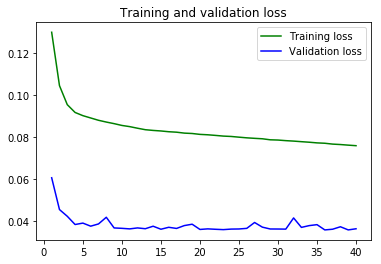

In [22]:
train_loss = history_mask.history['loss']
val_loss = history_mask.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.figure()
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [23]:
print('Train MAE = %f\nValidation MAE = %f' % ((train_loss[-1] * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (val_loss[-1] * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 8.063520
Validation MAE = 3.850088


In [37]:
as5_train_preds = model.predict_generator(gen_train, workers=4, use_multiprocessing=True)
as5_train_preds.shape

(19760, 1)

In [39]:
as5_val_preds = model.predict_generator(gen_val, workers=4, use_multiprocessing=True)
as5_val_preds.shape

(11376, 1)

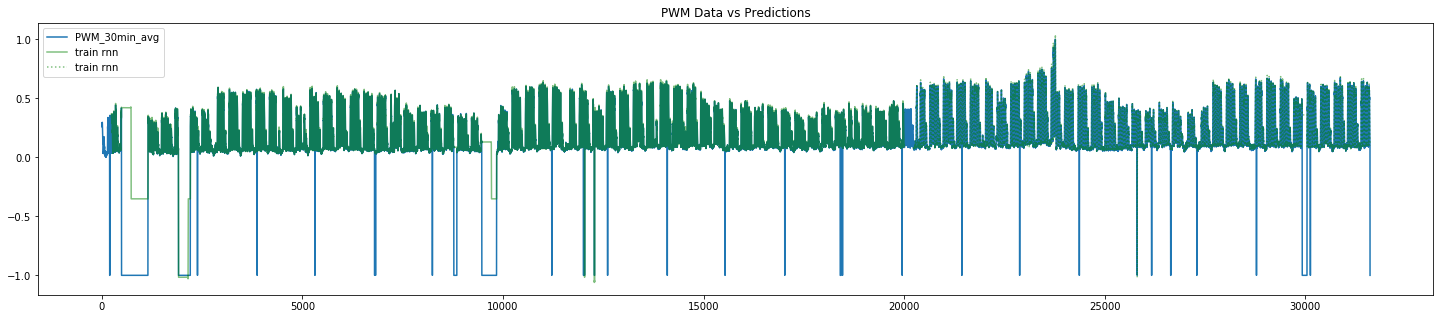

In [40]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(lookback, as5_train_split.shape[0]), as5_train_preds.flatten(), color='green', alpha=.5, label='train rnn')
plt.plot(range(20000 + lookback, 20000 + as5_val_split.shape[0]), as5_val_preds.flatten(), color='green', alpha=.5, label='train rnn', linestyle=':')
plt.title('PWM Data vs Predictions')
plt.legend()

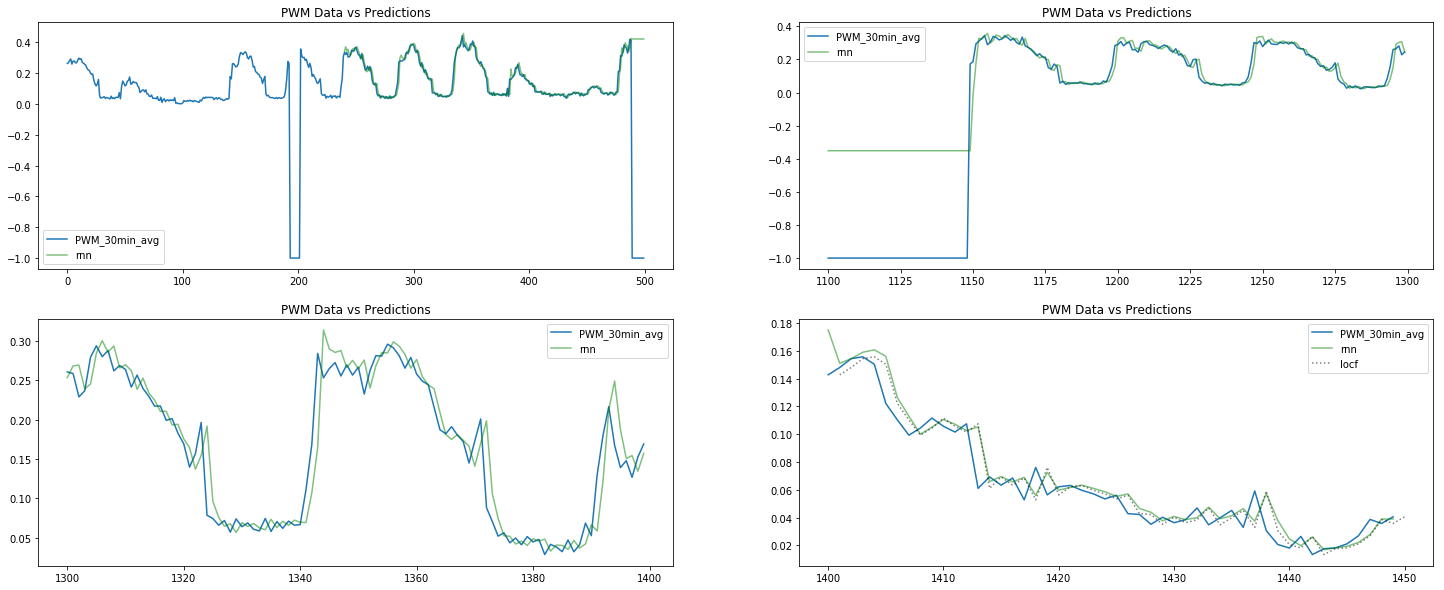

In [41]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(500), as5_train_data[:500, 0], label='PWM_30min_avg')
plt.plot(range(lookback, 500), as5_train_preds[:500 - lookback, :].flatten(), color='green', alpha=.5, label='rnn')
plt.title('PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1100, 1300), as5_train_data[1100:1300, 0], label='PWM_30min_avg')
plt.plot(range(1100, 1300), as5_train_preds[1100 - lookback:1300 - lookback].flatten(), color='green', alpha=.5, label='rnn')
plt.title('PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(1300, 1400), as5_train_data[1300:1400, 0], label='PWM_30min_avg')
plt.plot(range(1300, 1400), as5_train_preds[1300 - lookback:1400 - lookback].flatten(), color='green', alpha=.5, label='rnn')
plt.title('PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(1400, 1450), as5_train_data[1400:1450, 0], label='PWM_30min_avg')
plt.plot(range(1400, 1450), as5_train_preds[1400 - lookback:1450 - lookback].flatten(), color='green', alpha=.5, label='rnn')
plt.plot(range(1401, 1451), as5_train_data[1400:1450, 0], color='black', alpha=.5, label='locf', linestyle=':')
plt.title('PWM Data vs Predictions')
plt.legend()

In [28]:
model.save('base-rnn-mask-val.h5')

## Create the nested cross validation splits

In [17]:
# tscv = TimeSeriesSplit(n_splits=5)
# for train_idx, val_idx in tscv.split(as5_train_data):
#     print("%s %s" % (train_idx, val_idx))

[   0    1    2 ..., 5268 5269 5270] [ 5271  5272  5273 ..., 10537 10538 10539]
[    0     1     2 ..., 10537 10538 10539] [10540 10541 10542 ..., 15806 15807 15808]
[    0     1     2 ..., 15806 15807 15808] [15809 15810 15811 ..., 21075 21076 21077]
[    0     1     2 ..., 21075 21076 21077] [21078 21079 21080 ..., 26344 26345 26346]
[    0     1     2 ..., 26344 26345 26346] [26347 26348 26349 ..., 31613 31614 31615]


## Nested cross validation

In [21]:
# histories = []
# i = 1
# for train_idx, val_idx in tscv.split(as5_train_data):
# 
#     print('5-fold Nested cross validation iteration', i)
#     gen_train = mu.generator(as5_train_data[train_idx],
#                                   lookback=lookback, delay=delay, min_index=0, max_index=len(train_idx)-1,
#                                   batch_size=batch_size, step=step)    
#     train_steps = ((len(train_idx) - lookback + 1 - delay) // batch_size) + 1
#     gen_val = mu.generator(as5_train_data[val_idx],
#                                   lookback=lookback, delay=delay, min_index=0, max_index=len(val_idx)-1,
#                                   batch_size=batch_size, step=step)    
#     val_steps = ((len(val_idx) - lookback + 1 - delay) // batch_size) + 1
#     history = model.fit_generator(gen_train, steps_per_epoch=train_steps, epochs=30,
#                                   validation_data=gen_val, validation_steps=val_steps, workers=0, use_multiprocessing=False)
#     histories.append(history)
#     i += 1

5-fold Nested cross validation iteration 1
Epoch 1/30


 1/40 [..............................] - ETA: 9s - loss: 0.0665 - mean_absolute_percentage_error: 19.0021

 2/40 [>.............................] - ETA: 8s - loss: 0.0525 - mean_absolute_percentage_error: 5968371.5010

 3/40 [=>............................] - ETA: 8s - loss: 0.0520 - mean_absolute_percentage_error: 20918393.0007

 4/40 [==>...........................] - ETA: 9s - loss: 0.0488 - mean_absolute_percentage_error: 25510450.7505

 5/40 [==>...........................] - ETA: 8s - loss: 0.0448 - mean_absolute_percentage_error: 26221385.0004

 6/40 [===>..........................] - ETA: 7s - loss: 0.0406 - mean_absolute_percentage_error: 25076463.5003

 7/40 [====>.........................] - ETA: 7s - loss: 0.0362 - mean_absolute_percentage_error: 22926338.5717

 8/40 [=====>........................] - ETA: 6s - loss: 0.0415 - mean_absolute_percentage_error: 20073226.3772

 9/40 [=====>........................] - ETA: 6s - loss: 0.0421 - mean_absolute_percentage_error: 17842869.8526

10/40 [======>.......................] - ETA: 6s - loss: 0.0410 - mean_absolute_percentage_error: 16058584.2119

11/40 [=======>......................] - ETA: 5s - loss: 0.0409 - mean_absolute_percentage_error: 14598714.1236

12/40 [========>.....................] - ETA: 5s - loss: 0.0404 - mean_absolute_percentage_error: 13382155.8566

13/40 [========>.....................] - ETA: 5s - loss: 0.0402 - mean_absolute_percentage_error: 12352760.2748

14/40 [=========>....................] - ETA: 4s - loss: 0.0395 - mean_absolute_percentage_error: 13518065.1123

15/40 [==========>...................] - ETA: 4s - loss: 0.0379 - mean_absolute_percentage_error: 13639532.7048

16/40 [===========>..................] - ETA: 4s - loss: 0.0379 - mean_absolute_percentage_error: 12899053.3717

17/40 [===========>..................] - ETA: 4s - loss: 0.0383 - mean_absolute_percentage_error: 12302702.0263

18/40 [============>.................] - ETA: 3s - loss: 0.0378 - mean_absolute_percentage_error: 11619219.2533

19/40 [=============>................] - ETA: 3s - loss: 0.0380 - mean_absolute_percentage_error: 11007682.1871

20/40 [==============>...............] - ETA: 3s - loss: 0.0369 - mean_absolute_percentage_error: 10457298.4707

21/40 [==============>...............] - ETA: 3s - loss: 0.0367 - mean_absolute_percentage_error: 9959332.4241 

22/40 [===============>..............] - ETA: 3s - loss: 0.0380 - mean_absolute_percentage_error: 9506636.4419

23/40 [================>.............] - ETA: 3s - loss: 0.0374 - mean_absolute_percentage_error: 9093304.8108

24/40 [=================>............] - ETA: 2s - loss: 0.0383 - mean_absolute_percentage_error: 8714417.9412

25/40 [=================>............] - ETA: 2s - loss: 0.0387 - mean_absolute_percentage_error: 8365841.8660

26/40 [==================>...........] - ETA: 2s - loss: 0.0386 - mean_absolute_percentage_error: 8044079.1555

27/40 [===================>..........] - ETA: 2s - loss: 0.0393 - mean_absolute_percentage_error: 7746151.0324

28/40 [====================>.........] - ETA: 2s - loss: 0.0390 - mean_absolute_percentage_error: 7469503.1774

29/40 [====================>.........] - ETA: 1s - loss: 0.0397 - mean_absolute_percentage_error: 7325057.2402

30/40 [=====================>........] - ETA: 1s - loss: 0.0404 - mean_absolute_percentage_error: 7080889.3473

31/40 [======================>.......] - ETA: 1s - loss: 0.0401 - mean_absolute_percentage_error: 6852473.9287

32/40 [=======================>......] - ETA: 1s - loss: 0.0404 - mean_absolute_percentage_error: 6638334.6214

33/40 [=======================>......] - ETA: 1s - loss: 0.0400 - mean_absolute_percentage_error: 6437173.3241

34/40 [========================>.....] - ETA: 0s - loss: 0.0402 - mean_absolute_percentage_error: 6247845.1298

35/40 [=========================>....] - ETA: 0s - loss: 0.0404 - mean_absolute_percentage_error: 6069335.7027

36/40 [==========================>...] - ETA: 0s - loss: 0.0400 - mean_absolute_percentage_error: 5900743.3647

37/40 [==========================>...] - ETA: 0s - loss: 0.0400 - mean_absolute_percentage_error: 5741264.1758

38/40 [===========================>..] - ETA: 0s - loss: 0.0396 - mean_absolute_percentage_error: 5590178.5416

39/40 [============================>.] - ETA: 0s - loss: 0.0394 - mean_absolute_percentage_error: 5446840.9029

40/40 [==============================] - 7s 175ms/step - loss: 0.0398 - mean_absolute_percentage_error: 5312961.7126 - val_loss: 0.0351 - val_mean_absolute_percentage_error: 2330948.2845


Epoch 2/30
 1/40 [..............................] - ETA: 4s - loss: 0.0397 - mean_absolute_percentage_error: 13.4397

 2/40 [>.............................] - ETA: 4s - loss: 0.0371 - mean_absolute_percentage_error: 5566009.7198

 3/40 [=>............................] - ETA: 4s - loss: 0.0345 - mean_absolute_percentage_error: 13458912.4799

 4/40 [==>...........................] - ETA: 4s - loss: 0.0289 - mean_absolute_percentage_error: 13154520.6099

 5/40 [==>...........................] - ETA: 3s - loss: 0.0235 - mean_absolute_percentage_error: 10860070.4629

 6/40 [===>..........................] - ETA: 3s - loss: 0.0214 - mean_absolute_percentage_error: 10839314.8858

 7/40 [====>.........................] - ETA: 3s - loss: 0.0184 - mean_absolute_percentage_error: 9388778.1342 

 8/40 [=====>........................] - ETA: 3s - loss: 0.0207 - mean_absolute_percentage_error: 8342198.0159

 9/40 [=====>........................] - ETA: 3s - loss: 0.0217 - mean_absolute_percentage_error: 7415288.4421

10/40 [======>.......................] - ETA: 3s - loss: 0.0219 - mean_absolute_percentage_error: 6673760.6023

11/40 [=======>......................] - ETA: 3s - loss: 0.0229 - mean_absolute_percentage_error: 6067056.1179

12/40 [========>.....................] - ETA: 3s - loss: 0.0235 - mean_absolute_percentage_error: 5561469.1794

13/40 [========>.....................] - ETA: 2s - loss: 0.0242 - mean_absolute_percentage_error: 5133664.7359

14/40 [=========>....................] - ETA: 2s - loss: 0.0242 - mean_absolute_percentage_error: 6474210.3976

15/40 [==========>...................] - ETA: 2s - loss: 0.0232 - mean_absolute_percentage_error: 6621638.4378

16/40 [===========>..................] - ETA: 2s - loss: 0.0237 - mean_absolute_percentage_error: 6271517.6409

17/40 [===========>..................] - ETA: 2s - loss: 0.0244 - mean_absolute_percentage_error: 6064731.7209

18/40 [============>.................] - ETA: 2s - loss: 0.0244 - mean_absolute_percentage_error: 5727802.7230

19/40 [=============>................] - ETA: 2s - loss: 0.0251 - mean_absolute_percentage_error: 5426340.1177

20/40 [==============>...............] - ETA: 2s - loss: 0.0246 - mean_absolute_percentage_error: 5155023.4944

21/40 [==============>...............] - ETA: 2s - loss: 0.0248 - mean_absolute_percentage_error: 4909546.6730

22/40 [===============>..............] - ETA: 1s - loss: 0.0261 - mean_absolute_percentage_error: 4686386.2303

23/40 [================>.............] - ETA: 1s - loss: 0.0258 - mean_absolute_percentage_error: 4482630.6347

24/40 [=================>............] - ETA: 1s - loss: 0.0268 - mean_absolute_percentage_error: 4295855.0369

25/40 [=================>............] - ETA: 1s - loss: 0.0274 - mean_absolute_percentage_error: 4124021.3511

26/40 [==================>...........] - ETA: 1s - loss: 0.0274 - mean_absolute_percentage_error: 3965405.5151

27/40 [===================>..........] - ETA: 1s - loss: 0.0282 - mean_absolute_percentage_error: 3818539.2475

28/40 [====================>.........] - ETA: 1s - loss: 0.0281 - mean_absolute_percentage_error: 3682163.1731

29/40 [====================>.........] - ETA: 1s - loss: 0.0289 - mean_absolute_percentage_error: 3654197.9258

30/40 [=====================>........] - ETA: 1s - loss: 0.0297 - mean_absolute_percentage_error: 3532391.9294

31/40 [======================>.......] - ETA: 0s - loss: 0.0297 - mean_absolute_percentage_error: 3418444.1202

32/40 [=======================>......] - ETA: 0s - loss: 0.0301 - mean_absolute_percentage_error: 3311618.1591

33/40 [=======================>......] - ETA: 0s - loss: 0.0299 - mean_absolute_percentage_error: 3211266.4134

34/40 [========================>.....] - ETA: 0s - loss: 0.0302 - mean_absolute_percentage_error: 3116817.7794

35/40 [=========================>....] - ETA: 0s - loss: 0.0304 - mean_absolute_percentage_error: 3027766.2049

36/40 [==========================>...] - ETA: 0s - loss: 0.0302 - mean_absolute_percentage_error: 2943661.8635

37/40 [==========================>...] - ETA: 0s - loss: 0.0303 - mean_absolute_percentage_error: 2864103.7317

38/40 [===========================>..] - ETA: 0s - loss: 0.0301 - mean_absolute_percentage_error: 2788732.8024

39/40 [============================>.] - ETA: 0s - loss: 0.0300 - mean_absolute_percentage_error: 2717227.0653

40/40 [==============================] - 5s 131ms/step - loss: 0.0304 - mean_absolute_percentage_error: 2650439.8403 - val_loss: 0.0295 - val_mean_absolute_percentage_error: 1894757.3662


Epoch 3/30
 1/40 [..............................] - ETA: 4s - loss: 0.0339 - mean_absolute_percentage_error: 11.4982

 2/40 [>.............................] - ETA: 4s - loss: 0.0315 - mean_absolute_percentage_error: 4785925.7491

 3/40 [=>............................] - ETA: 4s - loss: 0.0283 - mean_absolute_percentage_error: 10518373.8327

 4/40 [==>...........................] - ETA: 3s - loss: 0.0225 - mean_absolute_percentage_error: 9192240.1245 

 5/40 [==>...........................] - ETA: 3s - loss: 0.0198 - mean_absolute_percentage_error: 9084649.2996

 6/40 [===>..........................] - ETA: 3s - loss: 0.0171 - mean_absolute_percentage_error: 8186873.9164

 7/40 [====>.........................] - ETA: 3s - loss: 0.0157 - mean_absolute_percentage_error: 8107107.9997

 8/40 [=====>........................] - ETA: 3s - loss: 0.0178 - mean_absolute_percentage_error: 7131517.6209

 9/40 [=====>........................] - ETA: 3s - loss: 0.0187 - mean_absolute_percentage_error: 6339127.9460

10/40 [======>.......................] - ETA: 3s - loss: 0.0189 - mean_absolute_percentage_error: 5705216.0445

11/40 [=======>......................] - ETA: 3s - loss: 0.0198 - mean_absolute_percentage_error: 5186560.9393

12/40 [========>.....................] - ETA: 2s - loss: 0.0203 - mean_absolute_percentage_error: 4754348.4518

13/40 [========>.....................] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 4388630.1212

14/40 [=========>....................] - ETA: 2s - loss: 0.0206 - mean_absolute_percentage_error: 5286714.1125

15/40 [==========>...................] - ETA: 2s - loss: 0.0194 - mean_absolute_percentage_error: 5044431.6967

16/40 [===========>..................] - ETA: 2s - loss: 0.0202 - mean_absolute_percentage_error: 4946441.1219

17/40 [===========>..................] - ETA: 2s - loss: 0.0208 - mean_absolute_percentage_error: 4810112.5706

18/40 [============>.................] - ETA: 2s - loss: 0.0209 - mean_absolute_percentage_error: 4542884.5581

19/40 [=============>................] - ETA: 2s - loss: 0.0214 - mean_absolute_percentage_error: 4303785.9747

20/40 [==============>...............] - ETA: 2s - loss: 0.0211 - mean_absolute_percentage_error: 4088597.0299

21/40 [==============>...............] - ETA: 2s - loss: 0.0213 - mean_absolute_percentage_error: 3893902.3725

22/40 [===============>..............] - ETA: 1s - loss: 0.0224 - mean_absolute_percentage_error: 3716907.4577

23/40 [================>.............] - ETA: 1s - loss: 0.0222 - mean_absolute_percentage_error: 3555303.0713

24/40 [=================>............] - ETA: 1s - loss: 0.0231 - mean_absolute_percentage_error: 3407166.0275

25/40 [=================>............] - ETA: 1s - loss: 0.0236 - mean_absolute_percentage_error: 3270879.8186

26/40 [==================>...........] - ETA: 1s - loss: 0.0236 - mean_absolute_percentage_error: 3145077.0715

27/40 [===================>..........] - ETA: 1s - loss: 0.0244 - mean_absolute_percentage_error: 3028593.2592

28/40 [====================>.........] - ETA: 1s - loss: 0.0243 - mean_absolute_percentage_error: 2920429.4993

29/40 [====================>.........] - ETA: 1s - loss: 0.0250 - mean_absolute_percentage_error: 2908701.8442

30/40 [=====================>........] - ETA: 1s - loss: 0.0257 - mean_absolute_percentage_error: 2811745.6239

31/40 [======================>.......] - ETA: 0s - loss: 0.0257 - mean_absolute_percentage_error: 2721044.4428

32/40 [=======================>......] - ETA: 0s - loss: 0.0260 - mean_absolute_percentage_error: 2636012.1627

33/40 [=======================>......] - ETA: 0s - loss: 0.0259 - mean_absolute_percentage_error: 2556133.2836

34/40 [========================>.....] - ETA: 0s - loss: 0.0262 - mean_absolute_percentage_error: 2480953.2285

35/40 [=========================>....] - ETA: 0s - loss: 0.0264 - mean_absolute_percentage_error: 2410069.1681

36/40 [==========================>...] - ETA: 0s - loss: 0.0262 - mean_absolute_percentage_error: 2343123.0324

37/40 [==========================>...] - ETA: 0s - loss: 0.0263 - mean_absolute_percentage_error: 2279795.6305

38/40 [===========================>..] - ETA: 0s - loss: 0.0261 - mean_absolute_percentage_error: 2219801.1885

39/40 [============================>.] - ETA: 0s - loss: 0.0260 - mean_absolute_percentage_error: 2162883.4085

40/40 [==============================] - 5s 132ms/step - loss: 0.0264 - mean_absolute_percentage_error: 2109721.5106 - val_loss: 0.0254 - val_mean_absolute_percentage_error: 1347001.3666


Epoch 4/30
 1/40 [..............................] - ETA: 4s - loss: 0.0299 - mean_absolute_percentage_error: 10.1554

 2/40 [>.............................] - ETA: 4s - loss: 0.0273 - mean_absolute_percentage_error: 4057218.0777

 3/40 [=>............................] - ETA: 4s - loss: 0.0230 - mean_absolute_percentage_error: 7519914.0518

 4/40 [==>...........................] - ETA: 3s - loss: 0.0179 - mean_absolute_percentage_error: 6237434.9763

 5/40 [==>...........................] - ETA: 3s - loss: 0.0166 - mean_absolute_percentage_error: 7310156.9811

 6/40 [===>..........................] - ETA: 3s - loss: 0.0140 - mean_absolute_percentage_error: 6231002.1509

 7/40 [====>.........................] - ETA: 3s - loss: 0.0135 - mean_absolute_percentage_error: 6847484.5579

 8/40 [=====>........................] - ETA: 3s - loss: 0.0153 - mean_absolute_percentage_error: 5992891.1170

 9/40 [=====>........................] - ETA: 3s - loss: 0.0163 - mean_absolute_percentage_error: 5327015.4123

10/40 [======>.......................] - ETA: 3s - loss: 0.0165 - mean_absolute_percentage_error: 4794314.6539

11/40 [=======>......................] - ETA: 3s - loss: 0.0174 - mean_absolute_percentage_error: 4358468.6861

12/40 [========>.....................] - ETA: 3s - loss: 0.0177 - mean_absolute_percentage_error: 3995263.7506

13/40 [========>.....................] - ETA: 2s - loss: 0.0183 - mean_absolute_percentage_error: 3687936.4893

14/40 [=========>....................] - ETA: 2s - loss: 0.0180 - mean_absolute_percentage_error: 4333247.7400

15/40 [==========>...................] - ETA: 2s - loss: 0.0169 - mean_absolute_percentage_error: 4202912.9407

16/40 [===========>..................] - ETA: 2s - loss: 0.0175 - mean_absolute_percentage_error: 4136520.5694

17/40 [===========>..................] - ETA: 2s - loss: 0.0182 - mean_absolute_percentage_error: 4045439.3594

18/40 [============>.................] - ETA: 2s - loss: 0.0181 - mean_absolute_percentage_error: 3820693.1061

19/40 [=============>................] - ETA: 2s - loss: 0.0186 - mean_absolute_percentage_error: 3619604.4709

20/40 [==============>...............] - ETA: 2s - loss: 0.0182 - mean_absolute_percentage_error: 3438624.5161

21/40 [==============>...............] - ETA: 2s - loss: 0.0184 - mean_absolute_percentage_error: 3274880.8729

22/40 [===============>..............] - ETA: 1s - loss: 0.0194 - mean_absolute_percentage_error: 3126023.1936

23/40 [================>.............] - ETA: 1s - loss: 0.0192 - mean_absolute_percentage_error: 2990109.4146

24/40 [=================>............] - ETA: 1s - loss: 0.0199 - mean_absolute_percentage_error: 2865521.9964

25/40 [=================>............] - ETA: 1s - loss: 0.0203 - mean_absolute_percentage_error: 2750901.4900

26/40 [==================>...........] - ETA: 1s - loss: 0.0204 - mean_absolute_percentage_error: 2645097.8708

27/40 [===================>..........] - ETA: 1s - loss: 0.0210 - mean_absolute_percentage_error: 2547131.7256

28/40 [====================>.........] - ETA: 1s - loss: 0.0210 - mean_absolute_percentage_error: 2456162.9911

29/40 [====================>.........] - ETA: 1s - loss: 0.0216 - mean_absolute_percentage_error: 2451329.0432

30/40 [=====================>........] - ETA: 1s - loss: 0.0223 - mean_absolute_percentage_error: 2369618.5477

31/40 [======================>.......] - ETA: 0s - loss: 0.0224 - mean_absolute_percentage_error: 2293179.5019

32/40 [=======================>......] - ETA: 0s - loss: 0.0227 - mean_absolute_percentage_error: 2221517.9470

33/40 [=======================>......] - ETA: 0s - loss: 0.0225 - mean_absolute_percentage_error: 2154199.4689

34/40 [========================>.....] - ETA: 0s - loss: 0.0228 - mean_absolute_percentage_error: 2090840.9571

35/40 [=========================>....] - ETA: 0s - loss: 0.0230 - mean_absolute_percentage_error: 2031102.9179

36/40 [==========================>...] - ETA: 0s - loss: 0.0229 - mean_absolute_percentage_error: 1974683.5894

37/40 [==========================>...] - ETA: 0s - loss: 0.0229 - mean_absolute_percentage_error: 1921313.9710

38/40 [===========================>..] - ETA: 0s - loss: 0.0227 - mean_absolute_percentage_error: 1870753.2337

39/40 [============================>.] - ETA: 0s - loss: 0.0226 - mean_absolute_percentage_error: 1822785.3778

40/40 [==============================] - 5s 132ms/step - loss: 0.0230 - mean_absolute_percentage_error: 1777982.8082 - val_loss: 0.0230 - val_mean_absolute_percentage_error: 1008661.9037


Epoch 5/30
 1/40 [..............................] - ETA: 4s - loss: 0.0253 - mean_absolute_percentage_error: 8.2848

 2/40 [>.............................] - ETA: 4s - loss: 0.0231 - mean_absolute_percentage_error: 3517545.1424

 3/40 [=>............................] - ETA: 4s - loss: 0.0192 - mean_absolute_percentage_error: 6143437.4283

 4/40 [==>...........................] - ETA: 4s - loss: 0.0159 - mean_absolute_percentage_error: 6077164.1962

 5/40 [==>...........................] - ETA: 3s - loss: 0.0144 - mean_absolute_percentage_error: 6536622.1570

 6/40 [===>..........................] - ETA: 3s - loss: 0.0127 - mean_absolute_percentage_error: 6146160.3391

 7/40 [====>.........................] - ETA: 3s - loss: 0.0119 - mean_absolute_percentage_error: 6306300.1478

 8/40 [=====>........................] - ETA: 3s - loss: 0.0139 - mean_absolute_percentage_error: 5561435.9887

 9/40 [=====>........................] - ETA: 3s - loss: 0.0149 - mean_absolute_percentage_error: 4943499.6635

10/40 [======>.......................] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 4449150.4311

11/40 [=======>......................] - ETA: 3s - loss: 0.0159 - mean_absolute_percentage_error: 4044682.9747

12/40 [========>.....................] - ETA: 3s - loss: 0.0162 - mean_absolute_percentage_error: 3707626.7930

13/40 [========>.....................] - ETA: 2s - loss: 0.0168 - mean_absolute_percentage_error: 3422425.3897

14/40 [=========>....................] - ETA: 2s - loss: 0.0162 - mean_absolute_percentage_error: 3801817.0761

15/40 [==========>...................] - ETA: 2s - loss: 0.0155 - mean_absolute_percentage_error: 3959145.3711

16/40 [===========>..................] - ETA: 2s - loss: 0.0160 - mean_absolute_percentage_error: 3822296.8322

17/40 [===========>..................] - ETA: 2s - loss: 0.0166 - mean_absolute_percentage_error: 3742983.6951

18/40 [============>.................] - ETA: 2s - loss: 0.0166 - mean_absolute_percentage_error: 3535040.5009

19/40 [=============>................] - ETA: 2s - loss: 0.0169 - mean_absolute_percentage_error: 3348986.1563

20/40 [==============>...............] - ETA: 2s - loss: 0.0166 - mean_absolute_percentage_error: 3181537.1080

21/40 [==============>...............] - ETA: 2s - loss: 0.0168 - mean_absolute_percentage_error: 3030035.6841

22/40 [===============>..............] - ETA: 1s - loss: 0.0176 - mean_absolute_percentage_error: 2892307.2460

23/40 [================>.............] - ETA: 1s - loss: 0.0175 - mean_absolute_percentage_error: 2766555.0285

24/40 [=================>............] - ETA: 1s - loss: 0.0181 - mean_absolute_percentage_error: 2651282.3063

25/40 [=================>............] - ETA: 1s - loss: 0.0184 - mean_absolute_percentage_error: 2545231.3565

26/40 [==================>...........] - ETA: 1s - loss: 0.0185 - mean_absolute_percentage_error: 2447338.1123

27/40 [===================>..........] - ETA: 1s - loss: 0.0192 - mean_absolute_percentage_error: 2356696.4077

28/40 [====================>.........] - ETA: 1s - loss: 0.0192 - mean_absolute_percentage_error: 2272528.9166

29/40 [====================>.........] - ETA: 1s - loss: 0.0197 - mean_absolute_percentage_error: 2266319.1996

30/40 [=====================>........] - ETA: 1s - loss: 0.0201 - mean_absolute_percentage_error: 2190775.5650

31/40 [======================>.......] - ETA: 0s - loss: 0.0202 - mean_absolute_percentage_error: 2120105.6364

32/40 [=======================>......] - ETA: 0s - loss: 0.0205 - mean_absolute_percentage_error: 2053852.6110

33/40 [=======================>......] - ETA: 0s - loss: 0.0203 - mean_absolute_percentage_error: 1991614.8524

34/40 [========================>.....] - ETA: 0s - loss: 0.0206 - mean_absolute_percentage_error: 1933038.1964

35/40 [=========================>....] - ETA: 0s - loss: 0.0208 - mean_absolute_percentage_error: 1877808.7926

36/40 [==========================>...] - ETA: 0s - loss: 0.0206 - mean_absolute_percentage_error: 1825647.6203

37/40 [==========================>...] - ETA: 0s - loss: 0.0207 - mean_absolute_percentage_error: 1776305.9830

38/40 [===========================>..] - ETA: 0s - loss: 0.0205 - mean_absolute_percentage_error: 1729561.2383

39/40 [============================>.] - ETA: 0s - loss: 0.0205 - mean_absolute_percentage_error: 1685213.6834

40/40 [==============================] - 5s 134ms/step - loss: 0.0208 - mean_absolute_percentage_error: 1643792.5159 - val_loss: 0.0206 - val_mean_absolute_percentage_error: 824893.3208


Epoch 6/30
 1/40 [..............................] - ETA: 5s - loss: 0.0228 - mean_absolute_percentage_error: 7.4310

 2/40 [>.............................] - ETA: 4s - loss: 0.0208 - mean_absolute_percentage_error: 2982909.9655

 3/40 [=>............................] - ETA: 4s - loss: 0.0167 - mean_absolute_percentage_error: 4829416.9770

 4/40 [==>...........................] - ETA: 4s - loss: 0.0144 - mean_absolute_percentage_error: 5493446.8577

 5/40 [==>...........................] - ETA: 4s - loss: 0.0128 - mean_absolute_percentage_error: 5621117.2862

 6/40 [===>..........................] - ETA: 3s - loss: 0.0116 - mean_absolute_percentage_error: 5687157.3218

 7/40 [====>.........................] - ETA: 3s - loss: 0.0107 - mean_absolute_percentage_error: 5610091.2759

 8/40 [=====>........................] - ETA: 3s - loss: 0.0128 - mean_absolute_percentage_error: 4976219.7726

 9/40 [=====>........................] - ETA: 3s - loss: 0.0138 - mean_absolute_percentage_error: 4423307.4156

10/40 [======>.......................] - ETA: 3s - loss: 0.0141 - mean_absolute_percentage_error: 3980977.3883

11/40 [=======>......................] - ETA: 3s - loss: 0.0149 - mean_absolute_percentage_error: 3619071.0804

12/40 [========>.....................] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 3317482.4993

13/40 [========>.....................] - ETA: 3s - loss: 0.0156 - mean_absolute_percentage_error: 3062292.1577

14/40 [=========>....................] - ETA: 2s - loss: 0.0149 - mean_absolute_percentage_error: 3263683.1464

15/40 [==========>...................] - ETA: 2s - loss: 0.0145 - mean_absolute_percentage_error: 3628984.8700

16/40 [===========>..................] - ETA: 2s - loss: 0.0149 - mean_absolute_percentage_error: 3451990.8937

17/40 [===========>..................] - ETA: 2s - loss: 0.0155 - mean_absolute_percentage_error: 3388859.3411

18/40 [============>.................] - ETA: 2s - loss: 0.0155 - mean_absolute_percentage_error: 3200589.7054

19/40 [=============>................] - ETA: 2s - loss: 0.0158 - mean_absolute_percentage_error: 3032138.0078

20/40 [==============>...............] - ETA: 2s - loss: 0.0156 - mean_absolute_percentage_error: 2880531.3865

21/40 [==============>...............] - ETA: 2s - loss: 0.0157 - mean_absolute_percentage_error: 2743363.5536

22/40 [===============>..............] - ETA: 1s - loss: 0.0164 - mean_absolute_percentage_error: 2618665.6061

23/40 [================>.............] - ETA: 1s - loss: 0.0163 - mean_absolute_percentage_error: 2504810.8435

24/40 [=================>............] - ETA: 1s - loss: 0.0168 - mean_absolute_percentage_error: 2400444.0719

25/40 [=================>............] - ETA: 1s - loss: 0.0171 - mean_absolute_percentage_error: 2304426.6075

26/40 [==================>...........] - ETA: 1s - loss: 0.0171 - mean_absolute_percentage_error: 2215795.0473

27/40 [===================>..........] - ETA: 1s - loss: 0.0176 - mean_absolute_percentage_error: 2133728.9039

28/40 [====================>.........] - ETA: 1s - loss: 0.0175 - mean_absolute_percentage_error: 2057524.5236

29/40 [====================>.........] - ETA: 1s - loss: 0.0180 - mean_absolute_percentage_error: 2053730.3159

30/40 [=====================>........] - ETA: 1s - loss: 0.0183 - mean_absolute_percentage_error: 1985272.8986

31/40 [======================>.......] - ETA: 0s - loss: 0.0183 - mean_absolute_percentage_error: 1921232.0566

32/40 [=======================>......] - ETA: 0s - loss: 0.0186 - mean_absolute_percentage_error: 1861193.8155

33/40 [=======================>......] - ETA: 0s - loss: 0.0184 - mean_absolute_percentage_error: 1804794.1779

34/40 [========================>.....] - ETA: 0s - loss: 0.0185 - mean_absolute_percentage_error: 1751712.1881

35/40 [=========================>....] - ETA: 0s - loss: 0.0187 - mean_absolute_percentage_error: 1701663.5001

36/40 [==========================>...] - ETA: 0s - loss: 0.0186 - mean_absolute_percentage_error: 1654395.2340

37/40 [==========================>...] - ETA: 0s - loss: 0.0186 - mean_absolute_percentage_error: 1609682.0163

38/40 [===========================>..] - ETA: 0s - loss: 0.0185 - mean_absolute_percentage_error: 1567322.1228

39/40 [============================>.] - ETA: 0s - loss: 0.0186 - mean_absolute_percentage_error: 1527134.5570

40/40 [==============================] - 6s 139ms/step - loss: 0.0189 - mean_absolute_percentage_error: 1489598.8582 - val_loss: 0.0197 - val_mean_absolute_percentage_error: 613654.2369


Epoch 7/30
 1/40 [..............................] - ETA: 4s - loss: 0.0214 - mean_absolute_percentage_error: 6.8112

 2/40 [>.............................] - ETA: 4s - loss: 0.0199 - mean_absolute_percentage_error: 2866800.9056

 3/40 [=>............................] - ETA: 4s - loss: 0.0136 - mean_absolute_percentage_error: 2200280.3537

 4/40 [==>...........................] - ETA: 4s - loss: 0.0139 - mean_absolute_percentage_error: 5415038.0153

 5/40 [==>...........................] - ETA: 3s - loss: 0.0113 - mean_absolute_percentage_error: 4508734.6622

 6/40 [===>..........................] - ETA: 3s - loss: 0.0114 - mean_absolute_percentage_error: 5685801.7185

 7/40 [====>.........................] - ETA: 3s - loss: 0.0098 - mean_absolute_percentage_error: 4901777.0690

 8/40 [=====>........................] - ETA: 3s - loss: 0.0126 - mean_absolute_percentage_error: 4420871.9979

 9/40 [=====>........................] - ETA: 3s - loss: 0.0135 - mean_absolute_percentage_error: 3929664.9013

10/40 [======>.......................] - ETA: 3s - loss: 0.0138 - mean_absolute_percentage_error: 3536699.1227

11/40 [=======>......................] - ETA: 3s - loss: 0.0146 - mean_absolute_percentage_error: 3215181.7232

12/40 [========>.....................] - ETA: 3s - loss: 0.0148 - mean_absolute_percentage_error: 2947250.5763

13/40 [========>.....................] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 2720539.5864

14/40 [=========>....................] - ETA: 2s - loss: 0.0145 - mean_absolute_percentage_error: 2796056.9552

15/40 [==========>...................] - ETA: 2s - loss: 0.0141 - mean_absolute_percentage_error: 3231444.4916

16/40 [===========>..................] - ETA: 2s - loss: 0.0144 - mean_absolute_percentage_error: 3067255.4413

17/40 [===========>..................] - ETA: 2s - loss: 0.0150 - mean_absolute_percentage_error: 3028293.5036

18/40 [============>.................] - ETA: 2s - loss: 0.0150 - mean_absolute_percentage_error: 2860055.2950

19/40 [=============>................] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 2709526.4179

20/40 [==============>...............] - ETA: 2s - loss: 0.0149 - mean_absolute_percentage_error: 2574050.3389

21/40 [==============>...............] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 2451476.8019

22/40 [===============>..............] - ETA: 2s - loss: 0.0157 - mean_absolute_percentage_error: 2340046.4161

23/40 [================>.............] - ETA: 1s - loss: 0.0157 - mean_absolute_percentage_error: 2238305.5432

24/40 [=================>............] - ETA: 1s - loss: 0.0162 - mean_absolute_percentage_error: 2145043.1439

25/40 [=================>............] - ETA: 1s - loss: 0.0165 - mean_absolute_percentage_error: 2059241.7181

26/40 [==================>...........] - ETA: 1s - loss: 0.0166 - mean_absolute_percentage_error: 1980040.3759

27/40 [===================>..........] - ETA: 1s - loss: 0.0169 - mean_absolute_percentage_error: 1906705.8313

28/40 [====================>.........] - ETA: 1s - loss: 0.0170 - mean_absolute_percentage_error: 1838609.4470

29/40 [====================>.........] - ETA: 1s - loss: 0.0175 - mean_absolute_percentage_error: 1832682.0264

30/40 [=====================>........] - ETA: 1s - loss: 0.0179 - mean_absolute_percentage_error: 1771592.9197

31/40 [======================>.......] - ETA: 1s - loss: 0.0179 - mean_absolute_percentage_error: 1714444.9858

32/40 [=======================>......] - ETA: 0s - loss: 0.0181 - mean_absolute_percentage_error: 1660868.8134

33/40 [=======================>......] - ETA: 0s - loss: 0.0181 - mean_absolute_percentage_error: 1610539.6650

34/40 [========================>.....] - ETA: 0s - loss: 0.0182 - mean_absolute_percentage_error: 1563171.0692

35/40 [=========================>....] - ETA: 0s - loss: 0.0184 - mean_absolute_percentage_error: 1518509.2506

36/40 [==========================>...] - ETA: 0s - loss: 0.0183 - mean_absolute_percentage_error: 1476328.6073

37/40 [==========================>...] - ETA: 0s - loss: 0.0183 - mean_absolute_percentage_error: 1436428.0038

38/40 [===========================>..] - ETA: 0s - loss: 0.0182 - mean_absolute_percentage_error: 1398627.4267

39/40 [============================>.] - ETA: 0s - loss: 0.0182 - mean_absolute_percentage_error: 1362765.3514

40/40 [==============================] - 5s 137ms/step - loss: 0.0185 - mean_absolute_percentage_error: 1329269.6997 - val_loss: 0.0182 - val_mean_absolute_percentage_error: 734319.3936


Epoch 8/30
 1/40 [..............................] - ETA: 4s - loss: 0.0214 - mean_absolute_percentage_error: 6.9831

 2/40 [>.............................] - ETA: 4s - loss: 0.0197 - mean_absolute_percentage_error: 2809915.4916

 3/40 [=>............................] - ETA: 4s - loss: 0.0152 - mean_absolute_percentage_error: 3866272.3277

 4/40 [==>...........................] - ETA: 4s - loss: 0.0136 - mean_absolute_percentage_error: 5153460.4958

 5/40 [==>...........................] - ETA: 3s - loss: 0.0118 - mean_absolute_percentage_error: 4980357.3966

 6/40 [===>..........................] - ETA: 3s - loss: 0.0111 - mean_absolute_percentage_error: 5420388.8305

 7/40 [====>.........................] - ETA: 3s - loss: 0.0100 - mean_absolute_percentage_error: 5125262.4619

 8/40 [=====>........................] - ETA: 3s - loss: 0.0120 - mean_absolute_percentage_error: 4572640.8573

 9/40 [=====>........................] - ETA: 3s - loss: 0.0130 - mean_absolute_percentage_error: 4064570.5565

10/40 [======>.......................] - ETA: 3s - loss: 0.0133 - mean_absolute_percentage_error: 3658114.1854

11/40 [=======>......................] - ETA: 3s - loss: 0.0141 - mean_absolute_percentage_error: 3325559.0470

12/40 [========>.....................] - ETA: 3s - loss: 0.0143 - mean_absolute_percentage_error: 3048429.7535

13/40 [========>.....................] - ETA: 3s - loss: 0.0147 - mean_absolute_percentage_error: 2813935.7239

14/40 [=========>....................] - ETA: 2s - loss: 0.0139 - mean_absolute_percentage_error: 2807149.7258

15/40 [==========>...................] - ETA: 2s - loss: 0.0136 - mean_absolute_percentage_error: 3314154.0107

16/40 [===========>..................] - ETA: 2s - loss: 0.0139 - mean_absolute_percentage_error: 3123249.0179

17/40 [===========>..................] - ETA: 2s - loss: 0.0145 - mean_absolute_percentage_error: 3076716.8845

18/40 [============>.................] - ETA: 2s - loss: 0.0145 - mean_absolute_percentage_error: 2905788.4854

19/40 [=============>................] - ETA: 2s - loss: 0.0147 - mean_absolute_percentage_error: 2752852.5912

20/40 [==============>...............] - ETA: 2s - loss: 0.0145 - mean_absolute_percentage_error: 2615210.2091

21/40 [==============>...............] - ETA: 2s - loss: 0.0146 - mean_absolute_percentage_error: 2490676.6803

22/40 [===============>..............] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 2377464.4592

23/40 [================>.............] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 2274096.6996

24/40 [=================>............] - ETA: 1s - loss: 0.0156 - mean_absolute_percentage_error: 2179342.9795

25/40 [=================>............] - ETA: 1s - loss: 0.0159 - mean_absolute_percentage_error: 2092169.5390

26/40 [==================>...........] - ETA: 1s - loss: 0.0160 - mean_absolute_percentage_error: 2011701.7592

27/40 [===================>..........] - ETA: 1s - loss: 0.0164 - mean_absolute_percentage_error: 1937194.5739

28/40 [====================>.........] - ETA: 1s - loss: 0.0164 - mean_absolute_percentage_error: 1868009.3219

29/40 [====================>.........] - ETA: 1s - loss: 0.0170 - mean_absolute_percentage_error: 1858934.5005

30/40 [=====================>........] - ETA: 1s - loss: 0.0173 - mean_absolute_percentage_error: 1796970.2947

31/40 [======================>.......] - ETA: 0s - loss: 0.0173 - mean_absolute_percentage_error: 1739003.7275

32/40 [=======================>......] - ETA: 0s - loss: 0.0175 - mean_absolute_percentage_error: 1684660.0856

33/40 [=======================>......] - ETA: 0s - loss: 0.0174 - mean_absolute_percentage_error: 1633609.9738

34/40 [========================>.....] - ETA: 0s - loss: 0.0176 - mean_absolute_percentage_error: 1585562.8284

35/40 [=========================>....] - ETA: 0s - loss: 0.0178 - mean_absolute_percentage_error: 1540261.2433

36/40 [==========================>...] - ETA: 0s - loss: 0.0176 - mean_absolute_percentage_error: 1497476.3707

37/40 [==========================>...] - ETA: 0s - loss: 0.0177 - mean_absolute_percentage_error: 1457004.2022

38/40 [===========================>..] - ETA: 0s - loss: 0.0176 - mean_absolute_percentage_error: 1418662.1481

39/40 [============================>.] - ETA: 0s - loss: 0.0176 - mean_absolute_percentage_error: 1382286.3574

40/40 [==============================] - 5s 134ms/step - loss: 0.0178 - mean_absolute_percentage_error: 1348310.8818 - val_loss: 0.0175 - val_mean_absolute_percentage_error: 678690.0442


Epoch 9/30
 1/40 [..............................] - ETA: 4s - loss: 0.0208 - mean_absolute_percentage_error: 6.7634

 2/40 [>.............................] - ETA: 4s - loss: 0.0194 - mean_absolute_percentage_error: 2804978.1317

 3/40 [=>............................] - ETA: 4s - loss: 0.0148 - mean_absolute_percentage_error: 3802451.0878

 4/40 [==>...........................] - ETA: 4s - loss: 0.0134 - mean_absolute_percentage_error: 5154618.3158

 5/40 [==>...........................] - ETA: 4s - loss: 0.0116 - mean_absolute_percentage_error: 4935034.6527

 6/40 [===>..........................] - ETA: 3s - loss: 0.0109 - mean_absolute_percentage_error: 5412957.8772

 7/40 [====>.........................] - ETA: 3s - loss: 0.0098 - mean_absolute_percentage_error: 5085088.5019

 8/40 [=====>........................] - ETA: 3s - loss: 0.0118 - mean_absolute_percentage_error: 4539772.5876

 9/40 [=====>........................] - ETA: 3s - loss: 0.0128 - mean_absolute_percentage_error: 4035354.3107

10/40 [======>.......................] - ETA: 3s - loss: 0.0131 - mean_absolute_percentage_error: 3631819.5573

11/40 [=======>......................] - ETA: 3s - loss: 0.0139 - mean_absolute_percentage_error: 3301654.8252

12/40 [========>.....................] - ETA: 3s - loss: 0.0141 - mean_absolute_percentage_error: 3026517.5368

13/40 [========>.....................] - ETA: 2s - loss: 0.0145 - mean_absolute_percentage_error: 2793709.0496

14/40 [=========>....................] - ETA: 2s - loss: 0.0137 - mean_absolute_percentage_error: 2815115.4389

15/40 [==========>...................] - ETA: 2s - loss: 0.0135 - mean_absolute_percentage_error: 3320769.0763

16/40 [===========>..................] - ETA: 2s - loss: 0.0137 - mean_absolute_percentage_error: 3125196.9778

17/40 [===========>..................] - ETA: 2s - loss: 0.0144 - mean_absolute_percentage_error: 3066759.9203

18/40 [============>.................] - ETA: 2s - loss: 0.0144 - mean_absolute_percentage_error: 2896384.6842

19/40 [=============>................] - ETA: 2s - loss: 0.0146 - mean_absolute_percentage_error: 2743943.7168

20/40 [==============>...............] - ETA: 2s - loss: 0.0143 - mean_absolute_percentage_error: 2606746.7722

21/40 [==============>...............] - ETA: 2s - loss: 0.0144 - mean_absolute_percentage_error: 2482616.2527

22/40 [===============>..............] - ETA: 1s - loss: 0.0149 - mean_absolute_percentage_error: 2369770.3939

23/40 [================>.............] - ETA: 1s - loss: 0.0149 - mean_absolute_percentage_error: 2266737.1463

24/40 [=================>............] - ETA: 1s - loss: 0.0153 - mean_absolute_percentage_error: 2172290.0662

25/40 [=================>............] - ETA: 1s - loss: 0.0156 - mean_absolute_percentage_error: 2085398.7615

26/40 [==================>...........] - ETA: 1s - loss: 0.0158 - mean_absolute_percentage_error: 2005191.3936

27/40 [===================>..........] - ETA: 1s - loss: 0.0161 - mean_absolute_percentage_error: 1930925.3250

28/40 [====================>.........] - ETA: 1s - loss: 0.0162 - mean_absolute_percentage_error: 1861963.9680

29/40 [====================>.........] - ETA: 1s - loss: 0.0167 - mean_absolute_percentage_error: 1851681.4432

30/40 [=====================>........] - ETA: 1s - loss: 0.0170 - mean_absolute_percentage_error: 1789958.9983

31/40 [======================>.......] - ETA: 0s - loss: 0.0170 - mean_absolute_percentage_error: 1732218.5972

32/40 [=======================>......] - ETA: 0s - loss: 0.0172 - mean_absolute_percentage_error: 1678086.9847

33/40 [=======================>......] - ETA: 0s - loss: 0.0171 - mean_absolute_percentage_error: 1627236.0496

34/40 [========================>.....] - ETA: 0s - loss: 0.0172 - mean_absolute_percentage_error: 1579376.3609

35/40 [=========================>....] - ETA: 0s - loss: 0.0174 - mean_absolute_percentage_error: 1534251.5327

36/40 [==========================>...] - ETA: 0s - loss: 0.0173 - mean_absolute_percentage_error: 1491633.5887

37/40 [==========================>...] - ETA: 0s - loss: 0.0173 - mean_absolute_percentage_error: 1451319.3267

38/40 [===========================>..] - ETA: 0s - loss: 0.0172 - mean_absolute_percentage_error: 1413126.8713

39/40 [============================>.] - ETA: 0s - loss: 0.0172 - mean_absolute_percentage_error: 1376893.0049

40/40 [==============================] - 5s 133ms/step - loss: 0.0174 - mean_absolute_percentage_error: 1343050.0893 - val_loss: 0.0176 - val_mean_absolute_percentage_error: 303095.6921


Epoch 10/30
 1/40 [..............................] - ETA: 4s - loss: 0.0203 - mean_absolute_percentage_error: 6.5245

 2/40 [>.............................] - ETA: 4s - loss: 0.0193 - mean_absolute_percentage_error: 2824605.7622

 3/40 [=>............................] - ETA: 4s - loss: 0.0134 - mean_absolute_percentage_error: 2423507.1332

 4/40 [==>...........................] - ETA: 4s - loss: 0.0134 - mean_absolute_percentage_error: 5177660.8499

 5/40 [==>...........................] - ETA: 4s - loss: 0.0109 - mean_absolute_percentage_error: 4268799.1549

 6/40 [===>..........................] - ETA: 3s - loss: 0.0109 - mean_absolute_percentage_error: 5372436.6291

 7/40 [====>.........................] - ETA: 3s - loss: 0.0093 - mean_absolute_percentage_error: 4637261.3227

 8/40 [=====>........................] - ETA: 3s - loss: 0.0110 - mean_absolute_percentage_error: 4181893.7120

 9/40 [=====>........................] - ETA: 3s - loss: 0.0118 - mean_absolute_percentage_error: 3717239.6436

10/40 [======>.......................] - ETA: 3s - loss: 0.0121 - mean_absolute_percentage_error: 3345516.3214

11/40 [=======>......................] - ETA: 3s - loss: 0.0129 - mean_absolute_percentage_error: 3041379.1177

12/40 [========>.....................] - ETA: 3s - loss: 0.0131 - mean_absolute_percentage_error: 2787931.4691

13/40 [========>.....................] - ETA: 2s - loss: 0.0137 - mean_absolute_percentage_error: 2573475.7604

14/40 [=========>....................] - ETA: 2s - loss: 0.0134 - mean_absolute_percentage_error: 3084773.2061

15/40 [==========>...................] - ETA: 2s - loss: 0.0128 - mean_absolute_percentage_error: 3152273.4090

16/40 [===========>..................] - ETA: 2s - loss: 0.0132 - mean_absolute_percentage_error: 3105791.7116

17/40 [===========>..................] - ETA: 2s - loss: 0.0139 - mean_absolute_percentage_error: 3047345.6256

18/40 [============>.................] - ETA: 2s - loss: 0.0139 - mean_absolute_percentage_error: 2878048.9628

19/40 [=============>................] - ETA: 2s - loss: 0.0141 - mean_absolute_percentage_error: 2726573.0251

20/40 [==============>...............] - ETA: 2s - loss: 0.0139 - mean_absolute_percentage_error: 2590244.6185

21/40 [==============>...............] - ETA: 2s - loss: 0.0140 - mean_absolute_percentage_error: 2466899.9315

22/40 [===============>..............] - ETA: 1s - loss: 0.0146 - mean_absolute_percentage_error: 2354768.4756

23/40 [================>.............] - ETA: 1s - loss: 0.0147 - mean_absolute_percentage_error: 2252387.5061

24/40 [=================>............] - ETA: 1s - loss: 0.0150 - mean_absolute_percentage_error: 2158538.3223

25/40 [=================>............] - ETA: 1s - loss: 0.0153 - mean_absolute_percentage_error: 2072197.0535

26/40 [==================>...........] - ETA: 1s - loss: 0.0154 - mean_absolute_percentage_error: 1992497.4210

27/40 [===================>..........] - ETA: 1s - loss: 0.0157 - mean_absolute_percentage_error: 1918701.4854

28/40 [====================>.........] - ETA: 1s - loss: 0.0158 - mean_absolute_percentage_error: 1850176.6941

29/40 [====================>.........] - ETA: 1s - loss: 0.0162 - mean_absolute_percentage_error: 1840268.9029

30/40 [=====================>........] - ETA: 1s - loss: 0.0165 - mean_absolute_percentage_error: 1778926.8587

31/40 [======================>.......] - ETA: 0s - loss: 0.0165 - mean_absolute_percentage_error: 1721542.3280

32/40 [=======================>......] - ETA: 0s - loss: 0.0167 - mean_absolute_percentage_error: 1667744.3401

33/40 [=======================>......] - ETA: 0s - loss: 0.0166 - mean_absolute_percentage_error: 1617206.8251

34/40 [========================>.....] - ETA: 0s - loss: 0.0167 - mean_absolute_percentage_error: 1569642.1076

35/40 [=========================>....] - ETA: 0s - loss: 0.0169 - mean_absolute_percentage_error: 1524795.3957

36/40 [==========================>...] - ETA: 0s - loss: 0.0168 - mean_absolute_percentage_error: 1482440.1191

37/40 [==========================>...] - ETA: 0s - loss: 0.0168 - mean_absolute_percentage_error: 1442374.3239

38/40 [===========================>..] - ETA: 0s - loss: 0.0168 - mean_absolute_percentage_error: 1404417.2521

39/40 [============================>.] - ETA: 0s - loss: 0.0167 - mean_absolute_percentage_error: 1368406.6976

40/40 [==============================] - 5s 134ms/step - loss: 0.0169 - mean_absolute_percentage_error: 1334772.3533 - val_loss: 0.0168 - val_mean_absolute_percentage_error: 836316.5290


Epoch 11/30
 1/40 [..............................] - ETA: 4s - loss: 0.0203 - mean_absolute_percentage_error: 6.6781

 2/40 [>.............................] - ETA: 4s - loss: 0.0191 - mean_absolute_percentage_error: 2719072.8390

 3/40 [=>............................] - ETA: 4s - loss: 0.0156 - mean_absolute_percentage_error: 4629963.2260

 4/40 [==>...........................] - ETA: 4s - loss: 0.0134 - mean_absolute_percentage_error: 5186306.2945

 5/40 [==>...........................] - ETA: 3s - loss: 0.0120 - mean_absolute_percentage_error: 5421848.4356

 6/40 [===>..........................] - ETA: 3s - loss: 0.0109 - mean_absolute_percentage_error: 5417334.5297

 7/40 [====>.........................] - ETA: 3s - loss: 0.0101 - mean_absolute_percentage_error: 5413917.2397

 8/40 [=====>........................] - ETA: 3s - loss: 0.0119 - mean_absolute_percentage_error: 4796825.9480

 9/40 [=====>........................] - ETA: 3s - loss: 0.0128 - mean_absolute_percentage_error: 4263846.1724

10/40 [======>.......................] - ETA: 3s - loss: 0.0131 - mean_absolute_percentage_error: 3837462.2051

11/40 [=======>......................] - ETA: 3s - loss: 0.0138 - mean_absolute_percentage_error: 3488602.6647

12/40 [========>.....................] - ETA: 3s - loss: 0.0139 - mean_absolute_percentage_error: 3197886.3679

13/40 [========>.....................] - ETA: 2s - loss: 0.0143 - mean_absolute_percentage_error: 2951895.6474

14/40 [=========>....................] - ETA: 2s - loss: 0.0136 - mean_absolute_percentage_error: 3016060.5297

15/40 [==========>...................] - ETA: 2s - loss: 0.0133 - mean_absolute_percentage_error: 3428229.7610

16/40 [===========>..................] - ETA: 2s - loss: 0.0135 - mean_absolute_percentage_error: 3248658.7682

17/40 [===========>..................] - ETA: 2s - loss: 0.0141 - mean_absolute_percentage_error: 3180713.5465

18/40 [============>.................] - ETA: 2s - loss: 0.0140 - mean_absolute_percentage_error: 3004007.5440

19/40 [=============>................] - ETA: 2s - loss: 0.0143 - mean_absolute_percentage_error: 2845902.2069

20/40 [==============>...............] - ETA: 2s - loss: 0.0140 - mean_absolute_percentage_error: 2703607.3466

21/40 [==============>...............] - ETA: 2s - loss: 0.0141 - mean_absolute_percentage_error: 2574864.4167

22/40 [===============>..............] - ETA: 1s - loss: 0.0146 - mean_absolute_percentage_error: 2457825.4484

23/40 [================>.............] - ETA: 1s - loss: 0.0146 - mean_absolute_percentage_error: 2350963.7187

24/40 [=================>............] - ETA: 1s - loss: 0.0150 - mean_absolute_percentage_error: 2253007.1937

25/40 [=================>............] - ETA: 1s - loss: 0.0153 - mean_absolute_percentage_error: 2162887.1815

26/40 [==================>...........] - ETA: 1s - loss: 0.0154 - mean_absolute_percentage_error: 2079699.4880

27/40 [===================>..........] - ETA: 1s - loss: 0.0157 - mean_absolute_percentage_error: 2002673.8495

28/40 [====================>.........] - ETA: 1s - loss: 0.0158 - mean_absolute_percentage_error: 1931150.0426

29/40 [====================>.........] - ETA: 1s - loss: 0.0162 - mean_absolute_percentage_error: 1917553.3860

30/40 [=====================>........] - ETA: 1s - loss: 0.0165 - mean_absolute_percentage_error: 1853635.1891

31/40 [======================>.......] - ETA: 0s - loss: 0.0165 - mean_absolute_percentage_error: 1793840.7131

32/40 [=======================>......] - ETA: 0s - loss: 0.0167 - mean_absolute_percentage_error: 1737783.3964

33/40 [=======================>......] - ETA: 0s - loss: 0.0166 - mean_absolute_percentage_error: 1685123.4712

34/40 [========================>.....] - ETA: 0s - loss: 0.0167 - mean_absolute_percentage_error: 1635561.2032

35/40 [=========================>....] - ETA: 0s - loss: 0.0168 - mean_absolute_percentage_error: 1588831.0790

36/40 [==========================>...] - ETA: 0s - loss: 0.0167 - mean_absolute_percentage_error: 1544697.0327

37/40 [==========================>...] - ETA: 0s - loss: 0.0167 - mean_absolute_percentage_error: 1502948.6177

38/40 [===========================>..] - ETA: 0s - loss: 0.0167 - mean_absolute_percentage_error: 1463397.4967

39/40 [============================>.] - ETA: 0s - loss: 0.0167 - mean_absolute_percentage_error: 1425874.6385

40/40 [==============================] - 5s 134ms/step - loss: 0.0168 - mean_absolute_percentage_error: 1390827.7736 - val_loss: 0.0168 - val_mean_absolute_percentage_error: 430978.0306


Epoch 12/30
 1/40 [..............................] - ETA: 4s - loss: 0.0197 - mean_absolute_percentage_error: 6.3823

 2/40 [>.............................] - ETA: 4s - loss: 0.0186 - mean_absolute_percentage_error: 2732658.6912

 3/40 [=>............................] - ETA: 4s - loss: 0.0129 - mean_absolute_percentage_error: 2365469.1274

 4/40 [==>...........................] - ETA: 4s - loss: 0.0129 - mean_absolute_percentage_error: 4962060.8456

 5/40 [==>...........................] - ETA: 3s - loss: 0.0104 - mean_absolute_percentage_error: 4010024.2608

 6/40 [===>..........................] - ETA: 3s - loss: 0.0105 - mean_absolute_percentage_error: 5233549.0507

 7/40 [====>.........................] - ETA: 3s - loss: 0.0091 - mean_absolute_percentage_error: 4588247.2310

 8/40 [=====>........................] - ETA: 3s - loss: 0.0107 - mean_absolute_percentage_error: 4131945.9521

 9/40 [=====>........................] - ETA: 3s - loss: 0.0115 - mean_absolute_percentage_error: 3672841.6218

10/40 [======>.......................] - ETA: 3s - loss: 0.0118 - mean_absolute_percentage_error: 3305558.0858

11/40 [=======>......................] - ETA: 3s - loss: 0.0126 - mean_absolute_percentage_error: 3005053.4283

12/40 [========>.....................] - ETA: 3s - loss: 0.0128 - mean_absolute_percentage_error: 2754632.9024

13/40 [========>.....................] - ETA: 2s - loss: 0.0133 - mean_absolute_percentage_error: 2542738.6007

14/40 [=========>....................] - ETA: 2s - loss: 0.0130 - mean_absolute_percentage_error: 3038889.7721

15/40 [==========>...................] - ETA: 2s - loss: 0.0124 - mean_absolute_percentage_error: 3107818.4706

16/40 [===========>..................] - ETA: 2s - loss: 0.0128 - mean_absolute_percentage_error: 3062239.5349

17/40 [===========>..................] - ETA: 2s - loss: 0.0135 - mean_absolute_percentage_error: 3001676.3049

18/40 [============>.................] - ETA: 2s - loss: 0.0135 - mean_absolute_percentage_error: 2834916.8170

19/40 [=============>................] - ETA: 2s - loss: 0.0137 - mean_absolute_percentage_error: 2685710.9858

20/40 [==============>...............] - ETA: 2s - loss: 0.0135 - mean_absolute_percentage_error: 2551425.7007

21/40 [==============>...............] - ETA: 2s - loss: 0.0137 - mean_absolute_percentage_error: 2429929.5472

22/40 [===============>..............] - ETA: 1s - loss: 0.0143 - mean_absolute_percentage_error: 2319478.5603

23/40 [================>.............] - ETA: 1s - loss: 0.0144 - mean_absolute_percentage_error: 2218631.9430

24/40 [=================>............] - ETA: 1s - loss: 0.0147 - mean_absolute_percentage_error: 2126189.2247

25/40 [=================>............] - ETA: 1s - loss: 0.0149 - mean_absolute_percentage_error: 2041141.8984

26/40 [==================>...........] - ETA: 1s - loss: 0.0149 - mean_absolute_percentage_error: 1962636.6586

27/40 [===================>..........] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 1889946.6517

28/40 [====================>.........] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 1822448.8025

29/40 [====================>.........] - ETA: 1s - loss: 0.0157 - mean_absolute_percentage_error: 1811986.9731

30/40 [=====================>........] - ETA: 1s - loss: 0.0160 - mean_absolute_percentage_error: 1751587.6582

31/40 [======================>.......] - ETA: 0s - loss: 0.0160 - mean_absolute_percentage_error: 1695085.0336

32/40 [=======================>......] - ETA: 0s - loss: 0.0162 - mean_absolute_percentage_error: 1642113.8259

33/40 [=======================>......] - ETA: 0s - loss: 0.0161 - mean_absolute_percentage_error: 1592352.9759

34/40 [========================>.....] - ETA: 0s - loss: 0.0161 - mean_absolute_percentage_error: 1545519.2398

35/40 [=========================>....] - ETA: 0s - loss: 0.0163 - mean_absolute_percentage_error: 1501361.7448

36/40 [==========================>...] - ETA: 0s - loss: 0.0162 - mean_absolute_percentage_error: 1459657.3983

37/40 [==========================>...] - ETA: 0s - loss: 0.0162 - mean_absolute_percentage_error: 1420207.3468

38/40 [===========================>..] - ETA: 0s - loss: 0.0162 - mean_absolute_percentage_error: 1382833.6144

39/40 [============================>.] - ETA: 0s - loss: 0.0161 - mean_absolute_percentage_error: 1347376.4829

40/40 [==============================] - 5s 134ms/step - loss: 0.0163 - mean_absolute_percentage_error: 1314259.0376 - val_loss: 0.0163 - val_mean_absolute_percentage_error: 877361.8150


Epoch 13/30
 1/40 [..............................] - ETA: 4s - loss: 0.0194 - mean_absolute_percentage_error: 6.4173

 2/40 [>.............................] - ETA: 4s - loss: 0.0183 - mean_absolute_percentage_error: 2629679.4586

 3/40 [=>............................] - ETA: 4s - loss: 0.0153 - mean_absolute_percentage_error: 4893200.6391

 4/40 [==>...........................] - ETA: 4s - loss: 0.0130 - mean_absolute_percentage_error: 5122904.2293

 5/40 [==>...........................] - ETA: 4s - loss: 0.0118 - mean_absolute_percentage_error: 5552972.5835

 6/40 [===>..........................] - ETA: 3s - loss: 0.0106 - mean_absolute_percentage_error: 5350001.0695

 7/40 [====>.........................] - ETA: 3s - loss: 0.0100 - mean_absolute_percentage_error: 5484966.4882

 8/40 [=====>........................] - ETA: 3s - loss: 0.0116 - mean_absolute_percentage_error: 4845556.7787

 9/40 [=====>........................] - ETA: 3s - loss: 0.0126 - mean_absolute_percentage_error: 4307162.4616

10/40 [======>.......................] - ETA: 3s - loss: 0.0129 - mean_absolute_percentage_error: 3876446.8643

11/40 [=======>......................] - ETA: 3s - loss: 0.0135 - mean_absolute_percentage_error: 3524043.2441

12/40 [========>.....................] - ETA: 3s - loss: 0.0136 - mean_absolute_percentage_error: 3230373.5456

13/40 [========>.....................] - ETA: 3s - loss: 0.0140 - mean_absolute_percentage_error: 2981883.8002

14/40 [=========>....................] - ETA: 2s - loss: 0.0133 - mean_absolute_percentage_error: 3090487.8859

15/40 [==========>...................] - ETA: 2s - loss: 0.0130 - mean_absolute_percentage_error: 3426425.9935

16/40 [===========>..................] - ETA: 2s - loss: 0.0132 - mean_absolute_percentage_error: 3265637.2986

17/40 [===========>..................] - ETA: 2s - loss: 0.0138 - mean_absolute_percentage_error: 3193568.2516

18/40 [============>.................] - ETA: 2s - loss: 0.0137 - mean_absolute_percentage_error: 3016148.0915

19/40 [=============>................] - ETA: 2s - loss: 0.0139 - mean_absolute_percentage_error: 2857403.7700

20/40 [==============>...............] - ETA: 2s - loss: 0.0137 - mean_absolute_percentage_error: 2714533.8255

21/40 [==============>...............] - ETA: 2s - loss: 0.0138 - mean_absolute_percentage_error: 2585270.5811

22/40 [===============>..............] - ETA: 1s - loss: 0.0143 - mean_absolute_percentage_error: 2467758.5956

23/40 [================>.............] - ETA: 1s - loss: 0.0143 - mean_absolute_percentage_error: 2360464.9920

24/40 [=================>............] - ETA: 1s - loss: 0.0146 - mean_absolute_percentage_error: 2262112.5688

25/40 [=================>............] - ETA: 1s - loss: 0.0149 - mean_absolute_percentage_error: 2171628.3297

26/40 [==================>...........] - ETA: 1s - loss: 0.0150 - mean_absolute_percentage_error: 2088104.4342

27/40 [===================>..........] - ETA: 1s - loss: 0.0153 - mean_absolute_percentage_error: 2010767.4889

28/40 [====================>.........] - ETA: 1s - loss: 0.0154 - mean_absolute_percentage_error: 1938954.6247

29/40 [====================>.........] - ETA: 1s - loss: 0.0159 - mean_absolute_percentage_error: 1923872.9695

30/40 [=====================>........] - ETA: 1s - loss: 0.0161 - mean_absolute_percentage_error: 1859744.1101

31/40 [======================>.......] - ETA: 1s - loss: 0.0161 - mean_absolute_percentage_error: 1799752.5620

32/40 [=======================>......] - ETA: 0s - loss: 0.0162 - mean_absolute_percentage_error: 1743510.4887

33/40 [=======================>......] - ETA: 0s - loss: 0.0161 - mean_absolute_percentage_error: 1690677.0158

34/40 [========================>.....] - ETA: 0s - loss: 0.0162 - mean_absolute_percentage_error: 1640951.4063

35/40 [=========================>....] - ETA: 0s - loss: 0.0164 - mean_absolute_percentage_error: 1594067.2680

36/40 [==========================>...] - ETA: 0s - loss: 0.0163 - mean_absolute_percentage_error: 1549787.7665

37/40 [==========================>...] - ETA: 0s - loss: 0.0163 - mean_absolute_percentage_error: 1507901.7546

38/40 [===========================>..] - ETA: 0s - loss: 0.0162 - mean_absolute_percentage_error: 1468220.2718

39/40 [============================>.] - ETA: 0s - loss: 0.0162 - mean_absolute_percentage_error: 1430573.7369

40/40 [==============================] - 6s 153ms/step - loss: 0.0163 - mean_absolute_percentage_error: 1395411.3578 - val_loss: 0.0161 - val_mean_absolute_percentage_error: 526830.4100


Epoch 14/30
 1/40 [..............................] - ETA: 6s - loss: 0.0190 - mean_absolute_percentage_error: 6.2484

 2/40 [>.............................] - ETA: 5s - loss: 0.0182 - mean_absolute_percentage_error: 2653959.8742

 3/40 [=>............................] - ETA: 5s - loss: 0.0124 - mean_absolute_percentage_error: 2087957.6453

 4/40 [==>...........................] - ETA: 4s - loss: 0.0128 - mean_absolute_percentage_error: 5062543.2340

 5/40 [==>...........................] - ETA: 4s - loss: 0.0104 - mean_absolute_percentage_error: 4213809.8497

 6/40 [===>..........................] - ETA: 4s - loss: 0.0105 - mean_absolute_percentage_error: 5310919.7081

 7/40 [====>.........................] - ETA: 4s - loss: 0.0090 - mean_absolute_percentage_error: 4576671.2810

 8/40 [=====>........................] - ETA: 4s - loss: 0.0113 - mean_absolute_percentage_error: 4128159.1521

 9/40 [=====>........................] - ETA: 3s - loss: 0.0123 - mean_absolute_percentage_error: 3669475.6698

10/40 [======>.......................] - ETA: 3s - loss: 0.0126 - mean_absolute_percentage_error: 3302528.7463

11/40 [=======>......................] - ETA: 3s - loss: 0.0132 - mean_absolute_percentage_error: 3002299.4908

12/40 [========>.....................] - ETA: 3s - loss: 0.0134 - mean_absolute_percentage_error: 2752108.4419

13/40 [========>.....................] - ETA: 3s - loss: 0.0138 - mean_absolute_percentage_error: 2540408.3245

14/40 [=========>....................] - ETA: 3s - loss: 0.0130 - mean_absolute_percentage_error: 2592482.5692

15/40 [==========>...................] - ETA: 2s - loss: 0.0128 - mean_absolute_percentage_error: 3046002.9979

16/40 [===========>..................] - ETA: 2s - loss: 0.0129 - mean_absolute_percentage_error: 2878276.8398

17/40 [===========>..................] - ETA: 2s - loss: 0.0135 - mean_absolute_percentage_error: 2831558.7978

18/40 [============>.................] - ETA: 2s - loss: 0.0135 - mean_absolute_percentage_error: 2674250.2723

19/40 [=============>................] - ETA: 2s - loss: 0.0137 - mean_absolute_percentage_error: 2533500.5715

20/40 [==============>...............] - ETA: 2s - loss: 0.0135 - mean_absolute_percentage_error: 2406825.7867

21/40 [==============>...............] - ETA: 2s - loss: 0.0136 - mean_absolute_percentage_error: 2292215.3093

22/40 [===============>..............] - ETA: 2s - loss: 0.0141 - mean_absolute_percentage_error: 2188024.0130

23/40 [================>.............] - ETA: 2s - loss: 0.0141 - mean_absolute_percentage_error: 2092892.7745

24/40 [=================>............] - ETA: 1s - loss: 0.0144 - mean_absolute_percentage_error: 2005689.1788

25/40 [=================>............] - ETA: 1s - loss: 0.0146 - mean_absolute_percentage_error: 1925461.8714

26/40 [==================>...........] - ETA: 1s - loss: 0.0148 - mean_absolute_percentage_error: 1851405.9239

27/40 [===================>..........] - ETA: 1s - loss: 0.0151 - mean_absolute_percentage_error: 1782835.5863

28/40 [====================>.........] - ETA: 1s - loss: 0.0151 - mean_absolute_percentage_error: 1719163.1409

29/40 [====================>.........] - ETA: 1s - loss: 0.0156 - mean_absolute_percentage_error: 1711715.7955

30/40 [=====================>........] - ETA: 1s - loss: 0.0159 - mean_absolute_percentage_error: 1654658.8429

31/40 [======================>.......] - ETA: 1s - loss: 0.0159 - mean_absolute_percentage_error: 1601282.9455

32/40 [=======================>......] - ETA: 0s - loss: 0.0160 - mean_absolute_percentage_error: 1551243.0448

33/40 [=======================>......] - ETA: 0s - loss: 0.0159 - mean_absolute_percentage_error: 1504235.8541

34/40 [========================>.....] - ETA: 0s - loss: 0.0160 - mean_absolute_percentage_error: 1459993.8021

35/40 [=========================>....] - ETA: 0s - loss: 0.0161 - mean_absolute_percentage_error: 1418279.8772

36/40 [==========================>...] - ETA: 0s - loss: 0.0160 - mean_absolute_percentage_error: 1378883.3573

37/40 [==========================>...] - ETA: 0s - loss: 0.0160 - mean_absolute_percentage_error: 1341616.3818

38/40 [===========================>..] - ETA: 0s - loss: 0.0160 - mean_absolute_percentage_error: 1306310.8329

39/40 [============================>.] - ETA: 0s - loss: 0.0159 - mean_absolute_percentage_error: 1272815.8248

40/40 [==============================] - 6s 146ms/step - loss: 0.0160 - mean_absolute_percentage_error: 1241531.0237 - val_loss: 0.0159 - val_mean_absolute_percentage_error: 579525.6944


Epoch 15/30
 1/40 [..............................] - ETA: 4s - loss: 0.0187 - mean_absolute_percentage_error: 6.1953

 2/40 [>.............................] - ETA: 4s - loss: 0.0178 - mean_absolute_percentage_error: 2606754.5976

 3/40 [=>............................] - ETA: 4s - loss: 0.0127 - mean_absolute_percentage_error: 2576450.0651

 4/40 [==>...........................] - ETA: 4s - loss: 0.0126 - mean_absolute_percentage_error: 4998352.2988

 5/40 [==>...........................] - ETA: 4s - loss: 0.0102 - mean_absolute_percentage_error: 4136189.2641

 6/40 [===>..........................] - ETA: 3s - loss: 0.0103 - mean_absolute_percentage_error: 5241867.8867

 7/40 [====>.........................] - ETA: 3s - loss: 0.0089 - mean_absolute_percentage_error: 4532093.1529

 8/40 [=====>........................] - ETA: 3s - loss: 0.0104 - mean_absolute_percentage_error: 4086395.6963

 9/40 [=====>........................] - ETA: 3s - loss: 0.0112 - mean_absolute_percentage_error: 3632352.5065

10/40 [======>.......................] - ETA: 3s - loss: 0.0115 - mean_absolute_percentage_error: 3269117.9100

11/40 [=======>......................] - ETA: 3s - loss: 0.0123 - mean_absolute_percentage_error: 2971925.9818

12/40 [========>.....................] - ETA: 3s - loss: 0.0125 - mean_absolute_percentage_error: 2724266.0932

13/40 [========>.....................] - ETA: 2s - loss: 0.0131 - mean_absolute_percentage_error: 2514707.7232

14/40 [=========>....................] - ETA: 2s - loss: 0.0129 - mean_absolute_percentage_error: 3056789.7430

15/40 [==========>...................] - ETA: 2s - loss: 0.0122 - mean_absolute_percentage_error: 3006404.5601

16/40 [===========>..................] - ETA: 2s - loss: 0.0126 - mean_absolute_percentage_error: 2993197.9626

17/40 [===========>..................] - ETA: 2s - loss: 0.0132 - mean_absolute_percentage_error: 2933367.0530

18/40 [============>.................] - ETA: 2s - loss: 0.0132 - mean_absolute_percentage_error: 2770402.5117

19/40 [=============>................] - ETA: 2s - loss: 0.0134 - mean_absolute_percentage_error: 2624592.1621

20/40 [==============>...............] - ETA: 2s - loss: 0.0132 - mean_absolute_percentage_error: 2493362.7919

21/40 [==============>...............] - ETA: 2s - loss: 0.0133 - mean_absolute_percentage_error: 2374631.4966

22/40 [===============>..............] - ETA: 1s - loss: 0.0138 - mean_absolute_percentage_error: 2266694.0057

23/40 [================>.............] - ETA: 1s - loss: 0.0138 - mean_absolute_percentage_error: 2168142.3246

24/40 [=================>............] - ETA: 1s - loss: 0.0141 - mean_absolute_percentage_error: 2077803.3255

25/40 [=================>............] - ETA: 1s - loss: 0.0143 - mean_absolute_percentage_error: 1994691.4414

26/40 [==================>...........] - ETA: 1s - loss: 0.0144 - mean_absolute_percentage_error: 1917972.8029

27/40 [===================>..........] - ETA: 1s - loss: 0.0148 - mean_absolute_percentage_error: 1846937.0330

28/40 [====================>.........] - ETA: 1s - loss: 0.0148 - mean_absolute_percentage_error: 1780975.2480

29/40 [====================>.........] - ETA: 1s - loss: 0.0153 - mean_absolute_percentage_error: 1771457.1834

30/40 [=====================>........] - ETA: 1s - loss: 0.0155 - mean_absolute_percentage_error: 1712408.8476

31/40 [======================>.......] - ETA: 0s - loss: 0.0155 - mean_absolute_percentage_error: 1657170.0472

32/40 [=======================>......] - ETA: 0s - loss: 0.0157 - mean_absolute_percentage_error: 1605383.6710

33/40 [=======================>......] - ETA: 0s - loss: 0.0156 - mean_absolute_percentage_error: 1556735.8577

34/40 [========================>.....] - ETA: 0s - loss: 0.0157 - mean_absolute_percentage_error: 1510949.6791

35/40 [=========================>....] - ETA: 0s - loss: 0.0158 - mean_absolute_percentage_error: 1467779.8733

36/40 [==========================>...] - ETA: 0s - loss: 0.0157 - mean_absolute_percentage_error: 1427008.3519

37/40 [==========================>...] - ETA: 0s - loss: 0.0157 - mean_absolute_percentage_error: 1388440.6982

38/40 [===========================>..] - ETA: 0s - loss: 0.0157 - mean_absolute_percentage_error: 1351902.9267

39/40 [============================>.] - ETA: 0s - loss: 0.0156 - mean_absolute_percentage_error: 1317238.8883

40/40 [==============================] - 5s 134ms/step - loss: 0.0157 - mean_absolute_percentage_error: 1284862.1939 - val_loss: 0.0161 - val_mean_absolute_percentage_error: 953167.6236


Epoch 16/30
 1/40 [..............................] - ETA: 4s - loss: 0.0192 - mean_absolute_percentage_error: 6.4335

 2/40 [>.............................] - ETA: 4s - loss: 0.0180 - mean_absolute_percentage_error: 2550293.2167

 3/40 [=>............................] - ETA: 4s - loss: 0.0152 - mean_absolute_percentage_error: 4921265.4778

 4/40 [==>...........................] - ETA: 3s - loss: 0.0127 - mean_absolute_percentage_error: 4952930.9834

 5/40 [==>...........................] - ETA: 3s - loss: 0.0116 - mean_absolute_percentage_error: 5459789.8867

 6/40 [===>..........................] - ETA: 3s - loss: 0.0103 - mean_absolute_percentage_error: 5163920.8639

 7/40 [====>.........................] - ETA: 3s - loss: 0.0098 - mean_absolute_percentage_error: 5365235.0976

 8/40 [=====>........................] - ETA: 3s - loss: 0.0113 - mean_absolute_percentage_error: 4733074.0386

 9/40 [=====>........................] - ETA: 3s - loss: 0.0122 - mean_absolute_percentage_error: 4207177.7959

10/40 [======>.......................] - ETA: 3s - loss: 0.0125 - mean_absolute_percentage_error: 3786460.6485

11/40 [=======>......................] - ETA: 3s - loss: 0.0131 - mean_absolute_percentage_error: 3442237.5635

12/40 [========>.....................] - ETA: 3s - loss: 0.0132 - mean_absolute_percentage_error: 3155384.9840

13/40 [========>.....................] - ETA: 2s - loss: 0.0136 - mean_absolute_percentage_error: 2912663.5810

14/40 [=========>....................] - ETA: 2s - loss: 0.0129 - mean_absolute_percentage_error: 2999670.1824

15/40 [==========>...................] - ETA: 2s - loss: 0.0126 - mean_absolute_percentage_error: 3310754.0702

16/40 [===========>..................] - ETA: 2s - loss: 0.0127 - mean_absolute_percentage_error: 3162560.2221

17/40 [===========>..................] - ETA: 2s - loss: 0.0133 - mean_absolute_percentage_error: 3092838.7017

18/40 [============>.................] - ETA: 2s - loss: 0.0133 - mean_absolute_percentage_error: 2921014.6216

19/40 [=============>................] - ETA: 2s - loss: 0.0135 - mean_absolute_percentage_error: 2767277.3143

20/40 [==============>...............] - ETA: 2s - loss: 0.0133 - mean_absolute_percentage_error: 2628913.6833

21/40 [==============>...............] - ETA: 2s - loss: 0.0133 - mean_absolute_percentage_error: 2503727.5781

22/40 [===============>..............] - ETA: 1s - loss: 0.0138 - mean_absolute_percentage_error: 2389922.0839

23/40 [================>.............] - ETA: 1s - loss: 0.0138 - mean_absolute_percentage_error: 2286012.6712

24/40 [=================>............] - ETA: 1s - loss: 0.0142 - mean_absolute_percentage_error: 2190762.4302

25/40 [=================>............] - ETA: 1s - loss: 0.0145 - mean_absolute_percentage_error: 2103132.1990

26/40 [==================>...........] - ETA: 1s - loss: 0.0146 - mean_absolute_percentage_error: 2022242.7585

27/40 [===================>..........] - ETA: 1s - loss: 0.0149 - mean_absolute_percentage_error: 1947345.1199

28/40 [====================>.........] - ETA: 1s - loss: 0.0149 - mean_absolute_percentage_error: 1877797.3096

29/40 [====================>.........] - ETA: 1s - loss: 0.0153 - mean_absolute_percentage_error: 1864617.3506

30/40 [=====================>........] - ETA: 1s - loss: 0.0156 - mean_absolute_percentage_error: 1802463.6686

31/40 [======================>.......] - ETA: 0s - loss: 0.0156 - mean_absolute_percentage_error: 1744319.8724

32/40 [=======================>......] - ETA: 0s - loss: 0.0157 - mean_absolute_percentage_error: 1689810.0619

33/40 [=======================>......] - ETA: 0s - loss: 0.0156 - mean_absolute_percentage_error: 1638603.8714

34/40 [========================>.....] - ETA: 0s - loss: 0.0157 - mean_absolute_percentage_error: 1590409.8101

35/40 [=========================>....] - ETA: 0s - loss: 0.0158 - mean_absolute_percentage_error: 1544969.7156

36/40 [==========================>...] - ETA: 0s - loss: 0.0157 - mean_absolute_percentage_error: 1502054.0310

37/40 [==========================>...] - ETA: 0s - loss: 0.0157 - mean_absolute_percentage_error: 1461458.1140

38/40 [===========================>..] - ETA: 0s - loss: 0.0157 - mean_absolute_percentage_error: 1422998.8316

39/40 [============================>.] - ETA: 0s - loss: 0.0156 - mean_absolute_percentage_error: 1386511.8208

40/40 [==============================] - 5s 133ms/step - loss: 0.0157 - mean_absolute_percentage_error: 1352432.4437 - val_loss: 0.0158 - val_mean_absolute_percentage_error: 702615.6015


Epoch 17/30
 1/40 [..............................] - ETA: 4s - loss: 0.0189 - mean_absolute_percentage_error: 6.3590

 2/40 [>.............................] - ETA: 4s - loss: 0.0179 - mean_absolute_percentage_error: 2556493.6795

 3/40 [=>............................] - ETA: 4s - loss: 0.0143 - mean_absolute_percentage_error: 4094441.7863

 4/40 [==>...........................] - ETA: 4s - loss: 0.0126 - mean_absolute_percentage_error: 4924135.4647

 5/40 [==>...........................] - ETA: 3s - loss: 0.0111 - mean_absolute_percentage_error: 4969734.5718

 6/40 [===>..........................] - ETA: 3s - loss: 0.0103 - mean_absolute_percentage_error: 5144710.8932

 7/40 [====>.........................] - ETA: 3s - loss: 0.0094 - mean_absolute_percentage_error: 5014154.6227

 8/40 [=====>........................] - ETA: 3s - loss: 0.0110 - mean_absolute_percentage_error: 4455372.3027

 9/40 [=====>........................] - ETA: 3s - loss: 0.0119 - mean_absolute_percentage_error: 3960331.8069

10/40 [======>.......................] - ETA: 3s - loss: 0.0122 - mean_absolute_percentage_error: 3564299.2495

11/40 [=======>......................] - ETA: 3s - loss: 0.0128 - mean_absolute_percentage_error: 3240272.6522

12/40 [========>.....................] - ETA: 3s - loss: 0.0129 - mean_absolute_percentage_error: 2970250.4783

13/40 [========>.....................] - ETA: 2s - loss: 0.0133 - mean_absolute_percentage_error: 2741770.1895

14/40 [=========>....................] - ETA: 2s - loss: 0.0125 - mean_absolute_percentage_error: 2728855.4081

15/40 [==========>...................] - ETA: 2s - loss: 0.0123 - mean_absolute_percentage_error: 3169359.4476

16/40 [===========>..................] - ETA: 2s - loss: 0.0125 - mean_absolute_percentage_error: 2993873.6110

17/40 [===========>..................] - ETA: 2s - loss: 0.0131 - mean_absolute_percentage_error: 2930612.4060

18/40 [============>.................] - ETA: 2s - loss: 0.0131 - mean_absolute_percentage_error: 2767800.9029

19/40 [=============>................] - ETA: 2s - loss: 0.0133 - mean_absolute_percentage_error: 2622127.4759

20/40 [==============>...............] - ETA: 2s - loss: 0.0131 - mean_absolute_percentage_error: 2491021.3407

21/40 [==============>...............] - ETA: 2s - loss: 0.0132 - mean_absolute_percentage_error: 2372401.5383

22/40 [===============>..............] - ETA: 1s - loss: 0.0137 - mean_absolute_percentage_error: 2264565.4133

23/40 [================>.............] - ETA: 1s - loss: 0.0138 - mean_absolute_percentage_error: 2166106.3303

24/40 [=================>............] - ETA: 1s - loss: 0.0141 - mean_absolute_percentage_error: 2075852.1730

25/40 [=================>............] - ETA: 1s - loss: 0.0143 - mean_absolute_percentage_error: 1992818.3270

26/40 [==================>...........] - ETA: 1s - loss: 0.0144 - mean_absolute_percentage_error: 1916171.7065

27/40 [===================>..........] - ETA: 1s - loss: 0.0147 - mean_absolute_percentage_error: 1845202.6263

28/40 [====================>.........] - ETA: 1s - loss: 0.0147 - mean_absolute_percentage_error: 1779302.7571

29/40 [====================>.........] - ETA: 1s - loss: 0.0151 - mean_absolute_percentage_error: 1769765.8172

30/40 [=====================>........] - ETA: 1s - loss: 0.0154 - mean_absolute_percentage_error: 1710773.8526

31/40 [======================>.......] - ETA: 0s - loss: 0.0154 - mean_absolute_percentage_error: 1655587.7920

32/40 [=======================>......] - ETA: 0s - loss: 0.0155 - mean_absolute_percentage_error: 1603850.8577

33/40 [=======================>......] - ETA: 0s - loss: 0.0154 - mean_absolute_percentage_error: 1555249.4880

34/40 [========================>.....] - ETA: 0s - loss: 0.0155 - mean_absolute_percentage_error: 1509507.0217

35/40 [=========================>....] - ETA: 0s - loss: 0.0156 - mean_absolute_percentage_error: 1466378.4330

36/40 [==========================>...] - ETA: 0s - loss: 0.0155 - mean_absolute_percentage_error: 1425645.8394

37/40 [==========================>...] - ETA: 0s - loss: 0.0155 - mean_absolute_percentage_error: 1387115.0039

38/40 [===========================>..] - ETA: 0s - loss: 0.0154 - mean_absolute_percentage_error: 1350612.1150

39/40 [============================>.] - ETA: 0s - loss: 0.0154 - mean_absolute_percentage_error: 1315981.1721

40/40 [==============================] - 5s 134ms/step - loss: 0.0155 - mean_absolute_percentage_error: 1283635.3877 - val_loss: 0.0156 - val_mean_absolute_percentage_error: 515310.2277


Epoch 18/30
 1/40 [..............................] - ETA: 4s - loss: 0.0183 - mean_absolute_percentage_error: 6.0864

 2/40 [>.............................] - ETA: 4s - loss: 0.0173 - mean_absolute_percentage_error: 2523590.7932

 3/40 [=>............................] - ETA: 4s - loss: 0.0123 - mean_absolute_percentage_error: 2398621.5288

 4/40 [==>...........................] - ETA: 4s - loss: 0.0124 - mean_absolute_percentage_error: 5026783.3966

 5/40 [==>...........................] - ETA: 3s - loss: 0.0100 - mean_absolute_percentage_error: 4032669.6915

 6/40 [===>..........................] - ETA: 3s - loss: 0.0102 - mean_absolute_percentage_error: 5236222.4096

 7/40 [====>.........................] - ETA: 3s - loss: 0.0089 - mean_absolute_percentage_error: 4620104.9582

 8/40 [=====>........................] - ETA: 3s - loss: 0.0110 - mean_absolute_percentage_error: 4152968.3384

 9/40 [=====>........................] - ETA: 3s - loss: 0.0120 - mean_absolute_percentage_error: 3691528.2954

10/40 [======>.......................] - ETA: 3s - loss: 0.0122 - mean_absolute_percentage_error: 3322376.0750

11/40 [=======>......................] - ETA: 3s - loss: 0.0128 - mean_absolute_percentage_error: 3020342.4896

12/40 [========>.....................] - ETA: 3s - loss: 0.0129 - mean_absolute_percentage_error: 2768647.8315

13/40 [========>.....................] - ETA: 2s - loss: 0.0133 - mean_absolute_percentage_error: 2555675.4366

14/40 [=========>....................] - ETA: 2s - loss: 0.0126 - mean_absolute_percentage_error: 2620906.0840

15/40 [==========>...................] - ETA: 2s - loss: 0.0123 - mean_absolute_percentage_error: 3039095.1451

16/40 [===========>..................] - ETA: 2s - loss: 0.0125 - mean_absolute_percentage_error: 2875254.3509

17/40 [===========>..................] - ETA: 2s - loss: 0.0130 - mean_absolute_percentage_error: 2824177.1390

18/40 [============>.................] - ETA: 2s - loss: 0.0130 - mean_absolute_percentage_error: 2667278.6997

19/40 [=============>................] - ETA: 2s - loss: 0.0132 - mean_absolute_percentage_error: 2526895.9113

20/40 [==============>...............] - ETA: 2s - loss: 0.0130 - mean_absolute_percentage_error: 2400551.3513

21/40 [==============>...............] - ETA: 2s - loss: 0.0131 - mean_absolute_percentage_error: 2286239.6466

22/40 [===============>..............] - ETA: 1s - loss: 0.0136 - mean_absolute_percentage_error: 2182319.9547

23/40 [================>.............] - ETA: 1s - loss: 0.0135 - mean_absolute_percentage_error: 2087436.7054

24/40 [=================>............] - ETA: 1s - loss: 0.0138 - mean_absolute_percentage_error: 2000460.4279

25/40 [=================>............] - ETA: 1s - loss: 0.0140 - mean_absolute_percentage_error: 1920442.2440

26/40 [==================>...........] - ETA: 1s - loss: 0.0141 - mean_absolute_percentage_error: 1846579.3406

27/40 [===================>..........] - ETA: 1s - loss: 0.0145 - mean_absolute_percentage_error: 1778187.7741

28/40 [====================>.........] - ETA: 1s - loss: 0.0145 - mean_absolute_percentage_error: 1714681.3143

29/40 [====================>.........] - ETA: 1s - loss: 0.0150 - mean_absolute_percentage_error: 1706401.4328

30/40 [=====================>........] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 1649521.6070

31/40 [======================>.......] - ETA: 0s - loss: 0.0152 - mean_absolute_percentage_error: 1596311.4254

32/40 [=======================>......] - ETA: 0s - loss: 0.0153 - mean_absolute_percentage_error: 1546426.8769

33/40 [=======================>......] - ETA: 0s - loss: 0.0153 - mean_absolute_percentage_error: 1499565.6283

34/40 [========================>.....] - ETA: 0s - loss: 0.0153 - mean_absolute_percentage_error: 1455460.9227

35/40 [=========================>....] - ETA: 0s - loss: 0.0155 - mean_absolute_percentage_error: 1413876.5052

36/40 [==========================>...] - ETA: 0s - loss: 0.0154 - mean_absolute_percentage_error: 1374602.2994

37/40 [==========================>...] - ETA: 0s - loss: 0.0154 - mean_absolute_percentage_error: 1337451.0175

38/40 [===========================>..] - ETA: 0s - loss: 0.0153 - mean_absolute_percentage_error: 1302255.0723

39/40 [============================>.] - ETA: 0s - loss: 0.0153 - mean_absolute_percentage_error: 1268864.0510

40/40 [==============================] - 5s 134ms/step - loss: 0.0154 - mean_absolute_percentage_error: 1237676.3705 - val_loss: 0.0155 - val_mean_absolute_percentage_error: 661289.0434


Epoch 19/30
 1/40 [..............................] - ETA: 4s - loss: 0.0181 - mean_absolute_percentage_error: 6.0936

 2/40 [>.............................] - ETA: 4s - loss: 0.0171 - mean_absolute_percentage_error: 2488118.5468

 3/40 [=>............................] - ETA: 4s - loss: 0.0125 - mean_absolute_percentage_error: 2738520.3645

 4/40 [==>...........................] - ETA: 4s - loss: 0.0123 - mean_absolute_percentage_error: 5011542.5234

 5/40 [==>...........................] - ETA: 3s - loss: 0.0101 - mean_absolute_percentage_error: 4210724.8687

 6/40 [===>..........................] - ETA: 3s - loss: 0.0101 - mean_absolute_percentage_error: 5220112.3906

 7/40 [====>.........................] - ETA: 3s - loss: 0.0087 - mean_absolute_percentage_error: 4477174.9941

 8/40 [=====>........................] - ETA: 3s - loss: 0.0108 - mean_absolute_percentage_error: 4038743.5730

 9/40 [=====>........................] - ETA: 3s - loss: 0.0119 - mean_absolute_percentage_error: 3589995.1669

10/40 [======>.......................] - ETA: 3s - loss: 0.0121 - mean_absolute_percentage_error: 3230996.2663

11/40 [=======>......................] - ETA: 3s - loss: 0.0127 - mean_absolute_percentage_error: 2937269.9243

12/40 [========>.....................] - ETA: 3s - loss: 0.0128 - mean_absolute_percentage_error: 2692497.9742

13/40 [========>.....................] - ETA: 2s - loss: 0.0131 - mean_absolute_percentage_error: 2485383.2568

14/40 [=========>....................] - ETA: 2s - loss: 0.0124 - mean_absolute_percentage_error: 2532449.7742

15/40 [==========>...................] - ETA: 2s - loss: 0.0122 - mean_absolute_percentage_error: 2970989.5226

16/40 [===========>..................] - ETA: 2s - loss: 0.0124 - mean_absolute_percentage_error: 2807035.0974

17/40 [===========>..................] - ETA: 2s - loss: 0.0129 - mean_absolute_percentage_error: 2758574.4446

18/40 [============>.................] - ETA: 2s - loss: 0.0129 - mean_absolute_percentage_error: 2605320.5974

19/40 [=============>................] - ETA: 2s - loss: 0.0131 - mean_absolute_percentage_error: 2468198.7616

20/40 [==============>...............] - ETA: 2s - loss: 0.0129 - mean_absolute_percentage_error: 2344789.0593

21/40 [==============>...............] - ETA: 2s - loss: 0.0130 - mean_absolute_percentage_error: 2233132.7016

22/40 [===============>..............] - ETA: 1s - loss: 0.0135 - mean_absolute_percentage_error: 2131626.9594

23/40 [================>.............] - ETA: 1s - loss: 0.0134 - mean_absolute_percentage_error: 2038947.7518

24/40 [=================>............] - ETA: 1s - loss: 0.0137 - mean_absolute_percentage_error: 1953991.8477

25/40 [=================>............] - ETA: 1s - loss: 0.0139 - mean_absolute_percentage_error: 1875832.4195

26/40 [==================>...........] - ETA: 1s - loss: 0.0141 - mean_absolute_percentage_error: 1803685.2951

27/40 [===================>..........] - ETA: 1s - loss: 0.0144 - mean_absolute_percentage_error: 1736882.3791

28/40 [====================>.........] - ETA: 1s - loss: 0.0144 - mean_absolute_percentage_error: 1674851.0999

29/40 [====================>.........] - ETA: 1s - loss: 0.0149 - mean_absolute_percentage_error: 1667618.1438

30/40 [=====================>........] - ETA: 1s - loss: 0.0151 - mean_absolute_percentage_error: 1612031.0914

31/40 [======================>.......] - ETA: 0s - loss: 0.0151 - mean_absolute_percentage_error: 1560030.2798

32/40 [=======================>......] - ETA: 0s - loss: 0.0152 - mean_absolute_percentage_error: 1511279.5148

33/40 [=======================>......] - ETA: 0s - loss: 0.0152 - mean_absolute_percentage_error: 1465483.3422

34/40 [========================>.....] - ETA: 0s - loss: 0.0152 - mean_absolute_percentage_error: 1422381.0560

35/40 [=========================>....] - ETA: 0s - loss: 0.0154 - mean_absolute_percentage_error: 1381741.7715

36/40 [==========================>...] - ETA: 0s - loss: 0.0153 - mean_absolute_percentage_error: 1343360.1975

37/40 [==========================>...] - ETA: 0s - loss: 0.0153 - mean_absolute_percentage_error: 1307053.2983

38/40 [===========================>..] - ETA: 0s - loss: 0.0152 - mean_absolute_percentage_error: 1272657.2941

39/40 [============================>.] - ETA: 0s - loss: 0.0152 - mean_absolute_percentage_error: 1240025.1936

40/40 [==============================] - 5s 134ms/step - loss: 0.0153 - mean_absolute_percentage_error: 1209546.3676 - val_loss: 0.0195 - val_mean_absolute_percentage_error: 999214.5754


Epoch 20/30
 1/40 [..............................] - ETA: 4s - loss: 0.0229 - mean_absolute_percentage_error: 7.8554

 2/40 [>.............................] - ETA: 4s - loss: 0.0198 - mean_absolute_percentage_error: 2498777.6777

 3/40 [=>............................] - ETA: 4s - loss: 0.0149 - mean_absolute_percentage_error: 3352601.6185

 4/40 [==>...........................] - ETA: 4s - loss: 0.0132 - mean_absolute_percentage_error: 4577289.3389

 5/40 [==>...........................] - ETA: 3s - loss: 0.0113 - mean_absolute_percentage_error: 4357555.6711

 6/40 [===>..........................] - ETA: 3s - loss: 0.0106 - mean_absolute_percentage_error: 4811453.8092

 7/40 [====>.........................] - ETA: 3s - loss: 0.0095 - mean_absolute_percentage_error: 4507784.0508

 8/40 [=====>........................] - ETA: 3s - loss: 0.0110 - mean_absolute_percentage_error: 4026752.4194

 9/40 [=====>........................] - ETA: 3s - loss: 0.0118 - mean_absolute_percentage_error: 3579336.3218

10/40 [======>.......................] - ETA: 3s - loss: 0.0121 - mean_absolute_percentage_error: 3221403.2935

11/40 [=======>......................] - ETA: 3s - loss: 0.0127 - mean_absolute_percentage_error: 2928549.0438

12/40 [========>.....................] - ETA: 3s - loss: 0.0127 - mean_absolute_percentage_error: 2684503.8283

13/40 [========>.....................] - ETA: 2s - loss: 0.0131 - mean_absolute_percentage_error: 2478004.0402

14/40 [=========>....................] - ETA: 2s - loss: 0.0123 - mean_absolute_percentage_error: 2458491.0909

15/40 [==========>...................] - ETA: 2s - loss: 0.0121 - mean_absolute_percentage_error: 2892029.1515

16/40 [===========>..................] - ETA: 2s - loss: 0.0123 - mean_absolute_percentage_error: 2737144.9487

17/40 [===========>..................] - ETA: 2s - loss: 0.0129 - mean_absolute_percentage_error: 2686309.4076

18/40 [============>.................] - ETA: 2s - loss: 0.0128 - mean_absolute_percentage_error: 2537070.2892

19/40 [=============>................] - ETA: 2s - loss: 0.0131 - mean_absolute_percentage_error: 2403540.5771

20/40 [==============>...............] - ETA: 2s - loss: 0.0129 - mean_absolute_percentage_error: 2283363.7884

21/40 [==============>...............] - ETA: 2s - loss: 0.0130 - mean_absolute_percentage_error: 2174632.4418

22/40 [===============>..............] - ETA: 1s - loss: 0.0134 - mean_absolute_percentage_error: 2075785.8179

23/40 [================>.............] - ETA: 1s - loss: 0.0135 - mean_absolute_percentage_error: 1985534.5153

24/40 [=================>............] - ETA: 1s - loss: 0.0138 - mean_absolute_percentage_error: 1902804.1854

25/40 [=================>............] - ETA: 1s - loss: 0.0141 - mean_absolute_percentage_error: 1826692.2624

26/40 [==================>...........] - ETA: 1s - loss: 0.0142 - mean_absolute_percentage_error: 1756435.1154

27/40 [===================>..........] - ETA: 1s - loss: 0.0144 - mean_absolute_percentage_error: 1691382.1936

28/40 [====================>.........] - ETA: 1s - loss: 0.0144 - mean_absolute_percentage_error: 1630975.8938

29/40 [====================>.........] - ETA: 1s - loss: 0.0148 - mean_absolute_percentage_error: 1626240.7336

30/40 [=====================>........] - ETA: 1s - loss: 0.0150 - mean_absolute_percentage_error: 1572032.9200

31/40 [======================>.......] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 1521322.3714

32/40 [=======================>......] - ETA: 0s - loss: 0.0151 - mean_absolute_percentage_error: 1473781.2285

33/40 [=======================>......] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 1429121.3633

34/40 [========================>.....] - ETA: 0s - loss: 0.0151 - mean_absolute_percentage_error: 1387088.5464

35/40 [=========================>....] - ETA: 0s - loss: 0.0153 - mean_absolute_percentage_error: 1347457.6244

36/40 [==========================>...] - ETA: 0s - loss: 0.0152 - mean_absolute_percentage_error: 1310028.3876

37/40 [==========================>...] - ETA: 0s - loss: 0.0152 - mean_absolute_percentage_error: 1274622.3464

38/40 [===========================>..] - ETA: 0s - loss: 0.0151 - mean_absolute_percentage_error: 1241079.7875

39/40 [============================>.] - ETA: 0s - loss: 0.0151 - mean_absolute_percentage_error: 1209257.3661

40/40 [==============================] - 5s 134ms/step - loss: 0.0152 - mean_absolute_percentage_error: 1179534.7894 - val_loss: 0.0196 - val_mean_absolute_percentage_error: 962044.5155


Epoch 21/30
 1/40 [..............................] - ETA: 4s - loss: 0.0229 - mean_absolute_percentage_error: 7.8786

 2/40 [>.............................] - ETA: 4s - loss: 0.0198 - mean_absolute_percentage_error: 2482078.9393

 3/40 [=>............................] - ETA: 4s - loss: 0.0145 - mean_absolute_percentage_error: 2965951.2095

 4/40 [==>...........................] - ETA: 4s - loss: 0.0132 - mean_absolute_percentage_error: 4569855.9072

 5/40 [==>...........................] - ETA: 3s - loss: 0.0111 - mean_absolute_percentage_error: 4119567.9757

 6/40 [===>..........................] - ETA: 3s - loss: 0.0106 - mean_absolute_percentage_error: 4800146.7298

 7/40 [====>.........................] - ETA: 3s - loss: 0.0093 - mean_absolute_percentage_error: 4332266.1434

 8/40 [=====>........................] - ETA: 3s - loss: 0.0109 - mean_absolute_percentage_error: 3887384.4848

 9/40 [=====>........................] - ETA: 3s - loss: 0.0118 - mean_absolute_percentage_error: 3455453.7210

10/40 [======>.......................] - ETA: 3s - loss: 0.0120 - mean_absolute_percentage_error: 3109908.9434

11/40 [=======>......................] - ETA: 3s - loss: 0.0126 - mean_absolute_percentage_error: 2827190.5376

12/40 [========>.....................] - ETA: 3s - loss: 0.0127 - mean_absolute_percentage_error: 2591591.8629

13/40 [========>.....................] - ETA: 3s - loss: 0.0130 - mean_absolute_percentage_error: 2392239.1484

14/40 [=========>....................] - ETA: 2s - loss: 0.0123 - mean_absolute_percentage_error: 2445990.2092

15/40 [==========>...................] - ETA: 2s - loss: 0.0121 - mean_absolute_percentage_error: 2870203.5952

16/40 [===========>..................] - ETA: 2s - loss: 0.0122 - mean_absolute_percentage_error: 2714142.1537

17/40 [===========>..................] - ETA: 2s - loss: 0.0128 - mean_absolute_percentage_error: 2668857.3800

18/40 [============>.................] - ETA: 2s - loss: 0.0128 - mean_absolute_percentage_error: 2520587.8145

19/40 [=============>................] - ETA: 2s - loss: 0.0130 - mean_absolute_percentage_error: 2387925.5972

20/40 [==============>...............] - ETA: 2s - loss: 0.0128 - mean_absolute_percentage_error: 2268529.5577

21/40 [==============>...............] - ETA: 2s - loss: 0.0129 - mean_absolute_percentage_error: 2160504.6061

22/40 [===============>..............] - ETA: 1s - loss: 0.0134 - mean_absolute_percentage_error: 2062300.1556

23/40 [================>.............] - ETA: 1s - loss: 0.0134 - mean_absolute_percentage_error: 1972635.1831

24/40 [=================>............] - ETA: 1s - loss: 0.0138 - mean_absolute_percentage_error: 1890442.3177

25/40 [=================>............] - ETA: 1s - loss: 0.0140 - mean_absolute_percentage_error: 1814824.8658

26/40 [==================>...........] - ETA: 1s - loss: 0.0141 - mean_absolute_percentage_error: 1745024.1503

27/40 [===================>..........] - ETA: 1s - loss: 0.0143 - mean_absolute_percentage_error: 1680393.8603

28/40 [====================>.........] - ETA: 1s - loss: 0.0143 - mean_absolute_percentage_error: 1620380.0069

29/40 [====================>.........] - ETA: 1s - loss: 0.0147 - mean_absolute_percentage_error: 1615446.0670

30/40 [=====================>........] - ETA: 1s - loss: 0.0149 - mean_absolute_percentage_error: 1561598.0761

31/40 [======================>.......] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 1511224.1337

32/40 [=======================>......] - ETA: 0s - loss: 0.0151 - mean_absolute_percentage_error: 1463998.5585

33/40 [=======================>......] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 1419635.1409

34/40 [========================>.....] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 1377881.3272

35/40 [=========================>....] - ETA: 0s - loss: 0.0152 - mean_absolute_percentage_error: 1338513.4643

36/40 [==========================>...] - ETA: 0s - loss: 0.0151 - mean_absolute_percentage_error: 1301332.6771

37/40 [==========================>...] - ETA: 0s - loss: 0.0151 - mean_absolute_percentage_error: 1266161.6545

38/40 [===========================>..] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 1232841.7451

39/40 [============================>.] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 1201230.5554

40/40 [==============================] - 5s 134ms/step - loss: 0.0151 - mean_absolute_percentage_error: 1171705.2675 - val_loss: 0.0201 - val_mean_absolute_percentage_error: 1081387.6902


Epoch 22/30
 1/40 [..............................] - ETA: 4s - loss: 0.0232 - mean_absolute_percentage_error: 8.0219

 2/40 [>.............................] - ETA: 4s - loss: 0.0200 - mean_absolute_percentage_error: 2441281.7610

 3/40 [=>............................] - ETA: 4s - loss: 0.0151 - mean_absolute_percentage_error: 3344665.3406

 4/40 [==>...........................] - ETA: 4s - loss: 0.0132 - mean_absolute_percentage_error: 4439453.5055

 5/40 [==>...........................] - ETA: 3s - loss: 0.0113 - mean_absolute_percentage_error: 4290662.8044

 6/40 [===>..........................] - ETA: 3s - loss: 0.0105 - mean_absolute_percentage_error: 4678855.4203

 7/40 [====>.........................] - ETA: 3s - loss: 0.0095 - mean_absolute_percentage_error: 4430630.5746

 8/40 [=====>........................] - ETA: 3s - loss: 0.0109 - mean_absolute_percentage_error: 3953719.0965

 9/40 [=====>........................] - ETA: 3s - loss: 0.0118 - mean_absolute_percentage_error: 3514417.8130

10/40 [======>.......................] - ETA: 3s - loss: 0.0120 - mean_absolute_percentage_error: 3162976.6225

11/40 [=======>......................] - ETA: 3s - loss: 0.0126 - mean_absolute_percentage_error: 2875433.8724

12/40 [========>.....................] - ETA: 3s - loss: 0.0126 - mean_absolute_percentage_error: 2635814.9148

13/40 [========>.....................] - ETA: 2s - loss: 0.0130 - mean_absolute_percentage_error: 2433060.4236

14/40 [=========>....................] - ETA: 2s - loss: 0.0122 - mean_absolute_percentage_error: 2415259.2505

15/40 [==========>...................] - ETA: 2s - loss: 0.0121 - mean_absolute_percentage_error: 2900775.7004

16/40 [===========>..................] - ETA: 2s - loss: 0.0122 - mean_absolute_percentage_error: 2720816.7350

17/40 [===========>..................] - ETA: 2s - loss: 0.0127 - mean_absolute_percentage_error: 2675286.1550

18/40 [============>.................] - ETA: 2s - loss: 0.0127 - mean_absolute_percentage_error: 2526659.4328

19/40 [=============>................] - ETA: 2s - loss: 0.0129 - mean_absolute_percentage_error: 2393677.6562

20/40 [==============>...............] - ETA: 2s - loss: 0.0127 - mean_absolute_percentage_error: 2273994.0136

21/40 [==============>...............] - ETA: 2s - loss: 0.0129 - mean_absolute_percentage_error: 2165708.8481

22/40 [===============>..............] - ETA: 1s - loss: 0.0133 - mean_absolute_percentage_error: 2067267.8409

23/40 [================>.............] - ETA: 1s - loss: 0.0134 - mean_absolute_percentage_error: 1977386.8740

24/40 [=================>............] - ETA: 1s - loss: 0.0137 - mean_absolute_percentage_error: 1894996.0125

25/40 [=================>............] - ETA: 1s - loss: 0.0138 - mean_absolute_percentage_error: 1819196.4026

26/40 [==================>...........] - ETA: 1s - loss: 0.0140 - mean_absolute_percentage_error: 1749227.5472

27/40 [===================>..........] - ETA: 1s - loss: 0.0142 - mean_absolute_percentage_error: 1684441.5815

28/40 [====================>.........] - ETA: 1s - loss: 0.0142 - mean_absolute_percentage_error: 1624283.1716

29/40 [====================>.........] - ETA: 1s - loss: 0.0146 - mean_absolute_percentage_error: 1618433.4976

30/40 [=====================>........] - ETA: 1s - loss: 0.0148 - mean_absolute_percentage_error: 1564485.9210

31/40 [======================>.......] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 1514018.8197

32/40 [=======================>......] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 1466705.9097

33/40 [=======================>......] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 1422260.4529

34/40 [========================>.....] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 1380429.4302

35/40 [=========================>....] - ETA: 0s - loss: 0.0151 - mean_absolute_percentage_error: 1340988.7647

36/40 [==========================>...] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 1303739.2204

37/40 [==========================>...] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 1268503.1562

38/40 [===========================>..] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 1235121.6290

39/40 [============================>.] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 1203451.9809

40/40 [==============================] - 5s 135ms/step - loss: 0.0151 - mean_absolute_percentage_error: 1173872.0926 - val_loss: 0.0196 - val_mean_absolute_percentage_error: 1093296.1179


Epoch 23/30
 1/40 [..............................] - ETA: 4s - loss: 0.0227 - mean_absolute_percentage_error: 7.8387

 2/40 [>.............................] - ETA: 4s - loss: 0.0196 - mean_absolute_percentage_error: 2400508.4193

 3/40 [=>............................] - ETA: 4s - loss: 0.0148 - mean_absolute_percentage_error: 3376931.2796

 4/40 [==>...........................] - ETA: 4s - loss: 0.0131 - mean_absolute_percentage_error: 4478569.9597

 5/40 [==>...........................] - ETA: 3s - loss: 0.0112 - mean_absolute_percentage_error: 4308510.5677

 6/40 [===>..........................] - ETA: 3s - loss: 0.0104 - mean_absolute_percentage_error: 4700666.9731

 7/40 [====>.........................] - ETA: 3s - loss: 0.0093 - mean_absolute_percentage_error: 4438476.2984

 8/40 [=====>........................] - ETA: 3s - loss: 0.0109 - mean_absolute_percentage_error: 3961048.1048

 9/40 [=====>........................] - ETA: 3s - loss: 0.0117 - mean_absolute_percentage_error: 3520932.4783

10/40 [======>.......................] - ETA: 3s - loss: 0.0119 - mean_absolute_percentage_error: 3168839.8243

11/40 [=======>......................] - ETA: 3s - loss: 0.0125 - mean_absolute_percentage_error: 2880764.0518

12/40 [========>.....................] - ETA: 3s - loss: 0.0126 - mean_absolute_percentage_error: 2640700.9097

13/40 [========>.....................] - ETA: 2s - loss: 0.0129 - mean_absolute_percentage_error: 2437570.5719

14/40 [=========>....................] - ETA: 2s - loss: 0.0122 - mean_absolute_percentage_error: 2414385.1025

15/40 [==========>...................] - ETA: 2s - loss: 0.0120 - mean_absolute_percentage_error: 2899321.4957

16/40 [===========>..................] - ETA: 2s - loss: 0.0121 - mean_absolute_percentage_error: 2718374.1884

17/40 [===========>..................] - ETA: 2s - loss: 0.0127 - mean_absolute_percentage_error: 2672906.5376

18/40 [============>.................] - ETA: 2s - loss: 0.0127 - mean_absolute_percentage_error: 2524412.0150

19/40 [=============>................] - ETA: 2s - loss: 0.0129 - mean_absolute_percentage_error: 2391548.5257

20/40 [==============>...............] - ETA: 2s - loss: 0.0127 - mean_absolute_percentage_error: 2271971.3367

21/40 [==============>...............] - ETA: 2s - loss: 0.0128 - mean_absolute_percentage_error: 2163782.4881

22/40 [===============>..............] - ETA: 1s - loss: 0.0133 - mean_absolute_percentage_error: 2065429.0275

23/40 [================>.............] - ETA: 1s - loss: 0.0132 - mean_absolute_percentage_error: 1975627.9933

24/40 [=================>............] - ETA: 1s - loss: 0.0135 - mean_absolute_percentage_error: 1893310.4098

25/40 [=================>............] - ETA: 1s - loss: 0.0137 - mean_absolute_percentage_error: 1817578.2313

26/40 [==================>...........] - ETA: 1s - loss: 0.0139 - mean_absolute_percentage_error: 1747671.6337

27/40 [===================>..........] - ETA: 1s - loss: 0.0141 - mean_absolute_percentage_error: 1682943.2900

28/40 [====================>.........] - ETA: 1s - loss: 0.0142 - mean_absolute_percentage_error: 1622838.3982

29/40 [====================>.........] - ETA: 1s - loss: 0.0146 - mean_absolute_percentage_error: 1616640.3370

30/40 [=====================>........] - ETA: 1s - loss: 0.0148 - mean_absolute_percentage_error: 1562752.5316

31/40 [======================>.......] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 1512341.3476

32/40 [=======================>......] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 1465080.8578

33/40 [=======================>......] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 1420684.6449

34/40 [========================>.....] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 1378899.9674

35/40 [=========================>....] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 1339502.9968

36/40 [==========================>...] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 1302294.7259

37/40 [==========================>...] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 1267097.7024

38/40 [===========================>..] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 1233753.1608

39/40 [============================>.] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 1202118.6010

40/40 [==============================] - 5s 137ms/step - loss: 0.0150 - mean_absolute_percentage_error: 1172571.4819 - val_loss: 0.0181 - val_mean_absolute_percentage_error: 995519.1548


Epoch 24/30
 1/40 [..............................] - ETA: 4s - loss: 0.0211 - mean_absolute_percentage_error: 7.2781

 2/40 [>.............................] - ETA: 4s - loss: 0.0188 - mean_absolute_percentage_error: 2364795.1390

 3/40 [=>............................] - ETA: 4s - loss: 0.0144 - mean_absolute_percentage_error: 3386436.7594

 4/40 [==>...........................] - ETA: 4s - loss: 0.0128 - mean_absolute_percentage_error: 4522039.6945

 5/40 [==>...........................] - ETA: 4s - loss: 0.0109 - mean_absolute_percentage_error: 4336625.6556

 6/40 [===>..........................] - ETA: 3s - loss: 0.0102 - mean_absolute_percentage_error: 4738554.3797

 7/40 [====>.........................] - ETA: 3s - loss: 0.0092 - mean_absolute_percentage_error: 4461846.2183

 8/40 [=====>........................] - ETA: 3s - loss: 0.0107 - mean_absolute_percentage_error: 3982355.0816

 9/40 [=====>........................] - ETA: 3s - loss: 0.0117 - mean_absolute_percentage_error: 3539872.0315

10/40 [======>.......................] - ETA: 3s - loss: 0.0119 - mean_absolute_percentage_error: 3185885.4166

11/40 [=======>......................] - ETA: 3s - loss: 0.0124 - mean_absolute_percentage_error: 2896260.0409

12/40 [========>.....................] - ETA: 3s - loss: 0.0125 - mean_absolute_percentage_error: 2654905.5659

13/40 [========>.....................] - ETA: 3s - loss: 0.0128 - mean_absolute_percentage_error: 2450682.5610

14/40 [=========>....................] - ETA: 2s - loss: 0.0121 - mean_absolute_percentage_error: 2432522.8781

15/40 [==========>...................] - ETA: 2s - loss: 0.0119 - mean_absolute_percentage_error: 2904725.2195

16/40 [===========>..................] - ETA: 2s - loss: 0.0121 - mean_absolute_percentage_error: 2725948.5042

17/40 [===========>..................] - ETA: 2s - loss: 0.0126 - mean_absolute_percentage_error: 2678981.0407

18/40 [============>.................] - ETA: 2s - loss: 0.0126 - mean_absolute_percentage_error: 2530149.0448

19/40 [=============>................] - ETA: 2s - loss: 0.0128 - mean_absolute_percentage_error: 2396983.6080

20/40 [==============>...............] - ETA: 2s - loss: 0.0127 - mean_absolute_percentage_error: 2277134.6648

21/40 [==============>...............] - ETA: 2s - loss: 0.0128 - mean_absolute_percentage_error: 2168699.9425

22/40 [===============>..............] - ETA: 2s - loss: 0.0132 - mean_absolute_percentage_error: 2070122.9589

23/40 [================>.............] - ETA: 1s - loss: 0.0132 - mean_absolute_percentage_error: 1980117.8371

24/40 [=================>............] - ETA: 1s - loss: 0.0134 - mean_absolute_percentage_error: 1897613.1698

25/40 [=================>............] - ETA: 1s - loss: 0.0136 - mean_absolute_percentage_error: 1821708.8798

26/40 [==================>...........] - ETA: 1s - loss: 0.0138 - mean_absolute_percentage_error: 1751643.4162

27/40 [===================>..........] - ETA: 1s - loss: 0.0141 - mean_absolute_percentage_error: 1686767.9741

28/40 [====================>.........] - ETA: 1s - loss: 0.0141 - mean_absolute_percentage_error: 1626526.4818

29/40 [====================>.........] - ETA: 1s - loss: 0.0145 - mean_absolute_percentage_error: 1620071.0600

30/40 [=====================>........] - ETA: 1s - loss: 0.0147 - mean_absolute_percentage_error: 1566068.9001

31/40 [======================>.......] - ETA: 1s - loss: 0.0147 - mean_absolute_percentage_error: 1515550.7366

32/40 [=======================>......] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 1468189.9521

33/40 [=======================>......] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 1423699.5262

34/40 [========================>.....] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 1381826.1747

35/40 [=========================>....] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 1342345.5960

36/40 [==========================>...] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 1305058.3618

37/40 [==========================>...] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 1269786.6441

38/40 [===========================>..] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 1236371.3407

39/40 [============================>.] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 1204669.6480

40/40 [==============================] - 6s 140ms/step - loss: 0.0149 - mean_absolute_percentage_error: 1175059.8240 - val_loss: 0.0183 - val_mean_absolute_percentage_error: 1030139.5035


Epoch 25/30
 1/40 [..............................] - ETA: 4s - loss: 0.0213 - mean_absolute_percentage_error: 7.3655

 2/40 [>.............................] - ETA: 4s - loss: 0.0189 - mean_absolute_percentage_error: 2329121.4328

 3/40 [=>............................] - ETA: 4s - loss: 0.0145 - mean_absolute_percentage_error: 3493299.4552

 4/40 [==>...........................] - ETA: 4s - loss: 0.0128 - mean_absolute_percentage_error: 4494262.4664

 5/40 [==>...........................] - ETA: 4s - loss: 0.0110 - mean_absolute_percentage_error: 4390451.7731

 6/40 [===>..........................] - ETA: 3s - loss: 0.0102 - mean_absolute_percentage_error: 4711374.2276

 7/40 [====>.........................] - ETA: 3s - loss: 0.0092 - mean_absolute_percentage_error: 4492889.7665

 8/40 [=====>........................] - ETA: 3s - loss: 0.0107 - mean_absolute_percentage_error: 4004048.7410

 9/40 [=====>........................] - ETA: 3s - loss: 0.0116 - mean_absolute_percentage_error: 3559155.2733

10/40 [======>.......................] - ETA: 3s - loss: 0.0118 - mean_absolute_percentage_error: 3203240.3386

11/40 [=======>......................] - ETA: 3s - loss: 0.0124 - mean_absolute_percentage_error: 2912037.2350

12/40 [========>.....................] - ETA: 3s - loss: 0.0125 - mean_absolute_percentage_error: 2669367.9925

13/40 [========>.....................] - ETA: 3s - loss: 0.0128 - mean_absolute_percentage_error: 2464032.4932

14/40 [=========>....................] - ETA: 2s - loss: 0.0121 - mean_absolute_percentage_error: 2454910.8509

15/40 [==========>...................] - ETA: 2s - loss: 0.0118 - mean_absolute_percentage_error: 2867076.1941

16/40 [===========>..................] - ETA: 2s - loss: 0.0120 - mean_absolute_percentage_error: 2712354.5082

17/40 [===========>..................] - ETA: 2s - loss: 0.0125 - mean_absolute_percentage_error: 2659707.7503

18/40 [============>.................] - ETA: 2s - loss: 0.0125 - mean_absolute_percentage_error: 2511946.4925

19/40 [=============>................] - ETA: 2s - loss: 0.0128 - mean_absolute_percentage_error: 2379739.0838

20/40 [==============>...............] - ETA: 2s - loss: 0.0126 - mean_absolute_percentage_error: 2260752.3672

21/40 [==============>...............] - ETA: 2s - loss: 0.0127 - mean_absolute_percentage_error: 2153097.7493

22/40 [===============>..............] - ETA: 2s - loss: 0.0131 - mean_absolute_percentage_error: 2055229.9572

23/40 [================>.............] - ETA: 1s - loss: 0.0131 - mean_absolute_percentage_error: 1965872.3587

24/40 [=================>............] - ETA: 1s - loss: 0.0134 - mean_absolute_percentage_error: 1883961.2692

25/40 [=================>............] - ETA: 1s - loss: 0.0137 - mean_absolute_percentage_error: 1808603.0754

26/40 [==================>...........] - ETA: 1s - loss: 0.0138 - mean_absolute_percentage_error: 1739041.6779

27/40 [===================>..........] - ETA: 1s - loss: 0.0141 - mean_absolute_percentage_error: 1674632.9588

28/40 [====================>.........] - ETA: 1s - loss: 0.0141 - mean_absolute_percentage_error: 1614824.8475

29/40 [====================>.........] - ETA: 1s - loss: 0.0145 - mean_absolute_percentage_error: 1609058.4735

30/40 [=====================>........] - ETA: 1s - loss: 0.0147 - mean_absolute_percentage_error: 1555423.3949

31/40 [======================>.......] - ETA: 0s - loss: 0.0147 - mean_absolute_percentage_error: 1505248.6293

32/40 [=======================>......] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 1458209.7857

33/40 [=======================>......] - ETA: 0s - loss: 0.0147 - mean_absolute_percentage_error: 1414021.8013

34/40 [========================>.....] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 1372433.0902

35/40 [=========================>....] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 1333220.8856

36/40 [==========================>...] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 1296187.1164

37/40 [==========================>...] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 1261155.1626

38/40 [===========================>..] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 1227967.0039

39/40 [============================>.] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 1196480.8070

40/40 [==============================] - 5s 135ms/step - loss: 0.0149 - mean_absolute_percentage_error: 1167072.2564 - val_loss: 0.0158 - val_mean_absolute_percentage_error: 691864.7168


Epoch 26/30
 1/40 [..............................] - ETA: 4s - loss: 0.0182 - mean_absolute_percentage_error: 6.2899

 2/40 [>.............................] - ETA: 4s - loss: 0.0175 - mean_absolute_percentage_error: 2287130.1450

 3/40 [=>............................] - ETA: 4s - loss: 0.0136 - mean_absolute_percentage_error: 3433459.4300

 4/40 [==>...........................] - ETA: 4s - loss: 0.0122 - mean_absolute_percentage_error: 4590984.4475

 5/40 [==>...........................] - ETA: 3s - loss: 0.0105 - mean_absolute_percentage_error: 4402281.2080

 6/40 [===>..........................] - ETA: 3s - loss: 0.0099 - mean_absolute_percentage_error: 4798903.5900

 7/40 [====>.........................] - ETA: 3s - loss: 0.0089 - mean_absolute_percentage_error: 4513898.6843

 8/40 [=====>........................] - ETA: 3s - loss: 0.0104 - mean_absolute_percentage_error: 4027927.5519

 9/40 [=====>........................] - ETA: 3s - loss: 0.0115 - mean_absolute_percentage_error: 3580380.9210

10/40 [======>.......................] - ETA: 3s - loss: 0.0116 - mean_absolute_percentage_error: 3222343.4041

11/40 [=======>......................] - ETA: 3s - loss: 0.0122 - mean_absolute_percentage_error: 2929403.6640

12/40 [========>.....................] - ETA: 3s - loss: 0.0123 - mean_absolute_percentage_error: 2685287.2145

13/40 [========>.....................] - ETA: 3s - loss: 0.0126 - mean_absolute_percentage_error: 2478727.1569

14/40 [=========>....................] - ETA: 2s - loss: 0.0119 - mean_absolute_percentage_error: 2487206.4135

15/40 [==========>...................] - ETA: 2s - loss: 0.0117 - mean_absolute_percentage_error: 2920589.5193

16/40 [===========>..................] - ETA: 2s - loss: 0.0119 - mean_absolute_percentage_error: 2750715.2144

17/40 [===========>..................] - ETA: 2s - loss: 0.0124 - mean_absolute_percentage_error: 2700730.2459

18/40 [============>.................] - ETA: 2s - loss: 0.0124 - mean_absolute_percentage_error: 2550689.9624

19/40 [=============>................] - ETA: 2s - loss: 0.0127 - mean_absolute_percentage_error: 2416443.4230

20/40 [==============>...............] - ETA: 2s - loss: 0.0125 - mean_absolute_percentage_error: 2295621.4891

21/40 [==============>...............] - ETA: 2s - loss: 0.0126 - mean_absolute_percentage_error: 2186306.4415

22/40 [===============>..............] - ETA: 2s - loss: 0.0131 - mean_absolute_percentage_error: 2086929.1663

23/40 [================>.............] - ETA: 1s - loss: 0.0131 - mean_absolute_percentage_error: 1996193.3506

24/40 [=================>............] - ETA: 1s - loss: 0.0134 - mean_absolute_percentage_error: 1913018.8810

25/40 [=================>............] - ETA: 1s - loss: 0.0136 - mean_absolute_percentage_error: 1836498.3599

26/40 [==================>...........] - ETA: 1s - loss: 0.0137 - mean_absolute_percentage_error: 1765864.0554

27/40 [===================>..........] - ETA: 1s - loss: 0.0140 - mean_absolute_percentage_error: 1700461.9144

28/40 [====================>.........] - ETA: 1s - loss: 0.0140 - mean_absolute_percentage_error: 1639731.3440

29/40 [====================>.........] - ETA: 1s - loss: 0.0144 - mean_absolute_percentage_error: 1632475.7244

30/40 [=====================>........] - ETA: 1s - loss: 0.0146 - mean_absolute_percentage_error: 1578060.0744

31/40 [======================>.......] - ETA: 0s - loss: 0.0146 - mean_absolute_percentage_error: 1527155.0950

32/40 [=======================>......] - ETA: 0s - loss: 0.0147 - mean_absolute_percentage_error: 1479431.6733

33/40 [=======================>......] - ETA: 0s - loss: 0.0147 - mean_absolute_percentage_error: 1434600.5983

34/40 [========================>.....] - ETA: 0s - loss: 0.0147 - mean_absolute_percentage_error: 1392406.6244

35/40 [=========================>....] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 1352623.7476

36/40 [==========================>...] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 1315051.0111

37/40 [==========================>...] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 1279509.2222

38/40 [===========================>..] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 1245838.0607

39/40 [============================>.] - ETA: 0s - loss: 0.0147 - mean_absolute_percentage_error: 1213893.6336

40/40 [==============================] - 5s 136ms/step - loss: 0.0149 - mean_absolute_percentage_error: 1184057.0935 - val_loss: 0.0181 - val_mean_absolute_percentage_error: 919417.7380


Epoch 27/30
 1/40 [..............................] - ETA: 4s - loss: 0.0211 - mean_absolute_percentage_error: 7.2884

 2/40 [>.............................] - ETA: 4s - loss: 0.0187 - mean_absolute_percentage_error: 2274523.3942

 3/40 [=>............................] - ETA: 4s - loss: 0.0140 - mean_absolute_percentage_error: 3086590.5961

 4/40 [==>...........................] - ETA: 4s - loss: 0.0126 - mean_absolute_percentage_error: 4416498.6971

 5/40 [==>...........................] - ETA: 3s - loss: 0.0107 - mean_absolute_percentage_error: 4113948.0077

 6/40 [===>..........................] - ETA: 3s - loss: 0.0101 - mean_absolute_percentage_error: 4636164.7564

 7/40 [====>.........................] - ETA: 3s - loss: 0.0090 - mean_absolute_percentage_error: 4277885.2198

 8/40 [=====>........................] - ETA: 3s - loss: 0.0105 - mean_absolute_percentage_error: 3827848.5517

 9/40 [=====>........................] - ETA: 3s - loss: 0.0114 - mean_absolute_percentage_error: 3402532.8733

10/40 [======>.......................] - ETA: 3s - loss: 0.0116 - mean_absolute_percentage_error: 3062280.1797

11/40 [=======>......................] - ETA: 3s - loss: 0.0122 - mean_absolute_percentage_error: 2783891.6300

12/40 [========>.....................] - ETA: 3s - loss: 0.0123 - mean_absolute_percentage_error: 2551901.1838

13/40 [========>.....................] - ETA: 2s - loss: 0.0126 - mean_absolute_percentage_error: 2355601.5878

14/40 [=========>....................] - ETA: 2s - loss: 0.0119 - mean_absolute_percentage_error: 2364041.6530

15/40 [==========>...................] - ETA: 2s - loss: 0.0117 - mean_absolute_percentage_error: 2810418.6094

16/40 [===========>..................] - ETA: 2s - loss: 0.0118 - mean_absolute_percentage_error: 2644831.9493

17/40 [===========>..................] - ETA: 2s - loss: 0.0124 - mean_absolute_percentage_error: 2599727.4596

18/40 [============>.................] - ETA: 2s - loss: 0.0124 - mean_absolute_percentage_error: 2455298.4417

19/40 [=============>................] - ETA: 2s - loss: 0.0126 - mean_absolute_percentage_error: 2326072.5077

20/40 [==============>...............] - ETA: 2s - loss: 0.0125 - mean_absolute_percentage_error: 2209769.1195

21/40 [==============>...............] - ETA: 2s - loss: 0.0126 - mean_absolute_percentage_error: 2104542.2780

22/40 [===============>..............] - ETA: 1s - loss: 0.0130 - mean_absolute_percentage_error: 2008881.5622

23/40 [================>.............] - ETA: 1s - loss: 0.0131 - mean_absolute_percentage_error: 1921539.1262

24/40 [=================>............] - ETA: 1s - loss: 0.0133 - mean_absolute_percentage_error: 1841475.2443

25/40 [=================>............] - ETA: 1s - loss: 0.0135 - mean_absolute_percentage_error: 1767816.4676

26/40 [==================>...........] - ETA: 1s - loss: 0.0137 - mean_absolute_percentage_error: 1699823.7688

27/40 [===================>..........] - ETA: 1s - loss: 0.0139 - mean_absolute_percentage_error: 1636867.5667

28/40 [====================>.........] - ETA: 1s - loss: 0.0139 - mean_absolute_percentage_error: 1578408.2266

29/40 [====================>.........] - ETA: 1s - loss: 0.0143 - mean_absolute_percentage_error: 1573037.1110

30/40 [=====================>........] - ETA: 1s - loss: 0.0145 - mean_absolute_percentage_error: 1520602.7451

31/40 [======================>.......] - ETA: 0s - loss: 0.0145 - mean_absolute_percentage_error: 1471551.2262

32/40 [=======================>......] - ETA: 0s - loss: 0.0147 - mean_absolute_percentage_error: 1425565.4254

33/40 [=======================>......] - ETA: 0s - loss: 0.0146 - mean_absolute_percentage_error: 1382366.6591

34/40 [========================>.....] - ETA: 0s - loss: 0.0147 - mean_absolute_percentage_error: 1341708.9764

35/40 [=========================>....] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 1303374.6021

36/40 [==========================>...] - ETA: 0s - loss: 0.0147 - mean_absolute_percentage_error: 1267169.8934

37/40 [==========================>...] - ETA: 0s - loss: 0.0147 - mean_absolute_percentage_error: 1232922.1862

38/40 [===========================>..] - ETA: 0s - loss: 0.0147 - mean_absolute_percentage_error: 1200476.9977

39/40 [============================>.] - ETA: 0s - loss: 0.0147 - mean_absolute_percentage_error: 1169695.6718

40/40 [==============================] - 5s 134ms/step - loss: 0.0148 - mean_absolute_percentage_error: 1140945.4772 - val_loss: 0.0156 - val_mean_absolute_percentage_error: 784031.2255


Epoch 28/30
 1/40 [..............................] - ETA: 4s - loss: 0.0177 - mean_absolute_percentage_error: 6.1305

 2/40 [>.............................] - ETA: 4s - loss: 0.0170 - mean_absolute_percentage_error: 2211167.3152

 3/40 [=>............................] - ETA: 4s - loss: 0.0135 - mean_absolute_percentage_error: 3679883.2102

 4/40 [==>...........................] - ETA: 4s - loss: 0.0121 - mean_absolute_percentage_error: 4674132.2826

 5/40 [==>...........................] - ETA: 3s - loss: 0.0105 - mean_absolute_percentage_error: 4589124.3261

 6/40 [===>..........................] - ETA: 3s - loss: 0.0098 - mean_absolute_percentage_error: 4867824.8551

 7/40 [====>.........................] - ETA: 3s - loss: 0.0089 - mean_absolute_percentage_error: 4650843.0901

 8/40 [=====>........................] - ETA: 3s - loss: 0.0105 - mean_absolute_percentage_error: 4140730.7351

 9/40 [=====>........................] - ETA: 3s - loss: 0.0115 - mean_absolute_percentage_error: 3680650.4190

10/40 [======>.......................] - ETA: 3s - loss: 0.0117 - mean_absolute_percentage_error: 3312585.9555

11/40 [=======>......................] - ETA: 3s - loss: 0.0122 - mean_absolute_percentage_error: 3011442.3421

12/40 [========>.....................] - ETA: 3s - loss: 0.0123 - mean_absolute_percentage_error: 2760489.3397

13/40 [========>.....................] - ETA: 3s - loss: 0.0127 - mean_absolute_percentage_error: 2548144.5029

14/40 [=========>....................] - ETA: 2s - loss: 0.0119 - mean_absolute_percentage_error: 2525705.5384

15/40 [==========>...................] - ETA: 2s - loss: 0.0117 - mean_absolute_percentage_error: 2939145.8359

16/40 [===========>..................] - ETA: 2s - loss: 0.0119 - mean_absolute_percentage_error: 2774480.0961

17/40 [===========>..................] - ETA: 2s - loss: 0.0124 - mean_absolute_percentage_error: 2715289.3552

18/40 [============>.................] - ETA: 2s - loss: 0.0124 - mean_absolute_percentage_error: 2564440.2378

19/40 [=============>................] - ETA: 2s - loss: 0.0127 - mean_absolute_percentage_error: 2429470.0055

20/40 [==============>...............] - ETA: 2s - loss: 0.0125 - mean_absolute_percentage_error: 2307996.7524

21/40 [==============>...............] - ETA: 2s - loss: 0.0126 - mean_absolute_percentage_error: 2198092.4099

22/40 [===============>..............] - ETA: 1s - loss: 0.0131 - mean_absolute_percentage_error: 2098179.4161

23/40 [================>.............] - ETA: 1s - loss: 0.0131 - mean_absolute_percentage_error: 2006954.4727

24/40 [=================>............] - ETA: 1s - loss: 0.0135 - mean_absolute_percentage_error: 1923331.6377

25/40 [=================>............] - ETA: 1s - loss: 0.0136 - mean_absolute_percentage_error: 1846398.5990

26/40 [==================>...........] - ETA: 1s - loss: 0.0137 - mean_absolute_percentage_error: 1775383.4882

27/40 [===================>..........] - ETA: 1s - loss: 0.0140 - mean_absolute_percentage_error: 1709628.7667

28/40 [====================>.........] - ETA: 1s - loss: 0.0140 - mean_absolute_percentage_error: 1648570.8059

29/40 [====================>.........] - ETA: 1s - loss: 0.0143 - mean_absolute_percentage_error: 1640635.4333

30/40 [=====================>........] - ETA: 1s - loss: 0.0145 - mean_absolute_percentage_error: 1585947.7905

31/40 [======================>.......] - ETA: 0s - loss: 0.0145 - mean_absolute_percentage_error: 1534788.3687

32/40 [=======================>......] - ETA: 0s - loss: 0.0147 - mean_absolute_percentage_error: 1486826.4063

33/40 [=======================>......] - ETA: 0s - loss: 0.0146 - mean_absolute_percentage_error: 1441771.2500

34/40 [========================>.....] - ETA: 0s - loss: 0.0147 - mean_absolute_percentage_error: 1399366.3777

35/40 [=========================>....] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 1359384.6464

36/40 [==========================>...] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 1321624.1050

37/40 [==========================>...] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 1285904.6626

38/40 [===========================>..] - ETA: 0s - loss: 0.0147 - mean_absolute_percentage_error: 1252065.1985

39/40 [============================>.] - ETA: 0s - loss: 0.0147 - mean_absolute_percentage_error: 1219961.0975

40/40 [==============================] - 5s 136ms/step - loss: 0.0148 - mean_absolute_percentage_error: 1189975.4128 - val_loss: 0.0155 - val_mean_absolute_percentage_error: 666239.0787


Epoch 29/30
 1/40 [..............................] - ETA: 4s - loss: 0.0177 - mean_absolute_percentage_error: 6.1200

 2/40 [>.............................] - ETA: 4s - loss: 0.0170 - mean_absolute_percentage_error: 2191605.5600

 3/40 [=>............................] - ETA: 4s - loss: 0.0131 - mean_absolute_percentage_error: 3227418.2067

 4/40 [==>...........................] - ETA: 4s - loss: 0.0120 - mean_absolute_percentage_error: 4632375.9050

 5/40 [==>...........................] - ETA: 3s - loss: 0.0102 - mean_absolute_percentage_error: 4299960.1740

 6/40 [===>..........................] - ETA: 3s - loss: 0.0098 - mean_absolute_percentage_error: 4827865.8117

 7/40 [====>.........................] - ETA: 3s - loss: 0.0087 - mean_absolute_percentage_error: 4435816.9100

 8/40 [=====>........................] - ETA: 3s - loss: 0.0103 - mean_absolute_percentage_error: 3967947.7025

 9/40 [=====>........................] - ETA: 3s - loss: 0.0113 - mean_absolute_percentage_error: 3527065.4881

10/40 [======>.......................] - ETA: 3s - loss: 0.0115 - mean_absolute_percentage_error: 3174359.5200

11/40 [=======>......................] - ETA: 3s - loss: 0.0121 - mean_absolute_percentage_error: 2885781.9439

12/40 [========>.....................] - ETA: 3s - loss: 0.0122 - mean_absolute_percentage_error: 2645300.6390

13/40 [========>.....................] - ETA: 3s - loss: 0.0125 - mean_absolute_percentage_error: 2441816.4692

14/40 [=========>....................] - ETA: 2s - loss: 0.0118 - mean_absolute_percentage_error: 2464400.0428

15/40 [==========>...................] - ETA: 2s - loss: 0.0116 - mean_absolute_percentage_error: 2868475.7066

16/40 [===========>..................] - ETA: 2s - loss: 0.0118 - mean_absolute_percentage_error: 2709702.0765

17/40 [===========>..................] - ETA: 2s - loss: 0.0123 - mean_absolute_percentage_error: 2660077.7632

18/40 [============>.................] - ETA: 2s - loss: 0.0123 - mean_absolute_percentage_error: 2512295.9524

19/40 [=============>................] - ETA: 2s - loss: 0.0126 - mean_absolute_percentage_error: 2380070.1491

20/40 [==============>...............] - ETA: 2s - loss: 0.0124 - mean_absolute_percentage_error: 2261066.8790

21/40 [==============>...............] - ETA: 2s - loss: 0.0125 - mean_absolute_percentage_error: 2153397.2872

22/40 [===============>..............] - ETA: 2s - loss: 0.0130 - mean_absolute_percentage_error: 2055515.8827

23/40 [================>.............] - ETA: 1s - loss: 0.0130 - mean_absolute_percentage_error: 1966145.8572

24/40 [=================>............] - ETA: 1s - loss: 0.0132 - mean_absolute_percentage_error: 1884223.3583

25/40 [=================>............] - ETA: 1s - loss: 0.0135 - mean_absolute_percentage_error: 1808854.6641

26/40 [==================>...........] - ETA: 1s - loss: 0.0136 - mean_absolute_percentage_error: 1739283.5858

27/40 [===================>..........] - ETA: 1s - loss: 0.0139 - mean_absolute_percentage_error: 1674865.9062

28/40 [====================>.........] - ETA: 1s - loss: 0.0139 - mean_absolute_percentage_error: 1615049.4787

29/40 [====================>.........] - ETA: 1s - loss: 0.0143 - mean_absolute_percentage_error: 1608216.5829

30/40 [=====================>........] - ETA: 1s - loss: 0.0145 - mean_absolute_percentage_error: 1554609.5686

31/40 [======================>.......] - ETA: 0s - loss: 0.0145 - mean_absolute_percentage_error: 1504461.0553

32/40 [=======================>......] - ETA: 0s - loss: 0.0146 - mean_absolute_percentage_error: 1457446.8214

33/40 [=======================>......] - ETA: 0s - loss: 0.0146 - mean_absolute_percentage_error: 1413281.9554

34/40 [========================>.....] - ETA: 0s - loss: 0.0146 - mean_absolute_percentage_error: 1371715.0063

35/40 [=========================>....] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 1332523.3190

36/40 [==========================>...] - ETA: 0s - loss: 0.0147 - mean_absolute_percentage_error: 1295508.9268

37/40 [==========================>...] - ETA: 0s - loss: 0.0147 - mean_absolute_percentage_error: 1260495.3009

38/40 [===========================>..] - ETA: 0s - loss: 0.0147 - mean_absolute_percentage_error: 1227324.5047

39/40 [============================>.] - ETA: 0s - loss: 0.0147 - mean_absolute_percentage_error: 1195854.7811

40/40 [==============================] - 5s 136ms/step - loss: 0.0147 - mean_absolute_percentage_error: 1166461.6129 - val_loss: 0.0153 - val_mean_absolute_percentage_error: 669448.1315


Epoch 30/30
 1/40 [..............................] - ETA: 4s - loss: 0.0175 - mean_absolute_percentage_error: 6.0605

 2/40 [>.............................] - ETA: 4s - loss: 0.0167 - mean_absolute_percentage_error: 2158945.2803

 3/40 [=>............................] - ETA: 4s - loss: 0.0128 - mean_absolute_percentage_error: 3127625.1868

 4/40 [==>...........................] - ETA: 4s - loss: 0.0118 - mean_absolute_percentage_error: 4540368.8901

 5/40 [==>...........................] - ETA: 3s - loss: 0.0100 - mean_absolute_percentage_error: 4202174.2121

 6/40 [===>..........................] - ETA: 3s - loss: 0.0096 - mean_absolute_percentage_error: 4743166.4268

 7/40 [====>.........................] - ETA: 3s - loss: 0.0085 - mean_absolute_percentage_error: 4349866.9551

 8/40 [=====>........................] - ETA: 3s - loss: 0.0102 - mean_absolute_percentage_error: 3892708.0388

 9/40 [=====>........................] - ETA: 3s - loss: 0.0111 - mean_absolute_percentage_error: 3460185.7714

10/40 [======>.......................] - ETA: 3s - loss: 0.0114 - mean_absolute_percentage_error: 3114167.7822

11/40 [=======>......................] - ETA: 3s - loss: 0.0119 - mean_absolute_percentage_error: 2831062.1778

12/40 [========>.....................] - ETA: 3s - loss: 0.0121 - mean_absolute_percentage_error: 2595140.8544

13/40 [========>.....................] - ETA: 2s - loss: 0.0124 - mean_absolute_percentage_error: 2395515.1295

14/40 [=========>....................] - ETA: 2s - loss: 0.0117 - mean_absolute_percentage_error: 2403232.8345

15/40 [==========>...................] - ETA: 2s - loss: 0.0115 - mean_absolute_percentage_error: 2822727.7122

16/40 [===========>..................] - ETA: 2s - loss: 0.0117 - mean_absolute_percentage_error: 2661288.6687

17/40 [===========>..................] - ETA: 2s - loss: 0.0122 - mean_absolute_percentage_error: 2613824.9970

18/40 [============>.................] - ETA: 2s - loss: 0.0122 - mean_absolute_percentage_error: 2468612.7839

19/40 [=============>................] - ETA: 2s - loss: 0.0125 - mean_absolute_percentage_error: 2338686.0951

20/40 [==============>...............] - ETA: 2s - loss: 0.0123 - mean_absolute_percentage_error: 2221752.0288

21/40 [==============>...............] - ETA: 2s - loss: 0.0124 - mean_absolute_percentage_error: 2115954.5738

22/40 [===============>..............] - ETA: 1s - loss: 0.0129 - mean_absolute_percentage_error: 2019775.1068

23/40 [================>.............] - ETA: 1s - loss: 0.0129 - mean_absolute_percentage_error: 1931959.0235

24/40 [=================>............] - ETA: 1s - loss: 0.0131 - mean_absolute_percentage_error: 1851460.9709

25/40 [=================>............] - ETA: 1s - loss: 0.0133 - mean_absolute_percentage_error: 1777402.7637

26/40 [==================>...........] - ETA: 1s - loss: 0.0135 - mean_absolute_percentage_error: 1709041.3724

27/40 [===================>..........] - ETA: 1s - loss: 0.0138 - mean_absolute_percentage_error: 1645743.7830

28/40 [====================>.........] - ETA: 1s - loss: 0.0138 - mean_absolute_percentage_error: 1586967.4440

29/40 [====================>.........] - ETA: 1s - loss: 0.0142 - mean_absolute_percentage_error: 1581044.4632

30/40 [=====================>........] - ETA: 1s - loss: 0.0144 - mean_absolute_percentage_error: 1528343.1857

31/40 [======================>.......] - ETA: 0s - loss: 0.0144 - mean_absolute_percentage_error: 1479041.9752

32/40 [=======================>......] - ETA: 0s - loss: 0.0145 - mean_absolute_percentage_error: 1432822.0866

33/40 [=======================>......] - ETA: 0s - loss: 0.0145 - mean_absolute_percentage_error: 1389403.4200

34/40 [========================>.....] - ETA: 0s - loss: 0.0146 - mean_absolute_percentage_error: 1348538.7758

35/40 [=========================>....] - ETA: 0s - loss: 0.0147 - mean_absolute_percentage_error: 1310009.2629

36/40 [==========================>...] - ETA: 0s - loss: 0.0146 - mean_absolute_percentage_error: 1273620.2601

37/40 [==========================>...] - ETA: 0s - loss: 0.0146 - mean_absolute_percentage_error: 1239198.2189

38/40 [===========================>..] - ETA: 0s - loss: 0.0146 - mean_absolute_percentage_error: 1206587.8719

39/40 [============================>.] - ETA: 0s - loss: 0.0146 - mean_absolute_percentage_error: 1175649.8568

40/40 [==============================] - 5s 135ms/step - loss: 0.0147 - mean_absolute_percentage_error: 1146753.3138 - val_loss: 0.0169 - val_mean_absolute_percentage_error: 795964.4361


5-fold Nested cross validation iteration 2
Epoch 1/30
 1/81 [..............................] - ETA: 9s - loss: 0.0196 - mean_absolute_percentage_error: 6.7735

 2/81 [..............................] - ETA: 8s - loss: 0.0182 - mean_absolute_percentage_error: 2181641.8868

 3/81 [>.............................] - ETA: 8s - loss: 0.0139 - mean_absolute_percentage_error: 3202480.5912

 4/81 [>.............................] - ETA: 8s - loss: 0.0124 - mean_absolute_percentage_error: 4363068.5684

 5/81 [>.............................] - ETA: 8s - loss: 0.0106 - mean_absolute_percentage_error: 4160641.3047

 6/81 [=>............................] - ETA: 8s - loss: 0.0099 - mean_absolute_percentage_error: 4576903.9206

 7/81 [=>............................] - ETA: 8s - loss: 0.0089 - mean_absolute_percentage_error: 4289554.7534

 8/81 [=>............................] - ETA: 8s - loss: 0.0104 - mean_absolute_percentage_error: 3830516.7295

 9/81 [==>...........................] - ETA: 7s - loss: 0.0113 - mean_absolute_percentage_error: 3404904.5862

10/81 [==>...........................] - ETA: 7s - loss: 0.0115 - mean_absolute_percentage_error: 3064414.7080

11/81 [===>..........................] - ETA: 7s - loss: 0.0120 - mean_absolute_percentage_error: 2785832.1051

12/81 [===>..........................] - ETA: 7s - loss: 0.0121 - mean_absolute_percentage_error: 2553679.9518

13/81 [===>..........................] - ETA: 7s - loss: 0.0125 - mean_absolute_percentage_error: 2357243.5265

14/81 [====>.........................] - ETA: 7s - loss: 0.0117 - mean_absolute_percentage_error: 2346621.7389

15/81 [====>.........................] - ETA: 7s - loss: 0.0116 - mean_absolute_percentage_error: 2786189.7563

16/81 [====>.........................] - ETA: 7s - loss: 0.0117 - mean_absolute_percentage_error: 2620358.8751

17/81 [=====>........................] - ETA: 7s - loss: 0.0123 - mean_absolute_percentage_error: 2575257.2501

18/81 [=====>........................] - ETA: 6s - loss: 0.0123 - mean_absolute_percentage_error: 2432187.6905

19/81 [======>.......................] - ETA: 6s - loss: 0.0125 - mean_absolute_percentage_error: 2304178.1113

20/81 [======>.......................] - ETA: 6s - loss: 0.0123 - mean_absolute_percentage_error: 2188969.4433

21/81 [======>.......................] - ETA: 6s - loss: 0.0124 - mean_absolute_percentage_error: 2084733.0624

22/81 [=======>......................] - ETA: 6s - loss: 0.0129 - mean_absolute_percentage_error: 1989972.7574

23/81 [=======>......................] - ETA: 6s - loss: 0.0129 - mean_absolute_percentage_error: 1903452.4326

24/81 [=======>......................] - ETA: 6s - loss: 0.0132 - mean_absolute_percentage_error: 1824142.1559

25/81 [========>.....................] - ETA: 6s - loss: 0.0134 - mean_absolute_percentage_error: 1751176.7050

26/81 [========>.....................] - ETA: 6s - loss: 0.0135 - mean_absolute_percentage_error: 1683824.0083

27/81 [=========>....................] - ETA: 5s - loss: 0.0138 - mean_absolute_percentage_error: 1621460.3901

28/81 [=========>....................] - ETA: 5s - loss: 0.0138 - mean_absolute_percentage_error: 1563551.3097

29/81 [=========>....................] - ETA: 5s - loss: 0.0142 - mean_absolute_percentage_error: 1558409.9800

30/81 [==========>...................] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 1506463.1841

31/81 [==========>...................] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 1457867.7785

32/81 [==========>...................] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 1412309.5836

33/81 [===========>..................] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 1369512.5092

34/81 [===========>..................] - ETA: 5s - loss: 0.0146 - mean_absolute_percentage_error: 1329232.8910

35/81 [===========>..................] - ETA: 5s - loss: 0.0147 - mean_absolute_percentage_error: 1291254.9744

36/81 [============>.................] - ETA: 4s - loss: 0.0146 - mean_absolute_percentage_error: 1255386.9235

37/81 [============>.................] - ETA: 4s - loss: 0.0146 - mean_absolute_percentage_error: 1221457.6745

38/81 [=============>................] - ETA: 4s - loss: 0.0146 - mean_absolute_percentage_error: 1189314.1839

39/81 [=============>................] - ETA: 4s - loss: 0.0146 - mean_absolute_percentage_error: 1158819.0848

40/81 [=============>................] - ETA: 4s - loss: 0.0147 - mean_absolute_percentage_error: 1169406.1326

41/81 [==============>...............] - ETA: 4s - loss: 0.0148 - mean_absolute_percentage_error: 1140884.1920

42/81 [==============>...............] - ETA: 4s - loss: 0.0149 - mean_absolute_percentage_error: 1113720.4301

43/81 [==============>...............] - ETA: 4s - loss: 0.0150 - mean_absolute_percentage_error: 1087820.0952

44/81 [===============>..............] - ETA: 4s - loss: 0.0150 - mean_absolute_percentage_error: 1063097.0289

45/81 [===============>..............] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 1039472.7730

46/81 [================>.............] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 1016875.6524

47/81 [================>.............] - ETA: 3s - loss: 0.0150 - mean_absolute_percentage_error: 995240.0978 

48/81 [================>.............] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 974506.0490

49/81 [=================>............] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 954618.2937

50/81 [=================>............] - ETA: 3s - loss: 0.0153 - mean_absolute_percentage_error: 935526.0639

51/81 [=================>............] - ETA: 3s - loss: 0.0154 - mean_absolute_percentage_error: 917182.5460

52/81 [==================>...........] - ETA: 3s - loss: 0.0155 - mean_absolute_percentage_error: 958601.1221

53/81 [==================>...........] - ETA: 3s - loss: 0.0155 - mean_absolute_percentage_error: 940514.4170

54/81 [===================>..........] - ETA: 2s - loss: 0.0155 - mean_absolute_percentage_error: 923097.5892

55/81 [===================>..........] - ETA: 2s - loss: 0.0155 - mean_absolute_percentage_error: 906314.1021

56/81 [===================>..........] - ETA: 2s - loss: 0.0156 - mean_absolute_percentage_error: 890130.0161

57/81 [====================>.........] - ETA: 2s - loss: 0.0156 - mean_absolute_percentage_error: 874513.8100

58/81 [====================>.........] - ETA: 2s - loss: 0.0156 - mean_absolute_percentage_error: 859436.0868

59/81 [====================>.........] - ETA: 2s - loss: 0.0156 - mean_absolute_percentage_error: 844869.4707

60/81 [=====================>........] - ETA: 2s - loss: 0.0156 - mean_absolute_percentage_error: 830788.3992

61/81 [=====================>........] - ETA: 2s - loss: 0.0156 - mean_absolute_percentage_error: 817169.0064

62/81 [=====================>........] - ETA: 2s - loss: 0.0156 - mean_absolute_percentage_error: 803988.9452

63/81 [======================>.......] - ETA: 2s - loss: 0.0156 - mean_absolute_percentage_error: 821067.4084

64/81 [======================>.......] - ETA: 1s - loss: 0.0157 - mean_absolute_percentage_error: 808238.3147

65/81 [=======================>......] - ETA: 1s - loss: 0.0156 - mean_absolute_percentage_error: 795803.9545

66/81 [=======================>......] - ETA: 1s - loss: 0.0156 - mean_absolute_percentage_error: 783746.4106

67/81 [=======================>......] - ETA: 1s - loss: 0.0156 - mean_absolute_percentage_error: 817721.7515

68/81 [========================>.....] - ETA: 1s - loss: 0.0156 - mean_absolute_percentage_error: 812854.8848

69/81 [========================>.....] - ETA: 1s - loss: 0.0156 - mean_absolute_percentage_error: 801074.4740

70/81 [========================>.....] - ETA: 1s - loss: 0.0156 - mean_absolute_percentage_error: 789630.6263

71/81 [=========================>....] - ETA: 1s - loss: 0.0156 - mean_absolute_percentage_error: 778509.1542

72/81 [=========================>....] - ETA: 1s - loss: 0.0156 - mean_absolute_percentage_error: 767696.6096

73/81 [==========================>...] - ETA: 0s - loss: 0.0155 - mean_absolute_percentage_error: 844238.6423

74/81 [==========================>...] - ETA: 0s - loss: 0.0154 - mean_absolute_percentage_error: 936394.0053

75/81 [==========================>...] - ETA: 0s - loss: 0.0152 - mean_absolute_percentage_error: 981213.3985

76/81 [===========================>..] - ETA: 0s - loss: 0.0153 - mean_absolute_percentage_error: 968302.7981

77/81 [===========================>..] - ETA: 0s - loss: 0.0153 - mean_absolute_percentage_error: 955727.5109

78/81 [===========================>..] - ETA: 0s - loss: 0.0152 - mean_absolute_percentage_error: 943474.6558

79/81 [============================>.] - ETA: 0s - loss: 0.0153 - mean_absolute_percentage_error: 931532.0013

80/81 [============================>.] - ETA: 0s - loss: 0.0153 - mean_absolute_percentage_error: 919887.9138

81/81 [==============================] - 11s 131ms/step - loss: 0.0152 - mean_absolute_percentage_error: 908604.4669 - val_loss: 0.0172 - val_mean_absolute_percentage_error: 390305.9769


Epoch 2/30
 1/81 [..............................] - ETA: 9s - loss: 0.0173 - mean_absolute_percentage_error: 5.9014

 2/81 [..............................] - ETA: 9s - loss: 0.0171 - mean_absolute_percentage_error: 2157464.4507

 3/81 [>.............................] - ETA: 9s - loss: 0.0119 - mean_absolute_percentage_error: 1947393.0088

 4/81 [>.............................] - ETA: 8s - loss: 0.0114 - mean_absolute_percentage_error: 3978745.2566

 5/81 [>.............................] - ETA: 8s - loss: 0.0092 - mean_absolute_percentage_error: 3210168.2115

 6/81 [=>............................] - ETA: 9s - loss: 0.0092 - mean_absolute_percentage_error: 4208179.8429

 7/81 [=>............................] - ETA: 9s - loss: 0.0079 - mean_absolute_percentage_error: 3675965.8698

 8/81 [=>............................] - ETA: 9s - loss: 0.0098 - mean_absolute_percentage_error: 3315150.8470

 9/81 [==>...........................] - ETA: 8s - loss: 0.0109 - mean_absolute_percentage_error: 2946801.6224

10/81 [==>...........................] - ETA: 9s - loss: 0.0112 - mean_absolute_percentage_error: 2652122.0356

11/81 [===>..........................] - ETA: 8s - loss: 0.0117 - mean_absolute_percentage_error: 2411020.5915

12/81 [===>..........................] - ETA: 8s - loss: 0.0119 - mean_absolute_percentage_error: 2210102.7378

13/81 [===>..........................] - ETA: 8s - loss: 0.0122 - mean_absolute_percentage_error: 2040095.3257

14/81 [====>.........................] - ETA: 8s - loss: 0.0116 - mean_absolute_percentage_error: 2106816.6239

15/81 [====>.........................] - ETA: 8s - loss: 0.0113 - mean_absolute_percentage_error: 2475933.2489

16/81 [====>.........................] - ETA: 8s - loss: 0.0115 - mean_absolute_percentage_error: 2349886.6045

17/81 [=====>........................] - ETA: 8s - loss: 0.0121 - mean_absolute_percentage_error: 2318451.4366

18/81 [=====>........................] - ETA: 8s - loss: 0.0121 - mean_absolute_percentage_error: 2189648.8644

19/81 [======>.......................] - ETA: 7s - loss: 0.0123 - mean_absolute_percentage_error: 2074404.4866

20/81 [======>.......................] - ETA: 7s - loss: 0.0122 - mean_absolute_percentage_error: 1970684.5000

21/81 [======>.......................] - ETA: 7s - loss: 0.0123 - mean_absolute_percentage_error: 1876842.6396

22/81 [=======>......................] - ETA: 7s - loss: 0.0127 - mean_absolute_percentage_error: 1791531.8969

23/81 [=======>......................] - ETA: 7s - loss: 0.0127 - mean_absolute_percentage_error: 1713639.4317

24/81 [=======>......................] - ETA: 7s - loss: 0.0130 - mean_absolute_percentage_error: 1642238.0265

25/81 [========>.....................] - ETA: 6s - loss: 0.0132 - mean_absolute_percentage_error: 1576548.7337

26/81 [========>.....................] - ETA: 6s - loss: 0.0134 - mean_absolute_percentage_error: 1515912.4893

27/81 [=========>....................] - ETA: 6s - loss: 0.0136 - mean_absolute_percentage_error: 1459767.8201

28/81 [=========>....................] - ETA: 6s - loss: 0.0137 - mean_absolute_percentage_error: 1407633.4841

29/81 [=========>....................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1407128.5018

30/81 [==========>...................] - ETA: 6s - loss: 0.0143 - mean_absolute_percentage_error: 1360224.4198

31/81 [==========>...................] - ETA: 6s - loss: 0.0143 - mean_absolute_percentage_error: 1316346.3938

32/81 [==========>...................] - ETA: 6s - loss: 0.0144 - mean_absolute_percentage_error: 1275210.7421

33/81 [===========>..................] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 1236568.1797

34/81 [===========>..................] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 1200198.6903

35/81 [===========>..................] - ETA: 5s - loss: 0.0146 - mean_absolute_percentage_error: 1165907.4602

36/81 [============>.................] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 1133521.2851

37/81 [============>.................] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 1102885.7021

38/81 [=============>................] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 1073862.5265

39/81 [=============>................] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 1046327.7263

40/81 [=============>................] - ETA: 5s - loss: 0.0146 - mean_absolute_percentage_error: 1059268.1644

41/81 [==============>...............] - ETA: 4s - loss: 0.0147 - mean_absolute_percentage_error: 1033432.5160

42/81 [==============>...............] - ETA: 4s - loss: 0.0148 - mean_absolute_percentage_error: 1008827.1254

43/81 [==============>...............] - ETA: 4s - loss: 0.0149 - mean_absolute_percentage_error: 985366.1658 

44/81 [===============>..............] - ETA: 4s - loss: 0.0149 - mean_absolute_percentage_error: 962971.5991

45/81 [===============>..............] - ETA: 4s - loss: 0.0150 - mean_absolute_percentage_error: 941572.3527

46/81 [================>.............] - ETA: 4s - loss: 0.0150 - mean_absolute_percentage_error: 921103.5022

47/81 [================>.............] - ETA: 4s - loss: 0.0150 - mean_absolute_percentage_error: 901505.6537

48/81 [================>.............] - ETA: 4s - loss: 0.0150 - mean_absolute_percentage_error: 882724.4052

49/81 [=================>............] - ETA: 3s - loss: 0.0150 - mean_absolute_percentage_error: 864709.7485

50/81 [=================>............] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 847415.6898

51/81 [=================>............] - ETA: 3s - loss: 0.0153 - mean_absolute_percentage_error: 830799.8242

52/81 [==================>...........] - ETA: 3s - loss: 0.0154 - mean_absolute_percentage_error: 873472.1112

53/81 [==================>...........] - ETA: 3s - loss: 0.0155 - mean_absolute_percentage_error: 856991.6138

54/81 [===================>..........] - ETA: 3s - loss: 0.0155 - mean_absolute_percentage_error: 841121.5035

55/81 [===================>..........] - ETA: 3s - loss: 0.0154 - mean_absolute_percentage_error: 825828.4912

56/81 [===================>..........] - ETA: 3s - loss: 0.0155 - mean_absolute_percentage_error: 811081.6483

57/81 [====================>.........] - ETA: 2s - loss: 0.0155 - mean_absolute_percentage_error: 796852.2567

58/81 [====================>.........] - ETA: 2s - loss: 0.0156 - mean_absolute_percentage_error: 783113.5247

59/81 [====================>.........] - ETA: 2s - loss: 0.0156 - mean_absolute_percentage_error: 769840.5108

60/81 [=====================>........] - ETA: 2s - loss: 0.0155 - mean_absolute_percentage_error: 757009.9209

61/81 [=====================>........] - ETA: 2s - loss: 0.0155 - mean_absolute_percentage_error: 744600.0116

62/81 [=====================>........] - ETA: 2s - loss: 0.0155 - mean_absolute_percentage_error: 732590.4182

63/81 [======================>.......] - ETA: 2s - loss: 0.0156 - mean_absolute_percentage_error: 750742.6378

64/81 [======================>.......] - ETA: 2s - loss: 0.0156 - mean_absolute_percentage_error: 739012.3682

65/81 [=======================>......] - ETA: 1s - loss: 0.0155 - mean_absolute_percentage_error: 727643.0232

66/81 [=======================>......] - ETA: 1s - loss: 0.0156 - mean_absolute_percentage_error: 716618.2213

67/81 [=======================>......] - ETA: 1s - loss: 0.0156 - mean_absolute_percentage_error: 747533.8673

68/81 [========================>.....] - ETA: 1s - loss: 0.0155 - mean_absolute_percentage_error: 742276.0586

69/81 [========================>.....] - ETA: 1s - loss: 0.0156 - mean_absolute_percentage_error: 731518.5322

70/81 [========================>.....] - ETA: 1s - loss: 0.0155 - mean_absolute_percentage_error: 721068.3405

71/81 [=========================>....] - ETA: 1s - loss: 0.0155 - mean_absolute_percentage_error: 710912.5343

72/81 [=========================>....] - ETA: 1s - loss: 0.0155 - mean_absolute_percentage_error: 701038.8318

73/81 [==========================>...] - ETA: 0s - loss: 0.0154 - mean_absolute_percentage_error: 774352.2382

74/81 [==========================>...] - ETA: 0s - loss: 0.0153 - mean_absolute_percentage_error: 870535.7755

75/81 [==========================>...] - ETA: 0s - loss: 0.0151 - mean_absolute_percentage_error: 911715.9952

76/81 [===========================>..] - ETA: 0s - loss: 0.0152 - mean_absolute_percentage_error: 899719.8332

77/81 [===========================>..] - ETA: 0s - loss: 0.0152 - mean_absolute_percentage_error: 888035.2336

78/81 [===========================>..] - ETA: 0s - loss: 0.0152 - mean_absolute_percentage_error: 876650.2286

79/81 [============================>.] - ETA: 0s - loss: 0.0152 - mean_absolute_percentage_error: 865553.4527

80/81 [============================>.] - ETA: 0s - loss: 0.0152 - mean_absolute_percentage_error: 854734.0977

81/81 [==============================] - 11s 136ms/step - loss: 0.0151 - mean_absolute_percentage_error: 844249.8379 - val_loss: 0.0170 - val_mean_absolute_percentage_error: 388898.6123


Epoch 3/30
 1/81 [..............................] - ETA: 11s - loss: 0.0171 - mean_absolute_percentage_error: 5.8533

 2/81 [..............................] - ETA: 11s - loss: 0.0169 - mean_absolute_percentage_error: 2156897.1767

 3/81 [>.............................] - ETA: 10s - loss: 0.0118 - mean_absolute_percentage_error: 1980442.1178

 4/81 [>.............................] - ETA: 9s - loss: 0.0114 - mean_absolute_percentage_error: 3969109.5883 

 5/81 [>.............................] - ETA: 10s - loss: 0.0091 - mean_absolute_percentage_error: 3220444.9582

 6/81 [=>............................] - ETA: 9s - loss: 0.0091 - mean_absolute_percentage_error: 4192935.7985 

 7/81 [=>............................] - ETA: 9s - loss: 0.0079 - mean_absolute_percentage_error: 3650478.5237

 8/81 [=>............................] - ETA: 9s - loss: 0.0097 - mean_absolute_percentage_error: 3293243.2160

 9/81 [==>...........................] - ETA: 9s - loss: 0.0107 - mean_absolute_percentage_error: 2927328.1498

10/81 [==>...........................] - ETA: 8s - loss: 0.0110 - mean_absolute_percentage_error: 2634595.9319

11/81 [===>..........................] - ETA: 8s - loss: 0.0116 - mean_absolute_percentage_error: 2395087.7630

12/81 [===>..........................] - ETA: 8s - loss: 0.0118 - mean_absolute_percentage_error: 2195497.6359

13/81 [===>..........................] - ETA: 8s - loss: 0.0121 - mean_absolute_percentage_error: 2026613.6918

14/81 [====>.........................] - ETA: 8s - loss: 0.0115 - mean_absolute_percentage_error: 2116406.7853

15/81 [====>.........................] - ETA: 8s - loss: 0.0112 - mean_absolute_percentage_error: 2471229.6662

16/81 [====>.........................] - ETA: 8s - loss: 0.0114 - mean_absolute_percentage_error: 2349631.0855

17/81 [=====>........................] - ETA: 7s - loss: 0.0120 - mean_absolute_percentage_error: 2317756.3011

18/81 [=====>........................] - ETA: 7s - loss: 0.0120 - mean_absolute_percentage_error: 2188992.3487

19/81 [======>.......................] - ETA: 7s - loss: 0.0123 - mean_absolute_percentage_error: 2073782.5263

20/81 [======>.......................] - ETA: 7s - loss: 0.0121 - mean_absolute_percentage_error: 1970093.6460

21/81 [======>.......................] - ETA: 7s - loss: 0.0122 - mean_absolute_percentage_error: 1876279.9253

22/81 [=======>......................] - ETA: 7s - loss: 0.0127 - mean_absolute_percentage_error: 1790994.7570

23/81 [=======>......................] - ETA: 7s - loss: 0.0127 - mean_absolute_percentage_error: 1713125.6422

24/81 [=======>......................] - ETA: 6s - loss: 0.0129 - mean_absolute_percentage_error: 1641745.6400

25/81 [========>.....................] - ETA: 6s - loss: 0.0131 - mean_absolute_percentage_error: 1576076.0307

26/81 [========>.....................] - ETA: 6s - loss: 0.0132 - mean_absolute_percentage_error: 1515457.9582

27/81 [=========>....................] - ETA: 6s - loss: 0.0135 - mean_absolute_percentage_error: 1459330.1323

28/81 [=========>....................] - ETA: 6s - loss: 0.0136 - mean_absolute_percentage_error: 1407211.4322

29/81 [=========>....................] - ETA: 6s - loss: 0.0140 - mean_absolute_percentage_error: 1406163.3742

30/81 [==========>...................] - ETA: 6s - loss: 0.0142 - mean_absolute_percentage_error: 1359291.4682

31/81 [==========>...................] - ETA: 6s - loss: 0.0142 - mean_absolute_percentage_error: 1315443.5413

32/81 [==========>...................] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 1274336.1026

33/81 [===========>..................] - ETA: 5s - loss: 0.0143 - mean_absolute_percentage_error: 1235720.0332

34/81 [===========>..................] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 1199375.4869

35/81 [===========>..................] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 1165107.7769

36/81 [============>.................] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 1132743.8171

37/81 [============>.................] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 1102129.2476

38/81 [=============>................] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 1073125.9787

39/81 [=============>................] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 1045610.0629

40/81 [=============>................] - ETA: 5s - loss: 0.0146 - mean_absolute_percentage_error: 1058784.2395

41/81 [==============>...............] - ETA: 5s - loss: 0.0146 - mean_absolute_percentage_error: 1032960.3952

42/81 [==============>...............] - ETA: 5s - loss: 0.0147 - mean_absolute_percentage_error: 1008366.2448

43/81 [==============>...............] - ETA: 4s - loss: 0.0148 - mean_absolute_percentage_error: 984916.0037 

44/81 [===============>..............] - ETA: 4s - loss: 0.0148 - mean_absolute_percentage_error: 962531.6691

45/81 [===============>..............] - ETA: 4s - loss: 0.0149 - mean_absolute_percentage_error: 941142.1988

46/81 [================>.............] - ETA: 4s - loss: 0.0149 - mean_absolute_percentage_error: 920682.6998

47/81 [================>.............] - ETA: 4s - loss: 0.0149 - mean_absolute_percentage_error: 901093.8065

48/81 [================>.............] - ETA: 4s - loss: 0.0150 - mean_absolute_percentage_error: 882321.1384

49/81 [=================>............] - ETA: 4s - loss: 0.0150 - mean_absolute_percentage_error: 864314.7084

50/81 [=================>............] - ETA: 4s - loss: 0.0151 - mean_absolute_percentage_error: 847028.5486

51/81 [=================>............] - ETA: 4s - loss: 0.0152 - mean_absolute_percentage_error: 830420.2744

52/81 [==================>...........] - ETA: 3s - loss: 0.0153 - mean_absolute_percentage_error: 872844.2259

53/81 [==================>...........] - ETA: 3s - loss: 0.0154 - mean_absolute_percentage_error: 856375.5753

54/81 [===================>..........] - ETA: 3s - loss: 0.0154 - mean_absolute_percentage_error: 840516.8729

55/81 [===================>..........] - ETA: 3s - loss: 0.0154 - mean_absolute_percentage_error: 825234.8536

56/81 [===================>..........] - ETA: 3s - loss: 0.0155 - mean_absolute_percentage_error: 810498.6115

57/81 [====================>.........] - ETA: 3s - loss: 0.0155 - mean_absolute_percentage_error: 796279.4476

58/81 [====================>.........] - ETA: 3s - loss: 0.0155 - mean_absolute_percentage_error: 782550.5910

59/81 [====================>.........] - ETA: 3s - loss: 0.0155 - mean_absolute_percentage_error: 769287.1188

60/81 [=====================>........] - ETA: 2s - loss: 0.0155 - mean_absolute_percentage_error: 756465.7517

61/81 [=====================>........] - ETA: 2s - loss: 0.0155 - mean_absolute_percentage_error: 744064.7615

62/81 [=====================>........] - ETA: 2s - loss: 0.0154 - mean_absolute_percentage_error: 732063.7983

63/81 [======================>.......] - ETA: 2s - loss: 0.0155 - mean_absolute_percentage_error: 749928.5357

64/81 [======================>.......] - ETA: 2s - loss: 0.0155 - mean_absolute_percentage_error: 738210.9866

65/81 [=======================>......] - ETA: 2s - loss: 0.0155 - mean_absolute_percentage_error: 726853.9707

66/81 [=======================>......] - ETA: 2s - loss: 0.0155 - mean_absolute_percentage_error: 715841.1242

67/81 [=======================>......] - ETA: 1s - loss: 0.0155 - mean_absolute_percentage_error: 744619.9134

68/81 [========================>.....] - ETA: 1s - loss: 0.0155 - mean_absolute_percentage_error: 742171.8825

69/81 [========================>.....] - ETA: 1s - loss: 0.0155 - mean_absolute_percentage_error: 731415.8664

70/81 [========================>.....] - ETA: 1s - loss: 0.0155 - mean_absolute_percentage_error: 720967.1416

71/81 [=========================>....] - ETA: 1s - loss: 0.0155 - mean_absolute_percentage_error: 710812.7608

72/81 [=========================>....] - ETA: 1s - loss: 0.0155 - mean_absolute_percentage_error: 700940.4441

73/81 [==========================>...] - ETA: 1s - loss: 0.0153 - mean_absolute_percentage_error: 771383.8764

74/81 [==========================>...] - ETA: 0s - loss: 0.0152 - mean_absolute_percentage_error: 871314.2632

75/81 [==========================>...] - ETA: 0s - loss: 0.0151 - mean_absolute_percentage_error: 908529.4830

76/81 [===========================>..] - ETA: 0s - loss: 0.0151 - mean_absolute_percentage_error: 896575.2487

77/81 [===========================>..] - ETA: 0s - loss: 0.0152 - mean_absolute_percentage_error: 884931.4879

78/81 [===========================>..] - ETA: 0s - loss: 0.0151 - mean_absolute_percentage_error: 873586.2746

79/81 [============================>.] - ETA: 0s - loss: 0.0152 - mean_absolute_percentage_error: 862528.2828

80/81 [============================>.] - ETA: 0s - loss: 0.0152 - mean_absolute_percentage_error: 851746.7412

81/81 [==============================] - 13s 160ms/step - loss: 0.0151 - mean_absolute_percentage_error: 841299.1250 - val_loss: 0.0172 - val_mean_absolute_percentage_error: 386293.0108


Epoch 4/30
 1/81 [..............................] - ETA: 13s - loss: 0.0173 - mean_absolute_percentage_error: 5.9038

 2/81 [..............................] - ETA: 12s - loss: 0.0170 - mean_absolute_percentage_error: 2154509.4519

 3/81 [>.............................] - ETA: 11s - loss: 0.0120 - mean_absolute_percentage_error: 2059968.2596

 4/81 [>.............................] - ETA: 10s - loss: 0.0114 - mean_absolute_percentage_error: 3945074.9447

 5/81 [>.............................] - ETA: 10s - loss: 0.0092 - mean_absolute_percentage_error: 3251554.9808

 6/81 [=>............................] - ETA: 9s - loss: 0.0091 - mean_absolute_percentage_error: 4163949.4840 

 7/81 [=>............................] - ETA: 9s - loss: 0.0078 - mean_absolute_percentage_error: 3589269.6782

 8/81 [=>............................] - ETA: 9s - loss: 0.0097 - mean_absolute_percentage_error: 3242021.2184

 9/81 [==>...........................] - ETA: 9s - loss: 0.0107 - mean_absolute_percentage_error: 2881797.4827

10/81 [==>...........................] - ETA: 9s - loss: 0.0110 - mean_absolute_percentage_error: 2593618.3239

11/81 [===>..........................] - ETA: 9s - loss: 0.0116 - mean_absolute_percentage_error: 2357835.3952

12/81 [===>..........................] - ETA: 9s - loss: 0.0117 - mean_absolute_percentage_error: 2161349.6321

13/81 [===>..........................] - ETA: 9s - loss: 0.0121 - mean_absolute_percentage_error: 1995092.4583

14/81 [====>.........................] - ETA: 9s - loss: 0.0115 - mean_absolute_percentage_error: 2103843.9434

15/81 [====>.........................] - ETA: 9s - loss: 0.0112 - mean_absolute_percentage_error: 2435347.5472

16/81 [====>.........................] - ETA: 9s - loss: 0.0114 - mean_absolute_percentage_error: 2321905.2396

17/81 [=====>........................] - ETA: 8s - loss: 0.0119 - mean_absolute_percentage_error: 2291084.7475

18/81 [=====>........................] - ETA: 8s - loss: 0.0120 - mean_absolute_percentage_error: 2163802.5484

19/81 [======>.......................] - ETA: 8s - loss: 0.0122 - mean_absolute_percentage_error: 2049918.5048

20/81 [======>.......................] - ETA: 8s - loss: 0.0121 - mean_absolute_percentage_error: 1947422.8237

21/81 [======>.......................] - ETA: 8s - loss: 0.0122 - mean_absolute_percentage_error: 1854688.6648

22/81 [=======>......................] - ETA: 8s - loss: 0.0127 - mean_absolute_percentage_error: 1770384.9189

23/81 [=======>......................] - ETA: 8s - loss: 0.0126 - mean_absolute_percentage_error: 1693411.8845

24/81 [=======>......................] - ETA: 8s - loss: 0.0129 - mean_absolute_percentage_error: 1622853.2890

25/81 [========>.....................] - ETA: 8s - loss: 0.0131 - mean_absolute_percentage_error: 1557939.3782

26/81 [========>.....................] - ETA: 8s - loss: 0.0132 - mean_absolute_percentage_error: 1498018.8800

27/81 [=========>....................] - ETA: 8s - loss: 0.0135 - mean_absolute_percentage_error: 1442536.9393

28/81 [=========>....................] - ETA: 8s - loss: 0.0136 - mean_absolute_percentage_error: 1391017.9915

29/81 [=========>....................] - ETA: 8s - loss: 0.0140 - mean_absolute_percentage_error: 1390701.1944

30/81 [==========>...................] - ETA: 7s - loss: 0.0142 - mean_absolute_percentage_error: 1344344.6891

31/81 [==========>...................] - ETA: 7s - loss: 0.0142 - mean_absolute_percentage_error: 1300978.9126

32/81 [==========>...................] - ETA: 7s - loss: 0.0143 - mean_absolute_percentage_error: 1260323.4943

33/81 [===========>..................] - ETA: 7s - loss: 0.0143 - mean_absolute_percentage_error: 1222132.0578

34/81 [===========>..................] - ETA: 7s - loss: 0.0144 - mean_absolute_percentage_error: 1186187.1603

35/81 [===========>..................] - ETA: 6s - loss: 0.0145 - mean_absolute_percentage_error: 1152296.2615

36/81 [============>.................] - ETA: 6s - loss: 0.0144 - mean_absolute_percentage_error: 1120288.1762

37/81 [============>.................] - ETA: 6s - loss: 0.0144 - mean_absolute_percentage_error: 1090010.2446

38/81 [=============>................] - ETA: 6s - loss: 0.0144 - mean_absolute_percentage_error: 1061325.8968

39/81 [=============>................] - ETA: 6s - loss: 0.0144 - mean_absolute_percentage_error: 1034112.5472

40/81 [=============>................] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 1047579.4023

41/81 [==============>...............] - ETA: 5s - loss: 0.0146 - mean_absolute_percentage_error: 1022028.8421

42/81 [==============>...............] - ETA: 5s - loss: 0.0147 - mean_absolute_percentage_error: 997694.9648 

43/81 [==============>...............] - ETA: 5s - loss: 0.0148 - mean_absolute_percentage_error: 974492.8911

44/81 [===============>..............] - ETA: 5s - loss: 0.0148 - mean_absolute_percentage_error: 952345.4410

45/81 [===============>..............] - ETA: 5s - loss: 0.0149 - mean_absolute_percentage_error: 931182.3308

46/81 [================>.............] - ETA: 4s - loss: 0.0149 - mean_absolute_percentage_error: 910939.3509

47/81 [================>.............] - ETA: 4s - loss: 0.0149 - mean_absolute_percentage_error: 891557.7672

48/81 [================>.............] - ETA: 4s - loss: 0.0150 - mean_absolute_percentage_error: 872983.7688

49/81 [=================>............] - ETA: 4s - loss: 0.0150 - mean_absolute_percentage_error: 855167.9047

50/81 [=================>............] - ETA: 4s - loss: 0.0151 - mean_absolute_percentage_error: 838064.6785

51/81 [=================>............] - ETA: 4s - loss: 0.0152 - mean_absolute_percentage_error: 821632.1643

52/81 [==================>...........] - ETA: 4s - loss: 0.0153 - mean_absolute_percentage_error: 863698.7044

53/81 [==================>...........] - ETA: 3s - loss: 0.0154 - mean_absolute_percentage_error: 847402.6108

54/81 [===================>..........] - ETA: 3s - loss: 0.0154 - mean_absolute_percentage_error: 831710.0745

55/81 [===================>..........] - ETA: 3s - loss: 0.0154 - mean_absolute_percentage_error: 816588.1785

56/81 [===================>..........] - ETA: 3s - loss: 0.0154 - mean_absolute_percentage_error: 802006.3397

57/81 [====================>.........] - ETA: 3s - loss: 0.0154 - mean_absolute_percentage_error: 787936.1614

58/81 [====================>.........] - ETA: 3s - loss: 0.0155 - mean_absolute_percentage_error: 774351.1539

59/81 [====================>.........] - ETA: 2s - loss: 0.0155 - mean_absolute_percentage_error: 761226.6541

60/81 [=====================>........] - ETA: 2s - loss: 0.0154 - mean_absolute_percentage_error: 748539.6278

61/81 [=====================>........] - ETA: 2s - loss: 0.0155 - mean_absolute_percentage_error: 736268.5737

62/81 [=====================>........] - ETA: 2s - loss: 0.0154 - mean_absolute_percentage_error: 724393.3563

63/81 [======================>.......] - ETA: 2s - loss: 0.0155 - mean_absolute_percentage_error: 742221.8685

64/81 [======================>.......] - ETA: 2s - loss: 0.0155 - mean_absolute_percentage_error: 730624.7359

65/81 [=======================>......] - ETA: 2s - loss: 0.0154 - mean_absolute_percentage_error: 719384.4316

66/81 [=======================>......] - ETA: 1s - loss: 0.0155 - mean_absolute_percentage_error: 708484.7589

67/81 [=======================>......] - ETA: 1s - loss: 0.0155 - mean_absolute_percentage_error: 737520.3782

68/81 [========================>.....] - ETA: 1s - loss: 0.0154 - mean_absolute_percentage_error: 737048.1162

69/81 [========================>.....] - ETA: 1s - loss: 0.0155 - mean_absolute_percentage_error: 726366.3594

70/81 [========================>.....] - ETA: 1s - loss: 0.0154 - mean_absolute_percentage_error: 715989.7710

71/81 [=========================>....] - ETA: 1s - loss: 0.0155 - mean_absolute_percentage_error: 705905.4945

72/81 [=========================>....] - ETA: 1s - loss: 0.0154 - mean_absolute_percentage_error: 696101.3343

73/81 [==========================>...] - ETA: 1s - loss: 0.0153 - mean_absolute_percentage_error: 759259.8777

74/81 [==========================>...] - ETA: 0s - loss: 0.0152 - mean_absolute_percentage_error: 867165.7577

75/81 [==========================>...] - ETA: 0s - loss: 0.0151 - mean_absolute_percentage_error: 895816.7376

76/81 [===========================>..] - ETA: 0s - loss: 0.0151 - mean_absolute_percentage_error: 884029.7768

77/81 [===========================>..] - ETA: 0s - loss: 0.0151 - mean_absolute_percentage_error: 872548.9442

78/81 [===========================>..] - ETA: 0s - loss: 0.0151 - mean_absolute_percentage_error: 861362.4814

79/81 [============================>.] - ETA: 0s - loss: 0.0151 - mean_absolute_percentage_error: 850459.2211

80/81 [============================>.] - ETA: 0s - loss: 0.0151 - mean_absolute_percentage_error: 839828.5426

81/81 [==============================] - 11s 142ms/step - loss: 0.0150 - mean_absolute_percentage_error: 829527.1168 - val_loss: 0.0170 - val_mean_absolute_percentage_error: 386687.0937


Epoch 5/30
 1/81 [..............................] - ETA: 9s - loss: 0.0171 - mean_absolute_percentage_error: 5.8673

 2/81 [..............................] - ETA: 9s - loss: 0.0171 - mean_absolute_percentage_error: 2157130.1836

 3/81 [>.............................] - ETA: 8s - loss: 0.0123 - mean_absolute_percentage_error: 2351077.7058

 4/81 [>.............................] - ETA: 8s - loss: 0.0114 - mean_absolute_percentage_error: 3911508.5293

 5/81 [>.............................] - ETA: 8s - loss: 0.0094 - mean_absolute_percentage_error: 3403797.2735

 6/81 [=>............................] - ETA: 8s - loss: 0.0091 - mean_absolute_percentage_error: 4125750.7279

 7/81 [=>............................] - ETA: 8s - loss: 0.0079 - mean_absolute_percentage_error: 3645213.9185

 8/81 [=>............................] - ETA: 8s - loss: 0.0093 - mean_absolute_percentage_error: 3281994.0381

 9/81 [==>...........................] - ETA: 8s - loss: 0.0102 - mean_absolute_percentage_error: 2917328.8176

10/81 [==>...........................] - ETA: 8s - loss: 0.0106 - mean_absolute_percentage_error: 2625596.5630

11/81 [===>..........................] - ETA: 8s - loss: 0.0113 - mean_absolute_percentage_error: 2386906.5353

12/81 [===>..........................] - ETA: 8s - loss: 0.0115 - mean_absolute_percentage_error: 2187998.2252

13/81 [===>..........................] - ETA: 9s - loss: 0.0119 - mean_absolute_percentage_error: 2019691.1647

14/81 [====>.........................] - ETA: 9s - loss: 0.0116 - mean_absolute_percentage_error: 2351302.5815

15/81 [====>.........................] - ETA: 8s - loss: 0.0111 - mean_absolute_percentage_error: 2427761.3594

16/81 [====>.........................] - ETA: 8s - loss: 0.0113 - mean_absolute_percentage_error: 2390157.3682

17/81 [=====>........................] - ETA: 8s - loss: 0.0119 - mean_absolute_percentage_error: 2349520.8539

18/81 [=====>........................] - ETA: 8s - loss: 0.0119 - mean_absolute_percentage_error: 2218992.2130

19/81 [======>.......................] - ETA: 8s - loss: 0.0122 - mean_absolute_percentage_error: 2102203.4526

20/81 [======>.......................] - ETA: 7s - loss: 0.0121 - mean_absolute_percentage_error: 1997093.5255

21/81 [======>.......................] - ETA: 7s - loss: 0.0122 - mean_absolute_percentage_error: 1901994.0932

22/81 [=======>......................] - ETA: 7s - loss: 0.0126 - mean_absolute_percentage_error: 1815540.1050

23/81 [=======>......................] - ETA: 7s - loss: 0.0126 - mean_absolute_percentage_error: 1736603.8041

24/81 [=======>......................] - ETA: 7s - loss: 0.0129 - mean_absolute_percentage_error: 1664245.5439

25/81 [========>.....................] - ETA: 7s - loss: 0.0130 - mean_absolute_percentage_error: 1597675.9349

26/81 [========>.....................] - ETA: 6s - loss: 0.0131 - mean_absolute_percentage_error: 1536227.0662

27/81 [=========>....................] - ETA: 6s - loss: 0.0133 - mean_absolute_percentage_error: 1479329.9866

28/81 [=========>....................] - ETA: 6s - loss: 0.0134 - mean_absolute_percentage_error: 1426497.0097

29/81 [=========>....................] - ETA: 6s - loss: 0.0139 - mean_absolute_percentage_error: 1424441.4146

30/81 [==========>...................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1376960.2525

31/81 [==========>...................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1332542.3663

32/81 [==========>...................] - ETA: 5s - loss: 0.0143 - mean_absolute_percentage_error: 1290900.5893

33/81 [===========>..................] - ETA: 5s - loss: 0.0142 - mean_absolute_percentage_error: 1251782.5657

34/81 [===========>..................] - ETA: 5s - loss: 0.0143 - mean_absolute_percentage_error: 1214965.5924

35/81 [===========>..................] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 1180252.4513

36/81 [============>.................] - ETA: 5s - loss: 0.0143 - mean_absolute_percentage_error: 1147467.8032

37/81 [============>.................] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 1116455.2873

38/81 [=============>................] - ETA: 5s - loss: 0.0143 - mean_absolute_percentage_error: 1087075.0176

39/81 [=============>................] - ETA: 5s - loss: 0.0143 - mean_absolute_percentage_error: 1059201.4339

40/81 [=============>................] - ETA: 4s - loss: 0.0145 - mean_absolute_percentage_error: 1072123.0668

41/81 [==============>...............] - ETA: 4s - loss: 0.0145 - mean_absolute_percentage_error: 1045973.8824

42/81 [==============>...............] - ETA: 4s - loss: 0.0146 - mean_absolute_percentage_error: 1021069.8868

43/81 [==============>...............] - ETA: 4s - loss: 0.0147 - mean_absolute_percentage_error: 997324.2086 

44/81 [===============>..............] - ETA: 4s - loss: 0.0147 - mean_absolute_percentage_error: 974657.8641

45/81 [===============>..............] - ETA: 4s - loss: 0.0148 - mean_absolute_percentage_error: 952998.9220

46/81 [================>.............] - ETA: 4s - loss: 0.0148 - mean_absolute_percentage_error: 932281.6681

47/81 [================>.............] - ETA: 4s - loss: 0.0148 - mean_absolute_percentage_error: 912445.9863

48/81 [================>.............] - ETA: 3s - loss: 0.0149 - mean_absolute_percentage_error: 893436.8137

49/81 [=================>............] - ETA: 3s - loss: 0.0149 - mean_absolute_percentage_error: 875203.5438

50/81 [=================>............] - ETA: 3s - loss: 0.0150 - mean_absolute_percentage_error: 857699.6054

51/81 [=================>............] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 840882.0931

52/81 [==================>...........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 882939.8509

53/81 [==================>...........] - ETA: 3s - loss: 0.0153 - mean_absolute_percentage_error: 866280.7166

54/81 [===================>..........] - ETA: 3s - loss: 0.0153 - mean_absolute_percentage_error: 850238.5856

55/81 [===================>..........] - ETA: 3s - loss: 0.0153 - mean_absolute_percentage_error: 834779.8075

56/81 [===================>..........] - ETA: 2s - loss: 0.0154 - mean_absolute_percentage_error: 819873.1177

57/81 [====================>.........] - ETA: 2s - loss: 0.0154 - mean_absolute_percentage_error: 805489.4859

58/81 [====================>.........] - ETA: 2s - loss: 0.0154 - mean_absolute_percentage_error: 791601.8344

59/81 [====================>.........] - ETA: 2s - loss: 0.0154 - mean_absolute_percentage_error: 778184.9514

60/81 [=====================>........] - ETA: 2s - loss: 0.0154 - mean_absolute_percentage_error: 765215.2856

61/81 [=====================>........] - ETA: 2s - loss: 0.0154 - mean_absolute_percentage_error: 752670.8597

62/81 [=====================>........] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 740531.0885

63/81 [======================>.......] - ETA: 2s - loss: 0.0154 - mean_absolute_percentage_error: 758196.9422

64/81 [======================>.......] - ETA: 1s - loss: 0.0154 - mean_absolute_percentage_error: 746350.1990

65/81 [=======================>......] - ETA: 1s - loss: 0.0154 - mean_absolute_percentage_error: 734867.9643

66/81 [=======================>......] - ETA: 1s - loss: 0.0154 - mean_absolute_percentage_error: 723733.6920

67/81 [=======================>......] - ETA: 1s - loss: 0.0154 - mean_absolute_percentage_error: 767570.2414

68/81 [========================>.....] - ETA: 1s - loss: 0.0154 - mean_absolute_percentage_error: 760378.6073

69/81 [========================>.....] - ETA: 1s - loss: 0.0154 - mean_absolute_percentage_error: 749358.7265

70/81 [========================>.....] - ETA: 1s - loss: 0.0154 - mean_absolute_percentage_error: 738653.6744

71/81 [=========================>....] - ETA: 1s - loss: 0.0154 - mean_absolute_percentage_error: 728250.1877

72/81 [=========================>....] - ETA: 1s - loss: 0.0154 - mean_absolute_percentage_error: 718135.6846

73/81 [==========================>...] - ETA: 0s - loss: 0.0153 - mean_absolute_percentage_error: 785609.4286

74/81 [==========================>...] - ETA: 0s - loss: 0.0152 - mean_absolute_percentage_error: 880272.2404

75/81 [==========================>...] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 920231.3272

76/81 [===========================>..] - ETA: 0s - loss: 0.0151 - mean_absolute_percentage_error: 908123.1253

77/81 [===========================>..] - ETA: 0s - loss: 0.0151 - mean_absolute_percentage_error: 896329.3916

78/81 [===========================>..] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 884838.0515

79/81 [============================>.] - ETA: 0s - loss: 0.0151 - mean_absolute_percentage_error: 873637.6345

80/81 [============================>.] - ETA: 0s - loss: 0.0151 - mean_absolute_percentage_error: 862717.2319

81/81 [==============================] - 10s 127ms/step - loss: 0.0150 - mean_absolute_percentage_error: 852135.0513 - val_loss: 0.0166 - val_mean_absolute_percentage_error: 385131.9900


Epoch 6/30
 1/81 [..............................] - ETA: 9s - loss: 0.0169 - mean_absolute_percentage_error: 5.8123

 2/81 [..............................] - ETA: 9s - loss: 0.0164 - mean_absolute_percentage_error: 2162833.6561

 3/81 [>.............................] - ETA: 9s - loss: 0.0112 - mean_absolute_percentage_error: 1686220.2916

 4/81 [>.............................] - ETA: 8s - loss: 0.0109 - mean_absolute_percentage_error: 3799026.4687

 5/81 [>.............................] - ETA: 8s - loss: 0.0087 - mean_absolute_percentage_error: 3059775.8171

 6/81 [=>............................] - ETA: 8s - loss: 0.0088 - mean_absolute_percentage_error: 4051414.3476

 7/81 [=>............................] - ETA: 8s - loss: 0.0076 - mean_absolute_percentage_error: 3547450.6015

 8/81 [=>............................] - ETA: 8s - loss: 0.0094 - mean_absolute_percentage_error: 3199208.3388

 9/81 [==>...........................] - ETA: 8s - loss: 0.0104 - mean_absolute_percentage_error: 2843741.5725

10/81 [==>...........................] - ETA: 7s - loss: 0.0107 - mean_absolute_percentage_error: 2559368.0165

11/81 [===>..........................] - ETA: 7s - loss: 0.0113 - mean_absolute_percentage_error: 2326698.7423

12/81 [===>..........................] - ETA: 7s - loss: 0.0115 - mean_absolute_percentage_error: 2132807.6976

13/81 [===>..........................] - ETA: 7s - loss: 0.0118 - mean_absolute_percentage_error: 1968746.0584

14/81 [====>.........................] - ETA: 7s - loss: 0.0112 - mean_absolute_percentage_error: 2051989.8935

15/81 [====>.........................] - ETA: 7s - loss: 0.0110 - mean_absolute_percentage_error: 2406842.3340

16/81 [====>.........................] - ETA: 7s - loss: 0.0112 - mean_absolute_percentage_error: 2286233.4986

17/81 [=====>........................] - ETA: 7s - loss: 0.0118 - mean_absolute_percentage_error: 2257578.5134

18/81 [=====>........................] - ETA: 7s - loss: 0.0118 - mean_absolute_percentage_error: 2132157.7725

19/81 [======>.......................] - ETA: 6s - loss: 0.0121 - mean_absolute_percentage_error: 2019939.2433

20/81 [======>.......................] - ETA: 6s - loss: 0.0119 - mean_absolute_percentage_error: 1918942.5206

21/81 [======>.......................] - ETA: 6s - loss: 0.0121 - mean_absolute_percentage_error: 1827564.5645

22/81 [=======>......................] - ETA: 6s - loss: 0.0125 - mean_absolute_percentage_error: 1744493.7330

23/81 [=======>......................] - ETA: 6s - loss: 0.0125 - mean_absolute_percentage_error: 1668646.4030

24/81 [=======>......................] - ETA: 6s - loss: 0.0127 - mean_absolute_percentage_error: 1599119.7033

25/81 [========>.....................] - ETA: 6s - loss: 0.0129 - mean_absolute_percentage_error: 1535155.1370

26/81 [========>.....................] - ETA: 6s - loss: 0.0131 - mean_absolute_percentage_error: 1476110.9576

27/81 [=========>....................] - ETA: 6s - loss: 0.0134 - mean_absolute_percentage_error: 1421440.4151

28/81 [=========>....................] - ETA: 5s - loss: 0.0134 - mean_absolute_percentage_error: 1370674.9100

29/81 [=========>....................] - ETA: 5s - loss: 0.0138 - mean_absolute_percentage_error: 1371110.9347

30/81 [==========>...................] - ETA: 5s - loss: 0.0140 - mean_absolute_percentage_error: 1325407.4331

31/81 [==========>...................] - ETA: 5s - loss: 0.0140 - mean_absolute_percentage_error: 1282652.5355

32/81 [==========>...................] - ETA: 5s - loss: 0.0142 - mean_absolute_percentage_error: 1242569.8154

33/81 [===========>..................] - ETA: 5s - loss: 0.0141 - mean_absolute_percentage_error: 1204916.3685

34/81 [===========>..................] - ETA: 5s - loss: 0.0142 - mean_absolute_percentage_error: 1169477.8158

35/81 [===========>..................] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 1136064.3294

36/81 [============>.................] - ETA: 5s - loss: 0.0143 - mean_absolute_percentage_error: 1104507.1304

37/81 [============>.................] - ETA: 4s - loss: 0.0143 - mean_absolute_percentage_error: 1074655.7133

38/81 [=============>................] - ETA: 4s - loss: 0.0143 - mean_absolute_percentage_error: 1046375.4322

39/81 [=============>................] - ETA: 4s - loss: 0.0143 - mean_absolute_percentage_error: 1019545.4286

40/81 [=============>................] - ETA: 4s - loss: 0.0144 - mean_absolute_percentage_error: 1032866.5772

41/81 [==============>...............] - ETA: 4s - loss: 0.0145 - mean_absolute_percentage_error: 1007674.8747

42/81 [==============>...............] - ETA: 4s - loss: 0.0146 - mean_absolute_percentage_error: 983682.7575 

43/81 [==============>...............] - ETA: 4s - loss: 0.0147 - mean_absolute_percentage_error: 960806.5440

44/81 [===============>..............] - ETA: 4s - loss: 0.0146 - mean_absolute_percentage_error: 938970.1441

45/81 [===============>..............] - ETA: 3s - loss: 0.0147 - mean_absolute_percentage_error: 918104.2620

46/81 [================>.............] - ETA: 3s - loss: 0.0148 - mean_absolute_percentage_error: 898145.5875

47/81 [================>.............] - ETA: 3s - loss: 0.0147 - mean_absolute_percentage_error: 879036.2040

48/81 [================>.............] - ETA: 3s - loss: 0.0148 - mean_absolute_percentage_error: 860723.0685

49/81 [=================>............] - ETA: 3s - loss: 0.0149 - mean_absolute_percentage_error: 843157.4263

50/81 [=================>............] - ETA: 3s - loss: 0.0150 - mean_absolute_percentage_error: 826294.4137

51/81 [=================>............] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 810092.6888

52/81 [==================>...........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 852095.5025

53/81 [==================>...........] - ETA: 3s - loss: 0.0153 - mean_absolute_percentage_error: 836018.3369

54/81 [===================>..........] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 820536.6207

55/81 [===================>..........] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 805617.8783

56/81 [===================>..........] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 791231.9370

57/81 [====================>.........] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 777350.7787

58/81 [====================>.........] - ETA: 2s - loss: 0.0154 - mean_absolute_percentage_error: 763948.2772

59/81 [====================>.........] - ETA: 2s - loss: 0.0154 - mean_absolute_percentage_error: 751000.0980

60/81 [=====================>........] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 738483.5139

61/81 [=====================>........] - ETA: 2s - loss: 0.0154 - mean_absolute_percentage_error: 726377.3143

62/81 [=====================>........] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 714661.6321

63/81 [======================>.......] - ETA: 1s - loss: 0.0154 - mean_absolute_percentage_error: 732478.8443

64/81 [======================>.......] - ETA: 1s - loss: 0.0154 - mean_absolute_percentage_error: 721033.9464

65/81 [=======================>......] - ETA: 1s - loss: 0.0153 - mean_absolute_percentage_error: 709941.1928

66/81 [=======================>......] - ETA: 1s - loss: 0.0154 - mean_absolute_percentage_error: 699184.5988

67/81 [=======================>......] - ETA: 1s - loss: 0.0154 - mean_absolute_percentage_error: 732142.5637

68/81 [========================>.....] - ETA: 1s - loss: 0.0154 - mean_absolute_percentage_error: 732370.6234

69/81 [========================>.....] - ETA: 1s - loss: 0.0154 - mean_absolute_percentage_error: 721756.6554

70/81 [========================>.....] - ETA: 1s - loss: 0.0154 - mean_absolute_percentage_error: 711445.9213

71/81 [=========================>....] - ETA: 1s - loss: 0.0154 - mean_absolute_percentage_error: 701425.6414

72/81 [=========================>....] - ETA: 0s - loss: 0.0153 - mean_absolute_percentage_error: 691683.7016

73/81 [==========================>...] - ETA: 0s - loss: 0.0152 - mean_absolute_percentage_error: 756273.8632

74/81 [==========================>...] - ETA: 0s - loss: 0.0151 - mean_absolute_percentage_error: 859725.9597

75/81 [==========================>...] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 890385.2035

76/81 [===========================>..] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 878669.7081

77/81 [===========================>..] - ETA: 0s - loss: 0.0151 - mean_absolute_percentage_error: 867258.4868

78/81 [===========================>..] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 856139.8507

79/81 [============================>.] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 845302.6997

80/81 [============================>.] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 834736.4762

81/81 [==============================] - 10s 123ms/step - loss: 0.0149 - mean_absolute_percentage_error: 824497.5101 - val_loss: 0.0166 - val_mean_absolute_percentage_error: 386543.8259


Epoch 7/30
 1/81 [..............................] - ETA: 9s - loss: 0.0168 - mean_absolute_percentage_error: 5.8005

 2/81 [..............................] - ETA: 9s - loss: 0.0164 - mean_absolute_percentage_error: 2168143.4002

 3/81 [>.............................] - ETA: 8s - loss: 0.0111 - mean_absolute_percentage_error: 1598373.3293

 4/81 [>.............................] - ETA: 8s - loss: 0.0111 - mean_absolute_percentage_error: 3977394.4970

 5/81 [>.............................] - ETA: 8s - loss: 0.0091 - mean_absolute_percentage_error: 3389757.4101

 6/81 [=>............................] - ETA: 8s - loss: 0.0089 - mean_absolute_percentage_error: 4176540.5917

 7/81 [=>............................] - ETA: 8s - loss: 0.0077 - mean_absolute_percentage_error: 3638028.7036

 8/81 [=>............................] - ETA: 8s - loss: 0.0095 - mean_absolute_percentage_error: 3279882.1001

 9/81 [==>...........................] - ETA: 7s - loss: 0.0106 - mean_absolute_percentage_error: 2915451.6265

10/81 [==>...........................] - ETA: 7s - loss: 0.0109 - mean_absolute_percentage_error: 2623907.0453

11/81 [===>..........................] - ETA: 7s - loss: 0.0115 - mean_absolute_percentage_error: 2385370.5909

12/81 [===>..........................] - ETA: 7s - loss: 0.0116 - mean_absolute_percentage_error: 2186590.2263

13/81 [===>..........................] - ETA: 7s - loss: 0.0120 - mean_absolute_percentage_error: 2018391.4702

14/81 [====>.........................] - ETA: 7s - loss: 0.0114 - mean_absolute_percentage_error: 2157201.3116

15/81 [====>.........................] - ETA: 7s - loss: 0.0111 - mean_absolute_percentage_error: 2446469.2909

16/81 [====>.........................] - ETA: 7s - loss: 0.0113 - mean_absolute_percentage_error: 2340275.3743

17/81 [=====>........................] - ETA: 7s - loss: 0.0119 - mean_absolute_percentage_error: 2307801.7493

18/81 [=====>........................] - ETA: 6s - loss: 0.0119 - mean_absolute_percentage_error: 2179590.8298

19/81 [======>.......................] - ETA: 6s - loss: 0.0122 - mean_absolute_percentage_error: 2064875.8209

20/81 [======>.......................] - ETA: 6s - loss: 0.0120 - mean_absolute_percentage_error: 1961632.2680

21/81 [======>.......................] - ETA: 6s - loss: 0.0121 - mean_absolute_percentage_error: 1868221.4653

22/81 [=======>......................] - ETA: 6s - loss: 0.0126 - mean_absolute_percentage_error: 1783302.5913

23/81 [=======>......................] - ETA: 6s - loss: 0.0125 - mean_absolute_percentage_error: 1705767.9176

24/81 [=======>......................] - ETA: 6s - loss: 0.0128 - mean_absolute_percentage_error: 1634694.4861

25/81 [========>.....................] - ETA: 6s - loss: 0.0130 - mean_absolute_percentage_error: 1569306.9500

26/81 [========>.....................] - ETA: 6s - loss: 0.0132 - mean_absolute_percentage_error: 1508949.2319

27/81 [=========>....................] - ETA: 5s - loss: 0.0134 - mean_absolute_percentage_error: 1453062.4404

28/81 [=========>....................] - ETA: 5s - loss: 0.0134 - mean_absolute_percentage_error: 1401167.5340

29/81 [=========>....................] - ETA: 5s - loss: 0.0137 - mean_absolute_percentage_error: 1402629.9251

30/81 [==========>...................] - ETA: 5s - loss: 0.0139 - mean_absolute_percentage_error: 1355875.8002

31/81 [==========>...................] - ETA: 5s - loss: 0.0140 - mean_absolute_percentage_error: 1312138.0627

32/81 [==========>...................] - ETA: 5s - loss: 0.0141 - mean_absolute_percentage_error: 1271133.9246

33/81 [===========>..................] - ETA: 5s - loss: 0.0140 - mean_absolute_percentage_error: 1232614.8734

34/81 [===========>..................] - ETA: 5s - loss: 0.0141 - mean_absolute_percentage_error: 1196361.6432

35/81 [===========>..................] - ETA: 5s - loss: 0.0142 - mean_absolute_percentage_error: 1162180.0511

36/81 [============>.................] - ETA: 5s - loss: 0.0142 - mean_absolute_percentage_error: 1129897.4174

37/81 [============>.................] - ETA: 4s - loss: 0.0142 - mean_absolute_percentage_error: 1099359.7779

38/81 [=============>................] - ETA: 4s - loss: 0.0142 - mean_absolute_percentage_error: 1070429.3907

39/81 [=============>................] - ETA: 4s - loss: 0.0142 - mean_absolute_percentage_error: 1042982.6220

40/81 [=============>................] - ETA: 4s - loss: 0.0144 - mean_absolute_percentage_error: 1055127.9627

41/81 [==============>...............] - ETA: 4s - loss: 0.0144 - mean_absolute_percentage_error: 1029393.3129

42/81 [==============>...............] - ETA: 4s - loss: 0.0145 - mean_absolute_percentage_error: 1004884.0868

43/81 [==============>...............] - ETA: 4s - loss: 0.0146 - mean_absolute_percentage_error: 981514.8212 

44/81 [===============>..............] - ETA: 4s - loss: 0.0146 - mean_absolute_percentage_error: 959207.7795

45/81 [===============>..............] - ETA: 4s - loss: 0.0147 - mean_absolute_percentage_error: 937892.1720

46/81 [================>.............] - ETA: 3s - loss: 0.0147 - mean_absolute_percentage_error: 917503.3254

47/81 [================>.............] - ETA: 3s - loss: 0.0147 - mean_absolute_percentage_error: 897982.0783

48/81 [================>.............] - ETA: 3s - loss: 0.0148 - mean_absolute_percentage_error: 879274.2394

49/81 [=================>............] - ETA: 3s - loss: 0.0148 - mean_absolute_percentage_error: 861329.9994

50/81 [=================>............] - ETA: 3s - loss: 0.0150 - mean_absolute_percentage_error: 844103.5317

51/81 [=================>............] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 827552.6098

52/81 [==================>...........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 869627.6462

53/81 [==================>...........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 853219.6859

54/81 [===================>..........] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 837419.4260

55/81 [===================>..........] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 822193.7236

56/81 [===================>..........] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 807511.7850

57/81 [====================>.........] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 793345.0172

58/81 [====================>.........] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 779666.7534

59/81 [====================>.........] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 766452.1593

60/81 [=====================>........] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 753678.0403

61/81 [=====================>........] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 741322.7488

62/81 [=====================>........] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 729366.0108

63/81 [======================>.......] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 746786.1238

64/81 [======================>.......] - ETA: 1s - loss: 0.0154 - mean_absolute_percentage_error: 735117.6744

65/81 [=======================>......] - ETA: 1s - loss: 0.0153 - mean_absolute_percentage_error: 723808.2479

66/81 [=======================>......] - ETA: 1s - loss: 0.0153 - mean_absolute_percentage_error: 712841.5471

67/81 [=======================>......] - ETA: 1s - loss: 0.0153 - mean_absolute_percentage_error: 745999.6882

68/81 [========================>.....] - ETA: 1s - loss: 0.0153 - mean_absolute_percentage_error: 745329.5438

69/81 [========================>.....] - ETA: 1s - loss: 0.0154 - mean_absolute_percentage_error: 734527.7650

70/81 [========================>.....] - ETA: 1s - loss: 0.0153 - mean_absolute_percentage_error: 724034.5860

71/81 [=========================>....] - ETA: 1s - loss: 0.0153 - mean_absolute_percentage_error: 713837.0008

72/81 [=========================>....] - ETA: 0s - loss: 0.0153 - mean_absolute_percentage_error: 703922.6810

73/81 [==========================>...] - ETA: 0s - loss: 0.0152 - mean_absolute_percentage_error: 762458.7264

74/81 [==========================>...] - ETA: 0s - loss: 0.0151 - mean_absolute_percentage_error: 869299.4734

75/81 [==========================>...] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 895611.3704

76/81 [===========================>..] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 883827.1128

77/81 [===========================>..] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 872348.9119

78/81 [===========================>..] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 861165.0136

79/81 [============================>.] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 850264.2529

80/81 [============================>.] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 839636.0099

81/81 [==============================] - 10s 123ms/step - loss: 0.0149 - mean_absolute_percentage_error: 829336.9455 - val_loss: 0.0167 - val_mean_absolute_percentage_error: 384829.8222


Epoch 8/30
 1/81 [..............................] - ETA: 9s - loss: 0.0169 - mean_absolute_percentage_error: 5.8156

 2/81 [..............................] - ETA: 9s - loss: 0.0166 - mean_absolute_percentage_error: 2159698.1578

 3/81 [>.............................] - ETA: 9s - loss: 0.0115 - mean_absolute_percentage_error: 1932650.3552

 4/81 [>.............................] - ETA: 8s - loss: 0.0111 - mean_absolute_percentage_error: 3923129.7664

 5/81 [>.............................] - ETA: 8s - loss: 0.0089 - mean_absolute_percentage_error: 3144462.5553

 6/81 [=>............................] - ETA: 8s - loss: 0.0089 - mean_absolute_percentage_error: 4118588.1294

 7/81 [=>............................] - ETA: 8s - loss: 0.0077 - mean_absolute_percentage_error: 3616146.1109

 8/81 [=>............................] - ETA: 8s - loss: 0.0095 - mean_absolute_percentage_error: 3257102.8549

 9/81 [==>...........................] - ETA: 7s - loss: 0.0106 - mean_absolute_percentage_error: 2895203.3927

10/81 [==>...........................] - ETA: 7s - loss: 0.0108 - mean_absolute_percentage_error: 2605683.6319

11/81 [===>..........................] - ETA: 7s - loss: 0.0114 - mean_absolute_percentage_error: 2368803.8496

12/81 [===>..........................] - ETA: 7s - loss: 0.0116 - mean_absolute_percentage_error: 2171404.0472

13/81 [===>..........................] - ETA: 7s - loss: 0.0119 - mean_absolute_percentage_error: 2004373.4564

14/81 [====>.........................] - ETA: 7s - loss: 0.0114 - mean_absolute_percentage_error: 2112587.2095

15/81 [====>.........................] - ETA: 7s - loss: 0.0111 - mean_absolute_percentage_error: 2424280.4622

16/81 [====>.........................] - ETA: 7s - loss: 0.0113 - mean_absolute_percentage_error: 2312070.2576

17/81 [=====>........................] - ETA: 7s - loss: 0.0118 - mean_absolute_percentage_error: 2281128.3012

18/81 [=====>........................] - ETA: 7s - loss: 0.0118 - mean_absolute_percentage_error: 2154399.2393

19/81 [======>.......................] - ETA: 6s - loss: 0.0121 - mean_absolute_percentage_error: 2041010.1054

20/81 [======>.......................] - ETA: 6s - loss: 0.0120 - mean_absolute_percentage_error: 1938959.8397

21/81 [======>.......................] - ETA: 6s - loss: 0.0121 - mean_absolute_percentage_error: 1846628.6778

22/81 [=======>......................] - ETA: 6s - loss: 0.0125 - mean_absolute_percentage_error: 1762691.2959

23/81 [=======>......................] - ETA: 6s - loss: 0.0125 - mean_absolute_percentage_error: 1686052.7691

24/81 [=======>......................] - ETA: 6s - loss: 0.0128 - mean_absolute_percentage_error: 1615800.8050

25/81 [========>.....................] - ETA: 6s - loss: 0.0130 - mean_absolute_percentage_error: 1551168.9973

26/81 [========>.....................] - ETA: 6s - loss: 0.0132 - mean_absolute_percentage_error: 1491508.8921

27/81 [=========>....................] - ETA: 5s - loss: 0.0134 - mean_absolute_percentage_error: 1436268.0523

28/81 [=========>....................] - ETA: 5s - loss: 0.0134 - mean_absolute_percentage_error: 1384972.9781

29/81 [=========>....................] - ETA: 5s - loss: 0.0138 - mean_absolute_percentage_error: 1384410.9573

30/81 [==========>...................] - ETA: 5s - loss: 0.0140 - mean_absolute_percentage_error: 1338264.1261

31/81 [==========>...................] - ETA: 5s - loss: 0.0141 - mean_absolute_percentage_error: 1295094.5000

32/81 [==========>...................] - ETA: 5s - loss: 0.0142 - mean_absolute_percentage_error: 1254622.9680

33/81 [===========>..................] - ETA: 5s - loss: 0.0142 - mean_absolute_percentage_error: 1216604.2748

34/81 [===========>..................] - ETA: 5s - loss: 0.0142 - mean_absolute_percentage_error: 1180821.9582

35/81 [===========>..................] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 1147084.3489

36/81 [============>.................] - ETA: 5s - loss: 0.0143 - mean_absolute_percentage_error: 1115221.0397

37/81 [============>.................] - ETA: 4s - loss: 0.0143 - mean_absolute_percentage_error: 1085080.0581

38/81 [=============>................] - ETA: 4s - loss: 0.0143 - mean_absolute_percentage_error: 1056525.4530

39/81 [=============>................] - ETA: 4s - loss: 0.0143 - mean_absolute_percentage_error: 1029435.1929

40/81 [=============>................] - ETA: 4s - loss: 0.0144 - mean_absolute_percentage_error: 1042220.0787

41/81 [==============>...............] - ETA: 4s - loss: 0.0145 - mean_absolute_percentage_error: 1016800.2425

42/81 [==============>...............] - ETA: 4s - loss: 0.0146 - mean_absolute_percentage_error: 992590.8530 

43/81 [==============>...............] - ETA: 4s - loss: 0.0147 - mean_absolute_percentage_error: 969507.4744

44/81 [===============>..............] - ETA: 4s - loss: 0.0146 - mean_absolute_percentage_error: 947473.3261

45/81 [===============>..............] - ETA: 4s - loss: 0.0147 - mean_absolute_percentage_error: 926418.4841

46/81 [================>.............] - ETA: 3s - loss: 0.0148 - mean_absolute_percentage_error: 906279.0657

47/81 [================>.............] - ETA: 3s - loss: 0.0148 - mean_absolute_percentage_error: 886996.6306

48/81 [================>.............] - ETA: 3s - loss: 0.0148 - mean_absolute_percentage_error: 868517.6521

49/81 [=================>............] - ETA: 3s - loss: 0.0148 - mean_absolute_percentage_error: 850792.9231

50/81 [=================>............] - ETA: 3s - loss: 0.0150 - mean_absolute_percentage_error: 833777.1994

51/81 [=================>............] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 817428.7574

52/81 [==================>...........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 859177.0024

53/81 [==================>...........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 842966.2235

54/81 [===================>..........] - ETA: 3s - loss: 0.0153 - mean_absolute_percentage_error: 827355.8423

55/81 [===================>..........] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 812313.1142

56/81 [===================>..........] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 797807.6149

57/81 [====================>.........] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 783811.0936

58/81 [====================>.........] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 770297.2065

59/81 [====================>.........] - ETA: 2s - loss: 0.0154 - mean_absolute_percentage_error: 757241.4197

60/81 [=====================>........] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 744620.8147

61/81 [=====================>........] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 732414.0044

62/81 [=====================>........] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 720600.9562

63/81 [======================>.......] - ETA: 2s - loss: 0.0154 - mean_absolute_percentage_error: 738136.9490

64/81 [======================>.......] - ETA: 1s - loss: 0.0154 - mean_absolute_percentage_error: 726603.6429

65/81 [=======================>......] - ETA: 1s - loss: 0.0153 - mean_absolute_percentage_error: 715425.2018

66/81 [=======================>......] - ETA: 1s - loss: 0.0154 - mean_absolute_percentage_error: 704585.5164

67/81 [=======================>......] - ETA: 1s - loss: 0.0154 - mean_absolute_percentage_error: 736875.6580

68/81 [========================>.....] - ETA: 1s - loss: 0.0153 - mean_absolute_percentage_error: 739167.3689

69/81 [========================>.....] - ETA: 1s - loss: 0.0154 - mean_absolute_percentage_error: 728454.8950

70/81 [========================>.....] - ETA: 1s - loss: 0.0153 - mean_absolute_percentage_error: 718048.4710

71/81 [=========================>....] - ETA: 1s - loss: 0.0154 - mean_absolute_percentage_error: 707935.1978

72/81 [=========================>....] - ETA: 1s - loss: 0.0153 - mean_absolute_percentage_error: 698102.8476

73/81 [==========================>...] - ETA: 0s - loss: 0.0152 - mean_absolute_percentage_error: 743629.7229

74/81 [==========================>...] - ETA: 0s - loss: 0.0151 - mean_absolute_percentage_error: 864481.9429

75/81 [==========================>...] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 877366.2087

76/81 [===========================>..] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 865822.0214

77/81 [===========================>..] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 854577.6527

78/81 [===========================>..] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 843621.5913

79/81 [============================>.] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 832942.8999

80/81 [============================>.] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 822531.1806

81/81 [==============================] - 11s 134ms/step - loss: 0.0149 - mean_absolute_percentage_error: 812441.9282 - val_loss: 0.0167 - val_mean_absolute_percentage_error: 385110.9328


Epoch 9/30
 1/81 [..............................] - ETA: 11s - loss: 0.0169 - mean_absolute_percentage_error: 5.8113

 2/81 [..............................] - ETA: 11s - loss: 0.0165 - mean_absolute_percentage_error: 2146817.1557

 3/81 [>.............................] - ETA: 11s - loss: 0.0114 - mean_absolute_percentage_error: 1870747.6038

 4/81 [>.............................] - ETA: 11s - loss: 0.0110 - mean_absolute_percentage_error: 3846532.9528

 5/81 [>.............................] - ETA: 11s - loss: 0.0088 - mean_absolute_percentage_error: 3085266.1435

 6/81 [=>............................] - ETA: 10s - loss: 0.0088 - mean_absolute_percentage_error: 4045499.2863

 7/81 [=>............................] - ETA: 10s - loss: 0.0076 - mean_absolute_percentage_error: 3546115.4686

 8/81 [=>............................] - ETA: 10s - loss: 0.0091 - mean_absolute_percentage_error: 3195158.6131

 9/81 [==>...........................] - ETA: 10s - loss: 0.0102 - mean_absolute_percentage_error: 2840141.7974

10/81 [==>...........................] - ETA: 10s - loss: 0.0105 - mean_absolute_percentage_error: 2556128.2507

11/81 [===>..........................] - ETA: 10s - loss: 0.0111 - mean_absolute_percentage_error: 2323753.4976

12/81 [===>..........................] - ETA: 10s - loss: 0.0113 - mean_absolute_percentage_error: 2130107.9162

13/81 [===>..........................] - ETA: 9s - loss: 0.0118 - mean_absolute_percentage_error: 1966253.9550 

14/81 [====>.........................] - ETA: 9s - loss: 0.0114 - mean_absolute_percentage_error: 2263550.9582

15/81 [====>.........................] - ETA: 9s - loss: 0.0109 - mean_absolute_percentage_error: 2369188.5610

16/81 [====>.........................] - ETA: 9s - loss: 0.0112 - mean_absolute_percentage_error: 2322637.8072

17/81 [=====>........................] - ETA: 9s - loss: 0.0117 - mean_absolute_percentage_error: 2286529.2965

18/81 [=====>........................] - ETA: 9s - loss: 0.0117 - mean_absolute_percentage_error: 2159500.1821

19/81 [======>.......................] - ETA: 9s - loss: 0.0120 - mean_absolute_percentage_error: 2045842.5763

20/81 [======>.......................] - ETA: 8s - loss: 0.0119 - mean_absolute_percentage_error: 1943550.6918

21/81 [======>.......................] - ETA: 8s - loss: 0.0120 - mean_absolute_percentage_error: 1851000.9155

22/81 [=======>......................] - ETA: 8s - loss: 0.0125 - mean_absolute_percentage_error: 1766864.7984

23/81 [=======>......................] - ETA: 8s - loss: 0.0125 - mean_absolute_percentage_error: 1690044.8191

24/81 [=======>......................] - ETA: 8s - loss: 0.0127 - mean_absolute_percentage_error: 1619626.5153

25/81 [========>.....................] - ETA: 8s - loss: 0.0129 - mean_absolute_percentage_error: 1554841.6673

26/81 [========>.....................] - ETA: 8s - loss: 0.0129 - mean_absolute_percentage_error: 1495040.2702

27/81 [=========>....................] - ETA: 7s - loss: 0.0132 - mean_absolute_percentage_error: 1439668.6220

28/81 [=========>....................] - ETA: 7s - loss: 0.0132 - mean_absolute_percentage_error: 1388252.1217

29/81 [=========>....................] - ETA: 7s - loss: 0.0137 - mean_absolute_percentage_error: 1386605.4236

30/81 [==========>...................] - ETA: 7s - loss: 0.0140 - mean_absolute_percentage_error: 1340385.4616

31/81 [==========>...................] - ETA: 7s - loss: 0.0140 - mean_absolute_percentage_error: 1297147.4087

32/81 [==========>...................] - ETA: 7s - loss: 0.0141 - mean_absolute_percentage_error: 1256611.7240

33/81 [===========>..................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1218532.7552

34/81 [===========>..................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1182693.7123

35/81 [===========>..................] - ETA: 6s - loss: 0.0143 - mean_absolute_percentage_error: 1148902.6234

36/81 [============>.................] - ETA: 6s - loss: 0.0142 - mean_absolute_percentage_error: 1116988.8044

37/81 [============>.................] - ETA: 6s - loss: 0.0142 - mean_absolute_percentage_error: 1086800.0450

38/81 [=============>................] - ETA: 6s - loss: 0.0142 - mean_absolute_percentage_error: 1058200.1764

39/81 [=============>................] - ETA: 6s - loss: 0.0142 - mean_absolute_percentage_error: 1031066.9745

40/81 [=============>................] - ETA: 5s - loss: 0.0143 - mean_absolute_percentage_error: 1043807.3096

41/81 [==============>...............] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 1018348.7582

42/81 [==============>...............] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 994102.5015 

43/81 [==============>...............] - ETA: 5s - loss: 0.0146 - mean_absolute_percentage_error: 970983.9661

44/81 [===============>..............] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 948916.2611

45/81 [===============>..............] - ETA: 5s - loss: 0.0147 - mean_absolute_percentage_error: 927829.3538

46/81 [================>.............] - ETA: 5s - loss: 0.0147 - mean_absolute_percentage_error: 907659.2643

47/81 [================>.............] - ETA: 4s - loss: 0.0147 - mean_absolute_percentage_error: 888347.4631

48/81 [================>.............] - ETA: 4s - loss: 0.0147 - mean_absolute_percentage_error: 869840.3424

49/81 [=================>............] - ETA: 4s - loss: 0.0148 - mean_absolute_percentage_error: 852088.6304

50/81 [=================>............] - ETA: 4s - loss: 0.0149 - mean_absolute_percentage_error: 835046.9915

51/81 [=================>............] - ETA: 4s - loss: 0.0150 - mean_absolute_percentage_error: 818673.6484

52/81 [==================>...........] - ETA: 4s - loss: 0.0151 - mean_absolute_percentage_error: 860880.4532

53/81 [==================>...........] - ETA: 4s - loss: 0.0152 - mean_absolute_percentage_error: 844637.5339

54/81 [===================>..........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 828996.2025

55/81 [===================>..........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 813923.6497

56/81 [===================>..........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 799389.3909

57/81 [====================>.........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 785365.1230

58/81 [====================>.........] - ETA: 3s - loss: 0.0153 - mean_absolute_percentage_error: 771824.4419

59/81 [====================>.........] - ETA: 3s - loss: 0.0153 - mean_absolute_percentage_error: 758742.7691

60/81 [=====================>........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 746097.1393

61/81 [=====================>........] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 733866.1232

62/81 [=====================>........] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 722029.6512

63/81 [======================>.......] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 738957.6627

64/81 [======================>.......] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 727411.5330

65/81 [=======================>......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 716220.6628

66/81 [=======================>......] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 705368.9256

67/81 [=======================>......] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 735385.1245

68/81 [========================>.....] - ETA: 1s - loss: 0.0153 - mean_absolute_percentage_error: 733895.8681

69/81 [========================>.....] - ETA: 1s - loss: 0.0153 - mean_absolute_percentage_error: 723259.7979

70/81 [========================>.....] - ETA: 1s - loss: 0.0153 - mean_absolute_percentage_error: 712927.5887

71/81 [=========================>....] - ETA: 1s - loss: 0.0153 - mean_absolute_percentage_error: 702886.4408

72/81 [=========================>....] - ETA: 1s - loss: 0.0153 - mean_absolute_percentage_error: 693124.2121

73/81 [==========================>...] - ETA: 1s - loss: 0.0151 - mean_absolute_percentage_error: 755229.6202

74/81 [==========================>...] - ETA: 1s - loss: 0.0150 - mean_absolute_percentage_error: 856861.6253

75/81 [==========================>...] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 886983.2636

76/81 [===========================>..] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 875312.5327

77/81 [===========================>..] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 863944.9106

78/81 [===========================>..] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 852868.7559

79/81 [============================>.] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 842073.0122

80/81 [============================>.] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 831547.1674

81/81 [==============================] - 13s 158ms/step - loss: 0.0149 - mean_absolute_percentage_error: 821347.3236 - val_loss: 0.0166 - val_mean_absolute_percentage_error: 383378.4878


Epoch 10/30
 1/81 [..............................] - ETA: 11s - loss: 0.0168 - mean_absolute_percentage_error: 5.7951

 2/81 [..............................] - ETA: 11s - loss: 0.0163 - mean_absolute_percentage_error: 2124729.6475

 3/81 [>.............................] - ETA: 11s - loss: 0.0113 - mean_absolute_percentage_error: 1851024.7234

 4/81 [>.............................] - ETA: 11s - loss: 0.0109 - mean_absolute_percentage_error: 3777236.0425

 5/81 [>.............................] - ETA: 10s - loss: 0.0087 - mean_absolute_percentage_error: 3056856.4340

 6/81 [=>............................] - ETA: 10s - loss: 0.0087 - mean_absolute_percentage_error: 3992494.8617

 7/81 [=>............................] - ETA: 10s - loss: 0.0075 - mean_absolute_percentage_error: 3482064.4573

 8/81 [=>............................] - ETA: 10s - loss: 0.0091 - mean_absolute_percentage_error: 3140197.4314

 9/81 [==>...........................] - ETA: 10s - loss: 0.0101 - mean_absolute_percentage_error: 2791287.4147

10/81 [==>...........................] - ETA: 10s - loss: 0.0105 - mean_absolute_percentage_error: 2512159.2915

11/81 [===>..........................] - ETA: 10s - loss: 0.0111 - mean_absolute_percentage_error: 2283781.7087

12/81 [===>..........................] - ETA: 10s - loss: 0.0113 - mean_absolute_percentage_error: 2093467.1013

13/81 [===>..........................] - ETA: 9s - loss: 0.0117 - mean_absolute_percentage_error: 1932431.6599 

14/81 [====>.........................] - ETA: 9s - loss: 0.0113 - mean_absolute_percentage_error: 2215403.8270

15/81 [====>.........................] - ETA: 9s - loss: 0.0108 - mean_absolute_percentage_error: 2339352.4386

16/81 [====>.........................] - ETA: 9s - loss: 0.0111 - mean_absolute_percentage_error: 2289205.9893

17/81 [=====>........................] - ETA: 9s - loss: 0.0116 - mean_absolute_percentage_error: 2254972.3723

18/81 [=====>........................] - ETA: 9s - loss: 0.0117 - mean_absolute_percentage_error: 2129696.4189

19/81 [======>.......................] - ETA: 8s - loss: 0.0120 - mean_absolute_percentage_error: 2017607.4327

20/81 [======>.......................] - ETA: 8s - loss: 0.0118 - mean_absolute_percentage_error: 1916727.3040

21/81 [======>.......................] - ETA: 8s - loss: 0.0119 - mean_absolute_percentage_error: 1825454.8322

22/81 [=======>......................] - ETA: 8s - loss: 0.0124 - mean_absolute_percentage_error: 1742479.9028

23/81 [=======>......................] - ETA: 8s - loss: 0.0124 - mean_absolute_percentage_error: 1666720.1371

24/81 [=======>......................] - ETA: 8s - loss: 0.0127 - mean_absolute_percentage_error: 1597273.6971

25/81 [========>.....................] - ETA: 8s - loss: 0.0128 - mean_absolute_percentage_error: 1533382.9656

26/81 [========>.....................] - ETA: 8s - loss: 0.0130 - mean_absolute_percentage_error: 1474406.9268

27/81 [=========>....................] - ETA: 7s - loss: 0.0133 - mean_absolute_percentage_error: 1419799.4919

28/81 [=========>....................] - ETA: 7s - loss: 0.0133 - mean_absolute_percentage_error: 1369092.5962

29/81 [=========>....................] - ETA: 7s - loss: 0.0137 - mean_absolute_percentage_error: 1369470.1231

30/81 [==========>...................] - ETA: 7s - loss: 0.0139 - mean_absolute_percentage_error: 1323821.3214

31/81 [==========>...................] - ETA: 7s - loss: 0.0139 - mean_absolute_percentage_error: 1281117.5888

32/81 [==========>...................] - ETA: 7s - loss: 0.0141 - mean_absolute_percentage_error: 1241082.8351

33/81 [===========>..................] - ETA: 7s - loss: 0.0140 - mean_absolute_percentage_error: 1203474.4503

34/81 [===========>..................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1168078.3053

35/81 [===========>..................] - ETA: 6s - loss: 0.0143 - mean_absolute_percentage_error: 1134704.8015

36/81 [============>.................] - ETA: 6s - loss: 0.0142 - mean_absolute_percentage_error: 1103185.3667

37/81 [============>.................] - ETA: 6s - loss: 0.0142 - mean_absolute_percentage_error: 1073369.6729

38/81 [=============>................] - ETA: 6s - loss: 0.0142 - mean_absolute_percentage_error: 1045123.2349

39/81 [=============>................] - ETA: 6s - loss: 0.0142 - mean_absolute_percentage_error: 1018325.3380

40/81 [=============>................] - ETA: 5s - loss: 0.0143 - mean_absolute_percentage_error: 1032349.2952

41/81 [==============>...............] - ETA: 5s - loss: 0.0143 - mean_absolute_percentage_error: 1007170.1888

42/81 [==============>...............] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 983190.0822 

43/81 [==============>...............] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 960325.3312

44/81 [===============>..............] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 938499.8703

45/81 [===============>..............] - ETA: 5s - loss: 0.0146 - mean_absolute_percentage_error: 917644.4390

46/81 [================>.............] - ETA: 5s - loss: 0.0146 - mean_absolute_percentage_error: 897695.7609

47/81 [================>.............] - ETA: 4s - loss: 0.0146 - mean_absolute_percentage_error: 878595.9535

48/81 [================>.............] - ETA: 4s - loss: 0.0147 - mean_absolute_percentage_error: 860291.9926

49/81 [=================>............] - ETA: 4s - loss: 0.0147 - mean_absolute_percentage_error: 842735.1448

50/81 [=================>............] - ETA: 4s - loss: 0.0149 - mean_absolute_percentage_error: 825880.5731

51/81 [=================>............] - ETA: 4s - loss: 0.0150 - mean_absolute_percentage_error: 809686.9627

52/81 [==================>...........] - ETA: 4s - loss: 0.0151 - mean_absolute_percentage_error: 852131.1750

53/81 [==================>...........] - ETA: 4s - loss: 0.0151 - mean_absolute_percentage_error: 836053.3363

54/81 [===================>..........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 820570.9723

55/81 [===================>..........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 805651.6052

56/81 [===================>..........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 791265.0614

57/81 [====================>.........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 777383.3240

58/81 [====================>.........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 763980.2599

59/81 [====================>.........] - ETA: 3s - loss: 0.0153 - mean_absolute_percentage_error: 751031.5388

60/81 [=====================>........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 738514.4295

61/81 [=====================>........] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 726407.7196

62/81 [=====================>........] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 714691.5442

63/81 [======================>.......] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 731508.5633

64/81 [======================>.......] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 720078.8254

65/81 [=======================>......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 709000.7663

66/81 [=======================>......] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 698258.4217

67/81 [=======================>......] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 731854.9154

68/81 [========================>.....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 728356.3605

69/81 [========================>.....] - ETA: 1s - loss: 0.0153 - mean_absolute_percentage_error: 717800.5728

70/81 [========================>.....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 707546.3522

71/81 [=========================>....] - ETA: 1s - loss: 0.0153 - mean_absolute_percentage_error: 697580.9963

72/81 [=========================>....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 687892.4544

73/81 [==========================>...] - ETA: 1s - loss: 0.0151 - mean_absolute_percentage_error: 751695.2632

74/81 [==========================>...] - ETA: 1s - loss: 0.0150 - mean_absolute_percentage_error: 851168.4556

75/81 [==========================>...] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 881466.0629

76/81 [===========================>..] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 869867.9283

77/81 [===========================>..] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 858571.0151

78/81 [===========================>..] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 847563.7572

79/81 [============================>.] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 836835.1659

80/81 [============================>.] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 826374.7926

81/81 [==============================] - 13s 158ms/step - loss: 0.0149 - mean_absolute_percentage_error: 816238.3937 - val_loss: 0.0168 - val_mean_absolute_percentage_error: 381297.1573


Epoch 11/30
 1/81 [..............................] - ETA: 11s - loss: 0.0169 - mean_absolute_percentage_error: 5.8179

 2/81 [..............................] - ETA: 11s - loss: 0.0164 - mean_absolute_percentage_error: 2100659.9089

 3/81 [>.............................] - ETA: 11s - loss: 0.0110 - mean_absolute_percentage_error: 1480929.7257

 4/81 [>.............................] - ETA: 11s - loss: 0.0109 - mean_absolute_percentage_error: 3778746.5443

 5/81 [>.............................] - ETA: 10s - loss: 0.0090 - mean_absolute_percentage_error: 3240442.3854

 6/81 [=>............................] - ETA: 10s - loss: 0.0087 - mean_absolute_percentage_error: 3975836.6545

 7/81 [=>............................] - ETA: 10s - loss: 0.0076 - mean_absolute_percentage_error: 3479902.1369

 8/81 [=>............................] - ETA: 10s - loss: 0.0092 - mean_absolute_percentage_error: 3136270.2839

 9/81 [==>...........................] - ETA: 10s - loss: 0.0102 - mean_absolute_percentage_error: 2787796.6303

10/81 [==>...........................] - ETA: 10s - loss: 0.0106 - mean_absolute_percentage_error: 2509017.5601

11/81 [===>..........................] - ETA: 10s - loss: 0.0112 - mean_absolute_percentage_error: 2280925.5998

12/81 [===>..........................] - ETA: 9s - loss: 0.0113 - mean_absolute_percentage_error: 2090848.9818 

13/81 [===>..........................] - ETA: 9s - loss: 0.0117 - mean_absolute_percentage_error: 1930014.9364

14/81 [====>.........................] - ETA: 9s - loss: 0.0111 - mean_absolute_percentage_error: 2043561.4588

15/81 [====>.........................] - ETA: 9s - loss: 0.0108 - mean_absolute_percentage_error: 2348333.6948

16/81 [====>.........................] - ETA: 9s - loss: 0.0111 - mean_absolute_percentage_error: 2241408.4678

17/81 [=====>........................] - ETA: 9s - loss: 0.0116 - mean_absolute_percentage_error: 2214899.0947

18/81 [=====>........................] - ETA: 9s - loss: 0.0117 - mean_absolute_percentage_error: 2091849.4327

19/81 [======>.......................] - ETA: 8s - loss: 0.0120 - mean_absolute_percentage_error: 1981752.3915

20/81 [======>.......................] - ETA: 8s - loss: 0.0118 - mean_absolute_percentage_error: 1882665.0106

21/81 [======>.......................] - ETA: 8s - loss: 0.0119 - mean_absolute_percentage_error: 1793014.5541

22/81 [=======>......................] - ETA: 8s - loss: 0.0124 - mean_absolute_percentage_error: 1711514.1808

23/81 [=======>......................] - ETA: 8s - loss: 0.0124 - mean_absolute_percentage_error: 1637100.7524

24/81 [=======>......................] - ETA: 8s - loss: 0.0127 - mean_absolute_percentage_error: 1568888.4583

25/81 [========>.....................] - ETA: 8s - loss: 0.0129 - mean_absolute_percentage_error: 1506133.1473

26/81 [========>.....................] - ETA: 7s - loss: 0.0131 - mean_absolute_percentage_error: 1448205.1874

27/81 [=========>....................] - ETA: 7s - loss: 0.0133 - mean_absolute_percentage_error: 1394568.1831

28/81 [=========>....................] - ETA: 7s - loss: 0.0133 - mean_absolute_percentage_error: 1344762.3894

29/81 [=========>....................] - ETA: 7s - loss: 0.0137 - mean_absolute_percentage_error: 1346422.2122

30/81 [==========>...................] - ETA: 7s - loss: 0.0139 - mean_absolute_percentage_error: 1301541.6701

31/81 [==========>...................] - ETA: 7s - loss: 0.0139 - mean_absolute_percentage_error: 1259556.6358

32/81 [==========>...................] - ETA: 7s - loss: 0.0141 - mean_absolute_percentage_error: 1220195.6625

33/81 [===========>..................] - ETA: 6s - loss: 0.0140 - mean_absolute_percentage_error: 1183220.2231

34/81 [===========>..................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1148419.7884

35/81 [===========>..................] - ETA: 6s - loss: 0.0143 - mean_absolute_percentage_error: 1115607.9591

36/81 [============>.................] - ETA: 6s - loss: 0.0142 - mean_absolute_percentage_error: 1084618.9915

37/81 [============>.................] - ETA: 6s - loss: 0.0142 - mean_absolute_percentage_error: 1055305.0909

38/81 [=============>................] - ETA: 6s - loss: 0.0142 - mean_absolute_percentage_error: 1027534.0364

39/81 [=============>................] - ETA: 6s - loss: 0.0142 - mean_absolute_percentage_error: 1001187.1443

40/81 [=============>................] - ETA: 5s - loss: 0.0143 - mean_absolute_percentage_error: 1015677.7345

41/81 [==============>...............] - ETA: 5s - loss: 0.0143 - mean_absolute_percentage_error: 990905.2472 

42/81 [==============>...............] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 967312.3961

43/81 [==============>...............] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 944816.8883

44/81 [===============>..............] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 923343.8917

45/81 [===============>..............] - ETA: 5s - loss: 0.0146 - mean_absolute_percentage_error: 902825.2611

46/81 [================>.............] - ETA: 5s - loss: 0.0146 - mean_absolute_percentage_error: 883198.7408

47/81 [================>.............] - ETA: 4s - loss: 0.0146 - mean_absolute_percentage_error: 864407.3879

48/81 [================>.............] - ETA: 4s - loss: 0.0148 - mean_absolute_percentage_error: 846399.0377

49/81 [=================>............] - ETA: 4s - loss: 0.0148 - mean_absolute_percentage_error: 829125.7297

50/81 [=================>............] - ETA: 4s - loss: 0.0149 - mean_absolute_percentage_error: 812543.3361

51/81 [=================>............] - ETA: 4s - loss: 0.0150 - mean_absolute_percentage_error: 796611.2262

52/81 [==================>...........] - ETA: 4s - loss: 0.0150 - mean_absolute_percentage_error: 841240.1161

53/81 [==================>...........] - ETA: 4s - loss: 0.0151 - mean_absolute_percentage_error: 825367.7703

54/81 [===================>..........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 810083.2884

55/81 [===================>..........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 795354.6086

56/81 [===================>..........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 781151.9400

57/81 [====================>.........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 767447.6240

58/81 [====================>.........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 754215.8644

59/81 [====================>.........] - ETA: 3s - loss: 0.0153 - mean_absolute_percentage_error: 741432.6429

60/81 [=====================>........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 729075.5165

61/81 [=====================>........] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 717123.5440

62/81 [=====================>........] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 705557.1152

63/81 [======================>.......] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 723259.7542

64/81 [======================>.......] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 711958.9041

65/81 [=======================>......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 701005.7666

66/81 [=======================>......] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 690384.5580

67/81 [=======================>......] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 717878.2512

68/81 [========================>.....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 718654.0315

69/81 [========================>.....] - ETA: 1s - loss: 0.0153 - mean_absolute_percentage_error: 708238.8544

70/81 [========================>.....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 698121.2315

71/81 [=========================>....] - ETA: 1s - loss: 0.0153 - mean_absolute_percentage_error: 688288.6230

72/81 [=========================>....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 678729.1419

73/81 [==========================>...] - ETA: 1s - loss: 0.0151 - mean_absolute_percentage_error: 727472.4756

74/81 [==========================>...] - ETA: 1s - loss: 0.0150 - mean_absolute_percentage_error: 843506.4421

75/81 [==========================>...] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 858283.6162

76/81 [===========================>..] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 846990.5151

77/81 [===========================>..] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 835990.7113

78/81 [===========================>..] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 825272.9444

79/81 [============================>.] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 814826.5154

80/81 [============================>.] - ETA: 0s - loss: 0.0150 - mean_absolute_percentage_error: 804641.2498

81/81 [==============================] - 13s 158ms/step - loss: 0.0149 - mean_absolute_percentage_error: 794771.4383 - val_loss: 0.0167 - val_mean_absolute_percentage_error: 382213.5795


Epoch 12/30
 1/81 [..............................] - ETA: 12s - loss: 0.0169 - mean_absolute_percentage_error: 5.8030

 2/81 [..............................] - ETA: 12s - loss: 0.0164 - mean_absolute_percentage_error: 2091053.9015

 3/81 [>.............................] - ETA: 11s - loss: 0.0113 - mean_absolute_percentage_error: 1755172.9343

 4/81 [>.............................] - ETA: 11s - loss: 0.0109 - mean_absolute_percentage_error: 3766243.7008

 5/81 [>.............................] - ETA: 11s - loss: 0.0088 - mean_absolute_percentage_error: 3058186.4575

 6/81 [=>............................] - ETA: 11s - loss: 0.0087 - mean_absolute_percentage_error: 3963274.2146

 7/81 [=>............................] - ETA: 11s - loss: 0.0075 - mean_absolute_percentage_error: 3447591.1794

 8/81 [=>............................] - ETA: 10s - loss: 0.0091 - mean_absolute_percentage_error: 3109566.9773

 9/81 [==>...........................] - ETA: 10s - loss: 0.0101 - mean_absolute_percentage_error: 2764060.3412

10/81 [==>...........................] - ETA: 10s - loss: 0.0104 - mean_absolute_percentage_error: 2487654.9280

11/81 [===>..........................] - ETA: 10s - loss: 0.0110 - mean_absolute_percentage_error: 2261505.0108

12/81 [===>..........................] - ETA: 10s - loss: 0.0112 - mean_absolute_percentage_error: 2073046.7741

13/81 [===>..........................] - ETA: 10s - loss: 0.0116 - mean_absolute_percentage_error: 1913582.1236

14/81 [====>.........................] - ETA: 9s - loss: 0.0112 - mean_absolute_percentage_error: 2176873.0434 

15/81 [====>.........................] - ETA: 9s - loss: 0.0107 - mean_absolute_percentage_error: 2324918.2405

16/81 [====>.........................] - ETA: 9s - loss: 0.0110 - mean_absolute_percentage_error: 2268332.4208

17/81 [=====>........................] - ETA: 9s - loss: 0.0115 - mean_absolute_percentage_error: 2236190.3298

18/81 [=====>........................] - ETA: 9s - loss: 0.0116 - mean_absolute_percentage_error: 2111957.8201

19/81 [======>.......................] - ETA: 9s - loss: 0.0119 - mean_absolute_percentage_error: 2000802.4444

20/81 [======>.......................] - ETA: 8s - loss: 0.0117 - mean_absolute_percentage_error: 1900762.5661

21/81 [======>.......................] - ETA: 8s - loss: 0.0119 - mean_absolute_percentage_error: 1810250.3198

22/81 [=======>......................] - ETA: 8s - loss: 0.0123 - mean_absolute_percentage_error: 1727966.5066

23/81 [=======>......................] - ETA: 8s - loss: 0.0124 - mean_absolute_percentage_error: 1652837.7629

24/81 [=======>......................] - ETA: 8s - loss: 0.0127 - mean_absolute_percentage_error: 1583969.7663

25/81 [========>.....................] - ETA: 8s - loss: 0.0129 - mean_absolute_percentage_error: 1520611.2071

26/81 [========>.....................] - ETA: 8s - loss: 0.0131 - mean_absolute_percentage_error: 1462126.4009

27/81 [=========>....................] - ETA: 7s - loss: 0.0133 - mean_absolute_percentage_error: 1407973.7921

28/81 [=========>....................] - ETA: 7s - loss: 0.0133 - mean_absolute_percentage_error: 1357689.2213

29/81 [=========>....................] - ETA: 7s - loss: 0.0137 - mean_absolute_percentage_error: 1358985.3085

30/81 [==========>...................] - ETA: 7s - loss: 0.0139 - mean_absolute_percentage_error: 1313685.9949

31/81 [==========>...................] - ETA: 7s - loss: 0.0139 - mean_absolute_percentage_error: 1271309.2046

32/81 [==========>...................] - ETA: 7s - loss: 0.0140 - mean_absolute_percentage_error: 1231580.9637

33/81 [===========>..................] - ETA: 7s - loss: 0.0140 - mean_absolute_percentage_error: 1194260.5185

34/81 [===========>..................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1159135.3693

35/81 [===========>..................] - ETA: 6s - loss: 0.0142 - mean_absolute_percentage_error: 1126017.3790

36/81 [============>.................] - ETA: 6s - loss: 0.0142 - mean_absolute_percentage_error: 1094739.2609

37/81 [============>.................] - ETA: 6s - loss: 0.0142 - mean_absolute_percentage_error: 1065151.8399

38/81 [=============>................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1037121.6608

39/81 [=============>................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1010528.9321

40/81 [=============>................] - ETA: 5s - loss: 0.0143 - mean_absolute_percentage_error: 1024784.2026

41/81 [==============>...............] - ETA: 5s - loss: 0.0143 - mean_absolute_percentage_error: 999789.6102 

42/81 [==============>...............] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 975985.2291

43/81 [==============>...............] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 953288.0289

44/81 [===============>..............] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 931622.5056

45/81 [===============>..............] - ETA: 5s - loss: 0.0146 - mean_absolute_percentage_error: 910919.9044

46/81 [================>.............] - ETA: 5s - loss: 0.0146 - mean_absolute_percentage_error: 891117.4123

47/81 [================>.............] - ETA: 4s - loss: 0.0146 - mean_absolute_percentage_error: 872157.5750

48/81 [================>.............] - ETA: 4s - loss: 0.0147 - mean_absolute_percentage_error: 853987.7508

49/81 [=================>............] - ETA: 4s - loss: 0.0147 - mean_absolute_percentage_error: 836559.5556

50/81 [=================>............] - ETA: 4s - loss: 0.0149 - mean_absolute_percentage_error: 819828.4957

51/81 [=================>............] - ETA: 4s - loss: 0.0149 - mean_absolute_percentage_error: 803753.5519

52/81 [==================>...........] - ETA: 4s - loss: 0.0150 - mean_absolute_percentage_error: 845716.3057

53/81 [==================>...........] - ETA: 4s - loss: 0.0151 - mean_absolute_percentage_error: 829759.5015

54/81 [===================>..........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 814393.6892

55/81 [===================>..........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 799586.6365

56/81 [===================>..........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 785308.3957

57/81 [====================>.........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 771531.1610

58/81 [====================>.........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 758228.9953

59/81 [====================>.........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 745377.7545

60/81 [=====================>........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 732954.8767

61/81 [=====================>........] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 720939.3089

62/81 [=====================>........] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 709311.3348

63/81 [======================>.......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 726593.0319

64/81 [======================>.......] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 715240.0990

65/81 [=======================>......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 704236.4817

66/81 [=======================>......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 693566.3225

67/81 [=======================>......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 724938.3811

68/81 [========================>.....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 721884.2845

69/81 [========================>.....] - ETA: 1s - loss: 0.0153 - mean_absolute_percentage_error: 711422.2921

70/81 [========================>.....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 701259.1900

71/81 [=========================>....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 691382.3851

72/81 [=========================>....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 681779.9350

73/81 [==========================>...] - ETA: 1s - loss: 0.0151 - mean_absolute_percentage_error: 746029.7579

74/81 [==========================>...] - ETA: 1s - loss: 0.0150 - mean_absolute_percentage_error: 842047.0787

75/81 [==========================>...] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 873823.6743

76/81 [===========================>..] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 862326.0957

77/81 [===========================>..] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 851127.1283

78/81 [===========================>..] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 840215.3060

79/81 [============================>.] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 829579.7335

80/81 [============================>.] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 819210.0519

81/81 [==============================] - 13s 158ms/step - loss: 0.0148 - mean_absolute_percentage_error: 809161.5365 - val_loss: 0.0169 - val_mean_absolute_percentage_error: 379734.8684


Epoch 13/30
 1/81 [..............................] - ETA: 12s - loss: 0.0170 - mean_absolute_percentage_error: 5.8234

 2/81 [..............................] - ETA: 12s - loss: 0.0165 - mean_absolute_percentage_error: 2079181.6617

 3/81 [>.............................] - ETA: 12s - loss: 0.0113 - mean_absolute_percentage_error: 1714970.3161

 4/81 [>.............................] - ETA: 11s - loss: 0.0109 - mean_absolute_percentage_error: 3736883.7371

 5/81 [>.............................] - ETA: 11s - loss: 0.0088 - mean_absolute_percentage_error: 3050457.6522

 6/81 [=>............................] - ETA: 11s - loss: 0.0087 - mean_absolute_percentage_error: 3931516.1268

 7/81 [=>............................] - ETA: 11s - loss: 0.0075 - mean_absolute_percentage_error: 3408526.7114

 8/81 [=>............................] - ETA: 10s - loss: 0.0090 - mean_absolute_percentage_error: 3075675.1068

 9/81 [==>...........................] - ETA: 10s - loss: 0.0100 - mean_absolute_percentage_error: 2733934.2298

10/81 [==>...........................] - ETA: 10s - loss: 0.0104 - mean_absolute_percentage_error: 2460541.4148

11/81 [===>..........................] - ETA: 10s - loss: 0.0110 - mean_absolute_percentage_error: 2236856.3638

12/81 [===>..........................] - ETA: 10s - loss: 0.0112 - mean_absolute_percentage_error: 2050452.1931

13/81 [===>..........................] - ETA: 10s - loss: 0.0116 - mean_absolute_percentage_error: 1892725.5884

14/81 [====>.........................] - ETA: 9s - loss: 0.0112 - mean_absolute_percentage_error: 2201207.4749 

15/81 [====>.........................] - ETA: 9s - loss: 0.0107 - mean_absolute_percentage_error: 2303965.9266

16/81 [====>.........................] - ETA: 9s - loss: 0.0110 - mean_absolute_percentage_error: 2260580.3687

17/81 [=====>........................] - ETA: 9s - loss: 0.0115 - mean_absolute_percentage_error: 2227079.7367

18/81 [=====>........................] - ETA: 9s - loss: 0.0116 - mean_absolute_percentage_error: 2103353.3785

19/81 [======>.......................] - ETA: 9s - loss: 0.0119 - mean_absolute_percentage_error: 1992650.8734

20/81 [======>.......................] - ETA: 9s - loss: 0.0118 - mean_absolute_percentage_error: 1893018.5804

21/81 [======>.......................] - ETA: 8s - loss: 0.0119 - mean_absolute_percentage_error: 1802875.0985

22/81 [=======>......................] - ETA: 8s - loss: 0.0124 - mean_absolute_percentage_error: 1720926.5217

23/81 [=======>......................] - ETA: 8s - loss: 0.0124 - mean_absolute_percentage_error: 1646103.8609

24/81 [=======>......................] - ETA: 8s - loss: 0.0126 - mean_absolute_percentage_error: 1577516.4316

25/81 [========>.....................] - ETA: 8s - loss: 0.0128 - mean_absolute_percentage_error: 1514415.9869

26/81 [========>.....................] - ETA: 8s - loss: 0.0129 - mean_absolute_percentage_error: 1456169.4369

27/81 [=========>....................] - ETA: 7s - loss: 0.0132 - mean_absolute_percentage_error: 1402237.4569

28/81 [=========>....................] - ETA: 7s - loss: 0.0132 - mean_absolute_percentage_error: 1352157.7699

29/81 [=========>....................] - ETA: 7s - loss: 0.0136 - mean_absolute_percentage_error: 1353310.5580

30/81 [==========>...................] - ETA: 7s - loss: 0.0138 - mean_absolute_percentage_error: 1308200.4134

31/81 [==========>...................] - ETA: 7s - loss: 0.0139 - mean_absolute_percentage_error: 1266000.5837

32/81 [==========>...................] - ETA: 7s - loss: 0.0140 - mean_absolute_percentage_error: 1226438.2360

33/81 [===========>..................] - ETA: 7s - loss: 0.0139 - mean_absolute_percentage_error: 1189273.6142

34/81 [===========>..................] - ETA: 6s - loss: 0.0140 - mean_absolute_percentage_error: 1154295.1370

35/81 [===========>..................] - ETA: 6s - loss: 0.0142 - mean_absolute_percentage_error: 1121315.4399

36/81 [============>.................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1090167.9310

37/81 [============>.................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1060704.0594

38/81 [=============>................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1032790.9271

39/81 [=============>................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1006309.2431

40/81 [=============>................] - ETA: 6s - loss: 0.0142 - mean_absolute_percentage_error: 1020525.8058

41/81 [==============>...............] - ETA: 5s - loss: 0.0142 - mean_absolute_percentage_error: 995635.0760 

42/81 [==============>...............] - ETA: 5s - loss: 0.0143 - mean_absolute_percentage_error: 971929.6116

43/81 [==============>...............] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 949326.7282

44/81 [===============>..............] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 927751.2346

45/81 [===============>..............] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 907134.6617

46/81 [================>.............] - ETA: 5s - loss: 0.0146 - mean_absolute_percentage_error: 887414.4582

47/81 [================>.............] - ETA: 4s - loss: 0.0145 - mean_absolute_percentage_error: 868533.4066

48/81 [================>.............] - ETA: 4s - loss: 0.0147 - mean_absolute_percentage_error: 850439.0867

49/81 [=================>............] - ETA: 4s - loss: 0.0147 - mean_absolute_percentage_error: 833083.3234

50/81 [=================>............] - ETA: 4s - loss: 0.0148 - mean_absolute_percentage_error: 816421.7852

51/81 [=================>............] - ETA: 4s - loss: 0.0149 - mean_absolute_percentage_error: 800413.6337

52/81 [==================>...........] - ETA: 4s - loss: 0.0150 - mean_absolute_percentage_error: 843465.1456

53/81 [==================>...........] - ETA: 4s - loss: 0.0151 - mean_absolute_percentage_error: 827550.8163

54/81 [===================>..........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 812225.9055

55/81 [===================>..........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 797458.2670

56/81 [===================>..........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 783218.0327

57/81 [====================>.........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 769477.4708

58/81 [====================>.........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 756210.7140

59/81 [====================>.........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 743393.6797

60/81 [=====================>........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 731003.8691

61/81 [=====================>........] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 719020.2844

62/81 [=====================>........] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 707423.2618

63/81 [======================>.......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 724611.7060

64/81 [======================>.......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 713289.7314

65/81 [=======================>......] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 702316.1197

66/81 [=======================>......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 691675.0568

67/81 [=======================>......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 726825.6604

68/81 [========================>.....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 721877.8612

69/81 [========================>.....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 711415.9646

70/81 [========================>.....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 701252.9525

71/81 [=========================>....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 691376.2358

72/81 [=========================>....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 681773.8712

73/81 [==========================>...] - ETA: 1s - loss: 0.0150 - mean_absolute_percentage_error: 745761.2634

74/81 [==========================>...] - ETA: 1s - loss: 0.0150 - mean_absolute_percentage_error: 841366.1315

75/81 [==========================>...] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 874423.5997

76/81 [===========================>..] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 862918.1292

77/81 [===========================>..] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 851711.4731

78/81 [===========================>..] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 840792.1583

79/81 [============================>.] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 830149.2840

80/81 [============================>.] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 819772.4832

81/81 [==============================] - 13s 159ms/step - loss: 0.0148 - mean_absolute_percentage_error: 809717.0692 - val_loss: 0.0168 - val_mean_absolute_percentage_error: 378696.2606


Epoch 14/30
 1/81 [..............................] - ETA: 12s - loss: 0.0169 - mean_absolute_percentage_error: 5.8078

 2/81 [..............................] - ETA: 12s - loss: 0.0163 - mean_absolute_percentage_error: 2060004.1539

 3/81 [>.............................] - ETA: 11s - loss: 0.0110 - mean_absolute_percentage_error: 1448321.5609

 4/81 [>.............................] - ETA: 11s - loss: 0.0107 - mean_absolute_percentage_error: 3581685.4207

 5/81 [>.............................] - ETA: 11s - loss: 0.0086 - mean_absolute_percentage_error: 2929881.8991

 6/81 [=>............................] - ETA: 11s - loss: 0.0086 - mean_absolute_percentage_error: 3846510.7492

 7/81 [=>............................] - ETA: 11s - loss: 0.0074 - mean_absolute_percentage_error: 3338199.5083

 8/81 [=>............................] - ETA: 10s - loss: 0.0091 - mean_absolute_percentage_error: 3014511.4213

 9/81 [==>...........................] - ETA: 11s - loss: 0.0101 - mean_absolute_percentage_error: 2679566.5241

10/81 [==>...........................] - ETA: 10s - loss: 0.0104 - mean_absolute_percentage_error: 2411610.4675

11/81 [===>..........................] - ETA: 10s - loss: 0.0110 - mean_absolute_percentage_error: 2192373.6962

12/81 [===>..........................] - ETA: 10s - loss: 0.0112 - mean_absolute_percentage_error: 2009676.3990

13/81 [===>..........................] - ETA: 10s - loss: 0.0116 - mean_absolute_percentage_error: 1855086.3935

14/81 [====>.........................] - ETA: 10s - loss: 0.0110 - mean_absolute_percentage_error: 1958801.7225

15/81 [====>.........................] - ETA: 9s - loss: 0.0107 - mean_absolute_percentage_error: 2277608.5743 

16/81 [====>.........................] - ETA: 9s - loss: 0.0110 - mean_absolute_percentage_error: 2172694.8041

17/81 [=====>........................] - ETA: 9s - loss: 0.0115 - mean_absolute_percentage_error: 2149123.7127

18/81 [=====>........................] - ETA: 9s - loss: 0.0116 - mean_absolute_percentage_error: 2029728.2383

19/81 [======>.......................] - ETA: 9s - loss: 0.0119 - mean_absolute_percentage_error: 1922900.7338

20/81 [======>.......................] - ETA: 9s - loss: 0.0117 - mean_absolute_percentage_error: 1826755.9358

21/81 [======>.......................] - ETA: 8s - loss: 0.0118 - mean_absolute_percentage_error: 1739767.8152

22/81 [=======>......................] - ETA: 8s - loss: 0.0123 - mean_absolute_percentage_error: 1660687.7455

23/81 [=======>......................] - ETA: 8s - loss: 0.0123 - mean_absolute_percentage_error: 1588484.1549

24/81 [=======>......................] - ETA: 8s - loss: 0.0126 - mean_absolute_percentage_error: 1522297.5505

25/81 [========>.....................] - ETA: 8s - loss: 0.0128 - mean_absolute_percentage_error: 1461405.8811

26/81 [========>.....................] - ETA: 8s - loss: 0.0130 - mean_absolute_percentage_error: 1405198.2106

27/81 [=========>....................] - ETA: 8s - loss: 0.0133 - mean_absolute_percentage_error: 1353154.0561

28/81 [=========>....................] - ETA: 7s - loss: 0.0133 - mean_absolute_percentage_error: 1304827.3344

29/81 [=========>....................] - ETA: 7s - loss: 0.0136 - mean_absolute_percentage_error: 1307864.9910

30/81 [==========>...................] - ETA: 7s - loss: 0.0138 - mean_absolute_percentage_error: 1264269.6913

31/81 [==========>...................] - ETA: 7s - loss: 0.0139 - mean_absolute_percentage_error: 1223486.9791

32/81 [==========>...................] - ETA: 7s - loss: 0.0140 - mean_absolute_percentage_error: 1185253.1822

33/81 [===========>..................] - ETA: 7s - loss: 0.0140 - mean_absolute_percentage_error: 1149336.6046

34/81 [===========>..................] - ETA: 6s - loss: 0.0140 - mean_absolute_percentage_error: 1115532.7465

35/81 [===========>..................] - ETA: 6s - loss: 0.0142 - mean_absolute_percentage_error: 1083660.5438

36/81 [============>.................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1053559.0042

37/81 [============>.................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1025084.5626

38/81 [=============>................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 998108.7852 

39/81 [=============>................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 972516.3867

40/81 [=============>................] - ETA: 6s - loss: 0.0143 - mean_absolute_percentage_error: 986942.0833

41/81 [==============>...............] - ETA: 5s - loss: 0.0143 - mean_absolute_percentage_error: 962870.4852

42/81 [==============>...............] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 939945.1369

43/81 [==============>...............] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 918086.0764

44/81 [===============>..............] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 897220.5964

45/81 [===============>..............] - ETA: 5s - loss: 0.0146 - mean_absolute_percentage_error: 877282.4818

46/81 [================>.............] - ETA: 5s - loss: 0.0146 - mean_absolute_percentage_error: 858211.2373

47/81 [================>.............] - ETA: 5s - loss: 0.0146 - mean_absolute_percentage_error: 839951.5218

48/81 [================>.............] - ETA: 4s - loss: 0.0147 - mean_absolute_percentage_error: 822452.6492

49/81 [=================>............] - ETA: 4s - loss: 0.0147 - mean_absolute_percentage_error: 805668.0287

50/81 [=================>............] - ETA: 4s - loss: 0.0148 - mean_absolute_percentage_error: 789554.8001

51/81 [=================>............] - ETA: 4s - loss: 0.0149 - mean_absolute_percentage_error: 774073.4606

52/81 [==================>...........] - ETA: 4s - loss: 0.0150 - mean_absolute_percentage_error: 816688.0815

53/81 [==================>...........] - ETA: 4s - loss: 0.0151 - mean_absolute_percentage_error: 801278.9797

54/81 [===================>..........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 786440.5841

55/81 [===================>..........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 772141.7698

56/81 [===================>..........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 758353.6159

57/81 [====================>.........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 745049.2708

58/81 [====================>.........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 732203.6888

59/81 [====================>.........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 719793.5543

60/81 [=====================>........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 707797.0786

61/81 [=====================>........] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 696193.9325

62/81 [=====================>........] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 684965.0769

63/81 [======================>.......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 702522.8594

64/81 [======================>.......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 691546.0233

65/81 [=======================>......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 680906.9303

66/81 [=======================>......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 670590.2494

67/81 [=======================>......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 696876.6710

68/81 [========================>.....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 700646.0637

69/81 [========================>.....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 690491.8736

70/81 [========================>.....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 680627.7779

71/81 [=========================>....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 671041.5568

72/81 [=========================>....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 661721.6185

73/81 [==========================>...] - ETA: 1s - loss: 0.0150 - mean_absolute_percentage_error: 704569.6785

74/81 [==========================>...] - ETA: 1s - loss: 0.0150 - mean_absolute_percentage_error: 825390.0072

75/81 [==========================>...] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 835159.8821

76/81 [===========================>..] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 824171.0403

77/81 [===========================>..] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 813467.5934

78/81 [===========================>..] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 803038.5847

79/81 [============================>.] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 792873.6027

80/81 [============================>.] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 782962.7428

81/81 [==============================] - 13s 159ms/step - loss: 0.0148 - mean_absolute_percentage_error: 773358.8419 - val_loss: 0.0166 - val_mean_absolute_percentage_error: 381414.0425


Epoch 15/30
 1/81 [..............................] - ETA: 12s - loss: 0.0168 - mean_absolute_percentage_error: 5.7898

 2/81 [..............................] - ETA: 12s - loss: 0.0163 - mean_absolute_percentage_error: 2078977.2699

 3/81 [>.............................] - ETA: 12s - loss: 0.0109 - mean_absolute_percentage_error: 1412459.6252

 4/81 [>.............................] - ETA: 11s - loss: 0.0107 - mean_absolute_percentage_error: 3629398.2189

 5/81 [>.............................] - ETA: 11s - loss: 0.0086 - mean_absolute_percentage_error: 2960581.6251

 6/81 [=>............................] - ETA: 11s - loss: 0.0086 - mean_absolute_percentage_error: 3916994.3543

 7/81 [=>............................] - ETA: 10s - loss: 0.0075 - mean_absolute_percentage_error: 3411922.8081

 8/81 [=>............................] - ETA: 10s - loss: 0.0090 - mean_absolute_percentage_error: 3079412.6993

 9/81 [==>...........................] - ETA: 10s - loss: 0.0101 - mean_absolute_percentage_error: 2737256.5680

10/81 [==>...........................] - ETA: 10s - loss: 0.0104 - mean_absolute_percentage_error: 2463531.5107

11/81 [===>..........................] - ETA: 10s - loss: 0.0111 - mean_absolute_percentage_error: 2239574.6522

12/81 [===>..........................] - ETA: 10s - loss: 0.0113 - mean_absolute_percentage_error: 2052943.9549

13/81 [===>..........................] - ETA: 10s - loss: 0.0117 - mean_absolute_percentage_error: 1895025.6827

14/81 [====>.........................] - ETA: 9s - loss: 0.0111 - mean_absolute_percentage_error: 2062483.8482 

15/81 [====>.........................] - ETA: 9s - loss: 0.0108 - mean_absolute_percentage_error: 2311935.3250

16/81 [====>.........................] - ETA: 9s - loss: 0.0110 - mean_absolute_percentage_error: 2224383.1250

17/81 [=====>........................] - ETA: 9s - loss: 0.0116 - mean_absolute_percentage_error: 2198336.2868

18/81 [=====>........................] - ETA: 9s - loss: 0.0116 - mean_absolute_percentage_error: 2076206.7812

19/81 [======>.......................] - ETA: 9s - loss: 0.0119 - mean_absolute_percentage_error: 1966933.0362

20/81 [======>.......................] - ETA: 9s - loss: 0.0118 - mean_absolute_percentage_error: 1868586.6248

21/81 [======>.......................] - ETA: 8s - loss: 0.0119 - mean_absolute_percentage_error: 1779606.5692

22/81 [=======>......................] - ETA: 8s - loss: 0.0124 - mean_absolute_percentage_error: 1698715.6472

23/81 [=======>......................] - ETA: 8s - loss: 0.0124 - mean_absolute_percentage_error: 1624858.6707

24/81 [=======>......................] - ETA: 8s - loss: 0.0126 - mean_absolute_percentage_error: 1557156.4588

25/81 [========>.....................] - ETA: 8s - loss: 0.0128 - mean_absolute_percentage_error: 1494870.4224

26/81 [========>.....................] - ETA: 8s - loss: 0.0130 - mean_absolute_percentage_error: 1437375.6506

27/81 [=========>....................] - ETA: 8s - loss: 0.0133 - mean_absolute_percentage_error: 1384139.7389

28/81 [=========>....................] - ETA: 7s - loss: 0.0133 - mean_absolute_percentage_error: 1334706.3909

29/81 [=========>....................] - ETA: 7s - loss: 0.0137 - mean_absolute_percentage_error: 1336188.0886

30/81 [==========>...................] - ETA: 7s - loss: 0.0139 - mean_absolute_percentage_error: 1291648.6830

31/81 [==========>...................] - ETA: 7s - loss: 0.0139 - mean_absolute_percentage_error: 1249982.7792

32/81 [==========>...................] - ETA: 7s - loss: 0.0140 - mean_absolute_percentage_error: 1210920.9882

33/81 [===========>..................] - ETA: 7s - loss: 0.0140 - mean_absolute_percentage_error: 1174226.5964

34/81 [===========>..................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1139690.6793

35/81 [===========>..................] - ETA: 6s - loss: 0.0142 - mean_absolute_percentage_error: 1107128.2514

36/81 [============>.................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1076374.8315

37/81 [============>.................] - ETA: 6s - loss: 0.0142 - mean_absolute_percentage_error: 1047283.7458

38/81 [=============>................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1019723.7795

39/81 [=============>................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 993577.1504 

40/81 [=============>................] - ETA: 6s - loss: 0.0143 - mean_absolute_percentage_error: 1007838.5060

41/81 [==============>...............] - ETA: 5s - loss: 0.0143 - mean_absolute_percentage_error: 983257.2251 

42/81 [==============>...............] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 959846.4740

43/81 [==============>...............] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 937524.5971

44/81 [===============>..............] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 916217.3344

45/81 [===============>..............] - ETA: 5s - loss: 0.0146 - mean_absolute_percentage_error: 895857.0713

46/81 [================>.............] - ETA: 5s - loss: 0.0146 - mean_absolute_percentage_error: 876382.0327

47/81 [================>.............] - ETA: 5s - loss: 0.0146 - mean_absolute_percentage_error: 857735.7143

48/81 [================>.............] - ETA: 4s - loss: 0.0147 - mean_absolute_percentage_error: 839866.3433

49/81 [=================>............] - ETA: 4s - loss: 0.0147 - mean_absolute_percentage_error: 822726.3397

50/81 [=================>............] - ETA: 4s - loss: 0.0149 - mean_absolute_percentage_error: 806271.9429

51/81 [=================>............] - ETA: 4s - loss: 0.0149 - mean_absolute_percentage_error: 790462.8095

52/81 [==================>...........] - ETA: 4s - loss: 0.0150 - mean_absolute_percentage_error: 832813.9910

53/81 [==================>...........] - ETA: 4s - loss: 0.0151 - mean_absolute_percentage_error: 817100.6267

54/81 [===================>..........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 801969.2384

55/81 [===================>..........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 787388.0850

56/81 [===================>..........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 773327.6752

57/81 [====================>.........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 759760.6273

58/81 [====================>.........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 746661.4022

59/81 [====================>.........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 734006.2208

60/81 [=====================>........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 721772.8675

61/81 [=====================>........] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 709940.6103

62/81 [=====================>........] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 698490.0356

63/81 [======================>.......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 716098.9636

64/81 [======================>.......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 704910.0007

65/81 [=======================>......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 694065.3078

66/81 [=======================>......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 683549.2570

67/81 [=======================>......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 709400.6637

68/81 [========================>.....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 716047.7899

69/81 [========================>.....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 705670.3853

70/81 [========================>.....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 695589.4535

71/81 [=========================>....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 685792.5038

72/81 [=========================>....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 676267.6912

73/81 [==========================>...] - ETA: 1s - loss: 0.0150 - mean_absolute_percentage_error: 715296.3016

74/81 [==========================>...] - ETA: 1s - loss: 0.0150 - mean_absolute_percentage_error: 838387.0002

75/81 [==========================>...] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 844227.0502

76/81 [===========================>..] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 833118.9022

77/81 [===========================>..] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 822299.2493

78/81 [===========================>..] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 811757.0138

79/81 [============================>.] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 801481.6717

80/81 [============================>.] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 791463.2116

81/81 [==============================] - 13s 160ms/step - loss: 0.0148 - mean_absolute_percentage_error: 781755.0431 - val_loss: 0.0169 - val_mean_absolute_percentage_error: 380551.3452


Epoch 16/30
 1/81 [..............................] - ETA: 12s - loss: 0.0170 - mean_absolute_percentage_error: 5.8159

 2/81 [..............................] - ETA: 12s - loss: 0.0167 - mean_absolute_percentage_error: 2055627.2829

 3/81 [>.............................] - ETA: 11s - loss: 0.0121 - mean_absolute_percentage_error: 2369904.5220

 4/81 [>.............................] - ETA: 11s - loss: 0.0110 - mean_absolute_percentage_error: 3720754.5165

 5/81 [>.............................] - ETA: 11s - loss: 0.0092 - mean_absolute_percentage_error: 3314745.9132

 6/81 [=>............................] - ETA: 11s - loss: 0.0088 - mean_absolute_percentage_error: 3914443.2610

 7/81 [=>............................] - ETA: 10s - loss: 0.0077 - mean_absolute_percentage_error: 3513724.7773

 8/81 [=>............................] - ETA: 10s - loss: 0.0091 - mean_absolute_percentage_error: 3156501.6645

 9/81 [==>...........................] - ETA: 10s - loss: 0.0101 - mean_absolute_percentage_error: 2805780.0605

10/81 [==>...........................] - ETA: 10s - loss: 0.0105 - mean_absolute_percentage_error: 2525202.6777

11/81 [===>..........................] - ETA: 10s - loss: 0.0111 - mean_absolute_percentage_error: 2295639.3342

12/81 [===>..........................] - ETA: 10s - loss: 0.0113 - mean_absolute_percentage_error: 2104336.5904

13/81 [===>..........................] - ETA: 9s - loss: 0.0117 - mean_absolute_percentage_error: 1942465.0336 

14/81 [====>.........................] - ETA: 9s - loss: 0.0112 - mean_absolute_percentage_error: 2173113.3527

15/81 [====>.........................] - ETA: 9s - loss: 0.0108 - mean_absolute_percentage_error: 2336823.3958

16/81 [====>.........................] - ETA: 9s - loss: 0.0110 - mean_absolute_percentage_error: 2269826.8711

17/81 [=====>........................] - ETA: 9s - loss: 0.0116 - mean_absolute_percentage_error: 2235999.4595

18/81 [=====>........................] - ETA: 9s - loss: 0.0116 - mean_absolute_percentage_error: 2111777.5579

19/81 [======>.......................] - ETA: 9s - loss: 0.0119 - mean_absolute_percentage_error: 2000631.6697

20/81 [======>.......................] - ETA: 8s - loss: 0.0118 - mean_absolute_percentage_error: 1900600.3282

21/81 [======>.......................] - ETA: 8s - loss: 0.0119 - mean_absolute_percentage_error: 1810095.8062

22/81 [=======>......................] - ETA: 8s - loss: 0.0123 - mean_absolute_percentage_error: 1727819.0075

23/81 [=======>......................] - ETA: 8s - loss: 0.0123 - mean_absolute_percentage_error: 1652696.6622

24/81 [=======>......................] - ETA: 8s - loss: 0.0126 - mean_absolute_percentage_error: 1583834.5382

25/81 [========>.....................] - ETA: 8s - loss: 0.0129 - mean_absolute_percentage_error: 1520481.4400

26/81 [========>.....................] - ETA: 8s - loss: 0.0131 - mean_absolute_percentage_error: 1462001.6175

27/81 [=========>....................] - ETA: 7s - loss: 0.0133 - mean_absolute_percentage_error: 1407853.6173

28/81 [=========>....................] - ETA: 7s - loss: 0.0133 - mean_absolute_percentage_error: 1357573.3204

29/81 [=========>....................] - ETA: 7s - loss: 0.0137 - mean_absolute_percentage_error: 1357996.4258

30/81 [==========>...................] - ETA: 7s - loss: 0.0139 - mean_absolute_percentage_error: 1312730.0776

31/81 [==========>...................] - ETA: 7s - loss: 0.0139 - mean_absolute_percentage_error: 1270384.1259

32/81 [==========>...................] - ETA: 7s - loss: 0.0140 - mean_absolute_percentage_error: 1230684.7936

33/81 [===========>..................] - ETA: 6s - loss: 0.0140 - mean_absolute_percentage_error: 1193391.5019

34/81 [===========>..................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1158291.9122

35/81 [===========>..................] - ETA: 6s - loss: 0.0142 - mean_absolute_percentage_error: 1125198.0220

36/81 [============>.................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1093942.6633

37/81 [============>.................] - ETA: 6s - loss: 0.0142 - mean_absolute_percentage_error: 1064376.7717

38/81 [=============>................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1036366.9892

39/81 [=============>................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1009793.6116

40/81 [=============>................] - ETA: 5s - loss: 0.0143 - mean_absolute_percentage_error: 1022957.3245

41/81 [==============>...............] - ETA: 5s - loss: 0.0143 - mean_absolute_percentage_error: 998007.3072 

42/81 [==============>...............] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 974245.3677

43/81 [==============>...............] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 951588.6261

44/81 [===============>..............] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 929961.7242

45/81 [===============>..............] - ETA: 5s - loss: 0.0146 - mean_absolute_percentage_error: 909296.0288

46/81 [================>.............] - ETA: 5s - loss: 0.0146 - mean_absolute_percentage_error: 889528.8382

47/81 [================>.............] - ETA: 4s - loss: 0.0146 - mean_absolute_percentage_error: 870602.7890

48/81 [================>.............] - ETA: 4s - loss: 0.0147 - mean_absolute_percentage_error: 852465.3499

49/81 [=================>............] - ETA: 4s - loss: 0.0147 - mean_absolute_percentage_error: 835068.2296

50/81 [=================>............] - ETA: 4s - loss: 0.0149 - mean_absolute_percentage_error: 818366.9949

51/81 [=================>............] - ETA: 4s - loss: 0.0149 - mean_absolute_percentage_error: 802320.7055

52/81 [==================>...........] - ETA: 4s - loss: 0.0150 - mean_absolute_percentage_error: 844047.0477

53/81 [==================>...........] - ETA: 4s - loss: 0.0151 - mean_absolute_percentage_error: 828121.7386

54/81 [===================>..........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 812786.2561

55/81 [===================>..........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 798008.4297

56/81 [===================>..........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 783758.3707

57/81 [====================>.........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 770008.3270

58/81 [====================>.........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 756732.4149

59/81 [====================>.........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 743906.5349

60/81 [=====================>........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 731508.1726

61/81 [=====================>........] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 719516.3170

62/81 [=====================>........] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 707911.3036

63/81 [======================>.......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 723083.4119

64/81 [======================>.......] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 711785.3267

65/81 [=======================>......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 700834.8679

66/81 [=======================>......] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 690216.2511

67/81 [=======================>......] - ETA: 2s - loss: 0.0153 - mean_absolute_percentage_error: 710354.4544

68/81 [========================>.....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 706137.8062

69/81 [========================>.....] - ETA: 1s - loss: 0.0153 - mean_absolute_percentage_error: 695904.0212

70/81 [========================>.....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 685962.6079

71/81 [=========================>....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 676301.2464

72/81 [=========================>....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 666908.2581

73/81 [==========================>...] - ETA: 1s - loss: 0.0151 - mean_absolute_percentage_error: 709581.7922

74/81 [==========================>...] - ETA: 1s - loss: 0.0150 - mean_absolute_percentage_error: 824144.4032

75/81 [==========================>...] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 837479.2045

76/81 [===========================>..] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 826459.8458

77/81 [===========================>..] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 815726.6740

78/81 [===========================>..] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 805268.7036

79/81 [============================>.] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 795075.4924

80/81 [============================>.] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 785137.1118

81/81 [==============================] - 13s 158ms/step - loss: 0.0148 - mean_absolute_percentage_error: 775506.5403 - val_loss: 0.0169 - val_mean_absolute_percentage_error: 378591.7496


Epoch 17/30
 1/81 [..............................] - ETA: 12s - loss: 0.0169 - mean_absolute_percentage_error: 5.8118

 2/81 [..............................] - ETA: 12s - loss: 0.0163 - mean_absolute_percentage_error: 2049718.6559

 3/81 [>.............................] - ETA: 11s - loss: 0.0110 - mean_absolute_percentage_error: 1538879.4581

 4/81 [>.............................] - ETA: 11s - loss: 0.0108 - mean_absolute_percentage_error: 3721123.0936

 5/81 [>.............................] - ETA: 11s - loss: 0.0088 - mean_absolute_percentage_error: 3136812.8124

 6/81 [=>............................] - ETA: 11s - loss: 0.0087 - mean_absolute_percentage_error: 3910149.6770

 7/81 [=>............................] - ETA: 10s - loss: 0.0075 - mean_absolute_percentage_error: 3381880.7142

 8/81 [=>............................] - ETA: 10s - loss: 0.0090 - mean_absolute_percentage_error: 3052154.4687

 9/81 [==>...........................] - ETA: 10s - loss: 0.0101 - mean_absolute_percentage_error: 2713027.0291

10/81 [==>...........................] - ETA: 10s - loss: 0.0104 - mean_absolute_percentage_error: 2441724.9032

11/81 [===>..........................] - ETA: 10s - loss: 0.0110 - mean_absolute_percentage_error: 2219750.4580

12/81 [===>..........................] - ETA: 10s - loss: 0.0112 - mean_absolute_percentage_error: 2034771.7668

13/81 [===>..........................] - ETA: 10s - loss: 0.0116 - mean_absolute_percentage_error: 1878251.3540

14/81 [====>.........................] - ETA: 9s - loss: 0.0111 - mean_absolute_percentage_error: 2021967.9716 

15/81 [====>.........................] - ETA: 9s - loss: 0.0107 - mean_absolute_percentage_error: 2286556.2735

16/81 [====>.........................] - ETA: 9s - loss: 0.0110 - mean_absolute_percentage_error: 2193084.7955

17/81 [=====>........................] - ETA: 9s - loss: 0.0115 - mean_absolute_percentage_error: 2168449.9987

18/81 [=====>........................] - ETA: 9s - loss: 0.0116 - mean_absolute_percentage_error: 2047980.8436

19/81 [======>.......................] - ETA: 9s - loss: 0.0119 - mean_absolute_percentage_error: 1940192.6737

20/81 [======>.......................] - ETA: 9s - loss: 0.0117 - mean_absolute_percentage_error: 1843183.2824

21/81 [======>.......................] - ETA: 8s - loss: 0.0119 - mean_absolute_percentage_error: 1755412.9089

22/81 [=======>......................] - ETA: 8s - loss: 0.0123 - mean_absolute_percentage_error: 1675621.6965

23/81 [=======>......................] - ETA: 8s - loss: 0.0123 - mean_absolute_percentage_error: 1602768.8004

24/81 [=======>......................] - ETA: 8s - loss: 0.0126 - mean_absolute_percentage_error: 1535987.0039

25/81 [========>.....................] - ETA: 8s - loss: 0.0129 - mean_absolute_percentage_error: 1474547.8094

26/81 [========>.....................] - ETA: 8s - loss: 0.0131 - mean_absolute_percentage_error: 1417834.6580

27/81 [=========>....................] - ETA: 7s - loss: 0.0133 - mean_absolute_percentage_error: 1365322.4706

28/81 [=========>....................] - ETA: 7s - loss: 0.0132 - mean_absolute_percentage_error: 1316561.1467

29/81 [=========>....................] - ETA: 7s - loss: 0.0136 - mean_absolute_percentage_error: 1318515.7020

30/81 [==========>...................] - ETA: 7s - loss: 0.0138 - mean_absolute_percentage_error: 1274565.3801

31/81 [==========>...................] - ETA: 7s - loss: 0.0138 - mean_absolute_percentage_error: 1233450.5503

32/81 [==========>...................] - ETA: 7s - loss: 0.0140 - mean_absolute_percentage_error: 1194905.3920

33/81 [===========>..................] - ETA: 7s - loss: 0.0140 - mean_absolute_percentage_error: 1158696.3293

34/81 [===========>..................] - ETA: 6s - loss: 0.0140 - mean_absolute_percentage_error: 1124617.1844

35/81 [===========>..................] - ETA: 6s - loss: 0.0142 - mean_absolute_percentage_error: 1092485.4267

36/81 [============>.................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1062138.7512

37/81 [============>.................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1033432.4246

38/81 [=============>................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1006236.9671

39/81 [=============>................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 980436.1540 

40/81 [=============>................] - ETA: 6s - loss: 0.0143 - mean_absolute_percentage_error: 994394.4501

41/81 [==============>...............] - ETA: 5s - loss: 0.0143 - mean_absolute_percentage_error: 970141.0784

42/81 [==============>...............] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 947042.6210

43/81 [==============>...............] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 925018.5058

44/81 [===============>..............] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 903995.4711

45/81 [===============>..............] - ETA: 5s - loss: 0.0146 - mean_absolute_percentage_error: 883906.8036

46/81 [================>.............] - ETA: 5s - loss: 0.0146 - mean_absolute_percentage_error: 864691.5522

47/81 [================>.............] - ETA: 5s - loss: 0.0146 - mean_absolute_percentage_error: 846293.9588

48/81 [================>.............] - ETA: 4s - loss: 0.0147 - mean_absolute_percentage_error: 828662.9537

49/81 [=================>............] - ETA: 4s - loss: 0.0147 - mean_absolute_percentage_error: 811751.5905

50/81 [=================>............] - ETA: 4s - loss: 0.0148 - mean_absolute_percentage_error: 795516.6896

51/81 [=================>............] - ETA: 4s - loss: 0.0149 - mean_absolute_percentage_error: 779918.4457

52/81 [==================>...........] - ETA: 4s - loss: 0.0150 - mean_absolute_percentage_error: 821883.0814

53/81 [==================>...........] - ETA: 4s - loss: 0.0151 - mean_absolute_percentage_error: 806375.9600

54/81 [===================>..........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 791443.1756

55/81 [===================>..........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 777053.4053

56/81 [===================>..........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 763177.5434

57/81 [====================>.........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 749788.5674

58/81 [====================>.........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 736861.2726

59/81 [====================>.........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 724372.1924

60/81 [=====================>........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 712299.4031

61/81 [=====================>........] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 700622.4473

62/81 [=====================>........] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 689322.1639

63/81 [======================>.......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 706849.1593

64/81 [======================>.......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 695804.7244

65/81 [=======================>......] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 685100.1129

66/81 [=======================>......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 674719.8999

67/81 [=======================>......] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 692791.6458

68/81 [========================>.....] - ETA: 1s - loss: 0.0151 - mean_absolute_percentage_error: 717868.7319

69/81 [========================>.....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 707464.9272

70/81 [========================>.....] - ETA: 1s - loss: 0.0151 - mean_absolute_percentage_error: 697358.3653

71/81 [=========================>....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 687536.5070

72/81 [=========================>....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 677987.4818

73/81 [==========================>...] - ETA: 1s - loss: 0.0150 - mean_absolute_percentage_error: 701750.9033

74/81 [==========================>...] - ETA: 1s - loss: 0.0150 - mean_absolute_percentage_error: 837277.4857

75/81 [==========================>...] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 830392.7734

76/81 [===========================>..] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 819466.6551

77/81 [===========================>..] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 808824.3044

78/81 [===========================>..] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 798454.8253

79/81 [============================>.] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 788347.8655

80/81 [============================>.] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 778493.5776

81/81 [==============================] - 13s 160ms/step - loss: 0.0148 - mean_absolute_percentage_error: 768944.4961 - val_loss: 0.0167 - val_mean_absolute_percentage_error: 380288.3825


Epoch 18/30
 1/81 [..............................] - ETA: 12s - loss: 0.0169 - mean_absolute_percentage_error: 5.7891

 2/81 [..............................] - ETA: 11s - loss: 0.0163 - mean_absolute_percentage_error: 2022975.3946

 3/81 [>.............................] - ETA: 11s - loss: 0.0115 - mean_absolute_percentage_error: 2005086.3464

 4/81 [>.............................] - ETA: 11s - loss: 0.0108 - mean_absolute_percentage_error: 3685960.7598

 5/81 [>.............................] - ETA: 11s - loss: 0.0088 - mean_absolute_percentage_error: 3085118.3828

 6/81 [=>............................] - ETA: 11s - loss: 0.0086 - mean_absolute_percentage_error: 3879999.6524

 7/81 [=>............................] - ETA: 10s - loss: 0.0074 - mean_absolute_percentage_error: 3341138.7545

 8/81 [=>............................] - ETA: 10s - loss: 0.0090 - mean_absolute_percentage_error: 3017345.1758

 9/81 [==>...........................] - ETA: 10s - loss: 0.0101 - mean_absolute_percentage_error: 2682085.4212

10/81 [==>...........................] - ETA: 10s - loss: 0.0104 - mean_absolute_percentage_error: 2413877.5110

11/81 [===>..........................] - ETA: 10s - loss: 0.0110 - mean_absolute_percentage_error: 2194434.6361

12/81 [===>..........................] - ETA: 10s - loss: 0.0112 - mean_absolute_percentage_error: 2011565.6009

13/81 [===>..........................] - ETA: 9s - loss: 0.0116 - mean_absolute_percentage_error: 1856830.2722 

14/81 [====>.........................] - ETA: 9s - loss: 0.0112 - mean_absolute_percentage_error: 2122647.8242

15/81 [====>.........................] - ETA: 9s - loss: 0.0107 - mean_absolute_percentage_error: 2263441.6359

16/81 [====>.........................] - ETA: 9s - loss: 0.0110 - mean_absolute_percentage_error: 2207387.9165

17/81 [=====>........................] - ETA: 9s - loss: 0.0115 - mean_absolute_percentage_error: 2178070.0685

18/81 [=====>........................] - ETA: 9s - loss: 0.0116 - mean_absolute_percentage_error: 2057066.4639

19/81 [======>.......................] - ETA: 9s - loss: 0.0119 - mean_absolute_percentage_error: 1948800.1066

20/81 [======>.......................] - ETA: 8s - loss: 0.0117 - mean_absolute_percentage_error: 1851360.3441

21/81 [======>.......................] - ETA: 8s - loss: 0.0118 - mean_absolute_percentage_error: 1763200.5841

22/81 [=======>......................] - ETA: 8s - loss: 0.0123 - mean_absolute_percentage_error: 1683055.3892

23/81 [=======>......................] - ETA: 8s - loss: 0.0123 - mean_absolute_percentage_error: 1609879.2974

24/81 [=======>......................] - ETA: 8s - loss: 0.0126 - mean_absolute_percentage_error: 1542801.2267

25/81 [========>.....................] - ETA: 8s - loss: 0.0128 - mean_absolute_percentage_error: 1481089.4060

26/81 [========>.....................] - ETA: 8s - loss: 0.0130 - mean_absolute_percentage_error: 1424124.6736

27/81 [=========>....................] - ETA: 7s - loss: 0.0132 - mean_absolute_percentage_error: 1371379.5360

28/81 [=========>....................] - ETA: 7s - loss: 0.0132 - mean_absolute_percentage_error: 1322401.9014

29/81 [=========>....................] - ETA: 7s - loss: 0.0136 - mean_absolute_percentage_error: 1324989.1160

30/81 [==========>...................] - ETA: 7s - loss: 0.0138 - mean_absolute_percentage_error: 1280823.0104

31/81 [==========>...................] - ETA: 7s - loss: 0.0138 - mean_absolute_percentage_error: 1239506.3178

32/81 [==========>...................] - ETA: 7s - loss: 0.0140 - mean_absolute_percentage_error: 1200771.9182

33/81 [===========>..................] - ETA: 6s - loss: 0.0140 - mean_absolute_percentage_error: 1164385.0891

34/81 [===========>..................] - ETA: 6s - loss: 0.0140 - mean_absolute_percentage_error: 1130138.6221

35/81 [===========>..................] - ETA: 6s - loss: 0.0142 - mean_absolute_percentage_error: 1097849.1069

36/81 [============>.................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1067353.4394

37/81 [============>.................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1038506.1757

38/81 [=============>................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1011177.1986

39/81 [=============>................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 985249.7123 

40/81 [=============>................] - ETA: 5s - loss: 0.0142 - mean_absolute_percentage_error: 999776.9695

41/81 [==============>...............] - ETA: 5s - loss: 0.0143 - mean_absolute_percentage_error: 975392.3151

42/81 [==============>...............] - ETA: 5s - loss: 0.0143 - mean_absolute_percentage_error: 952168.8275

43/81 [==============>...............] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 930025.4965

44/81 [===============>..............] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 908888.6662

45/81 [===============>..............] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 888691.2608

46/81 [================>.............] - ETA: 5s - loss: 0.0146 - mean_absolute_percentage_error: 869371.9993

47/81 [================>.............] - ETA: 4s - loss: 0.0145 - mean_absolute_percentage_error: 850874.8203

48/81 [================>.............] - ETA: 4s - loss: 0.0146 - mean_absolute_percentage_error: 833148.3778

49/81 [=================>............] - ETA: 4s - loss: 0.0146 - mean_absolute_percentage_error: 816145.4826

50/81 [=================>............] - ETA: 4s - loss: 0.0148 - mean_absolute_percentage_error: 799822.7066

51/81 [=================>............] - ETA: 4s - loss: 0.0149 - mean_absolute_percentage_error: 784140.0324

52/81 [==================>...........] - ETA: 4s - loss: 0.0150 - mean_absolute_percentage_error: 826445.9453

53/81 [==================>...........] - ETA: 4s - loss: 0.0150 - mean_absolute_percentage_error: 810852.7325

54/81 [===================>..........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 795837.0464

55/81 [===================>..........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 781367.3874

56/81 [===================>..........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 767414.4898

57/81 [====================>.........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 753951.1827

58/81 [====================>.........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 740952.1198

59/81 [====================>.........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 728393.7052

60/81 [=====================>........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 716253.8907

61/81 [=====================>........] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 704512.1060

62/81 [=====================>........] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 693149.0862

63/81 [======================>.......] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 710254.1523

64/81 [======================>.......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 699156.5143

65/81 [=======================>......] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 688400.3368

66/81 [=======================>......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 677970.1191

67/81 [=======================>......] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 705295.3786

68/81 [========================>.....] - ETA: 1s - loss: 0.0151 - mean_absolute_percentage_error: 707392.1883

69/81 [========================>.....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 697140.2309

70/81 [========================>.....] - ETA: 1s - loss: 0.0151 - mean_absolute_percentage_error: 687181.1571

71/81 [=========================>....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 677502.6333

72/81 [=========================>....] - ETA: 1s - loss: 0.0151 - mean_absolute_percentage_error: 668092.9577

73/81 [==========================>...] - ETA: 1s - loss: 0.0150 - mean_absolute_percentage_error: 711813.9617

74/81 [==========================>...] - ETA: 1s - loss: 0.0149 - mean_absolute_percentage_error: 829773.8676

75/81 [==========================>...] - ETA: 0s - loss: 0.0147 - mean_absolute_percentage_error: 841857.3294

76/81 [===========================>..] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 830780.3627

77/81 [===========================>..] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 819991.0803

78/81 [===========================>..] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 809478.4380

79/81 [============================>.] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 799231.9397

80/81 [============================>.] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 789241.6036

81/81 [==============================] - 13s 159ms/step - loss: 0.0148 - mean_absolute_percentage_error: 779560.6856 - val_loss: 0.0167 - val_mean_absolute_percentage_error: 378498.3557


Epoch 19/30
 1/81 [..............................] - ETA: 11s - loss: 0.0169 - mean_absolute_percentage_error: 5.7991

 2/81 [..............................] - ETA: 12s - loss: 0.0163 - mean_absolute_percentage_error: 2011997.1495

 3/81 [>.............................] - ETA: 11s - loss: 0.0113 - mean_absolute_percentage_error: 1787732.8497

 4/81 [>.............................] - ETA: 11s - loss: 0.0108 - mean_absolute_percentage_error: 3695444.1373

 5/81 [>.............................] - ETA: 11s - loss: 0.0087 - mean_absolute_percentage_error: 2957402.8380

 6/81 [=>............................] - ETA: 11s - loss: 0.0086 - mean_absolute_percentage_error: 3887646.6984

 7/81 [=>............................] - ETA: 11s - loss: 0.0075 - mean_absolute_percentage_error: 3414939.4736

 8/81 [=>............................] - ETA: 10s - loss: 0.0090 - mean_absolute_percentage_error: 3075809.9378

 9/81 [==>...........................] - ETA: 10s - loss: 0.0101 - mean_absolute_percentage_error: 2734054.1155

10/81 [==>...........................] - ETA: 10s - loss: 0.0104 - mean_absolute_percentage_error: 2460649.2785

11/81 [===>..........................] - ETA: 10s - loss: 0.0110 - mean_absolute_percentage_error: 2236954.4327

12/81 [===>..........................] - ETA: 10s - loss: 0.0112 - mean_absolute_percentage_error: 2050542.0731

13/81 [===>..........................] - ETA: 9s - loss: 0.0116 - mean_absolute_percentage_error: 1892808.5534 

14/81 [====>.........................] - ETA: 9s - loss: 0.0110 - mean_absolute_percentage_error: 2035085.8889

15/81 [====>.........................] - ETA: 9s - loss: 0.0107 - mean_absolute_percentage_error: 2299565.8630

16/81 [====>.........................] - ETA: 9s - loss: 0.0109 - mean_absolute_percentage_error: 2204648.5786

17/81 [=====>........................] - ETA: 9s - loss: 0.0115 - mean_absolute_percentage_error: 2179442.2578

18/81 [=====>........................] - ETA: 9s - loss: 0.0115 - mean_absolute_percentage_error: 2058362.4210

19/81 [======>.......................] - ETA: 9s - loss: 0.0118 - mean_absolute_percentage_error: 1950027.8532

20/81 [======>.......................] - ETA: 9s - loss: 0.0117 - mean_absolute_percentage_error: 1852526.7013

21/81 [======>.......................] - ETA: 8s - loss: 0.0118 - mean_absolute_percentage_error: 1764311.4028

22/81 [=======>......................] - ETA: 8s - loss: 0.0123 - mean_absolute_percentage_error: 1684115.7138

23/81 [=======>......................] - ETA: 8s - loss: 0.0123 - mean_absolute_percentage_error: 1610893.5132

24/81 [=======>......................] - ETA: 8s - loss: 0.0125 - mean_absolute_percentage_error: 1543773.1870

25/81 [========>.....................] - ETA: 8s - loss: 0.0129 - mean_absolute_percentage_error: 1482022.5428

26/81 [========>.....................] - ETA: 8s - loss: 0.0130 - mean_absolute_percentage_error: 1425021.9041

27/81 [=========>....................] - ETA: 7s - loss: 0.0132 - mean_absolute_percentage_error: 1372243.5221

28/81 [=========>....................] - ETA: 7s - loss: 0.0132 - mean_absolute_percentage_error: 1323235.0165

29/81 [=========>....................] - ETA: 7s - loss: 0.0136 - mean_absolute_percentage_error: 1324848.9814

30/81 [==========>...................] - ETA: 7s - loss: 0.0138 - mean_absolute_percentage_error: 1280687.5492

31/81 [==========>...................] - ETA: 7s - loss: 0.0138 - mean_absolute_percentage_error: 1239375.2296

32/81 [==========>...................] - ETA: 7s - loss: 0.0140 - mean_absolute_percentage_error: 1200644.9242

33/81 [===========>..................] - ETA: 7s - loss: 0.0139 - mean_absolute_percentage_error: 1164261.9282

34/81 [===========>..................] - ETA: 6s - loss: 0.0140 - mean_absolute_percentage_error: 1130019.0871

35/81 [===========>..................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1097732.9913

36/81 [============>.................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1067240.5501

37/81 [============>.................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1038396.3368

38/81 [=============>................] - ETA: 6s - loss: 0.0140 - mean_absolute_percentage_error: 1011070.2509

39/81 [=============>................] - ETA: 6s - loss: 0.0140 - mean_absolute_percentage_error: 985145.5080 

40/81 [=============>................] - ETA: 6s - loss: 0.0142 - mean_absolute_percentage_error: 998633.3703

41/81 [==============>...............] - ETA: 5s - loss: 0.0143 - mean_absolute_percentage_error: 974276.6288

42/81 [==============>...............] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 951079.7017

43/81 [==============>...............] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 928961.6970

44/81 [===============>..............] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 907849.0434

45/81 [===============>..............] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 887674.7412

46/81 [================>.............] - ETA: 5s - loss: 0.0146 - mean_absolute_percentage_error: 868377.5791

47/81 [================>.............] - ETA: 4s - loss: 0.0146 - mean_absolute_percentage_error: 849901.5547

48/81 [================>.............] - ETA: 4s - loss: 0.0146 - mean_absolute_percentage_error: 832195.3865

49/81 [=================>............] - ETA: 4s - loss: 0.0146 - mean_absolute_percentage_error: 815211.9280

50/81 [=================>............] - ETA: 4s - loss: 0.0148 - mean_absolute_percentage_error: 798907.8183

51/81 [=================>............] - ETA: 4s - loss: 0.0149 - mean_absolute_percentage_error: 783243.0848

52/81 [==================>...........] - ETA: 4s - loss: 0.0149 - mean_absolute_percentage_error: 825288.0447

53/81 [==================>...........] - ETA: 4s - loss: 0.0150 - mean_absolute_percentage_error: 809716.6787

54/81 [===================>..........] - ETA: 3s - loss: 0.0150 - mean_absolute_percentage_error: 794722.0300

55/81 [===================>..........] - ETA: 3s - loss: 0.0150 - mean_absolute_percentage_error: 780272.6440

56/81 [===================>..........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 766339.2955

57/81 [====================>.........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 752894.8502

58/81 [====================>.........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 739913.9989

59/81 [====================>.........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 727373.1791

60/81 [=====================>........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 715250.3744

61/81 [=====================>........] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 703525.0426

62/81 [=====================>........] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 692177.9444

63/81 [======================>.......] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 709819.3025

64/81 [======================>.......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 698728.4589

65/81 [=======================>......] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 687978.8668

66/81 [=======================>......] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 677555.0347

67/81 [=======================>......] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 702012.5230

68/81 [========================>.....] - ETA: 1s - loss: 0.0151 - mean_absolute_percentage_error: 711794.9822

69/81 [========================>.....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 701479.2138

70/81 [========================>.....] - ETA: 1s - loss: 0.0151 - mean_absolute_percentage_error: 691458.1557

71/81 [=========================>....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 681719.3931

72/81 [=========================>....] - ETA: 1s - loss: 0.0151 - mean_absolute_percentage_error: 672251.1516

73/81 [==========================>...] - ETA: 1s - loss: 0.0150 - mean_absolute_percentage_error: 702792.7899

74/81 [==========================>...] - ETA: 1s - loss: 0.0149 - mean_absolute_percentage_error: 835027.9009

75/81 [==========================>...] - ETA: 0s - loss: 0.0147 - mean_absolute_percentage_error: 831832.7005

76/81 [===========================>..] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 820887.6363

77/81 [===========================>..] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 810226.8311

78/81 [===========================>..] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 799839.3703

79/81 [============================>.] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 789714.8843

80/81 [============================>.] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 779843.5085

81/81 [==============================] - 13s 159ms/step - loss: 0.0147 - mean_absolute_percentage_error: 770277.8687 - val_loss: 0.0167 - val_mean_absolute_percentage_error: 379930.3864


Epoch 20/30
 1/81 [..............................] - ETA: 12s - loss: 0.0169 - mean_absolute_percentage_error: 5.7903

 2/81 [..............................] - ETA: 11s - loss: 0.0164 - mean_absolute_percentage_error: 2032402.3951

 3/81 [>.............................] - ETA: 11s - loss: 0.0121 - mean_absolute_percentage_error: 2466658.0134

 4/81 [>.............................] - ETA: 11s - loss: 0.0109 - mean_absolute_percentage_error: 3706457.3851

 5/81 [>.............................] - ETA: 11s - loss: 0.0091 - mean_absolute_percentage_error: 3365948.2831

 6/81 [=>............................] - ETA: 11s - loss: 0.0087 - mean_absolute_percentage_error: 3893151.5692

 7/81 [=>............................] - ETA: 10s - loss: 0.0077 - mean_absolute_percentage_error: 3540466.7915

 8/81 [=>............................] - ETA: 10s - loss: 0.0091 - mean_absolute_percentage_error: 3174822.0441

 9/81 [==>...........................] - ETA: 10s - loss: 0.0100 - mean_absolute_percentage_error: 2822064.8265

10/81 [==>...........................] - ETA: 10s - loss: 0.0104 - mean_absolute_percentage_error: 2539858.9905

11/81 [===>..........................] - ETA: 10s - loss: 0.0110 - mean_absolute_percentage_error: 2308963.2669

12/81 [===>..........................] - ETA: 10s - loss: 0.0113 - mean_absolute_percentage_error: 2116550.2103

13/81 [===>..........................] - ETA: 10s - loss: 0.0117 - mean_absolute_percentage_error: 1953739.1471

14/81 [====>.........................] - ETA: 9s - loss: 0.0112 - mean_absolute_percentage_error: 2156713.4937 

15/81 [====>.........................] - ETA: 9s - loss: 0.0108 - mean_absolute_percentage_error: 2333973.1275

16/81 [====>.........................] - ETA: 9s - loss: 0.0110 - mean_absolute_percentage_error: 2258516.4945

17/81 [=====>........................] - ETA: 9s - loss: 0.0116 - mean_absolute_percentage_error: 2224671.1125

18/81 [=====>........................] - ETA: 9s - loss: 0.0116 - mean_absolute_percentage_error: 2101078.5618

19/81 [======>.......................] - ETA: 9s - loss: 0.0119 - mean_absolute_percentage_error: 1990495.7783

20/81 [======>.......................] - ETA: 8s - loss: 0.0118 - mean_absolute_percentage_error: 1890971.2309

21/81 [======>.......................] - ETA: 8s - loss: 0.0119 - mean_absolute_percentage_error: 1800925.2378

22/81 [=======>......................] - ETA: 8s - loss: 0.0123 - mean_absolute_percentage_error: 1719065.2822

23/81 [=======>......................] - ETA: 8s - loss: 0.0124 - mean_absolute_percentage_error: 1644323.5398

24/81 [=======>......................] - ETA: 8s - loss: 0.0126 - mean_absolute_percentage_error: 1575810.3030

25/81 [========>.....................] - ETA: 8s - loss: 0.0130 - mean_absolute_percentage_error: 1512778.1745

26/81 [========>.....................] - ETA: 8s - loss: 0.0131 - mean_absolute_percentage_error: 1454594.6250

27/81 [=========>....................] - ETA: 7s - loss: 0.0133 - mean_absolute_percentage_error: 1400720.9581

28/81 [=========>....................] - ETA: 7s - loss: 0.0133 - mean_absolute_percentage_error: 1350695.4022

29/81 [=========>....................] - ETA: 7s - loss: 0.0137 - mean_absolute_percentage_error: 1351646.3539

30/81 [==========>...................] - ETA: 7s - loss: 0.0139 - mean_absolute_percentage_error: 1306591.6729

31/81 [==========>...................] - ETA: 7s - loss: 0.0139 - mean_absolute_percentage_error: 1264443.7346

32/81 [==========>...................] - ETA: 7s - loss: 0.0140 - mean_absolute_percentage_error: 1224930.0392

33/81 [===========>..................] - ETA: 7s - loss: 0.0140 - mean_absolute_percentage_error: 1187811.1336

34/81 [===========>..................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1152875.6690

35/81 [===========>..................] - ETA: 6s - loss: 0.0142 - mean_absolute_percentage_error: 1119936.5251

36/81 [============>.................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1088827.3194

37/81 [============>.................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1059399.6800

38/81 [=============>................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1031520.8735

39/81 [=============>................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1005071.7553

40/81 [=============>................] - ETA: 6s - loss: 0.0143 - mean_absolute_percentage_error: 1018236.2833

41/81 [==============>...............] - ETA: 5s - loss: 0.0143 - mean_absolute_percentage_error: 993401.4160 

42/81 [==============>...............] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 969749.1363

43/81 [==============>...............] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 947196.9586

44/81 [===============>..............] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 925669.8672

45/81 [===============>..............] - ETA: 5s - loss: 0.0146 - mean_absolute_percentage_error: 905099.5465

46/81 [================>.............] - ETA: 5s - loss: 0.0146 - mean_absolute_percentage_error: 885423.5836

47/81 [================>.............] - ETA: 5s - loss: 0.0146 - mean_absolute_percentage_error: 866584.8805

48/81 [================>.............] - ETA: 4s - loss: 0.0147 - mean_absolute_percentage_error: 848531.1471

49/81 [=================>............] - ETA: 4s - loss: 0.0147 - mean_absolute_percentage_error: 831214.3109

50/81 [=================>............] - ETA: 4s - loss: 0.0148 - mean_absolute_percentage_error: 814590.1525

51/81 [=================>............] - ETA: 4s - loss: 0.0149 - mean_absolute_percentage_error: 798617.9187

52/81 [==================>...........] - ETA: 4s - loss: 0.0150 - mean_absolute_percentage_error: 840164.0741

53/81 [==================>...........] - ETA: 4s - loss: 0.0151 - mean_absolute_percentage_error: 824312.0282

54/81 [===================>..........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 809047.0963

55/81 [===================>..........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 794337.2545

56/81 [===================>..........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 780152.7521

57/81 [====================>.........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 766465.9667

58/81 [====================>.........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 753251.1313

59/81 [====================>.........] - ETA: 3s - loss: 0.0152 - mean_absolute_percentage_error: 740484.2584

60/81 [=====================>........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 728142.9345

61/81 [=====================>........] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 716206.2470

62/81 [=====================>........] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 704654.6118

63/81 [======================>.......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 721093.7191

64/81 [======================>.......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 709826.7131

65/81 [=======================>......] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 698906.3788

66/81 [=======================>......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 688316.9787

67/81 [=======================>......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 713110.5387

68/81 [========================>.....] - ETA: 1s - loss: 0.0151 - mean_absolute_percentage_error: 719370.6613

69/81 [========================>.....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 708945.1018

70/81 [========================>.....] - ETA: 1s - loss: 0.0151 - mean_absolute_percentage_error: 698817.3884

71/81 [=========================>....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 688974.9756

72/81 [=========================>....] - ETA: 1s - loss: 0.0151 - mean_absolute_percentage_error: 679405.9620

73/81 [==========================>...] - ETA: 1s - loss: 0.0150 - mean_absolute_percentage_error: 725856.4694

74/81 [==========================>...] - ETA: 1s - loss: 0.0149 - mean_absolute_percentage_error: 840584.7874

75/81 [==========================>...] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 852219.3969

76/81 [===========================>..] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 841006.0821

77/81 [===========================>..] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 830083.9982

78/81 [===========================>..] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 819441.9595

79/81 [============================>.] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 809069.3402

80/81 [============================>.] - ETA: 0s - loss: 0.0149 - mean_absolute_percentage_error: 798956.0370

81/81 [==============================] - 13s 160ms/step - loss: 0.0148 - mean_absolute_percentage_error: 789155.9605 - val_loss: 0.0167 - val_mean_absolute_percentage_error: 378955.6016


Epoch 21/30
 1/81 [..............................] - ETA: 12s - loss: 0.0169 - mean_absolute_percentage_error: 5.7948

 2/81 [..............................] - ETA: 12s - loss: 0.0163 - mean_absolute_percentage_error: 2018817.6474

 3/81 [>.............................] - ETA: 11s - loss: 0.0114 - mean_absolute_percentage_error: 1944126.2649

 4/81 [>.............................] - ETA: 11s - loss: 0.0108 - mean_absolute_percentage_error: 3693806.9487

 5/81 [>.............................] - ETA: 11s - loss: 0.0087 - mean_absolute_percentage_error: 3046497.1527

 6/81 [=>............................] - ETA: 10s - loss: 0.0086 - mean_absolute_percentage_error: 3879754.3773

 7/81 [=>............................] - ETA: 10s - loss: 0.0074 - mean_absolute_percentage_error: 3343864.0421

 8/81 [=>............................] - ETA: 10s - loss: 0.0090 - mean_absolute_percentage_error: 3018913.6618

 9/81 [==>...........................] - ETA: 10s - loss: 0.0101 - mean_absolute_percentage_error: 2683479.6506

10/81 [==>...........................] - ETA: 10s - loss: 0.0104 - mean_absolute_percentage_error: 2415132.2551

11/81 [===>..........................] - ETA: 10s - loss: 0.0110 - mean_absolute_percentage_error: 2195575.3208

12/81 [===>..........................] - ETA: 10s - loss: 0.0111 - mean_absolute_percentage_error: 2012611.2219

13/81 [===>..........................] - ETA: 10s - loss: 0.0115 - mean_absolute_percentage_error: 1857795.4597

14/81 [====>.........................] - ETA: 9s - loss: 0.0110 - mean_absolute_percentage_error: 2045142.2840 

15/81 [====>.........................] - ETA: 9s - loss: 0.0107 - mean_absolute_percentage_error: 2262730.5984

16/81 [====>.........................] - ETA: 9s - loss: 0.0109 - mean_absolute_percentage_error: 2184009.9438

17/81 [=====>........................] - ETA: 9s - loss: 0.0115 - mean_absolute_percentage_error: 2159107.3001

18/81 [=====>........................] - ETA: 9s - loss: 0.0115 - mean_absolute_percentage_error: 2039157.1837

19/81 [======>.......................] - ETA: 9s - loss: 0.0118 - mean_absolute_percentage_error: 1931833.4178

20/81 [======>.......................] - ETA: 8s - loss: 0.0117 - mean_absolute_percentage_error: 1835241.9866

21/81 [======>.......................] - ETA: 8s - loss: 0.0118 - mean_absolute_percentage_error: 1747849.7680

22/81 [=======>......................] - ETA: 8s - loss: 0.0122 - mean_absolute_percentage_error: 1668402.3352

23/81 [=======>......................] - ETA: 8s - loss: 0.0122 - mean_absolute_percentage_error: 1595863.3257

24/81 [=======>......................] - ETA: 8s - loss: 0.0125 - mean_absolute_percentage_error: 1529369.2526

25/81 [========>.....................] - ETA: 8s - loss: 0.0127 - mean_absolute_percentage_error: 1468194.7134

26/81 [========>.....................] - ETA: 8s - loss: 0.0129 - mean_absolute_percentage_error: 1411725.9355

27/81 [=========>....................] - ETA: 7s - loss: 0.0132 - mean_absolute_percentage_error: 1359440.0083

28/81 [=========>....................] - ETA: 7s - loss: 0.0132 - mean_absolute_percentage_error: 1310888.7896

29/81 [=========>....................] - ETA: 7s - loss: 0.0136 - mean_absolute_percentage_error: 1313616.7020

30/81 [==========>...................] - ETA: 7s - loss: 0.0138 - mean_absolute_percentage_error: 1269829.6781

31/81 [==========>...................] - ETA: 7s - loss: 0.0138 - mean_absolute_percentage_error: 1228867.6109

32/81 [==========>...................] - ETA: 7s - loss: 0.0139 - mean_absolute_percentage_error: 1190465.6689

33/81 [===========>..................] - ETA: 7s - loss: 0.0139 - mean_absolute_percentage_error: 1154391.1383

34/81 [===========>..................] - ETA: 6s - loss: 0.0140 - mean_absolute_percentage_error: 1120438.6137

35/81 [===========>..................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1088426.2439

36/81 [============>.................] - ETA: 6s - loss: 0.0140 - mean_absolute_percentage_error: 1058192.3236

37/81 [============>.................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1029592.6567

38/81 [=============>................] - ETA: 6s - loss: 0.0140 - mean_absolute_percentage_error: 1002498.2454

39/81 [=============>................] - ETA: 6s - loss: 0.0140 - mean_absolute_percentage_error: 976793.2981 

40/81 [=============>................] - ETA: 6s - loss: 0.0142 - mean_absolute_percentage_error: 990471.2844

41/81 [==============>...............] - ETA: 5s - loss: 0.0143 - mean_absolute_percentage_error: 966313.6095

42/81 [==============>...............] - ETA: 5s - loss: 0.0143 - mean_absolute_percentage_error: 943306.2771

43/81 [==============>...............] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 921369.0475

44/81 [===============>..............] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 900428.9539

45/81 [===============>..............] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 880419.5421

46/81 [================>.............] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 861280.1009

47/81 [================>.............] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 842955.0885

48/81 [================>.............] - ETA: 4s - loss: 0.0146 - mean_absolute_percentage_error: 825393.6421

49/81 [=================>............] - ETA: 4s - loss: 0.0146 - mean_absolute_percentage_error: 808549.0013

50/81 [=================>............] - ETA: 4s - loss: 0.0148 - mean_absolute_percentage_error: 792378.1506

51/81 [=================>............] - ETA: 4s - loss: 0.0148 - mean_absolute_percentage_error: 776841.4464

52/81 [==================>...........] - ETA: 4s - loss: 0.0149 - mean_absolute_percentage_error: 819019.4282

53/81 [==================>...........] - ETA: 4s - loss: 0.0150 - mean_absolute_percentage_error: 803566.3376

54/81 [===================>..........] - ETA: 3s - loss: 0.0150 - mean_absolute_percentage_error: 788685.5836

55/81 [===================>..........] - ETA: 3s - loss: 0.0150 - mean_absolute_percentage_error: 774345.9512

56/81 [===================>..........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 760518.4363

57/81 [====================>.........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 747176.1125

58/81 [====================>.........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 734293.8617

59/81 [====================>.........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 721848.2978

60/81 [=====================>........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 709817.5737

61/81 [=====================>........] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 698181.3026

62/81 [=====================>........] - ETA: 2s - loss: 0.0150 - mean_absolute_percentage_error: 686920.3925

63/81 [======================>.......] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 704289.7553

64/81 [======================>.......] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 693285.3115

65/81 [=======================>......] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 682619.4604

66/81 [=======================>......] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 672276.8320

67/81 [=======================>......] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 692217.5210

68/81 [========================>.....] - ETA: 1s - loss: 0.0151 - mean_absolute_percentage_error: 700849.6623

69/81 [========================>.....] - ETA: 1s - loss: 0.0151 - mean_absolute_percentage_error: 690692.5234

70/81 [========================>.....] - ETA: 1s - loss: 0.0151 - mean_absolute_percentage_error: 680825.5609

71/81 [=========================>....] - ETA: 1s - loss: 0.0151 - mean_absolute_percentage_error: 671236.5536

72/81 [=========================>....] - ETA: 1s - loss: 0.0151 - mean_absolute_percentage_error: 661913.9070

73/81 [==========================>...] - ETA: 1s - loss: 0.0150 - mean_absolute_percentage_error: 702006.3261

74/81 [==========================>...] - ETA: 1s - loss: 0.0149 - mean_absolute_percentage_error: 826388.5108

75/81 [==========================>...] - ETA: 0s - loss: 0.0147 - mean_absolute_percentage_error: 831049.6940

76/81 [===========================>..] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 820114.9278

77/81 [===========================>..] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 809464.1578

78/81 [===========================>..] - ETA: 0s - loss: 0.0147 - mean_absolute_percentage_error: 799086.4759

79/81 [============================>.] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 788971.5210

80/81 [============================>.] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 779109.4404

81/81 [==============================] - 13s 159ms/step - loss: 0.0147 - mean_absolute_percentage_error: 769552.8056 - val_loss: 0.0167 - val_mean_absolute_percentage_error: 379558.7447


Epoch 22/30
 1/81 [..............................] - ETA: 12s - loss: 0.0169 - mean_absolute_percentage_error: 5.8034

 2/81 [..............................] - ETA: 12s - loss: 0.0163 - mean_absolute_percentage_error: 2021994.7767

 3/81 [>.............................] - ETA: 11s - loss: 0.0117 - mean_absolute_percentage_error: 2165241.5178

 4/81 [>.............................] - ETA: 11s - loss: 0.0108 - mean_absolute_percentage_error: 3710091.2633

 5/81 [>.............................] - ETA: 11s - loss: 0.0089 - mean_absolute_percentage_error: 3185471.3607

 6/81 [=>............................] - ETA: 11s - loss: 0.0087 - mean_absolute_percentage_error: 3893414.2172

 7/81 [=>............................] - ETA: 10s - loss: 0.0075 - mean_absolute_percentage_error: 3407511.2576

 8/81 [=>............................] - ETA: 10s - loss: 0.0090 - mean_absolute_percentage_error: 3069939.2254

 9/81 [==>...........................] - ETA: 10s - loss: 0.0101 - mean_absolute_percentage_error: 2728835.6772

10/81 [==>...........................] - ETA: 10s - loss: 0.0104 - mean_absolute_percentage_error: 2455952.7428

11/81 [===>..........................] - ETA: 10s - loss: 0.0110 - mean_absolute_percentage_error: 2232684.8478

12/81 [===>..........................] - ETA: 10s - loss: 0.0112 - mean_absolute_percentage_error: 2046628.2998

13/81 [===>..........................] - ETA: 10s - loss: 0.0116 - mean_absolute_percentage_error: 1889195.8414

14/81 [====>.........................] - ETA: 9s - loss: 0.0112 - mean_absolute_percentage_error: 2128066.4955 

15/81 [====>.........................] - ETA: 9s - loss: 0.0107 - mean_absolute_percentage_error: 2280095.5958

16/81 [====>.........................] - ETA: 9s - loss: 0.0110 - mean_absolute_percentage_error: 2217780.5664

17/81 [=====>........................] - ETA: 9s - loss: 0.0115 - mean_absolute_percentage_error: 2186881.0331

18/81 [=====>........................] - ETA: 9s - loss: 0.0116 - mean_absolute_percentage_error: 2065387.9352

19/81 [======>.......................] - ETA: 9s - loss: 0.0119 - mean_absolute_percentage_error: 1956683.6055

20/81 [======>.......................] - ETA: 8s - loss: 0.0117 - mean_absolute_percentage_error: 1858849.6678

21/81 [======>.......................] - ETA: 8s - loss: 0.0119 - mean_absolute_percentage_error: 1770333.2733

22/81 [=======>......................] - ETA: 8s - loss: 0.0123 - mean_absolute_percentage_error: 1689863.8615

23/81 [=======>......................] - ETA: 8s - loss: 0.0123 - mean_absolute_percentage_error: 1616391.7572

24/81 [=======>......................] - ETA: 8s - loss: 0.0127 - mean_absolute_percentage_error: 1549042.3629

25/81 [========>.....................] - ETA: 8s - loss: 0.0130 - mean_absolute_percentage_error: 1487080.9390

26/81 [========>.....................] - ETA: 8s - loss: 0.0131 - mean_absolute_percentage_error: 1429885.7427

27/81 [=========>....................] - ETA: 7s - loss: 0.0133 - mean_absolute_percentage_error: 1376927.2189

28/81 [=========>....................] - ETA: 7s - loss: 0.0133 - mean_absolute_percentage_error: 1327751.4373

29/81 [=========>....................] - ETA: 7s - loss: 0.0136 - mean_absolute_percentage_error: 1329498.8921

30/81 [==========>...................] - ETA: 7s - loss: 0.0139 - mean_absolute_percentage_error: 1285182.4589

31/81 [==========>...................] - ETA: 7s - loss: 0.0139 - mean_absolute_percentage_error: 1243725.1384

32/81 [==========>...................] - ETA: 7s - loss: 0.0140 - mean_absolute_percentage_error: 1204858.8985

33/81 [===========>..................] - ETA: 7s - loss: 0.0140 - mean_absolute_percentage_error: 1168348.2117

34/81 [===========>..................] - ETA: 6s - loss: 0.0140 - mean_absolute_percentage_error: 1133985.1850

35/81 [===========>..................] - ETA: 6s - loss: 0.0142 - mean_absolute_percentage_error: 1101585.7680

36/81 [============>.................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1070986.3043

37/81 [============>.................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1042040.8549

38/81 [=============>................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1014618.8600

39/81 [=============>................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 988603.1269 

40/81 [=============>................] - ETA: 6s - loss: 0.0143 - mean_absolute_percentage_error: 1002011.3831

41/81 [==============>...............] - ETA: 5s - loss: 0.0143 - mean_absolute_percentage_error: 977572.2460 

42/81 [==============>...............] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 954296.8527

43/81 [==============>...............] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 932104.0299

44/81 [===============>..............] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 910919.9596

45/81 [===============>..............] - ETA: 5s - loss: 0.0146 - mean_absolute_percentage_error: 890677.4141

46/81 [================>.............] - ETA: 5s - loss: 0.0146 - mean_absolute_percentage_error: 871314.9756

47/81 [================>.............] - ETA: 5s - loss: 0.0146 - mean_absolute_percentage_error: 852776.4551

48/81 [================>.............] - ETA: 4s - loss: 0.0146 - mean_absolute_percentage_error: 835010.3953

49/81 [=================>............] - ETA: 4s - loss: 0.0146 - mean_absolute_percentage_error: 817969.4887

50/81 [=================>............] - ETA: 4s - loss: 0.0148 - mean_absolute_percentage_error: 801610.2284

51/81 [=================>............] - ETA: 4s - loss: 0.0149 - mean_absolute_percentage_error: 785892.5031

52/81 [==================>...........] - ETA: 4s - loss: 0.0150 - mean_absolute_percentage_error: 827686.2050

53/81 [==================>...........] - ETA: 4s - loss: 0.0150 - mean_absolute_percentage_error: 812069.5901

54/81 [===================>..........] - ETA: 3s - loss: 0.0150 - mean_absolute_percentage_error: 797031.3690

55/81 [===================>..........] - ETA: 3s - loss: 0.0150 - mean_absolute_percentage_error: 782539.9952

56/81 [===================>..........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 768566.1581

57/81 [====================>.........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 755082.6466

58/81 [====================>.........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 742064.0757

59/81 [====================>.........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 729486.8132

60/81 [=====================>........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 717328.7798

61/81 [=====================>........] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 705569.3729

62/81 [=====================>........] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 694189.3094

63/81 [======================>.......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 709647.0029

64/81 [======================>.......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 698558.8592

65/81 [=======================>......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 687811.8838

66/81 [=======================>......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 677390.5844

67/81 [=======================>......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 697066.7138

68/81 [========================>.....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 695721.9974

69/81 [========================>.....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 685639.1627

70/81 [========================>.....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 675844.3895

71/81 [=========================>....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 666325.5373

72/81 [=========================>....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 657071.1012

73/81 [==========================>...] - ETA: 1s - loss: 0.0150 - mean_absolute_percentage_error: 689624.1444

74/81 [==========================>...] - ETA: 1s - loss: 0.0149 - mean_absolute_percentage_error: 812191.3721

75/81 [==========================>...] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 817120.3105

76/81 [===========================>..] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 806368.8319

77/81 [===========================>..] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 795896.5824

78/81 [===========================>..] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 785692.8438

79/81 [============================>.] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 775747.4280

80/81 [============================>.] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 766050.6449

81/81 [==============================] - 13s 160ms/step - loss: 0.0147 - mean_absolute_percentage_error: 756654.1905 - val_loss: 0.0165 - val_mean_absolute_percentage_error: 378811.4848


Epoch 23/30
 1/81 [..............................] - ETA: 12s - loss: 0.0168 - mean_absolute_percentage_error: 5.7964

 2/81 [..............................] - ETA: 12s - loss: 0.0162 - mean_absolute_percentage_error: 2002723.2732

 3/81 [>.............................] - ETA: 11s - loss: 0.0109 - mean_absolute_percentage_error: 1460108.2655

 4/81 [>.............................] - ETA: 11s - loss: 0.0108 - mean_absolute_percentage_error: 3693569.4491

 5/81 [>.............................] - ETA: 11s - loss: 0.0088 - mean_absolute_percentage_error: 3150572.5218

 6/81 [=>............................] - ETA: 11s - loss: 0.0086 - mean_absolute_percentage_error: 3876871.4348

 7/81 [=>............................] - ETA: 11s - loss: 0.0074 - mean_absolute_percentage_error: 3377278.3057

 8/81 [=>............................] - ETA: 10s - loss: 0.0089 - mean_absolute_percentage_error: 3044627.5253

 9/81 [==>...........................] - ETA: 10s - loss: 0.0100 - mean_absolute_percentage_error: 2706336.3864

10/81 [==>...........................] - ETA: 10s - loss: 0.0103 - mean_absolute_percentage_error: 2435703.3266

11/81 [===>..........................] - ETA: 10s - loss: 0.0109 - mean_absolute_percentage_error: 2214276.3055

12/81 [===>..........................] - ETA: 10s - loss: 0.0111 - mean_absolute_percentage_error: 2029753.7996

13/81 [===>..........................] - ETA: 10s - loss: 0.0115 - mean_absolute_percentage_error: 1873619.3845

14/81 [====>.........................] - ETA: 9s - loss: 0.0110 - mean_absolute_percentage_error: 2023390.6606 

15/81 [====>.........................] - ETA: 9s - loss: 0.0107 - mean_absolute_percentage_error: 2272109.1166

16/81 [====>.........................] - ETA: 9s - loss: 0.0109 - mean_absolute_percentage_error: 2181343.4218

17/81 [=====>........................] - ETA: 9s - loss: 0.0115 - mean_absolute_percentage_error: 2158223.1102

18/81 [=====>........................] - ETA: 9s - loss: 0.0115 - mean_absolute_percentage_error: 2038322.1166

19/81 [======>.......................] - ETA: 9s - loss: 0.0118 - mean_absolute_percentage_error: 1931042.3047

20/81 [======>.......................] - ETA: 9s - loss: 0.0117 - mean_absolute_percentage_error: 1834490.4277

21/81 [======>.......................] - ETA: 8s - loss: 0.0118 - mean_absolute_percentage_error: 1747133.9973

22/81 [=======>......................] - ETA: 8s - loss: 0.0123 - mean_absolute_percentage_error: 1667719.0986

23/81 [=======>......................] - ETA: 8s - loss: 0.0123 - mean_absolute_percentage_error: 1595209.8085

24/81 [=======>......................] - ETA: 8s - loss: 0.0126 - mean_absolute_percentage_error: 1528742.9917

25/81 [========>.....................] - ETA: 8s - loss: 0.0129 - mean_absolute_percentage_error: 1467593.5361

26/81 [========>.....................] - ETA: 8s - loss: 0.0131 - mean_absolute_percentage_error: 1411147.8496

27/81 [=========>....................] - ETA: 7s - loss: 0.0132 - mean_absolute_percentage_error: 1358883.3214

28/81 [=========>....................] - ETA: 7s - loss: 0.0132 - mean_absolute_percentage_error: 1310351.9661

29/81 [=========>....................] - ETA: 7s - loss: 0.0136 - mean_absolute_percentage_error: 1312290.0923

30/81 [==========>...................] - ETA: 7s - loss: 0.0138 - mean_absolute_percentage_error: 1268547.2874

31/81 [==========>...................] - ETA: 7s - loss: 0.0138 - mean_absolute_percentage_error: 1227626.5888

32/81 [==========>...................] - ETA: 7s - loss: 0.0139 - mean_absolute_percentage_error: 1189263.4280

33/81 [===========>..................] - ETA: 7s - loss: 0.0139 - mean_absolute_percentage_error: 1153225.3223

34/81 [===========>..................] - ETA: 6s - loss: 0.0140 - mean_absolute_percentage_error: 1119307.0861

35/81 [===========>..................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1087327.0431

36/81 [============>.................] - ETA: 6s - loss: 0.0140 - mean_absolute_percentage_error: 1057123.6555

37/81 [============>.................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1028552.8715

38/81 [=============>................] - ETA: 6s - loss: 0.0140 - mean_absolute_percentage_error: 1001485.8234

39/81 [=============>................] - ETA: 6s - loss: 0.0140 - mean_absolute_percentage_error: 975806.8344 

40/81 [=============>................] - ETA: 6s - loss: 0.0142 - mean_absolute_percentage_error: 989854.2166

41/81 [==============>...............] - ETA: 5s - loss: 0.0142 - mean_absolute_percentage_error: 965711.5835

42/81 [==============>...............] - ETA: 5s - loss: 0.0143 - mean_absolute_percentage_error: 942718.5892

43/81 [==============>...............] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 920795.0315

44/81 [===============>..............] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 899867.9849

45/81 [===============>..............] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 879871.0392

46/81 [================>.............] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 860743.5218

47/81 [================>.............] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 842429.9371

48/81 [================>.............] - ETA: 4s - loss: 0.0146 - mean_absolute_percentage_error: 824879.4355

49/81 [=================>............] - ETA: 4s - loss: 0.0146 - mean_absolute_percentage_error: 808045.2842

50/81 [=================>............] - ETA: 4s - loss: 0.0148 - mean_absolute_percentage_error: 791884.5045

51/81 [=================>............] - ETA: 4s - loss: 0.0148 - mean_absolute_percentage_error: 776357.4763

52/81 [==================>...........] - ETA: 4s - loss: 0.0149 - mean_absolute_percentage_error: 818602.8854

53/81 [==================>...........] - ETA: 4s - loss: 0.0150 - mean_absolute_percentage_error: 803157.6538

54/81 [===================>..........] - ETA: 3s - loss: 0.0150 - mean_absolute_percentage_error: 788284.4685

55/81 [===================>..........] - ETA: 3s - loss: 0.0150 - mean_absolute_percentage_error: 773952.1298

56/81 [===================>..........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 760131.6474

57/81 [====================>.........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 746796.1089

58/81 [====================>.........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 733920.4092

59/81 [====================>.........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 721481.1754

60/81 [=====================>........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 709456.5698

61/81 [=====================>........] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 697826.2161

62/81 [=====================>........] - ETA: 2s - loss: 0.0150 - mean_absolute_percentage_error: 686571.0328

63/81 [======================>.......] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 703587.1592

64/81 [======================>.......] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 692593.6929

65/81 [=======================>......] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 681938.4822

66/81 [=======================>......] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 671606.1717

67/81 [=======================>......] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 690136.6244

68/81 [========================>.....] - ETA: 1s - loss: 0.0151 - mean_absolute_percentage_error: 697550.4259

69/81 [========================>.....] - ETA: 1s - loss: 0.0151 - mean_absolute_percentage_error: 687441.1038

70/81 [========================>.....] - ETA: 1s - loss: 0.0151 - mean_absolute_percentage_error: 677620.5900

71/81 [=========================>....] - ETA: 1s - loss: 0.0151 - mean_absolute_percentage_error: 668076.7232

72/81 [=========================>....] - ETA: 1s - loss: 0.0151 - mean_absolute_percentage_error: 658797.9631

73/81 [==========================>...] - ETA: 1s - loss: 0.0149 - mean_absolute_percentage_error: 692406.1691

74/81 [==========================>...] - ETA: 1s - loss: 0.0149 - mean_absolute_percentage_error: 824324.5992

75/81 [==========================>...] - ETA: 0s - loss: 0.0147 - mean_absolute_percentage_error: 821014.5521

76/81 [===========================>..] - ETA: 0s - loss: 0.0147 - mean_absolute_percentage_error: 810211.8299

77/81 [===========================>..] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 799689.6716

78/81 [===========================>..] - ETA: 0s - loss: 0.0147 - mean_absolute_percentage_error: 789437.3023

79/81 [============================>.] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 779444.4878

80/81 [============================>.] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 769701.4912

81/81 [==============================] - 13s 160ms/step - loss: 0.0147 - mean_absolute_percentage_error: 760260.2558 - val_loss: 0.0165 - val_mean_absolute_percentage_error: 380704.2159


Epoch 24/30
 1/81 [..............................] - ETA: 12s - loss: 0.0169 - mean_absolute_percentage_error: 5.8191

 2/81 [..............................] - ETA: 11s - loss: 0.0163 - mean_absolute_percentage_error: 2003018.2846

 3/81 [>.............................] - ETA: 11s - loss: 0.0113 - mean_absolute_percentage_error: 1740898.4397

 4/81 [>.............................] - ETA: 11s - loss: 0.0109 - mean_absolute_percentage_error: 3707675.8298

 5/81 [>.............................] - ETA: 11s - loss: 0.0087 - mean_absolute_percentage_error: 3000673.0326

 6/81 [=>............................] - ETA: 11s - loss: 0.0087 - mean_absolute_percentage_error: 3888670.1938

 7/81 [=>............................] - ETA: 10s - loss: 0.0075 - mean_absolute_percentage_error: 3394475.2554

 8/81 [=>............................] - ETA: 10s - loss: 0.0090 - mean_absolute_percentage_error: 3059092.7704

 9/81 [==>...........................] - ETA: 10s - loss: 0.0101 - mean_absolute_percentage_error: 2719194.3971

10/81 [==>...........................] - ETA: 10s - loss: 0.0105 - mean_absolute_percentage_error: 2447275.6001

11/81 [===>..........................] - ETA: 10s - loss: 0.0111 - mean_absolute_percentage_error: 2224796.5392

12/81 [===>..........................] - ETA: 10s - loss: 0.0113 - mean_absolute_percentage_error: 2039397.3545

13/81 [===>..........................] - ETA: 9s - loss: 0.0117 - mean_absolute_percentage_error: 1882521.1223 

14/81 [====>.........................] - ETA: 9s - loss: 0.0112 - mean_absolute_percentage_error: 2097334.0421

15/81 [====>.........................] - ETA: 9s - loss: 0.0108 - mean_absolute_percentage_error: 2270355.8393

16/81 [====>.........................] - ETA: 9s - loss: 0.0110 - mean_absolute_percentage_error: 2200670.0525

17/81 [=====>........................] - ETA: 9s - loss: 0.0116 - mean_absolute_percentage_error: 2170858.0714

18/81 [=====>........................] - ETA: 9s - loss: 0.0116 - mean_absolute_percentage_error: 2050255.1405

19/81 [======>.......................] - ETA: 9s - loss: 0.0119 - mean_absolute_percentage_error: 1942347.2733

20/81 [======>.......................] - ETA: 8s - loss: 0.0118 - mean_absolute_percentage_error: 1845230.1526

21/81 [======>.......................] - ETA: 8s - loss: 0.0119 - mean_absolute_percentage_error: 1757362.3071

22/81 [=======>......................] - ETA: 8s - loss: 0.0123 - mean_absolute_percentage_error: 1677482.4850

23/81 [=======>......................] - ETA: 8s - loss: 0.0124 - mean_absolute_percentage_error: 1604548.7015

24/81 [=======>......................] - ETA: 8s - loss: 0.0127 - mean_absolute_percentage_error: 1537692.7685

25/81 [========>.....................] - ETA: 8s - loss: 0.0130 - mean_absolute_percentage_error: 1476185.3233

26/81 [========>.....................] - ETA: 8s - loss: 0.0131 - mean_absolute_percentage_error: 1419409.1893

27/81 [=========>....................] - ETA: 7s - loss: 0.0133 - mean_absolute_percentage_error: 1366838.6861

28/81 [=========>....................] - ETA: 7s - loss: 0.0133 - mean_absolute_percentage_error: 1318023.2109

29/81 [=========>....................] - ETA: 7s - loss: 0.0137 - mean_absolute_percentage_error: 1320168.7037

30/81 [==========>...................] - ETA: 7s - loss: 0.0139 - mean_absolute_percentage_error: 1276163.2762

31/81 [==========>...................] - ETA: 7s - loss: 0.0139 - mean_absolute_percentage_error: 1234996.8971

32/81 [==========>...................] - ETA: 7s - loss: 0.0140 - mean_absolute_percentage_error: 1196403.4146

33/81 [===========>..................] - ETA: 6s - loss: 0.0140 - mean_absolute_percentage_error: 1160148.9528

34/81 [===========>..................] - ETA: 6s - loss: 0.0140 - mean_absolute_percentage_error: 1126027.0806

35/81 [===========>..................] - ETA: 6s - loss: 0.0142 - mean_absolute_percentage_error: 1093855.0323

36/81 [============>.................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1063470.3119

37/81 [============>.................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1034727.9984

38/81 [=============>................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1007498.4509

39/81 [=============>................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 981665.2914 

40/81 [=============>................] - ETA: 5s - loss: 0.0142 - mean_absolute_percentage_error: 996060.9279

41/81 [==============>...............] - ETA: 5s - loss: 0.0143 - mean_absolute_percentage_error: 971766.9138

42/81 [==============>...............] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 948629.7474

43/81 [==============>...............] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 926568.7195

44/81 [===============>..............] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 905510.4518

45/81 [===============>..............] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 885388.1177

46/81 [================>.............] - ETA: 5s - loss: 0.0146 - mean_absolute_percentage_error: 866140.6646

47/81 [================>.............] - ETA: 5s - loss: 0.0146 - mean_absolute_percentage_error: 847712.2351

48/81 [================>.............] - ETA: 4s - loss: 0.0146 - mean_absolute_percentage_error: 830051.6792

49/81 [=================>............] - ETA: 4s - loss: 0.0146 - mean_absolute_percentage_error: 813111.9702

50/81 [=================>............] - ETA: 4s - loss: 0.0148 - mean_absolute_percentage_error: 796849.8624

51/81 [=================>............] - ETA: 4s - loss: 0.0149 - mean_absolute_percentage_error: 781225.4793

52/81 [==================>...........] - ETA: 4s - loss: 0.0149 - mean_absolute_percentage_error: 823126.5470

53/81 [==================>...........] - ETA: 4s - loss: 0.0150 - mean_absolute_percentage_error: 807595.9632

54/81 [===================>..........] - ETA: 3s - loss: 0.0150 - mean_absolute_percentage_error: 792640.5862

55/81 [===================>..........] - ETA: 3s - loss: 0.0150 - mean_absolute_percentage_error: 778229.0445

56/81 [===================>..........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 764332.1884

57/81 [====================>.........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 750922.9549

58/81 [====================>.........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 737976.1006

59/81 [====================>.........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 725468.1251

60/81 [=====================>........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 713377.0696

61/81 [=====================>........] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 701682.4451

62/81 [=====================>........] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 690365.0789

63/81 [======================>.......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 705742.1292

64/81 [======================>.......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 694714.9981

65/81 [=======================>......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 684027.1588

66/81 [=======================>......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 673663.2045

67/81 [=======================>......] - ETA: 2s - loss: 0.0152 - mean_absolute_percentage_error: 692297.1903

68/81 [========================>.....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 711227.8860

69/81 [========================>.....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 700920.3183

70/81 [========================>.....] - ETA: 1s - loss: 0.0151 - mean_absolute_percentage_error: 690907.2415

71/81 [=========================>....] - ETA: 1s - loss: 0.0152 - mean_absolute_percentage_error: 681176.2353

72/81 [=========================>....] - ETA: 1s - loss: 0.0151 - mean_absolute_percentage_error: 671715.5444

73/81 [==========================>...] - ETA: 1s - loss: 0.0150 - mean_absolute_percentage_error: 705621.1054

74/81 [==========================>...] - ETA: 1s - loss: 0.0149 - mean_absolute_percentage_error: 841615.6040

75/81 [==========================>...] - ETA: 0s - loss: 0.0147 - mean_absolute_percentage_error: 832752.4503

76/81 [===========================>..] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 821795.2832

77/81 [===========================>..] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 811122.6903

78/81 [===========================>..] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 800723.7448

79/81 [============================>.] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 790588.0653

80/81 [============================>.] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 780705.7745

81/81 [==============================] - 13s 160ms/step - loss: 0.0147 - mean_absolute_percentage_error: 771129.5579 - val_loss: 0.0166 - val_mean_absolute_percentage_error: 379228.3910


Epoch 25/30
 1/81 [..............................] - ETA: 12s - loss: 0.0169 - mean_absolute_percentage_error: 5.7977

 2/81 [..............................] - ETA: 12s - loss: 0.0162 - mean_absolute_percentage_error: 2012276.5239

 3/81 [>.............................] - ETA: 11s - loss: 0.0114 - mean_absolute_percentage_error: 1915027.0159

 4/81 [>.............................] - ETA: 11s - loss: 0.0108 - mean_absolute_percentage_error: 3655246.0119

 5/81 [>.............................] - ETA: 11s - loss: 0.0087 - mean_absolute_percentage_error: 3005445.3033

 6/81 [=>............................] - ETA: 10s - loss: 0.0086 - mean_absolute_percentage_error: 3837156.0861

 7/81 [=>............................] - ETA: 10s - loss: 0.0074 - mean_absolute_percentage_error: 3313304.0715

 8/81 [=>............................] - ETA: 10s - loss: 0.0089 - mean_absolute_percentage_error: 2990401.6564

 9/81 [==>...........................] - ETA: 10s - loss: 0.0100 - mean_absolute_percentage_error: 2658135.6338

10/81 [==>...........................] - ETA: 10s - loss: 0.0103 - mean_absolute_percentage_error: 2392322.6451

11/81 [===>..........................] - ETA: 10s - loss: 0.0109 - mean_absolute_percentage_error: 2174839.3217

12/81 [===>..........................] - ETA: 10s - loss: 0.0111 - mean_absolute_percentage_error: 1993603.2233

13/81 [===>..........................] - ETA: 9s - loss: 0.0115 - mean_absolute_percentage_error: 1840249.6191 

14/81 [====>.........................] - ETA: 9s - loss: 0.0110 - mean_absolute_percentage_error: 2030849.8606

15/81 [====>.........................] - ETA: 9s - loss: 0.0106 - mean_absolute_percentage_error: 2237051.4032

16/81 [====>.........................] - ETA: 9s - loss: 0.0109 - mean_absolute_percentage_error: 2160788.5069

17/81 [=====>........................] - ETA: 9s - loss: 0.0114 - mean_absolute_percentage_error: 2137575.8154

18/81 [=====>........................] - ETA: 9s - loss: 0.0115 - mean_absolute_percentage_error: 2018821.8947

19/81 [======>.......................] - ETA: 9s - loss: 0.0118 - mean_absolute_percentage_error: 1912568.4063

20/81 [======>.......................] - ETA: 8s - loss: 0.0116 - mean_absolute_percentage_error: 1816940.2276

21/81 [======>.......................] - ETA: 8s - loss: 0.0118 - mean_absolute_percentage_error: 1730419.5222

22/81 [=======>......................] - ETA: 8s - loss: 0.0122 - mean_absolute_percentage_error: 1651764.3736

23/81 [=======>......................] - ETA: 8s - loss: 0.0122 - mean_absolute_percentage_error: 1579948.7519

24/81 [=======>......................] - ETA: 8s - loss: 0.0125 - mean_absolute_percentage_error: 1514117.7845

25/81 [========>.....................] - ETA: 8s - loss: 0.0128 - mean_absolute_percentage_error: 1453553.3478

26/81 [========>.....................] - ETA: 8s - loss: 0.0130 - mean_absolute_percentage_error: 1397647.6782

27/81 [=========>....................] - ETA: 7s - loss: 0.0131 - mean_absolute_percentage_error: 1345883.1557

28/81 [=========>....................] - ETA: 7s - loss: 0.0131 - mean_absolute_percentage_error: 1297816.0897

29/81 [=========>....................] - ETA: 7s - loss: 0.0135 - mean_absolute_percentage_error: 1300112.2547

30/81 [==========>...................] - ETA: 7s - loss: 0.0137 - mean_absolute_percentage_error: 1256775.3784

31/81 [==========>...................] - ETA: 7s - loss: 0.0137 - mean_absolute_percentage_error: 1216234.4190

32/81 [==========>...................] - ETA: 7s - loss: 0.0139 - mean_absolute_percentage_error: 1178227.2639

33/81 [===========>..................] - ETA: 7s - loss: 0.0138 - mean_absolute_percentage_error: 1142523.5972

34/81 [===========>..................] - ETA: 6s - loss: 0.0139 - mean_absolute_percentage_error: 1108920.1197

35/81 [===========>..................] - ETA: 6s - loss: 0.0141 - mean_absolute_percentage_error: 1077236.8484

36/81 [============>.................] - ETA: 6s - loss: 0.0140 - mean_absolute_percentage_error: 1047313.7440

37/81 [============>.................] - ETA: 6s - loss: 0.0140 - mean_absolute_percentage_error: 1019008.0929

38/81 [=============>................] - ETA: 6s - loss: 0.0140 - mean_absolute_percentage_error: 992192.2233 

39/81 [=============>................] - ETA: 6s - loss: 0.0140 - mean_absolute_percentage_error: 966751.5313

40/81 [=============>................] - ETA: 5s - loss: 0.0142 - mean_absolute_percentage_error: 980936.7743

41/81 [==============>...............] - ETA: 5s - loss: 0.0142 - mean_absolute_percentage_error: 957011.6376

42/81 [==============>...............] - ETA: 5s - loss: 0.0143 - mean_absolute_percentage_error: 934225.7832

43/81 [==============>...............] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 912499.7323

44/81 [===============>..............] - ETA: 5s - loss: 0.0143 - mean_absolute_percentage_error: 891761.2147

45/81 [===============>..............] - ETA: 5s - loss: 0.0144 - mean_absolute_percentage_error: 871944.4188

46/81 [================>.............] - ETA: 5s - loss: 0.0145 - mean_absolute_percentage_error: 852989.2191

47/81 [================>.............] - ETA: 4s - loss: 0.0145 - mean_absolute_percentage_error: 834840.6097

48/81 [================>.............] - ETA: 4s - loss: 0.0145 - mean_absolute_percentage_error: 817448.2145

49/81 [=================>............] - ETA: 4s - loss: 0.0145 - mean_absolute_percentage_error: 800765.7211

50/81 [=================>............] - ETA: 4s - loss: 0.0147 - mean_absolute_percentage_error: 784750.5360

51/81 [=================>............] - ETA: 4s - loss: 0.0148 - mean_absolute_percentage_error: 769363.3931

52/81 [==================>...........] - ETA: 4s - loss: 0.0149 - mean_absolute_percentage_error: 811360.9962

53/81 [==================>...........] - ETA: 4s - loss: 0.0149 - mean_absolute_percentage_error: 796052.4036

54/81 [===================>..........] - ETA: 3s - loss: 0.0149 - mean_absolute_percentage_error: 781310.7960

55/81 [===================>..........] - ETA: 3s - loss: 0.0149 - mean_absolute_percentage_error: 767105.2506

56/81 [===================>..........] - ETA: 3s - loss: 0.0150 - mean_absolute_percentage_error: 753407.0338

57/81 [====================>.........] - ETA: 3s - loss: 0.0150 - mean_absolute_percentage_error: 740189.4707

58/81 [====================>.........] - ETA: 3s - loss: 0.0150 - mean_absolute_percentage_error: 727427.6772

59/81 [====================>.........] - ETA: 3s - loss: 0.0151 - mean_absolute_percentage_error: 715098.4878

60/81 [=====================>........] - ETA: 3s - loss: 0.0150 - mean_absolute_percentage_error: 703180.2600

61/81 [=====================>........] - ETA: 2s - loss: 0.0150 - mean_absolute_percentage_error: 691652.7961

62/81 [=====================>........] - ETA: 2s - loss: 0.0150 - mean_absolute_percentage_error: 680497.1875

63/81 [======================>.......] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 696609.8333

64/81 [======================>.......] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 685725.3951

65/81 [=======================>......] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 675175.8601

66/81 [=======================>......] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 664946.0180

67/81 [=======================>......] - ETA: 2s - loss: 0.0151 - mean_absolute_percentage_error: 692064.7901

68/81 [========================>.....] - ETA: 1s - loss: 0.0151 - mean_absolute_percentage_error: 705553.2270

69/81 [========================>.....] - ETA: 1s - loss: 0.0151 - mean_absolute_percentage_error: 695327.9015

70/81 [========================>.....] - ETA: 1s - loss: 0.0150 - mean_absolute_percentage_error: 685394.7149

71/81 [=========================>....] - ETA: 1s - loss: 0.0151 - mean_absolute_percentage_error: 675741.3494

72/81 [=========================>....] - ETA: 1s - loss: 0.0151 - mean_absolute_percentage_error: 666356.1395

73/81 [==========================>...] - ETA: 1s - loss: 0.0149 - mean_absolute_percentage_error: 710502.7472

74/81 [==========================>...] - ETA: 1s - loss: 0.0149 - mean_absolute_percentage_error: 839586.5344

75/81 [==========================>...] - ETA: 0s - loss: 0.0147 - mean_absolute_percentage_error: 835238.4056

76/81 [===========================>..] - ETA: 0s - loss: 0.0147 - mean_absolute_percentage_error: 824248.5131

77/81 [===========================>..] - ETA: 0s - loss: 0.0147 - mean_absolute_percentage_error: 813544.0633

78/81 [===========================>..] - ETA: 0s - loss: 0.0147 - mean_absolute_percentage_error: 803114.0864

79/81 [============================>.] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 792948.1569

80/81 [============================>.] - ETA: 0s - loss: 0.0148 - mean_absolute_percentage_error: 783036.3756